In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb


In [ ]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [ ]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [ ]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.loc[df['release_speed'].notnull()].copy()
    int_cols = df.select_dtypes(include=['int64']).columns
    float_cols = df.select_dtypes(include=['float64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    df[float_cols] = df[float_cols].astype('float32')

    # Condense pitch types using a mapping dictionary
    pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "CH",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN"
    }
    df['pitch_type_condensed'] = df['pitch_type'].map(pitch_type_map).fillna("FAHCK")

    df['release_pos_y'] = 60.5 - df['release_extension']
    df['height_ratio'] = df['release_pos_z'] / df['height_numeric']
    # Create 'pitch_id_raw'
    df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + df['batter'].astype(str) + "_" + df['pitcher'].astype(str) + "_" + df['pitch_number'].astype(str) + "_" + df['at_bat_number'].astype(str) + "_" + df['inning'].astype(str)

    df['throws'] = df['p_throws'].map({'R': 1, 'L': 0})
    return df

    return df

In [ ]:
# Apply the function to the 'pitch_type' column
training_data = preprocess_data(data)
testing_data_processed = preprocess_data(testing_data)

In [ ]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [ ]:
# Now, separate features and identifiers
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'height_numeric'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0', 'balls', 'strikes', 'height_numeric'
], axis=1)   # Exclude the identifier from the features

In [ ]:
train_data = training_features.loc[training_features['spin_axis'].notnull()].drop(['spin_axis'], axis=1).copy()
train_label = training_features['spin_axis'].loc[training_features['spin_axis'].notnull()].copy()
testing_data = testing_features.loc[testing_features['spin_axis'].notnull()].drop(['spin_axis'], axis=1).copy()
testing_label = testing_features['spin_axis'].loc[testing_features['spin_axis'].notnull()].copy()

In [ ]:
training_identifiers = train_data[['pitch_id_raw']]
testing_identifiers = testing_data[['pitch_id_raw']]
train_data = train_data.drop(['pitch_id_raw'], axis=1)
testing_data = testing_data.drop(['pitch_id_raw'], axis=1)

In [ ]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'height_ratio', 'throws'],
      dtype='object')

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'height_ratio', 'throws'],
      dtype='object')

In [ ]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'device' : 'gpu',
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [ ]:
y_pred = model.predict(dtest)

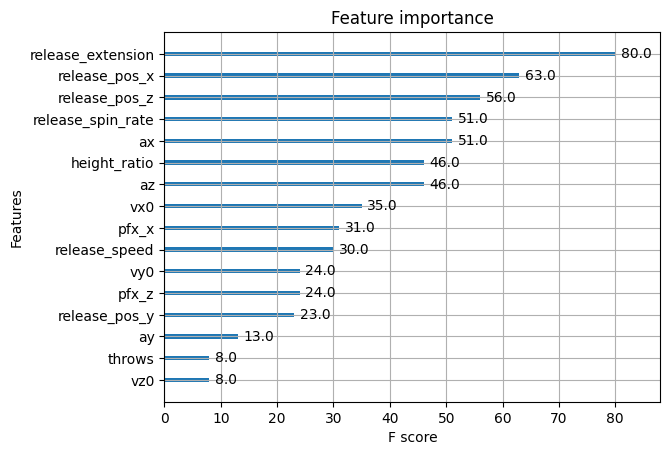

In [ ]:
xgb.plot_importance(model)
plt.show()

In [ ]:
def angular_difference(actual, predicted):
    difference = (predicted - actual) + 180
    return ((difference % 360) - 180)

(array([2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+01,
        5.0000e+00, 4.0000e+00, 6.0000e+00, 1.0000e+01, 8.0000e+00,
        1.3000e+01, 8.0000e+00, 6.0000e+00, 1.3000e+01, 1.1000e+01,
        2.9000e+01, 1.4400e+02, 8.0900e+02, 4.3240e+03, 1.5595e+04,
        2.6302e+04, 1.7928e+04, 5.8900e+03, 1.2520e+03, 2.6100e+02,
        5.2000e+01, 2.0000e+01, 1.4000e+01, 1.4000e+01, 1.1000e+01,
        1.2000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 6.0000e+00,
        7.0000e+00, 4.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-160.32397461, -154.06100464, -147.79801941, -141.53504944,
        -135.27206421, -129.00909424, -122.74610901, -116.48313141,
        -110.22015381, -103.95717621,  -97.69419861,  -91.43122101,
         -85.16824341,  -78.90527344,  -72.64229584,  -66.37931824,
         -60.11633682,  -53.85335922,  -47.590

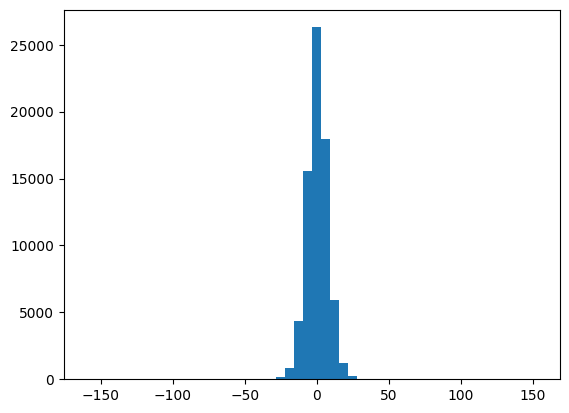

In [ ]:
difference = angular_difference(y_test, y_pred)

plt.hist(difference, bins=50)

# Initial Paramater Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'device': 'gpu'
        }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 18:36:15,226] A new study created in memory with name: no-name-84ae31f9-583c-4b86-ba80-a1d503e69735


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.58759
[1]	eval-rmse:19.77526
[2]	eval-rmse:15.45412
[3]	eval-rmse:12.80694
[4]	eval-rmse:11.07816
[5]	eval-rmse:10.13658
[6]	eval-rmse:9.55305
[7]	eval-rmse:9.24863
[8]	eval-rmse:9.03409
[9]	eval-rmse:8.90721
[10]	eval-rmse:8.82880
[11]	eval-rmse:8.73714
[12]	eval-rmse:8.69562
[13]	eval-rmse:8.65696
[14]	eval-rmse:8.63155
[15]	eval-rmse:8.61685
[16]	eval-rmse:8.58791
[17]	eval-rmse:8.58032
[18]	eval-rmse:8.57595
[19]	eval-rmse:8.55546
[20]	eval-rmse:8.52826
[21]	eval-rmse:8.52200
[22]	eval-rmse:8.52952
[23]	eval-rmse:8.51642
[24]	eval-rmse:8.50501
[25]	eval-rmse:8.49851
[26]	eval-rmse:8.49601
[27]	eval-rmse:8.49551
[28]	eval-rmse:8.48721
[29]	eval-rmse:8.46900
[30]	eval-rmse:8.45923
[31]	eval-rmse:8.45462
[32]	eval-rmse:8.44391
[33]	eval-rmse:8.43450
[34]	eval-rmse:8.42942
[35]	eval-rmse:8.41617
[36]	eval-rmse:8.40866
[37]	eval-rmse:8.40454
[38]	eval-rmse:8.37470
[39]	eval-rmse:8.36585
[40]	eval-rmse:8.35516
[41]	eval-rmse:8.34527
[42]	eval-rmse:8.34001
[43]	eval-rmse:

[I 2023-11-14 18:36:19,808] Trial 0 finished with value: 8.135025024414062 and parameters: {'max_depth': 4, 'eta': 0.30724506841851407, 'subsample': 0.46328699301717646, 'colsample_bytree': 0.4424402669728984, 'min_child_weight': 2}. Best is trial 0 with value: 8.135025024414062.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.18157
[1]	eval-rmse:21.97289
[2]	eval-rmse:17.55935
[3]	eval-rmse:14.57330
[4]	eval-rmse:12.35217
[5]	eval-rmse:10.93801
[6]	eval-rmse:9.98079
[7]	eval-rmse:9.42248
[8]	eval-rmse:9.01243
[9]	eval-rmse:8.75432
[10]	eval-rmse:8.57907
[11]	eval-rmse:8.47902
[12]	eval-rmse:8.39309
[13]	eval-rmse:8.33984
[14]	eval-rmse:8.28410
[15]	eval-rmse:8.26145
[16]	eval-rmse:8.22950
[17]	eval-rmse:8.20500
[18]	eval-rmse:8.19004
[19]	eval-rmse:8.17842
[20]	eval-rmse:8.15625
[21]	eval-rmse:8.14164
[22]	eval-rmse:8.11429
[23]	eval-rmse:8.10375
[24]	eval-rmse:8.10063
[25]	eval-rmse:8.10831
[26]	eval-rmse:8.09730
[27]	eval-rmse:8.09185
[28]	eval-rmse:8.08464
[29]	eval-rmse:8.08541
[30]	eval-rmse:8.08155
[31]	eval-rmse:8.07876
[32]	eval-rmse:8.07639
[33]	eval-rmse:8.06273
[34]	eval-rmse:8.05284
[35]	eval-rmse:8.03985
[36]	eval-rmse:8.03713
[37]	eval-rmse:8.03367
[38]	eval-rmse:8.02483
[39]	eval-rmse:8.02111
[40]	eval-rmse:8.01568
[41]	eval-rmse:7.99520
[42]	eval-rmse:7.97363
[43]	eval-rmse:

[I 2023-11-14 18:36:24,873] Trial 1 finished with value: 7.889840126037598 and parameters: {'max_depth': 6, 'eta': 0.25095630293487703, 'subsample': 0.4429411933755359, 'colsample_bytree': 0.4384449022436259, 'min_child_weight': 3}. Best is trial 1 with value: 7.889840126037598.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.65694
[1]	eval-rmse:17.17052
[2]	eval-rmse:12.87889
[3]	eval-rmse:10.65366
[4]	eval-rmse:9.39086
[5]	eval-rmse:8.80180
[6]	eval-rmse:8.47443
[7]	eval-rmse:8.36550
[8]	eval-rmse:8.25079
[9]	eval-rmse:8.18879
[10]	eval-rmse:8.14485
[11]	eval-rmse:8.09324
[12]	eval-rmse:8.05407
[13]	eval-rmse:8.03563
[14]	eval-rmse:8.03589
[15]	eval-rmse:8.03255
[16]	eval-rmse:8.00464
[17]	eval-rmse:7.99503
[18]	eval-rmse:7.99141
[19]	eval-rmse:7.96288
[20]	eval-rmse:7.95847
[21]	eval-rmse:7.94287
[22]	eval-rmse:7.95590
[23]	eval-rmse:7.96361
[24]	eval-rmse:7.96013
[25]	eval-rmse:7.94219
[26]	eval-rmse:7.91996
[27]	eval-rmse:7.91276
[28]	eval-rmse:7.91632
[29]	eval-rmse:7.91550
[30]	eval-rmse:7.91348
[31]	eval-rmse:7.90863
[32]	eval-rmse:7.90575
[33]	eval-rmse:7.87871
[34]	eval-rmse:7.87565
[35]	eval-rmse:7.87439
[36]	eval-rmse:7.85599
[37]	eval-rmse:7.84683
[38]	eval-rmse:7.84071
[39]	eval-rmse:7.83393
[40]	eval-rmse:7.82597
[41]	eval-rmse:7.82872
[42]	eval-rmse:7.81073
[43]	eval-rmse:7.

[I 2023-11-14 18:36:29,371] Trial 2 finished with value: 7.787622451782227 and parameters: {'max_depth': 7, 'eta': 0.3599037185996991, 'subsample': 0.4894297257478719, 'colsample_bytree': 0.4583418592069803, 'min_child_weight': 2}. Best is trial 2 with value: 7.787622451782227.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.92817
[1]	eval-rmse:20.16901
[2]	eval-rmse:15.67756
[3]	eval-rmse:12.86676
[4]	eval-rmse:10.97556
[5]	eval-rmse:9.89109
[6]	eval-rmse:9.20193
[7]	eval-rmse:8.82951
[8]	eval-rmse:8.58588
[9]	eval-rmse:8.44745
[10]	eval-rmse:8.35154
[11]	eval-rmse:8.30545
[12]	eval-rmse:8.24017
[13]	eval-rmse:8.20413
[14]	eval-rmse:8.16924
[15]	eval-rmse:8.15187
[16]	eval-rmse:8.11830
[17]	eval-rmse:8.09973
[18]	eval-rmse:8.09512
[19]	eval-rmse:8.08751
[20]	eval-rmse:8.06973
[21]	eval-rmse:8.05543
[22]	eval-rmse:8.04362
[23]	eval-rmse:8.03166
[24]	eval-rmse:8.03101
[25]	eval-rmse:8.04073
[26]	eval-rmse:8.04124
[27]	eval-rmse:8.03339
[28]	eval-rmse:8.02243
[29]	eval-rmse:8.03387
[30]	eval-rmse:8.02327
[31]	eval-rmse:8.01884
[32]	eval-rmse:8.01382
[33]	eval-rmse:8.00822
[34]	eval-rmse:8.01773
[35]	eval-rmse:8.01486
[36]	eval-rmse:8.00407
[37]	eval-rmse:8.00115
[38]	eval-rmse:7.99788
[39]	eval-rmse:7.99259
[40]	eval-rmse:7.98755
[41]	eval-rmse:7.97534
[42]	eval-rmse:7.96393
[43]	eval-rmse:7

[I 2023-11-14 18:36:34,897] Trial 3 finished with value: 7.809037208557129 and parameters: {'max_depth': 6, 'eta': 0.2902189084221988, 'subsample': 0.4778456075518, 'colsample_bytree': 0.5363861855614465, 'min_child_weight': 1}. Best is trial 2 with value: 7.787622451782227.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.03140
[1]	eval-rmse:16.56996
[2]	eval-rmse:12.67107
[3]	eval-rmse:10.76293
[4]	eval-rmse:9.73128
[5]	eval-rmse:9.26753
[6]	eval-rmse:9.00896
[7]	eval-rmse:8.87623
[8]	eval-rmse:8.79889
[9]	eval-rmse:8.74495
[10]	eval-rmse:8.71342
[11]	eval-rmse:8.69384
[12]	eval-rmse:8.67669
[13]	eval-rmse:8.64288
[14]	eval-rmse:8.60857
[15]	eval-rmse:8.59853
[16]	eval-rmse:8.56627
[17]	eval-rmse:8.55973
[18]	eval-rmse:8.56180
[19]	eval-rmse:8.55205
[20]	eval-rmse:8.54358
[21]	eval-rmse:8.51922
[22]	eval-rmse:8.50748
[23]	eval-rmse:8.50686
[24]	eval-rmse:8.50458
[25]	eval-rmse:8.50941
[26]	eval-rmse:8.50180
[27]	eval-rmse:8.48853
[28]	eval-rmse:8.46620
[29]	eval-rmse:8.46838
[30]	eval-rmse:8.45997
[31]	eval-rmse:8.45993
[32]	eval-rmse:8.45378
[33]	eval-rmse:8.44764
[34]	eval-rmse:8.45344
[35]	eval-rmse:8.45449
[36]	eval-rmse:8.44635
[37]	eval-rmse:8.43813
[38]	eval-rmse:8.42101
[39]	eval-rmse:8.41475
[40]	eval-rmse:8.40662
[41]	eval-rmse:8.38977
[42]	eval-rmse:8.38340
[43]	eval-rmse:8.

[I 2023-11-14 18:36:38,909] Trial 4 finished with value: 8.184619903564453 and parameters: {'max_depth': 4, 'eta': 0.3906786545797195, 'subsample': 0.40096463034308094, 'colsample_bytree': 0.5511500485101483, 'min_child_weight': 4}. Best is trial 2 with value: 7.787622451782227.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.30391
[1]	eval-rmse:16.88029
[2]	eval-rmse:12.81543
[3]	eval-rmse:10.80236
[4]	eval-rmse:9.73822
[5]	eval-rmse:9.25305
[6]	eval-rmse:8.98304
[7]	eval-rmse:8.85384
[8]	eval-rmse:8.75881
[9]	eval-rmse:8.69366
[10]	eval-rmse:8.65472
[11]	eval-rmse:8.62695
[12]	eval-rmse:8.61141
[13]	eval-rmse:8.58212
[14]	eval-rmse:8.56085
[15]	eval-rmse:8.54333
[16]	eval-rmse:8.52684
[17]	eval-rmse:8.51415
[18]	eval-rmse:8.51155
[19]	eval-rmse:8.49873
[20]	eval-rmse:8.47521
[21]	eval-rmse:8.46997
[22]	eval-rmse:8.46560
[23]	eval-rmse:8.46350
[24]	eval-rmse:8.45684
[25]	eval-rmse:8.43994
[26]	eval-rmse:8.42993
[27]	eval-rmse:8.41993
[28]	eval-rmse:8.41328
[29]	eval-rmse:8.40364
[30]	eval-rmse:8.38610
[31]	eval-rmse:8.37491
[32]	eval-rmse:8.36256
[33]	eval-rmse:8.36149
[34]	eval-rmse:8.36852
[35]	eval-rmse:8.35604
[36]	eval-rmse:8.34474
[37]	eval-rmse:8.34932
[38]	eval-rmse:8.35088
[39]	eval-rmse:8.34724
[40]	eval-rmse:8.34421
[41]	eval-rmse:8.33465
[42]	eval-rmse:8.31903
[43]	eval-rmse:8.

[I 2023-11-14 18:36:43,462] Trial 5 finished with value: 8.158306121826172 and parameters: {'max_depth': 4, 'eta': 0.38143601372777436, 'subsample': 0.512360866375321, 'colsample_bytree': 0.578786624437253, 'min_child_weight': 5}. Best is trial 2 with value: 7.787622451782227.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.80052
[1]	eval-rmse:16.17029
[2]	eval-rmse:12.05517
[3]	eval-rmse:10.07810
[4]	eval-rmse:9.03313
[5]	eval-rmse:8.57760
[6]	eval-rmse:8.34510
[7]	eval-rmse:8.23681
[8]	eval-rmse:8.15416
[9]	eval-rmse:8.11127
[10]	eval-rmse:8.07190
[11]	eval-rmse:8.05142
[12]	eval-rmse:8.01524
[13]	eval-rmse:7.99545
[14]	eval-rmse:7.98185
[15]	eval-rmse:7.97454
[16]	eval-rmse:7.95938
[17]	eval-rmse:7.96134
[18]	eval-rmse:7.95760
[19]	eval-rmse:7.95646
[20]	eval-rmse:7.94549
[21]	eval-rmse:7.93117
[22]	eval-rmse:7.93573
[23]	eval-rmse:7.92499
[24]	eval-rmse:7.91680
[25]	eval-rmse:7.90893
[26]	eval-rmse:7.89941
[27]	eval-rmse:7.88267
[28]	eval-rmse:7.88111
[29]	eval-rmse:7.88156
[30]	eval-rmse:7.87899
[31]	eval-rmse:7.87158
[32]	eval-rmse:7.87123
[33]	eval-rmse:7.89912
[34]	eval-rmse:7.89551
[35]	eval-rmse:7.88892
[36]	eval-rmse:7.88085
[37]	eval-rmse:7.87485
[38]	eval-rmse:7.86407
[39]	eval-rmse:7.85355
[40]	eval-rmse:7.84582
[41]	eval-rmse:7.83967
[42]	eval-rmse:7.82067
[43]	eval-rmse:7.

[I 2023-11-14 18:36:47,673] Trial 6 finished with value: 7.794670104980469 and parameters: {'max_depth': 7, 'eta': 0.38653505229830054, 'subsample': 0.5698485954275416, 'colsample_bytree': 0.5141623638235017, 'min_child_weight': 4}. Best is trial 2 with value: 7.787622451782227.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.94610
[1]	eval-rmse:21.62576
[2]	eval-rmse:17.10746
[3]	eval-rmse:14.09927
[4]	eval-rmse:11.94995
[5]	eval-rmse:10.61045
[6]	eval-rmse:9.69908
[7]	eval-rmse:9.17056
[8]	eval-rmse:8.81615
[9]	eval-rmse:8.59452
[10]	eval-rmse:8.45769
[11]	eval-rmse:8.35200
[12]	eval-rmse:8.26372
[13]	eval-rmse:8.21388
[14]	eval-rmse:8.16859
[15]	eval-rmse:8.14498
[16]	eval-rmse:8.11025
[17]	eval-rmse:8.08794
[18]	eval-rmse:8.07481
[19]	eval-rmse:8.05781
[20]	eval-rmse:8.03937
[21]	eval-rmse:8.03238
[22]	eval-rmse:8.02070
[23]	eval-rmse:8.00078
[24]	eval-rmse:7.99485
[25]	eval-rmse:7.97761
[26]	eval-rmse:7.97615
[27]	eval-rmse:7.97526
[28]	eval-rmse:7.96720
[29]	eval-rmse:7.94998
[30]	eval-rmse:7.94123
[31]	eval-rmse:7.93495
[32]	eval-rmse:7.92542
[33]	eval-rmse:7.91446
[34]	eval-rmse:7.93077
[35]	eval-rmse:7.91973
[36]	eval-rmse:7.91557
[37]	eval-rmse:7.91104
[38]	eval-rmse:7.90092
[39]	eval-rmse:7.89836
[40]	eval-rmse:7.89835
[41]	eval-rmse:7.88723
[42]	eval-rmse:7.86695
[43]	eval-rmse:

[I 2023-11-14 18:36:53,335] Trial 7 finished with value: 7.735102653503418 and parameters: {'max_depth': 6, 'eta': 0.2581051782498399, 'subsample': 0.5394732549545044, 'colsample_bytree': 0.5664857477964217, 'min_child_weight': 3}. Best is trial 7 with value: 7.735102653503418.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.23090
[1]	eval-rmse:17.95417
[2]	eval-rmse:13.70027
[3]	eval-rmse:11.37478
[4]	eval-rmse:9.97095
[5]	eval-rmse:9.27752
[6]	eval-rmse:8.89496
[7]	eval-rmse:8.73651
[8]	eval-rmse:8.60104
[9]	eval-rmse:8.52634
[10]	eval-rmse:8.47331
[11]	eval-rmse:8.43158
[12]	eval-rmse:8.40396
[13]	eval-rmse:8.37837
[14]	eval-rmse:8.38314
[15]	eval-rmse:8.38115
[16]	eval-rmse:8.34692
[17]	eval-rmse:8.33784
[18]	eval-rmse:8.33192
[19]	eval-rmse:8.32146
[20]	eval-rmse:8.30559
[21]	eval-rmse:8.29308
[22]	eval-rmse:8.29263
[23]	eval-rmse:8.28821
[24]	eval-rmse:8.27106
[25]	eval-rmse:8.23416
[26]	eval-rmse:8.22817
[27]	eval-rmse:8.21618
[28]	eval-rmse:8.20684
[29]	eval-rmse:8.20078
[30]	eval-rmse:8.19317
[31]	eval-rmse:8.19155
[32]	eval-rmse:8.17885
[33]	eval-rmse:8.16110
[34]	eval-rmse:8.15860
[35]	eval-rmse:8.14724
[36]	eval-rmse:8.14002
[37]	eval-rmse:8.13262
[38]	eval-rmse:8.12074
[39]	eval-rmse:8.11325
[40]	eval-rmse:8.11389
[41]	eval-rmse:8.10203
[42]	eval-rmse:8.08603
[43]	eval-rmse:8.

[I 2023-11-14 18:36:58,200] Trial 8 finished with value: 7.899313926696777 and parameters: {'max_depth': 5, 'eta': 0.3458443832698611, 'subsample': 0.5280073664588563, 'colsample_bytree': 0.4753993741492339, 'min_child_weight': 2}. Best is trial 7 with value: 7.735102653503418.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.43447
[1]	eval-rmse:22.33379
[2]	eval-rmse:17.91389
[3]	eval-rmse:14.84654
[4]	eval-rmse:12.53426
[5]	eval-rmse:11.02876
[6]	eval-rmse:9.97892
[7]	eval-rmse:9.36107
[8]	eval-rmse:8.87950
[9]	eval-rmse:8.58222
[10]	eval-rmse:8.39079
[11]	eval-rmse:8.25579
[12]	eval-rmse:8.16945
[13]	eval-rmse:8.10919
[14]	eval-rmse:8.05636
[15]	eval-rmse:8.03298
[16]	eval-rmse:7.97595
[17]	eval-rmse:7.95640
[18]	eval-rmse:7.94422
[19]	eval-rmse:7.91914
[20]	eval-rmse:7.89972
[21]	eval-rmse:7.88083
[22]	eval-rmse:7.85708
[23]	eval-rmse:7.84802
[24]	eval-rmse:7.84504
[25]	eval-rmse:7.82867
[26]	eval-rmse:7.82343
[27]	eval-rmse:7.81919
[28]	eval-rmse:7.81744
[29]	eval-rmse:7.83381
[30]	eval-rmse:7.82638
[31]	eval-rmse:7.81439
[32]	eval-rmse:7.80975
[33]	eval-rmse:7.80177
[34]	eval-rmse:7.81057
[35]	eval-rmse:7.80294
[36]	eval-rmse:7.79768
[37]	eval-rmse:7.79159
[38]	eval-rmse:7.77485
[39]	eval-rmse:7.76798
[40]	eval-rmse:7.75544
[41]	eval-rmse:7.75117
[42]	eval-rmse:7.73873
[43]	eval-rmse:

[I 2023-11-14 18:37:04,825] Trial 9 finished with value: 7.681854724884033 and parameters: {'max_depth': 8, 'eta': 0.24140781976579806, 'subsample': 0.48176054453300493, 'colsample_bytree': 0.4913303371249919, 'min_child_weight': 2}. Best is trial 9 with value: 7.681854724884033.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.72759
[1]	eval-rmse:24.32893
[2]	eval-rmse:20.17379
[3]	eval-rmse:17.04962
[4]	eval-rmse:14.53464
[5]	eval-rmse:12.71635
[6]	eval-rmse:11.35795
[7]	eval-rmse:10.41504
[8]	eval-rmse:9.65980
[9]	eval-rmse:9.14875
[10]	eval-rmse:8.78392
[11]	eval-rmse:8.54175
[12]	eval-rmse:8.37025
[13]	eval-rmse:8.26334
[14]	eval-rmse:8.18381
[15]	eval-rmse:8.13697
[16]	eval-rmse:8.07954
[17]	eval-rmse:8.04833
[18]	eval-rmse:8.01193
[19]	eval-rmse:7.97565
[20]	eval-rmse:7.94949
[21]	eval-rmse:7.91775
[22]	eval-rmse:7.89743
[23]	eval-rmse:7.89163
[24]	eval-rmse:7.87385
[25]	eval-rmse:7.84731
[26]	eval-rmse:7.83860
[27]	eval-rmse:7.82753
[28]	eval-rmse:7.81913
[29]	eval-rmse:7.81467
[30]	eval-rmse:7.80801
[31]	eval-rmse:7.79948
[32]	eval-rmse:7.79601
[33]	eval-rmse:7.79215
[34]	eval-rmse:7.79334
[35]	eval-rmse:7.78430
[36]	eval-rmse:7.78227
[37]	eval-rmse:7.77321
[38]	eval-rmse:7.74776
[39]	eval-rmse:7.74051
[40]	eval-rmse:7.73349
[41]	eval-rmse:7.72884
[42]	eval-rmse:7.71548
[43]	eval-rms

[I 2023-11-14 18:37:12,567] Trial 10 finished with value: 7.584385395050049 and parameters: {'max_depth': 8, 'eta': 0.20192622349643904, 'subsample': 0.5810929757354611, 'colsample_bytree': 0.4119601482976722, 'min_child_weight': 1}. Best is trial 10 with value: 7.584385395050049.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77428
[1]	eval-rmse:24.40780
[2]	eval-rmse:20.26665
[3]	eval-rmse:17.14298
[4]	eval-rmse:14.62344
[5]	eval-rmse:12.79624
[6]	eval-rmse:11.45127
[7]	eval-rmse:10.49938
[8]	eval-rmse:9.73350
[9]	eval-rmse:9.21098
[10]	eval-rmse:8.84315
[11]	eval-rmse:8.59048
[12]	eval-rmse:8.42045
[13]	eval-rmse:8.30997
[14]	eval-rmse:8.20977
[15]	eval-rmse:8.16188
[16]	eval-rmse:8.08365
[17]	eval-rmse:8.05552
[18]	eval-rmse:8.01775
[19]	eval-rmse:7.98030
[20]	eval-rmse:7.95288
[21]	eval-rmse:7.92386
[22]	eval-rmse:7.91137
[23]	eval-rmse:7.90680
[24]	eval-rmse:7.88927
[25]	eval-rmse:7.87212
[26]	eval-rmse:7.85951
[27]	eval-rmse:7.84907
[28]	eval-rmse:7.84079
[29]	eval-rmse:7.83542
[30]	eval-rmse:7.82981
[31]	eval-rmse:7.82152
[32]	eval-rmse:7.81818
[33]	eval-rmse:7.81287
[34]	eval-rmse:7.79892
[35]	eval-rmse:7.79351
[36]	eval-rmse:7.79160
[37]	eval-rmse:7.78868
[38]	eval-rmse:7.76535
[39]	eval-rmse:7.75756
[40]	eval-rmse:7.75269
[41]	eval-rmse:7.74636
[42]	eval-rmse:7.73032
[43]	eval-rms

[I 2023-11-14 18:37:20,224] Trial 11 finished with value: 7.601047515869141 and parameters: {'max_depth': 8, 'eta': 0.20046068996922692, 'subsample': 0.573890669743736, 'colsample_bytree': 0.4022205914571047, 'min_child_weight': 1}. Best is trial 10 with value: 7.584385395050049.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77032
[1]	eval-rmse:24.39931
[2]	eval-rmse:20.25255
[3]	eval-rmse:17.12953
[4]	eval-rmse:14.61070
[5]	eval-rmse:12.78547
[6]	eval-rmse:11.41629
[7]	eval-rmse:10.46308
[8]	eval-rmse:9.70042
[9]	eval-rmse:9.17875
[10]	eval-rmse:8.81118
[11]	eval-rmse:8.55087
[12]	eval-rmse:8.36937
[13]	eval-rmse:8.25956
[14]	eval-rmse:8.16146
[15]	eval-rmse:8.11481
[16]	eval-rmse:8.04747
[17]	eval-rmse:8.01526
[18]	eval-rmse:7.97520
[19]	eval-rmse:7.94116
[20]	eval-rmse:7.90587
[21]	eval-rmse:7.87723
[22]	eval-rmse:7.86153
[23]	eval-rmse:7.84997
[24]	eval-rmse:7.83187
[25]	eval-rmse:7.80948
[26]	eval-rmse:7.79610
[27]	eval-rmse:7.78703
[28]	eval-rmse:7.78183
[29]	eval-rmse:7.77657
[30]	eval-rmse:7.77228
[31]	eval-rmse:7.76354
[32]	eval-rmse:7.76017
[33]	eval-rmse:7.74693
[34]	eval-rmse:7.74738
[35]	eval-rmse:7.73655
[36]	eval-rmse:7.73323
[37]	eval-rmse:7.72581
[38]	eval-rmse:7.70458
[39]	eval-rmse:7.69573
[40]	eval-rmse:7.69538
[41]	eval-rmse:7.68095
[42]	eval-rmse:7.66643
[43]	eval-rms

[I 2023-11-14 18:37:27,679] Trial 12 finished with value: 7.528506755828857 and parameters: {'max_depth': 8, 'eta': 0.2005800727157181, 'subsample': 0.5836191266938489, 'colsample_bytree': 0.40484202156651283, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.72112
[1]	eval-rmse:24.31983
[2]	eval-rmse:20.16127
[3]	eval-rmse:17.03425
[4]	eval-rmse:14.52340
[5]	eval-rmse:12.70675
[6]	eval-rmse:11.34781
[7]	eval-rmse:10.40556
[8]	eval-rmse:9.65452
[9]	eval-rmse:9.14211
[10]	eval-rmse:8.78295
[11]	eval-rmse:8.53193
[12]	eval-rmse:8.36358
[13]	eval-rmse:8.25689
[14]	eval-rmse:8.16139
[15]	eval-rmse:8.11543
[16]	eval-rmse:8.05130
[17]	eval-rmse:8.02446
[18]	eval-rmse:7.98715
[19]	eval-rmse:7.94686
[20]	eval-rmse:7.91115
[21]	eval-rmse:7.88617
[22]	eval-rmse:7.87074
[23]	eval-rmse:7.86103
[24]	eval-rmse:7.84416
[25]	eval-rmse:7.82806
[26]	eval-rmse:7.81442
[27]	eval-rmse:7.80321
[28]	eval-rmse:7.79728
[29]	eval-rmse:7.78220
[30]	eval-rmse:7.78046
[31]	eval-rmse:7.77123
[32]	eval-rmse:7.76671
[33]	eval-rmse:7.76692
[34]	eval-rmse:7.76228
[35]	eval-rmse:7.75283
[36]	eval-rmse:7.74923
[37]	eval-rmse:7.74349
[38]	eval-rmse:7.73091
[39]	eval-rmse:7.72617
[40]	eval-rmse:7.72287
[41]	eval-rmse:7.71344
[42]	eval-rmse:7.69432
[43]	eval-rms

[I 2023-11-14 18:37:35,155] Trial 13 finished with value: 7.591400146484375 and parameters: {'max_depth': 8, 'eta': 0.20212183005642076, 'subsample': 0.5910330686035825, 'colsample_bytree': 0.40444075698720805, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.06067
[1]	eval-rmse:23.29023
[2]	eval-rmse:18.98664
[3]	eval-rmse:15.87576
[4]	eval-rmse:13.46869
[5]	eval-rmse:11.81322
[6]	eval-rmse:10.62772
[7]	eval-rmse:9.86111
[8]	eval-rmse:9.29348
[9]	eval-rmse:8.91022
[10]	eval-rmse:8.65540
[11]	eval-rmse:8.49125
[12]	eval-rmse:8.37133
[13]	eval-rmse:8.30217
[14]	eval-rmse:8.25715
[15]	eval-rmse:8.22750
[16]	eval-rmse:8.19220
[17]	eval-rmse:8.16608
[18]	eval-rmse:8.13711
[19]	eval-rmse:8.10432
[20]	eval-rmse:8.07448
[21]	eval-rmse:8.05370
[22]	eval-rmse:8.04459
[23]	eval-rmse:8.04793
[24]	eval-rmse:8.03803
[25]	eval-rmse:8.02284
[26]	eval-rmse:8.01581
[27]	eval-rmse:8.01365
[28]	eval-rmse:7.99864
[29]	eval-rmse:8.00610
[30]	eval-rmse:8.00086
[31]	eval-rmse:7.99968
[32]	eval-rmse:7.99447
[33]	eval-rmse:7.98366
[34]	eval-rmse:7.99556
[35]	eval-rmse:7.99092
[36]	eval-rmse:7.98836
[37]	eval-rmse:7.98182
[38]	eval-rmse:7.96296
[39]	eval-rmse:7.95497
[40]	eval-rmse:7.95145
[41]	eval-rmse:7.94737
[42]	eval-rmse:7.93120
[43]	eval-rmse

[I 2023-11-14 18:37:41,807] Trial 14 finished with value: 7.7234787940979 and parameters: {'max_depth': 7, 'eta': 0.22316887947369857, 'subsample': 0.5977819079690616, 'colsample_bytree': 0.4200448067104552, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.00113
[1]	eval-rmse:23.19710
[2]	eval-rmse:18.87532
[3]	eval-rmse:15.75296
[4]	eval-rmse:13.33538
[5]	eval-rmse:11.66913
[6]	eval-rmse:10.50972
[7]	eval-rmse:9.74849
[8]	eval-rmse:9.15410
[9]	eval-rmse:8.77523
[10]	eval-rmse:8.51854
[11]	eval-rmse:8.33700
[12]	eval-rmse:8.22636
[13]	eval-rmse:8.16488
[14]	eval-rmse:8.10635
[15]	eval-rmse:8.08004
[16]	eval-rmse:8.03166
[17]	eval-rmse:8.00796
[18]	eval-rmse:7.97796
[19]	eval-rmse:7.94331
[20]	eval-rmse:7.91904
[21]	eval-rmse:7.89388
[22]	eval-rmse:7.88717
[23]	eval-rmse:7.87693
[24]	eval-rmse:7.85943
[25]	eval-rmse:7.83129
[26]	eval-rmse:7.82578
[27]	eval-rmse:7.81764
[28]	eval-rmse:7.81238
[29]	eval-rmse:7.81053
[30]	eval-rmse:7.80521
[31]	eval-rmse:7.80368
[32]	eval-rmse:7.79987
[33]	eval-rmse:7.79602
[34]	eval-rmse:7.78643
[35]	eval-rmse:7.77464
[36]	eval-rmse:7.77623
[37]	eval-rmse:7.76974
[38]	eval-rmse:7.75640
[39]	eval-rmse:7.74550
[40]	eval-rmse:7.74369
[41]	eval-rmse:7.73368
[42]	eval-rmse:7.71552
[43]	eval-rmse

[I 2023-11-14 18:37:47,726] Trial 15 finished with value: 7.625039577484131 and parameters: {'max_depth': 8, 'eta': 0.22403603900116567, 'subsample': 0.556559273815875, 'colsample_bytree': 0.4286774565365669, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.40043
[1]	eval-rmse:20.82012
[2]	eval-rmse:16.33153
[3]	eval-rmse:13.42772
[4]	eval-rmse:11.37307
[5]	eval-rmse:10.13137
[6]	eval-rmse:9.34333
[7]	eval-rmse:8.92957
[8]	eval-rmse:8.61777
[9]	eval-rmse:8.43477
[10]	eval-rmse:8.31459
[11]	eval-rmse:8.22256
[12]	eval-rmse:8.16018
[13]	eval-rmse:8.12133
[14]	eval-rmse:8.07960
[15]	eval-rmse:8.06652
[16]	eval-rmse:8.02268
[17]	eval-rmse:8.00540
[18]	eval-rmse:7.99936
[19]	eval-rmse:7.97940
[20]	eval-rmse:7.97089
[21]	eval-rmse:7.94694
[22]	eval-rmse:7.92947
[23]	eval-rmse:7.92355
[24]	eval-rmse:7.92296
[25]	eval-rmse:7.91147
[26]	eval-rmse:7.90379
[27]	eval-rmse:7.89633
[28]	eval-rmse:7.89387
[29]	eval-rmse:7.90108
[30]	eval-rmse:7.89593
[31]	eval-rmse:7.88815
[32]	eval-rmse:7.88506
[33]	eval-rmse:7.87613
[34]	eval-rmse:7.88328
[35]	eval-rmse:7.87988
[36]	eval-rmse:7.87049
[37]	eval-rmse:7.86591
[38]	eval-rmse:7.86174
[39]	eval-rmse:7.85934
[40]	eval-rmse:7.84843
[41]	eval-rmse:7.84637
[42]	eval-rmse:7.82968
[43]	eval-rmse:

[I 2023-11-14 18:37:54,375] Trial 16 finished with value: 7.713994026184082 and parameters: {'max_depth': 7, 'eta': 0.2736747584642772, 'subsample': 0.5467404027678362, 'colsample_bytree': 0.45693815469498655, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.02061
[1]	eval-rmse:23.22484
[2]	eval-rmse:18.89829
[3]	eval-rmse:15.77087
[4]	eval-rmse:13.34620
[5]	eval-rmse:11.68121
[6]	eval-rmse:10.49792
[7]	eval-rmse:9.72816
[8]	eval-rmse:9.14611
[9]	eval-rmse:8.75643
[10]	eval-rmse:8.48999
[11]	eval-rmse:8.34206
[12]	eval-rmse:8.23137
[13]	eval-rmse:8.16585
[14]	eval-rmse:8.09522
[15]	eval-rmse:8.06672
[16]	eval-rmse:8.02223
[17]	eval-rmse:8.00013
[18]	eval-rmse:7.97690
[19]	eval-rmse:7.93871
[20]	eval-rmse:7.91489
[21]	eval-rmse:7.88804
[22]	eval-rmse:7.87323
[23]	eval-rmse:7.87092
[24]	eval-rmse:7.85472
[25]	eval-rmse:7.84529
[26]	eval-rmse:7.83806
[27]	eval-rmse:7.82768
[28]	eval-rmse:7.82640
[29]	eval-rmse:7.81063
[30]	eval-rmse:7.80603
[31]	eval-rmse:7.80174
[32]	eval-rmse:7.79862
[33]	eval-rmse:7.79999
[34]	eval-rmse:7.80353
[35]	eval-rmse:7.79590
[36]	eval-rmse:7.79543
[37]	eval-rmse:7.79002
[38]	eval-rmse:7.77388
[39]	eval-rmse:7.76726
[40]	eval-rmse:7.76574
[41]	eval-rmse:7.75846
[42]	eval-rmse:7.74906
[43]	eval-rmse

[I 2023-11-14 18:38:01,693] Trial 17 finished with value: 7.647039413452148 and parameters: {'max_depth': 8, 'eta': 0.22339026783302401, 'subsample': 0.5985124916296694, 'colsample_bytree': 0.4120330406406943, 'min_child_weight': 3}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.88911
[1]	eval-rmse:24.60548
[2]	eval-rmse:20.53563
[3]	eval-rmse:17.46965
[4]	eval-rmse:14.98974
[5]	eval-rmse:13.19522
[6]	eval-rmse:11.84369
[7]	eval-rmse:10.88630
[8]	eval-rmse:10.13157
[9]	eval-rmse:9.61024
[10]	eval-rmse:9.24185
[11]	eval-rmse:9.00211
[12]	eval-rmse:8.83491
[13]	eval-rmse:8.72048
[14]	eval-rmse:8.63339
[15]	eval-rmse:8.57680
[16]	eval-rmse:8.51387
[17]	eval-rmse:8.47863
[18]	eval-rmse:8.44335
[19]	eval-rmse:8.41009
[20]	eval-rmse:8.38716
[21]	eval-rmse:8.36903
[22]	eval-rmse:8.35989
[23]	eval-rmse:8.34830
[24]	eval-rmse:8.33850
[25]	eval-rmse:8.32832
[26]	eval-rmse:8.32295
[27]	eval-rmse:8.31054
[28]	eval-rmse:8.30533
[29]	eval-rmse:8.27964
[30]	eval-rmse:8.27155
[31]	eval-rmse:8.26426
[32]	eval-rmse:8.25489
[33]	eval-rmse:8.25044
[34]	eval-rmse:8.24619
[35]	eval-rmse:8.24076
[36]	eval-rmse:8.23480
[37]	eval-rmse:8.23456
[38]	eval-rmse:8.21681
[39]	eval-rmse:8.21471
[40]	eval-rmse:8.21295
[41]	eval-rmse:8.19444
[42]	eval-rmse:8.18174
[43]	eval-rm

[I 2023-11-14 18:38:06,880] Trial 18 finished with value: 7.970756530761719 and parameters: {'max_depth': 5, 'eta': 0.20002174198538802, 'subsample': 0.5671032911137083, 'colsample_bytree': 0.42527004838783317, 'min_child_weight': 4}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.69438
[1]	eval-rmse:22.72487
[2]	eval-rmse:18.35662
[3]	eval-rmse:15.27657
[4]	eval-rmse:12.93325
[5]	eval-rmse:11.36720
[6]	eval-rmse:10.30802
[7]	eval-rmse:9.62962
[8]	eval-rmse:9.09637
[9]	eval-rmse:8.76781
[10]	eval-rmse:8.54689
[11]	eval-rmse:8.39954
[12]	eval-rmse:8.29885
[13]	eval-rmse:8.24725
[14]	eval-rmse:8.20882
[15]	eval-rmse:8.18746
[16]	eval-rmse:8.12981
[17]	eval-rmse:8.11628
[18]	eval-rmse:8.09101
[19]	eval-rmse:8.05769
[20]	eval-rmse:8.02923
[21]	eval-rmse:8.00999
[22]	eval-rmse:7.99149
[23]	eval-rmse:7.98912
[24]	eval-rmse:7.97891
[25]	eval-rmse:7.95785
[26]	eval-rmse:7.95014
[27]	eval-rmse:7.94653
[28]	eval-rmse:7.93922
[29]	eval-rmse:7.94551
[30]	eval-rmse:7.94113
[31]	eval-rmse:7.93254
[32]	eval-rmse:7.93076
[33]	eval-rmse:7.93007
[34]	eval-rmse:7.93046
[35]	eval-rmse:7.91717
[36]	eval-rmse:7.91456
[37]	eval-rmse:7.90593
[38]	eval-rmse:7.88651
[39]	eval-rmse:7.87847
[40]	eval-rmse:7.87440
[41]	eval-rmse:7.87344
[42]	eval-rmse:7.85644
[43]	eval-rmse

[I 2023-11-14 18:38:13,915] Trial 19 finished with value: 7.7286696434021 and parameters: {'max_depth': 7, 'eta': 0.23449706755729097, 'subsample': 0.5232167247142925, 'colsample_bytree': 0.4001781913494837, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.54435
[1]	eval-rmse:21.02103
[2]	eval-rmse:16.51356
[3]	eval-rmse:13.53929
[4]	eval-rmse:11.42620
[5]	eval-rmse:10.14693
[6]	eval-rmse:9.32736
[7]	eval-rmse:8.88502
[8]	eval-rmse:8.55800
[9]	eval-rmse:8.35885
[10]	eval-rmse:8.22911
[11]	eval-rmse:8.14979
[12]	eval-rmse:8.10824
[13]	eval-rmse:8.07062
[14]	eval-rmse:8.02757
[15]	eval-rmse:8.01621
[16]	eval-rmse:7.97179
[17]	eval-rmse:7.96023
[18]	eval-rmse:7.95203
[19]	eval-rmse:7.93345
[20]	eval-rmse:7.92239
[21]	eval-rmse:7.90784
[22]	eval-rmse:7.91433
[23]	eval-rmse:7.90857
[24]	eval-rmse:7.90306
[25]	eval-rmse:7.88207
[26]	eval-rmse:7.87386
[27]	eval-rmse:7.86365
[28]	eval-rmse:7.84555
[29]	eval-rmse:7.83415
[30]	eval-rmse:7.83308
[31]	eval-rmse:7.82543
[32]	eval-rmse:7.81980
[33]	eval-rmse:7.81322
[34]	eval-rmse:7.83150
[35]	eval-rmse:7.82281
[36]	eval-rmse:7.81561
[37]	eval-rmse:7.81357
[38]	eval-rmse:7.80500
[39]	eval-rmse:7.79698
[40]	eval-rmse:7.79262
[41]	eval-rmse:7.78249
[42]	eval-rmse:7.76178
[43]	eval-rmse:

[I 2023-11-14 18:38:21,601] Trial 20 finished with value: 7.682992935180664 and parameters: {'max_depth': 8, 'eta': 0.2685375175895143, 'subsample': 0.5501689899407289, 'colsample_bytree': 0.4503378607972438, 'min_child_weight': 5}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.73634
[1]	eval-rmse:24.34614
[2]	eval-rmse:20.18903
[3]	eval-rmse:17.06414
[4]	eval-rmse:14.55026
[5]	eval-rmse:12.73227
[6]	eval-rmse:11.36606
[7]	eval-rmse:10.42221
[8]	eval-rmse:9.66559
[9]	eval-rmse:9.15133
[10]	eval-rmse:8.78774
[11]	eval-rmse:8.53683
[12]	eval-rmse:8.36531
[13]	eval-rmse:8.26009
[14]	eval-rmse:8.17899
[15]	eval-rmse:8.13114
[16]	eval-rmse:8.06495
[17]	eval-rmse:8.03252
[18]	eval-rmse:7.99478
[19]	eval-rmse:7.95863
[20]	eval-rmse:7.92979
[21]	eval-rmse:7.90051
[22]	eval-rmse:7.88156
[23]	eval-rmse:7.87414
[24]	eval-rmse:7.85697
[25]	eval-rmse:7.84235
[26]	eval-rmse:7.83136
[27]	eval-rmse:7.82050
[28]	eval-rmse:7.81491
[29]	eval-rmse:7.80148
[30]	eval-rmse:7.79693
[31]	eval-rmse:7.78870
[32]	eval-rmse:7.78554
[33]	eval-rmse:7.77648
[34]	eval-rmse:7.77225
[35]	eval-rmse:7.75763
[36]	eval-rmse:7.75524
[37]	eval-rmse:7.75174
[38]	eval-rmse:7.73217
[39]	eval-rmse:7.72272
[40]	eval-rmse:7.72032
[41]	eval-rmse:7.70705
[42]	eval-rmse:7.69663
[43]	eval-rms

[I 2023-11-14 18:38:29,337] Trial 21 finished with value: 7.567490100860596 and parameters: {'max_depth': 8, 'eta': 0.2016632982781066, 'subsample': 0.5844245689002006, 'colsample_bytree': 0.4011751575353003, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.24936
[1]	eval-rmse:23.57505
[2]	eval-rmse:19.30489
[3]	eval-rmse:16.17514
[4]	eval-rmse:13.71844
[5]	eval-rmse:11.99971
[6]	eval-rmse:10.75307
[7]	eval-rmse:9.92845
[8]	eval-rmse:9.28087
[9]	eval-rmse:8.86037
[10]	eval-rmse:8.56985
[11]	eval-rmse:8.38326
[12]	eval-rmse:8.24920
[13]	eval-rmse:8.17188
[14]	eval-rmse:8.11083
[15]	eval-rmse:8.07837
[16]	eval-rmse:8.02062
[17]	eval-rmse:7.99709
[18]	eval-rmse:7.96554
[19]	eval-rmse:7.92965
[20]	eval-rmse:7.90299
[21]	eval-rmse:7.87675
[22]	eval-rmse:7.86536
[23]	eval-rmse:7.85611
[24]	eval-rmse:7.84599
[25]	eval-rmse:7.82646
[26]	eval-rmse:7.82031
[27]	eval-rmse:7.80924
[28]	eval-rmse:7.80241
[29]	eval-rmse:7.79170
[30]	eval-rmse:7.78856
[31]	eval-rmse:7.77775
[32]	eval-rmse:7.77387
[33]	eval-rmse:7.77554
[34]	eval-rmse:7.77086
[35]	eval-rmse:7.76413
[36]	eval-rmse:7.76089
[37]	eval-rmse:7.75826
[38]	eval-rmse:7.73748
[39]	eval-rmse:7.72815
[40]	eval-rmse:7.72455
[41]	eval-rmse:7.72277
[42]	eval-rmse:7.70288
[43]	eval-rmse

[I 2023-11-14 18:38:37,072] Trial 22 finished with value: 7.595443248748779 and parameters: {'max_depth': 8, 'eta': 0.21658221272073377, 'subsample': 0.5807738279159013, 'colsample_bytree': 0.424172606626245, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.53959
[1]	eval-rmse:22.49730
[2]	eval-rmse:18.10758
[3]	eval-rmse:15.02446
[4]	eval-rmse:12.70713
[5]	eval-rmse:11.16604
[6]	eval-rmse:10.12037
[7]	eval-rmse:9.47018
[8]	eval-rmse:8.98348
[9]	eval-rmse:8.67765
[10]	eval-rmse:8.47248
[11]	eval-rmse:8.33673
[12]	eval-rmse:8.26165
[13]	eval-rmse:8.21238
[14]	eval-rmse:8.18421
[15]	eval-rmse:8.16173
[16]	eval-rmse:8.11554
[17]	eval-rmse:8.09692
[18]	eval-rmse:8.07047
[19]	eval-rmse:8.03956
[20]	eval-rmse:8.00946
[21]	eval-rmse:7.99014
[22]	eval-rmse:7.98682
[23]	eval-rmse:7.99012
[24]	eval-rmse:7.98151
[25]	eval-rmse:7.95688
[26]	eval-rmse:7.94389
[27]	eval-rmse:7.94078
[28]	eval-rmse:7.93392
[29]	eval-rmse:7.92288
[30]	eval-rmse:7.91855
[31]	eval-rmse:7.91573
[32]	eval-rmse:7.91155
[33]	eval-rmse:7.92170
[34]	eval-rmse:7.92925
[35]	eval-rmse:7.91889
[36]	eval-rmse:7.91650
[37]	eval-rmse:7.91217
[38]	eval-rmse:7.89135
[39]	eval-rmse:7.88301
[40]	eval-rmse:7.87726
[41]	eval-rmse:7.86835
[42]	eval-rmse:7.85619
[43]	eval-rmse

[I 2023-11-14 18:38:43,585] Trial 23 finished with value: 7.677723407745361 and parameters: {'max_depth': 7, 'eta': 0.23910657529434753, 'subsample': 0.5827352817122371, 'colsample_bytree': 0.4206835085369339, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.30251
[1]	eval-rmse:23.66416
[2]	eval-rmse:19.40282
[3]	eval-rmse:16.27098
[4]	eval-rmse:13.80854
[5]	eval-rmse:12.07606
[6]	eval-rmse:10.84634
[7]	eval-rmse:10.01215
[8]	eval-rmse:9.35359
[9]	eval-rmse:8.92613
[10]	eval-rmse:8.63331
[11]	eval-rmse:8.46010
[12]	eval-rmse:8.32088
[13]	eval-rmse:8.24571
[14]	eval-rmse:8.18076
[15]	eval-rmse:8.14574
[16]	eval-rmse:8.09163
[17]	eval-rmse:8.06648
[18]	eval-rmse:8.03654
[19]	eval-rmse:7.99878
[20]	eval-rmse:7.97704
[21]	eval-rmse:7.95260
[22]	eval-rmse:7.93502
[23]	eval-rmse:7.92975
[24]	eval-rmse:7.91313
[25]	eval-rmse:7.88018
[26]	eval-rmse:7.87555
[27]	eval-rmse:7.86407
[28]	eval-rmse:7.85929
[29]	eval-rmse:7.86060
[30]	eval-rmse:7.85712
[31]	eval-rmse:7.85345
[32]	eval-rmse:7.84945
[33]	eval-rmse:7.85825
[34]	eval-rmse:7.84902
[35]	eval-rmse:7.84107
[36]	eval-rmse:7.83721
[37]	eval-rmse:7.83204
[38]	eval-rmse:7.81228
[39]	eval-rmse:7.80205
[40]	eval-rmse:7.79339
[41]	eval-rmse:7.78917
[42]	eval-rmse:7.78196
[43]	eval-rms

[I 2023-11-14 18:38:51,232] Trial 24 finished with value: 7.656859874725342 and parameters: {'max_depth': 8, 'eta': 0.21485625026536279, 'subsample': 0.5615751468387905, 'colsample_bytree': 0.40141681177400207, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.58774
[1]	eval-rmse:22.56778
[2]	eval-rmse:18.18870
[3]	eval-rmse:15.11942
[4]	eval-rmse:12.79366
[5]	eval-rmse:11.24743
[6]	eval-rmse:10.17375
[7]	eval-rmse:9.52268
[8]	eval-rmse:9.02589
[9]	eval-rmse:8.71247
[10]	eval-rmse:8.50549
[11]	eval-rmse:8.37753
[12]	eval-rmse:8.29505
[13]	eval-rmse:8.22817
[14]	eval-rmse:8.19597
[15]	eval-rmse:8.17375
[16]	eval-rmse:8.12047
[17]	eval-rmse:8.09578
[18]	eval-rmse:8.07829
[19]	eval-rmse:8.04905
[20]	eval-rmse:8.02795
[21]	eval-rmse:8.00990
[22]	eval-rmse:8.00592
[23]	eval-rmse:7.99807
[24]	eval-rmse:7.99062
[25]	eval-rmse:7.98267
[26]	eval-rmse:7.97359
[27]	eval-rmse:7.96964
[28]	eval-rmse:7.96837
[29]	eval-rmse:7.97485
[30]	eval-rmse:7.96919
[31]	eval-rmse:7.95930
[32]	eval-rmse:7.95398
[33]	eval-rmse:7.94483
[34]	eval-rmse:7.94964
[35]	eval-rmse:7.93934
[36]	eval-rmse:7.93771
[37]	eval-rmse:7.93551
[38]	eval-rmse:7.92657
[39]	eval-rmse:7.91709
[40]	eval-rmse:7.91399
[41]	eval-rmse:7.90671
[42]	eval-rmse:7.89209
[43]	eval-rmse

[I 2023-11-14 18:38:56,708] Trial 25 finished with value: 7.792561054229736 and parameters: {'max_depth': 7, 'eta': 0.2369981405995712, 'subsample': 0.5825495669807798, 'colsample_bytree': 0.4391612949831379, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.41844
[1]	eval-rmse:23.84657
[2]	eval-rmse:19.61868
[3]	eval-rmse:16.50527
[4]	eval-rmse:14.02927
[5]	eval-rmse:12.27853
[6]	eval-rmse:10.96605
[7]	eval-rmse:10.11761
[8]	eval-rmse:9.43206
[9]	eval-rmse:8.97172
[10]	eval-rmse:8.66029
[11]	eval-rmse:8.44990
[12]	eval-rmse:8.29042
[13]	eval-rmse:8.19456
[14]	eval-rmse:8.14073
[15]	eval-rmse:8.10119
[16]	eval-rmse:8.04905
[17]	eval-rmse:8.02089
[18]	eval-rmse:7.99501
[19]	eval-rmse:7.96304
[20]	eval-rmse:7.94066
[21]	eval-rmse:7.91660
[22]	eval-rmse:7.91469
[23]	eval-rmse:7.90013
[24]	eval-rmse:7.88882
[25]	eval-rmse:7.88059
[26]	eval-rmse:7.87565
[27]	eval-rmse:7.86393
[28]	eval-rmse:7.85440
[29]	eval-rmse:7.85219
[30]	eval-rmse:7.84850
[31]	eval-rmse:7.83929
[32]	eval-rmse:7.83237
[33]	eval-rmse:7.82927
[34]	eval-rmse:7.83199
[35]	eval-rmse:7.82340
[36]	eval-rmse:7.82142
[37]	eval-rmse:7.81882
[38]	eval-rmse:7.79733
[39]	eval-rmse:7.78955
[40]	eval-rmse:7.78606
[41]	eval-rmse:7.78122
[42]	eval-rmse:7.76519
[43]	eval-rms

[I 2023-11-14 18:39:04,673] Trial 26 finished with value: 7.633651256561279 and parameters: {'max_depth': 8, 'eta': 0.2109249096730492, 'subsample': 0.5992067257537955, 'colsample_bytree': 0.46711675548320125, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43207
[1]	eval-rmse:23.87018
[2]	eval-rmse:19.66002
[3]	eval-rmse:16.57102
[4]	eval-rmse:14.12694
[5]	eval-rmse:12.40722
[6]	eval-rmse:11.15576
[7]	eval-rmse:10.30590
[8]	eval-rmse:9.65842
[9]	eval-rmse:9.21806
[10]	eval-rmse:8.91894
[11]	eval-rmse:8.71385
[12]	eval-rmse:8.58270
[13]	eval-rmse:8.49599
[14]	eval-rmse:8.43133
[15]	eval-rmse:8.39010
[16]	eval-rmse:8.32652
[17]	eval-rmse:8.30226
[18]	eval-rmse:8.27639
[19]	eval-rmse:8.24384
[20]	eval-rmse:8.21178
[21]	eval-rmse:8.19454
[22]	eval-rmse:8.18086
[23]	eval-rmse:8.17551
[24]	eval-rmse:8.16420
[25]	eval-rmse:8.15931
[26]	eval-rmse:8.15245
[27]	eval-rmse:8.13689
[28]	eval-rmse:8.12804
[29]	eval-rmse:8.13209
[30]	eval-rmse:8.12687
[31]	eval-rmse:8.11498
[32]	eval-rmse:8.10961
[33]	eval-rmse:8.10074
[34]	eval-rmse:8.11412
[35]	eval-rmse:8.09990
[36]	eval-rmse:8.09696
[37]	eval-rmse:8.09166
[38]	eval-rmse:8.06707
[39]	eval-rmse:8.06329
[40]	eval-rmse:8.06062
[41]	eval-rmse:8.04556
[42]	eval-rmse:8.03660
[43]	eval-rms

[I 2023-11-14 18:39:10,440] Trial 27 finished with value: 7.877691745758057 and parameters: {'max_depth': 6, 'eta': 0.21290383360438125, 'subsample': 0.5609628972672605, 'colsample_bytree': 0.434594089917112, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.70719
[1]	eval-rmse:22.74834
[2]	eval-rmse:18.37403
[3]	eval-rmse:15.26560
[4]	eval-rmse:12.90477
[5]	eval-rmse:11.31500
[6]	eval-rmse:10.23532
[7]	eval-rmse:9.54431
[8]	eval-rmse:9.00985
[9]	eval-rmse:8.67936
[10]	eval-rmse:8.46341
[11]	eval-rmse:8.31511
[12]	eval-rmse:8.20817
[13]	eval-rmse:8.14874
[14]	eval-rmse:8.07782
[15]	eval-rmse:8.05367
[16]	eval-rmse:8.00413
[17]	eval-rmse:7.98833
[18]	eval-rmse:7.96322
[19]	eval-rmse:7.92983
[20]	eval-rmse:7.90711
[21]	eval-rmse:7.88726
[22]	eval-rmse:7.86177
[23]	eval-rmse:7.85353
[24]	eval-rmse:7.83346
[25]	eval-rmse:7.81145
[26]	eval-rmse:7.80411
[27]	eval-rmse:7.79003
[28]	eval-rmse:7.78188
[29]	eval-rmse:7.77033
[30]	eval-rmse:7.76809
[31]	eval-rmse:7.76389
[32]	eval-rmse:7.75710
[33]	eval-rmse:7.75952
[34]	eval-rmse:7.76029
[35]	eval-rmse:7.74711
[36]	eval-rmse:7.74382
[37]	eval-rmse:7.73842
[38]	eval-rmse:7.72535
[39]	eval-rmse:7.71638
[40]	eval-rmse:7.71172
[41]	eval-rmse:7.70610
[42]	eval-rmse:7.68777
[43]	eval-rmse

[I 2023-11-14 18:39:16,760] Trial 28 finished with value: 7.620954513549805 and parameters: {'max_depth': 8, 'eta': 0.23313363076160798, 'subsample': 0.5398148773892013, 'colsample_bytree': 0.41488312917665005, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.40661
[1]	eval-rmse:19.44304
[2]	eval-rmse:14.95635
[3]	eval-rmse:12.24558
[4]	eval-rmse:10.45703
[5]	eval-rmse:9.47560
[6]	eval-rmse:8.90107
[7]	eval-rmse:8.62471
[8]	eval-rmse:8.42768
[9]	eval-rmse:8.30921
[10]	eval-rmse:8.23050
[11]	eval-rmse:8.16121
[12]	eval-rmse:8.11277
[13]	eval-rmse:8.08583
[14]	eval-rmse:8.05794
[15]	eval-rmse:8.05141
[16]	eval-rmse:8.00506
[17]	eval-rmse:8.00085
[18]	eval-rmse:7.98597
[19]	eval-rmse:7.96991
[20]	eval-rmse:7.96336
[21]	eval-rmse:7.95494
[22]	eval-rmse:7.95861
[23]	eval-rmse:7.95890
[24]	eval-rmse:7.95439
[25]	eval-rmse:7.93357
[26]	eval-rmse:7.92562
[27]	eval-rmse:7.90956
[28]	eval-rmse:7.90871
[29]	eval-rmse:7.90926
[30]	eval-rmse:7.90258
[31]	eval-rmse:7.90082
[32]	eval-rmse:7.88580
[33]	eval-rmse:7.87895
[34]	eval-rmse:7.87826
[35]	eval-rmse:7.86413
[36]	eval-rmse:7.86370
[37]	eval-rmse:7.85580
[38]	eval-rmse:7.83789
[39]	eval-rmse:7.83518
[40]	eval-rmse:7.82621
[41]	eval-rmse:7.81639
[42]	eval-rmse:7.79837
[43]	eval-rmse:7

[I 2023-11-14 18:39:23,447] Trial 29 finished with value: 7.6680908203125 and parameters: {'max_depth': 7, 'eta': 0.30460208278262346, 'subsample': 0.5853981457219269, 'colsample_bytree': 0.44551966836188683, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.32620
[1]	eval-rmse:22.18941
[2]	eval-rmse:17.81959
[3]	eval-rmse:14.81123
[4]	eval-rmse:12.58336
[5]	eval-rmse:11.13327
[6]	eval-rmse:10.18088
[7]	eval-rmse:9.59239
[8]	eval-rmse:9.16329
[9]	eval-rmse:8.89886
[10]	eval-rmse:8.73023
[11]	eval-rmse:8.62899
[12]	eval-rmse:8.56206
[13]	eval-rmse:8.51339
[14]	eval-rmse:8.46955
[15]	eval-rmse:8.44606
[16]	eval-rmse:8.40909
[17]	eval-rmse:8.38733
[18]	eval-rmse:8.36755
[19]	eval-rmse:8.34251
[20]	eval-rmse:8.33310
[21]	eval-rmse:8.32030
[22]	eval-rmse:8.29093
[23]	eval-rmse:8.27434
[24]	eval-rmse:8.26807
[25]	eval-rmse:8.25894
[26]	eval-rmse:8.24127
[27]	eval-rmse:8.23468
[28]	eval-rmse:8.22295
[29]	eval-rmse:8.21446
[30]	eval-rmse:8.20607
[31]	eval-rmse:8.19895
[32]	eval-rmse:8.19478
[33]	eval-rmse:8.19896
[34]	eval-rmse:8.21412
[35]	eval-rmse:8.19883
[36]	eval-rmse:8.19467
[37]	eval-rmse:8.18870
[38]	eval-rmse:8.16976
[39]	eval-rmse:8.16913
[40]	eval-rmse:8.16591
[41]	eval-rmse:8.16191
[42]	eval-rmse:8.15099
[43]	eval-rmse

[I 2023-11-14 18:39:28,368] Trial 30 finished with value: 7.968785285949707 and parameters: {'max_depth': 5, 'eta': 0.2487639380231175, 'subsample': 0.5720426812837183, 'colsample_bytree': 0.41528144386426935, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.73882
[1]	eval-rmse:24.34801
[2]	eval-rmse:20.19287
[3]	eval-rmse:17.06780
[4]	eval-rmse:14.55501
[5]	eval-rmse:12.73514
[6]	eval-rmse:11.37401
[7]	eval-rmse:10.42722
[8]	eval-rmse:9.67184
[9]	eval-rmse:9.15626
[10]	eval-rmse:8.79262
[11]	eval-rmse:8.55708
[12]	eval-rmse:8.39006
[13]	eval-rmse:8.28417
[14]	eval-rmse:8.18718
[15]	eval-rmse:8.14120
[16]	eval-rmse:8.07194
[17]	eval-rmse:8.04201
[18]	eval-rmse:8.00405
[19]	eval-rmse:7.96578
[20]	eval-rmse:7.93764
[21]	eval-rmse:7.91041
[22]	eval-rmse:7.89239
[23]	eval-rmse:7.89029
[24]	eval-rmse:7.87242
[25]	eval-rmse:7.85386
[26]	eval-rmse:7.84720
[27]	eval-rmse:7.83422
[28]	eval-rmse:7.82656
[29]	eval-rmse:7.82044
[30]	eval-rmse:7.81554
[31]	eval-rmse:7.80413
[32]	eval-rmse:7.80013
[33]	eval-rmse:7.79625
[34]	eval-rmse:7.79934
[35]	eval-rmse:7.79000
[36]	eval-rmse:7.78965
[37]	eval-rmse:7.78091
[38]	eval-rmse:7.76397
[39]	eval-rmse:7.76095
[40]	eval-rmse:7.75756
[41]	eval-rmse:7.74633
[42]	eval-rmse:7.73801
[43]	eval-rms

[I 2023-11-14 18:39:36,321] Trial 31 finished with value: 7.625929355621338 and parameters: {'max_depth': 8, 'eta': 0.20158982232953507, 'subsample': 0.5904924048312727, 'colsample_bytree': 0.4010927420980252, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.50165
[1]	eval-rmse:23.97156
[2]	eval-rmse:19.76141
[3]	eval-rmse:16.63331
[4]	eval-rmse:14.14360
[5]	eval-rmse:12.37135
[6]	eval-rmse:11.08711
[7]	eval-rmse:10.20234
[8]	eval-rmse:9.52127
[9]	eval-rmse:9.05212
[10]	eval-rmse:8.72647
[11]	eval-rmse:8.51500
[12]	eval-rmse:8.36471
[13]	eval-rmse:8.27330
[14]	eval-rmse:8.21479
[15]	eval-rmse:8.17625
[16]	eval-rmse:8.12065
[17]	eval-rmse:8.09467
[18]	eval-rmse:8.06035
[19]	eval-rmse:8.02186
[20]	eval-rmse:7.99494
[21]	eval-rmse:7.96698
[22]	eval-rmse:7.95280
[23]	eval-rmse:7.94612
[24]	eval-rmse:7.92786
[25]	eval-rmse:7.92018
[26]	eval-rmse:7.91356
[27]	eval-rmse:7.89869
[28]	eval-rmse:7.89276
[29]	eval-rmse:7.88657
[30]	eval-rmse:7.88243
[31]	eval-rmse:7.87195
[32]	eval-rmse:7.86825
[33]	eval-rmse:7.87308
[34]	eval-rmse:7.87327
[35]	eval-rmse:7.86516
[36]	eval-rmse:7.86224
[37]	eval-rmse:7.85480
[38]	eval-rmse:7.84365
[39]	eval-rmse:7.83570
[40]	eval-rmse:7.82911
[41]	eval-rmse:7.82246
[42]	eval-rmse:7.81047
[43]	eval-rms

[I 2023-11-14 18:39:43,812] Trial 32 finished with value: 7.700099945068359 and parameters: {'max_depth': 8, 'eta': 0.20878181370236623, 'subsample': 0.5752559961277861, 'colsample_bytree': 0.4305279188457159, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.76574
[1]	eval-rmse:24.39455
[2]	eval-rmse:20.25295
[3]	eval-rmse:17.14562
[4]	eval-rmse:14.62761
[5]	eval-rmse:12.81023
[6]	eval-rmse:11.41733
[7]	eval-rmse:10.47937
[8]	eval-rmse:9.71605
[9]	eval-rmse:9.19087
[10]	eval-rmse:8.82291
[11]	eval-rmse:8.55192
[12]	eval-rmse:8.37048
[13]	eval-rmse:8.24697
[14]	eval-rmse:8.15238
[15]	eval-rmse:8.10106
[16]	eval-rmse:8.04491
[17]	eval-rmse:8.00056
[18]	eval-rmse:7.97639
[19]	eval-rmse:7.94085
[20]	eval-rmse:7.90314
[21]	eval-rmse:7.87405
[22]	eval-rmse:7.86120
[23]	eval-rmse:7.84025
[24]	eval-rmse:7.82991
[25]	eval-rmse:7.82304
[26]	eval-rmse:7.81617
[27]	eval-rmse:7.80486
[28]	eval-rmse:7.79394
[29]	eval-rmse:7.78628
[30]	eval-rmse:7.78027
[31]	eval-rmse:7.77040
[32]	eval-rmse:7.76018
[33]	eval-rmse:7.75289
[34]	eval-rmse:7.74306
[35]	eval-rmse:7.73523
[36]	eval-rmse:7.73029
[37]	eval-rmse:7.72600
[38]	eval-rmse:7.70921
[39]	eval-rmse:7.70100
[40]	eval-rmse:7.69776
[41]	eval-rmse:7.67948
[42]	eval-rmse:7.65849
[43]	eval-rms

[I 2023-11-14 18:39:51,698] Trial 33 finished with value: 7.53739070892334 and parameters: {'max_depth': 8, 'eta': 0.20034258773177743, 'subsample': 0.5888309702929836, 'colsample_bytree': 0.4441588927303352, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.86980
[1]	eval-rmse:23.00105
[2]	eval-rmse:18.66485
[3]	eval-rmse:15.58379
[4]	eval-rmse:13.20023
[5]	eval-rmse:11.58320
[6]	eval-rmse:10.43171
[7]	eval-rmse:9.71371
[8]	eval-rmse:9.16040
[9]	eval-rmse:8.80328
[10]	eval-rmse:8.56347
[11]	eval-rmse:8.39411
[12]	eval-rmse:8.29134
[13]	eval-rmse:8.21966
[14]	eval-rmse:8.16672
[15]	eval-rmse:8.13949
[16]	eval-rmse:8.09334
[17]	eval-rmse:8.07293
[18]	eval-rmse:8.05453
[19]	eval-rmse:8.03247
[20]	eval-rmse:8.00624
[21]	eval-rmse:7.98349
[22]	eval-rmse:7.98098
[23]	eval-rmse:7.97447
[24]	eval-rmse:7.97065
[25]	eval-rmse:7.94000
[26]	eval-rmse:7.93111
[27]	eval-rmse:7.92595
[28]	eval-rmse:7.92028
[29]	eval-rmse:7.92505
[30]	eval-rmse:7.92174
[31]	eval-rmse:7.91052
[32]	eval-rmse:7.90317
[33]	eval-rmse:7.88423
[34]	eval-rmse:7.87162
[35]	eval-rmse:7.86385
[36]	eval-rmse:7.86098
[37]	eval-rmse:7.85668
[38]	eval-rmse:7.83944
[39]	eval-rmse:7.83065
[40]	eval-rmse:7.82358
[41]	eval-rmse:7.81540
[42]	eval-rmse:7.81140
[43]	eval-rmse

[I 2023-11-14 18:39:58,268] Trial 34 finished with value: 7.650516033172607 and parameters: {'max_depth': 7, 'eta': 0.22827670051247947, 'subsample': 0.5577110888266381, 'colsample_bytree': 0.44063939297457705, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.21606
[1]	eval-rmse:23.52627
[2]	eval-rmse:19.24263
[3]	eval-rmse:16.11181
[4]	eval-rmse:13.65564
[5]	eval-rmse:11.94385
[6]	eval-rmse:10.71629
[7]	eval-rmse:9.89830
[8]	eval-rmse:9.27768
[9]	eval-rmse:8.85616
[10]	eval-rmse:8.57447
[11]	eval-rmse:8.40381
[12]	eval-rmse:8.28606
[13]	eval-rmse:8.20961
[14]	eval-rmse:8.14164
[15]	eval-rmse:8.10659
[16]	eval-rmse:8.05580
[17]	eval-rmse:8.03228
[18]	eval-rmse:8.00282
[19]	eval-rmse:7.96456
[20]	eval-rmse:7.93906
[21]	eval-rmse:7.91717
[22]	eval-rmse:7.90089
[23]	eval-rmse:7.89189
[24]	eval-rmse:7.86980
[25]	eval-rmse:7.85974
[26]	eval-rmse:7.84996
[27]	eval-rmse:7.83916
[28]	eval-rmse:7.83275
[29]	eval-rmse:7.82971
[30]	eval-rmse:7.82736
[31]	eval-rmse:7.82722
[32]	eval-rmse:7.82446
[33]	eval-rmse:7.80575
[34]	eval-rmse:7.80570
[35]	eval-rmse:7.79512
[36]	eval-rmse:7.79445
[37]	eval-rmse:7.78853
[38]	eval-rmse:7.77582
[39]	eval-rmse:7.76866
[40]	eval-rmse:7.76678
[41]	eval-rmse:7.75813
[42]	eval-rmse:7.73902
[43]	eval-rmse

[I 2023-11-14 18:40:06,040] Trial 35 finished with value: 7.635329723358154 and parameters: {'max_depth': 8, 'eta': 0.21745823794594737, 'subsample': 0.5836327739991248, 'colsample_bytree': 0.4127097811619646, 'min_child_weight': 3}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.16999
[1]	eval-rmse:21.93897
[2]	eval-rmse:17.48876
[3]	eval-rmse:14.42390
[4]	eval-rmse:12.16376
[5]	eval-rmse:10.70467
[6]	eval-rmse:9.73814
[7]	eval-rmse:9.15834
[8]	eval-rmse:8.72988
[9]	eval-rmse:8.46559
[10]	eval-rmse:8.29643
[11]	eval-rmse:8.18618
[12]	eval-rmse:8.11236
[13]	eval-rmse:8.07523
[14]	eval-rmse:8.03232
[15]	eval-rmse:8.01474
[16]	eval-rmse:7.96589
[17]	eval-rmse:7.95615
[18]	eval-rmse:7.92901
[19]	eval-rmse:7.89663
[20]	eval-rmse:7.87656
[21]	eval-rmse:7.85757
[22]	eval-rmse:7.83995
[23]	eval-rmse:7.82475
[24]	eval-rmse:7.81406
[25]	eval-rmse:7.80535
[26]	eval-rmse:7.79633
[27]	eval-rmse:7.78431
[28]	eval-rmse:7.77524
[29]	eval-rmse:7.77951
[30]	eval-rmse:7.78149
[31]	eval-rmse:7.77911
[32]	eval-rmse:7.77629
[33]	eval-rmse:7.76271
[34]	eval-rmse:7.77775
[35]	eval-rmse:7.76589
[36]	eval-rmse:7.76500
[37]	eval-rmse:7.76023
[38]	eval-rmse:7.74875
[39]	eval-rmse:7.74314
[40]	eval-rmse:7.74342
[41]	eval-rmse:7.74246
[42]	eval-rmse:7.72481
[43]	eval-rmse:

[I 2023-11-14 18:40:13,382] Trial 36 finished with value: 7.623117923736572 and parameters: {'max_depth': 8, 'eta': 0.24945213062441263, 'subsample': 0.5685121310982977, 'colsample_bytree': 0.4314235249993441, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.95158
[1]	eval-rmse:23.12288
[2]	eval-rmse:18.80692
[3]	eval-rmse:15.71713
[4]	eval-rmse:13.32512
[5]	eval-rmse:11.69559
[6]	eval-rmse:10.52021
[7]	eval-rmse:9.78952
[8]	eval-rmse:9.20875
[9]	eval-rmse:8.84069
[10]	eval-rmse:8.58841
[11]	eval-rmse:8.42568
[12]	eval-rmse:8.32484
[13]	eval-rmse:8.25301
[14]	eval-rmse:8.19159
[15]	eval-rmse:8.16204
[16]	eval-rmse:8.10748
[17]	eval-rmse:8.08434
[18]	eval-rmse:8.06581
[19]	eval-rmse:8.03407
[20]	eval-rmse:8.00563
[21]	eval-rmse:7.98629
[22]	eval-rmse:7.97603
[23]	eval-rmse:7.96519
[24]	eval-rmse:7.95306
[25]	eval-rmse:7.93391
[26]	eval-rmse:7.92976
[27]	eval-rmse:7.92591
[28]	eval-rmse:7.91849
[29]	eval-rmse:7.91682
[30]	eval-rmse:7.91342
[31]	eval-rmse:7.90771
[32]	eval-rmse:7.89734
[33]	eval-rmse:7.89308
[34]	eval-rmse:7.89188
[35]	eval-rmse:7.88350
[36]	eval-rmse:7.87935
[37]	eval-rmse:7.87461
[38]	eval-rmse:7.85239
[39]	eval-rmse:7.84711
[40]	eval-rmse:7.84057
[41]	eval-rmse:7.84231
[42]	eval-rmse:7.82194
[43]	eval-rmse

[I 2023-11-14 18:40:19,990] Trial 37 finished with value: 7.6604743003845215 and parameters: {'max_depth': 7, 'eta': 0.22590716773937242, 'subsample': 0.5996295931252182, 'colsample_bytree': 0.447237444820067, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54531
[1]	eval-rmse:24.04941
[2]	eval-rmse:19.85872
[3]	eval-rmse:16.77358
[4]	eval-rmse:14.31546
[5]	eval-rmse:12.57870
[6]	eval-rmse:11.27907
[7]	eval-rmse:10.40287
[8]	eval-rmse:9.72976
[9]	eval-rmse:9.26799
[10]	eval-rmse:8.95228
[11]	eval-rmse:8.72975
[12]	eval-rmse:8.58741
[13]	eval-rmse:8.49264
[14]	eval-rmse:8.42292
[15]	eval-rmse:8.37861
[16]	eval-rmse:8.32018
[17]	eval-rmse:8.29280
[18]	eval-rmse:8.25913
[19]	eval-rmse:8.22376
[20]	eval-rmse:8.20086
[21]	eval-rmse:8.17910
[22]	eval-rmse:8.15910
[23]	eval-rmse:8.14805
[24]	eval-rmse:8.14058
[25]	eval-rmse:8.10824
[26]	eval-rmse:8.10623
[27]	eval-rmse:8.09762
[28]	eval-rmse:8.09041
[29]	eval-rmse:8.08122
[30]	eval-rmse:8.07563
[31]	eval-rmse:8.05861
[32]	eval-rmse:8.05512
[33]	eval-rmse:8.04919
[34]	eval-rmse:8.05521
[35]	eval-rmse:8.04106
[36]	eval-rmse:8.03478
[37]	eval-rmse:8.02590
[38]	eval-rmse:8.00357
[39]	eval-rmse:7.99669
[40]	eval-rmse:7.99367
[41]	eval-rmse:7.98424
[42]	eval-rmse:7.96647
[43]	eval-rms

[I 2023-11-14 18:40:25,795] Trial 38 finished with value: 7.792962551116943 and parameters: {'max_depth': 6, 'eta': 0.20969151112563164, 'subsample': 0.4983489673985805, 'colsample_bytree': 0.41460371676386115, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.18856
[1]	eval-rmse:23.49116
[2]	eval-rmse:19.21964
[3]	eval-rmse:16.10045
[4]	eval-rmse:13.67173
[5]	eval-rmse:11.98750
[6]	eval-rmse:10.77851
[7]	eval-rmse:9.97442
[8]	eval-rmse:9.36697
[9]	eval-rmse:8.96072
[10]	eval-rmse:8.68631
[11]	eval-rmse:8.51702
[12]	eval-rmse:8.39600
[13]	eval-rmse:8.32046
[14]	eval-rmse:8.27134
[15]	eval-rmse:8.23760
[16]	eval-rmse:8.18508
[17]	eval-rmse:8.15986
[18]	eval-rmse:8.12659
[19]	eval-rmse:8.09487
[20]	eval-rmse:8.07007
[21]	eval-rmse:8.04350
[22]	eval-rmse:8.03737
[23]	eval-rmse:8.03318
[24]	eval-rmse:8.02520
[25]	eval-rmse:8.00952
[26]	eval-rmse:7.99869
[27]	eval-rmse:7.99554
[28]	eval-rmse:7.99408
[29]	eval-rmse:7.98014
[30]	eval-rmse:7.97594
[31]	eval-rmse:7.97508
[32]	eval-rmse:7.97226
[33]	eval-rmse:7.96735
[34]	eval-rmse:7.97718
[35]	eval-rmse:7.96775
[36]	eval-rmse:7.96101
[37]	eval-rmse:7.95652
[38]	eval-rmse:7.92772
[39]	eval-rmse:7.92173
[40]	eval-rmse:7.91486
[41]	eval-rmse:7.90982
[42]	eval-rmse:7.89236
[43]	eval-rmse

[I 2023-11-14 18:40:32,309] Trial 39 finished with value: 7.7383575439453125 and parameters: {'max_depth': 7, 'eta': 0.2190346509997812, 'subsample': 0.5755278927137453, 'colsample_bytree': 0.4339891723170367, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.86630
[1]	eval-rmse:20.06288
[2]	eval-rmse:15.54087
[3]	eval-rmse:12.70997
[4]	eval-rmse:10.77420
[5]	eval-rmse:9.66397
[6]	eval-rmse:8.98341
[7]	eval-rmse:8.64937
[8]	eval-rmse:8.39128
[9]	eval-rmse:8.24548
[10]	eval-rmse:8.14750
[11]	eval-rmse:8.06876
[12]	eval-rmse:8.02123
[13]	eval-rmse:7.99332
[14]	eval-rmse:7.97087
[15]	eval-rmse:7.96227
[16]	eval-rmse:7.90547
[17]	eval-rmse:7.88606
[18]	eval-rmse:7.88278
[19]	eval-rmse:7.87110
[20]	eval-rmse:7.85550
[21]	eval-rmse:7.83834
[22]	eval-rmse:7.83519
[23]	eval-rmse:7.82849
[24]	eval-rmse:7.82319
[25]	eval-rmse:7.81218
[26]	eval-rmse:7.79843
[27]	eval-rmse:7.78466
[28]	eval-rmse:7.78091
[29]	eval-rmse:7.79691
[30]	eval-rmse:7.79578
[31]	eval-rmse:7.78878
[32]	eval-rmse:7.78436
[33]	eval-rmse:7.75727
[34]	eval-rmse:7.76541
[35]	eval-rmse:7.76286
[36]	eval-rmse:7.75579
[37]	eval-rmse:7.74998
[38]	eval-rmse:7.74241
[39]	eval-rmse:7.73409
[40]	eval-rmse:7.73195
[41]	eval-rmse:7.73422
[42]	eval-rmse:7.71273
[43]	eval-rmse:7

[I 2023-11-14 18:40:36,884] Trial 40 finished with value: 7.695567607879639 and parameters: {'max_depth': 8, 'eta': 0.28933751436362404, 'subsample': 0.5513883499798212, 'colsample_bytree': 0.45402380687141847, 'min_child_weight': 4}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74952
[1]	eval-rmse:24.36399
[2]	eval-rmse:20.21084
[3]	eval-rmse:17.08586
[4]	eval-rmse:14.57167
[5]	eval-rmse:12.75203
[6]	eval-rmse:11.38890
[7]	eval-rmse:10.44161
[8]	eval-rmse:9.68341
[9]	eval-rmse:9.16746
[10]	eval-rmse:8.80235
[11]	eval-rmse:8.54573
[12]	eval-rmse:8.37944
[13]	eval-rmse:8.27241
[14]	eval-rmse:8.17311
[15]	eval-rmse:8.12730
[16]	eval-rmse:8.05265
[17]	eval-rmse:8.02034
[18]	eval-rmse:7.98069
[19]	eval-rmse:7.93651
[20]	eval-rmse:7.91023
[21]	eval-rmse:7.87999
[22]	eval-rmse:7.86942
[23]	eval-rmse:7.86298
[24]	eval-rmse:7.84343
[25]	eval-rmse:7.82161
[26]	eval-rmse:7.81169
[27]	eval-rmse:7.80170
[28]	eval-rmse:7.79206
[29]	eval-rmse:7.78751
[30]	eval-rmse:7.78470
[31]	eval-rmse:7.77463
[32]	eval-rmse:7.77027
[33]	eval-rmse:7.76342
[34]	eval-rmse:7.76972
[35]	eval-rmse:7.76027
[36]	eval-rmse:7.75883
[37]	eval-rmse:7.75278
[38]	eval-rmse:7.73152
[39]	eval-rmse:7.72098
[40]	eval-rmse:7.71954
[41]	eval-rmse:7.71559
[42]	eval-rmse:7.69416
[43]	eval-rms

[I 2023-11-14 18:40:44,665] Trial 41 finished with value: 7.577303409576416 and parameters: {'max_depth': 8, 'eta': 0.20131224009425774, 'subsample': 0.5899368696347298, 'colsample_bytree': 0.4088258924474345, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54900
[1]	eval-rmse:24.04646
[2]	eval-rmse:19.84267
[3]	eval-rmse:16.71215
[4]	eval-rmse:14.22158
[5]	eval-rmse:12.44131
[6]	eval-rmse:11.12941
[7]	eval-rmse:10.23128
[8]	eval-rmse:9.54412
[9]	eval-rmse:9.06520
[10]	eval-rmse:8.73635
[11]	eval-rmse:8.52158
[12]	eval-rmse:8.35742
[13]	eval-rmse:8.26513
[14]	eval-rmse:8.17684
[15]	eval-rmse:8.13493
[16]	eval-rmse:8.06360
[17]	eval-rmse:8.03603
[18]	eval-rmse:8.00393
[19]	eval-rmse:7.96535
[20]	eval-rmse:7.94284
[21]	eval-rmse:7.91138
[22]	eval-rmse:7.90045
[23]	eval-rmse:7.88742
[24]	eval-rmse:7.87080
[25]	eval-rmse:7.85267
[26]	eval-rmse:7.85049
[27]	eval-rmse:7.83975
[28]	eval-rmse:7.83955
[29]	eval-rmse:7.84003
[30]	eval-rmse:7.83399
[31]	eval-rmse:7.82649
[32]	eval-rmse:7.82210
[33]	eval-rmse:7.82235
[34]	eval-rmse:7.82067
[35]	eval-rmse:7.80987
[36]	eval-rmse:7.80907
[37]	eval-rmse:7.80548
[38]	eval-rmse:7.78289
[39]	eval-rmse:7.77540
[40]	eval-rmse:7.77236
[41]	eval-rmse:7.76664
[42]	eval-rmse:7.75162
[43]	eval-rms

[I 2023-11-14 18:40:52,498] Trial 42 finished with value: 7.629387855529785 and parameters: {'max_depth': 8, 'eta': 0.20742301332591334, 'subsample': 0.5896229924614902, 'colsample_bytree': 0.41115700744166955, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75617
[1]	eval-rmse:24.37995
[2]	eval-rmse:20.23330
[3]	eval-rmse:17.11038
[4]	eval-rmse:14.59376
[5]	eval-rmse:12.76896
[6]	eval-rmse:11.43026
[7]	eval-rmse:10.48110
[8]	eval-rmse:9.74318
[9]	eval-rmse:9.22298
[10]	eval-rmse:8.85698
[11]	eval-rmse:8.62912
[12]	eval-rmse:8.46147
[13]	eval-rmse:8.35529
[14]	eval-rmse:8.25254
[15]	eval-rmse:8.20600
[16]	eval-rmse:8.13428
[17]	eval-rmse:8.10670
[18]	eval-rmse:8.07203
[19]	eval-rmse:8.03332
[20]	eval-rmse:7.99755
[21]	eval-rmse:7.96982
[22]	eval-rmse:7.95801
[23]	eval-rmse:7.94639
[24]	eval-rmse:7.92761
[25]	eval-rmse:7.91890
[26]	eval-rmse:7.90780
[27]	eval-rmse:7.89828
[28]	eval-rmse:7.89300
[29]	eval-rmse:7.88677
[30]	eval-rmse:7.88268
[31]	eval-rmse:7.87151
[32]	eval-rmse:7.86294
[33]	eval-rmse:7.86262
[34]	eval-rmse:7.85352
[35]	eval-rmse:7.84288
[36]	eval-rmse:7.84145
[37]	eval-rmse:7.83753
[38]	eval-rmse:7.81694
[39]	eval-rmse:7.80762
[40]	eval-rmse:7.80120
[41]	eval-rmse:7.78704
[42]	eval-rmse:7.76648
[43]	eval-rms

[I 2023-11-14 18:40:58,763] Trial 43 finished with value: 7.67372465133667 and parameters: {'max_depth': 8, 'eta': 0.20095115834191568, 'subsample': 0.5647365982396105, 'colsample_bytree': 0.4236423593457787, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:40:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.83884
[1]	eval-rmse:22.94133
[2]	eval-rmse:18.58642
[3]	eval-rmse:15.46822
[4]	eval-rmse:13.08191
[5]	eval-rmse:11.46486
[6]	eval-rmse:10.32074
[7]	eval-rmse:9.59373
[8]	eval-rmse:9.03336
[9]	eval-rmse:8.68417
[10]	eval-rmse:8.44504
[11]	eval-rmse:8.28326
[12]	eval-rmse:8.17860
[13]	eval-rmse:8.12080
[14]	eval-rmse:8.07506
[15]	eval-rmse:8.04977
[16]	eval-rmse:7.99715
[17]	eval-rmse:7.97715
[18]	eval-rmse:7.94906
[19]	eval-rmse:7.91277
[20]	eval-rmse:7.88148
[21]	eval-rmse:7.85181
[22]	eval-rmse:7.84878
[23]	eval-rmse:7.83898
[24]	eval-rmse:7.82309
[25]	eval-rmse:7.80675
[26]	eval-rmse:7.80267
[27]	eval-rmse:7.79198
[28]	eval-rmse:7.78837
[29]	eval-rmse:7.78439
[30]	eval-rmse:7.78036
[31]	eval-rmse:7.77648
[32]	eval-rmse:7.77222
[33]	eval-rmse:7.76419
[34]	eval-rmse:7.76475
[35]	eval-rmse:7.75431
[36]	eval-rmse:7.75355
[37]	eval-rmse:7.74842
[38]	eval-rmse:7.72949
[39]	eval-rmse:7.72162
[40]	eval-rmse:7.71881
[41]	eval-rmse:7.70939
[42]	eval-rmse:7.68845
[43]	eval-rmse

[I 2023-11-14 18:41:06,833] Trial 44 finished with value: 7.575314998626709 and parameters: {'max_depth': 8, 'eta': 0.22925857119638485, 'subsample': 0.5901700739497371, 'colsample_bytree': 0.40756550025762656, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.27648
[1]	eval-rmse:23.61877
[2]	eval-rmse:19.34971
[3]	eval-rmse:16.21760
[4]	eval-rmse:13.76157
[5]	eval-rmse:12.03767
[6]	eval-rmse:10.78316
[7]	eval-rmse:9.95297
[8]	eval-rmse:9.32786
[9]	eval-rmse:8.89883
[10]	eval-rmse:8.61333
[11]	eval-rmse:8.41762
[12]	eval-rmse:8.28238
[13]	eval-rmse:8.20537
[14]	eval-rmse:8.12187
[15]	eval-rmse:8.09047
[16]	eval-rmse:8.04004
[17]	eval-rmse:8.01340
[18]	eval-rmse:7.97793
[19]	eval-rmse:7.94591
[20]	eval-rmse:7.90191
[21]	eval-rmse:7.87590
[22]	eval-rmse:7.86285
[23]	eval-rmse:7.85078
[24]	eval-rmse:7.83401
[25]	eval-rmse:7.81642
[26]	eval-rmse:7.81314
[27]	eval-rmse:7.80448
[28]	eval-rmse:7.80108
[29]	eval-rmse:7.80064
[30]	eval-rmse:7.79305
[31]	eval-rmse:7.79227
[32]	eval-rmse:7.78979
[33]	eval-rmse:7.78413
[34]	eval-rmse:7.78439
[35]	eval-rmse:7.77353
[36]	eval-rmse:7.77214
[37]	eval-rmse:7.76718
[38]	eval-rmse:7.75107
[39]	eval-rmse:7.74179
[40]	eval-rmse:7.73500
[41]	eval-rmse:7.72397
[42]	eval-rmse:7.71655
[43]	eval-rmse

[I 2023-11-14 18:41:14,847] Trial 45 finished with value: 7.616409778594971 and parameters: {'max_depth': 8, 'eta': 0.2157586254924091, 'subsample': 0.5906215861543849, 'colsample_bytree': 0.4066791850738046, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.77437
[1]	eval-rmse:22.85090
[2]	eval-rmse:18.49486
[3]	eval-rmse:15.40080
[4]	eval-rmse:13.01977
[5]	eval-rmse:11.41588
[6]	eval-rmse:10.29577
[7]	eval-rmse:9.59941
[8]	eval-rmse:9.03944
[9]	eval-rmse:8.69280
[10]	eval-rmse:8.46179
[11]	eval-rmse:8.31639
[12]	eval-rmse:8.20870
[13]	eval-rmse:8.14197
[14]	eval-rmse:8.10711
[15]	eval-rmse:8.08203
[16]	eval-rmse:8.01519
[17]	eval-rmse:7.99235
[18]	eval-rmse:7.97345
[19]	eval-rmse:7.94148
[20]	eval-rmse:7.91305
[21]	eval-rmse:7.89100
[22]	eval-rmse:7.88229
[23]	eval-rmse:7.87063
[24]	eval-rmse:7.86373
[25]	eval-rmse:7.84018
[26]	eval-rmse:7.83330
[27]	eval-rmse:7.83033
[28]	eval-rmse:7.82701
[29]	eval-rmse:7.83357
[30]	eval-rmse:7.83032
[31]	eval-rmse:7.82103
[32]	eval-rmse:7.81748
[33]	eval-rmse:7.80504
[34]	eval-rmse:7.80213
[35]	eval-rmse:7.79712
[36]	eval-rmse:7.79548
[37]	eval-rmse:7.78338
[38]	eval-rmse:7.77030
[39]	eval-rmse:7.76595
[40]	eval-rmse:7.76622
[41]	eval-rmse:7.76626
[42]	eval-rmse:7.74795
[43]	eval-rmse

[I 2023-11-14 18:41:21,325] Trial 46 finished with value: 7.645851135253906 and parameters: {'max_depth': 8, 'eta': 0.23065674571288097, 'subsample': 0.5756384016869358, 'colsample_bytree': 0.4377725024094527, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.53673
[1]	eval-rmse:22.54657
[2]	eval-rmse:18.27014
[3]	eval-rmse:15.26575
[4]	eval-rmse:13.03673
[5]	eval-rmse:11.57631
[6]	eval-rmse:10.57212
[7]	eval-rmse:9.93984
[8]	eval-rmse:9.48496
[9]	eval-rmse:9.19852
[10]	eval-rmse:9.00605
[11]	eval-rmse:8.86484
[12]	eval-rmse:8.75521
[13]	eval-rmse:8.70081
[14]	eval-rmse:8.66899
[15]	eval-rmse:8.64213
[16]	eval-rmse:8.60466
[17]	eval-rmse:8.57901
[18]	eval-rmse:8.56507
[19]	eval-rmse:8.54352
[20]	eval-rmse:8.52705
[21]	eval-rmse:8.50835
[22]	eval-rmse:8.50208
[23]	eval-rmse:8.49211
[24]	eval-rmse:8.48582
[25]	eval-rmse:8.46984
[26]	eval-rmse:8.46553
[27]	eval-rmse:8.46327
[28]	eval-rmse:8.45843
[29]	eval-rmse:8.46329
[30]	eval-rmse:8.45911
[31]	eval-rmse:8.45137
[32]	eval-rmse:8.43726
[33]	eval-rmse:8.41351
[34]	eval-rmse:8.41842
[35]	eval-rmse:8.40892
[36]	eval-rmse:8.40004
[37]	eval-rmse:8.39037
[38]	eval-rmse:8.38606
[39]	eval-rmse:8.38374
[40]	eval-rmse:8.38330
[41]	eval-rmse:8.37920
[42]	eval-rmse:8.37251
[43]	eval-rmse

[I 2023-11-14 18:41:26,025] Trial 47 finished with value: 8.127889633178711 and parameters: {'max_depth': 4, 'eta': 0.2445650453474307, 'subsample': 0.5918250762471601, 'colsample_bytree': 0.42045778554943497, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.06525
[1]	eval-rmse:23.29801
[2]	eval-rmse:18.99712
[3]	eval-rmse:15.88189
[4]	eval-rmse:13.47208
[5]	eval-rmse:11.80754
[6]	eval-rmse:10.64792
[7]	eval-rmse:9.88294
[8]	eval-rmse:9.28296
[9]	eval-rmse:8.90007
[10]	eval-rmse:8.64407
[11]	eval-rmse:8.46341
[12]	eval-rmse:8.35382
[13]	eval-rmse:8.28533
[14]	eval-rmse:8.22586
[15]	eval-rmse:8.19475
[16]	eval-rmse:8.13245
[17]	eval-rmse:8.10930
[18]	eval-rmse:8.07932
[19]	eval-rmse:8.04840
[20]	eval-rmse:8.02412
[21]	eval-rmse:8.00101
[22]	eval-rmse:7.99236
[23]	eval-rmse:7.98669
[24]	eval-rmse:7.97946
[25]	eval-rmse:7.96745
[26]	eval-rmse:7.95979
[27]	eval-rmse:7.94731
[28]	eval-rmse:7.93951
[29]	eval-rmse:7.91795
[30]	eval-rmse:7.91448
[31]	eval-rmse:7.91322
[32]	eval-rmse:7.90666
[33]	eval-rmse:7.90479
[34]	eval-rmse:7.90568
[35]	eval-rmse:7.89747
[36]	eval-rmse:7.89404
[37]	eval-rmse:7.89042
[38]	eval-rmse:7.86790
[39]	eval-rmse:7.85900
[40]	eval-rmse:7.85552
[41]	eval-rmse:7.84027
[42]	eval-rmse:7.82866
[43]	eval-rmse

[I 2023-11-14 18:41:33,030] Trial 48 finished with value: 7.676033020019531 and parameters: {'max_depth': 7, 'eta': 0.22294011793459428, 'subsample': 0.5678202902401263, 'colsample_bytree': 0.40622393088326797, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55403
[1]	eval-rmse:24.05417
[2]	eval-rmse:19.84590
[3]	eval-rmse:16.72007
[4]	eval-rmse:14.22811
[5]	eval-rmse:12.44454
[6]	eval-rmse:11.13824
[7]	eval-rmse:10.24237
[8]	eval-rmse:9.55157
[9]	eval-rmse:9.06885
[10]	eval-rmse:8.73629
[11]	eval-rmse:8.52627
[12]	eval-rmse:8.37705
[13]	eval-rmse:8.27888
[14]	eval-rmse:8.19922
[15]	eval-rmse:8.15891
[16]	eval-rmse:8.09233
[17]	eval-rmse:8.07239
[18]	eval-rmse:8.03715
[19]	eval-rmse:8.00151
[20]	eval-rmse:7.97683
[21]	eval-rmse:7.96130
[22]	eval-rmse:7.95303
[23]	eval-rmse:7.94157
[24]	eval-rmse:7.92552
[25]	eval-rmse:7.92017
[26]	eval-rmse:7.91554
[27]	eval-rmse:7.90544
[28]	eval-rmse:7.89881
[29]	eval-rmse:7.89637
[30]	eval-rmse:7.89328
[31]	eval-rmse:7.89207
[32]	eval-rmse:7.88746
[33]	eval-rmse:7.86644
[34]	eval-rmse:7.86667
[35]	eval-rmse:7.85516
[36]	eval-rmse:7.85169
[37]	eval-rmse:7.84448
[38]	eval-rmse:7.82087
[39]	eval-rmse:7.81253
[40]	eval-rmse:7.80955
[41]	eval-rmse:7.81723
[42]	eval-rmse:7.80143
[43]	eval-rms

[I 2023-11-14 18:41:39,066] Trial 49 finished with value: 7.676535606384277 and parameters: {'max_depth': 8, 'eta': 0.20757433763080516, 'subsample': 0.4621459067623393, 'colsample_bytree': 0.42693956092157614, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.86994
[1]	eval-rmse:22.99953
[2]	eval-rmse:18.66045
[3]	eval-rmse:15.57396
[4]	eval-rmse:13.19345
[5]	eval-rmse:11.58328
[6]	eval-rmse:10.45623
[7]	eval-rmse:9.74630
[8]	eval-rmse:9.17834
[9]	eval-rmse:8.81706
[10]	eval-rmse:8.58159
[11]	eval-rmse:8.42642
[12]	eval-rmse:8.30691
[13]	eval-rmse:8.23655
[14]	eval-rmse:8.19926
[15]	eval-rmse:8.16914
[16]	eval-rmse:8.11142
[17]	eval-rmse:8.09152
[18]	eval-rmse:8.07256
[19]	eval-rmse:8.04089
[20]	eval-rmse:8.01279
[21]	eval-rmse:7.99014
[22]	eval-rmse:7.97782
[23]	eval-rmse:7.97932
[24]	eval-rmse:7.97258
[25]	eval-rmse:7.95287
[26]	eval-rmse:7.94544
[27]	eval-rmse:7.93790
[28]	eval-rmse:7.92309
[29]	eval-rmse:7.92810
[30]	eval-rmse:7.92518
[31]	eval-rmse:7.91544
[32]	eval-rmse:7.91018
[33]	eval-rmse:7.92134
[34]	eval-rmse:7.91598
[35]	eval-rmse:7.90583
[36]	eval-rmse:7.90131
[37]	eval-rmse:7.89662
[38]	eval-rmse:7.87566
[39]	eval-rmse:7.87473
[40]	eval-rmse:7.86940
[41]	eval-rmse:7.87421
[42]	eval-rmse:7.86201
[43]	eval-rmse

[I 2023-11-14 18:41:45,879] Trial 50 finished with value: 7.700770854949951 and parameters: {'max_depth': 7, 'eta': 0.22840448488711, 'subsample': 0.5776741527872334, 'colsample_bytree': 0.4618606349053778, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.58580
[1]	eval-rmse:24.10564
[2]	eval-rmse:19.91190
[3]	eval-rmse:16.78126
[4]	eval-rmse:14.28638
[5]	eval-rmse:12.50121
[6]	eval-rmse:11.17897
[7]	eval-rmse:10.27336
[8]	eval-rmse:9.55340
[9]	eval-rmse:9.06508
[10]	eval-rmse:8.72639
[11]	eval-rmse:8.51501
[12]	eval-rmse:8.35660
[13]	eval-rmse:8.26003
[14]	eval-rmse:8.17263
[15]	eval-rmse:8.13281
[16]	eval-rmse:8.08165
[17]	eval-rmse:8.05481
[18]	eval-rmse:8.02039
[19]	eval-rmse:7.98121
[20]	eval-rmse:7.94736
[21]	eval-rmse:7.91549
[22]	eval-rmse:7.89726
[23]	eval-rmse:7.89013
[24]	eval-rmse:7.87156
[25]	eval-rmse:7.85384
[26]	eval-rmse:7.84468
[27]	eval-rmse:7.83171
[28]	eval-rmse:7.82791
[29]	eval-rmse:7.81527
[30]	eval-rmse:7.81429
[31]	eval-rmse:7.80326
[32]	eval-rmse:7.79890
[33]	eval-rmse:7.79662
[34]	eval-rmse:7.79285
[35]	eval-rmse:7.78288
[36]	eval-rmse:7.78010
[37]	eval-rmse:7.77543
[38]	eval-rmse:7.75226
[39]	eval-rmse:7.74318
[40]	eval-rmse:7.73860
[41]	eval-rmse:7.73044
[42]	eval-rmse:7.72218
[43]	eval-rms

[I 2023-11-14 18:41:53,708] Trial 51 finished with value: 7.5957746505737305 and parameters: {'max_depth': 8, 'eta': 0.20631941301828896, 'subsample': 0.5913196345594521, 'colsample_bytree': 0.407557893063289, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.71647
[1]	eval-rmse:24.31139
[2]	eval-rmse:20.15315
[3]	eval-rmse:17.02838
[4]	eval-rmse:14.51509
[5]	eval-rmse:12.69708
[6]	eval-rmse:11.34227
[7]	eval-rmse:10.40285
[8]	eval-rmse:9.65011
[9]	eval-rmse:9.14078
[10]	eval-rmse:8.78053
[11]	eval-rmse:8.54923
[12]	eval-rmse:8.38121
[13]	eval-rmse:8.27734
[14]	eval-rmse:8.20946
[15]	eval-rmse:8.16377
[16]	eval-rmse:8.08165
[17]	eval-rmse:8.05418
[18]	eval-rmse:8.01614
[19]	eval-rmse:7.97398
[20]	eval-rmse:7.94819
[21]	eval-rmse:7.91997
[22]	eval-rmse:7.91313
[23]	eval-rmse:7.90044
[24]	eval-rmse:7.88407
[25]	eval-rmse:7.87519
[26]	eval-rmse:7.86791
[27]	eval-rmse:7.85614
[28]	eval-rmse:7.84619
[29]	eval-rmse:7.82150
[30]	eval-rmse:7.81760
[31]	eval-rmse:7.80764
[32]	eval-rmse:7.80292
[33]	eval-rmse:7.80718
[34]	eval-rmse:7.80447
[35]	eval-rmse:7.79421
[36]	eval-rmse:7.79234
[37]	eval-rmse:7.78835
[38]	eval-rmse:7.76641
[39]	eval-rmse:7.75916
[40]	eval-rmse:7.75529
[41]	eval-rmse:7.74354
[42]	eval-rmse:7.73265
[43]	eval-rms

[I 2023-11-14 18:42:01,673] Trial 52 finished with value: 7.6295552253723145 and parameters: {'max_depth': 8, 'eta': 0.20226665814390943, 'subsample': 0.580806244734031, 'colsample_bytree': 0.40009676040797804, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.14593
[1]	eval-rmse:23.42301
[2]	eval-rmse:19.13255
[3]	eval-rmse:16.00510
[4]	eval-rmse:13.56482
[5]	eval-rmse:11.86697
[6]	eval-rmse:10.67949
[7]	eval-rmse:9.87911
[8]	eval-rmse:9.25235
[9]	eval-rmse:8.85183
[10]	eval-rmse:8.57522
[11]	eval-rmse:8.38934
[12]	eval-rmse:8.26859
[13]	eval-rmse:8.19665
[14]	eval-rmse:8.13832
[15]	eval-rmse:8.10751
[16]	eval-rmse:8.06027
[17]	eval-rmse:8.03580
[18]	eval-rmse:8.00385
[19]	eval-rmse:7.96400
[20]	eval-rmse:7.94380
[21]	eval-rmse:7.91761
[22]	eval-rmse:7.90746
[23]	eval-rmse:7.90275
[24]	eval-rmse:7.88838
[25]	eval-rmse:7.86726
[26]	eval-rmse:7.86556
[27]	eval-rmse:7.85051
[28]	eval-rmse:7.84205
[29]	eval-rmse:7.84412
[30]	eval-rmse:7.84008
[31]	eval-rmse:7.83803
[32]	eval-rmse:7.83126
[33]	eval-rmse:7.82744
[34]	eval-rmse:7.82405
[35]	eval-rmse:7.81862
[36]	eval-rmse:7.81672
[37]	eval-rmse:7.81361
[38]	eval-rmse:7.79241
[39]	eval-rmse:7.78476
[40]	eval-rmse:7.78244
[41]	eval-rmse:7.76966
[42]	eval-rmse:7.75401
[43]	eval-rmse

[I 2023-11-14 18:42:09,275] Trial 53 finished with value: 7.586397647857666 and parameters: {'max_depth': 8, 'eta': 0.21957113723187852, 'subsample': 0.5686509392314095, 'colsample_bytree': 0.4182544365805354, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.34844
[1]	eval-rmse:23.73691
[2]	eval-rmse:19.48808
[3]	eval-rmse:16.35967
[4]	eval-rmse:13.88820
[5]	eval-rmse:12.14711
[6]	eval-rmse:10.90522
[7]	eval-rmse:10.05680
[8]	eval-rmse:9.39123
[9]	eval-rmse:8.95037
[10]	eval-rmse:8.64787
[11]	eval-rmse:8.45756
[12]	eval-rmse:8.31435
[13]	eval-rmse:8.23208
[14]	eval-rmse:8.15935
[15]	eval-rmse:8.12505
[16]	eval-rmse:8.06316
[17]	eval-rmse:8.03824
[18]	eval-rmse:8.00698
[19]	eval-rmse:7.97136
[20]	eval-rmse:7.93992
[21]	eval-rmse:7.91517
[22]	eval-rmse:7.90398
[23]	eval-rmse:7.89983
[24]	eval-rmse:7.88355
[25]	eval-rmse:7.86068
[26]	eval-rmse:7.85321
[27]	eval-rmse:7.84182
[28]	eval-rmse:7.83420
[29]	eval-rmse:7.83129
[30]	eval-rmse:7.82801
[31]	eval-rmse:7.81842
[32]	eval-rmse:7.81596
[33]	eval-rmse:7.82002
[34]	eval-rmse:7.82520
[35]	eval-rmse:7.81338
[36]	eval-rmse:7.81296
[37]	eval-rmse:7.80742
[38]	eval-rmse:7.78935
[39]	eval-rmse:7.78207
[40]	eval-rmse:7.77925
[41]	eval-rmse:7.77448
[42]	eval-rmse:7.76451
[43]	eval-rms

[I 2023-11-14 18:42:16,834] Trial 54 finished with value: 7.655578136444092 and parameters: {'max_depth': 8, 'eta': 0.21337260123887317, 'subsample': 0.5555181149675062, 'colsample_bytree': 0.4092921719639863, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74023
[1]	eval-rmse:24.35398
[2]	eval-rmse:20.19259
[3]	eval-rmse:17.06679
[4]	eval-rmse:14.54690
[5]	eval-rmse:12.72250
[6]	eval-rmse:11.37181
[7]	eval-rmse:10.42769
[8]	eval-rmse:9.68072
[9]	eval-rmse:9.15952
[10]	eval-rmse:8.79578
[11]	eval-rmse:8.55642
[12]	eval-rmse:8.39773
[13]	eval-rmse:8.29065
[14]	eval-rmse:8.20996
[15]	eval-rmse:8.16121
[16]	eval-rmse:8.09330
[17]	eval-rmse:8.06281
[18]	eval-rmse:8.02650
[19]	eval-rmse:7.98643
[20]	eval-rmse:7.95630
[21]	eval-rmse:7.93393
[22]	eval-rmse:7.91863
[23]	eval-rmse:7.91123
[24]	eval-rmse:7.89280
[25]	eval-rmse:7.87946
[26]	eval-rmse:7.86939
[27]	eval-rmse:7.85577
[28]	eval-rmse:7.84950
[29]	eval-rmse:7.84172
[30]	eval-rmse:7.83807
[31]	eval-rmse:7.83095
[32]	eval-rmse:7.82663
[33]	eval-rmse:7.82895
[34]	eval-rmse:7.83630
[35]	eval-rmse:7.82053
[36]	eval-rmse:7.81800
[37]	eval-rmse:7.81371
[38]	eval-rmse:7.79143
[39]	eval-rmse:7.78209
[40]	eval-rmse:7.78060
[41]	eval-rmse:7.76909
[42]	eval-rmse:7.75110
[43]	eval-rms

[I 2023-11-14 18:42:24,589] Trial 55 finished with value: 7.6160502433776855 and parameters: {'max_depth': 8, 'eta': 0.20142778874649972, 'subsample': 0.5952917429140296, 'colsample_bytree': 0.42022001175225565, 'min_child_weight': 4}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.58311
[1]	eval-rmse:22.55293
[2]	eval-rmse:18.15921
[3]	eval-rmse:15.05779
[4]	eval-rmse:12.71974
[5]	eval-rmse:11.16686
[6]	eval-rmse:10.09001
[7]	eval-rmse:9.42085
[8]	eval-rmse:8.90849
[9]	eval-rmse:8.59566
[10]	eval-rmse:8.38318
[11]	eval-rmse:8.23712
[12]	eval-rmse:8.14042
[13]	eval-rmse:8.08360
[14]	eval-rmse:8.05097
[15]	eval-rmse:8.02970
[16]	eval-rmse:7.97484
[17]	eval-rmse:7.95647
[18]	eval-rmse:7.92664
[19]	eval-rmse:7.89622
[20]	eval-rmse:7.86493
[21]	eval-rmse:7.83761
[22]	eval-rmse:7.83595
[23]	eval-rmse:7.82302
[24]	eval-rmse:7.80965
[25]	eval-rmse:7.79419
[26]	eval-rmse:7.78453
[27]	eval-rmse:7.76861
[28]	eval-rmse:7.76140
[29]	eval-rmse:7.76570
[30]	eval-rmse:7.76315
[31]	eval-rmse:7.75800
[32]	eval-rmse:7.75421
[33]	eval-rmse:7.74743
[34]	eval-rmse:7.75104
[35]	eval-rmse:7.73809
[36]	eval-rmse:7.73770
[37]	eval-rmse:7.73413
[38]	eval-rmse:7.71685
[39]	eval-rmse:7.71548
[40]	eval-rmse:7.71152
[41]	eval-rmse:7.70676
[42]	eval-rmse:7.69137
[43]	eval-rmse

[I 2023-11-14 18:42:32,509] Trial 56 finished with value: 7.598439693450928 and parameters: {'max_depth': 8, 'eta': 0.23703611806875774, 'subsample': 0.5859728668182754, 'colsample_bytree': 0.42704529502009925, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.14052
[1]	eval-rmse:23.41423
[2]	eval-rmse:19.12782
[3]	eval-rmse:16.01475
[4]	eval-rmse:13.59006
[5]	eval-rmse:11.91361
[6]	eval-rmse:10.71551
[7]	eval-rmse:9.92896
[8]	eval-rmse:9.32256
[9]	eval-rmse:8.92129
[10]	eval-rmse:8.65186
[11]	eval-rmse:8.48247
[12]	eval-rmse:8.36625
[13]	eval-rmse:8.29318
[14]	eval-rmse:8.24805
[15]	eval-rmse:8.21407
[16]	eval-rmse:8.16733
[17]	eval-rmse:8.14584
[18]	eval-rmse:8.11869
[19]	eval-rmse:8.08512
[20]	eval-rmse:8.06270
[21]	eval-rmse:8.03482
[22]	eval-rmse:8.02240
[23]	eval-rmse:8.01618
[24]	eval-rmse:8.00429
[25]	eval-rmse:7.99284
[26]	eval-rmse:7.98234
[27]	eval-rmse:7.97292
[28]	eval-rmse:7.95987
[29]	eval-rmse:7.94037
[30]	eval-rmse:7.93449
[31]	eval-rmse:7.93351
[32]	eval-rmse:7.92717
[33]	eval-rmse:7.92310
[34]	eval-rmse:7.92927
[35]	eval-rmse:7.91657
[36]	eval-rmse:7.91523
[37]	eval-rmse:7.91098
[38]	eval-rmse:7.88917
[39]	eval-rmse:7.88484
[40]	eval-rmse:7.88295
[41]	eval-rmse:7.86003
[42]	eval-rmse:7.84395
[43]	eval-rmse

[I 2023-11-14 18:42:39,232] Trial 57 finished with value: 7.722843170166016 and parameters: {'max_depth': 7, 'eta': 0.22055487405520688, 'subsample': 0.5991823914768394, 'colsample_bytree': 0.40979153987210953, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.47318
[1]	eval-rmse:23.92554
[2]	eval-rmse:19.70788
[3]	eval-rmse:16.57883
[4]	eval-rmse:14.09354
[5]	eval-rmse:12.32843
[6]	eval-rmse:11.02703
[7]	eval-rmse:10.14576
[8]	eval-rmse:9.44884
[9]	eval-rmse:8.98740
[10]	eval-rmse:8.66673
[11]	eval-rmse:8.46293
[12]	eval-rmse:8.31772
[13]	eval-rmse:8.22760
[14]	eval-rmse:8.15234
[15]	eval-rmse:8.11384
[16]	eval-rmse:8.06092
[17]	eval-rmse:8.03441
[18]	eval-rmse:8.00070
[19]	eval-rmse:7.96310
[20]	eval-rmse:7.93777
[21]	eval-rmse:7.91122
[22]	eval-rmse:7.90265
[23]	eval-rmse:7.88975
[24]	eval-rmse:7.87339
[25]	eval-rmse:7.84470
[26]	eval-rmse:7.84031
[27]	eval-rmse:7.82830
[28]	eval-rmse:7.81826
[29]	eval-rmse:7.81657
[30]	eval-rmse:7.81144
[31]	eval-rmse:7.79959
[32]	eval-rmse:7.79576
[33]	eval-rmse:7.79102
[34]	eval-rmse:7.78589
[35]	eval-rmse:7.77296
[36]	eval-rmse:7.77356
[37]	eval-rmse:7.76872
[38]	eval-rmse:7.74764
[39]	eval-rmse:7.74024
[40]	eval-rmse:7.73545
[41]	eval-rmse:7.73831
[42]	eval-rmse:7.72103
[43]	eval-rms

[I 2023-11-14 18:42:47,072] Trial 58 finished with value: 7.600154399871826 and parameters: {'max_depth': 8, 'eta': 0.20969812819422826, 'subsample': 0.5790801908881393, 'colsample_bytree': 0.4152446356532085, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.89512
[1]	eval-rmse:21.53574
[2]	eval-rmse:17.06218
[3]	eval-rmse:14.04177
[4]	eval-rmse:11.85201
[5]	eval-rmse:10.46812
[6]	eval-rmse:9.58708
[7]	eval-rmse:9.06657
[8]	eval-rmse:8.66630
[9]	eval-rmse:8.43633
[10]	eval-rmse:8.27954
[11]	eval-rmse:8.19289
[12]	eval-rmse:8.10931
[13]	eval-rmse:8.07409
[14]	eval-rmse:8.04231
[15]	eval-rmse:8.02898
[16]	eval-rmse:7.96979
[17]	eval-rmse:7.95501
[18]	eval-rmse:7.93435
[19]	eval-rmse:7.91301
[20]	eval-rmse:7.89608
[21]	eval-rmse:7.87364
[22]	eval-rmse:7.87764
[23]	eval-rmse:7.88079
[24]	eval-rmse:7.87319
[25]	eval-rmse:7.85223
[26]	eval-rmse:7.84679
[27]	eval-rmse:7.84676
[28]	eval-rmse:7.84119
[29]	eval-rmse:7.85228
[30]	eval-rmse:7.85027
[31]	eval-rmse:7.84299
[32]	eval-rmse:7.84131
[33]	eval-rmse:7.83477
[34]	eval-rmse:7.82015
[35]	eval-rmse:7.81217
[36]	eval-rmse:7.80787
[37]	eval-rmse:7.80271
[38]	eval-rmse:7.78407
[39]	eval-rmse:7.77407
[40]	eval-rmse:7.76679
[41]	eval-rmse:7.75705
[42]	eval-rmse:7.73666
[43]	eval-rmse:

[I 2023-11-14 18:42:54,642] Trial 59 finished with value: 7.652067184448242 and parameters: {'max_depth': 8, 'eta': 0.2580904235023225, 'subsample': 0.5605759818888386, 'colsample_bytree': 0.4365990247266689, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.04860
[1]	eval-rmse:23.29740
[2]	eval-rmse:19.03360
[3]	eval-rmse:15.98408
[4]	eval-rmse:13.60639
[5]	eval-rmse:11.98854
[6]	eval-rmse:10.82604
[7]	eval-rmse:10.08234
[8]	eval-rmse:9.50200
[9]	eval-rmse:9.13057
[10]	eval-rmse:8.88791
[11]	eval-rmse:8.73477
[12]	eval-rmse:8.62234
[13]	eval-rmse:8.54278
[14]	eval-rmse:8.49429
[15]	eval-rmse:8.45612
[16]	eval-rmse:8.42201
[17]	eval-rmse:8.40472
[18]	eval-rmse:8.37876
[19]	eval-rmse:8.36075
[20]	eval-rmse:8.33885
[21]	eval-rmse:8.32345
[22]	eval-rmse:8.31278
[23]	eval-rmse:8.29260
[24]	eval-rmse:8.28633
[25]	eval-rmse:8.28024
[26]	eval-rmse:8.27760
[27]	eval-rmse:8.27406
[28]	eval-rmse:8.27068
[29]	eval-rmse:8.26173
[30]	eval-rmse:8.25761
[31]	eval-rmse:8.24246
[32]	eval-rmse:8.22876
[33]	eval-rmse:8.20704
[34]	eval-rmse:8.20705
[35]	eval-rmse:8.20391
[36]	eval-rmse:8.19636
[37]	eval-rmse:8.19250
[38]	eval-rmse:8.17339
[39]	eval-rmse:8.16883
[40]	eval-rmse:8.16678
[41]	eval-rmse:8.15325
[42]	eval-rmse:8.13929
[43]	eval-rms

[I 2023-11-14 18:42:59,719] Trial 60 finished with value: 7.959064483642578 and parameters: {'max_depth': 5, 'eta': 0.22546358499022856, 'subsample': 0.5434348951606027, 'colsample_bytree': 0.4419060365727783, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.24585
[1]	eval-rmse:23.57229
[2]	eval-rmse:19.30308
[3]	eval-rmse:16.17131
[4]	eval-rmse:13.71795
[5]	eval-rmse:11.99803
[6]	eval-rmse:10.76203
[7]	eval-rmse:9.93748
[8]	eval-rmse:9.29211
[9]	eval-rmse:8.87177
[10]	eval-rmse:8.58493
[11]	eval-rmse:8.38511
[12]	eval-rmse:8.25199
[13]	eval-rmse:8.17446
[14]	eval-rmse:8.10988
[15]	eval-rmse:8.07793
[16]	eval-rmse:8.03153
[17]	eval-rmse:8.00968
[18]	eval-rmse:7.97831
[19]	eval-rmse:7.94399
[20]	eval-rmse:7.91522
[21]	eval-rmse:7.88997
[22]	eval-rmse:7.88284
[23]	eval-rmse:7.87437
[24]	eval-rmse:7.85765
[25]	eval-rmse:7.83852
[26]	eval-rmse:7.83521
[27]	eval-rmse:7.82183
[28]	eval-rmse:7.81263
[29]	eval-rmse:7.81326
[30]	eval-rmse:7.80937
[31]	eval-rmse:7.79868
[32]	eval-rmse:7.79577
[33]	eval-rmse:7.79499
[34]	eval-rmse:7.80138
[35]	eval-rmse:7.78951
[36]	eval-rmse:7.78972
[37]	eval-rmse:7.78470
[38]	eval-rmse:7.76550
[39]	eval-rmse:7.75647
[40]	eval-rmse:7.75134
[41]	eval-rmse:7.73280
[42]	eval-rmse:7.71108
[43]	eval-rmse

[I 2023-11-14 18:43:07,562] Trial 61 finished with value: 7.614858150482178 and parameters: {'max_depth': 8, 'eta': 0.21668443304383153, 'subsample': 0.5847942055538009, 'colsample_bytree': 0.4162015608627113, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54507
[1]	eval-rmse:24.04688
[2]	eval-rmse:19.84760
[3]	eval-rmse:16.71592
[4]	eval-rmse:14.22045
[5]	eval-rmse:12.43809
[6]	eval-rmse:11.14394
[7]	eval-rmse:10.24917
[8]	eval-rmse:9.53611
[9]	eval-rmse:9.06092
[10]	eval-rmse:8.72681
[11]	eval-rmse:8.52279
[12]	eval-rmse:8.36751
[13]	eval-rmse:8.27350
[14]	eval-rmse:8.19625
[15]	eval-rmse:8.15072
[16]	eval-rmse:8.08028
[17]	eval-rmse:8.05207
[18]	eval-rmse:8.02067
[19]	eval-rmse:7.98638
[20]	eval-rmse:7.96422
[21]	eval-rmse:7.93918
[22]	eval-rmse:7.92243
[23]	eval-rmse:7.91849
[24]	eval-rmse:7.89969
[25]	eval-rmse:7.88104
[26]	eval-rmse:7.87485
[27]	eval-rmse:7.86142
[28]	eval-rmse:7.85083
[29]	eval-rmse:7.84319
[30]	eval-rmse:7.83758
[31]	eval-rmse:7.83002
[32]	eval-rmse:7.82382
[33]	eval-rmse:7.81711
[34]	eval-rmse:7.80779
[35]	eval-rmse:7.79973
[36]	eval-rmse:7.79740
[37]	eval-rmse:7.78835
[38]	eval-rmse:7.76684
[39]	eval-rmse:7.76271
[40]	eval-rmse:7.76034
[41]	eval-rmse:7.75341
[42]	eval-rmse:7.73870
[43]	eval-rms

[I 2023-11-14 18:43:15,155] Trial 62 finished with value: 7.595685005187988 and parameters: {'max_depth': 8, 'eta': 0.20735841191435528, 'subsample': 0.5702342374406953, 'colsample_bytree': 0.40673228169754366, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.17718
[1]	eval-rmse:23.46616
[2]	eval-rmse:19.17793
[3]	eval-rmse:16.04698
[4]	eval-rmse:13.59992
[5]	eval-rmse:11.89670
[6]	eval-rmse:10.69772
[7]	eval-rmse:9.89497
[8]	eval-rmse:9.26623
[9]	eval-rmse:8.85893
[10]	eval-rmse:8.57833
[11]	eval-rmse:8.38561
[12]	eval-rmse:8.26298
[13]	eval-rmse:8.18869
[14]	eval-rmse:8.12265
[15]	eval-rmse:8.09329
[16]	eval-rmse:8.04253
[17]	eval-rmse:8.02271
[18]	eval-rmse:7.98903
[19]	eval-rmse:7.95789
[20]	eval-rmse:7.92989
[21]	eval-rmse:7.90218
[22]	eval-rmse:7.88160
[23]	eval-rmse:7.86657
[24]	eval-rmse:7.84971
[25]	eval-rmse:7.82418
[26]	eval-rmse:7.82206
[27]	eval-rmse:7.81076
[28]	eval-rmse:7.80482
[29]	eval-rmse:7.79659
[30]	eval-rmse:7.79174
[31]	eval-rmse:7.78554
[32]	eval-rmse:7.78430
[33]	eval-rmse:7.77837
[34]	eval-rmse:7.76205
[35]	eval-rmse:7.75269
[36]	eval-rmse:7.74751
[37]	eval-rmse:7.73850
[38]	eval-rmse:7.72015
[39]	eval-rmse:7.71258
[40]	eval-rmse:7.70811
[41]	eval-rmse:7.70136
[42]	eval-rmse:7.69398
[43]	eval-rmse

[I 2023-11-14 18:43:22,872] Trial 63 finished with value: 7.616782188415527 and parameters: {'max_depth': 8, 'eta': 0.21876089360769438, 'subsample': 0.5737143330989963, 'colsample_bytree': 0.42635278768598966, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78057
[1]	eval-rmse:24.41791
[2]	eval-rmse:20.26780
[3]	eval-rmse:17.14157
[4]	eval-rmse:14.61725
[5]	eval-rmse:12.78748
[6]	eval-rmse:11.42399
[7]	eval-rmse:10.46651
[8]	eval-rmse:9.71621
[9]	eval-rmse:9.18520
[10]	eval-rmse:8.81669
[11]	eval-rmse:8.57636
[12]	eval-rmse:8.40245
[13]	eval-rmse:8.29293
[14]	eval-rmse:8.19654
[15]	eval-rmse:8.14781
[16]	eval-rmse:8.07303
[17]	eval-rmse:8.04459
[18]	eval-rmse:8.00855
[19]	eval-rmse:7.97189
[20]	eval-rmse:7.94921
[21]	eval-rmse:7.92012
[22]	eval-rmse:7.89770
[23]	eval-rmse:7.88379
[24]	eval-rmse:7.86570
[25]	eval-rmse:7.85519
[26]	eval-rmse:7.84260
[27]	eval-rmse:7.83391
[28]	eval-rmse:7.82828
[29]	eval-rmse:7.80728
[30]	eval-rmse:7.80382
[31]	eval-rmse:7.79571
[32]	eval-rmse:7.79271
[33]	eval-rmse:7.78319
[34]	eval-rmse:7.78341
[35]	eval-rmse:7.77800
[36]	eval-rmse:7.77138
[37]	eval-rmse:7.76746
[38]	eval-rmse:7.74587
[39]	eval-rmse:7.73813
[40]	eval-rmse:7.73648
[41]	eval-rmse:7.73694
[42]	eval-rmse:7.72241
[43]	eval-rms

[I 2023-11-14 18:43:30,575] Trial 64 finished with value: 7.601047515869141 and parameters: {'max_depth': 8, 'eta': 0.20015092511599386, 'subsample': 0.5944993811950414, 'colsample_bytree': 0.40080273523936116, 'min_child_weight': 3}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.78144
[1]	eval-rmse:22.85566
[2]	eval-rmse:18.49052
[3]	eval-rmse:15.37797
[4]	eval-rmse:12.99767
[5]	eval-rmse:11.38517
[6]	eval-rmse:10.26885
[7]	eval-rmse:9.56155
[8]	eval-rmse:9.03227
[9]	eval-rmse:8.68392
[10]	eval-rmse:8.44803
[11]	eval-rmse:8.30071
[12]	eval-rmse:8.20616
[13]	eval-rmse:8.15240
[14]	eval-rmse:8.10921
[15]	eval-rmse:8.08516
[16]	eval-rmse:8.03344
[17]	eval-rmse:8.01047
[18]	eval-rmse:7.98416
[19]	eval-rmse:7.95150
[20]	eval-rmse:7.92671
[21]	eval-rmse:7.90669
[22]	eval-rmse:7.88567
[23]	eval-rmse:7.87076
[24]	eval-rmse:7.85821
[25]	eval-rmse:7.83726
[26]	eval-rmse:7.82761
[27]	eval-rmse:7.82335
[28]	eval-rmse:7.81968
[29]	eval-rmse:7.82649
[30]	eval-rmse:7.82303
[31]	eval-rmse:7.81624
[32]	eval-rmse:7.81275
[33]	eval-rmse:7.82039
[34]	eval-rmse:7.83132
[35]	eval-rmse:7.82376
[36]	eval-rmse:7.81872
[37]	eval-rmse:7.81500
[38]	eval-rmse:7.79833
[39]	eval-rmse:7.78987
[40]	eval-rmse:7.78950
[41]	eval-rmse:7.77909
[42]	eval-rmse:7.76089
[43]	eval-rmse

[I 2023-11-14 18:43:37,766] Trial 65 finished with value: 7.660929203033447 and parameters: {'max_depth': 8, 'eta': 0.23096076743748198, 'subsample': 0.587011354380439, 'colsample_bytree': 0.4191640763964144, 'min_child_weight': 5}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.35055
[1]	eval-rmse:23.74089
[2]	eval-rmse:19.49279
[3]	eval-rmse:16.35754
[4]	eval-rmse:13.88821
[5]	eval-rmse:12.14724
[6]	eval-rmse:10.90922
[7]	eval-rmse:10.06118
[8]	eval-rmse:9.38999
[9]	eval-rmse:8.95407
[10]	eval-rmse:8.64704
[11]	eval-rmse:8.47736
[12]	eval-rmse:8.33736
[13]	eval-rmse:8.25399
[14]	eval-rmse:8.19646
[15]	eval-rmse:8.16252
[16]	eval-rmse:8.10059
[17]	eval-rmse:8.07885
[18]	eval-rmse:8.04491
[19]	eval-rmse:8.01252
[20]	eval-rmse:7.97886
[21]	eval-rmse:7.95159
[22]	eval-rmse:7.93849
[23]	eval-rmse:7.94371
[24]	eval-rmse:7.92836
[25]	eval-rmse:7.89399
[26]	eval-rmse:7.88534
[27]	eval-rmse:7.87383
[28]	eval-rmse:7.86899
[29]	eval-rmse:7.85427
[30]	eval-rmse:7.85036
[31]	eval-rmse:7.83967
[32]	eval-rmse:7.83851
[33]	eval-rmse:7.84384
[34]	eval-rmse:7.84168
[35]	eval-rmse:7.83238
[36]	eval-rmse:7.82967
[37]	eval-rmse:7.82549
[38]	eval-rmse:7.80808
[39]	eval-rmse:7.80008
[40]	eval-rmse:7.79502
[41]	eval-rmse:7.78924
[42]	eval-rmse:7.77543
[43]	eval-rms

[I 2023-11-14 18:43:45,515] Trial 66 finished with value: 7.670229434967041 and parameters: {'max_depth': 8, 'eta': 0.21336263280878257, 'subsample': 0.5670105631743564, 'colsample_bytree': 0.4193342418492793, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.09637
[1]	eval-rmse:23.34735
[2]	eval-rmse:19.05164
[3]	eval-rmse:15.93912
[4]	eval-rmse:13.52721
[5]	eval-rmse:11.86471
[6]	eval-rmse:10.67050
[7]	eval-rmse:9.89422
[8]	eval-rmse:9.28830
[9]	eval-rmse:8.90040
[10]	eval-rmse:8.63684
[11]	eval-rmse:8.46997
[12]	eval-rmse:8.34832
[13]	eval-rmse:8.27940
[14]	eval-rmse:8.23896
[15]	eval-rmse:8.20817
[16]	eval-rmse:8.15223
[17]	eval-rmse:8.13009
[18]	eval-rmse:8.10234
[19]	eval-rmse:8.06963
[20]	eval-rmse:8.04946
[21]	eval-rmse:8.02312
[22]	eval-rmse:8.01905
[23]	eval-rmse:8.00707
[24]	eval-rmse:7.99499
[25]	eval-rmse:7.95542
[26]	eval-rmse:7.94949
[27]	eval-rmse:7.94424
[28]	eval-rmse:7.93010
[29]	eval-rmse:7.92127
[30]	eval-rmse:7.91694
[31]	eval-rmse:7.91128
[32]	eval-rmse:7.90438
[33]	eval-rmse:7.89944
[34]	eval-rmse:7.90207
[35]	eval-rmse:7.89301
[36]	eval-rmse:7.89047
[37]	eval-rmse:7.88795
[38]	eval-rmse:7.86586
[39]	eval-rmse:7.85656
[40]	eval-rmse:7.85510
[41]	eval-rmse:7.84766
[42]	eval-rmse:7.82815
[43]	eval-rmse

[I 2023-11-14 18:43:52,117] Trial 67 finished with value: 7.679497718811035 and parameters: {'max_depth': 7, 'eta': 0.22203689529588616, 'subsample': 0.5796407234801932, 'colsample_bytree': 0.4304631898193726, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56239
[1]	eval-rmse:24.07613
[2]	eval-rmse:19.87608
[3]	eval-rmse:16.74275
[4]	eval-rmse:14.24626
[5]	eval-rmse:12.45948
[6]	eval-rmse:11.14684
[7]	eval-rmse:10.24532
[8]	eval-rmse:9.53586
[9]	eval-rmse:9.05172
[10]	eval-rmse:8.71832
[11]	eval-rmse:8.49143
[12]	eval-rmse:8.33886
[13]	eval-rmse:8.24299
[14]	eval-rmse:8.16087
[15]	eval-rmse:8.11818
[16]	eval-rmse:8.05963
[17]	eval-rmse:8.03608
[18]	eval-rmse:8.00603
[19]	eval-rmse:7.96649
[20]	eval-rmse:7.93562
[21]	eval-rmse:7.91067
[22]	eval-rmse:7.89498
[23]	eval-rmse:7.88951
[24]	eval-rmse:7.87342
[25]	eval-rmse:7.85852
[26]	eval-rmse:7.85367
[27]	eval-rmse:7.83680
[28]	eval-rmse:7.83448
[29]	eval-rmse:7.82106
[30]	eval-rmse:7.81530
[31]	eval-rmse:7.80391
[32]	eval-rmse:7.79853
[33]	eval-rmse:7.78493
[34]	eval-rmse:7.79810
[35]	eval-rmse:7.78522
[36]	eval-rmse:7.78456
[37]	eval-rmse:7.77837
[38]	eval-rmse:7.76429
[39]	eval-rmse:7.75529
[40]	eval-rmse:7.75253
[41]	eval-rmse:7.74670
[42]	eval-rmse:7.72626
[43]	eval-rms

[I 2023-11-14 18:43:59,572] Trial 68 finished with value: 7.62739896774292 and parameters: {'max_depth': 8, 'eta': 0.2068163813108696, 'subsample': 0.5330772629418323, 'colsample_bytree': 0.4073525525500654, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.50184
[1]	eval-rmse:22.44409
[2]	eval-rmse:18.06397
[3]	eval-rmse:15.02084
[4]	eval-rmse:12.73891
[5]	eval-rmse:11.23875
[6]	eval-rmse:10.21306
[7]	eval-rmse:9.57814
[8]	eval-rmse:9.09751
[9]	eval-rmse:8.80117
[10]	eval-rmse:8.60877
[11]	eval-rmse:8.47356
[12]	eval-rmse:8.38794
[13]	eval-rmse:8.34203
[14]	eval-rmse:8.28756
[15]	eval-rmse:8.26379
[16]	eval-rmse:8.21666
[17]	eval-rmse:8.19924
[18]	eval-rmse:8.18367
[19]	eval-rmse:8.15117
[20]	eval-rmse:8.12451
[21]	eval-rmse:8.10635
[22]	eval-rmse:8.09487
[23]	eval-rmse:8.08305
[24]	eval-rmse:8.07927
[25]	eval-rmse:8.06482
[26]	eval-rmse:8.06308
[27]	eval-rmse:8.05959
[28]	eval-rmse:8.05323
[29]	eval-rmse:8.04049
[30]	eval-rmse:8.03057
[31]	eval-rmse:8.02236
[32]	eval-rmse:8.01494
[33]	eval-rmse:8.01037
[34]	eval-rmse:8.01730
[35]	eval-rmse:8.00923
[36]	eval-rmse:8.00534
[37]	eval-rmse:8.00358
[38]	eval-rmse:7.99031
[39]	eval-rmse:7.98256
[40]	eval-rmse:7.97371
[41]	eval-rmse:7.96459
[42]	eval-rmse:7.95238
[43]	eval-rmse

[I 2023-11-14 18:44:05,372] Trial 69 finished with value: 7.77914571762085 and parameters: {'max_depth': 6, 'eta': 0.2417494737549504, 'subsample': 0.5937820338107253, 'colsample_bytree': 0.4134983171114079, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.66788
[1]	eval-rmse:22.68551
[2]	eval-rmse:18.30057
[3]	eval-rmse:15.18921
[4]	eval-rmse:12.83854
[5]	eval-rmse:11.25567
[6]	eval-rmse:10.17597
[7]	eval-rmse:9.49236
[8]	eval-rmse:8.96262
[9]	eval-rmse:8.63225
[10]	eval-rmse:8.41510
[11]	eval-rmse:8.26403
[12]	eval-rmse:8.17037
[13]	eval-rmse:8.11848
[14]	eval-rmse:8.06917
[15]	eval-rmse:8.04357
[16]	eval-rmse:8.00011
[17]	eval-rmse:7.98654
[18]	eval-rmse:7.96487
[19]	eval-rmse:7.93194
[20]	eval-rmse:7.89727
[21]	eval-rmse:7.87377
[22]	eval-rmse:7.86545
[23]	eval-rmse:7.86308
[24]	eval-rmse:7.84926
[25]	eval-rmse:7.82389
[26]	eval-rmse:7.82037
[27]	eval-rmse:7.81923
[28]	eval-rmse:7.81479
[29]	eval-rmse:7.81839
[30]	eval-rmse:7.81589
[31]	eval-rmse:7.81785
[32]	eval-rmse:7.81728
[33]	eval-rmse:7.81426
[34]	eval-rmse:7.81217
[35]	eval-rmse:7.80348
[36]	eval-rmse:7.80140
[37]	eval-rmse:7.79626
[38]	eval-rmse:7.78516
[39]	eval-rmse:7.77493
[40]	eval-rmse:7.77376
[41]	eval-rmse:7.75487
[42]	eval-rmse:7.73749
[43]	eval-rmse

[I 2023-11-14 18:44:13,187] Trial 70 finished with value: 7.646490573883057 and parameters: {'max_depth': 8, 'eta': 0.23432678515898192, 'subsample': 0.5646417569793766, 'colsample_bytree': 0.4238649476582274, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.40803
[1]	eval-rmse:23.82562
[2]	eval-rmse:19.58528
[3]	eval-rmse:16.45343
[4]	eval-rmse:13.97691
[5]	eval-rmse:12.22590
[6]	eval-rmse:10.94083
[7]	eval-rmse:10.08136
[8]	eval-rmse:9.39650
[9]	eval-rmse:8.94525
[10]	eval-rmse:8.63558
[11]	eval-rmse:8.43801
[12]	eval-rmse:8.30298
[13]	eval-rmse:8.21621
[14]	eval-rmse:8.15635
[15]	eval-rmse:8.11861
[16]	eval-rmse:8.07263
[17]	eval-rmse:8.04705
[18]	eval-rmse:8.01491
[19]	eval-rmse:7.97700
[20]	eval-rmse:7.94586
[21]	eval-rmse:7.92007
[22]	eval-rmse:7.90955
[23]	eval-rmse:7.89980
[24]	eval-rmse:7.88308
[25]	eval-rmse:7.86785
[26]	eval-rmse:7.86101
[27]	eval-rmse:7.85281
[28]	eval-rmse:7.84681
[29]	eval-rmse:7.84141
[30]	eval-rmse:7.83574
[31]	eval-rmse:7.82970
[32]	eval-rmse:7.82664
[33]	eval-rmse:7.81909
[34]	eval-rmse:7.82034
[35]	eval-rmse:7.80918
[36]	eval-rmse:7.80677
[37]	eval-rmse:7.80436
[38]	eval-rmse:7.78320
[39]	eval-rmse:7.77586
[40]	eval-rmse:7.77427
[41]	eval-rmse:7.77127
[42]	eval-rmse:7.75899
[43]	eval-rms

[I 2023-11-14 18:44:20,987] Trial 71 finished with value: 7.634054183959961 and parameters: {'max_depth': 8, 'eta': 0.21170700879660426, 'subsample': 0.5868154279987446, 'colsample_bytree': 0.4038045198367279, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78926
[1]	eval-rmse:24.42994
[2]	eval-rmse:20.28670
[3]	eval-rmse:17.17152
[4]	eval-rmse:14.65303
[5]	eval-rmse:12.82497
[6]	eval-rmse:11.47629
[7]	eval-rmse:10.52516
[8]	eval-rmse:9.75234
[9]	eval-rmse:9.22604
[10]	eval-rmse:8.85284
[11]	eval-rmse:8.58751
[12]	eval-rmse:8.40475
[13]	eval-rmse:8.29285
[14]	eval-rmse:8.18680
[15]	eval-rmse:8.13798
[16]	eval-rmse:8.06571
[17]	eval-rmse:8.03727
[18]	eval-rmse:7.99681
[19]	eval-rmse:7.95753
[20]	eval-rmse:7.92657
[21]	eval-rmse:7.89989
[22]	eval-rmse:7.87656
[23]	eval-rmse:7.86590
[24]	eval-rmse:7.84719
[25]	eval-rmse:7.82128
[26]	eval-rmse:7.80996
[27]	eval-rmse:7.79778
[28]	eval-rmse:7.79478
[29]	eval-rmse:7.77648
[30]	eval-rmse:7.77087
[31]	eval-rmse:7.76243
[32]	eval-rmse:7.75672
[33]	eval-rmse:7.75808
[34]	eval-rmse:7.75758
[35]	eval-rmse:7.74815
[36]	eval-rmse:7.74493
[37]	eval-rmse:7.73717
[38]	eval-rmse:7.72548
[39]	eval-rmse:7.71642
[40]	eval-rmse:7.71423
[41]	eval-rmse:7.70996
[42]	eval-rmse:7.69985
[43]	eval-rms

[I 2023-11-14 18:44:28,885] Trial 72 finished with value: 7.58005952835083 and parameters: {'max_depth': 8, 'eta': 0.20001625475714507, 'subsample': 0.5989917725465825, 'colsample_bytree': 0.4006316159336221, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62644
[1]	eval-rmse:24.17000
[2]	eval-rmse:19.98751
[3]	eval-rmse:16.86066
[4]	eval-rmse:14.35868
[5]	eval-rmse:12.56194
[6]	eval-rmse:11.22684
[7]	eval-rmse:10.31050
[8]	eval-rmse:9.57958
[9]	eval-rmse:9.08319
[10]	eval-rmse:8.73760
[11]	eval-rmse:8.51554
[12]	eval-rmse:8.34889
[13]	eval-rmse:8.24993
[14]	eval-rmse:8.16890
[15]	eval-rmse:8.12558
[16]	eval-rmse:8.06332
[17]	eval-rmse:8.03350
[18]	eval-rmse:7.99712
[19]	eval-rmse:7.95753
[20]	eval-rmse:7.93416
[21]	eval-rmse:7.90261
[22]	eval-rmse:7.88568
[23]	eval-rmse:7.87983
[24]	eval-rmse:7.86069
[25]	eval-rmse:7.84906
[26]	eval-rmse:7.84446
[27]	eval-rmse:7.82991
[28]	eval-rmse:7.82316
[29]	eval-rmse:7.82374
[30]	eval-rmse:7.82211
[31]	eval-rmse:7.81486
[32]	eval-rmse:7.80851
[33]	eval-rmse:7.80478
[34]	eval-rmse:7.81441
[35]	eval-rmse:7.80129
[36]	eval-rmse:7.79827
[37]	eval-rmse:7.79635
[38]	eval-rmse:7.77408
[39]	eval-rmse:7.76728
[40]	eval-rmse:7.76125
[41]	eval-rmse:7.75085
[42]	eval-rmse:7.74103
[43]	eval-rms

[I 2023-11-14 18:44:36,602] Trial 73 finished with value: 7.584469795227051 and parameters: {'max_depth': 8, 'eta': 0.205026355062629, 'subsample': 0.5951244801852151, 'colsample_bytree': 0.41094006596845706, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64262
[1]	eval-rmse:24.19565
[2]	eval-rmse:20.01356
[3]	eval-rmse:16.88463
[4]	eval-rmse:14.38285
[5]	eval-rmse:12.58035
[6]	eval-rmse:11.24723
[7]	eval-rmse:10.32894
[8]	eval-rmse:9.59389
[9]	eval-rmse:9.09820
[10]	eval-rmse:8.75207
[11]	eval-rmse:8.51278
[12]	eval-rmse:8.35364
[13]	eval-rmse:8.25471
[14]	eval-rmse:8.17750
[15]	eval-rmse:8.13451
[16]	eval-rmse:8.05888
[17]	eval-rmse:8.02978
[18]	eval-rmse:7.99106
[19]	eval-rmse:7.95523
[20]	eval-rmse:7.92568
[21]	eval-rmse:7.89439
[22]	eval-rmse:7.88613
[23]	eval-rmse:7.88101
[24]	eval-rmse:7.86662
[25]	eval-rmse:7.84539
[26]	eval-rmse:7.84226
[27]	eval-rmse:7.82842
[28]	eval-rmse:7.82245
[29]	eval-rmse:7.82178
[30]	eval-rmse:7.81981
[31]	eval-rmse:7.80816
[32]	eval-rmse:7.80464
[33]	eval-rmse:7.80111
[34]	eval-rmse:7.80575
[35]	eval-rmse:7.79314
[36]	eval-rmse:7.79015
[37]	eval-rmse:7.78438
[38]	eval-rmse:7.76704
[39]	eval-rmse:7.75639
[40]	eval-rmse:7.75136
[41]	eval-rmse:7.74102
[42]	eval-rmse:7.73178
[43]	eval-rms

[I 2023-11-14 18:44:44,472] Trial 74 finished with value: 7.607577800750732 and parameters: {'max_depth': 8, 'eta': 0.20451949362692295, 'subsample': 0.599897509777658, 'colsample_bytree': 0.4106936609320575, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77416
[1]	eval-rmse:24.40452
[2]	eval-rmse:20.26102
[3]	eval-rmse:17.13657
[4]	eval-rmse:14.62011
[5]	eval-rmse:12.79240
[6]	eval-rmse:11.42399
[7]	eval-rmse:10.47266
[8]	eval-rmse:9.70544
[9]	eval-rmse:9.18361
[10]	eval-rmse:8.81777
[11]	eval-rmse:8.57569
[12]	eval-rmse:8.40154
[13]	eval-rmse:8.29026
[14]	eval-rmse:8.18794
[15]	eval-rmse:8.14074
[16]	eval-rmse:8.06577
[17]	eval-rmse:8.03513
[18]	eval-rmse:7.99487
[19]	eval-rmse:7.95795
[20]	eval-rmse:7.92928
[21]	eval-rmse:7.89750
[22]	eval-rmse:7.88555
[23]	eval-rmse:7.87402
[24]	eval-rmse:7.85578
[25]	eval-rmse:7.84399
[26]	eval-rmse:7.83446
[27]	eval-rmse:7.82112
[28]	eval-rmse:7.81672
[29]	eval-rmse:7.79629
[30]	eval-rmse:7.79380
[31]	eval-rmse:7.78601
[32]	eval-rmse:7.78033
[33]	eval-rmse:7.77356
[34]	eval-rmse:7.76236
[35]	eval-rmse:7.75515
[36]	eval-rmse:7.75229
[37]	eval-rmse:7.74851
[38]	eval-rmse:7.73386
[39]	eval-rmse:7.72568
[40]	eval-rmse:7.71778
[41]	eval-rmse:7.70845
[42]	eval-rmse:7.69305
[43]	eval-rms

[I 2023-11-14 18:44:52,340] Trial 75 finished with value: 7.552144527435303 and parameters: {'max_depth': 8, 'eta': 0.20050057090710002, 'subsample': 0.5943826134844172, 'colsample_bytree': 0.40065469835559664, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77463
[1]	eval-rmse:24.40316
[2]	eval-rmse:20.25734
[3]	eval-rmse:17.13582
[4]	eval-rmse:14.61896
[5]	eval-rmse:12.79359
[6]	eval-rmse:11.42411
[7]	eval-rmse:10.47124
[8]	eval-rmse:9.70750
[9]	eval-rmse:9.18348
[10]	eval-rmse:8.81436
[11]	eval-rmse:8.55967
[12]	eval-rmse:8.38971
[13]	eval-rmse:8.28208
[14]	eval-rmse:8.18938
[15]	eval-rmse:8.13972
[16]	eval-rmse:8.07697
[17]	eval-rmse:8.04739
[18]	eval-rmse:8.01499
[19]	eval-rmse:7.97351
[20]	eval-rmse:7.94985
[21]	eval-rmse:7.91936
[22]	eval-rmse:7.90528
[23]	eval-rmse:7.90062
[24]	eval-rmse:7.88182
[25]	eval-rmse:7.85809
[26]	eval-rmse:7.85001
[27]	eval-rmse:7.83926
[28]	eval-rmse:7.83084
[29]	eval-rmse:7.82436
[30]	eval-rmse:7.82077
[31]	eval-rmse:7.81233
[32]	eval-rmse:7.80829
[33]	eval-rmse:7.81324
[34]	eval-rmse:7.81248
[35]	eval-rmse:7.80109
[36]	eval-rmse:7.79998
[37]	eval-rmse:7.79263
[38]	eval-rmse:7.77236
[39]	eval-rmse:7.76427
[40]	eval-rmse:7.76180
[41]	eval-rmse:7.75406
[42]	eval-rmse:7.73614
[43]	eval-rms

[I 2023-11-14 18:44:59,918] Trial 76 finished with value: 7.6035943031311035 and parameters: {'max_depth': 8, 'eta': 0.20050189798093754, 'subsample': 0.5824487698195051, 'colsample_bytree': 0.40529330340507114, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.41379
[1]	eval-rmse:23.83586
[2]	eval-rmse:19.60211
[3]	eval-rmse:16.46811
[4]	eval-rmse:13.98765
[5]	eval-rmse:12.23151
[6]	eval-rmse:10.95082
[7]	eval-rmse:10.08825
[8]	eval-rmse:9.41084
[9]	eval-rmse:8.95935
[10]	eval-rmse:8.65032
[11]	eval-rmse:8.44540
[12]	eval-rmse:8.31215
[13]	eval-rmse:8.22735
[14]	eval-rmse:8.14708
[15]	eval-rmse:8.11099
[16]	eval-rmse:8.05306
[17]	eval-rmse:8.03282
[18]	eval-rmse:7.99757
[19]	eval-rmse:7.95975
[20]	eval-rmse:7.93035
[21]	eval-rmse:7.90107
[22]	eval-rmse:7.89172
[23]	eval-rmse:7.87986
[24]	eval-rmse:7.86139
[25]	eval-rmse:7.84943
[26]	eval-rmse:7.84628
[27]	eval-rmse:7.83367
[28]	eval-rmse:7.83069
[29]	eval-rmse:7.81648
[30]	eval-rmse:7.81064
[31]	eval-rmse:7.79756
[32]	eval-rmse:7.79539
[33]	eval-rmse:7.79529
[34]	eval-rmse:7.79503
[35]	eval-rmse:7.78785
[36]	eval-rmse:7.78657
[37]	eval-rmse:7.77941
[38]	eval-rmse:7.76083
[39]	eval-rmse:7.75380
[40]	eval-rmse:7.74920
[41]	eval-rmse:7.74919
[42]	eval-rmse:7.74195
[43]	eval-rms

[I 2023-11-14 18:45:06,300] Trial 77 finished with value: 7.659201145172119 and parameters: {'max_depth': 8, 'eta': 0.21144470665557707, 'subsample': 0.5886950948500093, 'colsample_bytree': 0.403867288742305, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.30485
[1]	eval-rmse:23.66935
[2]	eval-rmse:19.41747
[3]	eval-rmse:16.29962
[4]	eval-rmse:13.85633
[5]	eval-rmse:12.14044
[6]	eval-rmse:10.91739
[7]	eval-rmse:10.09375
[8]	eval-rmse:9.44138
[9]	eval-rmse:9.01687
[10]	eval-rmse:8.73031
[11]	eval-rmse:8.55703
[12]	eval-rmse:8.43239
[13]	eval-rmse:8.35210
[14]	eval-rmse:8.29751
[15]	eval-rmse:8.26244
[16]	eval-rmse:8.20091
[17]	eval-rmse:8.17481
[18]	eval-rmse:8.14139
[19]	eval-rmse:8.10578
[20]	eval-rmse:8.08067
[21]	eval-rmse:8.05488
[22]	eval-rmse:8.04411
[23]	eval-rmse:8.03854
[24]	eval-rmse:8.02799
[25]	eval-rmse:8.02119
[26]	eval-rmse:8.01645
[27]	eval-rmse:8.00323
[28]	eval-rmse:7.99849
[29]	eval-rmse:8.00127
[30]	eval-rmse:7.99584
[31]	eval-rmse:7.98556
[32]	eval-rmse:7.98344
[33]	eval-rmse:7.98344
[34]	eval-rmse:7.98367
[35]	eval-rmse:7.97027
[36]	eval-rmse:7.96628
[37]	eval-rmse:7.96249
[38]	eval-rmse:7.93910
[39]	eval-rmse:7.92914
[40]	eval-rmse:7.92637
[41]	eval-rmse:7.92230
[42]	eval-rmse:7.90904
[43]	eval-rms

[I 2023-11-14 18:45:13,216] Trial 78 finished with value: 7.7485504150390625 and parameters: {'max_depth': 7, 'eta': 0.2155466587812331, 'subsample': 0.5728740151908123, 'colsample_bytree': 0.4005641775388536, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.93594
[1]	eval-rmse:23.09186
[2]	eval-rmse:18.75552
[3]	eval-rmse:15.63075
[4]	eval-rmse:13.22140
[5]	eval-rmse:11.57215
[6]	eval-rmse:10.41323
[7]	eval-rmse:9.66116
[8]	eval-rmse:9.08381
[9]	eval-rmse:8.71296
[10]	eval-rmse:8.46582
[11]	eval-rmse:8.30348
[12]	eval-rmse:8.19849
[13]	eval-rmse:8.13393
[14]	eval-rmse:8.08183
[15]	eval-rmse:8.05450
[16]	eval-rmse:8.01687
[17]	eval-rmse:7.99996
[18]	eval-rmse:7.97069
[19]	eval-rmse:7.93222
[20]	eval-rmse:7.91188
[21]	eval-rmse:7.88659
[22]	eval-rmse:7.86929
[23]	eval-rmse:7.87092
[24]	eval-rmse:7.85037
[25]	eval-rmse:7.84467
[26]	eval-rmse:7.83786
[27]	eval-rmse:7.82853
[28]	eval-rmse:7.82428
[29]	eval-rmse:7.83338
[30]	eval-rmse:7.82906
[31]	eval-rmse:7.82347
[32]	eval-rmse:7.81826
[33]	eval-rmse:7.81979
[34]	eval-rmse:7.82822
[35]	eval-rmse:7.81851
[36]	eval-rmse:7.81723
[37]	eval-rmse:7.81113
[38]	eval-rmse:7.78932
[39]	eval-rmse:7.78154
[40]	eval-rmse:7.77768
[41]	eval-rmse:7.77604
[42]	eval-rmse:7.75736
[43]	eval-rmse

[I 2023-11-14 18:45:20,696] Trial 79 finished with value: 7.658546447753906 and parameters: {'max_depth': 8, 'eta': 0.22606784856678025, 'subsample': 0.5948185488216363, 'colsample_bytree': 0.4334616385775259, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51860
[1]	eval-rmse:23.99923
[2]	eval-rmse:19.78691
[3]	eval-rmse:16.65716
[4]	eval-rmse:14.16706
[5]	eval-rmse:12.39611
[6]	eval-rmse:11.08208
[7]	eval-rmse:10.18977
[8]	eval-rmse:9.50869
[9]	eval-rmse:9.03488
[10]	eval-rmse:8.70321
[11]	eval-rmse:8.47291
[12]	eval-rmse:8.31806
[13]	eval-rmse:8.22670
[14]	eval-rmse:8.15707
[15]	eval-rmse:8.11939
[16]	eval-rmse:8.05245
[17]	eval-rmse:8.02724
[18]	eval-rmse:7.99518
[19]	eval-rmse:7.95645
[20]	eval-rmse:7.92917
[21]	eval-rmse:7.89853
[22]	eval-rmse:7.88822
[23]	eval-rmse:7.87992
[24]	eval-rmse:7.86694
[25]	eval-rmse:7.84382
[26]	eval-rmse:7.83947
[27]	eval-rmse:7.82558
[28]	eval-rmse:7.81991
[29]	eval-rmse:7.81362
[30]	eval-rmse:7.81089
[31]	eval-rmse:7.80421
[32]	eval-rmse:7.80225
[33]	eval-rmse:7.78299
[34]	eval-rmse:7.78309
[35]	eval-rmse:7.77334
[36]	eval-rmse:7.77133
[37]	eval-rmse:7.76788
[38]	eval-rmse:7.73892
[39]	eval-rmse:7.73069
[40]	eval-rmse:7.72903
[41]	eval-rmse:7.73006
[42]	eval-rmse:7.70929
[43]	eval-rms

[I 2023-11-14 18:45:28,867] Trial 80 finished with value: 7.559685707092285 and parameters: {'max_depth': 8, 'eta': 0.20829823844117837, 'subsample': 0.5839768547415808, 'colsample_bytree': 0.41491752351658145, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56163
[1]	eval-rmse:24.06771
[2]	eval-rmse:19.86619
[3]	eval-rmse:16.73700
[4]	eval-rmse:14.24143
[5]	eval-rmse:12.46194
[6]	eval-rmse:11.14007
[7]	eval-rmse:10.23711
[8]	eval-rmse:9.51963
[9]	eval-rmse:9.03989
[10]	eval-rmse:8.70606
[11]	eval-rmse:8.49695
[12]	eval-rmse:8.33244
[13]	eval-rmse:8.23776
[14]	eval-rmse:8.15079
[15]	eval-rmse:8.10975
[16]	eval-rmse:8.06200
[17]	eval-rmse:8.03238
[18]	eval-rmse:7.99718
[19]	eval-rmse:7.95636
[20]	eval-rmse:7.93334
[21]	eval-rmse:7.90323
[22]	eval-rmse:7.88813
[23]	eval-rmse:7.87663
[24]	eval-rmse:7.85907
[25]	eval-rmse:7.82166
[26]	eval-rmse:7.81129
[27]	eval-rmse:7.80219
[28]	eval-rmse:7.79749
[29]	eval-rmse:7.79883
[30]	eval-rmse:7.79502
[31]	eval-rmse:7.78746
[32]	eval-rmse:7.78212
[33]	eval-rmse:7.76895
[34]	eval-rmse:7.77616
[35]	eval-rmse:7.76573
[36]	eval-rmse:7.76332
[37]	eval-rmse:7.75835
[38]	eval-rmse:7.74322
[39]	eval-rmse:7.73493
[40]	eval-rmse:7.73307
[41]	eval-rmse:7.72428
[42]	eval-rmse:7.70519
[43]	eval-rms

[I 2023-11-14 18:45:36,681] Trial 81 finished with value: 7.591434955596924 and parameters: {'max_depth': 8, 'eta': 0.20696811227378728, 'subsample': 0.5836085436148564, 'colsample_bytree': 0.4161721525254396, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.41070
[1]	eval-rmse:23.82826
[2]	eval-rmse:19.59616
[3]	eval-rmse:16.46739
[4]	eval-rmse:13.98962
[5]	eval-rmse:12.23456
[6]	eval-rmse:10.97616
[7]	eval-rmse:10.11183
[8]	eval-rmse:9.45487
[9]	eval-rmse:9.00524
[10]	eval-rmse:8.69353
[11]	eval-rmse:8.49979
[12]	eval-rmse:8.36033
[13]	eval-rmse:8.27497
[14]	eval-rmse:8.20871
[15]	eval-rmse:8.17274
[16]	eval-rmse:8.13344
[17]	eval-rmse:8.10885
[18]	eval-rmse:8.07385
[19]	eval-rmse:8.03979
[20]	eval-rmse:8.01765
[21]	eval-rmse:7.98875
[22]	eval-rmse:7.97025
[23]	eval-rmse:7.95426
[24]	eval-rmse:7.93610
[25]	eval-rmse:7.93756
[26]	eval-rmse:7.93179
[27]	eval-rmse:7.92022
[28]	eval-rmse:7.91466
[29]	eval-rmse:7.91541
[30]	eval-rmse:7.90976
[31]	eval-rmse:7.90694
[32]	eval-rmse:7.90540
[33]	eval-rmse:7.90284
[34]	eval-rmse:7.89029
[35]	eval-rmse:7.87926
[36]	eval-rmse:7.87529
[37]	eval-rmse:7.87248
[38]	eval-rmse:7.84673
[39]	eval-rmse:7.84252
[40]	eval-rmse:7.83970
[41]	eval-rmse:7.83303
[42]	eval-rmse:7.81752
[43]	eval-rms

[I 2023-11-14 18:45:41,287] Trial 82 finished with value: 7.81751823425293 and parameters: {'max_depth': 8, 'eta': 0.21159691069379974, 'subsample': 0.5761847865576533, 'colsample_bytree': 0.41216501784778714, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62987
[1]	eval-rmse:24.17657
[2]	eval-rmse:19.99589
[3]	eval-rmse:16.86815
[4]	eval-rmse:14.36729
[5]	eval-rmse:12.57086
[6]	eval-rmse:11.23768
[7]	eval-rmse:10.31938
[8]	eval-rmse:9.58732
[9]	eval-rmse:9.09282
[10]	eval-rmse:8.74650
[11]	eval-rmse:8.52886
[12]	eval-rmse:8.36384
[13]	eval-rmse:8.26689
[14]	eval-rmse:8.17251
[15]	eval-rmse:8.12798
[16]	eval-rmse:8.06941
[17]	eval-rmse:8.03837
[18]	eval-rmse:8.00347
[19]	eval-rmse:7.96307
[20]	eval-rmse:7.93228
[21]	eval-rmse:7.90157
[22]	eval-rmse:7.87715
[23]	eval-rmse:7.86602
[24]	eval-rmse:7.84800
[25]	eval-rmse:7.84621
[26]	eval-rmse:7.83583
[27]	eval-rmse:7.82127
[28]	eval-rmse:7.81700
[29]	eval-rmse:7.80281
[30]	eval-rmse:7.79806
[31]	eval-rmse:7.78878
[32]	eval-rmse:7.78508
[33]	eval-rmse:7.77712
[34]	eval-rmse:7.78722
[35]	eval-rmse:7.77732
[36]	eval-rmse:7.77306
[37]	eval-rmse:7.76752
[38]	eval-rmse:7.74654
[39]	eval-rmse:7.74506
[40]	eval-rmse:7.74260
[41]	eval-rmse:7.73569
[42]	eval-rmse:7.72535
[43]	eval-rms

[I 2023-11-14 18:45:49,120] Trial 83 finished with value: 7.5855512619018555 and parameters: {'max_depth': 8, 'eta': 0.20490283594681166, 'subsample': 0.5879253318606752, 'colsample_bytree': 0.400436009692502, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.31984
[1]	eval-rmse:23.68343
[2]	eval-rmse:19.42276
[3]	eval-rmse:16.29418
[4]	eval-rmse:13.83091
[5]	eval-rmse:12.10155
[6]	eval-rmse:10.83441
[7]	eval-rmse:9.99685
[8]	eval-rmse:9.36469
[9]	eval-rmse:8.93263
[10]	eval-rmse:8.64008
[11]	eval-rmse:8.43959
[12]	eval-rmse:8.30866
[13]	eval-rmse:8.22961
[14]	eval-rmse:8.16923
[15]	eval-rmse:8.13402
[16]	eval-rmse:8.08232
[17]	eval-rmse:8.05852
[18]	eval-rmse:8.02805
[19]	eval-rmse:7.98797
[20]	eval-rmse:7.95927
[21]	eval-rmse:7.93005
[22]	eval-rmse:7.91594
[23]	eval-rmse:7.90488
[24]	eval-rmse:7.89247
[25]	eval-rmse:7.87725
[26]	eval-rmse:7.87242
[27]	eval-rmse:7.86242
[28]	eval-rmse:7.85277
[29]	eval-rmse:7.84651
[30]	eval-rmse:7.84361
[31]	eval-rmse:7.84211
[32]	eval-rmse:7.83775
[33]	eval-rmse:7.83756
[34]	eval-rmse:7.83826
[35]	eval-rmse:7.82688
[36]	eval-rmse:7.82460
[37]	eval-rmse:7.81674
[38]	eval-rmse:7.80126
[39]	eval-rmse:7.79279
[40]	eval-rmse:7.79053
[41]	eval-rmse:7.78283
[42]	eval-rmse:7.77015
[43]	eval-rmse

[I 2023-11-14 18:45:56,840] Trial 84 finished with value: 7.675292491912842 and parameters: {'max_depth': 8, 'eta': 0.2144956182254455, 'subsample': 0.5921152102534625, 'colsample_bytree': 0.42424909488530377, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78331
[1]	eval-rmse:24.42021
[2]	eval-rmse:20.28135
[3]	eval-rmse:17.16159
[4]	eval-rmse:14.63965
[5]	eval-rmse:12.81019
[6]	eval-rmse:11.43808
[7]	eval-rmse:10.48152
[8]	eval-rmse:9.71334
[9]	eval-rmse:9.18882
[10]	eval-rmse:8.81859
[11]	eval-rmse:8.55896
[12]	eval-rmse:8.38598
[13]	eval-rmse:8.27476
[14]	eval-rmse:8.17875
[15]	eval-rmse:8.12893
[16]	eval-rmse:8.06288
[17]	eval-rmse:8.03347
[18]	eval-rmse:7.99289
[19]	eval-rmse:7.95470
[20]	eval-rmse:7.92415
[21]	eval-rmse:7.89511
[22]	eval-rmse:7.88151
[23]	eval-rmse:7.87572
[24]	eval-rmse:7.85832
[25]	eval-rmse:7.83322
[26]	eval-rmse:7.82212
[27]	eval-rmse:7.81068
[28]	eval-rmse:7.80614
[29]	eval-rmse:7.80825
[30]	eval-rmse:7.80495
[31]	eval-rmse:7.79563
[32]	eval-rmse:7.79196
[33]	eval-rmse:7.78183
[34]	eval-rmse:7.76855
[35]	eval-rmse:7.76117
[36]	eval-rmse:7.76058
[37]	eval-rmse:7.75361
[38]	eval-rmse:7.74036
[39]	eval-rmse:7.73464
[40]	eval-rmse:7.73276
[41]	eval-rmse:7.72066
[42]	eval-rmse:7.70307
[43]	eval-rms

[I 2023-11-14 18:46:04,618] Trial 85 finished with value: 7.591891765594482 and parameters: {'max_depth': 8, 'eta': 0.20019214087080472, 'subsample': 0.5788565292177958, 'colsample_bytree': 0.4075354686692781, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.11731
[1]	eval-rmse:23.37143
[2]	eval-rmse:19.06702
[3]	eval-rmse:15.93492
[4]	eval-rmse:13.50140
[5]	eval-rmse:11.81445
[6]	eval-rmse:10.60256
[7]	eval-rmse:9.80980
[8]	eval-rmse:9.18935
[9]	eval-rmse:8.78669
[10]	eval-rmse:8.51312
[11]	eval-rmse:8.34315
[12]	eval-rmse:8.22246
[13]	eval-rmse:8.15480
[14]	eval-rmse:8.10364
[15]	eval-rmse:8.07597
[16]	eval-rmse:8.03238
[17]	eval-rmse:8.01166
[18]	eval-rmse:7.98246
[19]	eval-rmse:7.94657
[20]	eval-rmse:7.92208
[21]	eval-rmse:7.89419
[22]	eval-rmse:7.87739
[23]	eval-rmse:7.87071
[24]	eval-rmse:7.85294
[25]	eval-rmse:7.84099
[26]	eval-rmse:7.83211
[27]	eval-rmse:7.82180
[28]	eval-rmse:7.81665
[29]	eval-rmse:7.79767
[30]	eval-rmse:7.79206
[31]	eval-rmse:7.78324
[32]	eval-rmse:7.77664
[33]	eval-rmse:7.77161
[34]	eval-rmse:7.77267
[35]	eval-rmse:7.76204
[36]	eval-rmse:7.75931
[37]	eval-rmse:7.75368
[38]	eval-rmse:7.73438
[39]	eval-rmse:7.72594
[40]	eval-rmse:7.71762
[41]	eval-rmse:7.71055
[42]	eval-rmse:7.69599
[43]	eval-rmse

[I 2023-11-14 18:46:12,301] Trial 86 finished with value: 7.58642053604126 and parameters: {'max_depth': 8, 'eta': 0.22062043088274003, 'subsample': 0.5970039655660971, 'colsample_bytree': 0.4205339660852384, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62510
[1]	eval-rmse:24.16580
[2]	eval-rmse:19.97909
[3]	eval-rmse:16.85200
[4]	eval-rmse:14.34786
[5]	eval-rmse:12.55639
[6]	eval-rmse:11.21964
[7]	eval-rmse:10.30418
[8]	eval-rmse:9.57310
[9]	eval-rmse:9.07767
[10]	eval-rmse:8.73016
[11]	eval-rmse:8.51280
[12]	eval-rmse:8.35767
[13]	eval-rmse:8.25723
[14]	eval-rmse:8.18492
[15]	eval-rmse:8.14106
[16]	eval-rmse:8.08121
[17]	eval-rmse:8.05576
[18]	eval-rmse:8.02163
[19]	eval-rmse:7.98441
[20]	eval-rmse:7.95912
[21]	eval-rmse:7.92719
[22]	eval-rmse:7.91507
[23]	eval-rmse:7.89728
[24]	eval-rmse:7.87772
[25]	eval-rmse:7.84752
[26]	eval-rmse:7.83576
[27]	eval-rmse:7.82351
[28]	eval-rmse:7.81449
[29]	eval-rmse:7.79551
[30]	eval-rmse:7.79177
[31]	eval-rmse:7.78052
[32]	eval-rmse:7.77527
[33]	eval-rmse:7.77506
[34]	eval-rmse:7.77405
[35]	eval-rmse:7.76245
[36]	eval-rmse:7.76006
[37]	eval-rmse:7.75298
[38]	eval-rmse:7.73784
[39]	eval-rmse:7.73662
[40]	eval-rmse:7.72571
[41]	eval-rmse:7.72393
[42]	eval-rmse:7.71501
[43]	eval-rms

[I 2023-11-14 18:46:20,086] Trial 87 finished with value: 7.603138446807861 and parameters: {'max_depth': 8, 'eta': 0.20508704100869168, 'subsample': 0.5819227727043451, 'colsample_bytree': 0.4149458343225481, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43429
[1]	eval-rmse:23.86786
[2]	eval-rmse:19.63859
[3]	eval-rmse:16.50848
[4]	eval-rmse:14.02683
[5]	eval-rmse:12.26696
[6]	eval-rmse:10.99696
[7]	eval-rmse:10.13139
[8]	eval-rmse:9.44723
[9]	eval-rmse:8.99526
[10]	eval-rmse:8.67934
[11]	eval-rmse:8.47967
[12]	eval-rmse:8.33440
[13]	eval-rmse:8.24953
[14]	eval-rmse:8.18568
[15]	eval-rmse:8.14696
[16]	eval-rmse:8.09752
[17]	eval-rmse:8.07079
[18]	eval-rmse:8.03936
[19]	eval-rmse:8.00602
[20]	eval-rmse:7.98319
[21]	eval-rmse:7.95522
[22]	eval-rmse:7.94450
[23]	eval-rmse:7.94057
[24]	eval-rmse:7.92230
[25]	eval-rmse:7.88705
[26]	eval-rmse:7.88157
[27]	eval-rmse:7.86494
[28]	eval-rmse:7.85681
[29]	eval-rmse:7.86384
[30]	eval-rmse:7.86046
[31]	eval-rmse:7.84803
[32]	eval-rmse:7.84593
[33]	eval-rmse:7.83944
[34]	eval-rmse:7.84789
[35]	eval-rmse:7.83986
[36]	eval-rmse:7.83826
[37]	eval-rmse:7.83545
[38]	eval-rmse:7.81146
[39]	eval-rmse:7.80279
[40]	eval-rmse:7.80122
[41]	eval-rmse:7.78812
[42]	eval-rmse:7.76460
[43]	eval-rms

[I 2023-11-14 18:46:27,827] Trial 88 finished with value: 7.621346950531006 and parameters: {'max_depth': 8, 'eta': 0.2108551050657593, 'subsample': 0.5725968181914847, 'colsample_bytree': 0.4047492646364627, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.23998
[1]	eval-rmse:23.56957
[2]	eval-rmse:19.30748
[3]	eval-rmse:16.19701
[4]	eval-rmse:13.76285
[5]	eval-rmse:12.06149
[6]	eval-rmse:10.83157
[7]	eval-rmse:10.01835
[8]	eval-rmse:9.40986
[9]	eval-rmse:8.99150
[10]	eval-rmse:8.71025
[11]	eval-rmse:8.52857
[12]	eval-rmse:8.40540
[13]	eval-rmse:8.33013
[14]	eval-rmse:8.27755
[15]	eval-rmse:8.24404
[16]	eval-rmse:8.18495
[17]	eval-rmse:8.16208
[18]	eval-rmse:8.13253
[19]	eval-rmse:8.10435
[20]	eval-rmse:8.08019
[21]	eval-rmse:8.05505
[22]	eval-rmse:8.04576
[23]	eval-rmse:8.03480
[24]	eval-rmse:8.02260
[25]	eval-rmse:8.01604
[26]	eval-rmse:8.00900
[27]	eval-rmse:7.99785
[28]	eval-rmse:7.99294
[29]	eval-rmse:7.99007
[30]	eval-rmse:7.98510
[31]	eval-rmse:7.98258
[32]	eval-rmse:7.97581
[33]	eval-rmse:7.97116
[34]	eval-rmse:7.96566
[35]	eval-rmse:7.96004
[36]	eval-rmse:7.95544
[37]	eval-rmse:7.95313
[38]	eval-rmse:7.92792
[39]	eval-rmse:7.91943
[40]	eval-rmse:7.91730
[41]	eval-rmse:7.91014
[42]	eval-rmse:7.89926
[43]	eval-rms

[I 2023-11-14 18:46:34,571] Trial 89 finished with value: 7.740086078643799 and parameters: {'max_depth': 7, 'eta': 0.21753679745366516, 'subsample': 0.5897769965497809, 'colsample_bytree': 0.4105007526216696, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64044
[1]	eval-rmse:24.19223
[2]	eval-rmse:20.00844
[3]	eval-rmse:16.87973
[4]	eval-rmse:14.37665
[5]	eval-rmse:12.57747
[6]	eval-rmse:11.24054
[7]	eval-rmse:10.31899
[8]	eval-rmse:9.58494
[9]	eval-rmse:9.09211
[10]	eval-rmse:8.74540
[11]	eval-rmse:8.50324
[12]	eval-rmse:8.35129
[13]	eval-rmse:8.25206
[14]	eval-rmse:8.15740
[15]	eval-rmse:8.11323
[16]	eval-rmse:8.05589
[17]	eval-rmse:8.02236
[18]	eval-rmse:7.98900
[19]	eval-rmse:7.95043
[20]	eval-rmse:7.92561
[21]	eval-rmse:7.89638
[22]	eval-rmse:7.88193
[23]	eval-rmse:7.87900
[24]	eval-rmse:7.86210
[25]	eval-rmse:7.85811
[26]	eval-rmse:7.84667
[27]	eval-rmse:7.83812
[28]	eval-rmse:7.83153
[29]	eval-rmse:7.81279
[30]	eval-rmse:7.80879
[31]	eval-rmse:7.79650
[32]	eval-rmse:7.79208
[33]	eval-rmse:7.79467
[34]	eval-rmse:7.79961
[35]	eval-rmse:7.78428
[36]	eval-rmse:7.78039
[37]	eval-rmse:7.77515
[38]	eval-rmse:7.75052
[39]	eval-rmse:7.74535
[40]	eval-rmse:7.73345
[41]	eval-rmse:7.72285
[42]	eval-rmse:7.71437
[43]	eval-rms

[I 2023-11-14 18:46:42,399] Trial 90 finished with value: 7.614674091339111 and parameters: {'max_depth': 8, 'eta': 0.20459067290703598, 'subsample': 0.5852229744702097, 'colsample_bytree': 0.4284161010016774, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59591
[1]	eval-rmse:24.12145
[2]	eval-rmse:19.92565
[3]	eval-rmse:16.79437
[4]	eval-rmse:14.29529
[5]	eval-rmse:12.50486
[6]	eval-rmse:11.17622
[7]	eval-rmse:10.26891
[8]	eval-rmse:9.54588
[9]	eval-rmse:9.05995
[10]	eval-rmse:8.72012
[11]	eval-rmse:8.48271
[12]	eval-rmse:8.31802
[13]	eval-rmse:8.22127
[14]	eval-rmse:8.12939
[15]	eval-rmse:8.08450
[16]	eval-rmse:8.02487
[17]	eval-rmse:7.99694
[18]	eval-rmse:7.96248
[19]	eval-rmse:7.92252
[20]	eval-rmse:7.89965
[21]	eval-rmse:7.86897
[22]	eval-rmse:7.85525
[23]	eval-rmse:7.85246
[24]	eval-rmse:7.83671
[25]	eval-rmse:7.83101
[26]	eval-rmse:7.82537
[27]	eval-rmse:7.81085
[28]	eval-rmse:7.80682
[29]	eval-rmse:7.79794
[30]	eval-rmse:7.79335
[31]	eval-rmse:7.78156
[32]	eval-rmse:7.77817
[33]	eval-rmse:7.78040
[34]	eval-rmse:7.77678
[35]	eval-rmse:7.76444
[36]	eval-rmse:7.76092
[37]	eval-rmse:7.75295
[38]	eval-rmse:7.73525
[39]	eval-rmse:7.72821
[40]	eval-rmse:7.72063
[41]	eval-rmse:7.71335
[42]	eval-rmse:7.69815
[43]	eval-rms

[I 2023-11-14 18:46:50,360] Trial 91 finished with value: 7.5777764320373535 and parameters: {'max_depth': 8, 'eta': 0.20596331550166241, 'subsample': 0.5954805029132662, 'colsample_bytree': 0.4111040564094232, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78614
[1]	eval-rmse:24.42341
[2]	eval-rmse:20.27967
[3]	eval-rmse:17.15580
[4]	eval-rmse:14.63767
[5]	eval-rmse:12.81066
[6]	eval-rmse:11.43660
[7]	eval-rmse:10.48107
[8]	eval-rmse:9.71124
[9]	eval-rmse:9.18693
[10]	eval-rmse:8.81992
[11]	eval-rmse:8.56092
[12]	eval-rmse:8.38577
[13]	eval-rmse:8.27548
[14]	eval-rmse:8.17589
[15]	eval-rmse:8.12572
[16]	eval-rmse:8.05363
[17]	eval-rmse:8.01985
[18]	eval-rmse:7.97775
[19]	eval-rmse:7.94221
[20]	eval-rmse:7.91065
[21]	eval-rmse:7.88208
[22]	eval-rmse:7.86380
[23]	eval-rmse:7.85459
[24]	eval-rmse:7.83565
[25]	eval-rmse:7.81761
[26]	eval-rmse:7.80719
[27]	eval-rmse:7.79794
[28]	eval-rmse:7.79115
[29]	eval-rmse:7.78850
[30]	eval-rmse:7.78703
[31]	eval-rmse:7.77629
[32]	eval-rmse:7.77271
[33]	eval-rmse:7.75301
[34]	eval-rmse:7.75325
[35]	eval-rmse:7.74267
[36]	eval-rmse:7.74001
[37]	eval-rmse:7.73275
[38]	eval-rmse:7.71440
[39]	eval-rmse:7.70798
[40]	eval-rmse:7.70628
[41]	eval-rmse:7.69582
[42]	eval-rmse:7.68007
[43]	eval-rms

[I 2023-11-14 18:46:58,025] Trial 92 finished with value: 7.563439846038818 and parameters: {'max_depth': 8, 'eta': 0.2001925254263547, 'subsample': 0.5900694853529953, 'colsample_bytree': 0.4047394715005517, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.48115
[1]	eval-rmse:23.93961
[2]	eval-rmse:19.71507
[3]	eval-rmse:16.58142
[4]	eval-rmse:14.09631
[5]	eval-rmse:12.32986
[6]	eval-rmse:11.03176
[7]	eval-rmse:10.15280
[8]	eval-rmse:9.47727
[9]	eval-rmse:9.01301
[10]	eval-rmse:8.69117
[11]	eval-rmse:8.48959
[12]	eval-rmse:8.33665
[13]	eval-rmse:8.24424
[14]	eval-rmse:8.15850
[15]	eval-rmse:8.12101
[16]	eval-rmse:8.06248
[17]	eval-rmse:8.03544
[18]	eval-rmse:8.00394
[19]	eval-rmse:7.96790
[20]	eval-rmse:7.93369
[21]	eval-rmse:7.91389
[22]	eval-rmse:7.90256
[23]	eval-rmse:7.88922
[24]	eval-rmse:7.87164
[25]	eval-rmse:7.86307
[26]	eval-rmse:7.85793
[27]	eval-rmse:7.84277
[28]	eval-rmse:7.83729
[29]	eval-rmse:7.81590
[30]	eval-rmse:7.81196
[31]	eval-rmse:7.80339
[32]	eval-rmse:7.79815
[33]	eval-rmse:7.79178
[34]	eval-rmse:7.79307
[35]	eval-rmse:7.78193
[36]	eval-rmse:7.77897
[37]	eval-rmse:7.77323
[38]	eval-rmse:7.75632
[39]	eval-rmse:7.74857
[40]	eval-rmse:7.74807
[41]	eval-rmse:7.73045
[42]	eval-rmse:7.71225
[43]	eval-rms

[I 2023-11-14 18:47:05,966] Trial 93 finished with value: 7.59989070892334 and parameters: {'max_depth': 8, 'eta': 0.20948549394544552, 'subsample': 0.5958671756586129, 'colsample_bytree': 0.40370672879586145, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.00676
[1]	eval-rmse:23.20071
[2]	eval-rmse:18.87871
[3]	eval-rmse:15.76215
[4]	eval-rmse:13.34854
[5]	eval-rmse:11.68655
[6]	eval-rmse:10.49654
[7]	eval-rmse:9.73374
[8]	eval-rmse:9.13890
[9]	eval-rmse:8.75695
[10]	eval-rmse:8.50409
[11]	eval-rmse:8.32772
[12]	eval-rmse:8.21203
[13]	eval-rmse:8.14045
[14]	eval-rmse:8.09903
[15]	eval-rmse:8.07291
[16]	eval-rmse:8.01863
[17]	eval-rmse:7.99972
[18]	eval-rmse:7.96765
[19]	eval-rmse:7.93537
[20]	eval-rmse:7.90506
[21]	eval-rmse:7.87916
[22]	eval-rmse:7.86872
[23]	eval-rmse:7.86190
[24]	eval-rmse:7.84925
[25]	eval-rmse:7.84505
[26]	eval-rmse:7.83817
[27]	eval-rmse:7.82729
[28]	eval-rmse:7.81715
[29]	eval-rmse:7.80847
[30]	eval-rmse:7.80406
[31]	eval-rmse:7.79686
[32]	eval-rmse:7.79687
[33]	eval-rmse:7.79723
[34]	eval-rmse:7.80439
[35]	eval-rmse:7.79484
[36]	eval-rmse:7.79374
[37]	eval-rmse:7.79218
[38]	eval-rmse:7.77259
[39]	eval-rmse:7.76456
[40]	eval-rmse:7.76290
[41]	eval-rmse:7.75800
[42]	eval-rmse:7.74346
[43]	eval-rmse

[I 2023-11-14 18:47:13,692] Trial 94 finished with value: 7.640040874481201 and parameters: {'max_depth': 8, 'eta': 0.22402544276912362, 'subsample': 0.5996027509153804, 'colsample_bytree': 0.40924749143573236, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78044
[1]	eval-rmse:24.41348
[2]	eval-rmse:20.26882
[3]	eval-rmse:17.14518
[4]	eval-rmse:14.62843
[5]	eval-rmse:12.80371
[6]	eval-rmse:11.43219
[7]	eval-rmse:10.47724
[8]	eval-rmse:9.71201
[9]	eval-rmse:9.18705
[10]	eval-rmse:8.81594
[11]	eval-rmse:8.55807
[12]	eval-rmse:8.39296
[13]	eval-rmse:8.28370
[14]	eval-rmse:8.18555
[15]	eval-rmse:8.13606
[16]	eval-rmse:8.07328
[17]	eval-rmse:8.04431
[18]	eval-rmse:8.00934
[19]	eval-rmse:7.96959
[20]	eval-rmse:7.94530
[21]	eval-rmse:7.91569
[22]	eval-rmse:7.89591
[23]	eval-rmse:7.88465
[24]	eval-rmse:7.86554
[25]	eval-rmse:7.83687
[26]	eval-rmse:7.82296
[27]	eval-rmse:7.81127
[28]	eval-rmse:7.80511
[29]	eval-rmse:7.79542
[30]	eval-rmse:7.79193
[31]	eval-rmse:7.78287
[32]	eval-rmse:7.77892
[33]	eval-rmse:7.77260
[34]	eval-rmse:7.76070
[35]	eval-rmse:7.75125
[36]	eval-rmse:7.74842
[37]	eval-rmse:7.74529
[38]	eval-rmse:7.72011
[39]	eval-rmse:7.70969
[40]	eval-rmse:7.70813
[41]	eval-rmse:7.70166
[42]	eval-rmse:7.68654
[43]	eval-rms

[I 2023-11-14 18:47:21,670] Trial 95 finished with value: 7.55886697769165 and parameters: {'max_depth': 8, 'eta': 0.20035996565110492, 'subsample': 0.5903281461207991, 'colsample_bytree': 0.4227668576721215, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.48624
[1]	eval-rmse:23.94660
[2]	eval-rmse:19.72777
[3]	eval-rmse:16.59676
[4]	eval-rmse:14.11391
[5]	eval-rmse:12.34609
[6]	eval-rmse:11.04421
[7]	eval-rmse:10.16398
[8]	eval-rmse:9.46082
[9]	eval-rmse:8.99541
[10]	eval-rmse:8.67071
[11]	eval-rmse:8.47285
[12]	eval-rmse:8.32318
[13]	eval-rmse:8.23597
[14]	eval-rmse:8.14731
[15]	eval-rmse:8.11018
[16]	eval-rmse:8.05301
[17]	eval-rmse:8.02602
[18]	eval-rmse:7.99356
[19]	eval-rmse:7.95519
[20]	eval-rmse:7.93238
[21]	eval-rmse:7.90246
[22]	eval-rmse:7.88833
[23]	eval-rmse:7.87811
[24]	eval-rmse:7.86304
[25]	eval-rmse:7.84567
[26]	eval-rmse:7.83957
[27]	eval-rmse:7.82655
[28]	eval-rmse:7.82135
[29]	eval-rmse:7.80315
[30]	eval-rmse:7.79910
[31]	eval-rmse:7.78935
[32]	eval-rmse:7.78616
[33]	eval-rmse:7.77973
[34]	eval-rmse:7.79058
[35]	eval-rmse:7.78077
[36]	eval-rmse:7.77785
[37]	eval-rmse:7.77199
[38]	eval-rmse:7.74796
[39]	eval-rmse:7.73981
[40]	eval-rmse:7.73739
[41]	eval-rmse:7.72091
[42]	eval-rmse:7.70295
[43]	eval-rms

[I 2023-11-14 18:47:29,578] Trial 96 finished with value: 7.579514026641846 and parameters: {'max_depth': 8, 'eta': 0.20936792639795326, 'subsample': 0.5904595803585703, 'colsample_bytree': 0.4178007596844409, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.30330
[1]	eval-rmse:23.65922
[2]	eval-rmse:19.40206
[3]	eval-rmse:16.27494
[4]	eval-rmse:13.80973
[5]	eval-rmse:12.08091
[6]	eval-rmse:10.84592
[7]	eval-rmse:10.01017
[8]	eval-rmse:9.37459
[9]	eval-rmse:8.94605
[10]	eval-rmse:8.64786
[11]	eval-rmse:8.46162
[12]	eval-rmse:8.33497
[13]	eval-rmse:8.25548
[14]	eval-rmse:8.18427
[15]	eval-rmse:8.15071
[16]	eval-rmse:8.08644
[17]	eval-rmse:8.06180
[18]	eval-rmse:8.03299
[19]	eval-rmse:8.00196
[20]	eval-rmse:7.97329
[21]	eval-rmse:7.94414
[22]	eval-rmse:7.92900
[23]	eval-rmse:7.92512
[24]	eval-rmse:7.90904
[25]	eval-rmse:7.88114
[26]	eval-rmse:7.87486
[27]	eval-rmse:7.86619
[28]	eval-rmse:7.86050
[29]	eval-rmse:7.86228
[30]	eval-rmse:7.85788
[31]	eval-rmse:7.85847
[32]	eval-rmse:7.85370
[33]	eval-rmse:7.85865
[34]	eval-rmse:7.85917
[35]	eval-rmse:7.85035
[36]	eval-rmse:7.84950
[37]	eval-rmse:7.84587
[38]	eval-rmse:7.82919
[39]	eval-rmse:7.82748
[40]	eval-rmse:7.82263
[41]	eval-rmse:7.82186
[42]	eval-rmse:7.80572
[43]	eval-rms

[I 2023-11-14 18:47:37,676] Trial 97 finished with value: 7.669021129608154 and parameters: {'max_depth': 8, 'eta': 0.2148622999454995, 'subsample': 0.5775703816638637, 'colsample_bytree': 0.423370325326942, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63513
[1]	eval-rmse:24.18286
[2]	eval-rmse:19.99931
[3]	eval-rmse:16.87118
[4]	eval-rmse:14.36798
[5]	eval-rmse:12.56739
[6]	eval-rmse:11.23296
[7]	eval-rmse:10.31397
[8]	eval-rmse:9.58035
[9]	eval-rmse:9.08775
[10]	eval-rmse:8.73975
[11]	eval-rmse:8.52070
[12]	eval-rmse:8.36040
[13]	eval-rmse:8.26207
[14]	eval-rmse:8.17468
[15]	eval-rmse:8.13251
[16]	eval-rmse:8.06850
[17]	eval-rmse:8.03869
[18]	eval-rmse:8.00204
[19]	eval-rmse:7.96355
[20]	eval-rmse:7.93273
[21]	eval-rmse:7.90227
[22]	eval-rmse:7.89541
[23]	eval-rmse:7.88550
[24]	eval-rmse:7.86722
[25]	eval-rmse:7.83743
[26]	eval-rmse:7.83134
[27]	eval-rmse:7.81962
[28]	eval-rmse:7.81316
[29]	eval-rmse:7.81405
[30]	eval-rmse:7.80722
[31]	eval-rmse:7.79907
[32]	eval-rmse:7.79487
[33]	eval-rmse:7.78068
[34]	eval-rmse:7.78324
[35]	eval-rmse:7.77765
[36]	eval-rmse:7.77744
[37]	eval-rmse:7.77152
[38]	eval-rmse:7.74791
[39]	eval-rmse:7.74125
[40]	eval-rmse:7.73883
[41]	eval-rmse:7.72632
[42]	eval-rmse:7.71367
[43]	eval-rms

[I 2023-11-14 18:47:45,397] Trial 98 finished with value: 7.597117900848389 and parameters: {'max_depth': 8, 'eta': 0.2047533638809501, 'subsample': 0.5865510373459907, 'colsample_bytree': 0.4144051672818131, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.85167
[1]	eval-rmse:22.96219
[2]	eval-rmse:18.60941
[3]	eval-rmse:15.49232
[4]	eval-rmse:13.10610
[5]	eval-rmse:11.48195
[6]	eval-rmse:10.33392
[7]	eval-rmse:9.60700
[8]	eval-rmse:9.04741
[9]	eval-rmse:8.69461
[10]	eval-rmse:8.45829
[11]	eval-rmse:8.31556
[12]	eval-rmse:8.20602
[13]	eval-rmse:8.14824
[14]	eval-rmse:8.09899
[15]	eval-rmse:8.07527
[16]	eval-rmse:8.02471
[17]	eval-rmse:8.00563
[18]	eval-rmse:7.97647
[19]	eval-rmse:7.94122
[20]	eval-rmse:7.91817
[21]	eval-rmse:7.89554
[22]	eval-rmse:7.89289
[23]	eval-rmse:7.88003
[24]	eval-rmse:7.86764
[25]	eval-rmse:7.87209
[26]	eval-rmse:7.86905
[27]	eval-rmse:7.85804
[28]	eval-rmse:7.85233
[29]	eval-rmse:7.85170
[30]	eval-rmse:7.84697
[31]	eval-rmse:7.84326
[32]	eval-rmse:7.83854
[33]	eval-rmse:7.84614
[34]	eval-rmse:7.85274
[35]	eval-rmse:7.84416
[36]	eval-rmse:7.84610
[37]	eval-rmse:7.83922
[38]	eval-rmse:7.81049
[39]	eval-rmse:7.80326
[40]	eval-rmse:7.80041
[41]	eval-rmse:7.78612
[42]	eval-rmse:7.76588
[43]	eval-rmse

[I 2023-11-14 18:47:52,878] Trial 99 finished with value: 7.630309581756592 and parameters: {'max_depth': 8, 'eta': 0.2288030279309318, 'subsample': 0.5933561371639066, 'colsample_bytree': 0.43190313700069927, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.25741
[1]	eval-rmse:23.60607
[2]	eval-rmse:19.38753
[3]	eval-rmse:16.31138
[4]	eval-rmse:13.91119
[5]	eval-rmse:12.25743
[6]	eval-rmse:11.06026
[7]	eval-rmse:10.25944
[8]	eval-rmse:9.64939
[9]	eval-rmse:9.24609
[10]	eval-rmse:8.97861
[11]	eval-rmse:8.81296
[12]	eval-rmse:8.69553
[13]	eval-rmse:8.61662
[14]	eval-rmse:8.55321
[15]	eval-rmse:8.51529
[16]	eval-rmse:8.46696
[17]	eval-rmse:8.43962
[18]	eval-rmse:8.41496
[19]	eval-rmse:8.39152
[20]	eval-rmse:8.36650
[21]	eval-rmse:8.34580
[22]	eval-rmse:8.32833
[23]	eval-rmse:8.31097
[24]	eval-rmse:8.30575
[25]	eval-rmse:8.28386
[26]	eval-rmse:8.27789
[27]	eval-rmse:8.27551
[28]	eval-rmse:8.26373
[29]	eval-rmse:8.26228
[30]	eval-rmse:8.25545
[31]	eval-rmse:8.25127
[32]	eval-rmse:8.24565
[33]	eval-rmse:8.24103
[34]	eval-rmse:8.24691
[35]	eval-rmse:8.24055
[36]	eval-rmse:8.23352
[37]	eval-rmse:8.22503
[38]	eval-rmse:8.20638
[39]	eval-rmse:8.20565
[40]	eval-rmse:8.20425
[41]	eval-rmse:8.21429
[42]	eval-rmse:8.20489
[43]	eval-rms

[I 2023-11-14 18:47:58,211] Trial 100 finished with value: 7.9685187339782715 and parameters: {'max_depth': 5, 'eta': 0.21963608172430396, 'subsample': 0.582247289940958, 'colsample_bytree': 0.4218993321085071, 'min_child_weight': 2}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.68313
[1]	eval-rmse:24.30704
[2]	eval-rmse:20.23270
[3]	eval-rmse:17.17598
[4]	eval-rmse:14.75178
[5]	eval-rmse:13.03737
[6]	eval-rmse:11.74991
[7]	eval-rmse:10.86713
[8]	eval-rmse:10.19258
[9]	eval-rmse:9.72964
[10]	eval-rmse:9.40031
[11]	eval-rmse:9.19269
[12]	eval-rmse:9.03517
[13]	eval-rmse:8.92890
[14]	eval-rmse:8.85720
[15]	eval-rmse:8.80556
[16]	eval-rmse:8.74428
[17]	eval-rmse:8.70271
[18]	eval-rmse:8.66884
[19]	eval-rmse:8.64112
[20]	eval-rmse:8.61838
[21]	eval-rmse:8.59460
[22]	eval-rmse:8.57584
[23]	eval-rmse:8.56436
[24]	eval-rmse:8.55401
[25]	eval-rmse:8.53322
[26]	eval-rmse:8.52723
[27]	eval-rmse:8.51962
[28]	eval-rmse:8.50434
[29]	eval-rmse:8.49123
[30]	eval-rmse:8.48500
[31]	eval-rmse:8.48080
[32]	eval-rmse:8.47003
[33]	eval-rmse:8.46817
[34]	eval-rmse:8.46239
[35]	eval-rmse:8.45994
[36]	eval-rmse:8.45297
[37]	eval-rmse:8.43865
[38]	eval-rmse:8.40851
[39]	eval-rmse:8.40557
[40]	eval-rmse:8.40307
[41]	eval-rmse:8.40490
[42]	eval-rmse:8.39026
[43]	eval-rm

[I 2023-11-14 18:48:02,925] Trial 101 finished with value: 8.198966979980469 and parameters: {'max_depth': 4, 'eta': 0.20833172987197668, 'subsample': 0.5903385177878196, 'colsample_bytree': 0.4176459325125014, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42158
[1]	eval-rmse:23.84686
[2]	eval-rmse:19.61374
[3]	eval-rmse:16.48138
[4]	eval-rmse:14.00482
[5]	eval-rmse:12.24812
[6]	eval-rmse:10.96235
[7]	eval-rmse:10.09143
[8]	eval-rmse:9.40669
[9]	eval-rmse:8.95300
[10]	eval-rmse:8.63980
[11]	eval-rmse:8.43601
[12]	eval-rmse:8.29257
[13]	eval-rmse:8.20221
[14]	eval-rmse:8.13050
[15]	eval-rmse:8.09449
[16]	eval-rmse:8.04237
[17]	eval-rmse:8.01859
[18]	eval-rmse:7.98906
[19]	eval-rmse:7.95116
[20]	eval-rmse:7.92889
[21]	eval-rmse:7.89952
[22]	eval-rmse:7.88276
[23]	eval-rmse:7.88709
[24]	eval-rmse:7.86966
[25]	eval-rmse:7.86289
[26]	eval-rmse:7.86050
[27]	eval-rmse:7.84672
[28]	eval-rmse:7.84037
[29]	eval-rmse:7.83514
[30]	eval-rmse:7.82831
[31]	eval-rmse:7.82121
[32]	eval-rmse:7.82006
[33]	eval-rmse:7.80999
[34]	eval-rmse:7.81588
[35]	eval-rmse:7.80347
[36]	eval-rmse:7.80261
[37]	eval-rmse:7.79753
[38]	eval-rmse:7.77706
[39]	eval-rmse:7.76700
[40]	eval-rmse:7.76553
[41]	eval-rmse:7.76536
[42]	eval-rmse:7.75283
[43]	eval-rms

[I 2023-11-14 18:48:10,534] Trial 102 finished with value: 7.641781330108643 and parameters: {'max_depth': 8, 'eta': 0.2113418920894727, 'subsample': 0.5910865310467971, 'colsample_bytree': 0.4070192233260796, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.69016
[1]	eval-rmse:24.27159
[2]	eval-rmse:20.10812
[3]	eval-rmse:16.98565
[4]	eval-rmse:14.47444
[5]	eval-rmse:12.66231
[6]	eval-rmse:11.31245
[7]	eval-rmse:10.37767
[8]	eval-rmse:9.63249
[9]	eval-rmse:9.12870
[10]	eval-rmse:8.76958
[11]	eval-rmse:8.54011
[12]	eval-rmse:8.37721
[13]	eval-rmse:8.27251
[14]	eval-rmse:8.19688
[15]	eval-rmse:8.14888
[16]	eval-rmse:8.09509
[17]	eval-rmse:8.06947
[18]	eval-rmse:8.03272
[19]	eval-rmse:7.99562
[20]	eval-rmse:7.96156
[21]	eval-rmse:7.93043
[22]	eval-rmse:7.92090
[23]	eval-rmse:7.92477
[24]	eval-rmse:7.90623
[25]	eval-rmse:7.87468
[26]	eval-rmse:7.86329
[27]	eval-rmse:7.85240
[28]	eval-rmse:7.84562
[29]	eval-rmse:7.84339
[30]	eval-rmse:7.83937
[31]	eval-rmse:7.82836
[32]	eval-rmse:7.82381
[33]	eval-rmse:7.81728
[34]	eval-rmse:7.81591
[35]	eval-rmse:7.80589
[36]	eval-rmse:7.80287
[37]	eval-rmse:7.80165
[38]	eval-rmse:7.77397
[39]	eval-rmse:7.77283
[40]	eval-rmse:7.76723
[41]	eval-rmse:7.76470
[42]	eval-rmse:7.75392
[43]	eval-rms

[I 2023-11-14 18:48:18,612] Trial 103 finished with value: 7.648550033569336 and parameters: {'max_depth': 8, 'eta': 0.203041553122702, 'subsample': 0.5786258140852293, 'colsample_bytree': 0.41780692898779354, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55489
[1]	eval-rmse:24.05672
[2]	eval-rmse:19.85331
[3]	eval-rmse:16.72253
[4]	eval-rmse:14.22834
[5]	eval-rmse:12.44449
[6]	eval-rmse:11.12395
[7]	eval-rmse:10.22664
[8]	eval-rmse:9.53988
[9]	eval-rmse:9.05889
[10]	eval-rmse:8.72731
[11]	eval-rmse:8.49629
[12]	eval-rmse:8.33741
[13]	eval-rmse:8.23559
[14]	eval-rmse:8.14571
[15]	eval-rmse:8.10054
[16]	eval-rmse:8.04210
[17]	eval-rmse:8.01583
[18]	eval-rmse:7.97810
[19]	eval-rmse:7.94206
[20]	eval-rmse:7.91566
[21]	eval-rmse:7.88698
[22]	eval-rmse:7.87591
[23]	eval-rmse:7.87223
[24]	eval-rmse:7.85681
[25]	eval-rmse:7.85176
[26]	eval-rmse:7.84217
[27]	eval-rmse:7.83019
[28]	eval-rmse:7.82350
[29]	eval-rmse:7.82567
[30]	eval-rmse:7.82329
[31]	eval-rmse:7.81168
[32]	eval-rmse:7.80926
[33]	eval-rmse:7.80038
[34]	eval-rmse:7.80147
[35]	eval-rmse:7.79379
[36]	eval-rmse:7.79276
[37]	eval-rmse:7.78654
[38]	eval-rmse:7.76502
[39]	eval-rmse:7.75695
[40]	eval-rmse:7.75487
[41]	eval-rmse:7.75010
[42]	eval-rmse:7.73979
[43]	eval-rms

[I 2023-11-14 18:48:26,452] Trial 104 finished with value: 7.6200432777404785 and parameters: {'max_depth': 8, 'eta': 0.20719330353562537, 'subsample': 0.5872187800989987, 'colsample_bytree': 0.4117529207061749, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.35244
[1]	eval-rmse:23.73884
[2]	eval-rmse:19.48879
[3]	eval-rmse:16.35954
[4]	eval-rmse:13.88808
[5]	eval-rmse:12.14694
[6]	eval-rmse:10.89848
[7]	eval-rmse:10.05297
[8]	eval-rmse:9.38900
[9]	eval-rmse:8.95373
[10]	eval-rmse:8.64889
[11]	eval-rmse:8.43716
[12]	eval-rmse:8.30425
[13]	eval-rmse:8.21888
[14]	eval-rmse:8.15486
[15]	eval-rmse:8.11883
[16]	eval-rmse:8.05874
[17]	eval-rmse:8.03543
[18]	eval-rmse:7.99971
[19]	eval-rmse:7.96292
[20]	eval-rmse:7.94316
[21]	eval-rmse:7.91988
[22]	eval-rmse:7.90581
[23]	eval-rmse:7.89737
[24]	eval-rmse:7.87794
[25]	eval-rmse:7.85365
[26]	eval-rmse:7.84937
[27]	eval-rmse:7.83781
[28]	eval-rmse:7.83266
[29]	eval-rmse:7.83304
[30]	eval-rmse:7.83076
[31]	eval-rmse:7.81710
[32]	eval-rmse:7.81186
[33]	eval-rmse:7.81580
[34]	eval-rmse:7.80986
[35]	eval-rmse:7.79923
[36]	eval-rmse:7.79577
[37]	eval-rmse:7.79281
[38]	eval-rmse:7.77084
[39]	eval-rmse:7.76203
[40]	eval-rmse:7.75692
[41]	eval-rmse:7.74818
[42]	eval-rmse:7.73143
[43]	eval-rms

[I 2023-11-14 18:48:34,645] Trial 105 finished with value: 7.613515853881836 and parameters: {'max_depth': 8, 'eta': 0.21336598262252732, 'subsample': 0.5717354990332438, 'colsample_bytree': 0.42692372393848405, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.68508
[1]	eval-rmse:24.26280
[2]	eval-rmse:20.09071
[3]	eval-rmse:16.96155
[4]	eval-rmse:14.45346
[5]	eval-rmse:12.64427
[6]	eval-rmse:11.29523
[7]	eval-rmse:10.36404
[8]	eval-rmse:9.61957
[9]	eval-rmse:9.11378
[10]	eval-rmse:8.76057
[11]	eval-rmse:8.51257
[12]	eval-rmse:8.34020
[13]	eval-rmse:8.23798
[14]	eval-rmse:8.14183
[15]	eval-rmse:8.09775
[16]	eval-rmse:8.01780
[17]	eval-rmse:7.98677
[18]	eval-rmse:7.95077
[19]	eval-rmse:7.91328
[20]	eval-rmse:7.88879
[21]	eval-rmse:7.85906
[22]	eval-rmse:7.84342
[23]	eval-rmse:7.83415
[24]	eval-rmse:7.81715
[25]	eval-rmse:7.80843
[26]	eval-rmse:7.80161
[27]	eval-rmse:7.79430
[28]	eval-rmse:7.78347
[29]	eval-rmse:7.76784
[30]	eval-rmse:7.76520
[31]	eval-rmse:7.75400
[32]	eval-rmse:7.74792
[33]	eval-rmse:7.74956
[34]	eval-rmse:7.74334
[35]	eval-rmse:7.73103
[36]	eval-rmse:7.73020
[37]	eval-rmse:7.72575
[38]	eval-rmse:7.70053
[39]	eval-rmse:7.69348
[40]	eval-rmse:7.69226
[41]	eval-rmse:7.68455
[42]	eval-rmse:7.66834
[43]	eval-rms

[I 2023-11-14 18:48:42,584] Trial 106 finished with value: 7.560883045196533 and parameters: {'max_depth': 8, 'eta': 0.2032300342427601, 'subsample': 0.5941678873603368, 'colsample_bytree': 0.40496697857733566, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77722
[1]	eval-rmse:24.41005
[2]	eval-rmse:20.26061
[3]	eval-rmse:17.13652
[4]	eval-rmse:14.61179
[5]	eval-rmse:12.78399
[6]	eval-rmse:11.42611
[7]	eval-rmse:10.47371
[8]	eval-rmse:9.71689
[9]	eval-rmse:9.18979
[10]	eval-rmse:8.81831
[11]	eval-rmse:8.56834
[12]	eval-rmse:8.40056
[13]	eval-rmse:8.29515
[14]	eval-rmse:8.21162
[15]	eval-rmse:8.16205
[16]	eval-rmse:8.09686
[17]	eval-rmse:8.06402
[18]	eval-rmse:8.03181
[19]	eval-rmse:7.99100
[20]	eval-rmse:7.96782
[21]	eval-rmse:7.94190
[22]	eval-rmse:7.92048
[23]	eval-rmse:7.91368
[24]	eval-rmse:7.89667
[25]	eval-rmse:7.88236
[26]	eval-rmse:7.87726
[27]	eval-rmse:7.86392
[28]	eval-rmse:7.85845
[29]	eval-rmse:7.83926
[30]	eval-rmse:7.83605
[31]	eval-rmse:7.82555
[32]	eval-rmse:7.81957
[33]	eval-rmse:7.81289
[34]	eval-rmse:7.81163
[35]	eval-rmse:7.79790
[36]	eval-rmse:7.79424
[37]	eval-rmse:7.79157
[38]	eval-rmse:7.77104
[39]	eval-rmse:7.76282
[40]	eval-rmse:7.76019
[41]	eval-rmse:7.75518
[42]	eval-rmse:7.73876
[43]	eval-rms

[I 2023-11-14 18:48:49,941] Trial 107 finished with value: 7.630289554595947 and parameters: {'max_depth': 8, 'eta': 0.2003387703684814, 'subsample': 0.5834492030812901, 'colsample_bytree': 0.4046345641520078, 'min_child_weight': 4}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.22693
[1]	eval-rmse:23.54044
[2]	eval-rmse:19.25811
[3]	eval-rmse:16.12707
[4]	eval-rmse:13.67595
[5]	eval-rmse:11.96169
[6]	eval-rmse:10.71871
[7]	eval-rmse:9.89875
[8]	eval-rmse:9.28254
[9]	eval-rmse:8.86480
[10]	eval-rmse:8.58040
[11]	eval-rmse:8.39887
[12]	eval-rmse:8.27262
[13]	eval-rmse:8.19271
[14]	eval-rmse:8.11861
[15]	eval-rmse:8.08743
[16]	eval-rmse:8.03773
[17]	eval-rmse:8.01557
[18]	eval-rmse:7.98794
[19]	eval-rmse:7.95273
[20]	eval-rmse:7.93260
[21]	eval-rmse:7.90600
[22]	eval-rmse:7.89552
[23]	eval-rmse:7.87815
[24]	eval-rmse:7.86208
[25]	eval-rmse:7.86182
[26]	eval-rmse:7.85937
[27]	eval-rmse:7.84837
[28]	eval-rmse:7.84238
[29]	eval-rmse:7.83700
[30]	eval-rmse:7.83414
[31]	eval-rmse:7.82730
[32]	eval-rmse:7.82297
[33]	eval-rmse:7.81320
[34]	eval-rmse:7.82189
[35]	eval-rmse:7.81036
[36]	eval-rmse:7.80698
[37]	eval-rmse:7.80171
[38]	eval-rmse:7.78001
[39]	eval-rmse:7.77086
[40]	eval-rmse:7.76489
[41]	eval-rmse:7.76847
[42]	eval-rmse:7.75562
[43]	eval-rmse

[I 2023-11-14 18:48:57,975] Trial 108 finished with value: 7.651060104370117 and parameters: {'max_depth': 8, 'eta': 0.21728575688807808, 'subsample': 0.595785750462132, 'colsample_bytree': 0.41300163902523584, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.66144
[1]	eval-rmse:24.22641
[2]	eval-rmse:20.05559
[3]	eval-rmse:16.93047
[4]	eval-rmse:14.41968
[5]	eval-rmse:12.61266
[6]	eval-rmse:11.29200
[7]	eval-rmse:10.36651
[8]	eval-rmse:9.62907
[9]	eval-rmse:9.13180
[10]	eval-rmse:8.78130
[11]	eval-rmse:8.55648
[12]	eval-rmse:8.39440
[13]	eval-rmse:8.29293
[14]	eval-rmse:8.20094
[15]	eval-rmse:8.15677
[16]	eval-rmse:8.09268
[17]	eval-rmse:8.06360
[18]	eval-rmse:8.02636
[19]	eval-rmse:7.98955
[20]	eval-rmse:7.96088
[21]	eval-rmse:7.93226
[22]	eval-rmse:7.91496
[23]	eval-rmse:7.90342
[24]	eval-rmse:7.88408
[25]	eval-rmse:7.85943
[26]	eval-rmse:7.84807
[27]	eval-rmse:7.83865
[28]	eval-rmse:7.83126
[29]	eval-rmse:7.83259
[30]	eval-rmse:7.82613
[31]	eval-rmse:7.81829
[32]	eval-rmse:7.81481
[33]	eval-rmse:7.81011
[34]	eval-rmse:7.80351
[35]	eval-rmse:7.79668
[36]	eval-rmse:7.79539
[37]	eval-rmse:7.79091
[38]	eval-rmse:7.77283
[39]	eval-rmse:7.76940
[40]	eval-rmse:7.76800
[41]	eval-rmse:7.75982
[42]	eval-rmse:7.74091
[43]	eval-rms

[I 2023-11-14 18:49:05,856] Trial 109 finished with value: 7.642111301422119 and parameters: {'max_depth': 8, 'eta': 0.20389046883259804, 'subsample': 0.576619786334978, 'colsample_bytree': 0.4087281693919037, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.00159
[1]	eval-rmse:23.19215
[2]	eval-rmse:18.86736
[3]	eval-rmse:15.74290
[4]	eval-rmse:13.32889
[5]	eval-rmse:11.67039
[6]	eval-rmse:10.48402
[7]	eval-rmse:9.71968
[8]	eval-rmse:9.15601
[9]	eval-rmse:8.77895
[10]	eval-rmse:8.52468
[11]	eval-rmse:8.34936
[12]	eval-rmse:8.23256
[13]	eval-rmse:8.16205
[14]	eval-rmse:8.10171
[15]	eval-rmse:8.07698
[16]	eval-rmse:8.04000
[17]	eval-rmse:8.01619
[18]	eval-rmse:7.98447
[19]	eval-rmse:7.95005
[20]	eval-rmse:7.92988
[21]	eval-rmse:7.90029
[22]	eval-rmse:7.88819
[23]	eval-rmse:7.87757
[24]	eval-rmse:7.86015
[25]	eval-rmse:7.85264
[26]	eval-rmse:7.84704
[27]	eval-rmse:7.83038
[28]	eval-rmse:7.82741
[29]	eval-rmse:7.83594
[30]	eval-rmse:7.83421
[31]	eval-rmse:7.83134
[32]	eval-rmse:7.82763
[33]	eval-rmse:7.82354
[34]	eval-rmse:7.82627
[35]	eval-rmse:7.81353
[36]	eval-rmse:7.81229
[37]	eval-rmse:7.80484
[38]	eval-rmse:7.78164
[39]	eval-rmse:7.77391
[40]	eval-rmse:7.76868
[41]	eval-rmse:7.75667
[42]	eval-rmse:7.74558
[43]	eval-rmse

[I 2023-11-14 18:49:13,793] Trial 110 finished with value: 7.6410369873046875 and parameters: {'max_depth': 8, 'eta': 0.22420207573459236, 'subsample': 0.5937566459841072, 'colsample_bytree': 0.4000306596722171, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56834
[1]	eval-rmse:24.07700
[2]	eval-rmse:19.87804
[3]	eval-rmse:16.74699
[4]	eval-rmse:14.25420
[5]	eval-rmse:12.46831
[6]	eval-rmse:11.15137
[7]	eval-rmse:10.24806
[8]	eval-rmse:9.52534
[9]	eval-rmse:9.04554
[10]	eval-rmse:8.70579
[11]	eval-rmse:8.47396
[12]	eval-rmse:8.31807
[13]	eval-rmse:8.22347
[14]	eval-rmse:8.13234
[15]	eval-rmse:8.09263
[16]	eval-rmse:8.03964
[17]	eval-rmse:8.01343
[18]	eval-rmse:7.97855
[19]	eval-rmse:7.94025
[20]	eval-rmse:7.90474
[21]	eval-rmse:7.87596
[22]	eval-rmse:7.86835
[23]	eval-rmse:7.86300
[24]	eval-rmse:7.84693
[25]	eval-rmse:7.81238
[26]	eval-rmse:7.80395
[27]	eval-rmse:7.79366
[28]	eval-rmse:7.78607
[29]	eval-rmse:7.79230
[30]	eval-rmse:7.79077
[31]	eval-rmse:7.78054
[32]	eval-rmse:7.77566
[33]	eval-rmse:7.77079
[34]	eval-rmse:7.77496
[35]	eval-rmse:7.76401
[36]	eval-rmse:7.76053
[37]	eval-rmse:7.75822
[38]	eval-rmse:7.73484
[39]	eval-rmse:7.72828
[40]	eval-rmse:7.72303
[41]	eval-rmse:7.71911
[42]	eval-rmse:7.69948
[43]	eval-rms

[I 2023-11-14 18:49:21,556] Trial 111 finished with value: 7.57423734664917 and parameters: {'max_depth': 8, 'eta': 0.20683019573554462, 'subsample': 0.589648602728495, 'colsample_bytree': 0.42198674641761086, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.67486
[1]	eval-rmse:24.24781
[2]	eval-rmse:20.07899
[3]	eval-rmse:16.95314
[4]	eval-rmse:14.44731
[5]	eval-rmse:12.63854
[6]	eval-rmse:11.29280
[7]	eval-rmse:10.36486
[8]	eval-rmse:9.62277
[9]	eval-rmse:9.12210
[10]	eval-rmse:8.76578
[11]	eval-rmse:8.53779
[12]	eval-rmse:8.36880
[13]	eval-rmse:8.26814
[14]	eval-rmse:8.17009
[15]	eval-rmse:8.12714
[16]	eval-rmse:8.06902
[17]	eval-rmse:8.03980
[18]	eval-rmse:8.00322
[19]	eval-rmse:7.96000
[20]	eval-rmse:7.93289
[21]	eval-rmse:7.90116
[22]	eval-rmse:7.88432
[23]	eval-rmse:7.87348
[24]	eval-rmse:7.85486
[25]	eval-rmse:7.83677
[26]	eval-rmse:7.82690
[27]	eval-rmse:7.81633
[28]	eval-rmse:7.81040
[29]	eval-rmse:7.78743
[30]	eval-rmse:7.78163
[31]	eval-rmse:7.77336
[32]	eval-rmse:7.76764
[33]	eval-rmse:7.76157
[34]	eval-rmse:7.76210
[35]	eval-rmse:7.75273
[36]	eval-rmse:7.75134
[37]	eval-rmse:7.74327
[38]	eval-rmse:7.73311
[39]	eval-rmse:7.72405
[40]	eval-rmse:7.71748
[41]	eval-rmse:7.71461
[42]	eval-rmse:7.69685
[43]	eval-rms

[I 2023-11-14 18:49:29,625] Trial 112 finished with value: 7.617452621459961 and parameters: {'max_depth': 8, 'eta': 0.20352523340985035, 'subsample': 0.5876041228051093, 'colsample_bytree': 0.4052805478857282, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49380
[1]	eval-rmse:23.95776
[2]	eval-rmse:19.73858
[3]	eval-rmse:16.61020
[4]	eval-rmse:14.12031
[5]	eval-rmse:12.35594
[6]	eval-rmse:11.04921
[7]	eval-rmse:10.16668
[8]	eval-rmse:9.49125
[9]	eval-rmse:9.02261
[10]	eval-rmse:8.70048
[11]	eval-rmse:8.49465
[12]	eval-rmse:8.34004
[13]	eval-rmse:8.25346
[14]	eval-rmse:8.17384
[15]	eval-rmse:8.13453
[16]	eval-rmse:8.08347
[17]	eval-rmse:8.05696
[18]	eval-rmse:8.02313
[19]	eval-rmse:7.98704
[20]	eval-rmse:7.96308
[21]	eval-rmse:7.93521
[22]	eval-rmse:7.93046
[23]	eval-rmse:7.92632
[24]	eval-rmse:7.90869
[25]	eval-rmse:7.88018
[26]	eval-rmse:7.87405
[27]	eval-rmse:7.85988
[28]	eval-rmse:7.85286
[29]	eval-rmse:7.83354
[30]	eval-rmse:7.82959
[31]	eval-rmse:7.81763
[32]	eval-rmse:7.81179
[33]	eval-rmse:7.79834
[34]	eval-rmse:7.79141
[35]	eval-rmse:7.78333
[36]	eval-rmse:7.77908
[37]	eval-rmse:7.77306
[38]	eval-rmse:7.75370
[39]	eval-rmse:7.74521
[40]	eval-rmse:7.74106
[41]	eval-rmse:7.73943
[42]	eval-rmse:7.71934
[43]	eval-rms

[I 2023-11-14 18:49:37,355] Trial 113 finished with value: 7.587047576904297 and parameters: {'max_depth': 8, 'eta': 0.20908772546033677, 'subsample': 0.5810329369424938, 'colsample_bytree': 0.4142038998072596, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77626
[1]	eval-rmse:24.41170
[2]	eval-rmse:20.27592
[3]	eval-rmse:17.17012
[4]	eval-rmse:14.65313
[5]	eval-rmse:12.83071
[6]	eval-rmse:11.43524
[7]	eval-rmse:10.49538
[8]	eval-rmse:9.72521
[9]	eval-rmse:9.19414
[10]	eval-rmse:8.82453
[11]	eval-rmse:8.55803
[12]	eval-rmse:8.37949
[13]	eval-rmse:8.25701
[14]	eval-rmse:8.15722
[15]	eval-rmse:8.10424
[16]	eval-rmse:8.03543
[17]	eval-rmse:7.99466
[18]	eval-rmse:7.96241
[19]	eval-rmse:7.92315
[20]	eval-rmse:7.89347
[21]	eval-rmse:7.86800
[22]	eval-rmse:7.86200
[23]	eval-rmse:7.83744
[24]	eval-rmse:7.82372
[25]	eval-rmse:7.80861
[26]	eval-rmse:7.80131
[27]	eval-rmse:7.78767
[28]	eval-rmse:7.78324
[29]	eval-rmse:7.76901
[30]	eval-rmse:7.76743
[31]	eval-rmse:7.75689
[32]	eval-rmse:7.75292
[33]	eval-rmse:7.74911
[34]	eval-rmse:7.73866
[35]	eval-rmse:7.73209
[36]	eval-rmse:7.72665
[37]	eval-rmse:7.72133
[38]	eval-rmse:7.70896
[39]	eval-rmse:7.70099
[40]	eval-rmse:7.69841
[41]	eval-rmse:7.68772
[42]	eval-rmse:7.66975
[43]	eval-rms

[I 2023-11-14 18:49:45,419] Trial 114 finished with value: 7.542768955230713 and parameters: {'max_depth': 8, 'eta': 0.20000842297680127, 'subsample': 0.5963464658303812, 'colsample_bytree': 0.4443560162508715, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.31743
[1]	eval-rmse:23.68788
[2]	eval-rmse:19.43703
[3]	eval-rmse:16.32376
[4]	eval-rmse:13.86217
[5]	eval-rmse:12.13429
[6]	eval-rmse:10.84557
[7]	eval-rmse:10.02292
[8]	eval-rmse:9.35647
[9]	eval-rmse:8.91259
[10]	eval-rmse:8.61249
[11]	eval-rmse:8.40568
[12]	eval-rmse:8.26439
[13]	eval-rmse:8.17228
[14]	eval-rmse:8.11868
[15]	eval-rmse:8.07994
[16]	eval-rmse:8.03198
[17]	eval-rmse:8.00448
[18]	eval-rmse:7.98316
[19]	eval-rmse:7.94770
[20]	eval-rmse:7.92749
[21]	eval-rmse:7.89649
[22]	eval-rmse:7.88814
[23]	eval-rmse:7.87462
[24]	eval-rmse:7.86531
[25]	eval-rmse:7.85643
[26]	eval-rmse:7.84645
[27]	eval-rmse:7.83274
[28]	eval-rmse:7.82620
[29]	eval-rmse:7.83061
[30]	eval-rmse:7.82722
[31]	eval-rmse:7.81630
[32]	eval-rmse:7.81180
[33]	eval-rmse:7.79964
[34]	eval-rmse:7.80309
[35]	eval-rmse:7.79805
[36]	eval-rmse:7.79055
[37]	eval-rmse:7.78587
[38]	eval-rmse:7.76160
[39]	eval-rmse:7.75387
[40]	eval-rmse:7.75295
[41]	eval-rmse:7.74202
[42]	eval-rmse:7.72811
[43]	eval-rms

[I 2023-11-14 18:49:53,245] Trial 115 finished with value: 7.611932754516602 and parameters: {'max_depth': 8, 'eta': 0.2140130372745057, 'subsample': 0.5995514719570951, 'colsample_bytree': 0.44414282852674175, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:49:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78604
[1]	eval-rmse:24.42450
[2]	eval-rmse:20.28000
[3]	eval-rmse:17.15620
[4]	eval-rmse:14.63695
[5]	eval-rmse:12.80812
[6]	eval-rmse:11.43509
[7]	eval-rmse:10.47744
[8]	eval-rmse:9.71176
[9]	eval-rmse:9.18589
[10]	eval-rmse:8.81654
[11]	eval-rmse:8.57321
[12]	eval-rmse:8.39836
[13]	eval-rmse:8.28834
[14]	eval-rmse:8.20564
[15]	eval-rmse:8.15593
[16]	eval-rmse:8.09602
[17]	eval-rmse:8.06772
[18]	eval-rmse:8.03046
[19]	eval-rmse:7.98919
[20]	eval-rmse:7.95716
[21]	eval-rmse:7.92470
[22]	eval-rmse:7.90826
[23]	eval-rmse:7.90826
[24]	eval-rmse:7.88996
[25]	eval-rmse:7.86707
[26]	eval-rmse:7.85602
[27]	eval-rmse:7.84680
[28]	eval-rmse:7.84162
[29]	eval-rmse:7.83218
[30]	eval-rmse:7.82674
[31]	eval-rmse:7.81751
[32]	eval-rmse:7.81080
[33]	eval-rmse:7.80009
[34]	eval-rmse:7.79343
[35]	eval-rmse:7.78240
[36]	eval-rmse:7.77940
[37]	eval-rmse:7.77559
[38]	eval-rmse:7.75204
[39]	eval-rmse:7.74383
[40]	eval-rmse:7.74220
[41]	eval-rmse:7.74396
[42]	eval-rmse:7.73097
[43]	eval-rms

[I 2023-11-14 18:50:03,264] Trial 116 finished with value: 7.568207263946533 and parameters: {'max_depth': 8, 'eta': 0.20013772106054248, 'subsample': 0.5851540177571743, 'colsample_bytree': 0.43451884934528034, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75174
[1]	eval-rmse:24.37462
[2]	eval-rmse:20.23247
[3]	eval-rmse:17.12517
[4]	eval-rmse:14.60937
[5]	eval-rmse:12.79052
[6]	eval-rmse:11.40236
[7]	eval-rmse:10.46874
[8]	eval-rmse:9.70652
[9]	eval-rmse:9.18288
[10]	eval-rmse:8.81750
[11]	eval-rmse:8.54638
[12]	eval-rmse:8.36427
[13]	eval-rmse:8.24355
[14]	eval-rmse:8.16571
[15]	eval-rmse:8.11333
[16]	eval-rmse:8.04807
[17]	eval-rmse:8.01323
[18]	eval-rmse:7.98812
[19]	eval-rmse:7.94811
[20]	eval-rmse:7.92142
[21]	eval-rmse:7.89433
[22]	eval-rmse:7.88070
[23]	eval-rmse:7.86426
[24]	eval-rmse:7.85098
[25]	eval-rmse:7.83541
[26]	eval-rmse:7.82866
[27]	eval-rmse:7.81659
[28]	eval-rmse:7.80989
[29]	eval-rmse:7.79078
[30]	eval-rmse:7.78773
[31]	eval-rmse:7.78064
[32]	eval-rmse:7.77280
[33]	eval-rmse:7.75765
[34]	eval-rmse:7.75876
[35]	eval-rmse:7.75163
[36]	eval-rmse:7.74850
[37]	eval-rmse:7.73934
[38]	eval-rmse:7.71689
[39]	eval-rmse:7.70732
[40]	eval-rmse:7.70549
[41]	eval-rmse:7.69402
[42]	eval-rmse:7.67830
[43]	eval-rms

[I 2023-11-14 18:50:11,546] Trial 117 finished with value: 7.561470031738281 and parameters: {'max_depth': 8, 'eta': 0.20073232819672562, 'subsample': 0.584465784324377, 'colsample_bytree': 0.4475234372107951, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.66778
[1]	eval-rmse:24.24236
[2]	eval-rmse:20.07434
[3]	eval-rmse:16.96418
[4]	eval-rmse:14.45671
[5]	eval-rmse:12.65408
[6]	eval-rmse:11.29820
[7]	eval-rmse:10.38892
[8]	eval-rmse:9.64432
[9]	eval-rmse:9.14033
[10]	eval-rmse:8.79180
[11]	eval-rmse:8.55520
[12]	eval-rmse:8.37406
[13]	eval-rmse:8.26405
[14]	eval-rmse:8.19482
[15]	eval-rmse:8.14606
[16]	eval-rmse:8.08093
[17]	eval-rmse:8.03637
[18]	eval-rmse:8.01118
[19]	eval-rmse:7.97544
[20]	eval-rmse:7.95139
[21]	eval-rmse:7.92299
[22]	eval-rmse:7.90712
[23]	eval-rmse:7.89421
[24]	eval-rmse:7.88168
[25]	eval-rmse:7.85959
[26]	eval-rmse:7.84734
[27]	eval-rmse:7.83711
[28]	eval-rmse:7.83488
[29]	eval-rmse:7.83462
[30]	eval-rmse:7.83545
[31]	eval-rmse:7.82737
[32]	eval-rmse:7.82248
[33]	eval-rmse:7.81965
[34]	eval-rmse:7.81422
[35]	eval-rmse:7.80816
[36]	eval-rmse:7.80253
[37]	eval-rmse:7.79456
[38]	eval-rmse:7.76810
[39]	eval-rmse:7.75934
[40]	eval-rmse:7.75760
[41]	eval-rmse:7.74840
[42]	eval-rmse:7.73051
[43]	eval-rms

[I 2023-11-14 18:50:19,812] Trial 118 finished with value: 7.593932628631592 and parameters: {'max_depth': 8, 'eta': 0.203296272454601, 'subsample': 0.5739978110009493, 'colsample_bytree': 0.43866454059764654, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78909
[1]	eval-rmse:24.42932
[2]	eval-rmse:20.28621
[3]	eval-rmse:17.16364
[4]	eval-rmse:14.64438
[5]	eval-rmse:12.81606
[6]	eval-rmse:11.43689
[7]	eval-rmse:10.47937
[8]	eval-rmse:9.71048
[9]	eval-rmse:9.18568
[10]	eval-rmse:8.81285
[11]	eval-rmse:8.55157
[12]	eval-rmse:8.38395
[13]	eval-rmse:8.27491
[14]	eval-rmse:8.19377
[15]	eval-rmse:8.14378
[16]	eval-rmse:8.08201
[17]	eval-rmse:8.04889
[18]	eval-rmse:8.01210
[19]	eval-rmse:7.97244
[20]	eval-rmse:7.93579
[21]	eval-rmse:7.90850
[22]	eval-rmse:7.89693
[23]	eval-rmse:7.88431
[24]	eval-rmse:7.86606
[25]	eval-rmse:7.85530
[26]	eval-rmse:7.84316
[27]	eval-rmse:7.83349
[28]	eval-rmse:7.82960
[29]	eval-rmse:7.83272
[30]	eval-rmse:7.82970
[31]	eval-rmse:7.81967
[32]	eval-rmse:7.81297
[33]	eval-rmse:7.80401
[34]	eval-rmse:7.80488
[35]	eval-rmse:7.79057
[36]	eval-rmse:7.78883
[37]	eval-rmse:7.78599
[38]	eval-rmse:7.75825
[39]	eval-rmse:7.75425
[40]	eval-rmse:7.74799
[41]	eval-rmse:7.73917
[42]	eval-rmse:7.72837
[43]	eval-rms

[I 2023-11-14 18:50:27,713] Trial 119 finished with value: 7.604552268981934 and parameters: {'max_depth': 8, 'eta': 0.20004854397090624, 'subsample': 0.5844184019978197, 'colsample_bytree': 0.434169961449891, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.48306
[1]	eval-rmse:23.94472
[2]	eval-rmse:19.72971
[3]	eval-rmse:16.61753
[4]	eval-rmse:14.13072
[5]	eval-rmse:12.36505
[6]	eval-rmse:11.06616
[7]	eval-rmse:10.19953
[8]	eval-rmse:9.49588
[9]	eval-rmse:9.02313
[10]	eval-rmse:8.70198
[11]	eval-rmse:8.46921
[12]	eval-rmse:8.30797
[13]	eval-rmse:8.20759
[14]	eval-rmse:8.15066
[15]	eval-rmse:8.10686
[16]	eval-rmse:8.04822
[17]	eval-rmse:8.01929
[18]	eval-rmse:7.99170
[19]	eval-rmse:7.95433
[20]	eval-rmse:7.92186
[21]	eval-rmse:7.89793
[22]	eval-rmse:7.88158
[23]	eval-rmse:7.86799
[24]	eval-rmse:7.85674
[25]	eval-rmse:7.84400
[26]	eval-rmse:7.84136
[27]	eval-rmse:7.82498
[28]	eval-rmse:7.82487
[29]	eval-rmse:7.82262
[30]	eval-rmse:7.82176
[31]	eval-rmse:7.81300
[32]	eval-rmse:7.80277
[33]	eval-rmse:7.80007
[34]	eval-rmse:7.79868
[35]	eval-rmse:7.79178
[36]	eval-rmse:7.78689
[37]	eval-rmse:7.78259
[38]	eval-rmse:7.76323
[39]	eval-rmse:7.75658
[40]	eval-rmse:7.75497
[41]	eval-rmse:7.75756
[42]	eval-rmse:7.74054
[43]	eval-rms

[I 2023-11-14 18:50:35,596] Trial 120 finished with value: 7.594958782196045 and parameters: {'max_depth': 8, 'eta': 0.2089188673645999, 'subsample': 0.5643856379314213, 'colsample_bytree': 0.44697508046387074, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.35263
[1]	eval-rmse:23.74138
[2]	eval-rmse:19.50080
[3]	eval-rmse:16.38669
[4]	eval-rmse:13.91874
[5]	eval-rmse:12.18477
[6]	eval-rmse:10.89064
[7]	eval-rmse:10.05651
[8]	eval-rmse:9.37908
[9]	eval-rmse:8.92973
[10]	eval-rmse:8.62546
[11]	eval-rmse:8.41557
[12]	eval-rmse:8.26556
[13]	eval-rmse:8.17568
[14]	eval-rmse:8.11656
[15]	eval-rmse:8.07762
[16]	eval-rmse:8.02805
[17]	eval-rmse:7.99479
[18]	eval-rmse:7.97886
[19]	eval-rmse:7.94912
[20]	eval-rmse:7.92408
[21]	eval-rmse:7.89726
[22]	eval-rmse:7.89237
[23]	eval-rmse:7.88302
[24]	eval-rmse:7.86932
[25]	eval-rmse:7.85783
[26]	eval-rmse:7.85639
[27]	eval-rmse:7.84431
[28]	eval-rmse:7.83599
[29]	eval-rmse:7.83568
[30]	eval-rmse:7.83324
[31]	eval-rmse:7.82422
[32]	eval-rmse:7.81537
[33]	eval-rmse:7.80632
[34]	eval-rmse:7.80470
[35]	eval-rmse:7.79556
[36]	eval-rmse:7.78338
[37]	eval-rmse:7.77861
[38]	eval-rmse:7.74970
[39]	eval-rmse:7.74300
[40]	eval-rmse:7.74129
[41]	eval-rmse:7.72983
[42]	eval-rmse:7.71405
[43]	eval-rms

[I 2023-11-14 18:50:43,654] Trial 121 finished with value: 7.596977710723877 and parameters: {'max_depth': 8, 'eta': 0.21294892205647367, 'subsample': 0.5923930055238671, 'colsample_bytree': 0.44247124741889754, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77416
[1]	eval-rmse:24.40924
[2]	eval-rmse:20.27327
[3]	eval-rmse:17.16726
[4]	eval-rmse:14.65138
[5]	eval-rmse:12.83217
[6]	eval-rmse:11.43399
[7]	eval-rmse:10.49254
[8]	eval-rmse:9.72389
[9]	eval-rmse:9.19253
[10]	eval-rmse:8.82224
[11]	eval-rmse:8.54296
[12]	eval-rmse:8.35888
[13]	eval-rmse:8.23926
[14]	eval-rmse:8.15911
[15]	eval-rmse:8.10637
[16]	eval-rmse:8.04775
[17]	eval-rmse:8.00669
[18]	eval-rmse:7.98599
[19]	eval-rmse:7.94638
[20]	eval-rmse:7.91702
[21]	eval-rmse:7.88883
[22]	eval-rmse:7.87899
[23]	eval-rmse:7.86783
[24]	eval-rmse:7.85562
[25]	eval-rmse:7.82745
[26]	eval-rmse:7.81996
[27]	eval-rmse:7.81112
[28]	eval-rmse:7.81476
[29]	eval-rmse:7.80628
[30]	eval-rmse:7.80224
[31]	eval-rmse:7.79472
[32]	eval-rmse:7.79012
[33]	eval-rmse:7.78334
[34]	eval-rmse:7.77973
[35]	eval-rmse:7.77350
[36]	eval-rmse:7.77100
[37]	eval-rmse:7.76170
[38]	eval-rmse:7.74270
[39]	eval-rmse:7.73493
[40]	eval-rmse:7.73298
[41]	eval-rmse:7.72109
[42]	eval-rmse:7.70673
[43]	eval-rms

[I 2023-11-14 18:50:50,885] Trial 122 finished with value: 7.5919671058654785 and parameters: {'max_depth': 8, 'eta': 0.20004303387476471, 'subsample': 0.5813084540056227, 'colsample_bytree': 0.4538275437694805, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56516
[1]	eval-rmse:24.07419
[2]	eval-rmse:19.87634
[3]	eval-rmse:16.74709
[4]	eval-rmse:14.25322
[5]	eval-rmse:12.46780
[6]	eval-rmse:11.14613
[7]	eval-rmse:10.24563
[8]	eval-rmse:9.55625
[9]	eval-rmse:9.07403
[10]	eval-rmse:8.74215
[11]	eval-rmse:8.50768
[12]	eval-rmse:8.34766
[13]	eval-rmse:8.25206
[14]	eval-rmse:8.16522
[15]	eval-rmse:8.12438
[16]	eval-rmse:8.06473
[17]	eval-rmse:8.03788
[18]	eval-rmse:8.00654
[19]	eval-rmse:7.97383
[20]	eval-rmse:7.94373
[21]	eval-rmse:7.91443
[22]	eval-rmse:7.90979
[23]	eval-rmse:7.90170
[24]	eval-rmse:7.88363
[25]	eval-rmse:7.87655
[26]	eval-rmse:7.86545
[27]	eval-rmse:7.84931
[28]	eval-rmse:7.83948
[29]	eval-rmse:7.83033
[30]	eval-rmse:7.82501
[31]	eval-rmse:7.81612
[32]	eval-rmse:7.81287
[33]	eval-rmse:7.80771
[34]	eval-rmse:7.80910
[35]	eval-rmse:7.80056
[36]	eval-rmse:7.79888
[37]	eval-rmse:7.79418
[38]	eval-rmse:7.76457
[39]	eval-rmse:7.76197
[40]	eval-rmse:7.75570
[41]	eval-rmse:7.74727
[42]	eval-rmse:7.73737
[43]	eval-rms

[I 2023-11-14 18:50:57,720] Trial 123 finished with value: 7.636834144592285 and parameters: {'max_depth': 8, 'eta': 0.20687586877698064, 'subsample': 0.5873279074913216, 'colsample_bytree': 0.43600478862523834, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.19618
[1]	eval-rmse:23.49756
[2]	eval-rmse:19.21478
[3]	eval-rmse:16.09711
[4]	eval-rmse:13.64676
[5]	eval-rmse:11.94228
[6]	eval-rmse:10.70144
[7]	eval-rmse:9.90306
[8]	eval-rmse:9.27528
[9]	eval-rmse:8.85854
[10]	eval-rmse:8.57676
[11]	eval-rmse:8.38300
[12]	eval-rmse:8.25836
[13]	eval-rmse:8.17221
[14]	eval-rmse:8.12241
[15]	eval-rmse:8.08836
[16]	eval-rmse:8.03351
[17]	eval-rmse:8.00501
[18]	eval-rmse:7.98345
[19]	eval-rmse:7.95324
[20]	eval-rmse:7.92877
[21]	eval-rmse:7.91200
[22]	eval-rmse:7.89038
[23]	eval-rmse:7.88297
[24]	eval-rmse:7.87252
[25]	eval-rmse:7.84763
[26]	eval-rmse:7.84133
[27]	eval-rmse:7.83102
[28]	eval-rmse:7.82309
[29]	eval-rmse:7.80863
[30]	eval-rmse:7.80688
[31]	eval-rmse:7.80304
[32]	eval-rmse:7.79779
[33]	eval-rmse:7.78748
[34]	eval-rmse:7.79428
[35]	eval-rmse:7.78734
[36]	eval-rmse:7.78189
[37]	eval-rmse:7.77686
[38]	eval-rmse:7.76529
[39]	eval-rmse:7.75761
[40]	eval-rmse:7.75684
[41]	eval-rmse:7.74002
[42]	eval-rmse:7.72610
[43]	eval-rmse

[I 2023-11-14 18:51:04,421] Trial 124 finished with value: 7.647380828857422 and parameters: {'max_depth': 8, 'eta': 0.21773501546776775, 'subsample': 0.5775886151411661, 'colsample_bytree': 0.4499887446644356, 'min_child_weight': 5}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65219
[1]	eval-rmse:24.21741
[2]	eval-rmse:20.04638
[3]	eval-rmse:16.92223
[4]	eval-rmse:14.41101
[5]	eval-rmse:12.60659
[6]	eval-rmse:11.25233
[7]	eval-rmse:10.33918
[8]	eval-rmse:9.61140
[9]	eval-rmse:9.10541
[10]	eval-rmse:8.75245
[11]	eval-rmse:8.50973
[12]	eval-rmse:8.34037
[13]	eval-rmse:8.23036
[14]	eval-rmse:8.15551
[15]	eval-rmse:8.10929
[16]	eval-rmse:8.04452
[17]	eval-rmse:8.01071
[18]	eval-rmse:7.98535
[19]	eval-rmse:7.94081
[20]	eval-rmse:7.91323
[21]	eval-rmse:7.89567
[22]	eval-rmse:7.88615
[23]	eval-rmse:7.86845
[24]	eval-rmse:7.85525
[25]	eval-rmse:7.84960
[26]	eval-rmse:7.84083
[27]	eval-rmse:7.82763
[28]	eval-rmse:7.82670
[29]	eval-rmse:7.80664
[30]	eval-rmse:7.80017
[31]	eval-rmse:7.79499
[32]	eval-rmse:7.79437
[33]	eval-rmse:7.80612
[34]	eval-rmse:7.81370
[35]	eval-rmse:7.80433
[36]	eval-rmse:7.79947
[37]	eval-rmse:7.79300
[38]	eval-rmse:7.77354
[39]	eval-rmse:7.76652
[40]	eval-rmse:7.76478
[41]	eval-rmse:7.74599
[42]	eval-rmse:7.72773
[43]	eval-rms

[I 2023-11-14 18:51:11,328] Trial 125 finished with value: 7.623719215393066 and parameters: {'max_depth': 8, 'eta': 0.20360975817561064, 'subsample': 0.584565366852318, 'colsample_bytree': 0.43838796395818747, 'min_child_weight': 3}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.44289
[1]	eval-rmse:23.88655
[2]	eval-rmse:19.66266
[3]	eval-rmse:16.52988
[4]	eval-rmse:14.04521
[5]	eval-rmse:12.28534
[6]	eval-rmse:11.01764
[7]	eval-rmse:10.14687
[8]	eval-rmse:9.47892
[9]	eval-rmse:9.02395
[10]	eval-rmse:8.70781
[11]	eval-rmse:8.52047
[12]	eval-rmse:8.37032
[13]	eval-rmse:8.28136
[14]	eval-rmse:8.21162
[15]	eval-rmse:8.17482
[16]	eval-rmse:8.11484
[17]	eval-rmse:8.08761
[18]	eval-rmse:8.05983
[19]	eval-rmse:8.01999
[20]	eval-rmse:7.99419
[21]	eval-rmse:7.96880
[22]	eval-rmse:7.95897
[23]	eval-rmse:7.95717
[24]	eval-rmse:7.94114
[25]	eval-rmse:7.90526
[26]	eval-rmse:7.90355
[27]	eval-rmse:7.89013
[28]	eval-rmse:7.88490
[29]	eval-rmse:7.87785
[30]	eval-rmse:7.87355
[31]	eval-rmse:7.87138
[32]	eval-rmse:7.86720
[33]	eval-rmse:7.85806
[34]	eval-rmse:7.86037
[35]	eval-rmse:7.84747
[36]	eval-rmse:7.84661
[37]	eval-rmse:7.84388
[38]	eval-rmse:7.82120
[39]	eval-rmse:7.81920
[40]	eval-rmse:7.81453
[41]	eval-rmse:7.80959
[42]	eval-rmse:7.79623
[43]	eval-rms

[I 2023-11-14 18:51:19,073] Trial 126 finished with value: 7.64585542678833 and parameters: {'max_depth': 8, 'eta': 0.21048717510964382, 'subsample': 0.5702315460223809, 'colsample_bytree': 0.4282315937038452, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.14780
[1]	eval-rmse:23.42896
[2]	eval-rmse:19.15698
[3]	eval-rmse:16.07599
[4]	eval-rmse:13.67103
[5]	eval-rmse:12.01694
[6]	eval-rmse:10.82167
[7]	eval-rmse:10.03945
[8]	eval-rmse:9.43475
[9]	eval-rmse:9.04319
[10]	eval-rmse:8.77995
[11]	eval-rmse:8.60842
[12]	eval-rmse:8.48579
[13]	eval-rmse:8.41357
[14]	eval-rmse:8.35550
[15]	eval-rmse:8.32054
[16]	eval-rmse:8.25788
[17]	eval-rmse:8.23408
[18]	eval-rmse:8.20617
[19]	eval-rmse:8.17282
[20]	eval-rmse:8.14814
[21]	eval-rmse:8.12505
[22]	eval-rmse:8.11715
[23]	eval-rmse:8.10510
[24]	eval-rmse:8.09746
[25]	eval-rmse:8.08963
[26]	eval-rmse:8.08131
[27]	eval-rmse:8.07319
[28]	eval-rmse:8.06413
[29]	eval-rmse:8.04917
[30]	eval-rmse:8.04430
[31]	eval-rmse:8.04146
[32]	eval-rmse:8.03591
[33]	eval-rmse:8.03126
[34]	eval-rmse:8.04165
[35]	eval-rmse:8.02332
[36]	eval-rmse:8.02036
[37]	eval-rmse:8.01874
[38]	eval-rmse:8.00081
[39]	eval-rmse:7.99131
[40]	eval-rmse:7.98915
[41]	eval-rmse:7.98289
[42]	eval-rmse:7.96681
[43]	eval-rms

[I 2023-11-14 18:51:24,975] Trial 127 finished with value: 7.801808834075928 and parameters: {'max_depth': 6, 'eta': 0.22168236406012357, 'subsample': 0.5959581715376248, 'colsample_bytree': 0.422896456244837, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.30626
[1]	eval-rmse:23.66456
[2]	eval-rmse:19.40267
[3]	eval-rmse:16.26977
[4]	eval-rmse:13.80947
[5]	eval-rmse:12.08026
[6]	eval-rmse:10.81964
[7]	eval-rmse:9.98182
[8]	eval-rmse:9.35180
[9]	eval-rmse:8.92160
[10]	eval-rmse:8.62722
[11]	eval-rmse:8.41921
[12]	eval-rmse:8.29178
[13]	eval-rmse:8.20761
[14]	eval-rmse:8.13381
[15]	eval-rmse:8.10263
[16]	eval-rmse:8.05448
[17]	eval-rmse:8.03020
[18]	eval-rmse:7.99687
[19]	eval-rmse:7.95794
[20]	eval-rmse:7.93835
[21]	eval-rmse:7.90776
[22]	eval-rmse:7.89470
[23]	eval-rmse:7.89196
[24]	eval-rmse:7.87595
[25]	eval-rmse:7.85273
[26]	eval-rmse:7.84998
[27]	eval-rmse:7.83617
[28]	eval-rmse:7.83317
[29]	eval-rmse:7.82396
[30]	eval-rmse:7.82063
[31]	eval-rmse:7.81386
[32]	eval-rmse:7.80941
[33]	eval-rmse:7.80871
[34]	eval-rmse:7.81469
[35]	eval-rmse:7.80533
[36]	eval-rmse:7.80468
[37]	eval-rmse:7.79724
[38]	eval-rmse:7.76990
[39]	eval-rmse:7.75883
[40]	eval-rmse:7.75642
[41]	eval-rmse:7.74217
[42]	eval-rmse:7.72048
[43]	eval-rmse

[I 2023-11-14 18:51:33,223] Trial 128 finished with value: 7.571719646453857 and parameters: {'max_depth': 8, 'eta': 0.21488820018615135, 'subsample': 0.5905044400458437, 'colsample_bytree': 0.4313800546247389, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.57383
[1]	eval-rmse:24.08501
[2]	eval-rmse:19.88601
[3]	eval-rmse:16.75514
[4]	eval-rmse:14.26017
[5]	eval-rmse:12.47486
[6]	eval-rmse:11.15479
[7]	eval-rmse:10.25629
[8]	eval-rmse:9.53321
[9]	eval-rmse:9.05021
[10]	eval-rmse:8.71145
[11]	eval-rmse:8.49386
[12]	eval-rmse:8.33304
[13]	eval-rmse:8.23586
[14]	eval-rmse:8.14479
[15]	eval-rmse:8.10571
[16]	eval-rmse:8.05887
[17]	eval-rmse:8.03466
[18]	eval-rmse:8.00506
[19]	eval-rmse:7.97023
[20]	eval-rmse:7.93982
[21]	eval-rmse:7.90895
[22]	eval-rmse:7.89676
[23]	eval-rmse:7.89302
[24]	eval-rmse:7.87501
[25]	eval-rmse:7.85197
[26]	eval-rmse:7.84434
[27]	eval-rmse:7.83229
[28]	eval-rmse:7.82300
[29]	eval-rmse:7.81906
[30]	eval-rmse:7.81776
[31]	eval-rmse:7.80762
[32]	eval-rmse:7.80720
[33]	eval-rmse:7.80948
[34]	eval-rmse:7.81030
[35]	eval-rmse:7.80474
[36]	eval-rmse:7.80230
[37]	eval-rmse:7.79806
[38]	eval-rmse:7.77126
[39]	eval-rmse:7.76418
[40]	eval-rmse:7.76168
[41]	eval-rmse:7.75690
[42]	eval-rmse:7.73976
[43]	eval-rms

[I 2023-11-14 18:51:40,960] Trial 129 finished with value: 7.623331069946289 and parameters: {'max_depth': 8, 'eta': 0.20668205132225997, 'subsample': 0.5915609486829968, 'colsample_bytree': 0.4304152568809337, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.32086
[1]	eval-rmse:23.69487
[2]	eval-rmse:19.44676
[3]	eval-rmse:16.33481
[4]	eval-rmse:13.87062
[5]	eval-rmse:12.14006
[6]	eval-rmse:10.85119
[7]	eval-rmse:10.02095
[8]	eval-rmse:9.35032
[9]	eval-rmse:8.90761
[10]	eval-rmse:8.61140
[11]	eval-rmse:8.38696
[12]	eval-rmse:8.24131
[13]	eval-rmse:8.14863
[14]	eval-rmse:8.09058
[15]	eval-rmse:8.05408
[16]	eval-rmse:7.99202
[17]	eval-rmse:7.95419
[18]	eval-rmse:7.93397
[19]	eval-rmse:7.90564
[20]	eval-rmse:7.88292
[21]	eval-rmse:7.85966
[22]	eval-rmse:7.84979
[23]	eval-rmse:7.84403
[24]	eval-rmse:7.83331
[25]	eval-rmse:7.81549
[26]	eval-rmse:7.81172
[27]	eval-rmse:7.80127
[28]	eval-rmse:7.79629
[29]	eval-rmse:7.79626
[30]	eval-rmse:7.79220
[31]	eval-rmse:7.78526
[32]	eval-rmse:7.78076
[33]	eval-rmse:7.77799
[34]	eval-rmse:7.77808
[35]	eval-rmse:7.77444
[36]	eval-rmse:7.76991
[37]	eval-rmse:7.76364
[38]	eval-rmse:7.74769
[39]	eval-rmse:7.73998
[40]	eval-rmse:7.73498
[41]	eval-rmse:7.73369
[42]	eval-rmse:7.71786
[43]	eval-rms

[I 2023-11-14 18:51:47,657] Trial 130 finished with value: 7.613743305206299 and parameters: {'max_depth': 8, 'eta': 0.2139118322573595, 'subsample': 0.5795339157775373, 'colsample_bytree': 0.4430043412112818, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.66074
[1]	eval-rmse:24.22493
[2]	eval-rmse:20.05305
[3]	eval-rmse:16.92495
[4]	eval-rmse:14.42081
[5]	eval-rmse:12.61974
[6]	eval-rmse:11.27737
[7]	eval-rmse:10.35255
[8]	eval-rmse:9.61353
[9]	eval-rmse:9.11531
[10]	eval-rmse:8.76296
[11]	eval-rmse:8.51278
[12]	eval-rmse:8.35403
[13]	eval-rmse:8.25595
[14]	eval-rmse:8.17468
[15]	eval-rmse:8.13134
[16]	eval-rmse:8.06613
[17]	eval-rmse:8.03614
[18]	eval-rmse:8.00060
[19]	eval-rmse:7.95918
[20]	eval-rmse:7.93208
[21]	eval-rmse:7.90171
[22]	eval-rmse:7.88956
[23]	eval-rmse:7.87960
[24]	eval-rmse:7.86168
[25]	eval-rmse:7.84081
[26]	eval-rmse:7.83916
[27]	eval-rmse:7.82680
[28]	eval-rmse:7.82360
[29]	eval-rmse:7.80886
[30]	eval-rmse:7.80347
[31]	eval-rmse:7.79334
[32]	eval-rmse:7.79153
[33]	eval-rmse:7.78032
[34]	eval-rmse:7.78559
[35]	eval-rmse:7.77577
[36]	eval-rmse:7.77221
[37]	eval-rmse:7.76603
[38]	eval-rmse:7.75027
[39]	eval-rmse:7.74138
[40]	eval-rmse:7.73952
[41]	eval-rmse:7.73484
[42]	eval-rmse:7.71444
[43]	eval-rms

[I 2023-11-14 18:51:55,479] Trial 131 finished with value: 7.62835168838501 and parameters: {'max_depth': 8, 'eta': 0.20401386799161178, 'subsample': 0.5888377695556753, 'colsample_bytree': 0.43427125674348394, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:51:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.76739
[1]	eval-rmse:24.39655
[2]	eval-rmse:20.25840
[3]	eval-rmse:17.15260
[4]	eval-rmse:14.63516
[5]	eval-rmse:12.81698
[6]	eval-rmse:11.42164
[7]	eval-rmse:10.48776
[8]	eval-rmse:9.71996
[9]	eval-rmse:9.18824
[10]	eval-rmse:8.81712
[11]	eval-rmse:8.57031
[12]	eval-rmse:8.38696
[13]	eval-rmse:8.26770
[14]	eval-rmse:8.19294
[15]	eval-rmse:8.14094
[16]	eval-rmse:8.07617
[17]	eval-rmse:8.04117
[18]	eval-rmse:8.01663
[19]	eval-rmse:7.97726
[20]	eval-rmse:7.94812
[21]	eval-rmse:7.92076
[22]	eval-rmse:7.90958
[23]	eval-rmse:7.89855
[24]	eval-rmse:7.88507
[25]	eval-rmse:7.86748
[26]	eval-rmse:7.85983
[27]	eval-rmse:7.84871
[28]	eval-rmse:7.85096
[29]	eval-rmse:7.84806
[30]	eval-rmse:7.84539
[31]	eval-rmse:7.83380
[32]	eval-rmse:7.82622
[33]	eval-rmse:7.82858
[34]	eval-rmse:7.83025
[35]	eval-rmse:7.82327
[36]	eval-rmse:7.81680
[37]	eval-rmse:7.80757
[38]	eval-rmse:7.78154
[39]	eval-rmse:7.77167
[40]	eval-rmse:7.76779
[41]	eval-rmse:7.76049
[42]	eval-rmse:7.74115
[43]	eval-rms

[I 2023-11-14 18:52:03,403] Trial 132 finished with value: 7.640218257904053 and parameters: {'max_depth': 8, 'eta': 0.20025396406528712, 'subsample': 0.5994203916834487, 'colsample_bytree': 0.4482923921199263, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.44882
[1]	eval-rmse:23.89314
[2]	eval-rmse:19.67443
[3]	eval-rmse:16.56239
[4]	eval-rmse:14.08082
[5]	eval-rmse:12.32455
[6]	eval-rmse:11.00877
[7]	eval-rmse:10.15365
[8]	eval-rmse:9.45531
[9]	eval-rmse:8.98629
[10]	eval-rmse:8.66964
[11]	eval-rmse:8.45540
[12]	eval-rmse:8.30031
[13]	eval-rmse:8.20331
[14]	eval-rmse:8.13890
[15]	eval-rmse:8.09877
[16]	eval-rmse:8.04171
[17]	eval-rmse:8.00447
[18]	eval-rmse:7.98549
[19]	eval-rmse:7.94963
[20]	eval-rmse:7.92477
[21]	eval-rmse:7.89638
[22]	eval-rmse:7.88238
[23]	eval-rmse:7.87490
[24]	eval-rmse:7.86324
[25]	eval-rmse:7.85206
[26]	eval-rmse:7.84502
[27]	eval-rmse:7.82897
[28]	eval-rmse:7.82636
[29]	eval-rmse:7.82283
[30]	eval-rmse:7.82093
[31]	eval-rmse:7.81238
[32]	eval-rmse:7.80665
[33]	eval-rmse:7.79332
[34]	eval-rmse:7.79126
[35]	eval-rmse:7.78414
[36]	eval-rmse:7.78013
[37]	eval-rmse:7.77894
[38]	eval-rmse:7.75730
[39]	eval-rmse:7.74822
[40]	eval-rmse:7.74518
[41]	eval-rmse:7.74513
[42]	eval-rmse:7.72170
[43]	eval-rms

[I 2023-11-14 18:52:11,478] Trial 133 finished with value: 7.6120805740356445 and parameters: {'max_depth': 8, 'eta': 0.21000908738185736, 'subsample': 0.5936779900575023, 'colsample_bytree': 0.46018715098880664, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.20896
[1]	eval-rmse:23.51628
[2]	eval-rmse:19.23460
[3]	eval-rmse:16.10255
[4]	eval-rmse:13.65365
[5]	eval-rmse:11.94368
[6]	eval-rmse:10.71059
[7]	eval-rmse:9.89378
[8]	eval-rmse:9.26133
[9]	eval-rmse:8.84831
[10]	eval-rmse:8.56102
[11]	eval-rmse:8.38016
[12]	eval-rmse:8.24796
[13]	eval-rmse:8.17517
[14]	eval-rmse:8.11078
[15]	eval-rmse:8.08009
[16]	eval-rmse:8.03495
[17]	eval-rmse:8.01347
[18]	eval-rmse:7.98858
[19]	eval-rmse:7.95129
[20]	eval-rmse:7.92212
[21]	eval-rmse:7.89477
[22]	eval-rmse:7.89107
[23]	eval-rmse:7.88344
[24]	eval-rmse:7.86633
[25]	eval-rmse:7.85455
[26]	eval-rmse:7.84931
[27]	eval-rmse:7.83799
[28]	eval-rmse:7.83293
[29]	eval-rmse:7.81369
[30]	eval-rmse:7.81110
[31]	eval-rmse:7.80130
[32]	eval-rmse:7.80029
[33]	eval-rmse:7.78815
[34]	eval-rmse:7.78841
[35]	eval-rmse:7.78119
[36]	eval-rmse:7.77747
[37]	eval-rmse:7.76947
[38]	eval-rmse:7.74673
[39]	eval-rmse:7.73817
[40]	eval-rmse:7.73635
[41]	eval-rmse:7.72208
[42]	eval-rmse:7.70755
[43]	eval-rmse

[I 2023-11-14 18:52:19,091] Trial 134 finished with value: 7.595327377319336 and parameters: {'max_depth': 8, 'eta': 0.21781844389738222, 'subsample': 0.5849909688398063, 'colsample_bytree': 0.42166698554555687, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55706
[1]	eval-rmse:24.06175
[2]	eval-rmse:19.86880
[3]	eval-rmse:16.75388
[4]	eval-rmse:14.25998
[5]	eval-rmse:12.47928
[6]	eval-rmse:11.16009
[7]	eval-rmse:10.27602
[8]	eval-rmse:9.55318
[9]	eval-rmse:9.06343
[10]	eval-rmse:8.73221
[11]	eval-rmse:8.47270
[12]	eval-rmse:8.30061
[13]	eval-rmse:8.19518
[14]	eval-rmse:8.12859
[15]	eval-rmse:8.08740
[16]	eval-rmse:8.03060
[17]	eval-rmse:7.99900
[18]	eval-rmse:7.97923
[19]	eval-rmse:7.94925
[20]	eval-rmse:7.91671
[21]	eval-rmse:7.88867
[22]	eval-rmse:7.87396
[23]	eval-rmse:7.86435
[24]	eval-rmse:7.85219
[25]	eval-rmse:7.82776
[26]	eval-rmse:7.82628
[27]	eval-rmse:7.81543
[28]	eval-rmse:7.80909
[29]	eval-rmse:7.80874
[30]	eval-rmse:7.80474
[31]	eval-rmse:7.79477
[32]	eval-rmse:7.78537
[33]	eval-rmse:7.78703
[34]	eval-rmse:7.78667
[35]	eval-rmse:7.77884
[36]	eval-rmse:7.77434
[37]	eval-rmse:7.76966
[38]	eval-rmse:7.74899
[39]	eval-rmse:7.74125
[40]	eval-rmse:7.73954
[41]	eval-rmse:7.74107
[42]	eval-rmse:7.72735
[43]	eval-rms

[I 2023-11-14 18:52:26,909] Trial 135 finished with value: 7.598047733306885 and parameters: {'max_depth': 8, 'eta': 0.20669166382785337, 'subsample': 0.5754011280490042, 'colsample_bytree': 0.4393547817678962, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37268
[1]	eval-rmse:23.76975
[2]	eval-rmse:19.52366
[3]	eval-rmse:16.39173
[4]	eval-rmse:13.92038
[5]	eval-rmse:12.17575
[6]	eval-rmse:10.89632
[7]	eval-rmse:10.04840
[8]	eval-rmse:9.37779
[9]	eval-rmse:8.93327
[10]	eval-rmse:8.62928
[11]	eval-rmse:8.44146
[12]	eval-rmse:8.30798
[13]	eval-rmse:8.21720
[14]	eval-rmse:8.14908
[15]	eval-rmse:8.11265
[16]	eval-rmse:8.05660
[17]	eval-rmse:8.03269
[18]	eval-rmse:8.00106
[19]	eval-rmse:7.96313
[20]	eval-rmse:7.92462
[21]	eval-rmse:7.89779
[22]	eval-rmse:7.88331
[23]	eval-rmse:7.86799
[24]	eval-rmse:7.85316
[25]	eval-rmse:7.82844
[26]	eval-rmse:7.82252
[27]	eval-rmse:7.80549
[28]	eval-rmse:7.80052
[29]	eval-rmse:7.79920
[30]	eval-rmse:7.79448
[31]	eval-rmse:7.78365
[32]	eval-rmse:7.78177
[33]	eval-rmse:7.77176
[34]	eval-rmse:7.77972
[35]	eval-rmse:7.76871
[36]	eval-rmse:7.76780
[37]	eval-rmse:7.76618
[38]	eval-rmse:7.74639
[39]	eval-rmse:7.73790
[40]	eval-rmse:7.73413
[41]	eval-rmse:7.73430
[42]	eval-rmse:7.71790
[43]	eval-rms

[I 2023-11-14 18:52:34,883] Trial 136 finished with value: 7.615018844604492 and parameters: {'max_depth': 8, 'eta': 0.21282750668991532, 'subsample': 0.5894015517321933, 'colsample_bytree': 0.4266473019471303, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61598
[1]	eval-rmse:24.15718
[2]	eval-rmse:19.97844
[3]	eval-rmse:16.86868
[4]	eval-rmse:14.36963
[5]	eval-rmse:12.57840
[6]	eval-rmse:11.21881
[7]	eval-rmse:10.32010
[8]	eval-rmse:9.58584
[9]	eval-rmse:9.08716
[10]	eval-rmse:8.74165
[11]	eval-rmse:8.50598
[12]	eval-rmse:8.33486
[13]	eval-rmse:8.22314
[14]	eval-rmse:8.16321
[15]	eval-rmse:8.11669
[16]	eval-rmse:8.05784
[17]	eval-rmse:8.02666
[18]	eval-rmse:8.00726
[19]	eval-rmse:7.96823
[20]	eval-rmse:7.94215
[21]	eval-rmse:7.91476
[22]	eval-rmse:7.89543
[23]	eval-rmse:7.86370
[24]	eval-rmse:7.85028
[25]	eval-rmse:7.83557
[26]	eval-rmse:7.82490
[27]	eval-rmse:7.81539
[28]	eval-rmse:7.80808
[29]	eval-rmse:7.79972
[30]	eval-rmse:7.79489
[31]	eval-rmse:7.78626
[32]	eval-rmse:7.78021
[33]	eval-rmse:7.76456
[34]	eval-rmse:7.77561
[35]	eval-rmse:7.76565
[36]	eval-rmse:7.75740
[37]	eval-rmse:7.74817
[38]	eval-rmse:7.73103
[39]	eval-rmse:7.72251
[40]	eval-rmse:7.71867
[41]	eval-rmse:7.70714
[42]	eval-rmse:7.69044
[43]	eval-rms

[I 2023-11-14 18:52:41,387] Trial 137 finished with value: 7.592250823974609 and parameters: {'max_depth': 8, 'eta': 0.2049033192176804, 'subsample': 0.596409207816584, 'colsample_bytree': 0.4700111521676218, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78063
[1]	eval-rmse:24.41346
[2]	eval-rmse:20.26726
[3]	eval-rmse:17.14490
[4]	eval-rmse:14.62317
[5]	eval-rmse:12.79711
[6]	eval-rmse:11.42283
[7]	eval-rmse:10.46727
[8]	eval-rmse:9.70312
[9]	eval-rmse:9.17974
[10]	eval-rmse:8.80985
[11]	eval-rmse:8.56753
[12]	eval-rmse:8.39388
[13]	eval-rmse:8.28044
[14]	eval-rmse:8.18673
[15]	eval-rmse:8.13802
[16]	eval-rmse:8.06855
[17]	eval-rmse:8.03425
[18]	eval-rmse:7.99625
[19]	eval-rmse:7.95400
[20]	eval-rmse:7.92846
[21]	eval-rmse:7.89858
[22]	eval-rmse:7.88688
[23]	eval-rmse:7.87430
[24]	eval-rmse:7.85582
[25]	eval-rmse:7.85184
[26]	eval-rmse:7.84330
[27]	eval-rmse:7.82734
[28]	eval-rmse:7.82016
[29]	eval-rmse:7.81472
[30]	eval-rmse:7.81153
[31]	eval-rmse:7.80269
[32]	eval-rmse:7.80099
[33]	eval-rmse:7.78666
[34]	eval-rmse:7.78388
[35]	eval-rmse:7.77441
[36]	eval-rmse:7.77085
[37]	eval-rmse:7.76405
[38]	eval-rmse:7.74315
[39]	eval-rmse:7.73982
[40]	eval-rmse:7.73666
[41]	eval-rmse:7.72933
[42]	eval-rmse:7.71470
[43]	eval-rms

[I 2023-11-14 18:52:49,183] Trial 138 finished with value: 7.608911991119385 and parameters: {'max_depth': 8, 'eta': 0.20030290637029857, 'subsample': 0.5810680374169455, 'colsample_bytree': 0.40392599091546016, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29176
[1]	eval-rmse:23.64317
[2]	eval-rmse:19.37644
[3]	eval-rmse:16.24420
[4]	eval-rmse:13.78327
[5]	eval-rmse:12.05893
[6]	eval-rmse:10.80554
[7]	eval-rmse:9.97225
[8]	eval-rmse:9.31989
[9]	eval-rmse:8.89045
[10]	eval-rmse:8.59540
[11]	eval-rmse:8.41467
[12]	eval-rmse:8.27742
[13]	eval-rmse:8.20088
[14]	eval-rmse:8.14347
[15]	eval-rmse:8.10794
[16]	eval-rmse:8.05651
[17]	eval-rmse:8.03199
[18]	eval-rmse:8.00151
[19]	eval-rmse:7.96523
[20]	eval-rmse:7.93710
[21]	eval-rmse:7.91049
[22]	eval-rmse:7.90068
[23]	eval-rmse:7.89209
[24]	eval-rmse:7.87675
[25]	eval-rmse:7.85853
[26]	eval-rmse:7.85443
[27]	eval-rmse:7.83858
[28]	eval-rmse:7.83279
[29]	eval-rmse:7.82857
[30]	eval-rmse:7.82391
[31]	eval-rmse:7.81466
[32]	eval-rmse:7.81265
[33]	eval-rmse:7.80175
[34]	eval-rmse:7.81581
[35]	eval-rmse:7.80503
[36]	eval-rmse:7.80267
[37]	eval-rmse:7.79220
[38]	eval-rmse:7.78189
[39]	eval-rmse:7.77476
[40]	eval-rmse:7.77268
[41]	eval-rmse:7.76625
[42]	eval-rmse:7.76065
[43]	eval-rmse

[I 2023-11-14 18:52:57,436] Trial 139 finished with value: 7.654869556427002 and parameters: {'max_depth': 8, 'eta': 0.21527796624996742, 'subsample': 0.5853568028174877, 'colsample_bytree': 0.41823912402904445, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.50981
[1]	eval-rmse:23.98436
[2]	eval-rmse:19.76831
[3]	eval-rmse:16.63551
[4]	eval-rmse:14.14750
[5]	eval-rmse:12.37148
[6]	eval-rmse:11.06571
[7]	eval-rmse:10.17911
[8]	eval-rmse:9.50089
[9]	eval-rmse:9.03323
[10]	eval-rmse:8.70399
[11]	eval-rmse:8.50136
[12]	eval-rmse:8.34463
[13]	eval-rmse:8.25395
[14]	eval-rmse:8.17171
[15]	eval-rmse:8.13331
[16]	eval-rmse:8.07547
[17]	eval-rmse:8.05156
[18]	eval-rmse:8.01588
[19]	eval-rmse:7.97712
[20]	eval-rmse:7.95494
[21]	eval-rmse:7.92441
[22]	eval-rmse:7.91218
[23]	eval-rmse:7.89569
[24]	eval-rmse:7.88100
[25]	eval-rmse:7.84172
[26]	eval-rmse:7.83888
[27]	eval-rmse:7.82406
[28]	eval-rmse:7.81770
[29]	eval-rmse:7.81787
[30]	eval-rmse:7.81577
[31]	eval-rmse:7.81360
[32]	eval-rmse:7.80747
[33]	eval-rmse:7.80110
[34]	eval-rmse:7.81422
[35]	eval-rmse:7.80261
[36]	eval-rmse:7.79947
[37]	eval-rmse:7.79625
[38]	eval-rmse:7.77813
[39]	eval-rmse:7.76993
[40]	eval-rmse:7.76602
[41]	eval-rmse:7.75933
[42]	eval-rmse:7.74195
[43]	eval-rms

[I 2023-11-14 18:53:05,609] Trial 140 finished with value: 7.642553329467773 and parameters: {'max_depth': 8, 'eta': 0.20864323856261768, 'subsample': 0.5928784842027479, 'colsample_bytree': 0.4305374211130283, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.68528
[1]	eval-rmse:24.26362
[2]	eval-rmse:20.09808
[3]	eval-rmse:16.97165
[4]	eval-rmse:14.46511
[5]	eval-rmse:12.65732
[6]	eval-rmse:11.30802
[7]	eval-rmse:10.37787
[8]	eval-rmse:9.63350
[9]	eval-rmse:9.12975
[10]	eval-rmse:8.77107
[11]	eval-rmse:8.52476
[12]	eval-rmse:8.36620
[13]	eval-rmse:8.26337
[14]	eval-rmse:8.16247
[15]	eval-rmse:8.11663
[16]	eval-rmse:8.05251
[17]	eval-rmse:8.02283
[18]	eval-rmse:7.98707
[19]	eval-rmse:7.94757
[20]	eval-rmse:7.91759
[21]	eval-rmse:7.88396
[22]	eval-rmse:7.86650
[23]	eval-rmse:7.85414
[24]	eval-rmse:7.83676
[25]	eval-rmse:7.83194
[26]	eval-rmse:7.82676
[27]	eval-rmse:7.81811
[28]	eval-rmse:7.81012
[29]	eval-rmse:7.80043
[30]	eval-rmse:7.79767
[31]	eval-rmse:7.78444
[32]	eval-rmse:7.77964
[33]	eval-rmse:7.76827
[34]	eval-rmse:7.75499
[35]	eval-rmse:7.74499
[36]	eval-rmse:7.74354
[37]	eval-rmse:7.74119
[38]	eval-rmse:7.73478
[39]	eval-rmse:7.72589
[40]	eval-rmse:7.72371
[41]	eval-rmse:7.71331
[42]	eval-rmse:7.69517
[43]	eval-rms

[I 2023-11-14 18:53:13,716] Trial 141 finished with value: 7.536927223205566 and parameters: {'max_depth': 8, 'eta': 0.20326332903484226, 'subsample': 0.5888906597762957, 'colsample_bytree': 0.4079103539340543, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.67415
[1]	eval-rmse:24.24446
[2]	eval-rmse:20.07340
[3]	eval-rmse:16.94604
[4]	eval-rmse:14.43943
[5]	eval-rmse:12.63384
[6]	eval-rmse:11.29014
[7]	eval-rmse:10.36217
[8]	eval-rmse:9.62012
[9]	eval-rmse:9.11701
[10]	eval-rmse:8.76055
[11]	eval-rmse:8.53406
[12]	eval-rmse:8.37268
[13]	eval-rmse:8.26987
[14]	eval-rmse:8.17872
[15]	eval-rmse:8.13457
[16]	eval-rmse:8.08236
[17]	eval-rmse:8.05517
[18]	eval-rmse:8.01818
[19]	eval-rmse:7.97919
[20]	eval-rmse:7.95009
[21]	eval-rmse:7.92133
[22]	eval-rmse:7.90655
[23]	eval-rmse:7.90167
[24]	eval-rmse:7.88409
[25]	eval-rmse:7.85945
[26]	eval-rmse:7.85390
[27]	eval-rmse:7.84360
[28]	eval-rmse:7.83708
[29]	eval-rmse:7.82143
[30]	eval-rmse:7.81698
[31]	eval-rmse:7.80855
[32]	eval-rmse:7.80564
[33]	eval-rmse:7.80397
[34]	eval-rmse:7.81515
[35]	eval-rmse:7.80180
[36]	eval-rmse:7.80098
[37]	eval-rmse:7.79339
[38]	eval-rmse:7.77417
[39]	eval-rmse:7.76841
[40]	eval-rmse:7.76644
[41]	eval-rmse:7.75750
[42]	eval-rmse:7.73773
[43]	eval-rms

[I 2023-11-14 18:53:21,717] Trial 142 finished with value: 7.610197067260742 and parameters: {'max_depth': 8, 'eta': 0.20360127027764544, 'subsample': 0.5886442820782836, 'colsample_bytree': 0.4075047748179354, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43708
[1]	eval-rmse:23.87014
[2]	eval-rmse:19.63940
[3]	eval-rmse:16.50889
[4]	eval-rmse:14.02852
[5]	eval-rmse:12.27455
[6]	eval-rmse:10.98562
[7]	eval-rmse:10.11630
[8]	eval-rmse:9.42516
[9]	eval-rmse:8.97201
[10]	eval-rmse:8.65482
[11]	eval-rmse:8.43805
[12]	eval-rmse:8.29860
[13]	eval-rmse:8.21353
[14]	eval-rmse:8.13651
[15]	eval-rmse:8.10160
[16]	eval-rmse:8.05656
[17]	eval-rmse:8.02991
[18]	eval-rmse:7.99781
[19]	eval-rmse:7.95867
[20]	eval-rmse:7.92811
[21]	eval-rmse:7.89935
[22]	eval-rmse:7.87901
[23]	eval-rmse:7.86941
[24]	eval-rmse:7.85371
[25]	eval-rmse:7.82826
[26]	eval-rmse:7.81765
[27]	eval-rmse:7.80443
[28]	eval-rmse:7.79934
[29]	eval-rmse:7.79095
[30]	eval-rmse:7.78696
[31]	eval-rmse:7.78053
[32]	eval-rmse:7.77647
[33]	eval-rmse:7.77961
[34]	eval-rmse:7.78248
[35]	eval-rmse:7.77024
[36]	eval-rmse:7.76911
[37]	eval-rmse:7.76398
[38]	eval-rmse:7.74542
[39]	eval-rmse:7.73789
[40]	eval-rmse:7.73495
[41]	eval-rmse:7.72560
[42]	eval-rmse:7.71098
[43]	eval-rms

[I 2023-11-14 18:53:29,595] Trial 143 finished with value: 7.591865062713623 and parameters: {'max_depth': 8, 'eta': 0.21081262195504544, 'subsample': 0.5821876492945894, 'colsample_bytree': 0.40258515686458896, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78816
[1]	eval-rmse:24.42660
[2]	eval-rmse:20.28186
[3]	eval-rmse:17.16482
[4]	eval-rmse:14.64506
[5]	eval-rmse:12.81623
[6]	eval-rmse:11.46878
[7]	eval-rmse:10.51637
[8]	eval-rmse:9.74666
[9]	eval-rmse:9.22269
[10]	eval-rmse:8.85359
[11]	eval-rmse:8.61599
[12]	eval-rmse:8.43572
[13]	eval-rmse:8.32615
[14]	eval-rmse:8.21528
[15]	eval-rmse:8.16707
[16]	eval-rmse:8.08994
[17]	eval-rmse:8.05759
[18]	eval-rmse:8.02001
[19]	eval-rmse:7.98125
[20]	eval-rmse:7.95483
[21]	eval-rmse:7.92407
[22]	eval-rmse:7.90876
[23]	eval-rmse:7.90044
[24]	eval-rmse:7.88250
[25]	eval-rmse:7.87296
[26]	eval-rmse:7.85938
[27]	eval-rmse:7.84906
[28]	eval-rmse:7.84179
[29]	eval-rmse:7.82709
[30]	eval-rmse:7.81937
[31]	eval-rmse:7.81056
[32]	eval-rmse:7.80725
[33]	eval-rmse:7.79667
[34]	eval-rmse:7.79730
[35]	eval-rmse:7.78997
[36]	eval-rmse:7.78789
[37]	eval-rmse:7.78069
[38]	eval-rmse:7.75797
[39]	eval-rmse:7.75035
[40]	eval-rmse:7.74760
[41]	eval-rmse:7.73670
[42]	eval-rmse:7.72086
[43]	eval-rms

[I 2023-11-14 18:53:37,423] Trial 144 finished with value: 7.571402072906494 and parameters: {'max_depth': 8, 'eta': 0.200068034721344, 'subsample': 0.5964929306970574, 'colsample_bytree': 0.4146713520416115, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61633
[1]	eval-rmse:24.15723
[2]	eval-rmse:19.97983
[3]	eval-rmse:16.87018
[4]	eval-rmse:14.36988
[5]	eval-rmse:12.57979
[6]	eval-rmse:11.22135
[7]	eval-rmse:10.32183
[8]	eval-rmse:9.58688
[9]	eval-rmse:9.08414
[10]	eval-rmse:8.74134
[11]	eval-rmse:8.48331
[12]	eval-rmse:8.30811
[13]	eval-rmse:8.19871
[14]	eval-rmse:8.11181
[15]	eval-rmse:8.06505
[16]	eval-rmse:8.00875
[17]	eval-rmse:7.97778
[18]	eval-rmse:7.95130
[19]	eval-rmse:7.91530
[20]	eval-rmse:7.89461
[21]	eval-rmse:7.86906
[22]	eval-rmse:7.86187
[23]	eval-rmse:7.84496
[24]	eval-rmse:7.83123
[25]	eval-rmse:7.81759
[26]	eval-rmse:7.81168
[27]	eval-rmse:7.79816
[28]	eval-rmse:7.79110
[29]	eval-rmse:7.78692
[30]	eval-rmse:7.78530
[31]	eval-rmse:7.77678
[32]	eval-rmse:7.76832
[33]	eval-rmse:7.76397
[34]	eval-rmse:7.76190
[35]	eval-rmse:7.75161
[36]	eval-rmse:7.74764
[37]	eval-rmse:7.74088
[38]	eval-rmse:7.72647
[39]	eval-rmse:7.71790
[40]	eval-rmse:7.71583
[41]	eval-rmse:7.70742
[42]	eval-rmse:7.69163
[43]	eval-rms

[I 2023-11-14 18:53:45,530] Trial 145 finished with value: 7.597516059875488 and parameters: {'max_depth': 8, 'eta': 0.20488760252979105, 'subsample': 0.5934299772423731, 'colsample_bytree': 0.45498854988772436, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54101
[1]	eval-rmse:24.03460
[2]	eval-rmse:19.82685
[3]	eval-rmse:16.69549
[4]	eval-rmse:14.20522
[5]	eval-rmse:12.42350
[6]	eval-rmse:11.11257
[7]	eval-rmse:10.21793
[8]	eval-rmse:9.50791
[9]	eval-rmse:9.03195
[10]	eval-rmse:8.69948
[11]	eval-rmse:8.48809
[12]	eval-rmse:8.32885
[13]	eval-rmse:8.23456
[14]	eval-rmse:8.15261
[15]	eval-rmse:8.11373
[16]	eval-rmse:8.05425
[17]	eval-rmse:8.02723
[18]	eval-rmse:7.98991
[19]	eval-rmse:7.95456
[20]	eval-rmse:7.92884
[21]	eval-rmse:7.89812
[22]	eval-rmse:7.88428
[23]	eval-rmse:7.88057
[24]	eval-rmse:7.86595
[25]	eval-rmse:7.86240
[26]	eval-rmse:7.85671
[27]	eval-rmse:7.84828
[28]	eval-rmse:7.84153
[29]	eval-rmse:7.84169
[30]	eval-rmse:7.83584
[31]	eval-rmse:7.82698
[32]	eval-rmse:7.82350
[33]	eval-rmse:7.81501
[34]	eval-rmse:7.81874
[35]	eval-rmse:7.80724
[36]	eval-rmse:7.80254
[37]	eval-rmse:7.79683
[38]	eval-rmse:7.76806
[39]	eval-rmse:7.76064
[40]	eval-rmse:7.75069
[41]	eval-rmse:7.74174
[42]	eval-rmse:7.72367
[43]	eval-rms

[I 2023-11-14 18:53:53,447] Trial 146 finished with value: 7.604351043701172 and parameters: {'max_depth': 8, 'eta': 0.20763959138654972, 'subsample': 0.5994601119836244, 'colsample_bytree': 0.4131437660365458, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:53:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77388
[1]	eval-rmse:24.40416
[2]	eval-rmse:20.25603
[3]	eval-rmse:17.13018
[4]	eval-rmse:14.61237
[5]	eval-rmse:12.78495
[6]	eval-rmse:11.41632
[7]	eval-rmse:10.46457
[8]	eval-rmse:9.69839
[9]	eval-rmse:9.17370
[10]	eval-rmse:8.80706
[11]	eval-rmse:8.56482
[12]	eval-rmse:8.39205
[13]	eval-rmse:8.28184
[14]	eval-rmse:8.17648
[15]	eval-rmse:8.12757
[16]	eval-rmse:8.06190
[17]	eval-rmse:8.03029
[18]	eval-rmse:7.98957
[19]	eval-rmse:7.95118
[20]	eval-rmse:7.92304
[21]	eval-rmse:7.89209
[22]	eval-rmse:7.88514
[23]	eval-rmse:7.87722
[24]	eval-rmse:7.86044
[25]	eval-rmse:7.85604
[26]	eval-rmse:7.84333
[27]	eval-rmse:7.83198
[28]	eval-rmse:7.82583
[29]	eval-rmse:7.82740
[30]	eval-rmse:7.82352
[31]	eval-rmse:7.81138
[32]	eval-rmse:7.80592
[33]	eval-rmse:7.80288
[34]	eval-rmse:7.79897
[35]	eval-rmse:7.79140
[36]	eval-rmse:7.78824
[37]	eval-rmse:7.78153
[38]	eval-rmse:7.76080
[39]	eval-rmse:7.75371
[40]	eval-rmse:7.75202
[41]	eval-rmse:7.75420
[42]	eval-rmse:7.74182
[43]	eval-rms

[I 2023-11-14 18:54:01,391] Trial 147 finished with value: 7.608403205871582 and parameters: {'max_depth': 8, 'eta': 0.2004988430916827, 'subsample': 0.5966427571223026, 'colsample_bytree': 0.4249866506518737, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64326
[1]	eval-rmse:24.19649
[2]	eval-rmse:20.01882
[3]	eval-rmse:16.89249
[4]	eval-rmse:14.38915
[5]	eval-rmse:12.58720
[6]	eval-rmse:11.24768
[7]	eval-rmse:10.33372
[8]	eval-rmse:9.60124
[9]	eval-rmse:9.10372
[10]	eval-rmse:8.75525
[11]	eval-rmse:8.53446
[12]	eval-rmse:8.37186
[13]	eval-rmse:8.27246
[14]	eval-rmse:8.20646
[15]	eval-rmse:8.16567
[16]	eval-rmse:8.11282
[17]	eval-rmse:8.08499
[18]	eval-rmse:8.04975
[19]	eval-rmse:8.01213
[20]	eval-rmse:7.97972
[21]	eval-rmse:7.95102
[22]	eval-rmse:7.93229
[23]	eval-rmse:7.93458
[24]	eval-rmse:7.91714
[25]	eval-rmse:7.88810
[26]	eval-rmse:7.88149
[27]	eval-rmse:7.87090
[28]	eval-rmse:7.86340
[29]	eval-rmse:7.86820
[30]	eval-rmse:7.86567
[31]	eval-rmse:7.85748
[32]	eval-rmse:7.85390
[33]	eval-rmse:7.83263
[34]	eval-rmse:7.83112
[35]	eval-rmse:7.82088
[36]	eval-rmse:7.81637
[37]	eval-rmse:7.80687
[38]	eval-rmse:7.79092
[39]	eval-rmse:7.78734
[40]	eval-rmse:7.78536
[41]	eval-rmse:7.78505
[42]	eval-rmse:7.76657
[43]	eval-rms

[I 2023-11-14 18:54:09,546] Trial 148 finished with value: 7.693414688110352 and parameters: {'max_depth': 8, 'eta': 0.20455826336419278, 'subsample': 0.5065113578153214, 'colsample_bytree': 0.4157457868842911, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42412
[1]	eval-rmse:23.85050
[2]	eval-rmse:19.61440
[3]	eval-rmse:16.48240
[4]	eval-rmse:14.00394
[5]	eval-rmse:12.25145
[6]	eval-rmse:10.96187
[7]	eval-rmse:10.09495
[8]	eval-rmse:9.41124
[9]	eval-rmse:8.95631
[10]	eval-rmse:8.64206
[11]	eval-rmse:8.43570
[12]	eval-rmse:8.28522
[13]	eval-rmse:8.19849
[14]	eval-rmse:8.13549
[15]	eval-rmse:8.09690
[16]	eval-rmse:8.04715
[17]	eval-rmse:8.02161
[18]	eval-rmse:7.98749
[19]	eval-rmse:7.94981
[20]	eval-rmse:7.91997
[21]	eval-rmse:7.89239
[22]	eval-rmse:7.87422
[23]	eval-rmse:7.86471
[24]	eval-rmse:7.84719
[25]	eval-rmse:7.83908
[26]	eval-rmse:7.83340
[27]	eval-rmse:7.82112
[28]	eval-rmse:7.81649
[29]	eval-rmse:7.81629
[30]	eval-rmse:7.80997
[31]	eval-rmse:7.79713
[32]	eval-rmse:7.79628
[33]	eval-rmse:7.78589
[34]	eval-rmse:7.78685
[35]	eval-rmse:7.77416
[36]	eval-rmse:7.77297
[37]	eval-rmse:7.76460
[38]	eval-rmse:7.74900
[39]	eval-rmse:7.74162
[40]	eval-rmse:7.74192
[41]	eval-rmse:7.73394
[42]	eval-rmse:7.71452
[43]	eval-rms

[I 2023-11-14 18:54:17,361] Trial 149 finished with value: 7.6047587394714355 and parameters: {'max_depth': 8, 'eta': 0.21122183022136276, 'subsample': 0.586033553518744, 'colsample_bytree': 0.42025986054847936, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78284
[1]	eval-rmse:24.41813
[2]	eval-rmse:20.27325
[3]	eval-rmse:17.14942
[4]	eval-rmse:14.63215
[5]	eval-rmse:12.80402
[6]	eval-rmse:11.43156
[7]	eval-rmse:10.47522
[8]	eval-rmse:9.70606
[9]	eval-rmse:9.18253
[10]	eval-rmse:8.81462
[11]	eval-rmse:8.55561
[12]	eval-rmse:8.38887
[13]	eval-rmse:8.27913
[14]	eval-rmse:8.17676
[15]	eval-rmse:8.12997
[16]	eval-rmse:8.06265
[17]	eval-rmse:8.02988
[18]	eval-rmse:7.99600
[19]	eval-rmse:7.95715
[20]	eval-rmse:7.93200
[21]	eval-rmse:7.89809
[22]	eval-rmse:7.88079
[23]	eval-rmse:7.88171
[24]	eval-rmse:7.86462
[25]	eval-rmse:7.83175
[26]	eval-rmse:7.82056
[27]	eval-rmse:7.81060
[28]	eval-rmse:7.80515
[29]	eval-rmse:7.80123
[30]	eval-rmse:7.79965
[31]	eval-rmse:7.78851
[32]	eval-rmse:7.78309
[33]	eval-rmse:7.78407
[34]	eval-rmse:7.77998
[35]	eval-rmse:7.76501
[36]	eval-rmse:7.76317
[37]	eval-rmse:7.75693
[38]	eval-rmse:7.74189
[39]	eval-rmse:7.73766
[40]	eval-rmse:7.73284
[41]	eval-rmse:7.72284
[42]	eval-rmse:7.70874
[43]	eval-rms

[I 2023-11-14 18:54:25,377] Trial 150 finished with value: 7.604203224182129 and parameters: {'max_depth': 8, 'eta': 0.20024257459496358, 'subsample': 0.5907373870704112, 'colsample_bytree': 0.4092136663311013, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54024
[1]	eval-rmse:24.03303
[2]	eval-rmse:19.82974
[3]	eval-rmse:16.69890
[4]	eval-rmse:14.20823
[5]	eval-rmse:12.43289
[6]	eval-rmse:11.12156
[7]	eval-rmse:10.22655
[8]	eval-rmse:9.51093
[9]	eval-rmse:9.03182
[10]	eval-rmse:8.69886
[11]	eval-rmse:8.47370
[12]	eval-rmse:8.31927
[13]	eval-rmse:8.22656
[14]	eval-rmse:8.14699
[15]	eval-rmse:8.10776
[16]	eval-rmse:8.05999
[17]	eval-rmse:8.03309
[18]	eval-rmse:7.99803
[19]	eval-rmse:7.95929
[20]	eval-rmse:7.92110
[21]	eval-rmse:7.89515
[22]	eval-rmse:7.88315
[23]	eval-rmse:7.87466
[24]	eval-rmse:7.85768
[25]	eval-rmse:7.85262
[26]	eval-rmse:7.84930
[27]	eval-rmse:7.83561
[28]	eval-rmse:7.83376
[29]	eval-rmse:7.81470
[30]	eval-rmse:7.80890
[31]	eval-rmse:7.80440
[32]	eval-rmse:7.79953
[33]	eval-rmse:7.79116
[34]	eval-rmse:7.79018
[35]	eval-rmse:7.78082
[36]	eval-rmse:7.77921
[37]	eval-rmse:7.77526
[38]	eval-rmse:7.75228
[39]	eval-rmse:7.74708
[40]	eval-rmse:7.74453
[41]	eval-rmse:7.73070
[42]	eval-rmse:7.72378
[43]	eval-rms

[I 2023-11-14 18:54:33,349] Trial 151 finished with value: 7.585101127624512 and parameters: {'max_depth': 8, 'eta': 0.20770509193824577, 'subsample': 0.5886764479005192, 'colsample_bytree': 0.4047885974288702, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.09200
[1]	eval-rmse:23.33886
[2]	eval-rmse:19.04168
[3]	eval-rmse:15.93274
[4]	eval-rmse:13.50268
[5]	eval-rmse:11.82573
[6]	eval-rmse:10.59350
[7]	eval-rmse:9.82010
[8]	eval-rmse:9.19756
[9]	eval-rmse:8.80576
[10]	eval-rmse:8.53846
[11]	eval-rmse:8.35660
[12]	eval-rmse:8.22980
[13]	eval-rmse:8.14731
[14]	eval-rmse:8.10324
[15]	eval-rmse:8.07075
[16]	eval-rmse:8.01682
[17]	eval-rmse:7.98975
[18]	eval-rmse:7.97288
[19]	eval-rmse:7.94308
[20]	eval-rmse:7.91913
[21]	eval-rmse:7.89142
[22]	eval-rmse:7.87933
[23]	eval-rmse:7.86946
[24]	eval-rmse:7.85816
[25]	eval-rmse:7.84867
[26]	eval-rmse:7.84666
[27]	eval-rmse:7.83679
[28]	eval-rmse:7.84763
[29]	eval-rmse:7.84690
[30]	eval-rmse:7.84249
[31]	eval-rmse:7.83499
[32]	eval-rmse:7.83081
[33]	eval-rmse:7.82324
[34]	eval-rmse:7.81753
[35]	eval-rmse:7.81255
[36]	eval-rmse:7.80542
[37]	eval-rmse:7.79759
[38]	eval-rmse:7.77702
[39]	eval-rmse:7.76956
[40]	eval-rmse:7.76781
[41]	eval-rmse:7.75962
[42]	eval-rmse:7.73708
[43]	eval-rmse

[I 2023-11-14 18:54:41,714] Trial 152 finished with value: 7.617814064025879 and parameters: {'max_depth': 8, 'eta': 0.22092283649976796, 'subsample': 0.5793008144609284, 'colsample_bytree': 0.492949254465147, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29041
[1]	eval-rmse:23.63892
[2]	eval-rmse:19.36930
[3]	eval-rmse:16.24023
[4]	eval-rmse:13.78421
[5]	eval-rmse:12.05815
[6]	eval-rmse:10.80223
[7]	eval-rmse:9.97113
[8]	eval-rmse:9.32349
[9]	eval-rmse:8.89381
[10]	eval-rmse:8.60091
[11]	eval-rmse:8.41361
[12]	eval-rmse:8.27307
[13]	eval-rmse:8.19540
[14]	eval-rmse:8.12093
[15]	eval-rmse:8.09060
[16]	eval-rmse:8.04051
[17]	eval-rmse:8.02071
[18]	eval-rmse:7.98702
[19]	eval-rmse:7.94817
[20]	eval-rmse:7.92140
[21]	eval-rmse:7.89507
[22]	eval-rmse:7.88401
[23]	eval-rmse:7.87765
[24]	eval-rmse:7.86001
[25]	eval-rmse:7.83698
[26]	eval-rmse:7.83295
[27]	eval-rmse:7.82191
[28]	eval-rmse:7.81690
[29]	eval-rmse:7.81410
[30]	eval-rmse:7.80890
[31]	eval-rmse:7.80030
[32]	eval-rmse:7.79720
[33]	eval-rmse:7.77944
[34]	eval-rmse:7.77967
[35]	eval-rmse:7.76895
[36]	eval-rmse:7.76747
[37]	eval-rmse:7.75969
[38]	eval-rmse:7.74451
[39]	eval-rmse:7.74195
[40]	eval-rmse:7.73909
[41]	eval-rmse:7.73664
[42]	eval-rmse:7.72355
[43]	eval-rmse

[I 2023-11-14 18:54:49,616] Trial 153 finished with value: 7.620034217834473 and parameters: {'max_depth': 8, 'eta': 0.21537039727497825, 'subsample': 0.5243184257915379, 'colsample_bytree': 0.40018208275093453, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78975
[1]	eval-rmse:24.42998
[2]	eval-rmse:20.28668
[3]	eval-rmse:17.16225
[4]	eval-rmse:14.64513
[5]	eval-rmse:12.81527
[6]	eval-rmse:11.44806
[7]	eval-rmse:10.49260
[8]	eval-rmse:9.72352
[9]	eval-rmse:9.19566
[10]	eval-rmse:8.82642
[11]	eval-rmse:8.56987
[12]	eval-rmse:8.40109
[13]	eval-rmse:8.29150
[14]	eval-rmse:8.19176
[15]	eval-rmse:8.14342
[16]	eval-rmse:8.06444
[17]	eval-rmse:8.03242
[18]	eval-rmse:7.99410
[19]	eval-rmse:7.95592
[20]	eval-rmse:7.92270
[21]	eval-rmse:7.89047
[22]	eval-rmse:7.87281
[23]	eval-rmse:7.86251
[24]	eval-rmse:7.84470
[25]	eval-rmse:7.83080
[26]	eval-rmse:7.82369
[27]	eval-rmse:7.81273
[28]	eval-rmse:7.80576
[29]	eval-rmse:7.81111
[30]	eval-rmse:7.80700
[31]	eval-rmse:7.79845
[32]	eval-rmse:7.79436
[33]	eval-rmse:7.77464
[34]	eval-rmse:7.78258
[35]	eval-rmse:7.77286
[36]	eval-rmse:7.77095
[37]	eval-rmse:7.76164
[38]	eval-rmse:7.74271
[39]	eval-rmse:7.73731
[40]	eval-rmse:7.73499
[41]	eval-rmse:7.72408
[42]	eval-rmse:7.70435
[43]	eval-rms

[I 2023-11-14 18:54:57,866] Trial 154 finished with value: 7.561516284942627 and parameters: {'max_depth': 8, 'eta': 0.20002922575827012, 'subsample': 0.5999718090959859, 'colsample_bytree': 0.40996575614617164, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:54:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64897
[1]	eval-rmse:24.20536
[2]	eval-rmse:20.02312
[3]	eval-rmse:16.89482
[4]	eval-rmse:14.38993
[5]	eval-rmse:12.58908
[6]	eval-rmse:11.24973
[7]	eval-rmse:10.32880
[8]	eval-rmse:9.59453
[9]	eval-rmse:9.09707
[10]	eval-rmse:8.75067
[11]	eval-rmse:8.52804
[12]	eval-rmse:8.35860
[13]	eval-rmse:8.25974
[14]	eval-rmse:8.16147
[15]	eval-rmse:8.11791
[16]	eval-rmse:8.06697
[17]	eval-rmse:8.03714
[18]	eval-rmse:7.99858
[19]	eval-rmse:7.96119
[20]	eval-rmse:7.93791
[21]	eval-rmse:7.90712
[22]	eval-rmse:7.89380
[23]	eval-rmse:7.88271
[24]	eval-rmse:7.86356
[25]	eval-rmse:7.85910
[26]	eval-rmse:7.85260
[27]	eval-rmse:7.84320
[28]	eval-rmse:7.83552
[29]	eval-rmse:7.81742
[30]	eval-rmse:7.81619
[31]	eval-rmse:7.80720
[32]	eval-rmse:7.80098
[33]	eval-rmse:7.80392
[34]	eval-rmse:7.79152
[35]	eval-rmse:7.77772
[36]	eval-rmse:7.77711
[37]	eval-rmse:7.77016
[38]	eval-rmse:7.75209
[39]	eval-rmse:7.74189
[40]	eval-rmse:7.73973
[41]	eval-rmse:7.73176
[42]	eval-rmse:7.71494
[43]	eval-rms

[I 2023-11-14 18:55:06,162] Trial 155 finished with value: 7.585627555847168 and parameters: {'max_depth': 8, 'eta': 0.20434617453287288, 'subsample': 0.5938255566928817, 'colsample_bytree': 0.41157076585820207, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.19187
[1]	eval-rmse:20.52342
[2]	eval-rmse:16.01062
[3]	eval-rmse:13.12087
[4]	eval-rmse:11.10597
[5]	eval-rmse:9.91917
[6]	eval-rmse:9.14755
[7]	eval-rmse:8.76247
[8]	eval-rmse:8.47800
[9]	eval-rmse:8.31079
[10]	eval-rmse:8.19612
[11]	eval-rmse:8.09300
[12]	eval-rmse:8.05186
[13]	eval-rmse:8.02242
[14]	eval-rmse:8.00218
[15]	eval-rmse:7.99316
[16]	eval-rmse:7.93567
[17]	eval-rmse:7.92508
[18]	eval-rmse:7.91887
[19]	eval-rmse:7.89513
[20]	eval-rmse:7.87722
[21]	eval-rmse:7.86270
[22]	eval-rmse:7.85141
[23]	eval-rmse:7.83619
[24]	eval-rmse:7.82692
[25]	eval-rmse:7.81028
[26]	eval-rmse:7.80808
[27]	eval-rmse:7.80151
[28]	eval-rmse:7.79718
[29]	eval-rmse:7.79968
[30]	eval-rmse:7.79841
[31]	eval-rmse:7.79108
[32]	eval-rmse:7.78829
[33]	eval-rmse:7.79166
[34]	eval-rmse:7.79241
[35]	eval-rmse:7.77922
[36]	eval-rmse:7.77450
[37]	eval-rmse:7.77162
[38]	eval-rmse:7.75446
[39]	eval-rmse:7.74523
[40]	eval-rmse:7.74588
[41]	eval-rmse:7.73302
[42]	eval-rmse:7.70984
[43]	eval-rmse:7

[I 2023-11-14 18:55:12,936] Trial 156 finished with value: 7.651162147521973 and parameters: {'max_depth': 8, 'eta': 0.27938458853716086, 'subsample': 0.5997594843891211, 'colsample_bytree': 0.4454510535932767, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00147
[1]	eval-rmse:18.88738
[2]	eval-rmse:14.40540
[3]	eval-rmse:11.76998
[4]	eval-rmse:10.11105
[5]	eval-rmse:9.21961
[6]	eval-rmse:8.69998
[7]	eval-rmse:8.47974
[8]	eval-rmse:8.32886
[9]	eval-rmse:8.21869
[10]	eval-rmse:8.14790
[11]	eval-rmse:8.09459
[12]	eval-rmse:8.07057
[13]	eval-rmse:8.05388
[14]	eval-rmse:8.04409
[15]	eval-rmse:8.03662
[16]	eval-rmse:7.97953
[17]	eval-rmse:7.96803
[18]	eval-rmse:7.96250
[19]	eval-rmse:7.95229
[20]	eval-rmse:7.94772
[21]	eval-rmse:7.92755
[22]	eval-rmse:7.90787
[23]	eval-rmse:7.89562
[24]	eval-rmse:7.88322
[25]	eval-rmse:7.87239
[26]	eval-rmse:7.86666
[27]	eval-rmse:7.85766
[28]	eval-rmse:7.84679
[29]	eval-rmse:7.83575
[30]	eval-rmse:7.83111
[31]	eval-rmse:7.82673
[32]	eval-rmse:7.82119
[33]	eval-rmse:7.81787
[34]	eval-rmse:7.81441
[35]	eval-rmse:7.81107
[36]	eval-rmse:7.80893
[37]	eval-rmse:7.79914
[38]	eval-rmse:7.78204
[39]	eval-rmse:7.77727
[40]	eval-rmse:7.77369
[41]	eval-rmse:7.76405
[42]	eval-rmse:7.74823
[43]	eval-rmse:7

[I 2023-11-14 18:55:21,209] Trial 157 finished with value: 7.650457859039307 and parameters: {'max_depth': 8, 'eta': 0.31713381247660527, 'subsample': 0.585474428707162, 'colsample_bytree': 0.41703892385890073, 'min_child_weight': 1}. Best is trial 12 with value: 7.528506755828857.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.68653
[1]	eval-rmse:24.26459
[2]	eval-rmse:20.09306
[3]	eval-rmse:16.96416
[4]	eval-rmse:14.45607
[5]	eval-rmse:12.64562
[6]	eval-rmse:11.29664
[7]	eval-rmse:10.36662
[8]	eval-rmse:9.62132
[9]	eval-rmse:9.11590
[10]	eval-rmse:8.76287
[11]	eval-rmse:8.51986
[12]	eval-rmse:8.35334
[13]	eval-rmse:8.25293
[14]	eval-rmse:8.16385
[15]	eval-rmse:8.11885
[16]	eval-rmse:8.03741
[17]	eval-rmse:8.00688
[18]	eval-rmse:7.96729
[19]	eval-rmse:7.92918
[20]	eval-rmse:7.90681
[21]	eval-rmse:7.87605
[22]	eval-rmse:7.86413
[23]	eval-rmse:7.85896
[24]	eval-rmse:7.84172
[25]	eval-rmse:7.82113
[26]	eval-rmse:7.81335
[27]	eval-rmse:7.80034
[28]	eval-rmse:7.79504
[29]	eval-rmse:7.76897
[30]	eval-rmse:7.76384
[31]	eval-rmse:7.75869
[32]	eval-rmse:7.75410
[33]	eval-rmse:7.74524
[34]	eval-rmse:7.74604
[35]	eval-rmse:7.73534
[36]	eval-rmse:7.73122
[37]	eval-rmse:7.72522
[38]	eval-rmse:7.70144
[39]	eval-rmse:7.69845
[40]	eval-rmse:7.69199
[41]	eval-rmse:7.68138
[42]	eval-rmse:7.66764
[43]	eval-rms

[I 2023-11-14 18:55:29,468] Trial 158 finished with value: 7.522655487060547 and parameters: {'max_depth': 8, 'eta': 0.20318864875523646, 'subsample': 0.59607789360655, 'colsample_bytree': 0.40751155639830255, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78947
[1]	eval-rmse:24.42890
[2]	eval-rmse:20.28416
[3]	eval-rmse:17.16688
[4]	eval-rmse:14.64743
[5]	eval-rmse:12.81882
[6]	eval-rmse:11.47031
[7]	eval-rmse:10.51677
[8]	eval-rmse:9.74664
[9]	eval-rmse:9.21898
[10]	eval-rmse:8.84930
[11]	eval-rmse:8.60410
[12]	eval-rmse:8.42885
[13]	eval-rmse:8.31780
[14]	eval-rmse:8.21265
[15]	eval-rmse:8.16403
[16]	eval-rmse:8.08142
[17]	eval-rmse:8.05159
[18]	eval-rmse:8.01147
[19]	eval-rmse:7.97539
[20]	eval-rmse:7.94924
[21]	eval-rmse:7.91888
[22]	eval-rmse:7.90836
[23]	eval-rmse:7.90688
[24]	eval-rmse:7.88850
[25]	eval-rmse:7.86546
[26]	eval-rmse:7.85666
[27]	eval-rmse:7.84409
[28]	eval-rmse:7.83829
[29]	eval-rmse:7.84099
[30]	eval-rmse:7.83869
[31]	eval-rmse:7.82958
[32]	eval-rmse:7.82575
[33]	eval-rmse:7.82162
[34]	eval-rmse:7.81756
[35]	eval-rmse:7.80765
[36]	eval-rmse:7.80513
[37]	eval-rmse:7.79905
[38]	eval-rmse:7.76977
[39]	eval-rmse:7.76244
[40]	eval-rmse:7.76032
[41]	eval-rmse:7.75424
[42]	eval-rmse:7.73758
[43]	eval-rms

[I 2023-11-14 18:55:37,951] Trial 159 finished with value: 7.577455043792725 and parameters: {'max_depth': 8, 'eta': 0.20002321684522267, 'subsample': 0.5967616214835908, 'colsample_bytree': 0.4078568585861983, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.67747
[1]	eval-rmse:24.25050
[2]	eval-rmse:20.08086
[3]	eval-rmse:16.95313
[4]	eval-rmse:14.44660
[5]	eval-rmse:12.63737
[6]	eval-rmse:11.29535
[7]	eval-rmse:10.36802
[8]	eval-rmse:9.62459
[9]	eval-rmse:9.12138
[10]	eval-rmse:8.76851
[11]	eval-rmse:8.54263
[12]	eval-rmse:8.37222
[13]	eval-rmse:8.26974
[14]	eval-rmse:8.16759
[15]	eval-rmse:8.12371
[16]	eval-rmse:8.05385
[17]	eval-rmse:8.02573
[18]	eval-rmse:7.98755
[19]	eval-rmse:7.94846
[20]	eval-rmse:7.91843
[21]	eval-rmse:7.88742
[22]	eval-rmse:7.87221
[23]	eval-rmse:7.86083
[24]	eval-rmse:7.84193
[25]	eval-rmse:7.83233
[26]	eval-rmse:7.82645
[27]	eval-rmse:7.81351
[28]	eval-rmse:7.80774
[29]	eval-rmse:7.79222
[30]	eval-rmse:7.78719
[31]	eval-rmse:7.77750
[32]	eval-rmse:7.77226
[33]	eval-rmse:7.77438
[34]	eval-rmse:7.78166
[35]	eval-rmse:7.76854
[36]	eval-rmse:7.76734
[37]	eval-rmse:7.76405
[38]	eval-rmse:7.74277
[39]	eval-rmse:7.73566
[40]	eval-rmse:7.72786
[41]	eval-rmse:7.71737
[42]	eval-rmse:7.69866
[43]	eval-rms

[I 2023-11-14 18:55:45,931] Trial 160 finished with value: 7.578017234802246 and parameters: {'max_depth': 8, 'eta': 0.20346149706870456, 'subsample': 0.5943984585947127, 'colsample_bytree': 0.4040568549868082, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.52297
[1]	eval-rmse:24.00469
[2]	eval-rmse:19.79380
[3]	eval-rmse:16.66203
[4]	eval-rmse:14.17372
[5]	eval-rmse:12.39630
[6]	eval-rmse:11.08312
[7]	eval-rmse:10.19881
[8]	eval-rmse:9.51823
[9]	eval-rmse:9.04686
[10]	eval-rmse:8.71819
[11]	eval-rmse:8.50676
[12]	eval-rmse:8.35613
[13]	eval-rmse:8.26449
[14]	eval-rmse:8.19450
[15]	eval-rmse:8.15517
[16]	eval-rmse:8.09642
[17]	eval-rmse:8.06761
[18]	eval-rmse:8.03375
[19]	eval-rmse:7.99908
[20]	eval-rmse:7.97717
[21]	eval-rmse:7.94894
[22]	eval-rmse:7.93957
[23]	eval-rmse:7.93400
[24]	eval-rmse:7.92144
[25]	eval-rmse:7.88119
[26]	eval-rmse:7.87497
[27]	eval-rmse:7.86206
[28]	eval-rmse:7.85749
[29]	eval-rmse:7.86186
[30]	eval-rmse:7.85665
[31]	eval-rmse:7.84541
[32]	eval-rmse:7.84049
[33]	eval-rmse:7.84120
[34]	eval-rmse:7.85201
[35]	eval-rmse:7.84422
[36]	eval-rmse:7.84171
[37]	eval-rmse:7.83963
[38]	eval-rmse:7.81860
[39]	eval-rmse:7.80980
[40]	eval-rmse:7.80484
[41]	eval-rmse:7.79762
[42]	eval-rmse:7.78635
[43]	eval-rms

[I 2023-11-14 18:55:53,650] Trial 161 finished with value: 7.645313739776611 and parameters: {'max_depth': 8, 'eta': 0.20823821950292962, 'subsample': 0.5916754188591965, 'colsample_bytree': 0.4140555434744066, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78389
[1]	eval-rmse:24.42396
[2]	eval-rmse:20.28377
[3]	eval-rmse:17.16329
[4]	eval-rmse:14.64384
[5]	eval-rmse:12.81574
[6]	eval-rmse:11.46451
[7]	eval-rmse:10.51011
[8]	eval-rmse:9.76731
[9]	eval-rmse:9.24209
[10]	eval-rmse:8.87131
[11]	eval-rmse:8.63721
[12]	eval-rmse:8.46048
[13]	eval-rmse:8.35228
[14]	eval-rmse:8.27110
[15]	eval-rmse:8.22464
[16]	eval-rmse:8.15300
[17]	eval-rmse:8.12229
[18]	eval-rmse:8.08690
[19]	eval-rmse:8.04660
[20]	eval-rmse:8.02031
[21]	eval-rmse:7.98910
[22]	eval-rmse:7.97809
[23]	eval-rmse:7.97666
[24]	eval-rmse:7.95779
[25]	eval-rmse:7.93977
[26]	eval-rmse:7.93196
[27]	eval-rmse:7.91981
[28]	eval-rmse:7.91471
[29]	eval-rmse:7.90264
[30]	eval-rmse:7.89851
[31]	eval-rmse:7.88459
[32]	eval-rmse:7.87863
[33]	eval-rmse:7.86478
[34]	eval-rmse:7.85457
[35]	eval-rmse:7.84476
[36]	eval-rmse:7.84172
[37]	eval-rmse:7.83260
[38]	eval-rmse:7.80534
[39]	eval-rmse:7.79821
[40]	eval-rmse:7.79499
[41]	eval-rmse:7.78694
[42]	eval-rmse:7.77067
[43]	eval-rms

[I 2023-11-14 18:56:02,042] Trial 162 finished with value: 7.692788124084473 and parameters: {'max_depth': 8, 'eta': 0.20003424439161882, 'subsample': 0.5523065413587186, 'colsample_bytree': 0.4099413145063136, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.57420
[1]	eval-rmse:24.09166
[2]	eval-rmse:19.90561
[3]	eval-rmse:16.79476
[4]	eval-rmse:14.29806
[5]	eval-rmse:12.51291
[6]	eval-rmse:11.16374
[7]	eval-rmse:10.27343
[8]	eval-rmse:9.54892
[9]	eval-rmse:9.05648
[10]	eval-rmse:8.72089
[11]	eval-rmse:8.46803
[12]	eval-rmse:8.29687
[13]	eval-rmse:8.18578
[14]	eval-rmse:8.11854
[15]	eval-rmse:8.07343
[16]	eval-rmse:8.01169
[17]	eval-rmse:7.97811
[18]	eval-rmse:7.95537
[19]	eval-rmse:7.91802
[20]	eval-rmse:7.89475
[21]	eval-rmse:7.86408
[22]	eval-rmse:7.84716
[23]	eval-rmse:7.83613
[24]	eval-rmse:7.82325
[25]	eval-rmse:7.80843
[26]	eval-rmse:7.80566
[27]	eval-rmse:7.79416
[28]	eval-rmse:7.80228
[29]	eval-rmse:7.79724
[30]	eval-rmse:7.79411
[31]	eval-rmse:7.78664
[32]	eval-rmse:7.78096
[33]	eval-rmse:7.77799
[34]	eval-rmse:7.77328
[35]	eval-rmse:7.76504
[36]	eval-rmse:7.75661
[37]	eval-rmse:7.75043
[38]	eval-rmse:7.72372
[39]	eval-rmse:7.71523
[40]	eval-rmse:7.71049
[41]	eval-rmse:7.70176
[42]	eval-rmse:7.68555
[43]	eval-rms

[I 2023-11-14 18:56:09,904] Trial 163 finished with value: 7.552076816558838 and parameters: {'max_depth': 8, 'eta': 0.20615327796653804, 'subsample': 0.587372865457815, 'colsample_bytree': 0.45134582884690727, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.39751
[1]	eval-rmse:23.81528
[2]	eval-rmse:19.58440
[3]	eval-rmse:16.47273
[4]	eval-rmse:13.99626
[5]	eval-rmse:12.25009
[6]	eval-rmse:10.94476
[7]	eval-rmse:10.09727
[8]	eval-rmse:9.41322
[9]	eval-rmse:8.95292
[10]	eval-rmse:8.63910
[11]	eval-rmse:8.42442
[12]	eval-rmse:8.26691
[13]	eval-rmse:8.17034
[14]	eval-rmse:8.12281
[15]	eval-rmse:8.08381
[16]	eval-rmse:8.01289
[17]	eval-rmse:7.98511
[18]	eval-rmse:7.96543
[19]	eval-rmse:7.93492
[20]	eval-rmse:7.90766
[21]	eval-rmse:7.88796
[22]	eval-rmse:7.88384
[23]	eval-rmse:7.88351
[24]	eval-rmse:7.87215
[25]	eval-rmse:7.84421
[26]	eval-rmse:7.84152
[27]	eval-rmse:7.83079
[28]	eval-rmse:7.82965
[29]	eval-rmse:7.82545
[30]	eval-rmse:7.81772
[31]	eval-rmse:7.80962
[32]	eval-rmse:7.80436
[33]	eval-rmse:7.79788
[34]	eval-rmse:7.79699
[35]	eval-rmse:7.79362
[36]	eval-rmse:7.78570
[37]	eval-rmse:7.78327
[38]	eval-rmse:7.76451
[39]	eval-rmse:7.75818
[40]	eval-rmse:7.75753
[41]	eval-rmse:7.74826
[42]	eval-rmse:7.73789
[43]	eval-rms

[I 2023-11-14 18:56:18,023] Trial 164 finished with value: 7.5996904373168945 and parameters: {'max_depth': 8, 'eta': 0.21154814310834807, 'subsample': 0.5835710271643688, 'colsample_bytree': 0.438977007710717, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64457
[1]	eval-rmse:24.20244
[2]	eval-rmse:20.03103
[3]	eval-rmse:16.92193
[4]	eval-rmse:14.41925
[5]	eval-rmse:12.62353
[6]	eval-rmse:11.25716
[7]	eval-rmse:10.35308
[8]	eval-rmse:9.61183
[9]	eval-rmse:9.10869
[10]	eval-rmse:8.76030
[11]	eval-rmse:8.50251
[12]	eval-rmse:8.33099
[13]	eval-rmse:8.21851
[14]	eval-rmse:8.15276
[15]	eval-rmse:8.10506
[16]	eval-rmse:8.05336
[17]	eval-rmse:8.01267
[18]	eval-rmse:7.98854
[19]	eval-rmse:7.95508
[20]	eval-rmse:7.92873
[21]	eval-rmse:7.90457
[22]	eval-rmse:7.90008
[23]	eval-rmse:7.87303
[24]	eval-rmse:7.85974
[25]	eval-rmse:7.83056
[26]	eval-rmse:7.82270
[27]	eval-rmse:7.80966
[28]	eval-rmse:7.80953
[29]	eval-rmse:7.79873
[30]	eval-rmse:7.79553
[31]	eval-rmse:7.78524
[32]	eval-rmse:7.78081
[33]	eval-rmse:7.77217
[34]	eval-rmse:7.78088
[35]	eval-rmse:7.77674
[36]	eval-rmse:7.77630
[37]	eval-rmse:7.76829
[38]	eval-rmse:7.75023
[39]	eval-rmse:7.74241
[40]	eval-rmse:7.73990
[41]	eval-rmse:7.73426
[42]	eval-rmse:7.72856
[43]	eval-rms

[I 2023-11-14 18:56:25,878] Trial 165 finished with value: 7.5709943771362305 and parameters: {'max_depth': 8, 'eta': 0.20402973306227595, 'subsample': 0.5963999548588856, 'colsample_bytree': 0.4568683349121738, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65546
[1]	eval-rmse:24.22029
[2]	eval-rmse:20.05094
[3]	eval-rmse:16.94164
[4]	eval-rmse:14.43722
[5]	eval-rmse:12.63709
[6]	eval-rmse:11.26750
[7]	eval-rmse:10.35866
[8]	eval-rmse:9.61301
[9]	eval-rmse:9.10405
[10]	eval-rmse:8.75022
[11]	eval-rmse:8.50990
[12]	eval-rmse:8.33818
[13]	eval-rmse:8.22604
[14]	eval-rmse:8.15827
[15]	eval-rmse:8.11121
[16]	eval-rmse:8.05474
[17]	eval-rmse:8.01770
[18]	eval-rmse:7.99014
[19]	eval-rmse:7.95615
[20]	eval-rmse:7.93145
[21]	eval-rmse:7.90609
[22]	eval-rmse:7.89309
[23]	eval-rmse:7.86985
[24]	eval-rmse:7.85813
[25]	eval-rmse:7.84516
[26]	eval-rmse:7.84078
[27]	eval-rmse:7.82989
[28]	eval-rmse:7.82860
[29]	eval-rmse:7.82276
[30]	eval-rmse:7.82108
[31]	eval-rmse:7.81106
[32]	eval-rmse:7.80430
[33]	eval-rmse:7.80132
[34]	eval-rmse:7.80288
[35]	eval-rmse:7.79158
[36]	eval-rmse:7.78912
[37]	eval-rmse:7.78473
[38]	eval-rmse:7.76846
[39]	eval-rmse:7.76125
[40]	eval-rmse:7.75777
[41]	eval-rmse:7.75139
[42]	eval-rmse:7.73761
[43]	eval-rms

[I 2023-11-14 18:56:34,161] Trial 166 finished with value: 7.592805862426758 and parameters: {'max_depth': 8, 'eta': 0.20366225245273634, 'subsample': 0.5997307749371998, 'colsample_bytree': 0.44773856069814, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63382
[1]	eval-rmse:24.18607
[2]	eval-rmse:20.01273
[3]	eval-rmse:16.90222
[4]	eval-rmse:14.40000
[5]	eval-rmse:12.60637
[6]	eval-rmse:11.24413
[7]	eval-rmse:10.34332
[8]	eval-rmse:9.60566
[9]	eval-rmse:9.10445
[10]	eval-rmse:8.75558
[11]	eval-rmse:8.52774
[12]	eval-rmse:8.36010
[13]	eval-rmse:8.24748
[14]	eval-rmse:8.17506
[15]	eval-rmse:8.12860
[16]	eval-rmse:8.07104
[17]	eval-rmse:8.03016
[18]	eval-rmse:8.00749
[19]	eval-rmse:7.97587
[20]	eval-rmse:7.94838
[21]	eval-rmse:7.92206
[22]	eval-rmse:7.91459
[23]	eval-rmse:7.90931
[24]	eval-rmse:7.89823
[25]	eval-rmse:7.89284
[26]	eval-rmse:7.88713
[27]	eval-rmse:7.87087
[28]	eval-rmse:7.87638
[29]	eval-rmse:7.88001
[30]	eval-rmse:7.87759
[31]	eval-rmse:7.86723
[32]	eval-rmse:7.86231
[33]	eval-rmse:7.86502
[34]	eval-rmse:7.86819
[35]	eval-rmse:7.85908
[36]	eval-rmse:7.85548
[37]	eval-rmse:7.85059
[38]	eval-rmse:7.82739
[39]	eval-rmse:7.81859
[40]	eval-rmse:7.81541
[41]	eval-rmse:7.81716
[42]	eval-rmse:7.80378
[43]	eval-rms

[I 2023-11-14 18:56:42,022] Trial 167 finished with value: 7.651803016662598 and parameters: {'max_depth': 8, 'eta': 0.2043568868346235, 'subsample': 0.5950494894158144, 'colsample_bytree': 0.4630185923856465, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.87810
[1]	eval-rmse:21.50533
[2]	eval-rmse:17.03270
[3]	eval-rmse:14.02179
[4]	eval-rmse:11.83013
[5]	eval-rmse:10.45977
[6]	eval-rmse:9.56944
[7]	eval-rmse:9.06827
[8]	eval-rmse:8.66883
[9]	eval-rmse:8.43995
[10]	eval-rmse:8.29627
[11]	eval-rmse:8.18741
[12]	eval-rmse:8.12979
[13]	eval-rmse:8.08809
[14]	eval-rmse:8.05547
[15]	eval-rmse:8.04330
[16]	eval-rmse:7.99824
[17]	eval-rmse:7.97455
[18]	eval-rmse:7.96267
[19]	eval-rmse:7.93061
[20]	eval-rmse:7.90871
[21]	eval-rmse:7.89660
[22]	eval-rmse:7.89948
[23]	eval-rmse:7.89163
[24]	eval-rmse:7.87965
[25]	eval-rmse:7.85482
[26]	eval-rmse:7.85052
[27]	eval-rmse:7.84514
[28]	eval-rmse:7.84123
[29]	eval-rmse:7.83587
[30]	eval-rmse:7.83395
[31]	eval-rmse:7.82904
[32]	eval-rmse:7.82082
[33]	eval-rmse:7.80915
[34]	eval-rmse:7.81255
[35]	eval-rmse:7.80780
[36]	eval-rmse:7.79891
[37]	eval-rmse:7.79780
[38]	eval-rmse:7.77904
[39]	eval-rmse:7.77479
[40]	eval-rmse:7.77324
[41]	eval-rmse:7.77527
[42]	eval-rmse:7.75722
[43]	eval-rmse:

[I 2023-11-14 18:56:50,371] Trial 168 finished with value: 7.6638712882995605 and parameters: {'max_depth': 8, 'eta': 0.25820108587724866, 'subsample': 0.5747775947744246, 'colsample_bytree': 0.45052517353728794, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51852
[1]	eval-rmse:24.00299
[2]	eval-rmse:19.80196
[3]	eval-rmse:16.69071
[4]	eval-rmse:14.19903
[5]	eval-rmse:12.42930
[6]	eval-rmse:11.09116
[7]	eval-rmse:10.21453
[8]	eval-rmse:9.50295
[9]	eval-rmse:9.02185
[10]	eval-rmse:8.69262
[11]	eval-rmse:8.45484
[12]	eval-rmse:8.29087
[13]	eval-rmse:8.18854
[14]	eval-rmse:8.12676
[15]	eval-rmse:8.08189
[16]	eval-rmse:8.02651
[17]	eval-rmse:7.98985
[18]	eval-rmse:7.96322
[19]	eval-rmse:7.93623
[20]	eval-rmse:7.91016
[21]	eval-rmse:7.88704
[22]	eval-rmse:7.87467
[23]	eval-rmse:7.86159
[24]	eval-rmse:7.84894
[25]	eval-rmse:7.82749
[26]	eval-rmse:7.82137
[27]	eval-rmse:7.80937
[28]	eval-rmse:7.81408
[29]	eval-rmse:7.81054
[30]	eval-rmse:7.80737
[31]	eval-rmse:7.79636
[32]	eval-rmse:7.79142
[33]	eval-rmse:7.78392
[34]	eval-rmse:7.78045
[35]	eval-rmse:7.77129
[36]	eval-rmse:7.76776
[37]	eval-rmse:7.76504
[38]	eval-rmse:7.73766
[39]	eval-rmse:7.72993
[40]	eval-rmse:7.72738
[41]	eval-rmse:7.72019
[42]	eval-rmse:7.71007
[43]	eval-rms

[I 2023-11-14 18:56:58,141] Trial 169 finished with value: 7.59312629699707 and parameters: {'max_depth': 8, 'eta': 0.2079179554970797, 'subsample': 0.5881051444429105, 'colsample_bytree': 0.4573880401864674, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:56:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.82709
[1]	eval-rmse:24.50480
[2]	eval-rmse:20.39791
[3]	eval-rmse:17.32589
[4]	eval-rmse:14.82659
[5]	eval-rmse:13.02993
[6]	eval-rmse:11.66729
[7]	eval-rmse:10.73028
[8]	eval-rmse:9.96949
[9]	eval-rmse:9.44320
[10]	eval-rmse:9.07485
[11]	eval-rmse:8.82211
[12]	eval-rmse:8.64020
[13]	eval-rmse:8.51540
[14]	eval-rmse:8.43228
[15]	eval-rmse:8.37535
[16]	eval-rmse:8.31045
[17]	eval-rmse:8.27590
[18]	eval-rmse:8.24982
[19]	eval-rmse:8.22458
[20]	eval-rmse:8.20240
[21]	eval-rmse:8.18123
[22]	eval-rmse:8.15951
[23]	eval-rmse:8.14583
[24]	eval-rmse:8.13718
[25]	eval-rmse:8.11741
[26]	eval-rmse:8.11134
[27]	eval-rmse:8.09994
[28]	eval-rmse:8.08317
[29]	eval-rmse:8.07309
[30]	eval-rmse:8.06855
[31]	eval-rmse:8.06022
[32]	eval-rmse:8.05531
[33]	eval-rmse:8.05466
[34]	eval-rmse:8.05798
[35]	eval-rmse:8.04918
[36]	eval-rmse:8.04266
[37]	eval-rmse:8.03882
[38]	eval-rmse:8.01696
[39]	eval-rmse:8.01621
[40]	eval-rmse:8.01245
[41]	eval-rmse:8.00225
[42]	eval-rmse:7.98858
[43]	eval-rms

[I 2023-11-14 18:57:04,629] Trial 170 finished with value: 7.821515083312988 and parameters: {'max_depth': 6, 'eta': 0.20004979739089185, 'subsample': 0.5439754090088629, 'colsample_bytree': 0.45279636831888936, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43174
[1]	eval-rmse:23.86737
[2]	eval-rmse:19.64469
[3]	eval-rmse:16.52967
[4]	eval-rmse:14.05166
[5]	eval-rmse:12.29610
[6]	eval-rmse:10.98480
[7]	eval-rmse:10.13032
[8]	eval-rmse:9.44035
[9]	eval-rmse:8.97460
[10]	eval-rmse:8.66008
[11]	eval-rmse:8.42072
[12]	eval-rmse:8.26892
[13]	eval-rmse:8.16762
[14]	eval-rmse:8.09534
[15]	eval-rmse:8.05373
[16]	eval-rmse:7.99431
[17]	eval-rmse:7.96322
[18]	eval-rmse:7.93630
[19]	eval-rmse:7.90722
[20]	eval-rmse:7.88534
[21]	eval-rmse:7.86154
[22]	eval-rmse:7.85789
[23]	eval-rmse:7.84493
[24]	eval-rmse:7.83162
[25]	eval-rmse:7.81544
[26]	eval-rmse:7.80996
[27]	eval-rmse:7.79920
[28]	eval-rmse:7.78950
[29]	eval-rmse:7.78378
[30]	eval-rmse:7.78052
[31]	eval-rmse:7.77277
[32]	eval-rmse:7.76627
[33]	eval-rmse:7.76519
[34]	eval-rmse:7.76846
[35]	eval-rmse:7.76227
[36]	eval-rmse:7.75543
[37]	eval-rmse:7.74884
[38]	eval-rmse:7.72358
[39]	eval-rmse:7.71621
[40]	eval-rmse:7.71360
[41]	eval-rmse:7.70554
[42]	eval-rmse:7.68722
[43]	eval-rms

[I 2023-11-14 18:57:12,602] Trial 171 finished with value: 7.550705909729004 and parameters: {'max_depth': 8, 'eta': 0.21049195130326737, 'subsample': 0.5914985724798322, 'colsample_bytree': 0.4452891266562382, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43002
[1]	eval-rmse:23.86371
[2]	eval-rmse:19.64050
[3]	eval-rmse:16.52741
[4]	eval-rmse:14.04867
[5]	eval-rmse:12.29648
[6]	eval-rmse:10.98508
[7]	eval-rmse:10.13233
[8]	eval-rmse:9.43792
[9]	eval-rmse:8.97531
[10]	eval-rmse:8.65695
[11]	eval-rmse:8.41790
[12]	eval-rmse:8.26488
[13]	eval-rmse:8.16172
[14]	eval-rmse:8.09818
[15]	eval-rmse:8.05853
[16]	eval-rmse:7.99230
[17]	eval-rmse:7.96140
[18]	eval-rmse:7.93778
[19]	eval-rmse:7.90134
[20]	eval-rmse:7.88433
[21]	eval-rmse:7.85629
[22]	eval-rmse:7.84950
[23]	eval-rmse:7.83715
[24]	eval-rmse:7.82646
[25]	eval-rmse:7.81539
[26]	eval-rmse:7.80751
[27]	eval-rmse:7.79887
[28]	eval-rmse:7.80352
[29]	eval-rmse:7.79550
[30]	eval-rmse:7.79169
[31]	eval-rmse:7.78356
[32]	eval-rmse:7.77603
[33]	eval-rmse:7.76307
[34]	eval-rmse:7.76117
[35]	eval-rmse:7.75215
[36]	eval-rmse:7.74662
[37]	eval-rmse:7.73900
[38]	eval-rmse:7.72035
[39]	eval-rmse:7.71293
[40]	eval-rmse:7.71145
[41]	eval-rmse:7.70775
[42]	eval-rmse:7.68910
[43]	eval-rms

[I 2023-11-14 18:57:20,573] Trial 172 finished with value: 7.565823554992676 and parameters: {'max_depth': 8, 'eta': 0.21059041814867546, 'subsample': 0.5956957233588017, 'colsample_bytree': 0.4436972597077162, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.50031
[1]	eval-rmse:23.97691
[2]	eval-rmse:19.77275
[3]	eval-rmse:16.65983
[4]	eval-rmse:14.17076
[5]	eval-rmse:12.40132
[6]	eval-rmse:11.07205
[7]	eval-rmse:10.20122
[8]	eval-rmse:9.49648
[9]	eval-rmse:9.01814
[10]	eval-rmse:8.69218
[11]	eval-rmse:8.46952
[12]	eval-rmse:8.30330
[13]	eval-rmse:8.20025
[14]	eval-rmse:8.13959
[15]	eval-rmse:8.09373
[16]	eval-rmse:8.04189
[17]	eval-rmse:8.01491
[18]	eval-rmse:7.99442
[19]	eval-rmse:7.95504
[20]	eval-rmse:7.93623
[21]	eval-rmse:7.90853
[22]	eval-rmse:7.88942
[23]	eval-rmse:7.87825
[24]	eval-rmse:7.86593
[25]	eval-rmse:7.84487
[26]	eval-rmse:7.84151
[27]	eval-rmse:7.83080
[28]	eval-rmse:7.82771
[29]	eval-rmse:7.82417
[30]	eval-rmse:7.81955
[31]	eval-rmse:7.81234
[32]	eval-rmse:7.80796
[33]	eval-rmse:7.79747
[34]	eval-rmse:7.79769
[35]	eval-rmse:7.79004
[36]	eval-rmse:7.78422
[37]	eval-rmse:7.77634
[38]	eval-rmse:7.76449
[39]	eval-rmse:7.75588
[40]	eval-rmse:7.75347
[41]	eval-rmse:7.75039
[42]	eval-rmse:7.73484
[43]	eval-rms

[I 2023-11-14 18:57:28,733] Trial 173 finished with value: 7.649271488189697 and parameters: {'max_depth': 8, 'eta': 0.20841489396253238, 'subsample': 0.5843545522445749, 'colsample_bytree': 0.4431514865153508, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38293
[1]	eval-rmse:23.78978
[2]	eval-rmse:19.55851
[3]	eval-rmse:16.44500
[4]	eval-rmse:13.97122
[5]	eval-rmse:12.22736
[6]	eval-rmse:10.92693
[7]	eval-rmse:10.08373
[8]	eval-rmse:9.39821
[9]	eval-rmse:8.93903
[10]	eval-rmse:8.63365
[11]	eval-rmse:8.40462
[12]	eval-rmse:8.26068
[13]	eval-rmse:8.16776
[14]	eval-rmse:8.08984
[15]	eval-rmse:8.04966
[16]	eval-rmse:7.98768
[17]	eval-rmse:7.94979
[18]	eval-rmse:7.92377
[19]	eval-rmse:7.88993
[20]	eval-rmse:7.86633
[21]	eval-rmse:7.84433
[22]	eval-rmse:7.83207
[23]	eval-rmse:7.81192
[24]	eval-rmse:7.80067
[25]	eval-rmse:7.76715
[26]	eval-rmse:7.76037
[27]	eval-rmse:7.74881
[28]	eval-rmse:7.73880
[29]	eval-rmse:7.74283
[30]	eval-rmse:7.73929
[31]	eval-rmse:7.72909
[32]	eval-rmse:7.72359
[33]	eval-rmse:7.71379
[34]	eval-rmse:7.70896
[35]	eval-rmse:7.70140
[36]	eval-rmse:7.69888
[37]	eval-rmse:7.69257
[38]	eval-rmse:7.67570
[39]	eval-rmse:7.66696
[40]	eval-rmse:7.66512
[41]	eval-rmse:7.66107
[42]	eval-rmse:7.64415
[43]	eval-rms

[I 2023-11-14 18:57:37,160] Trial 174 finished with value: 7.53109884262085 and parameters: {'max_depth': 8, 'eta': 0.21197034505507192, 'subsample': 0.5922698616339188, 'colsample_bytree': 0.4498470743933937, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38727
[1]	eval-rmse:23.79885
[2]	eval-rmse:19.56690
[3]	eval-rmse:16.45330
[4]	eval-rmse:13.98113
[5]	eval-rmse:12.23675
[6]	eval-rmse:10.92932
[7]	eval-rmse:10.08373
[8]	eval-rmse:9.40018
[9]	eval-rmse:8.95102
[10]	eval-rmse:8.64235
[11]	eval-rmse:8.43242
[12]	eval-rmse:8.27742
[13]	eval-rmse:8.18003
[14]	eval-rmse:8.12708
[15]	eval-rmse:8.08507
[16]	eval-rmse:8.02718
[17]	eval-rmse:7.99439
[18]	eval-rmse:7.97211
[19]	eval-rmse:7.94618
[20]	eval-rmse:7.92681
[21]	eval-rmse:7.90252
[22]	eval-rmse:7.88002
[23]	eval-rmse:7.86207
[24]	eval-rmse:7.84719
[25]	eval-rmse:7.83685
[26]	eval-rmse:7.83128
[27]	eval-rmse:7.81414
[28]	eval-rmse:7.81498
[29]	eval-rmse:7.81573
[30]	eval-rmse:7.81294
[31]	eval-rmse:7.80451
[32]	eval-rmse:7.79901
[33]	eval-rmse:7.79617
[34]	eval-rmse:7.80710
[35]	eval-rmse:7.79936
[36]	eval-rmse:7.79280
[37]	eval-rmse:7.78544
[38]	eval-rmse:7.76339
[39]	eval-rmse:7.75787
[40]	eval-rmse:7.75577
[41]	eval-rmse:7.74837
[42]	eval-rmse:7.72479
[43]	eval-rms

[I 2023-11-14 18:57:44,042] Trial 175 finished with value: 7.610898494720459 and parameters: {'max_depth': 8, 'eta': 0.21187869212579416, 'subsample': 0.5803184994802421, 'colsample_bytree': 0.43972243554496754, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.19977
[1]	eval-rmse:23.50672
[2]	eval-rmse:19.21842
[3]	eval-rmse:16.10352
[4]	eval-rmse:13.65187
[5]	eval-rmse:11.95154
[6]	eval-rmse:10.71406
[7]	eval-rmse:9.91664
[8]	eval-rmse:9.28275
[9]	eval-rmse:8.86317
[10]	eval-rmse:8.58308
[11]	eval-rmse:8.38901
[12]	eval-rmse:8.26658
[13]	eval-rmse:8.18113
[14]	eval-rmse:8.13260
[15]	eval-rmse:8.09934
[16]	eval-rmse:8.04109
[17]	eval-rmse:8.01662
[18]	eval-rmse:8.00406
[19]	eval-rmse:7.97288
[20]	eval-rmse:7.95477
[21]	eval-rmse:7.93677
[22]	eval-rmse:7.91593
[23]	eval-rmse:7.90926
[24]	eval-rmse:7.90024
[25]	eval-rmse:7.88139
[26]	eval-rmse:7.87010
[27]	eval-rmse:7.85987
[28]	eval-rmse:7.87279
[29]	eval-rmse:7.87760
[30]	eval-rmse:7.87437
[31]	eval-rmse:7.86644
[32]	eval-rmse:7.85896
[33]	eval-rmse:7.85078
[34]	eval-rmse:7.86403
[35]	eval-rmse:7.85280
[36]	eval-rmse:7.84895
[37]	eval-rmse:7.84168
[38]	eval-rmse:7.82249
[39]	eval-rmse:7.81067
[40]	eval-rmse:7.81036
[41]	eval-rmse:7.80290
[42]	eval-rmse:7.78827
[43]	eval-rmse

[I 2023-11-14 18:57:50,744] Trial 176 finished with value: 7.711912631988525 and parameters: {'max_depth': 8, 'eta': 0.21773990658642964, 'subsample': 0.5364659513954975, 'colsample_bytree': 0.4521134838452959, 'min_child_weight': 4}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.40059
[1]	eval-rmse:23.81926
[2]	eval-rmse:19.58463
[3]	eval-rmse:16.46254
[4]	eval-rmse:13.98114
[5]	eval-rmse:12.22611
[6]	eval-rmse:10.92992
[7]	eval-rmse:10.07860
[8]	eval-rmse:9.40924
[9]	eval-rmse:8.94810
[10]	eval-rmse:8.63387
[11]	eval-rmse:8.41612
[12]	eval-rmse:8.26692
[13]	eval-rmse:8.16901
[14]	eval-rmse:8.10200
[15]	eval-rmse:8.06088
[16]	eval-rmse:7.99770
[17]	eval-rmse:7.96604
[18]	eval-rmse:7.94679
[19]	eval-rmse:7.91627
[20]	eval-rmse:7.89052
[21]	eval-rmse:7.86709
[22]	eval-rmse:7.86181
[23]	eval-rmse:7.85165
[24]	eval-rmse:7.83915
[25]	eval-rmse:7.83963
[26]	eval-rmse:7.83450
[27]	eval-rmse:7.82382
[28]	eval-rmse:7.82888
[29]	eval-rmse:7.81013
[30]	eval-rmse:7.80565
[31]	eval-rmse:7.79623
[32]	eval-rmse:7.79008
[33]	eval-rmse:7.79014
[34]	eval-rmse:7.79830
[35]	eval-rmse:7.79250
[36]	eval-rmse:7.78703
[37]	eval-rmse:7.78109
[38]	eval-rmse:7.76274
[39]	eval-rmse:7.75220
[40]	eval-rmse:7.75001
[41]	eval-rmse:7.74227
[42]	eval-rmse:7.72442
[43]	eval-rms

[I 2023-11-14 18:57:57,612] Trial 177 finished with value: 7.635817527770996 and parameters: {'max_depth': 8, 'eta': 0.21126131423605904, 'subsample': 0.5916126905794333, 'colsample_bytree': 0.4446452426647106, 'min_child_weight': 3}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:57:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55561
[1]	eval-rmse:24.06314
[2]	eval-rmse:19.87240
[3]	eval-rmse:16.76113
[4]	eval-rmse:14.26648
[5]	eval-rmse:12.48715
[6]	eval-rmse:11.14379
[7]	eval-rmse:10.25547
[8]	eval-rmse:9.53546
[9]	eval-rmse:9.04600
[10]	eval-rmse:8.70991
[11]	eval-rmse:8.46760
[12]	eval-rmse:8.30121
[13]	eval-rmse:8.19544
[14]	eval-rmse:8.13100
[15]	eval-rmse:8.08725
[16]	eval-rmse:8.03715
[17]	eval-rmse:8.00350
[18]	eval-rmse:7.97964
[19]	eval-rmse:7.94665
[20]	eval-rmse:7.92369
[21]	eval-rmse:7.89837
[22]	eval-rmse:7.89329
[23]	eval-rmse:7.87435
[24]	eval-rmse:7.86120
[25]	eval-rmse:7.84853
[26]	eval-rmse:7.84268
[27]	eval-rmse:7.82693
[28]	eval-rmse:7.82516
[29]	eval-rmse:7.82257
[30]	eval-rmse:7.81751
[31]	eval-rmse:7.81179
[32]	eval-rmse:7.80721
[33]	eval-rmse:7.80841
[34]	eval-rmse:7.81329
[35]	eval-rmse:7.80418
[36]	eval-rmse:7.79851
[37]	eval-rmse:7.79068
[38]	eval-rmse:7.76500
[39]	eval-rmse:7.75615
[40]	eval-rmse:7.75651
[41]	eval-rmse:7.75349
[42]	eval-rmse:7.73654
[43]	eval-rms

[I 2023-11-14 18:58:05,787] Trial 178 finished with value: 7.576738357543945 and parameters: {'max_depth': 8, 'eta': 0.2067161069128965, 'subsample': 0.5879667476388748, 'colsample_bytree': 0.4489986919879172, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.28564
[1]	eval-rmse:23.63588
[2]	eval-rmse:19.37682
[3]	eval-rmse:16.26843
[4]	eval-rmse:13.80745
[5]	eval-rmse:12.08293
[6]	eval-rmse:10.82559
[7]	eval-rmse:10.00537
[8]	eval-rmse:9.36473
[9]	eval-rmse:8.92728
[10]	eval-rmse:8.63599
[11]	eval-rmse:8.40535
[12]	eval-rmse:8.25901
[13]	eval-rmse:8.16764
[14]	eval-rmse:8.11345
[15]	eval-rmse:8.07765
[16]	eval-rmse:8.02211
[17]	eval-rmse:7.99774
[18]	eval-rmse:7.97965
[19]	eval-rmse:7.94726
[20]	eval-rmse:7.92720
[21]	eval-rmse:7.90264
[22]	eval-rmse:7.89288
[23]	eval-rmse:7.88489
[24]	eval-rmse:7.87301
[25]	eval-rmse:7.85818
[26]	eval-rmse:7.85645
[27]	eval-rmse:7.84145
[28]	eval-rmse:7.84035
[29]	eval-rmse:7.81785
[30]	eval-rmse:7.81460
[31]	eval-rmse:7.80255
[32]	eval-rmse:7.79809
[33]	eval-rmse:7.80946
[34]	eval-rmse:7.79868
[35]	eval-rmse:7.79282
[36]	eval-rmse:7.78950
[37]	eval-rmse:7.78557
[38]	eval-rmse:7.76653
[39]	eval-rmse:7.75740
[40]	eval-rmse:7.75071
[41]	eval-rmse:7.76129
[42]	eval-rmse:7.74696
[43]	eval-rms

[I 2023-11-14 18:58:13,815] Trial 179 finished with value: 7.605701923370361 and parameters: {'max_depth': 8, 'eta': 0.2148867262551346, 'subsample': 0.5600867400687228, 'colsample_bytree': 0.4424578134316685, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64786
[1]	eval-rmse:24.20176
[2]	eval-rmse:20.02067
[3]	eval-rmse:16.89428
[4]	eval-rmse:14.38774
[5]	eval-rmse:12.59090
[6]	eval-rmse:11.24975
[7]	eval-rmse:10.32874
[8]	eval-rmse:9.59282
[9]	eval-rmse:9.09338
[10]	eval-rmse:8.74374
[11]	eval-rmse:8.51499
[12]	eval-rmse:8.35553
[13]	eval-rmse:8.25594
[14]	eval-rmse:8.16641
[15]	eval-rmse:8.12255
[16]	eval-rmse:8.05767
[17]	eval-rmse:8.03287
[18]	eval-rmse:7.99718
[19]	eval-rmse:7.95759
[20]	eval-rmse:7.93051
[21]	eval-rmse:7.89727
[22]	eval-rmse:7.88007
[23]	eval-rmse:7.85940
[24]	eval-rmse:7.83918
[25]	eval-rmse:7.81490
[26]	eval-rmse:7.81023
[27]	eval-rmse:7.80342
[28]	eval-rmse:7.79760
[29]	eval-rmse:7.79787
[30]	eval-rmse:7.79050
[31]	eval-rmse:7.77902
[32]	eval-rmse:7.77376
[33]	eval-rmse:7.77981
[34]	eval-rmse:7.77341
[35]	eval-rmse:7.76315
[36]	eval-rmse:7.75977
[37]	eval-rmse:7.75524
[38]	eval-rmse:7.73844
[39]	eval-rmse:7.73318
[40]	eval-rmse:7.72990
[41]	eval-rmse:7.72123
[42]	eval-rmse:7.70773
[43]	eval-rms

[I 2023-11-14 18:58:22,361] Trial 180 finished with value: 7.56691837310791 and parameters: {'max_depth': 8, 'eta': 0.2043904268319011, 'subsample': 0.5820003736908441, 'colsample_bytree': 0.4354548392699526, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62865
[1]	eval-rmse:24.17933
[2]	eval-rmse:20.00489
[3]	eval-rmse:16.89318
[4]	eval-rmse:14.38941
[5]	eval-rmse:12.59836
[6]	eval-rmse:11.23751
[7]	eval-rmse:10.33374
[8]	eval-rmse:9.60118
[9]	eval-rmse:9.09778
[10]	eval-rmse:8.74930
[11]	eval-rmse:8.49788
[12]	eval-rmse:8.32909
[13]	eval-rmse:8.21643
[14]	eval-rmse:8.14667
[15]	eval-rmse:8.09866
[16]	eval-rmse:8.04336
[17]	eval-rmse:8.00384
[18]	eval-rmse:7.98318
[19]	eval-rmse:7.94751
[20]	eval-rmse:7.92309
[21]	eval-rmse:7.89998
[22]	eval-rmse:7.88458
[23]	eval-rmse:7.87834
[24]	eval-rmse:7.86618
[25]	eval-rmse:7.83880
[26]	eval-rmse:7.83527
[27]	eval-rmse:7.82293
[28]	eval-rmse:7.82408
[29]	eval-rmse:7.81984
[30]	eval-rmse:7.81257
[31]	eval-rmse:7.80287
[32]	eval-rmse:7.79787
[33]	eval-rmse:7.79206
[34]	eval-rmse:7.79722
[35]	eval-rmse:7.79168
[36]	eval-rmse:7.78536
[37]	eval-rmse:7.77908
[38]	eval-rmse:7.76648
[39]	eval-rmse:7.75758
[40]	eval-rmse:7.75216
[41]	eval-rmse:7.74528
[42]	eval-rmse:7.72931
[43]	eval-rms

[I 2023-11-14 18:58:30,051] Trial 181 finished with value: 7.631141185760498 and parameters: {'max_depth': 8, 'eta': 0.20449005194318445, 'subsample': 0.5827598366598556, 'colsample_bytree': 0.4487694486414229, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.48878
[1]	eval-rmse:23.94985
[2]	eval-rmse:19.72956
[3]	eval-rmse:16.59668
[4]	eval-rmse:14.11154
[5]	eval-rmse:12.34133
[6]	eval-rmse:11.03441
[7]	eval-rmse:10.15515
[8]	eval-rmse:9.48302
[9]	eval-rmse:9.02025
[10]	eval-rmse:8.69761
[11]	eval-rmse:8.49487
[12]	eval-rmse:8.34176
[13]	eval-rmse:8.25117
[14]	eval-rmse:8.16032
[15]	eval-rmse:8.12196
[16]	eval-rmse:8.07277
[17]	eval-rmse:8.04470
[18]	eval-rmse:8.01285
[19]	eval-rmse:7.97579
[20]	eval-rmse:7.94760
[21]	eval-rmse:7.92022
[22]	eval-rmse:7.90719
[23]	eval-rmse:7.90357
[24]	eval-rmse:7.88670
[25]	eval-rmse:7.87978
[26]	eval-rmse:7.87594
[27]	eval-rmse:7.85529
[28]	eval-rmse:7.84758
[29]	eval-rmse:7.84280
[30]	eval-rmse:7.83996
[31]	eval-rmse:7.82778
[32]	eval-rmse:7.82259
[33]	eval-rmse:7.82031
[34]	eval-rmse:7.81793
[35]	eval-rmse:7.81205
[36]	eval-rmse:7.81078
[37]	eval-rmse:7.80355
[38]	eval-rmse:7.78312
[39]	eval-rmse:7.77678
[40]	eval-rmse:7.77412
[41]	eval-rmse:7.75976
[42]	eval-rmse:7.75128
[43]	eval-rms

[I 2023-11-14 18:58:38,134] Trial 182 finished with value: 7.618069648742676 and parameters: {'max_depth': 8, 'eta': 0.2092873476988372, 'subsample': 0.5924041990591107, 'colsample_bytree': 0.437486535686858, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.66350
[1]	eval-rmse:24.22787
[2]	eval-rmse:20.05141
[3]	eval-rmse:16.92351
[4]	eval-rmse:14.41709
[5]	eval-rmse:12.61062
[6]	eval-rmse:11.26735
[7]	eval-rmse:10.34081
[8]	eval-rmse:9.60035
[9]	eval-rmse:9.10126
[10]	eval-rmse:8.75392
[11]	eval-rmse:8.52286
[12]	eval-rmse:8.36143
[13]	eval-rmse:8.26151
[14]	eval-rmse:8.16646
[15]	eval-rmse:8.12253
[16]	eval-rmse:8.05797
[17]	eval-rmse:8.02460
[18]	eval-rmse:7.98599
[19]	eval-rmse:7.94747
[20]	eval-rmse:7.92251
[21]	eval-rmse:7.89075
[22]	eval-rmse:7.87912
[23]	eval-rmse:7.86751
[24]	eval-rmse:7.85021
[25]	eval-rmse:7.83235
[26]	eval-rmse:7.83022
[27]	eval-rmse:7.82132
[28]	eval-rmse:7.81308
[29]	eval-rmse:7.79426
[30]	eval-rmse:7.79035
[31]	eval-rmse:7.78257
[32]	eval-rmse:7.77607
[33]	eval-rmse:7.77151
[34]	eval-rmse:7.76843
[35]	eval-rmse:7.75749
[36]	eval-rmse:7.75624
[37]	eval-rmse:7.75056
[38]	eval-rmse:7.73279
[39]	eval-rmse:7.72493
[40]	eval-rmse:7.71819
[41]	eval-rmse:7.71197
[42]	eval-rmse:7.69442
[43]	eval-rms

[I 2023-11-14 18:58:46,298] Trial 183 finished with value: 7.566504001617432 and parameters: {'max_depth': 8, 'eta': 0.20386723092949618, 'subsample': 0.5856424873622541, 'colsample_bytree': 0.43394119597111364, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.46212
[1]	eval-rmse:22.37440
[2]	eval-rmse:17.96567
[3]	eval-rmse:14.87887
[4]	eval-rmse:12.56002
[5]	eval-rmse:11.03946
[6]	eval-rmse:10.00003
[7]	eval-rmse:9.37592
[8]	eval-rmse:8.87774
[9]	eval-rmse:8.57950
[10]	eval-rmse:8.37571
[11]	eval-rmse:8.22012
[12]	eval-rmse:8.12310
[13]	eval-rmse:8.06544
[14]	eval-rmse:8.04182
[15]	eval-rmse:8.02115
[16]	eval-rmse:7.98147
[17]	eval-rmse:7.96265
[18]	eval-rmse:7.95361
[19]	eval-rmse:7.92325
[20]	eval-rmse:7.89795
[21]	eval-rmse:7.87792
[22]	eval-rmse:7.87583
[23]	eval-rmse:7.87875
[24]	eval-rmse:7.87308
[25]	eval-rmse:7.84507
[26]	eval-rmse:7.83873
[27]	eval-rmse:7.83321
[28]	eval-rmse:7.82606
[29]	eval-rmse:7.82796
[30]	eval-rmse:7.82115
[31]	eval-rmse:7.81566
[32]	eval-rmse:7.80827
[33]	eval-rmse:7.81225
[34]	eval-rmse:7.81766
[35]	eval-rmse:7.80659
[36]	eval-rmse:7.80335
[37]	eval-rmse:7.79781
[38]	eval-rmse:7.77533
[39]	eval-rmse:7.76725
[40]	eval-rmse:7.76528
[41]	eval-rmse:7.77161
[42]	eval-rmse:7.75428
[43]	eval-rmse

[I 2023-11-14 18:58:54,611] Trial 184 finished with value: 7.663722038269043 and parameters: {'max_depth': 8, 'eta': 0.24022655852237806, 'subsample': 0.5777054888742257, 'colsample_bytree': 0.44555414637454666, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:58:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63394
[1]	eval-rmse:24.18162
[2]	eval-rmse:19.99713
[3]	eval-rmse:16.86747
[4]	eval-rmse:14.36642
[5]	eval-rmse:12.56599
[6]	eval-rmse:11.23428
[7]	eval-rmse:10.31916
[8]	eval-rmse:9.58540
[9]	eval-rmse:9.09070
[10]	eval-rmse:8.74442
[11]	eval-rmse:8.50411
[12]	eval-rmse:8.34006
[13]	eval-rmse:8.24393
[14]	eval-rmse:8.16834
[15]	eval-rmse:8.12414
[16]	eval-rmse:8.05954
[17]	eval-rmse:8.03317
[18]	eval-rmse:7.99362
[19]	eval-rmse:7.95900
[20]	eval-rmse:7.93471
[21]	eval-rmse:7.90680
[22]	eval-rmse:7.88961
[23]	eval-rmse:7.88281
[24]	eval-rmse:7.86469
[25]	eval-rmse:7.85543
[26]	eval-rmse:7.84475
[27]	eval-rmse:7.83199
[28]	eval-rmse:7.82515
[29]	eval-rmse:7.82244
[30]	eval-rmse:7.82012
[31]	eval-rmse:7.81141
[32]	eval-rmse:7.80799
[33]	eval-rmse:7.79805
[34]	eval-rmse:7.80307
[35]	eval-rmse:7.79466
[36]	eval-rmse:7.79147
[37]	eval-rmse:7.78214
[38]	eval-rmse:7.76963
[39]	eval-rmse:7.76005
[40]	eval-rmse:7.75575
[41]	eval-rmse:7.74907
[42]	eval-rmse:7.73761
[43]	eval-rms

[I 2023-11-14 18:59:02,400] Trial 185 finished with value: 7.605459690093994 and parameters: {'max_depth': 8, 'eta': 0.20480112866221847, 'subsample': 0.5999903958265387, 'colsample_bytree': 0.43583285629103874, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.39351
[1]	eval-rmse:23.80335
[2]	eval-rmse:19.55981
[3]	eval-rmse:16.42679
[4]	eval-rmse:13.95242
[5]	eval-rmse:12.20313
[6]	eval-rmse:10.92123
[7]	eval-rmse:10.06388
[8]	eval-rmse:9.41382
[9]	eval-rmse:8.96542
[10]	eval-rmse:8.66116
[11]	eval-rmse:8.44064
[12]	eval-rmse:8.29589
[13]	eval-rmse:8.21112
[14]	eval-rmse:8.14695
[15]	eval-rmse:8.10292
[16]	eval-rmse:8.05268
[17]	eval-rmse:8.03250
[18]	eval-rmse:8.00629
[19]	eval-rmse:7.97330
[20]	eval-rmse:7.94708
[21]	eval-rmse:7.91986
[22]	eval-rmse:7.91914
[23]	eval-rmse:7.91259
[24]	eval-rmse:7.89726
[25]	eval-rmse:7.87539
[26]	eval-rmse:7.87071
[27]	eval-rmse:7.85833
[28]	eval-rmse:7.85442
[29]	eval-rmse:7.83480
[30]	eval-rmse:7.83022
[31]	eval-rmse:7.82736
[32]	eval-rmse:7.82393
[33]	eval-rmse:7.81642
[34]	eval-rmse:7.82558
[35]	eval-rmse:7.81545
[36]	eval-rmse:7.81334
[37]	eval-rmse:7.80822
[38]	eval-rmse:7.78890
[39]	eval-rmse:7.78095
[40]	eval-rmse:7.77931
[41]	eval-rmse:7.76842
[42]	eval-rmse:7.75695
[43]	eval-rms

[I 2023-11-14 18:59:10,500] Trial 186 finished with value: 7.610199928283691 and parameters: {'max_depth': 8, 'eta': 0.21213888567302708, 'subsample': 0.5872506156571953, 'colsample_bytree': 0.4043151327163121, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54559
[1]	eval-rmse:24.04529
[2]	eval-rmse:19.85045
[3]	eval-rmse:16.73731
[4]	eval-rmse:14.24610
[5]	eval-rmse:12.47121
[6]	eval-rmse:11.12926
[7]	eval-rmse:10.24708
[8]	eval-rmse:9.52652
[9]	eval-rmse:9.03961
[10]	eval-rmse:8.70250
[11]	eval-rmse:8.47313
[12]	eval-rmse:8.30880
[13]	eval-rmse:8.20607
[14]	eval-rmse:8.14524
[15]	eval-rmse:8.10124
[16]	eval-rmse:8.04257
[17]	eval-rmse:8.01204
[18]	eval-rmse:7.98905
[19]	eval-rmse:7.96091
[20]	eval-rmse:7.93509
[21]	eval-rmse:7.90592
[22]	eval-rmse:7.90086
[23]	eval-rmse:7.89952
[24]	eval-rmse:7.88810
[25]	eval-rmse:7.87439
[26]	eval-rmse:7.86848
[27]	eval-rmse:7.85873
[28]	eval-rmse:7.86209
[29]	eval-rmse:7.85464
[30]	eval-rmse:7.85026
[31]	eval-rmse:7.84001
[32]	eval-rmse:7.83220
[33]	eval-rmse:7.82688
[34]	eval-rmse:7.82739
[35]	eval-rmse:7.81861
[36]	eval-rmse:7.81266
[37]	eval-rmse:7.80930
[38]	eval-rmse:7.78597
[39]	eval-rmse:7.77700
[40]	eval-rmse:7.77376
[41]	eval-rmse:7.76362
[42]	eval-rmse:7.74679
[43]	eval-rms

[I 2023-11-14 18:59:18,473] Trial 187 finished with value: 7.630710601806641 and parameters: {'max_depth': 8, 'eta': 0.20705017166051884, 'subsample': 0.5925094463622913, 'colsample_bytree': 0.45306100802049526, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.13658
[1]	eval-rmse:23.40455
[2]	eval-rmse:19.11285
[3]	eval-rmse:16.00245
[4]	eval-rmse:13.56593
[5]	eval-rmse:11.87304
[6]	eval-rmse:10.65454
[7]	eval-rmse:9.87152
[8]	eval-rmse:9.27149
[9]	eval-rmse:8.87202
[10]	eval-rmse:8.60538
[11]	eval-rmse:8.42996
[12]	eval-rmse:8.29399
[13]	eval-rmse:8.21222
[14]	eval-rmse:8.17225
[15]	eval-rmse:8.13839
[16]	eval-rmse:8.08370
[17]	eval-rmse:8.05518
[18]	eval-rmse:8.03870
[19]	eval-rmse:8.00936
[20]	eval-rmse:7.98612
[21]	eval-rmse:7.96733
[22]	eval-rmse:7.95340
[23]	eval-rmse:7.94260
[24]	eval-rmse:7.93156
[25]	eval-rmse:7.90385
[26]	eval-rmse:7.89611
[27]	eval-rmse:7.88849
[28]	eval-rmse:7.89646
[29]	eval-rmse:7.89935
[30]	eval-rmse:7.89545
[31]	eval-rmse:7.88662
[32]	eval-rmse:7.87690
[33]	eval-rmse:7.85860
[34]	eval-rmse:7.84743
[35]	eval-rmse:7.83833
[36]	eval-rmse:7.83789
[37]	eval-rmse:7.83441
[38]	eval-rmse:7.81177
[39]	eval-rmse:7.80451
[40]	eval-rmse:7.80175
[41]	eval-rmse:7.80481
[42]	eval-rmse:7.79083
[43]	eval-rmse

[I 2023-11-14 18:59:26,560] Trial 188 finished with value: 7.650679111480713 and parameters: {'max_depth': 8, 'eta': 0.21947525145474409, 'subsample': 0.5672812164917593, 'colsample_bytree': 0.44174953877891654, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.68480
[1]	eval-rmse:24.26875
[2]	eval-rmse:20.09977
[3]	eval-rmse:16.97480
[4]	eval-rmse:14.46653
[5]	eval-rmse:12.65366
[6]	eval-rmse:11.30277
[7]	eval-rmse:10.37146
[8]	eval-rmse:9.62965
[9]	eval-rmse:9.12333
[10]	eval-rmse:8.76612
[11]	eval-rmse:8.53943
[12]	eval-rmse:8.36963
[13]	eval-rmse:8.26537
[14]	eval-rmse:8.16666
[15]	eval-rmse:8.12020
[16]	eval-rmse:8.05716
[17]	eval-rmse:8.02960
[18]	eval-rmse:7.99679
[19]	eval-rmse:7.95759
[20]	eval-rmse:7.93099
[21]	eval-rmse:7.91002
[22]	eval-rmse:7.88822
[23]	eval-rmse:7.88598
[24]	eval-rmse:7.86816
[25]	eval-rmse:7.83279
[26]	eval-rmse:7.82887
[27]	eval-rmse:7.81788
[28]	eval-rmse:7.80976
[29]	eval-rmse:7.80900
[30]	eval-rmse:7.80324
[31]	eval-rmse:7.79520
[32]	eval-rmse:7.78962
[33]	eval-rmse:7.77030
[34]	eval-rmse:7.77586
[35]	eval-rmse:7.76360
[36]	eval-rmse:7.76126
[37]	eval-rmse:7.75486
[38]	eval-rmse:7.75164
[39]	eval-rmse:7.74300
[40]	eval-rmse:7.74022
[41]	eval-rmse:7.73773
[42]	eval-rmse:7.72772
[43]	eval-rms

[I 2023-11-14 18:59:34,596] Trial 189 finished with value: 7.6077046394348145 and parameters: {'max_depth': 8, 'eta': 0.2032151353389945, 'subsample': 0.5153633987256038, 'colsample_bytree': 0.4069203839247071, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.98984
[1]	eval-rmse:23.17991
[2]	eval-rmse:18.86060
[3]	eval-rmse:15.75316
[4]	eval-rmse:13.33674
[5]	eval-rmse:11.68200
[6]	eval-rmse:10.50083
[7]	eval-rmse:9.75240
[8]	eval-rmse:9.16030
[9]	eval-rmse:8.78615
[10]	eval-rmse:8.53189
[11]	eval-rmse:8.34148
[12]	eval-rmse:8.22028
[13]	eval-rmse:8.14488
[14]	eval-rmse:8.09993
[15]	eval-rmse:8.07078
[16]	eval-rmse:8.00241
[17]	eval-rmse:7.98154
[18]	eval-rmse:7.96493
[19]	eval-rmse:7.93918
[20]	eval-rmse:7.91472
[21]	eval-rmse:7.88519
[22]	eval-rmse:7.87041
[23]	eval-rmse:7.84339
[24]	eval-rmse:7.83373
[25]	eval-rmse:7.82522
[26]	eval-rmse:7.82030
[27]	eval-rmse:7.80609
[28]	eval-rmse:7.80342
[29]	eval-rmse:7.80953
[30]	eval-rmse:7.80595
[31]	eval-rmse:7.79756
[32]	eval-rmse:7.79242
[33]	eval-rmse:7.80085
[34]	eval-rmse:7.81237
[35]	eval-rmse:7.80779
[36]	eval-rmse:7.80103
[37]	eval-rmse:7.79913
[38]	eval-rmse:7.78405
[39]	eval-rmse:7.77554
[40]	eval-rmse:7.77330
[41]	eval-rmse:7.77157
[42]	eval-rmse:7.75186
[43]	eval-rmse

[I 2023-11-14 18:59:42,773] Trial 190 finished with value: 7.610130310058594 and parameters: {'max_depth': 8, 'eta': 0.2239723693306772, 'subsample': 0.5719156925692317, 'colsample_bytree': 0.4751029847073603, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.69814
[1]	eval-rmse:24.28525
[2]	eval-rmse:20.11729
[3]	eval-rmse:16.99012
[4]	eval-rmse:14.47944
[5]	eval-rmse:12.66803
[6]	eval-rmse:11.31653
[7]	eval-rmse:10.37830
[8]	eval-rmse:9.63213
[9]	eval-rmse:9.11959
[10]	eval-rmse:8.76359
[11]	eval-rmse:8.51753
[12]	eval-rmse:8.35639
[13]	eval-rmse:8.25293
[14]	eval-rmse:8.15586
[15]	eval-rmse:8.11153
[16]	eval-rmse:8.04234
[17]	eval-rmse:8.01128
[18]	eval-rmse:7.96963
[19]	eval-rmse:7.93176
[20]	eval-rmse:7.90741
[21]	eval-rmse:7.87495
[22]	eval-rmse:7.85953
[23]	eval-rmse:7.85589
[24]	eval-rmse:7.84169
[25]	eval-rmse:7.82047
[26]	eval-rmse:7.81419
[27]	eval-rmse:7.80447
[28]	eval-rmse:7.79956
[29]	eval-rmse:7.78340
[30]	eval-rmse:7.77621
[31]	eval-rmse:7.76814
[32]	eval-rmse:7.76388
[33]	eval-rmse:7.76039
[34]	eval-rmse:7.75722
[35]	eval-rmse:7.74505
[36]	eval-rmse:7.74121
[37]	eval-rmse:7.73400
[38]	eval-rmse:7.71847
[39]	eval-rmse:7.70908
[40]	eval-rmse:7.70632
[41]	eval-rmse:7.69765
[42]	eval-rmse:7.67878
[43]	eval-rms

[I 2023-11-14 18:59:50,883] Trial 191 finished with value: 7.563457012176514 and parameters: {'max_depth': 8, 'eta': 0.20282432003315207, 'subsample': 0.5845333335149594, 'colsample_bytree': 0.43553122280805767, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.50518
[1]	eval-rmse:23.97973
[2]	eval-rmse:19.76836
[3]	eval-rmse:16.63708
[4]	eval-rmse:14.14860
[5]	eval-rmse:12.38066
[6]	eval-rmse:11.07116
[7]	eval-rmse:10.18510
[8]	eval-rmse:9.47792
[9]	eval-rmse:9.00803
[10]	eval-rmse:8.67805
[11]	eval-rmse:8.46960
[12]	eval-rmse:8.31851
[13]	eval-rmse:8.23073
[14]	eval-rmse:8.14230
[15]	eval-rmse:8.10403
[16]	eval-rmse:8.05697
[17]	eval-rmse:8.03270
[18]	eval-rmse:7.99907
[19]	eval-rmse:7.96121
[20]	eval-rmse:7.93222
[21]	eval-rmse:7.90096
[22]	eval-rmse:7.88815
[23]	eval-rmse:7.88243
[24]	eval-rmse:7.86507
[25]	eval-rmse:7.84800
[26]	eval-rmse:7.84604
[27]	eval-rmse:7.83759
[28]	eval-rmse:7.83098
[29]	eval-rmse:7.80138
[30]	eval-rmse:7.79564
[31]	eval-rmse:7.79031
[32]	eval-rmse:7.78597
[33]	eval-rmse:7.78643
[34]	eval-rmse:7.77656
[35]	eval-rmse:7.76691
[36]	eval-rmse:7.76156
[37]	eval-rmse:7.75671
[38]	eval-rmse:7.73844
[39]	eval-rmse:7.73661
[40]	eval-rmse:7.73570
[41]	eval-rmse:7.72676
[42]	eval-rmse:7.71768
[43]	eval-rms

[I 2023-11-14 18:59:59,123] Trial 192 finished with value: 7.606357097625732 and parameters: {'max_depth': 8, 'eta': 0.2087802259367278, 'subsample': 0.5887655826705485, 'colsample_bytree': 0.40007539801958647, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:59:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.67668
[1]	eval-rmse:24.24798
[2]	eval-rmse:20.07940
[3]	eval-rmse:16.95397
[4]	eval-rmse:14.44369
[5]	eval-rmse:12.63488
[6]	eval-rmse:11.28853
[7]	eval-rmse:10.35800
[8]	eval-rmse:9.61438
[9]	eval-rmse:9.11250
[10]	eval-rmse:8.76081
[11]	eval-rmse:8.52741
[12]	eval-rmse:8.36423
[13]	eval-rmse:8.25888
[14]	eval-rmse:8.16695
[15]	eval-rmse:8.12305
[16]	eval-rmse:8.05567
[17]	eval-rmse:8.02568
[18]	eval-rmse:7.99073
[19]	eval-rmse:7.95213
[20]	eval-rmse:7.92445
[21]	eval-rmse:7.89350
[22]	eval-rmse:7.88566
[23]	eval-rmse:7.88071
[24]	eval-rmse:7.86413
[25]	eval-rmse:7.85875
[26]	eval-rmse:7.84850
[27]	eval-rmse:7.83662
[28]	eval-rmse:7.83229
[29]	eval-rmse:7.83266
[30]	eval-rmse:7.82820
[31]	eval-rmse:7.81716
[32]	eval-rmse:7.81159
[33]	eval-rmse:7.80505
[34]	eval-rmse:7.80930
[35]	eval-rmse:7.79853
[36]	eval-rmse:7.79642
[37]	eval-rmse:7.78994
[38]	eval-rmse:7.77104
[39]	eval-rmse:7.76240
[40]	eval-rmse:7.75751
[41]	eval-rmse:7.75156
[42]	eval-rmse:7.74163
[43]	eval-rms

[I 2023-11-14 19:00:07,103] Trial 193 finished with value: 7.642261505126953 and parameters: {'max_depth': 8, 'eta': 0.20348530481587251, 'subsample': 0.5810136865261815, 'colsample_bytree': 0.43422738137993694, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56286
[1]	eval-rmse:24.06966
[2]	eval-rmse:19.87018
[3]	eval-rmse:16.74687
[4]	eval-rmse:14.25262
[5]	eval-rmse:12.47566
[6]	eval-rmse:11.15789
[7]	eval-rmse:10.27651
[8]	eval-rmse:9.58716
[9]	eval-rmse:9.10376
[10]	eval-rmse:8.77037
[11]	eval-rmse:8.54638
[12]	eval-rmse:8.37822
[13]	eval-rmse:8.26959
[14]	eval-rmse:8.20717
[15]	eval-rmse:8.16584
[16]	eval-rmse:8.10809
[17]	eval-rmse:8.08290
[18]	eval-rmse:8.06170
[19]	eval-rmse:8.03318
[20]	eval-rmse:7.99982
[21]	eval-rmse:7.97645
[22]	eval-rmse:7.97004
[23]	eval-rmse:7.95348
[24]	eval-rmse:7.93957
[25]	eval-rmse:7.91186
[26]	eval-rmse:7.90926
[27]	eval-rmse:7.89947
[28]	eval-rmse:7.88883
[29]	eval-rmse:7.90355
[30]	eval-rmse:7.90317
[31]	eval-rmse:7.89745
[32]	eval-rmse:7.89368
[33]	eval-rmse:7.87773
[34]	eval-rmse:7.88514
[35]	eval-rmse:7.88109
[36]	eval-rmse:7.87521
[37]	eval-rmse:7.86888
[38]	eval-rmse:7.84763
[39]	eval-rmse:7.83915
[40]	eval-rmse:7.83822
[41]	eval-rmse:7.83276
[42]	eval-rmse:7.81337
[43]	eval-rms

[I 2023-11-14 19:00:15,219] Trial 194 finished with value: 7.687193870544434 and parameters: {'max_depth': 8, 'eta': 0.20672226685597297, 'subsample': 0.48776306001737174, 'colsample_bytree': 0.4391853154041121, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37655
[1]	eval-rmse:23.78031
[2]	eval-rmse:19.54629
[3]	eval-rmse:16.43271
[4]	eval-rmse:13.96025
[5]	eval-rmse:12.21884
[6]	eval-rmse:10.92420
[7]	eval-rmse:10.08610
[8]	eval-rmse:9.40363
[9]	eval-rmse:8.95002
[10]	eval-rmse:8.64122
[11]	eval-rmse:8.40918
[12]	eval-rmse:8.26278
[13]	eval-rmse:8.15994
[14]	eval-rmse:8.09640
[15]	eval-rmse:8.05797
[16]	eval-rmse:8.00013
[17]	eval-rmse:7.97082
[18]	eval-rmse:7.95029
[19]	eval-rmse:7.92433
[20]	eval-rmse:7.90010
[21]	eval-rmse:7.87369
[22]	eval-rmse:7.86449
[23]	eval-rmse:7.84678
[24]	eval-rmse:7.83448
[25]	eval-rmse:7.81972
[26]	eval-rmse:7.81508
[27]	eval-rmse:7.80616
[28]	eval-rmse:7.80509
[29]	eval-rmse:7.80081
[30]	eval-rmse:7.79625
[31]	eval-rmse:7.78566
[32]	eval-rmse:7.78120
[33]	eval-rmse:7.76849
[34]	eval-rmse:7.76947
[35]	eval-rmse:7.76105
[36]	eval-rmse:7.75333
[37]	eval-rmse:7.74636
[38]	eval-rmse:7.73207
[39]	eval-rmse:7.72527
[40]	eval-rmse:7.72347
[41]	eval-rmse:7.71804
[42]	eval-rmse:7.70283
[43]	eval-rms

[I 2023-11-14 19:00:22,860] Trial 195 finished with value: 7.588238716125488 and parameters: {'max_depth': 8, 'eta': 0.21222516356834245, 'subsample': 0.5945204901029856, 'colsample_bytree': 0.4457216212545774, 'min_child_weight': 1}. Best is trial 158 with value: 7.522655487060547.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65455
[1]	eval-rmse:24.22326
[2]	eval-rmse:20.05304
[3]	eval-rmse:16.92349
[4]	eval-rmse:14.40013
[5]	eval-rmse:12.59509
[6]	eval-rmse:11.23171
[7]	eval-rmse:10.27054
[8]	eval-rmse:9.53846
[9]	eval-rmse:9.04316
[10]	eval-rmse:8.69331
[11]	eval-rmse:8.45029
[12]	eval-rmse:8.27147
[13]	eval-rmse:8.15304
[14]	eval-rmse:8.07162
[15]	eval-rmse:8.01851
[16]	eval-rmse:7.96755
[17]	eval-rmse:7.93567
[18]	eval-rmse:7.91191
[19]	eval-rmse:7.88449
[20]	eval-rmse:7.86063
[21]	eval-rmse:7.83273
[22]	eval-rmse:7.82317
[23]	eval-rmse:7.78856
[24]	eval-rmse:7.77844
[25]	eval-rmse:7.75233
[26]	eval-rmse:7.74170
[27]	eval-rmse:7.72943
[28]	eval-rmse:7.72438
[29]	eval-rmse:7.71796
[30]	eval-rmse:7.71755
[31]	eval-rmse:7.70881
[32]	eval-rmse:7.70624
[33]	eval-rmse:7.70779
[34]	eval-rmse:7.71405
[35]	eval-rmse:7.70468
[36]	eval-rmse:7.69722
[37]	eval-rmse:7.69433
[38]	eval-rmse:7.68843
[39]	eval-rmse:7.68146
[40]	eval-rmse:7.67633
[41]	eval-rmse:7.66772
[42]	eval-rmse:7.65307
[43]	eval-rms

[I 2023-11-14 19:00:30,864] Trial 196 finished with value: 7.478109359741211 and parameters: {'max_depth': 8, 'eta': 0.20326556554761316, 'subsample': 0.5859096158268663, 'colsample_bytree': 0.5279416417465058, 'min_child_weight': 1}. Best is trial 196 with value: 7.478109359741211.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65350
[1]	eval-rmse:24.22199
[2]	eval-rmse:20.05144
[3]	eval-rmse:16.91945
[4]	eval-rmse:14.39730
[5]	eval-rmse:12.59188
[6]	eval-rmse:11.22811
[7]	eval-rmse:10.26550
[8]	eval-rmse:9.53571
[9]	eval-rmse:9.03531
[10]	eval-rmse:8.68829
[11]	eval-rmse:8.44986
[12]	eval-rmse:8.27025
[13]	eval-rmse:8.14877
[14]	eval-rmse:8.06527
[15]	eval-rmse:8.01356
[16]	eval-rmse:7.93794
[17]	eval-rmse:7.90596
[18]	eval-rmse:7.88310
[19]	eval-rmse:7.86124
[20]	eval-rmse:7.83951
[21]	eval-rmse:7.80610
[22]	eval-rmse:7.79491
[23]	eval-rmse:7.75993
[24]	eval-rmse:7.74667
[25]	eval-rmse:7.72477
[26]	eval-rmse:7.72169
[27]	eval-rmse:7.70902
[28]	eval-rmse:7.69761
[29]	eval-rmse:7.69236
[30]	eval-rmse:7.68835
[31]	eval-rmse:7.67685
[32]	eval-rmse:7.66919
[33]	eval-rmse:7.66648
[34]	eval-rmse:7.66265
[35]	eval-rmse:7.64409
[36]	eval-rmse:7.63299
[37]	eval-rmse:7.62919
[38]	eval-rmse:7.61493
[39]	eval-rmse:7.61236
[40]	eval-rmse:7.60453
[41]	eval-rmse:7.58740
[42]	eval-rmse:7.56637
[43]	eval-rms

[I 2023-11-14 19:00:39,200] Trial 197 finished with value: 7.444486618041992 and parameters: {'max_depth': 8, 'eta': 0.2032935974134523, 'subsample': 0.5857362690748449, 'colsample_bytree': 0.5321118074235577, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29029
[1]	eval-rmse:23.64494
[2]	eval-rmse:19.39320
[3]	eval-rmse:16.28067
[4]	eval-rmse:13.81944
[5]	eval-rmse:12.09679
[6]	eval-rmse:10.81915
[7]	eval-rmse:9.99943
[8]	eval-rmse:9.33555
[9]	eval-rmse:8.90817
[10]	eval-rmse:8.61343
[11]	eval-rmse:8.41300
[12]	eval-rmse:8.26009
[13]	eval-rmse:8.16900
[14]	eval-rmse:8.11334
[15]	eval-rmse:8.07571
[16]	eval-rmse:8.02092
[17]	eval-rmse:7.99256
[18]	eval-rmse:7.96849
[19]	eval-rmse:7.93315
[20]	eval-rmse:7.91603
[21]	eval-rmse:7.89533
[22]	eval-rmse:7.87894
[23]	eval-rmse:7.86107
[24]	eval-rmse:7.84782
[25]	eval-rmse:7.82509
[26]	eval-rmse:7.81759
[27]	eval-rmse:7.80574
[28]	eval-rmse:7.80139
[29]	eval-rmse:7.80440
[30]	eval-rmse:7.80367
[31]	eval-rmse:7.79621
[32]	eval-rmse:7.78813
[33]	eval-rmse:7.78461
[34]	eval-rmse:7.78156
[35]	eval-rmse:7.77472
[36]	eval-rmse:7.77341
[37]	eval-rmse:7.77174
[38]	eval-rmse:7.75271
[39]	eval-rmse:7.74635
[40]	eval-rmse:7.73989
[41]	eval-rmse:7.73652
[42]	eval-rmse:7.70864
[43]	eval-rmse

[I 2023-11-14 19:00:47,270] Trial 198 finished with value: 7.612071514129639 and parameters: {'max_depth': 8, 'eta': 0.21485187643702797, 'subsample': 0.5865366261449744, 'colsample_bytree': 0.4848615261229501, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75568
[1]	eval-rmse:24.38291
[2]	eval-rmse:20.23656
[3]	eval-rmse:17.10687
[4]	eval-rmse:14.57950
[5]	eval-rmse:12.75584
[6]	eval-rmse:11.36380
[7]	eval-rmse:10.37656
[8]	eval-rmse:9.62338
[9]	eval-rmse:9.10330
[10]	eval-rmse:8.73870
[11]	eval-rmse:8.47986
[12]	eval-rmse:8.29963
[13]	eval-rmse:8.17401
[14]	eval-rmse:8.08222
[15]	eval-rmse:8.02690
[16]	eval-rmse:7.95235
[17]	eval-rmse:7.92128
[18]	eval-rmse:7.89723
[19]	eval-rmse:7.86378
[20]	eval-rmse:7.83769
[21]	eval-rmse:7.80978
[22]	eval-rmse:7.78916
[23]	eval-rmse:7.76085
[24]	eval-rmse:7.74927
[25]	eval-rmse:7.74278
[26]	eval-rmse:7.73580
[27]	eval-rmse:7.72556
[28]	eval-rmse:7.71290
[29]	eval-rmse:7.70470
[30]	eval-rmse:7.70056
[31]	eval-rmse:7.69072
[32]	eval-rmse:7.68624
[33]	eval-rmse:7.67432
[34]	eval-rmse:7.67493
[35]	eval-rmse:7.65942
[36]	eval-rmse:7.65484
[37]	eval-rmse:7.64673
[38]	eval-rmse:7.62835
[39]	eval-rmse:7.61977
[40]	eval-rmse:7.61542
[41]	eval-rmse:7.60315
[42]	eval-rmse:7.58875
[43]	eval-rms

[I 2023-11-14 19:00:55,716] Trial 199 finished with value: 7.481003284454346 and parameters: {'max_depth': 8, 'eta': 0.2001853581457741, 'subsample': 0.590990400601803, 'colsample_bytree': 0.5289195970201063, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:00:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.70436
[1]	eval-rmse:22.77080
[2]	eval-rmse:18.44584
[3]	eval-rmse:15.39157
[4]	eval-rmse:13.07826
[5]	eval-rmse:11.55141
[6]	eval-rmse:10.45966
[7]	eval-rmse:9.75983
[8]	eval-rmse:9.26041
[9]	eval-rmse:8.94376
[10]	eval-rmse:8.73738
[11]	eval-rmse:8.60936
[12]	eval-rmse:8.50033
[13]	eval-rmse:8.42944
[14]	eval-rmse:8.37926
[15]	eval-rmse:8.34257
[16]	eval-rmse:8.30615
[17]	eval-rmse:8.28999
[18]	eval-rmse:8.27392
[19]	eval-rmse:8.25185
[20]	eval-rmse:8.23721
[21]	eval-rmse:8.22756
[22]	eval-rmse:8.22379
[23]	eval-rmse:8.19930
[24]	eval-rmse:8.19509
[25]	eval-rmse:8.19032
[26]	eval-rmse:8.18706
[27]	eval-rmse:8.18334
[28]	eval-rmse:8.16888
[29]	eval-rmse:8.16857
[30]	eval-rmse:8.16276
[31]	eval-rmse:8.15822
[32]	eval-rmse:8.15291
[33]	eval-rmse:8.14892
[34]	eval-rmse:8.13515
[35]	eval-rmse:8.12684
[36]	eval-rmse:8.11472
[37]	eval-rmse:8.11126
[38]	eval-rmse:8.10566
[39]	eval-rmse:8.10547
[40]	eval-rmse:8.10225
[41]	eval-rmse:8.08302
[42]	eval-rmse:8.06724
[43]	eval-rmse

[I 2023-11-14 19:01:01,408] Trial 200 finished with value: 7.864263534545898 and parameters: {'max_depth': 5, 'eta': 0.23619026001553808, 'subsample': 0.5914883798176549, 'colsample_bytree': 0.5363916819028643, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.68094
[1]	eval-rmse:24.26263
[2]	eval-rmse:20.08963
[3]	eval-rmse:16.95820
[4]	eval-rmse:14.43923
[5]	eval-rmse:12.63558
[6]	eval-rmse:11.26387
[7]	eval-rmse:10.30088
[8]	eval-rmse:9.55686
[9]	eval-rmse:9.04948
[10]	eval-rmse:8.69912
[11]	eval-rmse:8.44922
[12]	eval-rmse:8.26873
[13]	eval-rmse:8.14647
[14]	eval-rmse:8.06034
[15]	eval-rmse:8.00664
[16]	eval-rmse:7.94811
[17]	eval-rmse:7.91477
[18]	eval-rmse:7.89573
[19]	eval-rmse:7.86892
[20]	eval-rmse:7.84987
[21]	eval-rmse:7.82195
[22]	eval-rmse:7.80592
[23]	eval-rmse:7.78364
[24]	eval-rmse:7.76943
[25]	eval-rmse:7.74267
[26]	eval-rmse:7.73571
[27]	eval-rmse:7.72489
[28]	eval-rmse:7.71735
[29]	eval-rmse:7.70842
[30]	eval-rmse:7.70647
[31]	eval-rmse:7.69505
[32]	eval-rmse:7.69044
[33]	eval-rmse:7.68513
[34]	eval-rmse:7.68726
[35]	eval-rmse:7.67400
[36]	eval-rmse:7.67052
[37]	eval-rmse:7.66689
[38]	eval-rmse:7.65270
[39]	eval-rmse:7.64567
[40]	eval-rmse:7.64192
[41]	eval-rmse:7.62600
[42]	eval-rmse:7.60554
[43]	eval-rms

[I 2023-11-14 19:01:09,628] Trial 201 finished with value: 7.508781433105469 and parameters: {'max_depth': 8, 'eta': 0.2024988973999106, 'subsample': 0.5963465430969993, 'colsample_bytree': 0.5246810423542101, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75491
[1]	eval-rmse:24.37979
[2]	eval-rmse:20.22839
[3]	eval-rmse:17.10126
[4]	eval-rmse:14.57394
[5]	eval-rmse:12.75540
[6]	eval-rmse:11.36582
[7]	eval-rmse:10.38403
[8]	eval-rmse:9.62493
[9]	eval-rmse:9.10242
[10]	eval-rmse:8.74047
[11]	eval-rmse:8.48734
[12]	eval-rmse:8.30268
[13]	eval-rmse:8.17973
[14]	eval-rmse:8.08918
[15]	eval-rmse:8.03400
[16]	eval-rmse:7.96477
[17]	eval-rmse:7.93218
[18]	eval-rmse:7.91266
[19]	eval-rmse:7.88308
[20]	eval-rmse:7.86262
[21]	eval-rmse:7.83502
[22]	eval-rmse:7.82112
[23]	eval-rmse:7.79604
[24]	eval-rmse:7.78217
[25]	eval-rmse:7.76684
[26]	eval-rmse:7.75770
[27]	eval-rmse:7.75063
[28]	eval-rmse:7.73476
[29]	eval-rmse:7.73452
[30]	eval-rmse:7.73188
[31]	eval-rmse:7.72347
[32]	eval-rmse:7.71726
[33]	eval-rmse:7.71484
[34]	eval-rmse:7.71367
[35]	eval-rmse:7.70098
[36]	eval-rmse:7.69385
[37]	eval-rmse:7.69303
[38]	eval-rmse:7.68056
[39]	eval-rmse:7.67082
[40]	eval-rmse:7.66286
[41]	eval-rmse:7.66390
[42]	eval-rmse:7.64097
[43]	eval-rms

[I 2023-11-14 19:01:17,687] Trial 202 finished with value: 7.540908336639404 and parameters: {'max_depth': 8, 'eta': 0.20025251423020632, 'subsample': 0.5962128884184299, 'colsample_bytree': 0.5285889640802058, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.76308
[1]	eval-rmse:24.39277
[2]	eval-rmse:20.24172
[3]	eval-rmse:17.10870
[4]	eval-rmse:14.58233
[5]	eval-rmse:12.76189
[6]	eval-rmse:11.36782
[7]	eval-rmse:10.38166
[8]	eval-rmse:9.62245
[9]	eval-rmse:9.10387
[10]	eval-rmse:8.74109
[11]	eval-rmse:8.48090
[12]	eval-rmse:8.29753
[13]	eval-rmse:8.16938
[14]	eval-rmse:8.07474
[15]	eval-rmse:8.01593
[16]	eval-rmse:7.95311
[17]	eval-rmse:7.91900
[18]	eval-rmse:7.90056
[19]	eval-rmse:7.87194
[20]	eval-rmse:7.84985
[21]	eval-rmse:7.82290
[22]	eval-rmse:7.79997
[23]	eval-rmse:7.77099
[24]	eval-rmse:7.75567
[25]	eval-rmse:7.73390
[26]	eval-rmse:7.72713
[27]	eval-rmse:7.71311
[28]	eval-rmse:7.70872
[29]	eval-rmse:7.70250
[30]	eval-rmse:7.69697
[31]	eval-rmse:7.68926
[32]	eval-rmse:7.68764
[33]	eval-rmse:7.68166
[34]	eval-rmse:7.68417
[35]	eval-rmse:7.67817
[36]	eval-rmse:7.67374
[37]	eval-rmse:7.67302
[38]	eval-rmse:7.65947
[39]	eval-rmse:7.65148
[40]	eval-rmse:7.64923
[41]	eval-rmse:7.64414
[42]	eval-rmse:7.62570
[43]	eval-rms

[I 2023-11-14 19:01:24,420] Trial 203 finished with value: 7.535061359405518 and parameters: {'max_depth': 8, 'eta': 0.20001194622148558, 'subsample': 0.595734895445574, 'colsample_bytree': 0.5306628975795051, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.70592
[1]	eval-rmse:24.30281
[2]	eval-rmse:20.13667
[3]	eval-rmse:17.00320
[4]	eval-rmse:14.48071
[5]	eval-rmse:12.67359
[6]	eval-rmse:11.29111
[7]	eval-rmse:10.32281
[8]	eval-rmse:9.58087
[9]	eval-rmse:9.07924
[10]	eval-rmse:8.72344
[11]	eval-rmse:8.48003
[12]	eval-rmse:8.30161
[13]	eval-rmse:8.18322
[14]	eval-rmse:8.08679
[15]	eval-rmse:8.03209
[16]	eval-rmse:7.98042
[17]	eval-rmse:7.95163
[18]	eval-rmse:7.93205
[19]	eval-rmse:7.90060
[20]	eval-rmse:7.87538
[21]	eval-rmse:7.83954
[22]	eval-rmse:7.82500
[23]	eval-rmse:7.80530
[24]	eval-rmse:7.79157
[25]	eval-rmse:7.77233
[26]	eval-rmse:7.76723
[27]	eval-rmse:7.76165
[28]	eval-rmse:7.75011
[29]	eval-rmse:7.74348
[30]	eval-rmse:7.73892
[31]	eval-rmse:7.72810
[32]	eval-rmse:7.72400
[33]	eval-rmse:7.73160
[34]	eval-rmse:7.71981
[35]	eval-rmse:7.71430
[36]	eval-rmse:7.70616
[37]	eval-rmse:7.69997
[38]	eval-rmse:7.69442
[39]	eval-rmse:7.68625
[40]	eval-rmse:7.67790
[41]	eval-rmse:7.67033
[42]	eval-rmse:7.65065
[43]	eval-rms

[I 2023-11-14 19:01:32,292] Trial 204 finished with value: 7.561365604400635 and parameters: {'max_depth': 8, 'eta': 0.201699888342243, 'subsample': 0.5999667155914203, 'colsample_bytree': 0.5324453917660995, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74889
[1]	eval-rmse:24.37117
[2]	eval-rmse:20.21682
[3]	eval-rmse:17.08448
[4]	eval-rmse:14.55809
[5]	eval-rmse:12.74253
[6]	eval-rmse:11.35789
[7]	eval-rmse:10.37885
[8]	eval-rmse:9.62517
[9]	eval-rmse:9.10849
[10]	eval-rmse:8.74466
[11]	eval-rmse:8.48959
[12]	eval-rmse:8.30236
[13]	eval-rmse:8.17590
[14]	eval-rmse:8.08049
[15]	eval-rmse:8.02460
[16]	eval-rmse:7.96563
[17]	eval-rmse:7.92959
[18]	eval-rmse:7.91341
[19]	eval-rmse:7.88473
[20]	eval-rmse:7.86634
[21]	eval-rmse:7.84399
[22]	eval-rmse:7.82451
[23]	eval-rmse:7.78758
[24]	eval-rmse:7.77454
[25]	eval-rmse:7.76974
[26]	eval-rmse:7.75767
[27]	eval-rmse:7.74828
[28]	eval-rmse:7.72542
[29]	eval-rmse:7.70462
[30]	eval-rmse:7.70007
[31]	eval-rmse:7.68680
[32]	eval-rmse:7.68176
[33]	eval-rmse:7.68720
[34]	eval-rmse:7.69473
[35]	eval-rmse:7.68394
[36]	eval-rmse:7.68164
[37]	eval-rmse:7.68087
[38]	eval-rmse:7.67610
[39]	eval-rmse:7.66862
[40]	eval-rmse:7.66489
[41]	eval-rmse:7.66074
[42]	eval-rmse:7.64480
[43]	eval-rms

[I 2023-11-14 19:01:40,591] Trial 205 finished with value: 7.51617431640625 and parameters: {'max_depth': 8, 'eta': 0.20038923021244398, 'subsample': 0.5998014693251663, 'colsample_bytree': 0.5283882265080839, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.76148
[1]	eval-rmse:24.39165
[2]	eval-rmse:20.24201
[3]	eval-rmse:17.10949
[4]	eval-rmse:14.58148
[5]	eval-rmse:12.76122
[6]	eval-rmse:11.36821
[7]	eval-rmse:10.38398
[8]	eval-rmse:9.62377
[9]	eval-rmse:9.10301
[10]	eval-rmse:8.73920
[11]	eval-rmse:8.47408
[12]	eval-rmse:8.28177
[13]	eval-rmse:8.15587
[14]	eval-rmse:8.06809
[15]	eval-rmse:8.01107
[16]	eval-rmse:7.93982
[17]	eval-rmse:7.91357
[18]	eval-rmse:7.89678
[19]	eval-rmse:7.87055
[20]	eval-rmse:7.84440
[21]	eval-rmse:7.82793
[22]	eval-rmse:7.81066
[23]	eval-rmse:7.78825
[24]	eval-rmse:7.77431
[25]	eval-rmse:7.74465
[26]	eval-rmse:7.73348
[27]	eval-rmse:7.71947
[28]	eval-rmse:7.70682
[29]	eval-rmse:7.69766
[30]	eval-rmse:7.69347
[31]	eval-rmse:7.68287
[32]	eval-rmse:7.67805
[33]	eval-rmse:7.68245
[34]	eval-rmse:7.67984
[35]	eval-rmse:7.67129
[36]	eval-rmse:7.66453
[37]	eval-rmse:7.66305
[38]	eval-rmse:7.65000
[39]	eval-rmse:7.64173
[40]	eval-rmse:7.63523
[41]	eval-rmse:7.62974
[42]	eval-rmse:7.60979
[43]	eval-rms

[I 2023-11-14 19:01:48,479] Trial 206 finished with value: 7.487666606903076 and parameters: {'max_depth': 8, 'eta': 0.200052051868751, 'subsample': 0.5947739527291411, 'colsample_bytree': 0.5280261685545176, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.48598
[1]	eval-rmse:23.95561
[2]	eval-rmse:19.73363
[3]	eval-rmse:16.59658
[4]	eval-rmse:14.09996
[5]	eval-rmse:12.33176
[6]	eval-rmse:11.00476
[7]	eval-rmse:10.08542
[8]	eval-rmse:9.39196
[9]	eval-rmse:8.92994
[10]	eval-rmse:8.61087
[11]	eval-rmse:8.37989
[12]	eval-rmse:8.22202
[13]	eval-rmse:8.11796
[14]	eval-rmse:8.04450
[15]	eval-rmse:7.99770
[16]	eval-rmse:7.94434
[17]	eval-rmse:7.91316
[18]	eval-rmse:7.89965
[19]	eval-rmse:7.87140
[20]	eval-rmse:7.84676
[21]	eval-rmse:7.82575
[22]	eval-rmse:7.81201
[23]	eval-rmse:7.79639
[24]	eval-rmse:7.78414
[25]	eval-rmse:7.74086
[26]	eval-rmse:7.73806
[27]	eval-rmse:7.72780
[28]	eval-rmse:7.72745
[29]	eval-rmse:7.72213
[30]	eval-rmse:7.71998
[31]	eval-rmse:7.70835
[32]	eval-rmse:7.70479
[33]	eval-rmse:7.69848
[34]	eval-rmse:7.69569
[35]	eval-rmse:7.68788
[36]	eval-rmse:7.68400
[37]	eval-rmse:7.68389
[38]	eval-rmse:7.67507
[39]	eval-rmse:7.66646
[40]	eval-rmse:7.65784
[41]	eval-rmse:7.65419
[42]	eval-rmse:7.63121
[43]	eval-rms

[I 2023-11-14 19:01:56,437] Trial 207 finished with value: 7.525844097137451 and parameters: {'max_depth': 8, 'eta': 0.20841733099918938, 'subsample': 0.5972485268983128, 'colsample_bytree': 0.5338850396242815, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:01:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.52380
[1]	eval-rmse:24.01631
[2]	eval-rmse:19.80399
[3]	eval-rmse:16.66448
[4]	eval-rmse:14.16178
[5]	eval-rmse:12.38762
[6]	eval-rmse:11.05257
[7]	eval-rmse:10.12605
[8]	eval-rmse:9.42444
[9]	eval-rmse:8.95177
[10]	eval-rmse:8.62587
[11]	eval-rmse:8.39239
[12]	eval-rmse:8.23115
[13]	eval-rmse:8.11954
[14]	eval-rmse:8.04890
[15]	eval-rmse:8.00046
[16]	eval-rmse:7.94858
[17]	eval-rmse:7.91495
[18]	eval-rmse:7.89694
[19]	eval-rmse:7.87054
[20]	eval-rmse:7.84975
[21]	eval-rmse:7.82172
[22]	eval-rmse:7.80691
[23]	eval-rmse:7.77595
[24]	eval-rmse:7.76294
[25]	eval-rmse:7.73193
[26]	eval-rmse:7.72557
[27]	eval-rmse:7.71729
[28]	eval-rmse:7.70286
[29]	eval-rmse:7.69791
[30]	eval-rmse:7.69610
[31]	eval-rmse:7.68781
[32]	eval-rmse:7.67998
[33]	eval-rmse:7.67802
[34]	eval-rmse:7.67274
[35]	eval-rmse:7.66431
[36]	eval-rmse:7.65987
[37]	eval-rmse:7.65139
[38]	eval-rmse:7.63652
[39]	eval-rmse:7.62947
[40]	eval-rmse:7.62649
[41]	eval-rmse:7.61657
[42]	eval-rmse:7.60537
[43]	eval-rms

[I 2023-11-14 19:02:04,469] Trial 208 finished with value: 7.462521553039551 and parameters: {'max_depth': 8, 'eta': 0.2072906489867267, 'subsample': 0.5944782932544028, 'colsample_bytree': 0.5297172770874645, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51194
[1]	eval-rmse:23.99469
[2]	eval-rmse:19.78032
[3]	eval-rmse:16.64615
[4]	eval-rmse:14.14252
[5]	eval-rmse:12.37249
[6]	eval-rmse:11.04067
[7]	eval-rmse:10.12093
[8]	eval-rmse:9.42978
[9]	eval-rmse:8.96209
[10]	eval-rmse:8.63650
[11]	eval-rmse:8.40542
[12]	eval-rmse:8.23804
[13]	eval-rmse:8.12796
[14]	eval-rmse:8.04133
[15]	eval-rmse:7.99569
[16]	eval-rmse:7.95301
[17]	eval-rmse:7.92443
[18]	eval-rmse:7.91050
[19]	eval-rmse:7.88556
[20]	eval-rmse:7.86915
[21]	eval-rmse:7.84302
[22]	eval-rmse:7.82867
[23]	eval-rmse:7.80839
[24]	eval-rmse:7.79204
[25]	eval-rmse:7.77587
[26]	eval-rmse:7.77127
[27]	eval-rmse:7.75747
[28]	eval-rmse:7.74499
[29]	eval-rmse:7.73444
[30]	eval-rmse:7.73301
[31]	eval-rmse:7.72357
[32]	eval-rmse:7.71774
[33]	eval-rmse:7.70234
[34]	eval-rmse:7.70172
[35]	eval-rmse:7.69069
[36]	eval-rmse:7.68296
[37]	eval-rmse:7.68375
[38]	eval-rmse:7.67345
[39]	eval-rmse:7.66481
[40]	eval-rmse:7.66202
[41]	eval-rmse:7.66360
[42]	eval-rmse:7.64286
[43]	eval-rms

[I 2023-11-14 19:02:11,816] Trial 209 finished with value: 7.5594658851623535 and parameters: {'max_depth': 8, 'eta': 0.20766014361345578, 'subsample': 0.5962081431528552, 'colsample_bytree': 0.5278143337406761, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.30366
[1]	eval-rmse:22.13811
[2]	eval-rmse:17.69667
[3]	eval-rmse:14.60824
[4]	eval-rmse:12.30421
[5]	eval-rmse:10.82552
[6]	eval-rmse:9.80001
[7]	eval-rmse:9.16095
[8]	eval-rmse:8.71581
[9]	eval-rmse:8.44285
[10]	eval-rmse:8.26707
[11]	eval-rmse:8.13735
[12]	eval-rmse:8.06338
[13]	eval-rmse:7.99400
[14]	eval-rmse:7.96562
[15]	eval-rmse:7.94227
[16]	eval-rmse:7.89951
[17]	eval-rmse:7.88316
[18]	eval-rmse:7.87377
[19]	eval-rmse:7.85599
[20]	eval-rmse:7.84420
[21]	eval-rmse:7.83234
[22]	eval-rmse:7.81833
[23]	eval-rmse:7.80006
[24]	eval-rmse:7.79342
[25]	eval-rmse:7.79003
[26]	eval-rmse:7.78622
[27]	eval-rmse:7.78343
[28]	eval-rmse:7.76625
[29]	eval-rmse:7.76211
[30]	eval-rmse:7.75646
[31]	eval-rmse:7.74722
[32]	eval-rmse:7.74319
[33]	eval-rmse:7.75119
[34]	eval-rmse:7.76482
[35]	eval-rmse:7.75875
[36]	eval-rmse:7.75408
[37]	eval-rmse:7.74135
[38]	eval-rmse:7.73000
[39]	eval-rmse:7.72024
[40]	eval-rmse:7.71859
[41]	eval-rmse:7.72307
[42]	eval-rmse:7.70844
[43]	eval-rmse:

[I 2023-11-14 19:02:18,916] Trial 210 finished with value: 7.609867572784424 and parameters: {'max_depth': 8, 'eta': 0.24461311008632192, 'subsample': 0.5964347258698351, 'colsample_bytree': 0.5288180667816045, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51005
[1]	eval-rmse:23.99174
[2]	eval-rmse:19.77555
[3]	eval-rmse:16.63726
[4]	eval-rmse:14.13576
[5]	eval-rmse:12.36664
[6]	eval-rmse:11.03595
[7]	eval-rmse:10.11676
[8]	eval-rmse:9.41873
[9]	eval-rmse:8.95101
[10]	eval-rmse:8.62405
[11]	eval-rmse:8.39966
[12]	eval-rmse:8.23547
[13]	eval-rmse:8.12895
[14]	eval-rmse:8.05444
[15]	eval-rmse:8.00869
[16]	eval-rmse:7.95328
[17]	eval-rmse:7.92224
[18]	eval-rmse:7.90811
[19]	eval-rmse:7.87899
[20]	eval-rmse:7.85884
[21]	eval-rmse:7.82847
[22]	eval-rmse:7.81424
[23]	eval-rmse:7.78162
[24]	eval-rmse:7.76707
[25]	eval-rmse:7.75094
[26]	eval-rmse:7.74512
[27]	eval-rmse:7.73619
[28]	eval-rmse:7.71789
[29]	eval-rmse:7.71451
[30]	eval-rmse:7.71035
[31]	eval-rmse:7.69945
[32]	eval-rmse:7.69425
[33]	eval-rmse:7.69331
[34]	eval-rmse:7.67136
[35]	eval-rmse:7.65575
[36]	eval-rmse:7.64852
[37]	eval-rmse:7.64622
[38]	eval-rmse:7.63457
[39]	eval-rmse:7.62851
[40]	eval-rmse:7.62378
[41]	eval-rmse:7.62296
[42]	eval-rmse:7.60766
[43]	eval-rms

[I 2023-11-14 19:02:27,240] Trial 211 finished with value: 7.512829780578613 and parameters: {'max_depth': 8, 'eta': 0.2077258672300829, 'subsample': 0.5955852764090166, 'colsample_bytree': 0.5253199586691559, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.53258
[1]	eval-rmse:24.02984
[2]	eval-rmse:19.81750
[3]	eval-rmse:16.67820
[4]	eval-rmse:14.17522
[5]	eval-rmse:12.40259
[6]	eval-rmse:11.06899
[7]	eval-rmse:10.13740
[8]	eval-rmse:9.43298
[9]	eval-rmse:8.96170
[10]	eval-rmse:8.63460
[11]	eval-rmse:8.39266
[12]	eval-rmse:8.22102
[13]	eval-rmse:8.11231
[14]	eval-rmse:8.02955
[15]	eval-rmse:7.97682
[16]	eval-rmse:7.92805
[17]	eval-rmse:7.90021
[18]	eval-rmse:7.88555
[19]	eval-rmse:7.85666
[20]	eval-rmse:7.83488
[21]	eval-rmse:7.81204
[22]	eval-rmse:7.79760
[23]	eval-rmse:7.78668
[24]	eval-rmse:7.77452
[25]	eval-rmse:7.76971
[26]	eval-rmse:7.76435
[27]	eval-rmse:7.75670
[28]	eval-rmse:7.73911
[29]	eval-rmse:7.73382
[30]	eval-rmse:7.72928
[31]	eval-rmse:7.71911
[32]	eval-rmse:7.71079
[33]	eval-rmse:7.71334
[34]	eval-rmse:7.70593
[35]	eval-rmse:7.69607
[36]	eval-rmse:7.68971
[37]	eval-rmse:7.68787
[38]	eval-rmse:7.67391
[39]	eval-rmse:7.66766
[40]	eval-rmse:7.66348
[41]	eval-rmse:7.65120
[42]	eval-rmse:7.63634
[43]	eval-rms

[I 2023-11-14 19:02:35,431] Trial 212 finished with value: 7.4794182777404785 and parameters: {'max_depth': 8, 'eta': 0.20702851965717747, 'subsample': 0.5951497186582022, 'colsample_bytree': 0.5232936498685741, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.74073
[1]	eval-rmse:22.80139
[2]	eval-rmse:18.43414
[3]	eval-rmse:15.31550
[4]	eval-rmse:12.92681
[5]	eval-rmse:11.33408
[6]	eval-rmse:10.19680
[7]	eval-rmse:9.45659
[8]	eval-rmse:8.92660
[9]	eval-rmse:8.59279
[10]	eval-rmse:8.37409
[11]	eval-rmse:8.19909
[12]	eval-rmse:8.09714
[13]	eval-rmse:8.01875
[14]	eval-rmse:7.97705
[15]	eval-rmse:7.94721
[16]	eval-rmse:7.90506
[17]	eval-rmse:7.88676
[18]	eval-rmse:7.87673
[19]	eval-rmse:7.85656
[20]	eval-rmse:7.83619
[21]	eval-rmse:7.81421
[22]	eval-rmse:7.80566
[23]	eval-rmse:7.78871
[24]	eval-rmse:7.78038
[25]	eval-rmse:7.77284
[26]	eval-rmse:7.77163
[27]	eval-rmse:7.76625
[28]	eval-rmse:7.74689
[29]	eval-rmse:7.74275
[30]	eval-rmse:7.74105
[31]	eval-rmse:7.73813
[32]	eval-rmse:7.73850
[33]	eval-rmse:7.72512
[34]	eval-rmse:7.72865
[35]	eval-rmse:7.71250
[36]	eval-rmse:7.70191
[37]	eval-rmse:7.69477
[38]	eval-rmse:7.68577
[39]	eval-rmse:7.67742
[40]	eval-rmse:7.67602
[41]	eval-rmse:7.67055
[42]	eval-rmse:7.65381
[43]	eval-rmse

[I 2023-11-14 19:02:42,230] Trial 213 finished with value: 7.577779769897461 and parameters: {'max_depth': 8, 'eta': 0.23117318904959672, 'subsample': 0.5917995110905754, 'colsample_bytree': 0.5241970201042954, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.52549
[1]	eval-rmse:24.01600
[2]	eval-rmse:19.80313
[3]	eval-rmse:16.66516
[4]	eval-rmse:14.16196
[5]	eval-rmse:12.38993
[6]	eval-rmse:11.05459
[7]	eval-rmse:10.13158
[8]	eval-rmse:9.42916
[9]	eval-rmse:8.95892
[10]	eval-rmse:8.63411
[11]	eval-rmse:8.41093
[12]	eval-rmse:8.24951
[13]	eval-rmse:8.13689
[14]	eval-rmse:8.05255
[15]	eval-rmse:8.00634
[16]	eval-rmse:7.95500
[17]	eval-rmse:7.91939
[18]	eval-rmse:7.90154
[19]	eval-rmse:7.87565
[20]	eval-rmse:7.85327
[21]	eval-rmse:7.82344
[22]	eval-rmse:7.80349
[23]	eval-rmse:7.78351
[24]	eval-rmse:7.77000
[25]	eval-rmse:7.75150
[26]	eval-rmse:7.74245
[27]	eval-rmse:7.73642
[28]	eval-rmse:7.73173
[29]	eval-rmse:7.71862
[30]	eval-rmse:7.71610
[31]	eval-rmse:7.70507
[32]	eval-rmse:7.69894
[33]	eval-rmse:7.69523
[34]	eval-rmse:7.70074
[35]	eval-rmse:7.69838
[36]	eval-rmse:7.69419
[37]	eval-rmse:7.69233
[38]	eval-rmse:7.67904
[39]	eval-rmse:7.67106
[40]	eval-rmse:7.66720
[41]	eval-rmse:7.65652
[42]	eval-rmse:7.64433
[43]	eval-rms

[I 2023-11-14 19:02:49,444] Trial 214 finished with value: 7.529201507568359 and parameters: {'max_depth': 8, 'eta': 0.2072549873383455, 'subsample': 0.5957869386241191, 'colsample_bytree': 0.521238365502636, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.53022
[1]	eval-rmse:24.02350
[2]	eval-rmse:19.81339
[3]	eval-rmse:16.67971
[4]	eval-rmse:14.17369
[5]	eval-rmse:12.39982
[6]	eval-rmse:11.06318
[7]	eval-rmse:10.14067
[8]	eval-rmse:9.44326
[9]	eval-rmse:8.97214
[10]	eval-rmse:8.64535
[11]	eval-rmse:8.41446
[12]	eval-rmse:8.24690
[13]	eval-rmse:8.13608
[14]	eval-rmse:8.06893
[15]	eval-rmse:8.01954
[16]	eval-rmse:7.96915
[17]	eval-rmse:7.94108
[18]	eval-rmse:7.92379
[19]	eval-rmse:7.89165
[20]	eval-rmse:7.87029
[21]	eval-rmse:7.84093
[22]	eval-rmse:7.82630
[23]	eval-rmse:7.79713
[24]	eval-rmse:7.78466
[25]	eval-rmse:7.76571
[26]	eval-rmse:7.76100
[27]	eval-rmse:7.74356
[28]	eval-rmse:7.73430
[29]	eval-rmse:7.72773
[30]	eval-rmse:7.72501
[31]	eval-rmse:7.71649
[32]	eval-rmse:7.70807
[33]	eval-rmse:7.72045
[34]	eval-rmse:7.71590
[35]	eval-rmse:7.70505
[36]	eval-rmse:7.70018
[37]	eval-rmse:7.69490
[38]	eval-rmse:7.68620
[39]	eval-rmse:7.67839
[40]	eval-rmse:7.66967
[41]	eval-rmse:7.66797
[42]	eval-rmse:7.65497
[43]	eval-rms

[I 2023-11-14 19:02:57,536] Trial 215 finished with value: 7.542169094085693 and parameters: {'max_depth': 8, 'eta': 0.2071031701076077, 'subsample': 0.5961601776510416, 'colsample_bytree': 0.5224877845395032, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.48170
[1]	eval-rmse:23.94946
[2]	eval-rmse:19.72496
[3]	eval-rmse:16.58923
[4]	eval-rmse:14.09033
[5]	eval-rmse:12.32878
[6]	eval-rmse:11.00462
[7]	eval-rmse:10.09105
[8]	eval-rmse:9.40189
[9]	eval-rmse:8.94635
[10]	eval-rmse:8.62619
[11]	eval-rmse:8.39033
[12]	eval-rmse:8.22801
[13]	eval-rmse:8.12055
[14]	eval-rmse:8.06385
[15]	eval-rmse:8.01676
[16]	eval-rmse:7.95953
[17]	eval-rmse:7.93182
[18]	eval-rmse:7.91683
[19]	eval-rmse:7.89459
[20]	eval-rmse:7.87148
[21]	eval-rmse:7.84945
[22]	eval-rmse:7.83013
[23]	eval-rmse:7.80748
[24]	eval-rmse:7.79621
[25]	eval-rmse:7.78798
[26]	eval-rmse:7.78359
[27]	eval-rmse:7.77291
[28]	eval-rmse:7.76811
[29]	eval-rmse:7.75550
[30]	eval-rmse:7.75195
[31]	eval-rmse:7.74248
[32]	eval-rmse:7.73619
[33]	eval-rmse:7.72581
[34]	eval-rmse:7.72448
[35]	eval-rmse:7.71630
[36]	eval-rmse:7.70971
[37]	eval-rmse:7.70669
[38]	eval-rmse:7.69881
[39]	eval-rmse:7.68853
[40]	eval-rmse:7.68734
[41]	eval-rmse:7.68767
[42]	eval-rmse:7.67347
[43]	eval-rms

[I 2023-11-14 19:03:05,533] Trial 216 finished with value: 7.559308052062988 and parameters: {'max_depth': 8, 'eta': 0.20856494036021633, 'subsample': 0.5965867069173085, 'colsample_bytree': 0.5217785744744309, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.50366
[1]	eval-rmse:15.81587
[2]	eval-rmse:11.75398
[3]	eval-rmse:9.84919
[4]	eval-rmse:8.87415
[5]	eval-rmse:8.46519
[6]	eval-rmse:8.24480
[7]	eval-rmse:8.14830
[8]	eval-rmse:8.06501
[9]	eval-rmse:8.01479
[10]	eval-rmse:7.97117
[11]	eval-rmse:7.92099
[12]	eval-rmse:7.90142
[13]	eval-rmse:7.88779
[14]	eval-rmse:7.87150
[15]	eval-rmse:7.86671
[16]	eval-rmse:7.85721
[17]	eval-rmse:7.84945
[18]	eval-rmse:7.84658
[19]	eval-rmse:7.84252
[20]	eval-rmse:7.82468
[21]	eval-rmse:7.80613
[22]	eval-rmse:7.82629
[23]	eval-rmse:7.80965
[24]	eval-rmse:7.80628
[25]	eval-rmse:7.80240
[26]	eval-rmse:7.79951
[27]	eval-rmse:7.78854
[28]	eval-rmse:7.79095
[29]	eval-rmse:7.78783
[30]	eval-rmse:7.78498
[31]	eval-rmse:7.77654
[32]	eval-rmse:7.77366
[33]	eval-rmse:7.77520
[34]	eval-rmse:7.79064
[35]	eval-rmse:7.78564
[36]	eval-rmse:7.77361
[37]	eval-rmse:7.77009
[38]	eval-rmse:7.77441
[39]	eval-rmse:7.76767
[40]	eval-rmse:7.76519
[41]	eval-rmse:7.75157
[42]	eval-rmse:7.73778
[43]	eval-rmse:7.7

[I 2023-11-14 19:03:10,187] Trial 217 finished with value: 7.737778663635254 and parameters: {'max_depth': 8, 'eta': 0.39422929934452444, 'subsample': 0.5933823966965407, 'colsample_bytree': 0.5203807890522641, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55548
[1]	eval-rmse:24.06439
[2]	eval-rmse:19.86466
[3]	eval-rmse:16.72604
[4]	eval-rmse:14.21891
[5]	eval-rmse:12.44082
[6]	eval-rmse:11.09408
[7]	eval-rmse:10.15742
[8]	eval-rmse:9.44904
[9]	eval-rmse:8.97564
[10]	eval-rmse:8.64665
[11]	eval-rmse:8.41204
[12]	eval-rmse:8.24371
[13]	eval-rmse:8.13287
[14]	eval-rmse:8.04730
[15]	eval-rmse:7.99809
[16]	eval-rmse:7.94358
[17]	eval-rmse:7.91567
[18]	eval-rmse:7.89670
[19]	eval-rmse:7.86426
[20]	eval-rmse:7.84111
[21]	eval-rmse:7.81420
[22]	eval-rmse:7.79689
[23]	eval-rmse:7.77367
[24]	eval-rmse:7.75678
[25]	eval-rmse:7.74503
[26]	eval-rmse:7.73606
[27]	eval-rmse:7.72825
[28]	eval-rmse:7.71919
[29]	eval-rmse:7.70628
[30]	eval-rmse:7.70480
[31]	eval-rmse:7.69652
[32]	eval-rmse:7.69100
[33]	eval-rmse:7.68379
[34]	eval-rmse:7.67629
[35]	eval-rmse:7.66386
[36]	eval-rmse:7.66199
[37]	eval-rmse:7.65132
[38]	eval-rmse:7.64083
[39]	eval-rmse:7.63259
[40]	eval-rmse:7.62964
[41]	eval-rmse:7.61357
[42]	eval-rmse:7.59910
[43]	eval-rms

[I 2023-11-14 19:03:18,168] Trial 218 finished with value: 7.479764461517334 and parameters: {'max_depth': 8, 'eta': 0.20628569009891035, 'subsample': 0.5998392945911358, 'colsample_bytree': 0.5321065686177555, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.33023
[1]	eval-rmse:23.71374
[2]	eval-rmse:19.45255
[3]	eval-rmse:16.31117
[4]	eval-rmse:13.83294
[5]	eval-rmse:12.09736
[6]	eval-rmse:10.81022
[7]	eval-rmse:9.93459
[8]	eval-rmse:9.27633
[9]	eval-rmse:8.84107
[10]	eval-rmse:8.54401
[11]	eval-rmse:8.32777
[12]	eval-rmse:8.17634
[13]	eval-rmse:8.08009
[14]	eval-rmse:8.03160
[15]	eval-rmse:7.98925
[16]	eval-rmse:7.94356
[17]	eval-rmse:7.91882
[18]	eval-rmse:7.90496
[19]	eval-rmse:7.87668
[20]	eval-rmse:7.86139
[21]	eval-rmse:7.83455
[22]	eval-rmse:7.81970
[23]	eval-rmse:7.80095
[24]	eval-rmse:7.78673
[25]	eval-rmse:7.77648
[26]	eval-rmse:7.77177
[27]	eval-rmse:7.76129
[28]	eval-rmse:7.76148
[29]	eval-rmse:7.74747
[30]	eval-rmse:7.74336
[31]	eval-rmse:7.73429
[32]	eval-rmse:7.73054
[33]	eval-rmse:7.71859
[34]	eval-rmse:7.72041
[35]	eval-rmse:7.70647
[36]	eval-rmse:7.69641
[37]	eval-rmse:7.69494
[38]	eval-rmse:7.68230
[39]	eval-rmse:7.67526
[40]	eval-rmse:7.66827
[41]	eval-rmse:7.65913
[42]	eval-rmse:7.63353
[43]	eval-rmse

[I 2023-11-14 19:03:26,147] Trial 219 finished with value: 7.505404472351074 and parameters: {'max_depth': 8, 'eta': 0.21315197181707585, 'subsample': 0.5997313412663927, 'colsample_bytree': 0.5354172016008445, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43267
[1]	eval-rmse:23.91356
[2]	eval-rmse:19.76852
[3]	eval-rmse:16.69928
[4]	eval-rmse:14.31262
[5]	eval-rmse:12.66954
[6]	eval-rmse:11.44024
[7]	eval-rmse:10.58769
[8]	eval-rmse:9.96416
[9]	eval-rmse:9.53894
[10]	eval-rmse:9.25252
[11]	eval-rmse:9.05896
[12]	eval-rmse:8.91194
[13]	eval-rmse:8.80838
[14]	eval-rmse:8.73598
[15]	eval-rmse:8.68401
[16]	eval-rmse:8.63594
[17]	eval-rmse:8.60155
[18]	eval-rmse:8.58192
[19]	eval-rmse:8.55946
[20]	eval-rmse:8.53575
[21]	eval-rmse:8.48735
[22]	eval-rmse:8.47102
[23]	eval-rmse:8.45732
[24]	eval-rmse:8.45110
[25]	eval-rmse:8.44079
[26]	eval-rmse:8.43453
[27]	eval-rmse:8.43188
[28]	eval-rmse:8.41872
[29]	eval-rmse:8.41150
[30]	eval-rmse:8.40229
[31]	eval-rmse:8.39478
[32]	eval-rmse:8.37775
[33]	eval-rmse:8.36295
[34]	eval-rmse:8.37113
[35]	eval-rmse:8.35890
[36]	eval-rmse:8.34859
[37]	eval-rmse:8.33582
[38]	eval-rmse:8.31564
[39]	eval-rmse:8.31050
[40]	eval-rmse:8.30663
[41]	eval-rmse:8.31151
[42]	eval-rmse:8.30466
[43]	eval-rms

[I 2023-11-14 19:03:30,964] Trial 220 finished with value: 8.114497184753418 and parameters: {'max_depth': 4, 'eta': 0.21606055807098468, 'subsample': 0.5996326417314441, 'colsample_bytree': 0.5375764898009291, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.40209
[1]	eval-rmse:23.82357
[2]	eval-rmse:19.58051
[3]	eval-rmse:16.43842
[4]	eval-rmse:13.95188
[5]	eval-rmse:12.20527
[6]	eval-rmse:10.90368
[7]	eval-rmse:10.01168
[8]	eval-rmse:9.33874
[9]	eval-rmse:8.89577
[10]	eval-rmse:8.58775
[11]	eval-rmse:8.36589
[12]	eval-rmse:8.21196
[13]	eval-rmse:8.10893
[14]	eval-rmse:8.04977
[15]	eval-rmse:8.00963
[16]	eval-rmse:7.96046
[17]	eval-rmse:7.92918
[18]	eval-rmse:7.91130
[19]	eval-rmse:7.87865
[20]	eval-rmse:7.85895
[21]	eval-rmse:7.81262
[22]	eval-rmse:7.80148
[23]	eval-rmse:7.77718
[24]	eval-rmse:7.76439
[25]	eval-rmse:7.75527
[26]	eval-rmse:7.74866
[27]	eval-rmse:7.73919
[28]	eval-rmse:7.73097
[29]	eval-rmse:7.71473
[30]	eval-rmse:7.71160
[31]	eval-rmse:7.70249
[32]	eval-rmse:7.69698
[33]	eval-rmse:7.68706
[34]	eval-rmse:7.68151
[35]	eval-rmse:7.67118
[36]	eval-rmse:7.66792
[37]	eval-rmse:7.66412
[38]	eval-rmse:7.65244
[39]	eval-rmse:7.64449
[40]	eval-rmse:7.64133
[41]	eval-rmse:7.63288
[42]	eval-rmse:7.61401
[43]	eval-rms

[I 2023-11-14 19:03:38,859] Trial 221 finished with value: 7.495008945465088 and parameters: {'max_depth': 8, 'eta': 0.21100340420995786, 'subsample': 0.59636199563764, 'colsample_bytree': 0.5335142866691972, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56209
[1]	eval-rmse:24.07409
[2]	eval-rmse:19.87193
[3]	eval-rmse:16.73772
[4]	eval-rmse:14.23046
[5]	eval-rmse:12.44546
[6]	eval-rmse:11.10097
[7]	eval-rmse:10.16925
[8]	eval-rmse:9.46169
[9]	eval-rmse:8.98500
[10]	eval-rmse:8.65390
[11]	eval-rmse:8.41670
[12]	eval-rmse:8.24503
[13]	eval-rmse:8.13349
[14]	eval-rmse:8.05895
[15]	eval-rmse:8.01277
[16]	eval-rmse:7.95025
[17]	eval-rmse:7.92593
[18]	eval-rmse:7.91194
[19]	eval-rmse:7.88445
[20]	eval-rmse:7.86610
[21]	eval-rmse:7.83914
[22]	eval-rmse:7.82852
[23]	eval-rmse:7.79734
[24]	eval-rmse:7.78299
[25]	eval-rmse:7.75070
[26]	eval-rmse:7.74438
[27]	eval-rmse:7.74373
[28]	eval-rmse:7.72217
[29]	eval-rmse:7.71201
[30]	eval-rmse:7.70770
[31]	eval-rmse:7.69813
[32]	eval-rmse:7.69359
[33]	eval-rmse:7.69561
[34]	eval-rmse:7.70313
[35]	eval-rmse:7.69449
[36]	eval-rmse:7.69008
[37]	eval-rmse:7.68415
[38]	eval-rmse:7.67267
[39]	eval-rmse:7.66570
[40]	eval-rmse:7.66305
[41]	eval-rmse:7.65754
[42]	eval-rmse:7.64003
[43]	eval-rms

[I 2023-11-14 19:03:48,008] Trial 222 finished with value: 7.524435997009277 and parameters: {'max_depth': 8, 'eta': 0.20613107364479044, 'subsample': 0.5962012543350004, 'colsample_bytree': 0.5329243270282716, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37142
[1]	eval-rmse:23.77571
[2]	eval-rmse:19.52538
[3]	eval-rmse:16.38847
[4]	eval-rmse:13.90464
[5]	eval-rmse:12.16391
[6]	eval-rmse:10.86635
[7]	eval-rmse:9.98072
[8]	eval-rmse:9.31866
[9]	eval-rmse:8.87950
[10]	eval-rmse:8.57723
[11]	eval-rmse:8.35441
[12]	eval-rmse:8.20438
[13]	eval-rmse:8.10666
[14]	eval-rmse:8.05204
[15]	eval-rmse:8.00797
[16]	eval-rmse:7.95547
[17]	eval-rmse:7.92394
[18]	eval-rmse:7.91214
[19]	eval-rmse:7.89228
[20]	eval-rmse:7.87556
[21]	eval-rmse:7.85153
[22]	eval-rmse:7.84240
[23]	eval-rmse:7.82758
[24]	eval-rmse:7.82015
[25]	eval-rmse:7.80212
[26]	eval-rmse:7.79548
[27]	eval-rmse:7.77752
[28]	eval-rmse:7.76995
[29]	eval-rmse:7.76695
[30]	eval-rmse:7.76428
[31]	eval-rmse:7.75255
[32]	eval-rmse:7.74772
[33]	eval-rmse:7.74487
[34]	eval-rmse:7.74768
[35]	eval-rmse:7.74605
[36]	eval-rmse:7.74414
[37]	eval-rmse:7.74034
[38]	eval-rmse:7.72063
[39]	eval-rmse:7.71572
[40]	eval-rmse:7.71005
[41]	eval-rmse:7.70162
[42]	eval-rmse:7.68079
[43]	eval-rmse

[I 2023-11-14 19:03:56,179] Trial 223 finished with value: 7.568119049072266 and parameters: {'max_depth': 8, 'eta': 0.21192946148340697, 'subsample': 0.5968238725101538, 'colsample_bytree': 0.5340472258011199, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:03:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54718
[1]	eval-rmse:24.05120
[2]	eval-rmse:19.84946
[3]	eval-rmse:16.71064
[4]	eval-rmse:14.20491
[5]	eval-rmse:12.42814
[6]	eval-rmse:11.08764
[7]	eval-rmse:10.15075
[8]	eval-rmse:9.43983
[9]	eval-rmse:8.96305
[10]	eval-rmse:8.63237
[11]	eval-rmse:8.39974
[12]	eval-rmse:8.23435
[13]	eval-rmse:8.11750
[14]	eval-rmse:8.04936
[15]	eval-rmse:8.00087
[16]	eval-rmse:7.95349
[17]	eval-rmse:7.92348
[18]	eval-rmse:7.90812
[19]	eval-rmse:7.87452
[20]	eval-rmse:7.85155
[21]	eval-rmse:7.82790
[22]	eval-rmse:7.80926
[23]	eval-rmse:7.78454
[24]	eval-rmse:7.77239
[25]	eval-rmse:7.76463
[26]	eval-rmse:7.75926
[27]	eval-rmse:7.75288
[28]	eval-rmse:7.74803
[29]	eval-rmse:7.74651
[30]	eval-rmse:7.74133
[31]	eval-rmse:7.73240
[32]	eval-rmse:7.72953
[33]	eval-rmse:7.72824
[34]	eval-rmse:7.72948
[35]	eval-rmse:7.71747
[36]	eval-rmse:7.71412
[37]	eval-rmse:7.71346
[38]	eval-rmse:7.70999
[39]	eval-rmse:7.70063
[40]	eval-rmse:7.69670
[41]	eval-rmse:7.68670
[42]	eval-rmse:7.66518
[43]	eval-rms

[I 2023-11-14 19:04:03,308] Trial 224 finished with value: 7.5551581382751465 and parameters: {'max_depth': 8, 'eta': 0.2065313216559091, 'subsample': 0.599475520873153, 'colsample_bytree': 0.530250181189233, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.28096
[1]	eval-rmse:23.63321
[2]	eval-rmse:19.36164
[3]	eval-rmse:16.21921
[4]	eval-rmse:13.75065
[5]	eval-rmse:12.03071
[6]	eval-rmse:10.75989
[7]	eval-rmse:9.89548
[8]	eval-rmse:9.25266
[9]	eval-rmse:8.82994
[10]	eval-rmse:8.53996
[11]	eval-rmse:8.33522
[12]	eval-rmse:8.19503
[13]	eval-rmse:8.10538
[14]	eval-rmse:8.05685
[15]	eval-rmse:8.01305
[16]	eval-rmse:7.96873
[17]	eval-rmse:7.94568
[18]	eval-rmse:7.93162
[19]	eval-rmse:7.90272
[20]	eval-rmse:7.87982
[21]	eval-rmse:7.84246
[22]	eval-rmse:7.82458
[23]	eval-rmse:7.79853
[24]	eval-rmse:7.78709
[25]	eval-rmse:7.77666
[26]	eval-rmse:7.77550
[27]	eval-rmse:7.76798
[28]	eval-rmse:7.76160
[29]	eval-rmse:7.75452
[30]	eval-rmse:7.74748
[31]	eval-rmse:7.73824
[32]	eval-rmse:7.73346
[33]	eval-rmse:7.73085
[34]	eval-rmse:7.72865
[35]	eval-rmse:7.72260
[36]	eval-rmse:7.71307
[37]	eval-rmse:7.70364
[38]	eval-rmse:7.69740
[39]	eval-rmse:7.69007
[40]	eval-rmse:7.68952
[41]	eval-rmse:7.68665
[42]	eval-rmse:7.66756
[43]	eval-rmse

[I 2023-11-14 19:04:11,495] Trial 225 finished with value: 7.576068878173828 and parameters: {'max_depth': 8, 'eta': 0.21471927492811227, 'subsample': 0.5956955814519471, 'colsample_bytree': 0.5390613643055026, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54480
[1]	eval-rmse:24.04746
[2]	eval-rmse:19.84735
[3]	eval-rmse:16.71029
[4]	eval-rmse:14.20166
[5]	eval-rmse:12.42331
[6]	eval-rmse:11.08255
[7]	eval-rmse:10.15548
[8]	eval-rmse:9.44463
[9]	eval-rmse:8.96179
[10]	eval-rmse:8.63187
[11]	eval-rmse:8.39557
[12]	eval-rmse:8.23340
[13]	eval-rmse:8.12156
[14]	eval-rmse:8.03419
[15]	eval-rmse:7.98594
[16]	eval-rmse:7.93436
[17]	eval-rmse:7.90669
[18]	eval-rmse:7.88756
[19]	eval-rmse:7.86396
[20]	eval-rmse:7.84026
[21]	eval-rmse:7.79964
[22]	eval-rmse:7.78268
[23]	eval-rmse:7.76029
[24]	eval-rmse:7.74707
[25]	eval-rmse:7.71669
[26]	eval-rmse:7.71417
[27]	eval-rmse:7.69819
[28]	eval-rmse:7.68638
[29]	eval-rmse:7.68031
[30]	eval-rmse:7.67648
[31]	eval-rmse:7.66570
[32]	eval-rmse:7.66256
[33]	eval-rmse:7.66580
[34]	eval-rmse:7.66552
[35]	eval-rmse:7.65817
[36]	eval-rmse:7.65108
[37]	eval-rmse:7.64366
[38]	eval-rmse:7.63379
[39]	eval-rmse:7.62835
[40]	eval-rmse:7.62634
[41]	eval-rmse:7.61291
[42]	eval-rmse:7.59875
[43]	eval-rms

[I 2023-11-14 19:04:19,370] Trial 226 finished with value: 7.467578411102295 and parameters: {'max_depth': 8, 'eta': 0.20664465635812784, 'subsample': 0.5935941401455667, 'colsample_bytree': 0.5264421122704765, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43234
[1]	eval-rmse:23.87057
[2]	eval-rmse:19.64323
[3]	eval-rmse:16.50358
[4]	eval-rmse:14.00951
[5]	eval-rmse:12.25170
[6]	eval-rmse:10.93763
[7]	eval-rmse:10.03740
[8]	eval-rmse:9.35622
[9]	eval-rmse:8.90070
[10]	eval-rmse:8.58975
[11]	eval-rmse:8.36464
[12]	eval-rmse:8.20289
[13]	eval-rmse:8.10128
[14]	eval-rmse:8.03545
[15]	eval-rmse:7.99009
[16]	eval-rmse:7.93924
[17]	eval-rmse:7.91051
[18]	eval-rmse:7.89804
[19]	eval-rmse:7.87074
[20]	eval-rmse:7.85024
[21]	eval-rmse:7.82918
[22]	eval-rmse:7.82021
[23]	eval-rmse:7.79304
[24]	eval-rmse:7.78208
[25]	eval-rmse:7.75714
[26]	eval-rmse:7.75261
[27]	eval-rmse:7.74355
[28]	eval-rmse:7.73087
[29]	eval-rmse:7.71178
[30]	eval-rmse:7.70674
[31]	eval-rmse:7.69631
[32]	eval-rmse:7.69272
[33]	eval-rmse:7.69134
[34]	eval-rmse:7.69193
[35]	eval-rmse:7.68715
[36]	eval-rmse:7.68055
[37]	eval-rmse:7.67725
[38]	eval-rmse:7.66171
[39]	eval-rmse:7.65478
[40]	eval-rmse:7.64920
[41]	eval-rmse:7.63864
[42]	eval-rmse:7.62804
[43]	eval-rms

[I 2023-11-14 19:04:27,342] Trial 227 finished with value: 7.517977714538574 and parameters: {'max_depth': 8, 'eta': 0.21007646382451248, 'subsample': 0.5926950696346144, 'colsample_bytree': 0.531912610717747, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.08591
[1]	eval-rmse:23.33122
[2]	eval-rmse:19.02413
[3]	eval-rmse:15.89022
[4]	eval-rmse:13.44132
[5]	eval-rmse:11.75945
[6]	eval-rmse:10.52899
[7]	eval-rmse:9.70956
[8]	eval-rmse:9.10894
[9]	eval-rmse:8.71600
[10]	eval-rmse:8.45582
[11]	eval-rmse:8.25690
[12]	eval-rmse:8.12642
[13]	eval-rmse:8.03557
[14]	eval-rmse:7.98461
[15]	eval-rmse:7.94815
[16]	eval-rmse:7.89872
[17]	eval-rmse:7.87487
[18]	eval-rmse:7.86188
[19]	eval-rmse:7.83595
[20]	eval-rmse:7.82125
[21]	eval-rmse:7.79810
[22]	eval-rmse:7.78642
[23]	eval-rmse:7.75543
[24]	eval-rmse:7.74315
[25]	eval-rmse:7.72939
[26]	eval-rmse:7.71972
[27]	eval-rmse:7.71868
[28]	eval-rmse:7.72265
[29]	eval-rmse:7.72073
[30]	eval-rmse:7.71766
[31]	eval-rmse:7.70853
[32]	eval-rmse:7.70225
[33]	eval-rmse:7.68817
[34]	eval-rmse:7.69205
[35]	eval-rmse:7.69031
[36]	eval-rmse:7.68486
[37]	eval-rmse:7.68497
[38]	eval-rmse:7.67620
[39]	eval-rmse:7.66830
[40]	eval-rmse:7.66105
[41]	eval-rmse:7.65443
[42]	eval-rmse:7.64226
[43]	eval-rmse

[I 2023-11-14 19:04:34,968] Trial 228 finished with value: 7.510313510894775 and parameters: {'max_depth': 8, 'eta': 0.22060981094988874, 'subsample': 0.5920670270256906, 'colsample_bytree': 0.5327051035918802, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.12516
[1]	eval-rmse:23.39195
[2]	eval-rmse:19.08911
[3]	eval-rmse:15.95266
[4]	eval-rmse:13.50436
[5]	eval-rmse:11.81579
[6]	eval-rmse:10.57973
[7]	eval-rmse:9.75479
[8]	eval-rmse:9.14707
[9]	eval-rmse:8.74317
[10]	eval-rmse:8.47544
[11]	eval-rmse:8.27492
[12]	eval-rmse:8.13802
[13]	eval-rmse:8.05132
[14]	eval-rmse:7.98644
[15]	eval-rmse:7.94733
[16]	eval-rmse:7.90115
[17]	eval-rmse:7.87973
[18]	eval-rmse:7.86722
[19]	eval-rmse:7.83952
[20]	eval-rmse:7.82356
[21]	eval-rmse:7.79077
[22]	eval-rmse:7.78254
[23]	eval-rmse:7.76014
[24]	eval-rmse:7.74766
[25]	eval-rmse:7.73646
[26]	eval-rmse:7.73357
[27]	eval-rmse:7.72477
[28]	eval-rmse:7.71328
[29]	eval-rmse:7.70562
[30]	eval-rmse:7.70404
[31]	eval-rmse:7.69414
[32]	eval-rmse:7.68933
[33]	eval-rmse:7.67825
[34]	eval-rmse:7.67384
[35]	eval-rmse:7.66513
[36]	eval-rmse:7.65584
[37]	eval-rmse:7.64933
[38]	eval-rmse:7.63851
[39]	eval-rmse:7.63111
[40]	eval-rmse:7.62926
[41]	eval-rmse:7.62368
[42]	eval-rmse:7.61054
[43]	eval-rmse

[I 2023-11-14 19:04:42,048] Trial 229 finished with value: 7.5356221199035645 and parameters: {'max_depth': 8, 'eta': 0.21945986433620848, 'subsample': 0.5924880911279169, 'colsample_bytree': 0.5338430725557368, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.09757
[1]	eval-rmse:23.34884
[2]	eval-rmse:19.03797
[3]	eval-rmse:15.90139
[4]	eval-rmse:13.45700
[5]	eval-rmse:11.77841
[6]	eval-rmse:10.55524
[7]	eval-rmse:9.73786
[8]	eval-rmse:9.12978
[9]	eval-rmse:8.74011
[10]	eval-rmse:8.47795
[11]	eval-rmse:8.28619
[12]	eval-rmse:8.15861
[13]	eval-rmse:8.06924
[14]	eval-rmse:8.01533
[15]	eval-rmse:7.97794
[16]	eval-rmse:7.91663
[17]	eval-rmse:7.89357
[18]	eval-rmse:7.88011
[19]	eval-rmse:7.86266
[20]	eval-rmse:7.84729
[21]	eval-rmse:7.81022
[22]	eval-rmse:7.80068
[23]	eval-rmse:7.77549
[24]	eval-rmse:7.76262
[25]	eval-rmse:7.74289
[26]	eval-rmse:7.73824
[27]	eval-rmse:7.73160
[28]	eval-rmse:7.71956
[29]	eval-rmse:7.71165
[30]	eval-rmse:7.70389
[31]	eval-rmse:7.69653
[32]	eval-rmse:7.69300
[33]	eval-rmse:7.70378
[34]	eval-rmse:7.69965
[35]	eval-rmse:7.70162
[36]	eval-rmse:7.69362
[37]	eval-rmse:7.68814
[38]	eval-rmse:7.67767
[39]	eval-rmse:7.66734
[40]	eval-rmse:7.66310
[41]	eval-rmse:7.66052
[42]	eval-rmse:7.64130
[43]	eval-rmse

[I 2023-11-14 19:04:49,662] Trial 230 finished with value: 7.547478675842285 and parameters: {'max_depth': 8, 'eta': 0.22026311913467125, 'subsample': 0.5999353975120826, 'colsample_bytree': 0.5335649108342626, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.83134
[1]	eval-rmse:22.93981
[2]	eval-rmse:18.58833
[3]	eval-rmse:15.46591
[4]	eval-rmse:13.05811
[5]	eval-rmse:11.43656
[6]	eval-rmse:10.27510
[7]	eval-rmse:9.51775
[8]	eval-rmse:8.97312
[9]	eval-rmse:8.62494
[10]	eval-rmse:8.39618
[11]	eval-rmse:8.21145
[12]	eval-rmse:8.08827
[13]	eval-rmse:8.01575
[14]	eval-rmse:7.97174
[15]	eval-rmse:7.94345
[16]	eval-rmse:7.90868
[17]	eval-rmse:7.88817
[18]	eval-rmse:7.87260
[19]	eval-rmse:7.85041
[20]	eval-rmse:7.83617
[21]	eval-rmse:7.82191
[22]	eval-rmse:7.80994
[23]	eval-rmse:7.78537
[24]	eval-rmse:7.77403
[25]	eval-rmse:7.76310
[26]	eval-rmse:7.76267
[27]	eval-rmse:7.75587
[28]	eval-rmse:7.75414
[29]	eval-rmse:7.75263
[30]	eval-rmse:7.75049
[31]	eval-rmse:7.74465
[32]	eval-rmse:7.74176
[33]	eval-rmse:7.74268
[34]	eval-rmse:7.74489
[35]	eval-rmse:7.74808
[36]	eval-rmse:7.73986
[37]	eval-rmse:7.73473
[38]	eval-rmse:7.72351
[39]	eval-rmse:7.71391
[40]	eval-rmse:7.71343
[41]	eval-rmse:7.70465
[42]	eval-rmse:7.69343
[43]	eval-rmse

[I 2023-11-14 19:04:57,870] Trial 231 finished with value: 7.593415260314941 and parameters: {'max_depth': 8, 'eta': 0.2283824401160211, 'subsample': 0.5922431656979682, 'colsample_bytree': 0.5408725315985835, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.18492
[1]	eval-rmse:23.48494
[2]	eval-rmse:19.19474
[3]	eval-rmse:16.05594
[4]	eval-rmse:13.59860
[5]	eval-rmse:11.89667
[6]	eval-rmse:10.64700
[7]	eval-rmse:9.80580
[8]	eval-rmse:9.17904
[9]	eval-rmse:8.77438
[10]	eval-rmse:8.49919
[11]	eval-rmse:8.29094
[12]	eval-rmse:8.14623
[13]	eval-rmse:8.05884
[14]	eval-rmse:7.99428
[15]	eval-rmse:7.95520
[16]	eval-rmse:7.90062
[17]	eval-rmse:7.87300
[18]	eval-rmse:7.86120
[19]	eval-rmse:7.84265
[20]	eval-rmse:7.81980
[21]	eval-rmse:7.80009
[22]	eval-rmse:7.79043
[23]	eval-rmse:7.77651
[24]	eval-rmse:7.76370
[25]	eval-rmse:7.75045
[26]	eval-rmse:7.74642
[27]	eval-rmse:7.74334
[28]	eval-rmse:7.73303
[29]	eval-rmse:7.72613
[30]	eval-rmse:7.72356
[31]	eval-rmse:7.71380
[32]	eval-rmse:7.71005
[33]	eval-rmse:7.70161
[34]	eval-rmse:7.70883
[35]	eval-rmse:7.70647
[36]	eval-rmse:7.69603
[37]	eval-rmse:7.69371
[38]	eval-rmse:7.68295
[39]	eval-rmse:7.67506
[40]	eval-rmse:7.67421
[41]	eval-rmse:7.66766
[42]	eval-rmse:7.65274
[43]	eval-rmse

[I 2023-11-14 19:05:05,842] Trial 232 finished with value: 7.555561065673828 and parameters: {'max_depth': 8, 'eta': 0.21762914579715653, 'subsample': 0.5927788224528748, 'colsample_bytree': 0.5263407633856135, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.33085
[1]	eval-rmse:23.71062
[2]	eval-rmse:19.45810
[3]	eval-rmse:16.31651
[4]	eval-rmse:13.83447
[5]	eval-rmse:12.10011
[6]	eval-rmse:10.81421
[7]	eval-rmse:9.93371
[8]	eval-rmse:9.27313
[9]	eval-rmse:8.84692
[10]	eval-rmse:8.55062
[11]	eval-rmse:8.32797
[12]	eval-rmse:8.18749
[13]	eval-rmse:8.08644
[14]	eval-rmse:8.02935
[15]	eval-rmse:7.98663
[16]	eval-rmse:7.92840
[17]	eval-rmse:7.90404
[18]	eval-rmse:7.89109
[19]	eval-rmse:7.86251
[20]	eval-rmse:7.84062
[21]	eval-rmse:7.80855
[22]	eval-rmse:7.79608
[23]	eval-rmse:7.77447
[24]	eval-rmse:7.76076
[25]	eval-rmse:7.75560
[26]	eval-rmse:7.75001
[27]	eval-rmse:7.73985
[28]	eval-rmse:7.73347
[29]	eval-rmse:7.72896
[30]	eval-rmse:7.72496
[31]	eval-rmse:7.71659
[32]	eval-rmse:7.71600
[33]	eval-rmse:7.71918
[34]	eval-rmse:7.72629
[35]	eval-rmse:7.71829
[36]	eval-rmse:7.71211
[37]	eval-rmse:7.70682
[38]	eval-rmse:7.70074
[39]	eval-rmse:7.69104
[40]	eval-rmse:7.69176
[41]	eval-rmse:7.68167
[42]	eval-rmse:7.66773
[43]	eval-rmse

[I 2023-11-14 19:05:13,865] Trial 233 finished with value: 7.555958271026611 and parameters: {'max_depth': 8, 'eta': 0.21318904656156706, 'subsample': 0.5902178248117939, 'colsample_bytree': 0.5319172861786762, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.40333
[1]	eval-rmse:23.82185
[2]	eval-rmse:19.58484
[3]	eval-rmse:16.44864
[4]	eval-rmse:13.95806
[5]	eval-rmse:12.20570
[6]	eval-rmse:10.92017
[7]	eval-rmse:10.02689
[8]	eval-rmse:9.37392
[9]	eval-rmse:8.93094
[10]	eval-rmse:8.62625
[11]	eval-rmse:8.40230
[12]	eval-rmse:8.25133
[13]	eval-rmse:8.14270
[14]	eval-rmse:8.07298
[15]	eval-rmse:8.02984
[16]	eval-rmse:7.97618
[17]	eval-rmse:7.95049
[18]	eval-rmse:7.93552
[19]	eval-rmse:7.91056
[20]	eval-rmse:7.88801
[21]	eval-rmse:7.85564
[22]	eval-rmse:7.85256
[23]	eval-rmse:7.83975
[24]	eval-rmse:7.82984
[25]	eval-rmse:7.82339
[26]	eval-rmse:7.82247
[27]	eval-rmse:7.80922
[28]	eval-rmse:7.79296
[29]	eval-rmse:7.77341
[30]	eval-rmse:7.76785
[31]	eval-rmse:7.75603
[32]	eval-rmse:7.75016
[33]	eval-rmse:7.74233
[34]	eval-rmse:7.74794
[35]	eval-rmse:7.73200
[36]	eval-rmse:7.72790
[37]	eval-rmse:7.72095
[38]	eval-rmse:7.70503
[39]	eval-rmse:7.69706
[40]	eval-rmse:7.69176
[41]	eval-rmse:7.69036
[42]	eval-rmse:7.67257
[43]	eval-rms

[I 2023-11-14 19:05:21,850] Trial 234 finished with value: 7.561333179473877 and parameters: {'max_depth': 8, 'eta': 0.2109922694830788, 'subsample': 0.5489999065541948, 'colsample_bytree': 0.5251743254528253, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.02451
[1]	eval-rmse:23.22761
[2]	eval-rmse:18.90569
[3]	eval-rmse:15.78731
[4]	eval-rmse:13.35768
[5]	eval-rmse:11.69538
[6]	eval-rmse:10.51505
[7]	eval-rmse:9.72685
[8]	eval-rmse:9.16307
[9]	eval-rmse:8.78957
[10]	eval-rmse:8.54284
[11]	eval-rmse:8.37976
[12]	eval-rmse:8.26063
[13]	eval-rmse:8.17328
[14]	eval-rmse:8.11484
[15]	eval-rmse:8.08055
[16]	eval-rmse:8.02344
[17]	eval-rmse:8.00242
[18]	eval-rmse:7.99121
[19]	eval-rmse:7.97172
[20]	eval-rmse:7.94886
[21]	eval-rmse:7.93446
[22]	eval-rmse:7.92886
[23]	eval-rmse:7.92504
[24]	eval-rmse:7.91558
[25]	eval-rmse:7.92291
[26]	eval-rmse:7.92352
[27]	eval-rmse:7.91985
[28]	eval-rmse:7.92356
[29]	eval-rmse:7.89377
[30]	eval-rmse:7.88474
[31]	eval-rmse:7.87923
[32]	eval-rmse:7.87747
[33]	eval-rmse:7.86549
[34]	eval-rmse:7.86877
[35]	eval-rmse:7.85378
[36]	eval-rmse:7.84248
[37]	eval-rmse:7.83711
[38]	eval-rmse:7.82676
[39]	eval-rmse:7.82336
[40]	eval-rmse:7.82123
[41]	eval-rmse:7.81443
[42]	eval-rmse:7.79717
[43]	eval-rmse

[I 2023-11-14 19:05:30,106] Trial 235 finished with value: 7.663471221923828 and parameters: {'max_depth': 8, 'eta': 0.22290379067360697, 'subsample': 0.4740681839582323, 'colsample_bytree': 0.5174603006566869, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.19723
[1]	eval-rmse:23.50401
[2]	eval-rmse:19.21905
[3]	eval-rmse:16.08237
[4]	eval-rmse:13.62438
[5]	eval-rmse:11.92053
[6]	eval-rmse:10.66661
[7]	eval-rmse:9.82112
[8]	eval-rmse:9.18937
[9]	eval-rmse:8.78020
[10]	eval-rmse:8.50262
[11]	eval-rmse:8.29712
[12]	eval-rmse:8.15285
[13]	eval-rmse:8.06201
[14]	eval-rmse:7.99840
[15]	eval-rmse:7.95736
[16]	eval-rmse:7.90841
[17]	eval-rmse:7.87875
[18]	eval-rmse:7.86850
[19]	eval-rmse:7.84173
[20]	eval-rmse:7.81851
[21]	eval-rmse:7.79159
[22]	eval-rmse:7.77407
[23]	eval-rmse:7.75545
[24]	eval-rmse:7.74367
[25]	eval-rmse:7.73930
[26]	eval-rmse:7.73564
[27]	eval-rmse:7.72822
[28]	eval-rmse:7.71941
[29]	eval-rmse:7.70883
[30]	eval-rmse:7.70570
[31]	eval-rmse:7.69923
[32]	eval-rmse:7.69452
[33]	eval-rmse:7.68127
[34]	eval-rmse:7.68759
[35]	eval-rmse:7.67494
[36]	eval-rmse:7.67001
[37]	eval-rmse:7.66447
[38]	eval-rmse:7.65494
[39]	eval-rmse:7.64785
[40]	eval-rmse:7.64124
[41]	eval-rmse:7.62916
[42]	eval-rmse:7.61405
[43]	eval-rmse

[I 2023-11-14 19:05:38,426] Trial 236 finished with value: 7.519500732421875 and parameters: {'max_depth': 8, 'eta': 0.21725373303980006, 'subsample': 0.5935729377778013, 'colsample_bytree': 0.5300338421078469, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.16644
[1]	eval-rmse:23.45572
[2]	eval-rmse:19.16219
[3]	eval-rmse:16.02440
[4]	eval-rmse:13.56969
[5]	eval-rmse:11.87270
[6]	eval-rmse:10.62881
[7]	eval-rmse:9.79010
[8]	eval-rmse:9.16603
[9]	eval-rmse:8.76408
[10]	eval-rmse:8.49198
[11]	eval-rmse:8.28276
[12]	eval-rmse:8.13931
[13]	eval-rmse:8.04908
[14]	eval-rmse:7.99537
[15]	eval-rmse:7.95962
[16]	eval-rmse:7.90512
[17]	eval-rmse:7.88593
[18]	eval-rmse:7.87461
[19]	eval-rmse:7.85311
[20]	eval-rmse:7.83398
[21]	eval-rmse:7.81724
[22]	eval-rmse:7.80846
[23]	eval-rmse:7.78580
[24]	eval-rmse:7.77798
[25]	eval-rmse:7.76238
[26]	eval-rmse:7.75957
[27]	eval-rmse:7.75344
[28]	eval-rmse:7.75173
[29]	eval-rmse:7.75842
[30]	eval-rmse:7.75498
[31]	eval-rmse:7.74345
[32]	eval-rmse:7.74111
[33]	eval-rmse:7.74328
[34]	eval-rmse:7.73894
[35]	eval-rmse:7.73289
[36]	eval-rmse:7.72379
[37]	eval-rmse:7.72135
[38]	eval-rmse:7.69605
[39]	eval-rmse:7.68772
[40]	eval-rmse:7.68407
[41]	eval-rmse:7.67932
[42]	eval-rmse:7.66012
[43]	eval-rmse

[I 2023-11-14 19:05:46,808] Trial 237 finished with value: 7.545680046081543 and parameters: {'max_depth': 8, 'eta': 0.21820008839242058, 'subsample': 0.5940430045134101, 'colsample_bytree': 0.529014226493423, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.95684
[1]	eval-rmse:21.62754
[2]	eval-rmse:17.14526
[3]	eval-rmse:14.09565
[4]	eval-rmse:11.86770
[5]	eval-rmse:10.47509
[6]	eval-rmse:9.53421
[7]	eval-rmse:8.96711
[8]	eval-rmse:8.56921
[9]	eval-rmse:8.33341
[10]	eval-rmse:8.18464
[11]	eval-rmse:8.08346
[12]	eval-rmse:8.00091
[13]	eval-rmse:7.94306
[14]	eval-rmse:7.91550
[15]	eval-rmse:7.89545
[16]	eval-rmse:7.85591
[17]	eval-rmse:7.84443
[18]	eval-rmse:7.83759
[19]	eval-rmse:7.81870
[20]	eval-rmse:7.79955
[21]	eval-rmse:7.77468
[22]	eval-rmse:7.77114
[23]	eval-rmse:7.74910
[24]	eval-rmse:7.74587
[25]	eval-rmse:7.73914
[26]	eval-rmse:7.73678
[27]	eval-rmse:7.72685
[28]	eval-rmse:7.71490
[29]	eval-rmse:7.70655
[30]	eval-rmse:7.70007
[31]	eval-rmse:7.69524
[32]	eval-rmse:7.69144
[33]	eval-rmse:7.68710
[34]	eval-rmse:7.68346
[35]	eval-rmse:7.66885
[36]	eval-rmse:7.66311
[37]	eval-rmse:7.66010
[38]	eval-rmse:7.65362
[39]	eval-rmse:7.64581
[40]	eval-rmse:7.64110
[41]	eval-rmse:7.64499
[42]	eval-rmse:7.62667
[43]	eval-rmse:

[I 2023-11-14 19:05:53,936] Trial 238 finished with value: 7.5518927574157715 and parameters: {'max_depth': 8, 'eta': 0.2552213305360827, 'subsample': 0.5999773161644518, 'colsample_bytree': 0.5335954272358782, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:05:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.02745
[1]	eval-rmse:16.41595
[2]	eval-rmse:12.22706
[3]	eval-rmse:10.14549
[4]	eval-rmse:9.03518
[5]	eval-rmse:8.55347
[6]	eval-rmse:8.26261
[7]	eval-rmse:8.13041
[8]	eval-rmse:8.03957
[9]	eval-rmse:7.99075
[10]	eval-rmse:7.94725
[11]	eval-rmse:7.92311
[12]	eval-rmse:7.89452
[13]	eval-rmse:7.87419
[14]	eval-rmse:7.86036
[15]	eval-rmse:7.85625
[16]	eval-rmse:7.83265
[17]	eval-rmse:7.82955
[18]	eval-rmse:7.82648
[19]	eval-rmse:7.78951
[20]	eval-rmse:7.78602
[21]	eval-rmse:7.80763
[22]	eval-rmse:7.79751
[23]	eval-rmse:7.79396
[24]	eval-rmse:7.79762
[25]	eval-rmse:7.78849
[26]	eval-rmse:7.78702
[27]	eval-rmse:7.77718
[28]	eval-rmse:7.77548
[29]	eval-rmse:7.79249
[30]	eval-rmse:7.78948
[31]	eval-rmse:7.78263
[32]	eval-rmse:7.77918
[33]	eval-rmse:7.76814
[34]	eval-rmse:7.77314
[35]	eval-rmse:7.77328
[36]	eval-rmse:7.76496
[37]	eval-rmse:7.76087
[38]	eval-rmse:7.74653
[39]	eval-rmse:7.74668
[40]	eval-rmse:7.74544
[41]	eval-rmse:7.74791
[42]	eval-rmse:7.73504
[43]	eval-rmse:7.

[I 2023-11-14 19:06:00,022] Trial 239 finished with value: 7.6843647956848145 and parameters: {'max_depth': 8, 'eta': 0.37763768917953655, 'subsample': 0.5937571203663847, 'colsample_bytree': 0.5259400600249429, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.24672
[1]	eval-rmse:23.58070
[2]	eval-rmse:19.30210
[3]	eval-rmse:16.16021
[4]	eval-rmse:13.69534
[5]	eval-rmse:11.98216
[6]	eval-rmse:10.71717
[7]	eval-rmse:9.86313
[8]	eval-rmse:9.22582
[9]	eval-rmse:8.80840
[10]	eval-rmse:8.52270
[11]	eval-rmse:8.31616
[12]	eval-rmse:8.16989
[13]	eval-rmse:8.07761
[14]	eval-rmse:8.02112
[15]	eval-rmse:7.98048
[16]	eval-rmse:7.93309
[17]	eval-rmse:7.90917
[18]	eval-rmse:7.89685
[19]	eval-rmse:7.87779
[20]	eval-rmse:7.85813
[21]	eval-rmse:7.83796
[22]	eval-rmse:7.82347
[23]	eval-rmse:7.80063
[24]	eval-rmse:7.78970
[25]	eval-rmse:7.78289
[26]	eval-rmse:7.77816
[27]	eval-rmse:7.77118
[28]	eval-rmse:7.76366
[29]	eval-rmse:7.75664
[30]	eval-rmse:7.75411
[31]	eval-rmse:7.74475
[32]	eval-rmse:7.73849
[33]	eval-rmse:7.72936
[34]	eval-rmse:7.73230
[35]	eval-rmse:7.72909
[36]	eval-rmse:7.72622
[37]	eval-rmse:7.72678
[38]	eval-rmse:7.70428
[39]	eval-rmse:7.69440
[40]	eval-rmse:7.69104
[41]	eval-rmse:7.67905
[42]	eval-rmse:7.66439
[43]	eval-rmse

[I 2023-11-14 19:06:08,215] Trial 240 finished with value: 7.5562357902526855 and parameters: {'max_depth': 8, 'eta': 0.2157441999293367, 'subsample': 0.5964436536972643, 'colsample_bytree': 0.5430245516758354, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.41235
[1]	eval-rmse:23.84033
[2]	eval-rmse:19.60261
[3]	eval-rmse:16.46710
[4]	eval-rmse:13.97373
[5]	eval-rmse:12.21921
[6]	eval-rmse:10.90765
[7]	eval-rmse:10.00575
[8]	eval-rmse:9.32810
[9]	eval-rmse:8.87760
[10]	eval-rmse:8.56752
[11]	eval-rmse:8.34079
[12]	eval-rmse:8.19308
[13]	eval-rmse:8.08536
[14]	eval-rmse:8.00346
[15]	eval-rmse:7.95834
[16]	eval-rmse:7.90822
[17]	eval-rmse:7.88518
[18]	eval-rmse:7.87148
[19]	eval-rmse:7.84718
[20]	eval-rmse:7.82763
[21]	eval-rmse:7.80281
[22]	eval-rmse:7.78190
[23]	eval-rmse:7.75915
[24]	eval-rmse:7.74637
[25]	eval-rmse:7.72861
[26]	eval-rmse:7.72265
[27]	eval-rmse:7.71857
[28]	eval-rmse:7.71084
[29]	eval-rmse:7.70003
[30]	eval-rmse:7.69511
[31]	eval-rmse:7.68633
[32]	eval-rmse:7.68494
[33]	eval-rmse:7.67328
[34]	eval-rmse:7.67081
[35]	eval-rmse:7.67451
[36]	eval-rmse:7.66830
[37]	eval-rmse:7.66696
[38]	eval-rmse:7.65870
[39]	eval-rmse:7.65556
[40]	eval-rmse:7.65270
[41]	eval-rmse:7.65462
[42]	eval-rmse:7.63617
[43]	eval-rms

[I 2023-11-14 19:06:15,487] Trial 241 finished with value: 7.547460079193115 and parameters: {'max_depth': 8, 'eta': 0.21063468743311714, 'subsample': 0.5894269954290103, 'colsample_bytree': 0.5310534032556167, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.75337
[1]	eval-rmse:19.91107
[2]	eval-rmse:15.37641
[3]	eval-rmse:12.53811
[4]	eval-rmse:10.62560
[5]	eval-rmse:9.55676
[6]	eval-rmse:8.88229
[7]	eval-rmse:8.53030
[8]	eval-rmse:8.28468
[9]	eval-rmse:8.15019
[10]	eval-rmse:8.05891
[11]	eval-rmse:8.00412
[12]	eval-rmse:7.95108
[13]	eval-rmse:7.91315
[14]	eval-rmse:7.89476
[15]	eval-rmse:7.88263
[16]	eval-rmse:7.83995
[17]	eval-rmse:7.83140
[18]	eval-rmse:7.82492
[19]	eval-rmse:7.82051
[20]	eval-rmse:7.80907
[21]	eval-rmse:7.78248
[22]	eval-rmse:7.77425
[23]	eval-rmse:7.77921
[24]	eval-rmse:7.77174
[25]	eval-rmse:7.76627
[26]	eval-rmse:7.76505
[27]	eval-rmse:7.76013
[28]	eval-rmse:7.74867
[29]	eval-rmse:7.75602
[30]	eval-rmse:7.74752
[31]	eval-rmse:7.74668
[32]	eval-rmse:7.74442
[33]	eval-rmse:7.73074
[34]	eval-rmse:7.74847
[35]	eval-rmse:7.75409
[36]	eval-rmse:7.75013
[37]	eval-rmse:7.73097
[38]	eval-rmse:7.71406
[39]	eval-rmse:7.70703
[40]	eval-rmse:7.70658
[41]	eval-rmse:7.69850
[42]	eval-rmse:7.68141
[43]	eval-rmse:7

[I 2023-11-14 19:06:21,663] Trial 242 finished with value: 7.6321210861206055 and parameters: {'max_depth': 8, 'eta': 0.29242301272405163, 'subsample': 0.590463749406069, 'colsample_bytree': 0.5358060680678884, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.63875
[1]	eval-rmse:21.16121
[2]	eval-rmse:16.66093
[3]	eval-rmse:13.65728
[4]	eval-rmse:11.50449
[5]	eval-rmse:10.20281
[6]	eval-rmse:9.34272
[7]	eval-rmse:8.84098
[8]	eval-rmse:8.49709
[9]	eval-rmse:8.29587
[10]	eval-rmse:8.16533
[11]	eval-rmse:8.06820
[12]	eval-rmse:8.02257
[13]	eval-rmse:7.96928
[14]	eval-rmse:7.94654
[15]	eval-rmse:7.92964
[16]	eval-rmse:7.89864
[17]	eval-rmse:7.88132
[18]	eval-rmse:7.87608
[19]	eval-rmse:7.86110
[20]	eval-rmse:7.84977
[21]	eval-rmse:7.83767
[22]	eval-rmse:7.83500
[23]	eval-rmse:7.81889
[24]	eval-rmse:7.81071
[25]	eval-rmse:7.79679
[26]	eval-rmse:7.79466
[27]	eval-rmse:7.79345
[28]	eval-rmse:7.78354
[29]	eval-rmse:7.77251
[30]	eval-rmse:7.77035
[31]	eval-rmse:7.76414
[32]	eval-rmse:7.76284
[33]	eval-rmse:7.75665
[34]	eval-rmse:7.75512
[35]	eval-rmse:7.74750
[36]	eval-rmse:7.74536
[37]	eval-rmse:7.74070
[38]	eval-rmse:7.74709
[39]	eval-rmse:7.73964
[40]	eval-rmse:7.73457
[41]	eval-rmse:7.71859
[42]	eval-rmse:7.71460
[43]	eval-rmse:

[I 2023-11-14 19:06:26,424] Trial 243 finished with value: 7.699277877807617 and parameters: {'max_depth': 8, 'eta': 0.2650494520180359, 'subsample': 0.5936082991428934, 'colsample_bytree': 0.5253630504044747, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.99562
[1]	eval-rmse:18.88548
[2]	eval-rmse:14.39592
[3]	eval-rmse:11.73175
[4]	eval-rmse:10.03804
[5]	eval-rmse:9.15862
[6]	eval-rmse:8.61250
[7]	eval-rmse:8.35389
[8]	eval-rmse:8.19580
[9]	eval-rmse:8.09721
[10]	eval-rmse:8.03477
[11]	eval-rmse:7.97967
[12]	eval-rmse:7.93408
[13]	eval-rmse:7.89833
[14]	eval-rmse:7.88985
[15]	eval-rmse:7.87883
[16]	eval-rmse:7.83980
[17]	eval-rmse:7.83024
[18]	eval-rmse:7.82958
[19]	eval-rmse:7.81572
[20]	eval-rmse:7.80968
[21]	eval-rmse:7.79615
[22]	eval-rmse:7.79034
[23]	eval-rmse:7.77832
[24]	eval-rmse:7.77139
[25]	eval-rmse:7.76729
[26]	eval-rmse:7.76298
[27]	eval-rmse:7.76200
[28]	eval-rmse:7.75929
[29]	eval-rmse:7.77553
[30]	eval-rmse:7.77238
[31]	eval-rmse:7.77394
[32]	eval-rmse:7.77277
[33]	eval-rmse:7.77756
[34]	eval-rmse:7.78998
[35]	eval-rmse:7.80078
[36]	eval-rmse:7.78935
[37]	eval-rmse:7.78659


[I 2023-11-14 19:06:30,039] Trial 244 finished with value: 7.7592854499816895 and parameters: {'max_depth': 8, 'eta': 0.3159165095500333, 'subsample': 0.5965313514532719, 'colsample_bytree': 0.530010379272248, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.53118
[1]	eval-rmse:24.02703
[2]	eval-rmse:19.81779
[3]	eval-rmse:16.68274
[4]	eval-rmse:14.17549
[5]	eval-rmse:12.39936
[6]	eval-rmse:11.06256
[7]	eval-rmse:10.13315
[8]	eval-rmse:9.42678
[9]	eval-rmse:8.95483
[10]	eval-rmse:8.63039
[11]	eval-rmse:8.38986
[12]	eval-rmse:8.22475
[13]	eval-rmse:8.11169
[14]	eval-rmse:8.03037
[15]	eval-rmse:7.98209
[16]	eval-rmse:7.93477
[17]	eval-rmse:7.90377
[18]	eval-rmse:7.88854
[19]	eval-rmse:7.86647
[20]	eval-rmse:7.84863
[21]	eval-rmse:7.82167
[22]	eval-rmse:7.80577
[23]	eval-rmse:7.78673
[24]	eval-rmse:7.77367
[25]	eval-rmse:7.75786
[26]	eval-rmse:7.75290
[27]	eval-rmse:7.73964
[28]	eval-rmse:7.73034
[29]	eval-rmse:7.72993
[30]	eval-rmse:7.72670
[31]	eval-rmse:7.71650
[32]	eval-rmse:7.71227
[33]	eval-rmse:7.70632
[34]	eval-rmse:7.71369
[35]	eval-rmse:7.70883
[36]	eval-rmse:7.70130
[37]	eval-rmse:7.69849
[38]	eval-rmse:7.68998
[39]	eval-rmse:7.68240
[40]	eval-rmse:7.67839
[41]	eval-rmse:7.67056
[42]	eval-rmse:7.64913
[43]	eval-rms

[I 2023-11-14 19:06:38,043] Trial 245 finished with value: 7.532963752746582 and parameters: {'max_depth': 8, 'eta': 0.20703175905304935, 'subsample': 0.589204844704437, 'colsample_bytree': 0.5198559069409127, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49397
[1]	eval-rmse:23.95597
[2]	eval-rmse:19.73458
[3]	eval-rmse:16.60676
[4]	eval-rmse:14.11596
[5]	eval-rmse:12.35122
[6]	eval-rmse:11.02913
[7]	eval-rmse:10.11238
[8]	eval-rmse:9.41894
[9]	eval-rmse:8.95206
[10]	eval-rmse:8.63748
[11]	eval-rmse:8.40541
[12]	eval-rmse:8.23782
[13]	eval-rmse:8.12915
[14]	eval-rmse:8.05689
[15]	eval-rmse:8.01592
[16]	eval-rmse:7.97279
[17]	eval-rmse:7.94598
[18]	eval-rmse:7.92788
[19]	eval-rmse:7.90730
[20]	eval-rmse:7.88637
[21]	eval-rmse:7.86219
[22]	eval-rmse:7.84093
[23]	eval-rmse:7.82388
[24]	eval-rmse:7.81056
[25]	eval-rmse:7.80049
[26]	eval-rmse:7.79908
[27]	eval-rmse:7.79224
[28]	eval-rmse:7.77527
[29]	eval-rmse:7.76541
[30]	eval-rmse:7.76215
[31]	eval-rmse:7.75394
[32]	eval-rmse:7.75245
[33]	eval-rmse:7.75520
[34]	eval-rmse:7.76347
[35]	eval-rmse:7.74207
[36]	eval-rmse:7.72602
[37]	eval-rmse:7.71776
[38]	eval-rmse:7.70394
[39]	eval-rmse:7.69805
[40]	eval-rmse:7.69099
[41]	eval-rmse:7.69014
[42]	eval-rmse:7.68375
[43]	eval-rms

[I 2023-11-14 19:06:42,825] Trial 246 finished with value: 7.657817840576172 and parameters: {'max_depth': 8, 'eta': 0.2085198103239287, 'subsample': 0.4341821138498528, 'colsample_bytree': 0.5157193327927704, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.30407
[1]	eval-rmse:23.67096
[2]	eval-rmse:19.41118
[3]	eval-rmse:16.27378
[4]	eval-rmse:13.79558
[5]	eval-rmse:12.06522
[6]	eval-rmse:10.78023
[7]	eval-rmse:9.90433
[8]	eval-rmse:9.25460
[9]	eval-rmse:8.82383
[10]	eval-rmse:8.53442
[11]	eval-rmse:8.32191
[12]	eval-rmse:8.17632
[13]	eval-rmse:8.07867
[14]	eval-rmse:7.99864
[15]	eval-rmse:7.95772
[16]	eval-rmse:7.90854
[17]	eval-rmse:7.88265
[18]	eval-rmse:7.86567
[19]	eval-rmse:7.83850
[20]	eval-rmse:7.82159
[21]	eval-rmse:7.82136
[22]	eval-rmse:7.81210
[23]	eval-rmse:7.79046
[24]	eval-rmse:7.77890
[25]	eval-rmse:7.76485
[26]	eval-rmse:7.76127
[27]	eval-rmse:7.75287
[28]	eval-rmse:7.74345
[29]	eval-rmse:7.74506
[30]	eval-rmse:7.74196
[31]	eval-rmse:7.73751
[32]	eval-rmse:7.73161
[33]	eval-rmse:7.72782
[34]	eval-rmse:7.72589
[35]	eval-rmse:7.71832
[36]	eval-rmse:7.71283
[37]	eval-rmse:7.70853
[38]	eval-rmse:7.70088
[39]	eval-rmse:7.69941
[40]	eval-rmse:7.69095
[41]	eval-rmse:7.68156
[42]	eval-rmse:7.66244
[43]	eval-rmse

[I 2023-11-14 19:06:51,399] Trial 247 finished with value: 7.570093631744385 and parameters: {'max_depth': 8, 'eta': 0.2139467433601444, 'subsample': 0.5921432071548982, 'colsample_bytree': 0.5194212259432813, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.62283
[1]	eval-rmse:22.62626
[2]	eval-rmse:18.23812
[3]	eval-rmse:15.11958
[4]	eval-rmse:12.75248
[5]	eval-rmse:11.18236
[6]	eval-rmse:10.07826
[7]	eval-rmse:9.36798
[8]	eval-rmse:8.86234
[9]	eval-rmse:8.55000
[10]	eval-rmse:8.34036
[11]	eval-rmse:8.18451
[12]	eval-rmse:8.07838
[13]	eval-rmse:8.00863
[14]	eval-rmse:7.98941
[15]	eval-rmse:7.96509
[16]	eval-rmse:7.92981
[17]	eval-rmse:7.91254
[18]	eval-rmse:7.90348
[19]	eval-rmse:7.87550
[20]	eval-rmse:7.85754
[21]	eval-rmse:7.83974
[22]	eval-rmse:7.83634
[23]	eval-rmse:7.81594
[24]	eval-rmse:7.80371
[25]	eval-rmse:7.79168
[26]	eval-rmse:7.78840
[27]	eval-rmse:7.78569
[28]	eval-rmse:7.76865
[29]	eval-rmse:7.75961
[30]	eval-rmse:7.75580
[31]	eval-rmse:7.75057
[32]	eval-rmse:7.74971
[33]	eval-rmse:7.74635
[34]	eval-rmse:7.75541
[35]	eval-rmse:7.74734
[36]	eval-rmse:7.73800
[37]	eval-rmse:7.73642
[38]	eval-rmse:7.71562
[39]	eval-rmse:7.71106
[40]	eval-rmse:7.69952
[41]	eval-rmse:7.69293
[42]	eval-rmse:7.67458
[43]	eval-rmse

[I 2023-11-14 19:06:58,321] Trial 248 finished with value: 7.562475681304932 and parameters: {'max_depth': 8, 'eta': 0.234817324418673, 'subsample': 0.5319302526612812, 'colsample_bytree': 0.5237371599495259, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:06:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.99419
[1]	eval-rmse:23.18933
[2]	eval-rmse:18.86404
[3]	eval-rmse:15.73132
[4]	eval-rmse:13.29709
[5]	eval-rmse:11.63653
[6]	eval-rmse:10.43059
[7]	eval-rmse:9.62912
[8]	eval-rmse:9.04944
[9]	eval-rmse:8.67211
[10]	eval-rmse:8.42051
[11]	eval-rmse:8.22923
[12]	eval-rmse:8.10414
[13]	eval-rmse:8.01836
[14]	eval-rmse:7.97383
[15]	eval-rmse:7.93885
[16]	eval-rmse:7.89541
[17]	eval-rmse:7.86485
[18]	eval-rmse:7.85486
[19]	eval-rmse:7.83232
[20]	eval-rmse:7.81462
[21]	eval-rmse:7.78661
[22]	eval-rmse:7.77864
[23]	eval-rmse:7.76491
[24]	eval-rmse:7.75488
[25]	eval-rmse:7.74136
[26]	eval-rmse:7.73570
[27]	eval-rmse:7.72739
[28]	eval-rmse:7.71819
[29]	eval-rmse:7.72030
[30]	eval-rmse:7.71815
[31]	eval-rmse:7.70718
[32]	eval-rmse:7.70470
[33]	eval-rmse:7.69905
[34]	eval-rmse:7.69763
[35]	eval-rmse:7.69567
[36]	eval-rmse:7.69083
[37]	eval-rmse:7.68884
[38]	eval-rmse:7.68554
[39]	eval-rmse:7.67795
[40]	eval-rmse:7.67584
[41]	eval-rmse:7.67152
[42]	eval-rmse:7.65015
[43]	eval-rmse

[I 2023-11-14 19:07:06,504] Trial 249 finished with value: 7.555141448974609 and parameters: {'max_depth': 8, 'eta': 0.22341411340225226, 'subsample': 0.5889884216326379, 'colsample_bytree': 0.5348005096962908, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56097
[1]	eval-rmse:24.07442
[2]	eval-rmse:19.86998
[3]	eval-rmse:16.73494
[4]	eval-rmse:14.23022
[5]	eval-rmse:12.44664
[6]	eval-rmse:11.10068
[7]	eval-rmse:10.16514
[8]	eval-rmse:9.45519
[9]	eval-rmse:8.97684
[10]	eval-rmse:8.65162
[11]	eval-rmse:8.40855
[12]	eval-rmse:8.23783
[13]	eval-rmse:8.12665
[14]	eval-rmse:8.04409
[15]	eval-rmse:7.99412
[16]	eval-rmse:7.94827
[17]	eval-rmse:7.91796
[18]	eval-rmse:7.90478
[19]	eval-rmse:7.87263
[20]	eval-rmse:7.84795
[21]	eval-rmse:7.82075
[22]	eval-rmse:7.80345
[23]	eval-rmse:7.78885
[24]	eval-rmse:7.77642
[25]	eval-rmse:7.76423
[26]	eval-rmse:7.75731
[27]	eval-rmse:7.74174
[28]	eval-rmse:7.73084
[29]	eval-rmse:7.72019
[30]	eval-rmse:7.71679
[31]	eval-rmse:7.70735
[32]	eval-rmse:7.69973
[33]	eval-rmse:7.68621
[34]	eval-rmse:7.66928
[35]	eval-rmse:7.66144
[36]	eval-rmse:7.65800
[37]	eval-rmse:7.65777
[38]	eval-rmse:7.64511
[39]	eval-rmse:7.64287
[40]	eval-rmse:7.63349
[41]	eval-rmse:7.63057
[42]	eval-rmse:7.61156
[43]	eval-rms

[I 2023-11-14 19:07:14,545] Trial 250 finished with value: 7.5224609375 and parameters: {'max_depth': 8, 'eta': 0.20614796964367127, 'subsample': 0.5965812636290633, 'colsample_bytree': 0.527064941079866, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56031
[1]	eval-rmse:24.07335
[2]	eval-rmse:19.86869
[3]	eval-rmse:16.73361
[4]	eval-rmse:14.22875
[5]	eval-rmse:12.44530
[6]	eval-rmse:11.09954
[7]	eval-rmse:10.16419
[8]	eval-rmse:9.45367
[9]	eval-rmse:8.97449
[10]	eval-rmse:8.64987
[11]	eval-rmse:8.40282
[12]	eval-rmse:8.23511
[13]	eval-rmse:8.12611
[14]	eval-rmse:8.04918
[15]	eval-rmse:7.99825
[16]	eval-rmse:7.94722
[17]	eval-rmse:7.92156
[18]	eval-rmse:7.90609
[19]	eval-rmse:7.87666
[20]	eval-rmse:7.85602
[21]	eval-rmse:7.82238
[22]	eval-rmse:7.80313
[23]	eval-rmse:7.78171
[24]	eval-rmse:7.76688
[25]	eval-rmse:7.76074
[26]	eval-rmse:7.75715
[27]	eval-rmse:7.74924
[28]	eval-rmse:7.74389
[29]	eval-rmse:7.73572
[30]	eval-rmse:7.73269
[31]	eval-rmse:7.72150
[32]	eval-rmse:7.71435
[33]	eval-rmse:7.70883
[34]	eval-rmse:7.70907
[35]	eval-rmse:7.69361
[36]	eval-rmse:7.68715
[37]	eval-rmse:7.68327
[38]	eval-rmse:7.68289
[39]	eval-rmse:7.67476
[40]	eval-rmse:7.67103
[41]	eval-rmse:7.65694
[42]	eval-rmse:7.63741
[43]	eval-rms

[I 2023-11-14 19:07:22,925] Trial 251 finished with value: 7.528349876403809 and parameters: {'max_depth': 8, 'eta': 0.2061688485677723, 'subsample': 0.5965548151063264, 'colsample_bytree': 0.5204310407675249, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.53886
[1]	eval-rmse:24.04031
[2]	eval-rmse:19.83021
[3]	eval-rmse:16.68833
[4]	eval-rmse:14.18611
[5]	eval-rmse:12.41107
[6]	eval-rmse:11.07484
[7]	eval-rmse:10.14642
[8]	eval-rmse:9.44059
[9]	eval-rmse:8.96421
[10]	eval-rmse:8.63439
[11]	eval-rmse:8.40381
[12]	eval-rmse:8.24108
[13]	eval-rmse:8.12852
[14]	eval-rmse:8.04866
[15]	eval-rmse:8.00244
[16]	eval-rmse:7.95832
[17]	eval-rmse:7.92875
[18]	eval-rmse:7.91591
[19]	eval-rmse:7.89356
[20]	eval-rmse:7.87682
[21]	eval-rmse:7.84627
[22]	eval-rmse:7.82830
[23]	eval-rmse:7.81276
[24]	eval-rmse:7.80187
[25]	eval-rmse:7.77607
[26]	eval-rmse:7.76843
[27]	eval-rmse:7.75844
[28]	eval-rmse:7.74461
[29]	eval-rmse:7.74734
[30]	eval-rmse:7.74394
[31]	eval-rmse:7.73256
[32]	eval-rmse:7.72929
[33]	eval-rmse:7.72238
[34]	eval-rmse:7.73682
[35]	eval-rmse:7.73251
[36]	eval-rmse:7.72897
[37]	eval-rmse:7.72817
[38]	eval-rmse:7.72313
[39]	eval-rmse:7.71403
[40]	eval-rmse:7.70838
[41]	eval-rmse:7.70509
[42]	eval-rmse:7.68466
[43]	eval-rms

[I 2023-11-14 19:07:29,946] Trial 252 finished with value: 7.617537975311279 and parameters: {'max_depth': 8, 'eta': 0.20680955509786877, 'subsample': 0.5975083067331981, 'colsample_bytree': 0.5127287315952805, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.41598
[1]	eval-rmse:23.84644
[2]	eval-rmse:19.60666
[3]	eval-rmse:16.46521
[4]	eval-rmse:13.97610
[5]	eval-rmse:12.22822
[6]	eval-rmse:10.91683
[7]	eval-rmse:10.02196
[8]	eval-rmse:9.34841
[9]	eval-rmse:8.90460
[10]	eval-rmse:8.59127
[11]	eval-rmse:8.35952
[12]	eval-rmse:8.19899
[13]	eval-rmse:8.09565
[14]	eval-rmse:8.04348
[15]	eval-rmse:7.99751
[16]	eval-rmse:7.95405
[17]	eval-rmse:7.93304
[18]	eval-rmse:7.91811
[19]	eval-rmse:7.88913
[20]	eval-rmse:7.87025
[21]	eval-rmse:7.84047
[22]	eval-rmse:7.83104
[23]	eval-rmse:7.80652
[24]	eval-rmse:7.79622
[25]	eval-rmse:7.77639
[26]	eval-rmse:7.77226
[27]	eval-rmse:7.76657
[28]	eval-rmse:7.75201
[29]	eval-rmse:7.74926
[30]	eval-rmse:7.74325
[31]	eval-rmse:7.73405
[32]	eval-rmse:7.73008
[33]	eval-rmse:7.72266
[34]	eval-rmse:7.71559
[35]	eval-rmse:7.70466
[36]	eval-rmse:7.69656
[37]	eval-rmse:7.69560
[38]	eval-rmse:7.68774
[39]	eval-rmse:7.67848
[40]	eval-rmse:7.67485
[41]	eval-rmse:7.66484
[42]	eval-rmse:7.63837
[43]	eval-rms

[I 2023-11-14 19:07:37,869] Trial 253 finished with value: 7.488014221191406 and parameters: {'max_depth': 8, 'eta': 0.21054007438744124, 'subsample': 0.5998105113448798, 'colsample_bytree': 0.5222712426180219, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.39799
[1]	eval-rmse:23.81794
[2]	eval-rmse:19.57378
[3]	eval-rmse:16.43161
[4]	eval-rmse:13.94415
[5]	eval-rmse:12.20047
[6]	eval-rmse:10.89458
[7]	eval-rmse:10.00276
[8]	eval-rmse:9.33218
[9]	eval-rmse:8.88409
[10]	eval-rmse:8.57539
[11]	eval-rmse:8.34588
[12]	eval-rmse:8.19409
[13]	eval-rmse:8.09249
[14]	eval-rmse:8.02460
[15]	eval-rmse:7.98140
[16]	eval-rmse:7.93343
[17]	eval-rmse:7.90391
[18]	eval-rmse:7.88953
[19]	eval-rmse:7.86865
[20]	eval-rmse:7.84907
[21]	eval-rmse:7.82261
[22]	eval-rmse:7.80845
[23]	eval-rmse:7.77955
[24]	eval-rmse:7.76576
[25]	eval-rmse:7.74759
[26]	eval-rmse:7.74629
[27]	eval-rmse:7.73919
[28]	eval-rmse:7.73266
[29]	eval-rmse:7.73526
[30]	eval-rmse:7.73259
[31]	eval-rmse:7.72368
[32]	eval-rmse:7.71944
[33]	eval-rmse:7.72216
[34]	eval-rmse:7.72970
[35]	eval-rmse:7.73376
[36]	eval-rmse:7.72911
[37]	eval-rmse:7.72033
[38]	eval-rmse:7.70370
[39]	eval-rmse:7.69625
[40]	eval-rmse:7.68984
[41]	eval-rmse:7.68077
[42]	eval-rmse:7.66199
[43]	eval-rms

[I 2023-11-14 19:07:45,733] Trial 254 finished with value: 7.586143493652344 and parameters: {'max_depth': 8, 'eta': 0.21108944497689627, 'subsample': 0.5995351447551718, 'colsample_bytree': 0.5274117818512061, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.34041
[1]	eval-rmse:23.72727
[2]	eval-rmse:19.46997
[3]	eval-rmse:16.32840
[4]	eval-rmse:13.84966
[5]	eval-rmse:12.11390
[6]	eval-rmse:10.83024
[7]	eval-rmse:9.95365
[8]	eval-rmse:9.29417
[9]	eval-rmse:8.86343
[10]	eval-rmse:8.56195
[11]	eval-rmse:8.33934
[12]	eval-rmse:8.18730
[13]	eval-rmse:8.08498
[14]	eval-rmse:8.02849
[15]	eval-rmse:7.98557
[16]	eval-rmse:7.93657
[17]	eval-rmse:7.91447
[18]	eval-rmse:7.89925
[19]	eval-rmse:7.87594
[20]	eval-rmse:7.85740
[21]	eval-rmse:7.83779
[22]	eval-rmse:7.82348
[23]	eval-rmse:7.80244
[24]	eval-rmse:7.79009
[25]	eval-rmse:7.79091
[26]	eval-rmse:7.78944
[27]	eval-rmse:7.78146
[28]	eval-rmse:7.76840
[29]	eval-rmse:7.75952
[30]	eval-rmse:7.75756
[31]	eval-rmse:7.74782
[32]	eval-rmse:7.74140
[33]	eval-rmse:7.74049
[34]	eval-rmse:7.74268
[35]	eval-rmse:7.73985
[36]	eval-rmse:7.73602
[37]	eval-rmse:7.73412
[38]	eval-rmse:7.72015
[39]	eval-rmse:7.71228
[40]	eval-rmse:7.71041
[41]	eval-rmse:7.69913
[42]	eval-rmse:7.68597
[43]	eval-rmse

[I 2023-11-14 19:07:54,021] Trial 255 finished with value: 7.54844331741333 and parameters: {'max_depth': 8, 'eta': 0.21284492688977158, 'subsample': 0.599800107460048, 'colsample_bytree': 0.5232991306821254, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:07:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.58430
[1]	eval-rmse:24.11123
[2]	eval-rmse:19.91533
[3]	eval-rmse:16.77678
[4]	eval-rmse:14.26791
[5]	eval-rmse:12.47938
[6]	eval-rmse:11.13128
[7]	eval-rmse:10.18918
[8]	eval-rmse:9.47000
[9]	eval-rmse:8.98613
[10]	eval-rmse:8.64901
[11]	eval-rmse:8.41232
[12]	eval-rmse:8.24388
[13]	eval-rmse:8.13204
[14]	eval-rmse:8.04286
[15]	eval-rmse:7.98987
[16]	eval-rmse:7.92700
[17]	eval-rmse:7.89652
[18]	eval-rmse:7.87867
[19]	eval-rmse:7.85512
[20]	eval-rmse:7.83037
[21]	eval-rmse:7.80411
[22]	eval-rmse:7.79289
[23]	eval-rmse:7.75877
[24]	eval-rmse:7.74746
[25]	eval-rmse:7.73978
[26]	eval-rmse:7.73076
[27]	eval-rmse:7.71867
[28]	eval-rmse:7.70381
[29]	eval-rmse:7.69397
[30]	eval-rmse:7.68882
[31]	eval-rmse:7.67996
[32]	eval-rmse:7.67417
[33]	eval-rmse:7.67082
[34]	eval-rmse:7.67022
[35]	eval-rmse:7.65304
[36]	eval-rmse:7.64907
[37]	eval-rmse:7.64784
[38]	eval-rmse:7.63539
[39]	eval-rmse:7.62706
[40]	eval-rmse:7.62574
[41]	eval-rmse:7.61934
[42]	eval-rmse:7.60497
[43]	eval-rms

[I 2023-11-14 19:08:01,027] Trial 256 finished with value: 7.474570274353027 and parameters: {'max_depth': 8, 'eta': 0.20544572042432177, 'subsample': 0.5944565518938031, 'colsample_bytree': 0.5391345919849486, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.58606
[1]	eval-rmse:24.11200
[2]	eval-rmse:19.91597
[3]	eval-rmse:16.78234
[4]	eval-rmse:14.27241
[5]	eval-rmse:12.48261
[6]	eval-rmse:11.13215
[7]	eval-rmse:10.19340
[8]	eval-rmse:9.47775
[9]	eval-rmse:8.99497
[10]	eval-rmse:8.66065
[11]	eval-rmse:8.41737
[12]	eval-rmse:8.25151
[13]	eval-rmse:8.14251
[14]	eval-rmse:8.05976
[15]	eval-rmse:8.00945
[16]	eval-rmse:7.96179
[17]	eval-rmse:7.92761
[18]	eval-rmse:7.90987
[19]	eval-rmse:7.88283
[20]	eval-rmse:7.85866
[21]	eval-rmse:7.82940
[22]	eval-rmse:7.81063
[23]	eval-rmse:7.77321
[24]	eval-rmse:7.75855
[25]	eval-rmse:7.73333
[26]	eval-rmse:7.73035
[27]	eval-rmse:7.72026
[28]	eval-rmse:7.72100
[29]	eval-rmse:7.71643
[30]	eval-rmse:7.71270
[31]	eval-rmse:7.70321
[32]	eval-rmse:7.69922
[33]	eval-rmse:7.69021
[34]	eval-rmse:7.69045
[35]	eval-rmse:7.68488
[36]	eval-rmse:7.68162
[37]	eval-rmse:7.68084
[38]	eval-rmse:7.66490
[39]	eval-rmse:7.65550
[40]	eval-rmse:7.65186
[41]	eval-rmse:7.64755
[42]	eval-rmse:7.63030
[43]	eval-rms

[I 2023-11-14 19:08:09,343] Trial 257 finished with value: 7.502876281738281 and parameters: {'max_depth': 8, 'eta': 0.20539914553938543, 'subsample': 0.5961023544132587, 'colsample_bytree': 0.5419301960804896, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59977
[1]	eval-rmse:24.12815
[2]	eval-rmse:19.93577
[3]	eval-rmse:16.80628
[4]	eval-rmse:14.28950
[5]	eval-rmse:12.49740
[6]	eval-rmse:11.14538
[7]	eval-rmse:10.19820
[8]	eval-rmse:9.49686
[9]	eval-rmse:9.01171
[10]	eval-rmse:8.67654
[11]	eval-rmse:8.44208
[12]	eval-rmse:8.27022
[13]	eval-rmse:8.14682
[14]	eval-rmse:8.08254
[15]	eval-rmse:8.03559
[16]	eval-rmse:7.96821
[17]	eval-rmse:7.93466
[18]	eval-rmse:7.91888
[19]	eval-rmse:7.89091
[20]	eval-rmse:7.87031
[21]	eval-rmse:7.83694
[22]	eval-rmse:7.83146
[23]	eval-rmse:7.82105
[24]	eval-rmse:7.80692
[25]	eval-rmse:7.79430
[26]	eval-rmse:7.78991
[27]	eval-rmse:7.77637
[28]	eval-rmse:7.76293
[29]	eval-rmse:7.75601
[30]	eval-rmse:7.75287
[31]	eval-rmse:7.74497
[32]	eval-rmse:7.73732
[33]	eval-rmse:7.73082
[34]	eval-rmse:7.73608
[35]	eval-rmse:7.71734
[36]	eval-rmse:7.71303
[37]	eval-rmse:7.71171
[38]	eval-rmse:7.69674
[39]	eval-rmse:7.68932
[40]	eval-rmse:7.68951
[41]	eval-rmse:7.69093
[42]	eval-rmse:7.66855
[43]	eval-rms

[I 2023-11-14 19:08:16,285] Trial 258 finished with value: 7.517248630523682 and parameters: {'max_depth': 8, 'eta': 0.2049677329404402, 'subsample': 0.5569031249388083, 'colsample_bytree': 0.5430054185285897, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.60735
[1]	eval-rmse:24.14639
[2]	eval-rmse:19.95984
[3]	eval-rmse:16.82201
[4]	eval-rmse:14.30900
[5]	eval-rmse:12.52047
[6]	eval-rmse:11.16256
[7]	eval-rmse:10.21376
[8]	eval-rmse:9.48997
[9]	eval-rmse:9.00231
[10]	eval-rmse:8.66285
[11]	eval-rmse:8.41931
[12]	eval-rmse:8.25175
[13]	eval-rmse:8.13400
[14]	eval-rmse:8.05276
[15]	eval-rmse:8.00399
[16]	eval-rmse:7.94573
[17]	eval-rmse:7.91308
[18]	eval-rmse:7.89882
[19]	eval-rmse:7.87279
[20]	eval-rmse:7.84681
[21]	eval-rmse:7.81710
[22]	eval-rmse:7.79394
[23]	eval-rmse:7.75961
[24]	eval-rmse:7.74462
[25]	eval-rmse:7.72606
[26]	eval-rmse:7.71973
[27]	eval-rmse:7.70519
[28]	eval-rmse:7.69171
[29]	eval-rmse:7.68759
[30]	eval-rmse:7.68540
[31]	eval-rmse:7.67829
[32]	eval-rmse:7.67407
[33]	eval-rmse:7.66917
[34]	eval-rmse:7.68113
[35]	eval-rmse:7.67300
[36]	eval-rmse:7.66620
[37]	eval-rmse:7.66593
[38]	eval-rmse:7.65816
[39]	eval-rmse:7.64768
[40]	eval-rmse:7.63901
[41]	eval-rmse:7.63794
[42]	eval-rmse:7.62514
[43]	eval-rms

[I 2023-11-14 19:08:23,166] Trial 259 finished with value: 7.530890464782715 and parameters: {'max_depth': 8, 'eta': 0.20470278325243174, 'subsample': 0.5999043350890362, 'colsample_bytree': 0.5436983540834567, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.60046
[1]	eval-rmse:24.13376
[2]	eval-rmse:19.94295
[3]	eval-rmse:16.81061
[4]	eval-rmse:14.29304
[5]	eval-rmse:12.49687
[6]	eval-rmse:11.15173
[7]	eval-rmse:10.20248
[8]	eval-rmse:9.49326
[9]	eval-rmse:9.00293
[10]	eval-rmse:8.66607
[11]	eval-rmse:8.43609
[12]	eval-rmse:8.27719
[13]	eval-rmse:8.16083
[14]	eval-rmse:8.08760
[15]	eval-rmse:8.03519
[16]	eval-rmse:7.96895
[17]	eval-rmse:7.94002
[18]	eval-rmse:7.92100
[19]	eval-rmse:7.89027
[20]	eval-rmse:7.87224
[21]	eval-rmse:7.84837
[22]	eval-rmse:7.83687
[23]	eval-rmse:7.81367
[24]	eval-rmse:7.80038
[25]	eval-rmse:7.79083
[26]	eval-rmse:7.78796
[27]	eval-rmse:7.78426
[28]	eval-rmse:7.75880
[29]	eval-rmse:7.76254
[30]	eval-rmse:7.75805
[31]	eval-rmse:7.74894
[32]	eval-rmse:7.74428
[33]	eval-rmse:7.73594
[34]	eval-rmse:7.74218
[35]	eval-rmse:7.74164
[36]	eval-rmse:7.74069
[37]	eval-rmse:7.73569
[38]	eval-rmse:7.72466
[39]	eval-rmse:7.71599
[40]	eval-rmse:7.70973
[41]	eval-rmse:7.71203
[42]	eval-rmse:7.69545
[43]	eval-rms

[I 2023-11-14 19:08:29,708] Trial 260 finished with value: 7.579883098602295 and parameters: {'max_depth': 8, 'eta': 0.20489389180671558, 'subsample': 0.559265021491572, 'colsample_bytree': 0.5390836804546627, 'min_child_weight': 3}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.44514
[1]	eval-rmse:23.88419
[2]	eval-rmse:19.65298
[3]	eval-rmse:16.51451
[4]	eval-rmse:14.02053
[5]	eval-rmse:12.25809
[6]	eval-rmse:10.95754
[7]	eval-rmse:10.05608
[8]	eval-rmse:9.38965
[9]	eval-rmse:8.93415
[10]	eval-rmse:8.62695
[11]	eval-rmse:8.39930
[12]	eval-rmse:8.23843
[13]	eval-rmse:8.13680
[14]	eval-rmse:8.07862
[15]	eval-rmse:8.03516
[16]	eval-rmse:7.98248
[17]	eval-rmse:7.96016
[18]	eval-rmse:7.94495
[19]	eval-rmse:7.92414
[20]	eval-rmse:7.90695
[21]	eval-rmse:7.87438
[22]	eval-rmse:7.86752
[23]	eval-rmse:7.85280
[24]	eval-rmse:7.84071
[25]	eval-rmse:7.83462
[26]	eval-rmse:7.82959
[27]	eval-rmse:7.81307
[28]	eval-rmse:7.79169
[29]	eval-rmse:7.78109
[30]	eval-rmse:7.77637
[31]	eval-rmse:7.76530
[32]	eval-rmse:7.76200
[33]	eval-rmse:7.76589
[34]	eval-rmse:7.78289
[35]	eval-rmse:7.77005
[36]	eval-rmse:7.76354
[37]	eval-rmse:7.75932
[38]	eval-rmse:7.73346
[39]	eval-rmse:7.72767
[40]	eval-rmse:7.72351
[41]	eval-rmse:7.70772
[42]	eval-rmse:7.69538
[43]	eval-rms

[I 2023-11-14 19:08:36,570] Trial 261 finished with value: 7.548013687133789 and parameters: {'max_depth': 8, 'eta': 0.20970671116571127, 'subsample': 0.5642984621191152, 'colsample_bytree': 0.5449810520358063, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59729
[1]	eval-rmse:24.11922
[2]	eval-rmse:19.92623
[3]	eval-rmse:16.79288
[4]	eval-rmse:14.28364
[5]	eval-rmse:12.49094
[6]	eval-rmse:11.14197
[7]	eval-rmse:10.20286
[8]	eval-rmse:9.50274
[9]	eval-rmse:9.01469
[10]	eval-rmse:8.67761
[11]	eval-rmse:8.45061
[12]	eval-rmse:8.27898
[13]	eval-rmse:8.16328
[14]	eval-rmse:8.09085
[15]	eval-rmse:8.04002
[16]	eval-rmse:7.98646
[17]	eval-rmse:7.95207
[18]	eval-rmse:7.93764
[19]	eval-rmse:7.90800
[20]	eval-rmse:7.88547
[21]	eval-rmse:7.86336
[22]	eval-rmse:7.85291
[23]	eval-rmse:7.83835
[24]	eval-rmse:7.82371
[25]	eval-rmse:7.81495
[26]	eval-rmse:7.81100
[27]	eval-rmse:7.80308
[28]	eval-rmse:7.78387
[29]	eval-rmse:7.78018
[30]	eval-rmse:7.77803
[31]	eval-rmse:7.76562
[32]	eval-rmse:7.76040
[33]	eval-rmse:7.75611
[34]	eval-rmse:7.76340
[35]	eval-rmse:7.74141
[36]	eval-rmse:7.73473
[37]	eval-rmse:7.73099
[38]	eval-rmse:7.71053
[39]	eval-rmse:7.70220
[40]	eval-rmse:7.69849
[41]	eval-rmse:7.68637
[42]	eval-rmse:7.67269
[43]	eval-rms

[I 2023-11-14 19:08:41,987] Trial 262 finished with value: 7.597552299499512 and parameters: {'max_depth': 8, 'eta': 0.20525333147584876, 'subsample': 0.5434148323222893, 'colsample_bytree': 0.5390100188617856, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.24242
[1]	eval-rmse:23.57371
[2]	eval-rmse:19.29468
[3]	eval-rmse:16.15782
[4]	eval-rmse:13.69379
[5]	eval-rmse:11.97964
[6]	eval-rmse:10.71857
[7]	eval-rmse:9.86448
[8]	eval-rmse:9.22805
[9]	eval-rmse:8.80860
[10]	eval-rmse:8.52587
[11]	eval-rmse:8.31784
[12]	eval-rmse:8.17588
[13]	eval-rmse:8.08110
[14]	eval-rmse:8.02730
[15]	eval-rmse:7.98385
[16]	eval-rmse:7.93870
[17]	eval-rmse:7.91859
[18]	eval-rmse:7.90464
[19]	eval-rmse:7.87832
[20]	eval-rmse:7.85730
[21]	eval-rmse:7.82961
[22]	eval-rmse:7.81432
[23]	eval-rmse:7.79506
[24]	eval-rmse:7.78658
[25]	eval-rmse:7.75652
[26]	eval-rmse:7.75410
[27]	eval-rmse:7.73953
[28]	eval-rmse:7.73595
[29]	eval-rmse:7.73005
[30]	eval-rmse:7.72693
[31]	eval-rmse:7.71792
[32]	eval-rmse:7.71417
[33]	eval-rmse:7.72026
[34]	eval-rmse:7.71186
[35]	eval-rmse:7.70052
[36]	eval-rmse:7.69770
[37]	eval-rmse:7.69149
[38]	eval-rmse:7.67738
[39]	eval-rmse:7.67008
[40]	eval-rmse:7.66507
[41]	eval-rmse:7.65977
[42]	eval-rmse:7.63745
[43]	eval-rmse

[I 2023-11-14 19:08:49,109] Trial 263 finished with value: 7.504890441894531 and parameters: {'max_depth': 8, 'eta': 0.21588366484031987, 'subsample': 0.5946197113307012, 'colsample_bytree': 0.535832254157902, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.86502
[1]	eval-rmse:22.99143
[2]	eval-rmse:18.64014
[3]	eval-rmse:15.51413
[4]	eval-rmse:13.10662
[5]	eval-rmse:11.48263
[6]	eval-rmse:10.31604
[7]	eval-rmse:9.54377
[8]	eval-rmse:8.99178
[9]	eval-rmse:8.64410
[10]	eval-rmse:8.40626
[11]	eval-rmse:8.24036
[12]	eval-rmse:8.12389
[13]	eval-rmse:8.04778
[14]	eval-rmse:7.99484
[15]	eval-rmse:7.96493
[16]	eval-rmse:7.93254
[17]	eval-rmse:7.91070
[18]	eval-rmse:7.89904
[19]	eval-rmse:7.87630
[20]	eval-rmse:7.85974
[21]	eval-rmse:7.84755
[22]	eval-rmse:7.84759
[23]	eval-rmse:7.82192
[24]	eval-rmse:7.81160
[25]	eval-rmse:7.81213
[26]	eval-rmse:7.81166
[27]	eval-rmse:7.80932
[28]	eval-rmse:7.80111
[29]	eval-rmse:7.79899
[30]	eval-rmse:7.79733
[31]	eval-rmse:7.79221
[32]	eval-rmse:7.78726
[33]	eval-rmse:7.77528
[34]	eval-rmse:7.77276
[35]	eval-rmse:7.75838
[36]	eval-rmse:7.75704
[37]	eval-rmse:7.75294
[38]	eval-rmse:7.73463
[39]	eval-rmse:7.72464
[40]	eval-rmse:7.72049
[41]	eval-rmse:7.71116
[42]	eval-rmse:7.69468
[43]	eval-rmse

[I 2023-11-14 19:08:55,669] Trial 264 finished with value: 7.619208335876465 and parameters: {'max_depth': 8, 'eta': 0.2274102510877867, 'subsample': 0.5936802919900911, 'colsample_bytree': 0.5470227575050972, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:08:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.22326
[1]	eval-rmse:23.54453
[2]	eval-rmse:19.26076
[3]	eval-rmse:16.11966
[4]	eval-rmse:13.65779
[5]	eval-rmse:11.94992
[6]	eval-rmse:10.68916
[7]	eval-rmse:9.84400
[8]	eval-rmse:9.21275
[9]	eval-rmse:8.79809
[10]	eval-rmse:8.51510
[11]	eval-rmse:8.30556
[12]	eval-rmse:8.16819
[13]	eval-rmse:8.07809
[14]	eval-rmse:8.00947
[15]	eval-rmse:7.96943
[16]	eval-rmse:7.92086
[17]	eval-rmse:7.89519
[18]	eval-rmse:7.88137
[19]	eval-rmse:7.85558
[20]	eval-rmse:7.83657
[21]	eval-rmse:7.81265
[22]	eval-rmse:7.79754
[23]	eval-rmse:7.78234
[24]	eval-rmse:7.77363
[25]	eval-rmse:7.77224
[26]	eval-rmse:7.76720
[27]	eval-rmse:7.75729
[28]	eval-rmse:7.75397
[29]	eval-rmse:7.75312
[30]	eval-rmse:7.75194
[31]	eval-rmse:7.74303
[32]	eval-rmse:7.73578
[33]	eval-rmse:7.73620
[34]	eval-rmse:7.73803
[35]	eval-rmse:7.72914
[36]	eval-rmse:7.72416
[37]	eval-rmse:7.72194
[38]	eval-rmse:7.70861
[39]	eval-rmse:7.69953
[40]	eval-rmse:7.69722
[41]	eval-rmse:7.69845
[42]	eval-rmse:7.67672
[43]	eval-rmse

[I 2023-11-14 19:09:01,356] Trial 265 finished with value: 7.573943138122559 and parameters: {'max_depth': 8, 'eta': 0.21642329388205156, 'subsample': 0.5999771336017541, 'colsample_bytree': 0.5370247060834019, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.46912
[1]	eval-rmse:18.18659
[2]	eval-rmse:13.74270
[3]	eval-rmse:11.21988
[4]	eval-rmse:9.69065
[5]	eval-rmse:8.92655
[6]	eval-rmse:8.47601
[7]	eval-rmse:8.27826
[8]	eval-rmse:8.16010
[9]	eval-rmse:8.07375
[10]	eval-rmse:8.01784
[11]	eval-rmse:7.95758
[12]	eval-rmse:7.92516
[13]	eval-rmse:7.89852
[14]	eval-rmse:7.87292
[15]	eval-rmse:7.86587
[16]	eval-rmse:7.82747
[17]	eval-rmse:7.82568
[18]	eval-rmse:7.82174
[19]	eval-rmse:7.80851
[20]	eval-rmse:7.79753
[21]	eval-rmse:7.78359
[22]	eval-rmse:7.78067
[23]	eval-rmse:7.76528
[24]	eval-rmse:7.76004
[25]	eval-rmse:7.74615
[26]	eval-rmse:7.73963
[27]	eval-rmse:7.73979
[28]	eval-rmse:7.72887
[29]	eval-rmse:7.72484
[30]	eval-rmse:7.72515
[31]	eval-rmse:7.71940
[32]	eval-rmse:7.71399
[33]	eval-rmse:7.71690
[34]	eval-rmse:7.71017
[35]	eval-rmse:7.70545
[36]	eval-rmse:7.69765
[37]	eval-rmse:7.69308
[38]	eval-rmse:7.67833
[39]	eval-rmse:7.66938
[40]	eval-rmse:7.66583
[41]	eval-rmse:7.66606
[42]	eval-rmse:7.65493
[43]	eval-rmse:7.

[I 2023-11-14 19:09:06,978] Trial 266 finished with value: 7.57853889465332 and parameters: {'max_depth': 8, 'eta': 0.33230911759783266, 'subsample': 0.5563152993141368, 'colsample_bytree': 0.5327825803021842, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29328
[1]	eval-rmse:23.65321
[2]	eval-rmse:19.38677
[3]	eval-rmse:16.24612
[4]	eval-rmse:13.77507
[5]	eval-rmse:12.05417
[6]	eval-rmse:10.77813
[7]	eval-rmse:9.90748
[8]	eval-rmse:9.25906
[9]	eval-rmse:8.82896
[10]	eval-rmse:8.53694
[11]	eval-rmse:8.32412
[12]	eval-rmse:8.17952
[13]	eval-rmse:8.08055
[14]	eval-rmse:8.00910
[15]	eval-rmse:7.96591
[16]	eval-rmse:7.91977
[17]	eval-rmse:7.90076
[18]	eval-rmse:7.88745
[19]	eval-rmse:7.85833
[20]	eval-rmse:7.83760
[21]	eval-rmse:7.81821
[22]	eval-rmse:7.79382
[23]	eval-rmse:7.77031
[24]	eval-rmse:7.76041
[25]	eval-rmse:7.73161
[26]	eval-rmse:7.72645
[27]	eval-rmse:7.71643
[28]	eval-rmse:7.69746
[29]	eval-rmse:7.69304
[30]	eval-rmse:7.69070
[31]	eval-rmse:7.68164
[32]	eval-rmse:7.67602
[33]	eval-rmse:7.66614
[34]	eval-rmse:7.66525
[35]	eval-rmse:7.64968
[36]	eval-rmse:7.64490
[37]	eval-rmse:7.64260
[38]	eval-rmse:7.62590
[39]	eval-rmse:7.62000
[40]	eval-rmse:7.61673
[41]	eval-rmse:7.60150
[42]	eval-rmse:7.58830
[43]	eval-rmse

[I 2023-11-14 19:09:13,975] Trial 267 finished with value: 7.487124919891357 and parameters: {'max_depth': 8, 'eta': 0.2143244598714455, 'subsample': 0.5943950658732459, 'colsample_bytree': 0.5400972918491493, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.28011
[1]	eval-rmse:20.64987
[2]	eval-rmse:16.12990
[3]	eval-rmse:13.19053
[4]	eval-rmse:11.12789
[5]	eval-rmse:9.91520
[6]	eval-rmse:9.13713
[7]	eval-rmse:8.69792
[8]	eval-rmse:8.40534
[9]	eval-rmse:8.23490
[10]	eval-rmse:8.12212
[11]	eval-rmse:8.06357
[12]	eval-rmse:7.99504
[13]	eval-rmse:7.95217
[14]	eval-rmse:7.92252
[15]	eval-rmse:7.90961
[16]	eval-rmse:7.86155
[17]	eval-rmse:7.84922
[18]	eval-rmse:7.84748
[19]	eval-rmse:7.83953
[20]	eval-rmse:7.82627
[21]	eval-rmse:7.79848
[22]	eval-rmse:7.79742
[23]	eval-rmse:7.79475
[24]	eval-rmse:7.79073
[25]	eval-rmse:7.77888
[26]	eval-rmse:7.77006
[27]	eval-rmse:7.76755
[28]	eval-rmse:7.76354
[29]	eval-rmse:7.75915
[30]	eval-rmse:7.75649
[31]	eval-rmse:7.74999
[32]	eval-rmse:7.74591
[33]	eval-rmse:7.73298
[34]	eval-rmse:7.73801
[35]	eval-rmse:7.73452
[36]	eval-rmse:7.72455
[37]	eval-rmse:7.71568
[38]	eval-rmse:7.69638
[39]	eval-rmse:7.68869
[40]	eval-rmse:7.68464
[41]	eval-rmse:7.68347
[42]	eval-rmse:7.67596
[43]	eval-rmse:7

[I 2023-11-14 19:09:21,375] Trial 268 finished with value: 7.559080123901367 and parameters: {'max_depth': 8, 'eta': 0.2760322547829906, 'subsample': 0.5895632020036685, 'colsample_bytree': 0.5387478372644001, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.10199
[1]	eval-rmse:23.35626
[2]	eval-rmse:19.04859
[3]	eval-rmse:15.91294
[4]	eval-rmse:13.46871
[5]	eval-rmse:11.78335
[6]	eval-rmse:10.55223
[7]	eval-rmse:9.73292
[8]	eval-rmse:9.12955
[9]	eval-rmse:8.73638
[10]	eval-rmse:8.47025
[11]	eval-rmse:8.27148
[12]	eval-rmse:8.13869
[13]	eval-rmse:8.05247
[14]	eval-rmse:7.99650
[15]	eval-rmse:7.96081
[16]	eval-rmse:7.91966
[17]	eval-rmse:7.89091
[18]	eval-rmse:7.88031
[19]	eval-rmse:7.85906
[20]	eval-rmse:7.84219
[21]	eval-rmse:7.81718
[22]	eval-rmse:7.80891
[23]	eval-rmse:7.78274
[24]	eval-rmse:7.77013
[25]	eval-rmse:7.76093
[26]	eval-rmse:7.75875
[27]	eval-rmse:7.75155
[28]	eval-rmse:7.74101
[29]	eval-rmse:7.72369
[30]	eval-rmse:7.71692
[31]	eval-rmse:7.70791
[32]	eval-rmse:7.70300
[33]	eval-rmse:7.70038
[34]	eval-rmse:7.70711
[35]	eval-rmse:7.69487
[36]	eval-rmse:7.68958
[37]	eval-rmse:7.68710
[38]	eval-rmse:7.67858
[39]	eval-rmse:7.66963
[40]	eval-rmse:7.66549
[41]	eval-rmse:7.66854
[42]	eval-rmse:7.65668
[43]	eval-rmse

[I 2023-11-14 19:09:28,103] Trial 269 finished with value: 7.533217906951904 and parameters: {'max_depth': 8, 'eta': 0.22016109400428185, 'subsample': 0.5934456503045001, 'colsample_bytree': 0.541135592938656, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.27733
[1]	eval-rmse:23.62827
[2]	eval-rmse:19.35828
[3]	eval-rmse:16.21608
[4]	eval-rmse:13.74714
[5]	eval-rmse:12.03002
[6]	eval-rmse:10.75819
[7]	eval-rmse:9.89185
[8]	eval-rmse:9.24544
[9]	eval-rmse:8.81868
[10]	eval-rmse:8.53001
[11]	eval-rmse:8.31963
[12]	eval-rmse:8.17674
[13]	eval-rmse:8.07790
[14]	eval-rmse:8.01937
[15]	eval-rmse:7.97929
[16]	eval-rmse:7.93280
[17]	eval-rmse:7.90654
[18]	eval-rmse:7.89447
[19]	eval-rmse:7.86872
[20]	eval-rmse:7.85357
[21]	eval-rmse:7.83554
[22]	eval-rmse:7.81515
[23]	eval-rmse:7.79463
[24]	eval-rmse:7.78081
[25]	eval-rmse:7.76897
[26]	eval-rmse:7.76570
[27]	eval-rmse:7.75728
[28]	eval-rmse:7.74635
[29]	eval-rmse:7.73585
[30]	eval-rmse:7.73236
[31]	eval-rmse:7.72036
[32]	eval-rmse:7.71540
[33]	eval-rmse:7.72237
[34]	eval-rmse:7.71366
[35]	eval-rmse:7.70516
[36]	eval-rmse:7.70437
[37]	eval-rmse:7.69428
[38]	eval-rmse:7.68320
[39]	eval-rmse:7.67563
[40]	eval-rmse:7.67472
[41]	eval-rmse:7.67333
[42]	eval-rmse:7.66133
[43]	eval-rmse

[I 2023-11-14 19:09:35,336] Trial 270 finished with value: 7.544055938720703 and parameters: {'max_depth': 8, 'eta': 0.21481316537493775, 'subsample': 0.5943089897861361, 'colsample_bytree': 0.5470520039883962, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.39115
[1]	eval-rmse:23.80782
[2]	eval-rmse:19.56957
[3]	eval-rmse:16.43047
[4]	eval-rmse:13.94043
[5]	eval-rmse:12.19050
[6]	eval-rmse:10.88307
[7]	eval-rmse:9.98285
[8]	eval-rmse:9.30860
[9]	eval-rmse:8.86365
[10]	eval-rmse:8.55701
[11]	eval-rmse:8.34120
[12]	eval-rmse:8.19110
[13]	eval-rmse:8.08997
[14]	eval-rmse:8.01516
[15]	eval-rmse:7.97090
[16]	eval-rmse:7.92720
[17]	eval-rmse:7.89789
[18]	eval-rmse:7.87814
[19]	eval-rmse:7.84827
[20]	eval-rmse:7.82216
[21]	eval-rmse:7.81365
[22]	eval-rmse:7.80350
[23]	eval-rmse:7.77513
[24]	eval-rmse:7.76375
[25]	eval-rmse:7.76050
[26]	eval-rmse:7.75931
[27]	eval-rmse:7.74814
[28]	eval-rmse:7.73232
[29]	eval-rmse:7.72620
[30]	eval-rmse:7.72117
[31]	eval-rmse:7.70805
[32]	eval-rmse:7.70526
[33]	eval-rmse:7.69707
[34]	eval-rmse:7.68642
[35]	eval-rmse:7.67105
[36]	eval-rmse:7.65977
[37]	eval-rmse:7.65969
[38]	eval-rmse:7.66251
[39]	eval-rmse:7.66019
[40]	eval-rmse:7.65194
[41]	eval-rmse:7.63912
[42]	eval-rmse:7.62442
[43]	eval-rmse

[I 2023-11-14 19:09:42,223] Trial 271 finished with value: 7.498398303985596 and parameters: {'max_depth': 8, 'eta': 0.2112810319828888, 'subsample': 0.5870296385682879, 'colsample_bytree': 0.5301119300061842, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.07114
[1]	eval-rmse:20.35719
[2]	eval-rmse:15.83498
[3]	eval-rmse:12.93356
[4]	eval-rmse:10.92918
[5]	eval-rmse:9.76777
[6]	eval-rmse:9.02574
[7]	eval-rmse:8.62489
[8]	eval-rmse:8.35098
[9]	eval-rmse:8.19372
[10]	eval-rmse:8.09089
[11]	eval-rmse:8.02298
[12]	eval-rmse:7.95900
[13]	eval-rmse:7.91239
[14]	eval-rmse:7.89050
[15]	eval-rmse:7.87620
[16]	eval-rmse:7.83844
[17]	eval-rmse:7.83099
[18]	eval-rmse:7.82715
[19]	eval-rmse:7.80283
[20]	eval-rmse:7.78714
[21]	eval-rmse:7.75940
[22]	eval-rmse:7.75791
[23]	eval-rmse:7.75178
[24]	eval-rmse:7.74691
[25]	eval-rmse:7.74144
[26]	eval-rmse:7.73770
[27]	eval-rmse:7.73252
[28]	eval-rmse:7.72788
[29]	eval-rmse:7.72722
[30]	eval-rmse:7.72616
[31]	eval-rmse:7.72323
[32]	eval-rmse:7.71648
[33]	eval-rmse:7.71432
[34]	eval-rmse:7.72387
[35]	eval-rmse:7.72015
[36]	eval-rmse:7.71627
[37]	eval-rmse:7.71032
[38]	eval-rmse:7.70891
[39]	eval-rmse:7.70037
[40]	eval-rmse:7.68833
[41]	eval-rmse:7.66721
[42]	eval-rmse:7.65845
[43]	eval-rmse:7

[I 2023-11-14 19:09:47,320] Trial 272 finished with value: 7.599512100219727 and parameters: {'max_depth': 8, 'eta': 0.2824830545505431, 'subsample': 0.5872313530806619, 'colsample_bytree': 0.5286896488487044, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.17125
[1]	eval-rmse:23.46195
[2]	eval-rmse:19.17331
[3]	eval-rmse:16.02934
[4]	eval-rmse:13.56791
[5]	eval-rmse:11.86806
[6]	eval-rmse:10.61202
[7]	eval-rmse:9.76847
[8]	eval-rmse:9.14346
[9]	eval-rmse:8.74033
[10]	eval-rmse:8.46419
[11]	eval-rmse:8.26035
[12]	eval-rmse:8.12679
[13]	eval-rmse:8.03774
[14]	eval-rmse:7.99196
[15]	eval-rmse:7.95212
[16]	eval-rmse:7.89808
[17]	eval-rmse:7.87559
[18]	eval-rmse:7.86341
[19]	eval-rmse:7.83282
[20]	eval-rmse:7.80921
[21]	eval-rmse:7.78702
[22]	eval-rmse:7.78573
[23]	eval-rmse:7.76490
[24]	eval-rmse:7.75404
[25]	eval-rmse:7.74087
[26]	eval-rmse:7.73662
[27]	eval-rmse:7.73576
[28]	eval-rmse:7.72604
[29]	eval-rmse:7.72030
[30]	eval-rmse:7.71347
[31]	eval-rmse:7.70546
[32]	eval-rmse:7.70219
[33]	eval-rmse:7.69450
[34]	eval-rmse:7.70219
[35]	eval-rmse:7.70618
[36]	eval-rmse:7.69633
[37]	eval-rmse:7.68859
[38]	eval-rmse:7.67732
[39]	eval-rmse:7.67420
[40]	eval-rmse:7.67171
[41]	eval-rmse:7.65859
[42]	eval-rmse:7.64972
[43]	eval-rmse

[I 2023-11-14 19:09:53,869] Trial 273 finished with value: 7.540326118469238 and parameters: {'max_depth': 8, 'eta': 0.21807736387668816, 'subsample': 0.588084017429105, 'colsample_bytree': 0.5258442996071154, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.34667
[1]	eval-rmse:23.72689
[2]	eval-rmse:19.47288
[3]	eval-rmse:16.33338
[4]	eval-rmse:13.85613
[5]	eval-rmse:12.12025
[6]	eval-rmse:10.85353
[7]	eval-rmse:9.97751
[8]	eval-rmse:9.33162
[9]	eval-rmse:8.89630
[10]	eval-rmse:8.60604
[11]	eval-rmse:8.39529
[12]	eval-rmse:8.24707
[13]	eval-rmse:8.15207
[14]	eval-rmse:8.07506
[15]	eval-rmse:8.03548
[16]	eval-rmse:7.98069
[17]	eval-rmse:7.95640
[18]	eval-rmse:7.93933
[19]	eval-rmse:7.91559
[20]	eval-rmse:7.89177
[21]	eval-rmse:7.86650
[22]	eval-rmse:7.85330
[23]	eval-rmse:7.82768
[24]	eval-rmse:7.81784
[25]	eval-rmse:7.79751
[26]	eval-rmse:7.79306
[27]	eval-rmse:7.78879
[28]	eval-rmse:7.79377
[29]	eval-rmse:7.78145
[30]	eval-rmse:7.77894
[31]	eval-rmse:7.76542
[32]	eval-rmse:7.76189
[33]	eval-rmse:7.74676
[34]	eval-rmse:7.75360
[35]	eval-rmse:7.74491
[36]	eval-rmse:7.74041
[37]	eval-rmse:7.73025
[38]	eval-rmse:7.72860
[39]	eval-rmse:7.72223
[40]	eval-rmse:7.72079
[41]	eval-rmse:7.71626
[42]	eval-rmse:7.70036
[43]	eval-rmse

[I 2023-11-14 19:09:59,512] Trial 274 finished with value: 7.557429313659668 and parameters: {'max_depth': 8, 'eta': 0.21307536530086757, 'subsample': 0.4991717550859558, 'colsample_bytree': 0.5367142891569379, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:09:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.01613
[1]	eval-rmse:23.21593
[2]	eval-rmse:18.88750
[3]	eval-rmse:15.75633
[4]	eval-rmse:13.32589
[5]	eval-rmse:11.66042
[6]	eval-rmse:10.46166
[7]	eval-rmse:9.66289
[8]	eval-rmse:9.08343
[9]	eval-rmse:8.70590
[10]	eval-rmse:8.45337
[11]	eval-rmse:8.27745
[12]	eval-rmse:8.15810
[13]	eval-rmse:8.07432
[14]	eval-rmse:8.01048
[15]	eval-rmse:7.97842
[16]	eval-rmse:7.94299
[17]	eval-rmse:7.92082
[18]	eval-rmse:7.90594
[19]	eval-rmse:7.87791
[20]	eval-rmse:7.86004
[21]	eval-rmse:7.83676
[22]	eval-rmse:7.82306
[23]	eval-rmse:7.80966
[24]	eval-rmse:7.79922
[25]	eval-rmse:7.78182
[26]	eval-rmse:7.77863
[27]	eval-rmse:7.77753
[28]	eval-rmse:7.76189
[29]	eval-rmse:7.77023
[30]	eval-rmse:7.76936
[31]	eval-rmse:7.75902
[32]	eval-rmse:7.75881
[33]	eval-rmse:7.75642
[34]	eval-rmse:7.76642
[35]	eval-rmse:7.76002
[36]	eval-rmse:7.75465
[37]	eval-rmse:7.74552
[38]	eval-rmse:7.73859
[39]	eval-rmse:7.73784
[40]	eval-rmse:7.73435
[41]	eval-rmse:7.73627
[42]	eval-rmse:7.71745
[43]	eval-rmse

[I 2023-11-14 19:10:06,291] Trial 275 finished with value: 7.591434478759766 and parameters: {'max_depth': 8, 'eta': 0.22312818283332642, 'subsample': 0.5202016991005856, 'colsample_bytree': 0.5294706588140969, 'min_child_weight': 3}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.48154
[1]	eval-rmse:20.93075
[2]	eval-rmse:16.41833
[3]	eval-rmse:13.44043
[4]	eval-rmse:11.33315
[5]	eval-rmse:10.06611
[6]	eval-rmse:9.27380
[7]	eval-rmse:8.80202
[8]	eval-rmse:8.47231
[9]	eval-rmse:8.29242
[10]	eval-rmse:8.17339
[11]	eval-rmse:8.09792
[12]	eval-rmse:8.02700
[13]	eval-rmse:7.97344
[14]	eval-rmse:7.95512
[15]	eval-rmse:7.93469
[16]	eval-rmse:7.88943
[17]	eval-rmse:7.87881
[18]	eval-rmse:7.86853
[19]	eval-rmse:7.84574
[20]	eval-rmse:7.83296
[21]	eval-rmse:7.80964
[22]	eval-rmse:7.81022
[23]	eval-rmse:7.79525
[24]	eval-rmse:7.79163
[25]	eval-rmse:7.77376
[26]	eval-rmse:7.76090
[27]	eval-rmse:7.75979
[28]	eval-rmse:7.75011
[29]	eval-rmse:7.75207
[30]	eval-rmse:7.74805
[31]	eval-rmse:7.74269
[32]	eval-rmse:7.73918
[33]	eval-rmse:7.72606
[34]	eval-rmse:7.73301
[35]	eval-rmse:7.73483
[36]	eval-rmse:7.72935
[37]	eval-rmse:7.72451
[38]	eval-rmse:7.71712
[39]	eval-rmse:7.71420
[40]	eval-rmse:7.70757
[41]	eval-rmse:7.70197
[42]	eval-rmse:7.68072
[43]	eval-rmse:

[I 2023-11-14 19:10:12,922] Trial 276 finished with value: 7.6062798500061035 and parameters: {'max_depth': 8, 'eta': 0.2701666454976181, 'subsample': 0.5396202661600487, 'colsample_bytree': 0.5499887803043318, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.47048
[1]	eval-rmse:23.94254
[2]	eval-rmse:19.74212
[3]	eval-rmse:16.64318
[4]	eval-rmse:14.18447
[5]	eval-rmse:12.45188
[6]	eval-rmse:11.17147
[7]	eval-rmse:10.27754
[8]	eval-rmse:9.61928
[9]	eval-rmse:9.17420
[10]	eval-rmse:8.87156
[11]	eval-rmse:8.65728
[12]	eval-rmse:8.50674
[13]	eval-rmse:8.39945
[14]	eval-rmse:8.34305
[15]	eval-rmse:8.29755
[16]	eval-rmse:8.24494
[17]	eval-rmse:8.21172
[18]	eval-rmse:8.19093
[19]	eval-rmse:8.16730
[20]	eval-rmse:8.14208
[21]	eval-rmse:8.11405
[22]	eval-rmse:8.09855
[23]	eval-rmse:8.08462
[24]	eval-rmse:8.07563
[25]	eval-rmse:8.05943
[26]	eval-rmse:8.05150
[27]	eval-rmse:8.04561
[28]	eval-rmse:8.03598
[29]	eval-rmse:8.03122
[30]	eval-rmse:8.01854
[31]	eval-rmse:8.00850
[32]	eval-rmse:7.99964
[33]	eval-rmse:7.99638
[34]	eval-rmse:7.99375
[35]	eval-rmse:7.98051
[36]	eval-rmse:7.97868
[37]	eval-rmse:7.97744
[38]	eval-rmse:7.96450
[39]	eval-rmse:7.95727
[40]	eval-rmse:7.94970
[41]	eval-rmse:7.93627
[42]	eval-rmse:7.92087
[43]	eval-rms

[I 2023-11-14 19:10:18,049] Trial 277 finished with value: 7.751807689666748 and parameters: {'max_depth': 6, 'eta': 0.2108551755500392, 'subsample': 0.5909466225480791, 'colsample_bytree': 0.5412346376350095, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.06111
[1]	eval-rmse:21.78275
[2]	eval-rmse:17.31704
[3]	eval-rmse:14.24913
[4]	eval-rmse:11.99671
[5]	eval-rmse:10.57449
[6]	eval-rmse:9.61600
[7]	eval-rmse:9.02879
[8]	eval-rmse:8.62361
[9]	eval-rmse:8.37192
[10]	eval-rmse:8.20865
[11]	eval-rmse:8.09502
[12]	eval-rmse:8.02265
[13]	eval-rmse:7.96433
[14]	eval-rmse:7.93059
[15]	eval-rmse:7.90722
[16]	eval-rmse:7.87736
[17]	eval-rmse:7.86578
[18]	eval-rmse:7.85384
[19]	eval-rmse:7.83615
[20]	eval-rmse:7.81996
[21]	eval-rmse:7.78585
[22]	eval-rmse:7.79154
[23]	eval-rmse:7.76361
[24]	eval-rmse:7.75922
[25]	eval-rmse:7.75448
[26]	eval-rmse:7.75023
[27]	eval-rmse:7.74948
[28]	eval-rmse:7.73860
[29]	eval-rmse:7.73032
[30]	eval-rmse:7.72873
[31]	eval-rmse:7.72500
[32]	eval-rmse:7.71779
[33]	eval-rmse:7.71325
[34]	eval-rmse:7.71597
[35]	eval-rmse:7.71098
[36]	eval-rmse:7.70460
[37]	eval-rmse:7.69822
[38]	eval-rmse:7.69126
[39]	eval-rmse:7.69168
[40]	eval-rmse:7.68441
[41]	eval-rmse:7.67456
[42]	eval-rmse:7.66116
[43]	eval-rmse:

[I 2023-11-14 19:10:23,896] Trial 278 finished with value: 7.59775972366333 and parameters: {'max_depth': 8, 'eta': 0.252009726873619, 'subsample': 0.5861100999920212, 'colsample_bytree': 0.5127883357317975, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.90487
[1]	eval-rmse:23.05247
[2]	eval-rmse:18.70849
[3]	eval-rmse:15.57977
[4]	eval-rmse:13.16418
[5]	eval-rmse:11.52831
[6]	eval-rmse:10.35043
[7]	eval-rmse:9.57406
[8]	eval-rmse:9.01667
[9]	eval-rmse:8.65623
[10]	eval-rmse:8.41276
[11]	eval-rmse:8.23472
[12]	eval-rmse:8.11654
[13]	eval-rmse:8.03842
[14]	eval-rmse:7.99679
[15]	eval-rmse:7.96933
[16]	eval-rmse:7.92130
[17]	eval-rmse:7.90194
[18]	eval-rmse:7.88728
[19]	eval-rmse:7.86325
[20]	eval-rmse:7.84403
[21]	eval-rmse:7.82509
[22]	eval-rmse:7.82041
[23]	eval-rmse:7.78732
[24]	eval-rmse:7.77666
[25]	eval-rmse:7.76755
[26]	eval-rmse:7.76261
[27]	eval-rmse:7.75643
[28]	eval-rmse:7.74266
[29]	eval-rmse:7.73414
[30]	eval-rmse:7.72873
[31]	eval-rmse:7.72249
[32]	eval-rmse:7.71979
[33]	eval-rmse:7.71581
[34]	eval-rmse:7.71729
[35]	eval-rmse:7.70170
[36]	eval-rmse:7.69616
[37]	eval-rmse:7.69486
[38]	eval-rmse:7.69269
[39]	eval-rmse:7.68557
[40]	eval-rmse:7.68361
[41]	eval-rmse:7.67919
[42]	eval-rmse:7.65749
[43]	eval-rmse

[I 2023-11-14 19:10:31,650] Trial 279 finished with value: 7.551421642303467 and parameters: {'max_depth': 8, 'eta': 0.2261905389276155, 'subsample': 0.5927752818445009, 'colsample_bytree': 0.5270268591171221, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.21511
[1]	eval-rmse:23.52546
[2]	eval-rmse:19.24612
[3]	eval-rmse:16.10634
[4]	eval-rmse:13.63926
[5]	eval-rmse:11.93148
[6]	eval-rmse:10.69244
[7]	eval-rmse:9.84809
[8]	eval-rmse:9.23827
[9]	eval-rmse:8.82545
[10]	eval-rmse:8.54945
[11]	eval-rmse:8.35292
[12]	eval-rmse:8.22265
[13]	eval-rmse:8.13324
[14]	eval-rmse:8.06827
[15]	eval-rmse:8.03048
[16]	eval-rmse:7.98341
[17]	eval-rmse:7.95716
[18]	eval-rmse:7.93906
[19]	eval-rmse:7.91779
[20]	eval-rmse:7.89478
[21]	eval-rmse:7.86855
[22]	eval-rmse:7.85611
[23]	eval-rmse:7.84318
[24]	eval-rmse:7.83225
[25]	eval-rmse:7.82130
[26]	eval-rmse:7.81869
[27]	eval-rmse:7.81269
[28]	eval-rmse:7.81005
[29]	eval-rmse:7.80702
[30]	eval-rmse:7.80277
[31]	eval-rmse:7.79192
[32]	eval-rmse:7.78809
[33]	eval-rmse:7.79244
[34]	eval-rmse:7.79509
[35]	eval-rmse:7.77662
[36]	eval-rmse:7.76630
[37]	eval-rmse:7.76004
[38]	eval-rmse:7.75231
[39]	eval-rmse:7.74469
[40]	eval-rmse:7.73849
[41]	eval-rmse:7.72773
[42]	eval-rmse:7.70551
[43]	eval-rmse

[I 2023-11-14 19:10:38,561] Trial 280 finished with value: 7.555800914764404 and parameters: {'max_depth': 8, 'eta': 0.21679242251673295, 'subsample': 0.548736901939072, 'colsample_bytree': 0.531177796748553, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43568
[1]	eval-rmse:23.87068
[2]	eval-rmse:19.63851
[3]	eval-rmse:16.50253
[4]	eval-rmse:14.00608
[5]	eval-rmse:12.24558
[6]	eval-rmse:10.94810
[7]	eval-rmse:10.05021
[8]	eval-rmse:9.39779
[9]	eval-rmse:8.94647
[10]	eval-rmse:8.63512
[11]	eval-rmse:8.40555
[12]	eval-rmse:8.24664
[13]	eval-rmse:8.14778
[14]	eval-rmse:8.07517
[15]	eval-rmse:8.02926
[16]	eval-rmse:7.97333
[17]	eval-rmse:7.94560
[18]	eval-rmse:7.92448
[19]	eval-rmse:7.89284
[20]	eval-rmse:7.86974
[21]	eval-rmse:7.84564
[22]	eval-rmse:7.82438
[23]	eval-rmse:7.80706
[24]	eval-rmse:7.79577
[25]	eval-rmse:7.77687
[26]	eval-rmse:7.77506
[27]	eval-rmse:7.77003
[28]	eval-rmse:7.75876
[29]	eval-rmse:7.74641
[30]	eval-rmse:7.74284
[31]	eval-rmse:7.73740
[32]	eval-rmse:7.73045
[33]	eval-rmse:7.72529
[34]	eval-rmse:7.72560
[35]	eval-rmse:7.70973
[36]	eval-rmse:7.70712
[37]	eval-rmse:7.70006
[38]	eval-rmse:7.68999
[39]	eval-rmse:7.68272
[40]	eval-rmse:7.67937
[41]	eval-rmse:7.67367
[42]	eval-rmse:7.65963
[43]	eval-rms

[I 2023-11-14 19:10:44,510] Trial 281 finished with value: 7.569310188293457 and parameters: {'max_depth': 8, 'eta': 0.2099830460572663, 'subsample': 0.5648622987012367, 'colsample_bytree': 0.5358058396673757, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61373
[1]	eval-rmse:24.15142
[2]	eval-rmse:19.96872
[3]	eval-rmse:16.83612
[4]	eval-rmse:14.31883
[5]	eval-rmse:12.52026
[6]	eval-rmse:11.15966
[7]	eval-rmse:10.21283
[8]	eval-rmse:9.49562
[9]	eval-rmse:9.00652
[10]	eval-rmse:8.66821
[11]	eval-rmse:8.43207
[12]	eval-rmse:8.26610
[13]	eval-rmse:8.14201
[14]	eval-rmse:8.05286
[15]	eval-rmse:8.00404
[16]	eval-rmse:7.93716
[17]	eval-rmse:7.90522
[18]	eval-rmse:7.88563
[19]	eval-rmse:7.85654
[20]	eval-rmse:7.83384
[21]	eval-rmse:7.79468
[22]	eval-rmse:7.78104
[23]	eval-rmse:7.76150
[24]	eval-rmse:7.75125
[25]	eval-rmse:7.74388
[26]	eval-rmse:7.74103
[27]	eval-rmse:7.73356
[28]	eval-rmse:7.72122
[29]	eval-rmse:7.71997
[30]	eval-rmse:7.71890
[31]	eval-rmse:7.70905
[32]	eval-rmse:7.70363
[33]	eval-rmse:7.69611
[34]	eval-rmse:7.68955
[35]	eval-rmse:7.66999
[36]	eval-rmse:7.65448
[37]	eval-rmse:7.65018
[38]	eval-rmse:7.62973
[39]	eval-rmse:7.62203
[40]	eval-rmse:7.61438
[41]	eval-rmse:7.60479
[42]	eval-rmse:7.58777
[43]	eval-rms

[I 2023-11-14 19:10:52,359] Trial 282 finished with value: 7.4896416664123535 and parameters: {'max_depth': 8, 'eta': 0.2045325673183547, 'subsample': 0.5534190522877801, 'colsample_bytree': 0.542629115050913, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.71353
[1]	eval-rmse:22.75955
[2]	eval-rmse:18.38681
[3]	eval-rmse:15.26774
[4]	eval-rmse:12.87977
[5]	eval-rmse:11.28996
[6]	eval-rmse:10.15216
[7]	eval-rmse:9.42113
[8]	eval-rmse:8.89166
[9]	eval-rmse:8.55650
[10]	eval-rmse:8.33452
[11]	eval-rmse:8.16242
[12]	eval-rmse:8.05834
[13]	eval-rmse:7.99040
[14]	eval-rmse:7.96687
[15]	eval-rmse:7.94075
[16]	eval-rmse:7.89394
[17]	eval-rmse:7.87758
[18]	eval-rmse:7.86841
[19]	eval-rmse:7.84482
[20]	eval-rmse:7.83345
[21]	eval-rmse:7.81629
[22]	eval-rmse:7.79467
[23]	eval-rmse:7.76682
[24]	eval-rmse:7.75924
[25]	eval-rmse:7.74182
[26]	eval-rmse:7.74015
[27]	eval-rmse:7.73659
[28]	eval-rmse:7.72792
[29]	eval-rmse:7.72305
[30]	eval-rmse:7.72068
[31]	eval-rmse:7.71143
[32]	eval-rmse:7.70826
[33]	eval-rmse:7.70581
[34]	eval-rmse:7.70680
[35]	eval-rmse:7.69754
[36]	eval-rmse:7.68055
[37]	eval-rmse:7.67704
[38]	eval-rmse:7.67493
[39]	eval-rmse:7.67131
[40]	eval-rmse:7.66630
[41]	eval-rmse:7.65857
[42]	eval-rmse:7.63873
[43]	eval-rmse

[I 2023-11-14 19:10:57,753] Trial 283 finished with value: 7.569046974182129 and parameters: {'max_depth': 8, 'eta': 0.2320403751724768, 'subsample': 0.5788983562615669, 'colsample_bytree': 0.5416583538271393, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:10:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.31815
[1]	eval-rmse:23.68796
[2]	eval-rmse:19.42920
[3]	eval-rmse:16.29216
[4]	eval-rmse:13.81305
[5]	eval-rmse:12.07727
[6]	eval-rmse:10.81477
[7]	eval-rmse:9.94265
[8]	eval-rmse:9.30585
[9]	eval-rmse:8.87308
[10]	eval-rmse:8.58187
[11]	eval-rmse:8.37081
[12]	eval-rmse:8.22510
[13]	eval-rmse:8.12476
[14]	eval-rmse:8.07018
[15]	eval-rmse:8.02691
[16]	eval-rmse:7.97855
[17]	eval-rmse:7.95188
[18]	eval-rmse:7.93843
[19]	eval-rmse:7.90964
[20]	eval-rmse:7.88657
[21]	eval-rmse:7.85758
[22]	eval-rmse:7.84863
[23]	eval-rmse:7.82934
[24]	eval-rmse:7.81847
[25]	eval-rmse:7.82091
[26]	eval-rmse:7.81441
[27]	eval-rmse:7.80313
[28]	eval-rmse:7.78412
[29]	eval-rmse:7.78284
[30]	eval-rmse:7.78293
[31]	eval-rmse:7.77375
[32]	eval-rmse:7.77020
[33]	eval-rmse:7.75716
[34]	eval-rmse:7.74746
[35]	eval-rmse:7.73531
[36]	eval-rmse:7.73301
[37]	eval-rmse:7.72833
[38]	eval-rmse:7.72007
[39]	eval-rmse:7.71476
[40]	eval-rmse:7.71276
[41]	eval-rmse:7.70524
[42]	eval-rmse:7.68602
[43]	eval-rmse

[I 2023-11-14 19:11:04,419] Trial 284 finished with value: 7.599768161773682 and parameters: {'max_depth': 8, 'eta': 0.21355969581885154, 'subsample': 0.5629467721162907, 'colsample_bytree': 0.5373334328714966, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.35876
[1]	eval-rmse:19.35390
[2]	eval-rmse:14.83259
[3]	eval-rmse:12.07999
[4]	eval-rmse:10.29022
[5]	eval-rmse:9.31610
[6]	eval-rmse:8.71828
[7]	eval-rmse:8.41500
[8]	eval-rmse:8.24050
[9]	eval-rmse:8.14222
[10]	eval-rmse:8.06964
[11]	eval-rmse:8.02379
[12]	eval-rmse:7.96504
[13]	eval-rmse:7.91936
[14]	eval-rmse:7.90635
[15]	eval-rmse:7.89344
[16]	eval-rmse:7.87189
[17]	eval-rmse:7.86277
[18]	eval-rmse:7.85750
[19]	eval-rmse:7.85591
[20]	eval-rmse:7.84477
[21]	eval-rmse:7.83487
[22]	eval-rmse:7.84000
[23]	eval-rmse:7.82824
[24]	eval-rmse:7.81702
[25]	eval-rmse:7.81288
[26]	eval-rmse:7.80592
[27]	eval-rmse:7.80277
[28]	eval-rmse:7.80423
[29]	eval-rmse:7.79970
[30]	eval-rmse:7.79023
[31]	eval-rmse:7.78703
[32]	eval-rmse:7.78118
[33]	eval-rmse:7.77474
[34]	eval-rmse:7.76768
[35]	eval-rmse:7.74983
[36]	eval-rmse:7.73876
[37]	eval-rmse:7.74075
[38]	eval-rmse:7.73795
[39]	eval-rmse:7.73225
[40]	eval-rmse:7.71699
[41]	eval-rmse:7.71416
[42]	eval-rmse:7.69942
[43]	eval-rmse:7

[I 2023-11-14 19:11:09,835] Trial 285 finished with value: 7.655526638031006 and parameters: {'max_depth': 8, 'eta': 0.304989061776755, 'subsample': 0.527708185063936, 'colsample_bytree': 0.5307063886667609, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43532
[1]	eval-rmse:23.87197
[2]	eval-rmse:19.64521
[3]	eval-rmse:16.51123
[4]	eval-rmse:14.01320
[5]	eval-rmse:12.25095
[6]	eval-rmse:10.94270
[7]	eval-rmse:10.04129
[8]	eval-rmse:9.36060
[9]	eval-rmse:8.90491
[10]	eval-rmse:8.59241
[11]	eval-rmse:8.37290
[12]	eval-rmse:8.22050
[13]	eval-rmse:8.11502
[14]	eval-rmse:8.05787
[15]	eval-rmse:8.01254
[16]	eval-rmse:7.95140
[17]	eval-rmse:7.91881
[18]	eval-rmse:7.90240
[19]	eval-rmse:7.86868
[20]	eval-rmse:7.84451
[21]	eval-rmse:7.79972
[22]	eval-rmse:7.79542
[23]	eval-rmse:7.77305
[24]	eval-rmse:7.76277
[25]	eval-rmse:7.74740
[26]	eval-rmse:7.74104
[27]	eval-rmse:7.73539
[28]	eval-rmse:7.71772
[29]	eval-rmse:7.71757
[30]	eval-rmse:7.71221
[31]	eval-rmse:7.70185
[32]	eval-rmse:7.70065
[33]	eval-rmse:7.69545
[34]	eval-rmse:7.67655
[35]	eval-rmse:7.66683
[36]	eval-rmse:7.66166
[37]	eval-rmse:7.65356
[38]	eval-rmse:7.63253
[39]	eval-rmse:7.62618
[40]	eval-rmse:7.61944
[41]	eval-rmse:7.61156
[42]	eval-rmse:7.59139
[43]	eval-rms

[I 2023-11-14 19:11:16,753] Trial 286 finished with value: 7.490072727203369 and parameters: {'max_depth': 8, 'eta': 0.2099730781121309, 'subsample': 0.5530084841146374, 'colsample_bytree': 0.5241189621392333, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.12856
[1]	eval-rmse:23.38880
[2]	eval-rmse:19.09142
[3]	eval-rmse:15.95376
[4]	eval-rmse:13.50378
[5]	eval-rmse:11.81458
[6]	eval-rmse:10.56830
[7]	eval-rmse:9.74340
[8]	eval-rmse:9.16004
[9]	eval-rmse:8.76143
[10]	eval-rmse:8.49356
[11]	eval-rmse:8.28800
[12]	eval-rmse:8.16255
[13]	eval-rmse:8.07364
[14]	eval-rmse:8.03107
[15]	eval-rmse:7.99537
[16]	eval-rmse:7.95142
[17]	eval-rmse:7.93067
[18]	eval-rmse:7.91896
[19]	eval-rmse:7.89400
[20]	eval-rmse:7.86980
[21]	eval-rmse:7.85505
[22]	eval-rmse:7.84633
[23]	eval-rmse:7.83173
[24]	eval-rmse:7.82231
[25]	eval-rmse:7.80379
[26]	eval-rmse:7.79877
[27]	eval-rmse:7.79734
[28]	eval-rmse:7.80145
[29]	eval-rmse:7.78561
[30]	eval-rmse:7.78076
[31]	eval-rmse:7.77141
[32]	eval-rmse:7.76547
[33]	eval-rmse:7.76261
[34]	eval-rmse:7.76869
[35]	eval-rmse:7.77313
[36]	eval-rmse:7.76504
[37]	eval-rmse:7.75740
[38]	eval-rmse:7.74735
[39]	eval-rmse:7.73888
[40]	eval-rmse:7.73662
[41]	eval-rmse:7.72961
[42]	eval-rmse:7.71095
[43]	eval-rmse

[I 2023-11-14 19:11:23,909] Trial 287 finished with value: 7.571808338165283 and parameters: {'max_depth': 8, 'eta': 0.2195767629762835, 'subsample': 0.5372448438025829, 'colsample_bytree': 0.545030400491918, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.27724
[1]	eval-rmse:23.62509
[2]	eval-rmse:19.36215
[3]	eval-rmse:16.23032
[4]	eval-rmse:13.75269
[5]	eval-rmse:12.02699
[6]	eval-rmse:10.76995
[7]	eval-rmse:9.91124
[8]	eval-rmse:9.28923
[9]	eval-rmse:8.86035
[10]	eval-rmse:8.57190
[11]	eval-rmse:8.35671
[12]	eval-rmse:8.22405
[13]	eval-rmse:8.12957
[14]	eval-rmse:8.07601
[15]	eval-rmse:8.03753
[16]	eval-rmse:7.98332
[17]	eval-rmse:7.96134
[18]	eval-rmse:7.94516
[19]	eval-rmse:7.91019
[20]	eval-rmse:7.88921
[21]	eval-rmse:7.85599
[22]	eval-rmse:7.86003
[23]	eval-rmse:7.85166
[24]	eval-rmse:7.84062
[25]	eval-rmse:7.84387
[26]	eval-rmse:7.84022
[27]	eval-rmse:7.83862
[28]	eval-rmse:7.83534
[29]	eval-rmse:7.82383
[30]	eval-rmse:7.81977
[31]	eval-rmse:7.80998
[32]	eval-rmse:7.80470
[33]	eval-rmse:7.79504
[34]	eval-rmse:7.77455
[35]	eval-rmse:7.76208
[36]	eval-rmse:7.75473
[37]	eval-rmse:7.75007
[38]	eval-rmse:7.73668
[39]	eval-rmse:7.73258
[40]	eval-rmse:7.72479
[41]	eval-rmse:7.71949
[42]	eval-rmse:7.70187
[43]	eval-rmse

[I 2023-11-14 19:11:30,856] Trial 288 finished with value: 7.593669891357422 and parameters: {'max_depth': 8, 'eta': 0.2147969587803365, 'subsample': 0.5520399558730352, 'colsample_bytree': 0.5234467160896964, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43560
[1]	eval-rmse:23.87256
[2]	eval-rmse:19.64107
[3]	eval-rmse:16.49985
[4]	eval-rmse:14.00097
[5]	eval-rmse:12.24260
[6]	eval-rmse:10.94932
[7]	eval-rmse:10.04829
[8]	eval-rmse:9.38677
[9]	eval-rmse:8.92989
[10]	eval-rmse:8.62060
[11]	eval-rmse:8.38592
[12]	eval-rmse:8.22721
[13]	eval-rmse:8.12359
[14]	eval-rmse:8.06868
[15]	eval-rmse:8.02182
[16]	eval-rmse:7.96548
[17]	eval-rmse:7.93659
[18]	eval-rmse:7.92059
[19]	eval-rmse:7.89892
[20]	eval-rmse:7.87617
[21]	eval-rmse:7.85706
[22]	eval-rmse:7.84528
[23]	eval-rmse:7.83339
[24]	eval-rmse:7.82253
[25]	eval-rmse:7.80580
[26]	eval-rmse:7.79930
[27]	eval-rmse:7.79078
[28]	eval-rmse:7.77188
[29]	eval-rmse:7.77712
[30]	eval-rmse:7.77706
[31]	eval-rmse:7.76889
[32]	eval-rmse:7.76189
[33]	eval-rmse:7.75526
[34]	eval-rmse:7.76747
[35]	eval-rmse:7.76299
[36]	eval-rmse:7.76082
[37]	eval-rmse:7.75385
[38]	eval-rmse:7.73991
[39]	eval-rmse:7.73206
[40]	eval-rmse:7.72738
[41]	eval-rmse:7.72241
[42]	eval-rmse:7.70744
[43]	eval-rms

[I 2023-11-14 19:11:37,961] Trial 289 finished with value: 7.571317672729492 and parameters: {'max_depth': 8, 'eta': 0.2099098569220468, 'subsample': 0.5702202393893367, 'colsample_bytree': 0.535231026757135, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.46362
[1]	eval-rmse:23.91999
[2]	eval-rmse:19.70126
[3]	eval-rmse:16.58770
[4]	eval-rmse:14.10572
[5]	eval-rmse:12.35772
[6]	eval-rmse:11.07497
[7]	eval-rmse:10.17749
[8]	eval-rmse:9.49612
[9]	eval-rmse:9.04703
[10]	eval-rmse:8.73534
[11]	eval-rmse:8.51912
[12]	eval-rmse:8.36098
[13]	eval-rmse:8.25371
[14]	eval-rmse:8.18083
[15]	eval-rmse:8.13407
[16]	eval-rmse:8.08828
[17]	eval-rmse:8.06291
[18]	eval-rmse:8.04404
[19]	eval-rmse:8.02218
[20]	eval-rmse:7.99976
[21]	eval-rmse:7.97411
[22]	eval-rmse:7.96285
[23]	eval-rmse:7.92814
[24]	eval-rmse:7.92007
[25]	eval-rmse:7.91342
[26]	eval-rmse:7.90805
[27]	eval-rmse:7.90660
[28]	eval-rmse:7.90078
[29]	eval-rmse:7.90010
[30]	eval-rmse:7.89231
[31]	eval-rmse:7.88057
[32]	eval-rmse:7.87471
[33]	eval-rmse:7.86226
[34]	eval-rmse:7.85966
[35]	eval-rmse:7.85002
[36]	eval-rmse:7.84492
[37]	eval-rmse:7.84119
[38]	eval-rmse:7.82463
[39]	eval-rmse:7.81611
[40]	eval-rmse:7.81281
[41]	eval-rmse:7.80496
[42]	eval-rmse:7.79204
[43]	eval-rms

[I 2023-11-14 19:11:43,725] Trial 290 finished with value: 7.6507062911987305 and parameters: {'max_depth': 7, 'eta': 0.20993559030160389, 'subsample': 0.5549781840269492, 'colsample_bytree': 0.5512772447304116, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.56428
[1]	eval-rmse:17.05327
[2]	eval-rmse:12.72366
[3]	eval-rmse:10.47879
[4]	eval-rmse:9.21244
[5]	eval-rmse:8.63424
[6]	eval-rmse:8.33957
[7]	eval-rmse:8.19574
[8]	eval-rmse:8.09593
[9]	eval-rmse:8.02936
[10]	eval-rmse:7.98011
[11]	eval-rmse:7.92891
[12]	eval-rmse:7.90693
[13]	eval-rmse:7.88152
[14]	eval-rmse:7.86859
[15]	eval-rmse:7.86518
[16]	eval-rmse:7.84324
[17]	eval-rmse:7.84019
[18]	eval-rmse:7.84217
[19]	eval-rmse:7.83515
[20]	eval-rmse:7.82160
[21]	eval-rmse:7.80015
[22]	eval-rmse:7.81765
[23]	eval-rmse:7.79647
[24]	eval-rmse:7.79125
[25]	eval-rmse:7.78179
[26]	eval-rmse:7.78120
[27]	eval-rmse:7.76929
[28]	eval-rmse:7.76950
[29]	eval-rmse:7.78150
[30]	eval-rmse:7.77624
[31]	eval-rmse:7.76695
[32]	eval-rmse:7.76780
[33]	eval-rmse:7.76845
[34]	eval-rmse:7.78479
[35]	eval-rmse:7.78349
[36]	eval-rmse:7.77699
[37]	eval-rmse:7.77309
[38]	eval-rmse:7.75945
[39]	eval-rmse:7.75411
[40]	eval-rmse:7.74537
[41]	eval-rmse:7.73953
[42]	eval-rmse:7.71671
[43]	eval-rmse:7.

[I 2023-11-14 19:11:49,172] Trial 291 finished with value: 7.6895623207092285 and parameters: {'max_depth': 8, 'eta': 0.3605771287410584, 'subsample': 0.554617080145081, 'colsample_bytree': 0.5249825351177622, 'min_child_weight': 4}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.61026
[1]	eval-rmse:21.11807
[2]	eval-rmse:16.61294
[3]	eval-rmse:13.62179
[4]	eval-rmse:11.47504
[5]	eval-rmse:10.16918
[6]	eval-rmse:9.33132
[7]	eval-rmse:8.83695
[8]	eval-rmse:8.49664
[9]	eval-rmse:8.29617
[10]	eval-rmse:8.17017
[11]	eval-rmse:8.07736
[12]	eval-rmse:8.01890
[13]	eval-rmse:7.96799
[14]	eval-rmse:7.94712
[15]	eval-rmse:7.93171
[16]	eval-rmse:7.89388
[17]	eval-rmse:7.88242
[18]	eval-rmse:7.87707
[19]	eval-rmse:7.85377
[20]	eval-rmse:7.83744
[21]	eval-rmse:7.82284
[22]	eval-rmse:7.81517
[23]	eval-rmse:7.80686
[24]	eval-rmse:7.80492
[25]	eval-rmse:7.80790
[26]	eval-rmse:7.80303
[27]	eval-rmse:7.79856
[28]	eval-rmse:7.78360
[29]	eval-rmse:7.76906
[30]	eval-rmse:7.76469
[31]	eval-rmse:7.75753
[32]	eval-rmse:7.75171
[33]	eval-rmse:7.75392
[34]	eval-rmse:7.75884
[35]	eval-rmse:7.77001
[36]	eval-rmse:7.76527
[37]	eval-rmse:7.76135
[38]	eval-rmse:7.74460
[39]	eval-rmse:7.73408
[40]	eval-rmse:7.72683
[41]	eval-rmse:7.72279
[42]	eval-rmse:7.70310
[43]	eval-rmse:

[I 2023-11-14 19:11:55,923] Trial 292 finished with value: 7.611466884613037 and parameters: {'max_depth': 8, 'eta': 0.2658849109172018, 'subsample': 0.559445138108707, 'colsample_bytree': 0.5162261911753141, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.54521
[1]	eval-rmse:22.50045
[2]	eval-rmse:18.09873
[3]	eval-rmse:14.99297
[4]	eval-rmse:12.64021
[5]	eval-rmse:11.09201
[6]	eval-rmse:10.00330
[7]	eval-rmse:9.31679
[8]	eval-rmse:8.82631
[9]	eval-rmse:8.51961
[10]	eval-rmse:8.31685
[11]	eval-rmse:8.17278
[12]	eval-rmse:8.08221
[13]	eval-rmse:8.01314
[14]	eval-rmse:7.98162
[15]	eval-rmse:7.95509
[16]	eval-rmse:7.90402
[17]	eval-rmse:7.88639
[18]	eval-rmse:7.87301
[19]	eval-rmse:7.85758
[20]	eval-rmse:7.83602
[21]	eval-rmse:7.80870
[22]	eval-rmse:7.80762
[23]	eval-rmse:7.79078
[24]	eval-rmse:7.78656
[25]	eval-rmse:7.77270
[26]	eval-rmse:7.76985
[27]	eval-rmse:7.76550
[28]	eval-rmse:7.76386
[29]	eval-rmse:7.75894
[30]	eval-rmse:7.75178
[31]	eval-rmse:7.74081
[32]	eval-rmse:7.73929
[33]	eval-rmse:7.72152
[34]	eval-rmse:7.72677
[35]	eval-rmse:7.72535
[36]	eval-rmse:7.71641
[37]	eval-rmse:7.70381
[38]	eval-rmse:7.69527
[39]	eval-rmse:7.68531
[40]	eval-rmse:7.68015
[41]	eval-rmse:7.68121
[42]	eval-rmse:7.67308
[43]	eval-rmse

[I 2023-11-14 19:12:02,523] Trial 293 finished with value: 7.546787738800049 and parameters: {'max_depth': 8, 'eta': 0.23724077272342087, 'subsample': 0.5471941630799034, 'colsample_bytree': 0.53051104680315, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64854
[1]	eval-rmse:24.20733
[2]	eval-rmse:20.03289
[3]	eval-rmse:16.90633
[4]	eval-rmse:14.38588
[5]	eval-rmse:12.58403
[6]	eval-rmse:11.24290
[7]	eval-rmse:10.28724
[8]	eval-rmse:9.57679
[9]	eval-rmse:9.08203
[10]	eval-rmse:8.73648
[11]	eval-rmse:8.48214
[12]	eval-rmse:8.31109
[13]	eval-rmse:8.19083
[14]	eval-rmse:8.10813
[15]	eval-rmse:8.05478
[16]	eval-rmse:7.97013
[17]	eval-rmse:7.94082
[18]	eval-rmse:7.92155
[19]	eval-rmse:7.89576
[20]	eval-rmse:7.87169
[21]	eval-rmse:7.84208
[22]	eval-rmse:7.83311
[23]	eval-rmse:7.81122
[24]	eval-rmse:7.80026
[25]	eval-rmse:7.79870
[26]	eval-rmse:7.79227
[27]	eval-rmse:7.78083
[28]	eval-rmse:7.77061
[29]	eval-rmse:7.76103
[30]	eval-rmse:7.75958
[31]	eval-rmse:7.75523
[32]	eval-rmse:7.75130
[33]	eval-rmse:7.74757
[34]	eval-rmse:7.74028
[35]	eval-rmse:7.72803
[36]	eval-rmse:7.72126
[37]	eval-rmse:7.71341
[38]	eval-rmse:7.69656
[39]	eval-rmse:7.68710
[40]	eval-rmse:7.67844
[41]	eval-rmse:7.67083
[42]	eval-rmse:7.65465
[43]	eval-rms

[I 2023-11-14 19:12:09,542] Trial 294 finished with value: 7.531818866729736 and parameters: {'max_depth': 8, 'eta': 0.20344074853416158, 'subsample': 0.5604506625371234, 'colsample_bytree': 0.5401361247014606, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.62364
[1]	eval-rmse:19.72850
[2]	eval-rmse:15.20276
[3]	eval-rmse:12.37359
[4]	eval-rmse:10.50225
[5]	eval-rmse:9.45359
[6]	eval-rmse:8.82784
[7]	eval-rmse:8.48390
[8]	eval-rmse:8.25501
[9]	eval-rmse:8.12768
[10]	eval-rmse:8.04408
[11]	eval-rmse:7.98269
[12]	eval-rmse:7.93298
[13]	eval-rmse:7.89866
[14]	eval-rmse:7.87826
[15]	eval-rmse:7.86749
[16]	eval-rmse:7.83530
[17]	eval-rmse:7.82453
[18]	eval-rmse:7.82098
[19]	eval-rmse:7.80125
[20]	eval-rmse:7.78803
[21]	eval-rmse:7.76983
[22]	eval-rmse:7.76840
[23]	eval-rmse:7.76071
[24]	eval-rmse:7.75007
[25]	eval-rmse:7.74814
[26]	eval-rmse:7.74523
[27]	eval-rmse:7.73224
[28]	eval-rmse:7.71826
[29]	eval-rmse:7.71159
[30]	eval-rmse:7.70767
[31]	eval-rmse:7.70312
[32]	eval-rmse:7.69631
[33]	eval-rmse:7.71499
[34]	eval-rmse:7.72146
[35]	eval-rmse:7.73137
[36]	eval-rmse:7.72320
[37]	eval-rmse:7.71444
[38]	eval-rmse:7.70911
[39]	eval-rmse:7.70801
[40]	eval-rmse:7.70804
[41]	eval-rmse:7.71824


[I 2023-11-14 19:12:12,696] Trial 295 finished with value: 7.696310997009277 and parameters: {'max_depth': 8, 'eta': 0.29638357833379964, 'subsample': 0.5668101214298922, 'colsample_bytree': 0.5333638973850953, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65766
[1]	eval-rmse:24.21750
[2]	eval-rmse:20.04106
[3]	eval-rmse:16.90761
[4]	eval-rmse:14.38595
[5]	eval-rmse:12.58197
[6]	eval-rmse:11.22563
[7]	eval-rmse:10.26680
[8]	eval-rmse:9.55011
[9]	eval-rmse:9.05077
[10]	eval-rmse:8.70245
[11]	eval-rmse:8.46866
[12]	eval-rmse:8.30463
[13]	eval-rmse:8.18411
[14]	eval-rmse:8.10154
[15]	eval-rmse:8.05133
[16]	eval-rmse:7.99798
[17]	eval-rmse:7.96744
[18]	eval-rmse:7.94930
[19]	eval-rmse:7.92390
[20]	eval-rmse:7.89827
[21]	eval-rmse:7.86591
[22]	eval-rmse:7.84729
[23]	eval-rmse:7.81914
[24]	eval-rmse:7.80397
[25]	eval-rmse:7.78957
[26]	eval-rmse:7.79025
[27]	eval-rmse:7.78229
[28]	eval-rmse:7.77312
[29]	eval-rmse:7.75473
[30]	eval-rmse:7.75038
[31]	eval-rmse:7.74249
[32]	eval-rmse:7.73881
[33]	eval-rmse:7.73524
[34]	eval-rmse:7.73268
[35]	eval-rmse:7.72091
[36]	eval-rmse:7.71065
[37]	eval-rmse:7.70929
[38]	eval-rmse:7.70044
[39]	eval-rmse:7.69234
[40]	eval-rmse:7.69056
[41]	eval-rmse:7.67951
[42]	eval-rmse:7.66312
[43]	eval-rms

[I 2023-11-14 19:12:19,320] Trial 296 finished with value: 7.58832311630249 and parameters: {'max_depth': 8, 'eta': 0.2033639698861094, 'subsample': 0.5506516147416761, 'colsample_bytree': 0.5266301484799951, 'min_child_weight': 5}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.23293
[1]	eval-rmse:23.55845
[2]	eval-rmse:19.28075
[3]	eval-rmse:16.13930
[4]	eval-rmse:13.66844
[5]	eval-rmse:11.95370
[6]	eval-rmse:10.71590
[7]	eval-rmse:9.86373
[8]	eval-rmse:9.25173
[9]	eval-rmse:8.84048
[10]	eval-rmse:8.55612
[11]	eval-rmse:8.35601
[12]	eval-rmse:8.20719
[13]	eval-rmse:8.11371
[14]	eval-rmse:8.05803
[15]	eval-rmse:8.02112
[16]	eval-rmse:7.96194
[17]	eval-rmse:7.93645
[18]	eval-rmse:7.92252
[19]	eval-rmse:7.89673
[20]	eval-rmse:7.87541
[21]	eval-rmse:7.85660
[22]	eval-rmse:7.84755
[23]	eval-rmse:7.83742
[24]	eval-rmse:7.82490
[25]	eval-rmse:7.81095
[26]	eval-rmse:7.80523
[27]	eval-rmse:7.80485
[28]	eval-rmse:7.79997
[29]	eval-rmse:7.80044
[30]	eval-rmse:7.80002
[31]	eval-rmse:7.78794
[32]	eval-rmse:7.78408
[33]	eval-rmse:7.77075
[34]	eval-rmse:7.76898
[35]	eval-rmse:7.76502
[36]	eval-rmse:7.76041
[37]	eval-rmse:7.74948
[38]	eval-rmse:7.73403
[39]	eval-rmse:7.72799
[40]	eval-rmse:7.72532
[41]	eval-rmse:7.71289
[42]	eval-rmse:7.70027
[43]	eval-rmse

[I 2023-11-14 19:12:25,171] Trial 297 finished with value: 7.61024284362793 and parameters: {'max_depth': 8, 'eta': 0.21630700750380205, 'subsample': 0.5335301218999281, 'colsample_bytree': 0.5219561850758349, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.04661
[1]	eval-rmse:23.26718
[2]	eval-rmse:18.95317
[3]	eval-rmse:15.81918
[4]	eval-rmse:13.38061
[5]	eval-rmse:11.70706
[6]	eval-rmse:10.48684
[7]	eval-rmse:9.68171
[8]	eval-rmse:9.10175
[9]	eval-rmse:8.71527
[10]	eval-rmse:8.45802
[11]	eval-rmse:8.26262
[12]	eval-rmse:8.14704
[13]	eval-rmse:8.06146
[14]	eval-rmse:8.00962
[15]	eval-rmse:7.97773
[16]	eval-rmse:7.91182
[17]	eval-rmse:7.89267
[18]	eval-rmse:7.87947
[19]	eval-rmse:7.85744
[20]	eval-rmse:7.84223
[21]	eval-rmse:7.82676
[22]	eval-rmse:7.81209
[23]	eval-rmse:7.78998
[24]	eval-rmse:7.77984
[25]	eval-rmse:7.76305
[26]	eval-rmse:7.76021
[27]	eval-rmse:7.75188
[28]	eval-rmse:7.75354
[29]	eval-rmse:7.75600
[30]	eval-rmse:7.74859
[31]	eval-rmse:7.74173
[32]	eval-rmse:7.73957
[33]	eval-rmse:7.74129
[34]	eval-rmse:7.71656
[35]	eval-rmse:7.70491
[36]	eval-rmse:7.69720
[37]	eval-rmse:7.69608
[38]	eval-rmse:7.68784
[39]	eval-rmse:7.67976
[40]	eval-rmse:7.67722
[41]	eval-rmse:7.66266
[42]	eval-rmse:7.65019
[43]	eval-rmse

[I 2023-11-14 19:12:32,064] Trial 298 finished with value: 7.4908905029296875 and parameters: {'max_depth': 8, 'eta': 0.22188510458414556, 'subsample': 0.5467872631354967, 'colsample_bytree': 0.5365866579298388, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.00351
[1]	eval-rmse:23.20161
[2]	eval-rmse:18.87910
[3]	eval-rmse:15.74355
[4]	eval-rmse:13.30895
[5]	eval-rmse:11.64816
[6]	eval-rmse:10.46137
[7]	eval-rmse:9.66723
[8]	eval-rmse:9.10602
[9]	eval-rmse:8.72901
[10]	eval-rmse:8.47556
[11]	eval-rmse:8.28720
[12]	eval-rmse:8.16540
[13]	eval-rmse:8.08343
[14]	eval-rmse:8.02631
[15]	eval-rmse:7.99238
[16]	eval-rmse:7.94725
[17]	eval-rmse:7.92680
[18]	eval-rmse:7.91120
[19]	eval-rmse:7.88736
[20]	eval-rmse:7.87329
[21]	eval-rmse:7.83253
[22]	eval-rmse:7.82696
[23]	eval-rmse:7.79991
[24]	eval-rmse:7.78604
[25]	eval-rmse:7.77568
[26]	eval-rmse:7.76935
[27]	eval-rmse:7.76582
[28]	eval-rmse:7.75551
[29]	eval-rmse:7.75115
[30]	eval-rmse:7.75018
[31]	eval-rmse:7.73990
[32]	eval-rmse:7.73188
[33]	eval-rmse:7.74330
[34]	eval-rmse:7.75109
[35]	eval-rmse:7.73760
[36]	eval-rmse:7.72918
[37]	eval-rmse:7.71584
[38]	eval-rmse:7.71106
[39]	eval-rmse:7.70472
[40]	eval-rmse:7.70077
[41]	eval-rmse:7.69120
[42]	eval-rmse:7.67807
[43]	eval-rmse

[I 2023-11-14 19:12:38,756] Trial 299 finished with value: 7.567045211791992 and parameters: {'max_depth': 8, 'eta': 0.22321072219365057, 'subsample': 0.5511757614157844, 'colsample_bytree': 0.537291846847808, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.19559
[1]	eval-rmse:21.97726
[2]	eval-rmse:17.52470
[3]	eval-rmse:14.44745
[4]	eval-rmse:12.16415
[5]	eval-rmse:10.70527
[6]	eval-rmse:9.71868
[7]	eval-rmse:9.10490
[8]	eval-rmse:8.67254
[9]	eval-rmse:8.40841
[10]	eval-rmse:8.24043
[11]	eval-rmse:8.12946
[12]	eval-rmse:8.04430
[13]	eval-rmse:7.98515
[14]	eval-rmse:7.96352
[15]	eval-rmse:7.94397
[16]	eval-rmse:7.90119
[17]	eval-rmse:7.89170
[18]	eval-rmse:7.88051
[19]	eval-rmse:7.85609
[20]	eval-rmse:7.84542
[21]	eval-rmse:7.83383
[22]	eval-rmse:7.81637
[23]	eval-rmse:7.78816
[24]	eval-rmse:7.78504
[25]	eval-rmse:7.77353
[26]	eval-rmse:7.76474
[27]	eval-rmse:7.76063
[28]	eval-rmse:7.74388
[29]	eval-rmse:7.73380
[30]	eval-rmse:7.73035
[31]	eval-rmse:7.72540
[32]	eval-rmse:7.72097
[33]	eval-rmse:7.70710
[34]	eval-rmse:7.71348
[35]	eval-rmse:7.71112
[36]	eval-rmse:7.71098
[37]	eval-rmse:7.70813
[38]	eval-rmse:7.69693
[39]	eval-rmse:7.68902
[40]	eval-rmse:7.68674
[41]	eval-rmse:7.67450
[42]	eval-rmse:7.66133
[43]	eval-rmse:

[I 2023-11-14 19:12:45,302] Trial 300 finished with value: 7.573085308074951 and parameters: {'max_depth': 8, 'eta': 0.24791979419804858, 'subsample': 0.5586358613568663, 'colsample_bytree': 0.5423261854589387, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.47295
[1]	eval-rmse:23.92374
[2]	eval-rmse:19.69849
[3]	eval-rmse:16.56258
[4]	eval-rmse:14.06871
[5]	eval-rmse:12.30168
[6]	eval-rmse:11.00317
[7]	eval-rmse:10.09495
[8]	eval-rmse:9.43070
[9]	eval-rmse:8.97138
[10]	eval-rmse:8.65583
[11]	eval-rmse:8.42259
[12]	eval-rmse:8.26500
[13]	eval-rmse:8.15388
[14]	eval-rmse:8.08533
[15]	eval-rmse:8.03836
[16]	eval-rmse:7.98961
[17]	eval-rmse:7.96389
[18]	eval-rmse:7.95016
[19]	eval-rmse:7.92418
[20]	eval-rmse:7.90321
[21]	eval-rmse:7.88617
[22]	eval-rmse:7.88453
[23]	eval-rmse:7.87202
[24]	eval-rmse:7.86239
[25]	eval-rmse:7.85779
[26]	eval-rmse:7.85509
[27]	eval-rmse:7.84707
[28]	eval-rmse:7.83288
[29]	eval-rmse:7.82962
[30]	eval-rmse:7.82628
[31]	eval-rmse:7.82000
[32]	eval-rmse:7.81636
[33]	eval-rmse:7.81528
[34]	eval-rmse:7.79293
[35]	eval-rmse:7.76725
[36]	eval-rmse:7.76257
[37]	eval-rmse:7.76152
[38]	eval-rmse:7.74081
[39]	eval-rmse:7.73280
[40]	eval-rmse:7.72129
[41]	eval-rmse:7.71807
[42]	eval-rmse:7.70042
[43]	eval-rms

[I 2023-11-14 19:12:52,350] Trial 301 finished with value: 7.549458980560303 and parameters: {'max_depth': 8, 'eta': 0.20905109001722533, 'subsample': 0.5435512668379192, 'colsample_bytree': 0.5342451984702319, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.34789
[1]	eval-rmse:23.73538
[2]	eval-rmse:19.48479
[3]	eval-rmse:16.34944
[4]	eval-rmse:13.86674
[5]	eval-rmse:12.12764
[6]	eval-rmse:10.83244
[7]	eval-rmse:9.95170
[8]	eval-rmse:9.30780
[9]	eval-rmse:8.87502
[10]	eval-rmse:8.57474
[11]	eval-rmse:8.35937
[12]	eval-rmse:8.21699
[13]	eval-rmse:8.11990
[14]	eval-rmse:8.06472
[15]	eval-rmse:8.02409
[16]	eval-rmse:7.96570
[17]	eval-rmse:7.94251
[18]	eval-rmse:7.92610
[19]	eval-rmse:7.89842
[20]	eval-rmse:7.87977
[21]	eval-rmse:7.85263
[22]	eval-rmse:7.85256
[23]	eval-rmse:7.82798
[24]	eval-rmse:7.81581
[25]	eval-rmse:7.80905
[26]	eval-rmse:7.80151
[27]	eval-rmse:7.79020
[28]	eval-rmse:7.76885
[29]	eval-rmse:7.75253
[30]	eval-rmse:7.75081
[31]	eval-rmse:7.73874
[32]	eval-rmse:7.73361
[33]	eval-rmse:7.73652
[34]	eval-rmse:7.72278
[35]	eval-rmse:7.71178
[36]	eval-rmse:7.70337
[37]	eval-rmse:7.69770
[38]	eval-rmse:7.68208
[39]	eval-rmse:7.67582
[40]	eval-rmse:7.67173
[41]	eval-rmse:7.66344
[42]	eval-rmse:7.65819
[43]	eval-rmse

[I 2023-11-14 19:12:58,941] Trial 302 finished with value: 7.569345951080322 and parameters: {'max_depth': 8, 'eta': 0.21264139598348678, 'subsample': 0.5546906132398969, 'colsample_bytree': 0.5171364272922095, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:12:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64442
[1]	eval-rmse:24.19396
[2]	eval-rmse:20.01357
[3]	eval-rmse:16.88149
[4]	eval-rmse:14.36531
[5]	eval-rmse:12.56315
[6]	eval-rmse:11.22652
[7]	eval-rmse:10.27579
[8]	eval-rmse:9.56208
[9]	eval-rmse:9.06621
[10]	eval-rmse:8.73194
[11]	eval-rmse:8.47701
[12]	eval-rmse:8.30186
[13]	eval-rmse:8.18062
[14]	eval-rmse:8.10679
[15]	eval-rmse:8.05998
[16]	eval-rmse:7.99581
[17]	eval-rmse:7.96577
[18]	eval-rmse:7.94775
[19]	eval-rmse:7.91784
[20]	eval-rmse:7.89280
[21]	eval-rmse:7.88092
[22]	eval-rmse:7.87020
[23]	eval-rmse:7.85673
[24]	eval-rmse:7.84493
[25]	eval-rmse:7.82452
[26]	eval-rmse:7.81941
[27]	eval-rmse:7.80822
[28]	eval-rmse:7.79199
[29]	eval-rmse:7.77938
[30]	eval-rmse:7.77500
[31]	eval-rmse:7.76598
[32]	eval-rmse:7.76054
[33]	eval-rmse:7.74310
[34]	eval-rmse:7.74234
[35]	eval-rmse:7.72163
[36]	eval-rmse:7.71261
[37]	eval-rmse:7.71079
[38]	eval-rmse:7.69491
[39]	eval-rmse:7.68540
[40]	eval-rmse:7.68005
[41]	eval-rmse:7.67944
[42]	eval-rmse:7.66291
[43]	eval-rms

[I 2023-11-14 19:13:05,659] Trial 303 finished with value: 7.534117221832275 and parameters: {'max_depth': 8, 'eta': 0.2038169280535214, 'subsample': 0.5435628921679275, 'colsample_bytree': 0.5490840605763957, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.83630
[1]	eval-rmse:20.01517
[2]	eval-rmse:15.48809
[3]	eval-rmse:12.63698
[4]	eval-rmse:10.69742
[5]	eval-rmse:9.59918
[6]	eval-rmse:8.94250
[7]	eval-rmse:8.56936
[8]	eval-rmse:8.32086
[9]	eval-rmse:8.18505
[10]	eval-rmse:8.09913
[11]	eval-rmse:8.01747
[12]	eval-rmse:7.96660
[13]	eval-rmse:7.92170
[14]	eval-rmse:7.90008
[15]	eval-rmse:7.89000
[16]	eval-rmse:7.84151
[17]	eval-rmse:7.83265
[18]	eval-rmse:7.83146
[19]	eval-rmse:7.82342
[20]	eval-rmse:7.81357
[21]	eval-rmse:7.79991
[22]	eval-rmse:7.80089
[23]	eval-rmse:7.79369
[24]	eval-rmse:7.79164
[25]	eval-rmse:7.77838
[26]	eval-rmse:7.77122
[27]	eval-rmse:7.76634
[28]	eval-rmse:7.76815
[29]	eval-rmse:7.77408
[30]	eval-rmse:7.77491
[31]	eval-rmse:7.77020
[32]	eval-rmse:7.76524
[33]	eval-rmse:7.74440
[34]	eval-rmse:7.74488
[35]	eval-rmse:7.73743
[36]	eval-rmse:7.72415
[37]	eval-rmse:7.71640
[38]	eval-rmse:7.70530
[39]	eval-rmse:7.69641
[40]	eval-rmse:7.69455
[41]	eval-rmse:7.68420
[42]	eval-rmse:7.67662
[43]	eval-rmse:7

[I 2023-11-14 19:13:12,662] Trial 304 finished with value: 7.558752059936523 and parameters: {'max_depth': 8, 'eta': 0.289840731975779, 'subsample': 0.5459624922713975, 'colsample_bytree': 0.5449645888305865, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.76435
[1]	eval-rmse:22.83123
[2]	eval-rmse:18.46341
[3]	eval-rmse:15.33749
[4]	eval-rmse:12.94708
[5]	eval-rmse:11.34722
[6]	eval-rmse:10.20810
[7]	eval-rmse:9.46757
[8]	eval-rmse:8.94281
[9]	eval-rmse:8.60423
[10]	eval-rmse:8.38146
[11]	eval-rmse:8.22773
[12]	eval-rmse:8.11468
[13]	eval-rmse:8.04042
[14]	eval-rmse:7.99781
[15]	eval-rmse:7.97010
[16]	eval-rmse:7.91959
[17]	eval-rmse:7.90168
[18]	eval-rmse:7.88971
[19]	eval-rmse:7.86703
[20]	eval-rmse:7.85114
[21]	eval-rmse:7.82159
[22]	eval-rmse:7.81628
[23]	eval-rmse:7.79385
[24]	eval-rmse:7.78378
[25]	eval-rmse:7.77254
[26]	eval-rmse:7.76509
[27]	eval-rmse:7.76358
[28]	eval-rmse:7.74823
[29]	eval-rmse:7.75033
[30]	eval-rmse:7.74715
[31]	eval-rmse:7.73882
[32]	eval-rmse:7.73498
[33]	eval-rmse:7.73079
[34]	eval-rmse:7.73546
[35]	eval-rmse:7.72221
[36]	eval-rmse:7.71877
[37]	eval-rmse:7.71473
[38]	eval-rmse:7.70848
[39]	eval-rmse:7.70287
[40]	eval-rmse:7.69010
[41]	eval-rmse:7.69669
[42]	eval-rmse:7.67740
[43]	eval-rmse

[I 2023-11-14 19:13:19,593] Trial 305 finished with value: 7.577243328094482 and parameters: {'max_depth': 8, 'eta': 0.2308601420173336, 'subsample': 0.5112642353289477, 'colsample_bytree': 0.5387500904597418, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.43178
[1]	eval-rmse:22.32934
[2]	eval-rmse:17.90936
[3]	eval-rmse:14.80757
[4]	eval-rmse:12.48240
[5]	eval-rmse:10.95741
[6]	eval-rmse:9.89531
[7]	eval-rmse:9.22883
[8]	eval-rmse:8.74845
[9]	eval-rmse:8.45387
[10]	eval-rmse:8.26558
[11]	eval-rmse:8.11367
[12]	eval-rmse:8.02054
[13]	eval-rmse:7.94655
[14]	eval-rmse:7.91498
[15]	eval-rmse:7.89303
[16]	eval-rmse:7.85228
[17]	eval-rmse:7.83841
[18]	eval-rmse:7.82789
[19]	eval-rmse:7.81064
[20]	eval-rmse:7.79576
[21]	eval-rmse:7.77297
[22]	eval-rmse:7.76462
[23]	eval-rmse:7.75069
[24]	eval-rmse:7.74507
[25]	eval-rmse:7.74657
[26]	eval-rmse:7.74444
[27]	eval-rmse:7.74333
[28]	eval-rmse:7.73600
[29]	eval-rmse:7.73088
[30]	eval-rmse:7.72385
[31]	eval-rmse:7.71843
[32]	eval-rmse:7.71215
[33]	eval-rmse:7.70076
[34]	eval-rmse:7.71373
[35]	eval-rmse:7.71263
[36]	eval-rmse:7.71057
[37]	eval-rmse:7.70098
[38]	eval-rmse:7.69077
[39]	eval-rmse:7.67986
[40]	eval-rmse:7.67638
[41]	eval-rmse:7.67106
[42]	eval-rmse:7.65552
[43]	eval-rmse:

[I 2023-11-14 19:13:26,862] Trial 306 finished with value: 7.577184677124023 and parameters: {'max_depth': 8, 'eta': 0.24069362608565126, 'subsample': 0.5626531739426467, 'colsample_bytree': 0.5285488144898345, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51802
[1]	eval-rmse:24.00194
[2]	eval-rmse:19.79440
[3]	eval-rmse:16.65897
[4]	eval-rmse:14.15223
[5]	eval-rmse:12.37358
[6]	eval-rmse:11.03933
[7]	eval-rmse:10.11793
[8]	eval-rmse:9.41659
[9]	eval-rmse:8.94418
[10]	eval-rmse:8.61969
[11]	eval-rmse:8.39508
[12]	eval-rmse:8.23902
[13]	eval-rmse:8.13548
[14]	eval-rmse:8.05901
[15]	eval-rmse:8.01262
[16]	eval-rmse:7.95321
[17]	eval-rmse:7.91939
[18]	eval-rmse:7.90217
[19]	eval-rmse:7.87522
[20]	eval-rmse:7.85068
[21]	eval-rmse:7.82364
[22]	eval-rmse:7.81802
[23]	eval-rmse:7.79426
[24]	eval-rmse:7.78079
[25]	eval-rmse:7.77530
[26]	eval-rmse:7.77065
[27]	eval-rmse:7.76595
[28]	eval-rmse:7.75140
[29]	eval-rmse:7.74337
[30]	eval-rmse:7.74184
[31]	eval-rmse:7.73429
[32]	eval-rmse:7.73082
[33]	eval-rmse:7.71449
[34]	eval-rmse:7.71303
[35]	eval-rmse:7.70168
[36]	eval-rmse:7.69662
[37]	eval-rmse:7.69104
[38]	eval-rmse:7.67783
[39]	eval-rmse:7.67683
[40]	eval-rmse:7.67144
[41]	eval-rmse:7.67021
[42]	eval-rmse:7.65232
[43]	eval-rms

[I 2023-11-14 19:13:33,907] Trial 307 finished with value: 7.568272590637207 and parameters: {'max_depth': 8, 'eta': 0.2074516913133917, 'subsample': 0.5540033462580001, 'colsample_bytree': 0.532266505415463, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.09968
[1]	eval-rmse:23.35016
[2]	eval-rmse:19.04444
[3]	eval-rmse:15.90733
[4]	eval-rmse:13.45475
[5]	eval-rmse:11.76744
[6]	eval-rmse:10.55498
[7]	eval-rmse:9.73985
[8]	eval-rmse:9.15557
[9]	eval-rmse:8.76319
[10]	eval-rmse:8.50232
[11]	eval-rmse:8.30213
[12]	eval-rmse:8.16276
[13]	eval-rmse:8.07990
[14]	eval-rmse:8.03687
[15]	eval-rmse:8.00283
[16]	eval-rmse:7.96053
[17]	eval-rmse:7.93481
[18]	eval-rmse:7.92397
[19]	eval-rmse:7.90001
[20]	eval-rmse:7.87771
[21]	eval-rmse:7.83923
[22]	eval-rmse:7.83641
[23]	eval-rmse:7.81026
[24]	eval-rmse:7.79919
[25]	eval-rmse:7.78599
[26]	eval-rmse:7.78203
[27]	eval-rmse:7.77820
[28]	eval-rmse:7.76819
[29]	eval-rmse:7.76310
[30]	eval-rmse:7.76452
[31]	eval-rmse:7.76045
[32]	eval-rmse:7.75485
[33]	eval-rmse:7.75966
[34]	eval-rmse:7.77284
[35]	eval-rmse:7.77240
[36]	eval-rmse:7.76182
[37]	eval-rmse:7.75585
[38]	eval-rmse:7.74627
[39]	eval-rmse:7.74054
[40]	eval-rmse:7.73319
[41]	eval-rmse:7.71999
[42]	eval-rmse:7.70316
[43]	eval-rmse

[I 2023-11-14 19:13:41,651] Trial 308 finished with value: 7.587865352630615 and parameters: {'max_depth': 8, 'eta': 0.22022458269321082, 'subsample': 0.5723903110669122, 'colsample_bytree': 0.5247877075807441, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65260
[1]	eval-rmse:24.21343
[2]	eval-rmse:20.03647
[3]	eval-rmse:16.90413
[4]	eval-rmse:14.38460
[5]	eval-rmse:12.58177
[6]	eval-rmse:11.23504
[7]	eval-rmse:10.28240
[8]	eval-rmse:9.56330
[9]	eval-rmse:9.07240
[10]	eval-rmse:8.72494
[11]	eval-rmse:8.49498
[12]	eval-rmse:8.32202
[13]	eval-rmse:8.20427
[14]	eval-rmse:8.12241
[15]	eval-rmse:8.06791
[16]	eval-rmse:8.00516
[17]	eval-rmse:7.96901
[18]	eval-rmse:7.94703
[19]	eval-rmse:7.91760
[20]	eval-rmse:7.89393
[21]	eval-rmse:7.86771
[22]	eval-rmse:7.85217
[23]	eval-rmse:7.83185
[24]	eval-rmse:7.81962
[25]	eval-rmse:7.80475
[26]	eval-rmse:7.80187
[27]	eval-rmse:7.79296
[28]	eval-rmse:7.79006
[29]	eval-rmse:7.77748
[30]	eval-rmse:7.77506
[31]	eval-rmse:7.76585
[32]	eval-rmse:7.76037
[33]	eval-rmse:7.75097
[34]	eval-rmse:7.74494
[35]	eval-rmse:7.73133
[36]	eval-rmse:7.72658
[37]	eval-rmse:7.72098
[38]	eval-rmse:7.70457
[39]	eval-rmse:7.69635
[40]	eval-rmse:7.69504
[41]	eval-rmse:7.68541
[42]	eval-rmse:7.66592
[43]	eval-rms

[I 2023-11-14 19:13:47,966] Trial 309 finished with value: 7.5749616622924805 and parameters: {'max_depth': 8, 'eta': 0.20339016940551982, 'subsample': 0.5406814160385046, 'colsample_bytree': 0.5546781111381882, 'min_child_weight': 2}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.35108
[1]	eval-rmse:23.74488
[2]	eval-rmse:19.49930
[3]	eval-rmse:16.36215
[4]	eval-rmse:13.87360
[5]	eval-rmse:12.13160
[6]	eval-rmse:10.83797
[7]	eval-rmse:9.94845
[8]	eval-rmse:9.28410
[9]	eval-rmse:8.84129
[10]	eval-rmse:8.54199
[11]	eval-rmse:8.32589
[12]	eval-rmse:8.17159
[13]	eval-rmse:8.07195
[14]	eval-rmse:8.00241
[15]	eval-rmse:7.96036
[16]	eval-rmse:7.91445
[17]	eval-rmse:7.89083
[18]	eval-rmse:7.87801
[19]	eval-rmse:7.84900
[20]	eval-rmse:7.82418
[21]	eval-rmse:7.79738
[22]	eval-rmse:7.79299
[23]	eval-rmse:7.76938
[24]	eval-rmse:7.75539
[25]	eval-rmse:7.75209
[26]	eval-rmse:7.75038
[27]	eval-rmse:7.74311
[28]	eval-rmse:7.72508
[29]	eval-rmse:7.71907
[30]	eval-rmse:7.71038
[31]	eval-rmse:7.70330
[32]	eval-rmse:7.69985
[33]	eval-rmse:7.69392
[34]	eval-rmse:7.69066
[35]	eval-rmse:7.68599
[36]	eval-rmse:7.68028
[37]	eval-rmse:7.67809
[38]	eval-rmse:7.66824
[39]	eval-rmse:7.66267
[40]	eval-rmse:7.66146
[41]	eval-rmse:7.65299
[42]	eval-rmse:7.63475
[43]	eval-rmse

[I 2023-11-14 19:13:55,656] Trial 310 finished with value: 7.537508964538574 and parameters: {'max_depth': 8, 'eta': 0.21249747571671743, 'subsample': 0.58376953402036, 'colsample_bytree': 0.5366593337795175, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:13:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49427
[1]	eval-rmse:23.96853
[2]	eval-rmse:19.74936
[3]	eval-rmse:16.61139
[4]	eval-rmse:14.10984
[5]	eval-rmse:12.33584
[6]	eval-rmse:11.02489
[7]	eval-rmse:10.10894
[8]	eval-rmse:9.43163
[9]	eval-rmse:8.96448
[10]	eval-rmse:8.64741
[11]	eval-rmse:8.42329
[12]	eval-rmse:8.26724
[13]	eval-rmse:8.15857
[14]	eval-rmse:8.10206
[15]	eval-rmse:8.05817
[16]	eval-rmse:8.00337
[17]	eval-rmse:7.97889
[18]	eval-rmse:7.96145
[19]	eval-rmse:7.93787
[20]	eval-rmse:7.92034
[21]	eval-rmse:7.88954
[22]	eval-rmse:7.88448
[23]	eval-rmse:7.86242
[24]	eval-rmse:7.85010
[25]	eval-rmse:7.84589
[26]	eval-rmse:7.84093
[27]	eval-rmse:7.82587
[28]	eval-rmse:7.82130
[29]	eval-rmse:7.81812
[30]	eval-rmse:7.81250
[31]	eval-rmse:7.80221
[32]	eval-rmse:7.79779
[33]	eval-rmse:7.78272
[34]	eval-rmse:7.78066
[35]	eval-rmse:7.77090
[36]	eval-rmse:7.76373
[37]	eval-rmse:7.75844
[38]	eval-rmse:7.73507
[39]	eval-rmse:7.72446
[40]	eval-rmse:7.72122
[41]	eval-rmse:7.71354
[42]	eval-rmse:7.69921
[43]	eval-rms

[I 2023-11-14 19:14:03,348] Trial 311 finished with value: 7.590295791625977 and parameters: {'max_depth': 8, 'eta': 0.20812933183274887, 'subsample': 0.5689902841183472, 'colsample_bytree': 0.5426500913203944, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65920
[1]	eval-rmse:24.22371
[2]	eval-rmse:20.05030
[3]	eval-rmse:16.91765
[4]	eval-rmse:14.39649
[5]	eval-rmse:12.59289
[6]	eval-rmse:11.24530
[7]	eval-rmse:10.29073
[8]	eval-rmse:9.58180
[9]	eval-rmse:9.08434
[10]	eval-rmse:8.73883
[11]	eval-rmse:8.48670
[12]	eval-rmse:8.31443
[13]	eval-rmse:8.19380
[14]	eval-rmse:8.12745
[15]	eval-rmse:8.07583
[16]	eval-rmse:8.02357
[17]	eval-rmse:7.99271
[18]	eval-rmse:7.97077
[19]	eval-rmse:7.94542
[20]	eval-rmse:7.92393
[21]	eval-rmse:7.89949
[22]	eval-rmse:7.88731
[23]	eval-rmse:7.85886
[24]	eval-rmse:7.84696
[25]	eval-rmse:7.84019
[26]	eval-rmse:7.83640
[27]	eval-rmse:7.82554
[28]	eval-rmse:7.81210
[29]	eval-rmse:7.82169
[30]	eval-rmse:7.82042
[31]	eval-rmse:7.80756
[32]	eval-rmse:7.80121
[33]	eval-rmse:7.80180
[34]	eval-rmse:7.79164
[35]	eval-rmse:7.76828
[36]	eval-rmse:7.76061
[37]	eval-rmse:7.75569
[38]	eval-rmse:7.74044
[39]	eval-rmse:7.73308
[40]	eval-rmse:7.72182
[41]	eval-rmse:7.71280
[42]	eval-rmse:7.69985
[43]	eval-rms

[I 2023-11-14 19:14:11,597] Trial 312 finished with value: 7.5775651931762695 and parameters: {'max_depth': 8, 'eta': 0.20321493342960018, 'subsample': 0.5493119717500473, 'colsample_bytree': 0.5101963053006358, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.88148
[1]	eval-rmse:23.01654
[2]	eval-rmse:18.67279
[3]	eval-rmse:15.54608
[4]	eval-rmse:13.13395
[5]	eval-rmse:11.50177
[6]	eval-rmse:10.32824
[7]	eval-rmse:9.55823
[8]	eval-rmse:8.99701
[9]	eval-rmse:8.64984
[10]	eval-rmse:8.41309
[11]	eval-rmse:8.22985
[12]	eval-rmse:8.10300
[13]	eval-rmse:8.02256
[14]	eval-rmse:7.96493
[15]	eval-rmse:7.93191
[16]	eval-rmse:7.89672
[17]	eval-rmse:7.87386
[18]	eval-rmse:7.86212
[19]	eval-rmse:7.84145
[20]	eval-rmse:7.82810
[21]	eval-rmse:7.81043
[22]	eval-rmse:7.80092
[23]	eval-rmse:7.77687
[24]	eval-rmse:7.76646
[25]	eval-rmse:7.75030
[26]	eval-rmse:7.74649
[27]	eval-rmse:7.74473
[28]	eval-rmse:7.74204
[29]	eval-rmse:7.74366
[30]	eval-rmse:7.74056
[31]	eval-rmse:7.73068
[32]	eval-rmse:7.72952
[33]	eval-rmse:7.72252
[34]	eval-rmse:7.72401
[35]	eval-rmse:7.72156
[36]	eval-rmse:7.71363
[37]	eval-rmse:7.71057
[38]	eval-rmse:7.69663
[39]	eval-rmse:7.69044
[40]	eval-rmse:7.68818
[41]	eval-rmse:7.67523
[42]	eval-rmse:7.66475
[43]	eval-rmse

[I 2023-11-14 19:14:19,325] Trial 313 finished with value: 7.575377464294434 and parameters: {'max_depth': 8, 'eta': 0.22686284849893554, 'subsample': 0.5877758780861801, 'colsample_bytree': 0.5204456275239261, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.32604
[1]	eval-rmse:22.17597
[2]	eval-rmse:17.74310
[3]	eval-rmse:14.65365
[4]	eval-rmse:12.35290
[5]	eval-rmse:10.86052
[6]	eval-rmse:9.83360
[7]	eval-rmse:9.19231
[8]	eval-rmse:8.73410
[9]	eval-rmse:8.45680
[10]	eval-rmse:8.27842
[11]	eval-rmse:8.14291
[12]	eval-rmse:8.04607
[13]	eval-rmse:7.97290
[14]	eval-rmse:7.94117
[15]	eval-rmse:7.91988
[16]	eval-rmse:7.86838
[17]	eval-rmse:7.85287
[18]	eval-rmse:7.84128
[19]	eval-rmse:7.82101
[20]	eval-rmse:7.80055
[21]	eval-rmse:7.77897
[22]	eval-rmse:7.76524
[23]	eval-rmse:7.75945
[24]	eval-rmse:7.74871
[25]	eval-rmse:7.73223
[26]	eval-rmse:7.72611
[27]	eval-rmse:7.72587
[28]	eval-rmse:7.72094
[29]	eval-rmse:7.71190
[30]	eval-rmse:7.70691
[31]	eval-rmse:7.70010
[32]	eval-rmse:7.69758
[33]	eval-rmse:7.68721
[34]	eval-rmse:7.69650
[35]	eval-rmse:7.68639
[36]	eval-rmse:7.67866
[37]	eval-rmse:7.67861
[38]	eval-rmse:7.66571
[39]	eval-rmse:7.65431
[40]	eval-rmse:7.65157
[41]	eval-rmse:7.65251
[42]	eval-rmse:7.63100
[43]	eval-rmse:

[I 2023-11-14 19:14:26,820] Trial 314 finished with value: 7.501320838928223 and parameters: {'max_depth': 8, 'eta': 0.2439200742878013, 'subsample': 0.5223772693579413, 'colsample_bytree': 0.5283075141829073, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.06907
[1]	eval-rmse:23.30054
[2]	eval-rmse:18.98992
[3]	eval-rmse:15.85397
[4]	eval-rmse:13.40915
[5]	eval-rmse:11.73775
[6]	eval-rmse:10.51487
[7]	eval-rmse:9.70129
[8]	eval-rmse:9.12303
[9]	eval-rmse:8.73820
[10]	eval-rmse:8.47443
[11]	eval-rmse:8.28094
[12]	eval-rmse:8.14733
[13]	eval-rmse:8.06172
[14]	eval-rmse:8.00260
[15]	eval-rmse:7.96514
[16]	eval-rmse:7.92614
[17]	eval-rmse:7.90580
[18]	eval-rmse:7.89269
[19]	eval-rmse:7.87583
[20]	eval-rmse:7.85875
[21]	eval-rmse:7.85635
[22]	eval-rmse:7.84920
[23]	eval-rmse:7.83118
[24]	eval-rmse:7.81770
[25]	eval-rmse:7.79123
[26]	eval-rmse:7.79016
[27]	eval-rmse:7.78813
[28]	eval-rmse:7.77689
[29]	eval-rmse:7.77164
[30]	eval-rmse:7.76862
[31]	eval-rmse:7.75963
[32]	eval-rmse:7.75487
[33]	eval-rmse:7.75264
[34]	eval-rmse:7.75628
[35]	eval-rmse:7.73987
[36]	eval-rmse:7.73017
[37]	eval-rmse:7.72881
[38]	eval-rmse:7.71711
[39]	eval-rmse:7.70831
[40]	eval-rmse:7.70222
[41]	eval-rmse:7.69295
[42]	eval-rmse:7.67220
[43]	eval-rmse

[I 2023-11-14 19:14:34,664] Trial 315 finished with value: 7.5335869789123535 and parameters: {'max_depth': 8, 'eta': 0.22125491321053012, 'subsample': 0.5482627588569333, 'colsample_bytree': 0.527957511061894, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.21956
[1]	eval-rmse:22.01613
[2]	eval-rmse:17.56292
[3]	eval-rmse:14.48184
[4]	eval-rmse:12.20084
[5]	eval-rmse:10.73401
[6]	eval-rmse:9.72334
[7]	eval-rmse:9.09884
[8]	eval-rmse:8.66256
[9]	eval-rmse:8.40433
[10]	eval-rmse:8.23698
[11]	eval-rmse:8.09847
[12]	eval-rmse:8.01932
[13]	eval-rmse:7.95454
[14]	eval-rmse:7.92575
[15]	eval-rmse:7.90586
[16]	eval-rmse:7.87546
[17]	eval-rmse:7.86501
[18]	eval-rmse:7.85362
[19]	eval-rmse:7.84284
[20]	eval-rmse:7.82232
[21]	eval-rmse:7.81289
[22]	eval-rmse:7.80981
[23]	eval-rmse:7.79297
[24]	eval-rmse:7.78738
[25]	eval-rmse:7.77202
[26]	eval-rmse:7.77160
[27]	eval-rmse:7.75973
[28]	eval-rmse:7.75773
[29]	eval-rmse:7.75806
[30]	eval-rmse:7.75534
[31]	eval-rmse:7.74273
[32]	eval-rmse:7.73981
[33]	eval-rmse:7.73894
[34]	eval-rmse:7.75400
[35]	eval-rmse:7.75238
[36]	eval-rmse:7.75014
[37]	eval-rmse:7.75040
[38]	eval-rmse:7.74405
[39]	eval-rmse:7.73697
[40]	eval-rmse:7.73539
[41]	eval-rmse:7.73025
[42]	eval-rmse:7.71526
[43]	eval-rmse:

[I 2023-11-14 19:14:42,665] Trial 316 finished with value: 7.613067626953125 and parameters: {'max_depth': 8, 'eta': 0.24715208030436053, 'subsample': 0.5999421370975438, 'colsample_bytree': 0.5235722711720551, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.48024
[1]	eval-rmse:22.39565
[2]	eval-rmse:17.98122
[3]	eval-rmse:14.87945
[4]	eval-rmse:12.54641
[5]	eval-rmse:11.01912
[6]	eval-rmse:9.97739
[7]	eval-rmse:9.30822
[8]	eval-rmse:8.84748
[9]	eval-rmse:8.54973
[10]	eval-rmse:8.36621
[11]	eval-rmse:8.21781
[12]	eval-rmse:8.12557
[13]	eval-rmse:8.06410
[14]	eval-rmse:8.02438
[15]	eval-rmse:7.99821
[16]	eval-rmse:7.95528
[17]	eval-rmse:7.93920
[18]	eval-rmse:7.92638
[19]	eval-rmse:7.91387
[20]	eval-rmse:7.89030
[21]	eval-rmse:7.86423
[22]	eval-rmse:7.85924
[23]	eval-rmse:7.84848
[24]	eval-rmse:7.84175
[25]	eval-rmse:7.81446
[26]	eval-rmse:7.81287
[27]	eval-rmse:7.81205
[28]	eval-rmse:7.80704
[29]	eval-rmse:7.77962
[30]	eval-rmse:7.77036
[31]	eval-rmse:7.76930
[32]	eval-rmse:7.76548
[33]	eval-rmse:7.75509
[34]	eval-rmse:7.76489
[35]	eval-rmse:7.76697
[36]	eval-rmse:7.75776
[37]	eval-rmse:7.74943
[38]	eval-rmse:7.74097
[39]	eval-rmse:7.73544
[40]	eval-rmse:7.72955
[41]	eval-rmse:7.72000
[42]	eval-rmse:7.70973
[43]	eval-rmse:

[I 2023-11-14 19:14:50,593] Trial 317 finished with value: 7.569969654083252 and parameters: {'max_depth': 8, 'eta': 0.23958532328374985, 'subsample': 0.5016613062445766, 'colsample_bytree': 0.5350274907756544, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.86332
[1]	eval-rmse:24.56612
[2]	eval-rmse:20.47246
[3]	eval-rmse:17.40431
[4]	eval-rmse:14.92776
[5]	eval-rmse:13.14449
[6]	eval-rmse:11.77406
[7]	eval-rmse:10.80199
[8]	eval-rmse:10.05794
[9]	eval-rmse:9.54358
[10]	eval-rmse:9.18552
[11]	eval-rmse:8.92776
[12]	eval-rmse:8.74585
[13]	eval-rmse:8.61752
[14]	eval-rmse:8.51555
[15]	eval-rmse:8.45455
[16]	eval-rmse:8.39705
[17]	eval-rmse:8.35543
[18]	eval-rmse:8.32685
[19]	eval-rmse:8.29975
[20]	eval-rmse:8.27724
[21]	eval-rmse:8.25472
[22]	eval-rmse:8.23944
[23]	eval-rmse:8.22108
[24]	eval-rmse:8.21232
[25]	eval-rmse:8.20768
[26]	eval-rmse:8.20111
[27]	eval-rmse:8.19654
[28]	eval-rmse:8.18216
[29]	eval-rmse:8.17752
[30]	eval-rmse:8.17308
[31]	eval-rmse:8.16506
[32]	eval-rmse:8.15209
[33]	eval-rmse:8.15244
[34]	eval-rmse:8.15489
[35]	eval-rmse:8.14439
[36]	eval-rmse:8.14016
[37]	eval-rmse:8.13851
[38]	eval-rmse:8.13707
[39]	eval-rmse:8.13544
[40]	eval-rmse:8.13266
[41]	eval-rmse:8.11937
[42]	eval-rmse:8.10357
[43]	eval-rm

[I 2023-11-14 19:14:55,936] Trial 318 finished with value: 7.87885046005249 and parameters: {'max_depth': 5, 'eta': 0.20037711300579747, 'subsample': 0.5230521811628661, 'colsample_bytree': 0.5284491857828244, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:14:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.97104
[1]	eval-rmse:20.20408
[2]	eval-rmse:15.67489
[3]	eval-rmse:12.79311
[4]	eval-rmse:10.82501
[5]	eval-rmse:9.69368
[6]	eval-rmse:8.98375
[7]	eval-rmse:8.59827
[8]	eval-rmse:8.33558
[9]	eval-rmse:8.18948
[10]	eval-rmse:8.09200
[11]	eval-rmse:8.02503
[12]	eval-rmse:7.97196
[13]	eval-rmse:7.92750
[14]	eval-rmse:7.90034
[15]	eval-rmse:7.88836
[16]	eval-rmse:7.87195
[17]	eval-rmse:7.86540
[18]	eval-rmse:7.85726
[19]	eval-rmse:7.85230
[20]	eval-rmse:7.83969
[21]	eval-rmse:7.81606
[22]	eval-rmse:7.82004
[23]	eval-rmse:7.81789
[24]	eval-rmse:7.80787
[25]	eval-rmse:7.81139
[26]	eval-rmse:7.81074
[27]	eval-rmse:7.80973
[28]	eval-rmse:7.80584
[29]	eval-rmse:7.80938
[30]	eval-rmse:7.80518
[31]	eval-rmse:7.79446
[32]	eval-rmse:7.78632
[33]	eval-rmse:7.78101
[34]	eval-rmse:7.78879
[35]	eval-rmse:7.77493
[36]	eval-rmse:7.75583
[37]	eval-rmse:7.74855
[38]	eval-rmse:7.72599
[39]	eval-rmse:7.71551
[40]	eval-rmse:7.71477
[41]	eval-rmse:7.71033
[42]	eval-rmse:7.69700
[43]	eval-rmse:7

[I 2023-11-14 19:15:03,210] Trial 319 finished with value: 7.612423896789551 and parameters: {'max_depth': 8, 'eta': 0.2859012153409255, 'subsample': 0.5365116185335888, 'colsample_bytree': 0.5408332608249024, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.79312
[1]	eval-rmse:22.88479
[2]	eval-rmse:18.52551
[3]	eval-rmse:15.39609
[4]	eval-rmse:12.99618
[5]	eval-rmse:11.38564
[6]	eval-rmse:10.23860
[7]	eval-rmse:9.48889
[8]	eval-rmse:8.95143
[9]	eval-rmse:8.61104
[10]	eval-rmse:8.38506
[11]	eval-rmse:8.21459
[12]	eval-rmse:8.10250
[13]	eval-rmse:8.01940
[14]	eval-rmse:7.97317
[15]	eval-rmse:7.94239
[16]	eval-rmse:7.89453
[17]	eval-rmse:7.87714
[18]	eval-rmse:7.86673
[19]	eval-rmse:7.83940
[20]	eval-rmse:7.82765
[21]	eval-rmse:7.80309
[22]	eval-rmse:7.78181
[23]	eval-rmse:7.76517
[24]	eval-rmse:7.75738
[25]	eval-rmse:7.75629
[26]	eval-rmse:7.74824
[27]	eval-rmse:7.74592
[28]	eval-rmse:7.73939
[29]	eval-rmse:7.73005
[30]	eval-rmse:7.72731
[31]	eval-rmse:7.71882
[32]	eval-rmse:7.71183
[33]	eval-rmse:7.70183
[34]	eval-rmse:7.69032
[35]	eval-rmse:7.68767
[36]	eval-rmse:7.67889
[37]	eval-rmse:7.67455
[38]	eval-rmse:7.65612
[39]	eval-rmse:7.64914
[40]	eval-rmse:7.64812
[41]	eval-rmse:7.64168
[42]	eval-rmse:7.63247
[43]	eval-rmse

[I 2023-11-14 19:15:11,248] Trial 320 finished with value: 7.526562690734863 and parameters: {'max_depth': 8, 'eta': 0.22960194602577363, 'subsample': 0.531837147144185, 'colsample_bytree': 0.5196912341581267, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.37876
[1]	eval-rmse:22.24854
[2]	eval-rmse:17.82235
[3]	eval-rmse:14.72816
[4]	eval-rmse:12.41018
[5]	eval-rmse:10.90647
[6]	eval-rmse:9.86423
[7]	eval-rmse:9.21172
[8]	eval-rmse:8.75268
[9]	eval-rmse:8.46586
[10]	eval-rmse:8.28249
[11]	eval-rmse:8.16464
[12]	eval-rmse:8.07606
[13]	eval-rmse:8.00519
[14]	eval-rmse:7.97862
[15]	eval-rmse:7.95385
[16]	eval-rmse:7.89970
[17]	eval-rmse:7.88922
[18]	eval-rmse:7.88043
[19]	eval-rmse:7.86387
[20]	eval-rmse:7.84551
[21]	eval-rmse:7.82183
[22]	eval-rmse:7.81208
[23]	eval-rmse:7.79568
[24]	eval-rmse:7.78898
[25]	eval-rmse:7.77204
[26]	eval-rmse:7.76406
[27]	eval-rmse:7.76111
[28]	eval-rmse:7.75467
[29]	eval-rmse:7.74549
[30]	eval-rmse:7.73861
[31]	eval-rmse:7.73070
[32]	eval-rmse:7.72673
[33]	eval-rmse:7.72560
[34]	eval-rmse:7.72999
[35]	eval-rmse:7.72281
[36]	eval-rmse:7.71451
[37]	eval-rmse:7.70474
[38]	eval-rmse:7.68826
[39]	eval-rmse:7.67731
[40]	eval-rmse:7.67510
[41]	eval-rmse:7.67263
[42]	eval-rmse:7.65272
[43]	eval-rmse:

[I 2023-11-14 19:15:19,017] Trial 321 finished with value: 7.581027984619141 and parameters: {'max_depth': 8, 'eta': 0.2425275778571484, 'subsample': 0.5382504254978102, 'colsample_bytree': 0.5318851742780375, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.27205
[1]	eval-rmse:23.61718
[2]	eval-rmse:19.35306
[3]	eval-rmse:16.22117
[4]	eval-rmse:13.74442
[5]	eval-rmse:12.01999
[6]	eval-rmse:10.76413
[7]	eval-rmse:9.90564
[8]	eval-rmse:9.28437
[9]	eval-rmse:8.85840
[10]	eval-rmse:8.57130
[11]	eval-rmse:8.35048
[12]	eval-rmse:8.21840
[13]	eval-rmse:8.12404
[14]	eval-rmse:8.07679
[15]	eval-rmse:8.03751
[16]	eval-rmse:7.98409
[17]	eval-rmse:7.96034
[18]	eval-rmse:7.94130
[19]	eval-rmse:7.92344
[20]	eval-rmse:7.90675
[21]	eval-rmse:7.87191
[22]	eval-rmse:7.86694
[23]	eval-rmse:7.86128
[24]	eval-rmse:7.84992
[25]	eval-rmse:7.83451
[26]	eval-rmse:7.83150
[27]	eval-rmse:7.82572
[28]	eval-rmse:7.80575
[29]	eval-rmse:7.80036
[30]	eval-rmse:7.79606
[31]	eval-rmse:7.78554
[32]	eval-rmse:7.78197
[33]	eval-rmse:7.76438
[34]	eval-rmse:7.75719
[35]	eval-rmse:7.74119
[36]	eval-rmse:7.73704
[37]	eval-rmse:7.72991
[38]	eval-rmse:7.71487
[39]	eval-rmse:7.70972
[40]	eval-rmse:7.70275
[41]	eval-rmse:7.68898
[42]	eval-rmse:7.67570
[43]	eval-rmse

[I 2023-11-14 19:15:25,328] Trial 322 finished with value: 7.611205101013184 and parameters: {'max_depth': 8, 'eta': 0.21494419118747504, 'subsample': 0.5526976489658828, 'colsample_bytree': 0.5372244711922308, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.42398
[1]	eval-rmse:20.84577
[2]	eval-rmse:16.33377
[3]	eval-rmse:13.37276
[4]	eval-rmse:11.28529
[5]	eval-rmse:10.03161
[6]	eval-rmse:9.22950
[7]	eval-rmse:8.77054
[8]	eval-rmse:8.45999
[9]	eval-rmse:8.27392
[10]	eval-rmse:8.15785
[11]	eval-rmse:8.08623
[12]	eval-rmse:8.02296
[13]	eval-rmse:7.97364
[14]	eval-rmse:7.94054
[15]	eval-rmse:7.92636
[16]	eval-rmse:7.89254
[17]	eval-rmse:7.87476
[18]	eval-rmse:7.86723
[19]	eval-rmse:7.83550
[20]	eval-rmse:7.82573
[21]	eval-rmse:7.80845
[22]	eval-rmse:7.81072
[23]	eval-rmse:7.81127
[24]	eval-rmse:7.80346
[25]	eval-rmse:7.78626
[26]	eval-rmse:7.78377
[27]	eval-rmse:7.78173
[28]	eval-rmse:7.76614
[29]	eval-rmse:7.77151
[30]	eval-rmse:7.76959
[31]	eval-rmse:7.75866
[32]	eval-rmse:7.75586
[33]	eval-rmse:7.75489
[34]	eval-rmse:7.76072
[35]	eval-rmse:7.75669
[36]	eval-rmse:7.75322
[37]	eval-rmse:7.74153
[38]	eval-rmse:7.71976
[39]	eval-rmse:7.71344
[40]	eval-rmse:7.71339
[41]	eval-rmse:7.70265
[42]	eval-rmse:7.68364
[43]	eval-rmse:

[I 2023-11-14 19:15:31,721] Trial 323 finished with value: 7.618063449859619 and parameters: {'max_depth': 8, 'eta': 0.2719923711435749, 'subsample': 0.5139975964107381, 'colsample_bytree': 0.526289151847861, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.58708
[1]	eval-rmse:22.56416
[2]	eval-rmse:18.16585
[3]	eval-rmse:15.05431
[4]	eval-rmse:12.69237
[5]	eval-rmse:11.13110
[6]	eval-rmse:10.02889
[7]	eval-rmse:9.32585
[8]	eval-rmse:8.84546
[9]	eval-rmse:8.53164
[10]	eval-rmse:8.32285
[11]	eval-rmse:8.18725
[12]	eval-rmse:8.08988
[13]	eval-rmse:8.02443
[14]	eval-rmse:7.98283
[15]	eval-rmse:7.95858
[16]	eval-rmse:7.90894
[17]	eval-rmse:7.89157
[18]	eval-rmse:7.88104
[19]	eval-rmse:7.86405
[20]	eval-rmse:7.84775
[21]	eval-rmse:7.82483
[22]	eval-rmse:7.82464
[23]	eval-rmse:7.81029
[24]	eval-rmse:7.80266
[25]	eval-rmse:7.79254
[26]	eval-rmse:7.78901
[27]	eval-rmse:7.78284
[28]	eval-rmse:7.76961
[29]	eval-rmse:7.75145
[30]	eval-rmse:7.74711
[31]	eval-rmse:7.73989
[32]	eval-rmse:7.73517
[33]	eval-rmse:7.73985
[34]	eval-rmse:7.74895
[35]	eval-rmse:7.73605
[36]	eval-rmse:7.72769
[37]	eval-rmse:7.72199
[38]	eval-rmse:7.70893
[39]	eval-rmse:7.69938
[40]	eval-rmse:7.69607
[41]	eval-rmse:7.69142
[42]	eval-rmse:7.67526
[43]	eval-rmse

[I 2023-11-14 19:15:39,852] Trial 324 finished with value: 7.565481185913086 and parameters: {'max_depth': 8, 'eta': 0.23587272718519187, 'subsample': 0.5580844797516248, 'colsample_bytree': 0.5241029391136786, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.27661
[1]	eval-rmse:22.09558
[2]	eval-rmse:17.65241
[3]	eval-rmse:14.56299
[4]	eval-rmse:12.27071
[5]	eval-rmse:10.79332
[6]	eval-rmse:9.77919
[7]	eval-rmse:9.15398
[8]	eval-rmse:8.71204
[9]	eval-rmse:8.43916
[10]	eval-rmse:8.26457
[11]	eval-rmse:8.14510
[12]	eval-rmse:8.06120
[13]	eval-rmse:7.99845
[14]	eval-rmse:7.96773
[15]	eval-rmse:7.94170
[16]	eval-rmse:7.89777
[17]	eval-rmse:7.88553
[18]	eval-rmse:7.87739
[19]	eval-rmse:7.86621
[20]	eval-rmse:7.84566
[21]	eval-rmse:7.82468
[22]	eval-rmse:7.82338
[23]	eval-rmse:7.81157
[24]	eval-rmse:7.80585
[25]	eval-rmse:7.78731
[26]	eval-rmse:7.78476
[27]	eval-rmse:7.77642
[28]	eval-rmse:7.76636
[29]	eval-rmse:7.75455
[30]	eval-rmse:7.75120
[31]	eval-rmse:7.74254
[32]	eval-rmse:7.73639
[33]	eval-rmse:7.74285
[34]	eval-rmse:7.75267
[35]	eval-rmse:7.74482
[36]	eval-rmse:7.74144
[37]	eval-rmse:7.73919
[38]	eval-rmse:7.73352
[39]	eval-rmse:7.72620
[40]	eval-rmse:7.72038
[41]	eval-rmse:7.71260
[42]	eval-rmse:7.70293
[43]	eval-rmse:

[I 2023-11-14 19:15:47,657] Trial 325 finished with value: 7.580482006072998 and parameters: {'max_depth': 8, 'eta': 0.24571254006461532, 'subsample': 0.5418446618465232, 'colsample_bytree': 0.5444064829168591, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56215
[1]	eval-rmse:24.06910
[2]	eval-rmse:19.86796
[3]	eval-rmse:16.72748
[4]	eval-rmse:14.22394
[5]	eval-rmse:12.44002
[6]	eval-rmse:11.09404
[7]	eval-rmse:10.16239
[8]	eval-rmse:9.47791
[9]	eval-rmse:8.99586
[10]	eval-rmse:8.66450
[11]	eval-rmse:8.42693
[12]	eval-rmse:8.26233
[13]	eval-rmse:8.14374
[14]	eval-rmse:8.07009
[15]	eval-rmse:8.01952
[16]	eval-rmse:7.96134
[17]	eval-rmse:7.92860
[18]	eval-rmse:7.90807
[19]	eval-rmse:7.87868
[20]	eval-rmse:7.85313
[21]	eval-rmse:7.83469
[22]	eval-rmse:7.81557
[23]	eval-rmse:7.79847
[24]	eval-rmse:7.78528
[25]	eval-rmse:7.77149
[26]	eval-rmse:7.76947
[27]	eval-rmse:7.76559
[28]	eval-rmse:7.74962
[29]	eval-rmse:7.72143
[30]	eval-rmse:7.71573
[31]	eval-rmse:7.70823
[32]	eval-rmse:7.70451
[33]	eval-rmse:7.70216
[34]	eval-rmse:7.69921
[35]	eval-rmse:7.68396
[36]	eval-rmse:7.67766
[37]	eval-rmse:7.67436
[38]	eval-rmse:7.66162
[39]	eval-rmse:7.65754
[40]	eval-rmse:7.65547
[41]	eval-rmse:7.64855
[42]	eval-rmse:7.63179
[43]	eval-rms

[I 2023-11-14 19:15:55,709] Trial 326 finished with value: 7.516541957855225 and parameters: {'max_depth': 8, 'eta': 0.20636043327248538, 'subsample': 0.5278041742023791, 'colsample_bytree': 0.5317391350067341, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:15:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.48910
[1]	eval-rmse:23.95445
[2]	eval-rmse:19.73660
[3]	eval-rmse:16.59339
[4]	eval-rmse:14.09370
[5]	eval-rmse:12.32730
[6]	eval-rmse:11.02178
[7]	eval-rmse:10.11216
[8]	eval-rmse:9.41825
[9]	eval-rmse:8.95691
[10]	eval-rmse:8.63854
[11]	eval-rmse:8.42232
[12]	eval-rmse:8.25465
[13]	eval-rmse:8.14485
[14]	eval-rmse:8.06152
[15]	eval-rmse:8.01385
[16]	eval-rmse:7.96202
[17]	eval-rmse:7.93334
[18]	eval-rmse:7.91510
[19]	eval-rmse:7.89073
[20]	eval-rmse:7.86808
[21]	eval-rmse:7.83387
[22]	eval-rmse:7.82132
[23]	eval-rmse:7.81361
[24]	eval-rmse:7.80057
[25]	eval-rmse:7.77556
[26]	eval-rmse:7.77366
[27]	eval-rmse:7.76769
[28]	eval-rmse:7.74954
[29]	eval-rmse:7.74106
[30]	eval-rmse:7.73880
[31]	eval-rmse:7.72970
[32]	eval-rmse:7.72091
[33]	eval-rmse:7.70857
[34]	eval-rmse:7.72624
[35]	eval-rmse:7.71631
[36]	eval-rmse:7.71237
[37]	eval-rmse:7.70693
[38]	eval-rmse:7.70090
[39]	eval-rmse:7.69334
[40]	eval-rmse:7.68881
[41]	eval-rmse:7.68680
[42]	eval-rmse:7.66998
[43]	eval-rms

[I 2023-11-14 19:16:03,345] Trial 327 finished with value: 7.555284023284912 and parameters: {'max_depth': 8, 'eta': 0.20869031843824346, 'subsample': 0.5092090388817838, 'colsample_bytree': 0.5311482291121229, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.18512
[1]	eval-rmse:23.48132
[2]	eval-rmse:19.18991
[3]	eval-rmse:16.05040
[4]	eval-rmse:13.59276
[5]	eval-rmse:11.89028
[6]	eval-rmse:10.66375
[7]	eval-rmse:9.82569
[8]	eval-rmse:9.20734
[9]	eval-rmse:8.80142
[10]	eval-rmse:8.52881
[11]	eval-rmse:8.33256
[12]	eval-rmse:8.19630
[13]	eval-rmse:8.10795
[14]	eval-rmse:8.03705
[15]	eval-rmse:7.99578
[16]	eval-rmse:7.95075
[17]	eval-rmse:7.92638
[18]	eval-rmse:7.90865
[19]	eval-rmse:7.88444
[20]	eval-rmse:7.86255
[21]	eval-rmse:7.86006
[22]	eval-rmse:7.84731
[23]	eval-rmse:7.83225
[24]	eval-rmse:7.81921
[25]	eval-rmse:7.80271
[26]	eval-rmse:7.79794
[27]	eval-rmse:7.79600
[28]	eval-rmse:7.79125
[29]	eval-rmse:7.79192
[30]	eval-rmse:7.78543
[31]	eval-rmse:7.77157
[32]	eval-rmse:7.76671
[33]	eval-rmse:7.76058
[34]	eval-rmse:7.76231
[35]	eval-rmse:7.75517
[36]	eval-rmse:7.74845
[37]	eval-rmse:7.74535
[38]	eval-rmse:7.72853
[39]	eval-rmse:7.72094
[40]	eval-rmse:7.71889
[41]	eval-rmse:7.70298
[42]	eval-rmse:7.68931
[43]	eval-rmse

[I 2023-11-14 19:16:11,053] Trial 328 finished with value: 7.60020112991333 and parameters: {'max_depth': 8, 'eta': 0.21785805282251566, 'subsample': 0.518686542269109, 'colsample_bytree': 0.5340429308997902, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.59124
[1]	eval-rmse:21.09092
[2]	eval-rmse:16.58457
[3]	eval-rmse:13.59236
[4]	eval-rmse:11.45415
[5]	eval-rmse:10.14412
[6]	eval-rmse:9.30827
[7]	eval-rmse:8.80544
[8]	eval-rmse:8.48337
[9]	eval-rmse:8.28748
[10]	eval-rmse:8.16218
[11]	eval-rmse:8.05938
[12]	eval-rmse:7.99147
[13]	eval-rmse:7.94206
[14]	eval-rmse:7.93047
[15]	eval-rmse:7.91411
[16]	eval-rmse:7.87673
[17]	eval-rmse:7.86536
[18]	eval-rmse:7.86293
[19]	eval-rmse:7.84379
[20]	eval-rmse:7.82442
[21]	eval-rmse:7.83678
[22]	eval-rmse:7.82718
[23]	eval-rmse:7.81810
[24]	eval-rmse:7.81686
[25]	eval-rmse:7.80197
[26]	eval-rmse:7.79593
[27]	eval-rmse:7.78550
[28]	eval-rmse:7.77630
[29]	eval-rmse:7.77460
[30]	eval-rmse:7.77143
[31]	eval-rmse:7.76754
[32]	eval-rmse:7.76332
[33]	eval-rmse:7.75901
[34]	eval-rmse:7.77400
[35]	eval-rmse:7.76961
[36]	eval-rmse:7.75729
[37]	eval-rmse:7.75293
[38]	eval-rmse:7.74918
[39]	eval-rmse:7.74171
[40]	eval-rmse:7.73667
[41]	eval-rmse:7.72308
[42]	eval-rmse:7.71339
[43]	eval-rmse:

[I 2023-11-14 19:16:18,935] Trial 329 finished with value: 7.624183654785156 and parameters: {'max_depth': 8, 'eta': 0.26645187945449833, 'subsample': 0.5339484309540453, 'colsample_bytree': 0.5186980679911783, 'min_child_weight': 2}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.36947
[1]	eval-rmse:23.76596
[2]	eval-rmse:19.51528
[3]	eval-rmse:16.37594
[4]	eval-rmse:13.89138
[5]	eval-rmse:12.14557
[6]	eval-rmse:10.86988
[7]	eval-rmse:9.98188
[8]	eval-rmse:9.32235
[9]	eval-rmse:8.88193
[10]	eval-rmse:8.57921
[11]	eval-rmse:8.36426
[12]	eval-rmse:8.21680
[13]	eval-rmse:8.11544
[14]	eval-rmse:8.06333
[15]	eval-rmse:8.02122
[16]	eval-rmse:7.96194
[17]	eval-rmse:7.94035
[18]	eval-rmse:7.92298
[19]	eval-rmse:7.89675
[20]	eval-rmse:7.87480
[21]	eval-rmse:7.86127
[22]	eval-rmse:7.85162
[23]	eval-rmse:7.82895
[24]	eval-rmse:7.82005
[25]	eval-rmse:7.79643
[26]	eval-rmse:7.78622
[27]	eval-rmse:7.78553
[28]	eval-rmse:7.76271
[29]	eval-rmse:7.76547
[30]	eval-rmse:7.76044
[31]	eval-rmse:7.74859
[32]	eval-rmse:7.74565
[33]	eval-rmse:7.73697
[34]	eval-rmse:7.74743
[35]	eval-rmse:7.74470
[36]	eval-rmse:7.73914
[37]	eval-rmse:7.73056
[38]	eval-rmse:7.72309
[39]	eval-rmse:7.71499
[40]	eval-rmse:7.71353
[41]	eval-rmse:7.70866
[42]	eval-rmse:7.69193
[43]	eval-rmse

[I 2023-11-14 19:16:26,956] Trial 330 finished with value: 7.562952518463135 and parameters: {'max_depth': 8, 'eta': 0.21223849782504814, 'subsample': 0.5269860631912563, 'colsample_bytree': 0.5231475885536913, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75959
[1]	eval-rmse:24.38630
[2]	eval-rmse:20.23772
[3]	eval-rmse:17.10742
[4]	eval-rmse:14.57524
[5]	eval-rmse:12.75445
[6]	eval-rmse:11.37790
[7]	eval-rmse:10.39788
[8]	eval-rmse:9.65885
[9]	eval-rmse:9.13549
[10]	eval-rmse:8.77474
[11]	eval-rmse:8.50871
[12]	eval-rmse:8.32990
[13]	eval-rmse:8.20655
[14]	eval-rmse:8.10768
[15]	eval-rmse:8.05508
[16]	eval-rmse:7.99204
[17]	eval-rmse:7.95983
[18]	eval-rmse:7.93582
[19]	eval-rmse:7.90677
[20]	eval-rmse:7.88490
[21]	eval-rmse:7.86120
[22]	eval-rmse:7.84874
[23]	eval-rmse:7.83053
[24]	eval-rmse:7.81603
[25]	eval-rmse:7.80235
[26]	eval-rmse:7.79768
[27]	eval-rmse:7.78182
[28]	eval-rmse:7.75731
[29]	eval-rmse:7.76314
[30]	eval-rmse:7.76062
[31]	eval-rmse:7.75236
[32]	eval-rmse:7.74601
[33]	eval-rmse:7.74397
[34]	eval-rmse:7.74415
[35]	eval-rmse:7.72800
[36]	eval-rmse:7.72564
[37]	eval-rmse:7.71770
[38]	eval-rmse:7.70376
[39]	eval-rmse:7.69677
[40]	eval-rmse:7.68754
[41]	eval-rmse:7.68237
[42]	eval-rmse:7.67089
[43]	eval-rms

[I 2023-11-14 19:16:33,302] Trial 331 finished with value: 7.584188461303711 and parameters: {'max_depth': 8, 'eta': 0.20007493768804338, 'subsample': 0.575672378437882, 'colsample_bytree': 0.5286433443515486, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54598
[1]	eval-rmse:24.04241
[2]	eval-rmse:19.83873
[3]	eval-rmse:16.70487
[4]	eval-rmse:14.19873
[5]	eval-rmse:12.41971
[6]	eval-rmse:11.10144
[7]	eval-rmse:10.17314
[8]	eval-rmse:9.47042
[9]	eval-rmse:8.99913
[10]	eval-rmse:8.67014
[11]	eval-rmse:8.44131
[12]	eval-rmse:8.27388
[13]	eval-rmse:8.16792
[14]	eval-rmse:8.08610
[15]	eval-rmse:8.03770
[16]	eval-rmse:7.96594
[17]	eval-rmse:7.93653
[18]	eval-rmse:7.91737
[19]	eval-rmse:7.88358
[20]	eval-rmse:7.85853
[21]	eval-rmse:7.83534
[22]	eval-rmse:7.82612
[23]	eval-rmse:7.81071
[24]	eval-rmse:7.79503
[25]	eval-rmse:7.77469
[26]	eval-rmse:7.77017
[27]	eval-rmse:7.76167
[28]	eval-rmse:7.75432
[29]	eval-rmse:7.75236
[30]	eval-rmse:7.74932
[31]	eval-rmse:7.73851
[32]	eval-rmse:7.73414
[33]	eval-rmse:7.72115
[34]	eval-rmse:7.72180
[35]	eval-rmse:7.70437
[36]	eval-rmse:7.70099
[37]	eval-rmse:7.69704
[38]	eval-rmse:7.69969
[39]	eval-rmse:7.69343
[40]	eval-rmse:7.69080
[41]	eval-rmse:7.68293
[42]	eval-rmse:7.66931
[43]	eval-rms

[I 2023-11-14 19:16:41,209] Trial 332 finished with value: 7.572271823883057 and parameters: {'max_depth': 8, 'eta': 0.20682844309183207, 'subsample': 0.5293165163030384, 'colsample_bytree': 0.537573070876696, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.00624
[1]	eval-rmse:23.21122
[2]	eval-rmse:18.89125
[3]	eval-rmse:15.75668
[4]	eval-rmse:13.32053
[5]	eval-rmse:11.65949
[6]	eval-rmse:10.45452
[7]	eval-rmse:9.65454
[8]	eval-rmse:9.09045
[9]	eval-rmse:8.71385
[10]	eval-rmse:8.45969
[11]	eval-rmse:8.28737
[12]	eval-rmse:8.16145
[13]	eval-rmse:8.07700
[14]	eval-rmse:8.02407
[15]	eval-rmse:7.99031
[16]	eval-rmse:7.94532
[17]	eval-rmse:7.91788
[18]	eval-rmse:7.90549
[19]	eval-rmse:7.88526
[20]	eval-rmse:7.85941
[21]	eval-rmse:7.82917
[22]	eval-rmse:7.82452
[23]	eval-rmse:7.81038
[24]	eval-rmse:7.80153
[25]	eval-rmse:7.77888
[26]	eval-rmse:7.77449
[27]	eval-rmse:7.77255
[28]	eval-rmse:7.77215
[29]	eval-rmse:7.76845
[30]	eval-rmse:7.76102
[31]	eval-rmse:7.75441
[32]	eval-rmse:7.74963
[33]	eval-rmse:7.74534
[34]	eval-rmse:7.75275
[35]	eval-rmse:7.74962
[36]	eval-rmse:7.74291
[37]	eval-rmse:7.73566
[38]	eval-rmse:7.73135
[39]	eval-rmse:7.72247
[40]	eval-rmse:7.71656
[41]	eval-rmse:7.70550
[42]	eval-rmse:7.69166
[43]	eval-rmse

[I 2023-11-14 19:16:49,144] Trial 333 finished with value: 7.567270755767822 and parameters: {'max_depth': 8, 'eta': 0.22307970574682934, 'subsample': 0.531259835518248, 'colsample_bytree': 0.5095724923046651, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.27999
[1]	eval-rmse:23.62697
[2]	eval-rmse:19.36037
[3]	eval-rmse:16.21792
[4]	eval-rmse:13.74927
[5]	eval-rmse:12.02852
[6]	eval-rmse:10.75302
[7]	eval-rmse:9.89051
[8]	eval-rmse:9.25773
[9]	eval-rmse:8.83574
[10]	eval-rmse:8.55184
[11]	eval-rmse:8.35759
[12]	eval-rmse:8.22129
[13]	eval-rmse:8.12417
[14]	eval-rmse:8.05437
[15]	eval-rmse:8.01188
[16]	eval-rmse:7.96273
[17]	eval-rmse:7.94355
[18]	eval-rmse:7.92886
[19]	eval-rmse:7.90846
[20]	eval-rmse:7.88389
[21]	eval-rmse:7.86569
[22]	eval-rmse:7.85596
[23]	eval-rmse:7.83260
[24]	eval-rmse:7.82368
[25]	eval-rmse:7.81534
[26]	eval-rmse:7.80821
[27]	eval-rmse:7.80219
[28]	eval-rmse:7.78906
[29]	eval-rmse:7.78904
[30]	eval-rmse:7.78468
[31]	eval-rmse:7.77208
[32]	eval-rmse:7.76746
[33]	eval-rmse:7.74794
[34]	eval-rmse:7.74303
[35]	eval-rmse:7.72719
[36]	eval-rmse:7.72101
[37]	eval-rmse:7.71989
[38]	eval-rmse:7.70431
[39]	eval-rmse:7.70237
[40]	eval-rmse:7.69997
[41]	eval-rmse:7.69484
[42]	eval-rmse:7.67649
[43]	eval-rmse

[I 2023-11-14 19:16:57,523] Trial 334 finished with value: 7.593472480773926 and parameters: {'max_depth': 8, 'eta': 0.2150138920811671, 'subsample': 0.5083006965434013, 'colsample_bytree': 0.5329552677907621, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:16:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.19348
[1]	eval-rmse:20.52035
[2]	eval-rmse:15.99735
[3]	eval-rmse:13.06756
[4]	eval-rmse:11.04120
[5]	eval-rmse:9.85395
[6]	eval-rmse:9.09721
[7]	eval-rmse:8.66767
[8]	eval-rmse:8.38691
[9]	eval-rmse:8.21972
[10]	eval-rmse:8.11400
[11]	eval-rmse:8.05031
[12]	eval-rmse:7.97774
[13]	eval-rmse:7.93166
[14]	eval-rmse:7.90554
[15]	eval-rmse:7.88974
[16]	eval-rmse:7.83098
[17]	eval-rmse:7.83279
[18]	eval-rmse:7.82528
[19]	eval-rmse:7.80095
[20]	eval-rmse:7.78673
[21]	eval-rmse:7.77159
[22]	eval-rmse:7.76581
[23]	eval-rmse:7.75414
[24]	eval-rmse:7.75183
[25]	eval-rmse:7.73852
[26]	eval-rmse:7.73484
[27]	eval-rmse:7.73024
[28]	eval-rmse:7.72709
[29]	eval-rmse:7.72829
[30]	eval-rmse:7.72400
[31]	eval-rmse:7.71961
[32]	eval-rmse:7.71671
[33]	eval-rmse:7.72004
[34]	eval-rmse:7.72766
[35]	eval-rmse:7.71889
[36]	eval-rmse:7.70382
[37]	eval-rmse:7.70004
[38]	eval-rmse:7.68649
[39]	eval-rmse:7.67829
[40]	eval-rmse:7.67451
[41]	eval-rmse:7.67236
[42]	eval-rmse:7.64848
[43]	eval-rmse:7

[I 2023-11-14 19:17:04,292] Trial 335 finished with value: 7.574477672576904 and parameters: {'max_depth': 8, 'eta': 0.2791122133536052, 'subsample': 0.5168988154454296, 'colsample_bytree': 0.5274337774292054, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.83024
[1]	eval-rmse:21.44353
[2]	eval-rmse:16.95519
[3]	eval-rmse:13.92882
[4]	eval-rmse:11.73520
[5]	eval-rmse:10.37315
[6]	eval-rmse:9.46297
[7]	eval-rmse:8.91813
[8]	eval-rmse:8.55177
[9]	eval-rmse:8.32931
[10]	eval-rmse:8.18322
[11]	eval-rmse:8.07943
[12]	eval-rmse:8.00755
[13]	eval-rmse:7.95044
[14]	eval-rmse:7.93092
[15]	eval-rmse:7.91404
[16]	eval-rmse:7.87616
[17]	eval-rmse:7.86508
[18]	eval-rmse:7.85264
[19]	eval-rmse:7.83312
[20]	eval-rmse:7.81259
[21]	eval-rmse:7.79825
[22]	eval-rmse:7.80194
[23]	eval-rmse:7.79353
[24]	eval-rmse:7.78779
[25]	eval-rmse:7.76679
[26]	eval-rmse:7.76295
[27]	eval-rmse:7.75891
[28]	eval-rmse:7.74776
[29]	eval-rmse:7.74015
[30]	eval-rmse:7.73521
[31]	eval-rmse:7.72827
[32]	eval-rmse:7.72292
[33]	eval-rmse:7.72558
[34]	eval-rmse:7.73103
[35]	eval-rmse:7.72406
[36]	eval-rmse:7.71399
[37]	eval-rmse:7.70948
[38]	eval-rmse:7.69088
[39]	eval-rmse:7.68242
[40]	eval-rmse:7.68051
[41]	eval-rmse:7.68192
[42]	eval-rmse:7.66644
[43]	eval-rmse:

[I 2023-11-14 19:17:12,412] Trial 336 finished with value: 7.576562881469727 and parameters: {'max_depth': 8, 'eta': 0.2591387937620842, 'subsample': 0.5224419317674117, 'colsample_bytree': 0.5220451950037805, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.89418
[1]	eval-rmse:23.04203
[2]	eval-rmse:18.63694
[3]	eval-rmse:15.50489
[4]	eval-rmse:13.10760
[5]	eval-rmse:11.49724
[6]	eval-rmse:10.30871
[7]	eval-rmse:9.54539
[8]	eval-rmse:8.98161
[9]	eval-rmse:8.62808
[10]	eval-rmse:8.40156
[11]	eval-rmse:8.23090
[12]	eval-rmse:8.10056
[13]	eval-rmse:8.02158
[14]	eval-rmse:7.97129
[15]	eval-rmse:7.93883
[16]	eval-rmse:7.89673
[17]	eval-rmse:7.86566
[18]	eval-rmse:7.85280
[19]	eval-rmse:7.83268
[20]	eval-rmse:7.80123
[21]	eval-rmse:7.80097
[22]	eval-rmse:7.79716
[23]	eval-rmse:7.78787
[24]	eval-rmse:7.78043
[25]	eval-rmse:7.77042
[26]	eval-rmse:7.76622
[27]	eval-rmse:7.76491
[28]	eval-rmse:7.75109
[29]	eval-rmse:7.75548
[30]	eval-rmse:7.74980
[31]	eval-rmse:7.73566
[32]	eval-rmse:7.73342
[33]	eval-rmse:7.72366
[34]	eval-rmse:7.72281
[35]	eval-rmse:7.71868
[36]	eval-rmse:7.71649
[37]	eval-rmse:7.71023
[38]	eval-rmse:7.72049
[39]	eval-rmse:7.71135
[40]	eval-rmse:7.70528
[41]	eval-rmse:7.69920
[42]	eval-rmse:7.68587
[43]	eval-rmse

[I 2023-11-14 19:17:19,595] Trial 337 finished with value: 7.596319675445557 and parameters: {'max_depth': 8, 'eta': 0.22617490318578068, 'subsample': 0.5193893131365906, 'colsample_bytree': 0.5934124429678961, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.05202
[1]	eval-rmse:21.76558
[2]	eval-rmse:17.29912
[3]	eval-rmse:14.23943
[4]	eval-rmse:11.99250
[5]	eval-rmse:10.57202
[6]	eval-rmse:9.61827
[7]	eval-rmse:9.02565
[8]	eval-rmse:8.62875
[9]	eval-rmse:8.38247
[10]	eval-rmse:8.21813
[11]	eval-rmse:8.09524
[12]	eval-rmse:8.01414
[13]	eval-rmse:7.95435
[14]	eval-rmse:7.92383
[15]	eval-rmse:7.90534
[16]	eval-rmse:7.86917
[17]	eval-rmse:7.86009
[18]	eval-rmse:7.84890
[19]	eval-rmse:7.82186
[20]	eval-rmse:7.80536
[21]	eval-rmse:7.77301
[22]	eval-rmse:7.76427
[23]	eval-rmse:7.74395
[24]	eval-rmse:7.74045
[25]	eval-rmse:7.71545
[26]	eval-rmse:7.71029
[27]	eval-rmse:7.70533
[28]	eval-rmse:7.69708
[29]	eval-rmse:7.69094
[30]	eval-rmse:7.68804
[31]	eval-rmse:7.68110
[32]	eval-rmse:7.67661
[33]	eval-rmse:7.66660
[34]	eval-rmse:7.65733
[35]	eval-rmse:7.65879
[36]	eval-rmse:7.65564
[37]	eval-rmse:7.65222
[38]	eval-rmse:7.63686
[39]	eval-rmse:7.62905
[40]	eval-rmse:7.62580
[41]	eval-rmse:7.61456
[42]	eval-rmse:7.59423
[43]	eval-rmse:

[I 2023-11-14 19:17:27,682] Trial 338 finished with value: 7.506533145904541 and parameters: {'max_depth': 8, 'eta': 0.2526017148641018, 'subsample': 0.5203539368974296, 'colsample_bytree': 0.5153560251454625, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.74903
[1]	eval-rmse:21.31893
[2]	eval-rmse:16.82462
[3]	eval-rmse:13.80828
[4]	eval-rmse:11.63046
[5]	eval-rmse:10.28941
[6]	eval-rmse:9.39292
[7]	eval-rmse:8.86731
[8]	eval-rmse:8.51310
[9]	eval-rmse:8.30403
[10]	eval-rmse:8.17805
[11]	eval-rmse:8.09119
[12]	eval-rmse:8.02029
[13]	eval-rmse:7.96677
[14]	eval-rmse:7.95100
[15]	eval-rmse:7.93644
[16]	eval-rmse:7.87701
[17]	eval-rmse:7.86526
[18]	eval-rmse:7.86053
[19]	eval-rmse:7.83874
[20]	eval-rmse:7.82735
[21]	eval-rmse:7.79481
[22]	eval-rmse:7.79393
[23]	eval-rmse:7.79291
[24]	eval-rmse:7.78878
[25]	eval-rmse:7.76739
[26]	eval-rmse:7.76384
[27]	eval-rmse:7.76247
[28]	eval-rmse:7.75861
[29]	eval-rmse:7.74801
[30]	eval-rmse:7.74472
[31]	eval-rmse:7.73429
[32]	eval-rmse:7.73107
[33]	eval-rmse:7.72075
[34]	eval-rmse:7.73129
[35]	eval-rmse:7.72216
[36]	eval-rmse:7.71640
[37]	eval-rmse:7.70676
[38]	eval-rmse:7.69451
[39]	eval-rmse:7.69096
[40]	eval-rmse:7.68309
[41]	eval-rmse:7.67905
[42]	eval-rmse:7.66235
[43]	eval-rmse:

[I 2023-11-14 19:17:34,343] Trial 339 finished with value: 7.593263149261475 and parameters: {'max_depth': 8, 'eta': 0.2619700884620512, 'subsample': 0.5233957609464748, 'colsample_bytree': 0.5179543186849381, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.72507
[1]	eval-rmse:22.77313
[2]	eval-rmse:18.40297
[3]	eval-rmse:15.31503
[4]	eval-rmse:12.95684
[5]	eval-rmse:11.38351
[6]	eval-rmse:10.27117
[7]	eval-rmse:9.54579
[8]	eval-rmse:9.02515
[9]	eval-rmse:8.69663
[10]	eval-rmse:8.47303
[11]	eval-rmse:8.32393
[12]	eval-rmse:8.22487
[13]	eval-rmse:8.14297
[14]	eval-rmse:8.09190
[15]	eval-rmse:8.06332
[16]	eval-rmse:8.01573
[17]	eval-rmse:7.99379
[18]	eval-rmse:7.97481
[19]	eval-rmse:7.94804
[20]	eval-rmse:7.92793
[21]	eval-rmse:7.91254
[22]	eval-rmse:7.89342
[23]	eval-rmse:7.88493
[24]	eval-rmse:7.87805
[25]	eval-rmse:7.86176
[26]	eval-rmse:7.85871
[27]	eval-rmse:7.85590
[28]	eval-rmse:7.83622
[29]	eval-rmse:7.83291
[30]	eval-rmse:7.82559
[31]	eval-rmse:7.81346
[32]	eval-rmse:7.80838
[33]	eval-rmse:7.81239
[34]	eval-rmse:7.82977
[35]	eval-rmse:7.82579
[36]	eval-rmse:7.82107
[37]	eval-rmse:7.81918
[38]	eval-rmse:7.80496
[39]	eval-rmse:7.79938
[40]	eval-rmse:7.79742
[41]	eval-rmse:7.78828
[42]	eval-rmse:7.76018
[43]	eval-rmse

[I 2023-11-14 19:17:39,816] Trial 340 finished with value: 7.696564197540283 and parameters: {'max_depth': 7, 'eta': 0.23298976562614454, 'subsample': 0.526860759516812, 'colsample_bytree': 0.5155586819977128, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.35598
[1]	eval-rmse:20.74994
[2]	eval-rmse:16.22669
[3]	eval-rmse:13.26549
[4]	eval-rmse:11.19897
[5]	eval-rmse:9.96833
[6]	eval-rmse:9.17508
[7]	eval-rmse:8.72632
[8]	eval-rmse:8.42342
[9]	eval-rmse:8.24392
[10]	eval-rmse:8.13246
[11]	eval-rmse:8.05666
[12]	eval-rmse:8.00987
[13]	eval-rmse:7.95134
[14]	eval-rmse:7.91403
[15]	eval-rmse:7.89796
[16]	eval-rmse:7.86306
[17]	eval-rmse:7.85346
[18]	eval-rmse:7.84771
[19]	eval-rmse:7.84001
[20]	eval-rmse:7.82477
[21]	eval-rmse:7.80700
[22]	eval-rmse:7.81211
[23]	eval-rmse:7.80711
[24]	eval-rmse:7.80735
[25]	eval-rmse:7.79472
[26]	eval-rmse:7.78771
[27]	eval-rmse:7.78228
[28]	eval-rmse:7.77382
[29]	eval-rmse:7.77126
[30]	eval-rmse:7.76225
[31]	eval-rmse:7.75829
[32]	eval-rmse:7.75830
[33]	eval-rmse:7.72891
[34]	eval-rmse:7.73733
[35]	eval-rmse:7.72934
[36]	eval-rmse:7.71899
[37]	eval-rmse:7.72004
[38]	eval-rmse:7.70656
[39]	eval-rmse:7.70339
[40]	eval-rmse:7.70024
[41]	eval-rmse:7.70291
[42]	eval-rmse:7.69315
[43]	eval-rmse:7

[I 2023-11-14 19:17:47,236] Trial 341 finished with value: 7.6230363845825195 and parameters: {'max_depth': 8, 'eta': 0.27421456100386643, 'subsample': 0.5066121329311823, 'colsample_bytree': 0.5257452653184175, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.88136
[1]	eval-rmse:21.50711
[2]	eval-rmse:17.02292
[3]	eval-rmse:13.98358
[4]	eval-rmse:11.78058
[5]	eval-rmse:10.40378
[6]	eval-rmse:9.51066
[7]	eval-rmse:8.96414
[8]	eval-rmse:8.60985
[9]	eval-rmse:8.38613
[10]	eval-rmse:8.24083
[11]	eval-rmse:8.14548
[12]	eval-rmse:8.08036
[13]	eval-rmse:8.01667
[14]	eval-rmse:8.00680
[15]	eval-rmse:7.99059
[16]	eval-rmse:7.94728
[17]	eval-rmse:7.94111
[18]	eval-rmse:7.93600
[19]	eval-rmse:7.90442
[20]	eval-rmse:7.88562
[21]	eval-rmse:7.88227
[22]	eval-rmse:7.89317
[23]	eval-rmse:7.88916
[24]	eval-rmse:7.87975
[25]	eval-rmse:7.85516
[26]	eval-rmse:7.84363
[27]	eval-rmse:7.84271
[28]	eval-rmse:7.83453
[29]	eval-rmse:7.83598
[30]	eval-rmse:7.82992
[31]	eval-rmse:7.81928
[32]	eval-rmse:7.81542
[33]	eval-rmse:7.80288
[34]	eval-rmse:7.80658
[35]	eval-rmse:7.80177
[36]	eval-rmse:7.79931
[37]	eval-rmse:7.79867
[38]	eval-rmse:7.79268
[39]	eval-rmse:7.78633
[40]	eval-rmse:7.78437
[41]	eval-rmse:7.78275
[42]	eval-rmse:7.76644
[43]	eval-rmse:

[I 2023-11-14 19:17:52,433] Trial 342 finished with value: 7.7444891929626465 and parameters: {'max_depth': 8, 'eta': 0.25805574571438555, 'subsample': 0.5046811846934907, 'colsample_bytree': 0.5230826352463847, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:17:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.14502
[1]	eval-rmse:21.90096
[2]	eval-rmse:17.44107
[3]	eval-rmse:14.37495
[4]	eval-rmse:12.11067
[5]	eval-rmse:10.66631
[6]	eval-rmse:9.68408
[7]	eval-rmse:9.07993
[8]	eval-rmse:8.66962
[9]	eval-rmse:8.40616
[10]	eval-rmse:8.24084
[11]	eval-rmse:8.12906
[12]	eval-rmse:8.04239
[13]	eval-rmse:7.98020
[14]	eval-rmse:7.93411
[15]	eval-rmse:7.91475
[16]	eval-rmse:7.87346
[17]	eval-rmse:7.86217
[18]	eval-rmse:7.85121
[19]	eval-rmse:7.84009
[20]	eval-rmse:7.81794
[21]	eval-rmse:7.79274
[22]	eval-rmse:7.79117
[23]	eval-rmse:7.77924
[24]	eval-rmse:7.77324
[25]	eval-rmse:7.76045
[26]	eval-rmse:7.75122
[27]	eval-rmse:7.75021
[28]	eval-rmse:7.74539
[29]	eval-rmse:7.74482
[30]	eval-rmse:7.74304
[31]	eval-rmse:7.73651
[32]	eval-rmse:7.72916
[33]	eval-rmse:7.70695
[34]	eval-rmse:7.71591
[35]	eval-rmse:7.71261
[36]	eval-rmse:7.70591
[37]	eval-rmse:7.69786
[38]	eval-rmse:7.68653
[39]	eval-rmse:7.68142
[40]	eval-rmse:7.67449
[41]	eval-rmse:7.66754
[42]	eval-rmse:7.64288
[43]	eval-rmse:

[I 2023-11-14 19:18:00,527] Trial 343 finished with value: 7.561857223510742 and parameters: {'max_depth': 8, 'eta': 0.24985995804821792, 'subsample': 0.5127676890661726, 'colsample_bytree': 0.5292846438801129, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.14355
[1]	eval-rmse:23.41662
[2]	eval-rmse:19.12065
[3]	eval-rmse:15.98226
[4]	eval-rmse:13.52856
[5]	eval-rmse:11.83576
[6]	eval-rmse:10.59407
[7]	eval-rmse:9.76334
[8]	eval-rmse:9.14753
[9]	eval-rmse:8.74896
[10]	eval-rmse:8.48126
[11]	eval-rmse:8.29551
[12]	eval-rmse:8.17073
[13]	eval-rmse:8.07361
[14]	eval-rmse:8.00825
[15]	eval-rmse:7.97098
[16]	eval-rmse:7.93289
[17]	eval-rmse:7.90633
[18]	eval-rmse:7.88632
[19]	eval-rmse:7.86527
[20]	eval-rmse:7.84019
[21]	eval-rmse:7.82088
[22]	eval-rmse:7.80753
[23]	eval-rmse:7.78967
[24]	eval-rmse:7.77795
[25]	eval-rmse:7.76102
[26]	eval-rmse:7.75718
[27]	eval-rmse:7.75654
[28]	eval-rmse:7.74912
[29]	eval-rmse:7.75305
[30]	eval-rmse:7.75054
[31]	eval-rmse:7.73799
[32]	eval-rmse:7.73368
[33]	eval-rmse:7.72092
[34]	eval-rmse:7.72879
[35]	eval-rmse:7.71902
[36]	eval-rmse:7.71421
[37]	eval-rmse:7.70952
[38]	eval-rmse:7.69494
[39]	eval-rmse:7.69005
[40]	eval-rmse:7.68954
[41]	eval-rmse:7.67920
[42]	eval-rmse:7.66083
[43]	eval-rmse

[I 2023-11-14 19:18:08,199] Trial 344 finished with value: 7.543496608734131 and parameters: {'max_depth': 8, 'eta': 0.2191528390933387, 'subsample': 0.5146053737028458, 'colsample_bytree': 0.5383978129170586, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.50371
[1]	eval-rmse:22.44086
[2]	eval-rmse:18.03173
[3]	eval-rmse:14.92527
[4]	eval-rmse:12.58775
[5]	eval-rmse:11.04962
[6]	eval-rmse:9.97315
[7]	eval-rmse:9.29040
[8]	eval-rmse:8.80833
[9]	eval-rmse:8.51031
[10]	eval-rmse:8.31492
[11]	eval-rmse:8.16910
[12]	eval-rmse:8.07598
[13]	eval-rmse:8.01370
[14]	eval-rmse:7.97486
[15]	eval-rmse:7.95138
[16]	eval-rmse:7.90490
[17]	eval-rmse:7.88428
[18]	eval-rmse:7.87525
[19]	eval-rmse:7.85435
[20]	eval-rmse:7.84184
[21]	eval-rmse:7.84730
[22]	eval-rmse:7.85424
[23]	eval-rmse:7.84289
[24]	eval-rmse:7.82792
[25]	eval-rmse:7.80430
[26]	eval-rmse:7.79356
[27]	eval-rmse:7.79210
[28]	eval-rmse:7.77698
[29]	eval-rmse:7.77055
[30]	eval-rmse:7.76511
[31]	eval-rmse:7.75777
[32]	eval-rmse:7.75268
[33]	eval-rmse:7.73894
[34]	eval-rmse:7.73736
[35]	eval-rmse:7.72961
[36]	eval-rmse:7.71748
[37]	eval-rmse:7.71158
[38]	eval-rmse:7.69301
[39]	eval-rmse:7.68545
[40]	eval-rmse:7.67762
[41]	eval-rmse:7.67019
[42]	eval-rmse:7.66830
[43]	eval-rmse:

[I 2023-11-14 19:18:15,884] Trial 345 finished with value: 7.5850677490234375 and parameters: {'max_depth': 8, 'eta': 0.23867680748229306, 'subsample': 0.5341238417414148, 'colsample_bytree': 0.5134060943647812, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.95130
[1]	eval-rmse:23.10746
[2]	eval-rmse:18.76995
[3]	eval-rmse:15.64093
[4]	eval-rmse:13.22481
[5]	eval-rmse:11.57988
[6]	eval-rmse:10.41248
[7]	eval-rmse:9.63104
[8]	eval-rmse:9.07923
[9]	eval-rmse:8.71909
[10]	eval-rmse:8.48502
[11]	eval-rmse:8.29811
[12]	eval-rmse:8.17969
[13]	eval-rmse:8.09008
[14]	eval-rmse:8.04998
[15]	eval-rmse:8.01907
[16]	eval-rmse:7.96675
[17]	eval-rmse:7.94848
[18]	eval-rmse:7.93648
[19]	eval-rmse:7.91662
[20]	eval-rmse:7.89611
[21]	eval-rmse:7.87369
[22]	eval-rmse:7.85934
[23]	eval-rmse:7.83692
[24]	eval-rmse:7.82725
[25]	eval-rmse:7.79823
[26]	eval-rmse:7.79732
[27]	eval-rmse:7.79028
[28]	eval-rmse:7.78418
[29]	eval-rmse:7.78026
[30]	eval-rmse:7.77373
[31]	eval-rmse:7.76257
[32]	eval-rmse:7.76155
[33]	eval-rmse:7.74117
[34]	eval-rmse:7.75607
[35]	eval-rmse:7.74652
[36]	eval-rmse:7.73909
[37]	eval-rmse:7.73616
[38]	eval-rmse:7.72177
[39]	eval-rmse:7.71593
[40]	eval-rmse:7.70220
[41]	eval-rmse:7.70341
[42]	eval-rmse:7.68371
[43]	eval-rmse

[I 2023-11-14 19:18:21,100] Trial 346 finished with value: 7.656030654907227 and parameters: {'max_depth': 8, 'eta': 0.22526448591776982, 'subsample': 0.49362009873821594, 'colsample_bytree': 0.5194104059244662, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.54189
[1]	eval-rmse:21.02688
[2]	eval-rmse:16.52142
[3]	eval-rmse:13.52941
[4]	eval-rmse:11.40868
[5]	eval-rmse:10.12110
[6]	eval-rmse:9.28313
[7]	eval-rmse:8.79783
[8]	eval-rmse:8.46745
[9]	eval-rmse:8.27580
[10]	eval-rmse:8.14733
[11]	eval-rmse:8.05271
[12]	eval-rmse:8.00495
[13]	eval-rmse:7.95337
[14]	eval-rmse:7.93258
[15]	eval-rmse:7.91672
[16]	eval-rmse:7.87597
[17]	eval-rmse:7.85636
[18]	eval-rmse:7.85051
[19]	eval-rmse:7.84032
[20]	eval-rmse:7.83057
[21]	eval-rmse:7.81206
[22]	eval-rmse:7.81290
[23]	eval-rmse:7.79732
[24]	eval-rmse:7.79434
[25]	eval-rmse:7.79919
[26]	eval-rmse:7.78619
[27]	eval-rmse:7.78036
[28]	eval-rmse:7.78593
[29]	eval-rmse:7.77773
[30]	eval-rmse:7.77309
[31]	eval-rmse:7.77274
[32]	eval-rmse:7.76962
[33]	eval-rmse:7.76701
[34]	eval-rmse:7.77246
[35]	eval-rmse:7.75159
[36]	eval-rmse:7.74184
[37]	eval-rmse:7.74051
[38]	eval-rmse:7.72089
[39]	eval-rmse:7.71502
[40]	eval-rmse:7.70567
[41]	eval-rmse:7.70050
[42]	eval-rmse:7.68613
[43]	eval-rmse:

[I 2023-11-14 19:18:27,571] Trial 347 finished with value: 7.627316951751709 and parameters: {'max_depth': 8, 'eta': 0.26799573445551833, 'subsample': 0.5893063321237435, 'colsample_bytree': 0.5350338214108261, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.34503
[1]	eval-rmse:22.21352
[2]	eval-rmse:17.80554
[3]	eval-rmse:14.75081
[4]	eval-rmse:12.48304
[5]	eval-rmse:11.02347
[6]	eval-rmse:10.01758
[7]	eval-rmse:9.38218
[8]	eval-rmse:8.93319
[9]	eval-rmse:8.66306
[10]	eval-rmse:8.49084
[11]	eval-rmse:8.37475
[12]	eval-rmse:8.29631
[13]	eval-rmse:8.23540
[14]	eval-rmse:8.19574
[15]	eval-rmse:8.17032
[16]	eval-rmse:8.11693
[17]	eval-rmse:8.09437
[18]	eval-rmse:8.08034
[19]	eval-rmse:8.05994
[20]	eval-rmse:8.05267
[21]	eval-rmse:8.02509
[22]	eval-rmse:8.01437
[23]	eval-rmse:8.00214
[24]	eval-rmse:7.99686
[25]	eval-rmse:7.98869
[26]	eval-rmse:7.97451
[27]	eval-rmse:7.97107
[28]	eval-rmse:7.95731
[29]	eval-rmse:7.95073
[30]	eval-rmse:7.94688
[31]	eval-rmse:7.93570
[32]	eval-rmse:7.92934
[33]	eval-rmse:7.93165
[34]	eval-rmse:7.93553
[35]	eval-rmse:7.93385
[36]	eval-rmse:7.92979
[37]	eval-rmse:7.92385
[38]	eval-rmse:7.92178
[39]	eval-rmse:7.91896
[40]	eval-rmse:7.91780
[41]	eval-rmse:7.90437
[42]	eval-rmse:7.89073
[43]	eval-rmse

[I 2023-11-14 19:18:33,472] Trial 348 finished with value: 7.7118048667907715 and parameters: {'max_depth': 6, 'eta': 0.24565888421541954, 'subsample': 0.583317502341564, 'colsample_bytree': 0.5271747060631331, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.11774
[1]	eval-rmse:21.86157
[2]	eval-rmse:17.40372
[3]	eval-rmse:14.33438
[4]	eval-rmse:12.07119
[5]	eval-rmse:10.63344
[6]	eval-rmse:9.64833
[7]	eval-rmse:9.05087
[8]	eval-rmse:8.62920
[9]	eval-rmse:8.38251
[10]	eval-rmse:8.22375
[11]	eval-rmse:8.10824
[12]	eval-rmse:8.01978
[13]	eval-rmse:7.95865
[14]	eval-rmse:7.92583
[15]	eval-rmse:7.90648
[16]	eval-rmse:7.86558
[17]	eval-rmse:7.85095
[18]	eval-rmse:7.83786
[19]	eval-rmse:7.82290
[20]	eval-rmse:7.79810
[21]	eval-rmse:7.77340
[22]	eval-rmse:7.76856
[23]	eval-rmse:7.75818
[24]	eval-rmse:7.75201
[25]	eval-rmse:7.74048
[26]	eval-rmse:7.73612
[27]	eval-rmse:7.72818
[28]	eval-rmse:7.71997
[29]	eval-rmse:7.70145
[30]	eval-rmse:7.69865
[31]	eval-rmse:7.69218
[32]	eval-rmse:7.68639
[33]	eval-rmse:7.69233
[34]	eval-rmse:7.69928
[35]	eval-rmse:7.69139
[36]	eval-rmse:7.68445
[37]	eval-rmse:7.68369
[38]	eval-rmse:7.66812
[39]	eval-rmse:7.65993
[40]	eval-rmse:7.65716
[41]	eval-rmse:7.64910
[42]	eval-rmse:7.63678
[43]	eval-rmse:

[I 2023-11-14 19:18:42,465] Trial 349 finished with value: 7.504007339477539 and parameters: {'max_depth': 8, 'eta': 0.2503344800380369, 'subsample': 0.5960780188545269, 'colsample_bytree': 0.5305060530426414, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.80100
[1]	eval-rmse:22.88568
[2]	eval-rmse:18.52414
[3]	eval-rmse:15.40254
[4]	eval-rmse:13.00276
[5]	eval-rmse:11.38917
[6]	eval-rmse:10.25938
[7]	eval-rmse:9.51319
[8]	eval-rmse:8.96754
[9]	eval-rmse:8.62432
[10]	eval-rmse:8.40201
[11]	eval-rmse:8.23583
[12]	eval-rmse:8.12320
[13]	eval-rmse:8.04879
[14]	eval-rmse:8.00704
[15]	eval-rmse:7.97612
[16]	eval-rmse:7.93765
[17]	eval-rmse:7.91812
[18]	eval-rmse:7.90579
[19]	eval-rmse:7.88552
[20]	eval-rmse:7.86220
[21]	eval-rmse:7.84342
[22]	eval-rmse:7.84034
[23]	eval-rmse:7.83250
[24]	eval-rmse:7.82524
[25]	eval-rmse:7.81206
[26]	eval-rmse:7.80843
[27]	eval-rmse:7.80574
[28]	eval-rmse:7.78843
[29]	eval-rmse:7.77807
[30]	eval-rmse:7.77270
[31]	eval-rmse:7.76278
[32]	eval-rmse:7.76150
[33]	eval-rmse:7.76052
[34]	eval-rmse:7.77582
[35]	eval-rmse:7.75918
[36]	eval-rmse:7.75523
[37]	eval-rmse:7.75061
[38]	eval-rmse:7.73971
[39]	eval-rmse:7.73235
[40]	eval-rmse:7.73310
[41]	eval-rmse:7.72892
[42]	eval-rmse:7.70265
[43]	eval-rmse

[I 2023-11-14 19:18:50,435] Trial 350 finished with value: 7.581264019012451 and parameters: {'max_depth': 8, 'eta': 0.22961033727521693, 'subsample': 0.541029600171401, 'colsample_bytree': 0.534243188768604, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.75408
[1]	eval-rmse:21.32284
[2]	eval-rmse:16.82691
[3]	eval-rmse:13.80637
[4]	eval-rmse:11.62806
[5]	eval-rmse:10.29130
[6]	eval-rmse:9.43347
[7]	eval-rmse:8.90812
[8]	eval-rmse:8.54938
[9]	eval-rmse:8.34068
[10]	eval-rmse:8.20488
[11]	eval-rmse:8.10395
[12]	eval-rmse:8.02476
[13]	eval-rmse:7.97032
[14]	eval-rmse:7.95223
[15]	eval-rmse:7.92813
[16]	eval-rmse:7.88592
[17]	eval-rmse:7.87446
[18]	eval-rmse:7.86761
[19]	eval-rmse:7.84626
[20]	eval-rmse:7.83496
[21]	eval-rmse:7.82827
[22]	eval-rmse:7.83176
[23]	eval-rmse:7.82109
[24]	eval-rmse:7.81613
[25]	eval-rmse:7.79485
[26]	eval-rmse:7.78517
[27]	eval-rmse:7.77804
[28]	eval-rmse:7.75868
[29]	eval-rmse:7.74813
[30]	eval-rmse:7.74430
[31]	eval-rmse:7.73976
[32]	eval-rmse:7.73609
[33]	eval-rmse:7.72909
[34]	eval-rmse:7.73418
[35]	eval-rmse:7.73107
[36]	eval-rmse:7.72330
[37]	eval-rmse:7.70825
[38]	eval-rmse:7.70427
[39]	eval-rmse:7.69402
[40]	eval-rmse:7.68609
[41]	eval-rmse:7.68429
[42]	eval-rmse:7.67149
[43]	eval-rmse:

[I 2023-11-14 19:18:56,654] Trial 351 finished with value: 7.628445625305176 and parameters: {'max_depth': 8, 'eta': 0.2617751146138434, 'subsample': 0.545134956764979, 'colsample_bytree': 0.5058300052174881, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.09243
[1]	eval-rmse:21.82846
[2]	eval-rmse:17.36910
[3]	eval-rmse:14.30248
[4]	eval-rmse:12.04288
[5]	eval-rmse:10.61206
[6]	eval-rmse:9.63835
[7]	eval-rmse:9.04350
[8]	eval-rmse:8.62907
[9]	eval-rmse:8.38626
[10]	eval-rmse:8.22130
[11]	eval-rmse:8.08750
[12]	eval-rmse:8.00625
[13]	eval-rmse:7.94864
[14]	eval-rmse:7.92319
[15]	eval-rmse:7.90728
[16]	eval-rmse:7.87220
[17]	eval-rmse:7.84971
[18]	eval-rmse:7.83814
[19]	eval-rmse:7.82119
[20]	eval-rmse:7.79777
[21]	eval-rmse:7.75905
[22]	eval-rmse:7.76115
[23]	eval-rmse:7.74877
[24]	eval-rmse:7.74106
[25]	eval-rmse:7.73772
[26]	eval-rmse:7.73562
[27]	eval-rmse:7.72751
[28]	eval-rmse:7.72230
[29]	eval-rmse:7.72769
[30]	eval-rmse:7.72424
[31]	eval-rmse:7.72564
[32]	eval-rmse:7.72304
[33]	eval-rmse:7.73563
[34]	eval-rmse:7.73453
[35]	eval-rmse:7.72481
[36]	eval-rmse:7.71531
[37]	eval-rmse:7.71298
[38]	eval-rmse:7.68781
[39]	eval-rmse:7.68113
[40]	eval-rmse:7.67108
[41]	eval-rmse:7.67382
[42]	eval-rmse:7.65061
[43]	eval-rmse:

[I 2023-11-14 19:19:04,760] Trial 352 finished with value: 7.54945707321167 and parameters: {'max_depth': 8, 'eta': 0.25105836727187775, 'subsample': 0.5911895723582719, 'colsample_bytree': 0.5401260791894654, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.10069
[1]	eval-rmse:21.83979
[2]	eval-rmse:17.37899
[3]	eval-rmse:14.31820
[4]	eval-rmse:12.05430
[5]	eval-rmse:10.62429
[6]	eval-rmse:9.66026
[7]	eval-rmse:9.06173
[8]	eval-rmse:8.64324
[9]	eval-rmse:8.39341
[10]	eval-rmse:8.23080
[11]	eval-rmse:8.11615
[12]	eval-rmse:8.02915
[13]	eval-rmse:7.96415
[14]	eval-rmse:7.93180
[15]	eval-rmse:7.91076
[16]	eval-rmse:7.88168
[17]	eval-rmse:7.86532
[18]	eval-rmse:7.85375
[19]	eval-rmse:7.83754
[20]	eval-rmse:7.82774
[21]	eval-rmse:7.79923
[22]	eval-rmse:7.80004
[23]	eval-rmse:7.77618
[24]	eval-rmse:7.77099
[25]	eval-rmse:7.75338
[26]	eval-rmse:7.73861
[27]	eval-rmse:7.73475
[28]	eval-rmse:7.71863
[29]	eval-rmse:7.71121
[30]	eval-rmse:7.70762
[31]	eval-rmse:7.69779
[32]	eval-rmse:7.68922
[33]	eval-rmse:7.68640
[34]	eval-rmse:7.69051
[35]	eval-rmse:7.68301
[36]	eval-rmse:7.67451
[37]	eval-rmse:7.66656
[38]	eval-rmse:7.64704
[39]	eval-rmse:7.63912
[40]	eval-rmse:7.62886
[41]	eval-rmse:7.62969
[42]	eval-rmse:7.61857
[43]	eval-rmse:

[I 2023-11-14 19:19:12,673] Trial 353 finished with value: 7.511709213256836 and parameters: {'max_depth': 8, 'eta': 0.2507995807636588, 'subsample': 0.5859224929485563, 'colsample_bytree': 0.5236195041790628, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.34362
[1]	eval-rmse:22.20251
[2]	eval-rmse:17.77527
[3]	eval-rmse:14.67728
[4]	eval-rmse:12.36461
[5]	eval-rmse:10.87606
[6]	eval-rmse:9.84011
[7]	eval-rmse:9.19037
[8]	eval-rmse:8.73352
[9]	eval-rmse:8.44705
[10]	eval-rmse:8.26397
[11]	eval-rmse:8.13257
[12]	eval-rmse:8.04582
[13]	eval-rmse:7.98762
[14]	eval-rmse:7.96362
[15]	eval-rmse:7.94533
[16]	eval-rmse:7.88877
[17]	eval-rmse:7.87055
[18]	eval-rmse:7.86609
[19]	eval-rmse:7.84610
[20]	eval-rmse:7.82330
[21]	eval-rmse:7.80496
[22]	eval-rmse:7.79774
[23]	eval-rmse:7.77883
[24]	eval-rmse:7.77162
[25]	eval-rmse:7.76424
[26]	eval-rmse:7.76312
[27]	eval-rmse:7.75439
[28]	eval-rmse:7.74086
[29]	eval-rmse:7.72048
[30]	eval-rmse:7.71872
[31]	eval-rmse:7.71030
[32]	eval-rmse:7.71078
[33]	eval-rmse:7.70307
[34]	eval-rmse:7.70818
[35]	eval-rmse:7.70001
[36]	eval-rmse:7.69059
[37]	eval-rmse:7.68420
[38]	eval-rmse:7.68618
[39]	eval-rmse:7.67812
[40]	eval-rmse:7.67550
[41]	eval-rmse:7.66498
[42]	eval-rmse:7.65519
[43]	eval-rmse:

[I 2023-11-14 19:19:21,011] Trial 354 finished with value: 7.57705545425415 and parameters: {'max_depth': 8, 'eta': 0.24336012465687235, 'subsample': 0.5813790189230187, 'colsample_bytree': 0.5234798611422699, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.03396
[1]	eval-rmse:21.74310
[2]	eval-rmse:17.27456
[3]	eval-rmse:14.21608
[4]	eval-rmse:11.96702
[5]	eval-rmse:10.55141
[6]	eval-rmse:9.59668
[7]	eval-rmse:9.00884
[8]	eval-rmse:8.60584
[9]	eval-rmse:8.35973
[10]	eval-rmse:8.19670
[11]	eval-rmse:8.08004
[12]	eval-rmse:8.00964
[13]	eval-rmse:7.95008
[14]	eval-rmse:7.92075
[15]	eval-rmse:7.90273
[16]	eval-rmse:7.87231
[17]	eval-rmse:7.86297
[18]	eval-rmse:7.85302
[19]	eval-rmse:7.83547
[20]	eval-rmse:7.82333
[21]	eval-rmse:7.78950
[22]	eval-rmse:7.79158
[23]	eval-rmse:7.76510
[24]	eval-rmse:7.75852
[25]	eval-rmse:7.75756
[26]	eval-rmse:7.75265
[27]	eval-rmse:7.74347
[28]	eval-rmse:7.73287
[29]	eval-rmse:7.72883
[30]	eval-rmse:7.72465
[31]	eval-rmse:7.71593
[32]	eval-rmse:7.71045
[33]	eval-rmse:7.70494
[34]	eval-rmse:7.70024
[35]	eval-rmse:7.69551
[36]	eval-rmse:7.68963
[37]	eval-rmse:7.68042
[38]	eval-rmse:7.66570
[39]	eval-rmse:7.65710
[40]	eval-rmse:7.65463
[41]	eval-rmse:7.64693
[42]	eval-rmse:7.63486
[43]	eval-rmse:

[I 2023-11-14 19:19:28,074] Trial 355 finished with value: 7.5243940353393555 and parameters: {'max_depth': 8, 'eta': 0.2528247274263285, 'subsample': 0.5871877516884816, 'colsample_bytree': 0.5311262454243797, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.41502
[1]	eval-rmse:22.30758
[2]	eval-rmse:17.88881
[3]	eval-rmse:14.78918
[4]	eval-rmse:12.46370
[5]	eval-rmse:10.96012
[6]	eval-rmse:9.92462
[7]	eval-rmse:9.25953
[8]	eval-rmse:8.78982
[9]	eval-rmse:8.49963
[10]	eval-rmse:8.31269
[11]	eval-rmse:8.15378
[12]	eval-rmse:8.05765
[13]	eval-rmse:7.99261
[14]	eval-rmse:7.96601
[15]	eval-rmse:7.94058
[16]	eval-rmse:7.90672
[17]	eval-rmse:7.88728
[18]	eval-rmse:7.87300
[19]	eval-rmse:7.85759
[20]	eval-rmse:7.83952
[21]	eval-rmse:7.80190
[22]	eval-rmse:7.79593
[23]	eval-rmse:7.77115
[24]	eval-rmse:7.76289
[25]	eval-rmse:7.76176
[26]	eval-rmse:7.75400
[27]	eval-rmse:7.74531
[28]	eval-rmse:7.74246
[29]	eval-rmse:7.74045
[30]	eval-rmse:7.73478
[31]	eval-rmse:7.72875
[32]	eval-rmse:7.72785
[33]	eval-rmse:7.72519
[34]	eval-rmse:7.72227
[35]	eval-rmse:7.71944
[36]	eval-rmse:7.71325
[37]	eval-rmse:7.70903
[38]	eval-rmse:7.70037
[39]	eval-rmse:7.69014
[40]	eval-rmse:7.68649
[41]	eval-rmse:7.67977
[42]	eval-rmse:7.66972
[43]	eval-rmse:

[I 2023-11-14 19:19:34,787] Trial 356 finished with value: 7.582157611846924 and parameters: {'max_depth': 8, 'eta': 0.2411700951538769, 'subsample': 0.5772008098287997, 'colsample_bytree': 0.519866579644733, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.16082
[1]	eval-rmse:21.92953
[2]	eval-rmse:17.47590
[3]	eval-rmse:14.40698
[4]	eval-rmse:12.13115
[5]	eval-rmse:10.68383
[6]	eval-rmse:9.69409
[7]	eval-rmse:9.08971
[8]	eval-rmse:8.66112
[9]	eval-rmse:8.40471
[10]	eval-rmse:8.24038
[11]	eval-rmse:8.12129
[12]	eval-rmse:8.03601
[13]	eval-rmse:7.98229
[14]	eval-rmse:7.95771
[15]	eval-rmse:7.93496
[16]	eval-rmse:7.89041
[17]	eval-rmse:7.87572
[18]	eval-rmse:7.86695
[19]	eval-rmse:7.85096
[20]	eval-rmse:7.83040
[21]	eval-rmse:7.79465
[22]	eval-rmse:7.80172
[23]	eval-rmse:7.77420
[24]	eval-rmse:7.77119
[25]	eval-rmse:7.76376
[26]	eval-rmse:7.76741
[27]	eval-rmse:7.75889
[28]	eval-rmse:7.74813
[29]	eval-rmse:7.75167
[30]	eval-rmse:7.74846
[31]	eval-rmse:7.73672
[32]	eval-rmse:7.73059
[33]	eval-rmse:7.73711
[34]	eval-rmse:7.73507
[35]	eval-rmse:7.72548
[36]	eval-rmse:7.71810
[37]	eval-rmse:7.70594
[38]	eval-rmse:7.68964
[39]	eval-rmse:7.68139
[40]	eval-rmse:7.66826
[41]	eval-rmse:7.66174
[42]	eval-rmse:7.64430
[43]	eval-rmse:

[I 2023-11-14 19:19:42,950] Trial 357 finished with value: 7.548005104064941 and parameters: {'max_depth': 8, 'eta': 0.24894866899152426, 'subsample': 0.5854955427719656, 'colsample_bytree': 0.537886492302059, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.08237
[1]	eval-rmse:21.80898
[2]	eval-rmse:17.34195
[3]	eval-rmse:14.27830
[4]	eval-rmse:12.03288
[5]	eval-rmse:10.60629
[6]	eval-rmse:9.64044
[7]	eval-rmse:9.04753
[8]	eval-rmse:8.64117
[9]	eval-rmse:8.39377
[10]	eval-rmse:8.22975
[11]	eval-rmse:8.12593
[12]	eval-rmse:8.04401
[13]	eval-rmse:7.99059
[14]	eval-rmse:7.95643
[15]	eval-rmse:7.93900
[16]	eval-rmse:7.89331
[17]	eval-rmse:7.88222
[18]	eval-rmse:7.87361
[19]	eval-rmse:7.86145
[20]	eval-rmse:7.84058
[21]	eval-rmse:7.81142
[22]	eval-rmse:7.81280
[23]	eval-rmse:7.79584
[24]	eval-rmse:7.79069
[25]	eval-rmse:7.77653
[26]	eval-rmse:7.77500
[27]	eval-rmse:7.77365
[28]	eval-rmse:7.76087
[29]	eval-rmse:7.76572
[30]	eval-rmse:7.76424
[31]	eval-rmse:7.75593
[32]	eval-rmse:7.75257
[33]	eval-rmse:7.74115
[34]	eval-rmse:7.74214
[35]	eval-rmse:7.74573
[36]	eval-rmse:7.74201
[37]	eval-rmse:7.72904
[38]	eval-rmse:7.71756
[39]	eval-rmse:7.71137
[40]	eval-rmse:7.70468
[41]	eval-rmse:7.69662
[42]	eval-rmse:7.67611
[43]	eval-rmse:

[I 2023-11-14 19:19:50,606] Trial 358 finished with value: 7.56743049621582 and parameters: {'max_depth': 8, 'eta': 0.25167801976727533, 'subsample': 0.5164592503004383, 'colsample_bytree': 0.5002287169988677, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.93471
[1]	eval-rmse:21.59435
[2]	eval-rmse:17.11692
[3]	eval-rmse:14.07307
[4]	eval-rmse:11.85500
[5]	eval-rmse:10.46411
[6]	eval-rmse:9.52805
[7]	eval-rmse:8.96241
[8]	eval-rmse:8.58229
[9]	eval-rmse:8.35386
[10]	eval-rmse:8.19587
[11]	eval-rmse:8.10376
[12]	eval-rmse:8.02473
[13]	eval-rmse:7.97314
[14]	eval-rmse:7.94501
[15]	eval-rmse:7.93142
[16]	eval-rmse:7.88709
[17]	eval-rmse:7.87613
[18]	eval-rmse:7.86675
[19]	eval-rmse:7.84695
[20]	eval-rmse:7.82514
[21]	eval-rmse:7.79715
[22]	eval-rmse:7.79407
[23]	eval-rmse:7.78477
[24]	eval-rmse:7.77827
[25]	eval-rmse:7.75794
[26]	eval-rmse:7.75349
[27]	eval-rmse:7.75182
[28]	eval-rmse:7.74726
[29]	eval-rmse:7.74070
[30]	eval-rmse:7.73598
[31]	eval-rmse:7.72884
[32]	eval-rmse:7.72319
[33]	eval-rmse:7.72872
[34]	eval-rmse:7.74100
[35]	eval-rmse:7.74453
[36]	eval-rmse:7.73461
[37]	eval-rmse:7.73035
[38]	eval-rmse:7.71384
[39]	eval-rmse:7.70813
[40]	eval-rmse:7.70221
[41]	eval-rmse:7.69266
[42]	eval-rmse:7.67609
[43]	eval-rmse:

[I 2023-11-14 19:19:58,546] Trial 359 finished with value: 7.574986934661865 and parameters: {'max_depth': 8, 'eta': 0.2562096280930341, 'subsample': 0.5204695236424265, 'colsample_bytree': 0.5156417304168024, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:19:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.15213
[1]	eval-rmse:21.90997
[2]	eval-rmse:17.45434
[3]	eval-rmse:14.38816
[4]	eval-rmse:12.11956
[5]	eval-rmse:10.67260
[6]	eval-rmse:9.70508
[7]	eval-rmse:9.10312
[8]	eval-rmse:8.68000
[9]	eval-rmse:8.42826
[10]	eval-rmse:8.26117
[11]	eval-rmse:8.14282
[12]	eval-rmse:8.05875
[13]	eval-rmse:8.00557
[14]	eval-rmse:7.97285
[15]	eval-rmse:7.95538
[16]	eval-rmse:7.92038
[17]	eval-rmse:7.90352
[18]	eval-rmse:7.89602
[19]	eval-rmse:7.87685
[20]	eval-rmse:7.86178
[21]	eval-rmse:7.83571
[22]	eval-rmse:7.84978
[23]	eval-rmse:7.83630
[24]	eval-rmse:7.83391
[25]	eval-rmse:7.82084
[26]	eval-rmse:7.80879
[27]	eval-rmse:7.80368
[28]	eval-rmse:7.80337
[29]	eval-rmse:7.78248
[30]	eval-rmse:7.77851
[31]	eval-rmse:7.76962
[32]	eval-rmse:7.76270
[33]	eval-rmse:7.75443
[34]	eval-rmse:7.76451
[35]	eval-rmse:7.74184
[36]	eval-rmse:7.73205
[37]	eval-rmse:7.72706
[38]	eval-rmse:7.71079
[39]	eval-rmse:7.70366
[40]	eval-rmse:7.69592
[41]	eval-rmse:7.69096
[42]	eval-rmse:7.67548
[43]	eval-rmse:

[I 2023-11-14 19:20:06,502] Trial 360 finished with value: 7.577752590179443 and parameters: {'max_depth': 8, 'eta': 0.24948394580527244, 'subsample': 0.5381203706720574, 'colsample_bytree': 0.5465403071015262, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.13808
[1]	eval-rmse:21.88481
[2]	eval-rmse:17.42381
[3]	eval-rmse:14.35640
[4]	eval-rmse:12.09531
[5]	eval-rmse:10.65865
[6]	eval-rmse:9.70164
[7]	eval-rmse:9.10721
[8]	eval-rmse:8.68732
[9]	eval-rmse:8.43326
[10]	eval-rmse:8.27498
[11]	eval-rmse:8.17103
[12]	eval-rmse:8.08113
[13]	eval-rmse:8.03140
[14]	eval-rmse:8.01122
[15]	eval-rmse:7.99282
[16]	eval-rmse:7.94804
[17]	eval-rmse:7.93792
[18]	eval-rmse:7.93134
[19]	eval-rmse:7.91486
[20]	eval-rmse:7.89528
[21]	eval-rmse:7.85578
[22]	eval-rmse:7.86184
[23]	eval-rmse:7.85411
[24]	eval-rmse:7.84672
[25]	eval-rmse:7.82530
[26]	eval-rmse:7.82366
[27]	eval-rmse:7.81635
[28]	eval-rmse:7.80721
[29]	eval-rmse:7.80258
[30]	eval-rmse:7.79880
[31]	eval-rmse:7.79162
[32]	eval-rmse:7.78635
[33]	eval-rmse:7.76414
[34]	eval-rmse:7.77420
[35]	eval-rmse:7.76351
[36]	eval-rmse:7.75183
[37]	eval-rmse:7.74593
[38]	eval-rmse:7.74707
[39]	eval-rmse:7.73903
[40]	eval-rmse:7.73804
[41]	eval-rmse:7.72606
[42]	eval-rmse:7.71255
[43]	eval-rmse:

[I 2023-11-14 19:20:14,506] Trial 361 finished with value: 7.599411964416504 and parameters: {'max_depth': 8, 'eta': 0.25017103037237143, 'subsample': 0.5025709176888006, 'colsample_bytree': 0.5313320104920691, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.28230
[1]	eval-rmse:22.10984
[2]	eval-rmse:17.66848
[3]	eval-rmse:14.58557
[4]	eval-rmse:12.28388
[5]	eval-rmse:10.80273
[6]	eval-rmse:9.78468
[7]	eval-rmse:9.14905
[8]	eval-rmse:8.69614
[9]	eval-rmse:8.42076
[10]	eval-rmse:8.24723
[11]	eval-rmse:8.11030
[12]	eval-rmse:8.03349
[13]	eval-rmse:7.96723
[14]	eval-rmse:7.94362
[15]	eval-rmse:7.92261
[16]	eval-rmse:7.88239
[17]	eval-rmse:7.86537
[18]	eval-rmse:7.85503
[19]	eval-rmse:7.83807
[20]	eval-rmse:7.82114
[21]	eval-rmse:7.80753
[22]	eval-rmse:7.79760
[23]	eval-rmse:7.78756
[24]	eval-rmse:7.78340
[25]	eval-rmse:7.77145
[26]	eval-rmse:7.76999
[27]	eval-rmse:7.76588
[28]	eval-rmse:7.75548
[29]	eval-rmse:7.75239
[30]	eval-rmse:7.74909
[31]	eval-rmse:7.74073
[32]	eval-rmse:7.73305
[33]	eval-rmse:7.72523
[34]	eval-rmse:7.72284
[35]	eval-rmse:7.72346
[36]	eval-rmse:7.71968
[37]	eval-rmse:7.71590
[38]	eval-rmse:7.70712
[39]	eval-rmse:7.69533
[40]	eval-rmse:7.69208
[41]	eval-rmse:7.68886
[42]	eval-rmse:7.68053
[43]	eval-rmse:

[I 2023-11-14 19:20:22,113] Trial 362 finished with value: 7.601122856140137 and parameters: {'max_depth': 8, 'eta': 0.2452286233092779, 'subsample': 0.5910886418504727, 'colsample_bytree': 0.5250770306633702, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.03632
[1]	eval-rmse:21.74197
[2]	eval-rmse:17.27536
[3]	eval-rmse:14.21080
[4]	eval-rmse:11.96779
[5]	eval-rmse:10.55349
[6]	eval-rmse:9.59061
[7]	eval-rmse:9.00949
[8]	eval-rmse:8.59524
[9]	eval-rmse:8.35623
[10]	eval-rmse:8.20654
[11]	eval-rmse:8.07668
[12]	eval-rmse:8.00084
[13]	eval-rmse:7.93826
[14]	eval-rmse:7.90598
[15]	eval-rmse:7.88821
[16]	eval-rmse:7.84477
[17]	eval-rmse:7.83277
[18]	eval-rmse:7.82560
[19]	eval-rmse:7.81100
[20]	eval-rmse:7.79796
[21]	eval-rmse:7.78139
[22]	eval-rmse:7.78729
[23]	eval-rmse:7.78673
[24]	eval-rmse:7.78400
[25]	eval-rmse:7.76690
[26]	eval-rmse:7.76267
[27]	eval-rmse:7.76104
[28]	eval-rmse:7.75948
[29]	eval-rmse:7.75786
[30]	eval-rmse:7.75459
[31]	eval-rmse:7.75347
[32]	eval-rmse:7.74645
[33]	eval-rmse:7.74449
[34]	eval-rmse:7.73846
[35]	eval-rmse:7.73005
[36]	eval-rmse:7.72685
[37]	eval-rmse:7.71487
[38]	eval-rmse:7.70213
[39]	eval-rmse:7.69563
[40]	eval-rmse:7.68586
[41]	eval-rmse:7.67954
[42]	eval-rmse:7.66191
[43]	eval-rmse:

[I 2023-11-14 19:20:28,505] Trial 363 finished with value: 7.572406768798828 and parameters: {'max_depth': 8, 'eta': 0.25284720288968704, 'subsample': 0.5955734055193833, 'colsample_bytree': 0.5528481071899126, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.60884
[1]	eval-rmse:22.59322
[2]	eval-rmse:18.19659
[3]	eval-rmse:15.08703
[4]	eval-rmse:12.72194
[5]	eval-rmse:11.15775
[6]	eval-rmse:10.05295
[7]	eval-rmse:9.34362
[8]	eval-rmse:8.84153
[9]	eval-rmse:8.52686
[10]	eval-rmse:8.31727
[11]	eval-rmse:8.17428
[12]	eval-rmse:8.06770
[13]	eval-rmse:7.99714
[14]	eval-rmse:7.94996
[15]	eval-rmse:7.92517
[16]	eval-rmse:7.89060
[17]	eval-rmse:7.87266
[18]	eval-rmse:7.86093
[19]	eval-rmse:7.83548
[20]	eval-rmse:7.81391
[21]	eval-rmse:7.80095
[22]	eval-rmse:7.79176
[23]	eval-rmse:7.77675
[24]	eval-rmse:7.76842
[25]	eval-rmse:7.75012
[26]	eval-rmse:7.74286
[27]	eval-rmse:7.73861
[28]	eval-rmse:7.72805
[29]	eval-rmse:7.71942
[30]	eval-rmse:7.71901
[31]	eval-rmse:7.71025
[32]	eval-rmse:7.70765
[33]	eval-rmse:7.70402
[34]	eval-rmse:7.70619
[35]	eval-rmse:7.70041
[36]	eval-rmse:7.69126
[37]	eval-rmse:7.68468
[38]	eval-rmse:7.67459
[39]	eval-rmse:7.67168
[40]	eval-rmse:7.67011
[41]	eval-rmse:7.66475
[42]	eval-rmse:7.65239
[43]	eval-rmse

[I 2023-11-14 19:20:36,236] Trial 364 finished with value: 7.565284729003906 and parameters: {'max_depth': 8, 'eta': 0.23552906252125172, 'subsample': 0.5261276989882108, 'colsample_bytree': 0.5409388865397493, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.39796
[1]	eval-rmse:22.30890
[2]	eval-rmse:17.93433
[3]	eval-rmse:14.91177
[4]	eval-rmse:12.66301
[5]	eval-rmse:11.21126
[6]	eval-rmse:10.19314
[7]	eval-rmse:9.55235
[8]	eval-rmse:9.10321
[9]	eval-rmse:8.82556
[10]	eval-rmse:8.66022
[11]	eval-rmse:8.55121
[12]	eval-rmse:8.45868
[13]	eval-rmse:8.40097
[14]	eval-rmse:8.38132
[15]	eval-rmse:8.34883
[16]	eval-rmse:8.30265
[17]	eval-rmse:8.28529
[18]	eval-rmse:8.27352
[19]	eval-rmse:8.25191
[20]	eval-rmse:8.24019
[21]	eval-rmse:8.22920
[22]	eval-rmse:8.20948
[23]	eval-rmse:8.18665
[24]	eval-rmse:8.17966
[25]	eval-rmse:8.16610
[26]	eval-rmse:8.16293
[27]	eval-rmse:8.16032
[28]	eval-rmse:8.15922
[29]	eval-rmse:8.15226
[30]	eval-rmse:8.14071
[31]	eval-rmse:8.13437
[32]	eval-rmse:8.12077
[33]	eval-rmse:8.12468
[34]	eval-rmse:8.12348
[35]	eval-rmse:8.12474
[36]	eval-rmse:8.11687
[37]	eval-rmse:8.10990
[38]	eval-rmse:8.10463
[39]	eval-rmse:8.10332
[40]	eval-rmse:8.10011
[41]	eval-rmse:8.08313
[42]	eval-rmse:8.06509
[43]	eval-rmse

[I 2023-11-14 19:20:41,720] Trial 365 finished with value: 7.894397735595703 and parameters: {'max_depth': 5, 'eta': 0.24568287741016726, 'subsample': 0.5676129794610756, 'colsample_bytree': 0.5349224208710465, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.76628
[1]	eval-rmse:21.34937
[2]	eval-rmse:16.86876
[3]	eval-rmse:13.88166
[4]	eval-rmse:11.72939
[5]	eval-rmse:10.39895
[6]	eval-rmse:9.52010
[7]	eval-rmse:9.00304
[8]	eval-rmse:8.65529
[9]	eval-rmse:8.44253
[10]	eval-rmse:8.30313
[11]	eval-rmse:8.20928
[12]	eval-rmse:8.15035
[13]	eval-rmse:8.10120
[14]	eval-rmse:8.06274
[15]	eval-rmse:8.04413
[16]	eval-rmse:8.02173
[17]	eval-rmse:8.00135
[18]	eval-rmse:7.99144
[19]	eval-rmse:7.98256
[20]	eval-rmse:7.96046
[21]	eval-rmse:7.93724
[22]	eval-rmse:7.92211
[23]	eval-rmse:7.91047
[24]	eval-rmse:7.90409
[25]	eval-rmse:7.91690
[26]	eval-rmse:7.90990
[27]	eval-rmse:7.90123
[28]	eval-rmse:7.89158
[29]	eval-rmse:7.88218
[30]	eval-rmse:7.87508
[31]	eval-rmse:7.86996
[32]	eval-rmse:7.86055
[33]	eval-rmse:7.84292
[34]	eval-rmse:7.85219
[35]	eval-rmse:7.85252
[36]	eval-rmse:7.84666
[37]	eval-rmse:7.84349
[38]	eval-rmse:7.83700
[39]	eval-rmse:7.82937
[40]	eval-rmse:7.83010
[41]	eval-rmse:7.82896
[42]	eval-rmse:7.81682
[43]	eval-rmse:

[I 2023-11-14 19:20:48,497] Trial 366 finished with value: 7.699166774749756 and parameters: {'max_depth': 7, 'eta': 0.2626676604610236, 'subsample': 0.512244990149907, 'colsample_bytree': 0.5207866099465683, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.99128
[1]	eval-rmse:21.67539
[2]	eval-rmse:17.20276
[3]	eval-rmse:14.15074
[4]	eval-rmse:11.91877
[5]	eval-rmse:10.51417
[6]	eval-rmse:9.59140
[7]	eval-rmse:9.01587
[8]	eval-rmse:8.61715
[9]	eval-rmse:8.38267
[10]	eval-rmse:8.22350
[11]	eval-rmse:8.11567
[12]	eval-rmse:8.03079
[13]	eval-rmse:7.97637
[14]	eval-rmse:7.95140
[15]	eval-rmse:7.92872
[16]	eval-rmse:7.89021
[17]	eval-rmse:7.88052
[18]	eval-rmse:7.87368
[19]	eval-rmse:7.85110
[20]	eval-rmse:7.84089
[21]	eval-rmse:7.81444
[22]	eval-rmse:7.80478
[23]	eval-rmse:7.79746
[24]	eval-rmse:7.79291
[25]	eval-rmse:7.79157
[26]	eval-rmse:7.78899
[27]	eval-rmse:7.78546
[28]	eval-rmse:7.76808
[29]	eval-rmse:7.77175
[30]	eval-rmse:7.76577
[31]	eval-rmse:7.75740
[32]	eval-rmse:7.75485
[33]	eval-rmse:7.75172
[34]	eval-rmse:7.73965
[35]	eval-rmse:7.73584
[36]	eval-rmse:7.72844
[37]	eval-rmse:7.72373
[38]	eval-rmse:7.71271
[39]	eval-rmse:7.70875
[40]	eval-rmse:7.70245
[41]	eval-rmse:7.69745
[42]	eval-rmse:7.68250
[43]	eval-rmse:

[I 2023-11-14 19:20:57,655] Trial 367 finished with value: 7.562017440795898 and parameters: {'max_depth': 8, 'eta': 0.25423393010789724, 'subsample': 0.5467341366854278, 'colsample_bytree': 0.5570583963806176, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.16116
[1]	eval-rmse:19.10659
[2]	eval-rmse:14.59797
[3]	eval-rmse:11.88626
[4]	eval-rmse:10.15128
[5]	eval-rmse:9.22801
[6]	eval-rmse:8.67090
[7]	eval-rmse:8.39172
[8]	eval-rmse:8.22865
[9]	eval-rmse:8.12781
[10]	eval-rmse:8.06107
[11]	eval-rmse:7.99517
[12]	eval-rmse:7.95264
[13]	eval-rmse:7.91956
[14]	eval-rmse:7.89493
[15]	eval-rmse:7.88372
[16]	eval-rmse:7.85756
[17]	eval-rmse:7.84931
[18]	eval-rmse:7.83997
[19]	eval-rmse:7.83094
[20]	eval-rmse:7.80866
[21]	eval-rmse:7.79548
[22]	eval-rmse:7.80659
[23]	eval-rmse:7.79700
[24]	eval-rmse:7.79139
[25]	eval-rmse:7.78651
[26]	eval-rmse:7.78058
[27]	eval-rmse:7.77690
[28]	eval-rmse:7.77005
[29]	eval-rmse:7.77207
[30]	eval-rmse:7.76860
[31]	eval-rmse:7.76920
[32]	eval-rmse:7.77066
[33]	eval-rmse:7.78028
[34]	eval-rmse:7.78231
[35]	eval-rmse:7.78612
[36]	eval-rmse:7.78235
[37]	eval-rmse:7.77159
[38]	eval-rmse:7.75854
[39]	eval-rmse:7.75348
[40]	eval-rmse:7.75755
[41]	eval-rmse:7.76093
[42]	eval-rmse:7.73964
[43]	eval-rmse:7

[I 2023-11-14 19:21:04,182] Trial 368 finished with value: 7.710479259490967 and parameters: {'max_depth': 8, 'eta': 0.310689090243116, 'subsample': 0.5867667689673044, 'colsample_bytree': 0.5303154386668475, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.00402
[1]	eval-rmse:21.69939
[2]	eval-rmse:17.23157
[3]	eval-rmse:14.17057
[4]	eval-rmse:11.92999
[5]	eval-rmse:10.52551
[6]	eval-rmse:9.57081
[7]	eval-rmse:8.99375
[8]	eval-rmse:8.59932
[9]	eval-rmse:8.35813
[10]	eval-rmse:8.19913
[11]	eval-rmse:8.09767
[12]	eval-rmse:8.03430
[13]	eval-rmse:7.98507
[14]	eval-rmse:7.95556
[15]	eval-rmse:7.93798
[16]	eval-rmse:7.90519
[17]	eval-rmse:7.89070
[18]	eval-rmse:7.87909
[19]	eval-rmse:7.86811
[20]	eval-rmse:7.85142
[21]	eval-rmse:7.82076
[22]	eval-rmse:7.82538
[23]	eval-rmse:7.80115
[24]	eval-rmse:7.79146
[25]	eval-rmse:7.78373
[26]	eval-rmse:7.78064
[27]	eval-rmse:7.78090
[28]	eval-rmse:7.76286
[29]	eval-rmse:7.77215
[30]	eval-rmse:7.77069
[31]	eval-rmse:7.76792
[32]	eval-rmse:7.76796
[33]	eval-rmse:7.75476
[34]	eval-rmse:7.76026
[35]	eval-rmse:7.76543
[36]	eval-rmse:7.75174
[37]	eval-rmse:7.74831
[38]	eval-rmse:7.73178
[39]	eval-rmse:7.72534
[40]	eval-rmse:7.72494
[41]	eval-rmse:7.71438
[42]	eval-rmse:7.70132
[43]	eval-rmse:

[I 2023-11-14 19:21:12,171] Trial 369 finished with value: 7.605412483215332 and parameters: {'max_depth': 8, 'eta': 0.25378689677553057, 'subsample': 0.5808190602739458, 'colsample_bytree': 0.5274705043554709, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.06168
[1]	eval-rmse:23.29399
[2]	eval-rmse:18.97807
[3]	eval-rmse:15.84198
[4]	eval-rmse:13.40334
[5]	eval-rmse:11.72912
[6]	eval-rmse:10.51581
[7]	eval-rmse:9.70736
[8]	eval-rmse:9.11307
[9]	eval-rmse:8.72626
[10]	eval-rmse:8.46274
[11]	eval-rmse:8.27366
[12]	eval-rmse:8.14723
[13]	eval-rmse:8.05696
[14]	eval-rmse:8.02351
[15]	eval-rmse:7.98852
[16]	eval-rmse:7.93005
[17]	eval-rmse:7.91302
[18]	eval-rmse:7.90322
[19]	eval-rmse:7.88068
[20]	eval-rmse:7.85748
[21]	eval-rmse:7.84337
[22]	eval-rmse:7.84179
[23]	eval-rmse:7.81972
[24]	eval-rmse:7.81011
[25]	eval-rmse:7.80195
[26]	eval-rmse:7.80000
[27]	eval-rmse:7.78867
[28]	eval-rmse:7.78483
[29]	eval-rmse:7.78012
[30]	eval-rmse:7.77412
[31]	eval-rmse:7.76586
[32]	eval-rmse:7.76447
[33]	eval-rmse:7.76339
[34]	eval-rmse:7.76892
[35]	eval-rmse:7.75831
[36]	eval-rmse:7.75461
[37]	eval-rmse:7.75527
[38]	eval-rmse:7.74605
[39]	eval-rmse:7.73702
[40]	eval-rmse:7.73344
[41]	eval-rmse:7.71706
[42]	eval-rmse:7.69996
[43]	eval-rmse

[I 2023-11-14 19:21:20,775] Trial 370 finished with value: 7.587554931640625 and parameters: {'max_depth': 8, 'eta': 0.22139440610242395, 'subsample': 0.5928327023708715, 'colsample_bytree': 0.5463371511675302, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.96248
[1]	eval-rmse:20.19631
[2]	eval-rmse:15.66542
[3]	eval-rmse:12.78114
[4]	eval-rmse:10.79859
[5]	eval-rmse:9.66570
[6]	eval-rmse:8.96805
[7]	eval-rmse:8.58371
[8]	eval-rmse:8.32969
[9]	eval-rmse:8.18630
[10]	eval-rmse:8.08967
[11]	eval-rmse:8.02885
[12]	eval-rmse:7.96980
[13]	eval-rmse:7.92199
[14]	eval-rmse:7.91538
[15]	eval-rmse:7.90718
[16]	eval-rmse:7.86858
[17]	eval-rmse:7.85087
[18]	eval-rmse:7.84790
[19]	eval-rmse:7.83610
[20]	eval-rmse:7.82497
[21]	eval-rmse:7.80679
[22]	eval-rmse:7.80250
[23]	eval-rmse:7.80025
[24]	eval-rmse:7.79820
[25]	eval-rmse:7.78640
[26]	eval-rmse:7.78556
[27]	eval-rmse:7.78542
[28]	eval-rmse:7.77839
[29]	eval-rmse:7.77582
[30]	eval-rmse:7.77079
[31]	eval-rmse:7.76027
[32]	eval-rmse:7.75957
[33]	eval-rmse:7.75351
[34]	eval-rmse:7.77074
[35]	eval-rmse:7.77208
[36]	eval-rmse:7.76760
[37]	eval-rmse:7.76286
[38]	eval-rmse:7.75388
[39]	eval-rmse:7.74108
[40]	eval-rmse:7.73107
[41]	eval-rmse:7.73803
[42]	eval-rmse:7.72953
[43]	eval-rmse:7

[I 2023-11-14 19:21:28,856] Trial 371 finished with value: 7.6003265380859375 and parameters: {'max_depth': 8, 'eta': 0.28564939688617436, 'subsample': 0.5964583405354132, 'colsample_bytree': 0.5344862994995272, 'min_child_weight': 2}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.34639
[1]	eval-rmse:23.73709
[2]	eval-rmse:19.48462
[3]	eval-rmse:16.34901
[4]	eval-rmse:13.86302
[5]	eval-rmse:12.12210
[6]	eval-rmse:10.82729
[7]	eval-rmse:9.94374
[8]	eval-rmse:9.28559
[9]	eval-rmse:8.84582
[10]	eval-rmse:8.54862
[11]	eval-rmse:8.32504
[12]	eval-rmse:8.17448
[13]	eval-rmse:8.06992
[14]	eval-rmse:7.99687
[15]	eval-rmse:7.95576
[16]	eval-rmse:7.89581
[17]	eval-rmse:7.86636
[18]	eval-rmse:7.84802
[19]	eval-rmse:7.82295
[20]	eval-rmse:7.80263
[21]	eval-rmse:7.79377
[22]	eval-rmse:7.78130
[23]	eval-rmse:7.77343
[24]	eval-rmse:7.76161
[25]	eval-rmse:7.75467
[26]	eval-rmse:7.75327
[27]	eval-rmse:7.74352
[28]	eval-rmse:7.72961
[29]	eval-rmse:7.72118
[30]	eval-rmse:7.71781
[31]	eval-rmse:7.70624
[32]	eval-rmse:7.69885
[33]	eval-rmse:7.69472
[34]	eval-rmse:7.69660
[35]	eval-rmse:7.68672
[36]	eval-rmse:7.68376
[37]	eval-rmse:7.67897
[38]	eval-rmse:7.66401
[39]	eval-rmse:7.65670
[40]	eval-rmse:7.65618
[41]	eval-rmse:7.65593
[42]	eval-rmse:7.63190
[43]	eval-rmse

[I 2023-11-14 19:21:37,378] Trial 372 finished with value: 7.542583465576172 and parameters: {'max_depth': 8, 'eta': 0.21264178128605035, 'subsample': 0.5898424280155392, 'colsample_bytree': 0.5396690834841377, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.79008
[1]	eval-rmse:21.38577
[2]	eval-rmse:16.89337
[3]	eval-rmse:13.86065
[4]	eval-rmse:11.67167
[5]	eval-rmse:10.32382
[6]	eval-rmse:9.45355
[7]	eval-rmse:8.92287
[8]	eval-rmse:8.56002
[9]	eval-rmse:8.33800
[10]	eval-rmse:8.19885
[11]	eval-rmse:8.10642
[12]	eval-rmse:8.05577
[13]	eval-rmse:8.00735
[14]	eval-rmse:7.98406
[15]	eval-rmse:7.96599
[16]	eval-rmse:7.91182
[17]	eval-rmse:7.90114
[18]	eval-rmse:7.89105
[19]	eval-rmse:7.87407
[20]	eval-rmse:7.85948
[21]	eval-rmse:7.82582
[22]	eval-rmse:7.81537
[23]	eval-rmse:7.80625
[24]	eval-rmse:7.79809
[25]	eval-rmse:7.78785
[26]	eval-rmse:7.78469
[27]	eval-rmse:7.78171
[28]	eval-rmse:7.77157
[29]	eval-rmse:7.76501
[30]	eval-rmse:7.75931
[31]	eval-rmse:7.74966
[32]	eval-rmse:7.74255
[33]	eval-rmse:7.73692
[34]	eval-rmse:7.73885
[35]	eval-rmse:7.73066
[36]	eval-rmse:7.72030
[37]	eval-rmse:7.71567
[38]	eval-rmse:7.69980
[39]	eval-rmse:7.68822
[40]	eval-rmse:7.68615
[41]	eval-rmse:7.68015
[42]	eval-rmse:7.66508
[43]	eval-rmse:

[I 2023-11-14 19:21:44,538] Trial 373 finished with value: 7.61229944229126 and parameters: {'max_depth': 8, 'eta': 0.2603592651373382, 'subsample': 0.5741541082298801, 'colsample_bytree': 0.5222080418603025, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.25209
[1]	eval-rmse:20.61253
[2]	eval-rmse:16.09055
[3]	eval-rmse:13.15405
[4]	eval-rmse:11.09533
[5]	eval-rmse:9.89217
[6]	eval-rmse:9.11163
[7]	eval-rmse:8.67600
[8]	eval-rmse:8.38332
[9]	eval-rmse:8.22307
[10]	eval-rmse:8.11274
[11]	eval-rmse:8.05086
[12]	eval-rmse:7.97422
[13]	eval-rmse:7.93522
[14]	eval-rmse:7.90628
[15]	eval-rmse:7.89255
[16]	eval-rmse:7.85437
[17]	eval-rmse:7.84213
[18]	eval-rmse:7.83756
[19]	eval-rmse:7.81182
[20]	eval-rmse:7.78757
[21]	eval-rmse:7.75566
[22]	eval-rmse:7.75838
[23]	eval-rmse:7.75625
[24]	eval-rmse:7.74900
[25]	eval-rmse:7.74662
[26]	eval-rmse:7.74278
[27]	eval-rmse:7.74012
[28]	eval-rmse:7.73530
[29]	eval-rmse:7.73725
[30]	eval-rmse:7.73341
[31]	eval-rmse:7.73306
[32]	eval-rmse:7.72973
[33]	eval-rmse:7.72547
[34]	eval-rmse:7.72155
[35]	eval-rmse:7.72044
[36]	eval-rmse:7.71419
[37]	eval-rmse:7.70922
[38]	eval-rmse:7.70373
[39]	eval-rmse:7.69491
[40]	eval-rmse:7.69540
[41]	eval-rmse:7.69126
[42]	eval-rmse:7.66731
[43]	eval-rmse:7

[I 2023-11-14 19:21:52,371] Trial 374 finished with value: 7.600582599639893 and parameters: {'max_depth': 8, 'eta': 0.2769066686150899, 'subsample': 0.5848411698512003, 'colsample_bytree': 0.529170661631464, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.70086
[1]	eval-rmse:22.73965
[2]	eval-rmse:18.35920
[3]	eval-rmse:15.24060
[4]	eval-rmse:12.86204
[5]	eval-rmse:11.27715
[6]	eval-rmse:10.15833
[7]	eval-rmse:9.43198
[8]	eval-rmse:8.90942
[9]	eval-rmse:8.58741
[10]	eval-rmse:8.37863
[11]	eval-rmse:8.22398
[12]	eval-rmse:8.10785
[13]	eval-rmse:8.02767
[14]	eval-rmse:7.98405
[15]	eval-rmse:7.95743
[16]	eval-rmse:7.90404
[17]	eval-rmse:7.88075
[18]	eval-rmse:7.87282
[19]	eval-rmse:7.85303
[20]	eval-rmse:7.83531
[21]	eval-rmse:7.81849
[22]	eval-rmse:7.80100
[23]	eval-rmse:7.78316
[24]	eval-rmse:7.77674
[25]	eval-rmse:7.76584
[26]	eval-rmse:7.76557
[27]	eval-rmse:7.76217
[28]	eval-rmse:7.75546
[29]	eval-rmse:7.74736
[30]	eval-rmse:7.73953
[31]	eval-rmse:7.73407
[32]	eval-rmse:7.73062
[33]	eval-rmse:7.72328
[34]	eval-rmse:7.72248
[35]	eval-rmse:7.72305
[36]	eval-rmse:7.71538
[37]	eval-rmse:7.70613
[38]	eval-rmse:7.70061
[39]	eval-rmse:7.69011
[40]	eval-rmse:7.68499
[41]	eval-rmse:7.67546
[42]	eval-rmse:7.65811
[43]	eval-rmse

[I 2023-11-14 19:22:00,925] Trial 375 finished with value: 7.571069240570068 and parameters: {'max_depth': 8, 'eta': 0.23244511745542307, 'subsample': 0.594110416686245, 'colsample_bytree': 0.5168967663762776, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.47071
[1]	eval-rmse:19.52182
[2]	eval-rmse:14.99690
[3]	eval-rmse:12.21643
[4]	eval-rmse:10.38642
[5]	eval-rmse:9.39281
[6]	eval-rmse:8.77278
[7]	eval-rmse:8.45538
[8]	eval-rmse:8.23806
[9]	eval-rmse:8.11639
[10]	eval-rmse:8.03701
[11]	eval-rmse:7.98410
[12]	eval-rmse:7.93348
[13]	eval-rmse:7.89110
[14]	eval-rmse:7.89348
[15]	eval-rmse:7.88244
[16]	eval-rmse:7.84768
[17]	eval-rmse:7.83934
[18]	eval-rmse:7.83591
[19]	eval-rmse:7.82205
[20]	eval-rmse:7.79461
[21]	eval-rmse:7.78076
[22]	eval-rmse:7.78759
[23]	eval-rmse:7.78932
[24]	eval-rmse:7.78382
[25]	eval-rmse:7.77703
[26]	eval-rmse:7.77421
[27]	eval-rmse:7.77221
[28]	eval-rmse:7.77014
[29]	eval-rmse:7.77681
[30]	eval-rmse:7.77399
[31]	eval-rmse:7.77203
[32]	eval-rmse:7.76916
[33]	eval-rmse:7.77284
[34]	eval-rmse:7.77713
[35]	eval-rmse:7.77061
[36]	eval-rmse:7.77152
[37]	eval-rmse:7.76956
[38]	eval-rmse:7.76227
[39]	eval-rmse:7.75308
[40]	eval-rmse:7.74814
[41]	eval-rmse:7.75551
[42]	eval-rmse:7.73325
[43]	eval-rmse:7

[I 2023-11-14 19:22:06,474] Trial 376 finished with value: 7.709482669830322 and parameters: {'max_depth': 8, 'eta': 0.30110155831066265, 'subsample': 0.5998429583255678, 'colsample_bytree': 0.5363953865889565, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.92831
[1]	eval-rmse:21.58150
[2]	eval-rmse:17.09779
[3]	eval-rmse:14.04757
[4]	eval-rmse:11.82935
[5]	eval-rmse:10.43854
[6]	eval-rmse:9.53371
[7]	eval-rmse:8.97660
[8]	eval-rmse:8.58966
[9]	eval-rmse:8.35680
[10]	eval-rmse:8.21355
[11]	eval-rmse:8.09175
[12]	eval-rmse:8.01356
[13]	eval-rmse:7.95333
[14]	eval-rmse:7.93434
[15]	eval-rmse:7.92009
[16]	eval-rmse:7.87834
[17]	eval-rmse:7.86583
[18]	eval-rmse:7.85175
[19]	eval-rmse:7.82802
[20]	eval-rmse:7.81302
[21]	eval-rmse:7.77756
[22]	eval-rmse:7.77669
[23]	eval-rmse:7.76718
[24]	eval-rmse:7.76161
[25]	eval-rmse:7.74469
[26]	eval-rmse:7.74444
[27]	eval-rmse:7.74235
[28]	eval-rmse:7.74149
[29]	eval-rmse:7.73047
[30]	eval-rmse:7.72443
[31]	eval-rmse:7.72466
[32]	eval-rmse:7.71504
[33]	eval-rmse:7.70576
[34]	eval-rmse:7.71153
[35]	eval-rmse:7.70755
[36]	eval-rmse:7.69703
[37]	eval-rmse:7.69102
[38]	eval-rmse:7.68558
[39]	eval-rmse:7.67464
[40]	eval-rmse:7.67306
[41]	eval-rmse:7.66389
[42]	eval-rmse:7.65149
[43]	eval-rmse:

[I 2023-11-14 19:22:13,768] Trial 377 finished with value: 7.580075263977051 and parameters: {'max_depth': 8, 'eta': 0.2561622344683993, 'subsample': 0.563693578705603, 'colsample_bytree': 0.5252425981319063, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.63512
[1]	eval-rmse:19.74771
[2]	eval-rmse:15.21617
[3]	eval-rmse:12.40580
[4]	eval-rmse:10.51754
[5]	eval-rmse:9.47203
[6]	eval-rmse:8.84310
[7]	eval-rmse:8.49812
[8]	eval-rmse:8.29019
[9]	eval-rmse:8.16235
[10]	eval-rmse:8.08014
[11]	eval-rmse:8.01615
[12]	eval-rmse:7.96149
[13]	eval-rmse:7.92830
[14]	eval-rmse:7.88795
[15]	eval-rmse:7.87538
[16]	eval-rmse:7.84731
[17]	eval-rmse:7.84413
[18]	eval-rmse:7.84120
[19]	eval-rmse:7.83139
[20]	eval-rmse:7.81972
[21]	eval-rmse:7.80071
[22]	eval-rmse:7.79597
[23]	eval-rmse:7.78241
[24]	eval-rmse:7.77465
[25]	eval-rmse:7.76220
[26]	eval-rmse:7.74365
[27]	eval-rmse:7.73814
[28]	eval-rmse:7.73493
[29]	eval-rmse:7.74498
[30]	eval-rmse:7.74141
[31]	eval-rmse:7.73397
[32]	eval-rmse:7.73219
[33]	eval-rmse:7.74541
[34]	eval-rmse:7.76732
[35]	eval-rmse:7.75531
[36]	eval-rmse:7.74779
[37]	eval-rmse:7.74433
[38]	eval-rmse:7.73745
[39]	eval-rmse:7.72878
[40]	eval-rmse:7.72311
[41]	eval-rmse:7.71900
[42]	eval-rmse:7.69768
[43]	eval-rmse:7

[I 2023-11-14 19:22:21,147] Trial 378 finished with value: 7.605432987213135 and parameters: {'max_depth': 8, 'eta': 0.29588816755333425, 'subsample': 0.5897065358064915, 'colsample_bytree': 0.5422797745113372, 'min_child_weight': 5}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29341
[1]	eval-rmse:23.64248
[2]	eval-rmse:19.37801
[3]	eval-rmse:16.24339
[4]	eval-rmse:13.77188
[5]	eval-rmse:12.04974
[6]	eval-rmse:10.79816
[7]	eval-rmse:9.93162
[8]	eval-rmse:9.30662
[9]	eval-rmse:8.88038
[10]	eval-rmse:8.59280
[11]	eval-rmse:8.39055
[12]	eval-rmse:8.24379
[13]	eval-rmse:8.14409
[14]	eval-rmse:8.08229
[15]	eval-rmse:8.04479
[16]	eval-rmse:7.99645
[17]	eval-rmse:7.97293
[18]	eval-rmse:7.95703
[19]	eval-rmse:7.93737
[20]	eval-rmse:7.91651
[21]	eval-rmse:7.89092
[22]	eval-rmse:7.88451
[23]	eval-rmse:7.88422
[24]	eval-rmse:7.87656
[25]	eval-rmse:7.84592
[26]	eval-rmse:7.84624
[27]	eval-rmse:7.84368
[28]	eval-rmse:7.82015
[29]	eval-rmse:7.81272
[30]	eval-rmse:7.81019
[31]	eval-rmse:7.79988
[32]	eval-rmse:7.79654
[33]	eval-rmse:7.78355
[34]	eval-rmse:7.78387
[35]	eval-rmse:7.77532
[36]	eval-rmse:7.76751
[37]	eval-rmse:7.76115
[38]	eval-rmse:7.75245
[39]	eval-rmse:7.74940
[40]	eval-rmse:7.73861
[41]	eval-rmse:7.73038
[42]	eval-rmse:7.71633
[43]	eval-rmse

[I 2023-11-14 19:22:29,435] Trial 379 finished with value: 7.617842674255371 and parameters: {'max_depth': 8, 'eta': 0.2146962177773585, 'subsample': 0.4900257890306212, 'colsample_bytree': 0.531561178884691, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42406
[1]	eval-rmse:23.85518
[2]	eval-rmse:19.61811
[3]	eval-rmse:16.47972
[4]	eval-rmse:13.98297
[5]	eval-rmse:12.22550
[6]	eval-rmse:10.92076
[7]	eval-rmse:10.01737
[8]	eval-rmse:9.34574
[9]	eval-rmse:8.89176
[10]	eval-rmse:8.58412
[11]	eval-rmse:8.36405
[12]	eval-rmse:8.20970
[13]	eval-rmse:8.10837
[14]	eval-rmse:8.04265
[15]	eval-rmse:7.99795
[16]	eval-rmse:7.94657
[17]	eval-rmse:7.92471
[18]	eval-rmse:7.90710
[19]	eval-rmse:7.87702
[20]	eval-rmse:7.85569
[21]	eval-rmse:7.83849
[22]	eval-rmse:7.81579
[23]	eval-rmse:7.80041
[24]	eval-rmse:7.78547
[25]	eval-rmse:7.79202
[26]	eval-rmse:7.78952
[27]	eval-rmse:7.77985
[28]	eval-rmse:7.77263
[29]	eval-rmse:7.76332
[30]	eval-rmse:7.75817
[31]	eval-rmse:7.75059
[32]	eval-rmse:7.74669
[33]	eval-rmse:7.72662
[34]	eval-rmse:7.73752
[35]	eval-rmse:7.71221
[36]	eval-rmse:7.70040
[37]	eval-rmse:7.69319
[38]	eval-rmse:7.68150
[39]	eval-rmse:7.67369
[40]	eval-rmse:7.67219
[41]	eval-rmse:7.66845
[42]	eval-rmse:7.65139
[43]	eval-rms

[I 2023-11-14 19:22:36,445] Trial 380 finished with value: 7.558841705322266 and parameters: {'max_depth': 8, 'eta': 0.2103048650017791, 'subsample': 0.5776180120658346, 'colsample_bytree': 0.5359480511107251, 'min_child_weight': 3}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.38392
[1]	eval-rmse:20.78344
[2]	eval-rmse:16.24038
[3]	eval-rmse:13.29177
[4]	eval-rmse:11.21148
[5]	eval-rmse:9.97912
[6]	eval-rmse:9.19157
[7]	eval-rmse:8.73816
[8]	eval-rmse:8.44405
[9]	eval-rmse:8.26811
[10]	eval-rmse:8.15402
[11]	eval-rmse:8.06427
[12]	eval-rmse:8.00200
[13]	eval-rmse:7.95832
[14]	eval-rmse:7.92865
[15]	eval-rmse:7.91367
[16]	eval-rmse:7.88403
[17]	eval-rmse:7.87318
[18]	eval-rmse:7.86914
[19]	eval-rmse:7.85822
[20]	eval-rmse:7.85022
[21]	eval-rmse:7.82884
[22]	eval-rmse:7.82618
[23]	eval-rmse:7.81878
[24]	eval-rmse:7.81518
[25]	eval-rmse:7.79930
[26]	eval-rmse:7.79257
[27]	eval-rmse:7.78774
[28]	eval-rmse:7.77152
[29]	eval-rmse:7.77124
[30]	eval-rmse:7.76959
[31]	eval-rmse:7.76543
[32]	eval-rmse:7.76075
[33]	eval-rmse:7.74275
[34]	eval-rmse:7.74463
[35]	eval-rmse:7.75385
[36]	eval-rmse:7.74234
[37]	eval-rmse:7.73935
[38]	eval-rmse:7.72864
[39]	eval-rmse:7.72075
[40]	eval-rmse:7.72043
[41]	eval-rmse:7.72519
[42]	eval-rmse:7.70346
[43]	eval-rmse:7

[I 2023-11-14 19:22:44,103] Trial 381 finished with value: 7.593211650848389 and parameters: {'max_depth': 8, 'eta': 0.273651482056236, 'subsample': 0.49434002567537966, 'colsample_bytree': 0.5223717031957557, 'min_child_weight': 4}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.92516
[1]	eval-rmse:21.64418
[2]	eval-rmse:17.29202
[3]	eval-rmse:14.35269
[4]	eval-rmse:12.27602
[5]	eval-rmse:10.99584
[6]	eval-rmse:10.11202
[7]	eval-rmse:9.57981
[8]	eval-rmse:9.22887
[9]	eval-rmse:9.00868
[10]	eval-rmse:8.86587
[11]	eval-rmse:8.76121
[12]	eval-rmse:8.68265
[13]	eval-rmse:8.62835
[14]	eval-rmse:8.58891
[15]	eval-rmse:8.56736
[16]	eval-rmse:8.53254
[17]	eval-rmse:8.52081
[18]	eval-rmse:8.51104
[19]	eval-rmse:8.50180
[20]	eval-rmse:8.49430
[21]	eval-rmse:8.47479
[22]	eval-rmse:8.46276
[23]	eval-rmse:8.45209
[24]	eval-rmse:8.44228
[25]	eval-rmse:8.41491
[26]	eval-rmse:8.40174
[27]	eval-rmse:8.39844
[28]	eval-rmse:8.38917
[29]	eval-rmse:8.36707
[30]	eval-rmse:8.36061
[31]	eval-rmse:8.35718
[32]	eval-rmse:8.34105
[33]	eval-rmse:8.34750
[34]	eval-rmse:8.34390
[35]	eval-rmse:8.33984
[36]	eval-rmse:8.33241
[37]	eval-rmse:8.33032
[38]	eval-rmse:8.33103
[39]	eval-rmse:8.32843
[40]	eval-rmse:8.32228
[41]	eval-rmse:8.30578
[42]	eval-rmse:8.29343
[43]	eval-rmse

[I 2023-11-14 19:22:48,382] Trial 382 finished with value: 8.167015075683594 and parameters: {'max_depth': 4, 'eta': 0.26379112910421504, 'subsample': 0.530912991526679, 'colsample_bytree': 0.5273041046937795, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.51387
[1]	eval-rmse:22.45147
[2]	eval-rmse:18.04271
[3]	eval-rmse:14.93732
[4]	eval-rmse:12.58807
[5]	eval-rmse:11.04615
[6]	eval-rmse:9.98559
[7]	eval-rmse:9.29928
[8]	eval-rmse:8.81190
[9]	eval-rmse:8.50740
[10]	eval-rmse:8.31158
[11]	eval-rmse:8.17503
[12]	eval-rmse:8.08222
[13]	eval-rmse:8.01515
[14]	eval-rmse:7.98242
[15]	eval-rmse:7.95812
[16]	eval-rmse:7.91837
[17]	eval-rmse:7.90174
[18]	eval-rmse:7.89241
[19]	eval-rmse:7.86779
[20]	eval-rmse:7.84884
[21]	eval-rmse:7.80413
[22]	eval-rmse:7.79874
[23]	eval-rmse:7.78451
[24]	eval-rmse:7.77765
[25]	eval-rmse:7.76580
[26]	eval-rmse:7.75712
[27]	eval-rmse:7.75688
[28]	eval-rmse:7.74878
[29]	eval-rmse:7.74824
[30]	eval-rmse:7.74199
[31]	eval-rmse:7.74023
[32]	eval-rmse:7.73157
[33]	eval-rmse:7.72344
[34]	eval-rmse:7.73304
[35]	eval-rmse:7.73664
[36]	eval-rmse:7.72877
[37]	eval-rmse:7.72089
[38]	eval-rmse:7.69043
[39]	eval-rmse:7.68480
[40]	eval-rmse:7.67970
[41]	eval-rmse:7.67331
[42]	eval-rmse:7.65348
[43]	eval-rmse:

[I 2023-11-14 19:22:56,828] Trial 383 finished with value: 7.548238277435303 and parameters: {'max_depth': 8, 'eta': 0.23817286482991507, 'subsample': 0.556616156107068, 'colsample_bytree': 0.5475447676052755, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:22:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.21262
[1]	eval-rmse:23.52150
[2]	eval-rmse:19.23876
[3]	eval-rmse:16.09984
[4]	eval-rmse:13.63823
[5]	eval-rmse:11.92904
[6]	eval-rmse:10.68782
[7]	eval-rmse:9.84190
[8]	eval-rmse:9.23748
[9]	eval-rmse:8.82950
[10]	eval-rmse:8.54774
[11]	eval-rmse:8.36740
[12]	eval-rmse:8.21914
[13]	eval-rmse:8.12773
[14]	eval-rmse:8.07088
[15]	eval-rmse:8.03389
[16]	eval-rmse:7.98372
[17]	eval-rmse:7.95971
[18]	eval-rmse:7.94629
[19]	eval-rmse:7.92375
[20]	eval-rmse:7.89923
[21]	eval-rmse:7.87930
[22]	eval-rmse:7.87622
[23]	eval-rmse:7.85734
[24]	eval-rmse:7.84877
[25]	eval-rmse:7.82633
[26]	eval-rmse:7.81889
[27]	eval-rmse:7.81571
[28]	eval-rmse:7.80376
[29]	eval-rmse:7.80094
[30]	eval-rmse:7.79833
[31]	eval-rmse:7.78903
[32]	eval-rmse:7.78976
[33]	eval-rmse:7.78682
[34]	eval-rmse:7.79295
[35]	eval-rmse:7.79859
[36]	eval-rmse:7.79030
[37]	eval-rmse:7.78759
[38]	eval-rmse:7.76164
[39]	eval-rmse:7.75754
[40]	eval-rmse:7.74788
[41]	eval-rmse:7.74337
[42]	eval-rmse:7.73589
[43]	eval-rmse

[I 2023-11-14 19:23:04,757] Trial 384 finished with value: 7.583117961883545 and parameters: {'max_depth': 8, 'eta': 0.21694352713996246, 'subsample': 0.5361748847706446, 'colsample_bytree': 0.5113238523886696, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.37903
[1]	eval-rmse:22.25477
[2]	eval-rmse:17.82371
[3]	eval-rmse:14.73130
[4]	eval-rmse:12.41439
[5]	eval-rmse:10.90519
[6]	eval-rmse:9.85194
[7]	eval-rmse:9.19262
[8]	eval-rmse:8.72873
[9]	eval-rmse:8.44733
[10]	eval-rmse:8.26397
[11]	eval-rmse:8.11298
[12]	eval-rmse:8.02137
[13]	eval-rmse:7.95940
[14]	eval-rmse:7.92749
[15]	eval-rmse:7.90215
[16]	eval-rmse:7.87011
[17]	eval-rmse:7.85586
[18]	eval-rmse:7.84382
[19]	eval-rmse:7.82111
[20]	eval-rmse:7.80491
[21]	eval-rmse:7.78198
[22]	eval-rmse:7.78285
[23]	eval-rmse:7.75887
[24]	eval-rmse:7.75219
[25]	eval-rmse:7.73560
[26]	eval-rmse:7.72721
[27]	eval-rmse:7.72302
[28]	eval-rmse:7.69780
[29]	eval-rmse:7.67835
[30]	eval-rmse:7.67488
[31]	eval-rmse:7.67124
[32]	eval-rmse:7.66489
[33]	eval-rmse:7.67617
[34]	eval-rmse:7.67867
[35]	eval-rmse:7.67052
[36]	eval-rmse:7.66427
[37]	eval-rmse:7.66140
[38]	eval-rmse:7.64225
[39]	eval-rmse:7.63414
[40]	eval-rmse:7.63321
[41]	eval-rmse:7.62520
[42]	eval-rmse:7.61129
[43]	eval-rmse:

[I 2023-11-14 19:23:12,833] Trial 385 finished with value: 7.507022380828857 and parameters: {'max_depth': 8, 'eta': 0.24231302156677828, 'subsample': 0.5961386279425734, 'colsample_bytree': 0.5186493028606985, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.42052
[1]	eval-rmse:22.31666
[2]	eval-rmse:17.89260
[3]	eval-rmse:14.79253
[4]	eval-rmse:12.46281
[5]	eval-rmse:10.94588
[6]	eval-rmse:9.89035
[7]	eval-rmse:9.22518
[8]	eval-rmse:8.75399
[9]	eval-rmse:8.46504
[10]	eval-rmse:8.27693
[11]	eval-rmse:8.13428
[12]	eval-rmse:8.02939
[13]	eval-rmse:7.96528
[14]	eval-rmse:7.92821
[15]	eval-rmse:7.90549
[16]	eval-rmse:7.86428
[17]	eval-rmse:7.85276
[18]	eval-rmse:7.84245
[19]	eval-rmse:7.82507
[20]	eval-rmse:7.80652
[21]	eval-rmse:7.78345
[22]	eval-rmse:7.77107
[23]	eval-rmse:7.76317
[24]	eval-rmse:7.75480
[25]	eval-rmse:7.74786
[26]	eval-rmse:7.74624
[27]	eval-rmse:7.74484
[28]	eval-rmse:7.73368
[29]	eval-rmse:7.71294
[30]	eval-rmse:7.70803
[31]	eval-rmse:7.70499
[32]	eval-rmse:7.69517
[33]	eval-rmse:7.68382
[34]	eval-rmse:7.67946
[35]	eval-rmse:7.67212
[36]	eval-rmse:7.66153
[37]	eval-rmse:7.65154
[38]	eval-rmse:7.63542
[39]	eval-rmse:7.62968
[40]	eval-rmse:7.62574
[41]	eval-rmse:7.61586
[42]	eval-rmse:7.60561
[43]	eval-rmse:

[I 2023-11-14 19:23:20,787] Trial 386 finished with value: 7.508749008178711 and parameters: {'max_depth': 8, 'eta': 0.24101647248409785, 'subsample': 0.5969272266026406, 'colsample_bytree': 0.5131779690415046, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.35984
[1]	eval-rmse:22.22574
[2]	eval-rmse:17.79332
[3]	eval-rmse:14.69857
[4]	eval-rmse:12.38112
[5]	eval-rmse:10.88076
[6]	eval-rmse:9.82884
[7]	eval-rmse:9.17541
[8]	eval-rmse:8.71570
[9]	eval-rmse:8.43199
[10]	eval-rmse:8.24337
[11]	eval-rmse:8.09586
[12]	eval-rmse:8.00143
[13]	eval-rmse:7.94124
[14]	eval-rmse:7.89832
[15]	eval-rmse:7.87833
[16]	eval-rmse:7.84247
[17]	eval-rmse:7.82321
[18]	eval-rmse:7.81306
[19]	eval-rmse:7.79606
[20]	eval-rmse:7.78279
[21]	eval-rmse:7.75373
[22]	eval-rmse:7.75149
[23]	eval-rmse:7.73507
[24]	eval-rmse:7.72600
[25]	eval-rmse:7.72165
[26]	eval-rmse:7.71615
[27]	eval-rmse:7.71179
[28]	eval-rmse:7.71171
[29]	eval-rmse:7.70920
[30]	eval-rmse:7.70479
[31]	eval-rmse:7.69252
[32]	eval-rmse:7.68681
[33]	eval-rmse:7.68124
[34]	eval-rmse:7.67805
[35]	eval-rmse:7.67551
[36]	eval-rmse:7.66921
[37]	eval-rmse:7.66424
[38]	eval-rmse:7.65404
[39]	eval-rmse:7.64516
[40]	eval-rmse:7.64044
[41]	eval-rmse:7.63383
[42]	eval-rmse:7.62511
[43]	eval-rmse:

[I 2023-11-14 19:23:30,128] Trial 387 finished with value: 7.53346586227417 and parameters: {'max_depth': 8, 'eta': 0.24287557737155094, 'subsample': 0.5970239928084308, 'colsample_bytree': 0.5176345444745628, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.41694
[1]	eval-rmse:22.31096
[2]	eval-rmse:17.88591
[3]	eval-rmse:14.78720
[4]	eval-rmse:12.45859
[5]	eval-rmse:10.94438
[6]	eval-rmse:9.87807
[7]	eval-rmse:9.21465
[8]	eval-rmse:8.74472
[9]	eval-rmse:8.45273
[10]	eval-rmse:8.25948
[11]	eval-rmse:8.11513
[12]	eval-rmse:8.02460
[13]	eval-rmse:7.95964
[14]	eval-rmse:7.92094
[15]	eval-rmse:7.89704
[16]	eval-rmse:7.86941
[17]	eval-rmse:7.85184
[18]	eval-rmse:7.84262
[19]	eval-rmse:7.83069
[20]	eval-rmse:7.81298
[21]	eval-rmse:7.77714
[22]	eval-rmse:7.77741
[23]	eval-rmse:7.76958
[24]	eval-rmse:7.76152
[25]	eval-rmse:7.75268
[26]	eval-rmse:7.74990
[27]	eval-rmse:7.73785
[28]	eval-rmse:7.73706
[29]	eval-rmse:7.72245
[30]	eval-rmse:7.71965
[31]	eval-rmse:7.70987
[32]	eval-rmse:7.70636
[33]	eval-rmse:7.70207
[34]	eval-rmse:7.70077
[35]	eval-rmse:7.68494
[36]	eval-rmse:7.67758
[37]	eval-rmse:7.67027
[38]	eval-rmse:7.65857
[39]	eval-rmse:7.65032
[40]	eval-rmse:7.64916
[41]	eval-rmse:7.64338
[42]	eval-rmse:7.62499
[43]	eval-rmse:

[I 2023-11-14 19:23:38,737] Trial 388 finished with value: 7.507846832275391 and parameters: {'max_depth': 8, 'eta': 0.241137093004503, 'subsample': 0.596472770835525, 'colsample_bytree': 0.5136320947431477, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.30306
[1]	eval-rmse:22.14184
[2]	eval-rmse:17.70077
[3]	eval-rmse:14.61054
[4]	eval-rmse:12.30947
[5]	eval-rmse:10.82295
[6]	eval-rmse:9.79373
[7]	eval-rmse:9.14993
[8]	eval-rmse:8.69958
[9]	eval-rmse:8.42827
[10]	eval-rmse:8.24865
[11]	eval-rmse:8.09833
[12]	eval-rmse:8.01146
[13]	eval-rmse:7.94650
[14]	eval-rmse:7.91426
[15]	eval-rmse:7.89035
[16]	eval-rmse:7.84985
[17]	eval-rmse:7.83473
[18]	eval-rmse:7.82833
[19]	eval-rmse:7.81467
[20]	eval-rmse:7.79526
[21]	eval-rmse:7.77296
[22]	eval-rmse:7.77286
[23]	eval-rmse:7.75623
[24]	eval-rmse:7.74894
[25]	eval-rmse:7.74295
[26]	eval-rmse:7.73938
[27]	eval-rmse:7.73363
[28]	eval-rmse:7.73101
[29]	eval-rmse:7.72932
[30]	eval-rmse:7.72667
[31]	eval-rmse:7.72071
[32]	eval-rmse:7.71577
[33]	eval-rmse:7.70380
[34]	eval-rmse:7.71032
[35]	eval-rmse:7.70380
[36]	eval-rmse:7.68756
[37]	eval-rmse:7.68518
[38]	eval-rmse:7.67033
[39]	eval-rmse:7.66195
[40]	eval-rmse:7.65986
[41]	eval-rmse:7.65142
[42]	eval-rmse:7.63086
[43]	eval-rmse:

[I 2023-11-14 19:23:47,460] Trial 389 finished with value: 7.525687217712402 and parameters: {'max_depth': 8, 'eta': 0.24458575635619959, 'subsample': 0.5996354717682982, 'colsample_bytree': 0.5139162348975441, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.47396
[1]	eval-rmse:22.39656
[2]	eval-rmse:17.98102
[3]	eval-rmse:14.87765
[4]	eval-rmse:12.54142
[5]	eval-rmse:11.01351
[6]	eval-rmse:9.93861
[7]	eval-rmse:9.25775
[8]	eval-rmse:8.77975
[9]	eval-rmse:8.48748
[10]	eval-rmse:8.29669
[11]	eval-rmse:8.14506
[12]	eval-rmse:8.05485
[13]	eval-rmse:7.98147
[14]	eval-rmse:7.95435
[15]	eval-rmse:7.92782
[16]	eval-rmse:7.87733
[17]	eval-rmse:7.85924
[18]	eval-rmse:7.85132
[19]	eval-rmse:7.82540
[20]	eval-rmse:7.81088
[21]	eval-rmse:7.79217
[22]	eval-rmse:7.79150
[23]	eval-rmse:7.77536
[24]	eval-rmse:7.76815
[25]	eval-rmse:7.75855
[26]	eval-rmse:7.75485
[27]	eval-rmse:7.75092
[28]	eval-rmse:7.74123
[29]	eval-rmse:7.73377
[30]	eval-rmse:7.73173
[31]	eval-rmse:7.71813
[32]	eval-rmse:7.71130
[33]	eval-rmse:7.71382
[34]	eval-rmse:7.69081
[35]	eval-rmse:7.68465
[36]	eval-rmse:7.67752
[37]	eval-rmse:7.67600
[38]	eval-rmse:7.66740
[39]	eval-rmse:7.66298
[40]	eval-rmse:7.65821
[41]	eval-rmse:7.64337
[42]	eval-rmse:7.62626
[43]	eval-rmse:

[I 2023-11-14 19:23:54,664] Trial 390 finished with value: 7.5293073654174805 and parameters: {'max_depth': 8, 'eta': 0.23939185359622903, 'subsample': 0.5943864890395274, 'colsample_bytree': 0.5058706884932513, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.42849
[1]	eval-rmse:22.32607
[2]	eval-rmse:17.90654
[3]	eval-rmse:14.81191
[4]	eval-rmse:12.47916
[5]	eval-rmse:10.95733
[6]	eval-rmse:9.90751
[7]	eval-rmse:9.23563
[8]	eval-rmse:8.76891
[9]	eval-rmse:8.47861
[10]	eval-rmse:8.28701
[11]	eval-rmse:8.15100
[12]	eval-rmse:8.05868
[13]	eval-rmse:7.99621
[14]	eval-rmse:7.97143
[15]	eval-rmse:7.94752
[16]	eval-rmse:7.91423
[17]	eval-rmse:7.89550
[18]	eval-rmse:7.88584
[19]	eval-rmse:7.85305
[20]	eval-rmse:7.83361
[21]	eval-rmse:7.82237
[22]	eval-rmse:7.81881
[23]	eval-rmse:7.80530
[24]	eval-rmse:7.80235
[25]	eval-rmse:7.78825
[26]	eval-rmse:7.78654
[27]	eval-rmse:7.78213
[28]	eval-rmse:7.78550
[29]	eval-rmse:7.77970
[30]	eval-rmse:7.77121
[31]	eval-rmse:7.76483
[32]	eval-rmse:7.76069
[33]	eval-rmse:7.75496
[34]	eval-rmse:7.76086
[35]	eval-rmse:7.75176
[36]	eval-rmse:7.74433
[37]	eval-rmse:7.73590
[38]	eval-rmse:7.73521
[39]	eval-rmse:7.72660
[40]	eval-rmse:7.72215
[41]	eval-rmse:7.71434
[42]	eval-rmse:7.69885
[43]	eval-rmse:

[I 2023-11-14 19:23:59,678] Trial 391 finished with value: 7.680250644683838 and parameters: {'max_depth': 8, 'eta': 0.24101652588926145, 'subsample': 0.5226008988483407, 'colsample_bytree': 0.512739689689382, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.68089
[1]	eval-rmse:22.70552
[2]	eval-rmse:18.32318
[3]	eval-rmse:15.20376
[4]	eval-rmse:12.82777
[5]	eval-rmse:11.25420
[6]	eval-rmse:10.13660
[7]	eval-rmse:9.42389
[8]	eval-rmse:8.91250
[9]	eval-rmse:8.58022
[10]	eval-rmse:8.36415
[11]	eval-rmse:8.20650
[12]	eval-rmse:8.09977
[13]	eval-rmse:8.03203
[14]	eval-rmse:8.00249
[15]	eval-rmse:7.97413
[16]	eval-rmse:7.93420
[17]	eval-rmse:7.92579
[18]	eval-rmse:7.91264
[19]	eval-rmse:7.88538
[20]	eval-rmse:7.86645
[21]	eval-rmse:7.85485
[22]	eval-rmse:7.83713
[23]	eval-rmse:7.81906
[24]	eval-rmse:7.80889
[25]	eval-rmse:7.79217
[26]	eval-rmse:7.78517
[27]	eval-rmse:7.78241
[28]	eval-rmse:7.78069
[29]	eval-rmse:7.76393
[30]	eval-rmse:7.76113
[31]	eval-rmse:7.75605
[32]	eval-rmse:7.74817
[33]	eval-rmse:7.73944
[34]	eval-rmse:7.74869
[35]	eval-rmse:7.74536
[36]	eval-rmse:7.73602
[37]	eval-rmse:7.73303
[38]	eval-rmse:7.72385
[39]	eval-rmse:7.72174
[40]	eval-rmse:7.71463
[41]	eval-rmse:7.70766
[42]	eval-rmse:7.68916
[43]	eval-rmse

[I 2023-11-14 19:24:07,570] Trial 392 finished with value: 7.587783336639404 and parameters: {'max_depth': 8, 'eta': 0.23337176240255433, 'subsample': 0.5104556408608867, 'colsample_bytree': 0.510338449035762, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.52779
[1]	eval-rmse:22.47199
[2]	eval-rmse:18.06315
[3]	eval-rmse:14.95906
[4]	eval-rmse:12.60750
[5]	eval-rmse:11.06462
[6]	eval-rmse:10.00518
[7]	eval-rmse:9.32346
[8]	eval-rmse:8.83213
[9]	eval-rmse:8.52936
[10]	eval-rmse:8.32921
[11]	eval-rmse:8.17800
[12]	eval-rmse:8.08311
[13]	eval-rmse:8.01587
[14]	eval-rmse:7.97928
[15]	eval-rmse:7.95393
[16]	eval-rmse:7.91513
[17]	eval-rmse:7.89805
[18]	eval-rmse:7.88659
[19]	eval-rmse:7.86725
[20]	eval-rmse:7.84993
[21]	eval-rmse:7.80979
[22]	eval-rmse:7.79978
[23]	eval-rmse:7.78651
[24]	eval-rmse:7.77663
[25]	eval-rmse:7.77753
[26]	eval-rmse:7.76878
[27]	eval-rmse:7.76374
[28]	eval-rmse:7.75805
[29]	eval-rmse:7.76147
[30]	eval-rmse:7.75875
[31]	eval-rmse:7.75254
[32]	eval-rmse:7.74536
[33]	eval-rmse:7.74373
[34]	eval-rmse:7.74668
[35]	eval-rmse:7.73103
[36]	eval-rmse:7.72457
[37]	eval-rmse:7.71393
[38]	eval-rmse:7.70007
[39]	eval-rmse:7.69268
[40]	eval-rmse:7.69167
[41]	eval-rmse:7.68185
[42]	eval-rmse:7.66264
[43]	eval-rmse

[I 2023-11-14 19:24:13,071] Trial 393 finished with value: 7.6471943855285645 and parameters: {'max_depth': 8, 'eta': 0.2378050376293771, 'subsample': 0.5492454648369063, 'colsample_bytree': 0.5089840571584286, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.39312
[1]	eval-rmse:22.26753
[2]	eval-rmse:17.83858
[3]	eval-rmse:14.74243
[4]	eval-rmse:12.42738
[5]	eval-rmse:10.92051
[6]	eval-rmse:9.87367
[7]	eval-rmse:9.21577
[8]	eval-rmse:8.75198
[9]	eval-rmse:8.47074
[10]	eval-rmse:8.28745
[11]	eval-rmse:8.15585
[12]	eval-rmse:8.06818
[13]	eval-rmse:7.99990
[14]	eval-rmse:7.97650
[15]	eval-rmse:7.95163
[16]	eval-rmse:7.92222
[17]	eval-rmse:7.91427
[18]	eval-rmse:7.90565
[19]	eval-rmse:7.89244
[20]	eval-rmse:7.87275
[21]	eval-rmse:7.85202
[22]	eval-rmse:7.83862
[23]	eval-rmse:7.82306
[24]	eval-rmse:7.81928
[25]	eval-rmse:7.80251
[26]	eval-rmse:7.79865
[27]	eval-rmse:7.79796
[28]	eval-rmse:7.79354
[29]	eval-rmse:7.79736
[30]	eval-rmse:7.79191
[31]	eval-rmse:7.78202
[32]	eval-rmse:7.77760
[33]	eval-rmse:7.77513
[34]	eval-rmse:7.77753
[35]	eval-rmse:7.77174
[36]	eval-rmse:7.76520
[37]	eval-rmse:7.76256
[38]	eval-rmse:7.74928
[39]	eval-rmse:7.74024
[40]	eval-rmse:7.74144
[41]	eval-rmse:7.73641
[42]	eval-rmse:7.71779
[43]	eval-rmse:

[I 2023-11-14 19:24:21,975] Trial 394 finished with value: 7.606290340423584 and parameters: {'max_depth': 8, 'eta': 0.24228717189486637, 'subsample': 0.5055791332810885, 'colsample_bytree': 0.5161989860124254, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.26620
[1]	eval-rmse:22.09810
[2]	eval-rmse:17.68162
[3]	eval-rmse:14.64566
[4]	eval-rmse:12.39555
[5]	eval-rmse:10.95368
[6]	eval-rmse:9.96577
[7]	eval-rmse:9.34749
[8]	eval-rmse:8.91806
[9]	eval-rmse:8.65728
[10]	eval-rmse:8.49972
[11]	eval-rmse:8.39439
[12]	eval-rmse:8.32072
[13]	eval-rmse:8.26544
[14]	eval-rmse:8.22670
[15]	eval-rmse:8.20180
[16]	eval-rmse:8.16470
[17]	eval-rmse:8.14466
[18]	eval-rmse:8.12637
[19]	eval-rmse:8.10369
[20]	eval-rmse:8.08190
[21]	eval-rmse:8.05284
[22]	eval-rmse:8.05506
[23]	eval-rmse:8.04015
[24]	eval-rmse:8.03743
[25]	eval-rmse:8.02788
[26]	eval-rmse:8.01857
[27]	eval-rmse:8.01688
[28]	eval-rmse:8.00943
[29]	eval-rmse:8.00570
[30]	eval-rmse:7.99631
[31]	eval-rmse:7.98936
[32]	eval-rmse:7.98248
[33]	eval-rmse:7.97096
[34]	eval-rmse:7.97845
[35]	eval-rmse:7.96732
[36]	eval-rmse:7.96369
[37]	eval-rmse:7.95698
[38]	eval-rmse:7.94563
[39]	eval-rmse:7.93935
[40]	eval-rmse:7.93443
[41]	eval-rmse:7.92028
[42]	eval-rmse:7.91763
[43]	eval-rmse:

[I 2023-11-14 19:24:28,324] Trial 395 finished with value: 7.750598907470703 and parameters: {'max_depth': 6, 'eta': 0.2480932101725727, 'subsample': 0.5968395763728198, 'colsample_bytree': 0.5054407430042233, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.48333
[1]	eval-rmse:20.93198
[2]	eval-rmse:16.41912
[3]	eval-rmse:13.44150
[4]	eval-rmse:11.33124
[5]	eval-rmse:10.06391
[6]	eval-rmse:9.26418
[7]	eval-rmse:8.79642
[8]	eval-rmse:8.47747
[9]	eval-rmse:8.29107
[10]	eval-rmse:8.17793
[11]	eval-rmse:8.10566
[12]	eval-rmse:8.05087
[13]	eval-rmse:8.00132
[14]	eval-rmse:7.98480
[15]	eval-rmse:7.96901
[16]	eval-rmse:7.93284
[17]	eval-rmse:7.92458
[18]	eval-rmse:7.91117
[19]	eval-rmse:7.89707
[20]	eval-rmse:7.87541
[21]	eval-rmse:7.84340
[22]	eval-rmse:7.83546
[23]	eval-rmse:7.82232
[24]	eval-rmse:7.82196
[25]	eval-rmse:7.81315
[26]	eval-rmse:7.80779
[27]	eval-rmse:7.80016
[28]	eval-rmse:7.79632
[29]	eval-rmse:7.79071
[30]	eval-rmse:7.78562
[31]	eval-rmse:7.78054
[32]	eval-rmse:7.77927
[33]	eval-rmse:7.77842
[34]	eval-rmse:7.77951
[35]	eval-rmse:7.76776
[36]	eval-rmse:7.75541
[37]	eval-rmse:7.75180
[38]	eval-rmse:7.73213
[39]	eval-rmse:7.72157
[40]	eval-rmse:7.70698
[41]	eval-rmse:7.70011
[42]	eval-rmse:7.67697
[43]	eval-rmse:

[I 2023-11-14 19:24:35,855] Trial 396 finished with value: 7.607537269592285 and parameters: {'max_depth': 8, 'eta': 0.27011909779078286, 'subsample': 0.5409563294391573, 'colsample_bytree': 0.5156687490374801, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.34123
[1]	eval-rmse:22.20503
[2]	eval-rmse:17.71256
[3]	eval-rmse:14.61387
[4]	eval-rmse:12.31741
[5]	eval-rmse:10.83905
[6]	eval-rmse:9.78787
[7]	eval-rmse:9.15396
[8]	eval-rmse:8.67840
[9]	eval-rmse:8.39716
[10]	eval-rmse:8.21601
[11]	eval-rmse:8.08933
[12]	eval-rmse:7.98689
[13]	eval-rmse:7.93250
[14]	eval-rmse:7.88864
[15]	eval-rmse:7.86352
[16]	eval-rmse:7.81559
[17]	eval-rmse:7.79636
[18]	eval-rmse:7.78027
[19]	eval-rmse:7.76072
[20]	eval-rmse:7.74717
[21]	eval-rmse:7.73315
[22]	eval-rmse:7.73684
[23]	eval-rmse:7.72885
[24]	eval-rmse:7.72310
[25]	eval-rmse:7.71921
[26]	eval-rmse:7.71460
[27]	eval-rmse:7.70324
[28]	eval-rmse:7.70013
[29]	eval-rmse:7.69785
[30]	eval-rmse:7.68763
[31]	eval-rmse:7.67536
[32]	eval-rmse:7.67019
[33]	eval-rmse:7.67016
[34]	eval-rmse:7.67581
[35]	eval-rmse:7.67260
[36]	eval-rmse:7.66198
[37]	eval-rmse:7.65841
[38]	eval-rmse:7.64434
[39]	eval-rmse:7.63545
[40]	eval-rmse:7.63095
[41]	eval-rmse:7.61061
[42]	eval-rmse:7.59651
[43]	eval-rmse:

[I 2023-11-14 19:24:43,893] Trial 397 finished with value: 7.486900806427002 and parameters: {'max_depth': 8, 'eta': 0.24295737532178208, 'subsample': 0.5926340354478038, 'colsample_bytree': 0.5694721830723826, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.68107
[1]	eval-rmse:22.70769
[2]	eval-rmse:18.32757
[3]	eval-rmse:15.20585
[4]	eval-rmse:12.82812
[5]	eval-rmse:11.24826
[6]	eval-rmse:10.11483
[7]	eval-rmse:9.39553
[8]	eval-rmse:8.87490
[9]	eval-rmse:8.54649
[10]	eval-rmse:8.32864
[11]	eval-rmse:8.15982
[12]	eval-rmse:8.05368
[13]	eval-rmse:7.98856
[14]	eval-rmse:7.95020
[15]	eval-rmse:7.92459
[16]	eval-rmse:7.89256
[17]	eval-rmse:7.87270
[18]	eval-rmse:7.86400
[19]	eval-rmse:7.84405
[20]	eval-rmse:7.82444
[21]	eval-rmse:7.79009
[22]	eval-rmse:7.78432
[23]	eval-rmse:7.75791
[24]	eval-rmse:7.74924
[25]	eval-rmse:7.74554
[26]	eval-rmse:7.73866
[27]	eval-rmse:7.73714
[28]	eval-rmse:7.72565
[29]	eval-rmse:7.72094
[30]	eval-rmse:7.71466
[31]	eval-rmse:7.70711
[32]	eval-rmse:7.70300
[33]	eval-rmse:7.69757
[34]	eval-rmse:7.69306
[35]	eval-rmse:7.67868
[36]	eval-rmse:7.66911
[37]	eval-rmse:7.66606
[38]	eval-rmse:7.66945
[39]	eval-rmse:7.65772
[40]	eval-rmse:7.64284
[41]	eval-rmse:7.62657
[42]	eval-rmse:7.61241
[43]	eval-rmse

[I 2023-11-14 19:24:52,321] Trial 398 finished with value: 7.508826732635498 and parameters: {'max_depth': 8, 'eta': 0.23305867398628302, 'subsample': 0.590378412502737, 'colsample_bytree': 0.5528866806926009, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.26554
[1]	eval-rmse:22.07979
[2]	eval-rmse:17.63962
[3]	eval-rmse:14.55731
[4]	eval-rmse:12.26201
[5]	eval-rmse:10.78115
[6]	eval-rmse:9.78407
[7]	eval-rmse:9.14633
[8]	eval-rmse:8.69999
[9]	eval-rmse:8.42746
[10]	eval-rmse:8.25180
[11]	eval-rmse:8.14021
[12]	eval-rmse:8.05153
[13]	eval-rmse:7.98836
[14]	eval-rmse:7.95203
[15]	eval-rmse:7.92999
[16]	eval-rmse:7.88866
[17]	eval-rmse:7.87430
[18]	eval-rmse:7.86516
[19]	eval-rmse:7.84127
[20]	eval-rmse:7.82065
[21]	eval-rmse:7.79207
[22]	eval-rmse:7.79194
[23]	eval-rmse:7.78374
[24]	eval-rmse:7.77642
[25]	eval-rmse:7.77309
[26]	eval-rmse:7.76498
[27]	eval-rmse:7.76517
[28]	eval-rmse:7.76698
[29]	eval-rmse:7.76784
[30]	eval-rmse:7.76387
[31]	eval-rmse:7.75632
[32]	eval-rmse:7.74963
[33]	eval-rmse:7.74821
[34]	eval-rmse:7.75109
[35]	eval-rmse:7.74257
[36]	eval-rmse:7.74066
[37]	eval-rmse:7.73809
[38]	eval-rmse:7.71474
[39]	eval-rmse:7.70815
[40]	eval-rmse:7.70628
[41]	eval-rmse:7.69130
[42]	eval-rmse:7.67360
[43]	eval-rmse:

[I 2023-11-14 19:25:00,343] Trial 399 finished with value: 7.544996738433838 and parameters: {'max_depth': 8, 'eta': 0.24578831804084392, 'subsample': 0.5621017139259626, 'colsample_bytree': 0.5441048862089621, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.57252
[1]	eval-rmse:22.53362
[2]	eval-rmse:18.12913
[3]	eval-rmse:15.01540
[4]	eval-rmse:12.66851
[5]	eval-rmse:11.12119
[6]	eval-rmse:10.04609
[7]	eval-rmse:9.35805
[8]	eval-rmse:8.85775
[9]	eval-rmse:8.54446
[10]	eval-rmse:8.34893
[11]	eval-rmse:8.20191
[12]	eval-rmse:8.10736
[13]	eval-rmse:8.03861
[14]	eval-rmse:7.99252
[15]	eval-rmse:7.96396
[16]	eval-rmse:7.91970
[17]	eval-rmse:7.90407
[18]	eval-rmse:7.89510
[19]	eval-rmse:7.87536
[20]	eval-rmse:7.86054
[21]	eval-rmse:7.83179
[22]	eval-rmse:7.82869
[23]	eval-rmse:7.81534
[24]	eval-rmse:7.80510
[25]	eval-rmse:7.78169
[26]	eval-rmse:7.77610
[27]	eval-rmse:7.76815
[28]	eval-rmse:7.76638
[29]	eval-rmse:7.76067
[30]	eval-rmse:7.75293
[31]	eval-rmse:7.74231
[32]	eval-rmse:7.73982
[33]	eval-rmse:7.73133
[34]	eval-rmse:7.73296
[35]	eval-rmse:7.72193
[36]	eval-rmse:7.71853
[37]	eval-rmse:7.70940
[38]	eval-rmse:7.69618
[39]	eval-rmse:7.68698
[40]	eval-rmse:7.68312
[41]	eval-rmse:7.67377
[42]	eval-rmse:7.66787
[43]	eval-rmse

[I 2023-11-14 19:25:08,309] Trial 400 finished with value: 7.561438083648682 and parameters: {'max_depth': 8, 'eta': 0.23684496908056535, 'subsample': 0.49970096447656254, 'colsample_bytree': 0.5557683664243451, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37287
[1]	eval-rmse:23.78497
[2]	eval-rmse:19.48543
[3]	eval-rmse:16.33744
[4]	eval-rmse:13.86353
[5]	eval-rmse:12.14070
[6]	eval-rmse:10.82585
[7]	eval-rmse:9.95136
[8]	eval-rmse:9.27257
[9]	eval-rmse:8.83245
[10]	eval-rmse:8.53631
[11]	eval-rmse:8.31304
[12]	eval-rmse:8.14892
[13]	eval-rmse:8.04711
[14]	eval-rmse:7.97393
[15]	eval-rmse:7.93212
[16]	eval-rmse:7.87559
[17]	eval-rmse:7.84238
[18]	eval-rmse:7.82119
[19]	eval-rmse:7.79451
[20]	eval-rmse:7.76726
[21]	eval-rmse:7.75452
[22]	eval-rmse:7.73848
[23]	eval-rmse:7.71950
[24]	eval-rmse:7.71053
[25]	eval-rmse:7.68646
[26]	eval-rmse:7.68133
[27]	eval-rmse:7.67063
[28]	eval-rmse:7.64523
[29]	eval-rmse:7.64646
[30]	eval-rmse:7.63098
[31]	eval-rmse:7.62061
[32]	eval-rmse:7.62464
[33]	eval-rmse:7.62937
[34]	eval-rmse:7.63121
[35]	eval-rmse:7.61785
[36]	eval-rmse:7.61009
[37]	eval-rmse:7.60596
[38]	eval-rmse:7.59185
[39]	eval-rmse:7.58992
[40]	eval-rmse:7.58366
[41]	eval-rmse:7.58694
[42]	eval-rmse:7.57103
[43]	eval-rmse

[I 2023-11-14 19:25:17,155] Trial 401 finished with value: 7.44576358795166 and parameters: {'max_depth': 8, 'eta': 0.21146416325306255, 'subsample': 0.5928307514226606, 'colsample_bytree': 0.5999397382778499, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42434
[1]	eval-rmse:23.85964
[2]	eval-rmse:19.62960
[3]	eval-rmse:16.49403
[4]	eval-rmse:13.99820
[5]	eval-rmse:12.23986
[6]	eval-rmse:10.93211
[7]	eval-rmse:10.02836
[8]	eval-rmse:9.34804
[9]	eval-rmse:8.89757
[10]	eval-rmse:8.59102
[11]	eval-rmse:8.36308
[12]	eval-rmse:8.20495
[13]	eval-rmse:8.09867
[14]	eval-rmse:8.03794
[15]	eval-rmse:7.99324
[16]	eval-rmse:7.94740
[17]	eval-rmse:7.91810
[18]	eval-rmse:7.90186
[19]	eval-rmse:7.87091
[20]	eval-rmse:7.85568
[21]	eval-rmse:7.83070
[22]	eval-rmse:7.82180
[23]	eval-rmse:7.80449
[24]	eval-rmse:7.78988
[25]	eval-rmse:7.77675
[26]	eval-rmse:7.77303
[27]	eval-rmse:7.76778
[28]	eval-rmse:7.76303
[29]	eval-rmse:7.75849
[30]	eval-rmse:7.74711
[31]	eval-rmse:7.73485
[32]	eval-rmse:7.73089
[33]	eval-rmse:7.73599
[34]	eval-rmse:7.73443
[35]	eval-rmse:7.73617
[36]	eval-rmse:7.72777
[37]	eval-rmse:7.72671
[38]	eval-rmse:7.71560
[39]	eval-rmse:7.70817
[40]	eval-rmse:7.70399
[41]	eval-rmse:7.69222
[42]	eval-rmse:7.67472
[43]	eval-rms

[I 2023-11-14 19:25:25,468] Trial 402 finished with value: 7.554568767547607 and parameters: {'max_depth': 8, 'eta': 0.21027660651956828, 'subsample': 0.5921355526918328, 'colsample_bytree': 0.5520531131556411, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.58720
[1]	eval-rmse:24.12525
[2]	eval-rmse:19.88412
[3]	eval-rmse:16.74233
[4]	eval-rmse:14.23836
[5]	eval-rmse:12.47017
[6]	eval-rmse:11.10576
[7]	eval-rmse:10.17261
[8]	eval-rmse:9.45049
[9]	eval-rmse:8.96984
[10]	eval-rmse:8.63245
[11]	eval-rmse:8.39131
[12]	eval-rmse:8.21582
[13]	eval-rmse:8.10002
[14]	eval-rmse:8.02465
[15]	eval-rmse:7.97618
[16]	eval-rmse:7.91675
[17]	eval-rmse:7.87770
[18]	eval-rmse:7.85896
[19]	eval-rmse:7.83643
[20]	eval-rmse:7.81194
[21]	eval-rmse:7.78216
[22]	eval-rmse:7.77458
[23]	eval-rmse:7.75614
[24]	eval-rmse:7.74313
[25]	eval-rmse:7.73031
[26]	eval-rmse:7.72365
[27]	eval-rmse:7.70839
[28]	eval-rmse:7.70201
[29]	eval-rmse:7.69518
[30]	eval-rmse:7.69064
[31]	eval-rmse:7.67875
[32]	eval-rmse:7.66983
[33]	eval-rmse:7.66402
[34]	eval-rmse:7.66150
[35]	eval-rmse:7.66285
[36]	eval-rmse:7.65669
[37]	eval-rmse:7.65301
[38]	eval-rmse:7.64709
[39]	eval-rmse:7.64354
[40]	eval-rmse:7.64197
[41]	eval-rmse:7.63335
[42]	eval-rmse:7.62266
[43]	eval-rms

[I 2023-11-14 19:25:34,071] Trial 403 finished with value: 7.497469902038574 and parameters: {'max_depth': 8, 'eta': 0.20490342302931538, 'subsample': 0.5873893678970166, 'colsample_bytree': 0.5972704187306436, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59866
[1]	eval-rmse:24.12830
[2]	eval-rmse:19.88566
[3]	eval-rmse:16.76519
[4]	eval-rmse:14.27266
[5]	eval-rmse:12.49311
[6]	eval-rmse:11.11883
[7]	eval-rmse:10.19119
[8]	eval-rmse:9.47058
[9]	eval-rmse:8.99286
[10]	eval-rmse:8.66150
[11]	eval-rmse:8.43857
[12]	eval-rmse:8.25656
[13]	eval-rmse:8.13985
[14]	eval-rmse:8.05858
[15]	eval-rmse:8.01204
[16]	eval-rmse:7.96030
[17]	eval-rmse:7.92545
[18]	eval-rmse:7.89656
[19]	eval-rmse:7.87962
[20]	eval-rmse:7.84403
[21]	eval-rmse:7.82766
[22]	eval-rmse:7.81583
[23]	eval-rmse:7.80720
[24]	eval-rmse:7.79827
[25]	eval-rmse:7.78876
[26]	eval-rmse:7.78320
[27]	eval-rmse:7.77750
[28]	eval-rmse:7.77079
[29]	eval-rmse:7.78149
[30]	eval-rmse:7.79096
[31]	eval-rmse:7.78852
[32]	eval-rmse:7.79167
[33]	eval-rmse:7.79372
[34]	eval-rmse:7.79798
[35]	eval-rmse:7.79357
[36]	eval-rmse:7.78511
[37]	eval-rmse:7.78032
[38]	eval-rmse:7.76285
[39]	eval-rmse:7.75802
[40]	eval-rmse:7.75378
[41]	eval-rmse:7.74724
[42]	eval-rmse:7.73158
[43]	eval-rms

[I 2023-11-14 19:25:43,342] Trial 404 finished with value: 7.618243217468262 and parameters: {'max_depth': 8, 'eta': 0.20494730240640466, 'subsample': 0.4026740332362364, 'colsample_bytree': 0.591901040064335, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.34518
[1]	eval-rmse:23.74310
[2]	eval-rmse:19.43669
[3]	eval-rmse:16.29464
[4]	eval-rmse:13.82417
[5]	eval-rmse:12.10667
[6]	eval-rmse:10.80002
[7]	eval-rmse:9.93348
[8]	eval-rmse:9.26626
[9]	eval-rmse:8.83095
[10]	eval-rmse:8.53487
[11]	eval-rmse:8.31952
[12]	eval-rmse:8.16785
[13]	eval-rmse:8.07207
[14]	eval-rmse:8.00251
[15]	eval-rmse:7.96008
[16]	eval-rmse:7.90941
[17]	eval-rmse:7.88387
[18]	eval-rmse:7.86638
[19]	eval-rmse:7.84047
[20]	eval-rmse:7.81951
[21]	eval-rmse:7.79181
[22]	eval-rmse:7.77496
[23]	eval-rmse:7.75739
[24]	eval-rmse:7.74934
[25]	eval-rmse:7.72927
[26]	eval-rmse:7.72417
[27]	eval-rmse:7.71744
[28]	eval-rmse:7.70867
[29]	eval-rmse:7.70441
[30]	eval-rmse:7.69534
[31]	eval-rmse:7.68511
[32]	eval-rmse:7.68526
[33]	eval-rmse:7.67578
[34]	eval-rmse:7.67301
[35]	eval-rmse:7.66979
[36]	eval-rmse:7.66553
[37]	eval-rmse:7.66109
[38]	eval-rmse:7.64488
[39]	eval-rmse:7.63791
[40]	eval-rmse:7.63591
[41]	eval-rmse:7.62744
[42]	eval-rmse:7.61035
[43]	eval-rmse

[I 2023-11-14 19:25:52,347] Trial 405 finished with value: 7.5110321044921875 and parameters: {'max_depth': 8, 'eta': 0.21230796099625357, 'subsample': 0.5823264493513686, 'colsample_bytree': 0.5981267478871877, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49319
[1]	eval-rmse:23.97673
[2]	eval-rmse:19.71047
[3]	eval-rmse:16.56845
[4]	eval-rmse:14.07475
[5]	eval-rmse:12.32343
[6]	eval-rmse:10.97821
[7]	eval-rmse:10.07308
[8]	eval-rmse:9.37128
[9]	eval-rmse:8.90968
[10]	eval-rmse:8.59096
[11]	eval-rmse:8.35966
[12]	eval-rmse:8.19555
[13]	eval-rmse:8.08897
[14]	eval-rmse:8.00771
[15]	eval-rmse:7.96136
[16]	eval-rmse:7.90480
[17]	eval-rmse:7.87375
[18]	eval-rmse:7.85559
[19]	eval-rmse:7.82301
[20]	eval-rmse:7.79597
[21]	eval-rmse:7.77005
[22]	eval-rmse:7.76320
[23]	eval-rmse:7.75246
[24]	eval-rmse:7.74233
[25]	eval-rmse:7.72769
[26]	eval-rmse:7.72303
[27]	eval-rmse:7.70302
[28]	eval-rmse:7.68951
[29]	eval-rmse:7.69328
[30]	eval-rmse:7.67753
[31]	eval-rmse:7.66842
[32]	eval-rmse:7.66266
[33]	eval-rmse:7.66705
[34]	eval-rmse:7.67649
[35]	eval-rmse:7.67755
[36]	eval-rmse:7.67007
[37]	eval-rmse:7.66246
[38]	eval-rmse:7.66578
[39]	eval-rmse:7.65734
[40]	eval-rmse:7.65606
[41]	eval-rmse:7.64774
[42]	eval-rmse:7.63583
[43]	eval-rms

[I 2023-11-14 19:26:01,089] Trial 406 finished with value: 7.504563331604004 and parameters: {'max_depth': 8, 'eta': 0.2077721095231803, 'subsample': 0.5870446729666652, 'colsample_bytree': 0.5645339289866346, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49244
[1]	eval-rmse:23.97551
[2]	eval-rmse:19.70901
[3]	eval-rmse:16.56696
[4]	eval-rmse:14.07339
[5]	eval-rmse:12.32396
[6]	eval-rmse:10.97950
[7]	eval-rmse:10.07366
[8]	eval-rmse:9.37253
[9]	eval-rmse:8.91138
[10]	eval-rmse:8.59441
[11]	eval-rmse:8.36174
[12]	eval-rmse:8.19367
[13]	eval-rmse:8.08461
[14]	eval-rmse:8.00772
[15]	eval-rmse:7.96260
[16]	eval-rmse:7.90129
[17]	eval-rmse:7.86958
[18]	eval-rmse:7.84833
[19]	eval-rmse:7.82195
[20]	eval-rmse:7.79561
[21]	eval-rmse:7.77310
[22]	eval-rmse:7.76242
[23]	eval-rmse:7.74702
[24]	eval-rmse:7.73658
[25]	eval-rmse:7.71478
[26]	eval-rmse:7.71025
[27]	eval-rmse:7.69323
[28]	eval-rmse:7.68241
[29]	eval-rmse:7.67627
[30]	eval-rmse:7.66667
[31]	eval-rmse:7.65064
[32]	eval-rmse:7.63913
[33]	eval-rmse:7.64182
[34]	eval-rmse:7.64597
[35]	eval-rmse:7.63625
[36]	eval-rmse:7.63049
[37]	eval-rmse:7.62463
[38]	eval-rmse:7.62255
[39]	eval-rmse:7.61430
[40]	eval-rmse:7.61313
[41]	eval-rmse:7.60727
[42]	eval-rmse:7.59543
[43]	eval-rms

[I 2023-11-14 19:26:09,972] Trial 407 finished with value: 7.481924057006836 and parameters: {'max_depth': 8, 'eta': 0.20779587185528367, 'subsample': 0.5869540430652044, 'colsample_bytree': 0.5856273620620499, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.52167
[1]	eval-rmse:24.01992
[2]	eval-rmse:19.75883
[3]	eval-rmse:16.61846
[4]	eval-rmse:14.12386
[5]	eval-rmse:12.36812
[6]	eval-rmse:11.01829
[7]	eval-rmse:10.10604
[8]	eval-rmse:9.39918
[9]	eval-rmse:8.93319
[10]	eval-rmse:8.61821
[11]	eval-rmse:8.37868
[12]	eval-rmse:8.20552
[13]	eval-rmse:8.09889
[14]	eval-rmse:8.02167
[15]	eval-rmse:7.97334
[16]	eval-rmse:7.90395
[17]	eval-rmse:7.86497
[18]	eval-rmse:7.84078
[19]	eval-rmse:7.81079
[20]	eval-rmse:7.79004
[21]	eval-rmse:7.75831
[22]	eval-rmse:7.75006
[23]	eval-rmse:7.72696
[24]	eval-rmse:7.71683
[25]	eval-rmse:7.70630
[26]	eval-rmse:7.70257
[27]	eval-rmse:7.69075
[28]	eval-rmse:7.68175
[29]	eval-rmse:7.66641
[30]	eval-rmse:7.65413
[31]	eval-rmse:7.64747
[32]	eval-rmse:7.65215
[33]	eval-rmse:7.65278
[34]	eval-rmse:7.65406
[35]	eval-rmse:7.63368
[36]	eval-rmse:7.62598
[37]	eval-rmse:7.61187
[38]	eval-rmse:7.61146
[39]	eval-rmse:7.60909
[40]	eval-rmse:7.60362
[41]	eval-rmse:7.59033
[42]	eval-rmse:7.57565
[43]	eval-rms

[I 2023-11-14 19:26:18,415] Trial 408 finished with value: 7.468241214752197 and parameters: {'max_depth': 8, 'eta': 0.20692748600546593, 'subsample': 0.581078473727445, 'colsample_bytree': 0.5719569919070134, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59418
[1]	eval-rmse:24.13292
[2]	eval-rmse:19.88828
[3]	eval-rmse:16.74869
[4]	eval-rmse:14.24692
[5]	eval-rmse:12.47940
[6]	eval-rmse:11.11311
[7]	eval-rmse:10.18508
[8]	eval-rmse:9.46475
[9]	eval-rmse:8.98769
[10]	eval-rmse:8.64854
[11]	eval-rmse:8.39810
[12]	eval-rmse:8.22350
[13]	eval-rmse:8.10937
[14]	eval-rmse:8.02756
[15]	eval-rmse:7.98035
[16]	eval-rmse:7.91804
[17]	eval-rmse:7.88048
[18]	eval-rmse:7.85569
[19]	eval-rmse:7.82176
[20]	eval-rmse:7.79502
[21]	eval-rmse:7.76400
[22]	eval-rmse:7.74730
[23]	eval-rmse:7.72995
[24]	eval-rmse:7.71969
[25]	eval-rmse:7.70091
[26]	eval-rmse:7.69660
[27]	eval-rmse:7.68855
[28]	eval-rmse:7.69050
[29]	eval-rmse:7.66998
[30]	eval-rmse:7.66549
[31]	eval-rmse:7.65863
[32]	eval-rmse:7.65093
[33]	eval-rmse:7.64496
[34]	eval-rmse:7.64563
[35]	eval-rmse:7.64019
[36]	eval-rmse:7.63490
[37]	eval-rmse:7.62516
[38]	eval-rmse:7.59997
[39]	eval-rmse:7.59544
[40]	eval-rmse:7.59418
[41]	eval-rmse:7.57941
[42]	eval-rmse:7.56233
[43]	eval-rms

[I 2023-11-14 19:26:27,200] Trial 409 finished with value: 7.4556427001953125 and parameters: {'max_depth': 8, 'eta': 0.20472093289221222, 'subsample': 0.5804432296737083, 'colsample_bytree': 0.5745894898637772, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61710
[1]	eval-rmse:24.17087
[2]	eval-rmse:19.93414
[3]	eval-rmse:16.79485
[4]	eval-rmse:14.28983
[5]	eval-rmse:12.51457
[6]	eval-rmse:11.14546
[7]	eval-rmse:10.20798
[8]	eval-rmse:9.48254
[9]	eval-rmse:8.99843
[10]	eval-rmse:8.66802
[11]	eval-rmse:8.41936
[12]	eval-rmse:8.23852
[13]	eval-rmse:8.12275
[14]	eval-rmse:8.04125
[15]	eval-rmse:7.98873
[16]	eval-rmse:7.93148
[17]	eval-rmse:7.88750
[18]	eval-rmse:7.86408
[19]	eval-rmse:7.83998
[20]	eval-rmse:7.81053
[21]	eval-rmse:7.78370
[22]	eval-rmse:7.78069
[23]	eval-rmse:7.75747
[24]	eval-rmse:7.74986
[25]	eval-rmse:7.73057
[26]	eval-rmse:7.72367
[27]	eval-rmse:7.71171
[28]	eval-rmse:7.70407
[29]	eval-rmse:7.70075
[30]	eval-rmse:7.68682
[31]	eval-rmse:7.67789
[32]	eval-rmse:7.66303
[33]	eval-rmse:7.65721
[34]	eval-rmse:7.65338
[35]	eval-rmse:7.64299
[36]	eval-rmse:7.63874
[37]	eval-rmse:7.63145
[38]	eval-rmse:7.62236
[39]	eval-rmse:7.61482
[40]	eval-rmse:7.60786
[41]	eval-rmse:7.59037
[42]	eval-rmse:7.58454
[43]	eval-rms

[I 2023-11-14 19:26:35,136] Trial 410 finished with value: 7.4586687088012695 and parameters: {'max_depth': 8, 'eta': 0.2040320928174921, 'subsample': 0.5824007302330368, 'colsample_bytree': 0.5734994902702202, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62700
[1]	eval-rmse:24.18638
[2]	eval-rmse:19.94860
[3]	eval-rmse:16.81083
[4]	eval-rmse:14.30369
[5]	eval-rmse:12.52469
[6]	eval-rmse:11.15769
[7]	eval-rmse:10.22010
[8]	eval-rmse:9.50169
[9]	eval-rmse:9.01454
[10]	eval-rmse:8.68243
[11]	eval-rmse:8.43448
[12]	eval-rmse:8.25577
[13]	eval-rmse:8.13931
[14]	eval-rmse:8.06433
[15]	eval-rmse:8.01230
[16]	eval-rmse:7.95748
[17]	eval-rmse:7.91930
[18]	eval-rmse:7.89446
[19]	eval-rmse:7.87227
[20]	eval-rmse:7.84714
[21]	eval-rmse:7.82700
[22]	eval-rmse:7.81458
[23]	eval-rmse:7.78966
[24]	eval-rmse:7.77768
[25]	eval-rmse:7.75958
[26]	eval-rmse:7.74934
[27]	eval-rmse:7.73419
[28]	eval-rmse:7.73321
[29]	eval-rmse:7.73514
[30]	eval-rmse:7.71433
[31]	eval-rmse:7.70344
[32]	eval-rmse:7.69439
[33]	eval-rmse:7.68779
[34]	eval-rmse:7.69727
[35]	eval-rmse:7.69068
[36]	eval-rmse:7.68293
[37]	eval-rmse:7.67743
[38]	eval-rmse:7.66407
[39]	eval-rmse:7.65703
[40]	eval-rmse:7.65353
[41]	eval-rmse:7.64527
[42]	eval-rmse:7.63155
[43]	eval-rms

[I 2023-11-14 19:26:42,695] Trial 411 finished with value: 7.551928520202637 and parameters: {'max_depth': 8, 'eta': 0.2037047121667156, 'subsample': 0.579112394560517, 'colsample_bytree': 0.5746734103755564, 'min_child_weight': 4}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59686
[1]	eval-rmse:24.13824
[2]	eval-rmse:19.88919
[3]	eval-rmse:16.74918
[4]	eval-rmse:14.25040
[5]	eval-rmse:12.47732
[6]	eval-rmse:11.13082
[7]	eval-rmse:10.20217
[8]	eval-rmse:9.49941
[9]	eval-rmse:9.01524
[10]	eval-rmse:8.67474
[11]	eval-rmse:8.43286
[12]	eval-rmse:8.25653
[13]	eval-rmse:8.14249
[14]	eval-rmse:8.05323
[15]	eval-rmse:8.00230
[16]	eval-rmse:7.95317
[17]	eval-rmse:7.91613
[18]	eval-rmse:7.89605
[19]	eval-rmse:7.87579
[20]	eval-rmse:7.84882
[21]	eval-rmse:7.82443
[22]	eval-rmse:7.81416
[23]	eval-rmse:7.80914
[24]	eval-rmse:7.79766
[25]	eval-rmse:7.77283
[26]	eval-rmse:7.76786
[27]	eval-rmse:7.75588
[28]	eval-rmse:7.74517
[29]	eval-rmse:7.73978
[30]	eval-rmse:7.72807
[31]	eval-rmse:7.71715
[32]	eval-rmse:7.71209
[33]	eval-rmse:7.70114
[34]	eval-rmse:7.70021
[35]	eval-rmse:7.69126
[36]	eval-rmse:7.68584
[37]	eval-rmse:7.67910
[38]	eval-rmse:7.66206
[39]	eval-rmse:7.65957
[40]	eval-rmse:7.65829
[41]	eval-rmse:7.65457
[42]	eval-rmse:7.64626
[43]	eval-rms

[I 2023-11-14 19:26:50,961] Trial 412 finished with value: 7.508213996887207 and parameters: {'max_depth': 8, 'eta': 0.20461334728783664, 'subsample': 0.5746784683445999, 'colsample_bytree': 0.5722543475896649, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49367
[1]	eval-rmse:23.97908
[2]	eval-rmse:19.71345
[3]	eval-rmse:16.57148
[4]	eval-rmse:14.07689
[5]	eval-rmse:12.32195
[6]	eval-rmse:10.99502
[7]	eval-rmse:10.08696
[8]	eval-rmse:9.39516
[9]	eval-rmse:8.92790
[10]	eval-rmse:8.61260
[11]	eval-rmse:8.37912
[12]	eval-rmse:8.21719
[13]	eval-rmse:8.11201
[14]	eval-rmse:8.03985
[15]	eval-rmse:7.99510
[16]	eval-rmse:7.92453
[17]	eval-rmse:7.88687
[18]	eval-rmse:7.86606
[19]	eval-rmse:7.83944
[20]	eval-rmse:7.80883
[21]	eval-rmse:7.77412
[22]	eval-rmse:7.77258
[23]	eval-rmse:7.75256
[24]	eval-rmse:7.74112
[25]	eval-rmse:7.72699
[26]	eval-rmse:7.72259
[27]	eval-rmse:7.71380
[28]	eval-rmse:7.70891
[29]	eval-rmse:7.70394
[30]	eval-rmse:7.69033
[31]	eval-rmse:7.68147
[32]	eval-rmse:7.68195
[33]	eval-rmse:7.68677
[34]	eval-rmse:7.69630
[35]	eval-rmse:7.68385
[36]	eval-rmse:7.67771
[37]	eval-rmse:7.67145
[38]	eval-rmse:7.66113
[39]	eval-rmse:7.65371
[40]	eval-rmse:7.65324
[41]	eval-rmse:7.65025
[42]	eval-rmse:7.64047
[43]	eval-rms

[I 2023-11-14 19:26:59,199] Trial 413 finished with value: 7.5017523765563965 and parameters: {'max_depth': 8, 'eta': 0.20764592417039418, 'subsample': 0.5832232200428857, 'colsample_bytree': 0.5728915738908015, 'min_child_weight': 2}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.46427
[1]	eval-rmse:23.93064
[2]	eval-rmse:19.65632
[3]	eval-rmse:16.51281
[4]	eval-rmse:14.02060
[5]	eval-rmse:12.27457
[6]	eval-rmse:10.94554
[7]	eval-rmse:10.04593
[8]	eval-rmse:9.36188
[9]	eval-rmse:8.90447
[10]	eval-rmse:8.60166
[11]	eval-rmse:8.37904
[12]	eval-rmse:8.21579
[13]	eval-rmse:8.11087
[14]	eval-rmse:8.03863
[15]	eval-rmse:7.99400
[16]	eval-rmse:7.94119
[17]	eval-rmse:7.90347
[18]	eval-rmse:7.88677
[19]	eval-rmse:7.86381
[20]	eval-rmse:7.82955
[21]	eval-rmse:7.81215
[22]	eval-rmse:7.80766
[23]	eval-rmse:7.78693
[24]	eval-rmse:7.77309
[25]	eval-rmse:7.76808
[26]	eval-rmse:7.76554
[27]	eval-rmse:7.75545
[28]	eval-rmse:7.75972
[29]	eval-rmse:7.75608
[30]	eval-rmse:7.73994
[31]	eval-rmse:7.72979
[32]	eval-rmse:7.73793
[33]	eval-rmse:7.73293
[34]	eval-rmse:7.73625
[35]	eval-rmse:7.72366
[36]	eval-rmse:7.71898
[37]	eval-rmse:7.71655
[38]	eval-rmse:7.71305
[39]	eval-rmse:7.70472
[40]	eval-rmse:7.69971
[41]	eval-rmse:7.68898
[42]	eval-rmse:7.67412
[43]	eval-rms

[I 2023-11-14 19:27:06,475] Trial 414 finished with value: 7.5497236251831055 and parameters: {'max_depth': 8, 'eta': 0.20858533083242947, 'subsample': 0.5832305706027654, 'colsample_bytree': 0.5784428984561065, 'min_child_weight': 3}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63571
[1]	eval-rmse:24.20060
[2]	eval-rmse:19.97024
[3]	eval-rmse:16.83609
[4]	eval-rmse:14.32672
[5]	eval-rmse:12.54382
[6]	eval-rmse:11.18337
[7]	eval-rmse:10.23995
[8]	eval-rmse:9.52013
[9]	eval-rmse:9.02551
[10]	eval-rmse:8.68759
[11]	eval-rmse:8.44608
[12]	eval-rmse:8.27616
[13]	eval-rmse:8.16036
[14]	eval-rmse:8.07839
[15]	eval-rmse:8.02864
[16]	eval-rmse:7.96171
[17]	eval-rmse:7.92041
[18]	eval-rmse:7.89711
[19]	eval-rmse:7.87306
[20]	eval-rmse:7.85127
[21]	eval-rmse:7.82287
[22]	eval-rmse:7.81493
[23]	eval-rmse:7.79294
[24]	eval-rmse:7.77955
[25]	eval-rmse:7.76473
[26]	eval-rmse:7.76200
[27]	eval-rmse:7.74768
[28]	eval-rmse:7.74190
[29]	eval-rmse:7.72147
[30]	eval-rmse:7.70472
[31]	eval-rmse:7.69509
[32]	eval-rmse:7.69132
[33]	eval-rmse:7.69096
[34]	eval-rmse:7.69418
[35]	eval-rmse:7.67301
[36]	eval-rmse:7.66340
[37]	eval-rmse:7.65761
[38]	eval-rmse:7.64462
[39]	eval-rmse:7.64144
[40]	eval-rmse:7.63939
[41]	eval-rmse:7.63590
[42]	eval-rmse:7.62820
[43]	eval-rms

[I 2023-11-14 19:27:13,272] Trial 415 finished with value: 7.514398097991943 and parameters: {'max_depth': 8, 'eta': 0.2033358717874371, 'subsample': 0.5807212828719152, 'colsample_bytree': 0.5681040719826401, 'min_child_weight': 2}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.46581
[1]	eval-rmse:23.93224
[2]	eval-rmse:19.65030
[3]	eval-rmse:16.50724
[4]	eval-rmse:14.02628
[5]	eval-rmse:12.27727
[6]	eval-rmse:10.95121
[7]	eval-rmse:10.05206
[8]	eval-rmse:9.36680
[9]	eval-rmse:8.90435
[10]	eval-rmse:8.58739
[11]	eval-rmse:8.36361
[12]	eval-rmse:8.19873
[13]	eval-rmse:8.09487
[14]	eval-rmse:8.01611
[15]	eval-rmse:7.96980
[16]	eval-rmse:7.90889
[17]	eval-rmse:7.87046
[18]	eval-rmse:7.84421
[19]	eval-rmse:7.81753
[20]	eval-rmse:7.79070
[21]	eval-rmse:7.75672
[22]	eval-rmse:7.75013
[23]	eval-rmse:7.73794
[24]	eval-rmse:7.72719
[25]	eval-rmse:7.71005
[26]	eval-rmse:7.70619
[27]	eval-rmse:7.69560
[28]	eval-rmse:7.67741
[29]	eval-rmse:7.67791
[30]	eval-rmse:7.66784
[31]	eval-rmse:7.65528
[32]	eval-rmse:7.64394
[33]	eval-rmse:7.63098
[34]	eval-rmse:7.64345
[35]	eval-rmse:7.63132
[36]	eval-rmse:7.61911
[37]	eval-rmse:7.61292
[38]	eval-rmse:7.60157
[39]	eval-rmse:7.59541
[40]	eval-rmse:7.59343
[41]	eval-rmse:7.58405
[42]	eval-rmse:7.56454
[43]	eval-rms

[I 2023-11-14 19:27:24,324] Trial 416 finished with value: 7.473814487457275 and parameters: {'max_depth': 8, 'eta': 0.20850687978145432, 'subsample': 0.5778606299664291, 'colsample_bytree': 0.5842684705615676, 'min_child_weight': 2}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74052
[1]	eval-rmse:24.36417
[2]	eval-rmse:20.16473
[3]	eval-rmse:17.03041
[4]	eval-rmse:14.51101
[5]	eval-rmse:12.70654
[6]	eval-rmse:11.31586
[7]	eval-rmse:10.34798
[8]	eval-rmse:9.59692
[9]	eval-rmse:9.08278
[10]	eval-rmse:8.73065
[11]	eval-rmse:8.47457
[12]	eval-rmse:8.29945
[13]	eval-rmse:8.17103
[14]	eval-rmse:8.08382
[15]	eval-rmse:8.03009
[16]	eval-rmse:7.96551
[17]	eval-rmse:7.92279
[18]	eval-rmse:7.89998
[19]	eval-rmse:7.87148
[20]	eval-rmse:7.84724
[21]	eval-rmse:7.82104
[22]	eval-rmse:7.80233
[23]	eval-rmse:7.78566
[24]	eval-rmse:7.77570
[25]	eval-rmse:7.75774
[26]	eval-rmse:7.74367
[27]	eval-rmse:7.73003
[28]	eval-rmse:7.72434
[29]	eval-rmse:7.71382
[30]	eval-rmse:7.70207
[31]	eval-rmse:7.69521
[32]	eval-rmse:7.69075
[33]	eval-rmse:7.68082
[34]	eval-rmse:7.68145
[35]	eval-rmse:7.67940
[36]	eval-rmse:7.67229
[37]	eval-rmse:7.66778
[38]	eval-rmse:7.65423
[39]	eval-rmse:7.64958
[40]	eval-rmse:7.64758
[41]	eval-rmse:7.63882
[42]	eval-rmse:7.62556
[43]	eval-rms

[I 2023-11-14 19:27:32,610] Trial 417 finished with value: 7.521193981170654 and parameters: {'max_depth': 8, 'eta': 0.20019088416661043, 'subsample': 0.5716487819499552, 'colsample_bytree': 0.5841839936809282, 'min_child_weight': 2}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38819
[1]	eval-rmse:23.80728
[2]	eval-rmse:19.50495
[3]	eval-rmse:16.35987
[4]	eval-rmse:13.88841
[5]	eval-rmse:12.16042
[6]	eval-rmse:10.86443
[7]	eval-rmse:9.99030
[8]	eval-rmse:9.32934
[9]	eval-rmse:8.88574
[10]	eval-rmse:8.58137
[11]	eval-rmse:8.35833
[12]	eval-rmse:8.19647
[13]	eval-rmse:8.09720
[14]	eval-rmse:8.02747
[15]	eval-rmse:7.98441
[16]	eval-rmse:7.93826
[17]	eval-rmse:7.90345
[18]	eval-rmse:7.88526
[19]	eval-rmse:7.86781
[20]	eval-rmse:7.84066
[21]	eval-rmse:7.80619
[22]	eval-rmse:7.79165
[23]	eval-rmse:7.76891
[24]	eval-rmse:7.76008
[25]	eval-rmse:7.74344
[26]	eval-rmse:7.74112
[27]	eval-rmse:7.73183
[28]	eval-rmse:7.72992
[29]	eval-rmse:7.72240
[30]	eval-rmse:7.71851
[31]	eval-rmse:7.70282
[32]	eval-rmse:7.69933
[33]	eval-rmse:7.69841
[34]	eval-rmse:7.70116
[35]	eval-rmse:7.68988
[36]	eval-rmse:7.68310
[37]	eval-rmse:7.68156
[38]	eval-rmse:7.67395
[39]	eval-rmse:7.66840
[40]	eval-rmse:7.66592
[41]	eval-rmse:7.65942
[42]	eval-rmse:7.64025
[43]	eval-rmse

[I 2023-11-14 19:27:39,973] Trial 418 finished with value: 7.559561729431152 and parameters: {'max_depth': 8, 'eta': 0.21095242395922334, 'subsample': 0.5776711602221336, 'colsample_bytree': 0.5865576474830219, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55695
[1]	eval-rmse:24.07553
[2]	eval-rmse:19.81600
[3]	eval-rmse:16.67473
[4]	eval-rmse:14.17865
[5]	eval-rmse:12.41190
[6]	eval-rmse:11.06516
[7]	eval-rmse:10.14083
[8]	eval-rmse:9.43340
[9]	eval-rmse:8.95597
[10]	eval-rmse:8.62866
[11]	eval-rmse:8.39314
[12]	eval-rmse:8.22495
[13]	eval-rmse:8.11028
[14]	eval-rmse:8.03693
[15]	eval-rmse:7.98878
[16]	eval-rmse:7.93666
[17]	eval-rmse:7.89843
[18]	eval-rmse:7.87911
[19]	eval-rmse:7.85979
[20]	eval-rmse:7.82796
[21]	eval-rmse:7.79694
[22]	eval-rmse:7.78689
[23]	eval-rmse:7.77639
[24]	eval-rmse:7.76266
[25]	eval-rmse:7.73633
[26]	eval-rmse:7.73233
[27]	eval-rmse:7.71265
[28]	eval-rmse:7.71343
[29]	eval-rmse:7.69709
[30]	eval-rmse:7.68576
[31]	eval-rmse:7.67541
[32]	eval-rmse:7.66555
[33]	eval-rmse:7.66335
[34]	eval-rmse:7.66953
[35]	eval-rmse:7.67056
[36]	eval-rmse:7.66240
[37]	eval-rmse:7.65923
[38]	eval-rmse:7.63898
[39]	eval-rmse:7.63081
[40]	eval-rmse:7.62666
[41]	eval-rmse:7.62635
[42]	eval-rmse:7.61296
[43]	eval-rms

[I 2023-11-14 19:27:47,161] Trial 419 finished with value: 7.541978359222412 and parameters: {'max_depth': 8, 'eta': 0.20573625735262838, 'subsample': 0.5777639208901907, 'colsample_bytree': 0.5790981795611678, 'min_child_weight': 2}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42539
[1]	eval-rmse:23.86873
[2]	eval-rmse:19.57657
[3]	eval-rmse:16.43395
[4]	eval-rmse:13.94730
[5]	eval-rmse:12.20577
[6]	eval-rmse:10.90334
[7]	eval-rmse:10.01792
[8]	eval-rmse:9.35518
[9]	eval-rmse:8.90433
[10]	eval-rmse:8.58919
[11]	eval-rmse:8.36250
[12]	eval-rmse:8.19916
[13]	eval-rmse:8.09621
[14]	eval-rmse:8.02435
[15]	eval-rmse:7.97713
[16]	eval-rmse:7.91740
[17]	eval-rmse:7.88337
[18]	eval-rmse:7.85847
[19]	eval-rmse:7.83612
[20]	eval-rmse:7.79801
[21]	eval-rmse:7.78070
[22]	eval-rmse:7.76521
[23]	eval-rmse:7.74928
[24]	eval-rmse:7.74181
[25]	eval-rmse:7.72072
[26]	eval-rmse:7.71603
[27]	eval-rmse:7.70924
[28]	eval-rmse:7.70310
[29]	eval-rmse:7.70362
[30]	eval-rmse:7.69158
[31]	eval-rmse:7.68493
[32]	eval-rmse:7.67884
[33]	eval-rmse:7.67910
[34]	eval-rmse:7.67820
[35]	eval-rmse:7.67182
[36]	eval-rmse:7.66372
[37]	eval-rmse:7.65924
[38]	eval-rmse:7.65037
[39]	eval-rmse:7.64395
[40]	eval-rmse:7.64219
[41]	eval-rmse:7.63797
[42]	eval-rmse:7.62236
[43]	eval-rms

[I 2023-11-14 19:27:55,941] Trial 420 finished with value: 7.494752883911133 and parameters: {'max_depth': 8, 'eta': 0.209837899827962, 'subsample': 0.5710676410000449, 'colsample_bytree': 0.5821137726586558, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43543
[1]	eval-rmse:23.88200
[2]	eval-rmse:19.58957
[3]	eval-rmse:16.44493
[4]	eval-rmse:13.96257
[5]	eval-rmse:12.22155
[6]	eval-rmse:10.91409
[7]	eval-rmse:10.02798
[8]	eval-rmse:9.36121
[9]	eval-rmse:8.91261
[10]	eval-rmse:8.60257
[11]	eval-rmse:8.37468
[12]	eval-rmse:8.21242
[13]	eval-rmse:8.10776
[14]	eval-rmse:8.01983
[15]	eval-rmse:7.97252
[16]	eval-rmse:7.93490
[17]	eval-rmse:7.89892
[18]	eval-rmse:7.88321
[19]	eval-rmse:7.85529
[20]	eval-rmse:7.81661
[21]	eval-rmse:7.78949
[22]	eval-rmse:7.77611
[23]	eval-rmse:7.76807
[24]	eval-rmse:7.75934
[25]	eval-rmse:7.75234
[26]	eval-rmse:7.74975
[27]	eval-rmse:7.73972
[28]	eval-rmse:7.71739
[29]	eval-rmse:7.70866
[30]	eval-rmse:7.70007
[31]	eval-rmse:7.69636
[32]	eval-rmse:7.69028
[33]	eval-rmse:7.68624
[34]	eval-rmse:7.68705
[35]	eval-rmse:7.67817
[36]	eval-rmse:7.67037
[37]	eval-rmse:7.66751
[38]	eval-rmse:7.65798
[39]	eval-rmse:7.65155
[40]	eval-rmse:7.64692
[41]	eval-rmse:7.63972
[42]	eval-rmse:7.62575
[43]	eval-rms

[I 2023-11-14 19:28:04,791] Trial 421 finished with value: 7.541110992431641 and parameters: {'max_depth': 8, 'eta': 0.20953237983969006, 'subsample': 0.5753329566589338, 'colsample_bytree': 0.5999973348236716, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74452
[1]	eval-rmse:24.37207
[2]	eval-rmse:20.17220
[3]	eval-rmse:17.03820
[4]	eval-rmse:14.51716
[5]	eval-rmse:12.71405
[6]	eval-rmse:11.33077
[7]	eval-rmse:10.36752
[8]	eval-rmse:9.62602
[9]	eval-rmse:9.11320
[10]	eval-rmse:8.76325
[11]	eval-rmse:8.50333
[12]	eval-rmse:8.31074
[13]	eval-rmse:8.18554
[14]	eval-rmse:8.08829
[15]	eval-rmse:8.03218
[16]	eval-rmse:7.96460
[17]	eval-rmse:7.91905
[18]	eval-rmse:7.88940
[19]	eval-rmse:7.86206
[20]	eval-rmse:7.82959
[21]	eval-rmse:7.80196
[22]	eval-rmse:7.78672
[23]	eval-rmse:7.77653
[24]	eval-rmse:7.76477
[25]	eval-rmse:7.75080
[26]	eval-rmse:7.74873
[27]	eval-rmse:7.73901
[28]	eval-rmse:7.72645
[29]	eval-rmse:7.71407
[30]	eval-rmse:7.70536
[31]	eval-rmse:7.69513
[32]	eval-rmse:7.69629
[33]	eval-rmse:7.69683
[34]	eval-rmse:7.69939
[35]	eval-rmse:7.69089
[36]	eval-rmse:7.68802
[37]	eval-rmse:7.67885
[38]	eval-rmse:7.67135
[39]	eval-rmse:7.66107
[40]	eval-rmse:7.65921
[41]	eval-rmse:7.65413
[42]	eval-rmse:7.63394
[43]	eval-rms

[I 2023-11-14 19:28:12,534] Trial 422 finished with value: 7.516014099121094 and parameters: {'max_depth': 8, 'eta': 0.20012830932783104, 'subsample': 0.5689201157770304, 'colsample_bytree': 0.58437714952582, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61525
[1]	eval-rmse:24.16656
[2]	eval-rmse:19.93018
[3]	eval-rmse:16.79243
[4]	eval-rmse:14.28715
[5]	eval-rmse:12.51262
[6]	eval-rmse:11.14073
[7]	eval-rmse:10.20310
[8]	eval-rmse:9.48231
[9]	eval-rmse:8.99907
[10]	eval-rmse:8.66883
[11]	eval-rmse:8.41989
[12]	eval-rmse:8.24458
[13]	eval-rmse:8.13049
[14]	eval-rmse:8.04745
[15]	eval-rmse:7.99535
[16]	eval-rmse:7.93448
[17]	eval-rmse:7.88382
[18]	eval-rmse:7.86304
[19]	eval-rmse:7.83553
[20]	eval-rmse:7.81162
[21]	eval-rmse:7.78727
[22]	eval-rmse:7.77728
[23]	eval-rmse:7.76053
[24]	eval-rmse:7.74636
[25]	eval-rmse:7.74112
[26]	eval-rmse:7.73474
[27]	eval-rmse:7.71918
[28]	eval-rmse:7.70873
[29]	eval-rmse:7.69619
[30]	eval-rmse:7.68565
[31]	eval-rmse:7.67258
[32]	eval-rmse:7.66343
[33]	eval-rmse:7.64592
[34]	eval-rmse:7.64241
[35]	eval-rmse:7.64813
[36]	eval-rmse:7.63933
[37]	eval-rmse:7.63729
[38]	eval-rmse:7.61929
[39]	eval-rmse:7.61196
[40]	eval-rmse:7.61040
[41]	eval-rmse:7.59665
[42]	eval-rmse:7.57853
[43]	eval-rms

[I 2023-11-14 19:28:20,704] Trial 423 finished with value: 7.487811088562012 and parameters: {'max_depth': 8, 'eta': 0.2041155795904091, 'subsample': 0.581510100629874, 'colsample_bytree': 0.5812547413738487, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62630
[1]	eval-rmse:24.18388
[2]	eval-rmse:19.94757
[3]	eval-rmse:16.80897
[4]	eval-rmse:14.30368
[5]	eval-rmse:12.53040
[6]	eval-rmse:11.16153
[7]	eval-rmse:10.22450
[8]	eval-rmse:9.50218
[9]	eval-rmse:9.01978
[10]	eval-rmse:8.68644
[11]	eval-rmse:8.43935
[12]	eval-rmse:8.25617
[13]	eval-rmse:8.14035
[14]	eval-rmse:8.06363
[15]	eval-rmse:8.00912
[16]	eval-rmse:7.94451
[17]	eval-rmse:7.90834
[18]	eval-rmse:7.88633
[19]	eval-rmse:7.86040
[20]	eval-rmse:7.82765
[21]	eval-rmse:7.80527
[22]	eval-rmse:7.78982
[23]	eval-rmse:7.77527
[24]	eval-rmse:7.76731
[25]	eval-rmse:7.76077
[26]	eval-rmse:7.75583
[27]	eval-rmse:7.74247
[28]	eval-rmse:7.73514
[29]	eval-rmse:7.70562
[30]	eval-rmse:7.69485
[31]	eval-rmse:7.68392
[32]	eval-rmse:7.68133
[33]	eval-rmse:7.68062
[34]	eval-rmse:7.67760
[35]	eval-rmse:7.67072
[36]	eval-rmse:7.66592
[37]	eval-rmse:7.65566
[38]	eval-rmse:7.64182
[39]	eval-rmse:7.63517
[40]	eval-rmse:7.62860
[41]	eval-rmse:7.62111
[42]	eval-rmse:7.61343
[43]	eval-rms

[I 2023-11-14 19:28:29,386] Trial 424 finished with value: 7.515642166137695 and parameters: {'max_depth': 8, 'eta': 0.20374396817903384, 'subsample': 0.5805287775130826, 'colsample_bytree': 0.5801407519371408, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54171
[1]	eval-rmse:24.05214
[2]	eval-rmse:19.79863
[3]	eval-rmse:16.66723
[4]	eval-rmse:14.19173
[5]	eval-rmse:12.44753
[6]	eval-rmse:11.11247
[7]	eval-rmse:10.20923
[8]	eval-rmse:9.51008
[9]	eval-rmse:9.03793
[10]	eval-rmse:8.71959
[11]	eval-rmse:8.49897
[12]	eval-rmse:8.33990
[13]	eval-rmse:8.22950
[14]	eval-rmse:8.15468
[15]	eval-rmse:8.10617
[16]	eval-rmse:8.05365
[17]	eval-rmse:8.02145
[18]	eval-rmse:8.00370
[19]	eval-rmse:7.97841
[20]	eval-rmse:7.95154
[21]	eval-rmse:7.92392
[22]	eval-rmse:7.91406
[23]	eval-rmse:7.90379
[24]	eval-rmse:7.89656
[25]	eval-rmse:7.87605
[26]	eval-rmse:7.86786
[27]	eval-rmse:7.85235
[28]	eval-rmse:7.84207
[29]	eval-rmse:7.84345
[30]	eval-rmse:7.83221
[31]	eval-rmse:7.82211
[32]	eval-rmse:7.82296
[33]	eval-rmse:7.82143
[34]	eval-rmse:7.82961
[35]	eval-rmse:7.81799
[36]	eval-rmse:7.81000
[37]	eval-rmse:7.80636
[38]	eval-rmse:7.78991
[39]	eval-rmse:7.78926
[40]	eval-rmse:7.78717
[41]	eval-rmse:7.78308
[42]	eval-rmse:7.77293
[43]	eval-rms

[I 2023-11-14 19:28:35,564] Trial 425 finished with value: 7.617770671844482 and parameters: {'max_depth': 7, 'eta': 0.2070979092648016, 'subsample': 0.5745599607384769, 'colsample_bytree': 0.5883300725171217, 'min_child_weight': 2}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56301
[1]	eval-rmse:24.08514
[2]	eval-rmse:19.83436
[3]	eval-rmse:16.69529
[4]	eval-rmse:14.19526
[5]	eval-rmse:12.43261
[6]	eval-rmse:11.07474
[7]	eval-rmse:10.15446
[8]	eval-rmse:9.44404
[9]	eval-rmse:8.96660
[10]	eval-rmse:8.64064
[11]	eval-rmse:8.39861
[12]	eval-rmse:8.22186
[13]	eval-rmse:8.11044
[14]	eval-rmse:8.03478
[15]	eval-rmse:7.98803
[16]	eval-rmse:7.92506
[17]	eval-rmse:7.88300
[18]	eval-rmse:7.85763
[19]	eval-rmse:7.83010
[20]	eval-rmse:7.80013
[21]	eval-rmse:7.77758
[22]	eval-rmse:7.76448
[23]	eval-rmse:7.74694
[24]	eval-rmse:7.73205
[25]	eval-rmse:7.71117
[26]	eval-rmse:7.70466
[27]	eval-rmse:7.69207
[28]	eval-rmse:7.69059
[29]	eval-rmse:7.68286
[30]	eval-rmse:7.67496
[31]	eval-rmse:7.66597
[32]	eval-rmse:7.65966
[33]	eval-rmse:7.64644
[34]	eval-rmse:7.64556
[35]	eval-rmse:7.63854
[36]	eval-rmse:7.63235
[37]	eval-rmse:7.62806
[38]	eval-rmse:7.62483
[39]	eval-rmse:7.61976
[40]	eval-rmse:7.61556
[41]	eval-rmse:7.60761
[42]	eval-rmse:7.59373
[43]	eval-rms

[I 2023-11-14 19:28:43,057] Trial 426 finished with value: 7.488466739654541 and parameters: {'max_depth': 8, 'eta': 0.20566807135133783, 'subsample': 0.580818973117687, 'colsample_bytree': 0.5811907194627045, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64858
[1]	eval-rmse:24.21935
[2]	eval-rmse:19.98302
[3]	eval-rmse:16.84139
[4]	eval-rmse:14.33528
[5]	eval-rmse:12.55365
[6]	eval-rmse:11.17467
[7]	eval-rmse:10.23279
[8]	eval-rmse:9.49865
[9]	eval-rmse:9.00211
[10]	eval-rmse:8.66325
[11]	eval-rmse:8.40788
[12]	eval-rmse:8.22747
[13]	eval-rmse:8.10934
[14]	eval-rmse:8.02681
[15]	eval-rmse:7.97196
[16]	eval-rmse:7.91871
[17]	eval-rmse:7.87115
[18]	eval-rmse:7.84448
[19]	eval-rmse:7.82159
[20]	eval-rmse:7.79596
[21]	eval-rmse:7.77397
[22]	eval-rmse:7.76421
[23]	eval-rmse:7.73589
[24]	eval-rmse:7.72633
[25]	eval-rmse:7.70440
[26]	eval-rmse:7.70065
[27]	eval-rmse:7.69287
[28]	eval-rmse:7.69165
[29]	eval-rmse:7.67769
[30]	eval-rmse:7.66501
[31]	eval-rmse:7.65924
[32]	eval-rmse:7.65215
[33]	eval-rmse:7.65600
[34]	eval-rmse:7.65588
[35]	eval-rmse:7.64550
[36]	eval-rmse:7.63476
[37]	eval-rmse:7.63128
[38]	eval-rmse:7.61618
[39]	eval-rmse:7.61192
[40]	eval-rmse:7.60871
[41]	eval-rmse:7.60183
[42]	eval-rmse:7.58754
[43]	eval-rms

[I 2023-11-14 19:28:50,122] Trial 427 finished with value: 7.471532344818115 and parameters: {'max_depth': 8, 'eta': 0.20307438839399528, 'subsample': 0.5797098807413891, 'colsample_bytree': 0.582341852021443, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.68823
[1]	eval-rmse:24.28224
[2]	eval-rmse:20.06768
[3]	eval-rmse:16.93215
[4]	eval-rmse:14.41689
[5]	eval-rmse:12.62358
[6]	eval-rmse:11.25369
[7]	eval-rmse:10.30565
[8]	eval-rmse:9.57958
[9]	eval-rmse:9.08012
[10]	eval-rmse:8.74280
[11]	eval-rmse:8.48771
[12]	eval-rmse:8.29844
[13]	eval-rmse:8.17736
[14]	eval-rmse:8.08726
[15]	eval-rmse:8.03156
[16]	eval-rmse:7.97453
[17]	eval-rmse:7.93382
[18]	eval-rmse:7.90836
[19]	eval-rmse:7.87926
[20]	eval-rmse:7.84467
[21]	eval-rmse:7.82111
[22]	eval-rmse:7.81270
[23]	eval-rmse:7.79535
[24]	eval-rmse:7.78307
[25]	eval-rmse:7.77621
[26]	eval-rmse:7.77380
[27]	eval-rmse:7.76525
[28]	eval-rmse:7.75092
[29]	eval-rmse:7.74885
[30]	eval-rmse:7.73475
[31]	eval-rmse:7.72580
[32]	eval-rmse:7.72195
[33]	eval-rmse:7.72848
[34]	eval-rmse:7.72304
[35]	eval-rmse:7.72020
[36]	eval-rmse:7.71554
[37]	eval-rmse:7.71197
[38]	eval-rmse:7.71153
[39]	eval-rmse:7.70452
[40]	eval-rmse:7.70098
[41]	eval-rmse:7.69567
[42]	eval-rmse:7.67623
[43]	eval-rms

[I 2023-11-14 19:28:57,844] Trial 428 finished with value: 7.523200035095215 and parameters: {'max_depth': 8, 'eta': 0.20185728637696476, 'subsample': 0.571905955479641, 'colsample_bytree': 0.5811847658215051, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:28:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74494
[1]	eval-rmse:24.37299
[2]	eval-rmse:20.17028
[3]	eval-rmse:17.03755
[4]	eval-rmse:14.51926
[5]	eval-rmse:12.71952
[6]	eval-rmse:11.31742
[7]	eval-rmse:10.34962
[8]	eval-rmse:9.59396
[9]	eval-rmse:9.07982
[10]	eval-rmse:8.72405
[11]	eval-rmse:8.44799
[12]	eval-rmse:8.25619
[13]	eval-rmse:8.13375
[14]	eval-rmse:8.04306
[15]	eval-rmse:7.98577
[16]	eval-rmse:7.92558
[17]	eval-rmse:7.88305
[18]	eval-rmse:7.85997
[19]	eval-rmse:7.83330
[20]	eval-rmse:7.80679
[21]	eval-rmse:7.78457
[22]	eval-rmse:7.77236
[23]	eval-rmse:7.75271
[24]	eval-rmse:7.73933
[25]	eval-rmse:7.72973
[26]	eval-rmse:7.71402
[27]	eval-rmse:7.70374
[28]	eval-rmse:7.69435
[29]	eval-rmse:7.68843
[30]	eval-rmse:7.67882
[31]	eval-rmse:7.66834
[32]	eval-rmse:7.67556
[33]	eval-rmse:7.67699
[34]	eval-rmse:7.67378
[35]	eval-rmse:7.66635
[36]	eval-rmse:7.65621
[37]	eval-rmse:7.65284
[38]	eval-rmse:7.63741
[39]	eval-rmse:7.63092
[40]	eval-rmse:7.62937
[41]	eval-rmse:7.62525
[42]	eval-rmse:7.61652
[43]	eval-rms

[I 2023-11-14 19:29:05,248] Trial 429 finished with value: 7.491995334625244 and parameters: {'max_depth': 8, 'eta': 0.20013709985339076, 'subsample': 0.5805815811942194, 'colsample_bytree': 0.5823344938881235, 'min_child_weight': 1}. Best is trial 197 with value: 7.444486618041992.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64627
[1]	eval-rmse:24.21563
[2]	eval-rmse:19.97883
[3]	eval-rmse:16.83823
[4]	eval-rmse:14.33266
[5]	eval-rmse:12.54929
[6]	eval-rmse:11.17089
[7]	eval-rmse:10.22869
[8]	eval-rmse:9.49573
[9]	eval-rmse:9.00023
[10]	eval-rmse:8.66028
[11]	eval-rmse:8.41289
[12]	eval-rmse:8.23425
[13]	eval-rmse:8.11809
[14]	eval-rmse:8.03296
[15]	eval-rmse:7.98090
[16]	eval-rmse:7.92015
[17]	eval-rmse:7.87528
[18]	eval-rmse:7.84816
[19]	eval-rmse:7.82362
[20]	eval-rmse:7.78107
[21]	eval-rmse:7.76148
[22]	eval-rmse:7.74561
[23]	eval-rmse:7.72738
[24]	eval-rmse:7.71309
[25]	eval-rmse:7.70287
[26]	eval-rmse:7.70240
[27]	eval-rmse:7.69382
[28]	eval-rmse:7.68383
[29]	eval-rmse:7.68417
[30]	eval-rmse:7.67401
[31]	eval-rmse:7.66556
[32]	eval-rmse:7.65957
[33]	eval-rmse:7.64779
[34]	eval-rmse:7.64602
[35]	eval-rmse:7.63373
[36]	eval-rmse:7.63043
[37]	eval-rmse:7.62790
[38]	eval-rmse:7.61321
[39]	eval-rmse:7.60402
[40]	eval-rmse:7.60275
[41]	eval-rmse:7.59183
[42]	eval-rmse:7.57635
[43]	eval-rms

[I 2023-11-14 19:29:12,979] Trial 430 finished with value: 7.439188480377197 and parameters: {'max_depth': 8, 'eta': 0.2031432639610719, 'subsample': 0.5795811172256862, 'colsample_bytree': 0.5893965928069699, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59579
[1]	eval-rmse:24.13490
[2]	eval-rmse:19.88338
[3]	eval-rmse:16.74131
[4]	eval-rmse:14.23988
[5]	eval-rmse:12.46723
[6]	eval-rmse:11.12337
[7]	eval-rmse:10.19521
[8]	eval-rmse:9.49075
[9]	eval-rmse:9.00715
[10]	eval-rmse:8.67163
[11]	eval-rmse:8.42581
[12]	eval-rmse:8.25531
[13]	eval-rmse:8.13988
[14]	eval-rmse:8.04984
[15]	eval-rmse:8.00111
[16]	eval-rmse:7.94432
[17]	eval-rmse:7.90353
[18]	eval-rmse:7.88303
[19]	eval-rmse:7.85907
[20]	eval-rmse:7.82734
[21]	eval-rmse:7.80567
[22]	eval-rmse:7.79980
[23]	eval-rmse:7.76865
[24]	eval-rmse:7.75620
[25]	eval-rmse:7.74013
[26]	eval-rmse:7.73291
[27]	eval-rmse:7.72192
[28]	eval-rmse:7.70761
[29]	eval-rmse:7.70453
[30]	eval-rmse:7.69202
[31]	eval-rmse:7.68272
[32]	eval-rmse:7.67335
[33]	eval-rmse:7.66567
[34]	eval-rmse:7.66977
[35]	eval-rmse:7.66350
[36]	eval-rmse:7.65733
[37]	eval-rmse:7.65282
[38]	eval-rmse:7.64598
[39]	eval-rmse:7.63823
[40]	eval-rmse:7.63554
[41]	eval-rmse:7.63041
[42]	eval-rmse:7.62180
[43]	eval-rms

[I 2023-11-14 19:29:20,190] Trial 431 finished with value: 7.471694469451904 and parameters: {'max_depth': 8, 'eta': 0.20461813162759965, 'subsample': 0.5769708348685485, 'colsample_bytree': 0.5763464498222725, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.60499
[1]	eval-rmse:24.15152
[2]	eval-rmse:19.89795
[3]	eval-rmse:16.75706
[4]	eval-rmse:14.25495
[5]	eval-rmse:12.47837
[6]	eval-rmse:11.11676
[7]	eval-rmse:10.18298
[8]	eval-rmse:9.46349
[9]	eval-rmse:8.98226
[10]	eval-rmse:8.64653
[11]	eval-rmse:8.40680
[12]	eval-rmse:8.23007
[13]	eval-rmse:8.12107
[14]	eval-rmse:8.04714
[15]	eval-rmse:7.99528
[16]	eval-rmse:7.94393
[17]	eval-rmse:7.90929
[18]	eval-rmse:7.88809
[19]	eval-rmse:7.86572
[20]	eval-rmse:7.83657
[21]	eval-rmse:7.82057
[22]	eval-rmse:7.80666
[23]	eval-rmse:7.79317
[24]	eval-rmse:7.78295
[25]	eval-rmse:7.75965
[26]	eval-rmse:7.75559
[27]	eval-rmse:7.74936
[28]	eval-rmse:7.73160
[29]	eval-rmse:7.71830
[30]	eval-rmse:7.70912
[31]	eval-rmse:7.69947
[32]	eval-rmse:7.69723
[33]	eval-rmse:7.69271
[34]	eval-rmse:7.69521
[35]	eval-rmse:7.68778
[36]	eval-rmse:7.67832
[37]	eval-rmse:7.67018
[38]	eval-rmse:7.65791
[39]	eval-rmse:7.65143
[40]	eval-rmse:7.64885
[41]	eval-rmse:7.64246
[42]	eval-rmse:7.62850
[43]	eval-rms

[I 2023-11-14 19:29:27,672] Trial 432 finished with value: 7.529550552368164 and parameters: {'max_depth': 8, 'eta': 0.20441137351285435, 'subsample': 0.5774665228594086, 'colsample_bytree': 0.5767734795209558, 'min_child_weight': 3}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74641
[1]	eval-rmse:24.37518
[2]	eval-rmse:20.17304
[3]	eval-rmse:17.04010
[4]	eval-rmse:14.52376
[5]	eval-rmse:12.72324
[6]	eval-rmse:11.32104
[7]	eval-rmse:10.35122
[8]	eval-rmse:9.59654
[9]	eval-rmse:9.08378
[10]	eval-rmse:8.72566
[11]	eval-rmse:8.45453
[12]	eval-rmse:8.26223
[13]	eval-rmse:8.13693
[14]	eval-rmse:8.04854
[15]	eval-rmse:7.99087
[16]	eval-rmse:7.92853
[17]	eval-rmse:7.88512
[18]	eval-rmse:7.86084
[19]	eval-rmse:7.83119
[20]	eval-rmse:7.79746
[21]	eval-rmse:7.77264
[22]	eval-rmse:7.75090
[23]	eval-rmse:7.73211
[24]	eval-rmse:7.71849
[25]	eval-rmse:7.71265
[26]	eval-rmse:7.70633
[27]	eval-rmse:7.68944
[28]	eval-rmse:7.67390
[29]	eval-rmse:7.67233
[30]	eval-rmse:7.66168
[31]	eval-rmse:7.65446
[32]	eval-rmse:7.66001
[33]	eval-rmse:7.65815
[34]	eval-rmse:7.65410
[35]	eval-rmse:7.65458
[36]	eval-rmse:7.64461
[37]	eval-rmse:7.64124
[38]	eval-rmse:7.63818
[39]	eval-rmse:7.63321
[40]	eval-rmse:7.62774
[41]	eval-rmse:7.62192
[42]	eval-rmse:7.60963
[43]	eval-rms

[I 2023-11-14 19:29:35,181] Trial 433 finished with value: 7.487971305847168 and parameters: {'max_depth': 8, 'eta': 0.20009249682448238, 'subsample': 0.5809814595029971, 'colsample_bytree': 0.5774350101589247, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.66070
[1]	eval-rmse:24.23799
[2]	eval-rmse:20.01087
[3]	eval-rmse:16.87147
[4]	eval-rmse:14.36163
[5]	eval-rmse:12.58160
[6]	eval-rmse:11.20565
[7]	eval-rmse:10.25924
[8]	eval-rmse:9.52907
[9]	eval-rmse:9.03430
[10]	eval-rmse:8.69819
[11]	eval-rmse:8.44516
[12]	eval-rmse:8.25814
[13]	eval-rmse:8.14106
[14]	eval-rmse:8.06214
[15]	eval-rmse:8.00597
[16]	eval-rmse:7.94445
[17]	eval-rmse:7.90372
[18]	eval-rmse:7.88131
[19]	eval-rmse:7.85783
[20]	eval-rmse:7.83227
[21]	eval-rmse:7.80615
[22]	eval-rmse:7.79420
[23]	eval-rmse:7.76890
[24]	eval-rmse:7.75675
[25]	eval-rmse:7.73755
[26]	eval-rmse:7.73156
[27]	eval-rmse:7.71447
[28]	eval-rmse:7.70694
[29]	eval-rmse:7.68099
[30]	eval-rmse:7.68072
[31]	eval-rmse:7.66931
[32]	eval-rmse:7.65835
[33]	eval-rmse:7.66331
[34]	eval-rmse:7.66698
[35]	eval-rmse:7.66485
[36]	eval-rmse:7.66017
[37]	eval-rmse:7.65767
[38]	eval-rmse:7.65575
[39]	eval-rmse:7.65501
[40]	eval-rmse:7.64870
[41]	eval-rmse:7.64224
[42]	eval-rmse:7.62493
[43]	eval-rms

[I 2023-11-14 19:29:42,745] Trial 434 finished with value: 7.517452239990234 and parameters: {'max_depth': 8, 'eta': 0.2027020778700717, 'subsample': 0.5803446550369221, 'colsample_bytree': 0.5898338000327003, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74446
[1]	eval-rmse:24.37356
[2]	eval-rmse:20.17086
[3]	eval-rmse:17.03490
[4]	eval-rmse:14.51602
[5]	eval-rmse:12.71465
[6]	eval-rmse:11.31475
[7]	eval-rmse:10.34739
[8]	eval-rmse:9.59124
[9]	eval-rmse:9.07890
[10]	eval-rmse:8.71926
[11]	eval-rmse:8.45234
[12]	eval-rmse:8.25363
[13]	eval-rmse:8.12878
[14]	eval-rmse:8.03748
[15]	eval-rmse:7.98328
[16]	eval-rmse:7.92013
[17]	eval-rmse:7.87708
[18]	eval-rmse:7.85261
[19]	eval-rmse:7.82141
[20]	eval-rmse:7.79143
[21]	eval-rmse:7.76462
[22]	eval-rmse:7.74906
[23]	eval-rmse:7.73234
[24]	eval-rmse:7.72282
[25]	eval-rmse:7.71518
[26]	eval-rmse:7.70932
[27]	eval-rmse:7.69300
[28]	eval-rmse:7.68478
[29]	eval-rmse:7.68069
[30]	eval-rmse:7.66677
[31]	eval-rmse:7.65909
[32]	eval-rmse:7.65452
[33]	eval-rmse:7.64663
[34]	eval-rmse:7.64567
[35]	eval-rmse:7.63517
[36]	eval-rmse:7.62886
[37]	eval-rmse:7.62558
[38]	eval-rmse:7.61088
[39]	eval-rmse:7.60342
[40]	eval-rmse:7.60045
[41]	eval-rmse:7.59711
[42]	eval-rmse:7.58470
[43]	eval-rms

[I 2023-11-14 19:29:51,016] Trial 435 finished with value: 7.462536334991455 and parameters: {'max_depth': 8, 'eta': 0.20013478515552952, 'subsample': 0.5830613983582581, 'colsample_bytree': 0.5855774050743823, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.71354
[1]	eval-rmse:24.32548
[2]	eval-rmse:20.11663
[3]	eval-rmse:16.97907
[4]	eval-rmse:14.46394
[5]	eval-rmse:12.67131
[6]	eval-rmse:11.27301
[7]	eval-rmse:10.31118
[8]	eval-rmse:9.56267
[9]	eval-rmse:9.05778
[10]	eval-rmse:8.69829
[11]	eval-rmse:8.44280
[12]	eval-rmse:8.24563
[13]	eval-rmse:8.12652
[14]	eval-rmse:8.03428
[15]	eval-rmse:7.97976
[16]	eval-rmse:7.91938
[17]	eval-rmse:7.87626
[18]	eval-rmse:7.85056
[19]	eval-rmse:7.82133
[20]	eval-rmse:7.79780
[21]	eval-rmse:7.77178
[22]	eval-rmse:7.75931
[23]	eval-rmse:7.73457
[24]	eval-rmse:7.72224
[25]	eval-rmse:7.71501
[26]	eval-rmse:7.71245
[27]	eval-rmse:7.69603
[28]	eval-rmse:7.68177
[29]	eval-rmse:7.68115
[30]	eval-rmse:7.67231
[31]	eval-rmse:7.66430
[32]	eval-rmse:7.66379
[33]	eval-rmse:7.65013
[34]	eval-rmse:7.65078
[35]	eval-rmse:7.64908
[36]	eval-rmse:7.63891
[37]	eval-rmse:7.63535
[38]	eval-rmse:7.62435
[39]	eval-rmse:7.62180
[40]	eval-rmse:7.61936
[41]	eval-rmse:7.61200
[42]	eval-rmse:7.59791
[43]	eval-rms

[I 2023-11-14 19:29:58,293] Trial 436 finished with value: 7.463117599487305 and parameters: {'max_depth': 8, 'eta': 0.20107865034255723, 'subsample': 0.5839673233392294, 'colsample_bytree': 0.5878846910489033, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:29:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74661
[1]	eval-rmse:24.37800
[2]	eval-rmse:20.17723
[3]	eval-rmse:17.04246
[4]	eval-rmse:14.52343
[5]	eval-rmse:12.72334
[6]	eval-rmse:11.31993
[7]	eval-rmse:10.35039
[8]	eval-rmse:9.59653
[9]	eval-rmse:9.08710
[10]	eval-rmse:8.72998
[11]	eval-rmse:8.47136
[12]	eval-rmse:8.27245
[13]	eval-rmse:8.14926
[14]	eval-rmse:8.06352
[15]	eval-rmse:8.00552
[16]	eval-rmse:7.94381
[17]	eval-rmse:7.91010
[18]	eval-rmse:7.88310
[19]	eval-rmse:7.85753
[20]	eval-rmse:7.83015
[21]	eval-rmse:7.80793
[22]	eval-rmse:7.78668
[23]	eval-rmse:7.76922
[24]	eval-rmse:7.75615
[25]	eval-rmse:7.74646
[26]	eval-rmse:7.73085
[27]	eval-rmse:7.71341
[28]	eval-rmse:7.70705
[29]	eval-rmse:7.69625
[30]	eval-rmse:7.68267
[31]	eval-rmse:7.66485
[32]	eval-rmse:7.64987
[33]	eval-rmse:7.63533
[34]	eval-rmse:7.63398
[35]	eval-rmse:7.63370
[36]	eval-rmse:7.63264
[37]	eval-rmse:7.62681
[38]	eval-rmse:7.61858
[39]	eval-rmse:7.61158
[40]	eval-rmse:7.60983
[41]	eval-rmse:7.61344
[42]	eval-rmse:7.60074
[43]	eval-rms

[I 2023-11-14 19:30:06,116] Trial 437 finished with value: 7.4927191734313965 and parameters: {'max_depth': 8, 'eta': 0.20007978487421318, 'subsample': 0.5852749060990889, 'colsample_bytree': 0.5892718584498854, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.73646
[1]	eval-rmse:24.36021
[2]	eval-rmse:20.15597
[3]	eval-rmse:17.02178
[4]	eval-rmse:14.50519
[5]	eval-rmse:12.70621
[6]	eval-rmse:11.30630
[7]	eval-rmse:10.33907
[8]	eval-rmse:9.58731
[9]	eval-rmse:9.07216
[10]	eval-rmse:8.72120
[11]	eval-rmse:8.46081
[12]	eval-rmse:8.27051
[13]	eval-rmse:8.14696
[14]	eval-rmse:8.05276
[15]	eval-rmse:7.99790
[16]	eval-rmse:7.93605
[17]	eval-rmse:7.89140
[18]	eval-rmse:7.86786
[19]	eval-rmse:7.83719
[20]	eval-rmse:7.80207
[21]	eval-rmse:7.77519
[22]	eval-rmse:7.76687
[23]	eval-rmse:7.74436
[24]	eval-rmse:7.73544
[25]	eval-rmse:7.72214
[26]	eval-rmse:7.71442
[27]	eval-rmse:7.70461
[28]	eval-rmse:7.69204
[29]	eval-rmse:7.68741
[30]	eval-rmse:7.67653
[31]	eval-rmse:7.66422
[32]	eval-rmse:7.65367
[33]	eval-rmse:7.64978
[34]	eval-rmse:7.65721
[35]	eval-rmse:7.64957
[36]	eval-rmse:7.64240
[37]	eval-rmse:7.63520
[38]	eval-rmse:7.61553
[39]	eval-rmse:7.61318
[40]	eval-rmse:7.60999
[41]	eval-rmse:7.59816
[42]	eval-rmse:7.58479
[43]	eval-rms

[I 2023-11-14 19:30:13,659] Trial 438 finished with value: 7.4815287590026855 and parameters: {'max_depth': 8, 'eta': 0.20038810870818513, 'subsample': 0.5826773995840764, 'colsample_bytree': 0.5852432026278672, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.73717
[1]	eval-rmse:24.36196
[2]	eval-rmse:20.15723
[3]	eval-rmse:17.02110
[4]	eval-rmse:14.50293
[5]	eval-rmse:12.70295
[6]	eval-rmse:11.30463
[7]	eval-rmse:10.33896
[8]	eval-rmse:9.58435
[9]	eval-rmse:9.07421
[10]	eval-rmse:8.72709
[11]	eval-rmse:8.46819
[12]	eval-rmse:8.27113
[13]	eval-rmse:8.14620
[14]	eval-rmse:8.05548
[15]	eval-rmse:7.99864
[16]	eval-rmse:7.93334
[17]	eval-rmse:7.88777
[18]	eval-rmse:7.86215
[19]	eval-rmse:7.83216
[20]	eval-rmse:7.80362
[21]	eval-rmse:7.78349
[22]	eval-rmse:7.76569
[23]	eval-rmse:7.74657
[24]	eval-rmse:7.73636
[25]	eval-rmse:7.72325
[26]	eval-rmse:7.71789
[27]	eval-rmse:7.70328
[28]	eval-rmse:7.69838
[29]	eval-rmse:7.69220
[30]	eval-rmse:7.68433
[31]	eval-rmse:7.67643
[32]	eval-rmse:7.66806
[33]	eval-rmse:7.65312
[34]	eval-rmse:7.65309
[35]	eval-rmse:7.65637
[36]	eval-rmse:7.64808
[37]	eval-rmse:7.64176
[38]	eval-rmse:7.62652
[39]	eval-rmse:7.61762
[40]	eval-rmse:7.60766
[41]	eval-rmse:7.59902
[42]	eval-rmse:7.58238
[43]	eval-rms

[I 2023-11-14 19:30:20,572] Trial 439 finished with value: 7.5081706047058105 and parameters: {'max_depth': 8, 'eta': 0.20035621248673308, 'subsample': 0.5829742797690399, 'colsample_bytree': 0.5852968332854134, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65093
[1]	eval-rmse:24.22288
[2]	eval-rmse:19.98644
[3]	eval-rmse:16.84649
[4]	eval-rmse:14.34060
[5]	eval-rmse:12.55801
[6]	eval-rmse:11.19993
[7]	eval-rmse:10.25833
[8]	eval-rmse:9.54028
[9]	eval-rmse:9.04759
[10]	eval-rmse:8.70163
[11]	eval-rmse:8.44495
[12]	eval-rmse:8.26432
[13]	eval-rmse:8.14723
[14]	eval-rmse:8.06735
[15]	eval-rmse:8.01657
[16]	eval-rmse:7.95655
[17]	eval-rmse:7.91238
[18]	eval-rmse:7.89108
[19]	eval-rmse:7.86629
[20]	eval-rmse:7.83536
[21]	eval-rmse:7.80853
[22]	eval-rmse:7.78976
[23]	eval-rmse:7.77845
[24]	eval-rmse:7.76673
[25]	eval-rmse:7.74392
[26]	eval-rmse:7.74177
[27]	eval-rmse:7.73258
[28]	eval-rmse:7.72772
[29]	eval-rmse:7.71491
[30]	eval-rmse:7.70049
[31]	eval-rmse:7.69580
[32]	eval-rmse:7.68484
[33]	eval-rmse:7.67172
[34]	eval-rmse:7.68171
[35]	eval-rmse:7.68246
[36]	eval-rmse:7.67187
[37]	eval-rmse:7.66339
[38]	eval-rmse:7.65497
[39]	eval-rmse:7.64876
[40]	eval-rmse:7.64754
[41]	eval-rmse:7.64480
[42]	eval-rmse:7.63417
[43]	eval-rms

[I 2023-11-14 19:30:27,794] Trial 440 finished with value: 7.526501655578613 and parameters: {'max_depth': 8, 'eta': 0.2029618732279238, 'subsample': 0.5764159828556216, 'colsample_bytree': 0.577015112405237, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.73219
[1]	eval-rmse:24.35411
[2]	eval-rmse:20.14821
[3]	eval-rmse:17.01216
[4]	eval-rmse:14.49419
[5]	eval-rmse:12.69499
[6]	eval-rmse:11.29711
[7]	eval-rmse:10.33397
[8]	eval-rmse:9.58077
[9]	eval-rmse:9.06834
[10]	eval-rmse:8.71150
[11]	eval-rmse:8.44530
[12]	eval-rmse:8.25114
[13]	eval-rmse:8.12621
[14]	eval-rmse:8.03344
[15]	eval-rmse:7.97932
[16]	eval-rmse:7.91431
[17]	eval-rmse:7.87687
[18]	eval-rmse:7.85675
[19]	eval-rmse:7.82683
[20]	eval-rmse:7.78938
[21]	eval-rmse:7.76965
[22]	eval-rmse:7.75248
[23]	eval-rmse:7.73595
[24]	eval-rmse:7.72555
[25]	eval-rmse:7.70887
[26]	eval-rmse:7.70587
[27]	eval-rmse:7.68966
[28]	eval-rmse:7.68470
[29]	eval-rmse:7.67869
[30]	eval-rmse:7.67077
[31]	eval-rmse:7.65844
[32]	eval-rmse:7.64750
[33]	eval-rmse:7.63843
[34]	eval-rmse:7.63724
[35]	eval-rmse:7.63448
[36]	eval-rmse:7.62769
[37]	eval-rmse:7.61918
[38]	eval-rmse:7.61215
[39]	eval-rmse:7.60935
[40]	eval-rmse:7.60573
[41]	eval-rmse:7.59916
[42]	eval-rmse:7.58774
[43]	eval-rms

[I 2023-11-14 19:30:35,371] Trial 441 finished with value: 7.498861312866211 and parameters: {'max_depth': 8, 'eta': 0.20050822244717834, 'subsample': 0.5831498184997405, 'colsample_bytree': 0.5861451474687447, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62842
[1]	eval-rmse:24.18766
[2]	eval-rmse:19.94668
[3]	eval-rmse:16.80670
[4]	eval-rmse:14.30361
[5]	eval-rmse:12.52536
[6]	eval-rmse:11.17264
[7]	eval-rmse:10.23505
[8]	eval-rmse:9.52450
[9]	eval-rmse:9.03385
[10]	eval-rmse:8.69216
[11]	eval-rmse:8.44898
[12]	eval-rmse:8.26284
[13]	eval-rmse:8.14833
[14]	eval-rmse:8.04645
[15]	eval-rmse:7.99549
[16]	eval-rmse:7.93765
[17]	eval-rmse:7.89783
[18]	eval-rmse:7.87588
[19]	eval-rmse:7.85329
[20]	eval-rmse:7.81783
[21]	eval-rmse:7.79271
[22]	eval-rmse:7.77463
[23]	eval-rmse:7.77258
[24]	eval-rmse:7.76356
[25]	eval-rmse:7.75414
[26]	eval-rmse:7.74263
[27]	eval-rmse:7.73258
[28]	eval-rmse:7.72025
[29]	eval-rmse:7.72422
[30]	eval-rmse:7.71049
[31]	eval-rmse:7.70237
[32]	eval-rmse:7.70414
[33]	eval-rmse:7.69272
[34]	eval-rmse:7.69651
[35]	eval-rmse:7.68954
[36]	eval-rmse:7.67688
[37]	eval-rmse:7.66500
[38]	eval-rmse:7.64888
[39]	eval-rmse:7.64159
[40]	eval-rmse:7.63886
[41]	eval-rmse:7.63074
[42]	eval-rmse:7.61997
[43]	eval-rms

[I 2023-11-14 19:30:43,486] Trial 442 finished with value: 7.506619453430176 and parameters: {'max_depth': 8, 'eta': 0.2036546481288335, 'subsample': 0.5748236553606176, 'colsample_bytree': 0.5943151379323582, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74389
[1]	eval-rmse:24.37107
[2]	eval-rmse:20.17073
[3]	eval-rmse:17.03697
[4]	eval-rmse:14.52277
[5]	eval-rmse:12.72213
[6]	eval-rmse:11.32149
[7]	eval-rmse:10.35503
[8]	eval-rmse:9.59271
[9]	eval-rmse:9.07428
[10]	eval-rmse:8.72004
[11]	eval-rmse:8.45456
[12]	eval-rmse:8.27153
[13]	eval-rmse:8.14859
[14]	eval-rmse:8.05168
[15]	eval-rmse:7.99430
[16]	eval-rmse:7.93161
[17]	eval-rmse:7.89358
[18]	eval-rmse:7.86673
[19]	eval-rmse:7.83886
[20]	eval-rmse:7.80760
[21]	eval-rmse:7.78496
[22]	eval-rmse:7.76476
[23]	eval-rmse:7.74207
[24]	eval-rmse:7.73325
[25]	eval-rmse:7.72273
[26]	eval-rmse:7.71973
[27]	eval-rmse:7.70262
[28]	eval-rmse:7.69364
[29]	eval-rmse:7.68948
[30]	eval-rmse:7.68230
[31]	eval-rmse:7.67274
[32]	eval-rmse:7.66969
[33]	eval-rmse:7.66812
[34]	eval-rmse:7.67645
[35]	eval-rmse:7.67226
[36]	eval-rmse:7.66680
[37]	eval-rmse:7.66006
[38]	eval-rmse:7.65041
[39]	eval-rmse:7.64257
[40]	eval-rmse:7.63785
[41]	eval-rmse:7.63403
[42]	eval-rmse:7.62798
[43]	eval-rms

[I 2023-11-14 19:30:51,074] Trial 443 finished with value: 7.522029399871826 and parameters: {'max_depth': 8, 'eta': 0.20017362529685065, 'subsample': 0.5791107481194041, 'colsample_bytree': 0.589602392051915, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.52815
[1]	eval-rmse:24.03126
[2]	eval-rmse:19.77265
[3]	eval-rmse:16.62994
[4]	eval-rmse:14.13283
[5]	eval-rmse:12.37505
[6]	eval-rmse:11.02320
[7]	eval-rmse:10.10842
[8]	eval-rmse:9.40088
[9]	eval-rmse:8.93393
[10]	eval-rmse:8.61328
[11]	eval-rmse:8.37725
[12]	eval-rmse:8.20209
[13]	eval-rmse:8.09385
[14]	eval-rmse:8.01186
[15]	eval-rmse:7.96490
[16]	eval-rmse:7.90355
[17]	eval-rmse:7.87277
[18]	eval-rmse:7.84827
[19]	eval-rmse:7.82494
[20]	eval-rmse:7.79283
[21]	eval-rmse:7.77827
[22]	eval-rmse:7.76974
[23]	eval-rmse:7.74893
[24]	eval-rmse:7.74308
[25]	eval-rmse:7.72720
[26]	eval-rmse:7.72031
[27]	eval-rmse:7.70408
[28]	eval-rmse:7.69745
[29]	eval-rmse:7.68008
[30]	eval-rmse:7.67278
[31]	eval-rmse:7.66453
[32]	eval-rmse:7.65400
[33]	eval-rmse:7.63723
[34]	eval-rmse:7.64274
[35]	eval-rmse:7.62742
[36]	eval-rmse:7.62533
[37]	eval-rmse:7.62112
[38]	eval-rmse:7.60884
[39]	eval-rmse:7.59982
[40]	eval-rmse:7.59252
[41]	eval-rmse:7.58620
[42]	eval-rmse:7.57171
[43]	eval-rms

[I 2023-11-14 19:30:58,808] Trial 444 finished with value: 7.457828998565674 and parameters: {'max_depth': 8, 'eta': 0.20671293075728012, 'subsample': 0.5834669827527101, 'colsample_bytree': 0.5750180323109897, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.53119
[1]	eval-rmse:24.03734
[2]	eval-rmse:19.77960
[3]	eval-rmse:16.63727
[4]	eval-rmse:14.14141
[5]	eval-rmse:12.38712
[6]	eval-rmse:11.03208
[7]	eval-rmse:10.11727
[8]	eval-rmse:9.41073
[9]	eval-rmse:8.94416
[10]	eval-rmse:8.62456
[11]	eval-rmse:8.38539
[12]	eval-rmse:8.22245
[13]	eval-rmse:8.11036
[14]	eval-rmse:8.04373
[15]	eval-rmse:7.99940
[16]	eval-rmse:7.95440
[17]	eval-rmse:7.91466
[18]	eval-rmse:7.88526
[19]	eval-rmse:7.86101
[20]	eval-rmse:7.82652
[21]	eval-rmse:7.80475
[22]	eval-rmse:7.79396
[23]	eval-rmse:7.77044
[24]	eval-rmse:7.75845
[25]	eval-rmse:7.74570
[26]	eval-rmse:7.74115
[27]	eval-rmse:7.72621
[28]	eval-rmse:7.72089
[29]	eval-rmse:7.71070
[30]	eval-rmse:7.69850
[31]	eval-rmse:7.69114
[32]	eval-rmse:7.68773
[33]	eval-rmse:7.67798
[34]	eval-rmse:7.68149
[35]	eval-rmse:7.69153
[36]	eval-rmse:7.68085
[37]	eval-rmse:7.67830
[38]	eval-rmse:7.66471
[39]	eval-rmse:7.65920
[40]	eval-rmse:7.65624
[41]	eval-rmse:7.64866
[42]	eval-rmse:7.63593
[43]	eval-rms

[I 2023-11-14 19:31:06,662] Trial 445 finished with value: 7.545063495635986 and parameters: {'max_depth': 8, 'eta': 0.2066277979396297, 'subsample': 0.5847606966406006, 'colsample_bytree': 0.5710267351344949, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64848
[1]	eval-rmse:24.22850
[2]	eval-rmse:20.02702
[3]	eval-rmse:16.92693
[4]	eval-rmse:14.50079
[5]	eval-rmse:12.78482
[6]	eval-rmse:11.45055
[7]	eval-rmse:10.54812
[8]	eval-rmse:9.86150
[9]	eval-rmse:9.38520
[10]	eval-rmse:9.06474
[11]	eval-rmse:8.84527
[12]	eval-rmse:8.69176
[13]	eval-rmse:8.57843
[14]	eval-rmse:8.48297
[15]	eval-rmse:8.42850
[16]	eval-rmse:8.36497
[17]	eval-rmse:8.32276
[18]	eval-rmse:8.29673
[19]	eval-rmse:8.27189
[20]	eval-rmse:8.24974
[21]	eval-rmse:8.21714
[22]	eval-rmse:8.20149
[23]	eval-rmse:8.17848
[24]	eval-rmse:8.17224
[25]	eval-rmse:8.16982
[26]	eval-rmse:8.16133
[27]	eval-rmse:8.15483
[28]	eval-rmse:8.14258
[29]	eval-rmse:8.14245
[30]	eval-rmse:8.13094
[31]	eval-rmse:8.12589
[32]	eval-rmse:8.11730
[33]	eval-rmse:8.11136
[34]	eval-rmse:8.11388
[35]	eval-rmse:8.10791
[36]	eval-rmse:8.09956
[37]	eval-rmse:8.09864
[38]	eval-rmse:8.09641
[39]	eval-rmse:8.09542
[40]	eval-rmse:8.09316
[41]	eval-rmse:8.09301
[42]	eval-rmse:8.08264
[43]	eval-rms

[I 2023-11-14 19:31:11,904] Trial 446 finished with value: 7.896950721740723 and parameters: {'max_depth': 5, 'eta': 0.2068076187163637, 'subsample': 0.585733705966916, 'colsample_bytree': 0.5854886964422849, 'min_child_weight': 1}. Best is trial 430 with value: 7.439188480377197.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.60658
[1]	eval-rmse:24.15479
[2]	eval-rmse:19.91615
[3]	eval-rmse:16.77688
[4]	eval-rmse:14.27191
[5]	eval-rmse:12.49927
[6]	eval-rmse:11.12657
[7]	eval-rmse:10.19471
[8]	eval-rmse:9.46981
[9]	eval-rmse:8.98613
[10]	eval-rmse:8.64958
[11]	eval-rmse:8.39701
[12]	eval-rmse:8.21214
[13]	eval-rmse:8.09799
[14]	eval-rmse:8.00697
[15]	eval-rmse:7.95894
[16]	eval-rmse:7.90219
[17]	eval-rmse:7.86678
[18]	eval-rmse:7.84673
[19]	eval-rmse:7.81989
[20]	eval-rmse:7.79786
[21]	eval-rmse:7.77084
[22]	eval-rmse:7.75044
[23]	eval-rmse:7.73429
[24]	eval-rmse:7.72407
[25]	eval-rmse:7.70618
[26]	eval-rmse:7.70107
[27]	eval-rmse:7.68516
[28]	eval-rmse:7.67678
[29]	eval-rmse:7.67371
[30]	eval-rmse:7.65827
[31]	eval-rmse:7.65046
[32]	eval-rmse:7.65420
[33]	eval-rmse:7.63959
[34]	eval-rmse:7.64802
[35]	eval-rmse:7.63327
[36]	eval-rmse:7.62009
[37]	eval-rmse:7.61330
[38]	eval-rmse:7.60374
[39]	eval-rmse:7.60347
[40]	eval-rmse:7.60188
[41]	eval-rmse:7.59464
[42]	eval-rmse:7.58454
[43]	eval-rms

[I 2023-11-14 19:31:19,797] Trial 447 finished with value: 7.439143657684326 and parameters: {'max_depth': 8, 'eta': 0.20433193870667812, 'subsample': 0.5844353770351519, 'colsample_bytree': 0.5747447329072004, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.53304
[1]	eval-rmse:24.03914
[2]	eval-rmse:19.78221
[3]	eval-rmse:16.64038
[4]	eval-rmse:14.14437
[5]	eval-rmse:12.38636
[6]	eval-rmse:11.03182
[7]	eval-rmse:10.11710
[8]	eval-rmse:9.40552
[9]	eval-rmse:8.93567
[10]	eval-rmse:8.60911
[11]	eval-rmse:8.37578
[12]	eval-rmse:8.20299
[13]	eval-rmse:8.09235
[14]	eval-rmse:8.01039
[15]	eval-rmse:7.96369
[16]	eval-rmse:7.91043
[17]	eval-rmse:7.87321
[18]	eval-rmse:7.85557
[19]	eval-rmse:7.82269
[20]	eval-rmse:7.79081
[21]	eval-rmse:7.77583
[22]	eval-rmse:7.76893
[23]	eval-rmse:7.75613
[24]	eval-rmse:7.74688
[25]	eval-rmse:7.73144
[26]	eval-rmse:7.72689
[27]	eval-rmse:7.71731
[28]	eval-rmse:7.70007
[29]	eval-rmse:7.69536
[30]	eval-rmse:7.68722
[31]	eval-rmse:7.67760
[32]	eval-rmse:7.66648
[33]	eval-rmse:7.66613
[34]	eval-rmse:7.66505
[35]	eval-rmse:7.65541
[36]	eval-rmse:7.64491
[37]	eval-rmse:7.64221
[38]	eval-rmse:7.63807
[39]	eval-rmse:7.63549
[40]	eval-rmse:7.63333
[41]	eval-rmse:7.62640
[42]	eval-rmse:7.61302
[43]	eval-rms

[I 2023-11-14 19:31:27,424] Trial 448 finished with value: 7.5031938552856445 and parameters: {'max_depth': 8, 'eta': 0.20655797503878567, 'subsample': 0.5871452009698305, 'colsample_bytree': 0.568919713130902, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51211
[1]	eval-rmse:23.99503
[2]	eval-rmse:19.73011
[3]	eval-rmse:16.60378
[4]	eval-rmse:14.11824
[5]	eval-rmse:12.37166
[6]	eval-rmse:11.04661
[7]	eval-rmse:10.14525
[8]	eval-rmse:9.47364
[9]	eval-rmse:9.01121
[10]	eval-rmse:8.68556
[11]	eval-rmse:8.45123
[12]	eval-rmse:8.27191
[13]	eval-rmse:8.16555
[14]	eval-rmse:8.09102
[15]	eval-rmse:8.04564
[16]	eval-rmse:7.97891
[17]	eval-rmse:7.94488
[18]	eval-rmse:7.92402
[19]	eval-rmse:7.90542
[20]	eval-rmse:7.87840
[21]	eval-rmse:7.86187
[22]	eval-rmse:7.84925
[23]	eval-rmse:7.84109
[24]	eval-rmse:7.83057
[25]	eval-rmse:7.83364
[26]	eval-rmse:7.83016
[27]	eval-rmse:7.81182
[28]	eval-rmse:7.80025
[29]	eval-rmse:7.79367
[30]	eval-rmse:7.79528
[31]	eval-rmse:7.78410
[32]	eval-rmse:7.78481
[33]	eval-rmse:7.77517
[34]	eval-rmse:7.77208
[35]	eval-rmse:7.75564
[36]	eval-rmse:7.74129
[37]	eval-rmse:7.73546
[38]	eval-rmse:7.71949
[39]	eval-rmse:7.71399
[40]	eval-rmse:7.70797
[41]	eval-rmse:7.71337
[42]	eval-rmse:7.70137
[43]	eval-rms

[I 2023-11-14 19:31:34,105] Trial 449 finished with value: 7.6105804443359375 and parameters: {'max_depth': 8, 'eta': 0.2075103270642959, 'subsample': 0.4727129922705967, 'colsample_bytree': 0.5752282761382683, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62890
[1]	eval-rmse:24.18652
[2]	eval-rmse:19.94150
[3]	eval-rmse:16.80019
[4]	eval-rmse:14.29552
[5]	eval-rmse:12.51337
[6]	eval-rmse:11.16355
[7]	eval-rmse:10.22557
[8]	eval-rmse:9.51478
[9]	eval-rmse:9.03056
[10]	eval-rmse:8.69175
[11]	eval-rmse:8.44820
[12]	eval-rmse:8.26811
[13]	eval-rmse:8.15621
[14]	eval-rmse:8.06602
[15]	eval-rmse:8.01452
[16]	eval-rmse:7.95410
[17]	eval-rmse:7.90752
[18]	eval-rmse:7.88858
[19]	eval-rmse:7.86571
[20]	eval-rmse:7.82847
[21]	eval-rmse:7.79972
[22]	eval-rmse:7.77926
[23]	eval-rmse:7.75912
[24]	eval-rmse:7.74999
[25]	eval-rmse:7.73861
[26]	eval-rmse:7.72871
[27]	eval-rmse:7.72018
[28]	eval-rmse:7.71812
[29]	eval-rmse:7.70696
[30]	eval-rmse:7.69799
[31]	eval-rmse:7.69094
[32]	eval-rmse:7.68007
[33]	eval-rmse:7.67596
[34]	eval-rmse:7.68235
[35]	eval-rmse:7.67692
[36]	eval-rmse:7.66888
[37]	eval-rmse:7.66243
[38]	eval-rmse:7.65045
[39]	eval-rmse:7.64376
[40]	eval-rmse:7.64033
[41]	eval-rmse:7.64681
[42]	eval-rmse:7.63781
[43]	eval-rms

[I 2023-11-14 19:31:41,520] Trial 450 finished with value: 7.5179595947265625 and parameters: {'max_depth': 8, 'eta': 0.20363226045615007, 'subsample': 0.5772018269464425, 'colsample_bytree': 0.5722676908025782, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56340
[1]	eval-rmse:24.08721
[2]	eval-rmse:19.85399
[3]	eval-rmse:16.74933
[4]	eval-rmse:14.30084
[5]	eval-rmse:12.56940
[6]	eval-rmse:11.24529
[7]	eval-rmse:10.34672
[8]	eval-rmse:9.66095
[9]	eval-rmse:9.19576
[10]	eval-rmse:8.87945
[11]	eval-rmse:8.65362
[12]	eval-rmse:8.47731
[13]	eval-rmse:8.36227
[14]	eval-rmse:8.28657
[15]	eval-rmse:8.23565
[16]	eval-rmse:8.19195
[17]	eval-rmse:8.14810
[18]	eval-rmse:8.12503
[19]	eval-rmse:8.10154
[20]	eval-rmse:8.07266
[21]	eval-rmse:8.04341
[22]	eval-rmse:8.02947
[23]	eval-rmse:8.01397
[24]	eval-rmse:8.00697
[25]	eval-rmse:7.99672
[26]	eval-rmse:7.99097
[27]	eval-rmse:7.98785
[28]	eval-rmse:7.98377
[29]	eval-rmse:7.97924
[30]	eval-rmse:7.97011
[31]	eval-rmse:7.96756
[32]	eval-rmse:7.95825
[33]	eval-rmse:7.95703
[34]	eval-rmse:7.96479
[35]	eval-rmse:7.95082
[36]	eval-rmse:7.93513
[37]	eval-rmse:7.93236
[38]	eval-rmse:7.92198
[39]	eval-rmse:7.91951
[40]	eval-rmse:7.91554
[41]	eval-rmse:7.90423
[42]	eval-rmse:7.89153
[43]	eval-rms

[I 2023-11-14 19:31:47,335] Trial 451 finished with value: 7.705648422241211 and parameters: {'max_depth': 6, 'eta': 0.20801029044696767, 'subsample': 0.584292870383531, 'colsample_bytree': 0.5652489501435717, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.26567
[1]	eval-rmse:17.94652
[2]	eval-rmse:13.47768
[3]	eval-rmse:11.00573
[4]	eval-rmse:9.55575
[5]	eval-rmse:8.86001
[6]	eval-rmse:8.45460
[7]	eval-rmse:8.27589
[8]	eval-rmse:8.13231
[9]	eval-rmse:8.06869
[10]	eval-rmse:8.03453
[11]	eval-rmse:7.98198
[12]	eval-rmse:7.93858
[13]	eval-rmse:7.91898
[14]	eval-rmse:7.90928
[15]	eval-rmse:7.90365
[16]	eval-rmse:7.84967
[17]	eval-rmse:7.84185
[18]	eval-rmse:7.84035
[19]	eval-rmse:7.83445
[20]	eval-rmse:7.80968
[21]	eval-rmse:7.79550
[22]	eval-rmse:7.78937
[23]	eval-rmse:7.77038
[24]	eval-rmse:7.76900
[25]	eval-rmse:7.76688
[26]	eval-rmse:7.76423
[27]	eval-rmse:7.75796
[28]	eval-rmse:7.74674
[29]	eval-rmse:7.74116
[30]	eval-rmse:7.73492
[31]	eval-rmse:7.73471
[32]	eval-rmse:7.73205
[33]	eval-rmse:7.73130
[34]	eval-rmse:7.73511
[35]	eval-rmse:7.73066
[36]	eval-rmse:7.73279
[37]	eval-rmse:7.72321
[38]	eval-rmse:7.71543
[39]	eval-rmse:7.71203
[40]	eval-rmse:7.71026
[41]	eval-rmse:7.70843
[42]	eval-rmse:7.69309
[43]	eval-rmse:7.

[I 2023-11-14 19:31:51,685] Trial 452 finished with value: 7.684008598327637 and parameters: {'max_depth': 8, 'eta': 0.3380414677169871, 'subsample': 0.5888728752830559, 'colsample_bytree': 0.5936219813071538, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63262
[1]	eval-rmse:24.19435
[2]	eval-rmse:19.95465
[3]	eval-rmse:16.81562
[4]	eval-rmse:14.31335
[5]	eval-rmse:12.53100
[6]	eval-rmse:11.17821
[7]	eval-rmse:10.23934
[8]	eval-rmse:9.51741
[9]	eval-rmse:9.02912
[10]	eval-rmse:8.68504
[11]	eval-rmse:8.43679
[12]	eval-rmse:8.26138
[13]	eval-rmse:8.14658
[14]	eval-rmse:8.06734
[15]	eval-rmse:8.01836
[16]	eval-rmse:7.96324
[17]	eval-rmse:7.92309
[18]	eval-rmse:7.90439
[19]	eval-rmse:7.87900
[20]	eval-rmse:7.85129
[21]	eval-rmse:7.82151
[22]	eval-rmse:7.80646
[23]	eval-rmse:7.79887
[24]	eval-rmse:7.78764
[25]	eval-rmse:7.77095
[26]	eval-rmse:7.76599
[27]	eval-rmse:7.75425
[28]	eval-rmse:7.73241
[29]	eval-rmse:7.72081
[30]	eval-rmse:7.71185
[31]	eval-rmse:7.70327
[32]	eval-rmse:7.70099
[33]	eval-rmse:7.69693
[34]	eval-rmse:7.69560
[35]	eval-rmse:7.67820
[36]	eval-rmse:7.67130
[37]	eval-rmse:7.66506
[38]	eval-rmse:7.65346
[39]	eval-rmse:7.64514
[40]	eval-rmse:7.64210
[41]	eval-rmse:7.63908
[42]	eval-rmse:7.63195
[43]	eval-rms

[I 2023-11-14 19:31:57,628] Trial 453 finished with value: 7.515068531036377 and parameters: {'max_depth': 8, 'eta': 0.20352678565147245, 'subsample': 0.5745980066679152, 'colsample_bytree': 0.5742075908718964, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:31:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.61850
[1]	eval-rmse:18.39486
[2]	eval-rmse:13.86771
[3]	eval-rmse:11.29062
[4]	eval-rmse:9.72985
[5]	eval-rmse:8.95094
[6]	eval-rmse:8.49272
[7]	eval-rmse:8.28004
[8]	eval-rmse:8.11579
[9]	eval-rmse:8.03181
[10]	eval-rmse:7.97681
[11]	eval-rmse:7.92958
[12]	eval-rmse:7.89159
[13]	eval-rmse:7.86375
[14]	eval-rmse:7.82954
[15]	eval-rmse:7.82189
[16]	eval-rmse:7.80049
[17]	eval-rmse:7.78291
[18]	eval-rmse:7.77670
[19]	eval-rmse:7.77522
[20]	eval-rmse:7.75989
[21]	eval-rmse:7.74959
[22]	eval-rmse:7.75738
[23]	eval-rmse:7.73925
[24]	eval-rmse:7.74172
[25]	eval-rmse:7.72340
[26]	eval-rmse:7.71667
[27]	eval-rmse:7.71556
[28]	eval-rmse:7.70441
[29]	eval-rmse:7.70644
[30]	eval-rmse:7.70260
[31]	eval-rmse:7.69839
[32]	eval-rmse:7.70126
[33]	eval-rmse:7.71080
[34]	eval-rmse:7.71546
[35]	eval-rmse:7.72347
[36]	eval-rmse:7.71937
[37]	eval-rmse:7.70907
[38]	eval-rmse:7.70492
[39]	eval-rmse:7.70309
[40]	eval-rmse:7.70560
[41]	eval-rmse:7.69431
[42]	eval-rmse:7.68734
[43]	eval-rmse:7.

[I 2023-11-14 19:32:03,725] Trial 454 finished with value: 7.609825134277344 and parameters: {'max_depth': 8, 'eta': 0.3266295400973239, 'subsample': 0.5836594083830444, 'colsample_bytree': 0.5767805647655037, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74704
[1]	eval-rmse:24.37613
[2]	eval-rmse:20.17621
[3]	eval-rmse:17.04244
[4]	eval-rmse:14.52721
[5]	eval-rmse:12.72695
[6]	eval-rmse:11.32611
[7]	eval-rmse:10.35884
[8]	eval-rmse:9.59411
[9]	eval-rmse:9.07485
[10]	eval-rmse:8.72253
[11]	eval-rmse:8.46115
[12]	eval-rmse:8.25873
[13]	eval-rmse:8.13283
[14]	eval-rmse:8.05158
[15]	eval-rmse:7.99369
[16]	eval-rmse:7.93329
[17]	eval-rmse:7.87932
[18]	eval-rmse:7.85750
[19]	eval-rmse:7.83180
[20]	eval-rmse:7.79459
[21]	eval-rmse:7.78496
[22]	eval-rmse:7.76765
[23]	eval-rmse:7.74299
[24]	eval-rmse:7.73412
[25]	eval-rmse:7.72245
[26]	eval-rmse:7.71531
[27]	eval-rmse:7.70216
[28]	eval-rmse:7.69678
[29]	eval-rmse:7.69393
[30]	eval-rmse:7.68268
[31]	eval-rmse:7.67654
[32]	eval-rmse:7.66803
[33]	eval-rmse:7.67106
[34]	eval-rmse:7.67169
[35]	eval-rmse:7.66614
[36]	eval-rmse:7.65869
[37]	eval-rmse:7.64800
[38]	eval-rmse:7.64086
[39]	eval-rmse:7.63351
[40]	eval-rmse:7.63317
[41]	eval-rmse:7.63254
[42]	eval-rmse:7.62144
[43]	eval-rms

[I 2023-11-14 19:32:09,851] Trial 455 finished with value: 7.49760103225708 and parameters: {'max_depth': 8, 'eta': 0.20008115469786608, 'subsample': 0.5797021925332926, 'colsample_bytree': 0.5895917369922593, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.31516
[1]	eval-rmse:23.69746
[2]	eval-rmse:19.38680
[3]	eval-rmse:16.24384
[4]	eval-rmse:13.77632
[5]	eval-rmse:12.06358
[6]	eval-rmse:10.76313
[7]	eval-rmse:9.90083
[8]	eval-rmse:9.24450
[9]	eval-rmse:8.81211
[10]	eval-rmse:8.52230
[11]	eval-rmse:8.30626
[12]	eval-rmse:8.15291
[13]	eval-rmse:8.05486
[14]	eval-rmse:7.99269
[15]	eval-rmse:7.95165
[16]	eval-rmse:7.90309
[17]	eval-rmse:7.86202
[18]	eval-rmse:7.84083
[19]	eval-rmse:7.81094
[20]	eval-rmse:7.78837
[21]	eval-rmse:7.76327
[22]	eval-rmse:7.75710
[23]	eval-rmse:7.74623
[24]	eval-rmse:7.73635
[25]	eval-rmse:7.71428
[26]	eval-rmse:7.70982
[27]	eval-rmse:7.70327
[28]	eval-rmse:7.70802
[29]	eval-rmse:7.68686
[30]	eval-rmse:7.68073
[31]	eval-rmse:7.67377
[32]	eval-rmse:7.66224
[33]	eval-rmse:7.66387
[34]	eval-rmse:7.65969
[35]	eval-rmse:7.64593
[36]	eval-rmse:7.64007
[37]	eval-rmse:7.63351
[38]	eval-rmse:7.62254
[39]	eval-rmse:7.62032
[40]	eval-rmse:7.61529
[41]	eval-rmse:7.60917
[42]	eval-rmse:7.59645
[43]	eval-rmse

[I 2023-11-14 19:32:18,398] Trial 456 finished with value: 7.490050792694092 and parameters: {'max_depth': 8, 'eta': 0.21319737668849087, 'subsample': 0.5867222463710455, 'colsample_bytree': 0.5840497963959846, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54918
[1]	eval-rmse:24.05628
[2]	eval-rmse:19.80715
[3]	eval-rmse:16.69770
[4]	eval-rmse:14.22464
[5]	eval-rmse:12.48137
[6]	eval-rmse:11.13875
[7]	eval-rmse:10.23441
[8]	eval-rmse:9.56020
[9]	eval-rmse:9.09768
[10]	eval-rmse:8.78060
[11]	eval-rmse:8.55111
[12]	eval-rmse:8.37771
[13]	eval-rmse:8.27069
[14]	eval-rmse:8.18809
[15]	eval-rmse:8.14527
[16]	eval-rmse:8.09218
[17]	eval-rmse:8.05188
[18]	eval-rmse:8.03267
[19]	eval-rmse:8.01413
[20]	eval-rmse:7.98414
[21]	eval-rmse:7.96823
[22]	eval-rmse:7.96607
[23]	eval-rmse:7.95003
[24]	eval-rmse:7.93765
[25]	eval-rmse:7.93197
[26]	eval-rmse:7.92977
[27]	eval-rmse:7.92786
[28]	eval-rmse:7.92558
[29]	eval-rmse:7.90141
[30]	eval-rmse:7.89944
[31]	eval-rmse:7.88301
[32]	eval-rmse:7.87615
[33]	eval-rmse:7.87194
[34]	eval-rmse:7.87184
[35]	eval-rmse:7.85645
[36]	eval-rmse:7.84605
[37]	eval-rmse:7.84381
[38]	eval-rmse:7.83022
[39]	eval-rmse:7.82864
[40]	eval-rmse:7.82347
[41]	eval-rmse:7.83935
[42]	eval-rmse:7.82266
[43]	eval-rms

[I 2023-11-14 19:32:25,463] Trial 457 finished with value: 7.6795573234558105 and parameters: {'max_depth': 7, 'eta': 0.20730241875217612, 'subsample': 0.48011121220344305, 'colsample_bytree': 0.5685971193986822, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.69998
[1]	eval-rmse:16.04054
[2]	eval-rmse:11.86789
[3]	eval-rmse:9.92416
[4]	eval-rmse:8.91562
[5]	eval-rmse:8.48407
[6]	eval-rmse:8.28381
[7]	eval-rmse:8.19114
[8]	eval-rmse:8.08280
[9]	eval-rmse:8.04039
[10]	eval-rmse:7.99453
[11]	eval-rmse:7.94906
[12]	eval-rmse:7.91886
[13]	eval-rmse:7.90042
[14]	eval-rmse:7.90315
[15]	eval-rmse:7.90010
[16]	eval-rmse:7.87433
[17]	eval-rmse:7.87307
[18]	eval-rmse:7.86682
[19]	eval-rmse:7.85963
[20]	eval-rmse:7.84651
[21]	eval-rmse:7.83758
[22]	eval-rmse:7.84178
[23]	eval-rmse:7.82175
[24]	eval-rmse:7.81114
[25]	eval-rmse:7.80535
[26]	eval-rmse:7.80071
[27]	eval-rmse:7.79184
[28]	eval-rmse:7.78883
[29]	eval-rmse:7.78473
[30]	eval-rmse:7.77753
[31]	eval-rmse:7.77667
[32]	eval-rmse:7.78138
[33]	eval-rmse:7.76346
[34]	eval-rmse:7.76149
[35]	eval-rmse:7.76245
[36]	eval-rmse:7.75851
[37]	eval-rmse:7.75422
[38]	eval-rmse:7.75952
[39]	eval-rmse:7.75717
[40]	eval-rmse:7.75757
[41]	eval-rmse:7.76759
[42]	eval-rmse:7.75188
[43]	eval-rmse:7.7

[I 2023-11-14 19:32:32,717] Trial 458 finished with value: 7.703388690948486 and parameters: {'max_depth': 8, 'eta': 0.3869321077243444, 'subsample': 0.5718843986924472, 'colsample_bytree': 0.5938575745758867, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.60913
[1]	eval-rmse:24.16026
[2]	eval-rmse:19.92475
[3]	eval-rmse:16.78442
[4]	eval-rmse:14.27932
[5]	eval-rmse:12.50440
[6]	eval-rmse:11.13223
[7]	eval-rmse:10.20270
[8]	eval-rmse:9.47951
[9]	eval-rmse:8.99246
[10]	eval-rmse:8.66131
[11]	eval-rmse:8.41139
[12]	eval-rmse:8.22928
[13]	eval-rmse:8.10804
[14]	eval-rmse:8.02816
[15]	eval-rmse:7.97685
[16]	eval-rmse:7.93089
[17]	eval-rmse:7.88178
[18]	eval-rmse:7.86127
[19]	eval-rmse:7.83114
[20]	eval-rmse:7.80643
[21]	eval-rmse:7.78042
[22]	eval-rmse:7.77062
[23]	eval-rmse:7.74984
[24]	eval-rmse:7.73587
[25]	eval-rmse:7.72689
[26]	eval-rmse:7.72333
[27]	eval-rmse:7.70898
[28]	eval-rmse:7.70850
[29]	eval-rmse:7.70301
[30]	eval-rmse:7.69497
[31]	eval-rmse:7.68264
[32]	eval-rmse:7.68121
[33]	eval-rmse:7.67905
[34]	eval-rmse:7.67568
[35]	eval-rmse:7.66225
[36]	eval-rmse:7.66123
[37]	eval-rmse:7.65928
[38]	eval-rmse:7.64608
[39]	eval-rmse:7.63899
[40]	eval-rmse:7.63672
[41]	eval-rmse:7.62261
[42]	eval-rmse:7.61025
[43]	eval-rms

[I 2023-11-14 19:32:41,648] Trial 459 finished with value: 7.499115467071533 and parameters: {'max_depth': 8, 'eta': 0.20422938967631762, 'subsample': 0.5891129590182093, 'colsample_bytree': 0.5826138203911262, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.44196
[1]	eval-rmse:23.88215
[2]	eval-rmse:19.59964
[3]	eval-rmse:16.47513
[4]	eval-rmse:13.99991
[5]	eval-rmse:12.26147
[6]	eval-rmse:10.92740
[7]	eval-rmse:10.04107
[8]	eval-rmse:9.37912
[9]	eval-rmse:8.92926
[10]	eval-rmse:8.62781
[11]	eval-rmse:8.39402
[12]	eval-rmse:8.22473
[13]	eval-rmse:8.12397
[14]	eval-rmse:8.05438
[15]	eval-rmse:8.00821
[16]	eval-rmse:7.96173
[17]	eval-rmse:7.92726
[18]	eval-rmse:7.91155
[19]	eval-rmse:7.89217
[20]	eval-rmse:7.85982
[21]	eval-rmse:7.85163
[22]	eval-rmse:7.84086
[23]	eval-rmse:7.82597
[24]	eval-rmse:7.81992
[25]	eval-rmse:7.82372
[26]	eval-rmse:7.82181
[27]	eval-rmse:7.81315
[28]	eval-rmse:7.80829
[29]	eval-rmse:7.80712
[30]	eval-rmse:7.81453
[31]	eval-rmse:7.80901
[32]	eval-rmse:7.80292
[33]	eval-rmse:7.80172
[34]	eval-rmse:7.79305
[35]	eval-rmse:7.78306
[36]	eval-rmse:7.77453
[37]	eval-rmse:7.76940
[38]	eval-rmse:7.74869
[39]	eval-rmse:7.73973
[40]	eval-rmse:7.73382
[41]	eval-rmse:7.72887
[42]	eval-rmse:7.71620
[43]	eval-rms

[I 2023-11-14 19:32:48,828] Trial 460 finished with value: 7.584375381469727 and parameters: {'max_depth': 8, 'eta': 0.20977196089596625, 'subsample': 0.4609735126481227, 'colsample_bytree': 0.578912887144272, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.80273
[1]	eval-rmse:19.98876
[2]	eval-rmse:15.38680
[3]	eval-rmse:12.52110
[4]	eval-rmse:10.61166
[5]	eval-rmse:9.54127
[6]	eval-rmse:8.89486
[7]	eval-rmse:8.54532
[8]	eval-rmse:8.29341
[9]	eval-rmse:8.15539
[10]	eval-rmse:8.07050
[11]	eval-rmse:7.99246
[12]	eval-rmse:7.95355
[13]	eval-rmse:7.91499
[14]	eval-rmse:7.90094
[15]	eval-rmse:7.88864
[16]	eval-rmse:7.86437
[17]	eval-rmse:7.84345
[18]	eval-rmse:7.84113
[19]	eval-rmse:7.83393
[20]	eval-rmse:7.82827
[21]	eval-rmse:7.80386
[22]	eval-rmse:7.80480
[23]	eval-rmse:7.79743
[24]	eval-rmse:7.79252
[25]	eval-rmse:7.78070
[26]	eval-rmse:7.77073
[27]	eval-rmse:7.75744
[28]	eval-rmse:7.75117
[29]	eval-rmse:7.76532
[30]	eval-rmse:7.76695
[31]	eval-rmse:7.75621
[32]	eval-rmse:7.75396
[33]	eval-rmse:7.74658
[34]	eval-rmse:7.74385
[35]	eval-rmse:7.74625
[36]	eval-rmse:7.74036
[37]	eval-rmse:7.73258
[38]	eval-rmse:7.71781
[39]	eval-rmse:7.71501
[40]	eval-rmse:7.70870
[41]	eval-rmse:7.69836
[42]	eval-rmse:7.68130
[43]	eval-rmse:7

[I 2023-11-14 19:32:54,938] Trial 461 finished with value: 7.611172199249268 and parameters: {'max_depth': 8, 'eta': 0.2901415135190289, 'subsample': 0.5779762827061382, 'colsample_bytree': 0.5647031409997149, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.31326
[1]	eval-rmse:23.69510
[2]	eval-rmse:19.37611
[3]	eval-rmse:16.23139
[4]	eval-rmse:13.76553
[5]	eval-rmse:12.05351
[6]	eval-rmse:10.75400
[7]	eval-rmse:9.89046
[8]	eval-rmse:9.23599
[9]	eval-rmse:8.80615
[10]	eval-rmse:8.51053
[11]	eval-rmse:8.29255
[12]	eval-rmse:8.13020
[13]	eval-rmse:8.03782
[14]	eval-rmse:7.97803
[15]	eval-rmse:7.93758
[16]	eval-rmse:7.88298
[17]	eval-rmse:7.85561
[18]	eval-rmse:7.83484
[19]	eval-rmse:7.81187
[20]	eval-rmse:7.78672
[21]	eval-rmse:7.76676
[22]	eval-rmse:7.76450
[23]	eval-rmse:7.73610
[24]	eval-rmse:7.72679
[25]	eval-rmse:7.70844
[26]	eval-rmse:7.70700
[27]	eval-rmse:7.69889
[28]	eval-rmse:7.69763
[29]	eval-rmse:7.68230
[30]	eval-rmse:7.66966
[31]	eval-rmse:7.66074
[32]	eval-rmse:7.66590
[33]	eval-rmse:7.65279
[34]	eval-rmse:7.65665
[35]	eval-rmse:7.65749
[36]	eval-rmse:7.65103
[37]	eval-rmse:7.64582
[38]	eval-rmse:7.64130
[39]	eval-rmse:7.63256
[40]	eval-rmse:7.62587
[41]	eval-rmse:7.61489
[42]	eval-rmse:7.59765
[43]	eval-rmse

[I 2023-11-14 19:33:03,037] Trial 462 finished with value: 7.481994152069092 and parameters: {'max_depth': 8, 'eta': 0.21325455785020497, 'subsample': 0.5840880105777494, 'colsample_bytree': 0.5884303947986537, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.25792
[1]	eval-rmse:23.60752
[2]	eval-rmse:19.27958
[3]	eval-rmse:16.13552
[4]	eval-rmse:13.67642
[5]	eval-rmse:11.97701
[6]	eval-rmse:10.68893
[7]	eval-rmse:9.84118
[8]	eval-rmse:9.20668
[9]	eval-rmse:8.78771
[10]	eval-rmse:8.50444
[11]	eval-rmse:8.29304
[12]	eval-rmse:8.14369
[13]	eval-rmse:8.04936
[14]	eval-rmse:7.99523
[15]	eval-rmse:7.95450
[16]	eval-rmse:7.90489
[17]	eval-rmse:7.87465
[18]	eval-rmse:7.86074
[19]	eval-rmse:7.83936
[20]	eval-rmse:7.80731
[21]	eval-rmse:7.78267
[22]	eval-rmse:7.76683
[23]	eval-rmse:7.74369
[24]	eval-rmse:7.73454
[25]	eval-rmse:7.71955
[26]	eval-rmse:7.71472
[27]	eval-rmse:7.70907
[28]	eval-rmse:7.69295
[29]	eval-rmse:7.68422
[30]	eval-rmse:7.67132
[31]	eval-rmse:7.66477
[32]	eval-rmse:7.66148
[33]	eval-rmse:7.65009
[34]	eval-rmse:7.66564
[35]	eval-rmse:7.65470
[36]	eval-rmse:7.64889
[37]	eval-rmse:7.64047
[38]	eval-rmse:7.63763
[39]	eval-rmse:7.63391
[40]	eval-rmse:7.62857
[41]	eval-rmse:7.62898
[42]	eval-rmse:7.61657
[43]	eval-rmse

[I 2023-11-14 19:33:10,680] Trial 463 finished with value: 7.530859470367432 and parameters: {'max_depth': 8, 'eta': 0.21493942983155567, 'subsample': 0.583852005453924, 'colsample_bytree': 0.5891795084741427, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.33572
[1]	eval-rmse:23.72919
[2]	eval-rmse:19.41866
[3]	eval-rmse:16.27628
[4]	eval-rmse:13.80665
[5]	eval-rmse:12.09056
[6]	eval-rmse:10.78567
[7]	eval-rmse:9.91900
[8]	eval-rmse:9.25251
[9]	eval-rmse:8.81762
[10]	eval-rmse:8.52405
[11]	eval-rmse:8.31011
[12]	eval-rmse:8.15104
[13]	eval-rmse:8.04633
[14]	eval-rmse:7.97355
[15]	eval-rmse:7.93144
[16]	eval-rmse:7.88138
[17]	eval-rmse:7.85436
[18]	eval-rmse:7.83852
[19]	eval-rmse:7.81182
[20]	eval-rmse:7.78011
[21]	eval-rmse:7.76379
[22]	eval-rmse:7.74538
[23]	eval-rmse:7.73011
[24]	eval-rmse:7.71867
[25]	eval-rmse:7.70669
[26]	eval-rmse:7.70395
[27]	eval-rmse:7.69018
[28]	eval-rmse:7.68384
[29]	eval-rmse:7.68436
[30]	eval-rmse:7.67793
[31]	eval-rmse:7.67564
[32]	eval-rmse:7.66542
[33]	eval-rmse:7.67065
[34]	eval-rmse:7.66724
[35]	eval-rmse:7.66079
[36]	eval-rmse:7.65350
[37]	eval-rmse:7.64868
[38]	eval-rmse:7.64896
[39]	eval-rmse:7.64161
[40]	eval-rmse:7.63642
[41]	eval-rmse:7.62974
[42]	eval-rmse:7.62328
[43]	eval-rmse

[I 2023-11-14 19:33:17,882] Trial 464 finished with value: 7.487736701965332 and parameters: {'max_depth': 8, 'eta': 0.2125775052031367, 'subsample': 0.5825882230982167, 'colsample_bytree': 0.5862375321792612, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.45349
[1]	eval-rmse:23.90980
[2]	eval-rmse:19.62008
[3]	eval-rmse:16.47459
[4]	eval-rmse:13.99001
[5]	eval-rmse:12.24462
[6]	eval-rmse:10.93475
[7]	eval-rmse:10.04462
[8]	eval-rmse:9.37254
[9]	eval-rmse:8.92247
[10]	eval-rmse:8.61179
[11]	eval-rmse:8.38403
[12]	eval-rmse:8.22219
[13]	eval-rmse:8.11841
[14]	eval-rmse:8.03689
[15]	eval-rmse:7.99200
[16]	eval-rmse:7.93790
[17]	eval-rmse:7.90459
[18]	eval-rmse:7.88398
[19]	eval-rmse:7.85901
[20]	eval-rmse:7.83683
[21]	eval-rmse:7.80584
[22]	eval-rmse:7.79672
[23]	eval-rmse:7.78396
[24]	eval-rmse:7.77188
[25]	eval-rmse:7.75692
[26]	eval-rmse:7.75077
[27]	eval-rmse:7.73435
[28]	eval-rmse:7.72571
[29]	eval-rmse:7.70225
[30]	eval-rmse:7.69078
[31]	eval-rmse:7.68008
[32]	eval-rmse:7.67455
[33]	eval-rmse:7.66160
[34]	eval-rmse:7.65673
[35]	eval-rmse:7.64257
[36]	eval-rmse:7.63897
[37]	eval-rmse:7.62969
[38]	eval-rmse:7.61229
[39]	eval-rmse:7.60285
[40]	eval-rmse:7.59924
[41]	eval-rmse:7.59139
[42]	eval-rmse:7.57796
[43]	eval-rms

[I 2023-11-14 19:33:24,880] Trial 465 finished with value: 7.445246696472168 and parameters: {'max_depth': 8, 'eta': 0.20896505839805132, 'subsample': 0.5767402882747947, 'colsample_bytree': 0.5959808673456647, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.47360
[1]	eval-rmse:23.94505
[2]	eval-rmse:19.67703
[3]	eval-rmse:16.53677
[4]	eval-rmse:14.04388
[5]	eval-rmse:12.29677
[6]	eval-rmse:10.95941
[7]	eval-rmse:10.06205
[8]	eval-rmse:9.38425
[9]	eval-rmse:8.92312
[10]	eval-rmse:8.60910
[11]	eval-rmse:8.37580
[12]	eval-rmse:8.21077
[13]	eval-rmse:8.10252
[14]	eval-rmse:8.03727
[15]	eval-rmse:7.99240
[16]	eval-rmse:7.94302
[17]	eval-rmse:7.90438
[18]	eval-rmse:7.88190
[19]	eval-rmse:7.85927
[20]	eval-rmse:7.82210
[21]	eval-rmse:7.80402
[22]	eval-rmse:7.78801
[23]	eval-rmse:7.76535
[24]	eval-rmse:7.75599
[25]	eval-rmse:7.73548
[26]	eval-rmse:7.73283
[27]	eval-rmse:7.71631
[28]	eval-rmse:7.71020
[29]	eval-rmse:7.69787
[30]	eval-rmse:7.69177
[31]	eval-rmse:7.68055
[32]	eval-rmse:7.67095
[33]	eval-rmse:7.67679
[34]	eval-rmse:7.67707
[35]	eval-rmse:7.66519
[36]	eval-rmse:7.65803
[37]	eval-rmse:7.65636
[38]	eval-rmse:7.65209
[39]	eval-rmse:7.64321
[40]	eval-rmse:7.63994
[41]	eval-rmse:7.64610
[42]	eval-rmse:7.63482
[43]	eval-rms

[I 2023-11-14 19:33:31,651] Trial 466 finished with value: 7.551734924316406 and parameters: {'max_depth': 8, 'eta': 0.20836534237299373, 'subsample': 0.5681294208309264, 'colsample_bytree': 0.591856720561254, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.58600
[1]	eval-rmse:19.69105
[2]	eval-rmse:15.09181
[3]	eval-rmse:12.28130
[4]	eval-rmse:10.43522
[5]	eval-rmse:9.42580
[6]	eval-rmse:8.77358
[7]	eval-rmse:8.45661
[8]	eval-rmse:8.22061
[9]	eval-rmse:8.09313
[10]	eval-rmse:8.00907
[11]	eval-rmse:7.94979
[12]	eval-rmse:7.90597
[13]	eval-rmse:7.86732
[14]	eval-rmse:7.82969
[15]	eval-rmse:7.81612
[16]	eval-rmse:7.78188
[17]	eval-rmse:7.76321
[18]	eval-rmse:7.75887
[19]	eval-rmse:7.74279
[20]	eval-rmse:7.71278
[21]	eval-rmse:7.71034
[22]	eval-rmse:7.70310
[23]	eval-rmse:7.68734
[24]	eval-rmse:7.67908
[25]	eval-rmse:7.67480
[26]	eval-rmse:7.66600
[27]	eval-rmse:7.66077
[28]	eval-rmse:7.66576
[29]	eval-rmse:7.67247
[30]	eval-rmse:7.66740
[31]	eval-rmse:7.66603
[32]	eval-rmse:7.65462
[33]	eval-rmse:7.65542
[34]	eval-rmse:7.65855
[35]	eval-rmse:7.65760
[36]	eval-rmse:7.64864
[37]	eval-rmse:7.64524
[38]	eval-rmse:7.63001
[39]	eval-rmse:7.62338
[40]	eval-rmse:7.62003
[41]	eval-rmse:7.61497
[42]	eval-rmse:7.60604
[43]	eval-rmse:7

[I 2023-11-14 19:33:39,207] Trial 467 finished with value: 7.53307580947876 and parameters: {'max_depth': 8, 'eta': 0.2968442264655563, 'subsample': 0.5744206442297818, 'colsample_bytree': 0.5962133972778835, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54427
[1]	eval-rmse:24.05440
[2]	eval-rmse:19.79148
[3]	eval-rmse:16.64867
[4]	eval-rmse:14.15196
[5]	eval-rmse:12.38910
[6]	eval-rmse:11.03698
[7]	eval-rmse:10.12184
[8]	eval-rmse:9.41244
[9]	eval-rmse:8.93702
[10]	eval-rmse:8.60928
[11]	eval-rmse:8.37211
[12]	eval-rmse:8.20561
[13]	eval-rmse:8.09445
[14]	eval-rmse:8.01730
[15]	eval-rmse:7.96786
[16]	eval-rmse:7.91169
[17]	eval-rmse:7.87701
[18]	eval-rmse:7.85641
[19]	eval-rmse:7.82813
[20]	eval-rmse:7.80049
[21]	eval-rmse:7.78262
[22]	eval-rmse:7.76499
[23]	eval-rmse:7.74168
[24]	eval-rmse:7.72994
[25]	eval-rmse:7.70457
[26]	eval-rmse:7.69831
[27]	eval-rmse:7.68475
[28]	eval-rmse:7.67299
[29]	eval-rmse:7.65938
[30]	eval-rmse:7.65193
[31]	eval-rmse:7.64581
[32]	eval-rmse:7.63751
[33]	eval-rmse:7.64128
[34]	eval-rmse:7.63348
[35]	eval-rmse:7.62806
[36]	eval-rmse:7.62249
[37]	eval-rmse:7.62178
[38]	eval-rmse:7.61461
[39]	eval-rmse:7.60389
[40]	eval-rmse:7.59920
[41]	eval-rmse:7.58718
[42]	eval-rmse:7.57374
[43]	eval-rms

[I 2023-11-14 19:33:46,469] Trial 468 finished with value: 7.461596488952637 and parameters: {'max_depth': 8, 'eta': 0.2062433711068139, 'subsample': 0.578926404459524, 'colsample_bytree': 0.5939063105535235, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55689
[1]	eval-rmse:24.07265
[2]	eval-rmse:19.80892
[3]	eval-rmse:16.66564
[4]	eval-rmse:14.16887
[5]	eval-rmse:12.40259
[6]	eval-rmse:11.06777
[7]	eval-rmse:10.14813
[8]	eval-rmse:9.45533
[9]	eval-rmse:8.98201
[10]	eval-rmse:8.65318
[11]	eval-rmse:8.41380
[12]	eval-rmse:8.24623
[13]	eval-rmse:8.13594
[14]	eval-rmse:8.04920
[15]	eval-rmse:7.99931
[16]	eval-rmse:7.94591
[17]	eval-rmse:7.90614
[18]	eval-rmse:7.88811
[19]	eval-rmse:7.86615
[20]	eval-rmse:7.83661
[21]	eval-rmse:7.81027
[22]	eval-rmse:7.79963
[23]	eval-rmse:7.78083
[24]	eval-rmse:7.76831
[25]	eval-rmse:7.74907
[26]	eval-rmse:7.73987
[27]	eval-rmse:7.73104
[28]	eval-rmse:7.72313
[29]	eval-rmse:7.70554
[30]	eval-rmse:7.69512
[31]	eval-rmse:7.68824
[32]	eval-rmse:7.69588
[33]	eval-rmse:7.69861
[34]	eval-rmse:7.70197
[35]	eval-rmse:7.70130
[36]	eval-rmse:7.69439
[37]	eval-rmse:7.68746
[38]	eval-rmse:7.66632
[39]	eval-rmse:7.65521
[40]	eval-rmse:7.65304
[41]	eval-rmse:7.64374
[42]	eval-rmse:7.62816
[43]	eval-rms

[I 2023-11-14 19:33:54,821] Trial 469 finished with value: 7.510135650634766 and parameters: {'max_depth': 8, 'eta': 0.20582162306520438, 'subsample': 0.5771996626240401, 'colsample_bytree': 0.5946445388145576, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.19566
[1]	eval-rmse:16.62955
[2]	eval-rmse:12.33086
[3]	eval-rmse:10.18152
[4]	eval-rmse:9.03172
[5]	eval-rmse:8.54119
[6]	eval-rmse:8.22681
[7]	eval-rmse:8.12356
[8]	eval-rmse:8.00502
[9]	eval-rmse:7.95501
[10]	eval-rmse:7.91274
[11]	eval-rmse:7.88597
[12]	eval-rmse:7.85352
[13]	eval-rmse:7.82110
[14]	eval-rmse:7.79845
[15]	eval-rmse:7.79901
[16]	eval-rmse:7.77726
[17]	eval-rmse:7.76467
[18]	eval-rmse:7.75734
[19]	eval-rmse:7.73942
[20]	eval-rmse:7.71694
[21]	eval-rmse:7.71731
[22]	eval-rmse:7.71938
[23]	eval-rmse:7.70760
[24]	eval-rmse:7.70589
[25]	eval-rmse:7.69240
[26]	eval-rmse:7.69295
[27]	eval-rmse:7.69123
[28]	eval-rmse:7.68253
[29]	eval-rmse:7.68477
[30]	eval-rmse:7.69003
[31]	eval-rmse:7.68743
[32]	eval-rmse:7.68202
[33]	eval-rmse:7.67998
[34]	eval-rmse:7.68150
[35]	eval-rmse:7.67865
[36]	eval-rmse:7.67620
[37]	eval-rmse:7.66820
[38]	eval-rmse:7.65829
[39]	eval-rmse:7.65353
[40]	eval-rmse:7.65727
[41]	eval-rmse:7.64640
[42]	eval-rmse:7.63356
[43]	eval-rmse:7.

[I 2023-11-14 19:34:00,647] Trial 470 finished with value: 7.600029468536377 and parameters: {'max_depth': 8, 'eta': 0.37134969307697, 'subsample': 0.5786302900087952, 'colsample_bytree': 0.599601069062343, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42352
[1]	eval-rmse:23.86335
[2]	eval-rmse:19.56886
[3]	eval-rmse:16.42402
[4]	eval-rmse:13.94327
[5]	eval-rmse:12.20475
[6]	eval-rmse:10.89747
[7]	eval-rmse:10.01339
[8]	eval-rmse:9.34834
[9]	eval-rmse:8.90255
[10]	eval-rmse:8.59754
[11]	eval-rmse:8.37600
[12]	eval-rmse:8.21748
[13]	eval-rmse:8.11420
[14]	eval-rmse:8.02994
[15]	eval-rmse:7.98744
[16]	eval-rmse:7.93228
[17]	eval-rmse:7.89439
[18]	eval-rmse:7.87856
[19]	eval-rmse:7.85588
[20]	eval-rmse:7.82349
[21]	eval-rmse:7.81319
[22]	eval-rmse:7.80119
[23]	eval-rmse:7.78702
[24]	eval-rmse:7.77418
[25]	eval-rmse:7.76653
[26]	eval-rmse:7.76315
[27]	eval-rmse:7.75114
[28]	eval-rmse:7.73748
[29]	eval-rmse:7.71916
[30]	eval-rmse:7.70903
[31]	eval-rmse:7.70088
[32]	eval-rmse:7.69935
[33]	eval-rmse:7.69322
[34]	eval-rmse:7.69179
[35]	eval-rmse:7.67769
[36]	eval-rmse:7.66453
[37]	eval-rmse:7.65934
[38]	eval-rmse:7.64104
[39]	eval-rmse:7.64105
[40]	eval-rmse:7.63893
[41]	eval-rmse:7.63137
[42]	eval-rmse:7.62025
[43]	eval-rms

[I 2023-11-14 19:34:08,172] Trial 471 finished with value: 7.5015997886657715 and parameters: {'max_depth': 8, 'eta': 0.20988761539258172, 'subsample': 0.5745255527953833, 'colsample_bytree': 0.5888331092280243, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.58179
[1]	eval-rmse:24.11433
[2]	eval-rmse:19.87259
[3]	eval-rmse:16.73193
[4]	eval-rmse:14.23009
[5]	eval-rmse:12.45698
[6]	eval-rmse:11.10783
[7]	eval-rmse:10.18239
[8]	eval-rmse:9.47787
[9]	eval-rmse:8.99423
[10]	eval-rmse:8.66821
[11]	eval-rmse:8.41403
[12]	eval-rmse:8.23881
[13]	eval-rmse:8.12512
[14]	eval-rmse:8.04496
[15]	eval-rmse:7.99507
[16]	eval-rmse:7.94614
[17]	eval-rmse:7.90528
[18]	eval-rmse:7.87760
[19]	eval-rmse:7.84834
[20]	eval-rmse:7.81476
[21]	eval-rmse:7.78273
[22]	eval-rmse:7.77321
[23]	eval-rmse:7.75921
[24]	eval-rmse:7.74692
[25]	eval-rmse:7.72346
[26]	eval-rmse:7.71837
[27]	eval-rmse:7.70056
[28]	eval-rmse:7.68552
[29]	eval-rmse:7.68004
[30]	eval-rmse:7.66441
[31]	eval-rmse:7.65687
[32]	eval-rmse:7.65039
[33]	eval-rmse:7.64937
[34]	eval-rmse:7.65519
[35]	eval-rmse:7.64256
[36]	eval-rmse:7.63453
[37]	eval-rmse:7.63176
[38]	eval-rmse:7.61777
[39]	eval-rmse:7.60811
[40]	eval-rmse:7.60703
[41]	eval-rmse:7.60709
[42]	eval-rmse:7.59880
[43]	eval-rms

[I 2023-11-14 19:34:15,934] Trial 472 finished with value: 7.467885971069336 and parameters: {'max_depth': 8, 'eta': 0.20509370219387618, 'subsample': 0.5718834760801715, 'colsample_bytree': 0.5928600589861994, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65241
[1]	eval-rmse:24.22404
[2]	eval-rmse:19.99736
[3]	eval-rmse:16.85949
[4]	eval-rmse:14.35016
[5]	eval-rmse:12.56448
[6]	eval-rmse:11.18770
[7]	eval-rmse:10.24409
[8]	eval-rmse:9.52497
[9]	eval-rmse:9.03457
[10]	eval-rmse:8.70072
[11]	eval-rmse:8.44801
[12]	eval-rmse:8.26234
[13]	eval-rmse:8.14270
[14]	eval-rmse:8.05816
[15]	eval-rmse:8.00519
[16]	eval-rmse:7.94836
[17]	eval-rmse:7.90611
[18]	eval-rmse:7.88330
[19]	eval-rmse:7.85505
[20]	eval-rmse:7.82807
[21]	eval-rmse:7.80211
[22]	eval-rmse:7.78924
[23]	eval-rmse:7.77489
[24]	eval-rmse:7.76668
[25]	eval-rmse:7.74961
[26]	eval-rmse:7.74713
[27]	eval-rmse:7.73041
[28]	eval-rmse:7.72440
[29]	eval-rmse:7.72305
[30]	eval-rmse:7.71226
[31]	eval-rmse:7.70447
[32]	eval-rmse:7.70967
[33]	eval-rmse:7.69620
[34]	eval-rmse:7.69046
[35]	eval-rmse:7.68042
[36]	eval-rmse:7.67040
[37]	eval-rmse:7.66937
[38]	eval-rmse:7.65964
[39]	eval-rmse:7.65108
[40]	eval-rmse:7.65043
[41]	eval-rmse:7.64149
[42]	eval-rmse:7.63205
[43]	eval-rms

[I 2023-11-14 19:34:24,585] Trial 473 finished with value: 7.499800682067871 and parameters: {'max_depth': 8, 'eta': 0.202932088680296, 'subsample': 0.5737193113339732, 'colsample_bytree': 0.594130818548845, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.23837
[1]	eval-rmse:20.60174
[2]	eval-rmse:16.00733
[3]	eval-rmse:13.06206
[4]	eval-rmse:11.02714
[5]	eval-rmse:9.83625
[6]	eval-rmse:9.06536
[7]	eval-rmse:8.65165
[8]	eval-rmse:8.35705
[9]	eval-rmse:8.18773
[10]	eval-rmse:8.07887
[11]	eval-rmse:7.99110
[12]	eval-rmse:7.93849
[13]	eval-rmse:7.89641
[14]	eval-rmse:7.87757
[15]	eval-rmse:7.86518
[16]	eval-rmse:7.82691
[17]	eval-rmse:7.80675
[18]	eval-rmse:7.79626
[19]	eval-rmse:7.78520
[20]	eval-rmse:7.76294
[21]	eval-rmse:7.74423
[22]	eval-rmse:7.73829
[23]	eval-rmse:7.72231
[24]	eval-rmse:7.71943
[25]	eval-rmse:7.70696
[26]	eval-rmse:7.70224
[27]	eval-rmse:7.69460
[28]	eval-rmse:7.68243
[29]	eval-rmse:7.68129
[30]	eval-rmse:7.66933
[31]	eval-rmse:7.66152
[32]	eval-rmse:7.66628
[33]	eval-rmse:7.66384
[34]	eval-rmse:7.68606
[35]	eval-rmse:7.68094
[36]	eval-rmse:7.66364
[37]	eval-rmse:7.65980
[38]	eval-rmse:7.65001
[39]	eval-rmse:7.64779
[40]	eval-rmse:7.64538
[41]	eval-rmse:7.63737
[42]	eval-rmse:7.62387
[43]	eval-rmse:7

[I 2023-11-14 19:34:30,310] Trial 474 finished with value: 7.550901412963867 and parameters: {'max_depth': 8, 'eta': 0.27672265554690945, 'subsample': 0.5689978694601742, 'colsample_bytree': 0.5970964142946917, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.71501
[1]	eval-rmse:19.86696
[2]	eval-rmse:15.27114
[3]	eval-rmse:12.43189
[4]	eval-rmse:10.53814
[5]	eval-rmse:9.49176
[6]	eval-rmse:8.82251
[7]	eval-rmse:8.47682
[8]	eval-rmse:8.23484
[9]	eval-rmse:8.10062
[10]	eval-rmse:8.01441
[11]	eval-rmse:7.94329
[12]	eval-rmse:7.89986
[13]	eval-rmse:7.86469
[14]	eval-rmse:7.84743
[15]	eval-rmse:7.83299
[16]	eval-rmse:7.80642
[17]	eval-rmse:7.78610
[18]	eval-rmse:7.78140
[19]	eval-rmse:7.76937
[20]	eval-rmse:7.76004
[21]	eval-rmse:7.74890
[22]	eval-rmse:7.74923
[23]	eval-rmse:7.72103
[24]	eval-rmse:7.71152
[25]	eval-rmse:7.71317
[26]	eval-rmse:7.70173
[27]	eval-rmse:7.69644
[28]	eval-rmse:7.69147
[29]	eval-rmse:7.67804
[30]	eval-rmse:7.67716
[31]	eval-rmse:7.66807
[32]	eval-rmse:7.66574
[33]	eval-rmse:7.66930
[34]	eval-rmse:7.67625
[35]	eval-rmse:7.67056
[36]	eval-rmse:7.65946
[37]	eval-rmse:7.64906
[38]	eval-rmse:7.63487
[39]	eval-rmse:7.62844
[40]	eval-rmse:7.62687
[41]	eval-rmse:7.62124
[42]	eval-rmse:7.61068
[43]	eval-rmse:7

[I 2023-11-14 19:34:36,646] Trial 475 finished with value: 7.564555644989014 and parameters: {'max_depth': 8, 'eta': 0.29291588188993445, 'subsample': 0.5795624015662021, 'colsample_bytree': 0.5916254299111384, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61274
[1]	eval-rmse:24.15444
[2]	eval-rmse:19.97059
[3]	eval-rmse:16.83398
[4]	eval-rmse:14.31656
[5]	eval-rmse:12.52042
[6]	eval-rmse:11.16391
[7]	eval-rmse:10.21615
[8]	eval-rmse:9.51023
[9]	eval-rmse:9.01773
[10]	eval-rmse:8.68395
[11]	eval-rmse:8.45646
[12]	eval-rmse:8.28150
[13]	eval-rmse:8.16558
[14]	eval-rmse:8.09157
[15]	eval-rmse:8.04315
[16]	eval-rmse:7.98662
[17]	eval-rmse:7.96289
[18]	eval-rmse:7.94524
[19]	eval-rmse:7.91975
[20]	eval-rmse:7.89950
[21]	eval-rmse:7.87093
[22]	eval-rmse:7.85837
[23]	eval-rmse:7.83534
[24]	eval-rmse:7.82177
[25]	eval-rmse:7.81989
[26]	eval-rmse:7.81394
[27]	eval-rmse:7.80705
[28]	eval-rmse:7.78278
[29]	eval-rmse:7.77379
[30]	eval-rmse:7.76656
[31]	eval-rmse:7.75859
[32]	eval-rmse:7.75280
[33]	eval-rmse:7.75034
[34]	eval-rmse:7.75045
[35]	eval-rmse:7.73416
[36]	eval-rmse:7.72299
[37]	eval-rmse:7.71730
[38]	eval-rmse:7.70511
[39]	eval-rmse:7.70478
[40]	eval-rmse:7.70080
[41]	eval-rmse:7.69715
[42]	eval-rmse:7.67864
[43]	eval-rms

[I 2023-11-14 19:34:44,420] Trial 476 finished with value: 7.575620174407959 and parameters: {'max_depth': 8, 'eta': 0.20455203592754867, 'subsample': 0.577979062981955, 'colsample_bytree': 0.562082978230196, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.40616
[1]	eval-rmse:15.71923
[2]	eval-rmse:11.63864
[3]	eval-rmse:9.75287
[4]	eval-rmse:8.82675
[5]	eval-rmse:8.44785
[6]	eval-rmse:8.21169
[7]	eval-rmse:8.13084
[8]	eval-rmse:8.02489
[9]	eval-rmse:7.98093
[10]	eval-rmse:7.97484
[11]	eval-rmse:7.92326
[12]	eval-rmse:7.87867
[13]	eval-rmse:7.86306
[14]	eval-rmse:7.86649
[15]	eval-rmse:7.86018
[16]	eval-rmse:7.85320
[17]	eval-rmse:7.85125
[18]	eval-rmse:7.83764
[19]	eval-rmse:7.82839
[20]	eval-rmse:7.79114
[21]	eval-rmse:7.78424
[22]	eval-rmse:7.78517
[23]	eval-rmse:7.76336
[24]	eval-rmse:7.76403
[25]	eval-rmse:7.74960
[26]	eval-rmse:7.74758
[27]	eval-rmse:7.73441
[28]	eval-rmse:7.71475
[29]	eval-rmse:7.70386
[30]	eval-rmse:7.70686
[31]	eval-rmse:7.70642
[32]	eval-rmse:7.70996
[33]	eval-rmse:7.71174
[34]	eval-rmse:7.71266
[35]	eval-rmse:7.71692
[36]	eval-rmse:7.71180
[37]	eval-rmse:7.70915
[38]	eval-rmse:7.70097
[39]	eval-rmse:7.70072
[40]	eval-rmse:7.70093
[41]	eval-rmse:7.69404
[42]	eval-rmse:7.68645
[43]	eval-rmse:7.6

[I 2023-11-14 19:34:48,885] Trial 477 finished with value: 7.674211502075195 and parameters: {'max_depth': 8, 'eta': 0.3963428668914773, 'subsample': 0.5813733390106746, 'colsample_bytree': 0.5844428931664142, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.93797
[1]	eval-rmse:18.82187
[2]	eval-rmse:14.25686
[3]	eval-rmse:11.59161
[4]	eval-rmse:9.93213
[5]	eval-rmse:9.07083
[6]	eval-rmse:8.53872
[7]	eval-rmse:8.29839
[8]	eval-rmse:8.13130
[9]	eval-rmse:8.04747
[10]	eval-rmse:7.98260
[11]	eval-rmse:7.91215
[12]	eval-rmse:7.85680
[13]	eval-rmse:7.83280
[14]	eval-rmse:7.80347
[15]	eval-rmse:7.79217
[16]	eval-rmse:7.77213
[17]	eval-rmse:7.76213
[18]	eval-rmse:7.75865
[19]	eval-rmse:7.74592
[20]	eval-rmse:7.71327
[21]	eval-rmse:7.70003
[22]	eval-rmse:7.72284
[23]	eval-rmse:7.70767
[24]	eval-rmse:7.70175
[25]	eval-rmse:7.69678
[26]	eval-rmse:7.68911
[27]	eval-rmse:7.68279
[28]	eval-rmse:7.67875
[29]	eval-rmse:7.67152
[30]	eval-rmse:7.66395
[31]	eval-rmse:7.66390
[32]	eval-rmse:7.66372
[33]	eval-rmse:7.67211
[34]	eval-rmse:7.67267
[35]	eval-rmse:7.67166
[36]	eval-rmse:7.65967
[37]	eval-rmse:7.65380
[38]	eval-rmse:7.64307
[39]	eval-rmse:7.63785
[40]	eval-rmse:7.63564
[41]	eval-rmse:7.63631
[42]	eval-rmse:7.62019
[43]	eval-rmse:7.

[I 2023-11-14 19:34:55,419] Trial 478 finished with value: 7.598536968231201 and parameters: {'max_depth': 8, 'eta': 0.3169129810963974, 'subsample': 0.5728768966382198, 'colsample_bytree': 0.5741099322113439, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49798
[1]	eval-rmse:23.98370
[2]	eval-rmse:19.72044
[3]	eval-rmse:16.57991
[4]	eval-rmse:14.08393
[5]	eval-rmse:12.32739
[6]	eval-rmse:10.99931
[7]	eval-rmse:10.09752
[8]	eval-rmse:9.40183
[9]	eval-rmse:8.93484
[10]	eval-rmse:8.63360
[11]	eval-rmse:8.40888
[12]	eval-rmse:8.24540
[13]	eval-rmse:8.13885
[14]	eval-rmse:8.06427
[15]	eval-rmse:8.01683
[16]	eval-rmse:7.95529
[17]	eval-rmse:7.92206
[18]	eval-rmse:7.89530
[19]	eval-rmse:7.87425
[20]	eval-rmse:7.85356
[21]	eval-rmse:7.82784
[22]	eval-rmse:7.81998
[23]	eval-rmse:7.80436
[24]	eval-rmse:7.79305
[25]	eval-rmse:7.77546
[26]	eval-rmse:7.77348
[27]	eval-rmse:7.76439
[28]	eval-rmse:7.75301
[29]	eval-rmse:7.75232
[30]	eval-rmse:7.74287
[31]	eval-rmse:7.73011
[32]	eval-rmse:7.72942
[33]	eval-rmse:7.72461
[34]	eval-rmse:7.72697
[35]	eval-rmse:7.71872
[36]	eval-rmse:7.71211
[37]	eval-rmse:7.70831
[38]	eval-rmse:7.69044
[39]	eval-rmse:7.68747
[40]	eval-rmse:7.68484
[41]	eval-rmse:7.68154
[42]	eval-rmse:7.67062
[43]	eval-rms

[I 2023-11-14 19:35:03,557] Trial 479 finished with value: 7.548030376434326 and parameters: {'max_depth': 8, 'eta': 0.20756222592124052, 'subsample': 0.5670115002040955, 'colsample_bytree': 0.5798055380439562, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62456
[1]	eval-rmse:24.18109
[2]	eval-rmse:19.94340
[3]	eval-rmse:16.80544
[4]	eval-rmse:14.29761
[5]	eval-rmse:12.51800
[6]	eval-rmse:11.14883
[7]	eval-rmse:10.20923
[8]	eval-rmse:9.49532
[9]	eval-rmse:9.00663
[10]	eval-rmse:8.67693
[11]	eval-rmse:8.42912
[12]	eval-rmse:8.25078
[13]	eval-rmse:8.13322
[14]	eval-rmse:8.04096
[15]	eval-rmse:7.99047
[16]	eval-rmse:7.93347
[17]	eval-rmse:7.88604
[18]	eval-rmse:7.86696
[19]	eval-rmse:7.84416
[20]	eval-rmse:7.81689
[21]	eval-rmse:7.79557
[22]	eval-rmse:7.77659
[23]	eval-rmse:7.76982
[24]	eval-rmse:7.75817
[25]	eval-rmse:7.74137
[26]	eval-rmse:7.73882
[27]	eval-rmse:7.72248
[28]	eval-rmse:7.71344
[29]	eval-rmse:7.70420
[30]	eval-rmse:7.69417
[31]	eval-rmse:7.68742
[32]	eval-rmse:7.67608
[33]	eval-rmse:7.66491
[34]	eval-rmse:7.67284
[35]	eval-rmse:7.65001
[36]	eval-rmse:7.64195
[37]	eval-rmse:7.63805
[38]	eval-rmse:7.63469
[39]	eval-rmse:7.62981
[40]	eval-rmse:7.62794
[41]	eval-rmse:7.61392
[42]	eval-rmse:7.60544
[43]	eval-rms

[I 2023-11-14 19:35:13,474] Trial 480 finished with value: 7.5197625160217285 and parameters: {'max_depth': 8, 'eta': 0.2037949104459054, 'subsample': 0.5715092974504686, 'colsample_bytree': 0.5998824421451884, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.13686
[1]	eval-rmse:19.07650
[2]	eval-rmse:14.56898
[3]	eval-rmse:11.86453
[4]	eval-rmse:10.13400
[5]	eval-rmse:9.21811
[6]	eval-rmse:8.68397
[7]	eval-rmse:8.40327
[8]	eval-rmse:8.23287
[9]	eval-rmse:8.13137
[10]	eval-rmse:8.05887
[11]	eval-rmse:7.99492
[12]	eval-rmse:7.93681
[13]	eval-rmse:7.89818
[14]	eval-rmse:7.87290
[15]	eval-rmse:7.86065
[16]	eval-rmse:7.83859
[17]	eval-rmse:7.83561
[18]	eval-rmse:7.83180
[19]	eval-rmse:7.82810
[20]	eval-rmse:7.81215
[21]	eval-rmse:7.78736
[22]	eval-rmse:7.79124
[23]	eval-rmse:7.77851
[24]	eval-rmse:7.77111
[25]	eval-rmse:7.75447
[26]	eval-rmse:7.75153
[27]	eval-rmse:7.74761
[28]	eval-rmse:7.73928
[29]	eval-rmse:7.74191
[30]	eval-rmse:7.73730
[31]	eval-rmse:7.73141
[32]	eval-rmse:7.72751
[33]	eval-rmse:7.73720
[34]	eval-rmse:7.73465
[35]	eval-rmse:7.73703
[36]	eval-rmse:7.73103
[37]	eval-rmse:7.72394
[38]	eval-rmse:7.71710
[39]	eval-rmse:7.71422
[40]	eval-rmse:7.71271
[41]	eval-rmse:7.69512
[42]	eval-rmse:7.68089
[43]	eval-rmse:7

[I 2023-11-14 19:35:19,248] Trial 481 finished with value: 7.6675238609313965 and parameters: {'max_depth': 8, 'eta': 0.3114844694147061, 'subsample': 0.5812814098081969, 'colsample_bytree': 0.5617475608507853, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.94718
[1]	eval-rmse:17.54276
[2]	eval-rmse:13.12010
[3]	eval-rmse:10.74362
[4]	eval-rmse:9.38813
[5]	eval-rmse:8.74761
[6]	eval-rmse:8.36190
[7]	eval-rmse:8.20426
[8]	eval-rmse:8.08343
[9]	eval-rmse:8.01993
[10]	eval-rmse:7.98169
[11]	eval-rmse:7.94330
[12]	eval-rmse:7.90159
[13]	eval-rmse:7.87522
[14]	eval-rmse:7.83564
[15]	eval-rmse:7.82769
[16]	eval-rmse:7.81939
[17]	eval-rmse:7.81449
[18]	eval-rmse:7.80606
[19]	eval-rmse:7.78837
[20]	eval-rmse:7.78164
[21]	eval-rmse:7.75388
[22]	eval-rmse:7.74686
[23]	eval-rmse:7.71207
[24]	eval-rmse:7.71482
[25]	eval-rmse:7.69845
[26]	eval-rmse:7.69290
[27]	eval-rmse:7.68391
[28]	eval-rmse:7.67760
[29]	eval-rmse:7.68155
[30]	eval-rmse:7.68408
[31]	eval-rmse:7.68051
[32]	eval-rmse:7.68561
[33]	eval-rmse:7.68762
[34]	eval-rmse:7.67985
[35]	eval-rmse:7.66632
[36]	eval-rmse:7.65621
[37]	eval-rmse:7.65004
[38]	eval-rmse:7.64174
[39]	eval-rmse:7.63696
[40]	eval-rmse:7.63448
[41]	eval-rmse:7.62665
[42]	eval-rmse:7.60835
[43]	eval-rmse:7.

[I 2023-11-14 19:35:25,129] Trial 482 finished with value: 7.564915657043457 and parameters: {'max_depth': 8, 'eta': 0.3477686757401157, 'subsample': 0.5856296107507069, 'colsample_bytree': 0.5923913669594311, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.46639
[1]	eval-rmse:23.93079
[2]	eval-rmse:19.64639
[3]	eval-rmse:16.50157
[4]	eval-rmse:14.01502
[5]	eval-rmse:12.26907
[6]	eval-rmse:10.95206
[7]	eval-rmse:10.05733
[8]	eval-rmse:9.38310
[9]	eval-rmse:8.92700
[10]	eval-rmse:8.60833
[11]	eval-rmse:8.38179
[12]	eval-rmse:8.21973
[13]	eval-rmse:8.11548
[14]	eval-rmse:8.04854
[15]	eval-rmse:8.00299
[16]	eval-rmse:7.94286
[17]	eval-rmse:7.90590
[18]	eval-rmse:7.88439
[19]	eval-rmse:7.85887
[20]	eval-rmse:7.83286
[21]	eval-rmse:7.81826
[22]	eval-rmse:7.80478
[23]	eval-rmse:7.77999
[24]	eval-rmse:7.76865
[25]	eval-rmse:7.75119
[26]	eval-rmse:7.74597
[27]	eval-rmse:7.72939
[28]	eval-rmse:7.71421
[29]	eval-rmse:7.70469
[30]	eval-rmse:7.69695
[31]	eval-rmse:7.69484
[32]	eval-rmse:7.69182
[33]	eval-rmse:7.67913
[34]	eval-rmse:7.68065
[35]	eval-rmse:7.68044
[36]	eval-rmse:7.67211
[37]	eval-rmse:7.66859
[38]	eval-rmse:7.65441
[39]	eval-rmse:7.64575
[40]	eval-rmse:7.64214
[41]	eval-rmse:7.64339
[42]	eval-rmse:7.63190
[43]	eval-rms

[I 2023-11-14 19:35:32,624] Trial 483 finished with value: 7.507282257080078 and parameters: {'max_depth': 8, 'eta': 0.20855470753035912, 'subsample': 0.5769114261935148, 'colsample_bytree': 0.5868516721456053, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.03806
[1]	eval-rmse:20.32097
[2]	eval-rmse:15.72438
[3]	eval-rmse:12.80868
[4]	eval-rmse:10.83283
[5]	eval-rmse:9.69692
[6]	eval-rmse:8.97123
[7]	eval-rmse:8.59165
[8]	eval-rmse:8.31620
[9]	eval-rmse:8.16027
[10]	eval-rmse:8.07203
[11]	eval-rmse:7.99660
[12]	eval-rmse:7.93939
[13]	eval-rmse:7.90081
[14]	eval-rmse:7.87073
[15]	eval-rmse:7.85546
[16]	eval-rmse:7.80608
[17]	eval-rmse:7.78362
[18]	eval-rmse:7.77511
[19]	eval-rmse:7.76458
[20]	eval-rmse:7.75569
[21]	eval-rmse:7.74009
[22]	eval-rmse:7.73843
[23]	eval-rmse:7.72893
[24]	eval-rmse:7.72633
[25]	eval-rmse:7.72475
[26]	eval-rmse:7.71923
[27]	eval-rmse:7.71016
[28]	eval-rmse:7.70178
[29]	eval-rmse:7.70474
[30]	eval-rmse:7.70771
[31]	eval-rmse:7.69787
[32]	eval-rmse:7.69701
[33]	eval-rmse:7.69428
[34]	eval-rmse:7.70724
[35]	eval-rmse:7.70912
[36]	eval-rmse:7.70623
[37]	eval-rmse:7.70151
[38]	eval-rmse:7.69216
[39]	eval-rmse:7.69206
[40]	eval-rmse:7.69162
[41]	eval-rmse:7.68961
[42]	eval-rmse:7.67929
[43]	eval-rmse:7

[I 2023-11-14 19:35:40,108] Trial 484 finished with value: 7.561731338500977 and parameters: {'max_depth': 8, 'eta': 0.28289903212284334, 'subsample': 0.587317670308427, 'colsample_bytree': 0.5713204118985322, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63354
[1]	eval-rmse:24.19356
[2]	eval-rmse:19.95923
[3]	eval-rmse:16.82320
[4]	eval-rmse:14.31682
[5]	eval-rmse:12.53877
[6]	eval-rmse:11.16310
[7]	eval-rmse:10.22181
[8]	eval-rmse:9.49548
[9]	eval-rmse:9.00705
[10]	eval-rmse:8.67711
[11]	eval-rmse:8.42418
[12]	eval-rmse:8.24733
[13]	eval-rmse:8.13110
[14]	eval-rmse:8.04314
[15]	eval-rmse:7.98971
[16]	eval-rmse:7.92392
[17]	eval-rmse:7.88593
[18]	eval-rmse:7.86384
[19]	eval-rmse:7.84129
[20]	eval-rmse:7.81630
[21]	eval-rmse:7.78298
[22]	eval-rmse:7.77281
[23]	eval-rmse:7.75539
[24]	eval-rmse:7.74702
[25]	eval-rmse:7.73766
[26]	eval-rmse:7.73254
[27]	eval-rmse:7.72212
[28]	eval-rmse:7.71931
[29]	eval-rmse:7.70737
[30]	eval-rmse:7.69454
[31]	eval-rmse:7.68821
[32]	eval-rmse:7.67477
[33]	eval-rmse:7.66139
[34]	eval-rmse:7.65669
[35]	eval-rmse:7.64725
[36]	eval-rmse:7.63531
[37]	eval-rmse:7.62751
[38]	eval-rmse:7.61896
[39]	eval-rmse:7.61052
[40]	eval-rmse:7.61014
[41]	eval-rmse:7.60356
[42]	eval-rmse:7.58906
[43]	eval-rms

[I 2023-11-14 19:35:46,285] Trial 485 finished with value: 7.495920181274414 and parameters: {'max_depth': 8, 'eta': 0.203566088821505, 'subsample': 0.5817111563579851, 'colsample_bytree': 0.5774413977288779, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.39711
[1]	eval-rmse:23.82218
[2]	eval-rmse:19.52094
[3]	eval-rmse:16.37556
[4]	eval-rmse:13.90059
[5]	eval-rmse:12.16908
[6]	eval-rmse:10.86842
[7]	eval-rmse:9.98732
[8]	eval-rmse:9.33155
[9]	eval-rmse:8.88783
[10]	eval-rmse:8.57891
[11]	eval-rmse:8.35849
[12]	eval-rmse:8.19776
[13]	eval-rmse:8.09834
[14]	eval-rmse:8.00948
[15]	eval-rmse:7.96566
[16]	eval-rmse:7.91395
[17]	eval-rmse:7.87895
[18]	eval-rmse:7.86321
[19]	eval-rmse:7.84455
[20]	eval-rmse:7.81998
[21]	eval-rmse:7.78563
[22]	eval-rmse:7.77265
[23]	eval-rmse:7.75600
[24]	eval-rmse:7.74679
[25]	eval-rmse:7.72994
[26]	eval-rmse:7.72360
[27]	eval-rmse:7.71420
[28]	eval-rmse:7.70776
[29]	eval-rmse:7.69467
[30]	eval-rmse:7.68599
[31]	eval-rmse:7.68072
[32]	eval-rmse:7.67952
[33]	eval-rmse:7.66543
[34]	eval-rmse:7.65778
[35]	eval-rmse:7.64160
[36]	eval-rmse:7.62211
[37]	eval-rmse:7.62054
[38]	eval-rmse:7.61496
[39]	eval-rmse:7.60752
[40]	eval-rmse:7.60662
[41]	eval-rmse:7.59833
[42]	eval-rmse:7.58270
[43]	eval-rmse

[I 2023-11-14 19:35:53,795] Trial 486 finished with value: 7.487217903137207 and parameters: {'max_depth': 8, 'eta': 0.21066130902514882, 'subsample': 0.5769772801288926, 'colsample_bytree': 0.5829287681316341, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.87381
[1]	eval-rmse:20.08972
[2]	eval-rmse:15.49189
[3]	eval-rmse:12.61879
[4]	eval-rmse:10.68975
[5]	eval-rmse:9.59634
[6]	eval-rmse:8.88568
[7]	eval-rmse:8.52676
[8]	eval-rmse:8.27409
[9]	eval-rmse:8.13249
[10]	eval-rmse:8.04484
[11]	eval-rmse:7.97234
[12]	eval-rmse:7.93059
[13]	eval-rmse:7.89398
[14]	eval-rmse:7.86946
[15]	eval-rmse:7.85378
[16]	eval-rmse:7.81034
[17]	eval-rmse:7.79340
[18]	eval-rmse:7.78515
[19]	eval-rmse:7.76607
[20]	eval-rmse:7.74311
[21]	eval-rmse:7.72807
[22]	eval-rmse:7.72618
[23]	eval-rmse:7.71183
[24]	eval-rmse:7.70373
[25]	eval-rmse:7.68270
[26]	eval-rmse:7.68264
[27]	eval-rmse:7.66656
[28]	eval-rmse:7.66187
[29]	eval-rmse:7.65345
[30]	eval-rmse:7.64507
[31]	eval-rmse:7.63770
[32]	eval-rmse:7.63444
[33]	eval-rmse:7.63874
[34]	eval-rmse:7.64540
[35]	eval-rmse:7.64874
[36]	eval-rmse:7.64243
[37]	eval-rmse:7.63508
[38]	eval-rmse:7.63403
[39]	eval-rmse:7.62561
[40]	eval-rmse:7.62411
[41]	eval-rmse:7.61347
[42]	eval-rmse:7.60864
[43]	eval-rmse:7

[I 2023-11-14 19:35:59,615] Trial 487 finished with value: 7.559826374053955 and parameters: {'max_depth': 8, 'eta': 0.2879938963146591, 'subsample': 0.5716433957561717, 'colsample_bytree': 0.5943090128286413, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74704
[1]	eval-rmse:24.37760
[2]	eval-rmse:20.17920
[3]	eval-rmse:17.04304
[4]	eval-rmse:14.52303
[5]	eval-rmse:12.72042
[6]	eval-rmse:11.31915
[7]	eval-rmse:10.34910
[8]	eval-rmse:9.59355
[9]	eval-rmse:9.08516
[10]	eval-rmse:8.72519
[11]	eval-rmse:8.46115
[12]	eval-rmse:8.26354
[13]	eval-rmse:8.13799
[14]	eval-rmse:8.05599
[15]	eval-rmse:8.00168
[16]	eval-rmse:7.93618
[17]	eval-rmse:7.89712
[18]	eval-rmse:7.87456
[19]	eval-rmse:7.83870
[20]	eval-rmse:7.80528
[21]	eval-rmse:7.77346
[22]	eval-rmse:7.75421
[23]	eval-rmse:7.74028
[24]	eval-rmse:7.72985
[25]	eval-rmse:7.72276
[26]	eval-rmse:7.71678
[27]	eval-rmse:7.70355
[28]	eval-rmse:7.69398
[29]	eval-rmse:7.68915
[30]	eval-rmse:7.68112
[31]	eval-rmse:7.67268
[32]	eval-rmse:7.66481
[33]	eval-rmse:7.66682
[34]	eval-rmse:7.66804
[35]	eval-rmse:7.65745
[36]	eval-rmse:7.64211
[37]	eval-rmse:7.63678
[38]	eval-rmse:7.62936
[39]	eval-rmse:7.62537
[40]	eval-rmse:7.61610
[41]	eval-rmse:7.61227
[42]	eval-rmse:7.59999
[43]	eval-rms

[I 2023-11-14 19:36:07,607] Trial 488 finished with value: 7.486201286315918 and parameters: {'max_depth': 8, 'eta': 0.2000450873796337, 'subsample': 0.5876078252203698, 'colsample_bytree': 0.5796530134295438, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74883
[1]	eval-rmse:24.38141
[2]	eval-rmse:20.18226
[3]	eval-rmse:17.04534
[4]	eval-rmse:14.52685
[5]	eval-rmse:12.72728
[6]	eval-rmse:11.32078
[7]	eval-rmse:10.34925
[8]	eval-rmse:9.59076
[9]	eval-rmse:9.07906
[10]	eval-rmse:8.72073
[11]	eval-rmse:8.45503
[12]	eval-rmse:8.25734
[13]	eval-rmse:8.13771
[14]	eval-rmse:8.04655
[15]	eval-rmse:7.98750
[16]	eval-rmse:7.91971
[17]	eval-rmse:7.87233
[18]	eval-rmse:7.84790
[19]	eval-rmse:7.81611
[20]	eval-rmse:7.79141
[21]	eval-rmse:7.77272
[22]	eval-rmse:7.76103
[23]	eval-rmse:7.74502
[24]	eval-rmse:7.73729
[25]	eval-rmse:7.72412
[26]	eval-rmse:7.71350
[27]	eval-rmse:7.69765
[28]	eval-rmse:7.69483
[29]	eval-rmse:7.69629
[30]	eval-rmse:7.69024
[31]	eval-rmse:7.67925
[32]	eval-rmse:7.67107
[33]	eval-rmse:7.66322
[34]	eval-rmse:7.66610
[35]	eval-rmse:7.65936
[36]	eval-rmse:7.65303
[37]	eval-rmse:7.64718
[38]	eval-rmse:7.64264
[39]	eval-rmse:7.63979
[40]	eval-rmse:7.63324
[41]	eval-rmse:7.62724
[42]	eval-rmse:7.61507
[43]	eval-rms

[I 2023-11-14 19:36:15,764] Trial 489 finished with value: 7.492934226989746 and parameters: {'max_depth': 8, 'eta': 0.20000452773476485, 'subsample': 0.5837378682948572, 'colsample_bytree': 0.5749606820083171, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.05294
[1]	eval-rmse:20.33830
[2]	eval-rmse:15.74666
[3]	eval-rmse:12.83303
[4]	eval-rmse:10.85384
[5]	eval-rmse:9.71405
[6]	eval-rmse:8.97505
[7]	eval-rmse:8.59594
[8]	eval-rmse:8.30466
[9]	eval-rmse:8.15412
[10]	eval-rmse:8.05477
[11]	eval-rmse:7.98051
[12]	eval-rmse:7.92868
[13]	eval-rmse:7.88966
[14]	eval-rmse:7.85848
[15]	eval-rmse:7.84431
[16]	eval-rmse:7.81560
[17]	eval-rmse:7.79837
[18]	eval-rmse:7.78878
[19]	eval-rmse:7.77373
[20]	eval-rmse:7.76607
[21]	eval-rmse:7.75487
[22]	eval-rmse:7.75940
[23]	eval-rmse:7.74277
[24]	eval-rmse:7.73763
[25]	eval-rmse:7.72533
[26]	eval-rmse:7.72147
[27]	eval-rmse:7.71128
[28]	eval-rmse:7.69578
[29]	eval-rmse:7.67880
[30]	eval-rmse:7.67312
[31]	eval-rmse:7.67020
[32]	eval-rmse:7.67435
[33]	eval-rmse:7.67438
[34]	eval-rmse:7.67866
[35]	eval-rmse:7.67494
[36]	eval-rmse:7.67515
[37]	eval-rmse:7.66953
[38]	eval-rmse:7.65370
[39]	eval-rmse:7.64624
[40]	eval-rmse:7.64277
[41]	eval-rmse:7.63328
[42]	eval-rmse:7.62687
[43]	eval-rmse:7

[I 2023-11-14 19:36:23,723] Trial 490 finished with value: 7.545854091644287 and parameters: {'max_depth': 8, 'eta': 0.2824915842382784, 'subsample': 0.5801198051934945, 'colsample_bytree': 0.5871268835559555, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.52839
[1]	eval-rmse:24.03538
[2]	eval-rmse:19.78033
[3]	eval-rmse:16.63653
[4]	eval-rmse:14.13780
[5]	eval-rmse:12.37588
[6]	eval-rmse:11.02917
[7]	eval-rmse:10.11636
[8]	eval-rmse:9.42335
[9]	eval-rmse:8.95096
[10]	eval-rmse:8.63662
[11]	eval-rmse:8.41596
[12]	eval-rmse:8.25573
[13]	eval-rmse:8.14338
[14]	eval-rmse:8.07028
[15]	eval-rmse:8.02510
[16]	eval-rmse:7.97351
[17]	eval-rmse:7.93355
[18]	eval-rmse:7.91469
[19]	eval-rmse:7.88720
[20]	eval-rmse:7.85830
[21]	eval-rmse:7.83733
[22]	eval-rmse:7.82364
[23]	eval-rmse:7.80954
[24]	eval-rmse:7.79909
[25]	eval-rmse:7.78039
[26]	eval-rmse:7.77365
[27]	eval-rmse:7.75712
[28]	eval-rmse:7.74543
[29]	eval-rmse:7.74167
[30]	eval-rmse:7.72904
[31]	eval-rmse:7.71932
[32]	eval-rmse:7.71224
[33]	eval-rmse:7.70495
[34]	eval-rmse:7.71461
[35]	eval-rmse:7.69594
[36]	eval-rmse:7.69086
[37]	eval-rmse:7.68671
[38]	eval-rmse:7.67422
[39]	eval-rmse:7.67302
[40]	eval-rmse:7.66597
[41]	eval-rmse:7.66011
[42]	eval-rmse:7.64734
[43]	eval-rms

[I 2023-11-14 19:36:31,263] Trial 491 finished with value: 7.543990612030029 and parameters: {'max_depth': 8, 'eta': 0.20662392324119308, 'subsample': 0.589264497392095, 'colsample_bytree': 0.591089634052873, 'min_child_weight': 3}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.76581
[1]	eval-rmse:18.58025
[2]	eval-rmse:14.10171
[3]	eval-rmse:11.49071
[4]	eval-rmse:9.86320
[5]	eval-rmse:9.03347
[6]	eval-rmse:8.56052
[7]	eval-rmse:8.32311
[8]	eval-rmse:8.19114
[9]	eval-rmse:8.10475
[10]	eval-rmse:8.03966
[11]	eval-rmse:7.99402
[12]	eval-rmse:7.93221
[13]	eval-rmse:7.91434
[14]	eval-rmse:7.90945
[15]	eval-rmse:7.89958
[16]	eval-rmse:7.84958
[17]	eval-rmse:7.84764
[18]	eval-rmse:7.83664
[19]	eval-rmse:7.83574
[20]	eval-rmse:7.81909
[21]	eval-rmse:7.80569
[22]	eval-rmse:7.80288
[23]	eval-rmse:7.79125
[24]	eval-rmse:7.79133
[25]	eval-rmse:7.77914
[26]	eval-rmse:7.77527
[27]	eval-rmse:7.76830
[28]	eval-rmse:7.76229
[29]	eval-rmse:7.75107
[30]	eval-rmse:7.74961
[31]	eval-rmse:7.74672
[32]	eval-rmse:7.74313
[33]	eval-rmse:7.74739
[34]	eval-rmse:7.75668
[35]	eval-rmse:7.75046
[36]	eval-rmse:7.74443
[37]	eval-rmse:7.74145
[38]	eval-rmse:7.72437
[39]	eval-rmse:7.71847
[40]	eval-rmse:7.71658
[41]	eval-rmse:7.71551
[42]	eval-rmse:7.70301
[43]	eval-rmse:7.

[I 2023-11-14 19:36:37,101] Trial 492 finished with value: 7.66939640045166 and parameters: {'max_depth': 8, 'eta': 0.32302313576751246, 'subsample': 0.5768476065300517, 'colsample_bytree': 0.5600216690056267, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.39375
[1]	eval-rmse:23.82037
[2]	eval-rmse:19.52873
[3]	eval-rmse:16.38505
[4]	eval-rmse:13.90673
[5]	eval-rmse:12.17753
[6]	eval-rmse:10.85447
[7]	eval-rmse:9.97129
[8]	eval-rmse:9.29550
[9]	eval-rmse:8.84846
[10]	eval-rmse:8.54889
[11]	eval-rmse:8.32062
[12]	eval-rmse:8.16440
[13]	eval-rmse:8.06392
[14]	eval-rmse:7.98503
[15]	eval-rmse:7.94139
[16]	eval-rmse:7.89383
[17]	eval-rmse:7.85904
[18]	eval-rmse:7.84367
[19]	eval-rmse:7.81334
[20]	eval-rmse:7.79019
[21]	eval-rmse:7.76757
[22]	eval-rmse:7.74865
[23]	eval-rmse:7.72690
[24]	eval-rmse:7.71791
[25]	eval-rmse:7.71039
[26]	eval-rmse:7.70921
[27]	eval-rmse:7.69417
[28]	eval-rmse:7.68782
[29]	eval-rmse:7.67944
[30]	eval-rmse:7.66929
[31]	eval-rmse:7.66121
[32]	eval-rmse:7.65490
[33]	eval-rmse:7.65870
[34]	eval-rmse:7.65595
[35]	eval-rmse:7.64250
[36]	eval-rmse:7.64100
[37]	eval-rmse:7.63566
[38]	eval-rmse:7.62183
[39]	eval-rmse:7.61279
[40]	eval-rmse:7.60964
[41]	eval-rmse:7.60456
[42]	eval-rmse:7.58633
[43]	eval-rmse

[I 2023-11-14 19:36:44,157] Trial 493 finished with value: 7.4963250160217285 and parameters: {'max_depth': 8, 'eta': 0.21080981534961266, 'subsample': 0.5845975891064424, 'colsample_bytree': 0.567036067405794, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56772
[1]	eval-rmse:24.09209
[2]	eval-rmse:19.84888
[3]	eval-rmse:16.70853
[4]	eval-rmse:14.20415
[5]	eval-rmse:12.43499
[6]	eval-rmse:11.09160
[7]	eval-rmse:10.16971
[8]	eval-rmse:9.47165
[9]	eval-rmse:8.99766
[10]	eval-rmse:8.67450
[11]	eval-rmse:8.43747
[12]	eval-rmse:8.27187
[13]	eval-rmse:8.16454
[14]	eval-rmse:8.08047
[15]	eval-rmse:8.03539
[16]	eval-rmse:7.98437
[17]	eval-rmse:7.93984
[18]	eval-rmse:7.91834
[19]	eval-rmse:7.89567
[20]	eval-rmse:7.86796
[21]	eval-rmse:7.83941
[22]	eval-rmse:7.82526
[23]	eval-rmse:7.80608
[24]	eval-rmse:7.79649
[25]	eval-rmse:7.77642
[26]	eval-rmse:7.76910
[27]	eval-rmse:7.75720
[28]	eval-rmse:7.75566
[29]	eval-rmse:7.75026
[30]	eval-rmse:7.73671
[31]	eval-rmse:7.72608
[32]	eval-rmse:7.71488
[33]	eval-rmse:7.71001
[34]	eval-rmse:7.71217
[35]	eval-rmse:7.70674
[36]	eval-rmse:7.69451
[37]	eval-rmse:7.68921
[38]	eval-rmse:7.67288
[39]	eval-rmse:7.66514
[40]	eval-rmse:7.66363
[41]	eval-rmse:7.66742
[42]	eval-rmse:7.65343
[43]	eval-rms

[I 2023-11-14 19:36:51,814] Trial 494 finished with value: 7.5342116355896 and parameters: {'max_depth': 8, 'eta': 0.2054812902682239, 'subsample': 0.5698275203809782, 'colsample_bytree': 0.596519517940182, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.54294
[1]	eval-rmse:19.63149
[2]	eval-rmse:15.04382
[3]	eval-rmse:12.26953
[4]	eval-rmse:10.44703
[5]	eval-rmse:9.44995
[6]	eval-rmse:8.83146
[7]	eval-rmse:8.52913
[8]	eval-rmse:8.32833
[9]	eval-rmse:8.21211
[10]	eval-rmse:8.15347
[11]	eval-rmse:8.07465
[12]	eval-rmse:8.02860
[13]	eval-rmse:7.98681
[14]	eval-rmse:7.95518
[15]	eval-rmse:7.94525
[16]	eval-rmse:7.91656
[17]	eval-rmse:7.89230
[18]	eval-rmse:7.88262
[19]	eval-rmse:7.87397
[20]	eval-rmse:7.84993
[21]	eval-rmse:7.84040
[22]	eval-rmse:7.84595
[23]	eval-rmse:7.83430
[24]	eval-rmse:7.83337
[25]	eval-rmse:7.81434
[26]	eval-rmse:7.80774
[27]	eval-rmse:7.80291
[28]	eval-rmse:7.77937
[29]	eval-rmse:7.77738
[30]	eval-rmse:7.78195
[31]	eval-rmse:7.77578
[32]	eval-rmse:7.78046
[33]	eval-rmse:7.77379
[34]	eval-rmse:7.77843
[35]	eval-rmse:7.77225
[36]	eval-rmse:7.76414
[37]	eval-rmse:7.76184
[38]	eval-rmse:7.75209
[39]	eval-rmse:7.74894
[40]	eval-rmse:7.75561
[41]	eval-rmse:7.75575
[42]	eval-rmse:7.74656
[43]	eval-rmse:7

[I 2023-11-14 19:36:58,744] Trial 495 finished with value: 7.696433067321777 and parameters: {'max_depth': 8, 'eta': 0.29861862093735925, 'subsample': 0.48555860964003494, 'colsample_bytree': 0.5714821043646573, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.54305
[1]	eval-rmse:17.03983
[2]	eval-rmse:12.67113
[3]	eval-rmse:10.44197
[4]	eval-rmse:9.20657
[5]	eval-rmse:8.65762
[6]	eval-rmse:8.31855
[7]	eval-rmse:8.18497
[8]	eval-rmse:8.06990
[9]	eval-rmse:8.01174
[10]	eval-rmse:7.97138
[11]	eval-rmse:7.91918
[12]	eval-rmse:7.88345
[13]	eval-rmse:7.86789
[14]	eval-rmse:7.85840
[15]	eval-rmse:7.84948
[16]	eval-rmse:7.81434
[17]	eval-rmse:7.81096
[18]	eval-rmse:7.79498
[19]	eval-rmse:7.78406
[20]	eval-rmse:7.75177
[21]	eval-rmse:7.75581
[22]	eval-rmse:7.75247
[23]	eval-rmse:7.74829
[24]	eval-rmse:7.74737
[25]	eval-rmse:7.73999
[26]	eval-rmse:7.73465
[27]	eval-rmse:7.72188
[28]	eval-rmse:7.71353
[29]	eval-rmse:7.69948
[30]	eval-rmse:7.69003
[31]	eval-rmse:7.68517
[32]	eval-rmse:7.68531
[33]	eval-rmse:7.68025
[34]	eval-rmse:7.69301
[35]	eval-rmse:7.68535
[36]	eval-rmse:7.67857
[37]	eval-rmse:7.66937
[38]	eval-rmse:7.66346
[39]	eval-rmse:7.66055
[40]	eval-rmse:7.66014
[41]	eval-rmse:7.66052
[42]	eval-rmse:7.65416
[43]	eval-rmse:7.

[I 2023-11-14 19:37:06,424] Trial 496 finished with value: 7.549765110015869 and parameters: {'max_depth': 8, 'eta': 0.3604797129435641, 'subsample': 0.5644255889042628, 'colsample_bytree': 0.5844981166457638, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61473
[1]	eval-rmse:24.16546
[2]	eval-rmse:19.92074
[3]	eval-rmse:16.77885
[4]	eval-rmse:14.27738
[5]	eval-rmse:12.50146
[6]	eval-rmse:11.13039
[7]	eval-rmse:10.19364
[8]	eval-rmse:9.46868
[9]	eval-rmse:8.98035
[10]	eval-rmse:8.64214
[11]	eval-rmse:8.39162
[12]	eval-rmse:8.21012
[13]	eval-rmse:8.09685
[14]	eval-rmse:8.01058
[15]	eval-rmse:7.96274
[16]	eval-rmse:7.90896
[17]	eval-rmse:7.87590
[18]	eval-rmse:7.85678
[19]	eval-rmse:7.83043
[20]	eval-rmse:7.80578
[21]	eval-rmse:7.78085
[22]	eval-rmse:7.75466
[23]	eval-rmse:7.73230
[24]	eval-rmse:7.72440
[25]	eval-rmse:7.71296
[26]	eval-rmse:7.70539
[27]	eval-rmse:7.69420
[28]	eval-rmse:7.68886
[29]	eval-rmse:7.69046
[30]	eval-rmse:7.67916
[31]	eval-rmse:7.66948
[32]	eval-rmse:7.66839
[33]	eval-rmse:7.66616
[34]	eval-rmse:7.66014
[35]	eval-rmse:7.66673
[36]	eval-rmse:7.66058
[37]	eval-rmse:7.65263
[38]	eval-rmse:7.64005
[39]	eval-rmse:7.63033
[40]	eval-rmse:7.62788
[41]	eval-rmse:7.62172
[42]	eval-rmse:7.60786
[43]	eval-rms

[I 2023-11-14 19:37:13,375] Trial 497 finished with value: 7.528077125549316 and parameters: {'max_depth': 8, 'eta': 0.20409988074148194, 'subsample': 0.5798803793093928, 'colsample_bytree': 0.5804639389232306, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.21203
[1]	eval-rmse:23.53721
[2]	eval-rmse:19.20226
[3]	eval-rmse:16.05802
[4]	eval-rmse:13.60316
[5]	eval-rmse:11.91158
[6]	eval-rmse:10.63964
[7]	eval-rmse:9.80981
[8]	eval-rmse:9.17393
[9]	eval-rmse:8.75774
[10]	eval-rmse:8.47901
[11]	eval-rmse:8.28220
[12]	eval-rmse:8.13739
[13]	eval-rmse:8.04360
[14]	eval-rmse:7.98704
[15]	eval-rmse:7.94915
[16]	eval-rmse:7.89453
[17]	eval-rmse:7.85857
[18]	eval-rmse:7.83956
[19]	eval-rmse:7.81720
[20]	eval-rmse:7.78261
[21]	eval-rmse:7.75743
[22]	eval-rmse:7.74883
[23]	eval-rmse:7.72992
[24]	eval-rmse:7.72484
[25]	eval-rmse:7.72335
[26]	eval-rmse:7.72004
[27]	eval-rmse:7.71461
[28]	eval-rmse:7.70991
[29]	eval-rmse:7.69439
[30]	eval-rmse:7.69503
[31]	eval-rmse:7.68554
[32]	eval-rmse:7.68155
[33]	eval-rmse:7.67898
[34]	eval-rmse:7.68413
[35]	eval-rmse:7.67456
[36]	eval-rmse:7.66714
[37]	eval-rmse:7.66239
[38]	eval-rmse:7.64944
[39]	eval-rmse:7.64083
[40]	eval-rmse:7.63961
[41]	eval-rmse:7.63249
[42]	eval-rmse:7.62305
[43]	eval-rmse

[I 2023-11-14 19:37:20,890] Trial 498 finished with value: 7.48150110244751 and parameters: {'max_depth': 8, 'eta': 0.2163230440244761, 'subsample': 0.5891943102663835, 'colsample_bytree': 0.5914547210368982, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.18404
[1]	eval-rmse:23.48947
[2]	eval-rmse:19.14109
[3]	eval-rmse:15.99575
[4]	eval-rmse:13.54677
[5]	eval-rmse:11.86115
[6]	eval-rmse:10.61583
[7]	eval-rmse:9.79445
[8]	eval-rmse:9.19119
[9]	eval-rmse:8.78953
[10]	eval-rmse:8.52033
[11]	eval-rmse:8.32242
[12]	eval-rmse:8.17888
[13]	eval-rmse:8.08848
[14]	eval-rmse:8.03420
[15]	eval-rmse:7.99558
[16]	eval-rmse:7.94261
[17]	eval-rmse:7.91267
[18]	eval-rmse:7.89578
[19]	eval-rmse:7.86932
[20]	eval-rmse:7.83519
[21]	eval-rmse:7.81100
[22]	eval-rmse:7.79811
[23]	eval-rmse:7.79220
[24]	eval-rmse:7.78530
[25]	eval-rmse:7.77038
[26]	eval-rmse:7.76071
[27]	eval-rmse:7.75266
[28]	eval-rmse:7.74882
[29]	eval-rmse:7.75102
[30]	eval-rmse:7.74353
[31]	eval-rmse:7.73487
[32]	eval-rmse:7.73144
[33]	eval-rmse:7.72870
[34]	eval-rmse:7.72072
[35]	eval-rmse:7.70811
[36]	eval-rmse:7.70005
[37]	eval-rmse:7.69285
[38]	eval-rmse:7.69778
[39]	eval-rmse:7.69226
[40]	eval-rmse:7.68957
[41]	eval-rmse:7.67521
[42]	eval-rmse:7.66508
[43]	eval-rmse

[I 2023-11-14 19:37:27,238] Trial 499 finished with value: 7.5873823165893555 and parameters: {'max_depth': 8, 'eta': 0.2171825507033905, 'subsample': 0.5739905489961924, 'colsample_bytree': 0.5964605919777194, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51022
[1]	eval-rmse:24.03309
[2]	eval-rmse:19.83238
[3]	eval-rmse:16.74756
[4]	eval-rmse:14.39580
[5]	eval-rmse:12.73218
[6]	eval-rmse:11.46919
[7]	eval-rmse:10.62073
[8]	eval-rmse:9.99642
[9]	eval-rmse:9.56053
[10]	eval-rmse:9.27172
[11]	eval-rmse:9.06256
[12]	eval-rmse:8.88177
[13]	eval-rmse:8.77408
[14]	eval-rmse:8.69640
[15]	eval-rmse:8.63926
[16]	eval-rmse:8.59048
[17]	eval-rmse:8.55098
[18]	eval-rmse:8.53028
[19]	eval-rmse:8.51264
[20]	eval-rmse:8.49204
[21]	eval-rmse:8.45608
[22]	eval-rmse:8.44326
[23]	eval-rmse:8.42078
[24]	eval-rmse:8.41252
[25]	eval-rmse:8.40139
[26]	eval-rmse:8.39099
[27]	eval-rmse:8.38680
[28]	eval-rmse:8.37454
[29]	eval-rmse:8.37423
[30]	eval-rmse:8.36686
[31]	eval-rmse:8.36076
[32]	eval-rmse:8.34941
[33]	eval-rmse:8.34525
[34]	eval-rmse:8.35194
[35]	eval-rmse:8.33856
[36]	eval-rmse:8.33122
[37]	eval-rmse:8.32136
[38]	eval-rmse:8.31482
[39]	eval-rmse:8.31374
[40]	eval-rmse:8.31321
[41]	eval-rmse:8.31694
[42]	eval-rmse:8.31246
[43]	eval-rms

[I 2023-11-14 19:37:31,414] Trial 500 finished with value: 8.10256290435791 and parameters: {'max_depth': 4, 'eta': 0.21366081738686457, 'subsample': 0.5894334435572327, 'colsample_bytree': 0.5937360565190192, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43732
[1]	eval-rmse:23.88874
[2]	eval-rmse:19.59954
[3]	eval-rmse:16.45493
[4]	eval-rmse:13.96994
[5]	eval-rmse:12.22622
[6]	eval-rmse:10.90107
[7]	eval-rmse:10.00613
[8]	eval-rmse:9.31917
[9]	eval-rmse:8.87480
[10]	eval-rmse:8.56062
[11]	eval-rmse:8.33191
[12]	eval-rmse:8.16894
[13]	eval-rmse:8.06768
[14]	eval-rmse:7.99760
[15]	eval-rmse:7.95548
[16]	eval-rmse:7.90446
[17]	eval-rmse:7.87635
[18]	eval-rmse:7.86108
[19]	eval-rmse:7.83155
[20]	eval-rmse:7.80024
[21]	eval-rmse:7.78013
[22]	eval-rmse:7.77125
[23]	eval-rmse:7.75722
[24]	eval-rmse:7.74860
[25]	eval-rmse:7.73221
[26]	eval-rmse:7.72991
[27]	eval-rmse:7.71110
[28]	eval-rmse:7.70534
[29]	eval-rmse:7.69964
[30]	eval-rmse:7.69178
[31]	eval-rmse:7.68016
[32]	eval-rmse:7.65908
[33]	eval-rmse:7.65830
[34]	eval-rmse:7.65819
[35]	eval-rmse:7.65178
[36]	eval-rmse:7.64540
[37]	eval-rmse:7.63954
[38]	eval-rmse:7.63248
[39]	eval-rmse:7.63105
[40]	eval-rmse:7.62460
[41]	eval-rmse:7.61979
[42]	eval-rmse:7.60976
[43]	eval-rms

[I 2023-11-14 19:37:38,538] Trial 501 finished with value: 7.511620044708252 and parameters: {'max_depth': 8, 'eta': 0.20948051077792978, 'subsample': 0.5829008500971389, 'colsample_bytree': 0.5910617079255943, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.15761
[1]	eval-rmse:19.10380
[2]	eval-rmse:14.61489
[3]	eval-rmse:11.93904
[4]	eval-rmse:10.21265
[5]	eval-rmse:9.28404
[6]	eval-rmse:8.72011
[7]	eval-rmse:8.46674
[8]	eval-rmse:8.30300
[9]	eval-rmse:8.19884
[10]	eval-rmse:8.12415
[11]	eval-rmse:8.02915
[12]	eval-rmse:7.98015
[13]	eval-rmse:7.95562
[14]	eval-rmse:7.93670
[15]	eval-rmse:7.92971
[16]	eval-rmse:7.87095
[17]	eval-rmse:7.86153
[18]	eval-rmse:7.85458
[19]	eval-rmse:7.84406
[20]	eval-rmse:7.82906
[21]	eval-rmse:7.80008
[22]	eval-rmse:7.80585
[23]	eval-rmse:7.79997
[24]	eval-rmse:7.79152
[25]	eval-rmse:7.79160
[26]	eval-rmse:7.78599
[27]	eval-rmse:7.76697
[28]	eval-rmse:7.77048
[29]	eval-rmse:7.76069
[30]	eval-rmse:7.75741
[31]	eval-rmse:7.74754
[32]	eval-rmse:7.74722
[33]	eval-rmse:7.74166
[34]	eval-rmse:7.74354
[35]	eval-rmse:7.74125
[36]	eval-rmse:7.73739
[37]	eval-rmse:7.73246
[38]	eval-rmse:7.72155
[39]	eval-rmse:7.72131
[40]	eval-rmse:7.71639
[41]	eval-rmse:7.70628
[42]	eval-rmse:7.69651
[43]	eval-rmse:7

[I 2023-11-14 19:37:44,189] Trial 502 finished with value: 7.65639591217041 and parameters: {'max_depth': 8, 'eta': 0.31149624841913326, 'subsample': 0.5899371220991204, 'colsample_bytree': 0.49174708215673474, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.79819
[1]	eval-rmse:18.63415
[2]	eval-rmse:14.08084
[3]	eval-rmse:11.45647
[4]	eval-rmse:9.83577
[5]	eval-rmse:9.01792
[6]	eval-rmse:8.53547
[7]	eval-rmse:8.31282
[8]	eval-rmse:8.13694
[9]	eval-rmse:8.05246
[10]	eval-rmse:7.99836
[11]	eval-rmse:7.93984
[12]	eval-rmse:7.90476
[13]	eval-rmse:7.86716
[14]	eval-rmse:7.82931
[15]	eval-rmse:7.82043
[16]	eval-rmse:7.78940
[17]	eval-rmse:7.78364
[18]	eval-rmse:7.77285
[19]	eval-rmse:7.75949
[20]	eval-rmse:7.74352
[21]	eval-rmse:7.73901
[22]	eval-rmse:7.74347
[23]	eval-rmse:7.73413
[24]	eval-rmse:7.72785
[25]	eval-rmse:7.72350
[26]	eval-rmse:7.71888
[27]	eval-rmse:7.71645
[28]	eval-rmse:7.70803
[29]	eval-rmse:7.70192
[30]	eval-rmse:7.69865
[31]	eval-rmse:7.69342
[32]	eval-rmse:7.69875
[33]	eval-rmse:7.71404
[34]	eval-rmse:7.70080
[35]	eval-rmse:7.70565
[36]	eval-rmse:7.69902
[37]	eval-rmse:7.69573
[38]	eval-rmse:7.68103
[39]	eval-rmse:7.67335
[40]	eval-rmse:7.67430
[41]	eval-rmse:7.67205
[42]	eval-rmse:7.66329
[43]	eval-rmse:7.

[I 2023-11-14 19:37:49,262] Trial 503 finished with value: 7.6269731521606445 and parameters: {'max_depth': 8, 'eta': 0.3210400876261466, 'subsample': 0.5756661207918676, 'colsample_bytree': 0.5770752291630774, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.22499
[1]	eval-rmse:19.19063
[2]	eval-rmse:14.61363
[3]	eval-rmse:11.93235
[4]	eval-rmse:10.20610
[5]	eval-rmse:9.29101
[6]	eval-rmse:8.72814
[7]	eval-rmse:8.47788
[8]	eval-rmse:8.27284
[9]	eval-rmse:8.17249
[10]	eval-rmse:8.11019
[11]	eval-rmse:8.06728
[12]	eval-rmse:8.02145
[13]	eval-rmse:7.98925
[14]	eval-rmse:7.97617
[15]	eval-rmse:7.97077
[16]	eval-rmse:7.93584
[17]	eval-rmse:7.92138
[18]	eval-rmse:7.91381
[19]	eval-rmse:7.90747
[20]	eval-rmse:7.88303
[21]	eval-rmse:7.87946
[22]	eval-rmse:7.88061
[23]	eval-rmse:7.86909
[24]	eval-rmse:7.86427
[25]	eval-rmse:7.87865
[26]	eval-rmse:7.87085
[27]	eval-rmse:7.86199
[28]	eval-rmse:7.83864
[29]	eval-rmse:7.82238
[30]	eval-rmse:7.82522
[31]	eval-rmse:7.81821
[32]	eval-rmse:7.82153
[33]	eval-rmse:7.81538
[34]	eval-rmse:7.83971
[35]	eval-rmse:7.84168
[36]	eval-rmse:7.83416
[37]	eval-rmse:7.82409
[38]	eval-rmse:7.82137
[39]	eval-rmse:7.81950
[40]	eval-rmse:7.81548
[41]	eval-rmse:7.82565
[42]	eval-rmse:7.80677
[43]	eval-rmse:7

[I 2023-11-14 19:37:54,340] Trial 504 finished with value: 7.7730607986450195 and parameters: {'max_depth': 8, 'eta': 0.3085831474195093, 'subsample': 0.45228789611262865, 'colsample_bytree': 0.5665022260172181, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.60580
[1]	eval-rmse:24.15511
[2]	eval-rmse:19.91552
[3]	eval-rmse:16.77516
[4]	eval-rmse:14.27100
[5]	eval-rmse:12.50009
[6]	eval-rmse:11.12624
[7]	eval-rmse:10.19206
[8]	eval-rmse:9.46822
[9]	eval-rmse:8.98355
[10]	eval-rmse:8.65193
[11]	eval-rmse:8.40225
[12]	eval-rmse:8.22007
[13]	eval-rmse:8.11350
[14]	eval-rmse:8.01878
[15]	eval-rmse:7.96885
[16]	eval-rmse:7.89844
[17]	eval-rmse:7.86250
[18]	eval-rmse:7.83592
[19]	eval-rmse:7.80975
[20]	eval-rmse:7.78162
[21]	eval-rmse:7.76529
[22]	eval-rmse:7.73991
[23]	eval-rmse:7.73127
[24]	eval-rmse:7.72376
[25]	eval-rmse:7.70656
[26]	eval-rmse:7.69946
[27]	eval-rmse:7.68939
[28]	eval-rmse:7.67791
[29]	eval-rmse:7.66385
[30]	eval-rmse:7.65303
[31]	eval-rmse:7.64685
[32]	eval-rmse:7.63537
[33]	eval-rmse:7.62925
[34]	eval-rmse:7.62456
[35]	eval-rmse:7.61443
[36]	eval-rmse:7.60769
[37]	eval-rmse:7.60403
[38]	eval-rmse:7.59860
[39]	eval-rmse:7.59201
[40]	eval-rmse:7.58922
[41]	eval-rmse:7.58710
[42]	eval-rmse:7.57733
[43]	eval-rms

[I 2023-11-14 19:38:01,289] Trial 505 finished with value: 7.463513374328613 and parameters: {'max_depth': 8, 'eta': 0.20435896026600492, 'subsample': 0.5846368400062418, 'colsample_bytree': 0.5891232370521505, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.34780
[1]	eval-rmse:23.73783
[2]	eval-rmse:19.43366
[3]	eval-rmse:16.30465
[4]	eval-rmse:13.83972
[5]	eval-rmse:12.12738
[6]	eval-rmse:10.81888
[7]	eval-rmse:9.95512
[8]	eval-rmse:9.32852
[9]	eval-rmse:8.89629
[10]	eval-rmse:8.59943
[11]	eval-rmse:8.37656
[12]	eval-rmse:8.22045
[13]	eval-rmse:8.12507
[14]	eval-rmse:8.05110
[15]	eval-rmse:8.01077
[16]	eval-rmse:7.96776
[17]	eval-rmse:7.93444
[18]	eval-rmse:7.91964
[19]	eval-rmse:7.89669
[20]	eval-rmse:7.86503
[21]	eval-rmse:7.84104
[22]	eval-rmse:7.83555
[23]	eval-rmse:7.81849
[24]	eval-rmse:7.80650
[25]	eval-rmse:7.80039
[26]	eval-rmse:7.79967
[27]	eval-rmse:7.78822
[28]	eval-rmse:7.77400
[29]	eval-rmse:7.77748
[30]	eval-rmse:7.76946
[31]	eval-rmse:7.76385
[32]	eval-rmse:7.75887
[33]	eval-rmse:7.75798
[34]	eval-rmse:7.76352
[35]	eval-rmse:7.75681
[36]	eval-rmse:7.74802
[37]	eval-rmse:7.74359
[38]	eval-rmse:7.72439
[39]	eval-rmse:7.71687
[40]	eval-rmse:7.70739
[41]	eval-rmse:7.70606
[42]	eval-rmse:7.69809
[43]	eval-rmse

[I 2023-11-14 19:38:07,959] Trial 506 finished with value: 7.591939926147461 and parameters: {'max_depth': 8, 'eta': 0.2125515741802817, 'subsample': 0.478645499335507, 'colsample_bytree': 0.5991452726371316, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55108
[1]	eval-rmse:24.07398
[2]	eval-rmse:19.82789
[3]	eval-rmse:16.70084
[4]	eval-rmse:14.22413
[5]	eval-rmse:12.47737
[6]	eval-rmse:11.14530
[7]	eval-rmse:10.24012
[8]	eval-rmse:9.53939
[9]	eval-rmse:9.06582
[10]	eval-rmse:8.74715
[11]	eval-rmse:8.50684
[12]	eval-rmse:8.35061
[13]	eval-rmse:8.23833
[14]	eval-rmse:8.17002
[15]	eval-rmse:8.12010
[16]	eval-rmse:8.07442
[17]	eval-rmse:8.03134
[18]	eval-rmse:8.00903
[19]	eval-rmse:7.98497
[20]	eval-rmse:7.95865
[21]	eval-rmse:7.93061
[22]	eval-rmse:7.92424
[23]	eval-rmse:7.90504
[24]	eval-rmse:7.89612
[25]	eval-rmse:7.88613
[26]	eval-rmse:7.88164
[27]	eval-rmse:7.86539
[28]	eval-rmse:7.84518
[29]	eval-rmse:7.84357
[30]	eval-rmse:7.83175
[31]	eval-rmse:7.82205
[32]	eval-rmse:7.81276
[33]	eval-rmse:7.79706
[34]	eval-rmse:7.79667
[35]	eval-rmse:7.78923
[36]	eval-rmse:7.77855
[37]	eval-rmse:7.77501
[38]	eval-rmse:7.76867
[39]	eval-rmse:7.76108
[40]	eval-rmse:7.75666
[41]	eval-rmse:7.74142
[42]	eval-rmse:7.72637
[43]	eval-rms

[I 2023-11-14 19:38:13,935] Trial 507 finished with value: 7.580425262451172 and parameters: {'max_depth': 7, 'eta': 0.2068793976186148, 'subsample': 0.5869546188179902, 'colsample_bytree': 0.5899894042114389, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.18273
[1]	eval-rmse:23.48646
[2]	eval-rmse:19.14276
[3]	eval-rmse:16.00173
[4]	eval-rmse:13.55757
[5]	eval-rmse:11.87481
[6]	eval-rmse:10.62548
[7]	eval-rmse:9.79843
[8]	eval-rmse:9.20084
[9]	eval-rmse:8.79606
[10]	eval-rmse:8.53281
[11]	eval-rmse:8.33064
[12]	eval-rmse:8.18055
[13]	eval-rmse:8.09131
[14]	eval-rmse:8.04082
[15]	eval-rmse:8.00718
[16]	eval-rmse:7.95179
[17]	eval-rmse:7.92282
[18]	eval-rmse:7.90688
[19]	eval-rmse:7.89044
[20]	eval-rmse:7.85566
[21]	eval-rmse:7.84698
[22]	eval-rmse:7.83783
[23]	eval-rmse:7.82774
[24]	eval-rmse:7.81933
[25]	eval-rmse:7.80220
[26]	eval-rmse:7.79996
[27]	eval-rmse:7.79315
[28]	eval-rmse:7.77990
[29]	eval-rmse:7.76023
[30]	eval-rmse:7.75288
[31]	eval-rmse:7.74407
[32]	eval-rmse:7.74399
[33]	eval-rmse:7.73407
[34]	eval-rmse:7.73492
[35]	eval-rmse:7.71534
[36]	eval-rmse:7.70827
[37]	eval-rmse:7.70323
[38]	eval-rmse:7.68702
[39]	eval-rmse:7.68467
[40]	eval-rmse:7.68286
[41]	eval-rmse:7.67967
[42]	eval-rmse:7.66512
[43]	eval-rmse

[I 2023-11-14 19:38:19,230] Trial 508 finished with value: 7.609704971313477 and parameters: {'max_depth': 8, 'eta': 0.21746927785299489, 'subsample': 0.4983123308828421, 'colsample_bytree': 0.5745714821041995, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.60611
[1]	eval-rmse:24.15142
[2]	eval-rmse:19.91459
[3]	eval-rmse:16.77142
[4]	eval-rmse:14.26754
[5]	eval-rmse:12.49496
[6]	eval-rmse:11.12722
[7]	eval-rmse:10.19263
[8]	eval-rmse:9.47178
[9]	eval-rmse:8.98390
[10]	eval-rmse:8.64784
[11]	eval-rmse:8.39638
[12]	eval-rmse:8.22289
[13]	eval-rmse:8.10699
[14]	eval-rmse:8.02861
[15]	eval-rmse:7.97882
[16]	eval-rmse:7.92616
[17]	eval-rmse:7.88655
[18]	eval-rmse:7.85960
[19]	eval-rmse:7.82637
[20]	eval-rmse:7.80459
[21]	eval-rmse:7.77474
[22]	eval-rmse:7.75757
[23]	eval-rmse:7.72771
[24]	eval-rmse:7.71939
[25]	eval-rmse:7.70170
[26]	eval-rmse:7.69096
[27]	eval-rmse:7.67854
[28]	eval-rmse:7.66954
[29]	eval-rmse:7.67180
[30]	eval-rmse:7.66505
[31]	eval-rmse:7.65180
[32]	eval-rmse:7.64202
[33]	eval-rmse:7.63889
[34]	eval-rmse:7.64038
[35]	eval-rmse:7.62430
[36]	eval-rmse:7.61697
[37]	eval-rmse:7.61317
[38]	eval-rmse:7.59906
[39]	eval-rmse:7.59603
[40]	eval-rmse:7.59343
[41]	eval-rmse:7.58202
[42]	eval-rmse:7.57009
[43]	eval-rms

[I 2023-11-14 19:38:26,039] Trial 509 finished with value: 7.474015712738037 and parameters: {'max_depth': 8, 'eta': 0.20444644857869887, 'subsample': 0.5901751197872424, 'colsample_bytree': 0.5884824305411344, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62385
[1]	eval-rmse:24.17154
[2]	eval-rmse:19.93813
[3]	eval-rmse:16.81443
[4]	eval-rmse:14.31781
[5]	eval-rmse:12.54958
[6]	eval-rmse:11.19641
[7]	eval-rmse:10.26008
[8]	eval-rmse:9.55616
[9]	eval-rmse:9.07842
[10]	eval-rmse:8.75436
[11]	eval-rmse:8.49983
[12]	eval-rmse:8.30803
[13]	eval-rmse:8.18867
[14]	eval-rmse:8.09355
[15]	eval-rmse:8.04378
[16]	eval-rmse:7.97922
[17]	eval-rmse:7.94502
[18]	eval-rmse:7.92974
[19]	eval-rmse:7.91069
[20]	eval-rmse:7.86955
[21]	eval-rmse:7.85013
[22]	eval-rmse:7.84009
[23]	eval-rmse:7.82791
[24]	eval-rmse:7.81560
[25]	eval-rmse:7.79537
[26]	eval-rmse:7.78864
[27]	eval-rmse:7.78209
[28]	eval-rmse:7.77661
[29]	eval-rmse:7.77009
[30]	eval-rmse:7.75984
[31]	eval-rmse:7.75394
[32]	eval-rmse:7.74570
[33]	eval-rmse:7.74986
[34]	eval-rmse:7.74569
[35]	eval-rmse:7.74177
[36]	eval-rmse:7.73442
[37]	eval-rmse:7.72486
[38]	eval-rmse:7.71217
[39]	eval-rmse:7.70681
[40]	eval-rmse:7.70246
[41]	eval-rmse:7.70831
[42]	eval-rmse:7.69541
[43]	eval-rms

[I 2023-11-14 19:38:32,984] Trial 510 finished with value: 7.572958946228027 and parameters: {'max_depth': 8, 'eta': 0.20406850644172467, 'subsample': 0.4835947010415982, 'colsample_bytree': 0.5817525200517143, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63657
[1]	eval-rmse:24.19537
[2]	eval-rmse:19.96228
[3]	eval-rmse:16.82480
[4]	eval-rmse:14.32385
[5]	eval-rmse:12.54958
[6]	eval-rmse:11.19190
[7]	eval-rmse:10.25340
[8]	eval-rmse:9.53328
[9]	eval-rmse:9.04910
[10]	eval-rmse:8.71145
[11]	eval-rmse:8.46451
[12]	eval-rmse:8.28528
[13]	eval-rmse:8.16726
[14]	eval-rmse:8.08872
[15]	eval-rmse:8.03698
[16]	eval-rmse:7.97279
[17]	eval-rmse:7.93614
[18]	eval-rmse:7.91817
[19]	eval-rmse:7.89205
[20]	eval-rmse:7.85294
[21]	eval-rmse:7.83037
[22]	eval-rmse:7.81531
[23]	eval-rmse:7.80104
[24]	eval-rmse:7.79306
[25]	eval-rmse:7.76249
[26]	eval-rmse:7.75700
[27]	eval-rmse:7.74915
[28]	eval-rmse:7.74294
[29]	eval-rmse:7.71851
[30]	eval-rmse:7.70800
[31]	eval-rmse:7.69862
[32]	eval-rmse:7.70444
[33]	eval-rmse:7.70754
[34]	eval-rmse:7.71271
[35]	eval-rmse:7.70342
[36]	eval-rmse:7.69802
[37]	eval-rmse:7.69442
[38]	eval-rmse:7.67967
[39]	eval-rmse:7.67511
[40]	eval-rmse:7.66549
[41]	eval-rmse:7.66406
[42]	eval-rmse:7.64497
[43]	eval-rms

[I 2023-11-14 19:38:37,984] Trial 511 finished with value: 7.610118389129639 and parameters: {'max_depth': 8, 'eta': 0.2036977875119958, 'subsample': 0.49116919726573116, 'colsample_bytree': 0.5695544076987589, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.12527
[1]	eval-rmse:16.53117
[2]	eval-rmse:12.31387
[3]	eval-rmse:10.18911
[4]	eval-rmse:9.04875
[5]	eval-rmse:8.54591
[6]	eval-rmse:8.23772
[7]	eval-rmse:8.11360
[8]	eval-rmse:8.02872
[9]	eval-rmse:7.98131
[10]	eval-rmse:7.93910
[11]	eval-rmse:7.88746
[12]	eval-rmse:7.85188
[13]	eval-rmse:7.83321
[14]	eval-rmse:7.84444
[15]	eval-rmse:7.84329
[16]	eval-rmse:7.79995
[17]	eval-rmse:7.79287
[18]	eval-rmse:7.78788
[19]	eval-rmse:7.78738
[20]	eval-rmse:7.77494
[21]	eval-rmse:7.77554
[22]	eval-rmse:7.77093
[23]	eval-rmse:7.76729
[24]	eval-rmse:7.76860
[25]	eval-rmse:7.77158
[26]	eval-rmse:7.76489
[27]	eval-rmse:7.76853
[28]	eval-rmse:7.77718
[29]	eval-rmse:7.78995
[30]	eval-rmse:7.78733
[31]	eval-rmse:7.78596
[32]	eval-rmse:7.77989
[33]	eval-rmse:7.76989
[34]	eval-rmse:7.78582
[35]	eval-rmse:7.78259
[36]	eval-rmse:7.77542


[I 2023-11-14 19:38:41,045] Trial 512 finished with value: 7.764890670776367 and parameters: {'max_depth': 8, 'eta': 0.37453184832670006, 'subsample': 0.5797598386756655, 'colsample_bytree': 0.5596302474459467, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.46453
[1]	eval-rmse:23.91949
[2]	eval-rmse:19.64017
[3]	eval-rmse:16.50935
[4]	eval-rmse:14.02543
[5]	eval-rmse:12.27051
[6]	eval-rmse:10.93539
[7]	eval-rmse:10.04474
[8]	eval-rmse:9.36363
[9]	eval-rmse:8.91107
[10]	eval-rmse:8.59608
[11]	eval-rmse:8.36769
[12]	eval-rmse:8.20462
[13]	eval-rmse:8.09431
[14]	eval-rmse:8.00748
[15]	eval-rmse:7.96307
[16]	eval-rmse:7.91325
[17]	eval-rmse:7.87704
[18]	eval-rmse:7.85859
[19]	eval-rmse:7.83983
[20]	eval-rmse:7.80770
[21]	eval-rmse:7.81058
[22]	eval-rmse:7.79865
[23]	eval-rmse:7.78199
[24]	eval-rmse:7.77056
[25]	eval-rmse:7.77116
[26]	eval-rmse:7.77062
[27]	eval-rmse:7.76453
[28]	eval-rmse:7.74226
[29]	eval-rmse:7.72603
[30]	eval-rmse:7.73086
[31]	eval-rmse:7.72813
[32]	eval-rmse:7.71859
[33]	eval-rmse:7.72129
[34]	eval-rmse:7.72079
[35]	eval-rmse:7.70930
[36]	eval-rmse:7.70321
[37]	eval-rmse:7.69676
[38]	eval-rmse:7.67591
[39]	eval-rmse:7.67584
[40]	eval-rmse:7.66808
[41]	eval-rmse:7.66521
[42]	eval-rmse:7.65706
[43]	eval-rms

[I 2023-11-14 19:38:46,498] Trial 513 finished with value: 7.615866184234619 and parameters: {'max_depth': 8, 'eta': 0.20898216465203667, 'subsample': 0.43975749882628873, 'colsample_bytree': 0.5963937443046762, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54243
[1]	eval-rmse:24.05506
[2]	eval-rmse:19.79973
[3]	eval-rmse:16.65769
[4]	eval-rmse:14.16092
[5]	eval-rmse:12.40286
[6]	eval-rmse:11.04444
[7]	eval-rmse:10.12704
[8]	eval-rmse:9.41747
[9]	eval-rmse:8.94518
[10]	eval-rmse:8.62438
[11]	eval-rmse:8.38538
[12]	eval-rmse:8.21046
[13]	eval-rmse:8.10399
[14]	eval-rmse:8.02411
[15]	eval-rmse:7.97626
[16]	eval-rmse:7.93031
[17]	eval-rmse:7.89503
[18]	eval-rmse:7.87492
[19]	eval-rmse:7.84842
[20]	eval-rmse:7.83005
[21]	eval-rmse:7.80246
[22]	eval-rmse:7.79023
[23]	eval-rmse:7.77812
[24]	eval-rmse:7.77016
[25]	eval-rmse:7.75179
[26]	eval-rmse:7.74640
[27]	eval-rmse:7.72813
[28]	eval-rmse:7.72041
[29]	eval-rmse:7.71431
[30]	eval-rmse:7.70971
[31]	eval-rmse:7.69988
[32]	eval-rmse:7.68638
[33]	eval-rmse:7.66594
[34]	eval-rmse:7.68227
[35]	eval-rmse:7.67825
[36]	eval-rmse:7.67346
[37]	eval-rmse:7.67064
[38]	eval-rmse:7.65764
[39]	eval-rmse:7.64406
[40]	eval-rmse:7.63957
[41]	eval-rmse:7.62810
[42]	eval-rmse:7.61552
[43]	eval-rms

[I 2023-11-14 19:38:53,917] Trial 514 finished with value: 7.488289833068848 and parameters: {'max_depth': 8, 'eta': 0.20628481384926123, 'subsample': 0.5847874936819178, 'colsample_bytree': 0.585853235156928, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.35774
[1]	eval-rmse:23.76359
[2]	eval-rmse:19.45954
[3]	eval-rmse:16.30970
[4]	eval-rmse:13.83635
[5]	eval-rmse:12.10957
[6]	eval-rmse:10.82360
[7]	eval-rmse:9.95230
[8]	eval-rmse:9.30447
[9]	eval-rmse:8.86943
[10]	eval-rmse:8.57018
[11]	eval-rmse:8.34653
[12]	eval-rmse:8.19111
[13]	eval-rmse:8.09382
[14]	eval-rmse:8.01952
[15]	eval-rmse:7.97687
[16]	eval-rmse:7.93279
[17]	eval-rmse:7.90410
[18]	eval-rmse:7.88098
[19]	eval-rmse:7.85892
[20]	eval-rmse:7.82875
[21]	eval-rmse:7.80428
[22]	eval-rmse:7.79786
[23]	eval-rmse:7.78778
[24]	eval-rmse:7.77873
[25]	eval-rmse:7.75863
[26]	eval-rmse:7.75489
[27]	eval-rmse:7.73446
[28]	eval-rmse:7.72403
[29]	eval-rmse:7.72410
[30]	eval-rmse:7.71345
[31]	eval-rmse:7.70767
[32]	eval-rmse:7.69604
[33]	eval-rmse:7.69219
[34]	eval-rmse:7.69838
[35]	eval-rmse:7.69460
[36]	eval-rmse:7.68308
[37]	eval-rmse:7.67995
[38]	eval-rmse:7.66957
[39]	eval-rmse:7.66011
[40]	eval-rmse:7.65549
[41]	eval-rmse:7.64827
[42]	eval-rmse:7.63226
[43]	eval-rmse

[I 2023-11-14 19:39:01,223] Trial 515 finished with value: 7.560641765594482 and parameters: {'max_depth': 8, 'eta': 0.21186867545041535, 'subsample': 0.569804890506462, 'colsample_bytree': 0.5884546411355874, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65156
[1]	eval-rmse:24.21784
[2]	eval-rmse:20.04381
[3]	eval-rmse:16.91038
[4]	eval-rmse:14.39331
[5]	eval-rmse:12.59007
[6]	eval-rmse:11.22659
[7]	eval-rmse:10.26359
[8]	eval-rmse:9.53578
[9]	eval-rmse:9.04097
[10]	eval-rmse:8.69648
[11]	eval-rmse:8.43800
[12]	eval-rmse:8.26683
[13]	eval-rmse:8.14913
[14]	eval-rmse:8.08450
[15]	eval-rmse:8.03465
[16]	eval-rmse:7.98166
[17]	eval-rmse:7.95202
[18]	eval-rmse:7.93700
[19]	eval-rmse:7.90725
[20]	eval-rmse:7.88404
[21]	eval-rmse:7.85106
[22]	eval-rmse:7.84050
[23]	eval-rmse:7.81717
[24]	eval-rmse:7.80207
[25]	eval-rmse:7.76874
[26]	eval-rmse:7.76266
[27]	eval-rmse:7.75203
[28]	eval-rmse:7.75195
[29]	eval-rmse:7.74857
[30]	eval-rmse:7.74485
[31]	eval-rmse:7.73506
[32]	eval-rmse:7.72873
[33]	eval-rmse:7.72309
[34]	eval-rmse:7.72156
[35]	eval-rmse:7.71190
[36]	eval-rmse:7.70257
[37]	eval-rmse:7.69687
[38]	eval-rmse:7.70194
[39]	eval-rmse:7.70014
[40]	eval-rmse:7.69559
[41]	eval-rmse:7.68201
[42]	eval-rmse:7.66291
[43]	eval-rms

[I 2023-11-14 19:39:08,110] Trial 516 finished with value: 7.518139362335205 and parameters: {'max_depth': 8, 'eta': 0.2033584603477482, 'subsample': 0.5910557343324677, 'colsample_bytree': 0.5582298975858506, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.47858
[1]	eval-rmse:23.95232
[2]	eval-rmse:19.66806
[3]	eval-rmse:16.52536
[4]	eval-rmse:14.03771
[5]	eval-rmse:12.28679
[6]	eval-rmse:10.95651
[7]	eval-rmse:10.05549
[8]	eval-rmse:9.36024
[9]	eval-rmse:8.89885
[10]	eval-rmse:8.57726
[11]	eval-rmse:8.35154
[12]	eval-rmse:8.19457
[13]	eval-rmse:8.08973
[14]	eval-rmse:8.01961
[15]	eval-rmse:7.97195
[16]	eval-rmse:7.92440
[17]	eval-rmse:7.89119
[18]	eval-rmse:7.86917
[19]	eval-rmse:7.84489
[20]	eval-rmse:7.82444
[21]	eval-rmse:7.82080
[22]	eval-rmse:7.80787
[23]	eval-rmse:7.79654
[24]	eval-rmse:7.78313
[25]	eval-rmse:7.76031
[26]	eval-rmse:7.75764
[27]	eval-rmse:7.74321
[28]	eval-rmse:7.73623
[29]	eval-rmse:7.71503
[30]	eval-rmse:7.70003
[31]	eval-rmse:7.69292
[32]	eval-rmse:7.69810
[33]	eval-rmse:7.70246
[34]	eval-rmse:7.71014
[35]	eval-rmse:7.69782
[36]	eval-rmse:7.67971
[37]	eval-rmse:7.67664
[38]	eval-rmse:7.66871
[39]	eval-rmse:7.66271
[40]	eval-rmse:7.66032
[41]	eval-rmse:7.64641
[42]	eval-rmse:7.63265
[43]	eval-rms

[I 2023-11-14 19:39:13,691] Trial 517 finished with value: 7.5645670890808105 and parameters: {'max_depth': 8, 'eta': 0.2082583232465975, 'subsample': 0.5778893794652176, 'colsample_bytree': 0.57258640803111, 'min_child_weight': 3}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.97910
[1]	eval-rmse:17.58530
[2]	eval-rmse:13.14096
[3]	eval-rmse:10.75320
[4]	eval-rmse:9.38427
[5]	eval-rmse:8.74075
[6]	eval-rmse:8.34350
[7]	eval-rmse:8.18852
[8]	eval-rmse:8.07258
[9]	eval-rmse:8.00778
[10]	eval-rmse:7.97530
[11]	eval-rmse:7.92643
[12]	eval-rmse:7.88029
[13]	eval-rmse:7.85445
[14]	eval-rmse:7.84308
[15]	eval-rmse:7.84091
[16]	eval-rmse:7.81758
[17]	eval-rmse:7.80780
[18]	eval-rmse:7.80145
[19]	eval-rmse:7.79183
[20]	eval-rmse:7.77797
[21]	eval-rmse:7.76574
[22]	eval-rmse:7.76990
[23]	eval-rmse:7.75326
[24]	eval-rmse:7.75317
[25]	eval-rmse:7.74477
[26]	eval-rmse:7.74299
[27]	eval-rmse:7.73574
[28]	eval-rmse:7.73505
[29]	eval-rmse:7.73262
[30]	eval-rmse:7.72966
[31]	eval-rmse:7.72149
[32]	eval-rmse:7.71729
[33]	eval-rmse:7.71492
[34]	eval-rmse:7.73720
[35]	eval-rmse:7.74700
[36]	eval-rmse:7.73777
[37]	eval-rmse:7.73398
[38]	eval-rmse:7.72925
[39]	eval-rmse:7.72579
[40]	eval-rmse:7.72010
[41]	eval-rmse:7.71007
[42]	eval-rmse:7.69716
[43]	eval-rmse:7.

[I 2023-11-14 19:39:19,572] Trial 518 finished with value: 7.654518127441406 and parameters: {'max_depth': 8, 'eta': 0.3467977860002244, 'subsample': 0.5652650271467646, 'colsample_bytree': 0.5638604297421633, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.49105
[1]	eval-rmse:18.22625
[2]	eval-rmse:13.71388
[3]	eval-rmse:11.20881
[4]	eval-rmse:9.70772
[5]	eval-rmse:8.96567
[6]	eval-rmse:8.50633
[7]	eval-rmse:8.32383
[8]	eval-rmse:8.15371
[9]	eval-rmse:8.07659
[10]	eval-rmse:8.01818
[11]	eval-rmse:7.96882
[12]	eval-rmse:7.93892
[13]	eval-rmse:7.91116
[14]	eval-rmse:7.88757
[15]	eval-rmse:7.88213
[16]	eval-rmse:7.86323
[17]	eval-rmse:7.83452
[18]	eval-rmse:7.82363
[19]	eval-rmse:7.81789
[20]	eval-rmse:7.80046
[21]	eval-rmse:7.77315
[22]	eval-rmse:7.78229
[23]	eval-rmse:7.76936
[24]	eval-rmse:7.76745
[25]	eval-rmse:7.75332
[26]	eval-rmse:7.74546
[27]	eval-rmse:7.73573
[28]	eval-rmse:7.72825
[29]	eval-rmse:7.72802
[30]	eval-rmse:7.73388
[31]	eval-rmse:7.72395
[32]	eval-rmse:7.72374
[33]	eval-rmse:7.71863
[34]	eval-rmse:7.73009
[35]	eval-rmse:7.72764
[36]	eval-rmse:7.72484
[37]	eval-rmse:7.72098
[38]	eval-rmse:7.72476
[39]	eval-rmse:7.72256
[40]	eval-rmse:7.72106
[41]	eval-rmse:7.72252
[42]	eval-rmse:7.70974
[43]	eval-rmse:7.

[I 2023-11-14 19:39:23,895] Trial 519 finished with value: 7.694485187530518 and parameters: {'max_depth': 8, 'eta': 0.33128784232682823, 'subsample': 0.48525375617261, 'colsample_bytree': 0.5779153192048345, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.63045
[1]	eval-rmse:21.16323
[2]	eval-rmse:16.60029
[3]	eval-rmse:13.58738
[4]	eval-rmse:11.44936
[5]	eval-rmse:10.15426
[6]	eval-rmse:9.29426
[7]	eval-rmse:8.80370
[8]	eval-rmse:8.44057
[9]	eval-rmse:8.23307
[10]	eval-rmse:8.09164
[11]	eval-rmse:7.99988
[12]	eval-rmse:7.91447
[13]	eval-rmse:7.86537
[14]	eval-rmse:7.84251
[15]	eval-rmse:7.82758
[16]	eval-rmse:7.78999
[17]	eval-rmse:7.75769
[18]	eval-rmse:7.75029
[19]	eval-rmse:7.72460
[20]	eval-rmse:7.72186
[21]	eval-rmse:7.70312
[22]	eval-rmse:7.70274
[23]	eval-rmse:7.68508
[24]	eval-rmse:7.67876
[25]	eval-rmse:7.68392
[26]	eval-rmse:7.67954
[27]	eval-rmse:7.67857
[28]	eval-rmse:7.67649
[29]	eval-rmse:7.67891
[30]	eval-rmse:7.66849
[31]	eval-rmse:7.66060
[32]	eval-rmse:7.65773
[33]	eval-rmse:7.65172
[34]	eval-rmse:7.64214
[35]	eval-rmse:7.63920
[36]	eval-rmse:7.62255
[37]	eval-rmse:7.61840
[38]	eval-rmse:7.60772
[39]	eval-rmse:7.60185
[40]	eval-rmse:7.59841
[41]	eval-rmse:7.59010
[42]	eval-rmse:7.57925
[43]	eval-rmse:

[I 2023-11-14 19:39:29,632] Trial 520 finished with value: 7.490461349487305 and parameters: {'max_depth': 8, 'eta': 0.2647017324456912, 'subsample': 0.5844523805095193, 'colsample_bytree': 0.5948912887440512, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.94851
[1]	eval-rmse:20.19309
[2]	eval-rmse:15.59904
[3]	eval-rmse:12.70531
[4]	eval-rmse:10.75210
[5]	eval-rmse:9.64045
[6]	eval-rmse:8.93651
[7]	eval-rmse:8.56119
[8]	eval-rmse:8.28519
[9]	eval-rmse:8.13901
[10]	eval-rmse:8.05039
[11]	eval-rmse:7.98980
[12]	eval-rmse:7.94261
[13]	eval-rmse:7.90555
[14]	eval-rmse:7.87944
[15]	eval-rmse:7.86760
[16]	eval-rmse:7.83300
[17]	eval-rmse:7.82111
[18]	eval-rmse:7.81342
[19]	eval-rmse:7.80291
[20]	eval-rmse:7.77856
[21]	eval-rmse:7.76277
[22]	eval-rmse:7.76054
[23]	eval-rmse:7.74720
[24]	eval-rmse:7.74229
[25]	eval-rmse:7.73220
[26]	eval-rmse:7.72794
[27]	eval-rmse:7.72462
[28]	eval-rmse:7.72149
[29]	eval-rmse:7.71177
[30]	eval-rmse:7.70265
[31]	eval-rmse:7.69452
[32]	eval-rmse:7.69110
[33]	eval-rmse:7.67912
[34]	eval-rmse:7.69484
[35]	eval-rmse:7.69221
[36]	eval-rmse:7.67975
[37]	eval-rmse:7.67461
[38]	eval-rmse:7.66407
[39]	eval-rmse:7.65792
[40]	eval-rmse:7.65718
[41]	eval-rmse:7.64918
[42]	eval-rmse:7.63700
[43]	eval-rmse:7

[I 2023-11-14 19:39:37,474] Trial 521 finished with value: 7.574153900146484 and parameters: {'max_depth': 8, 'eta': 0.2856944922597096, 'subsample': 0.5907878386597588, 'colsample_bytree': 0.5832233633174398, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65207
[1]	eval-rmse:24.21656
[2]	eval-rmse:19.98778
[3]	eval-rmse:16.86589
[4]	eval-rmse:14.36473
[5]	eval-rmse:12.58682
[6]	eval-rmse:11.20438
[7]	eval-rmse:10.26157
[8]	eval-rmse:9.55617
[9]	eval-rmse:9.06447
[10]	eval-rmse:8.72560
[11]	eval-rmse:8.47399
[12]	eval-rmse:8.28871
[13]	eval-rmse:8.17381
[14]	eval-rmse:8.10081
[15]	eval-rmse:8.04541
[16]	eval-rmse:7.99643
[17]	eval-rmse:7.96102
[18]	eval-rmse:7.94263
[19]	eval-rmse:7.91727
[20]	eval-rmse:7.88487
[21]	eval-rmse:7.87414
[22]	eval-rmse:7.85686
[23]	eval-rmse:7.83930
[24]	eval-rmse:7.82576
[25]	eval-rmse:7.82614
[26]	eval-rmse:7.82490
[27]	eval-rmse:7.81690
[28]	eval-rmse:7.81190
[29]	eval-rmse:7.79078
[30]	eval-rmse:7.78051
[31]	eval-rmse:7.77734
[32]	eval-rmse:7.76074
[33]	eval-rmse:7.75592
[34]	eval-rmse:7.75312
[35]	eval-rmse:7.73881
[36]	eval-rmse:7.73401
[37]	eval-rmse:7.72870
[38]	eval-rmse:7.71591
[39]	eval-rmse:7.71058
[40]	eval-rmse:7.70727
[41]	eval-rmse:7.70046
[42]	eval-rmse:7.68820
[43]	eval-rms

[I 2023-11-14 19:39:44,308] Trial 522 finished with value: 7.571425437927246 and parameters: {'max_depth': 8, 'eta': 0.20334004191091026, 'subsample': 0.47431457515438274, 'colsample_bytree': 0.5890754375219984, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.35262
[1]	eval-rmse:23.75162
[2]	eval-rmse:19.43922
[3]	eval-rmse:16.29378
[4]	eval-rmse:13.82031
[5]	eval-rmse:12.09664
[6]	eval-rmse:10.80948
[7]	eval-rmse:9.94523
[8]	eval-rmse:9.29234
[9]	eval-rmse:8.85627
[10]	eval-rmse:8.55297
[11]	eval-rmse:8.32960
[12]	eval-rmse:8.17767
[13]	eval-rmse:8.08478
[14]	eval-rmse:8.02545
[15]	eval-rmse:7.97778
[16]	eval-rmse:7.92889
[17]	eval-rmse:7.89239
[18]	eval-rmse:7.87243
[19]	eval-rmse:7.85316
[20]	eval-rmse:7.81972
[21]	eval-rmse:7.79124
[22]	eval-rmse:7.77074
[23]	eval-rmse:7.76139
[24]	eval-rmse:7.75221
[25]	eval-rmse:7.73636
[26]	eval-rmse:7.73086
[27]	eval-rmse:7.71817
[28]	eval-rmse:7.71816
[29]	eval-rmse:7.70839
[30]	eval-rmse:7.70056
[31]	eval-rmse:7.69116
[32]	eval-rmse:7.70426
[33]	eval-rmse:7.69477
[34]	eval-rmse:7.69302
[35]	eval-rmse:7.69382
[36]	eval-rmse:7.68345
[37]	eval-rmse:7.68060
[38]	eval-rmse:7.65573
[39]	eval-rmse:7.64519
[40]	eval-rmse:7.64336
[41]	eval-rmse:7.63434
[42]	eval-rmse:7.62346
[43]	eval-rmse

[I 2023-11-14 19:39:51,594] Trial 523 finished with value: 7.523820877075195 and parameters: {'max_depth': 8, 'eta': 0.21204707616734272, 'subsample': 0.5732825914373607, 'colsample_bytree': 0.5995671250549609, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.41573
[1]	eval-rmse:20.84243
[2]	eval-rmse:16.33973
[3]	eval-rmse:13.40807
[4]	eval-rmse:11.33187
[5]	eval-rmse:10.08722
[6]	eval-rmse:9.27388
[7]	eval-rmse:8.85598
[8]	eval-rmse:8.54542
[9]	eval-rmse:8.36057
[10]	eval-rmse:8.23178
[11]	eval-rmse:8.14996
[12]	eval-rmse:8.10377
[13]	eval-rmse:8.07159
[14]	eval-rmse:8.05830
[15]	eval-rmse:8.04998
[16]	eval-rmse:8.00841
[17]	eval-rmse:7.99281
[18]	eval-rmse:7.98259
[19]	eval-rmse:7.95921
[20]	eval-rmse:7.93067
[21]	eval-rmse:7.91415
[22]	eval-rmse:7.91659
[23]	eval-rmse:7.89846
[24]	eval-rmse:7.88657
[25]	eval-rmse:7.86749
[26]	eval-rmse:7.86350
[27]	eval-rmse:7.85752
[28]	eval-rmse:7.85582
[29]	eval-rmse:7.86585
[30]	eval-rmse:7.86813
[31]	eval-rmse:7.86331
[32]	eval-rmse:7.85774
[33]	eval-rmse:7.84703
[34]	eval-rmse:7.85620
[35]	eval-rmse:7.84944
[36]	eval-rmse:7.83760
[37]	eval-rmse:7.83230
[38]	eval-rmse:7.80542
[39]	eval-rmse:7.80111
[40]	eval-rmse:7.79888
[41]	eval-rmse:7.80263
[42]	eval-rmse:7.78559
[43]	eval-rmse:

[I 2023-11-14 19:39:58,445] Trial 524 finished with value: 7.6704206466674805 and parameters: {'max_depth': 8, 'eta': 0.27247603108088936, 'subsample': 0.5811597554674582, 'colsample_bytree': 0.48822509550241816, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74448
[1]	eval-rmse:24.37384
[2]	eval-rmse:20.17230
[3]	eval-rmse:17.03720
[4]	eval-rmse:14.51863
[5]	eval-rmse:12.71928
[6]	eval-rmse:11.31973
[7]	eval-rmse:10.35116
[8]	eval-rmse:9.59633
[9]	eval-rmse:9.08564
[10]	eval-rmse:8.73525
[11]	eval-rmse:8.46531
[12]	eval-rmse:8.26798
[13]	eval-rmse:8.13813
[14]	eval-rmse:8.05068
[15]	eval-rmse:7.99413
[16]	eval-rmse:7.93507
[17]	eval-rmse:7.88911
[18]	eval-rmse:7.86372
[19]	eval-rmse:7.83740
[20]	eval-rmse:7.80317
[21]	eval-rmse:7.77619
[22]	eval-rmse:7.75811
[23]	eval-rmse:7.73116
[24]	eval-rmse:7.72090
[25]	eval-rmse:7.71659
[26]	eval-rmse:7.71252
[27]	eval-rmse:7.69649
[28]	eval-rmse:7.69201
[29]	eval-rmse:7.68147
[30]	eval-rmse:7.67728
[31]	eval-rmse:7.66485
[32]	eval-rmse:7.65486
[33]	eval-rmse:7.63543
[34]	eval-rmse:7.62805
[35]	eval-rmse:7.62694
[36]	eval-rmse:7.61763
[37]	eval-rmse:7.61059
[38]	eval-rmse:7.60033
[39]	eval-rmse:7.59789
[40]	eval-rmse:7.59701
[41]	eval-rmse:7.60345
[42]	eval-rmse:7.58912
[43]	eval-rms

[I 2023-11-14 19:40:05,700] Trial 525 finished with value: 7.481710433959961 and parameters: {'max_depth': 8, 'eta': 0.20014223274449858, 'subsample': 0.5862649125606456, 'colsample_bytree': 0.5797618427033291, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.52960
[1]	eval-rmse:24.03018
[2]	eval-rmse:19.75953
[3]	eval-rmse:16.61543
[4]	eval-rmse:14.12217
[5]	eval-rmse:12.36382
[6]	eval-rmse:11.03979
[7]	eval-rmse:10.13150
[8]	eval-rmse:9.44402
[9]	eval-rmse:8.97352
[10]	eval-rmse:8.64776
[11]	eval-rmse:8.41066
[12]	eval-rmse:8.23504
[13]	eval-rmse:8.12963
[14]	eval-rmse:8.04029
[15]	eval-rmse:7.99183
[16]	eval-rmse:7.93805
[17]	eval-rmse:7.89974
[18]	eval-rmse:7.87680
[19]	eval-rmse:7.85419
[20]	eval-rmse:7.81849
[21]	eval-rmse:7.79647
[22]	eval-rmse:7.78421
[23]	eval-rmse:7.76987
[24]	eval-rmse:7.76374
[25]	eval-rmse:7.76058
[26]	eval-rmse:7.75977
[27]	eval-rmse:7.74504
[28]	eval-rmse:7.73509
[29]	eval-rmse:7.72647
[30]	eval-rmse:7.71106
[31]	eval-rmse:7.70072
[32]	eval-rmse:7.69841
[33]	eval-rmse:7.69881
[34]	eval-rmse:7.69708
[35]	eval-rmse:7.68378
[36]	eval-rmse:7.67504
[37]	eval-rmse:7.66568
[38]	eval-rmse:7.64985
[39]	eval-rmse:7.64228
[40]	eval-rmse:7.63800
[41]	eval-rmse:7.62881
[42]	eval-rmse:7.61431
[43]	eval-rms

[I 2023-11-14 19:40:12,802] Trial 526 finished with value: 7.528271675109863 and parameters: {'max_depth': 8, 'eta': 0.2066503568172648, 'subsample': 0.5764410328416594, 'colsample_bytree': 0.5693098803387144, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.44865
[1]	eval-rmse:23.90292
[2]	eval-rmse:19.62602
[3]	eval-rmse:16.48123
[4]	eval-rmse:13.99653
[5]	eval-rmse:12.25324
[6]	eval-rmse:10.92361
[7]	eval-rmse:10.03329
[8]	eval-rmse:9.34376
[9]	eval-rmse:8.89784
[10]	eval-rmse:8.58823
[11]	eval-rmse:8.35195
[12]	eval-rmse:8.18418
[13]	eval-rmse:8.07867
[14]	eval-rmse:8.01180
[15]	eval-rmse:7.96514
[16]	eval-rmse:7.91278
[17]	eval-rmse:7.86840
[18]	eval-rmse:7.84633
[19]	eval-rmse:7.81671
[20]	eval-rmse:7.78663
[21]	eval-rmse:7.76477
[22]	eval-rmse:7.74595
[23]	eval-rmse:7.72173
[24]	eval-rmse:7.71129
[25]	eval-rmse:7.69113
[26]	eval-rmse:7.69044
[27]	eval-rmse:7.68171
[28]	eval-rmse:7.67321
[29]	eval-rmse:7.66419
[30]	eval-rmse:7.65613
[31]	eval-rmse:7.65178
[32]	eval-rmse:7.64443
[33]	eval-rmse:7.64123
[34]	eval-rmse:7.64603
[35]	eval-rmse:7.64073
[36]	eval-rmse:7.63697
[37]	eval-rmse:7.62854
[38]	eval-rmse:7.61510
[39]	eval-rmse:7.60662
[40]	eval-rmse:7.60327
[41]	eval-rmse:7.59541
[42]	eval-rmse:7.57730
[43]	eval-rms

[I 2023-11-14 19:40:19,917] Trial 527 finished with value: 7.475015640258789 and parameters: {'max_depth': 8, 'eta': 0.20924735756996513, 'subsample': 0.5903451549987458, 'colsample_bytree': 0.5744718888753269, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.27993
[1]	eval-rmse:23.63933
[2]	eval-rmse:19.31258
[3]	eval-rmse:16.16781
[4]	eval-rmse:13.70832
[5]	eval-rmse:12.00167
[6]	eval-rmse:10.70966
[7]	eval-rmse:9.86278
[8]	eval-rmse:9.22322
[9]	eval-rmse:8.79637
[10]	eval-rmse:8.51178
[11]	eval-rmse:8.30748
[12]	eval-rmse:8.15180
[13]	eval-rmse:8.05913
[14]	eval-rmse:7.99992
[15]	eval-rmse:7.95952
[16]	eval-rmse:7.91606
[17]	eval-rmse:7.88534
[18]	eval-rmse:7.87000
[19]	eval-rmse:7.84784
[20]	eval-rmse:7.82707
[21]	eval-rmse:7.79427
[22]	eval-rmse:7.78059
[23]	eval-rmse:7.76488
[24]	eval-rmse:7.75180
[25]	eval-rmse:7.73154
[26]	eval-rmse:7.72333
[27]	eval-rmse:7.71519
[28]	eval-rmse:7.70823
[29]	eval-rmse:7.70733
[30]	eval-rmse:7.70349
[31]	eval-rmse:7.69571
[32]	eval-rmse:7.68827
[33]	eval-rmse:7.67963
[34]	eval-rmse:7.67978
[35]	eval-rmse:7.66779
[36]	eval-rmse:7.65627
[37]	eval-rmse:7.65199
[38]	eval-rmse:7.64958
[39]	eval-rmse:7.64244
[40]	eval-rmse:7.64053
[41]	eval-rmse:7.63005
[42]	eval-rmse:7.61990
[43]	eval-rmse

[I 2023-11-14 19:40:27,474] Trial 528 finished with value: 7.4986395835876465 and parameters: {'max_depth': 8, 'eta': 0.21429002733469912, 'subsample': 0.5800664859849953, 'colsample_bytree': 0.5752725038816131, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.30104
[1]	eval-rmse:19.30411
[2]	eval-rmse:14.72582
[3]	eval-rmse:11.97258
[4]	eval-rmse:10.20960
[5]	eval-rmse:9.26891
[6]	eval-rmse:8.66709
[7]	eval-rmse:8.38239
[8]	eval-rmse:8.17332
[9]	eval-rmse:8.06937
[10]	eval-rmse:8.00559
[11]	eval-rmse:7.92585
[12]	eval-rmse:7.90086
[13]	eval-rmse:7.86326
[14]	eval-rmse:7.84066
[15]	eval-rmse:7.83163
[16]	eval-rmse:7.79503
[17]	eval-rmse:7.77726
[18]	eval-rmse:7.76568
[19]	eval-rmse:7.74955
[20]	eval-rmse:7.71661
[21]	eval-rmse:7.70014
[22]	eval-rmse:7.71007
[23]	eval-rmse:7.70800
[24]	eval-rmse:7.70191
[25]	eval-rmse:7.68369
[26]	eval-rmse:7.67444
[27]	eval-rmse:7.66806
[28]	eval-rmse:7.66035
[29]	eval-rmse:7.66885
[30]	eval-rmse:7.67121
[31]	eval-rmse:7.66895
[32]	eval-rmse:7.67205
[33]	eval-rmse:7.67157
[34]	eval-rmse:7.66589
[35]	eval-rmse:7.65539
[36]	eval-rmse:7.64504
[37]	eval-rmse:7.64190
[38]	eval-rmse:7.65081
[39]	eval-rmse:7.64686
[40]	eval-rmse:7.64541
[41]	eval-rmse:7.64333
[42]	eval-rmse:7.63023
[43]	eval-rmse:7

[I 2023-11-14 19:40:33,055] Trial 529 finished with value: 7.597785472869873 and parameters: {'max_depth': 8, 'eta': 0.30569961076444835, 'subsample': 0.5910356360601403, 'colsample_bytree': 0.5725719840723715, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.81787
[1]	eval-rmse:20.00677
[2]	eval-rmse:15.53967
[3]	eval-rmse:12.77064
[4]	eval-rmse:10.89756
[5]	eval-rmse:9.84578
[6]	eval-rmse:9.18253
[7]	eval-rmse:8.85766
[8]	eval-rmse:8.63316
[9]	eval-rmse:8.49029
[10]	eval-rmse:8.39216
[11]	eval-rmse:8.34010
[12]	eval-rmse:8.29824
[13]	eval-rmse:8.27900
[14]	eval-rmse:8.25950
[15]	eval-rmse:8.24668
[16]	eval-rmse:8.20362
[17]	eval-rmse:8.18957
[18]	eval-rmse:8.18149
[19]	eval-rmse:8.17336
[20]	eval-rmse:8.15216
[21]	eval-rmse:8.14351
[22]	eval-rmse:8.11444
[23]	eval-rmse:8.10449
[24]	eval-rmse:8.09929
[25]	eval-rmse:8.10388
[26]	eval-rmse:8.09981
[27]	eval-rmse:8.08951
[28]	eval-rmse:8.08785
[29]	eval-rmse:8.09292
[30]	eval-rmse:8.08725
[31]	eval-rmse:8.07290
[32]	eval-rmse:8.06742
[33]	eval-rmse:8.06397
[34]	eval-rmse:8.07165
[35]	eval-rmse:8.05299
[36]	eval-rmse:8.04631
[37]	eval-rmse:8.03795
[38]	eval-rmse:8.01120
[39]	eval-rmse:8.01017
[40]	eval-rmse:8.00937
[41]	eval-rmse:8.00120
[42]	eval-rmse:7.99091
[43]	eval-rmse:7

[I 2023-11-14 19:40:38,026] Trial 530 finished with value: 7.796943187713623 and parameters: {'max_depth': 6, 'eta': 0.2937472253173801, 'subsample': 0.4678413334713831, 'colsample_bytree': 0.49883916518421245, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.09677
[1]	eval-rmse:20.39279
[2]	eval-rmse:15.86818
[3]	eval-rmse:12.95761
[4]	eval-rmse:10.94516
[5]	eval-rmse:9.77837
[6]	eval-rmse:9.03147
[7]	eval-rmse:8.62452
[8]	eval-rmse:8.34811
[9]	eval-rmse:8.18547
[10]	eval-rmse:8.08552
[11]	eval-rmse:7.99773
[12]	eval-rmse:7.94041
[13]	eval-rmse:7.89950
[14]	eval-rmse:7.88542
[15]	eval-rmse:7.87713
[16]	eval-rmse:7.84926
[17]	eval-rmse:7.84011
[18]	eval-rmse:7.83731
[19]	eval-rmse:7.82679
[20]	eval-rmse:7.81349
[21]	eval-rmse:7.80331
[22]	eval-rmse:7.80166
[23]	eval-rmse:7.79006
[24]	eval-rmse:7.77861
[25]	eval-rmse:7.76702
[26]	eval-rmse:7.76311
[27]	eval-rmse:7.75982
[28]	eval-rmse:7.74213
[29]	eval-rmse:7.73830
[30]	eval-rmse:7.73948
[31]	eval-rmse:7.73399
[32]	eval-rmse:7.72934
[33]	eval-rmse:7.72969
[34]	eval-rmse:7.74107
[35]	eval-rmse:7.73634
[36]	eval-rmse:7.72566
[37]	eval-rmse:7.72028
[38]	eval-rmse:7.71376
[39]	eval-rmse:7.70597
[40]	eval-rmse:7.69893
[41]	eval-rmse:7.69307
[42]	eval-rmse:7.67775
[43]	eval-rmse:7

[I 2023-11-14 19:40:44,112] Trial 531 finished with value: 7.6170244216918945 and parameters: {'max_depth': 8, 'eta': 0.2817144151221588, 'subsample': 0.5852847512088544, 'colsample_bytree': 0.5554245470310448, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.58581
[1]	eval-rmse:19.72246
[2]	eval-rmse:15.20782
[3]	eval-rmse:12.48849
[4]	eval-rmse:10.74109
[5]	eval-rmse:9.77230
[6]	eval-rmse:9.16868
[7]	eval-rmse:8.85535
[8]	eval-rmse:8.64523
[9]	eval-rmse:8.52720
[10]	eval-rmse:8.45399
[11]	eval-rmse:8.40905
[12]	eval-rmse:8.36479
[13]	eval-rmse:8.33884
[14]	eval-rmse:8.32543
[15]	eval-rmse:8.31634
[16]	eval-rmse:8.28859
[17]	eval-rmse:8.28221
[18]	eval-rmse:8.27394
[19]	eval-rmse:8.26041
[20]	eval-rmse:8.23585
[21]	eval-rmse:8.22048
[22]	eval-rmse:8.21243
[23]	eval-rmse:8.19228
[24]	eval-rmse:8.18111
[25]	eval-rmse:8.17526
[26]	eval-rmse:8.16732
[27]	eval-rmse:8.15510
[28]	eval-rmse:8.14376
[29]	eval-rmse:8.16374
[30]	eval-rmse:8.16347
[31]	eval-rmse:8.16090
[32]	eval-rmse:8.15124
[33]	eval-rmse:8.14634
[34]	eval-rmse:8.16135
[35]	eval-rmse:8.16797
[36]	eval-rmse:8.16397
[37]	eval-rmse:8.15668
[38]	eval-rmse:8.14009
[39]	eval-rmse:8.13174
[40]	eval-rmse:8.12839
[41]	eval-rmse:8.11972
[42]	eval-rmse:8.11176
[43]	eval-rmse:8

[I 2023-11-14 19:40:48,752] Trial 532 finished with value: 7.922181129455566 and parameters: {'max_depth': 5, 'eta': 0.3027323767888715, 'subsample': 0.5716973246209641, 'colsample_bytree': 0.5649716988328937, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.77540
[1]	eval-rmse:19.95283
[2]	eval-rmse:15.34918
[3]	eval-rmse:12.49117
[4]	eval-rmse:10.58719
[5]	eval-rmse:9.51773
[6]	eval-rmse:8.86848
[7]	eval-rmse:8.52429
[8]	eval-rmse:8.28837
[9]	eval-rmse:8.15471
[10]	eval-rmse:8.06921
[11]	eval-rmse:7.99876
[12]	eval-rmse:7.96432
[13]	eval-rmse:7.92602
[14]	eval-rmse:7.90217
[15]	eval-rmse:7.89362
[16]	eval-rmse:7.84658
[17]	eval-rmse:7.83107
[18]	eval-rmse:7.82258
[19]	eval-rmse:7.81762
[20]	eval-rmse:7.80920
[21]	eval-rmse:7.77837
[22]	eval-rmse:7.77687
[23]	eval-rmse:7.76602
[24]	eval-rmse:7.76205
[25]	eval-rmse:7.75433
[26]	eval-rmse:7.74096
[27]	eval-rmse:7.73178
[28]	eval-rmse:7.72525
[29]	eval-rmse:7.71031
[30]	eval-rmse:7.70880
[31]	eval-rmse:7.70764
[32]	eval-rmse:7.69557
[33]	eval-rmse:7.69721
[34]	eval-rmse:7.70611
[35]	eval-rmse:7.72186
[36]	eval-rmse:7.71678
[37]	eval-rmse:7.71541
[38]	eval-rmse:7.69438
[39]	eval-rmse:7.68820
[40]	eval-rmse:7.68561
[41]	eval-rmse:7.67813
[42]	eval-rmse:7.65909
[43]	eval-rmse:7

[I 2023-11-14 19:40:54,481] Trial 533 finished with value: 7.60748815536499 and parameters: {'max_depth': 8, 'eta': 0.2908944288844803, 'subsample': 0.5671804716141657, 'colsample_bytree': 0.5806112829041755, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:40:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.40791
[1]	eval-rmse:23.83862
[2]	eval-rmse:19.54987
[3]	eval-rmse:16.41026
[4]	eval-rmse:13.93313
[5]	eval-rmse:12.20368
[6]	eval-rmse:10.87699
[7]	eval-rmse:9.99528
[8]	eval-rmse:9.33831
[9]	eval-rmse:8.89282
[10]	eval-rmse:8.59262
[11]	eval-rmse:8.36877
[12]	eval-rmse:8.21104
[13]	eval-rmse:8.10661
[14]	eval-rmse:8.03159
[15]	eval-rmse:7.98601
[16]	eval-rmse:7.92922
[17]	eval-rmse:7.89500
[18]	eval-rmse:7.87399
[19]	eval-rmse:7.84999
[20]	eval-rmse:7.81409
[21]	eval-rmse:7.80232
[22]	eval-rmse:7.78778
[23]	eval-rmse:7.77438
[24]	eval-rmse:7.76359
[25]	eval-rmse:7.74065
[26]	eval-rmse:7.73181
[27]	eval-rmse:7.72145
[28]	eval-rmse:7.71284
[29]	eval-rmse:7.71127
[30]	eval-rmse:7.70164
[31]	eval-rmse:7.68999
[32]	eval-rmse:7.69264
[33]	eval-rmse:7.68698
[34]	eval-rmse:7.69926
[35]	eval-rmse:7.69474
[36]	eval-rmse:7.68659
[37]	eval-rmse:7.67775
[38]	eval-rmse:7.66606
[39]	eval-rmse:7.66640
[40]	eval-rmse:7.66061
[41]	eval-rmse:7.66228
[42]	eval-rmse:7.65292
[43]	eval-rmse

[I 2023-11-14 19:41:01,689] Trial 534 finished with value: 7.5641889572143555 and parameters: {'max_depth': 8, 'eta': 0.21049331722374715, 'subsample': 0.5153861666971842, 'colsample_bytree': 0.5920131496604427, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49024
[1]	eval-rmse:23.95978
[2]	eval-rmse:19.75244
[3]	eval-rmse:16.64042
[4]	eval-rmse:14.15388
[5]	eval-rmse:12.38757
[6]	eval-rmse:11.05920
[7]	eval-rmse:10.19120
[8]	eval-rmse:9.48550
[9]	eval-rmse:9.01032
[10]	eval-rmse:8.68666
[11]	eval-rmse:8.44528
[12]	eval-rmse:8.28531
[13]	eval-rmse:8.18747
[14]	eval-rmse:8.12740
[15]	eval-rmse:8.08477
[16]	eval-rmse:8.01512
[17]	eval-rmse:7.97789
[18]	eval-rmse:7.95165
[19]	eval-rmse:7.91474
[20]	eval-rmse:7.88515
[21]	eval-rmse:7.86041
[22]	eval-rmse:7.84829
[23]	eval-rmse:7.83134
[24]	eval-rmse:7.81857
[25]	eval-rmse:7.81676
[26]	eval-rmse:7.81074
[27]	eval-rmse:7.79953
[28]	eval-rmse:7.80463
[29]	eval-rmse:7.78325
[30]	eval-rmse:7.77884
[31]	eval-rmse:7.77037
[32]	eval-rmse:7.76502
[33]	eval-rmse:7.75529
[34]	eval-rmse:7.75276
[35]	eval-rmse:7.74471
[36]	eval-rmse:7.74061
[37]	eval-rmse:7.73166
[38]	eval-rmse:7.71405
[39]	eval-rmse:7.70586
[40]	eval-rmse:7.70356
[41]	eval-rmse:7.69031
[42]	eval-rmse:7.67301
[43]	eval-rms

[I 2023-11-14 19:41:08,663] Trial 535 finished with value: 7.571990013122559 and parameters: {'max_depth': 8, 'eta': 0.20871071534250843, 'subsample': 0.5823177221535942, 'colsample_bytree': 0.4775227205807382, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.85237
[1]	eval-rmse:17.42595
[2]	eval-rmse:13.00964
[3]	eval-rmse:10.65824
[4]	eval-rmse:9.33437
[5]	eval-rmse:8.72340
[6]	eval-rmse:8.35389
[7]	eval-rmse:8.22043
[8]	eval-rmse:8.10238
[9]	eval-rmse:8.04669
[10]	eval-rmse:7.99370
[11]	eval-rmse:7.95657
[12]	eval-rmse:7.91777
[13]	eval-rmse:7.89284
[14]	eval-rmse:7.88189
[15]	eval-rmse:7.87770
[16]	eval-rmse:7.86072
[17]	eval-rmse:7.84078
[18]	eval-rmse:7.84202
[19]	eval-rmse:7.82742
[20]	eval-rmse:7.80620
[21]	eval-rmse:7.79880
[22]	eval-rmse:7.78828
[23]	eval-rmse:7.77318
[24]	eval-rmse:7.77113
[25]	eval-rmse:7.77601
[26]	eval-rmse:7.76699
[27]	eval-rmse:7.76210
[28]	eval-rmse:7.78518
[29]	eval-rmse:7.79185
[30]	eval-rmse:7.78378
[31]	eval-rmse:7.78082
[32]	eval-rmse:7.77951
[33]	eval-rmse:7.78052
[34]	eval-rmse:7.80718
[35]	eval-rmse:7.80806
[36]	eval-rmse:7.80110
[37]	eval-rmse:7.79879


[I 2023-11-14 19:41:11,630] Trial 536 finished with value: 7.762096405029297 and parameters: {'max_depth': 8, 'eta': 0.35105498617668224, 'subsample': 0.502610829422421, 'colsample_bytree': 0.5771284644015596, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.23229
[1]	eval-rmse:23.56875
[2]	eval-rmse:19.23830
[3]	eval-rmse:16.09389
[4]	eval-rmse:13.63600
[5]	eval-rmse:11.93821
[6]	eval-rmse:10.65973
[7]	eval-rmse:9.82547
[8]	eval-rmse:9.18227
[9]	eval-rmse:8.76467
[10]	eval-rmse:8.48178
[11]	eval-rmse:8.27838
[12]	eval-rmse:8.12724
[13]	eval-rmse:8.03293
[14]	eval-rmse:7.97653
[15]	eval-rmse:7.94020
[16]	eval-rmse:7.89524
[17]	eval-rmse:7.85571
[18]	eval-rmse:7.84189
[19]	eval-rmse:7.81789
[20]	eval-rmse:7.78280
[21]	eval-rmse:7.75646
[22]	eval-rmse:7.75108
[23]	eval-rmse:7.73542
[24]	eval-rmse:7.72625
[25]	eval-rmse:7.70891
[26]	eval-rmse:7.70567
[27]	eval-rmse:7.69983
[28]	eval-rmse:7.69132
[29]	eval-rmse:7.68677
[30]	eval-rmse:7.67650
[31]	eval-rmse:7.67217
[32]	eval-rmse:7.66972
[33]	eval-rmse:7.66454
[34]	eval-rmse:7.66022
[35]	eval-rmse:7.65007
[36]	eval-rmse:7.64188
[37]	eval-rmse:7.63841
[38]	eval-rmse:7.62105
[39]	eval-rmse:7.62164
[40]	eval-rmse:7.61810
[41]	eval-rmse:7.60583
[42]	eval-rmse:7.59325
[43]	eval-rmse

[I 2023-11-14 19:41:18,591] Trial 537 finished with value: 7.498510360717773 and parameters: {'max_depth': 8, 'eta': 0.21570684248454036, 'subsample': 0.5892918675999761, 'colsample_bytree': 0.5868162279953717, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.26054
[1]	eval-rmse:17.94309
[2]	eval-rmse:13.45156
[3]	eval-rmse:10.96554
[4]	eval-rmse:9.51093
[5]	eval-rmse:8.81065
[6]	eval-rmse:8.38805
[7]	eval-rmse:8.20572
[8]	eval-rmse:8.07207
[9]	eval-rmse:8.00557
[10]	eval-rmse:7.96591
[11]	eval-rmse:7.93134
[12]	eval-rmse:7.89412
[13]	eval-rmse:7.86490
[14]	eval-rmse:7.85848
[15]	eval-rmse:7.85311
[16]	eval-rmse:7.84428
[17]	eval-rmse:7.82200
[18]	eval-rmse:7.81437
[19]	eval-rmse:7.80373
[20]	eval-rmse:7.77569
[21]	eval-rmse:7.75786
[22]	eval-rmse:7.75945
[23]	eval-rmse:7.75418
[24]	eval-rmse:7.74465
[25]	eval-rmse:7.74413
[26]	eval-rmse:7.73574
[27]	eval-rmse:7.72369
[28]	eval-rmse:7.72320
[29]	eval-rmse:7.71627
[30]	eval-rmse:7.71140
[31]	eval-rmse:7.70973
[32]	eval-rmse:7.70601
[33]	eval-rmse:7.71404
[34]	eval-rmse:7.71639
[35]	eval-rmse:7.71359
[36]	eval-rmse:7.70045
[37]	eval-rmse:7.69517
[38]	eval-rmse:7.67396
[39]	eval-rmse:7.67266
[40]	eval-rmse:7.66720
[41]	eval-rmse:7.65723
[42]	eval-rmse:7.64817
[43]	eval-rmse:7.

[I 2023-11-14 19:41:24,950] Trial 538 finished with value: 7.580840587615967 and parameters: {'max_depth': 8, 'eta': 0.3379467677064375, 'subsample': 0.5777868469985961, 'colsample_bytree': 0.5673204124295891, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56711
[1]	eval-rmse:24.08657
[2]	eval-rmse:19.84278
[3]	eval-rmse:16.73366
[4]	eval-rmse:14.25883
[5]	eval-rmse:12.51383
[6]	eval-rmse:11.16759
[7]	eval-rmse:10.25673
[8]	eval-rmse:9.58499
[9]	eval-rmse:9.12018
[10]	eval-rmse:8.79812
[11]	eval-rmse:8.56418
[12]	eval-rmse:8.38806
[13]	eval-rmse:8.28154
[14]	eval-rmse:8.21380
[15]	eval-rmse:8.16542
[16]	eval-rmse:8.11646
[17]	eval-rmse:8.07689
[18]	eval-rmse:8.05585
[19]	eval-rmse:8.03390
[20]	eval-rmse:8.00706
[21]	eval-rmse:7.99002
[22]	eval-rmse:7.97341
[23]	eval-rmse:7.95471
[24]	eval-rmse:7.94669
[25]	eval-rmse:7.94238
[26]	eval-rmse:7.94035
[27]	eval-rmse:7.93876
[28]	eval-rmse:7.92700
[29]	eval-rmse:7.91397
[30]	eval-rmse:7.90763
[31]	eval-rmse:7.89594
[32]	eval-rmse:7.88867
[33]	eval-rmse:7.86800
[34]	eval-rmse:7.87534
[35]	eval-rmse:7.85953
[36]	eval-rmse:7.84881
[37]	eval-rmse:7.84668
[38]	eval-rmse:7.81864
[39]	eval-rmse:7.81385
[40]	eval-rmse:7.80494
[41]	eval-rmse:7.80828
[42]	eval-rmse:7.80197
[43]	eval-rms

[I 2023-11-14 19:41:30,838] Trial 539 finished with value: 7.700347423553467 and parameters: {'max_depth': 7, 'eta': 0.20675425034162231, 'subsample': 0.48149312703179387, 'colsample_bytree': 0.5824573915607906, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.36695
[1]	eval-rmse:23.77823
[2]	eval-rmse:19.48029
[3]	eval-rmse:16.33626
[4]	eval-rmse:13.86282
[5]	eval-rmse:12.13700
[6]	eval-rmse:10.82503
[7]	eval-rmse:9.94971
[8]	eval-rmse:9.28075
[9]	eval-rmse:8.83972
[10]	eval-rmse:8.53626
[11]	eval-rmse:8.31348
[12]	eval-rmse:8.15495
[13]	eval-rmse:8.05367
[14]	eval-rmse:8.01076
[15]	eval-rmse:7.97063
[16]	eval-rmse:7.92573
[17]	eval-rmse:7.89566
[18]	eval-rmse:7.86957
[19]	eval-rmse:7.84142
[20]	eval-rmse:7.81621
[21]	eval-rmse:7.79163
[22]	eval-rmse:7.78303
[23]	eval-rmse:7.77763
[24]	eval-rmse:7.76900
[25]	eval-rmse:7.76790
[26]	eval-rmse:7.76536
[27]	eval-rmse:7.75686
[28]	eval-rmse:7.74364
[29]	eval-rmse:7.74580
[30]	eval-rmse:7.73293
[31]	eval-rmse:7.72941
[32]	eval-rmse:7.72061
[33]	eval-rmse:7.71260
[34]	eval-rmse:7.72313
[35]	eval-rmse:7.71320
[36]	eval-rmse:7.70698
[37]	eval-rmse:7.70188
[38]	eval-rmse:7.68039
[39]	eval-rmse:7.67892
[40]	eval-rmse:7.67466
[41]	eval-rmse:7.66354
[42]	eval-rmse:7.65104
[43]	eval-rmse

[I 2023-11-14 19:41:37,879] Trial 540 finished with value: 7.536160469055176 and parameters: {'max_depth': 8, 'eta': 0.21161888277931504, 'subsample': 0.5867570076076551, 'colsample_bytree': 0.5738922821738899, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.41196
[1]	eval-rmse:19.45452
[2]	eval-rmse:14.87092
[3]	eval-rmse:12.08714
[4]	eval-rmse:10.29349
[5]	eval-rmse:9.32587
[6]	eval-rmse:8.70553
[7]	eval-rmse:8.40720
[8]	eval-rmse:8.19147
[9]	eval-rmse:8.08674
[10]	eval-rmse:8.01681
[11]	eval-rmse:7.95062
[12]	eval-rmse:7.90515
[13]	eval-rmse:7.86652
[14]	eval-rmse:7.84184
[15]	eval-rmse:7.82807
[16]	eval-rmse:7.80911
[17]	eval-rmse:7.79753
[18]	eval-rmse:7.79313
[19]	eval-rmse:7.78514
[20]	eval-rmse:7.77318
[21]	eval-rmse:7.76558
[22]	eval-rmse:7.77764
[23]	eval-rmse:7.77431
[24]	eval-rmse:7.76795
[25]	eval-rmse:7.76609
[26]	eval-rmse:7.75724
[27]	eval-rmse:7.74814
[28]	eval-rmse:7.74586
[29]	eval-rmse:7.73434
[30]	eval-rmse:7.73766
[31]	eval-rmse:7.72589
[32]	eval-rmse:7.72078
[33]	eval-rmse:7.72244
[34]	eval-rmse:7.72585
[35]	eval-rmse:7.72534
[36]	eval-rmse:7.72026
[37]	eval-rmse:7.70831
[38]	eval-rmse:7.71174
[39]	eval-rmse:7.70776
[40]	eval-rmse:7.70195
[41]	eval-rmse:7.69663
[42]	eval-rmse:7.68171
[43]	eval-rmse:7

[I 2023-11-14 19:41:44,187] Trial 541 finished with value: 7.5842390060424805 and parameters: {'max_depth': 8, 'eta': 0.3022479636429348, 'subsample': 0.5916890711000322, 'colsample_bytree': 0.5953136879310053, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63938
[1]	eval-rmse:24.19376
[2]	eval-rmse:19.96229
[3]	eval-rmse:16.83515
[4]	eval-rmse:14.33205
[5]	eval-rmse:12.55114
[6]	eval-rmse:11.17821
[7]	eval-rmse:10.23883
[8]	eval-rmse:9.52838
[9]	eval-rmse:9.04339
[10]	eval-rmse:8.70685
[11]	eval-rmse:8.45370
[12]	eval-rmse:8.27667
[13]	eval-rmse:8.15837
[14]	eval-rmse:8.07949
[15]	eval-rmse:8.02935
[16]	eval-rmse:7.98037
[17]	eval-rmse:7.94854
[18]	eval-rmse:7.92002
[19]	eval-rmse:7.90245
[20]	eval-rmse:7.86584
[21]	eval-rmse:7.85976
[22]	eval-rmse:7.84035
[23]	eval-rmse:7.82634
[24]	eval-rmse:7.81447
[25]	eval-rmse:7.80311
[26]	eval-rmse:7.79821
[27]	eval-rmse:7.79610
[28]	eval-rmse:7.78795
[29]	eval-rmse:7.78683
[30]	eval-rmse:7.78855
[31]	eval-rmse:7.77627
[32]	eval-rmse:7.76765
[33]	eval-rmse:7.76620
[34]	eval-rmse:7.76559
[35]	eval-rmse:7.75703
[36]	eval-rmse:7.74436
[37]	eval-rmse:7.74279
[38]	eval-rmse:7.72092
[39]	eval-rmse:7.71941
[40]	eval-rmse:7.71445
[41]	eval-rmse:7.71559
[42]	eval-rmse:7.70832
[43]	eval-rms

[I 2023-11-14 19:41:49,456] Trial 542 finished with value: 7.633220195770264 and parameters: {'max_depth': 8, 'eta': 0.20370397446456695, 'subsample': 0.43200122122887374, 'colsample_bytree': 0.5894143985613923, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.76346
[1]	eval-rmse:17.31250
[2]	eval-rmse:12.92200
[3]	eval-rmse:10.60099
[4]	eval-rmse:9.30694
[5]	eval-rmse:8.70711
[6]	eval-rmse:8.34085
[7]	eval-rmse:8.19782
[8]	eval-rmse:8.07026
[9]	eval-rmse:8.00978
[10]	eval-rmse:7.97707
[11]	eval-rmse:7.91598
[12]	eval-rmse:7.88237
[13]	eval-rmse:7.84696
[14]	eval-rmse:7.81887
[15]	eval-rmse:7.80931
[16]	eval-rmse:7.78138
[17]	eval-rmse:7.76234
[18]	eval-rmse:7.75541
[19]	eval-rmse:7.74240
[20]	eval-rmse:7.73353
[21]	eval-rmse:7.72363
[22]	eval-rmse:7.72607
[23]	eval-rmse:7.69758
[24]	eval-rmse:7.68924
[25]	eval-rmse:7.68222
[26]	eval-rmse:7.67461
[27]	eval-rmse:7.67335
[28]	eval-rmse:7.68390
[29]	eval-rmse:7.68477
[30]	eval-rmse:7.67530
[31]	eval-rmse:7.66667
[32]	eval-rmse:7.67695
[33]	eval-rmse:7.67849
[34]	eval-rmse:7.67247
[35]	eval-rmse:7.66698
[36]	eval-rmse:7.66607
[37]	eval-rmse:7.66319
[38]	eval-rmse:7.64966
[39]	eval-rmse:7.64412
[40]	eval-rmse:7.64302
[41]	eval-rmse:7.64558
[42]	eval-rmse:7.63871
[43]	eval-rmse:7.

[I 2023-11-14 19:41:54,145] Trial 543 finished with value: 7.611996650695801 and parameters: {'max_depth': 8, 'eta': 0.35351908931989096, 'subsample': 0.5828288157315172, 'colsample_bytree': 0.5839320190323155, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51567
[1]	eval-rmse:24.00668
[2]	eval-rmse:19.74233
[3]	eval-rmse:16.60110
[4]	eval-rmse:14.10905
[5]	eval-rmse:12.35135
[6]	eval-rmse:11.00513
[7]	eval-rmse:10.09305
[8]	eval-rmse:9.40453
[9]	eval-rmse:8.93976
[10]	eval-rmse:8.61559
[11]	eval-rmse:8.38632
[12]	eval-rmse:8.21661
[13]	eval-rmse:8.10832
[14]	eval-rmse:8.03337
[15]	eval-rmse:7.98432
[16]	eval-rmse:7.92960
[17]	eval-rmse:7.89696
[18]	eval-rmse:7.87989
[19]	eval-rmse:7.85181
[20]	eval-rmse:7.81411
[21]	eval-rmse:7.79454
[22]	eval-rmse:7.77811
[23]	eval-rmse:7.77160
[24]	eval-rmse:7.76085
[25]	eval-rmse:7.74620
[26]	eval-rmse:7.74569
[27]	eval-rmse:7.73718
[28]	eval-rmse:7.73114
[29]	eval-rmse:7.72265
[30]	eval-rmse:7.71290
[31]	eval-rmse:7.70354
[32]	eval-rmse:7.69482
[33]	eval-rmse:7.69397
[34]	eval-rmse:7.69278
[35]	eval-rmse:7.69807
[36]	eval-rmse:7.69120
[37]	eval-rmse:7.68741
[38]	eval-rmse:7.67333
[39]	eval-rmse:7.66445
[40]	eval-rmse:7.66124
[41]	eval-rmse:7.65668
[42]	eval-rmse:7.64397
[43]	eval-rms

[I 2023-11-14 19:41:59,937] Trial 544 finished with value: 7.573938846588135 and parameters: {'max_depth': 8, 'eta': 0.2071266685195777, 'subsample': 0.560800656774536, 'colsample_bytree': 0.5695739483692932, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.13603
[1]	eval-rmse:23.40562
[2]	eval-rmse:19.10865
[3]	eval-rmse:15.97222
[4]	eval-rmse:13.51420
[5]	eval-rmse:11.81838
[6]	eval-rmse:10.59792
[7]	eval-rmse:9.77205
[8]	eval-rmse:9.18167
[9]	eval-rmse:8.77935
[10]	eval-rmse:8.51163
[11]	eval-rmse:8.31234
[12]	eval-rmse:8.17908
[13]	eval-rmse:8.09165
[14]	eval-rmse:8.04337
[15]	eval-rmse:8.00728
[16]	eval-rmse:7.96523
[17]	eval-rmse:7.94043
[18]	eval-rmse:7.92530
[19]	eval-rmse:7.90710
[20]	eval-rmse:7.88485
[21]	eval-rmse:7.85048
[22]	eval-rmse:7.83309
[23]	eval-rmse:7.81825
[24]	eval-rmse:7.80454
[25]	eval-rmse:7.78476
[26]	eval-rmse:7.77529
[27]	eval-rmse:7.77143
[28]	eval-rmse:7.74967
[29]	eval-rmse:7.75613
[30]	eval-rmse:7.75315
[31]	eval-rmse:7.74504
[32]	eval-rmse:7.73813
[33]	eval-rmse:7.73619
[34]	eval-rmse:7.74335
[35]	eval-rmse:7.74497
[36]	eval-rmse:7.73675
[37]	eval-rmse:7.73467
[38]	eval-rmse:7.71616
[39]	eval-rmse:7.71080
[40]	eval-rmse:7.70554
[41]	eval-rmse:7.70236
[42]	eval-rmse:7.68871
[43]	eval-rmse

[I 2023-11-14 19:42:06,809] Trial 545 finished with value: 7.562505722045898 and parameters: {'max_depth': 8, 'eta': 0.21910832886134876, 'subsample': 0.5748178011039856, 'colsample_bytree': 0.5569254067758047, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.30355
[1]	eval-rmse:20.69265
[2]	eval-rmse:16.10868
[3]	eval-rmse:13.14871
[4]	eval-rmse:11.10340
[5]	eval-rmse:9.89796
[6]	eval-rmse:9.12086
[7]	eval-rmse:8.69585
[8]	eval-rmse:8.37438
[9]	eval-rmse:8.20580
[10]	eval-rmse:8.10405
[11]	eval-rmse:8.03161
[12]	eval-rmse:7.96540
[13]	eval-rmse:7.92020
[14]	eval-rmse:7.88899
[15]	eval-rmse:7.88083
[16]	eval-rmse:7.84399
[17]	eval-rmse:7.83323
[18]	eval-rmse:7.82523
[19]	eval-rmse:7.81635
[20]	eval-rmse:7.79500
[21]	eval-rmse:7.79316
[22]	eval-rmse:7.79141
[23]	eval-rmse:7.78409
[24]	eval-rmse:7.77711
[25]	eval-rmse:7.76270
[26]	eval-rmse:7.75333
[27]	eval-rmse:7.74373
[28]	eval-rmse:7.73019
[29]	eval-rmse:7.72964
[30]	eval-rmse:7.72526
[31]	eval-rmse:7.72106
[32]	eval-rmse:7.72310
[33]	eval-rmse:7.71754
[34]	eval-rmse:7.71784
[35]	eval-rmse:7.71775
[36]	eval-rmse:7.70884
[37]	eval-rmse:7.70365
[38]	eval-rmse:7.69255
[39]	eval-rmse:7.68758
[40]	eval-rmse:7.68818
[41]	eval-rmse:7.67889
[42]	eval-rmse:7.67274
[43]	eval-rmse:7

[I 2023-11-14 19:42:12,495] Trial 546 finished with value: 7.614083766937256 and parameters: {'max_depth': 8, 'eta': 0.2747760203735233, 'subsample': 0.5801159503738342, 'colsample_bytree': 0.5921555153147523, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.45973
[1]	eval-rmse:20.91983
[2]	eval-rmse:16.34875
[3]	eval-rmse:13.36071
[4]	eval-rmse:11.26941
[5]	eval-rmse:10.02220
[6]	eval-rmse:9.18862
[7]	eval-rmse:8.73527
[8]	eval-rmse:8.39370
[9]	eval-rmse:8.21104
[10]	eval-rmse:8.09414
[11]	eval-rmse:8.02487
[12]	eval-rmse:7.95584
[13]	eval-rmse:7.90845
[14]	eval-rmse:7.88330
[15]	eval-rmse:7.87053
[16]	eval-rmse:7.83577
[17]	eval-rmse:7.82342
[18]	eval-rmse:7.81340
[19]	eval-rmse:7.79472
[20]	eval-rmse:7.78834
[21]	eval-rmse:7.77339
[22]	eval-rmse:7.77845
[23]	eval-rmse:7.76659
[24]	eval-rmse:7.75814
[25]	eval-rmse:7.74715
[26]	eval-rmse:7.73717
[27]	eval-rmse:7.72694
[28]	eval-rmse:7.71639
[29]	eval-rmse:7.70279
[30]	eval-rmse:7.69964
[31]	eval-rmse:7.69355
[32]	eval-rmse:7.69942
[33]	eval-rmse:7.68821
[34]	eval-rmse:7.69199
[35]	eval-rmse:7.70005
[36]	eval-rmse:7.69303
[37]	eval-rmse:7.68787
[38]	eval-rmse:7.67974
[39]	eval-rmse:7.67101
[40]	eval-rmse:7.66282
[41]	eval-rmse:7.65673
[42]	eval-rmse:7.64995
[43]	eval-rmse:

[I 2023-11-14 19:42:18,439] Trial 547 finished with value: 7.561591148376465 and parameters: {'max_depth': 8, 'eta': 0.2699324998944672, 'subsample': 0.5871179315221752, 'colsample_bytree': 0.5771724662823722, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38817
[1]	eval-rmse:23.80874
[2]	eval-rmse:19.51275
[3]	eval-rmse:16.36474
[4]	eval-rmse:13.88870
[5]	eval-rmse:12.16218
[6]	eval-rmse:10.84370
[7]	eval-rmse:9.96658
[8]	eval-rmse:9.28505
[9]	eval-rmse:8.84230
[10]	eval-rmse:8.53465
[11]	eval-rmse:8.30972
[12]	eval-rmse:8.14956
[13]	eval-rmse:8.04887
[14]	eval-rmse:7.98498
[15]	eval-rmse:7.94263
[16]	eval-rmse:7.88508
[17]	eval-rmse:7.84720
[18]	eval-rmse:7.83108
[19]	eval-rmse:7.81497
[20]	eval-rmse:7.78458
[21]	eval-rmse:7.76330
[22]	eval-rmse:7.75116
[23]	eval-rmse:7.73244
[24]	eval-rmse:7.72160
[25]	eval-rmse:7.70672
[26]	eval-rmse:7.70400
[27]	eval-rmse:7.69384
[28]	eval-rmse:7.67080
[29]	eval-rmse:7.66300
[30]	eval-rmse:7.65843
[31]	eval-rmse:7.64615
[32]	eval-rmse:7.64786
[33]	eval-rmse:7.63630
[34]	eval-rmse:7.63559
[35]	eval-rmse:7.62605
[36]	eval-rmse:7.61492
[37]	eval-rmse:7.61284
[38]	eval-rmse:7.60263
[39]	eval-rmse:7.59266
[40]	eval-rmse:7.58987
[41]	eval-rmse:7.58802
[42]	eval-rmse:7.57743
[43]	eval-rmse

[I 2023-11-14 19:42:25,294] Trial 548 finished with value: 7.455896854400635 and parameters: {'max_depth': 8, 'eta': 0.21100433322896553, 'subsample': 0.592748223378816, 'colsample_bytree': 0.5999344265735936, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.28446
[1]	eval-rmse:19.27845
[2]	eval-rmse:14.70362
[3]	eval-rmse:11.95858
[4]	eval-rmse:10.19895
[5]	eval-rmse:9.25885
[6]	eval-rmse:8.66685
[7]	eval-rmse:8.38313
[8]	eval-rmse:8.19089
[9]	eval-rmse:8.08598
[10]	eval-rmse:8.02684
[11]	eval-rmse:7.96208
[12]	eval-rmse:7.91010
[13]	eval-rmse:7.86787
[14]	eval-rmse:7.84509
[15]	eval-rmse:7.84251
[16]	eval-rmse:7.80880
[17]	eval-rmse:7.80511
[18]	eval-rmse:7.79864
[19]	eval-rmse:7.77798
[20]	eval-rmse:7.75678
[21]	eval-rmse:7.74786
[22]	eval-rmse:7.75903
[23]	eval-rmse:7.75220
[24]	eval-rmse:7.74950
[25]	eval-rmse:7.74829
[26]	eval-rmse:7.73434
[27]	eval-rmse:7.73794
[28]	eval-rmse:7.73242
[29]	eval-rmse:7.73325
[30]	eval-rmse:7.72685
[31]	eval-rmse:7.72172
[32]	eval-rmse:7.71179
[33]	eval-rmse:7.71418
[34]	eval-rmse:7.71293
[35]	eval-rmse:7.70475
[36]	eval-rmse:7.69853
[37]	eval-rmse:7.69799
[38]	eval-rmse:7.70116
[39]	eval-rmse:7.69839
[40]	eval-rmse:7.69921
[41]	eval-rmse:7.70136
[42]	eval-rmse:7.69045
[43]	eval-rmse:7

[I 2023-11-14 19:42:31,675] Trial 549 finished with value: 7.6285271644592285 and parameters: {'max_depth': 8, 'eta': 0.30618677991480203, 'subsample': 0.5833800664562819, 'colsample_bytree': 0.5970495988301974, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29526
[1]	eval-rmse:23.65704
[2]	eval-rmse:19.39447
[3]	eval-rmse:16.25736
[4]	eval-rmse:13.78093
[5]	eval-rmse:12.05223
[6]	eval-rmse:10.77805
[7]	eval-rmse:9.90782
[8]	eval-rmse:9.25648
[9]	eval-rmse:8.83034
[10]	eval-rmse:8.54406
[11]	eval-rmse:8.32754
[12]	eval-rmse:8.19450
[13]	eval-rmse:8.09574
[14]	eval-rmse:8.02849
[15]	eval-rmse:7.98478
[16]	eval-rmse:7.93338
[17]	eval-rmse:7.90465
[18]	eval-rmse:7.89131
[19]	eval-rmse:7.86786
[20]	eval-rmse:7.84332
[21]	eval-rmse:7.81789
[22]	eval-rmse:7.80318
[23]	eval-rmse:7.78194
[24]	eval-rmse:7.76905
[25]	eval-rmse:7.73625
[26]	eval-rmse:7.73274
[27]	eval-rmse:7.72342
[28]	eval-rmse:7.71041
[29]	eval-rmse:7.71063
[30]	eval-rmse:7.70909
[31]	eval-rmse:7.70013
[32]	eval-rmse:7.69522
[33]	eval-rmse:7.69147
[34]	eval-rmse:7.69277
[35]	eval-rmse:7.68203
[36]	eval-rmse:7.66735
[37]	eval-rmse:7.66534
[38]	eval-rmse:7.65707
[39]	eval-rmse:7.64945
[40]	eval-rmse:7.64214
[41]	eval-rmse:7.63356
[42]	eval-rmse:7.61835
[43]	eval-rmse

[I 2023-11-14 19:42:38,658] Trial 550 finished with value: 7.534184455871582 and parameters: {'max_depth': 8, 'eta': 0.2142234044504863, 'subsample': 0.5917782560712335, 'colsample_bytree': 0.5617980911960248, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.87090
[1]	eval-rmse:18.73304
[2]	eval-rmse:14.18346
[3]	eval-rmse:11.53489
[4]	eval-rmse:9.89682
[5]	eval-rmse:9.06501
[6]	eval-rmse:8.53765
[7]	eval-rmse:8.30106
[8]	eval-rmse:8.14553
[9]	eval-rmse:8.06090
[10]	eval-rmse:7.99579
[11]	eval-rmse:7.93049
[12]	eval-rmse:7.88707
[13]	eval-rmse:7.85544
[14]	eval-rmse:7.84105
[15]	eval-rmse:7.83576
[16]	eval-rmse:7.80609
[17]	eval-rmse:7.78222
[18]	eval-rmse:7.77607
[19]	eval-rmse:7.77055
[20]	eval-rmse:7.76269
[21]	eval-rmse:7.74153
[22]	eval-rmse:7.74139
[23]	eval-rmse:7.73426
[24]	eval-rmse:7.72411
[25]	eval-rmse:7.71738
[26]	eval-rmse:7.71417
[27]	eval-rmse:7.70676
[28]	eval-rmse:7.71540
[29]	eval-rmse:7.70700
[30]	eval-rmse:7.70742
[31]	eval-rmse:7.70850
[32]	eval-rmse:7.70749
[33]	eval-rmse:7.72590
[34]	eval-rmse:7.73424
[35]	eval-rmse:7.71831
[36]	eval-rmse:7.69953
[37]	eval-rmse:7.69695
[38]	eval-rmse:7.68175
[39]	eval-rmse:7.67702
[40]	eval-rmse:7.66529
[41]	eval-rmse:7.65598
[42]	eval-rmse:7.64451
[43]	eval-rmse:7.

[I 2023-11-14 19:42:44,113] Trial 551 finished with value: 7.606314182281494 and parameters: {'max_depth': 8, 'eta': 0.3189802241955532, 'subsample': 0.5875864707790766, 'colsample_bytree': 0.5980821919630168, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.66534
[1]	eval-rmse:16.00770
[2]	eval-rmse:11.85102
[3]	eval-rmse:9.88496
[4]	eval-rmse:8.88964
[5]	eval-rmse:8.46386
[6]	eval-rmse:8.21042
[7]	eval-rmse:8.13297
[8]	eval-rmse:8.02044
[9]	eval-rmse:7.96446
[10]	eval-rmse:7.91147
[11]	eval-rmse:7.86255
[12]	eval-rmse:7.81931
[13]	eval-rmse:7.80347
[14]	eval-rmse:7.78685
[15]	eval-rmse:7.78219
[16]	eval-rmse:7.76154
[17]	eval-rmse:7.74765
[18]	eval-rmse:7.74360
[19]	eval-rmse:7.73967
[20]	eval-rmse:7.71473
[21]	eval-rmse:7.70556
[22]	eval-rmse:7.71980
[23]	eval-rmse:7.69709
[24]	eval-rmse:7.69639
[25]	eval-rmse:7.69500
[26]	eval-rmse:7.69341
[27]	eval-rmse:7.68578
[28]	eval-rmse:7.67679
[29]	eval-rmse:7.67463
[30]	eval-rmse:7.66621
[31]	eval-rmse:7.66732
[32]	eval-rmse:7.66103
[33]	eval-rmse:7.65414
[34]	eval-rmse:7.65889
[35]	eval-rmse:7.65575
[36]	eval-rmse:7.65338
[37]	eval-rmse:7.65110
[38]	eval-rmse:7.65527
[39]	eval-rmse:7.65720
[40]	eval-rmse:7.65537
[41]	eval-rmse:7.64791
[42]	eval-rmse:7.63530
[43]	eval-rmse:7.6

[I 2023-11-14 19:42:48,240] Trial 552 finished with value: 7.623822212219238 and parameters: {'max_depth': 8, 'eta': 0.38797695306000285, 'subsample': 0.5779981172958815, 'colsample_bytree': 0.5946631279728688, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75107
[1]	eval-rmse:24.37991
[2]	eval-rmse:20.18317
[3]	eval-rmse:17.05090
[4]	eval-rmse:14.52864
[5]	eval-rmse:12.72595
[6]	eval-rmse:11.33085
[7]	eval-rmse:10.36350
[8]	eval-rmse:9.61537
[9]	eval-rmse:9.10550
[10]	eval-rmse:8.74769
[11]	eval-rmse:8.49719
[12]	eval-rmse:8.31674
[13]	eval-rmse:8.19428
[14]	eval-rmse:8.11049
[15]	eval-rmse:8.05414
[16]	eval-rmse:7.99735
[17]	eval-rmse:7.96494
[18]	eval-rmse:7.93608
[19]	eval-rmse:7.91028
[20]	eval-rmse:7.87802
[21]	eval-rmse:7.85388
[22]	eval-rmse:7.84639
[23]	eval-rmse:7.82522
[24]	eval-rmse:7.81134
[25]	eval-rmse:7.78556
[26]	eval-rmse:7.78221
[27]	eval-rmse:7.76517
[28]	eval-rmse:7.75719
[29]	eval-rmse:7.74924
[30]	eval-rmse:7.73759
[31]	eval-rmse:7.73037
[32]	eval-rmse:7.72583
[33]	eval-rmse:7.72691
[34]	eval-rmse:7.73730
[35]	eval-rmse:7.72889
[36]	eval-rmse:7.72043
[37]	eval-rmse:7.71732
[38]	eval-rmse:7.69585
[39]	eval-rmse:7.68998
[40]	eval-rmse:7.68774
[41]	eval-rmse:7.67992
[42]	eval-rmse:7.67467
[43]	eval-rms

[I 2023-11-14 19:42:55,096] Trial 553 finished with value: 7.561230659484863 and parameters: {'max_depth': 8, 'eta': 0.2000293641948222, 'subsample': 0.5702266302646888, 'colsample_bytree': 0.5994979923646374, 'min_child_weight': 5}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63057
[1]	eval-rmse:24.22034
[2]	eval-rmse:20.04532
[3]	eval-rmse:16.97719
[4]	eval-rmse:14.61615
[5]	eval-rmse:12.92371
[6]	eval-rmse:11.63117
[7]	eval-rmse:10.75857
[8]	eval-rmse:10.10657
[9]	eval-rmse:9.65164
[10]	eval-rmse:9.33765
[11]	eval-rmse:9.11869
[12]	eval-rmse:8.95971
[13]	eval-rmse:8.84649
[14]	eval-rmse:8.74411
[15]	eval-rmse:8.68477
[16]	eval-rmse:8.62703
[17]	eval-rmse:8.58849
[18]	eval-rmse:8.56310
[19]	eval-rmse:8.54652
[20]	eval-rmse:8.52502
[21]	eval-rmse:8.50780
[22]	eval-rmse:8.49087
[23]	eval-rmse:8.47417
[24]	eval-rmse:8.46602
[25]	eval-rmse:8.45851
[26]	eval-rmse:8.45350
[27]	eval-rmse:8.45100
[28]	eval-rmse:8.43682
[29]	eval-rmse:8.43805
[30]	eval-rmse:8.43458
[31]	eval-rmse:8.42733
[32]	eval-rmse:8.41654
[33]	eval-rmse:8.40441
[34]	eval-rmse:8.41098
[35]	eval-rmse:8.39704
[36]	eval-rmse:8.39058
[37]	eval-rmse:8.38415
[38]	eval-rmse:8.36840
[39]	eval-rmse:8.36547
[40]	eval-rmse:8.36258
[41]	eval-rmse:8.34454
[42]	eval-rmse:8.33270
[43]	eval-rm

[I 2023-11-14 19:42:59,045] Trial 554 finished with value: 8.112574577331543 and parameters: {'max_depth': 4, 'eta': 0.21016611905608965, 'subsample': 0.486603218880449, 'colsample_bytree': 0.5882746538509332, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.76578
[1]	eval-rmse:21.35652
[2]	eval-rmse:16.79478
[3]	eval-rmse:13.76197
[4]	eval-rmse:11.59437
[5]	eval-rmse:10.26185
[6]	eval-rmse:9.36778
[7]	eval-rmse:8.85105
[8]	eval-rmse:8.48075
[9]	eval-rmse:8.27352
[10]	eval-rmse:8.13846
[11]	eval-rmse:8.04536
[12]	eval-rmse:7.96693
[13]	eval-rmse:7.92637
[14]	eval-rmse:7.89579
[15]	eval-rmse:7.87997
[16]	eval-rmse:7.84370
[17]	eval-rmse:7.81481
[18]	eval-rmse:7.80001
[19]	eval-rmse:7.78384
[20]	eval-rmse:7.76883
[21]	eval-rmse:7.77429
[22]	eval-rmse:7.76570
[23]	eval-rmse:7.74935
[24]	eval-rmse:7.74071
[25]	eval-rmse:7.73367
[26]	eval-rmse:7.72130
[27]	eval-rmse:7.71729
[28]	eval-rmse:7.70897
[29]	eval-rmse:7.70438
[30]	eval-rmse:7.70901
[31]	eval-rmse:7.70291
[32]	eval-rmse:7.70793
[33]	eval-rmse:7.71179
[34]	eval-rmse:7.71752
[35]	eval-rmse:7.71027
[36]	eval-rmse:7.70377
[37]	eval-rmse:7.68987
[38]	eval-rmse:7.66946
[39]	eval-rmse:7.66261
[40]	eval-rmse:7.66174
[41]	eval-rmse:7.66359
[42]	eval-rmse:7.65334
[43]	eval-rmse:

[I 2023-11-14 19:43:03,727] Trial 555 finished with value: 7.618627548217773 and parameters: {'max_depth': 8, 'eta': 0.2604229530196885, 'subsample': 0.5736598402272858, 'colsample_bytree': 0.5811469730194285, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.28572
[1]	eval-rmse:17.96294
[2]	eval-rmse:13.55720
[3]	eval-rmse:11.13128
[4]	eval-rmse:9.67404
[5]	eval-rmse:8.95267
[6]	eval-rmse:8.50127
[7]	eval-rmse:8.34463
[8]	eval-rmse:8.19259
[9]	eval-rmse:8.11791
[10]	eval-rmse:8.05714
[11]	eval-rmse:8.03020
[12]	eval-rmse:7.99845
[13]	eval-rmse:7.98231
[14]	eval-rmse:7.97383
[15]	eval-rmse:7.96753
[16]	eval-rmse:7.90916
[17]	eval-rmse:7.90256
[18]	eval-rmse:7.89191
[19]	eval-rmse:7.89176
[20]	eval-rmse:7.88330
[21]	eval-rmse:7.84897
[22]	eval-rmse:7.84065
[23]	eval-rmse:7.83221
[24]	eval-rmse:7.82554
[25]	eval-rmse:7.81860
[26]	eval-rmse:7.80844
[27]	eval-rmse:7.80510
[28]	eval-rmse:7.80641
[29]	eval-rmse:7.82197
[30]	eval-rmse:7.81839
[31]	eval-rmse:7.81476
[32]	eval-rmse:7.80965
[33]	eval-rmse:7.81337
[34]	eval-rmse:7.81154
[35]	eval-rmse:7.80058
[36]	eval-rmse:7.79463
[37]	eval-rmse:7.79080
[38]	eval-rmse:7.78932
[39]	eval-rmse:7.78211
[40]	eval-rmse:7.77663
[41]	eval-rmse:7.76642
[42]	eval-rmse:7.74395
[43]	eval-rmse:7.

[I 2023-11-14 19:43:09,899] Trial 556 finished with value: 7.70085334777832 and parameters: {'max_depth': 8, 'eta': 0.3387623844445127, 'subsample': 0.5824920572098412, 'colsample_bytree': 0.49669201450640654, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.17345
[1]	eval-rmse:23.47105
[2]	eval-rmse:19.12840
[3]	eval-rmse:15.99333
[4]	eval-rmse:13.55303
[5]	eval-rmse:11.87807
[6]	eval-rmse:10.62101
[7]	eval-rmse:9.79384
[8]	eval-rmse:9.17293
[9]	eval-rmse:8.76714
[10]	eval-rmse:8.49487
[11]	eval-rmse:8.28526
[12]	eval-rmse:8.13942
[13]	eval-rmse:8.04765
[14]	eval-rmse:7.98428
[15]	eval-rmse:7.94485
[16]	eval-rmse:7.88766
[17]	eval-rmse:7.85950
[18]	eval-rmse:7.84260
[19]	eval-rmse:7.82764
[20]	eval-rmse:7.79981
[21]	eval-rmse:7.78127
[22]	eval-rmse:7.76481
[23]	eval-rmse:7.74502
[24]	eval-rmse:7.73565
[25]	eval-rmse:7.71938
[26]	eval-rmse:7.71363
[27]	eval-rmse:7.70899
[28]	eval-rmse:7.68556
[29]	eval-rmse:7.67291
[30]	eval-rmse:7.67596
[31]	eval-rmse:7.66509
[32]	eval-rmse:7.66457
[33]	eval-rmse:7.64758
[34]	eval-rmse:7.64491
[35]	eval-rmse:7.64713
[36]	eval-rmse:7.64033
[37]	eval-rmse:7.63811
[38]	eval-rmse:7.63139
[39]	eval-rmse:7.62864
[40]	eval-rmse:7.62336
[41]	eval-rmse:7.61871
[42]	eval-rmse:7.60624
[43]	eval-rmse

[I 2023-11-14 19:43:16,968] Trial 557 finished with value: 7.532888889312744 and parameters: {'max_depth': 8, 'eta': 0.21777432063833194, 'subsample': 0.4951232161711721, 'colsample_bytree': 0.5923062405779993, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.98059
[1]	eval-rmse:23.16866
[2]	eval-rmse:18.84050
[3]	eval-rmse:15.70998
[4]	eval-rmse:13.27770
[5]	eval-rmse:11.62175
[6]	eval-rmse:10.41681
[7]	eval-rmse:9.62266
[8]	eval-rmse:9.04491
[9]	eval-rmse:8.67114
[10]	eval-rmse:8.42460
[11]	eval-rmse:8.23985
[12]	eval-rmse:8.10598
[13]	eval-rmse:8.02648
[14]	eval-rmse:7.98287
[15]	eval-rmse:7.94645
[16]	eval-rmse:7.90410
[17]	eval-rmse:7.88970
[18]	eval-rmse:7.87827
[19]	eval-rmse:7.84797
[20]	eval-rmse:7.82861
[21]	eval-rmse:7.79808
[22]	eval-rmse:7.79118
[23]	eval-rmse:7.77859
[24]	eval-rmse:7.76557
[25]	eval-rmse:7.74010
[26]	eval-rmse:7.73537
[27]	eval-rmse:7.73063
[28]	eval-rmse:7.72997
[29]	eval-rmse:7.73021
[30]	eval-rmse:7.72458
[31]	eval-rmse:7.71315
[32]	eval-rmse:7.71051
[33]	eval-rmse:7.72015
[34]	eval-rmse:7.72354
[35]	eval-rmse:7.71097
[36]	eval-rmse:7.70517
[37]	eval-rmse:7.69480
[38]	eval-rmse:7.67593
[39]	eval-rmse:7.66551
[40]	eval-rmse:7.65706
[41]	eval-rmse:7.64830
[42]	eval-rmse:7.63421
[43]	eval-rmse

[I 2023-11-14 19:43:25,076] Trial 558 finished with value: 7.556769371032715 and parameters: {'max_depth': 8, 'eta': 0.22382678384667895, 'subsample': 0.5921757082524578, 'colsample_bytree': 0.5507872144691146, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62871
[1]	eval-rmse:24.18298
[2]	eval-rmse:19.94793
[3]	eval-rmse:16.81015
[4]	eval-rmse:14.31039
[5]	eval-rmse:12.53737
[6]	eval-rmse:11.18173
[7]	eval-rmse:10.24861
[8]	eval-rmse:9.53611
[9]	eval-rmse:9.05367
[10]	eval-rmse:8.71919
[11]	eval-rmse:8.47460
[12]	eval-rmse:8.30003
[13]	eval-rmse:8.17910
[14]	eval-rmse:8.09996
[15]	eval-rmse:8.04936
[16]	eval-rmse:7.98617
[17]	eval-rmse:7.94410
[18]	eval-rmse:7.92853
[19]	eval-rmse:7.89802
[20]	eval-rmse:7.86643
[21]	eval-rmse:7.84958
[22]	eval-rmse:7.82802
[23]	eval-rmse:7.81520
[24]	eval-rmse:7.80422
[25]	eval-rmse:7.78907
[26]	eval-rmse:7.78888
[27]	eval-rmse:7.77717
[28]	eval-rmse:7.76649
[29]	eval-rmse:7.76920
[30]	eval-rmse:7.76583
[31]	eval-rmse:7.75832
[32]	eval-rmse:7.75829
[33]	eval-rmse:7.76399
[34]	eval-rmse:7.77336
[35]	eval-rmse:7.75537
[36]	eval-rmse:7.74602
[37]	eval-rmse:7.74120
[38]	eval-rmse:7.72737
[39]	eval-rmse:7.72507
[40]	eval-rmse:7.71650
[41]	eval-rmse:7.71241
[42]	eval-rmse:7.69597
[43]	eval-rms

[I 2023-11-14 19:43:32,680] Trial 559 finished with value: 7.58781623840332 and parameters: {'max_depth': 8, 'eta': 0.20393337223603672, 'subsample': 0.4912766653327803, 'colsample_bytree': 0.5856013175354547, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38424
[1]	eval-rmse:23.80569
[2]	eval-rmse:19.50764
[3]	eval-rmse:16.36329
[4]	eval-rmse:13.88792
[5]	eval-rmse:12.16126
[6]	eval-rmse:10.84749
[7]	eval-rmse:9.96946
[8]	eval-rmse:9.30626
[9]	eval-rmse:8.86419
[10]	eval-rmse:8.55911
[11]	eval-rmse:8.33985
[12]	eval-rmse:8.17428
[13]	eval-rmse:8.07374
[14]	eval-rmse:8.01417
[15]	eval-rmse:7.97096
[16]	eval-rmse:7.90311
[17]	eval-rmse:7.87301
[18]	eval-rmse:7.85203
[19]	eval-rmse:7.83401
[20]	eval-rmse:7.80723
[21]	eval-rmse:7.78041
[22]	eval-rmse:7.76509
[23]	eval-rmse:7.74867
[24]	eval-rmse:7.73635
[25]	eval-rmse:7.72874
[26]	eval-rmse:7.72256
[27]	eval-rmse:7.71219
[28]	eval-rmse:7.70373
[29]	eval-rmse:7.69370
[30]	eval-rmse:7.68807
[31]	eval-rmse:7.67633
[32]	eval-rmse:7.68302
[33]	eval-rmse:7.68508
[34]	eval-rmse:7.68437
[35]	eval-rmse:7.67851
[36]	eval-rmse:7.67380
[37]	eval-rmse:7.66590
[38]	eval-rmse:7.66180
[39]	eval-rmse:7.65407
[40]	eval-rmse:7.65082
[41]	eval-rmse:7.64339
[42]	eval-rmse:7.62775
[43]	eval-rmse

[I 2023-11-14 19:43:39,820] Trial 560 finished with value: 7.488330364227295 and parameters: {'max_depth': 8, 'eta': 0.21109953787675062, 'subsample': 0.5853065450198561, 'colsample_bytree': 0.5721697673738625, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54849
[1]	eval-rmse:24.04970
[2]	eval-rmse:19.84749
[3]	eval-rmse:16.70613
[4]	eval-rmse:14.20240
[5]	eval-rmse:12.42281
[6]	eval-rmse:11.08507
[7]	eval-rmse:10.15377
[8]	eval-rmse:9.44428
[9]	eval-rmse:8.97077
[10]	eval-rmse:8.64447
[11]	eval-rmse:8.40868
[12]	eval-rmse:8.24282
[13]	eval-rmse:8.12879
[14]	eval-rmse:8.05483
[15]	eval-rmse:8.00417
[16]	eval-rmse:7.94542
[17]	eval-rmse:7.91783
[18]	eval-rmse:7.89606
[19]	eval-rmse:7.87223
[20]	eval-rmse:7.85001
[21]	eval-rmse:7.83382
[22]	eval-rmse:7.82240
[23]	eval-rmse:7.79091
[24]	eval-rmse:7.78082
[25]	eval-rmse:7.76787
[26]	eval-rmse:7.76624
[27]	eval-rmse:7.75765
[28]	eval-rmse:7.72953
[29]	eval-rmse:7.72628
[30]	eval-rmse:7.72193
[31]	eval-rmse:7.70889
[32]	eval-rmse:7.70549
[33]	eval-rmse:7.70094
[34]	eval-rmse:7.70895
[35]	eval-rmse:7.69868
[36]	eval-rmse:7.68793
[37]	eval-rmse:7.67922
[38]	eval-rmse:7.66644
[39]	eval-rmse:7.66439
[40]	eval-rmse:7.65540
[41]	eval-rmse:7.65312
[42]	eval-rmse:7.63762
[43]	eval-rms

[I 2023-11-14 19:43:46,962] Trial 561 finished with value: 7.531054496765137 and parameters: {'max_depth': 8, 'eta': 0.20679642700826828, 'subsample': 0.5074321240551466, 'colsample_bytree': 0.5026941656277296, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.58660
[1]	eval-rmse:18.35690
[2]	eval-rmse:13.84404
[3]	eval-rmse:11.27594
[4]	eval-rmse:9.72706
[5]	eval-rmse:8.95908
[6]	eval-rmse:8.49041
[7]	eval-rmse:8.28393
[8]	eval-rmse:8.14478
[9]	eval-rmse:8.07238
[10]	eval-rmse:8.01466
[11]	eval-rmse:7.96957
[12]	eval-rmse:7.93672
[13]	eval-rmse:7.91204
[14]	eval-rmse:7.88206
[15]	eval-rmse:7.87417
[16]	eval-rmse:7.84376
[17]	eval-rmse:7.82986
[18]	eval-rmse:7.81570
[19]	eval-rmse:7.81707
[20]	eval-rmse:7.81014
[21]	eval-rmse:7.80907
[22]	eval-rmse:7.80679
[23]	eval-rmse:7.80467
[24]	eval-rmse:7.79737
[25]	eval-rmse:7.77735
[26]	eval-rmse:7.76288
[27]	eval-rmse:7.75033
[28]	eval-rmse:7.73475
[29]	eval-rmse:7.72923
[30]	eval-rmse:7.71505
[31]	eval-rmse:7.70846
[32]	eval-rmse:7.72142
[33]	eval-rmse:7.72678
[34]	eval-rmse:7.72602
[35]	eval-rmse:7.73885
[36]	eval-rmse:7.73056
[37]	eval-rmse:7.72639
[38]	eval-rmse:7.71224
[39]	eval-rmse:7.70579
[40]	eval-rmse:7.69969
[41]	eval-rmse:7.69053
[42]	eval-rmse:7.67697
[43]	eval-rmse:7.

[I 2023-11-14 19:43:53,079] Trial 562 finished with value: 7.616647243499756 and parameters: {'max_depth': 8, 'eta': 0.3280526668711134, 'subsample': 0.5883419722933261, 'colsample_bytree': 0.5995981715903269, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61565
[1]	eval-rmse:24.16683
[2]	eval-rmse:19.92260
[3]	eval-rmse:16.78056
[4]	eval-rmse:14.27899
[5]	eval-rmse:12.50292
[6]	eval-rmse:11.13168
[7]	eval-rmse:10.19470
[8]	eval-rmse:9.46952
[9]	eval-rmse:8.98093
[10]	eval-rmse:8.64293
[11]	eval-rmse:8.39401
[12]	eval-rmse:8.21534
[13]	eval-rmse:8.10001
[14]	eval-rmse:8.01471
[15]	eval-rmse:7.96556
[16]	eval-rmse:7.91038
[17]	eval-rmse:7.87506
[18]	eval-rmse:7.85605
[19]	eval-rmse:7.83199
[20]	eval-rmse:7.80317
[21]	eval-rmse:7.77377
[22]	eval-rmse:7.76439
[23]	eval-rmse:7.73898
[24]	eval-rmse:7.72762
[25]	eval-rmse:7.70703
[26]	eval-rmse:7.69802
[27]	eval-rmse:7.68554
[28]	eval-rmse:7.67341
[29]	eval-rmse:7.67074
[30]	eval-rmse:7.66401
[31]	eval-rmse:7.65625
[32]	eval-rmse:7.64641
[33]	eval-rmse:7.63773
[34]	eval-rmse:7.63998
[35]	eval-rmse:7.64718
[36]	eval-rmse:7.63743
[37]	eval-rmse:7.62713
[38]	eval-rmse:7.62524
[39]	eval-rmse:7.61692
[40]	eval-rmse:7.61453
[41]	eval-rmse:7.60820
[42]	eval-rmse:7.60010
[43]	eval-rms

[I 2023-11-14 19:43:59,411] Trial 563 finished with value: 7.527176856994629 and parameters: {'max_depth': 8, 'eta': 0.2040751910386422, 'subsample': 0.5798148515039584, 'colsample_bytree': 0.576498558584846, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.02566
[1]	eval-rmse:18.93469
[2]	eval-rmse:14.37405
[3]	eval-rmse:11.69916
[4]	eval-rmse:10.02268
[5]	eval-rmse:9.14804
[6]	eval-rmse:8.62015
[7]	eval-rmse:8.36114
[8]	eval-rmse:8.19139
[9]	eval-rmse:8.09881
[10]	eval-rmse:8.03343
[11]	eval-rmse:7.98508
[12]	eval-rmse:7.94427
[13]	eval-rmse:7.90487
[14]	eval-rmse:7.88206
[15]	eval-rmse:7.87277
[16]	eval-rmse:7.85540
[17]	eval-rmse:7.84633
[18]	eval-rmse:7.82962
[19]	eval-rmse:7.81255
[20]	eval-rmse:7.79534
[21]	eval-rmse:7.77894
[22]	eval-rmse:7.77405
[23]	eval-rmse:7.75721
[24]	eval-rmse:7.75445
[25]	eval-rmse:7.74186
[26]	eval-rmse:7.73418
[27]	eval-rmse:7.71714
[28]	eval-rmse:7.70264
[29]	eval-rmse:7.69473
[30]	eval-rmse:7.68734
[31]	eval-rmse:7.68049
[32]	eval-rmse:7.68305
[33]	eval-rmse:7.66901
[34]	eval-rmse:7.68713
[35]	eval-rmse:7.68615
[36]	eval-rmse:7.68025
[37]	eval-rmse:7.66927
[38]	eval-rmse:7.65735
[39]	eval-rmse:7.65050
[40]	eval-rmse:7.64618
[41]	eval-rmse:7.65066
[42]	eval-rmse:7.64006
[43]	eval-rmse:7

[I 2023-11-14 19:44:03,852] Trial 564 finished with value: 7.627559185028076 and parameters: {'max_depth': 8, 'eta': 0.31443423355110584, 'subsample': 0.511952471643161, 'colsample_bytree': 0.5934980342848492, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.67539
[1]	eval-rmse:19.81753
[2]	eval-rmse:15.22222
[3]	eval-rmse:12.38399
[4]	eval-rmse:10.51039
[5]	eval-rmse:9.46695
[6]	eval-rmse:8.79900
[7]	eval-rmse:8.46491
[8]	eval-rmse:8.23101
[9]	eval-rmse:8.10244
[10]	eval-rmse:8.02038
[11]	eval-rmse:7.96076
[12]	eval-rmse:7.92293
[13]	eval-rmse:7.88667
[14]	eval-rmse:7.86288
[15]	eval-rmse:7.84611
[16]	eval-rmse:7.80796
[17]	eval-rmse:7.77541
[18]	eval-rmse:7.76987
[19]	eval-rmse:7.75834
[20]	eval-rmse:7.75119
[21]	eval-rmse:7.72872
[22]	eval-rmse:7.71506
[23]	eval-rmse:7.70185
[24]	eval-rmse:7.69438
[25]	eval-rmse:7.69583
[26]	eval-rmse:7.69368
[27]	eval-rmse:7.67753
[28]	eval-rmse:7.67126
[29]	eval-rmse:7.66778
[30]	eval-rmse:7.66791
[31]	eval-rmse:7.66425
[32]	eval-rmse:7.67035
[33]	eval-rmse:7.67037
[34]	eval-rmse:7.67397
[35]	eval-rmse:7.67051
[36]	eval-rmse:7.66008
[37]	eval-rmse:7.65325
[38]	eval-rmse:7.63776
[39]	eval-rmse:7.63250
[40]	eval-rmse:7.63090
[41]	eval-rmse:7.63387
[42]	eval-rmse:7.62081
[43]	eval-rmse:7

[I 2023-11-14 19:44:08,636] Trial 565 finished with value: 7.607614040374756 and parameters: {'max_depth': 8, 'eta': 0.2941469222906375, 'subsample': 0.565945604859265, 'colsample_bytree': 0.5878598681283997, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.27889
[1]	eval-rmse:23.63933
[2]	eval-rmse:19.31093
[3]	eval-rmse:16.16569
[4]	eval-rmse:13.70189
[5]	eval-rmse:11.99604
[6]	eval-rmse:10.72470
[7]	eval-rmse:9.87736
[8]	eval-rmse:9.24928
[9]	eval-rmse:8.83202
[10]	eval-rmse:8.53598
[11]	eval-rmse:8.32283
[12]	eval-rmse:8.17570
[13]	eval-rmse:8.08407
[14]	eval-rmse:8.03306
[15]	eval-rmse:7.99103
[16]	eval-rmse:7.94529
[17]	eval-rmse:7.91512
[18]	eval-rmse:7.90103
[19]	eval-rmse:7.87985
[20]	eval-rmse:7.85330
[21]	eval-rmse:7.83061
[22]	eval-rmse:7.81937
[23]	eval-rmse:7.80726
[24]	eval-rmse:7.79655
[25]	eval-rmse:7.77596
[26]	eval-rmse:7.77349
[27]	eval-rmse:7.76407
[28]	eval-rmse:7.75812
[29]	eval-rmse:7.74675
[30]	eval-rmse:7.73318
[31]	eval-rmse:7.71959
[32]	eval-rmse:7.71107
[33]	eval-rmse:7.70645
[34]	eval-rmse:7.71314
[35]	eval-rmse:7.70855
[36]	eval-rmse:7.69904
[37]	eval-rmse:7.69625
[38]	eval-rmse:7.67755
[39]	eval-rmse:7.67277
[40]	eval-rmse:7.67028
[41]	eval-rmse:7.66589
[42]	eval-rmse:7.65370
[43]	eval-rmse

[I 2023-11-14 19:44:16,082] Trial 566 finished with value: 7.57211446762085 and parameters: {'max_depth': 8, 'eta': 0.214257517472558, 'subsample': 0.5757153851515037, 'colsample_bytree': 0.5811425575199501, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.23729
[1]	eval-rmse:16.67679
[2]	eval-rmse:12.37406
[3]	eval-rmse:10.22288
[4]	eval-rmse:9.07259
[5]	eval-rmse:8.59843
[6]	eval-rmse:8.29724
[7]	eval-rmse:8.23532
[8]	eval-rmse:8.12379
[9]	eval-rmse:8.07619
[10]	eval-rmse:8.03444
[11]	eval-rmse:7.98357
[12]	eval-rmse:7.95954
[13]	eval-rmse:7.93669
[14]	eval-rmse:7.93265
[15]	eval-rmse:7.93176
[16]	eval-rmse:7.90475
[17]	eval-rmse:7.89494
[18]	eval-rmse:7.88327
[19]	eval-rmse:7.85963
[20]	eval-rmse:7.82562
[21]	eval-rmse:7.84107
[22]	eval-rmse:7.83032
[23]	eval-rmse:7.80710
[24]	eval-rmse:7.79771
[25]	eval-rmse:7.80037
[26]	eval-rmse:7.77595
[27]	eval-rmse:7.77648
[28]	eval-rmse:7.77066
[29]	eval-rmse:7.76927
[30]	eval-rmse:7.77089
[31]	eval-rmse:7.76880
[32]	eval-rmse:7.77840
[33]	eval-rmse:7.79684
[34]	eval-rmse:7.81679
[35]	eval-rmse:7.82835
[36]	eval-rmse:7.82459
[37]	eval-rmse:7.81489
[38]	eval-rmse:7.81031
[39]	eval-rmse:7.80776
[40]	eval-rmse:7.82978


[I 2023-11-14 19:44:19,351] Trial 567 finished with value: 7.768801212310791 and parameters: {'max_depth': 8, 'eta': 0.3705036658099153, 'subsample': 0.5001506645879674, 'colsample_bytree': 0.5632551996032257, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.83673
[1]	eval-rmse:22.95931
[2]	eval-rmse:18.54814
[3]	eval-rmse:15.41470
[4]	eval-rmse:13.01934
[5]	eval-rmse:11.41725
[6]	eval-rmse:10.23955
[7]	eval-rmse:9.49151
[8]	eval-rmse:8.92798
[9]	eval-rmse:8.57921
[10]	eval-rmse:8.35023
[11]	eval-rmse:8.18130
[12]	eval-rmse:8.06892
[13]	eval-rmse:7.99738
[14]	eval-rmse:7.96088
[15]	eval-rmse:7.92873
[16]	eval-rmse:7.87747
[17]	eval-rmse:7.85263
[18]	eval-rmse:7.83421
[19]	eval-rmse:7.80925
[20]	eval-rmse:7.77917
[21]	eval-rmse:7.75052
[22]	eval-rmse:7.74906
[23]	eval-rmse:7.74104
[24]	eval-rmse:7.73238
[25]	eval-rmse:7.72485
[26]	eval-rmse:7.71820
[27]	eval-rmse:7.71301
[28]	eval-rmse:7.71104
[29]	eval-rmse:7.70812
[30]	eval-rmse:7.70634
[31]	eval-rmse:7.69715
[32]	eval-rmse:7.68814
[33]	eval-rmse:7.67964
[34]	eval-rmse:7.68210
[35]	eval-rmse:7.66879
[36]	eval-rmse:7.66550
[37]	eval-rmse:7.66044
[38]	eval-rmse:7.65884
[39]	eval-rmse:7.65458
[40]	eval-rmse:7.64959
[41]	eval-rmse:7.64075
[42]	eval-rmse:7.63157
[43]	eval-rmse

[I 2023-11-14 19:44:27,022] Trial 568 finished with value: 7.517652988433838 and parameters: {'max_depth': 8, 'eta': 0.2277715033133451, 'subsample': 0.5920013925941291, 'colsample_bytree': 0.59574830563198, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.27323
[1]	eval-rmse:20.63548
[2]	eval-rmse:16.12526
[3]	eval-rmse:13.21313
[4]	eval-rmse:11.17316
[5]	eval-rmse:9.96321
[6]	eval-rmse:9.17953
[7]	eval-rmse:8.78496
[8]	eval-rmse:8.46833
[9]	eval-rmse:8.29810
[10]	eval-rmse:8.17892
[11]	eval-rmse:8.07985
[12]	eval-rmse:8.03692
[13]	eval-rmse:8.00426
[14]	eval-rmse:7.99565
[15]	eval-rmse:7.98379
[16]	eval-rmse:7.94659
[17]	eval-rmse:7.93624
[18]	eval-rmse:7.92118
[19]	eval-rmse:7.90637
[20]	eval-rmse:7.87642
[21]	eval-rmse:7.85728
[22]	eval-rmse:7.84860
[23]	eval-rmse:7.83224
[24]	eval-rmse:7.82458
[25]	eval-rmse:7.81166
[26]	eval-rmse:7.80992
[27]	eval-rmse:7.80587
[28]	eval-rmse:7.80456
[29]	eval-rmse:7.79828
[30]	eval-rmse:7.79615
[31]	eval-rmse:7.78875
[32]	eval-rmse:7.78320
[33]	eval-rmse:7.76797
[34]	eval-rmse:7.78140
[35]	eval-rmse:7.77231
[36]	eval-rmse:7.75868
[37]	eval-rmse:7.75383
[38]	eval-rmse:7.73469
[39]	eval-rmse:7.73006
[40]	eval-rmse:7.71617
[41]	eval-rmse:7.71876
[42]	eval-rmse:7.69961
[43]	eval-rmse:7

[I 2023-11-14 19:44:32,461] Trial 569 finished with value: 7.675516605377197 and parameters: {'max_depth': 8, 'eta': 0.2768848391735276, 'subsample': 0.5845043538933739, 'colsample_bytree': 0.4617411897824568, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.48600
[1]	eval-rmse:23.96468
[2]	eval-rmse:19.69132
[3]	eval-rmse:16.54692
[4]	eval-rmse:14.05815
[5]	eval-rmse:12.30642
[6]	eval-rmse:10.96144
[7]	eval-rmse:10.06162
[8]	eval-rmse:9.36634
[9]	eval-rmse:8.90116
[10]	eval-rmse:8.58287
[11]	eval-rmse:8.34443
[12]	eval-rmse:8.17811
[13]	eval-rmse:8.07282
[14]	eval-rmse:7.99195
[15]	eval-rmse:7.94592
[16]	eval-rmse:7.89160
[17]	eval-rmse:7.85682
[18]	eval-rmse:7.84054
[19]	eval-rmse:7.81320
[20]	eval-rmse:7.78766
[21]	eval-rmse:7.76921
[22]	eval-rmse:7.75435
[23]	eval-rmse:7.73981
[24]	eval-rmse:7.72721
[25]	eval-rmse:7.70894
[26]	eval-rmse:7.70062
[27]	eval-rmse:7.68596
[28]	eval-rmse:7.67205
[29]	eval-rmse:7.64940
[30]	eval-rmse:7.64086
[31]	eval-rmse:7.63277
[32]	eval-rmse:7.62731
[33]	eval-rmse:7.62784
[34]	eval-rmse:7.62762
[35]	eval-rmse:7.62816
[36]	eval-rmse:7.61455
[37]	eval-rmse:7.60626
[38]	eval-rmse:7.59278
[39]	eval-rmse:7.58543
[40]	eval-rmse:7.57792
[41]	eval-rmse:7.57575
[42]	eval-rmse:7.56267
[43]	eval-rms

[I 2023-11-14 19:44:39,321] Trial 570 finished with value: 7.441132068634033 and parameters: {'max_depth': 8, 'eta': 0.20800957590896685, 'subsample': 0.5786333228832728, 'colsample_bytree': 0.591897274147202, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.41289
[1]	eval-rmse:23.84611
[2]	eval-rmse:19.54973
[3]	eval-rmse:16.40488
[4]	eval-rmse:13.92975
[5]	eval-rmse:12.19682
[6]	eval-rmse:10.89166
[7]	eval-rmse:10.01014
[8]	eval-rmse:9.34619
[9]	eval-rmse:8.90178
[10]	eval-rmse:8.59878
[11]	eval-rmse:8.36790
[12]	eval-rmse:8.20549
[13]	eval-rmse:8.10281
[14]	eval-rmse:8.02725
[15]	eval-rmse:7.97852
[16]	eval-rmse:7.92913
[17]	eval-rmse:7.90119
[18]	eval-rmse:7.88362
[19]	eval-rmse:7.86291
[20]	eval-rmse:7.83391
[21]	eval-rmse:7.80474
[22]	eval-rmse:7.79250
[23]	eval-rmse:7.78368
[24]	eval-rmse:7.77097
[25]	eval-rmse:7.74836
[26]	eval-rmse:7.74577
[27]	eval-rmse:7.73483
[28]	eval-rmse:7.72802
[29]	eval-rmse:7.70892
[30]	eval-rmse:7.69890
[31]	eval-rmse:7.69094
[32]	eval-rmse:7.69959
[33]	eval-rmse:7.69619
[34]	eval-rmse:7.68782
[35]	eval-rmse:7.68070
[36]	eval-rmse:7.66888
[37]	eval-rmse:7.66170
[38]	eval-rmse:7.65341
[39]	eval-rmse:7.64968
[40]	eval-rmse:7.64915
[41]	eval-rmse:7.64756
[42]	eval-rmse:7.63489
[43]	eval-rms

[I 2023-11-14 19:44:46,188] Trial 571 finished with value: 7.5251688957214355 and parameters: {'max_depth': 8, 'eta': 0.21019809893039987, 'subsample': 0.5776379659630615, 'colsample_bytree': 0.5913040797826183, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64385
[1]	eval-rmse:24.21159
[2]	eval-rmse:19.98716
[3]	eval-rmse:16.84539
[4]	eval-rmse:14.33716
[5]	eval-rmse:12.55752
[6]	eval-rmse:11.19580
[7]	eval-rmse:10.25422
[8]	eval-rmse:9.53705
[9]	eval-rmse:9.04020
[10]	eval-rmse:8.70402
[11]	eval-rmse:8.44351
[12]	eval-rmse:8.26055
[13]	eval-rmse:8.14338
[14]	eval-rmse:8.05100
[15]	eval-rmse:7.99867
[16]	eval-rmse:7.93755
[17]	eval-rmse:7.89325
[18]	eval-rmse:7.87289
[19]	eval-rmse:7.84396
[20]	eval-rmse:7.81322
[21]	eval-rmse:7.79075
[22]	eval-rmse:7.77382
[23]	eval-rmse:7.76330
[24]	eval-rmse:7.75360
[25]	eval-rmse:7.72808
[26]	eval-rmse:7.72466
[27]	eval-rmse:7.71373
[28]	eval-rmse:7.70682
[29]	eval-rmse:7.70171
[30]	eval-rmse:7.69241
[31]	eval-rmse:7.68078
[32]	eval-rmse:7.67904
[33]	eval-rmse:7.67837
[34]	eval-rmse:7.68143
[35]	eval-rmse:7.67607
[36]	eval-rmse:7.66906
[37]	eval-rmse:7.66475
[38]	eval-rmse:7.64481
[39]	eval-rmse:7.63879
[40]	eval-rmse:7.63598
[41]	eval-rmse:7.63148
[42]	eval-rmse:7.61585
[43]	eval-rms

[I 2023-11-14 19:44:53,136] Trial 572 finished with value: 7.504149436950684 and parameters: {'max_depth': 8, 'eta': 0.2032031959895299, 'subsample': 0.5721391262326964, 'colsample_bytree': 0.5865233044809043, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.17669
[1]	eval-rmse:17.82250
[2]	eval-rmse:13.40970
[3]	eval-rmse:10.97695
[4]	eval-rmse:9.53073
[5]	eval-rmse:8.82178
[6]	eval-rmse:8.43883
[7]	eval-rmse:8.24466
[8]	eval-rmse:8.11624
[9]	eval-rmse:8.04105
[10]	eval-rmse:7.99683
[11]	eval-rmse:7.95515
[12]	eval-rmse:7.91244
[13]	eval-rmse:7.88746
[14]	eval-rmse:7.90032
[15]	eval-rmse:7.89043
[16]	eval-rmse:7.86039
[17]	eval-rmse:7.85834
[18]	eval-rmse:7.85101
[19]	eval-rmse:7.83404
[20]	eval-rmse:7.82720
[21]	eval-rmse:7.80959
[22]	eval-rmse:7.81147
[23]	eval-rmse:7.80985
[24]	eval-rmse:7.80879
[25]	eval-rmse:7.80472
[26]	eval-rmse:7.80349
[27]	eval-rmse:7.79354
[28]	eval-rmse:7.77136
[29]	eval-rmse:7.76882
[30]	eval-rmse:7.76893
[31]	eval-rmse:7.76506
[32]	eval-rmse:7.76231
[33]	eval-rmse:7.76782
[34]	eval-rmse:7.76453
[35]	eval-rmse:7.75923
[36]	eval-rmse:7.74649
[37]	eval-rmse:7.74246
[38]	eval-rmse:7.74703
[39]	eval-rmse:7.74031
[40]	eval-rmse:7.73937
[41]	eval-rmse:7.72012
[42]	eval-rmse:7.71085
[43]	eval-rmse:7.

[I 2023-11-14 19:45:00,366] Trial 573 finished with value: 7.631775856018066 and parameters: {'max_depth': 8, 'eta': 0.34145918407925774, 'subsample': 0.5803660616764595, 'colsample_bytree': 0.5492495865656457, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.83876
[1]	eval-rmse:18.69198
[2]	eval-rmse:14.15765
[3]	eval-rmse:11.52633
[4]	eval-rmse:9.90578
[5]	eval-rmse:9.06617
[6]	eval-rmse:8.54236
[7]	eval-rmse:8.30386
[8]	eval-rmse:8.14584
[9]	eval-rmse:8.05544
[10]	eval-rmse:8.00473
[11]	eval-rmse:7.95784
[12]	eval-rmse:7.91867
[13]	eval-rmse:7.89192
[14]	eval-rmse:7.88010
[15]	eval-rmse:7.87293
[16]	eval-rmse:7.85566
[17]	eval-rmse:7.84841
[18]	eval-rmse:7.83943
[19]	eval-rmse:7.82559
[20]	eval-rmse:7.79839
[21]	eval-rmse:7.78737
[22]	eval-rmse:7.79078
[23]	eval-rmse:7.79128
[24]	eval-rmse:7.78898
[25]	eval-rmse:7.77522
[26]	eval-rmse:7.76564
[27]	eval-rmse:7.76180
[28]	eval-rmse:7.75709
[29]	eval-rmse:7.75409
[30]	eval-rmse:7.75015
[31]	eval-rmse:7.74424
[32]	eval-rmse:7.74513
[33]	eval-rmse:7.73360
[34]	eval-rmse:7.73690
[35]	eval-rmse:7.74254
[36]	eval-rmse:7.72263
[37]	eval-rmse:7.71268
[38]	eval-rmse:7.69866
[39]	eval-rmse:7.69762
[40]	eval-rmse:7.69226
[41]	eval-rmse:7.69033
[42]	eval-rmse:7.67678
[43]	eval-rmse:7.

[I 2023-11-14 19:45:05,554] Trial 574 finished with value: 7.634873867034912 and parameters: {'max_depth': 8, 'eta': 0.31996304895474237, 'subsample': 0.5767710281258254, 'colsample_bytree': 0.5913048254309919, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.45149
[1]	eval-rmse:23.90996
[2]	eval-rmse:19.63363
[3]	eval-rmse:16.49213
[4]	eval-rmse:14.00553
[5]	eval-rmse:12.26443
[6]	eval-rmse:10.92921
[7]	eval-rmse:10.03481
[8]	eval-rmse:9.34815
[9]	eval-rmse:8.89123
[10]	eval-rmse:8.58433
[11]	eval-rmse:8.34683
[12]	eval-rmse:8.18633
[13]	eval-rmse:8.07919
[14]	eval-rmse:7.99299
[15]	eval-rmse:7.94851
[16]	eval-rmse:7.89666
[17]	eval-rmse:7.85661
[18]	eval-rmse:7.83527
[19]	eval-rmse:7.80968
[20]	eval-rmse:7.78207
[21]	eval-rmse:7.75921
[22]	eval-rmse:7.74143
[23]	eval-rmse:7.71223
[24]	eval-rmse:7.70066
[25]	eval-rmse:7.68599
[26]	eval-rmse:7.68203
[27]	eval-rmse:7.67180
[28]	eval-rmse:7.65580
[29]	eval-rmse:7.64657
[30]	eval-rmse:7.64504
[31]	eval-rmse:7.63424
[32]	eval-rmse:7.62996
[33]	eval-rmse:7.62267
[34]	eval-rmse:7.62339
[35]	eval-rmse:7.60837
[36]	eval-rmse:7.60537
[37]	eval-rmse:7.60225
[38]	eval-rmse:7.59331
[39]	eval-rmse:7.58851
[40]	eval-rmse:7.58171
[41]	eval-rmse:7.57166
[42]	eval-rmse:7.55849
[43]	eval-rms

[I 2023-11-14 19:45:11,603] Trial 575 finished with value: 7.501716136932373 and parameters: {'max_depth': 8, 'eta': 0.20907805009411956, 'subsample': 0.5822904376918714, 'colsample_bytree': 0.568983184497874, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.13626
[1]	eval-rmse:23.40229
[2]	eval-rmse:19.10898
[3]	eval-rmse:15.99713
[4]	eval-rmse:13.55682
[5]	eval-rmse:11.87023
[6]	eval-rmse:10.65656
[7]	eval-rmse:9.87512
[8]	eval-rmse:9.27770
[9]	eval-rmse:8.87018
[10]	eval-rmse:8.60348
[11]	eval-rmse:8.39394
[12]	eval-rmse:8.25296
[13]	eval-rmse:8.17051
[14]	eval-rmse:8.12777
[15]	eval-rmse:8.09545
[16]	eval-rmse:8.04049
[17]	eval-rmse:8.00683
[18]	eval-rmse:7.98878
[19]	eval-rmse:7.96184
[20]	eval-rmse:7.93691
[21]	eval-rmse:7.90879
[22]	eval-rmse:7.89813
[23]	eval-rmse:7.89198
[24]	eval-rmse:7.87861
[25]	eval-rmse:7.84855
[26]	eval-rmse:7.84278
[27]	eval-rmse:7.83710
[28]	eval-rmse:7.82545
[29]	eval-rmse:7.82811
[30]	eval-rmse:7.82569
[31]	eval-rmse:7.81849
[32]	eval-rmse:7.81275
[33]	eval-rmse:7.81360
[34]	eval-rmse:7.80894
[35]	eval-rmse:7.80079
[36]	eval-rmse:7.79689
[37]	eval-rmse:7.79247
[38]	eval-rmse:7.76722
[39]	eval-rmse:7.76039
[40]	eval-rmse:7.75837
[41]	eval-rmse:7.75700
[42]	eval-rmse:7.74329
[43]	eval-rmse

[I 2023-11-14 19:45:17,801] Trial 576 finished with value: 7.611775875091553 and parameters: {'max_depth': 8, 'eta': 0.21955707380840045, 'subsample': 0.5624652201243033, 'colsample_bytree': 0.49713724278352667, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.45899
[1]	eval-rmse:15.75552
[2]	eval-rmse:11.70627
[3]	eval-rmse:9.85847
[4]	eval-rmse:8.89581
[5]	eval-rmse:8.48984
[6]	eval-rmse:8.24518
[7]	eval-rmse:8.14662
[8]	eval-rmse:8.05979
[9]	eval-rmse:8.01954
[10]	eval-rmse:7.97843
[11]	eval-rmse:7.95042
[12]	eval-rmse:7.91109
[13]	eval-rmse:7.88489
[14]	eval-rmse:7.85127
[15]	eval-rmse:7.84618
[16]	eval-rmse:7.82303
[17]	eval-rmse:7.82291
[18]	eval-rmse:7.82115
[19]	eval-rmse:7.81866
[20]	eval-rmse:7.80972
[21]	eval-rmse:7.81068
[22]	eval-rmse:7.82956
[23]	eval-rmse:7.83655
[24]	eval-rmse:7.83687
[25]	eval-rmse:7.83288
[26]	eval-rmse:7.82301
[27]	eval-rmse:7.82608
[28]	eval-rmse:7.82822
[29]	eval-rmse:7.84841


[I 2023-11-14 19:45:20,731] Trial 577 finished with value: 7.809716701507568 and parameters: {'max_depth': 8, 'eta': 0.3960684564160636, 'subsample': 0.5254310022826448, 'colsample_bytree': 0.5596845467053122, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74306
[1]	eval-rmse:24.36995
[2]	eval-rmse:20.17214
[3]	eval-rmse:17.03749
[4]	eval-rmse:14.51553
[5]	eval-rmse:12.71308
[6]	eval-rmse:11.32745
[7]	eval-rmse:10.36099
[8]	eval-rmse:9.61745
[9]	eval-rmse:9.10933
[10]	eval-rmse:8.76028
[11]	eval-rmse:8.49380
[12]	eval-rmse:8.29575
[13]	eval-rmse:8.17009
[14]	eval-rmse:8.08261
[15]	eval-rmse:8.02841
[16]	eval-rmse:7.95859
[17]	eval-rmse:7.90924
[18]	eval-rmse:7.88638
[19]	eval-rmse:7.85671
[20]	eval-rmse:7.82125
[21]	eval-rmse:7.79827
[22]	eval-rmse:7.78106
[23]	eval-rmse:7.76060
[24]	eval-rmse:7.75009
[25]	eval-rmse:7.75291
[26]	eval-rmse:7.74298
[27]	eval-rmse:7.73310
[28]	eval-rmse:7.72475
[29]	eval-rmse:7.70748
[30]	eval-rmse:7.69227
[31]	eval-rmse:7.68298
[32]	eval-rmse:7.67142
[33]	eval-rmse:7.66687
[34]	eval-rmse:7.67019
[35]	eval-rmse:7.65661
[36]	eval-rmse:7.64975
[37]	eval-rmse:7.64439
[38]	eval-rmse:7.63876
[39]	eval-rmse:7.63163
[40]	eval-rmse:7.63017
[41]	eval-rmse:7.62259
[42]	eval-rmse:7.60549
[43]	eval-rms

[I 2023-11-14 19:45:25,483] Trial 578 finished with value: 7.5785722732543945 and parameters: {'max_depth': 8, 'eta': 0.20015031764094135, 'subsample': 0.5697106361207256, 'colsample_bytree': 0.584044136257059, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.82756
[1]	eval-rmse:16.19364
[2]	eval-rmse:11.98915
[3]	eval-rmse:10.00687
[4]	eval-rmse:8.96860
[5]	eval-rmse:8.52441
[6]	eval-rmse:8.26151
[7]	eval-rmse:8.16923
[8]	eval-rmse:8.06635
[9]	eval-rmse:8.02345
[10]	eval-rmse:8.00099
[11]	eval-rmse:7.95371
[12]	eval-rmse:7.91041
[13]	eval-rmse:7.88488
[14]	eval-rmse:7.86433
[15]	eval-rmse:7.85453
[16]	eval-rmse:7.84518
[17]	eval-rmse:7.83389
[18]	eval-rmse:7.82890
[19]	eval-rmse:7.81552
[20]	eval-rmse:7.78761
[21]	eval-rmse:7.78301
[22]	eval-rmse:7.78477
[23]	eval-rmse:7.77399
[24]	eval-rmse:7.76886
[25]	eval-rmse:7.76962
[26]	eval-rmse:7.75940
[27]	eval-rmse:7.75101
[28]	eval-rmse:7.74572
[29]	eval-rmse:7.73243
[30]	eval-rmse:7.73079
[31]	eval-rmse:7.73199
[32]	eval-rmse:7.72544
[33]	eval-rmse:7.72910
[34]	eval-rmse:7.73313
[35]	eval-rmse:7.72507
[36]	eval-rmse:7.72117
[37]	eval-rmse:7.71848
[38]	eval-rmse:7.70199
[39]	eval-rmse:7.69711
[40]	eval-rmse:7.71252
[41]	eval-rmse:7.70021
[42]	eval-rmse:7.68913
[43]	eval-rmse:7.

[I 2023-11-14 19:45:30,122] Trial 579 finished with value: 7.662483215332031 and parameters: {'max_depth': 8, 'eta': 0.38286510346481645, 'subsample': 0.5748087063037212, 'colsample_bytree': 0.5957617462044692, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.49287
[1]	eval-rmse:20.96515
[2]	eval-rmse:16.38082
[3]	eval-rmse:13.39236
[4]	eval-rmse:11.30119
[5]	eval-rmse:10.04265
[6]	eval-rmse:9.22314
[7]	eval-rmse:8.76273
[8]	eval-rmse:8.43112
[9]	eval-rmse:8.25095
[10]	eval-rmse:8.13058
[11]	eval-rmse:8.02248
[12]	eval-rmse:7.97842
[13]	eval-rmse:7.92463
[14]	eval-rmse:7.88716
[15]	eval-rmse:7.87254
[16]	eval-rmse:7.84458
[17]	eval-rmse:7.82490
[18]	eval-rmse:7.81345
[19]	eval-rmse:7.79534
[20]	eval-rmse:7.76603
[21]	eval-rmse:7.74265
[22]	eval-rmse:7.74103
[23]	eval-rmse:7.71668
[24]	eval-rmse:7.71333
[25]	eval-rmse:7.69948
[26]	eval-rmse:7.68529
[27]	eval-rmse:7.67868
[28]	eval-rmse:7.67653
[29]	eval-rmse:7.67084
[30]	eval-rmse:7.66522
[31]	eval-rmse:7.65587
[32]	eval-rmse:7.65129
[33]	eval-rmse:7.63462
[34]	eval-rmse:7.64486
[35]	eval-rmse:7.63918
[36]	eval-rmse:7.63220
[37]	eval-rmse:7.62806
[38]	eval-rmse:7.62345
[39]	eval-rmse:7.62062
[40]	eval-rmse:7.61405
[41]	eval-rmse:7.61445
[42]	eval-rmse:7.60775
[43]	eval-rmse:

[I 2023-11-14 19:45:36,332] Trial 580 finished with value: 7.5168538093566895 and parameters: {'max_depth': 8, 'eta': 0.26907941114906375, 'subsample': 0.532820190168911, 'colsample_bytree': 0.5997530109772049, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.88556
[1]	eval-rmse:21.52780
[2]	eval-rmse:16.97817
[3]	eval-rmse:13.93861
[4]	eval-rmse:11.75189
[5]	eval-rmse:10.39513
[6]	eval-rmse:9.48191
[7]	eval-rmse:8.94969
[8]	eval-rmse:8.55800
[9]	eval-rmse:8.33615
[10]	eval-rmse:8.19848
[11]	eval-rmse:8.09226
[12]	eval-rmse:8.00280
[13]	eval-rmse:7.95357
[14]	eval-rmse:7.93412
[15]	eval-rmse:7.91076
[16]	eval-rmse:7.85282
[17]	eval-rmse:7.82453
[18]	eval-rmse:7.81086
[19]	eval-rmse:7.79730
[20]	eval-rmse:7.77769
[21]	eval-rmse:7.77053
[22]	eval-rmse:7.76442
[23]	eval-rmse:7.75736
[24]	eval-rmse:7.75592
[25]	eval-rmse:7.74925
[26]	eval-rmse:7.74081
[27]	eval-rmse:7.73399
[28]	eval-rmse:7.72918
[29]	eval-rmse:7.71643
[30]	eval-rmse:7.69986
[31]	eval-rmse:7.68888
[32]	eval-rmse:7.67990
[33]	eval-rmse:7.68447
[34]	eval-rmse:7.68833
[35]	eval-rmse:7.67990
[36]	eval-rmse:7.67315
[37]	eval-rmse:7.66895
[38]	eval-rmse:7.66329
[39]	eval-rmse:7.66164
[40]	eval-rmse:7.65848
[41]	eval-rmse:7.65219
[42]	eval-rmse:7.63478
[43]	eval-rmse:

[I 2023-11-14 19:45:41,587] Trial 581 finished with value: 7.574474811553955 and parameters: {'max_depth': 8, 'eta': 0.2571840840906173, 'subsample': 0.5405544645394338, 'colsample_bytree': 0.5791872072795139, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.46053
[1]	eval-rmse:18.18076
[2]	eval-rmse:13.74896
[3]	eval-rmse:11.24889
[4]	eval-rmse:9.73330
[5]	eval-rmse:8.96459
[6]	eval-rmse:8.54117
[7]	eval-rmse:8.35640
[8]	eval-rmse:8.21167
[9]	eval-rmse:8.12273
[10]	eval-rmse:8.06575
[11]	eval-rmse:8.00218
[12]	eval-rmse:7.96536
[13]	eval-rmse:7.94671
[14]	eval-rmse:7.93328
[15]	eval-rmse:7.92861
[16]	eval-rmse:7.88746
[17]	eval-rmse:7.88395
[18]	eval-rmse:7.87872
[19]	eval-rmse:7.87418
[20]	eval-rmse:7.86381
[21]	eval-rmse:7.85171
[22]	eval-rmse:7.86402
[23]	eval-rmse:7.85175
[24]	eval-rmse:7.84209
[25]	eval-rmse:7.83501
[26]	eval-rmse:7.82599
[27]	eval-rmse:7.81553
[28]	eval-rmse:7.81895
[29]	eval-rmse:7.83408
[30]	eval-rmse:7.82781
[31]	eval-rmse:7.81410
[32]	eval-rmse:7.81188
[33]	eval-rmse:7.81793
[34]	eval-rmse:7.82353
[35]	eval-rmse:7.82086
[36]	eval-rmse:7.81285
[37]	eval-rmse:7.80947
[38]	eval-rmse:7.79653
[39]	eval-rmse:7.78932
[40]	eval-rmse:7.78646
[41]	eval-rmse:7.77310
[42]	eval-rmse:7.74927
[43]	eval-rmse:7.

[I 2023-11-14 19:45:48,669] Trial 582 finished with value: 7.701406002044678 and parameters: {'max_depth': 8, 'eta': 0.33300334057600495, 'subsample': 0.586069455336759, 'colsample_bytree': 0.48587066225993397, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.53326
[1]	eval-rmse:21.02066
[2]	eval-rmse:16.44741
[3]	eval-rmse:13.45448
[4]	eval-rmse:11.34457
[5]	eval-rmse:10.07671
[6]	eval-rmse:9.22426
[7]	eval-rmse:8.75766
[8]	eval-rmse:8.40753
[9]	eval-rmse:8.21462
[10]	eval-rmse:8.10421
[11]	eval-rmse:8.00849
[12]	eval-rmse:7.97309
[13]	eval-rmse:7.92824
[14]	eval-rmse:7.89183
[15]	eval-rmse:7.87226
[16]	eval-rmse:7.83402
[17]	eval-rmse:7.82060
[18]	eval-rmse:7.80893
[19]	eval-rmse:7.78934
[20]	eval-rmse:7.76562
[21]	eval-rmse:7.76171
[22]	eval-rmse:7.76388
[23]	eval-rmse:7.75020
[24]	eval-rmse:7.74677
[25]	eval-rmse:7.73425
[26]	eval-rmse:7.72854
[27]	eval-rmse:7.71897
[28]	eval-rmse:7.70431
[29]	eval-rmse:7.71576
[30]	eval-rmse:7.70202
[31]	eval-rmse:7.69035
[32]	eval-rmse:7.68685
[33]	eval-rmse:7.67460
[34]	eval-rmse:7.68169
[35]	eval-rmse:7.66690
[36]	eval-rmse:7.65550
[37]	eval-rmse:7.64878
[38]	eval-rmse:7.63800
[39]	eval-rmse:7.63207
[40]	eval-rmse:7.63054
[41]	eval-rmse:7.61720
[42]	eval-rmse:7.60542
[43]	eval-rmse:

[I 2023-11-14 19:45:54,532] Trial 583 finished with value: 7.542917251586914 and parameters: {'max_depth': 8, 'eta': 0.2677614082033471, 'subsample': 0.5818914988511453, 'colsample_bytree': 0.5745030942106985, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:45:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.31076
[1]	eval-rmse:23.67551
[2]	eval-rmse:19.36105
[3]	eval-rmse:16.23696
[4]	eval-rmse:13.77811
[5]	eval-rmse:12.07071
[6]	eval-rmse:10.79920
[7]	eval-rmse:9.94609
[8]	eval-rmse:9.31542
[9]	eval-rmse:8.89559
[10]	eval-rmse:8.61857
[11]	eval-rmse:8.40183
[12]	eval-rmse:8.24865
[13]	eval-rmse:8.15405
[14]	eval-rmse:8.10283
[15]	eval-rmse:8.06069
[16]	eval-rmse:8.00893
[17]	eval-rmse:7.98075
[18]	eval-rmse:7.96813
[19]	eval-rmse:7.94945
[20]	eval-rmse:7.91733
[21]	eval-rmse:7.89977
[22]	eval-rmse:7.88514
[23]	eval-rmse:7.87926
[24]	eval-rmse:7.86828
[25]	eval-rmse:7.86746
[26]	eval-rmse:7.86599
[27]	eval-rmse:7.86193
[28]	eval-rmse:7.85873
[29]	eval-rmse:7.83642
[30]	eval-rmse:7.83564
[31]	eval-rmse:7.83061
[32]	eval-rmse:7.83198
[33]	eval-rmse:7.84330
[34]	eval-rmse:7.84023
[35]	eval-rmse:7.82437
[36]	eval-rmse:7.81819
[37]	eval-rmse:7.81365
[38]	eval-rmse:7.79700
[39]	eval-rmse:7.79705
[40]	eval-rmse:7.78544
[41]	eval-rmse:7.79024
[42]	eval-rmse:7.77028
[43]	eval-rmse

[I 2023-11-14 19:46:01,322] Trial 584 finished with value: 7.640727996826172 and parameters: {'max_depth': 8, 'eta': 0.21372545937378412, 'subsample': 0.46578912735388034, 'colsample_bytree': 0.5874662998015068, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.53930
[1]	eval-rmse:24.04273
[2]	eval-rmse:19.78838
[3]	eval-rmse:16.67013
[4]	eval-rmse:14.18077
[5]	eval-rmse:12.41921
[6]	eval-rmse:11.07131
[7]	eval-rmse:10.15868
[8]	eval-rmse:9.45455
[9]	eval-rmse:8.98390
[10]	eval-rmse:8.66262
[11]	eval-rmse:8.42835
[12]	eval-rmse:8.25049
[13]	eval-rmse:8.13415
[14]	eval-rmse:8.05793
[15]	eval-rmse:8.01296
[16]	eval-rmse:7.95751
[17]	eval-rmse:7.91875
[18]	eval-rmse:7.90270
[19]	eval-rmse:7.88550
[20]	eval-rmse:7.85326
[21]	eval-rmse:7.84095
[22]	eval-rmse:7.81900
[23]	eval-rmse:7.81539
[24]	eval-rmse:7.80273
[25]	eval-rmse:7.79096
[26]	eval-rmse:7.78892
[27]	eval-rmse:7.78575
[28]	eval-rmse:7.77041
[29]	eval-rmse:7.76492
[30]	eval-rmse:7.76835
[31]	eval-rmse:7.76268
[32]	eval-rmse:7.76637
[33]	eval-rmse:7.76608
[34]	eval-rmse:7.76589
[35]	eval-rmse:7.75974
[36]	eval-rmse:7.75026
[37]	eval-rmse:7.74093
[38]	eval-rmse:7.72365
[39]	eval-rmse:7.71687
[40]	eval-rmse:7.70841
[41]	eval-rmse:7.70786
[42]	eval-rmse:7.70678
[43]	eval-rms

[I 2023-11-14 19:46:08,220] Trial 585 finished with value: 7.583371639251709 and parameters: {'max_depth': 8, 'eta': 0.20657186204516637, 'subsample': 0.4214085466195309, 'colsample_bytree': 0.5909240407013625, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62165
[1]	eval-rmse:24.17661
[2]	eval-rmse:19.93592
[3]	eval-rmse:16.79706
[4]	eval-rmse:14.28978
[5]	eval-rmse:12.51331
[6]	eval-rmse:11.15176
[7]	eval-rmse:10.21187
[8]	eval-rmse:9.49703
[9]	eval-rmse:9.00879
[10]	eval-rmse:8.67308
[11]	eval-rmse:8.44144
[12]	eval-rmse:8.26665
[13]	eval-rmse:8.15056
[14]	eval-rmse:8.07448
[15]	eval-rmse:8.02590
[16]	eval-rmse:7.96598
[17]	eval-rmse:7.92850
[18]	eval-rmse:7.90365
[19]	eval-rmse:7.88239
[20]	eval-rmse:7.85859
[21]	eval-rmse:7.83849
[22]	eval-rmse:7.83157
[23]	eval-rmse:7.81725
[24]	eval-rmse:7.80621
[25]	eval-rmse:7.78300
[26]	eval-rmse:7.77884
[27]	eval-rmse:7.76464
[28]	eval-rmse:7.75967
[29]	eval-rmse:7.76199
[30]	eval-rmse:7.75409
[31]	eval-rmse:7.74548
[32]	eval-rmse:7.74329
[33]	eval-rmse:7.74903
[34]	eval-rmse:7.75479
[35]	eval-rmse:7.74355
[36]	eval-rmse:7.73761
[37]	eval-rmse:7.73534
[38]	eval-rmse:7.71719
[39]	eval-rmse:7.70964
[40]	eval-rmse:7.70974
[41]	eval-rmse:7.70759
[42]	eval-rmse:7.69986
[43]	eval-rms

[I 2023-11-14 19:46:14,453] Trial 586 finished with value: 7.607579708099365 and parameters: {'max_depth': 8, 'eta': 0.20388564517264662, 'subsample': 0.588214621610308, 'colsample_bytree': 0.565684498347562, 'min_child_weight': 4}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74866
[1]	eval-rmse:24.38079
[2]	eval-rmse:20.18237
[3]	eval-rmse:17.04845
[4]	eval-rmse:14.52947
[5]	eval-rmse:12.72596
[6]	eval-rmse:11.32870
[7]	eval-rmse:10.36345
[8]	eval-rmse:9.61170
[9]	eval-rmse:9.10074
[10]	eval-rmse:8.74908
[11]	eval-rmse:8.48781
[12]	eval-rmse:8.29942
[13]	eval-rmse:8.17756
[14]	eval-rmse:8.08271
[15]	eval-rmse:8.02572
[16]	eval-rmse:7.96687
[17]	eval-rmse:7.92550
[18]	eval-rmse:7.90015
[19]	eval-rmse:7.87471
[20]	eval-rmse:7.84611
[21]	eval-rmse:7.82381
[22]	eval-rmse:7.81197
[23]	eval-rmse:7.80445
[24]	eval-rmse:7.79030
[25]	eval-rmse:7.78133
[26]	eval-rmse:7.77671
[27]	eval-rmse:7.76401
[28]	eval-rmse:7.76080
[29]	eval-rmse:7.76236
[30]	eval-rmse:7.75308
[31]	eval-rmse:7.74567
[32]	eval-rmse:7.74400
[33]	eval-rmse:7.73712
[34]	eval-rmse:7.73177
[35]	eval-rmse:7.73636
[36]	eval-rmse:7.72697
[37]	eval-rmse:7.72206
[38]	eval-rmse:7.69596
[39]	eval-rmse:7.68830
[40]	eval-rmse:7.68639
[41]	eval-rmse:7.67740
[42]	eval-rmse:7.66308
[43]	eval-rms

[I 2023-11-14 19:46:20,678] Trial 587 finished with value: 7.553721904754639 and parameters: {'max_depth': 8, 'eta': 0.20001069137346766, 'subsample': 0.5791253732213232, 'colsample_bytree': 0.5825171402589862, 'min_child_weight': 3}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38334
[1]	eval-rmse:23.79335
[2]	eval-rmse:19.49907
[3]	eval-rmse:16.37296
[4]	eval-rmse:13.90415
[5]	eval-rmse:12.18026
[6]	eval-rmse:10.88833
[7]	eval-rmse:10.01262
[8]	eval-rmse:9.36729
[9]	eval-rmse:8.93168
[10]	eval-rmse:8.63636
[11]	eval-rmse:8.41211
[12]	eval-rmse:8.24228
[13]	eval-rmse:8.14214
[14]	eval-rmse:8.08086
[15]	eval-rmse:8.04046
[16]	eval-rmse:7.97177
[17]	eval-rmse:7.94236
[18]	eval-rmse:7.92952
[19]	eval-rmse:7.91004
[20]	eval-rmse:7.87574
[21]	eval-rmse:7.86213
[22]	eval-rmse:7.85528
[23]	eval-rmse:7.84120
[24]	eval-rmse:7.83679
[25]	eval-rmse:7.83122
[26]	eval-rmse:7.82906
[27]	eval-rmse:7.82373
[28]	eval-rmse:7.81333
[29]	eval-rmse:7.79627
[30]	eval-rmse:7.79312
[31]	eval-rmse:7.78057
[32]	eval-rmse:7.77314
[33]	eval-rmse:7.76201
[34]	eval-rmse:7.76458
[35]	eval-rmse:7.74297
[36]	eval-rmse:7.73541
[37]	eval-rmse:7.72887
[38]	eval-rmse:7.70739
[39]	eval-rmse:7.69997
[40]	eval-rmse:7.69026
[41]	eval-rmse:7.69258
[42]	eval-rmse:7.68485
[43]	eval-rms

[I 2023-11-14 19:46:27,332] Trial 588 finished with value: 7.596679210662842 and parameters: {'max_depth': 8, 'eta': 0.2114247320741135, 'subsample': 0.47176415263346844, 'colsample_bytree': 0.5723218624707284, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.21827
[1]	eval-rmse:23.53501
[2]	eval-rmse:19.26128
[3]	eval-rmse:16.14641
[4]	eval-rmse:13.69562
[5]	eval-rmse:11.98633
[6]	eval-rmse:10.74660
[7]	eval-rmse:9.94343
[8]	eval-rmse:9.31988
[9]	eval-rmse:8.89842
[10]	eval-rmse:8.61478
[11]	eval-rmse:8.39333
[12]	eval-rmse:8.25294
[13]	eval-rmse:8.16040
[14]	eval-rmse:8.10199
[15]	eval-rmse:8.06649
[16]	eval-rmse:8.01480
[17]	eval-rmse:7.98816
[18]	eval-rmse:7.96782
[19]	eval-rmse:7.93813
[20]	eval-rmse:7.90242
[21]	eval-rmse:7.87952
[22]	eval-rmse:7.86052
[23]	eval-rmse:7.85295
[24]	eval-rmse:7.84011
[25]	eval-rmse:7.82806
[26]	eval-rmse:7.82430
[27]	eval-rmse:7.81388
[28]	eval-rmse:7.80077
[29]	eval-rmse:7.80259
[30]	eval-rmse:7.80122
[31]	eval-rmse:7.79574
[32]	eval-rmse:7.78881
[33]	eval-rmse:7.80147
[34]	eval-rmse:7.80463
[35]	eval-rmse:7.80082
[36]	eval-rmse:7.79442
[37]	eval-rmse:7.78897
[38]	eval-rmse:7.75953
[39]	eval-rmse:7.75045
[40]	eval-rmse:7.74955
[41]	eval-rmse:7.74773
[42]	eval-rmse:7.72855
[43]	eval-rmse

[I 2023-11-14 19:46:34,468] Trial 589 finished with value: 7.668079376220703 and parameters: {'max_depth': 8, 'eta': 0.21696659477829128, 'subsample': 0.5736005343031593, 'colsample_bytree': 0.4661150885419631, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.50483
[1]	eval-rmse:19.58942
[2]	eval-rmse:15.01907
[3]	eval-rmse:12.23280
[4]	eval-rmse:10.45019
[5]	eval-rmse:9.46337
[6]	eval-rmse:8.84300
[7]	eval-rmse:8.54141
[8]	eval-rmse:8.32520
[9]	eval-rmse:8.21176
[10]	eval-rmse:8.15370
[11]	eval-rmse:8.11089
[12]	eval-rmse:8.08065
[13]	eval-rmse:8.04204
[14]	eval-rmse:8.01896
[15]	eval-rmse:8.00822
[16]	eval-rmse:7.96530
[17]	eval-rmse:7.94619
[18]	eval-rmse:7.94003
[19]	eval-rmse:7.93897
[20]	eval-rmse:7.91330
[21]	eval-rmse:7.89543
[22]	eval-rmse:7.89734
[23]	eval-rmse:7.88593
[24]	eval-rmse:7.87842
[25]	eval-rmse:7.86261
[26]	eval-rmse:7.85710
[27]	eval-rmse:7.85169
[28]	eval-rmse:7.83746
[29]	eval-rmse:7.83582
[30]	eval-rmse:7.82868
[31]	eval-rmse:7.82632
[32]	eval-rmse:7.82867
[33]	eval-rmse:7.84297
[34]	eval-rmse:7.85884
[35]	eval-rmse:7.85090
[36]	eval-rmse:7.84062
[37]	eval-rmse:7.83495
[38]	eval-rmse:7.81045
[39]	eval-rmse:7.80291
[40]	eval-rmse:7.79506
[41]	eval-rmse:7.78838
[42]	eval-rmse:7.77997
[43]	eval-rmse:7

[I 2023-11-14 19:46:41,228] Trial 590 finished with value: 7.671609878540039 and parameters: {'max_depth': 7, 'eta': 0.3006934127805771, 'subsample': 0.5671296857745158, 'colsample_bytree': 0.5778447892060484, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49882
[1]	eval-rmse:23.98630
[2]	eval-rmse:19.72077
[3]	eval-rmse:16.57776
[4]	eval-rmse:14.08551
[5]	eval-rmse:12.33787
[6]	eval-rmse:10.99158
[7]	eval-rmse:10.08432
[8]	eval-rmse:9.38301
[9]	eval-rmse:8.91941
[10]	eval-rmse:8.60817
[11]	eval-rmse:8.36387
[12]	eval-rmse:8.19669
[13]	eval-rmse:8.09160
[14]	eval-rmse:8.01843
[15]	eval-rmse:7.97407
[16]	eval-rmse:7.91405
[17]	eval-rmse:7.87592
[18]	eval-rmse:7.85713
[19]	eval-rmse:7.82629
[20]	eval-rmse:7.79775
[21]	eval-rmse:7.76902
[22]	eval-rmse:7.75863
[23]	eval-rmse:7.73558
[24]	eval-rmse:7.72551
[25]	eval-rmse:7.70982
[26]	eval-rmse:7.70253
[27]	eval-rmse:7.69201
[28]	eval-rmse:7.68354
[29]	eval-rmse:7.68101
[30]	eval-rmse:7.67161
[31]	eval-rmse:7.65845
[32]	eval-rmse:7.65511
[33]	eval-rmse:7.64604
[34]	eval-rmse:7.64692
[35]	eval-rmse:7.64943
[36]	eval-rmse:7.64522
[37]	eval-rmse:7.64455
[38]	eval-rmse:7.62987
[39]	eval-rmse:7.62263
[40]	eval-rmse:7.61814
[41]	eval-rmse:7.61670
[42]	eval-rmse:7.60313
[43]	eval-rms

[I 2023-11-14 19:46:48,678] Trial 591 finished with value: 7.493969917297363 and parameters: {'max_depth': 8, 'eta': 0.2076117087149974, 'subsample': 0.5848931852519457, 'colsample_bytree': 0.5942504421201917, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61130
[1]	eval-rmse:24.16030
[2]	eval-rmse:19.91153
[3]	eval-rmse:16.76875
[4]	eval-rmse:14.27003
[5]	eval-rmse:12.49470
[6]	eval-rmse:11.12949
[7]	eval-rmse:10.19681
[8]	eval-rmse:9.47120
[9]	eval-rmse:8.98312
[10]	eval-rmse:8.64013
[11]	eval-rmse:8.39369
[12]	eval-rmse:8.21195
[13]	eval-rmse:8.09875
[14]	eval-rmse:8.01679
[15]	eval-rmse:7.96721
[16]	eval-rmse:7.91572
[17]	eval-rmse:7.87900
[18]	eval-rmse:7.85147
[19]	eval-rmse:7.82755
[20]	eval-rmse:7.80025
[21]	eval-rmse:7.77592
[22]	eval-rmse:7.75303
[23]	eval-rmse:7.74131
[24]	eval-rmse:7.73243
[25]	eval-rmse:7.72967
[26]	eval-rmse:7.72753
[27]	eval-rmse:7.71084
[28]	eval-rmse:7.70581
[29]	eval-rmse:7.70522
[30]	eval-rmse:7.69169
[31]	eval-rmse:7.68315
[32]	eval-rmse:7.68538
[33]	eval-rmse:7.68379
[34]	eval-rmse:7.68848
[35]	eval-rmse:7.67817
[36]	eval-rmse:7.67277
[37]	eval-rmse:7.66928
[38]	eval-rmse:7.66551
[39]	eval-rmse:7.65518
[40]	eval-rmse:7.64872
[41]	eval-rmse:7.63684
[42]	eval-rmse:7.62028
[43]	eval-rms

[I 2023-11-14 19:46:56,209] Trial 592 finished with value: 7.5280985832214355 and parameters: {'max_depth': 8, 'eta': 0.20420211246138753, 'subsample': 0.578994178130293, 'colsample_bytree': 0.5881876268698245, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.31828
[1]	eval-rmse:23.70335
[2]	eval-rmse:19.39277
[3]	eval-rmse:16.24648
[4]	eval-rmse:13.77800
[5]	eval-rmse:12.06377
[6]	eval-rmse:10.76399
[7]	eval-rmse:9.90319
[8]	eval-rmse:9.24475
[9]	eval-rmse:8.80888
[10]	eval-rmse:8.51410
[11]	eval-rmse:8.30605
[12]	eval-rmse:8.15961
[13]	eval-rmse:8.06543
[14]	eval-rmse:8.00239
[15]	eval-rmse:7.96085
[16]	eval-rmse:7.90603
[17]	eval-rmse:7.87062
[18]	eval-rmse:7.85269
[19]	eval-rmse:7.82946
[20]	eval-rmse:7.79906
[21]	eval-rmse:7.78794
[22]	eval-rmse:7.77139
[23]	eval-rmse:7.74567
[24]	eval-rmse:7.73597
[25]	eval-rmse:7.71779
[26]	eval-rmse:7.71377
[27]	eval-rmse:7.70480
[28]	eval-rmse:7.69707
[29]	eval-rmse:7.68768
[30]	eval-rmse:7.68406
[31]	eval-rmse:7.67862
[32]	eval-rmse:7.67462
[33]	eval-rmse:7.65975
[34]	eval-rmse:7.65668
[35]	eval-rmse:7.64068
[36]	eval-rmse:7.63566
[37]	eval-rmse:7.63159
[38]	eval-rmse:7.61568
[39]	eval-rmse:7.60693
[40]	eval-rmse:7.60416
[41]	eval-rmse:7.59908
[42]	eval-rmse:7.58720
[43]	eval-rmse

[I 2023-11-14 19:47:03,348] Trial 593 finished with value: 7.5082550048828125 and parameters: {'max_depth': 8, 'eta': 0.2130750692062897, 'subsample': 0.5898455261292723, 'colsample_bytree': 0.5833708830351317, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42681
[1]	eval-rmse:23.87207
[2]	eval-rmse:19.58039
[3]	eval-rmse:16.43635
[4]	eval-rmse:13.95316
[5]	eval-rmse:12.21440
[6]	eval-rmse:10.89208
[7]	eval-rmse:9.99922
[8]	eval-rmse:9.31619
[9]	eval-rmse:8.87215
[10]	eval-rmse:8.55846
[11]	eval-rmse:8.32809
[12]	eval-rmse:8.16938
[13]	eval-rmse:8.06384
[14]	eval-rmse:7.99371
[15]	eval-rmse:7.94880
[16]	eval-rmse:7.90096
[17]	eval-rmse:7.86858
[18]	eval-rmse:7.84620
[19]	eval-rmse:7.82337
[20]	eval-rmse:7.79935
[21]	eval-rmse:7.78408
[22]	eval-rmse:7.76052
[23]	eval-rmse:7.74077
[24]	eval-rmse:7.73241
[25]	eval-rmse:7.71574
[26]	eval-rmse:7.71187
[27]	eval-rmse:7.70548
[28]	eval-rmse:7.68955
[29]	eval-rmse:7.68275
[30]	eval-rmse:7.67225
[31]	eval-rmse:7.65990
[32]	eval-rmse:7.65668
[33]	eval-rmse:7.65647
[34]	eval-rmse:7.66672
[35]	eval-rmse:7.66331
[36]	eval-rmse:7.65559
[37]	eval-rmse:7.65170
[38]	eval-rmse:7.64384
[39]	eval-rmse:7.63832
[40]	eval-rmse:7.63434
[41]	eval-rmse:7.62137
[42]	eval-rmse:7.61113
[43]	eval-rmse

[I 2023-11-14 19:47:10,545] Trial 594 finished with value: 7.474114894866943 and parameters: {'max_depth': 8, 'eta': 0.2097961854745262, 'subsample': 0.5833434616303139, 'colsample_bytree': 0.5959443065371661, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.48856
[1]	eval-rmse:17.01443
[2]	eval-rmse:12.72581
[3]	eval-rmse:10.56314
[4]	eval-rmse:9.40207
[5]	eval-rmse:8.87655
[6]	eval-rmse:8.55089
[7]	eval-rmse:8.42808
[8]	eval-rmse:8.31290
[9]	eval-rmse:8.25183
[10]	eval-rmse:8.20679
[11]	eval-rmse:8.18295
[12]	eval-rmse:8.13726
[13]	eval-rmse:8.11159
[14]	eval-rmse:8.10614
[15]	eval-rmse:8.09934
[16]	eval-rmse:8.06280
[17]	eval-rmse:8.05596
[18]	eval-rmse:8.04479
[19]	eval-rmse:8.02750
[20]	eval-rmse:8.00418
[21]	eval-rmse:8.00010
[22]	eval-rmse:8.00202
[23]	eval-rmse:7.99089
[24]	eval-rmse:7.98348
[25]	eval-rmse:7.97625
[26]	eval-rmse:7.96556
[27]	eval-rmse:7.96093
[28]	eval-rmse:7.95529
[29]	eval-rmse:7.95174
[30]	eval-rmse:7.95144
[31]	eval-rmse:7.94449
[32]	eval-rmse:7.95489
[33]	eval-rmse:7.95034
[34]	eval-rmse:7.95636
[35]	eval-rmse:7.95759
[36]	eval-rmse:7.94110
[37]	eval-rmse:7.93002
[38]	eval-rmse:7.91140
[39]	eval-rmse:7.90169
[40]	eval-rmse:7.89439
[41]	eval-rmse:7.88672
[42]	eval-rmse:7.87614
[43]	eval-rmse:7.

[I 2023-11-14 19:47:15,039] Trial 595 finished with value: 7.789466857910156 and parameters: {'max_depth': 6, 'eta': 0.3672811449915637, 'subsample': 0.5192053616562256, 'colsample_bytree': 0.5958510389896965, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.62358
[1]	eval-rmse:15.95525
[2]	eval-rmse:11.80362
[3]	eval-rmse:9.88514
[4]	eval-rmse:8.90299
[5]	eval-rmse:8.48751
[6]	eval-rmse:8.29302
[7]	eval-rmse:8.21596
[8]	eval-rmse:8.10990
[9]	eval-rmse:8.06247
[10]	eval-rmse:8.04210
[11]	eval-rmse:7.98342
[12]	eval-rmse:7.95217
[13]	eval-rmse:7.94303
[14]	eval-rmse:7.92950
[15]	eval-rmse:7.92293
[16]	eval-rmse:7.90577
[17]	eval-rmse:7.89346
[18]	eval-rmse:7.89116
[19]	eval-rmse:7.86782
[20]	eval-rmse:7.86266
[21]	eval-rmse:7.85617
[22]	eval-rmse:7.86099
[23]	eval-rmse:7.85396
[24]	eval-rmse:7.84622
[25]	eval-rmse:7.83997
[26]	eval-rmse:7.83758
[27]	eval-rmse:7.82897
[28]	eval-rmse:7.82944
[29]	eval-rmse:7.82278
[30]	eval-rmse:7.82324
[31]	eval-rmse:7.82248
[32]	eval-rmse:7.82036
[33]	eval-rmse:7.82950
[34]	eval-rmse:7.83436
[35]	eval-rmse:7.82757
[36]	eval-rmse:7.82158
[37]	eval-rmse:7.81780
[38]	eval-rmse:7.80707
[39]	eval-rmse:7.80027
[40]	eval-rmse:7.79780
[41]	eval-rmse:7.79863
[42]	eval-rmse:7.78127
[43]	eval-rmse:7.7

[I 2023-11-14 19:47:19,142] Trial 596 finished with value: 7.781266689300537 and parameters: {'max_depth': 8, 'eta': 0.3893069573779155, 'subsample': 0.5740894540563698, 'colsample_bytree': 0.599843270353609, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.23714
[1]	eval-rmse:23.56523
[2]	eval-rmse:19.28975
[3]	eval-rmse:16.15374
[4]	eval-rmse:13.68180
[5]	eval-rmse:11.96480
[6]	eval-rmse:10.69942
[7]	eval-rmse:9.83842
[8]	eval-rmse:9.19901
[9]	eval-rmse:8.78324
[10]	eval-rmse:8.50228
[11]	eval-rmse:8.30595
[12]	eval-rmse:8.16405
[13]	eval-rmse:8.07065
[14]	eval-rmse:8.02371
[15]	eval-rmse:7.98531
[16]	eval-rmse:7.92640
[17]	eval-rmse:7.90799
[18]	eval-rmse:7.88521
[19]	eval-rmse:7.85790
[20]	eval-rmse:7.83321
[21]	eval-rmse:7.79644
[22]	eval-rmse:7.78133
[23]	eval-rmse:7.76858
[24]	eval-rmse:7.75389
[25]	eval-rmse:7.74033
[26]	eval-rmse:7.73695
[27]	eval-rmse:7.73174
[28]	eval-rmse:7.70898
[29]	eval-rmse:7.69311
[30]	eval-rmse:7.69004
[31]	eval-rmse:7.68232
[32]	eval-rmse:7.67587
[33]	eval-rmse:7.67523
[34]	eval-rmse:7.67291
[35]	eval-rmse:7.67457
[36]	eval-rmse:7.67102
[37]	eval-rmse:7.67004
[38]	eval-rmse:7.66346
[39]	eval-rmse:7.65515
[40]	eval-rmse:7.64948
[41]	eval-rmse:7.64052
[42]	eval-rmse:7.62772
[43]	eval-rmse

[I 2023-11-14 19:47:26,394] Trial 597 finished with value: 7.536576747894287 and parameters: {'max_depth': 8, 'eta': 0.21598999362074936, 'subsample': 0.582352774498616, 'colsample_bytree': 0.5529269772595172, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.89315
[1]	eval-rmse:16.27150
[2]	eval-rmse:12.07501
[3]	eval-rmse:10.05602
[4]	eval-rmse:9.00399
[5]	eval-rmse:8.57224
[6]	eval-rmse:8.30970
[7]	eval-rmse:8.21858
[8]	eval-rmse:8.10340
[9]	eval-rmse:8.05321
[10]	eval-rmse:8.02146
[11]	eval-rmse:7.97042
[12]	eval-rmse:7.95263
[13]	eval-rmse:7.93663
[14]	eval-rmse:7.94595
[15]	eval-rmse:7.94416
[16]	eval-rmse:7.93409
[17]	eval-rmse:7.93110
[18]	eval-rmse:7.92112
[19]	eval-rmse:7.90979
[20]	eval-rmse:7.89442
[21]	eval-rmse:7.90141
[22]	eval-rmse:7.90479
[23]	eval-rmse:7.89185
[24]	eval-rmse:7.88689
[25]	eval-rmse:7.90112
[26]	eval-rmse:7.89356
[27]	eval-rmse:7.88680
[28]	eval-rmse:7.89850
[29]	eval-rmse:7.89261
[30]	eval-rmse:7.89690
[31]	eval-rmse:7.89720
[32]	eval-rmse:7.89798
[33]	eval-rmse:7.90286
[34]	eval-rmse:7.89990
[35]	eval-rmse:7.88362
[36]	eval-rmse:7.87272
[37]	eval-rmse:7.87157
[38]	eval-rmse:7.85065
[39]	eval-rmse:7.84617
[40]	eval-rmse:7.85134
[41]	eval-rmse:7.85598
[42]	eval-rmse:7.85013
[43]	eval-rmse:7.

[I 2023-11-14 19:47:30,689] Trial 598 finished with value: 7.829159259796143 and parameters: {'max_depth': 8, 'eta': 0.38169527790413144, 'subsample': 0.45522533654631375, 'colsample_bytree': 0.5929361928917937, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.04436
[1]	eval-rmse:23.27335
[2]	eval-rmse:18.89692
[3]	eval-rmse:15.75277
[4]	eval-rmse:13.32533
[5]	eval-rmse:11.67393
[6]	eval-rmse:10.46636
[7]	eval-rmse:9.67785
[8]	eval-rmse:9.09874
[9]	eval-rmse:8.71826
[10]	eval-rmse:8.46685
[11]	eval-rmse:8.26898
[12]	eval-rmse:8.12940
[13]	eval-rmse:8.04721
[14]	eval-rmse:7.97733
[15]	eval-rmse:7.94138
[16]	eval-rmse:7.87385
[17]	eval-rmse:7.84903
[18]	eval-rmse:7.83430
[19]	eval-rmse:7.81141
[20]	eval-rmse:7.78801
[21]	eval-rmse:7.76003
[22]	eval-rmse:7.74524
[23]	eval-rmse:7.72998
[24]	eval-rmse:7.72110
[25]	eval-rmse:7.70984
[26]	eval-rmse:7.70531
[27]	eval-rmse:7.70317
[28]	eval-rmse:7.68692
[29]	eval-rmse:7.69114
[30]	eval-rmse:7.68278
[31]	eval-rmse:7.67205
[32]	eval-rmse:7.66711
[33]	eval-rmse:7.67625
[34]	eval-rmse:7.68182
[35]	eval-rmse:7.67152
[36]	eval-rmse:7.65945
[37]	eval-rmse:7.64785
[38]	eval-rmse:7.62869
[39]	eval-rmse:7.62055
[40]	eval-rmse:7.61493
[41]	eval-rmse:7.61089
[42]	eval-rmse:7.59933
[43]	eval-rmse

[I 2023-11-14 19:47:36,985] Trial 599 finished with value: 7.445035457611084 and parameters: {'max_depth': 8, 'eta': 0.22142411938709183, 'subsample': 0.5775161216265173, 'colsample_bytree': 0.5892002851959013, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.36535
[1]	eval-rmse:15.65456
[2]	eval-rmse:11.56832
[3]	eval-rmse:9.70920
[4]	eval-rmse:8.77992
[5]	eval-rmse:8.39990
[6]	eval-rmse:8.16058
[7]	eval-rmse:8.08169
[8]	eval-rmse:7.97382
[9]	eval-rmse:7.93833
[10]	eval-rmse:7.90879
[11]	eval-rmse:7.86883
[12]	eval-rmse:7.84764
[13]	eval-rmse:7.83228
[14]	eval-rmse:7.83107
[15]	eval-rmse:7.82704
[16]	eval-rmse:7.80933
[17]	eval-rmse:7.79712
[18]	eval-rmse:7.79762
[19]	eval-rmse:7.78187
[20]	eval-rmse:7.77886
[21]	eval-rmse:7.76814
[22]	eval-rmse:7.76444
[23]	eval-rmse:7.76403
[24]	eval-rmse:7.76214
[25]	eval-rmse:7.75485
[26]	eval-rmse:7.74964
[27]	eval-rmse:7.73932
[28]	eval-rmse:7.72715
[29]	eval-rmse:7.73068
[30]	eval-rmse:7.72405
[31]	eval-rmse:7.72466
[32]	eval-rmse:7.72588
[33]	eval-rmse:7.73671
[34]	eval-rmse:7.73299
[35]	eval-rmse:7.72053
[36]	eval-rmse:7.71601
[37]	eval-rmse:7.71336
[38]	eval-rmse:7.69925
[39]	eval-rmse:7.70052
[40]	eval-rmse:7.70021
[41]	eval-rmse:7.69862
[42]	eval-rmse:7.69542
[43]	eval-rmse:7.6

[I 2023-11-14 19:47:41,317] Trial 600 finished with value: 7.64737606048584 and parameters: {'max_depth': 8, 'eta': 0.3974442894066887, 'subsample': 0.5704651485671663, 'colsample_bytree': 0.5952333777340969, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.58689
[1]	eval-rmse:19.68734
[2]	eval-rmse:15.08540
[3]	eval-rmse:12.28451
[4]	eval-rmse:10.44185
[5]	eval-rmse:9.43021
[6]	eval-rmse:8.82837
[7]	eval-rmse:8.51994
[8]	eval-rmse:8.28362
[9]	eval-rmse:8.16690
[10]	eval-rmse:8.11180
[11]	eval-rmse:8.06400
[12]	eval-rmse:8.00681
[13]	eval-rmse:7.97572
[14]	eval-rmse:7.95012
[15]	eval-rmse:7.94246
[16]	eval-rmse:7.93289
[17]	eval-rmse:7.92882
[18]	eval-rmse:7.92034
[19]	eval-rmse:7.90276
[20]	eval-rmse:7.89039
[21]	eval-rmse:7.87754
[22]	eval-rmse:7.86595
[23]	eval-rmse:7.85638
[24]	eval-rmse:7.85419
[25]	eval-rmse:7.85800
[26]	eval-rmse:7.85632
[27]	eval-rmse:7.84883
[28]	eval-rmse:7.85139
[29]	eval-rmse:7.83853
[30]	eval-rmse:7.83474
[31]	eval-rmse:7.83999
[32]	eval-rmse:7.83579
[33]	eval-rmse:7.83075
[34]	eval-rmse:7.83138
[35]	eval-rmse:7.80577
[36]	eval-rmse:7.79192
[37]	eval-rmse:7.78464
[38]	eval-rmse:7.76466
[39]	eval-rmse:7.76314
[40]	eval-rmse:7.76190
[41]	eval-rmse:7.77073
[42]	eval-rmse:7.75382
[43]	eval-rmse:7

[I 2023-11-14 19:47:45,413] Trial 601 finished with value: 7.698556423187256 and parameters: {'max_depth': 8, 'eta': 0.297588367495802, 'subsample': 0.40135757315892784, 'colsample_bytree': 0.5901025939237852, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.10916
[1]	eval-rmse:23.37366
[2]	eval-rmse:19.00948
[3]	eval-rmse:15.86640
[4]	eval-rmse:13.42998
[5]	eval-rmse:11.76127
[6]	eval-rmse:10.53572
[7]	eval-rmse:9.73356
[8]	eval-rmse:9.14880
[9]	eval-rmse:8.75790
[10]	eval-rmse:8.49837
[11]	eval-rmse:8.29896
[12]	eval-rmse:8.16355
[13]	eval-rmse:8.07429
[14]	eval-rmse:8.02529
[15]	eval-rmse:7.98923
[16]	eval-rmse:7.92153
[17]	eval-rmse:7.88691
[18]	eval-rmse:7.87396
[19]	eval-rmse:7.85185
[20]	eval-rmse:7.82393
[21]	eval-rmse:7.80248
[22]	eval-rmse:7.79094
[23]	eval-rmse:7.78566
[24]	eval-rmse:7.77699
[25]	eval-rmse:7.76932
[26]	eval-rmse:7.76016
[27]	eval-rmse:7.75118
[28]	eval-rmse:7.74089
[29]	eval-rmse:7.72528
[30]	eval-rmse:7.71088
[31]	eval-rmse:7.70599
[32]	eval-rmse:7.69760
[33]	eval-rmse:7.69684
[34]	eval-rmse:7.69976
[35]	eval-rmse:7.71021
[36]	eval-rmse:7.70313
[37]	eval-rmse:7.70118
[38]	eval-rmse:7.69079
[39]	eval-rmse:7.68461
[40]	eval-rmse:7.68085
[41]	eval-rmse:7.67970
[42]	eval-rmse:7.66864
[43]	eval-rmse

[I 2023-11-14 19:47:51,031] Trial 602 finished with value: 7.5803046226501465 and parameters: {'max_depth': 8, 'eta': 0.21945064197554712, 'subsample': 0.5764173388719322, 'colsample_bytree': 0.5882246199141634, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.64235
[1]	eval-rmse:17.15369
[2]	eval-rmse:12.77076
[3]	eval-rmse:10.52324
[4]	eval-rmse:9.26461
[5]	eval-rmse:8.70181
[6]	eval-rmse:8.36522
[7]	eval-rmse:8.23281
[8]	eval-rmse:8.12717
[9]	eval-rmse:8.07041
[10]	eval-rmse:8.03208
[11]	eval-rmse:8.00208
[12]	eval-rmse:7.97538
[13]	eval-rmse:7.95337
[14]	eval-rmse:7.94803
[15]	eval-rmse:7.94183
[16]	eval-rmse:7.92634
[17]	eval-rmse:7.93977
[18]	eval-rmse:7.93567
[19]	eval-rmse:7.92299
[20]	eval-rmse:7.90754
[21]	eval-rmse:7.91109
[22]	eval-rmse:7.91438
[23]	eval-rmse:7.91861
[24]	eval-rmse:7.91696
[25]	eval-rmse:7.91656
[26]	eval-rmse:7.91541
[27]	eval-rmse:7.91970
[28]	eval-rmse:7.90430
[29]	eval-rmse:7.92222
[30]	eval-rmse:7.92976
[31]	eval-rmse:7.92362
[32]	eval-rmse:7.93496
[33]	eval-rmse:7.93293
[34]	eval-rmse:7.94225
[35]	eval-rmse:7.92741
[36]	eval-rmse:7.92114
[37]	eval-rmse:7.91118
[38]	eval-rmse:7.88691
[39]	eval-rmse:7.88692
[40]	eval-rmse:7.89896
[41]	eval-rmse:7.90372
[42]	eval-rmse:7.88127
[43]	eval-rmse:7.

[I 2023-11-14 19:47:54,605] Trial 603 finished with value: 7.859903812408447 and parameters: {'max_depth': 8, 'eta': 0.357774516925576, 'subsample': 0.40852959756888985, 'colsample_bytree': 0.5960084209106744, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38487
[1]	eval-rmse:23.79145
[2]	eval-rmse:19.48759
[3]	eval-rmse:16.35702
[4]	eval-rmse:13.88716
[5]	eval-rmse:12.15202
[6]	eval-rmse:10.84473
[7]	eval-rmse:9.96248
[8]	eval-rmse:9.29915
[9]	eval-rmse:8.86192
[10]	eval-rmse:8.56019
[11]	eval-rmse:8.34187
[12]	eval-rmse:8.18347
[13]	eval-rmse:8.08155
[14]	eval-rmse:8.02058
[15]	eval-rmse:7.98131
[16]	eval-rmse:7.93493
[17]	eval-rmse:7.90202
[18]	eval-rmse:7.88347
[19]	eval-rmse:7.86592
[20]	eval-rmse:7.83405
[21]	eval-rmse:7.83432
[22]	eval-rmse:7.82533
[23]	eval-rmse:7.81877
[24]	eval-rmse:7.81155
[25]	eval-rmse:7.79580
[26]	eval-rmse:7.79492
[27]	eval-rmse:7.79285
[28]	eval-rmse:7.78971
[29]	eval-rmse:7.79579
[30]	eval-rmse:7.78565
[31]	eval-rmse:7.78165
[32]	eval-rmse:7.77092
[33]	eval-rmse:7.76709
[34]	eval-rmse:7.77515
[35]	eval-rmse:7.76717
[36]	eval-rmse:7.76272
[37]	eval-rmse:7.75164
[38]	eval-rmse:7.73259
[39]	eval-rmse:7.72372
[40]	eval-rmse:7.71419
[41]	eval-rmse:7.71347
[42]	eval-rmse:7.69970
[43]	eval-rmse

[I 2023-11-14 19:48:00,277] Trial 604 finished with value: 7.574731826782227 and parameters: {'max_depth': 8, 'eta': 0.2113451855297431, 'subsample': 0.44270729665681263, 'colsample_bytree': 0.591538054894315, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.00316
[1]	eval-rmse:23.20936
[2]	eval-rmse:18.82230
[3]	eval-rmse:15.68442
[4]	eval-rmse:13.26670
[5]	eval-rmse:11.61973
[6]	eval-rmse:10.42527
[7]	eval-rmse:9.63967
[8]	eval-rmse:9.06646
[9]	eval-rmse:8.69732
[10]	eval-rmse:8.44025
[11]	eval-rmse:8.25206
[12]	eval-rmse:8.11529
[13]	eval-rmse:8.03180
[14]	eval-rmse:7.97223
[15]	eval-rmse:7.94212
[16]	eval-rmse:7.89474
[17]	eval-rmse:7.86773
[18]	eval-rmse:7.85729
[19]	eval-rmse:7.83473
[20]	eval-rmse:7.80737
[21]	eval-rmse:7.78138
[22]	eval-rmse:7.77746
[23]	eval-rmse:7.75465
[24]	eval-rmse:7.74932
[25]	eval-rmse:7.72951
[26]	eval-rmse:7.72842
[27]	eval-rmse:7.71887
[28]	eval-rmse:7.71185
[29]	eval-rmse:7.72228
[30]	eval-rmse:7.71198
[31]	eval-rmse:7.70145
[32]	eval-rmse:7.69852
[33]	eval-rmse:7.69780
[34]	eval-rmse:7.70508
[35]	eval-rmse:7.69667
[36]	eval-rmse:7.68617
[37]	eval-rmse:7.68071
[38]	eval-rmse:7.66583
[39]	eval-rmse:7.66120
[40]	eval-rmse:7.65561
[41]	eval-rmse:7.65410
[42]	eval-rmse:7.64751
[43]	eval-rmse

[I 2023-11-14 19:48:04,990] Trial 605 finished with value: 7.578342437744141 and parameters: {'max_depth': 8, 'eta': 0.2227401225531011, 'subsample': 0.5565482435196818, 'colsample_bytree': 0.5863749571679647, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54503
[1]	eval-rmse:24.04633
[2]	eval-rmse:19.85188
[3]	eval-rmse:16.73836
[4]	eval-rmse:14.24565
[5]	eval-rmse:12.46629
[6]	eval-rmse:11.12334
[7]	eval-rmse:10.23707
[8]	eval-rmse:9.51787
[9]	eval-rmse:9.02898
[10]	eval-rmse:8.69953
[11]	eval-rmse:8.44918
[12]	eval-rmse:8.27749
[13]	eval-rmse:8.16871
[14]	eval-rmse:8.10357
[15]	eval-rmse:8.05896
[16]	eval-rmse:8.00025
[17]	eval-rmse:7.97045
[18]	eval-rmse:7.94817
[19]	eval-rmse:7.92031
[20]	eval-rmse:7.89591
[21]	eval-rmse:7.86364
[22]	eval-rmse:7.84980
[23]	eval-rmse:7.84893
[24]	eval-rmse:7.83395
[25]	eval-rmse:7.81704
[26]	eval-rmse:7.81594
[27]	eval-rmse:7.79930
[28]	eval-rmse:7.81418
[29]	eval-rmse:7.81368
[30]	eval-rmse:7.81024
[31]	eval-rmse:7.80028
[32]	eval-rmse:7.79618
[33]	eval-rmse:7.79600
[34]	eval-rmse:7.79534
[35]	eval-rmse:7.78581
[36]	eval-rmse:7.78027
[37]	eval-rmse:7.77302
[38]	eval-rmse:7.75235
[39]	eval-rmse:7.74466
[40]	eval-rmse:7.74099
[41]	eval-rmse:7.73896
[42]	eval-rmse:7.72648
[43]	eval-rms

[I 2023-11-14 19:48:10,286] Trial 606 finished with value: 7.5515289306640625 and parameters: {'max_depth': 8, 'eta': 0.20705859483554143, 'subsample': 0.5788454041483623, 'colsample_bytree': 0.49316818417520597, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.70069
[1]	eval-rmse:18.50441
[2]	eval-rmse:13.98020
[3]	eval-rmse:11.42958
[4]	eval-rmse:9.85632
[5]	eval-rmse:9.06345
[6]	eval-rmse:8.59175
[7]	eval-rmse:8.37555
[8]	eval-rmse:8.23915
[9]	eval-rmse:8.15915
[10]	eval-rmse:8.10879
[11]	eval-rmse:8.04278
[12]	eval-rmse:8.02205
[13]	eval-rmse:7.98795
[14]	eval-rmse:7.97565
[15]	eval-rmse:7.97056
[16]	eval-rmse:7.93413
[17]	eval-rmse:7.93058
[18]	eval-rmse:7.92408
[19]	eval-rmse:7.90898
[20]	eval-rmse:7.88210
[21]	eval-rmse:7.86319
[22]	eval-rmse:7.85829
[23]	eval-rmse:7.87455
[24]	eval-rmse:7.86894
[25]	eval-rmse:7.87475
[26]	eval-rmse:7.87107
[27]	eval-rmse:7.86556
[28]	eval-rmse:7.85690
[29]	eval-rmse:7.84493
[30]	eval-rmse:7.84812
[31]	eval-rmse:7.83826
[32]	eval-rmse:7.83871
[33]	eval-rmse:7.83810
[34]	eval-rmse:7.83905
[35]	eval-rmse:7.84198
[36]	eval-rmse:7.82605
[37]	eval-rmse:7.81870
[38]	eval-rmse:7.81117
[39]	eval-rmse:7.81004
[40]	eval-rmse:7.80344
[41]	eval-rmse:7.79773
[42]	eval-rmse:7.78579
[43]	eval-rmse:7.

[I 2023-11-14 19:48:13,769] Trial 607 finished with value: 7.757911205291748 and parameters: {'max_depth': 8, 'eta': 0.3249798116546072, 'subsample': 0.4501702796938045, 'colsample_bytree': 0.5919943428341546, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.99485
[1]	eval-rmse:16.37446
[2]	eval-rmse:12.18353
[3]	eval-rmse:10.10266
[4]	eval-rmse:8.98671
[5]	eval-rmse:8.50042
[6]	eval-rmse:8.23003
[7]	eval-rmse:8.12427
[8]	eval-rmse:8.03593
[9]	eval-rmse:7.98328
[10]	eval-rmse:7.94650
[11]	eval-rmse:7.93032
[12]	eval-rmse:7.90588
[13]	eval-rmse:7.89258
[14]	eval-rmse:7.87752
[15]	eval-rmse:7.87638
[16]	eval-rmse:7.85591
[17]	eval-rmse:7.85023
[18]	eval-rmse:7.83435
[19]	eval-rmse:7.83225
[20]	eval-rmse:7.82550
[21]	eval-rmse:7.81401
[22]	eval-rmse:7.80928
[23]	eval-rmse:7.80644
[24]	eval-rmse:7.79957
[25]	eval-rmse:7.79570
[26]	eval-rmse:7.78775
[27]	eval-rmse:7.78819
[28]	eval-rmse:7.78109
[29]	eval-rmse:7.78239
[30]	eval-rmse:7.78046
[31]	eval-rmse:7.77634
[32]	eval-rmse:7.76837
[33]	eval-rmse:7.76436
[34]	eval-rmse:7.75551
[35]	eval-rmse:7.75046
[36]	eval-rmse:7.74065
[37]	eval-rmse:7.72635
[38]	eval-rmse:7.72690
[39]	eval-rmse:7.72290
[40]	eval-rmse:7.72475
[41]	eval-rmse:7.70343
[42]	eval-rmse:7.69759
[43]	eval-rmse:7.

[I 2023-11-14 19:48:17,344] Trial 608 finished with value: 7.692119121551514 and parameters: {'max_depth': 8, 'eta': 0.3785666458704344, 'subsample': 0.5738971287521781, 'colsample_bytree': 0.5024270012900612, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.95669
[1]	eval-rmse:20.20007
[2]	eval-rmse:15.60933
[3]	eval-rmse:12.74529
[4]	eval-rmse:10.80646
[5]	eval-rmse:9.69707
[6]	eval-rmse:8.98864
[7]	eval-rmse:8.63071
[8]	eval-rmse:8.36108
[9]	eval-rmse:8.21720
[10]	eval-rmse:8.12725
[11]	eval-rmse:8.07736
[12]	eval-rmse:8.02550
[13]	eval-rmse:7.97700
[14]	eval-rmse:7.96569
[15]	eval-rmse:7.94987
[16]	eval-rmse:7.91489
[17]	eval-rmse:7.88415
[18]	eval-rmse:7.87903
[19]	eval-rmse:7.87047
[20]	eval-rmse:7.84952
[21]	eval-rmse:7.83791
[22]	eval-rmse:7.83645
[23]	eval-rmse:7.82162
[24]	eval-rmse:7.81697
[25]	eval-rmse:7.80695
[26]	eval-rmse:7.79715
[27]	eval-rmse:7.79039
[28]	eval-rmse:7.78374
[29]	eval-rmse:7.77706
[30]	eval-rmse:7.78023
[31]	eval-rmse:7.77606
[32]	eval-rmse:7.77927
[33]	eval-rmse:7.78248
[34]	eval-rmse:7.78629
[35]	eval-rmse:7.77648
[36]	eval-rmse:7.76813
[37]	eval-rmse:7.76349
[38]	eval-rmse:7.74404
[39]	eval-rmse:7.74275
[40]	eval-rmse:7.73775
[41]	eval-rmse:7.73455
[42]	eval-rmse:7.72261
[43]	eval-rmse:7

[I 2023-11-14 19:48:20,779] Trial 609 finished with value: 7.7052459716796875 and parameters: {'max_depth': 8, 'eta': 0.28585574891063104, 'subsample': 0.48557439323674434, 'colsample_bytree': 0.5836667856563639, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.26830
[1]	eval-rmse:23.61275
[2]	eval-rmse:19.28829
[3]	eval-rmse:16.14833
[4]	eval-rmse:13.69140
[5]	eval-rmse:11.99392
[6]	eval-rmse:10.72837
[7]	eval-rmse:9.87837
[8]	eval-rmse:9.24248
[9]	eval-rmse:8.82267
[10]	eval-rmse:8.53801
[11]	eval-rmse:8.33160
[12]	eval-rmse:8.18291
[13]	eval-rmse:8.08725
[14]	eval-rmse:8.02630
[15]	eval-rmse:7.98686
[16]	eval-rmse:7.93333
[17]	eval-rmse:7.90567
[18]	eval-rmse:7.89190
[19]	eval-rmse:7.87075
[20]	eval-rmse:7.84860
[21]	eval-rmse:7.82528
[22]	eval-rmse:7.81592
[23]	eval-rmse:7.80435
[24]	eval-rmse:7.79447
[25]	eval-rmse:7.76947
[26]	eval-rmse:7.76915
[27]	eval-rmse:7.76927
[28]	eval-rmse:7.75982
[29]	eval-rmse:7.75643
[30]	eval-rmse:7.75729
[31]	eval-rmse:7.74524
[32]	eval-rmse:7.74519
[33]	eval-rmse:7.74392
[34]	eval-rmse:7.73877
[35]	eval-rmse:7.71428
[36]	eval-rmse:7.70856
[37]	eval-rmse:7.70163
[38]	eval-rmse:7.68447
[39]	eval-rmse:7.68320
[40]	eval-rmse:7.67598
[41]	eval-rmse:7.67682
[42]	eval-rmse:7.66679
[43]	eval-rmse

[I 2023-11-14 19:48:25,260] Trial 610 finished with value: 7.603538990020752 and parameters: {'max_depth': 8, 'eta': 0.2149548402193019, 'subsample': 0.48878640039880794, 'colsample_bytree': 0.5997371440856594, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.44135
[1]	eval-rmse:16.90564
[2]	eval-rmse:12.64008
[3]	eval-rmse:10.48712
[4]	eval-rmse:9.27403
[5]	eval-rmse:8.73271
[6]	eval-rmse:8.41660
[7]	eval-rmse:8.31407
[8]	eval-rmse:8.19064
[9]	eval-rmse:8.13504
[10]	eval-rmse:8.08732
[11]	eval-rmse:8.04241
[12]	eval-rmse:8.02001
[13]	eval-rmse:8.00655
[14]	eval-rmse:7.99796
[15]	eval-rmse:7.99448
[16]	eval-rmse:7.95436
[17]	eval-rmse:7.94656
[18]	eval-rmse:7.93885
[19]	eval-rmse:7.92447
[20]	eval-rmse:7.91006
[21]	eval-rmse:7.89614
[22]	eval-rmse:7.90948
[23]	eval-rmse:7.91541
[24]	eval-rmse:7.91345
[25]	eval-rmse:7.92329
[26]	eval-rmse:7.91707
[27]	eval-rmse:7.91638
[28]	eval-rmse:7.91960
[29]	eval-rmse:7.93491
[30]	eval-rmse:7.93225
[31]	eval-rmse:7.93071


[I 2023-11-14 19:48:27,319] Trial 611 finished with value: 7.896144390106201 and parameters: {'max_depth': 8, 'eta': 0.36577729744474685, 'subsample': 0.46404560814597595, 'colsample_bytree': 0.47935578027149633, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.72765
[1]	eval-rmse:21.29373
[2]	eval-rmse:16.73008
[3]	eval-rmse:13.70770
[4]	eval-rmse:11.55981
[5]	eval-rmse:10.24586
[6]	eval-rmse:9.37616
[7]	eval-rmse:8.87598
[8]	eval-rmse:8.50505
[9]	eval-rmse:8.29711
[10]	eval-rmse:8.16392
[11]	eval-rmse:8.05987
[12]	eval-rmse:7.98122
[13]	eval-rmse:7.92779
[14]	eval-rmse:7.89884
[15]	eval-rmse:7.87567
[16]	eval-rmse:7.83479
[17]	eval-rmse:7.81011
[18]	eval-rmse:7.80033
[19]	eval-rmse:7.77731
[20]	eval-rmse:7.75405
[21]	eval-rmse:7.74343
[22]	eval-rmse:7.73732
[23]	eval-rmse:7.72695
[24]	eval-rmse:7.72298
[25]	eval-rmse:7.71067
[26]	eval-rmse:7.70490
[27]	eval-rmse:7.70322
[28]	eval-rmse:7.68723
[29]	eval-rmse:7.67464
[30]	eval-rmse:7.67067
[31]	eval-rmse:7.66049
[32]	eval-rmse:7.65524
[33]	eval-rmse:7.66824
[34]	eval-rmse:7.67987
[35]	eval-rmse:7.67418
[36]	eval-rmse:7.66315
[37]	eval-rmse:7.65948
[38]	eval-rmse:7.65317
[39]	eval-rmse:7.64501
[40]	eval-rmse:7.64398
[41]	eval-rmse:7.63614
[42]	eval-rmse:7.61849
[43]	eval-rmse:

[I 2023-11-14 19:48:32,763] Trial 612 finished with value: 7.51776123046875 and parameters: {'max_depth': 8, 'eta': 0.2620037525514765, 'subsample': 0.5433982339513577, 'colsample_bytree': 0.5886339841820624, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.95266
[1]	eval-rmse:18.82052
[2]	eval-rmse:14.32814
[3]	eval-rmse:11.65878
[4]	eval-rmse:9.98825
[5]	eval-rmse:9.11190
[6]	eval-rmse:8.58545
[7]	eval-rmse:8.32755
[8]	eval-rmse:8.18435
[9]	eval-rmse:8.08967
[10]	eval-rmse:8.02760
[11]	eval-rmse:7.97949
[12]	eval-rmse:7.94767
[13]	eval-rmse:7.91508
[14]	eval-rmse:7.89799
[15]	eval-rmse:7.88717
[16]	eval-rmse:7.85488
[17]	eval-rmse:7.85244
[18]	eval-rmse:7.84308
[19]	eval-rmse:7.83234
[20]	eval-rmse:7.81850
[21]	eval-rmse:7.80454
[22]	eval-rmse:7.81049
[23]	eval-rmse:7.79941
[24]	eval-rmse:7.79182
[25]	eval-rmse:7.80081
[26]	eval-rmse:7.79648
[27]	eval-rmse:7.77866
[28]	eval-rmse:7.76396
[29]	eval-rmse:7.75392
[30]	eval-rmse:7.74866
[31]	eval-rmse:7.74523
[32]	eval-rmse:7.74474
[33]	eval-rmse:7.73415
[34]	eval-rmse:7.71833
[35]	eval-rmse:7.72043
[36]	eval-rmse:7.71347
[37]	eval-rmse:7.71471
[38]	eval-rmse:7.70102
[39]	eval-rmse:7.69431
[40]	eval-rmse:7.69040
[41]	eval-rmse:7.68372
[42]	eval-rmse:7.67163
[43]	eval-rmse:7.

[I 2023-11-14 19:48:35,973] Trial 613 finished with value: 7.671634197235107 and parameters: {'max_depth': 8, 'eta': 0.3171341585413031, 'subsample': 0.5695850543747717, 'colsample_bytree': 0.5074066235785457, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.79137
[1]	eval-rmse:22.86833
[2]	eval-rmse:18.50138
[3]	eval-rmse:15.39646
[4]	eval-rmse:13.00644
[5]	eval-rmse:11.40079
[6]	eval-rmse:10.28061
[7]	eval-rmse:9.54919
[8]	eval-rmse:9.03519
[9]	eval-rmse:8.69265
[10]	eval-rmse:8.46640
[11]	eval-rmse:8.30283
[12]	eval-rmse:8.20111
[13]	eval-rmse:8.12404
[14]	eval-rmse:8.08333
[15]	eval-rmse:8.05638
[16]	eval-rmse:8.01267
[17]	eval-rmse:7.99876
[18]	eval-rmse:7.98911
[19]	eval-rmse:7.97022
[20]	eval-rmse:7.94540
[21]	eval-rmse:7.92277
[22]	eval-rmse:7.92244
[23]	eval-rmse:7.90898
[24]	eval-rmse:7.90328
[25]	eval-rmse:7.91687
[26]	eval-rmse:7.91126
[27]	eval-rmse:7.90981
[28]	eval-rmse:7.91388
[29]	eval-rmse:7.88872
[30]	eval-rmse:7.88448
[31]	eval-rmse:7.88421
[32]	eval-rmse:7.87873
[33]	eval-rmse:7.85711
[34]	eval-rmse:7.86552
[35]	eval-rmse:7.86086
[36]	eval-rmse:7.84507
[37]	eval-rmse:7.84043
[38]	eval-rmse:7.81142
[39]	eval-rmse:7.80596
[40]	eval-rmse:7.79991
[41]	eval-rmse:7.80234
[42]	eval-rmse:7.78118
[43]	eval-rmse

[I 2023-11-14 19:48:41,507] Trial 614 finished with value: 7.625851154327393 and parameters: {'max_depth': 8, 'eta': 0.23006692446243446, 'subsample': 0.47797447612303157, 'colsample_bytree': 0.5578569643553211, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42988
[1]	eval-rmse:23.87437
[2]	eval-rmse:19.58338
[3]	eval-rmse:16.44024
[4]	eval-rmse:13.95969
[5]	eval-rmse:12.22199
[6]	eval-rmse:10.89487
[7]	eval-rmse:10.00935
[8]	eval-rmse:9.32208
[9]	eval-rmse:8.86666
[10]	eval-rmse:8.55541
[11]	eval-rmse:8.32865
[12]	eval-rmse:8.17957
[13]	eval-rmse:8.07674
[14]	eval-rmse:7.99846
[15]	eval-rmse:7.95521
[16]	eval-rmse:7.90218
[17]	eval-rmse:7.85872
[18]	eval-rmse:7.84222
[19]	eval-rmse:7.82498
[20]	eval-rmse:7.79587
[21]	eval-rmse:7.77867
[22]	eval-rmse:7.76374
[23]	eval-rmse:7.74631
[24]	eval-rmse:7.73579
[25]	eval-rmse:7.71022
[26]	eval-rmse:7.70687
[27]	eval-rmse:7.69278
[28]	eval-rmse:7.68139
[29]	eval-rmse:7.67383
[30]	eval-rmse:7.66281
[31]	eval-rmse:7.66096
[32]	eval-rmse:7.64631
[33]	eval-rmse:7.63577
[34]	eval-rmse:7.63498
[35]	eval-rmse:7.63828
[36]	eval-rmse:7.63506
[37]	eval-rmse:7.62917
[38]	eval-rmse:7.61422
[39]	eval-rmse:7.60473
[40]	eval-rmse:7.60166
[41]	eval-rmse:7.59181
[42]	eval-rmse:7.57449
[43]	eval-rms

[I 2023-11-14 19:48:46,888] Trial 615 finished with value: 7.448864936828613 and parameters: {'max_depth': 8, 'eta': 0.2097190818706444, 'subsample': 0.5805756981636937, 'colsample_bytree': 0.5801446992677424, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.97688
[1]	eval-rmse:23.17165
[2]	eval-rmse:18.78136
[3]	eval-rmse:15.64530
[4]	eval-rmse:13.22781
[5]	eval-rmse:11.59370
[6]	eval-rmse:10.38093
[7]	eval-rmse:9.60648
[8]	eval-rmse:9.02103
[9]	eval-rmse:8.64944
[10]	eval-rmse:8.40273
[11]	eval-rmse:8.21864
[12]	eval-rmse:8.09432
[13]	eval-rmse:8.01338
[14]	eval-rmse:7.96285
[15]	eval-rmse:7.93100
[16]	eval-rmse:7.88173
[17]	eval-rmse:7.85363
[18]	eval-rmse:7.83389
[19]	eval-rmse:7.82061
[20]	eval-rmse:7.80310
[21]	eval-rmse:7.77732
[22]	eval-rmse:7.75888
[23]	eval-rmse:7.75205
[24]	eval-rmse:7.74566
[25]	eval-rmse:7.72927
[26]	eval-rmse:7.72256
[27]	eval-rmse:7.70949
[28]	eval-rmse:7.70011
[29]	eval-rmse:7.69830
[30]	eval-rmse:7.69090
[31]	eval-rmse:7.67827
[32]	eval-rmse:7.67217
[33]	eval-rmse:7.67975
[34]	eval-rmse:7.67638
[35]	eval-rmse:7.66707
[36]	eval-rmse:7.65943
[37]	eval-rmse:7.65604
[38]	eval-rmse:7.64533
[39]	eval-rmse:7.63940
[40]	eval-rmse:7.63520
[41]	eval-rmse:7.63167
[42]	eval-rmse:7.62024
[43]	eval-rmse

[I 2023-11-14 19:48:52,670] Trial 616 finished with value: 7.474374771118164 and parameters: {'max_depth': 8, 'eta': 0.2235229973791415, 'subsample': 0.5785074615528633, 'colsample_bytree': 0.5813283825524644, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.01818
[1]	eval-rmse:23.24630
[2]	eval-rmse:18.90694
[3]	eval-rmse:15.81547
[4]	eval-rmse:13.47016
[5]	eval-rmse:11.87799
[6]	eval-rmse:10.70772
[7]	eval-rmse:9.95431
[8]	eval-rmse:9.40954
[9]	eval-rmse:9.05518
[10]	eval-rmse:8.82361
[11]	eval-rmse:8.66343
[12]	eval-rmse:8.55491
[13]	eval-rmse:8.47530
[14]	eval-rmse:8.41725
[15]	eval-rmse:8.37954
[16]	eval-rmse:8.32753
[17]	eval-rmse:8.29030
[18]	eval-rmse:8.26855
[19]	eval-rmse:8.25189
[20]	eval-rmse:8.23418
[21]	eval-rmse:8.20843
[22]	eval-rmse:8.20580
[23]	eval-rmse:8.18668
[24]	eval-rmse:8.18263
[25]	eval-rmse:8.17266
[26]	eval-rmse:8.17060
[27]	eval-rmse:8.16753
[28]	eval-rmse:8.16237
[29]	eval-rmse:8.16764
[30]	eval-rmse:8.15235
[31]	eval-rmse:8.14804
[32]	eval-rmse:8.13721
[33]	eval-rmse:8.13160
[34]	eval-rmse:8.14101
[35]	eval-rmse:8.13409
[36]	eval-rmse:8.12586
[37]	eval-rmse:8.11517
[38]	eval-rmse:8.10479
[39]	eval-rmse:8.09751
[40]	eval-rmse:8.09092
[41]	eval-rmse:8.09401
[42]	eval-rmse:8.08229
[43]	eval-rmse

[I 2023-11-14 19:48:56,428] Trial 617 finished with value: 7.875060558319092 and parameters: {'max_depth': 5, 'eta': 0.22641098268884544, 'subsample': 0.5821786972588664, 'colsample_bytree': 0.5798347706195903, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.41841
[1]	eval-rmse:23.84834
[2]	eval-rmse:19.62107
[3]	eval-rmse:16.50571
[4]	eval-rmse:14.02725
[5]	eval-rmse:12.27314
[6]	eval-rmse:10.98514
[7]	eval-rmse:10.13416
[8]	eval-rmse:9.44917
[9]	eval-rmse:8.98637
[10]	eval-rmse:8.67594
[11]	eval-rmse:8.46334
[12]	eval-rmse:8.31366
[13]	eval-rmse:8.22052
[14]	eval-rmse:8.15417
[15]	eval-rmse:8.11369
[16]	eval-rmse:8.04969
[17]	eval-rmse:8.00967
[18]	eval-rmse:7.98717
[19]	eval-rmse:7.95563
[20]	eval-rmse:7.93443
[21]	eval-rmse:7.91583
[22]	eval-rmse:7.90473
[23]	eval-rmse:7.90795
[24]	eval-rmse:7.89846
[25]	eval-rmse:7.88527
[26]	eval-rmse:7.87614
[27]	eval-rmse:7.86287
[28]	eval-rmse:7.84509
[29]	eval-rmse:7.85224
[30]	eval-rmse:7.85087
[31]	eval-rmse:7.84165
[32]	eval-rmse:7.83526
[33]	eval-rmse:7.83827
[34]	eval-rmse:7.83867
[35]	eval-rmse:7.83287
[36]	eval-rmse:7.83110
[37]	eval-rmse:7.82795
[38]	eval-rmse:7.80031
[39]	eval-rmse:7.79311
[40]	eval-rmse:7.79067
[41]	eval-rmse:7.79479
[42]	eval-rmse:7.78206
[43]	eval-rms

[I 2023-11-14 19:49:01,925] Trial 618 finished with value: 7.620568752288818 and parameters: {'max_depth': 8, 'eta': 0.21093166092871515, 'subsample': 0.5760177771824188, 'colsample_bytree': 0.4657381511301515, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.14072
[1]	eval-rmse:23.41620
[2]	eval-rmse:19.06199
[3]	eval-rmse:15.93958
[4]	eval-rmse:13.50315
[5]	eval-rmse:11.83702
[6]	eval-rmse:10.61808
[7]	eval-rmse:9.80258
[8]	eval-rmse:9.21703
[9]	eval-rmse:8.82533
[10]	eval-rmse:8.55854
[11]	eval-rmse:8.36625
[12]	eval-rmse:8.23429
[13]	eval-rmse:8.14870
[14]	eval-rmse:8.08464
[15]	eval-rmse:8.04840
[16]	eval-rmse:8.00963
[17]	eval-rmse:7.98487
[18]	eval-rmse:7.97445
[19]	eval-rmse:7.94643
[20]	eval-rmse:7.90689
[21]	eval-rmse:7.90633
[22]	eval-rmse:7.89649
[23]	eval-rmse:7.88909
[24]	eval-rmse:7.88133
[25]	eval-rmse:7.88345
[26]	eval-rmse:7.88351
[27]	eval-rmse:7.87906
[28]	eval-rmse:7.85578
[29]	eval-rmse:7.85098
[30]	eval-rmse:7.84520
[31]	eval-rmse:7.84248
[32]	eval-rmse:7.83343
[33]	eval-rmse:7.82381
[34]	eval-rmse:7.82396
[35]	eval-rmse:7.81512
[36]	eval-rmse:7.80411
[37]	eval-rmse:7.79571
[38]	eval-rmse:7.76952
[39]	eval-rmse:7.76375
[40]	eval-rmse:7.75507
[41]	eval-rmse:7.75371
[42]	eval-rmse:7.75186
[43]	eval-rmse

[I 2023-11-14 19:49:07,476] Trial 619 finished with value: 7.6141133308410645 and parameters: {'max_depth': 8, 'eta': 0.21894271060231418, 'subsample': 0.4559141950838262, 'colsample_bytree': 0.5846461253371795, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.32702
[1]	eval-rmse:23.70527
[2]	eval-rmse:19.45951
[3]	eval-rmse:16.34537
[4]	eval-rmse:13.88070
[5]	eval-rmse:12.14957
[6]	eval-rmse:10.86024
[7]	eval-rmse:10.03149
[8]	eval-rmse:9.35863
[9]	eval-rmse:8.91325
[10]	eval-rmse:8.61160
[11]	eval-rmse:8.38550
[12]	eval-rmse:8.23995
[13]	eval-rmse:8.14356
[14]	eval-rmse:8.08563
[15]	eval-rmse:8.05045
[16]	eval-rmse:7.99629
[17]	eval-rmse:7.96408
[18]	eval-rmse:7.94179
[19]	eval-rmse:7.91305
[20]	eval-rmse:7.88577
[21]	eval-rmse:7.85960
[22]	eval-rmse:7.84375
[23]	eval-rmse:7.83039
[24]	eval-rmse:7.82137
[25]	eval-rmse:7.80868
[26]	eval-rmse:7.79789
[27]	eval-rmse:7.78755
[28]	eval-rmse:7.79309
[29]	eval-rmse:7.79517
[30]	eval-rmse:7.78890
[31]	eval-rmse:7.77860
[32]	eval-rmse:7.77518
[33]	eval-rmse:7.76992
[34]	eval-rmse:7.76720
[35]	eval-rmse:7.75789
[36]	eval-rmse:7.75369
[37]	eval-rmse:7.74602
[38]	eval-rmse:7.72014
[39]	eval-rmse:7.71249
[40]	eval-rmse:7.71080
[41]	eval-rmse:7.70902
[42]	eval-rmse:7.68954
[43]	eval-rms

[I 2023-11-14 19:49:13,201] Trial 620 finished with value: 7.572009086608887 and parameters: {'max_depth': 8, 'eta': 0.21370980920298818, 'subsample': 0.5809360361585353, 'colsample_bytree': 0.49490201115315186, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.48742
[1]	eval-rmse:23.95239
[2]	eval-rmse:19.67978
[3]	eval-rmse:16.55520
[4]	eval-rmse:14.07427
[5]	eval-rmse:12.32488
[6]	eval-rmse:11.00859
[7]	eval-rmse:10.10893
[8]	eval-rmse:9.44584
[9]	eval-rmse:8.99231
[10]	eval-rmse:8.67239
[11]	eval-rmse:8.44306
[12]	eval-rmse:8.27164
[13]	eval-rmse:8.16604
[14]	eval-rmse:8.08437
[15]	eval-rmse:8.03668
[16]	eval-rmse:7.97584
[17]	eval-rmse:7.95095
[18]	eval-rmse:7.93402
[19]	eval-rmse:7.91400
[20]	eval-rmse:7.88449
[21]	eval-rmse:7.87124
[22]	eval-rmse:7.87048
[23]	eval-rmse:7.85849
[24]	eval-rmse:7.85034
[25]	eval-rmse:7.84314
[26]	eval-rmse:7.84136
[27]	eval-rmse:7.83453
[28]	eval-rmse:7.83305
[29]	eval-rmse:7.82216
[30]	eval-rmse:7.82824
[31]	eval-rmse:7.82167
[32]	eval-rmse:7.81846
[33]	eval-rmse:7.80472
[34]	eval-rmse:7.80277
[35]	eval-rmse:7.78264
[36]	eval-rmse:7.77584
[37]	eval-rmse:7.77150
[38]	eval-rmse:7.75602
[39]	eval-rmse:7.75439
[40]	eval-rmse:7.74963
[41]	eval-rmse:7.74195
[42]	eval-rmse:7.73294
[43]	eval-rms

[I 2023-11-14 19:49:18,572] Trial 621 finished with value: 7.5778374671936035 and parameters: {'max_depth': 8, 'eta': 0.20842277488706065, 'subsample': 0.46880967224913556, 'colsample_bytree': 0.5785812734593788, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63069
[1]	eval-rmse:24.19039
[2]	eval-rmse:19.96117
[3]	eval-rmse:16.81884
[4]	eval-rmse:14.31553
[5]	eval-rmse:12.53524
[6]	eval-rmse:11.18038
[7]	eval-rmse:10.24318
[8]	eval-rmse:9.52497
[9]	eval-rmse:9.03558
[10]	eval-rmse:8.70234
[11]	eval-rmse:8.45234
[12]	eval-rmse:8.26788
[13]	eval-rmse:8.15285
[14]	eval-rmse:8.06873
[15]	eval-rmse:8.01678
[16]	eval-rmse:7.95668
[17]	eval-rmse:7.91985
[18]	eval-rmse:7.90055
[19]	eval-rmse:7.87277
[20]	eval-rmse:7.83755
[21]	eval-rmse:7.81245
[22]	eval-rmse:7.79116
[23]	eval-rmse:7.78028
[24]	eval-rmse:7.77114
[25]	eval-rmse:7.76682
[26]	eval-rmse:7.76200
[27]	eval-rmse:7.74546
[28]	eval-rmse:7.74317
[29]	eval-rmse:7.74406
[30]	eval-rmse:7.73338
[31]	eval-rmse:7.72337
[32]	eval-rmse:7.71660
[33]	eval-rmse:7.72837
[34]	eval-rmse:7.72655
[35]	eval-rmse:7.72410
[36]	eval-rmse:7.71740
[37]	eval-rmse:7.71047
[38]	eval-rmse:7.69350
[39]	eval-rmse:7.68678
[40]	eval-rmse:7.68696
[41]	eval-rmse:7.68448
[42]	eval-rmse:7.66999
[43]	eval-rms

[I 2023-11-14 19:49:24,013] Trial 622 finished with value: 7.562466144561768 and parameters: {'max_depth': 8, 'eta': 0.20362766816777247, 'subsample': 0.5660852877429435, 'colsample_bytree': 0.5961039490622231, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.44680
[1]	eval-rmse:23.90135
[2]	eval-rmse:19.62084
[3]	eval-rmse:16.47889
[4]	eval-rmse:13.99327
[5]	eval-rmse:12.24529
[6]	eval-rmse:10.92946
[7]	eval-rmse:10.03985
[8]	eval-rmse:9.35688
[9]	eval-rmse:8.90266
[10]	eval-rmse:8.59308
[11]	eval-rmse:8.36957
[12]	eval-rmse:8.20208
[13]	eval-rmse:8.09547
[14]	eval-rmse:8.03061
[15]	eval-rmse:7.98279
[16]	eval-rmse:7.92848
[17]	eval-rmse:7.89378
[18]	eval-rmse:7.87815
[19]	eval-rmse:7.85075
[20]	eval-rmse:7.81624
[21]	eval-rmse:7.78774
[22]	eval-rmse:7.79178
[23]	eval-rmse:7.77325
[24]	eval-rmse:7.76134
[25]	eval-rmse:7.74933
[26]	eval-rmse:7.74761
[27]	eval-rmse:7.73818
[28]	eval-rmse:7.73258
[29]	eval-rmse:7.72976
[30]	eval-rmse:7.72518
[31]	eval-rmse:7.71924
[32]	eval-rmse:7.71143
[33]	eval-rmse:7.70057
[34]	eval-rmse:7.71261
[35]	eval-rmse:7.71572
[36]	eval-rmse:7.71134
[37]	eval-rmse:7.70797
[38]	eval-rmse:7.69293
[39]	eval-rmse:7.68311
[40]	eval-rmse:7.68032
[41]	eval-rmse:7.67566
[42]	eval-rmse:7.65847
[43]	eval-rms

[I 2023-11-14 19:49:28,335] Trial 623 finished with value: 7.575549602508545 and parameters: {'max_depth': 8, 'eta': 0.2090874028471701, 'subsample': 0.5602613743969403, 'colsample_bytree': 0.5917642116691638, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.01630
[1]	eval-rmse:17.62562
[2]	eval-rmse:13.17975
[3]	eval-rmse:10.76771
[4]	eval-rmse:9.38588
[5]	eval-rmse:8.74411
[6]	eval-rmse:8.35677
[7]	eval-rmse:8.18392
[8]	eval-rmse:8.04834
[9]	eval-rmse:7.97432
[10]	eval-rmse:7.93833
[11]	eval-rmse:7.89193
[12]	eval-rmse:7.86337
[13]	eval-rmse:7.83851
[14]	eval-rmse:7.82369
[15]	eval-rmse:7.81475
[16]	eval-rmse:7.80392
[17]	eval-rmse:7.78679
[18]	eval-rmse:7.78078
[19]	eval-rmse:7.75707
[20]	eval-rmse:7.74481
[21]	eval-rmse:7.73157
[22]	eval-rmse:7.73869
[23]	eval-rmse:7.72688
[24]	eval-rmse:7.72270
[25]	eval-rmse:7.71393
[26]	eval-rmse:7.70855
[27]	eval-rmse:7.70315
[28]	eval-rmse:7.68979
[29]	eval-rmse:7.67234
[30]	eval-rmse:7.67092
[31]	eval-rmse:7.66761
[32]	eval-rmse:7.67152
[33]	eval-rmse:7.66602
[34]	eval-rmse:7.67222
[35]	eval-rmse:7.66741
[36]	eval-rmse:7.66670
[37]	eval-rmse:7.66882
[38]	eval-rmse:7.65216
[39]	eval-rmse:7.64591
[40]	eval-rmse:7.63731
[41]	eval-rmse:7.62434
[42]	eval-rmse:7.61493
[43]	eval-rmse:7.

[I 2023-11-14 19:49:33,951] Trial 624 finished with value: 7.54278564453125 and parameters: {'max_depth': 8, 'eta': 0.3456104039467256, 'subsample': 0.5720489163347354, 'colsample_bytree': 0.5865996501169204, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.27481
[1]	eval-rmse:23.63467
[2]	eval-rmse:19.30798
[3]	eval-rmse:16.16175
[4]	eval-rmse:13.70131
[5]	eval-rmse:11.99627
[6]	eval-rmse:10.70705
[7]	eval-rmse:9.85627
[8]	eval-rmse:9.20901
[9]	eval-rmse:8.78257
[10]	eval-rmse:8.49048
[11]	eval-rmse:8.28226
[12]	eval-rmse:8.12525
[13]	eval-rmse:8.02971
[14]	eval-rmse:7.97276
[15]	eval-rmse:7.93336
[16]	eval-rmse:7.88905
[17]	eval-rmse:7.86136
[18]	eval-rmse:7.84218
[19]	eval-rmse:7.81198
[20]	eval-rmse:7.78567
[21]	eval-rmse:7.77585
[22]	eval-rmse:7.77488
[23]	eval-rmse:7.76771
[24]	eval-rmse:7.75904
[25]	eval-rmse:7.74417
[26]	eval-rmse:7.73973
[27]	eval-rmse:7.72826
[28]	eval-rmse:7.72373
[29]	eval-rmse:7.70966
[30]	eval-rmse:7.70216
[31]	eval-rmse:7.69382
[32]	eval-rmse:7.68680
[33]	eval-rmse:7.67427
[34]	eval-rmse:7.67743
[35]	eval-rmse:7.67769
[36]	eval-rmse:7.66957
[37]	eval-rmse:7.66420
[38]	eval-rmse:7.64801
[39]	eval-rmse:7.63973
[40]	eval-rmse:7.63897
[41]	eval-rmse:7.63259
[42]	eval-rmse:7.61937
[43]	eval-rmse

[I 2023-11-14 19:49:37,974] Trial 625 finished with value: 7.559015274047852 and parameters: {'max_depth': 8, 'eta': 0.2144300577364471, 'subsample': 0.5849160657627424, 'colsample_bytree': 0.5704031002083458, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.66770
[1]	eval-rmse:24.24241
[2]	eval-rmse:20.07623
[3]	eval-rmse:16.96571
[4]	eval-rmse:14.45745
[5]	eval-rmse:12.65288
[6]	eval-rmse:11.30276
[7]	eval-rmse:10.39499
[8]	eval-rmse:9.65120
[9]	eval-rmse:9.13972
[10]	eval-rmse:8.78919
[11]	eval-rmse:8.53012
[12]	eval-rmse:8.35152
[13]	eval-rmse:8.23424
[14]	eval-rmse:8.16535
[15]	eval-rmse:8.11739
[16]	eval-rmse:8.06350
[17]	eval-rmse:8.02590
[18]	eval-rmse:8.00117
[19]	eval-rmse:7.96361
[20]	eval-rmse:7.93445
[21]	eval-rmse:7.90698
[22]	eval-rmse:7.88631
[23]	eval-rmse:7.87893
[24]	eval-rmse:7.86481
[25]	eval-rmse:7.85326
[26]	eval-rmse:7.84689
[27]	eval-rmse:7.83424
[28]	eval-rmse:7.82717
[29]	eval-rmse:7.81944
[30]	eval-rmse:7.81643
[31]	eval-rmse:7.80756
[32]	eval-rmse:7.80056
[33]	eval-rmse:7.79599
[34]	eval-rmse:7.79833
[35]	eval-rmse:7.79325
[36]	eval-rmse:7.78540
[37]	eval-rmse:7.78142
[38]	eval-rmse:7.76038
[39]	eval-rmse:7.75232
[40]	eval-rmse:7.75054
[41]	eval-rmse:7.73843
[42]	eval-rmse:7.72213
[43]	eval-rms

[I 2023-11-14 19:49:43,923] Trial 626 finished with value: 7.5787034034729 and parameters: {'max_depth': 8, 'eta': 0.20331175031810683, 'subsample': 0.5768007320523635, 'colsample_bytree': 0.4709114320426037, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77648
[1]	eval-rmse:24.41508
[2]	eval-rmse:20.27723
[3]	eval-rmse:17.17529
[4]	eval-rmse:14.65745
[5]	eval-rmse:12.83543
[6]	eval-rmse:11.46786
[7]	eval-rmse:10.53099
[8]	eval-rmse:9.78634
[9]	eval-rmse:9.26498
[10]	eval-rmse:8.89876
[11]	eval-rmse:8.62275
[12]	eval-rmse:8.42922
[13]	eval-rmse:8.30533
[14]	eval-rmse:8.20861
[15]	eval-rmse:8.15839
[16]	eval-rmse:8.09479
[17]	eval-rmse:8.05757
[18]	eval-rmse:8.03374
[19]	eval-rmse:7.99111
[20]	eval-rmse:7.95851
[21]	eval-rmse:7.93094
[22]	eval-rmse:7.91626
[23]	eval-rmse:7.90845
[24]	eval-rmse:7.89399
[25]	eval-rmse:7.86679
[26]	eval-rmse:7.86102
[27]	eval-rmse:7.84797
[28]	eval-rmse:7.84780
[29]	eval-rmse:7.85039
[30]	eval-rmse:7.84598
[31]	eval-rmse:7.83774
[32]	eval-rmse:7.83371
[33]	eval-rmse:7.82141
[34]	eval-rmse:7.81577
[35]	eval-rmse:7.80866
[36]	eval-rmse:7.80331
[37]	eval-rmse:7.79962
[38]	eval-rmse:7.78849
[39]	eval-rmse:7.78408
[40]	eval-rmse:7.77731
[41]	eval-rmse:7.76544
[42]	eval-rmse:7.74716
[43]	eval-rms

[I 2023-11-14 19:49:48,580] Trial 627 finished with value: 7.679017066955566 and parameters: {'max_depth': 8, 'eta': 0.20001260321656117, 'subsample': 0.5173750872244791, 'colsample_bytree': 0.4549549156672321, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.66538
[1]	eval-rmse:21.21684
[2]	eval-rmse:16.67135
[3]	eval-rmse:13.66414
[4]	eval-rmse:11.55472
[5]	eval-rmse:10.27662
[6]	eval-rmse:9.42666
[7]	eval-rmse:8.93798
[8]	eval-rmse:8.57838
[9]	eval-rmse:8.37446
[10]	eval-rmse:8.24248
[11]	eval-rmse:8.16416
[12]	eval-rmse:8.10263
[13]	eval-rmse:8.05440
[14]	eval-rmse:8.02899
[15]	eval-rmse:8.00573
[16]	eval-rmse:7.96601
[17]	eval-rmse:7.93232
[18]	eval-rmse:7.92195
[19]	eval-rmse:7.91376
[20]	eval-rmse:7.90896
[21]	eval-rmse:7.87886
[22]	eval-rmse:7.87082
[23]	eval-rmse:7.87002
[24]	eval-rmse:7.86313
[25]	eval-rmse:7.85190
[26]	eval-rmse:7.84305
[27]	eval-rmse:7.83437
[28]	eval-rmse:7.83617
[29]	eval-rmse:7.84909
[30]	eval-rmse:7.84155
[31]	eval-rmse:7.82496
[32]	eval-rmse:7.82162
[33]	eval-rmse:7.79561
[34]	eval-rmse:7.80760
[35]	eval-rmse:7.80640
[36]	eval-rmse:7.79693
[37]	eval-rmse:7.79645
[38]	eval-rmse:7.79236
[39]	eval-rmse:7.79093
[40]	eval-rmse:7.78859
[41]	eval-rmse:7.77699
[42]	eval-rmse:7.76661
[43]	eval-rmse:

[I 2023-11-14 19:49:53,303] Trial 628 finished with value: 7.623773574829102 and parameters: {'max_depth': 7, 'eta': 0.26484528910685956, 'subsample': 0.5812094261898056, 'colsample_bytree': 0.5752883247529406, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.32290
[1]	eval-rmse:19.32640
[2]	eval-rmse:14.75276
[3]	eval-rmse:12.00791
[4]	eval-rmse:10.24758
[5]	eval-rmse:9.30472
[6]	eval-rmse:8.71654
[7]	eval-rmse:8.43265
[8]	eval-rmse:8.24566
[9]	eval-rmse:8.14313
[10]	eval-rmse:8.09010
[11]	eval-rmse:8.03954
[12]	eval-rmse:8.00652
[13]	eval-rmse:7.96767
[14]	eval-rmse:7.94946
[15]	eval-rmse:7.94736
[16]	eval-rmse:7.91551
[17]	eval-rmse:7.90736
[18]	eval-rmse:7.90252
[19]	eval-rmse:7.89621
[20]	eval-rmse:7.87379
[21]	eval-rmse:7.88439
[22]	eval-rmse:7.88920
[23]	eval-rmse:7.87110
[24]	eval-rmse:7.87100
[25]	eval-rmse:7.88063
[26]	eval-rmse:7.87563
[27]	eval-rmse:7.86103
[28]	eval-rmse:7.86085
[29]	eval-rmse:7.85437
[30]	eval-rmse:7.85191
[31]	eval-rmse:7.84891
[32]	eval-rmse:7.84511
[33]	eval-rmse:7.85131
[34]	eval-rmse:7.85306
[35]	eval-rmse:7.85264
[36]	eval-rmse:7.84718
[37]	eval-rmse:7.83617
[38]	eval-rmse:7.82161
[39]	eval-rmse:7.81901
[40]	eval-rmse:7.82012
[41]	eval-rmse:7.82578
[42]	eval-rmse:7.81457
[43]	eval-rmse:7

[I 2023-11-14 19:49:57,778] Trial 629 finished with value: 7.73145055770874 and parameters: {'max_depth': 8, 'eta': 0.3051835547678562, 'subsample': 0.5495611081818063, 'colsample_bytree': 0.5957802271751844, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:49:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.26196
[1]	eval-rmse:19.24059
[2]	eval-rmse:14.73024
[3]	eval-rmse:12.00193
[4]	eval-rmse:10.23244
[5]	eval-rmse:9.27762
[6]	eval-rmse:8.69592
[7]	eval-rmse:8.40170
[8]	eval-rmse:8.21229
[9]	eval-rmse:8.10291
[10]	eval-rmse:8.02686
[11]	eval-rmse:7.98461
[12]	eval-rmse:7.92768
[13]	eval-rmse:7.88782
[14]	eval-rmse:7.87436
[15]	eval-rmse:7.86202
[16]	eval-rmse:7.81409
[17]	eval-rmse:7.81326
[18]	eval-rmse:7.81096
[19]	eval-rmse:7.80105
[20]	eval-rmse:7.79061
[21]	eval-rmse:7.79433
[22]	eval-rmse:7.80098
[23]	eval-rmse:7.78848
[24]	eval-rmse:7.78207
[25]	eval-rmse:7.78799
[26]	eval-rmse:7.78618
[27]	eval-rmse:7.77584
[28]	eval-rmse:7.77458
[29]	eval-rmse:7.76724
[30]	eval-rmse:7.76361
[31]	eval-rmse:7.76115
[32]	eval-rmse:7.75330
[33]	eval-rmse:7.75495
[34]	eval-rmse:7.78443
[35]	eval-rmse:7.76877
[36]	eval-rmse:7.75670
[37]	eval-rmse:7.75340
[38]	eval-rmse:7.74584
[39]	eval-rmse:7.74642
[40]	eval-rmse:7.74633
[41]	eval-rmse:7.74835
[42]	eval-rmse:7.73742
[43]	eval-rmse:7

[I 2023-11-14 19:50:02,170] Trial 630 finished with value: 7.690972805023193 and parameters: {'max_depth': 8, 'eta': 0.30755204894150745, 'subsample': 0.5845338675479144, 'colsample_bytree': 0.5016140537471895, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51586
[1]	eval-rmse:24.01050
[2]	eval-rmse:19.73303
[3]	eval-rmse:16.59132
[4]	eval-rmse:14.10097
[5]	eval-rmse:12.34222
[6]	eval-rmse:11.00448
[7]	eval-rmse:10.09665
[8]	eval-rmse:9.39764
[9]	eval-rmse:8.93512
[10]	eval-rmse:8.60459
[11]	eval-rmse:8.37676
[12]	eval-rmse:8.21053
[13]	eval-rmse:8.10242
[14]	eval-rmse:8.02527
[15]	eval-rmse:7.98348
[16]	eval-rmse:7.92979
[17]	eval-rmse:7.89557
[18]	eval-rmse:7.87939
[19]	eval-rmse:7.85014
[20]	eval-rmse:7.81621
[21]	eval-rmse:7.79601
[22]	eval-rmse:7.78643
[23]	eval-rmse:7.76962
[24]	eval-rmse:7.75736
[25]	eval-rmse:7.75937
[26]	eval-rmse:7.75886
[27]	eval-rmse:7.74679
[28]	eval-rmse:7.74171
[29]	eval-rmse:7.74614
[30]	eval-rmse:7.73672
[31]	eval-rmse:7.72897
[32]	eval-rmse:7.72470
[33]	eval-rmse:7.70249
[34]	eval-rmse:7.70801
[35]	eval-rmse:7.69953
[36]	eval-rmse:7.69037
[37]	eval-rmse:7.68935
[38]	eval-rmse:7.67078
[39]	eval-rmse:7.66324
[40]	eval-rmse:7.66011
[41]	eval-rmse:7.66564
[42]	eval-rmse:7.65219
[43]	eval-rms

[I 2023-11-14 19:50:07,553] Trial 631 finished with value: 7.54292106628418 and parameters: {'max_depth': 8, 'eta': 0.20722685942702485, 'subsample': 0.5739039385660256, 'colsample_bytree': 0.5895194963572487, 'min_child_weight': 3}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.11203
[1]	eval-rmse:23.38063
[2]	eval-rmse:19.01800
[3]	eval-rmse:15.87636
[4]	eval-rmse:13.44244
[5]	eval-rmse:11.77665
[6]	eval-rmse:10.52968
[7]	eval-rmse:9.72058
[8]	eval-rmse:9.11500
[9]	eval-rmse:8.72078
[10]	eval-rmse:8.45258
[11]	eval-rmse:8.26004
[12]	eval-rmse:8.12934
[13]	eval-rmse:8.04350
[14]	eval-rmse:7.98878
[15]	eval-rmse:7.95288
[16]	eval-rmse:7.90067
[17]	eval-rmse:7.86979
[18]	eval-rmse:7.85486
[19]	eval-rmse:7.82550
[20]	eval-rmse:7.80002
[21]	eval-rmse:7.78401
[22]	eval-rmse:7.77692
[23]	eval-rmse:7.76108
[24]	eval-rmse:7.75336
[25]	eval-rmse:7.73767
[26]	eval-rmse:7.73290
[27]	eval-rmse:7.72863
[28]	eval-rmse:7.72052
[29]	eval-rmse:7.72200
[30]	eval-rmse:7.71423
[31]	eval-rmse:7.70435
[32]	eval-rmse:7.71501
[33]	eval-rmse:7.70509
[34]	eval-rmse:7.71038
[35]	eval-rmse:7.70163
[36]	eval-rmse:7.69314
[37]	eval-rmse:7.69000
[38]	eval-rmse:7.68009
[39]	eval-rmse:7.67426
[40]	eval-rmse:7.67134
[41]	eval-rmse:7.67716
[42]	eval-rmse:7.66495
[43]	eval-rmse

[I 2023-11-14 19:50:12,928] Trial 632 finished with value: 7.529764175415039 and parameters: {'max_depth': 8, 'eta': 0.21939908173910372, 'subsample': 0.5785990218201198, 'colsample_bytree': 0.5999576212042401, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38780
[1]	eval-rmse:23.81066
[2]	eval-rmse:19.51960
[3]	eval-rmse:16.37552
[4]	eval-rmse:13.89569
[5]	eval-rmse:12.16894
[6]	eval-rmse:10.85025
[7]	eval-rmse:9.97220
[8]	eval-rmse:9.29513
[9]	eval-rmse:8.85629
[10]	eval-rmse:8.55575
[11]	eval-rmse:8.33626
[12]	eval-rmse:8.17751
[13]	eval-rmse:8.07589
[14]	eval-rmse:8.01570
[15]	eval-rmse:7.97359
[16]	eval-rmse:7.92451
[17]	eval-rmse:7.88683
[18]	eval-rmse:7.87000
[19]	eval-rmse:7.85170
[20]	eval-rmse:7.81603
[21]	eval-rmse:7.78625
[22]	eval-rmse:7.78071
[23]	eval-rmse:7.76209
[24]	eval-rmse:7.75023
[25]	eval-rmse:7.72982
[26]	eval-rmse:7.72765
[27]	eval-rmse:7.71199
[28]	eval-rmse:7.69799
[29]	eval-rmse:7.69289
[30]	eval-rmse:7.68181
[31]	eval-rmse:7.67191
[32]	eval-rmse:7.66920
[33]	eval-rmse:7.66393
[34]	eval-rmse:7.66175
[35]	eval-rmse:7.65232
[36]	eval-rmse:7.65000
[37]	eval-rmse:7.64533
[38]	eval-rmse:7.62199
[39]	eval-rmse:7.61829
[40]	eval-rmse:7.61536
[41]	eval-rmse:7.60960
[42]	eval-rmse:7.59101
[43]	eval-rmse

[I 2023-11-14 19:50:18,551] Trial 633 finished with value: 7.458341121673584 and parameters: {'max_depth': 8, 'eta': 0.21098860383259985, 'subsample': 0.5864096470217264, 'colsample_bytree': 0.5845620271153548, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.25404
[1]	eval-rmse:23.59406
[2]	eval-rmse:19.25715
[3]	eval-rmse:16.11655
[4]	eval-rmse:13.66196
[5]	eval-rmse:11.96464
[6]	eval-rmse:10.70141
[7]	eval-rmse:9.86763
[8]	eval-rmse:9.24619
[9]	eval-rmse:8.83519
[10]	eval-rmse:8.54074
[11]	eval-rmse:8.33040
[12]	eval-rmse:8.17964
[13]	eval-rmse:8.09133
[14]	eval-rmse:8.02472
[15]	eval-rmse:7.98682
[16]	eval-rmse:7.93544
[17]	eval-rmse:7.90244
[18]	eval-rmse:7.88949
[19]	eval-rmse:7.86765
[20]	eval-rmse:7.85082
[21]	eval-rmse:7.84230
[22]	eval-rmse:7.83682
[23]	eval-rmse:7.83191
[24]	eval-rmse:7.82352
[25]	eval-rmse:7.81355
[26]	eval-rmse:7.80991
[27]	eval-rmse:7.80892
[28]	eval-rmse:7.79524
[29]	eval-rmse:7.78704
[30]	eval-rmse:7.77956
[31]	eval-rmse:7.76863
[32]	eval-rmse:7.78006
[33]	eval-rmse:7.78294
[34]	eval-rmse:7.79326
[35]	eval-rmse:7.77380
[36]	eval-rmse:7.76889
[37]	eval-rmse:7.76198
[38]	eval-rmse:7.74784
[39]	eval-rmse:7.73611
[40]	eval-rmse:7.73526
[41]	eval-rmse:7.73592
[42]	eval-rmse:7.72570
[43]	eval-rmse

[I 2023-11-14 19:50:24,041] Trial 634 finished with value: 7.619269847869873 and parameters: {'max_depth': 8, 'eta': 0.2152180353525543, 'subsample': 0.5346344245991009, 'colsample_bytree': 0.5825525563291752, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56944
[1]	eval-rmse:24.08797
[2]	eval-rmse:19.89529
[3]	eval-rmse:16.76332
[4]	eval-rmse:14.25097
[5]	eval-rmse:12.46662
[6]	eval-rmse:11.11556
[7]	eval-rmse:10.17710
[8]	eval-rmse:9.46137
[9]	eval-rmse:8.97856
[10]	eval-rmse:8.64697
[11]	eval-rmse:8.41542
[12]	eval-rmse:8.25151
[13]	eval-rmse:8.13775
[14]	eval-rmse:8.05636
[15]	eval-rmse:8.00839
[16]	eval-rmse:7.95172
[17]	eval-rmse:7.92188
[18]	eval-rmse:7.90406
[19]	eval-rmse:7.86472
[20]	eval-rmse:7.84550
[21]	eval-rmse:7.82713
[22]	eval-rmse:7.81837
[23]	eval-rmse:7.79500
[24]	eval-rmse:7.77959
[25]	eval-rmse:7.76574
[26]	eval-rmse:7.75711
[27]	eval-rmse:7.75010
[28]	eval-rmse:7.73991
[29]	eval-rmse:7.72771
[30]	eval-rmse:7.72448
[31]	eval-rmse:7.71218
[32]	eval-rmse:7.70765
[33]	eval-rmse:7.69787
[34]	eval-rmse:7.69157
[35]	eval-rmse:7.68005
[36]	eval-rmse:7.67607
[37]	eval-rmse:7.67480
[38]	eval-rmse:7.67466
[39]	eval-rmse:7.66567
[40]	eval-rmse:7.66390
[41]	eval-rmse:7.65464
[42]	eval-rmse:7.64100
[43]	eval-rms

[I 2023-11-14 19:50:29,350] Trial 635 finished with value: 7.504792213439941 and parameters: {'max_depth': 8, 'eta': 0.20585397942031425, 'subsample': 0.5876022410743829, 'colsample_bytree': 0.5496684982757034, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.35709
[1]	eval-rmse:23.76038
[2]	eval-rmse:19.45091
[3]	eval-rmse:16.30325
[4]	eval-rmse:13.83089
[5]	eval-rmse:12.10597
[6]	eval-rmse:10.82065
[7]	eval-rmse:9.95239
[8]	eval-rmse:9.29822
[9]	eval-rmse:8.86272
[10]	eval-rmse:8.55942
[11]	eval-rmse:8.34183
[12]	eval-rmse:8.18741
[13]	eval-rmse:8.09128
[14]	eval-rmse:8.01341
[15]	eval-rmse:7.97035
[16]	eval-rmse:7.92212
[17]	eval-rmse:7.88949
[18]	eval-rmse:7.87753
[19]	eval-rmse:7.85860
[20]	eval-rmse:7.83109
[21]	eval-rmse:7.81343
[22]	eval-rmse:7.79841
[23]	eval-rmse:7.78822
[24]	eval-rmse:7.77583
[25]	eval-rmse:7.76454
[26]	eval-rmse:7.75798
[27]	eval-rmse:7.74694
[28]	eval-rmse:7.73185
[29]	eval-rmse:7.71502
[30]	eval-rmse:7.70110
[31]	eval-rmse:7.69301
[32]	eval-rmse:7.70292
[33]	eval-rmse:7.69029
[34]	eval-rmse:7.68952
[35]	eval-rmse:7.68397
[36]	eval-rmse:7.67602
[37]	eval-rmse:7.67199
[38]	eval-rmse:7.66240
[39]	eval-rmse:7.65557
[40]	eval-rmse:7.65105
[41]	eval-rmse:7.64553
[42]	eval-rmse:7.64119
[43]	eval-rmse

[I 2023-11-14 19:50:33,634] Trial 636 finished with value: 7.580963611602783 and parameters: {'max_depth': 8, 'eta': 0.21193983897113328, 'subsample': 0.5674302406765069, 'colsample_bytree': 0.5783995419455588, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.15340
[1]	eval-rmse:20.48086
[2]	eval-rmse:15.88973
[3]	eval-rmse:12.95883
[4]	eval-rmse:10.95305
[5]	eval-rmse:9.78971
[6]	eval-rmse:9.02660
[7]	eval-rmse:8.62667
[8]	eval-rmse:8.33751
[9]	eval-rmse:8.18102
[10]	eval-rmse:8.07571
[11]	eval-rmse:7.99801
[12]	eval-rmse:7.94697
[13]	eval-rmse:7.91468
[14]	eval-rmse:7.89768
[15]	eval-rmse:7.88750
[16]	eval-rmse:7.84818
[17]	eval-rmse:7.82304
[18]	eval-rmse:7.81357
[19]	eval-rmse:7.80098
[20]	eval-rmse:7.79268
[21]	eval-rmse:7.77504
[22]	eval-rmse:7.77032
[23]	eval-rmse:7.75703
[24]	eval-rmse:7.74987
[25]	eval-rmse:7.73147
[26]	eval-rmse:7.72864
[27]	eval-rmse:7.72188
[28]	eval-rmse:7.71158
[29]	eval-rmse:7.69955
[30]	eval-rmse:7.69185
[31]	eval-rmse:7.69057
[32]	eval-rmse:7.69495
[33]	eval-rmse:7.69614
[34]	eval-rmse:7.69488
[35]	eval-rmse:7.68685
[36]	eval-rmse:7.67994
[37]	eval-rmse:7.67740
[38]	eval-rmse:7.66924
[39]	eval-rmse:7.66243
[40]	eval-rmse:7.66376
[41]	eval-rmse:7.65199
[42]	eval-rmse:7.63845
[43]	eval-rmse:7

[I 2023-11-14 19:50:38,924] Trial 637 finished with value: 7.566757678985596 and parameters: {'max_depth': 8, 'eta': 0.2793940136340819, 'subsample': 0.5792687119760069, 'colsample_bytree': 0.5850543724636759, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.72387
[1]	eval-rmse:17.25640
[2]	eval-rmse:12.91916
[3]	eval-rmse:10.63069
[4]	eval-rmse:9.31764
[5]	eval-rmse:8.70807
[6]	eval-rmse:8.35607
[7]	eval-rmse:8.21146
[8]	eval-rmse:8.13366
[9]	eval-rmse:8.07718
[10]	eval-rmse:8.03190
[11]	eval-rmse:7.99581
[12]	eval-rmse:7.95962
[13]	eval-rmse:7.93803
[14]	eval-rmse:7.92452
[15]	eval-rmse:7.91835
[16]	eval-rmse:7.90178
[17]	eval-rmse:7.89712
[18]	eval-rmse:7.89252
[19]	eval-rmse:7.88015
[20]	eval-rmse:7.87433
[21]	eval-rmse:7.86933
[22]	eval-rmse:7.89664
[23]	eval-rmse:7.90062
[24]	eval-rmse:7.89775
[25]	eval-rmse:7.91537
[26]	eval-rmse:7.90473
[27]	eval-rmse:7.89985
[28]	eval-rmse:7.90271
[29]	eval-rmse:7.88447
[30]	eval-rmse:7.88693


[I 2023-11-14 19:50:40,986] Trial 638 finished with value: 7.869326114654541 and parameters: {'max_depth': 8, 'eta': 0.35629744210634506, 'subsample': 0.474127711976466, 'colsample_bytree': 0.5073532616261976, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64650
[1]	eval-rmse:24.20815
[2]	eval-rmse:19.97816
[3]	eval-rmse:16.85431
[4]	eval-rmse:14.35263
[5]	eval-rmse:12.57946
[6]	eval-rmse:11.19699
[7]	eval-rmse:10.25694
[8]	eval-rmse:9.55991
[9]	eval-rmse:9.06972
[10]	eval-rmse:8.73166
[11]	eval-rmse:8.48388
[12]	eval-rmse:8.29724
[13]	eval-rmse:8.17894
[14]	eval-rmse:8.08160
[15]	eval-rmse:8.03016
[16]	eval-rmse:7.97312
[17]	eval-rmse:7.93995
[18]	eval-rmse:7.92067
[19]	eval-rmse:7.89674
[20]	eval-rmse:7.85956
[21]	eval-rmse:7.84591
[22]	eval-rmse:7.83018
[23]	eval-rmse:7.82298
[24]	eval-rmse:7.81163
[25]	eval-rmse:7.81057
[26]	eval-rmse:7.80586
[27]	eval-rmse:7.79486
[28]	eval-rmse:7.79214
[29]	eval-rmse:7.78068
[30]	eval-rmse:7.77410
[31]	eval-rmse:7.76845
[32]	eval-rmse:7.76067
[33]	eval-rmse:7.75385
[34]	eval-rmse:7.75696
[35]	eval-rmse:7.74641
[36]	eval-rmse:7.73922
[37]	eval-rmse:7.73316
[38]	eval-rmse:7.71735
[39]	eval-rmse:7.71003
[40]	eval-rmse:7.70088
[41]	eval-rmse:7.69754
[42]	eval-rmse:7.68535
[43]	eval-rms

[I 2023-11-14 19:50:45,321] Trial 639 finished with value: 7.583832263946533 and parameters: {'max_depth': 8, 'eta': 0.20343336231847636, 'subsample': 0.4781492114973337, 'colsample_bytree': 0.5673231918968621, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54548
[1]	eval-rmse:24.04966
[2]	eval-rmse:19.79608
[3]	eval-rmse:16.65716
[4]	eval-rmse:14.16476
[5]	eval-rmse:12.40144
[6]	eval-rmse:11.04975
[7]	eval-rmse:10.13192
[8]	eval-rmse:9.43750
[9]	eval-rmse:8.97054
[10]	eval-rmse:8.65352
[11]	eval-rmse:8.41445
[12]	eval-rmse:8.24753
[13]	eval-rmse:8.13776
[14]	eval-rmse:8.06170
[15]	eval-rmse:8.01483
[16]	eval-rmse:7.94832
[17]	eval-rmse:7.90899
[18]	eval-rmse:7.88803
[19]	eval-rmse:7.86503
[20]	eval-rmse:7.82915
[21]	eval-rmse:7.80460
[22]	eval-rmse:7.79781
[23]	eval-rmse:7.78775
[24]	eval-rmse:7.78052
[25]	eval-rmse:7.75346
[26]	eval-rmse:7.74646
[27]	eval-rmse:7.73084
[28]	eval-rmse:7.72481
[29]	eval-rmse:7.70979
[30]	eval-rmse:7.69641
[31]	eval-rmse:7.68620
[32]	eval-rmse:7.67446
[33]	eval-rmse:7.67533
[34]	eval-rmse:7.68237
[35]	eval-rmse:7.67550
[36]	eval-rmse:7.67003
[37]	eval-rmse:7.66556
[38]	eval-rmse:7.65006
[39]	eval-rmse:7.64671
[40]	eval-rmse:7.63889
[41]	eval-rmse:7.63375
[42]	eval-rmse:7.62432
[43]	eval-rms

[I 2023-11-14 19:50:50,615] Trial 640 finished with value: 7.525397777557373 and parameters: {'max_depth': 8, 'eta': 0.20634005940712435, 'subsample': 0.5285903056789529, 'colsample_bytree': 0.5813745953372906, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.17051
[1]	eval-rmse:23.47201
[2]	eval-rmse:19.12829
[3]	eval-rmse:15.98621
[4]	eval-rmse:13.53963
[5]	eval-rmse:11.86058
[6]	eval-rmse:10.59935
[7]	eval-rmse:9.77213
[8]	eval-rmse:9.14799
[9]	eval-rmse:8.73650
[10]	eval-rmse:8.46091
[11]	eval-rmse:8.25745
[12]	eval-rmse:8.10570
[13]	eval-rmse:8.01051
[14]	eval-rmse:7.96113
[15]	eval-rmse:7.92689
[16]	eval-rmse:7.87967
[17]	eval-rmse:7.84661
[18]	eval-rmse:7.83048
[19]	eval-rmse:7.79859
[20]	eval-rmse:7.76993
[21]	eval-rmse:7.76479
[22]	eval-rmse:7.76311
[23]	eval-rmse:7.75080
[24]	eval-rmse:7.74100
[25]	eval-rmse:7.72468
[26]	eval-rmse:7.72012
[27]	eval-rmse:7.71033
[28]	eval-rmse:7.70103
[29]	eval-rmse:7.68953
[30]	eval-rmse:7.68194
[31]	eval-rmse:7.67416
[32]	eval-rmse:7.67661
[33]	eval-rmse:7.68050
[34]	eval-rmse:7.67535
[35]	eval-rmse:7.68777
[36]	eval-rmse:7.68377
[37]	eval-rmse:7.67820
[38]	eval-rmse:7.66416
[39]	eval-rmse:7.65703
[40]	eval-rmse:7.65442
[41]	eval-rmse:7.64702
[42]	eval-rmse:7.63845
[43]	eval-rmse

[I 2023-11-14 19:50:56,036] Trial 641 finished with value: 7.516353130340576 and parameters: {'max_depth': 8, 'eta': 0.21760903513074942, 'subsample': 0.5859150914159144, 'colsample_bytree': 0.5749863712317604, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:50:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38570
[1]	eval-rmse:23.80478
[2]	eval-rmse:19.49667
[3]	eval-rmse:16.35858
[4]	eval-rmse:13.88024
[5]	eval-rmse:12.15276
[6]	eval-rmse:10.84826
[7]	eval-rmse:9.97076
[8]	eval-rmse:9.30369
[9]	eval-rmse:8.86222
[10]	eval-rmse:8.55795
[11]	eval-rmse:8.35853
[12]	eval-rmse:8.20127
[13]	eval-rmse:8.10249
[14]	eval-rmse:8.04000
[15]	eval-rmse:7.99904
[16]	eval-rmse:7.94947
[17]	eval-rmse:7.92447
[18]	eval-rmse:7.90666
[19]	eval-rmse:7.88475
[20]	eval-rmse:7.84227
[21]	eval-rmse:7.82957
[22]	eval-rmse:7.82223
[23]	eval-rmse:7.81195
[24]	eval-rmse:7.80316
[25]	eval-rmse:7.78630
[26]	eval-rmse:7.78617
[27]	eval-rmse:7.77697
[28]	eval-rmse:7.76069
[29]	eval-rmse:7.76519
[30]	eval-rmse:7.76362
[31]	eval-rmse:7.75321
[32]	eval-rmse:7.75054
[33]	eval-rmse:7.74037
[34]	eval-rmse:7.75471
[35]	eval-rmse:7.74776
[36]	eval-rmse:7.74075
[37]	eval-rmse:7.73449
[38]	eval-rmse:7.71961
[39]	eval-rmse:7.71179
[40]	eval-rmse:7.71035
[41]	eval-rmse:7.70033
[42]	eval-rmse:7.68657
[43]	eval-rmse

[I 2023-11-14 19:50:59,855] Trial 642 finished with value: 7.61643648147583 and parameters: {'max_depth': 8, 'eta': 0.21116100683562955, 'subsample': 0.5712087216298132, 'colsample_bytree': 0.5630871941567508, 'min_child_weight': 4}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64259
[1]	eval-rmse:24.20973
[2]	eval-rmse:19.97107
[3]	eval-rmse:16.83090
[4]	eval-rmse:14.32585
[5]	eval-rmse:12.54705
[6]	eval-rmse:11.19141
[7]	eval-rmse:10.25200
[8]	eval-rmse:9.53794
[9]	eval-rmse:9.04640
[10]	eval-rmse:8.70316
[11]	eval-rmse:8.44914
[12]	eval-rmse:8.26932
[13]	eval-rmse:8.15448
[14]	eval-rmse:8.07516
[15]	eval-rmse:8.02585
[16]	eval-rmse:7.96813
[17]	eval-rmse:7.92643
[18]	eval-rmse:7.89789
[19]	eval-rmse:7.87013
[20]	eval-rmse:7.84387
[21]	eval-rmse:7.82792
[22]	eval-rmse:7.81155
[23]	eval-rmse:7.79943
[24]	eval-rmse:7.78893
[25]	eval-rmse:7.78778
[26]	eval-rmse:7.78500
[27]	eval-rmse:7.76994
[28]	eval-rmse:7.75880
[29]	eval-rmse:7.75687
[30]	eval-rmse:7.75197
[31]	eval-rmse:7.74514
[32]	eval-rmse:7.73209
[33]	eval-rmse:7.72288
[34]	eval-rmse:7.72019
[35]	eval-rmse:7.70500
[36]	eval-rmse:7.69549
[37]	eval-rmse:7.68683
[38]	eval-rmse:7.67738
[39]	eval-rmse:7.67129
[40]	eval-rmse:7.66903
[41]	eval-rmse:7.65763
[42]	eval-rmse:7.64853
[43]	eval-rms

[I 2023-11-14 19:51:05,447] Trial 643 finished with value: 7.5186767578125 and parameters: {'max_depth': 8, 'eta': 0.2032154594677976, 'subsample': 0.5762218402644768, 'colsample_bytree': 0.587108395825355, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.89189
[1]	eval-rmse:23.02678
[2]	eval-rmse:18.68549
[3]	eval-rmse:15.58885
[4]	eval-rmse:13.18894
[5]	eval-rmse:11.56329
[6]	eval-rmse:10.41413
[7]	eval-rmse:9.69424
[8]	eval-rmse:9.12160
[9]	eval-rmse:8.75295
[10]	eval-rmse:8.50705
[11]	eval-rmse:8.35186
[12]	eval-rmse:8.23395
[13]	eval-rmse:8.15993
[14]	eval-rmse:8.10215
[15]	eval-rmse:8.07580
[16]	eval-rmse:8.00987
[17]	eval-rmse:7.98278
[18]	eval-rmse:7.96538
[19]	eval-rmse:7.94022
[20]	eval-rmse:7.91513
[21]	eval-rmse:7.89607
[22]	eval-rmse:7.87357
[23]	eval-rmse:7.87697
[24]	eval-rmse:7.86665
[25]	eval-rmse:7.86391
[26]	eval-rmse:7.86104
[27]	eval-rmse:7.85828
[28]	eval-rmse:7.84965
[29]	eval-rmse:7.85778
[30]	eval-rmse:7.85655
[31]	eval-rmse:7.84928
[32]	eval-rmse:7.84530
[33]	eval-rmse:7.84800
[34]	eval-rmse:7.84918
[35]	eval-rmse:7.84554
[36]	eval-rmse:7.83899
[37]	eval-rmse:7.83453
[38]	eval-rmse:7.80349
[39]	eval-rmse:7.79843
[40]	eval-rmse:7.79624
[41]	eval-rmse:7.79898
[42]	eval-rmse:7.78243
[43]	eval-rmse

[I 2023-11-14 19:51:10,769] Trial 644 finished with value: 7.636580944061279 and parameters: {'max_depth': 8, 'eta': 0.22715492612516586, 'subsample': 0.4510107743289143, 'colsample_bytree': 0.4912731870411132, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.50608
[1]	eval-rmse:23.98297
[2]	eval-rmse:19.71559
[3]	eval-rmse:16.59134
[4]	eval-rmse:14.10359
[5]	eval-rmse:12.35286
[6]	eval-rmse:11.03183
[7]	eval-rmse:10.13168
[8]	eval-rmse:9.43458
[9]	eval-rmse:8.97148
[10]	eval-rmse:8.66396
[11]	eval-rmse:8.43039
[12]	eval-rmse:8.26375
[13]	eval-rmse:8.15198
[14]	eval-rmse:8.07531
[15]	eval-rmse:8.03041
[16]	eval-rmse:7.97801
[17]	eval-rmse:7.94179
[18]	eval-rmse:7.91972
[19]	eval-rmse:7.89296
[20]	eval-rmse:7.85697
[21]	eval-rmse:7.84484
[22]	eval-rmse:7.83747
[23]	eval-rmse:7.82372
[24]	eval-rmse:7.81713
[25]	eval-rmse:7.82387
[26]	eval-rmse:7.81764
[27]	eval-rmse:7.81969
[28]	eval-rmse:7.81618
[29]	eval-rmse:7.81687
[30]	eval-rmse:7.81253
[31]	eval-rmse:7.80174
[32]	eval-rmse:7.80625
[33]	eval-rmse:7.79243
[34]	eval-rmse:7.79337
[35]	eval-rmse:7.77541
[36]	eval-rmse:7.77026
[37]	eval-rmse:7.76765
[38]	eval-rmse:7.75240
[39]	eval-rmse:7.74964
[40]	eval-rmse:7.74003
[41]	eval-rmse:7.73665
[42]	eval-rmse:7.72929
[43]	eval-rms

[I 2023-11-14 19:51:16,196] Trial 645 finished with value: 7.619451999664307 and parameters: {'max_depth': 8, 'eta': 0.20778333084418066, 'subsample': 0.4591639639737401, 'colsample_bytree': 0.5786721677688109, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.78282
[1]	eval-rmse:16.11951
[2]	eval-rmse:11.98351
[3]	eval-rmse:9.98734
[4]	eval-rmse:8.93501
[5]	eval-rmse:8.48849
[6]	eval-rmse:8.23627
[7]	eval-rmse:8.13514
[8]	eval-rmse:8.05468
[9]	eval-rmse:8.00135
[10]	eval-rmse:7.95564
[11]	eval-rmse:7.92155
[12]	eval-rmse:7.90599
[13]	eval-rmse:7.88661
[14]	eval-rmse:7.87817
[15]	eval-rmse:7.87579
[16]	eval-rmse:7.85916
[17]	eval-rmse:7.85444
[18]	eval-rmse:7.84662
[19]	eval-rmse:7.84401
[20]	eval-rmse:7.82353
[21]	eval-rmse:7.82187
[22]	eval-rmse:7.81658
[23]	eval-rmse:7.81374
[24]	eval-rmse:7.81362
[25]	eval-rmse:7.79322
[26]	eval-rmse:7.78853
[27]	eval-rmse:7.79260
[28]	eval-rmse:7.79888
[29]	eval-rmse:7.79905
[30]	eval-rmse:7.79912
[31]	eval-rmse:7.78573
[32]	eval-rmse:7.77814
[33]	eval-rmse:7.78633
[34]	eval-rmse:7.80386
[35]	eval-rmse:7.82223
[36]	eval-rmse:7.81528
[37]	eval-rmse:7.80481
[38]	eval-rmse:7.78732
[39]	eval-rmse:7.79188
[40]	eval-rmse:7.78702
[41]	eval-rmse:7.78966


[I 2023-11-14 19:51:18,816] Trial 646 finished with value: 7.778144836425781 and parameters: {'max_depth': 8, 'eta': 0.3861014269384108, 'subsample': 0.5047191143594568, 'colsample_bytree': 0.5562519148370295, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77266
[1]	eval-rmse:24.40106
[2]	eval-rmse:20.26227
[3]	eval-rmse:17.15834
[4]	eval-rmse:14.64234
[5]	eval-rmse:12.81605
[6]	eval-rmse:11.44747
[7]	eval-rmse:10.50832
[8]	eval-rmse:9.76330
[9]	eval-rmse:9.23647
[10]	eval-rmse:8.87136
[11]	eval-rmse:8.59251
[12]	eval-rmse:8.40138
[13]	eval-rmse:8.28191
[14]	eval-rmse:8.20572
[15]	eval-rmse:8.15273
[16]	eval-rmse:8.09051
[17]	eval-rmse:8.05388
[18]	eval-rmse:8.02909
[19]	eval-rmse:7.98902
[20]	eval-rmse:7.96524
[21]	eval-rmse:7.94395
[22]	eval-rmse:7.92449
[23]	eval-rmse:7.90998
[24]	eval-rmse:7.89697
[25]	eval-rmse:7.89118
[26]	eval-rmse:7.88637
[27]	eval-rmse:7.87333
[28]	eval-rmse:7.88031
[29]	eval-rmse:7.87818
[30]	eval-rmse:7.87675
[31]	eval-rmse:7.86496
[32]	eval-rmse:7.85665
[33]	eval-rmse:7.84562
[34]	eval-rmse:7.84267
[35]	eval-rmse:7.83223
[36]	eval-rmse:7.82452
[37]	eval-rmse:7.81641
[38]	eval-rmse:7.78678
[39]	eval-rmse:7.77905
[40]	eval-rmse:7.77740
[41]	eval-rmse:7.77130
[42]	eval-rmse:7.75208
[43]	eval-rms

[I 2023-11-14 19:51:23,980] Trial 647 finished with value: 7.634624004364014 and parameters: {'max_depth': 8, 'eta': 0.20001658869900307, 'subsample': 0.561998753487869, 'colsample_bytree': 0.47269410649967986, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.51467
[1]	eval-rmse:17.02098
[2]	eval-rmse:12.66947
[3]	eval-rmse:10.40933
[4]	eval-rmse:9.18236
[5]	eval-rmse:8.63543
[6]	eval-rmse:8.31107
[7]	eval-rmse:8.19197
[8]	eval-rmse:8.07039
[9]	eval-rmse:8.01079
[10]	eval-rmse:7.96916
[11]	eval-rmse:7.93173
[12]	eval-rmse:7.89890
[13]	eval-rmse:7.87468
[14]	eval-rmse:7.85525
[15]	eval-rmse:7.85052
[16]	eval-rmse:7.84623
[17]	eval-rmse:7.81491
[18]	eval-rmse:7.80432
[19]	eval-rmse:7.78188
[20]	eval-rmse:7.76276
[21]	eval-rmse:7.76071
[22]	eval-rmse:7.76643
[23]	eval-rmse:7.76284
[24]	eval-rmse:7.76227
[25]	eval-rmse:7.74167
[26]	eval-rmse:7.73776
[27]	eval-rmse:7.72979
[28]	eval-rmse:7.72373
[29]	eval-rmse:7.72749
[30]	eval-rmse:7.72924
[31]	eval-rmse:7.72058
[32]	eval-rmse:7.72249
[33]	eval-rmse:7.73442
[34]	eval-rmse:7.75601
[35]	eval-rmse:7.75848
[36]	eval-rmse:7.75390
[37]	eval-rmse:7.75672
[38]	eval-rmse:7.74759
[39]	eval-rmse:7.74162
[40]	eval-rmse:7.74214


[I 2023-11-14 19:51:26,405] Trial 648 finished with value: 7.720578670501709 and parameters: {'max_depth': 8, 'eta': 0.36160359791372315, 'subsample': 0.5086881514483742, 'colsample_bytree': 0.5833375080720044, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.40489
[1]	eval-rmse:23.83040
[2]	eval-rmse:19.54809
[3]	eval-rmse:16.44175
[4]	eval-rmse:14.01992
[5]	eval-rmse:12.32620
[6]	eval-rmse:11.05838
[7]	eval-rmse:10.20484
[8]	eval-rmse:9.54816
[9]	eval-rmse:9.11820
[10]	eval-rmse:8.82904
[11]	eval-rmse:8.61586
[12]	eval-rmse:8.45946
[13]	eval-rmse:8.35189
[14]	eval-rmse:8.27299
[15]	eval-rmse:8.22729
[16]	eval-rmse:8.18650
[17]	eval-rmse:8.13930
[18]	eval-rmse:8.12035
[19]	eval-rmse:8.09779
[20]	eval-rmse:8.07610
[21]	eval-rmse:8.06242
[22]	eval-rmse:8.04546
[23]	eval-rmse:8.02847
[24]	eval-rmse:8.02118
[25]	eval-rmse:8.01348
[26]	eval-rmse:8.00954
[27]	eval-rmse:8.00027
[28]	eval-rmse:7.99229
[29]	eval-rmse:8.00260
[30]	eval-rmse:7.99346
[31]	eval-rmse:7.98085
[32]	eval-rmse:7.98000
[33]	eval-rmse:7.98086
[34]	eval-rmse:7.98079
[35]	eval-rmse:7.96292
[36]	eval-rmse:7.95814
[37]	eval-rmse:7.95710
[38]	eval-rmse:7.94406
[39]	eval-rmse:7.94204
[40]	eval-rmse:7.93895
[41]	eval-rmse:7.92422
[42]	eval-rmse:7.91531
[43]	eval-rms

[I 2023-11-14 19:51:30,612] Trial 649 finished with value: 7.743753910064697 and parameters: {'max_depth': 6, 'eta': 0.21299996574217417, 'subsample': 0.5387730768448089, 'colsample_bytree': 0.5712869570210911, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.03069
[1]	eval-rmse:23.25568
[2]	eval-rmse:18.88170
[3]	eval-rmse:15.74397
[4]	eval-rmse:13.31802
[5]	eval-rmse:11.66829
[6]	eval-rmse:10.43646
[7]	eval-rmse:9.64467
[8]	eval-rmse:9.04575
[9]	eval-rmse:8.66284
[10]	eval-rmse:8.40597
[11]	eval-rmse:8.21886
[12]	eval-rmse:8.09159
[13]	eval-rmse:8.00768
[14]	eval-rmse:7.95678
[15]	eval-rmse:7.92583
[16]	eval-rmse:7.87553
[17]	eval-rmse:7.84500
[18]	eval-rmse:7.83446
[19]	eval-rmse:7.81385
[20]	eval-rmse:7.77943
[21]	eval-rmse:7.75636
[22]	eval-rmse:7.74438
[23]	eval-rmse:7.72367
[24]	eval-rmse:7.71436
[25]	eval-rmse:7.70727
[26]	eval-rmse:7.70174
[27]	eval-rmse:7.69580
[28]	eval-rmse:7.69000
[29]	eval-rmse:7.68142
[30]	eval-rmse:7.67813
[31]	eval-rmse:7.66756
[32]	eval-rmse:7.66670
[33]	eval-rmse:7.65845
[34]	eval-rmse:7.66310
[35]	eval-rmse:7.65400
[36]	eval-rmse:7.63823
[37]	eval-rmse:7.62389
[38]	eval-rmse:7.61701
[39]	eval-rmse:7.60627
[40]	eval-rmse:7.60271
[41]	eval-rmse:7.59267
[42]	eval-rmse:7.58084
[43]	eval-rmse

[I 2023-11-14 19:51:35,953] Trial 650 finished with value: 7.490450382232666 and parameters: {'max_depth': 8, 'eta': 0.22189727321931738, 'subsample': 0.582301097832239, 'colsample_bytree': 0.5912255733535531, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55015
[1]	eval-rmse:24.05103
[2]	eval-rmse:19.84435
[3]	eval-rmse:16.71125
[4]	eval-rmse:14.20228
[5]	eval-rmse:12.42102
[6]	eval-rmse:11.09804
[7]	eval-rmse:10.16591
[8]	eval-rmse:9.46692
[9]	eval-rmse:8.99342
[10]	eval-rmse:8.66950
[11]	eval-rmse:8.43670
[12]	eval-rmse:8.27059
[13]	eval-rmse:8.15860
[14]	eval-rmse:8.08181
[15]	eval-rmse:8.03342
[16]	eval-rmse:7.96913
[17]	eval-rmse:7.94151
[18]	eval-rmse:7.92132
[19]	eval-rmse:7.89529
[20]	eval-rmse:7.86944
[21]	eval-rmse:7.86272
[22]	eval-rmse:7.84840
[23]	eval-rmse:7.82933
[24]	eval-rmse:7.81577
[25]	eval-rmse:7.80031
[26]	eval-rmse:7.79897
[27]	eval-rmse:7.79298
[28]	eval-rmse:7.77351
[29]	eval-rmse:7.77249
[30]	eval-rmse:7.76846
[31]	eval-rmse:7.75642
[32]	eval-rmse:7.75373
[33]	eval-rmse:7.74581
[34]	eval-rmse:7.75466
[35]	eval-rmse:7.73564
[36]	eval-rmse:7.72645
[37]	eval-rmse:7.72324
[38]	eval-rmse:7.72122
[39]	eval-rmse:7.71233
[40]	eval-rmse:7.70794
[41]	eval-rmse:7.70804
[42]	eval-rmse:7.69683
[43]	eval-rms

[I 2023-11-14 19:51:41,574] Trial 651 finished with value: 7.58820104598999 and parameters: {'max_depth': 8, 'eta': 0.20670335875689347, 'subsample': 0.5253783035222553, 'colsample_bytree': 0.5025408279017111, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.54565
[1]	eval-rmse:19.62778
[2]	eval-rmse:15.10444
[3]	eval-rmse:12.32299
[4]	eval-rmse:10.47242
[5]	eval-rmse:9.44103
[6]	eval-rmse:8.84146
[7]	eval-rmse:8.54911
[8]	eval-rmse:8.32949
[9]	eval-rmse:8.20198
[10]	eval-rmse:8.11762
[11]	eval-rmse:8.06404
[12]	eval-rmse:8.02026
[13]	eval-rmse:7.98810
[14]	eval-rmse:7.98071
[15]	eval-rmse:7.97066
[16]	eval-rmse:7.92864
[17]	eval-rmse:7.91826
[18]	eval-rmse:7.90479
[19]	eval-rmse:7.87321
[20]	eval-rmse:7.86475
[21]	eval-rmse:7.85337
[22]	eval-rmse:7.85537
[23]	eval-rmse:7.84631
[24]	eval-rmse:7.83256
[25]	eval-rmse:7.83407
[26]	eval-rmse:7.83210
[27]	eval-rmse:7.82524
[28]	eval-rmse:7.82638
[29]	eval-rmse:7.81878
[30]	eval-rmse:7.81962
[31]	eval-rmse:7.81453
[32]	eval-rmse:7.80892
[33]	eval-rmse:7.79705
[34]	eval-rmse:7.81029
[35]	eval-rmse:7.80564
[36]	eval-rmse:7.79121
[37]	eval-rmse:7.78896
[38]	eval-rmse:7.76520
[39]	eval-rmse:7.75943
[40]	eval-rmse:7.75801
[41]	eval-rmse:7.74558
[42]	eval-rmse:7.72183
[43]	eval-rmse:7

[I 2023-11-14 19:51:45,870] Trial 652 finished with value: 7.632497310638428 and parameters: {'max_depth': 8, 'eta': 0.29912925186395584, 'subsample': 0.587574538487734, 'colsample_bytree': 0.48738281861043997, 'min_child_weight': 3}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.40008
[1]	eval-rmse:23.82556
[2]	eval-rmse:19.53283
[3]	eval-rmse:16.39257
[4]	eval-rmse:13.91703
[5]	eval-rmse:12.18957
[6]	eval-rmse:10.88778
[7]	eval-rmse:10.00399
[8]	eval-rmse:9.36394
[9]	eval-rmse:8.92535
[10]	eval-rmse:8.62605
[11]	eval-rmse:8.40111
[12]	eval-rmse:8.24231
[13]	eval-rmse:8.13808
[14]	eval-rmse:8.05908
[15]	eval-rmse:8.01548
[16]	eval-rmse:7.95518
[17]	eval-rmse:7.92175
[18]	eval-rmse:7.90147
[19]	eval-rmse:7.88103
[20]	eval-rmse:7.84720
[21]	eval-rmse:7.83424
[22]	eval-rmse:7.83355
[23]	eval-rmse:7.82845
[24]	eval-rmse:7.81992
[25]	eval-rmse:7.81081
[26]	eval-rmse:7.80880
[27]	eval-rmse:7.79891
[28]	eval-rmse:7.78701
[29]	eval-rmse:7.78692
[30]	eval-rmse:7.77618
[31]	eval-rmse:7.76590
[32]	eval-rmse:7.76661
[33]	eval-rmse:7.74302
[34]	eval-rmse:7.74803
[35]	eval-rmse:7.74644
[36]	eval-rmse:7.74144
[37]	eval-rmse:7.73625
[38]	eval-rmse:7.72464
[39]	eval-rmse:7.71764
[40]	eval-rmse:7.71126
[41]	eval-rmse:7.70937
[42]	eval-rmse:7.69624
[43]	eval-rms

[I 2023-11-14 19:51:51,242] Trial 653 finished with value: 7.5756683349609375 and parameters: {'max_depth': 8, 'eta': 0.2107872870766227, 'subsample': 0.4994620713567978, 'colsample_bytree': 0.5867122939305366, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.47464
[1]	eval-rmse:20.92712
[2]	eval-rmse:16.34293
[3]	eval-rmse:13.37666
[4]	eval-rmse:11.29289
[5]	eval-rmse:10.05051
[6]	eval-rmse:9.22417
[7]	eval-rmse:8.76934
[8]	eval-rmse:8.45012
[9]	eval-rmse:8.26622
[10]	eval-rmse:8.15269
[11]	eval-rmse:8.07075
[12]	eval-rmse:7.99233
[13]	eval-rmse:7.95484
[14]	eval-rmse:7.91293
[15]	eval-rmse:7.89636
[16]	eval-rmse:7.86357
[17]	eval-rmse:7.83537
[18]	eval-rmse:7.82872
[19]	eval-rmse:7.82068
[20]	eval-rmse:7.80073
[21]	eval-rmse:7.79909
[22]	eval-rmse:7.80467
[23]	eval-rmse:7.79487
[24]	eval-rmse:7.78608
[25]	eval-rmse:7.80826
[26]	eval-rmse:7.80632
[27]	eval-rmse:7.79339
[28]	eval-rmse:7.78662
[29]	eval-rmse:7.77484
[30]	eval-rmse:7.77440
[31]	eval-rmse:7.77136
[32]	eval-rmse:7.77021
[33]	eval-rmse:7.76965
[34]	eval-rmse:7.76750
[35]	eval-rmse:7.76252
[36]	eval-rmse:7.75628
[37]	eval-rmse:7.75073
[38]	eval-rmse:7.73698
[39]	eval-rmse:7.73451
[40]	eval-rmse:7.72708
[41]	eval-rmse:7.72514
[42]	eval-rmse:7.70313
[43]	eval-rmse:

[I 2023-11-14 19:51:55,483] Trial 654 finished with value: 7.666695594787598 and parameters: {'max_depth': 8, 'eta': 0.27002486532113273, 'subsample': 0.435820616187625, 'colsample_bytree': 0.5746921372364049, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.80440
[1]	eval-rmse:18.64328
[2]	eval-rmse:14.10658
[3]	eval-rmse:11.49126
[4]	eval-rmse:9.88031
[5]	eval-rmse:9.05978
[6]	eval-rmse:8.54040
[7]	eval-rmse:8.30730
[8]	eval-rmse:8.13806
[9]	eval-rmse:8.04840
[10]	eval-rmse:7.99421
[11]	eval-rmse:7.93544
[12]	eval-rmse:7.88100
[13]	eval-rmse:7.86386
[14]	eval-rmse:7.83102
[15]	eval-rmse:7.82493
[16]	eval-rmse:7.80339
[17]	eval-rmse:7.79236
[18]	eval-rmse:7.78013
[19]	eval-rmse:7.76663
[20]	eval-rmse:7.73033
[21]	eval-rmse:7.71671
[22]	eval-rmse:7.72632
[23]	eval-rmse:7.71513
[24]	eval-rmse:7.71026
[25]	eval-rmse:7.69885
[26]	eval-rmse:7.69511
[27]	eval-rmse:7.67894
[28]	eval-rmse:7.67595
[29]	eval-rmse:7.67056
[30]	eval-rmse:7.65919
[31]	eval-rmse:7.65483
[32]	eval-rmse:7.65344
[33]	eval-rmse:7.65189
[34]	eval-rmse:7.67006
[35]	eval-rmse:7.67200
[36]	eval-rmse:7.66482
[37]	eval-rmse:7.66330
[38]	eval-rmse:7.66128
[39]	eval-rmse:7.65874
[40]	eval-rmse:7.65833
[41]	eval-rmse:7.65846
[42]	eval-rmse:7.65408
[43]	eval-rmse:7.

[I 2023-11-14 19:51:59,076] Trial 655 finished with value: 7.614701271057129 and parameters: {'max_depth': 8, 'eta': 0.3211108242362072, 'subsample': 0.5798147747871119, 'colsample_bytree': 0.591595739902313, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.45384
[1]	eval-rmse:18.18425
[2]	eval-rmse:13.67794
[3]	eval-rmse:11.13365
[4]	eval-rmse:9.62409
[5]	eval-rmse:8.87922
[6]	eval-rmse:8.44434
[7]	eval-rmse:8.25295
[8]	eval-rmse:8.12248
[9]	eval-rmse:8.06284
[10]	eval-rmse:8.04075
[11]	eval-rmse:7.99446
[12]	eval-rmse:7.96320
[13]	eval-rmse:7.93123
[14]	eval-rmse:7.91259
[15]	eval-rmse:7.90519
[16]	eval-rmse:7.88646
[17]	eval-rmse:7.88604
[18]	eval-rmse:7.88559
[19]	eval-rmse:7.87280
[20]	eval-rmse:7.84753
[21]	eval-rmse:7.84084
[22]	eval-rmse:7.85032
[23]	eval-rmse:7.83343
[24]	eval-rmse:7.82896
[25]	eval-rmse:7.80488
[26]	eval-rmse:7.79659
[27]	eval-rmse:7.78711
[28]	eval-rmse:7.78049
[29]	eval-rmse:7.78678
[30]	eval-rmse:7.78305
[31]	eval-rmse:7.77441
[32]	eval-rmse:7.77311
[33]	eval-rmse:7.77939
[34]	eval-rmse:7.78517
[35]	eval-rmse:7.79640
[36]	eval-rmse:7.79342
[37]	eval-rmse:7.79374
[38]	eval-rmse:7.79555
[39]	eval-rmse:7.78759
[40]	eval-rmse:7.78338
[41]	eval-rmse:7.77655
[42]	eval-rmse:7.76135
[43]	eval-rmse:7.

[I 2023-11-14 19:52:03,434] Trial 656 finished with value: 7.727657318115234 and parameters: {'max_depth': 8, 'eta': 0.33177146156628207, 'subsample': 0.5578997466989208, 'colsample_bytree': 0.5822661387850269, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.78072
[1]	eval-rmse:24.40920
[2]	eval-rmse:20.26919
[3]	eval-rmse:17.16408
[4]	eval-rmse:14.64576
[5]	eval-rmse:12.82330
[6]	eval-rmse:11.45253
[7]	eval-rmse:10.51685
[8]	eval-rmse:9.77102
[9]	eval-rmse:9.24466
[10]	eval-rmse:8.88056
[11]	eval-rmse:8.61562
[12]	eval-rmse:8.42474
[13]	eval-rmse:8.30625
[14]	eval-rmse:8.20317
[15]	eval-rmse:8.15196
[16]	eval-rmse:8.09912
[17]	eval-rmse:8.05617
[18]	eval-rmse:8.03067
[19]	eval-rmse:8.00293
[20]	eval-rmse:7.96855
[21]	eval-rmse:7.94873
[22]	eval-rmse:7.94352
[23]	eval-rmse:7.94316
[24]	eval-rmse:7.92983
[25]	eval-rmse:7.93752
[26]	eval-rmse:7.93501
[27]	eval-rmse:7.92283
[28]	eval-rmse:7.91102
[29]	eval-rmse:7.90645
[30]	eval-rmse:7.90494
[31]	eval-rmse:7.89757
[32]	eval-rmse:7.89206
[33]	eval-rmse:7.87551
[34]	eval-rmse:7.87943
[35]	eval-rmse:7.87425
[36]	eval-rmse:7.86976
[37]	eval-rmse:7.85943
[38]	eval-rmse:7.82975
[39]	eval-rmse:7.82220
[40]	eval-rmse:7.81914
[41]	eval-rmse:7.81278
[42]	eval-rmse:7.80052
[43]	eval-rms

[I 2023-11-14 19:52:08,640] Trial 657 finished with value: 7.679696559906006 and parameters: {'max_depth': 8, 'eta': 0.20000213753502, 'subsample': 0.448726644420021, 'colsample_bytree': 0.4987760363035977, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.23769
[1]	eval-rmse:23.57244
[2]	eval-rmse:19.23635
[3]	eval-rmse:16.09144
[4]	eval-rmse:13.63385
[5]	eval-rmse:11.93557
[6]	eval-rmse:10.67318
[7]	eval-rmse:9.83478
[8]	eval-rmse:9.22008
[9]	eval-rmse:8.80787
[10]	eval-rmse:8.52399
[11]	eval-rmse:8.32381
[12]	eval-rmse:8.18395
[13]	eval-rmse:8.09178
[14]	eval-rmse:8.03973
[15]	eval-rmse:8.00172
[16]	eval-rmse:7.94762
[17]	eval-rmse:7.91734
[18]	eval-rmse:7.89623
[19]	eval-rmse:7.86991
[20]	eval-rmse:7.83698
[21]	eval-rmse:7.81787
[22]	eval-rmse:7.80987
[23]	eval-rmse:7.80012
[24]	eval-rmse:7.79217
[25]	eval-rmse:7.77038
[26]	eval-rmse:7.76831
[27]	eval-rmse:7.75605
[28]	eval-rmse:7.75386
[29]	eval-rmse:7.74472
[30]	eval-rmse:7.73123
[31]	eval-rmse:7.71902
[32]	eval-rmse:7.72642
[33]	eval-rmse:7.72213
[34]	eval-rmse:7.72982
[35]	eval-rmse:7.72181
[36]	eval-rmse:7.71267
[37]	eval-rmse:7.70660
[38]	eval-rmse:7.69505
[39]	eval-rmse:7.68593
[40]	eval-rmse:7.68138
[41]	eval-rmse:7.68647
[42]	eval-rmse:7.67615
[43]	eval-rmse

[I 2023-11-14 19:52:14,398] Trial 658 finished with value: 7.589178085327148 and parameters: {'max_depth': 8, 'eta': 0.2155448231328662, 'subsample': 0.5745040056037087, 'colsample_bytree': 0.578706651712463, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.97422
[1]	eval-rmse:20.28518
[2]	eval-rmse:15.94889
[3]	eval-rmse:13.20036
[4]	eval-rmse:11.38621
[5]	eval-rmse:10.33597
[6]	eval-rmse:9.67941
[7]	eval-rmse:9.32734
[8]	eval-rmse:9.08439
[9]	eval-rmse:8.94754
[10]	eval-rmse:8.86355
[11]	eval-rmse:8.81666
[12]	eval-rmse:8.75051
[13]	eval-rmse:8.71527
[14]	eval-rmse:8.69230
[15]	eval-rmse:8.67137
[16]	eval-rmse:8.64240
[17]	eval-rmse:8.62062
[18]	eval-rmse:8.62064
[19]	eval-rmse:8.60381
[20]	eval-rmse:8.59326
[21]	eval-rmse:8.58437
[22]	eval-rmse:8.57249
[23]	eval-rmse:8.55598
[24]	eval-rmse:8.54430
[25]	eval-rmse:8.51430
[26]	eval-rmse:8.50105
[27]	eval-rmse:8.49359
[28]	eval-rmse:8.48237
[29]	eval-rmse:8.46987
[30]	eval-rmse:8.46282
[31]	eval-rmse:8.44775
[32]	eval-rmse:8.43220
[33]	eval-rmse:8.42017
[34]	eval-rmse:8.41814
[35]	eval-rmse:8.40148
[36]	eval-rmse:8.39370
[37]	eval-rmse:8.39283
[38]	eval-rmse:8.38699
[39]	eval-rmse:8.38510
[40]	eval-rmse:8.37846
[41]	eval-rmse:8.39154
[42]	eval-rmse:8.38235
[43]	eval-rmse:

[I 2023-11-14 19:52:17,682] Trial 659 finished with value: 8.128528594970703 and parameters: {'max_depth': 4, 'eta': 0.2943032665148615, 'subsample': 0.5895609055779899, 'colsample_bytree': 0.47574897509821046, 'min_child_weight': 5}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.59651
[1]	eval-rmse:22.57659
[2]	eval-rmse:18.18970
[3]	eval-rmse:15.10200
[4]	eval-rmse:12.75455
[5]	eval-rmse:11.19498
[6]	eval-rmse:10.12394
[7]	eval-rmse:9.47241
[8]	eval-rmse:8.95329
[9]	eval-rmse:8.62913
[10]	eval-rmse:8.41889
[11]	eval-rmse:8.27571
[12]	eval-rmse:8.19216
[13]	eval-rmse:8.13082
[14]	eval-rmse:8.09199
[15]	eval-rmse:8.06957
[16]	eval-rmse:8.02293
[17]	eval-rmse:7.99976
[18]	eval-rmse:7.99093
[19]	eval-rmse:7.96661
[20]	eval-rmse:7.94633
[21]	eval-rmse:7.92533
[22]	eval-rmse:7.92140
[23]	eval-rmse:7.89635
[24]	eval-rmse:7.88873
[25]	eval-rmse:7.85529
[26]	eval-rmse:7.84905
[27]	eval-rmse:7.84377
[28]	eval-rmse:7.83819
[29]	eval-rmse:7.84469
[30]	eval-rmse:7.83983
[31]	eval-rmse:7.83320
[32]	eval-rmse:7.82617
[33]	eval-rmse:7.81575
[34]	eval-rmse:7.81600
[35]	eval-rmse:7.80888
[36]	eval-rmse:7.80441
[37]	eval-rmse:7.79952
[38]	eval-rmse:7.77379
[39]	eval-rmse:7.76539
[40]	eval-rmse:7.76265
[41]	eval-rmse:7.76213
[42]	eval-rmse:7.75013
[43]	eval-rmse

[I 2023-11-14 19:52:22,367] Trial 660 finished with value: 7.667264461517334 and parameters: {'max_depth': 8, 'eta': 0.23611181147139, 'subsample': 0.5449076427409492, 'colsample_bytree': 0.4631414449104897, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.87857
[1]	eval-rmse:17.44970
[2]	eval-rmse:13.10400
[3]	eval-rmse:10.78550
[4]	eval-rmse:9.45780
[5]	eval-rmse:8.82622
[6]	eval-rmse:8.44259
[7]	eval-rmse:8.31266
[8]	eval-rmse:8.17603
[9]	eval-rmse:8.10307
[10]	eval-rmse:8.04644
[11]	eval-rmse:7.99000
[12]	eval-rmse:7.97809
[13]	eval-rmse:7.96566
[14]	eval-rmse:7.95723
[15]	eval-rmse:7.95282
[16]	eval-rmse:7.92165
[17]	eval-rmse:7.90740
[18]	eval-rmse:7.90109
[19]	eval-rmse:7.89061
[20]	eval-rmse:7.88774
[21]	eval-rmse:7.86141
[22]	eval-rmse:7.86881
[23]	eval-rmse:7.85068
[24]	eval-rmse:7.84343
[25]	eval-rmse:7.82997
[26]	eval-rmse:7.82225
[27]	eval-rmse:7.80965
[28]	eval-rmse:7.80247
[29]	eval-rmse:7.78483
[30]	eval-rmse:7.78346
[31]	eval-rmse:7.77680
[32]	eval-rmse:7.77696
[33]	eval-rmse:7.75313
[34]	eval-rmse:7.76459
[35]	eval-rmse:7.75837
[36]	eval-rmse:7.75142
[37]	eval-rmse:7.73732
[38]	eval-rmse:7.72738
[39]	eval-rmse:7.72286
[40]	eval-rmse:7.71496
[41]	eval-rmse:7.71064
[42]	eval-rmse:7.69030
[43]	eval-rmse:7.

[I 2023-11-14 19:52:27,731] Trial 661 finished with value: 7.610900402069092 and parameters: {'max_depth': 8, 'eta': 0.3515752528002293, 'subsample': 0.5852567589180248, 'colsample_bytree': 0.48388166124152404, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.72915
[1]	eval-rmse:22.79722
[2]	eval-rmse:18.37485
[3]	eval-rmse:15.25991
[4]	eval-rmse:12.91716
[5]	eval-rmse:11.35525
[6]	eval-rmse:10.22611
[7]	eval-rmse:9.52041
[8]	eval-rmse:8.99374
[9]	eval-rmse:8.66859
[10]	eval-rmse:8.45368
[11]	eval-rmse:8.29982
[12]	eval-rmse:8.18042
[13]	eval-rmse:8.10480
[14]	eval-rmse:8.06217
[15]	eval-rmse:8.03404
[16]	eval-rmse:7.98468
[17]	eval-rmse:7.95533
[18]	eval-rmse:7.93933
[19]	eval-rmse:7.91224
[20]	eval-rmse:7.88949
[21]	eval-rmse:7.87361
[22]	eval-rmse:7.86666
[23]	eval-rmse:7.84789
[24]	eval-rmse:7.84161
[25]	eval-rmse:7.84056
[26]	eval-rmse:7.83108
[27]	eval-rmse:7.81604
[28]	eval-rmse:7.80823
[29]	eval-rmse:7.80405
[30]	eval-rmse:7.78937
[31]	eval-rmse:7.78158
[32]	eval-rmse:7.76572
[33]	eval-rmse:7.76225
[34]	eval-rmse:7.76821
[35]	eval-rmse:7.75891
[36]	eval-rmse:7.75258
[37]	eval-rmse:7.75034
[38]	eval-rmse:7.74223
[39]	eval-rmse:7.73594
[40]	eval-rmse:7.73338
[41]	eval-rmse:7.73062
[42]	eval-rmse:7.71629
[43]	eval-rmse

[I 2023-11-14 19:52:32,483] Trial 662 finished with value: 7.599567890167236 and parameters: {'max_depth': 7, 'eta': 0.23211496539809445, 'subsample': 0.5927325588198916, 'colsample_bytree': 0.5878661108654321, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.60241
[1]	eval-rmse:24.14761
[2]	eval-rmse:19.90706
[3]	eval-rmse:16.76733
[4]	eval-rmse:14.26386
[5]	eval-rmse:12.49160
[6]	eval-rmse:11.12624
[7]	eval-rmse:10.19204
[8]	eval-rmse:9.46928
[9]	eval-rmse:8.98853
[10]	eval-rmse:8.66450
[11]	eval-rmse:8.41938
[12]	eval-rmse:8.24015
[13]	eval-rmse:8.12666
[14]	eval-rmse:8.04768
[15]	eval-rmse:7.99424
[16]	eval-rmse:7.94134
[17]	eval-rmse:7.90213
[18]	eval-rmse:7.87495
[19]	eval-rmse:7.84753
[20]	eval-rmse:7.82368
[21]	eval-rmse:7.80046
[22]	eval-rmse:7.78527
[23]	eval-rmse:7.76120
[24]	eval-rmse:7.74932
[25]	eval-rmse:7.73423
[26]	eval-rmse:7.72837
[27]	eval-rmse:7.72001
[28]	eval-rmse:7.71357
[29]	eval-rmse:7.70844
[30]	eval-rmse:7.69437
[31]	eval-rmse:7.68684
[32]	eval-rmse:7.68104
[33]	eval-rmse:7.68023
[34]	eval-rmse:7.67676
[35]	eval-rmse:7.66569
[36]	eval-rmse:7.65496
[37]	eval-rmse:7.64750
[38]	eval-rmse:7.63471
[39]	eval-rmse:7.63308
[40]	eval-rmse:7.63187
[41]	eval-rmse:7.61638
[42]	eval-rmse:7.60605
[43]	eval-rms

[I 2023-11-14 19:52:37,939] Trial 663 finished with value: 7.518348693847656 and parameters: {'max_depth': 8, 'eta': 0.2044794139779526, 'subsample': 0.5823956969141811, 'colsample_bytree': 0.5698919436501366, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.47374
[1]	eval-rmse:23.92937
[2]	eval-rmse:19.70118
[3]	eval-rmse:16.57898
[4]	eval-rmse:14.08648
[5]	eval-rmse:12.32256
[6]	eval-rmse:11.03006
[7]	eval-rmse:10.13183
[8]	eval-rmse:9.46361
[9]	eval-rmse:9.00733
[10]	eval-rmse:8.69471
[11]	eval-rmse:8.47360
[12]	eval-rmse:8.31512
[13]	eval-rmse:8.20911
[14]	eval-rmse:8.13965
[15]	eval-rmse:8.09833
[16]	eval-rmse:8.04975
[17]	eval-rmse:8.02376
[18]	eval-rmse:8.00736
[19]	eval-rmse:7.99141
[20]	eval-rmse:7.97102
[21]	eval-rmse:7.94443
[22]	eval-rmse:7.93806
[23]	eval-rmse:7.93189
[24]	eval-rmse:7.92249
[25]	eval-rmse:7.91505
[26]	eval-rmse:7.91288
[27]	eval-rmse:7.91168
[28]	eval-rmse:7.89615
[29]	eval-rmse:7.86264
[30]	eval-rmse:7.85785
[31]	eval-rmse:7.85016
[32]	eval-rmse:7.84788
[33]	eval-rmse:7.84403
[34]	eval-rmse:7.84009
[35]	eval-rmse:7.81758
[36]	eval-rmse:7.80725
[37]	eval-rmse:7.80283
[38]	eval-rmse:7.78550
[39]	eval-rmse:7.78129
[40]	eval-rmse:7.77773
[41]	eval-rmse:7.76616
[42]	eval-rmse:7.75389
[43]	eval-rms

[I 2023-11-14 19:52:43,225] Trial 664 finished with value: 7.6378350257873535 and parameters: {'max_depth': 8, 'eta': 0.20902724809268208, 'subsample': 0.4633458215752789, 'colsample_bytree': 0.5618889960170217, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61032
[1]	eval-rmse:24.15889
[2]	eval-rmse:19.91417
[3]	eval-rmse:16.77312
[4]	eval-rmse:14.27195
[5]	eval-rmse:12.49668
[6]	eval-rmse:11.14441
[7]	eval-rmse:10.21107
[8]	eval-rmse:9.50410
[9]	eval-rmse:9.01719
[10]	eval-rmse:8.68403
[11]	eval-rmse:8.42744
[12]	eval-rmse:8.24639
[13]	eval-rmse:8.13693
[14]	eval-rmse:8.04214
[15]	eval-rmse:7.98914
[16]	eval-rmse:7.92756
[17]	eval-rmse:7.88321
[18]	eval-rmse:7.86061
[19]	eval-rmse:7.83634
[20]	eval-rmse:7.79775
[21]	eval-rmse:7.77590
[22]	eval-rmse:7.75618
[23]	eval-rmse:7.74006
[24]	eval-rmse:7.73133
[25]	eval-rmse:7.70771
[26]	eval-rmse:7.70183
[27]	eval-rmse:7.68804
[28]	eval-rmse:7.67708
[29]	eval-rmse:7.67611
[30]	eval-rmse:7.66807
[31]	eval-rmse:7.66168
[32]	eval-rmse:7.65481
[33]	eval-rmse:7.64894
[34]	eval-rmse:7.64915
[35]	eval-rmse:7.64673
[36]	eval-rmse:7.63775
[37]	eval-rmse:7.63420
[38]	eval-rmse:7.61436
[39]	eval-rmse:7.61279
[40]	eval-rmse:7.60930
[41]	eval-rmse:7.60347
[42]	eval-rmse:7.58769
[43]	eval-rms

[I 2023-11-14 19:52:49,058] Trial 665 finished with value: 7.487916469573975 and parameters: {'max_depth': 8, 'eta': 0.2041927422115291, 'subsample': 0.5774792986236359, 'colsample_bytree': 0.5934628530424413, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.08549
[1]	eval-rmse:19.01473
[2]	eval-rmse:14.44217
[3]	eval-rmse:11.75411
[4]	eval-rmse:10.05699
[5]	eval-rmse:9.16811
[6]	eval-rmse:8.61875
[7]	eval-rmse:8.36760
[8]	eval-rmse:8.19121
[9]	eval-rmse:8.08942
[10]	eval-rmse:8.02236
[11]	eval-rmse:7.98150
[12]	eval-rmse:7.93406
[13]	eval-rmse:7.89290
[14]	eval-rmse:7.85360
[15]	eval-rmse:7.84521
[16]	eval-rmse:7.82695
[17]	eval-rmse:7.81167
[18]	eval-rmse:7.80403
[19]	eval-rmse:7.79734
[20]	eval-rmse:7.77998
[21]	eval-rmse:7.73394
[22]	eval-rmse:7.73481
[23]	eval-rmse:7.72388
[24]	eval-rmse:7.71873
[25]	eval-rmse:7.71666
[26]	eval-rmse:7.70467
[27]	eval-rmse:7.69574
[28]	eval-rmse:7.68643
[29]	eval-rmse:7.68404
[30]	eval-rmse:7.68296
[31]	eval-rmse:7.67590
[32]	eval-rmse:7.68330
[33]	eval-rmse:7.69956
[34]	eval-rmse:7.71084
[35]	eval-rmse:7.69825
[36]	eval-rmse:7.68986
[37]	eval-rmse:7.68232
[38]	eval-rmse:7.68164
[39]	eval-rmse:7.67704
[40]	eval-rmse:7.66643
[41]	eval-rmse:7.66308
[42]	eval-rmse:7.66130
[43]	eval-rmse:7

[I 2023-11-14 19:52:53,237] Trial 666 finished with value: 7.608485698699951 and parameters: {'max_depth': 8, 'eta': 0.31233732289988614, 'subsample': 0.5710547062010868, 'colsample_bytree': 0.5856034619122543, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.97254
[1]	eval-rmse:20.20483
[2]	eval-rmse:15.67993
[3]	eval-rmse:12.83278
[4]	eval-rmse:10.87414
[5]	eval-rmse:9.74782
[6]	eval-rmse:9.03829
[7]	eval-rmse:8.69001
[8]	eval-rmse:8.41032
[9]	eval-rmse:8.25663
[10]	eval-rmse:8.15364
[11]	eval-rmse:8.06095
[12]	eval-rmse:8.00339
[13]	eval-rmse:7.97275
[14]	eval-rmse:7.94647
[15]	eval-rmse:7.93965
[16]	eval-rmse:7.91246
[17]	eval-rmse:7.90090
[18]	eval-rmse:7.88856
[19]	eval-rmse:7.86281
[20]	eval-rmse:7.84481
[21]	eval-rmse:7.82070
[22]	eval-rmse:7.83060
[23]	eval-rmse:7.81120
[24]	eval-rmse:7.81108
[25]	eval-rmse:7.81788
[26]	eval-rmse:7.80297
[27]	eval-rmse:7.79938
[28]	eval-rmse:7.78912
[29]	eval-rmse:7.77404
[30]	eval-rmse:7.76732
[31]	eval-rmse:7.76778
[32]	eval-rmse:7.76239
[33]	eval-rmse:7.75278
[34]	eval-rmse:7.76248
[35]	eval-rmse:7.75232
[36]	eval-rmse:7.74846
[37]	eval-rmse:7.74145
[38]	eval-rmse:7.72060
[39]	eval-rmse:7.71309
[40]	eval-rmse:7.69842
[41]	eval-rmse:7.69475
[42]	eval-rmse:7.67699
[43]	eval-rmse:7

[I 2023-11-14 19:52:58,192] Trial 667 finished with value: 7.623031139373779 and parameters: {'max_depth': 8, 'eta': 0.28661744156730734, 'subsample': 0.45891385616705765, 'colsample_bytree': 0.48204929230588994, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.40650
[1]	eval-rmse:23.81912
[2]	eval-rmse:19.57861
[3]	eval-rmse:16.44264
[4]	eval-rmse:13.96197
[5]	eval-rmse:12.21485
[6]	eval-rmse:10.93581
[7]	eval-rmse:10.04206
[8]	eval-rmse:9.38760
[9]	eval-rmse:8.93807
[10]	eval-rmse:8.63713
[11]	eval-rmse:8.42907
[12]	eval-rmse:8.27421
[13]	eval-rmse:8.17502
[14]	eval-rmse:8.11502
[15]	eval-rmse:8.07081
[16]	eval-rmse:8.02834
[17]	eval-rmse:8.00145
[18]	eval-rmse:7.98217
[19]	eval-rmse:7.96111
[20]	eval-rmse:7.93511
[21]	eval-rmse:7.91564
[22]	eval-rmse:7.89830
[23]	eval-rmse:7.89415
[24]	eval-rmse:7.88416
[25]	eval-rmse:7.87799
[26]	eval-rmse:7.87403
[27]	eval-rmse:7.87261
[28]	eval-rmse:7.86387
[29]	eval-rmse:7.85638
[30]	eval-rmse:7.85411
[31]	eval-rmse:7.84012
[32]	eval-rmse:7.83417
[33]	eval-rmse:7.82109
[34]	eval-rmse:7.83024
[35]	eval-rmse:7.81539
[36]	eval-rmse:7.80980
[37]	eval-rmse:7.79758
[38]	eval-rmse:7.78886
[39]	eval-rmse:7.78490
[40]	eval-rmse:7.78160
[41]	eval-rmse:7.77306
[42]	eval-rmse:7.75164
[43]	eval-rms

[I 2023-11-14 19:53:03,707] Trial 668 finished with value: 7.628928184509277 and parameters: {'max_depth': 8, 'eta': 0.21132743453356526, 'subsample': 0.49362542615783056, 'colsample_bytree': 0.5515135259101718, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.21032
[1]	eval-rmse:23.52054
[2]	eval-rmse:19.25138
[3]	eval-rmse:16.13898
[4]	eval-rmse:13.68966
[5]	eval-rmse:11.98704
[6]	eval-rmse:10.72792
[7]	eval-rmse:9.92805
[8]	eval-rmse:9.28676
[9]	eval-rmse:8.86200
[10]	eval-rmse:8.57794
[11]	eval-rmse:8.38537
[12]	eval-rmse:8.26628
[13]	eval-rmse:8.18282
[14]	eval-rmse:8.13102
[15]	eval-rmse:8.09539
[16]	eval-rmse:8.05107
[17]	eval-rmse:8.02169
[18]	eval-rmse:8.00465
[19]	eval-rmse:7.97379
[20]	eval-rmse:7.95048
[21]	eval-rmse:7.92500
[22]	eval-rmse:7.91623
[23]	eval-rmse:7.89884
[24]	eval-rmse:7.88762
[25]	eval-rmse:7.85276
[26]	eval-rmse:7.84257
[27]	eval-rmse:7.82686
[28]	eval-rmse:7.83057
[29]	eval-rmse:7.83071
[30]	eval-rmse:7.82535
[31]	eval-rmse:7.81713
[32]	eval-rmse:7.81380
[33]	eval-rmse:7.79750
[34]	eval-rmse:7.80360
[35]	eval-rmse:7.79503
[36]	eval-rmse:7.78798
[37]	eval-rmse:7.78214
[38]	eval-rmse:7.76548
[39]	eval-rmse:7.76246
[40]	eval-rmse:7.76009
[41]	eval-rmse:7.75740
[42]	eval-rmse:7.73335
[43]	eval-rmse

[I 2023-11-14 19:53:08,155] Trial 669 finished with value: 7.622434139251709 and parameters: {'max_depth': 8, 'eta': 0.21730336348045018, 'subsample': 0.5860323591135511, 'colsample_bytree': 0.4884537195739109, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.06726
[1]	eval-rmse:18.98703
[2]	eval-rmse:14.42323
[3]	eval-rmse:11.76479
[4]	eval-rmse:10.07181
[5]	eval-rmse:9.20013
[6]	eval-rmse:8.65173
[7]	eval-rmse:8.41586
[8]	eval-rmse:8.21477
[9]	eval-rmse:8.11848
[10]	eval-rmse:8.05807
[11]	eval-rmse:8.00628
[12]	eval-rmse:7.96265
[13]	eval-rmse:7.92981
[14]	eval-rmse:7.92014
[15]	eval-rmse:7.91255
[16]	eval-rmse:7.88967
[17]	eval-rmse:7.88237
[18]	eval-rmse:7.87647
[19]	eval-rmse:7.86871
[20]	eval-rmse:7.85673
[21]	eval-rmse:7.84376
[22]	eval-rmse:7.85122
[23]	eval-rmse:7.83661
[24]	eval-rmse:7.83241
[25]	eval-rmse:7.84663
[26]	eval-rmse:7.84446
[27]	eval-rmse:7.84335
[28]	eval-rmse:7.84354
[29]	eval-rmse:7.83830
[30]	eval-rmse:7.84106
[31]	eval-rmse:7.83554
[32]	eval-rmse:7.83870
[33]	eval-rmse:7.84509


[I 2023-11-14 19:53:10,430] Trial 670 finished with value: 7.832413196563721 and parameters: {'max_depth': 8, 'eta': 0.313570030423174, 'subsample': 0.4754290932108468, 'colsample_bytree': 0.5667931159680962, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.57398
[1]	eval-rmse:24.08675
[2]	eval-rmse:19.88893
[3]	eval-rmse:16.76261
[4]	eval-rmse:14.25796
[5]	eval-rmse:12.47899
[6]	eval-rmse:11.15368
[7]	eval-rmse:10.22046
[8]	eval-rmse:9.53439
[9]	eval-rmse:9.05196
[10]	eval-rmse:8.72313
[11]	eval-rmse:8.48574
[12]	eval-rmse:8.31440
[13]	eval-rmse:8.19889
[14]	eval-rmse:8.11126
[15]	eval-rmse:8.06371
[16]	eval-rmse:7.99397
[17]	eval-rmse:7.96315
[18]	eval-rmse:7.94584
[19]	eval-rmse:7.91616
[20]	eval-rmse:7.88772
[21]	eval-rmse:7.87640
[22]	eval-rmse:7.85995
[23]	eval-rmse:7.85715
[24]	eval-rmse:7.84660
[25]	eval-rmse:7.82040
[26]	eval-rmse:7.81495
[27]	eval-rmse:7.81088
[28]	eval-rmse:7.80606
[29]	eval-rmse:7.80318
[30]	eval-rmse:7.79882
[31]	eval-rmse:7.78979
[32]	eval-rmse:7.78967
[33]	eval-rmse:7.77667
[34]	eval-rmse:7.78072
[35]	eval-rmse:7.76909
[36]	eval-rmse:7.75983
[37]	eval-rmse:7.75623
[38]	eval-rmse:7.74264
[39]	eval-rmse:7.73497
[40]	eval-rmse:7.73358
[41]	eval-rmse:7.73338
[42]	eval-rmse:7.71571
[43]	eval-rms

[I 2023-11-14 19:53:15,803] Trial 671 finished with value: 7.591808319091797 and parameters: {'max_depth': 8, 'eta': 0.2060007010760847, 'subsample': 0.4845190548856393, 'colsample_bytree': 0.546010110575114, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64141
[1]	eval-rmse:24.20877
[2]	eval-rmse:19.98040
[3]	eval-rmse:16.84643
[4]	eval-rmse:14.33827
[5]	eval-rmse:12.55432
[6]	eval-rmse:11.19026
[7]	eval-rmse:10.24480
[8]	eval-rmse:9.52152
[9]	eval-rmse:9.03236
[10]	eval-rmse:8.69538
[11]	eval-rmse:8.45207
[12]	eval-rmse:8.28299
[13]	eval-rmse:8.17328
[14]	eval-rmse:8.09581
[15]	eval-rmse:8.04094
[16]	eval-rmse:7.97347
[17]	eval-rmse:7.92958
[18]	eval-rmse:7.90484
[19]	eval-rmse:7.88063
[20]	eval-rmse:7.84734
[21]	eval-rmse:7.81983
[22]	eval-rmse:7.81540
[23]	eval-rmse:7.80371
[24]	eval-rmse:7.79037
[25]	eval-rmse:7.77061
[26]	eval-rmse:7.76306
[27]	eval-rmse:7.74994
[28]	eval-rmse:7.74941
[29]	eval-rmse:7.74593
[30]	eval-rmse:7.73245
[31]	eval-rmse:7.72100
[32]	eval-rmse:7.71611
[33]	eval-rmse:7.69745
[34]	eval-rmse:7.70185
[35]	eval-rmse:7.70387
[36]	eval-rmse:7.69515
[37]	eval-rmse:7.68924
[38]	eval-rmse:7.66547
[39]	eval-rmse:7.66309
[40]	eval-rmse:7.65888
[41]	eval-rmse:7.66243
[42]	eval-rmse:7.64881
[43]	eval-rms

[I 2023-11-14 19:53:21,360] Trial 672 finished with value: 7.540984630584717 and parameters: {'max_depth': 8, 'eta': 0.203208925772046, 'subsample': 0.5813605251108763, 'colsample_bytree': 0.5766893124207305, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.02400
[1]	eval-rmse:23.24231
[2]	eval-rmse:18.86005
[3]	eval-rmse:15.72307
[4]	eval-rmse:13.30418
[5]	eval-rmse:11.65472
[6]	eval-rmse:10.45173
[7]	eval-rmse:9.66167
[8]	eval-rmse:9.08058
[9]	eval-rmse:8.70947
[10]	eval-rmse:8.44525
[11]	eval-rmse:8.25327
[12]	eval-rmse:8.11714
[13]	eval-rmse:8.03857
[14]	eval-rmse:7.97138
[15]	eval-rmse:7.93940
[16]	eval-rmse:7.88779
[17]	eval-rmse:7.85999
[18]	eval-rmse:7.84621
[19]	eval-rmse:7.82560
[20]	eval-rmse:7.79291
[21]	eval-rmse:7.76510
[22]	eval-rmse:7.75068
[23]	eval-rmse:7.73849
[24]	eval-rmse:7.72945
[25]	eval-rmse:7.70992
[26]	eval-rmse:7.70878
[27]	eval-rmse:7.70003
[28]	eval-rmse:7.68501
[29]	eval-rmse:7.68324
[30]	eval-rmse:7.67519
[31]	eval-rmse:7.66415
[32]	eval-rmse:7.66800
[33]	eval-rmse:7.66762
[34]	eval-rmse:7.67417
[35]	eval-rmse:7.66719
[36]	eval-rmse:7.65883
[37]	eval-rmse:7.65843
[38]	eval-rmse:7.64578
[39]	eval-rmse:7.63899
[40]	eval-rmse:7.63523
[41]	eval-rmse:7.62719
[42]	eval-rmse:7.61773
[43]	eval-rmse

[I 2023-11-14 19:53:25,749] Trial 673 finished with value: 7.580280303955078 and parameters: {'max_depth': 8, 'eta': 0.22210178904890285, 'subsample': 0.5514552596745033, 'colsample_bytree': 0.5899011965104576, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.09459
[1]	eval-rmse:17.73162
[2]	eval-rmse:13.26774
[3]	eval-rmse:10.84857
[4]	eval-rmse:9.44330
[5]	eval-rmse:8.77339
[6]	eval-rmse:8.36885
[7]	eval-rmse:8.20380
[8]	eval-rmse:8.07360
[9]	eval-rmse:8.00397
[10]	eval-rmse:7.95163
[11]	eval-rmse:7.92145
[12]	eval-rmse:7.88252
[13]	eval-rmse:7.85067
[14]	eval-rmse:7.81461
[15]	eval-rmse:7.81037
[16]	eval-rmse:7.79722
[17]	eval-rmse:7.78821
[18]	eval-rmse:7.77901
[19]	eval-rmse:7.75418
[20]	eval-rmse:7.72763
[21]	eval-rmse:7.72470
[22]	eval-rmse:7.72661
[23]	eval-rmse:7.70892
[24]	eval-rmse:7.70576
[25]	eval-rmse:7.70804
[26]	eval-rmse:7.70407
[27]	eval-rmse:7.69867
[28]	eval-rmse:7.70073
[29]	eval-rmse:7.70452
[30]	eval-rmse:7.70522
[31]	eval-rmse:7.70344
[32]	eval-rmse:7.71071
[33]	eval-rmse:7.71723
[34]	eval-rmse:7.73738
[35]	eval-rmse:7.73528
[36]	eval-rmse:7.73361


[I 2023-11-14 19:53:28,221] Trial 674 finished with value: 7.698668479919434 and parameters: {'max_depth': 8, 'eta': 0.34319588378824395, 'subsample': 0.5659056378718306, 'colsample_bytree': 0.5822391840161707, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49394
[1]	eval-rmse:23.96408
[2]	eval-rmse:19.75637
[3]	eval-rmse:16.64279
[4]	eval-rmse:14.15690
[5]	eval-rmse:12.39113
[6]	eval-rmse:11.06280
[7]	eval-rmse:10.19129
[8]	eval-rmse:9.48421
[9]	eval-rmse:9.00952
[10]	eval-rmse:8.68525
[11]	eval-rmse:8.44865
[12]	eval-rmse:8.28736
[13]	eval-rmse:8.18647
[14]	eval-rmse:8.09371
[15]	eval-rmse:8.05198
[16]	eval-rmse:8.00511
[17]	eval-rmse:7.96782
[18]	eval-rmse:7.94554
[19]	eval-rmse:7.91171
[20]	eval-rmse:7.88505
[21]	eval-rmse:7.85647
[22]	eval-rmse:7.84104
[23]	eval-rmse:7.82408
[24]	eval-rmse:7.80926
[25]	eval-rmse:7.79333
[26]	eval-rmse:7.79021
[27]	eval-rmse:7.77764
[28]	eval-rmse:7.77948
[29]	eval-rmse:7.77631
[30]	eval-rmse:7.77161
[31]	eval-rmse:7.76169
[32]	eval-rmse:7.75513
[33]	eval-rmse:7.74992
[34]	eval-rmse:7.74824
[35]	eval-rmse:7.74170
[36]	eval-rmse:7.73625
[37]	eval-rmse:7.72679
[38]	eval-rmse:7.70667
[39]	eval-rmse:7.69877
[40]	eval-rmse:7.69662
[41]	eval-rmse:7.69482
[42]	eval-rmse:7.67891
[43]	eval-rms

[I 2023-11-14 19:53:32,706] Trial 675 finished with value: 7.57926082611084 and parameters: {'max_depth': 8, 'eta': 0.20858877157910957, 'subsample': 0.589235083074178, 'colsample_bytree': 0.4598877617329106, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.83873
[1]	eval-rmse:20.02882
[2]	eval-rmse:15.49744
[3]	eval-rmse:12.63676
[4]	eval-rmse:10.69610
[5]	eval-rmse:9.59510
[6]	eval-rmse:8.94349
[7]	eval-rmse:8.57605
[8]	eval-rmse:8.33433
[9]	eval-rmse:8.19819
[10]	eval-rmse:8.10524
[11]	eval-rmse:8.03432
[12]	eval-rmse:7.97324
[13]	eval-rmse:7.93531
[14]	eval-rmse:7.90682
[15]	eval-rmse:7.89146
[16]	eval-rmse:7.85602
[17]	eval-rmse:7.84805
[18]	eval-rmse:7.84084
[19]	eval-rmse:7.83306
[20]	eval-rmse:7.82789
[21]	eval-rmse:7.80259
[22]	eval-rmse:7.80327
[23]	eval-rmse:7.79296
[24]	eval-rmse:7.78867
[25]	eval-rmse:7.78603
[26]	eval-rmse:7.78153
[27]	eval-rmse:7.78369
[28]	eval-rmse:7.77400
[29]	eval-rmse:7.75538
[30]	eval-rmse:7.75183
[31]	eval-rmse:7.75129
[32]	eval-rmse:7.74784
[33]	eval-rmse:7.74033
[34]	eval-rmse:7.73211
[35]	eval-rmse:7.71299
[36]	eval-rmse:7.70249
[37]	eval-rmse:7.69783
[38]	eval-rmse:7.68454
[39]	eval-rmse:7.68262
[40]	eval-rmse:7.67827
[41]	eval-rmse:7.67385
[42]	eval-rmse:7.65459
[43]	eval-rmse:7

[I 2023-11-14 19:53:37,784] Trial 676 finished with value: 7.608398914337158 and parameters: {'max_depth': 8, 'eta': 0.2897283089555043, 'subsample': 0.5755704697539187, 'colsample_bytree': 0.5074800841306804, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29561
[1]	eval-rmse:23.64872
[2]	eval-rmse:19.38317
[3]	eval-rmse:16.26886
[4]	eval-rmse:13.80415
[5]	eval-rmse:12.08599
[6]	eval-rmse:10.80068
[7]	eval-rmse:9.94005
[8]	eval-rmse:9.29352
[9]	eval-rmse:8.87072
[10]	eval-rmse:8.58554
[11]	eval-rmse:8.37541
[12]	eval-rmse:8.22712
[13]	eval-rmse:8.13046
[14]	eval-rmse:8.06090
[15]	eval-rmse:8.02299
[16]	eval-rmse:7.96774
[17]	eval-rmse:7.93923
[18]	eval-rmse:7.92481
[19]	eval-rmse:7.88861
[20]	eval-rmse:7.86512
[21]	eval-rmse:7.85023
[22]	eval-rmse:7.83635
[23]	eval-rmse:7.82234
[24]	eval-rmse:7.81505
[25]	eval-rmse:7.81098
[26]	eval-rmse:7.80538
[27]	eval-rmse:7.80381
[28]	eval-rmse:7.79113
[29]	eval-rmse:7.79629
[30]	eval-rmse:7.79374
[31]	eval-rmse:7.78918
[32]	eval-rmse:7.78586
[33]	eval-rmse:7.79218
[34]	eval-rmse:7.80414
[35]	eval-rmse:7.79289
[36]	eval-rmse:7.78661
[37]	eval-rmse:7.77717
[38]	eval-rmse:7.75646
[39]	eval-rmse:7.74744
[40]	eval-rmse:7.74409
[41]	eval-rmse:7.73012
[42]	eval-rmse:7.71453
[43]	eval-rmse

[I 2023-11-14 19:53:43,060] Trial 677 finished with value: 7.597163200378418 and parameters: {'max_depth': 8, 'eta': 0.21445585282904692, 'subsample': 0.4208193059642271, 'colsample_bytree': 0.5547905647602108, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.63132
[1]	eval-rmse:18.40120
[2]	eval-rmse:13.94827
[3]	eval-rmse:11.42319
[4]	eval-rmse:9.85777
[5]	eval-rmse:9.06640
[6]	eval-rmse:8.59011
[7]	eval-rmse:8.39896
[8]	eval-rmse:8.22698
[9]	eval-rmse:8.14503
[10]	eval-rmse:8.08674
[11]	eval-rmse:8.02154
[12]	eval-rmse:7.99397
[13]	eval-rmse:7.97046
[14]	eval-rmse:7.96205
[15]	eval-rmse:7.95444
[16]	eval-rmse:7.89364
[17]	eval-rmse:7.88652
[18]	eval-rmse:7.87286
[19]	eval-rmse:7.86074
[20]	eval-rmse:7.84380
[21]	eval-rmse:7.82495
[22]	eval-rmse:7.83540
[23]	eval-rmse:7.83387
[24]	eval-rmse:7.83348
[25]	eval-rmse:7.82690
[26]	eval-rmse:7.80755
[27]	eval-rmse:7.80196
[28]	eval-rmse:7.80506
[29]	eval-rmse:7.81168
[30]	eval-rmse:7.80589
[31]	eval-rmse:7.80672
[32]	eval-rmse:7.79875
[33]	eval-rmse:7.77770
[34]	eval-rmse:7.77618
[35]	eval-rmse:7.77617
[36]	eval-rmse:7.76960
[37]	eval-rmse:7.76128
[38]	eval-rmse:7.75058
[39]	eval-rmse:7.73889
[40]	eval-rmse:7.73690
[41]	eval-rmse:7.73558
[42]	eval-rmse:7.71163
[43]	eval-rmse:7.

[I 2023-11-14 19:53:47,345] Trial 678 finished with value: 7.661782741546631 and parameters: {'max_depth': 8, 'eta': 0.32792265105017854, 'subsample': 0.5162501905047842, 'colsample_bytree': 0.4743270142246068, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64411
[1]	eval-rmse:24.21446
[2]	eval-rmse:19.98522
[3]	eval-rmse:16.84583
[4]	eval-rmse:14.33734
[5]	eval-rmse:12.55665
[6]	eval-rmse:11.17623
[7]	eval-rmse:10.23685
[8]	eval-rmse:9.50407
[9]	eval-rmse:9.01187
[10]	eval-rmse:8.68018
[11]	eval-rmse:8.42438
[12]	eval-rmse:8.23402
[13]	eval-rmse:8.11349
[14]	eval-rmse:8.02334
[15]	eval-rmse:7.97096
[16]	eval-rmse:7.90463
[17]	eval-rmse:7.86220
[18]	eval-rmse:7.84479
[19]	eval-rmse:7.81515
[20]	eval-rmse:7.78701
[21]	eval-rmse:7.76168
[22]	eval-rmse:7.74989
[23]	eval-rmse:7.73665
[24]	eval-rmse:7.72673
[25]	eval-rmse:7.71518
[26]	eval-rmse:7.70980
[27]	eval-rmse:7.69796
[28]	eval-rmse:7.69502
[29]	eval-rmse:7.68389
[30]	eval-rmse:7.67415
[31]	eval-rmse:7.66211
[32]	eval-rmse:7.64949
[33]	eval-rmse:7.63812
[34]	eval-rmse:7.63520
[35]	eval-rmse:7.63121
[36]	eval-rmse:7.62732
[37]	eval-rmse:7.62427
[38]	eval-rmse:7.62091
[39]	eval-rmse:7.61460
[40]	eval-rmse:7.61339
[41]	eval-rmse:7.60308
[42]	eval-rmse:7.58882
[43]	eval-rms

[I 2023-11-14 19:53:52,921] Trial 679 finished with value: 7.467942237854004 and parameters: {'max_depth': 8, 'eta': 0.2031871894007109, 'subsample': 0.5838185598078972, 'colsample_bytree': 0.5946169292090797, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.47267
[1]	eval-rmse:23.94139
[2]	eval-rmse:19.66084
[3]	eval-rmse:16.51627
[4]	eval-rmse:14.02999
[5]	eval-rmse:12.28137
[6]	eval-rmse:10.94355
[7]	eval-rmse:10.04644
[8]	eval-rmse:9.36087
[9]	eval-rmse:8.89920
[10]	eval-rmse:8.58007
[11]	eval-rmse:8.35244
[12]	eval-rmse:8.18632
[13]	eval-rmse:8.08484
[14]	eval-rmse:8.01347
[15]	eval-rmse:7.96747
[16]	eval-rmse:7.91600
[17]	eval-rmse:7.88379
[18]	eval-rmse:7.86480
[19]	eval-rmse:7.84314
[20]	eval-rmse:7.81512
[21]	eval-rmse:7.78652
[22]	eval-rmse:7.77631
[23]	eval-rmse:7.75028
[24]	eval-rmse:7.73978
[25]	eval-rmse:7.72680
[26]	eval-rmse:7.72046
[27]	eval-rmse:7.70451
[28]	eval-rmse:7.69468
[29]	eval-rmse:7.68066
[30]	eval-rmse:7.66800
[31]	eval-rmse:7.65871
[32]	eval-rmse:7.65546
[33]	eval-rmse:7.65682
[34]	eval-rmse:7.66305
[35]	eval-rmse:7.65230
[36]	eval-rmse:7.64430
[37]	eval-rmse:7.63959
[38]	eval-rmse:7.62849
[39]	eval-rmse:7.62216
[40]	eval-rmse:7.61463
[41]	eval-rmse:7.61224
[42]	eval-rmse:7.60462
[43]	eval-rms

[I 2023-11-14 19:53:58,299] Trial 680 finished with value: 7.476027488708496 and parameters: {'max_depth': 8, 'eta': 0.208424482324868, 'subsample': 0.5798018875059501, 'colsample_bytree': 0.599856269788799, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.77509
[1]	eval-rmse:21.37280
[2]	eval-rmse:16.81935
[3]	eval-rmse:13.78572
[4]	eval-rmse:11.61115
[5]	eval-rmse:10.28030
[6]	eval-rmse:9.37697
[7]	eval-rmse:8.86580
[8]	eval-rmse:8.48174
[9]	eval-rmse:8.26689
[10]	eval-rmse:8.12989
[11]	eval-rmse:8.01826
[12]	eval-rmse:7.95401
[13]	eval-rmse:7.89497
[14]	eval-rmse:7.87442
[15]	eval-rmse:7.86104
[16]	eval-rmse:7.83404
[17]	eval-rmse:7.80695
[18]	eval-rmse:7.79651
[19]	eval-rmse:7.77912
[20]	eval-rmse:7.75535
[21]	eval-rmse:7.73759
[22]	eval-rmse:7.73638
[23]	eval-rmse:7.72718
[24]	eval-rmse:7.72072
[25]	eval-rmse:7.69716
[26]	eval-rmse:7.68876
[27]	eval-rmse:7.68214
[28]	eval-rmse:7.67278
[29]	eval-rmse:7.67784
[30]	eval-rmse:7.67328
[31]	eval-rmse:7.67185
[32]	eval-rmse:7.66363
[33]	eval-rmse:7.65553
[34]	eval-rmse:7.66049
[35]	eval-rmse:7.65063
[36]	eval-rmse:7.64383
[37]	eval-rmse:7.63673
[38]	eval-rmse:7.62289
[39]	eval-rmse:7.61509
[40]	eval-rmse:7.61305
[41]	eval-rmse:7.60836
[42]	eval-rmse:7.59778
[43]	eval-rmse:

[I 2023-11-14 19:54:03,897] Trial 681 finished with value: 7.528456687927246 and parameters: {'max_depth': 8, 'eta': 0.2602617583182287, 'subsample': 0.5840590181861407, 'colsample_bytree': 0.5941842498973331, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.64753
[1]	eval-rmse:24.21760
[2]	eval-rmse:19.99203
[3]	eval-rmse:16.85326
[4]	eval-rmse:14.34104
[5]	eval-rmse:12.55680
[6]	eval-rmse:11.19812
[7]	eval-rmse:10.25611
[8]	eval-rmse:9.53854
[9]	eval-rmse:9.04856
[10]	eval-rmse:8.70733
[11]	eval-rmse:8.45333
[12]	eval-rmse:8.26712
[13]	eval-rmse:8.14410
[14]	eval-rmse:8.06294
[15]	eval-rmse:8.00884
[16]	eval-rmse:7.95207
[17]	eval-rmse:7.91516
[18]	eval-rmse:7.88916
[19]	eval-rmse:7.86178
[20]	eval-rmse:7.83141
[21]	eval-rmse:7.80591
[22]	eval-rmse:7.79086
[23]	eval-rmse:7.78186
[24]	eval-rmse:7.77105
[25]	eval-rmse:7.74318
[26]	eval-rmse:7.73433
[27]	eval-rmse:7.72417
[28]	eval-rmse:7.71359
[29]	eval-rmse:7.71110
[30]	eval-rmse:7.70610
[31]	eval-rmse:7.69642
[32]	eval-rmse:7.68077
[33]	eval-rmse:7.67660
[34]	eval-rmse:7.67452
[35]	eval-rmse:7.67157
[36]	eval-rmse:7.66677
[37]	eval-rmse:7.66264
[38]	eval-rmse:7.64275
[39]	eval-rmse:7.63453
[40]	eval-rmse:7.63206
[41]	eval-rmse:7.63040
[42]	eval-rmse:7.61891
[43]	eval-rms

[I 2023-11-14 19:54:09,319] Trial 682 finished with value: 7.521286964416504 and parameters: {'max_depth': 8, 'eta': 0.2030653854549481, 'subsample': 0.5707799284826138, 'colsample_bytree': 0.5960989028191199, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.77780
[1]	eval-rmse:18.61037
[2]	eval-rmse:14.05829
[3]	eval-rmse:11.43927
[4]	eval-rmse:9.82693
[5]	eval-rmse:9.01245
[6]	eval-rmse:8.52370
[7]	eval-rmse:8.29734
[8]	eval-rmse:8.14048
[9]	eval-rmse:8.06289
[10]	eval-rmse:8.00763
[11]	eval-rmse:7.95662
[12]	eval-rmse:7.93407
[13]	eval-rmse:7.90464
[14]	eval-rmse:7.89553
[15]	eval-rmse:7.88608
[16]	eval-rmse:7.85411
[17]	eval-rmse:7.84989
[18]	eval-rmse:7.83452
[19]	eval-rmse:7.81540
[20]	eval-rmse:7.79497
[21]	eval-rmse:7.77794
[22]	eval-rmse:7.78933
[23]	eval-rmse:7.78254
[24]	eval-rmse:7.78126
[25]	eval-rmse:7.77137
[26]	eval-rmse:7.76847
[27]	eval-rmse:7.76874
[28]	eval-rmse:7.76967
[29]	eval-rmse:7.76567
[30]	eval-rmse:7.75280
[31]	eval-rmse:7.73472
[32]	eval-rmse:7.73104
[33]	eval-rmse:7.73613
[34]	eval-rmse:7.72396
[35]	eval-rmse:7.72664
[36]	eval-rmse:7.71811
[37]	eval-rmse:7.70578
[38]	eval-rmse:7.69889
[39]	eval-rmse:7.69616
[40]	eval-rmse:7.69193
[41]	eval-rmse:7.69247
[42]	eval-rmse:7.67816
[43]	eval-rmse:7.

[I 2023-11-14 19:54:14,768] Trial 683 finished with value: 7.597517967224121 and parameters: {'max_depth': 8, 'eta': 0.32185369233396083, 'subsample': 0.5764590649889529, 'colsample_bytree': 0.5931777806099181, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37300
[1]	eval-rmse:23.77662
[2]	eval-rmse:19.54111
[3]	eval-rmse:16.42940
[4]	eval-rmse:13.95879
[5]	eval-rmse:12.21719
[6]	eval-rmse:10.91583
[7]	eval-rmse:10.07301
[8]	eval-rmse:9.39186
[9]	eval-rmse:8.93796
[10]	eval-rmse:8.63436
[11]	eval-rmse:8.40551
[12]	eval-rmse:8.25394
[13]	eval-rmse:8.15335
[14]	eval-rmse:8.07877
[15]	eval-rmse:8.03686
[16]	eval-rmse:7.97656
[17]	eval-rmse:7.94538
[18]	eval-rmse:7.92201
[19]	eval-rmse:7.89421
[20]	eval-rmse:7.86633
[21]	eval-rmse:7.84555
[22]	eval-rmse:7.83164
[23]	eval-rmse:7.82035
[24]	eval-rmse:7.81261
[25]	eval-rmse:7.78198
[26]	eval-rmse:7.78023
[27]	eval-rmse:7.77144
[28]	eval-rmse:7.76890
[29]	eval-rmse:7.77235
[30]	eval-rmse:7.76939
[31]	eval-rmse:7.76023
[32]	eval-rmse:7.75592
[33]	eval-rmse:7.74905
[34]	eval-rmse:7.75209
[35]	eval-rmse:7.74716
[36]	eval-rmse:7.73991
[37]	eval-rmse:7.73473
[38]	eval-rmse:7.72866
[39]	eval-rmse:7.72059
[40]	eval-rmse:7.71459
[41]	eval-rmse:7.70799
[42]	eval-rmse:7.68921
[43]	eval-rms

[I 2023-11-14 19:54:19,268] Trial 684 finished with value: 7.620553493499756 and parameters: {'max_depth': 8, 'eta': 0.21231365996355653, 'subsample': 0.5799924509816571, 'colsample_bytree': 0.4676580242082714, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.21243
[1]	eval-rmse:20.56897
[2]	eval-rmse:15.97615
[3]	eval-rmse:13.03590
[4]	eval-rmse:11.02463
[5]	eval-rmse:9.84437
[6]	eval-rmse:9.06788
[7]	eval-rmse:8.65334
[8]	eval-rmse:8.35806
[9]	eval-rmse:8.19619
[10]	eval-rmse:8.07899
[11]	eval-rmse:7.98771
[12]	eval-rmse:7.92751
[13]	eval-rmse:7.88318
[14]	eval-rmse:7.87236
[15]	eval-rmse:7.85762
[16]	eval-rmse:7.82369
[17]	eval-rmse:7.80183
[18]	eval-rmse:7.79247
[19]	eval-rmse:7.78483
[20]	eval-rmse:7.75783
[21]	eval-rmse:7.73499
[22]	eval-rmse:7.72824
[23]	eval-rmse:7.71512
[24]	eval-rmse:7.71214
[25]	eval-rmse:7.70305
[26]	eval-rmse:7.69521
[27]	eval-rmse:7.69031
[28]	eval-rmse:7.68973
[29]	eval-rmse:7.69259
[30]	eval-rmse:7.68978
[31]	eval-rmse:7.68173
[32]	eval-rmse:7.68295
[33]	eval-rmse:7.68264
[34]	eval-rmse:7.69855
[35]	eval-rmse:7.69386
[36]	eval-rmse:7.68627
[37]	eval-rmse:7.68350
[38]	eval-rmse:7.66583
[39]	eval-rmse:7.66253
[40]	eval-rmse:7.65997
[41]	eval-rmse:7.66443
[42]	eval-rmse:7.64370
[43]	eval-rmse:7

[I 2023-11-14 19:54:23,910] Trial 685 finished with value: 7.572820663452148 and parameters: {'max_depth': 8, 'eta': 0.27774842438194003, 'subsample': 0.520698272800895, 'colsample_bytree': 0.5737384494795422, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74719
[1]	eval-rmse:24.36518
[2]	eval-rmse:20.16214
[3]	eval-rmse:17.04455
[4]	eval-rmse:14.53319
[5]	eval-rmse:12.73035
[6]	eval-rmse:11.35739
[7]	eval-rmse:10.39616
[8]	eval-rmse:9.67201
[9]	eval-rmse:9.16611
[10]	eval-rmse:8.81448
[11]	eval-rmse:8.55100
[12]	eval-rmse:8.35679
[13]	eval-rmse:8.22792
[14]	eval-rmse:8.12786
[15]	eval-rmse:8.07208
[16]	eval-rmse:8.00928
[17]	eval-rmse:7.97395
[18]	eval-rmse:7.95124
[19]	eval-rmse:7.92978
[20]	eval-rmse:7.89009
[21]	eval-rmse:7.87662
[22]	eval-rmse:7.85790
[23]	eval-rmse:7.84682
[24]	eval-rmse:7.83630
[25]	eval-rmse:7.82924
[26]	eval-rmse:7.82175
[27]	eval-rmse:7.81532
[28]	eval-rmse:7.79787
[29]	eval-rmse:7.78343
[30]	eval-rmse:7.77128
[31]	eval-rmse:7.76344
[32]	eval-rmse:7.75610
[33]	eval-rmse:7.74983
[34]	eval-rmse:7.75763
[35]	eval-rmse:7.74344
[36]	eval-rmse:7.73465
[37]	eval-rmse:7.72966
[38]	eval-rmse:7.71051
[39]	eval-rmse:7.70844
[40]	eval-rmse:7.69895
[41]	eval-rmse:7.70255
[42]	eval-rmse:7.69930
[43]	eval-rms

[I 2023-11-14 19:54:29,457] Trial 686 finished with value: 7.578830242156982 and parameters: {'max_depth': 8, 'eta': 0.20037903149918238, 'subsample': 0.4615066805773127, 'colsample_bytree': 0.5793335910873599, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.84447
[1]	eval-rmse:21.47412
[2]	eval-rmse:16.92631
[3]	eval-rmse:13.88218
[4]	eval-rmse:11.69191
[5]	eval-rmse:10.34200
[6]	eval-rmse:9.43072
[7]	eval-rmse:8.90420
[8]	eval-rmse:8.50892
[9]	eval-rmse:8.28580
[10]	eval-rmse:8.14137
[11]	eval-rmse:8.06740
[12]	eval-rmse:7.99721
[13]	eval-rmse:7.94946
[14]	eval-rmse:7.92732
[15]	eval-rmse:7.90726
[16]	eval-rmse:7.86745
[17]	eval-rmse:7.82796
[18]	eval-rmse:7.82094
[19]	eval-rmse:7.79603
[20]	eval-rmse:7.76930
[21]	eval-rmse:7.75360
[22]	eval-rmse:7.74714
[23]	eval-rmse:7.74199
[24]	eval-rmse:7.74048
[25]	eval-rmse:7.72927
[26]	eval-rmse:7.72270
[27]	eval-rmse:7.71475
[28]	eval-rmse:7.70383
[29]	eval-rmse:7.70923
[30]	eval-rmse:7.70719
[31]	eval-rmse:7.70352
[32]	eval-rmse:7.69855
[33]	eval-rmse:7.70450
[34]	eval-rmse:7.71247
[35]	eval-rmse:7.70805
[36]	eval-rmse:7.70417
[37]	eval-rmse:7.69223
[38]	eval-rmse:7.67896
[39]	eval-rmse:7.67031
[40]	eval-rmse:7.65836
[41]	eval-rmse:7.65116
[42]	eval-rmse:7.64240
[43]	eval-rmse:

[I 2023-11-14 19:54:35,209] Trial 687 finished with value: 7.552480220794678 and parameters: {'max_depth': 8, 'eta': 0.25813203909810356, 'subsample': 0.583731515863117, 'colsample_bytree': 0.5856097741221908, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77211
[1]	eval-rmse:24.40645
[2]	eval-rmse:20.26876
[3]	eval-rmse:17.16301
[4]	eval-rmse:14.64690
[5]	eval-rmse:12.82231
[6]	eval-rmse:11.44117
[7]	eval-rmse:10.50450
[8]	eval-rmse:9.73435
[9]	eval-rmse:9.20755
[10]	eval-rmse:8.84188
[11]	eval-rmse:8.57412
[12]	eval-rmse:8.38418
[13]	eval-rmse:8.26546
[14]	eval-rmse:8.16373
[15]	eval-rmse:8.11373
[16]	eval-rmse:8.04747
[17]	eval-rmse:8.00197
[18]	eval-rmse:7.97425
[19]	eval-rmse:7.93203
[20]	eval-rmse:7.90093
[21]	eval-rmse:7.87360
[22]	eval-rmse:7.84734
[23]	eval-rmse:7.83756
[24]	eval-rmse:7.82847
[25]	eval-rmse:7.81550
[26]	eval-rmse:7.80776
[27]	eval-rmse:7.79632
[28]	eval-rmse:7.80304
[29]	eval-rmse:7.79605
[30]	eval-rmse:7.79289
[31]	eval-rmse:7.78116
[32]	eval-rmse:7.77222
[33]	eval-rmse:7.76155
[34]	eval-rmse:7.75793
[35]	eval-rmse:7.75495
[36]	eval-rmse:7.74997
[37]	eval-rmse:7.74565
[38]	eval-rmse:7.72344
[39]	eval-rmse:7.71612
[40]	eval-rmse:7.71354
[41]	eval-rmse:7.71616
[42]	eval-rmse:7.70226
[43]	eval-rms

[I 2023-11-14 19:54:40,978] Trial 688 finished with value: 7.536642551422119 and parameters: {'max_depth': 8, 'eta': 0.20005082128536442, 'subsample': 0.57287093564266, 'colsample_bytree': 0.4830378397045819, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.52134
[1]	eval-rmse:24.01959
[2]	eval-rmse:19.76072
[3]	eval-rmse:16.62230
[4]	eval-rmse:14.13291
[5]	eval-rmse:12.37539
[6]	eval-rmse:11.04895
[7]	eval-rmse:10.14096
[8]	eval-rmse:9.44555
[9]	eval-rmse:8.98454
[10]	eval-rmse:8.66957
[11]	eval-rmse:8.43297
[12]	eval-rmse:8.26097
[13]	eval-rmse:8.15414
[14]	eval-rmse:8.07640
[15]	eval-rmse:8.02929
[16]	eval-rmse:7.98022
[17]	eval-rmse:7.94107
[18]	eval-rmse:7.92102
[19]	eval-rmse:7.90111
[20]	eval-rmse:7.87165
[21]	eval-rmse:7.85196
[22]	eval-rmse:7.85018
[23]	eval-rmse:7.84055
[24]	eval-rmse:7.83080
[25]	eval-rmse:7.81468
[26]	eval-rmse:7.80682
[27]	eval-rmse:7.79771
[28]	eval-rmse:7.79613
[29]	eval-rmse:7.78898
[30]	eval-rmse:7.77447
[31]	eval-rmse:7.76379
[32]	eval-rmse:7.75885
[33]	eval-rmse:7.75024
[34]	eval-rmse:7.74812
[35]	eval-rmse:7.73235
[36]	eval-rmse:7.72676
[37]	eval-rmse:7.72524
[38]	eval-rmse:7.70650
[39]	eval-rmse:7.70369
[40]	eval-rmse:7.69707
[41]	eval-rmse:7.68299
[42]	eval-rmse:7.66825
[43]	eval-rms

[I 2023-11-14 19:54:45,896] Trial 689 finished with value: 7.580699920654297 and parameters: {'max_depth': 8, 'eta': 0.20705819290137667, 'subsample': 0.5091697681373342, 'colsample_bytree': 0.5704871406781762, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.39925
[1]	eval-rmse:15.69725
[2]	eval-rmse:11.67136
[3]	eval-rmse:9.83626
[4]	eval-rmse:8.88630
[5]	eval-rmse:8.49766
[6]	eval-rmse:8.32021
[7]	eval-rmse:8.23414
[8]	eval-rmse:8.15138
[9]	eval-rmse:8.10411
[10]	eval-rmse:8.07018
[11]	eval-rmse:8.02601
[12]	eval-rmse:7.99719
[13]	eval-rmse:7.96982
[14]	eval-rmse:7.91807
[15]	eval-rmse:7.91843
[16]	eval-rmse:7.89356
[17]	eval-rmse:7.88934
[18]	eval-rmse:7.88931
[19]	eval-rmse:7.89394
[20]	eval-rmse:7.88613
[21]	eval-rmse:7.86215
[22]	eval-rmse:7.87403
[23]	eval-rmse:7.85939
[24]	eval-rmse:7.85481
[25]	eval-rmse:7.85018
[26]	eval-rmse:7.84477
[27]	eval-rmse:7.84094
[28]	eval-rmse:7.84778
[29]	eval-rmse:7.85719
[30]	eval-rmse:7.85419
[31]	eval-rmse:7.85304
[32]	eval-rmse:7.84827
[33]	eval-rmse:7.84213
[34]	eval-rmse:7.85480
[35]	eval-rmse:7.84918
[36]	eval-rmse:7.84400
[37]	eval-rmse:7.84765


[I 2023-11-14 19:54:48,414] Trial 690 finished with value: 7.840938091278076 and parameters: {'max_depth': 8, 'eta': 0.39824058008130025, 'subsample': 0.5132364503971995, 'colsample_bytree': 0.5586807861042286, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.19920
[1]	eval-rmse:23.51659
[2]	eval-rmse:19.17880
[3]	eval-rmse:16.03648
[4]	eval-rmse:13.58621
[5]	eval-rmse:11.89990
[6]	eval-rmse:10.62583
[7]	eval-rmse:9.79335
[8]	eval-rmse:9.16388
[9]	eval-rmse:8.75807
[10]	eval-rmse:8.47403
[11]	eval-rmse:8.26580
[12]	eval-rmse:8.11830
[13]	eval-rmse:8.02691
[14]	eval-rmse:7.97516
[15]	eval-rmse:7.93801
[16]	eval-rmse:7.88182
[17]	eval-rmse:7.85643
[18]	eval-rmse:7.83796
[19]	eval-rmse:7.81360
[20]	eval-rmse:7.78876
[21]	eval-rmse:7.77413
[22]	eval-rmse:7.76753
[23]	eval-rmse:7.73858
[24]	eval-rmse:7.72871
[25]	eval-rmse:7.72355
[26]	eval-rmse:7.72073
[27]	eval-rmse:7.70572
[28]	eval-rmse:7.69856
[29]	eval-rmse:7.68417
[30]	eval-rmse:7.67802
[31]	eval-rmse:7.66650
[32]	eval-rmse:7.65726
[33]	eval-rmse:7.64542
[34]	eval-rmse:7.64173
[35]	eval-rmse:7.63778
[36]	eval-rmse:7.63059
[37]	eval-rmse:7.62567
[38]	eval-rmse:7.61721
[39]	eval-rmse:7.61101
[40]	eval-rmse:7.60644
[41]	eval-rmse:7.60063
[42]	eval-rmse:7.58913
[43]	eval-rmse

[I 2023-11-14 19:54:54,282] Trial 691 finished with value: 7.510306358337402 and parameters: {'max_depth': 8, 'eta': 0.2167247911708787, 'subsample': 0.5868537643450042, 'colsample_bytree': 0.596496959268443, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.63395
[1]	eval-rmse:15.96109
[2]	eval-rmse:11.87909
[3]	eval-rmse:9.96746
[4]	eval-rmse:8.97170
[5]	eval-rmse:8.55813
[6]	eval-rmse:8.34174
[7]	eval-rmse:8.25857
[8]	eval-rmse:8.15153
[9]	eval-rmse:8.10647
[10]	eval-rmse:8.05986
[11]	eval-rmse:8.00070
[12]	eval-rmse:7.97321
[13]	eval-rmse:7.96326
[14]	eval-rmse:7.95281
[15]	eval-rmse:7.94664
[16]	eval-rmse:7.89961
[17]	eval-rmse:7.89334
[18]	eval-rmse:7.88989
[19]	eval-rmse:7.86678
[20]	eval-rmse:7.85056
[21]	eval-rmse:7.84292
[22]	eval-rmse:7.85009
[23]	eval-rmse:7.83704
[24]	eval-rmse:7.84162
[25]	eval-rmse:7.84074
[26]	eval-rmse:7.83201
[27]	eval-rmse:7.82295
[28]	eval-rmse:7.81565
[29]	eval-rmse:7.81911
[30]	eval-rmse:7.81379
[31]	eval-rmse:7.80778
[32]	eval-rmse:7.80504
[33]	eval-rmse:7.81269
[34]	eval-rmse:7.80545
[35]	eval-rmse:7.79225
[36]	eval-rmse:7.78385
[37]	eval-rmse:7.76874
[38]	eval-rmse:7.76763
[39]	eval-rmse:7.76249
[40]	eval-rmse:7.75812
[41]	eval-rmse:7.76405
[42]	eval-rmse:7.74670
[43]	eval-rmse:7.7

[I 2023-11-14 19:54:58,906] Trial 692 finished with value: 7.717703819274902 and parameters: {'max_depth': 8, 'eta': 0.3909252431504234, 'subsample': 0.5778216517365582, 'colsample_bytree': 0.457438079003637, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:54:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.37334
[1]	eval-rmse:18.06272
[2]	eval-rmse:13.62967
[3]	eval-rmse:11.12030
[4]	eval-rmse:9.62318
[5]	eval-rmse:8.87986
[6]	eval-rmse:8.46088
[7]	eval-rmse:8.25839
[8]	eval-rmse:8.14437
[9]	eval-rmse:8.06883
[10]	eval-rmse:8.01664
[11]	eval-rmse:7.96221
[12]	eval-rmse:7.92971
[13]	eval-rmse:7.90539
[14]	eval-rmse:7.90458
[15]	eval-rmse:7.89404
[16]	eval-rmse:7.87508
[17]	eval-rmse:7.87069
[18]	eval-rmse:7.86709
[19]	eval-rmse:7.85939
[20]	eval-rmse:7.84496
[21]	eval-rmse:7.83750
[22]	eval-rmse:7.83820
[23]	eval-rmse:7.83341
[24]	eval-rmse:7.82595
[25]	eval-rmse:7.80911
[26]	eval-rmse:7.80576
[27]	eval-rmse:7.80135
[28]	eval-rmse:7.79909
[29]	eval-rmse:7.79495
[30]	eval-rmse:7.79379
[31]	eval-rmse:7.78680
[32]	eval-rmse:7.78184
[33]	eval-rmse:7.77902
[34]	eval-rmse:7.77782
[35]	eval-rmse:7.77438
[36]	eval-rmse:7.77203
[37]	eval-rmse:7.76558
[38]	eval-rmse:7.75931
[39]	eval-rmse:7.75528
[40]	eval-rmse:7.75270
[41]	eval-rmse:7.75296
[42]	eval-rmse:7.73231
[43]	eval-rmse:7.

[I 2023-11-14 19:55:02,456] Trial 693 finished with value: 7.7101263999938965 and parameters: {'max_depth': 8, 'eta': 0.33531760111760367, 'subsample': 0.5645232316446109, 'colsample_bytree': 0.5111771852414676, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.99035
[1]	eval-rmse:21.67880
[2]	eval-rmse:17.14079
[3]	eval-rmse:14.09970
[4]	eval-rmse:11.88949
[5]	eval-rmse:10.50942
[6]	eval-rmse:9.58000
[7]	eval-rmse:9.02591
[8]	eval-rmse:8.60275
[9]	eval-rmse:8.37463
[10]	eval-rmse:8.23136
[11]	eval-rmse:8.12668
[12]	eval-rmse:8.05793
[13]	eval-rmse:8.00309
[14]	eval-rmse:7.96840
[15]	eval-rmse:7.94664
[16]	eval-rmse:7.91723
[17]	eval-rmse:7.89691
[18]	eval-rmse:7.88948
[19]	eval-rmse:7.87578
[20]	eval-rmse:7.85065
[21]	eval-rmse:7.85098
[22]	eval-rmse:7.84600
[23]	eval-rmse:7.83172
[24]	eval-rmse:7.83036
[25]	eval-rmse:7.83622
[26]	eval-rmse:7.83293
[27]	eval-rmse:7.82645
[28]	eval-rmse:7.81290
[29]	eval-rmse:7.78848
[30]	eval-rmse:7.78756
[31]	eval-rmse:7.78029
[32]	eval-rmse:7.77354
[33]	eval-rmse:7.76601
[34]	eval-rmse:7.77170
[35]	eval-rmse:7.75625
[36]	eval-rmse:7.75053
[37]	eval-rmse:7.74166
[38]	eval-rmse:7.73663
[39]	eval-rmse:7.72925
[40]	eval-rmse:7.71953
[41]	eval-rmse:7.71327
[42]	eval-rmse:7.70348
[43]	eval-rmse:

[I 2023-11-14 19:55:08,097] Trial 694 finished with value: 7.586551666259766 and parameters: {'max_depth': 8, 'eta': 0.25403770775745826, 'subsample': 0.48168804497547935, 'colsample_bytree': 0.589965142860146, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37549
[1]	eval-rmse:23.78893
[2]	eval-rmse:19.48990
[3]	eval-rmse:16.34180
[4]	eval-rmse:13.86761
[5]	eval-rmse:12.14419
[6]	eval-rmse:10.82887
[7]	eval-rmse:9.95476
[8]	eval-rmse:9.27545
[9]	eval-rmse:8.83464
[10]	eval-rmse:8.52929
[11]	eval-rmse:8.30088
[12]	eval-rmse:8.13580
[13]	eval-rmse:8.03732
[14]	eval-rmse:7.97746
[15]	eval-rmse:7.93480
[16]	eval-rmse:7.88143
[17]	eval-rmse:7.83936
[18]	eval-rmse:7.82205
[19]	eval-rmse:7.79138
[20]	eval-rmse:7.76651
[21]	eval-rmse:7.73504
[22]	eval-rmse:7.73366
[23]	eval-rmse:7.72012
[24]	eval-rmse:7.70973
[25]	eval-rmse:7.69168
[26]	eval-rmse:7.69074
[27]	eval-rmse:7.67385
[28]	eval-rmse:7.67673
[29]	eval-rmse:7.66083
[30]	eval-rmse:7.65254
[31]	eval-rmse:7.64065
[32]	eval-rmse:7.64324
[33]	eval-rmse:7.63804
[34]	eval-rmse:7.63524
[35]	eval-rmse:7.62871
[36]	eval-rmse:7.62433
[37]	eval-rmse:7.61895
[38]	eval-rmse:7.60965
[39]	eval-rmse:7.60336
[40]	eval-rmse:7.60064
[41]	eval-rmse:7.58839
[42]	eval-rmse:7.58132
[43]	eval-rmse

[I 2023-11-14 19:55:13,873] Trial 695 finished with value: 7.4911417961120605 and parameters: {'max_depth': 8, 'eta': 0.21138968432297198, 'subsample': 0.5927761979515163, 'colsample_bytree': 0.565416998677477, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.58520
[1]	eval-rmse:24.10185
[2]	eval-rmse:19.90964
[3]	eval-rmse:16.79047
[4]	eval-rmse:14.29196
[5]	eval-rmse:12.50846
[6]	eval-rmse:11.18715
[7]	eval-rmse:10.29545
[8]	eval-rmse:9.60224
[9]	eval-rmse:9.11758
[10]	eval-rmse:8.78103
[11]	eval-rmse:8.53822
[12]	eval-rmse:8.36034
[13]	eval-rmse:8.25294
[14]	eval-rmse:8.18270
[15]	eval-rmse:8.13776
[16]	eval-rmse:8.09181
[17]	eval-rmse:8.06424
[18]	eval-rmse:8.04092
[19]	eval-rmse:8.00552
[20]	eval-rmse:7.97670
[21]	eval-rmse:7.95525
[22]	eval-rmse:7.95373
[23]	eval-rmse:7.94136
[24]	eval-rmse:7.92867
[25]	eval-rmse:7.92101
[26]	eval-rmse:7.91864
[27]	eval-rmse:7.90363
[28]	eval-rmse:7.88354
[29]	eval-rmse:7.89473
[30]	eval-rmse:7.89180
[31]	eval-rmse:7.88394
[32]	eval-rmse:7.88119
[33]	eval-rmse:7.88544
[34]	eval-rmse:7.88798
[35]	eval-rmse:7.87226
[36]	eval-rmse:7.86746
[37]	eval-rmse:7.86333
[38]	eval-rmse:7.84717
[39]	eval-rmse:7.84045
[40]	eval-rmse:7.83840
[41]	eval-rmse:7.84057
[42]	eval-rmse:7.83511
[43]	eval-rms

[I 2023-11-14 19:55:19,243] Trial 696 finished with value: 7.724570274353027 and parameters: {'max_depth': 8, 'eta': 0.20612851461814005, 'subsample': 0.4687056105956525, 'colsample_bytree': 0.4973175460381654, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.04603
[1]	eval-rmse:16.44131
[2]	eval-rmse:12.26436
[3]	eval-rmse:10.21817
[4]	eval-rmse:9.12195
[5]	eval-rmse:8.63872
[6]	eval-rmse:8.32857
[7]	eval-rmse:8.24092
[8]	eval-rmse:8.13030
[9]	eval-rmse:8.07614
[10]	eval-rmse:8.01703
[11]	eval-rmse:7.98312
[12]	eval-rmse:7.95890
[13]	eval-rmse:7.94871
[14]	eval-rmse:7.93825
[15]	eval-rmse:7.93579
[16]	eval-rmse:7.90121
[17]	eval-rmse:7.89675
[18]	eval-rmse:7.88090
[19]	eval-rmse:7.85501
[20]	eval-rmse:7.84170
[21]	eval-rmse:7.81678
[22]	eval-rmse:7.81241
[23]	eval-rmse:7.80622
[24]	eval-rmse:7.79192
[25]	eval-rmse:7.78354
[26]	eval-rmse:7.77658
[27]	eval-rmse:7.77755
[28]	eval-rmse:7.77659
[29]	eval-rmse:7.78148
[30]	eval-rmse:7.78523
[31]	eval-rmse:7.78514
[32]	eval-rmse:7.77571
[33]	eval-rmse:7.77990
[34]	eval-rmse:7.77175
[35]	eval-rmse:7.76950
[36]	eval-rmse:7.76943
[37]	eval-rmse:7.76123
[38]	eval-rmse:7.76631
[39]	eval-rmse:7.76374
[40]	eval-rmse:7.76375
[41]	eval-rmse:7.75871
[42]	eval-rmse:7.73835
[43]	eval-rmse:7.

[I 2023-11-14 19:55:23,528] Trial 697 finished with value: 7.69170618057251 and parameters: {'max_depth': 8, 'eta': 0.3777820732989329, 'subsample': 0.5822971538818048, 'colsample_bytree': 0.4694393700402213, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.46726
[1]	eval-rmse:16.94384
[2]	eval-rmse:12.67735
[3]	eval-rmse:10.51450
[4]	eval-rmse:9.29225
[5]	eval-rmse:8.73329
[6]	eval-rmse:8.38423
[7]	eval-rmse:8.27810
[8]	eval-rmse:8.15822
[9]	eval-rmse:8.08651
[10]	eval-rmse:8.03760
[11]	eval-rmse:8.01219
[12]	eval-rmse:7.98695
[13]	eval-rmse:7.96870
[14]	eval-rmse:7.97472
[15]	eval-rmse:7.96662
[16]	eval-rmse:7.91648
[17]	eval-rmse:7.90909
[18]	eval-rmse:7.90656
[19]	eval-rmse:7.87421
[20]	eval-rmse:7.87035
[21]	eval-rmse:7.85084
[22]	eval-rmse:7.85116
[23]	eval-rmse:7.85119
[24]	eval-rmse:7.84353
[25]	eval-rmse:7.85337
[26]	eval-rmse:7.83761
[27]	eval-rmse:7.82597
[28]	eval-rmse:7.82361
[29]	eval-rmse:7.81423
[30]	eval-rmse:7.81174
[31]	eval-rmse:7.80955
[32]	eval-rmse:7.80280
[33]	eval-rmse:7.80221
[34]	eval-rmse:7.81398
[35]	eval-rmse:7.81008
[36]	eval-rmse:7.80984
[37]	eval-rmse:7.79724
[38]	eval-rmse:7.78714
[39]	eval-rmse:7.78632
[40]	eval-rmse:7.78624
[41]	eval-rmse:7.78019
[42]	eval-rmse:7.76239
[43]	eval-rmse:7.

[I 2023-11-14 19:55:27,199] Trial 698 finished with value: 7.733790397644043 and parameters: {'max_depth': 8, 'eta': 0.3644492658393832, 'subsample': 0.5333137513005547, 'colsample_bytree': 0.48046663760937325, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.85397
[1]	eval-rmse:22.97191
[2]	eval-rmse:18.61856
[3]	eval-rmse:15.49221
[4]	eval-rmse:13.07988
[5]	eval-rmse:11.45386
[6]	eval-rmse:10.30643
[7]	eval-rmse:9.54513
[8]	eval-rmse:9.01438
[9]	eval-rmse:8.65710
[10]	eval-rmse:8.42366
[11]	eval-rmse:8.24746
[12]	eval-rmse:8.12245
[13]	eval-rmse:8.04813
[14]	eval-rmse:8.01497
[15]	eval-rmse:7.98951
[16]	eval-rmse:7.95346
[17]	eval-rmse:7.92565
[18]	eval-rmse:7.91593
[19]	eval-rmse:7.89047
[20]	eval-rmse:7.87187
[21]	eval-rmse:7.83234
[22]	eval-rmse:7.83719
[23]	eval-rmse:7.82022
[24]	eval-rmse:7.81044
[25]	eval-rmse:7.80699
[26]	eval-rmse:7.79953
[27]	eval-rmse:7.79634
[28]	eval-rmse:7.78475
[29]	eval-rmse:7.77218
[30]	eval-rmse:7.76932
[31]	eval-rmse:7.76234
[32]	eval-rmse:7.76058
[33]	eval-rmse:7.76743
[34]	eval-rmse:7.76426
[35]	eval-rmse:7.76031
[36]	eval-rmse:7.75744
[37]	eval-rmse:7.75371
[38]	eval-rmse:7.73866
[39]	eval-rmse:7.73194
[40]	eval-rmse:7.72741
[41]	eval-rmse:7.71767
[42]	eval-rmse:7.71273
[43]	eval-rmse

[I 2023-11-14 19:55:32,027] Trial 699 finished with value: 7.628829479217529 and parameters: {'max_depth': 8, 'eta': 0.22773217894896086, 'subsample': 0.5750152183318483, 'colsample_bytree': 0.547599773818298, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.26821
[1]	eval-rmse:19.26115
[2]	eval-rmse:14.67767
[3]	eval-rmse:11.93486
[4]	eval-rmse:10.19259
[5]	eval-rmse:9.25703
[6]	eval-rmse:8.69168
[7]	eval-rmse:8.42864
[8]	eval-rmse:8.23511
[9]	eval-rmse:8.13532
[10]	eval-rmse:8.09525
[11]	eval-rmse:8.03590
[12]	eval-rmse:7.98483
[13]	eval-rmse:7.94812
[14]	eval-rmse:7.94443
[15]	eval-rmse:7.93504
[16]	eval-rmse:7.92145
[17]	eval-rmse:7.89621
[18]	eval-rmse:7.87994
[19]	eval-rmse:7.87181
[20]	eval-rmse:7.84603
[21]	eval-rmse:7.85509
[22]	eval-rmse:7.84381
[23]	eval-rmse:7.83812
[24]	eval-rmse:7.83305
[25]	eval-rmse:7.81997
[26]	eval-rmse:7.80223
[27]	eval-rmse:7.80139
[28]	eval-rmse:7.80275
[29]	eval-rmse:7.80846
[30]	eval-rmse:7.81207
[31]	eval-rmse:7.80764
[32]	eval-rmse:7.82643
[33]	eval-rmse:7.81538
[34]	eval-rmse:7.81667
[35]	eval-rmse:7.82231
[36]	eval-rmse:7.81923
[37]	eval-rmse:7.80822


[I 2023-11-14 19:55:34,667] Trial 700 finished with value: 7.801393985748291 and parameters: {'max_depth': 8, 'eta': 0.30712157656369415, 'subsample': 0.49239447253489116, 'colsample_bytree': 0.5834374587041372, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.71841
[1]	eval-rmse:24.32434
[2]	eval-rmse:20.18021
[3]	eval-rmse:17.09617
[4]	eval-rmse:14.61031
[5]	eval-rmse:12.83127
[6]	eval-rmse:11.48061
[7]	eval-rmse:10.52679
[8]	eval-rmse:9.79796
[9]	eval-rmse:9.30258
[10]	eval-rmse:8.96117
[11]	eval-rmse:8.72570
[12]	eval-rmse:8.55025
[13]	eval-rmse:8.43633
[14]	eval-rmse:8.35715
[15]	eval-rmse:8.30145
[16]	eval-rmse:8.24902
[17]	eval-rmse:8.21699
[18]	eval-rmse:8.19189
[19]	eval-rmse:8.15922
[20]	eval-rmse:8.12800
[21]	eval-rmse:8.10721
[22]	eval-rmse:8.08719
[23]	eval-rmse:8.07634
[24]	eval-rmse:8.06722
[25]	eval-rmse:8.03883
[26]	eval-rmse:8.03298
[27]	eval-rmse:8.03091
[28]	eval-rmse:8.01494
[29]	eval-rmse:8.01605
[30]	eval-rmse:8.00326
[31]	eval-rmse:7.98984
[32]	eval-rmse:7.98351
[33]	eval-rmse:7.98547
[34]	eval-rmse:7.98669
[35]	eval-rmse:7.99133
[36]	eval-rmse:7.98711
[37]	eval-rmse:7.98371
[38]	eval-rmse:7.97752
[39]	eval-rmse:7.97393
[40]	eval-rmse:7.97113
[41]	eval-rmse:7.95793
[42]	eval-rmse:7.94246
[43]	eval-rms

[I 2023-11-14 19:55:38,844] Trial 701 finished with value: 7.796478748321533 and parameters: {'max_depth': 6, 'eta': 0.20338698494026697, 'subsample': 0.5262024985296984, 'colsample_bytree': 0.5043971864975406, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.05662
[1]	eval-rmse:16.45385
[2]	eval-rmse:12.17620
[3]	eval-rmse:10.07161
[4]	eval-rmse:8.96699
[5]	eval-rmse:8.49865
[6]	eval-rmse:8.22328
[7]	eval-rmse:8.12635
[8]	eval-rmse:8.01580
[9]	eval-rmse:7.96460
[10]	eval-rmse:7.92981
[11]	eval-rmse:7.89523
[12]	eval-rmse:7.88836
[13]	eval-rmse:7.86263
[14]	eval-rmse:7.86465
[15]	eval-rmse:7.86564
[16]	eval-rmse:7.86722
[17]	eval-rmse:7.86023
[18]	eval-rmse:7.85289
[19]	eval-rmse:7.84175
[20]	eval-rmse:7.81352
[21]	eval-rmse:7.80068
[22]	eval-rmse:7.80582
[23]	eval-rmse:7.79094
[24]	eval-rmse:7.78791
[25]	eval-rmse:7.76847
[26]	eval-rmse:7.76610
[27]	eval-rmse:7.75274
[28]	eval-rmse:7.73120
[29]	eval-rmse:7.72017
[30]	eval-rmse:7.73481
[31]	eval-rmse:7.72626
[32]	eval-rmse:7.72305
[33]	eval-rmse:7.72219
[34]	eval-rmse:7.72660
[35]	eval-rmse:7.74045
[36]	eval-rmse:7.73735
[37]	eval-rmse:7.73541
[38]	eval-rmse:7.72730


[I 2023-11-14 19:55:41,377] Trial 702 finished with value: 7.720172882080078 and parameters: {'max_depth': 8, 'eta': 0.3755275820150209, 'subsample': 0.5544116256540281, 'colsample_bytree': 0.59979598360371, 'min_child_weight': 2}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.25689
[1]	eval-rmse:17.92924
[2]	eval-rmse:13.53424
[3]	eval-rmse:11.10717
[4]	eval-rmse:9.64661
[5]	eval-rmse:8.93319
[6]	eval-rmse:8.50918
[7]	eval-rmse:8.34961
[8]	eval-rmse:8.19683
[9]	eval-rmse:8.11902
[10]	eval-rmse:8.05646
[11]	eval-rmse:8.01158
[12]	eval-rmse:7.96165
[13]	eval-rmse:7.94720
[14]	eval-rmse:7.94584
[15]	eval-rmse:7.94024
[16]	eval-rmse:7.88897
[17]	eval-rmse:7.88808
[18]	eval-rmse:7.87491
[19]	eval-rmse:7.87248
[20]	eval-rmse:7.85596
[21]	eval-rmse:7.83475
[22]	eval-rmse:7.84387
[23]	eval-rmse:7.82831
[24]	eval-rmse:7.82439
[25]	eval-rmse:7.82357
[26]	eval-rmse:7.81618
[27]	eval-rmse:7.80366
[28]	eval-rmse:7.80145
[29]	eval-rmse:7.81353
[30]	eval-rmse:7.81405
[31]	eval-rmse:7.80823
[32]	eval-rmse:7.79100
[33]	eval-rmse:7.79031
[34]	eval-rmse:7.80573
[35]	eval-rmse:7.80033
[36]	eval-rmse:7.79549
[37]	eval-rmse:7.79275
[38]	eval-rmse:7.78689
[39]	eval-rmse:7.78147
[40]	eval-rmse:7.78250
[41]	eval-rmse:7.79623
[42]	eval-rmse:7.77140
[43]	eval-rmse:7.

[I 2023-11-14 19:55:45,537] Trial 703 finished with value: 7.716856002807617 and parameters: {'max_depth': 8, 'eta': 0.3395658048404573, 'subsample': 0.5689860960922407, 'colsample_bytree': 0.4944650333002864, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.06553
[1]	eval-rmse:23.30977
[2]	eval-rmse:18.94004
[3]	eval-rmse:15.80024
[4]	eval-rmse:13.36907
[5]	eval-rmse:11.71004
[6]	eval-rmse:10.47161
[7]	eval-rmse:9.67643
[8]	eval-rmse:9.06790
[9]	eval-rmse:8.67387
[10]	eval-rmse:8.41936
[11]	eval-rmse:8.22806
[12]	eval-rmse:8.09406
[13]	eval-rmse:8.00704
[14]	eval-rmse:7.95374
[15]	eval-rmse:7.92130
[16]	eval-rmse:7.88110
[17]	eval-rmse:7.84952
[18]	eval-rmse:7.83231
[19]	eval-rmse:7.80757
[20]	eval-rmse:7.77368
[21]	eval-rmse:7.75091
[22]	eval-rmse:7.74246
[23]	eval-rmse:7.72406
[24]	eval-rmse:7.71755
[25]	eval-rmse:7.70709
[26]	eval-rmse:7.70367
[27]	eval-rmse:7.69617
[28]	eval-rmse:7.68323
[29]	eval-rmse:7.67381
[30]	eval-rmse:7.66515
[31]	eval-rmse:7.65454
[32]	eval-rmse:7.65219
[33]	eval-rmse:7.63985
[34]	eval-rmse:7.64178
[35]	eval-rmse:7.64386
[36]	eval-rmse:7.63650
[37]	eval-rmse:7.63423
[38]	eval-rmse:7.61228
[39]	eval-rmse:7.60938
[40]	eval-rmse:7.60198
[41]	eval-rmse:7.59671
[42]	eval-rmse:7.58644
[43]	eval-rmse

[I 2023-11-14 19:55:50,602] Trial 704 finished with value: 7.480630397796631 and parameters: {'max_depth': 8, 'eta': 0.22080236249232124, 'subsample': 0.5841043803890654, 'colsample_bytree': 0.5764276908574785, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.28612
[1]	eval-rmse:20.67187
[2]	eval-rmse:16.08776
[3]	eval-rmse:13.12693
[4]	eval-rmse:11.08061
[5]	eval-rmse:9.87309
[6]	eval-rmse:9.09694
[7]	eval-rmse:8.67310
[8]	eval-rmse:8.36057
[9]	eval-rmse:8.18496
[10]	eval-rmse:8.09135
[11]	eval-rmse:7.99932
[12]	eval-rmse:7.95380
[13]	eval-rmse:7.90366
[14]	eval-rmse:7.87753
[15]	eval-rmse:7.86548
[16]	eval-rmse:7.84260
[17]	eval-rmse:7.82434
[18]	eval-rmse:7.81391
[19]	eval-rmse:7.80089
[20]	eval-rmse:7.77961
[21]	eval-rmse:7.74581
[22]	eval-rmse:7.74254
[23]	eval-rmse:7.73534
[24]	eval-rmse:7.72886
[25]	eval-rmse:7.72672
[26]	eval-rmse:7.71985
[27]	eval-rmse:7.71604
[28]	eval-rmse:7.71034
[29]	eval-rmse:7.70272
[30]	eval-rmse:7.69522
[31]	eval-rmse:7.68573
[32]	eval-rmse:7.68529
[33]	eval-rmse:7.67480
[34]	eval-rmse:7.67210
[35]	eval-rmse:7.67921
[36]	eval-rmse:7.67430
[37]	eval-rmse:7.66246
[38]	eval-rmse:7.65713
[39]	eval-rmse:7.65039
[40]	eval-rmse:7.65096
[41]	eval-rmse:7.64505
[42]	eval-rmse:7.63501
[43]	eval-rmse:7

[I 2023-11-14 19:55:55,376] Trial 705 finished with value: 7.545103073120117 and parameters: {'max_depth': 8, 'eta': 0.2752659656029076, 'subsample': 0.587218430805568, 'colsample_bytree': 0.5926893980814121, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:55:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.04831
[1]	eval-rmse:20.33278
[2]	eval-rmse:15.73916
[3]	eval-rmse:12.82731
[4]	eval-rmse:10.85206
[5]	eval-rmse:9.71801
[6]	eval-rmse:8.97561
[7]	eval-rmse:8.59198
[8]	eval-rmse:8.31607
[9]	eval-rmse:8.16469
[10]	eval-rmse:8.06095
[11]	eval-rmse:7.99758
[12]	eval-rmse:7.94917
[13]	eval-rmse:7.91071
[14]	eval-rmse:7.88602
[15]	eval-rmse:7.87448
[16]	eval-rmse:7.83131
[17]	eval-rmse:7.81706
[18]	eval-rmse:7.81252
[19]	eval-rmse:7.79249
[20]	eval-rmse:7.78637
[21]	eval-rmse:7.78852
[22]	eval-rmse:7.79080
[23]	eval-rmse:7.77721
[24]	eval-rmse:7.77266
[25]	eval-rmse:7.75266
[26]	eval-rmse:7.74711
[27]	eval-rmse:7.73010
[28]	eval-rmse:7.72838
[29]	eval-rmse:7.72206
[30]	eval-rmse:7.71567
[31]	eval-rmse:7.71204
[32]	eval-rmse:7.71142
[33]	eval-rmse:7.70537
[34]	eval-rmse:7.70751
[35]	eval-rmse:7.70777
[36]	eval-rmse:7.70472
[37]	eval-rmse:7.70085
[38]	eval-rmse:7.69742
[39]	eval-rmse:7.68807
[40]	eval-rmse:7.68726
[41]	eval-rmse:7.67754
[42]	eval-rmse:7.66807
[43]	eval-rmse:7

[I 2023-11-14 19:56:00,706] Trial 706 finished with value: 7.59828519821167 and parameters: {'max_depth': 8, 'eta': 0.282630339742869, 'subsample': 0.5790368381211423, 'colsample_bytree': 0.5878807017558795, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.37042
[1]	eval-rmse:19.39829
[2]	eval-rmse:14.81638
[3]	eval-rmse:12.04891
[4]	eval-rmse:10.26381
[5]	eval-rmse:9.30266
[6]	eval-rmse:8.68964
[7]	eval-rmse:8.39493
[8]	eval-rmse:8.17337
[9]	eval-rmse:8.06669
[10]	eval-rmse:8.00462
[11]	eval-rmse:7.94015
[12]	eval-rmse:7.91100
[13]	eval-rmse:7.87721
[14]	eval-rmse:7.85140
[15]	eval-rmse:7.84309
[16]	eval-rmse:7.81005
[17]	eval-rmse:7.80027
[18]	eval-rmse:7.79387
[19]	eval-rmse:7.79267
[20]	eval-rmse:7.76306
[21]	eval-rmse:7.73388
[22]	eval-rmse:7.72764
[23]	eval-rmse:7.71856
[24]	eval-rmse:7.71666
[25]	eval-rmse:7.69999
[26]	eval-rmse:7.69448
[27]	eval-rmse:7.68401
[28]	eval-rmse:7.68108
[29]	eval-rmse:7.67807
[30]	eval-rmse:7.68403
[31]	eval-rmse:7.68274
[32]	eval-rmse:7.68681
[33]	eval-rmse:7.68089
[34]	eval-rmse:7.68014
[35]	eval-rmse:7.68198
[36]	eval-rmse:7.67510
[37]	eval-rmse:7.66832
[38]	eval-rmse:7.66600
[39]	eval-rmse:7.66276
[40]	eval-rmse:7.65867
[41]	eval-rmse:7.64250
[42]	eval-rmse:7.63037
[43]	eval-rmse:7

[I 2023-11-14 19:56:04,751] Trial 707 finished with value: 7.592089653015137 and parameters: {'max_depth': 8, 'eta': 0.3035448564521649, 'subsample': 0.5915167870309646, 'colsample_bytree': 0.5799157153227239, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42523
[1]	eval-rmse:23.86937
[2]	eval-rmse:19.58543
[3]	eval-rmse:16.44813
[4]	eval-rmse:13.96891
[5]	eval-rmse:12.23142
[6]	eval-rmse:10.91771
[7]	eval-rmse:10.03107
[8]	eval-rmse:9.36833
[9]	eval-rmse:8.91741
[10]	eval-rmse:8.61608
[11]	eval-rmse:8.38373
[12]	eval-rmse:8.21790
[13]	eval-rmse:8.11539
[14]	eval-rmse:8.04434
[15]	eval-rmse:8.00024
[16]	eval-rmse:7.94523
[17]	eval-rmse:7.90942
[18]	eval-rmse:7.89365
[19]	eval-rmse:7.86935
[20]	eval-rmse:7.84666
[21]	eval-rmse:7.83431
[22]	eval-rmse:7.81591
[23]	eval-rmse:7.80431
[24]	eval-rmse:7.79584
[25]	eval-rmse:7.76958
[26]	eval-rmse:7.76510
[27]	eval-rmse:7.75893
[28]	eval-rmse:7.74091
[29]	eval-rmse:7.74232
[30]	eval-rmse:7.73698
[31]	eval-rmse:7.72816
[32]	eval-rmse:7.72014
[33]	eval-rmse:7.71584
[34]	eval-rmse:7.71885
[35]	eval-rmse:7.70769
[36]	eval-rmse:7.69615
[37]	eval-rmse:7.69378
[38]	eval-rmse:7.69194
[39]	eval-rmse:7.68208
[40]	eval-rmse:7.67424
[41]	eval-rmse:7.67416
[42]	eval-rmse:7.65474
[43]	eval-rms

[I 2023-11-14 19:56:10,184] Trial 708 finished with value: 7.543549537658691 and parameters: {'max_depth': 8, 'eta': 0.20987198814471472, 'subsample': 0.54689329995046, 'colsample_bytree': 0.5734376192473478, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.28521
[1]	eval-rmse:23.64582
[2]	eval-rmse:19.31980
[3]	eval-rmse:16.17325
[4]	eval-rmse:13.70837
[5]	eval-rmse:11.99783
[6]	eval-rmse:10.72495
[7]	eval-rmse:9.87426
[8]	eval-rmse:9.24266
[9]	eval-rmse:8.82203
[10]	eval-rmse:8.52719
[11]	eval-rmse:8.32533
[12]	eval-rmse:8.18707
[13]	eval-rmse:8.09535
[14]	eval-rmse:8.02157
[15]	eval-rmse:7.97837
[16]	eval-rmse:7.93639
[17]	eval-rmse:7.90615
[18]	eval-rmse:7.89060
[19]	eval-rmse:7.87042
[20]	eval-rmse:7.84297
[21]	eval-rmse:7.81502
[22]	eval-rmse:7.80018
[23]	eval-rmse:7.78332
[24]	eval-rmse:7.77181
[25]	eval-rmse:7.75829
[26]	eval-rmse:7.75274
[27]	eval-rmse:7.74167
[28]	eval-rmse:7.73067
[29]	eval-rmse:7.73250
[30]	eval-rmse:7.72446
[31]	eval-rmse:7.71606
[32]	eval-rmse:7.71780
[33]	eval-rmse:7.72282
[34]	eval-rmse:7.72740
[35]	eval-rmse:7.72383
[36]	eval-rmse:7.71889
[37]	eval-rmse:7.71556
[38]	eval-rmse:7.70261
[39]	eval-rmse:7.69212
[40]	eval-rmse:7.69214
[41]	eval-rmse:7.69120
[42]	eval-rmse:7.67758
[43]	eval-rmse

[I 2023-11-14 19:56:15,723] Trial 709 finished with value: 7.530113697052002 and parameters: {'max_depth': 8, 'eta': 0.21409972276141767, 'subsample': 0.5733379885100387, 'colsample_bytree': 0.5944808252657188, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54560
[1]	eval-rmse:24.04589
[2]	eval-rmse:19.78875
[3]	eval-rmse:16.66541
[4]	eval-rmse:14.17710
[5]	eval-rmse:12.41913
[6]	eval-rmse:11.09551
[7]	eval-rmse:10.18641
[8]	eval-rmse:9.49963
[9]	eval-rmse:9.03537
[10]	eval-rmse:8.71830
[11]	eval-rmse:8.48287
[12]	eval-rmse:8.29953
[13]	eval-rmse:8.19381
[14]	eval-rmse:8.11836
[15]	eval-rmse:8.07184
[16]	eval-rmse:8.02533
[17]	eval-rmse:7.99267
[18]	eval-rmse:7.97453
[19]	eval-rmse:7.94791
[20]	eval-rmse:7.91714
[21]	eval-rmse:7.89515
[22]	eval-rmse:7.88593
[23]	eval-rmse:7.86584
[24]	eval-rmse:7.85437
[25]	eval-rmse:7.85629
[26]	eval-rmse:7.85511
[27]	eval-rmse:7.84201
[28]	eval-rmse:7.82824
[29]	eval-rmse:7.83406
[30]	eval-rmse:7.84438
[31]	eval-rmse:7.83940
[32]	eval-rmse:7.83546
[33]	eval-rmse:7.83909
[34]	eval-rmse:7.82848
[35]	eval-rmse:7.81443
[36]	eval-rmse:7.80610
[37]	eval-rmse:7.79938
[38]	eval-rmse:7.77932
[39]	eval-rmse:7.77727
[40]	eval-rmse:7.77633
[41]	eval-rmse:7.76660
[42]	eval-rmse:7.75214
[43]	eval-rms

[I 2023-11-14 19:56:20,282] Trial 710 finished with value: 7.640181064605713 and parameters: {'max_depth': 8, 'eta': 0.20656497782833788, 'subsample': 0.46430544029587417, 'colsample_bytree': 0.5851742877859728, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.67221
[1]	eval-rmse:24.25081
[2]	eval-rmse:20.08051
[3]	eval-rmse:16.94460
[4]	eval-rmse:14.42460
[5]	eval-rmse:12.61581
[6]	eval-rmse:11.24181
[7]	eval-rmse:10.28142
[8]	eval-rmse:9.54458
[9]	eval-rmse:9.04757
[10]	eval-rmse:8.69662
[11]	eval-rmse:8.46009
[12]	eval-rmse:8.27862
[13]	eval-rmse:8.15714
[14]	eval-rmse:8.07080
[15]	eval-rmse:8.01945
[16]	eval-rmse:7.95776
[17]	eval-rmse:7.92462
[18]	eval-rmse:7.90463
[19]	eval-rmse:7.87794
[20]	eval-rmse:7.85718
[21]	eval-rmse:7.83099
[22]	eval-rmse:7.81821
[23]	eval-rmse:7.79626
[24]	eval-rmse:7.78284
[25]	eval-rmse:7.76050
[26]	eval-rmse:7.75390
[27]	eval-rmse:7.73859
[28]	eval-rmse:7.72672
[29]	eval-rmse:7.71459
[30]	eval-rmse:7.71260
[31]	eval-rmse:7.70392
[32]	eval-rmse:7.69834
[33]	eval-rmse:7.68703
[34]	eval-rmse:7.69012
[35]	eval-rmse:7.67711
[36]	eval-rmse:7.67215
[37]	eval-rmse:7.67102
[38]	eval-rmse:7.65817
[39]	eval-rmse:7.65318
[40]	eval-rmse:7.65210
[41]	eval-rmse:7.64607
[42]	eval-rmse:7.62844
[43]	eval-rms

[I 2023-11-14 19:56:25,697] Trial 711 finished with value: 7.516759872436523 and parameters: {'max_depth': 8, 'eta': 0.20273955639372032, 'subsample': 0.5808998317966081, 'colsample_bytree': 0.5612366629489555, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.44504
[1]	eval-rmse:23.89402
[2]	eval-rmse:19.60882
[3]	eval-rmse:16.47300
[4]	eval-rmse:13.99212
[5]	eval-rmse:12.26174
[6]	eval-rmse:10.94171
[7]	eval-rmse:10.04126
[8]	eval-rmse:9.36855
[9]	eval-rmse:8.91819
[10]	eval-rmse:8.60474
[11]	eval-rmse:8.38676
[12]	eval-rmse:8.22245
[13]	eval-rmse:8.12053
[14]	eval-rmse:8.04539
[15]	eval-rmse:7.99881
[16]	eval-rmse:7.94199
[17]	eval-rmse:7.90661
[18]	eval-rmse:7.88932
[19]	eval-rmse:7.87175
[20]	eval-rmse:7.84695
[21]	eval-rmse:7.83261
[22]	eval-rmse:7.82076
[23]	eval-rmse:7.80622
[24]	eval-rmse:7.79617
[25]	eval-rmse:7.76991
[26]	eval-rmse:7.76755
[27]	eval-rmse:7.76163
[28]	eval-rmse:7.75446
[29]	eval-rmse:7.75057
[30]	eval-rmse:7.73386
[31]	eval-rmse:7.72083
[32]	eval-rmse:7.71751
[33]	eval-rmse:7.72005
[34]	eval-rmse:7.72911
[35]	eval-rmse:7.72664
[36]	eval-rmse:7.71614
[37]	eval-rmse:7.71133
[38]	eval-rmse:7.70107
[39]	eval-rmse:7.69364
[40]	eval-rmse:7.68821
[41]	eval-rmse:7.69177
[42]	eval-rmse:7.68034
[43]	eval-rms

[I 2023-11-14 19:56:30,711] Trial 712 finished with value: 7.573608875274658 and parameters: {'max_depth': 8, 'eta': 0.20955414413440704, 'subsample': 0.4990734260410152, 'colsample_bytree': 0.5902109655393124, 'min_child_weight': 3}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.54811
[1]	eval-rmse:15.87047
[2]	eval-rmse:11.75036
[3]	eval-rmse:9.81818
[4]	eval-rmse:8.85415
[5]	eval-rmse:8.45411
[6]	eval-rmse:8.20318
[7]	eval-rmse:8.12295
[8]	eval-rmse:8.03207
[9]	eval-rmse:7.99320
[10]	eval-rmse:7.97116
[11]	eval-rmse:7.94308
[12]	eval-rmse:7.92966
[13]	eval-rmse:7.91147
[14]	eval-rmse:7.89516
[15]	eval-rmse:7.89064
[16]	eval-rmse:7.87649
[17]	eval-rmse:7.86379
[18]	eval-rmse:7.86100
[19]	eval-rmse:7.85517
[20]	eval-rmse:7.83842
[21]	eval-rmse:7.82566
[22]	eval-rmse:7.82250
[23]	eval-rmse:7.80731
[24]	eval-rmse:7.80177
[25]	eval-rmse:7.78334
[26]	eval-rmse:7.77129
[27]	eval-rmse:7.76502
[28]	eval-rmse:7.75495
[29]	eval-rmse:7.76488
[30]	eval-rmse:7.76327
[31]	eval-rmse:7.75724
[32]	eval-rmse:7.76218
[33]	eval-rmse:7.75651
[34]	eval-rmse:7.76846
[35]	eval-rmse:7.76319
[36]	eval-rmse:7.76089
[37]	eval-rmse:7.75137
[38]	eval-rmse:7.76004
[39]	eval-rmse:7.75194
[40]	eval-rmse:7.74526
[41]	eval-rmse:7.73281
[42]	eval-rmse:7.72035
[43]	eval-rmse:7.7

[I 2023-11-14 19:56:34,392] Trial 713 finished with value: 7.698159217834473 and parameters: {'max_depth': 8, 'eta': 0.39172161236540015, 'subsample': 0.586829415775813, 'colsample_bytree': 0.5666519980440685, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.28494
[1]	eval-rmse:16.71617
[2]	eval-rmse:12.46987
[3]	eval-rmse:10.33769
[4]	eval-rmse:9.16068
[5]	eval-rmse:8.63225
[6]	eval-rmse:8.32425
[7]	eval-rmse:8.20536
[8]	eval-rmse:8.09799
[9]	eval-rmse:8.03813
[10]	eval-rmse:7.99335
[11]	eval-rmse:7.91745
[12]	eval-rmse:7.89148
[13]	eval-rmse:7.86739
[14]	eval-rmse:7.85924
[15]	eval-rmse:7.85215
[16]	eval-rmse:7.82854
[17]	eval-rmse:7.82497
[18]	eval-rmse:7.82560
[19]	eval-rmse:7.82501
[20]	eval-rmse:7.82123
[21]	eval-rmse:7.81666
[22]	eval-rmse:7.81088
[23]	eval-rmse:7.79779
[24]	eval-rmse:7.78569
[25]	eval-rmse:7.76905
[26]	eval-rmse:7.76982
[27]	eval-rmse:7.76984
[28]	eval-rmse:7.76141
[29]	eval-rmse:7.76337
[30]	eval-rmse:7.76167
[31]	eval-rmse:7.75889
[32]	eval-rmse:7.75789
[33]	eval-rmse:7.75460
[34]	eval-rmse:7.75488
[35]	eval-rmse:7.75989
[36]	eval-rmse:7.74646
[37]	eval-rmse:7.74621
[38]	eval-rmse:7.74055
[39]	eval-rmse:7.73197
[40]	eval-rmse:7.71780
[41]	eval-rmse:7.71625
[42]	eval-rmse:7.70337
[43]	eval-rmse:7.

[I 2023-11-14 19:56:37,755] Trial 714 finished with value: 7.701993465423584 and parameters: {'max_depth': 8, 'eta': 0.36940588351243514, 'subsample': 0.5581567188355377, 'colsample_bytree': 0.5541422237321818, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55415
[1]	eval-rmse:24.06397
[2]	eval-rmse:19.81309
[3]	eval-rmse:16.67368
[4]	eval-rmse:14.18148
[5]	eval-rmse:12.41535
[6]	eval-rmse:11.05532
[7]	eval-rmse:10.13898
[8]	eval-rmse:9.44383
[9]	eval-rmse:8.97663
[10]	eval-rmse:8.65351
[11]	eval-rmse:8.41463
[12]	eval-rmse:8.24569
[13]	eval-rmse:8.13774
[14]	eval-rmse:8.07018
[15]	eval-rmse:8.02364
[16]	eval-rmse:7.97133
[17]	eval-rmse:7.93346
[18]	eval-rmse:7.90220
[19]	eval-rmse:7.88107
[20]	eval-rmse:7.85778
[21]	eval-rmse:7.83734
[22]	eval-rmse:7.82633
[23]	eval-rmse:7.81335
[24]	eval-rmse:7.80203
[25]	eval-rmse:7.78605
[26]	eval-rmse:7.78373
[27]	eval-rmse:7.77117
[28]	eval-rmse:7.75983
[29]	eval-rmse:7.76289
[30]	eval-rmse:7.75184
[31]	eval-rmse:7.74047
[32]	eval-rmse:7.74304
[33]	eval-rmse:7.73549
[34]	eval-rmse:7.74084
[35]	eval-rmse:7.73471
[36]	eval-rmse:7.72356
[37]	eval-rmse:7.71770
[38]	eval-rmse:7.70190
[39]	eval-rmse:7.70075
[40]	eval-rmse:7.69379
[41]	eval-rmse:7.69568
[42]	eval-rmse:7.68832
[43]	eval-rms

[I 2023-11-14 19:56:43,090] Trial 715 finished with value: 7.581140041351318 and parameters: {'max_depth': 8, 'eta': 0.20606876188681642, 'subsample': 0.5303779115259628, 'colsample_bytree': 0.5966772206015518, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.79346
[1]	eval-rmse:22.90279
[2]	eval-rmse:18.51732
[3]	eval-rmse:15.45352
[4]	eval-rmse:13.16177
[5]	eval-rmse:11.62801
[6]	eval-rmse:10.53499
[7]	eval-rmse:9.83767
[8]	eval-rmse:9.32056
[9]	eval-rmse:8.98920
[10]	eval-rmse:8.78397
[11]	eval-rmse:8.65294
[12]	eval-rmse:8.54703
[13]	eval-rmse:8.47499
[14]	eval-rmse:8.41182
[15]	eval-rmse:8.37847
[16]	eval-rmse:8.34415
[17]	eval-rmse:8.30963
[18]	eval-rmse:8.29604
[19]	eval-rmse:8.28171
[20]	eval-rmse:8.26314
[21]	eval-rmse:8.24485
[22]	eval-rmse:8.23478
[23]	eval-rmse:8.22308
[24]	eval-rmse:8.21763
[25]	eval-rmse:8.21907
[26]	eval-rmse:8.20908
[27]	eval-rmse:8.20644
[28]	eval-rmse:8.19842
[29]	eval-rmse:8.19919
[30]	eval-rmse:8.20264
[31]	eval-rmse:8.18885
[32]	eval-rmse:8.19077
[33]	eval-rmse:8.18586
[34]	eval-rmse:8.18787
[35]	eval-rmse:8.18067
[36]	eval-rmse:8.17477
[37]	eval-rmse:8.17072
[38]	eval-rmse:8.15181
[39]	eval-rmse:8.14987
[40]	eval-rmse:8.14931
[41]	eval-rmse:8.14805
[42]	eval-rmse:8.13485
[43]	eval-rmse

[I 2023-11-14 19:56:46,864] Trial 716 finished with value: 7.907191753387451 and parameters: {'max_depth': 5, 'eta': 0.23353481578675325, 'subsample': 0.4080913656669801, 'colsample_bytree': 0.5816587580581493, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.15177
[1]	eval-rmse:23.43945
[2]	eval-rmse:19.08619
[3]	eval-rmse:15.94209
[4]	eval-rmse:13.49645
[5]	eval-rmse:11.81686
[6]	eval-rmse:10.58193
[7]	eval-rmse:9.76466
[8]	eval-rmse:9.16418
[9]	eval-rmse:8.76529
[10]	eval-rmse:8.50315
[11]	eval-rmse:8.29746
[12]	eval-rmse:8.15436
[13]	eval-rmse:8.06968
[14]	eval-rmse:8.01352
[15]	eval-rmse:7.97326
[16]	eval-rmse:7.93048
[17]	eval-rmse:7.89741
[18]	eval-rmse:7.88417
[19]	eval-rmse:7.85817
[20]	eval-rmse:7.83244
[21]	eval-rmse:7.80394
[22]	eval-rmse:7.79186
[23]	eval-rmse:7.77605
[24]	eval-rmse:7.76672
[25]	eval-rmse:7.74668
[26]	eval-rmse:7.74233
[27]	eval-rmse:7.73304
[28]	eval-rmse:7.71876
[29]	eval-rmse:7.71234
[30]	eval-rmse:7.70396
[31]	eval-rmse:7.69368
[32]	eval-rmse:7.69757
[33]	eval-rmse:7.69689
[34]	eval-rmse:7.70573
[35]	eval-rmse:7.69705
[36]	eval-rmse:7.67848
[37]	eval-rmse:7.67420
[38]	eval-rmse:7.66039
[39]	eval-rmse:7.65374
[40]	eval-rmse:7.64914
[41]	eval-rmse:7.64533
[42]	eval-rmse:7.63483
[43]	eval-rmse

[I 2023-11-14 19:56:52,420] Trial 717 finished with value: 7.527164459228516 and parameters: {'max_depth': 8, 'eta': 0.2181523494671728, 'subsample': 0.5772200199218479, 'colsample_bytree': 0.5712209183006336, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.31769
[1]	eval-rmse:23.69830
[2]	eval-rmse:19.38289
[3]	eval-rmse:16.23437
[4]	eval-rmse:13.77045
[5]	eval-rmse:12.05729
[6]	eval-rmse:10.75859
[7]	eval-rmse:9.90215
[8]	eval-rmse:9.23730
[9]	eval-rmse:8.80595
[10]	eval-rmse:8.50717
[11]	eval-rmse:8.28971
[12]	eval-rmse:8.13465
[13]	eval-rmse:8.04101
[14]	eval-rmse:7.97902
[15]	eval-rmse:7.93821
[16]	eval-rmse:7.88972
[17]	eval-rmse:7.86239
[18]	eval-rmse:7.84055
[19]	eval-rmse:7.81739
[20]	eval-rmse:7.79009
[21]	eval-rmse:7.77178
[22]	eval-rmse:7.76443
[23]	eval-rmse:7.74189
[24]	eval-rmse:7.72963
[25]	eval-rmse:7.70713
[26]	eval-rmse:7.70127
[27]	eval-rmse:7.68844
[28]	eval-rmse:7.67516
[29]	eval-rmse:7.66389
[30]	eval-rmse:7.65481
[31]	eval-rmse:7.64692
[32]	eval-rmse:7.63665
[33]	eval-rmse:7.62852
[34]	eval-rmse:7.62683
[35]	eval-rmse:7.62995
[36]	eval-rmse:7.61799
[37]	eval-rmse:7.61598
[38]	eval-rmse:7.61433
[39]	eval-rmse:7.60914
[40]	eval-rmse:7.60481
[41]	eval-rmse:7.60198
[42]	eval-rmse:7.59048
[43]	eval-rmse

[I 2023-11-14 19:56:57,866] Trial 718 finished with value: 7.452632904052734 and parameters: {'max_depth': 8, 'eta': 0.21314949978571454, 'subsample': 0.5931157945692582, 'colsample_bytree': 0.5777406388878454, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:56:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29069
[1]	eval-rmse:23.65701
[2]	eval-rmse:19.33416
[3]	eval-rmse:16.18542
[4]	eval-rmse:13.72325
[5]	eval-rmse:12.01767
[6]	eval-rmse:10.72565
[7]	eval-rmse:9.87572
[8]	eval-rmse:9.22123
[9]	eval-rmse:8.79388
[10]	eval-rmse:8.50798
[11]	eval-rmse:8.29330
[12]	eval-rmse:8.14311
[13]	eval-rmse:8.05064
[14]	eval-rmse:7.98481
[15]	eval-rmse:7.94266
[16]	eval-rmse:7.89402
[17]	eval-rmse:7.86710
[18]	eval-rmse:7.85178
[19]	eval-rmse:7.83042
[20]	eval-rmse:7.80108
[21]	eval-rmse:7.77663
[22]	eval-rmse:7.76222
[23]	eval-rmse:7.74799
[24]	eval-rmse:7.73974
[25]	eval-rmse:7.72667
[26]	eval-rmse:7.72110
[27]	eval-rmse:7.71016
[28]	eval-rmse:7.70029
[29]	eval-rmse:7.68033
[30]	eval-rmse:7.66636
[31]	eval-rmse:7.65634
[32]	eval-rmse:7.64983
[33]	eval-rmse:7.63729
[34]	eval-rmse:7.64188
[35]	eval-rmse:7.63584
[36]	eval-rmse:7.62589
[37]	eval-rmse:7.61977
[38]	eval-rmse:7.61652
[39]	eval-rmse:7.60579
[40]	eval-rmse:7.60488
[41]	eval-rmse:7.60683
[42]	eval-rmse:7.59201
[43]	eval-rmse

[I 2023-11-14 19:57:03,701] Trial 719 finished with value: 7.474592685699463 and parameters: {'max_depth': 8, 'eta': 0.2139671622868969, 'subsample': 0.5937884622848008, 'colsample_bytree': 0.5755409777530708, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.95955
[1]	eval-rmse:23.14323
[2]	eval-rmse:18.75266
[3]	eval-rmse:15.61307
[4]	eval-rmse:13.19846
[5]	eval-rmse:11.57074
[6]	eval-rmse:10.35848
[7]	eval-rmse:9.58751
[8]	eval-rmse:9.00470
[9]	eval-rmse:8.63466
[10]	eval-rmse:8.40058
[11]	eval-rmse:8.22473
[12]	eval-rmse:8.09643
[13]	eval-rmse:8.01590
[14]	eval-rmse:7.95532
[15]	eval-rmse:7.92221
[16]	eval-rmse:7.87224
[17]	eval-rmse:7.84680
[18]	eval-rmse:7.83176
[19]	eval-rmse:7.81163
[20]	eval-rmse:7.78450
[21]	eval-rmse:7.76389
[22]	eval-rmse:7.75411
[23]	eval-rmse:7.74028
[24]	eval-rmse:7.73098
[25]	eval-rmse:7.71728
[26]	eval-rmse:7.71117
[27]	eval-rmse:7.69725
[28]	eval-rmse:7.68542
[29]	eval-rmse:7.67449
[30]	eval-rmse:7.66711
[31]	eval-rmse:7.65993
[32]	eval-rmse:7.65365
[33]	eval-rmse:7.65197
[34]	eval-rmse:7.65520
[35]	eval-rmse:7.66396
[36]	eval-rmse:7.65058
[37]	eval-rmse:7.64898
[38]	eval-rmse:7.62945
[39]	eval-rmse:7.62344
[40]	eval-rmse:7.62210
[41]	eval-rmse:7.61528
[42]	eval-rmse:7.59631
[43]	eval-rmse

[I 2023-11-14 19:57:09,308] Trial 720 finished with value: 7.504734992980957 and parameters: {'max_depth': 8, 'eta': 0.22406135011169626, 'subsample': 0.5933333448066384, 'colsample_bytree': 0.5779424145655156, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.62492
[1]	eval-rmse:18.38742
[2]	eval-rmse:13.92709
[3]	eval-rmse:11.41891
[4]	eval-rmse:9.86453
[5]	eval-rmse:9.08856
[6]	eval-rmse:8.59644
[7]	eval-rmse:8.41015
[8]	eval-rmse:8.27589
[9]	eval-rmse:8.18464
[10]	eval-rmse:8.12339
[11]	eval-rmse:8.05099
[12]	eval-rmse:8.01272
[13]	eval-rmse:7.99118
[14]	eval-rmse:7.98042
[15]	eval-rmse:7.97263
[16]	eval-rmse:7.95251
[17]	eval-rmse:7.94488
[18]	eval-rmse:7.93967
[19]	eval-rmse:7.92159
[20]	eval-rmse:7.90684
[21]	eval-rmse:7.87810
[22]	eval-rmse:7.88621
[23]	eval-rmse:7.88608
[24]	eval-rmse:7.86996
[25]	eval-rmse:7.87270
[26]	eval-rmse:7.86603
[27]	eval-rmse:7.85129
[28]	eval-rmse:7.84125
[29]	eval-rmse:7.84857
[30]	eval-rmse:7.84196
[31]	eval-rmse:7.83969
[32]	eval-rmse:7.82611
[33]	eval-rmse:7.82208
[34]	eval-rmse:7.83482
[35]	eval-rmse:7.83520
[36]	eval-rmse:7.82834
[37]	eval-rmse:7.81824
[38]	eval-rmse:7.81177
[39]	eval-rmse:7.80507
[40]	eval-rmse:7.79458
[41]	eval-rmse:7.79547
[42]	eval-rmse:7.78830
[43]	eval-rmse:7.

[I 2023-11-14 19:57:12,649] Trial 721 finished with value: 7.77423095703125 and parameters: {'max_depth': 8, 'eta': 0.3284874472994727, 'subsample': 0.44565795158123345, 'colsample_bytree': 0.4907513604235227, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.49543
[1]	eval-rmse:19.54094
[2]	eval-rmse:15.02032
[3]	eval-rmse:12.26000
[4]	eval-rmse:10.43631
[5]	eval-rmse:9.43699
[6]	eval-rmse:8.82926
[7]	eval-rmse:8.52422
[8]	eval-rmse:8.33411
[9]	eval-rmse:8.21855
[10]	eval-rmse:8.14346
[11]	eval-rmse:8.08790
[12]	eval-rmse:8.04360
[13]	eval-rmse:8.00879
[14]	eval-rmse:7.99166
[15]	eval-rmse:7.98282
[16]	eval-rmse:7.95971
[17]	eval-rmse:7.95068
[18]	eval-rmse:7.93834
[19]	eval-rmse:7.91599
[20]	eval-rmse:7.90875
[21]	eval-rmse:7.89844
[22]	eval-rmse:7.88746
[23]	eval-rmse:7.88378
[24]	eval-rmse:7.87296
[25]	eval-rmse:7.87645
[26]	eval-rmse:7.87353
[27]	eval-rmse:7.87001
[28]	eval-rmse:7.85953
[29]	eval-rmse:7.86822
[30]	eval-rmse:7.85858
[31]	eval-rmse:7.85631
[32]	eval-rmse:7.85303
[33]	eval-rmse:7.83966
[34]	eval-rmse:7.84083
[35]	eval-rmse:7.83596
[36]	eval-rmse:7.82887
[37]	eval-rmse:7.81970
[38]	eval-rmse:7.80362
[39]	eval-rmse:7.80307
[40]	eval-rmse:7.79574
[41]	eval-rmse:7.78778
[42]	eval-rmse:7.77431
[43]	eval-rmse:7

[I 2023-11-14 19:57:15,959] Trial 722 finished with value: 7.763574600219727 and parameters: {'max_depth': 8, 'eta': 0.30097717105470856, 'subsample': 0.4392795637329735, 'colsample_bytree': 0.5493469233120996, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.39312
[1]	eval-rmse:18.12143
[2]	eval-rmse:13.65077
[3]	eval-rmse:11.16672
[4]	eval-rmse:9.71187
[5]	eval-rmse:8.99912
[6]	eval-rmse:8.55685
[7]	eval-rmse:8.37992
[8]	eval-rmse:8.23395
[9]	eval-rmse:8.16190
[10]	eval-rmse:8.10847
[11]	eval-rmse:8.04102
[12]	eval-rmse:7.99129
[13]	eval-rmse:7.95894
[14]	eval-rmse:7.93793
[15]	eval-rmse:7.92896
[16]	eval-rmse:7.91369
[17]	eval-rmse:7.90575
[18]	eval-rmse:7.89308
[19]	eval-rmse:7.87827
[20]	eval-rmse:7.85274
[21]	eval-rmse:7.84420
[22]	eval-rmse:7.84786
[23]	eval-rmse:7.84251
[24]	eval-rmse:7.84028
[25]	eval-rmse:7.83242
[26]	eval-rmse:7.82656
[27]	eval-rmse:7.81481
[28]	eval-rmse:7.80806
[29]	eval-rmse:7.78996
[30]	eval-rmse:7.79263
[31]	eval-rmse:7.79248
[32]	eval-rmse:7.78576
[33]	eval-rmse:7.78968
[34]	eval-rmse:7.79514
[35]	eval-rmse:7.79556
[36]	eval-rmse:7.78698
[37]	eval-rmse:7.78434
[38]	eval-rmse:7.77319
[39]	eval-rmse:7.77135
[40]	eval-rmse:7.76842
[41]	eval-rmse:7.75904
[42]	eval-rmse:7.74923
[43]	eval-rmse:7.

[I 2023-11-14 19:57:20,351] Trial 723 finished with value: 7.66310977935791 and parameters: {'max_depth': 7, 'eta': 0.3354257009806283, 'subsample': 0.5894728534920467, 'colsample_bytree': 0.5698488690336814, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.34665
[1]	eval-rmse:23.74312
[2]	eval-rmse:19.44057
[3]	eval-rmse:16.30073
[4]	eval-rmse:13.83243
[5]	eval-rmse:12.11603
[6]	eval-rmse:10.82385
[7]	eval-rmse:9.95707
[8]	eval-rmse:9.29584
[9]	eval-rmse:8.86681
[10]	eval-rmse:8.57138
[11]	eval-rmse:8.36177
[12]	eval-rmse:8.21012
[13]	eval-rmse:8.11077
[14]	eval-rmse:8.03941
[15]	eval-rmse:7.99522
[16]	eval-rmse:7.93953
[17]	eval-rmse:7.90632
[18]	eval-rmse:7.88956
[19]	eval-rmse:7.87417
[20]	eval-rmse:7.83865
[21]	eval-rmse:7.82630
[22]	eval-rmse:7.81512
[23]	eval-rmse:7.79484
[24]	eval-rmse:7.78789
[25]	eval-rmse:7.76716
[26]	eval-rmse:7.76502
[27]	eval-rmse:7.75898
[28]	eval-rmse:7.74775
[29]	eval-rmse:7.73135
[30]	eval-rmse:7.72095
[31]	eval-rmse:7.71251
[32]	eval-rmse:7.71215
[33]	eval-rmse:7.71276
[34]	eval-rmse:7.72328
[35]	eval-rmse:7.71768
[36]	eval-rmse:7.71280
[37]	eval-rmse:7.70969
[38]	eval-rmse:7.69304
[39]	eval-rmse:7.69018
[40]	eval-rmse:7.67870
[41]	eval-rmse:7.67625
[42]	eval-rmse:7.67168
[43]	eval-rmse

[I 2023-11-14 19:57:25,713] Trial 724 finished with value: 7.52892541885376 and parameters: {'max_depth': 8, 'eta': 0.21241430111884682, 'subsample': 0.5070377134924504, 'colsample_bytree': 0.5915729342647101, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65780
[1]	eval-rmse:24.22757
[2]	eval-rmse:20.04998
[3]	eval-rmse:16.91466
[4]	eval-rmse:14.39818
[5]	eval-rmse:12.59509
[6]	eval-rmse:11.22801
[7]	eval-rmse:10.26922
[8]	eval-rmse:9.53450
[9]	eval-rmse:9.03773
[10]	eval-rmse:8.69058
[11]	eval-rmse:8.44477
[12]	eval-rmse:8.26860
[13]	eval-rmse:8.14726
[14]	eval-rmse:8.05773
[15]	eval-rmse:8.00606
[16]	eval-rmse:7.95792
[17]	eval-rmse:7.92314
[18]	eval-rmse:7.90685
[19]	eval-rmse:7.87906
[20]	eval-rmse:7.85693
[21]	eval-rmse:7.83018
[22]	eval-rmse:7.81215
[23]	eval-rmse:7.78948
[24]	eval-rmse:7.77562
[25]	eval-rmse:7.77473
[26]	eval-rmse:7.76742
[27]	eval-rmse:7.75487
[28]	eval-rmse:7.74487
[29]	eval-rmse:7.74273
[30]	eval-rmse:7.74121
[31]	eval-rmse:7.72940
[32]	eval-rmse:7.72527
[33]	eval-rmse:7.71379
[34]	eval-rmse:7.71106
[35]	eval-rmse:7.70433
[36]	eval-rmse:7.70277
[37]	eval-rmse:7.69804
[38]	eval-rmse:7.68775
[39]	eval-rmse:7.68023
[40]	eval-rmse:7.67820
[41]	eval-rmse:7.67366
[42]	eval-rmse:7.66165
[43]	eval-rms

[I 2023-11-14 19:57:31,461] Trial 725 finished with value: 7.548647880554199 and parameters: {'max_depth': 8, 'eta': 0.20320765142064898, 'subsample': 0.5946024823589677, 'colsample_bytree': 0.511361179312291, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.19867
[1]	eval-rmse:23.51205
[2]	eval-rmse:19.16958
[3]	eval-rmse:16.02190
[4]	eval-rmse:13.57038
[5]	eval-rmse:11.88510
[6]	eval-rmse:10.61677
[7]	eval-rmse:9.79179
[8]	eval-rmse:9.15569
[9]	eval-rmse:8.74516
[10]	eval-rmse:8.46182
[11]	eval-rmse:8.26026
[12]	eval-rmse:8.10916
[13]	eval-rmse:8.01682
[14]	eval-rmse:7.95675
[15]	eval-rmse:7.91757
[16]	eval-rmse:7.85581
[17]	eval-rmse:7.82094
[18]	eval-rmse:7.80204
[19]	eval-rmse:7.78287
[20]	eval-rmse:7.74863
[21]	eval-rmse:7.72806
[22]	eval-rmse:7.72090
[23]	eval-rmse:7.70742
[24]	eval-rmse:7.69536
[25]	eval-rmse:7.69583
[26]	eval-rmse:7.69208
[27]	eval-rmse:7.68155
[28]	eval-rmse:7.67749
[29]	eval-rmse:7.66999
[30]	eval-rmse:7.66578
[31]	eval-rmse:7.65852
[32]	eval-rmse:7.64529
[33]	eval-rmse:7.64608
[34]	eval-rmse:7.64240
[35]	eval-rmse:7.63666
[36]	eval-rmse:7.62761
[37]	eval-rmse:7.62330
[38]	eval-rmse:7.61832
[39]	eval-rmse:7.61719
[40]	eval-rmse:7.61299
[41]	eval-rmse:7.60567
[42]	eval-rmse:7.60076
[43]	eval-rmse

[I 2023-11-14 19:57:37,009] Trial 726 finished with value: 7.496047019958496 and parameters: {'max_depth': 8, 'eta': 0.21685024245855533, 'subsample': 0.5889559559781059, 'colsample_bytree': 0.5740365710577913, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.67979
[1]	eval-rmse:18.47636
[2]	eval-rmse:13.94643
[3]	eval-rmse:11.35195
[4]	eval-rmse:9.77831
[5]	eval-rmse:8.98381
[6]	eval-rmse:8.49129
[7]	eval-rmse:8.27451
[8]	eval-rmse:8.08646
[9]	eval-rmse:7.99576
[10]	eval-rmse:7.93806
[11]	eval-rmse:7.87993
[12]	eval-rmse:7.83073
[13]	eval-rmse:7.80008
[14]	eval-rmse:7.78492
[15]	eval-rmse:7.77723
[16]	eval-rmse:7.76505
[17]	eval-rmse:7.74647
[18]	eval-rmse:7.74196
[19]	eval-rmse:7.74003
[20]	eval-rmse:7.72251
[21]	eval-rmse:7.69475
[22]	eval-rmse:7.70010
[23]	eval-rmse:7.69311
[24]	eval-rmse:7.68388
[25]	eval-rmse:7.66191
[26]	eval-rmse:7.65364
[27]	eval-rmse:7.64692
[28]	eval-rmse:7.63197
[29]	eval-rmse:7.63031
[30]	eval-rmse:7.62733
[31]	eval-rmse:7.62436
[32]	eval-rmse:7.63101
[33]	eval-rmse:7.62715
[34]	eval-rmse:7.62928
[35]	eval-rmse:7.64175
[36]	eval-rmse:7.63222
[37]	eval-rmse:7.63422
[38]	eval-rmse:7.63737
[39]	eval-rmse:7.63144
[40]	eval-rmse:7.63112
[41]	eval-rmse:7.61822
[42]	eval-rmse:7.61229
[43]	eval-rmse:7.

[I 2023-11-14 19:57:40,484] Trial 727 finished with value: 7.591614246368408 and parameters: {'max_depth': 8, 'eta': 0.3249458527585814, 'subsample': 0.5848423297364788, 'colsample_bytree': 0.57918397123175, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.73965
[1]	eval-rmse:24.36381
[2]	eval-rmse:20.16251
[3]	eval-rmse:17.02396
[4]	eval-rmse:14.50559
[5]	eval-rmse:12.71250
[6]	eval-rmse:11.31555
[7]	eval-rmse:10.35082
[8]	eval-rmse:9.59832
[9]	eval-rmse:9.08865
[10]	eval-rmse:8.72828
[11]	eval-rmse:8.47228
[12]	eval-rmse:8.27806
[13]	eval-rmse:8.14678
[14]	eval-rmse:8.06592
[15]	eval-rmse:8.01054
[16]	eval-rmse:7.94872
[17]	eval-rmse:7.90346
[18]	eval-rmse:7.88241
[19]	eval-rmse:7.85876
[20]	eval-rmse:7.82281
[21]	eval-rmse:7.79574
[22]	eval-rmse:7.78311
[23]	eval-rmse:7.76331
[24]	eval-rmse:7.75305
[25]	eval-rmse:7.72387
[26]	eval-rmse:7.71795
[27]	eval-rmse:7.70562
[28]	eval-rmse:7.69152
[29]	eval-rmse:7.68162
[30]	eval-rmse:7.66643
[31]	eval-rmse:7.65464
[32]	eval-rmse:7.64064
[33]	eval-rmse:7.63588
[34]	eval-rmse:7.63541
[35]	eval-rmse:7.63081
[36]	eval-rmse:7.62050
[37]	eval-rmse:7.61833
[38]	eval-rmse:7.61049
[39]	eval-rmse:7.60426
[40]	eval-rmse:7.60312
[41]	eval-rmse:7.59449
[42]	eval-rmse:7.57835
[43]	eval-rms

[I 2023-11-14 19:57:46,168] Trial 728 finished with value: 7.453502178192139 and parameters: {'max_depth': 8, 'eta': 0.20038412636650846, 'subsample': 0.5900658721155283, 'colsample_bytree': 0.5967273211170081, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.72843
[1]	eval-rmse:24.34880
[2]	eval-rmse:20.14523
[3]	eval-rmse:17.00341
[4]	eval-rmse:14.48516
[5]	eval-rmse:12.68593
[6]	eval-rmse:11.29187
[7]	eval-rmse:10.32685
[8]	eval-rmse:9.57221
[9]	eval-rmse:9.06606
[10]	eval-rmse:8.71736
[11]	eval-rmse:8.45935
[12]	eval-rmse:8.27333
[13]	eval-rmse:8.14673
[14]	eval-rmse:8.06041
[15]	eval-rmse:8.00638
[16]	eval-rmse:7.94652
[17]	eval-rmse:7.90162
[18]	eval-rmse:7.87787
[19]	eval-rmse:7.85132
[20]	eval-rmse:7.82618
[21]	eval-rmse:7.80455
[22]	eval-rmse:7.79255
[23]	eval-rmse:7.77756
[24]	eval-rmse:7.76380
[25]	eval-rmse:7.75727
[26]	eval-rmse:7.74329
[27]	eval-rmse:7.72618
[28]	eval-rmse:7.72615
[29]	eval-rmse:7.72457
[30]	eval-rmse:7.72864
[31]	eval-rmse:7.71693
[32]	eval-rmse:7.69755
[33]	eval-rmse:7.68382
[34]	eval-rmse:7.68285
[35]	eval-rmse:7.67326
[36]	eval-rmse:7.66725
[37]	eval-rmse:7.66177
[38]	eval-rmse:7.64560
[39]	eval-rmse:7.63657
[40]	eval-rmse:7.63256
[41]	eval-rmse:7.62686
[42]	eval-rmse:7.61153
[43]	eval-rms

[I 2023-11-14 19:57:51,624] Trial 729 finished with value: 7.5178022384643555 and parameters: {'max_depth': 8, 'eta': 0.20063006717706716, 'subsample': 0.591655958918079, 'colsample_bytree': 0.5960783589355071, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.47213
[1]	eval-rmse:23.93962
[2]	eval-rmse:19.66269
[3]	eval-rmse:16.51588
[4]	eval-rmse:14.03117
[5]	eval-rmse:12.28618
[6]	eval-rmse:10.95048
[7]	eval-rmse:10.05732
[8]	eval-rmse:9.37409
[9]	eval-rmse:8.90989
[10]	eval-rmse:8.59716
[11]	eval-rmse:8.36731
[12]	eval-rmse:8.20343
[13]	eval-rmse:8.09644
[14]	eval-rmse:8.01218
[15]	eval-rmse:7.96514
[16]	eval-rmse:7.91799
[17]	eval-rmse:7.88005
[18]	eval-rmse:7.86109
[19]	eval-rmse:7.83960
[20]	eval-rmse:7.81048
[21]	eval-rmse:7.78015
[22]	eval-rmse:7.76892
[23]	eval-rmse:7.74136
[24]	eval-rmse:7.73162
[25]	eval-rmse:7.72168
[26]	eval-rmse:7.71699
[27]	eval-rmse:7.70942
[28]	eval-rmse:7.69894
[29]	eval-rmse:7.68776
[30]	eval-rmse:7.68265
[31]	eval-rmse:7.67009
[32]	eval-rmse:7.67113
[33]	eval-rmse:7.66774
[34]	eval-rmse:7.67265
[35]	eval-rmse:7.65989
[36]	eval-rmse:7.65067
[37]	eval-rmse:7.64613
[38]	eval-rmse:7.63579
[39]	eval-rmse:7.63494
[40]	eval-rmse:7.63410
[41]	eval-rmse:7.62799
[42]	eval-rmse:7.61372
[43]	eval-rms

[I 2023-11-14 19:57:57,481] Trial 730 finished with value: 7.502922058105469 and parameters: {'max_depth': 8, 'eta': 0.20849124245800588, 'subsample': 0.5947873566959204, 'colsample_bytree': 0.5993688923972232, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:57:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75048
[1]	eval-rmse:24.38458
[2]	eval-rmse:20.18261
[3]	eval-rmse:17.04698
[4]	eval-rmse:14.53325
[5]	eval-rmse:12.73427
[6]	eval-rmse:11.35039
[7]	eval-rmse:10.38943
[8]	eval-rmse:9.62855
[9]	eval-rmse:9.11506
[10]	eval-rmse:8.76053
[11]	eval-rmse:8.49452
[12]	eval-rmse:8.30311
[13]	eval-rmse:8.18151
[14]	eval-rmse:8.08538
[15]	eval-rmse:8.02888
[16]	eval-rmse:7.96708
[17]	eval-rmse:7.92934
[18]	eval-rmse:7.90831
[19]	eval-rmse:7.88519
[20]	eval-rmse:7.84231
[21]	eval-rmse:7.81726
[22]	eval-rmse:7.80458
[23]	eval-rmse:7.78422
[24]	eval-rmse:7.77606
[25]	eval-rmse:7.75865
[26]	eval-rmse:7.75827
[27]	eval-rmse:7.74684
[28]	eval-rmse:7.72948
[29]	eval-rmse:7.72803
[30]	eval-rmse:7.71312
[31]	eval-rmse:7.70273
[32]	eval-rmse:7.69631
[33]	eval-rmse:7.68543
[34]	eval-rmse:7.67704
[35]	eval-rmse:7.66747
[36]	eval-rmse:7.66183
[37]	eval-rmse:7.65715
[38]	eval-rmse:7.64367
[39]	eval-rmse:7.64006
[40]	eval-rmse:7.63334
[41]	eval-rmse:7.63423
[42]	eval-rmse:7.61724
[43]	eval-rms

[I 2023-11-14 19:58:03,188] Trial 731 finished with value: 7.554070949554443 and parameters: {'max_depth': 8, 'eta': 0.2000632805953347, 'subsample': 0.502177313521669, 'colsample_bytree': 0.5938829004820688, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63099
[1]	eval-rmse:24.18972
[2]	eval-rmse:19.95842
[3]	eval-rmse:16.81751
[4]	eval-rmse:14.31117
[5]	eval-rmse:12.53131
[6]	eval-rmse:11.15928
[7]	eval-rmse:10.22322
[8]	eval-rmse:9.49287
[9]	eval-rmse:9.00216
[10]	eval-rmse:8.66361
[11]	eval-rmse:8.41193
[12]	eval-rmse:8.23495
[13]	eval-rmse:8.11798
[14]	eval-rmse:8.04127
[15]	eval-rmse:7.98813
[16]	eval-rmse:7.93237
[17]	eval-rmse:7.89275
[18]	eval-rmse:7.86506
[19]	eval-rmse:7.83538
[20]	eval-rmse:7.79962
[21]	eval-rmse:7.78347
[22]	eval-rmse:7.77551
[23]	eval-rmse:7.75625
[24]	eval-rmse:7.74821
[25]	eval-rmse:7.73932
[26]	eval-rmse:7.73499
[27]	eval-rmse:7.72032
[28]	eval-rmse:7.71062
[29]	eval-rmse:7.69936
[30]	eval-rmse:7.69126
[31]	eval-rmse:7.68117
[32]	eval-rmse:7.67621
[33]	eval-rmse:7.67440
[34]	eval-rmse:7.68065
[35]	eval-rmse:7.68779
[36]	eval-rmse:7.68349
[37]	eval-rmse:7.68190
[38]	eval-rmse:7.67661
[39]	eval-rmse:7.67149
[40]	eval-rmse:7.66361
[41]	eval-rmse:7.65114
[42]	eval-rmse:7.64361
[43]	eval-rms

[I 2023-11-14 19:58:08,636] Trial 732 finished with value: 7.531276702880859 and parameters: {'max_depth': 8, 'eta': 0.20369060581441872, 'subsample': 0.588444549267915, 'colsample_bytree': 0.5898991760587184, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.02270
[1]	eval-rmse:17.64003
[2]	eval-rmse:13.20156
[3]	eval-rmse:10.79001
[4]	eval-rmse:9.41789
[5]	eval-rmse:8.76145
[6]	eval-rmse:8.36176
[7]	eval-rmse:8.19694
[8]	eval-rmse:8.05413
[9]	eval-rmse:7.99059
[10]	eval-rmse:7.97039
[11]	eval-rmse:7.92549
[12]	eval-rmse:7.88018
[13]	eval-rmse:7.85299
[14]	eval-rmse:7.84523
[15]	eval-rmse:7.84084
[16]	eval-rmse:7.80992
[17]	eval-rmse:7.81339
[18]	eval-rmse:7.80445
[19]	eval-rmse:7.79422
[20]	eval-rmse:7.78221
[21]	eval-rmse:7.77053
[22]	eval-rmse:7.77032
[23]	eval-rmse:7.77882
[24]	eval-rmse:7.77325
[25]	eval-rmse:7.76504
[26]	eval-rmse:7.75989
[27]	eval-rmse:7.75450
[28]	eval-rmse:7.74172
[29]	eval-rmse:7.73975
[30]	eval-rmse:7.73837
[31]	eval-rmse:7.73759
[32]	eval-rmse:7.73792
[33]	eval-rmse:7.73189
[34]	eval-rmse:7.73341
[35]	eval-rmse:7.73067
[36]	eval-rmse:7.72110
[37]	eval-rmse:7.70925
[38]	eval-rmse:7.69948
[39]	eval-rmse:7.69503
[40]	eval-rmse:7.69563
[41]	eval-rmse:7.69031
[42]	eval-rmse:7.68145
[43]	eval-rmse:7.

[I 2023-11-14 19:58:12,801] Trial 733 finished with value: 7.637444496154785 and parameters: {'max_depth': 8, 'eta': 0.34547808819326, 'subsample': 0.5932216782125906, 'colsample_bytree': 0.5968481409310566, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.54392
[1]	eval-rmse:21.04015
[2]	eval-rmse:16.46318
[3]	eval-rmse:13.46424
[4]	eval-rmse:11.35098
[5]	eval-rmse:10.08139
[6]	eval-rmse:9.23832
[7]	eval-rmse:8.76063
[8]	eval-rmse:8.43316
[9]	eval-rmse:8.24329
[10]	eval-rmse:8.12007
[11]	eval-rmse:8.04356
[12]	eval-rmse:7.97567
[13]	eval-rmse:7.93735
[14]	eval-rmse:7.88903
[15]	eval-rmse:7.87623
[16]	eval-rmse:7.84703
[17]	eval-rmse:7.83397
[18]	eval-rmse:7.82668
[19]	eval-rmse:7.81168
[20]	eval-rmse:7.79666
[21]	eval-rmse:7.78499
[22]	eval-rmse:7.78376
[23]	eval-rmse:7.76947
[24]	eval-rmse:7.76044
[25]	eval-rmse:7.76490
[26]	eval-rmse:7.76003
[27]	eval-rmse:7.74594
[28]	eval-rmse:7.73791
[29]	eval-rmse:7.74990
[30]	eval-rmse:7.73460
[31]	eval-rmse:7.72930
[32]	eval-rmse:7.72626
[33]	eval-rmse:7.72470
[34]	eval-rmse:7.72741
[35]	eval-rmse:7.72192
[36]	eval-rmse:7.71605
[37]	eval-rmse:7.71181
[38]	eval-rmse:7.71602
[39]	eval-rmse:7.70738
[40]	eval-rmse:7.70705
[41]	eval-rmse:7.69905
[42]	eval-rmse:7.68453
[43]	eval-rmse:

[I 2023-11-14 19:58:17,993] Trial 734 finished with value: 7.569906234741211 and parameters: {'max_depth': 8, 'eta': 0.26721376388139884, 'subsample': 0.5893164467752744, 'colsample_bytree': 0.5935814304322313, 'min_child_weight': 4}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.45373
[1]	eval-rmse:16.90835
[2]	eval-rmse:12.62960
[3]	eval-rmse:10.44367
[4]	eval-rmse:9.21624
[5]	eval-rmse:8.65481
[6]	eval-rmse:8.32528
[7]	eval-rmse:8.18914
[8]	eval-rmse:8.08016
[9]	eval-rmse:8.03093
[10]	eval-rmse:7.98818
[11]	eval-rmse:7.92442
[12]	eval-rmse:7.89186
[13]	eval-rmse:7.86705
[14]	eval-rmse:7.85431
[15]	eval-rmse:7.84850
[16]	eval-rmse:7.82553
[17]	eval-rmse:7.82353
[18]	eval-rmse:7.81721
[19]	eval-rmse:7.78479
[20]	eval-rmse:7.78239
[21]	eval-rmse:7.76417
[22]	eval-rmse:7.75888
[23]	eval-rmse:7.74873
[24]	eval-rmse:7.75084
[25]	eval-rmse:7.74647
[26]	eval-rmse:7.75092
[27]	eval-rmse:7.74914
[28]	eval-rmse:7.74926
[29]	eval-rmse:7.74495
[30]	eval-rmse:7.74620
[31]	eval-rmse:7.73780
[32]	eval-rmse:7.73418
[33]	eval-rmse:7.74061
[34]	eval-rmse:7.76390
[35]	eval-rmse:7.76828
[36]	eval-rmse:7.76067
[37]	eval-rmse:7.75888
[38]	eval-rmse:7.75239
[39]	eval-rmse:7.74519
[40]	eval-rmse:7.73952
[41]	eval-rmse:7.74130
[42]	eval-rmse:7.72800
[43]	eval-rmse:7.

[I 2023-11-14 19:58:21,060] Trial 735 finished with value: 7.724793434143066 and parameters: {'max_depth': 8, 'eta': 0.3645751089942296, 'subsample': 0.542383253808876, 'colsample_bytree': 0.5066876398150341, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42030
[1]	eval-rmse:23.84380
[2]	eval-rmse:19.60534
[3]	eval-rmse:16.47170
[4]	eval-rmse:13.99400
[5]	eval-rmse:12.24004
[6]	eval-rmse:10.95756
[7]	eval-rmse:10.09555
[8]	eval-rmse:9.43468
[9]	eval-rmse:8.97864
[10]	eval-rmse:8.66428
[11]	eval-rmse:8.46113
[12]	eval-rmse:8.31529
[13]	eval-rmse:8.22976
[14]	eval-rmse:8.16712
[15]	eval-rmse:8.13186
[16]	eval-rmse:8.07639
[17]	eval-rmse:8.05349
[18]	eval-rmse:8.02082
[19]	eval-rmse:7.98280
[20]	eval-rmse:7.96051
[21]	eval-rmse:7.92982
[22]	eval-rmse:7.91430
[23]	eval-rmse:7.90382
[24]	eval-rmse:7.88646
[25]	eval-rmse:7.86749
[26]	eval-rmse:7.86467
[27]	eval-rmse:7.85186
[28]	eval-rmse:7.84781
[29]	eval-rmse:7.83041
[30]	eval-rmse:7.82474
[31]	eval-rmse:7.81725
[32]	eval-rmse:7.81153
[33]	eval-rmse:7.81432
[34]	eval-rmse:7.79958
[35]	eval-rmse:7.78929
[36]	eval-rmse:7.78508
[37]	eval-rmse:7.78059
[38]	eval-rmse:7.75229
[39]	eval-rmse:7.74752
[40]	eval-rmse:7.74042
[41]	eval-rmse:7.73382
[42]	eval-rmse:7.71583
[43]	eval-rms

[I 2023-11-14 19:58:26,520] Trial 736 finished with value: 7.598028659820557 and parameters: {'max_depth': 8, 'eta': 0.21134537658364633, 'subsample': 0.5961846334768003, 'colsample_bytree': 0.4309202775144278, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.09973
[1]	eval-rmse:23.36258
[2]	eval-rmse:19.00297
[3]	eval-rmse:15.86317
[4]	eval-rmse:13.42700
[5]	eval-rmse:11.76223
[6]	eval-rmse:10.51683
[7]	eval-rmse:9.70996
[8]	eval-rmse:9.09962
[9]	eval-rmse:8.70578
[10]	eval-rmse:8.44491
[11]	eval-rmse:8.25322
[12]	eval-rmse:8.11609
[13]	eval-rmse:8.03424
[14]	eval-rmse:7.98327
[15]	eval-rmse:7.94660
[16]	eval-rmse:7.90020
[17]	eval-rmse:7.87634
[18]	eval-rmse:7.85954
[19]	eval-rmse:7.84120
[20]	eval-rmse:7.80949
[21]	eval-rmse:7.78450
[22]	eval-rmse:7.77725
[23]	eval-rmse:7.76804
[24]	eval-rmse:7.75645
[25]	eval-rmse:7.73685
[26]	eval-rmse:7.73427
[27]	eval-rmse:7.72739
[28]	eval-rmse:7.72305
[29]	eval-rmse:7.71155
[30]	eval-rmse:7.69853
[31]	eval-rmse:7.68755
[32]	eval-rmse:7.68167
[33]	eval-rmse:7.67564
[34]	eval-rmse:7.67873
[35]	eval-rmse:7.68135
[36]	eval-rmse:7.67575
[37]	eval-rmse:7.67353
[38]	eval-rmse:7.66469
[39]	eval-rmse:7.65664
[40]	eval-rmse:7.65380
[41]	eval-rmse:7.64410
[42]	eval-rmse:7.62563
[43]	eval-rmse

[I 2023-11-14 19:58:31,923] Trial 737 finished with value: 7.531360149383545 and parameters: {'max_depth': 8, 'eta': 0.2197640606782756, 'subsample': 0.5848663543159415, 'colsample_bytree': 0.5874815528110068, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75565
[1]	eval-rmse:24.38115
[2]	eval-rmse:20.18164
[3]	eval-rmse:17.06491
[4]	eval-rmse:14.55768
[5]	eval-rmse:12.75079
[6]	eval-rmse:11.35249
[7]	eval-rmse:10.38847
[8]	eval-rmse:9.62356
[9]	eval-rmse:9.11237
[10]	eval-rmse:8.75730
[11]	eval-rmse:8.49029
[12]	eval-rmse:8.29555
[13]	eval-rmse:8.16414
[14]	eval-rmse:8.06853
[15]	eval-rmse:8.01329
[16]	eval-rmse:7.95285
[17]	eval-rmse:7.91333
[18]	eval-rmse:7.89249
[19]	eval-rmse:7.86892
[20]	eval-rmse:7.83705
[21]	eval-rmse:7.83031
[22]	eval-rmse:7.81727
[23]	eval-rmse:7.80316
[24]	eval-rmse:7.79040
[25]	eval-rmse:7.78329
[26]	eval-rmse:7.77881
[27]	eval-rmse:7.76503
[28]	eval-rmse:7.76016
[29]	eval-rmse:7.75135
[30]	eval-rmse:7.74843
[31]	eval-rmse:7.74640
[32]	eval-rmse:7.74249
[33]	eval-rmse:7.74506
[34]	eval-rmse:7.74449
[35]	eval-rmse:7.74125
[36]	eval-rmse:7.73427
[37]	eval-rmse:7.72727
[38]	eval-rmse:7.71102
[39]	eval-rmse:7.71026
[40]	eval-rmse:7.70782
[41]	eval-rmse:7.70161
[42]	eval-rmse:7.70124
[43]	eval-rms

[I 2023-11-14 19:58:37,507] Trial 738 finished with value: 7.584015846252441 and parameters: {'max_depth': 8, 'eta': 0.20001376054846234, 'subsample': 0.4227282870616708, 'colsample_bytree': 0.5921536291754265, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.70064
[1]	eval-rmse:19.84368
[2]	eval-rmse:15.24987
[3]	eval-rmse:12.43892
[4]	eval-rmse:10.57414
[5]	eval-rmse:9.53761
[6]	eval-rmse:8.88617
[7]	eval-rmse:8.56062
[8]	eval-rmse:8.34131
[9]	eval-rmse:8.21679
[10]	eval-rmse:8.13572
[11]	eval-rmse:8.06461
[12]	eval-rmse:8.00835
[13]	eval-rmse:7.97152
[14]	eval-rmse:7.92702
[15]	eval-rmse:7.91691
[16]	eval-rmse:7.89128
[17]	eval-rmse:7.88052
[18]	eval-rmse:7.87003
[19]	eval-rmse:7.86165
[20]	eval-rmse:7.84209
[21]	eval-rmse:7.83247
[22]	eval-rmse:7.83707
[23]	eval-rmse:7.83097
[24]	eval-rmse:7.82674
[25]	eval-rmse:7.82653
[26]	eval-rmse:7.81868
[27]	eval-rmse:7.81073
[28]	eval-rmse:7.80811
[29]	eval-rmse:7.79059
[30]	eval-rmse:7.79437
[31]	eval-rmse:7.78160
[32]	eval-rmse:7.77963
[33]	eval-rmse:7.77517
[34]	eval-rmse:7.77687
[35]	eval-rmse:7.77337
[36]	eval-rmse:7.76063
[37]	eval-rmse:7.75528
[38]	eval-rmse:7.73780
[39]	eval-rmse:7.73459
[40]	eval-rmse:7.73151
[41]	eval-rmse:7.73985
[42]	eval-rmse:7.74309
[43]	eval-rmse:7

[I 2023-11-14 19:58:40,802] Trial 739 finished with value: 7.729079246520996 and parameters: {'max_depth': 8, 'eta': 0.29379634000096155, 'subsample': 0.4832800411841303, 'colsample_bytree': 0.5974771099191016, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.52477
[1]	eval-rmse:24.00447
[2]	eval-rmse:19.79265
[3]	eval-rmse:16.66853
[4]	eval-rmse:14.17081
[5]	eval-rmse:12.40418
[6]	eval-rmse:11.09042
[7]	eval-rmse:10.17568
[8]	eval-rmse:9.50446
[9]	eval-rmse:9.03769
[10]	eval-rmse:8.71904
[11]	eval-rmse:8.48709
[12]	eval-rmse:8.32032
[13]	eval-rmse:8.20816
[14]	eval-rmse:8.12929
[15]	eval-rmse:8.08226
[16]	eval-rmse:8.02606
[17]	eval-rmse:8.00256
[18]	eval-rmse:7.98467
[19]	eval-rmse:7.95767
[20]	eval-rmse:7.93038
[21]	eval-rmse:7.89808
[22]	eval-rmse:7.88929
[23]	eval-rmse:7.88800
[24]	eval-rmse:7.87204
[25]	eval-rmse:7.87526
[26]	eval-rmse:7.87321
[27]	eval-rmse:7.86425
[28]	eval-rmse:7.85848
[29]	eval-rmse:7.85826
[30]	eval-rmse:7.85295
[31]	eval-rmse:7.84452
[32]	eval-rmse:7.84305
[33]	eval-rmse:7.83945
[34]	eval-rmse:7.83665
[35]	eval-rmse:7.82574
[36]	eval-rmse:7.81913
[37]	eval-rmse:7.81807
[38]	eval-rmse:7.80130
[39]	eval-rmse:7.79602
[40]	eval-rmse:7.79194
[41]	eval-rmse:7.79154
[42]	eval-rmse:7.78082
[43]	eval-rms

[I 2023-11-14 19:58:46,054] Trial 740 finished with value: 7.637411594390869 and parameters: {'max_depth': 8, 'eta': 0.20766749335218435, 'subsample': 0.48074770935890254, 'colsample_bytree': 0.5014760410115231, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.80061
[1]	eval-rmse:22.89869
[2]	eval-rmse:18.47625
[3]	eval-rmse:15.34298
[4]	eval-rmse:12.95589
[5]	eval-rmse:11.36541
[6]	eval-rmse:10.20078
[7]	eval-rmse:9.46687
[8]	eval-rmse:8.91530
[9]	eval-rmse:8.56926
[10]	eval-rmse:8.34123
[11]	eval-rmse:8.16934
[12]	eval-rmse:8.05150
[13]	eval-rmse:7.97108
[14]	eval-rmse:7.92995
[15]	eval-rmse:7.90155
[16]	eval-rmse:7.86189
[17]	eval-rmse:7.83221
[18]	eval-rmse:7.81878
[19]	eval-rmse:7.80015
[20]	eval-rmse:7.77457
[21]	eval-rmse:7.75048
[22]	eval-rmse:7.74286
[23]	eval-rmse:7.72377
[24]	eval-rmse:7.71937
[25]	eval-rmse:7.71632
[26]	eval-rmse:7.70924
[27]	eval-rmse:7.69500
[28]	eval-rmse:7.68988
[29]	eval-rmse:7.69098
[30]	eval-rmse:7.68559
[31]	eval-rmse:7.67802
[32]	eval-rmse:7.66983
[33]	eval-rmse:7.66209
[34]	eval-rmse:7.67001
[35]	eval-rmse:7.65509
[36]	eval-rmse:7.65204
[37]	eval-rmse:7.64198
[38]	eval-rmse:7.62354
[39]	eval-rmse:7.61542
[40]	eval-rmse:7.61415
[41]	eval-rmse:7.60650
[42]	eval-rmse:7.60122
[43]	eval-rmse

[I 2023-11-14 19:58:51,346] Trial 741 finished with value: 7.478421688079834 and parameters: {'max_depth': 8, 'eta': 0.2290115358810219, 'subsample': 0.5882143058690629, 'colsample_bytree': 0.587780754563536, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.17666
[1]	eval-rmse:21.96258
[2]	eval-rmse:17.44583
[3]	eval-rmse:14.36449
[4]	eval-rmse:12.10017
[5]	eval-rmse:10.66385
[6]	eval-rmse:9.65952
[7]	eval-rmse:9.05734
[8]	eval-rmse:8.62794
[9]	eval-rmse:8.36865
[10]	eval-rmse:8.20231
[11]	eval-rmse:8.08801
[12]	eval-rmse:8.00489
[13]	eval-rmse:7.95069
[14]	eval-rmse:7.91762
[15]	eval-rmse:7.89612
[16]	eval-rmse:7.86017
[17]	eval-rmse:7.84171
[18]	eval-rmse:7.82921
[19]	eval-rmse:7.81073
[20]	eval-rmse:7.78724
[21]	eval-rmse:7.78005
[22]	eval-rmse:7.76858
[23]	eval-rmse:7.75269
[24]	eval-rmse:7.74750
[25]	eval-rmse:7.73143
[26]	eval-rmse:7.72813
[27]	eval-rmse:7.72526
[28]	eval-rmse:7.72114
[29]	eval-rmse:7.72232
[30]	eval-rmse:7.71629
[31]	eval-rmse:7.70176
[32]	eval-rmse:7.69832
[33]	eval-rmse:7.70343
[34]	eval-rmse:7.71417
[35]	eval-rmse:7.70992
[36]	eval-rmse:7.70674
[37]	eval-rmse:7.69827
[38]	eval-rmse:7.68685
[39]	eval-rmse:7.68646
[40]	eval-rmse:7.68337
[41]	eval-rmse:7.68033
[42]	eval-rmse:7.66605
[43]	eval-rmse:

[I 2023-11-14 19:58:55,149] Trial 742 finished with value: 7.623434066772461 and parameters: {'max_depth': 8, 'eta': 0.247961758381166, 'subsample': 0.5839578235302341, 'colsample_bytree': 0.563481227814903, 'min_child_weight': 5}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:58:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59416
[1]	eval-rmse:24.11883
[2]	eval-rmse:19.93191
[3]	eval-rmse:16.81881
[4]	eval-rmse:14.32060
[5]	eval-rmse:12.53972
[6]	eval-rmse:11.21507
[7]	eval-rmse:10.31858
[8]	eval-rmse:9.62162
[9]	eval-rmse:9.13458
[10]	eval-rmse:8.80353
[11]	eval-rmse:8.55861
[12]	eval-rmse:8.38329
[13]	eval-rmse:8.27391
[14]	eval-rmse:8.20191
[15]	eval-rmse:8.15782
[16]	eval-rmse:8.10686
[17]	eval-rmse:8.07269
[18]	eval-rmse:8.04698
[19]	eval-rmse:8.02064
[20]	eval-rmse:7.99465
[21]	eval-rmse:7.97360
[22]	eval-rmse:7.94775
[23]	eval-rmse:7.93950
[24]	eval-rmse:7.93074
[25]	eval-rmse:7.92037
[26]	eval-rmse:7.91210
[27]	eval-rmse:7.89644
[28]	eval-rmse:7.89142
[29]	eval-rmse:7.90160
[30]	eval-rmse:7.89989
[31]	eval-rmse:7.89378
[32]	eval-rmse:7.88944
[33]	eval-rmse:7.88135
[34]	eval-rmse:7.87933
[35]	eval-rmse:7.86958
[36]	eval-rmse:7.86490
[37]	eval-rmse:7.86128
[38]	eval-rmse:7.83064
[39]	eval-rmse:7.82435
[40]	eval-rmse:7.82242
[41]	eval-rmse:7.82274
[42]	eval-rmse:7.81914
[43]	eval-rms

[I 2023-11-14 19:59:00,368] Trial 743 finished with value: 7.704644680023193 and parameters: {'max_depth': 8, 'eta': 0.20579080714051584, 'subsample': 0.4445892016945112, 'colsample_bytree': 0.48646885886892965, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.25324
[1]	eval-rmse:23.59251
[2]	eval-rmse:19.32344
[3]	eval-rmse:16.18823
[4]	eval-rmse:13.71316
[5]	eval-rmse:11.98952
[6]	eval-rmse:10.71739
[7]	eval-rmse:9.85540
[8]	eval-rmse:9.21444
[9]	eval-rmse:8.79300
[10]	eval-rmse:8.51024
[11]	eval-rmse:8.30743
[12]	eval-rmse:8.16618
[13]	eval-rmse:8.06904
[14]	eval-rmse:7.99770
[15]	eval-rmse:7.95903
[16]	eval-rmse:7.91246
[17]	eval-rmse:7.88967
[18]	eval-rmse:7.87714
[19]	eval-rmse:7.85351
[20]	eval-rmse:7.83491
[21]	eval-rmse:7.79962
[22]	eval-rmse:7.78917
[23]	eval-rmse:7.77471
[24]	eval-rmse:7.76208
[25]	eval-rmse:7.75527
[26]	eval-rmse:7.75219
[27]	eval-rmse:7.74545
[28]	eval-rmse:7.73513
[29]	eval-rmse:7.72083
[30]	eval-rmse:7.71660
[31]	eval-rmse:7.70846
[32]	eval-rmse:7.70447
[33]	eval-rmse:7.68427
[34]	eval-rmse:7.67759
[35]	eval-rmse:7.67456
[36]	eval-rmse:7.66682
[37]	eval-rmse:7.65930
[38]	eval-rmse:7.64105
[39]	eval-rmse:7.63503
[40]	eval-rmse:7.62870
[41]	eval-rmse:7.62982
[42]	eval-rmse:7.62004
[43]	eval-rmse

[I 2023-11-14 19:59:06,205] Trial 744 finished with value: 7.488192081451416 and parameters: {'max_depth': 8, 'eta': 0.21548594694868645, 'subsample': 0.5922028756137387, 'colsample_bytree': 0.5453727459232117, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.74240
[1]	eval-rmse:17.28682
[2]	eval-rmse:12.89986
[3]	eval-rmse:10.60354
[4]	eval-rmse:9.30919
[5]	eval-rmse:8.71640
[6]	eval-rmse:8.36586
[7]	eval-rmse:8.22267
[8]	eval-rmse:8.08377
[9]	eval-rmse:8.02623
[10]	eval-rmse:7.99283
[11]	eval-rmse:7.94285
[12]	eval-rmse:7.92231
[13]	eval-rmse:7.89838
[14]	eval-rmse:7.87026
[15]	eval-rmse:7.86211
[16]	eval-rmse:7.85761
[17]	eval-rmse:7.85280
[18]	eval-rmse:7.84680
[19]	eval-rmse:7.83746
[20]	eval-rmse:7.81661
[21]	eval-rmse:7.82135
[22]	eval-rmse:7.83433
[23]	eval-rmse:7.83503
[24]	eval-rmse:7.83760
[25]	eval-rmse:7.81980
[26]	eval-rmse:7.80761
[27]	eval-rmse:7.80366
[28]	eval-rmse:7.82972
[29]	eval-rmse:7.83379
[30]	eval-rmse:7.81636
[31]	eval-rmse:7.81054
[32]	eval-rmse:7.81032
[33]	eval-rmse:7.83132
[34]	eval-rmse:7.84812
[35]	eval-rmse:7.84675
[36]	eval-rmse:7.84187


[I 2023-11-14 19:59:08,839] Trial 745 finished with value: 7.803661346435547 and parameters: {'max_depth': 8, 'eta': 0.3545928457168977, 'subsample': 0.4869297613963182, 'colsample_bytree': 0.5998495442398002, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.19472
[1]	eval-rmse:16.62394
[2]	eval-rmse:12.34799
[3]	eval-rmse:10.20157
[4]	eval-rmse:9.06174
[5]	eval-rmse:8.55702
[6]	eval-rmse:8.25625
[7]	eval-rmse:8.14446
[8]	eval-rmse:8.04678
[9]	eval-rmse:7.98549
[10]	eval-rmse:7.95268
[11]	eval-rmse:7.89098
[12]	eval-rmse:7.86773
[13]	eval-rmse:7.84575
[14]	eval-rmse:7.83347
[15]	eval-rmse:7.82790
[16]	eval-rmse:7.81890
[17]	eval-rmse:7.80274
[18]	eval-rmse:7.79694
[19]	eval-rmse:7.77880
[20]	eval-rmse:7.76287
[21]	eval-rmse:7.76111
[22]	eval-rmse:7.76022
[23]	eval-rmse:7.76558
[24]	eval-rmse:7.75521
[25]	eval-rmse:7.75015
[26]	eval-rmse:7.75174
[27]	eval-rmse:7.74741
[28]	eval-rmse:7.73487
[29]	eval-rmse:7.71750
[30]	eval-rmse:7.71267
[31]	eval-rmse:7.70900
[32]	eval-rmse:7.71083
[33]	eval-rmse:7.69893
[34]	eval-rmse:7.70350
[35]	eval-rmse:7.71034
[36]	eval-rmse:7.70376
[37]	eval-rmse:7.69478
[38]	eval-rmse:7.68956
[39]	eval-rmse:7.68569
[40]	eval-rmse:7.68198
[41]	eval-rmse:7.68615
[42]	eval-rmse:7.67702
[43]	eval-rmse:7.

[I 2023-11-14 19:59:13,392] Trial 746 finished with value: 7.654430866241455 and parameters: {'max_depth': 8, 'eta': 0.3714017834347061, 'subsample': 0.5822498827422303, 'colsample_bytree': 0.5839256492860858, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42489
[1]	eval-rmse:23.85780
[2]	eval-rmse:19.57489
[3]	eval-rmse:16.43594
[4]	eval-rmse:13.95749
[5]	eval-rmse:12.22548
[6]	eval-rmse:10.91662
[7]	eval-rmse:10.03168
[8]	eval-rmse:9.36248
[9]	eval-rmse:8.91490
[10]	eval-rmse:8.61753
[11]	eval-rmse:8.38937
[12]	eval-rmse:8.22546
[13]	eval-rmse:8.12363
[14]	eval-rmse:8.07075
[15]	eval-rmse:8.02491
[16]	eval-rmse:7.97146
[17]	eval-rmse:7.93622
[18]	eval-rmse:7.92239
[19]	eval-rmse:7.89298
[20]	eval-rmse:7.86631
[21]	eval-rmse:7.84585
[22]	eval-rmse:7.83531
[23]	eval-rmse:7.82453
[24]	eval-rmse:7.81577
[25]	eval-rmse:7.79376
[26]	eval-rmse:7.78985
[27]	eval-rmse:7.77476
[28]	eval-rmse:7.76481
[29]	eval-rmse:7.77148
[30]	eval-rmse:7.75779
[31]	eval-rmse:7.74551
[32]	eval-rmse:7.74182
[33]	eval-rmse:7.73380
[34]	eval-rmse:7.73752
[35]	eval-rmse:7.73068
[36]	eval-rmse:7.71954
[37]	eval-rmse:7.71558
[38]	eval-rmse:7.69752
[39]	eval-rmse:7.68954
[40]	eval-rmse:7.68392
[41]	eval-rmse:7.67331
[42]	eval-rmse:7.66454
[43]	eval-rms

[I 2023-11-14 19:59:18,988] Trial 747 finished with value: 7.543694972991943 and parameters: {'max_depth': 8, 'eta': 0.21007582381937606, 'subsample': 0.5387316876732705, 'colsample_bytree': 0.5924715630192371, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.95561
[1]	eval-rmse:21.63241
[2]	eval-rmse:17.09633
[3]	eval-rmse:14.04133
[4]	eval-rmse:11.83736
[5]	eval-rmse:10.45825
[6]	eval-rmse:9.53834
[7]	eval-rmse:8.99239
[8]	eval-rmse:8.60397
[9]	eval-rmse:8.38543
[10]	eval-rmse:8.23758
[11]	eval-rmse:8.13622
[12]	eval-rmse:8.05536
[13]	eval-rmse:7.99684
[14]	eval-rmse:7.95675
[15]	eval-rmse:7.93484
[16]	eval-rmse:7.90977
[17]	eval-rmse:7.88293
[18]	eval-rmse:7.87624
[19]	eval-rmse:7.86511
[20]	eval-rmse:7.84164
[21]	eval-rmse:7.81915
[22]	eval-rmse:7.81130
[23]	eval-rmse:7.79347
[24]	eval-rmse:7.79007
[25]	eval-rmse:7.78073
[26]	eval-rmse:7.77795
[27]	eval-rmse:7.77354
[28]	eval-rmse:7.76780
[29]	eval-rmse:7.75584
[30]	eval-rmse:7.75512
[31]	eval-rmse:7.74219
[32]	eval-rmse:7.73694
[33]	eval-rmse:7.71503
[34]	eval-rmse:7.70999
[35]	eval-rmse:7.71523
[36]	eval-rmse:7.70861
[37]	eval-rmse:7.70023
[38]	eval-rmse:7.69696
[39]	eval-rmse:7.69125
[40]	eval-rmse:7.68245
[41]	eval-rmse:7.68247
[42]	eval-rmse:7.66586
[43]	eval-rmse:

[I 2023-11-14 19:59:22,242] Trial 748 finished with value: 7.651417255401611 and parameters: {'max_depth': 8, 'eta': 0.25507254788248707, 'subsample': 0.49085989885514014, 'colsample_bytree': 0.5890974211145379, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65102
[1]	eval-rmse:24.20513
[2]	eval-rmse:20.02493
[3]	eval-rmse:16.89299
[4]	eval-rmse:14.38010
[5]	eval-rmse:12.58060
[6]	eval-rmse:11.23505
[7]	eval-rmse:10.28685
[8]	eval-rmse:9.57662
[9]	eval-rmse:9.07823
[10]	eval-rmse:8.73456
[11]	eval-rmse:8.48333
[12]	eval-rmse:8.30701
[13]	eval-rmse:8.18846
[14]	eval-rmse:8.09813
[15]	eval-rmse:8.05095
[16]	eval-rmse:7.98332
[17]	eval-rmse:7.95336
[18]	eval-rmse:7.93356
[19]	eval-rmse:7.90667
[20]	eval-rmse:7.88456
[21]	eval-rmse:7.86417
[22]	eval-rmse:7.85621
[23]	eval-rmse:7.84444
[24]	eval-rmse:7.83350
[25]	eval-rmse:7.80749
[26]	eval-rmse:7.80521
[27]	eval-rmse:7.79317
[28]	eval-rmse:7.77761
[29]	eval-rmse:7.77549
[30]	eval-rmse:7.76920
[31]	eval-rmse:7.75603
[32]	eval-rmse:7.75223
[33]	eval-rmse:7.74219
[34]	eval-rmse:7.73998
[35]	eval-rmse:7.72743
[36]	eval-rmse:7.72288
[37]	eval-rmse:7.71750
[38]	eval-rmse:7.70361
[39]	eval-rmse:7.70011
[40]	eval-rmse:7.69736
[41]	eval-rmse:7.68680
[42]	eval-rmse:7.67177
[43]	eval-rms

[I 2023-11-14 19:59:27,693] Trial 749 finished with value: 7.5332818031311035 and parameters: {'max_depth': 8, 'eta': 0.2038432560543382, 'subsample': 0.49418883174603034, 'colsample_bytree': 0.5523560615382157, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.89423
[1]	eval-rmse:21.54451
[2]	eval-rmse:16.99888
[3]	eval-rmse:13.95570
[4]	eval-rmse:11.76670
[5]	eval-rmse:10.40765
[6]	eval-rmse:9.47302
[7]	eval-rmse:8.93489
[8]	eval-rmse:8.53898
[9]	eval-rmse:8.31101
[10]	eval-rmse:8.15788
[11]	eval-rmse:8.04254
[12]	eval-rmse:7.95704
[13]	eval-rmse:7.89984
[14]	eval-rmse:7.86392
[15]	eval-rmse:7.84402
[16]	eval-rmse:7.81396
[17]	eval-rmse:7.79182
[18]	eval-rmse:7.78817
[19]	eval-rmse:7.77887
[20]	eval-rmse:7.75379
[21]	eval-rmse:7.73341
[22]	eval-rmse:7.72625
[23]	eval-rmse:7.73167
[24]	eval-rmse:7.72343
[25]	eval-rmse:7.71071
[26]	eval-rmse:7.70604
[27]	eval-rmse:7.69956
[28]	eval-rmse:7.68654
[29]	eval-rmse:7.68320
[30]	eval-rmse:7.68009
[31]	eval-rmse:7.67526
[32]	eval-rmse:7.67043
[33]	eval-rmse:7.66083
[34]	eval-rmse:7.67217
[35]	eval-rmse:7.66566
[36]	eval-rmse:7.65904
[37]	eval-rmse:7.65109
[38]	eval-rmse:7.63261
[39]	eval-rmse:7.62558
[40]	eval-rmse:7.62518
[41]	eval-rmse:7.63086
[42]	eval-rmse:7.61954
[43]	eval-rmse:

[I 2023-11-14 19:59:32,023] Trial 750 finished with value: 7.55987548828125 and parameters: {'max_depth': 8, 'eta': 0.256755057258479, 'subsample': 0.5034576609648184, 'colsample_bytree': 0.5958906360055465, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.01062
[1]	eval-rmse:18.90829
[2]	eval-rmse:14.35059
[3]	eval-rmse:11.70373
[4]	eval-rmse:10.03625
[5]	eval-rmse:9.17996
[6]	eval-rmse:8.64362
[7]	eval-rmse:8.41647
[8]	eval-rmse:8.24449
[9]	eval-rmse:8.15044
[10]	eval-rmse:8.10473
[11]	eval-rmse:8.04002
[12]	eval-rmse:7.98476
[13]	eval-rmse:7.94949
[14]	eval-rmse:7.91195
[15]	eval-rmse:7.90730
[16]	eval-rmse:7.88056
[17]	eval-rmse:7.87209
[18]	eval-rmse:7.87119
[19]	eval-rmse:7.86112
[20]	eval-rmse:7.84119
[21]	eval-rmse:7.84431
[22]	eval-rmse:7.86223
[23]	eval-rmse:7.85963
[24]	eval-rmse:7.85814
[25]	eval-rmse:7.86222
[26]	eval-rmse:7.84514
[27]	eval-rmse:7.83754
[28]	eval-rmse:7.83625
[29]	eval-rmse:7.83360
[30]	eval-rmse:7.83727
[31]	eval-rmse:7.82432
[32]	eval-rmse:7.82477
[33]	eval-rmse:7.82974
[34]	eval-rmse:7.83140
[35]	eval-rmse:7.83019
[36]	eval-rmse:7.81739
[37]	eval-rmse:7.81226
[38]	eval-rmse:7.80352
[39]	eval-rmse:7.80217
[40]	eval-rmse:7.80198
[41]	eval-rmse:7.80934
[42]	eval-rmse:7.80003
[43]	eval-rmse:7

[I 2023-11-14 19:59:36,549] Trial 751 finished with value: 7.760110378265381 and parameters: {'max_depth': 8, 'eta': 0.3154492322871931, 'subsample': 0.4683691484890318, 'colsample_bytree': 0.5829200823602154, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.06929
[1]	eval-rmse:17.69542
[2]	eval-rmse:13.25348
[3]	eval-rmse:10.84131
[4]	eval-rmse:9.44930
[5]	eval-rmse:8.78876
[6]	eval-rmse:8.39762
[7]	eval-rmse:8.22437
[8]	eval-rmse:8.06219
[9]	eval-rmse:8.00592
[10]	eval-rmse:7.95662
[11]	eval-rmse:7.91784
[12]	eval-rmse:7.88639
[13]	eval-rmse:7.85898
[14]	eval-rmse:7.83436
[15]	eval-rmse:7.82745
[16]	eval-rmse:7.80062
[17]	eval-rmse:7.80054
[18]	eval-rmse:7.79457
[19]	eval-rmse:7.78467
[20]	eval-rmse:7.77207
[21]	eval-rmse:7.75209
[22]	eval-rmse:7.74998
[23]	eval-rmse:7.74192
[24]	eval-rmse:7.73392
[25]	eval-rmse:7.74370
[26]	eval-rmse:7.73151
[27]	eval-rmse:7.72224
[28]	eval-rmse:7.71821
[29]	eval-rmse:7.71804
[30]	eval-rmse:7.71050
[31]	eval-rmse:7.70899
[32]	eval-rmse:7.72206
[33]	eval-rmse:7.70938
[34]	eval-rmse:7.73252
[35]	eval-rmse:7.73384
[36]	eval-rmse:7.72716
[37]	eval-rmse:7.72322
[38]	eval-rmse:7.72432
[39]	eval-rmse:7.72058
[40]	eval-rmse:7.71943
[41]	eval-rmse:7.71377


[I 2023-11-14 19:59:39,141] Trial 752 finished with value: 7.7089948654174805 and parameters: {'max_depth': 8, 'eta': 0.34395102664572424, 'subsample': 0.5865577191598279, 'colsample_bytree': 0.5682146982027684, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.17564
[1]	eval-rmse:20.50440
[2]	eval-rmse:15.98969
[3]	eval-rmse:13.10387
[4]	eval-rmse:11.09622
[5]	eval-rmse:9.91579
[6]	eval-rmse:9.13661
[7]	eval-rmse:8.75426
[8]	eval-rmse:8.44566
[9]	eval-rmse:8.27836
[10]	eval-rmse:8.16503
[11]	eval-rmse:8.09444
[12]	eval-rmse:8.05766
[13]	eval-rmse:8.02742
[14]	eval-rmse:8.02816
[15]	eval-rmse:8.01759
[16]	eval-rmse:7.96854
[17]	eval-rmse:7.96184
[18]	eval-rmse:7.94835
[19]	eval-rmse:7.92154
[20]	eval-rmse:7.90959
[21]	eval-rmse:7.88857
[22]	eval-rmse:7.88937
[23]	eval-rmse:7.88339
[24]	eval-rmse:7.87678
[25]	eval-rmse:7.85121
[26]	eval-rmse:7.84521
[27]	eval-rmse:7.83605
[28]	eval-rmse:7.82944
[29]	eval-rmse:7.82854
[30]	eval-rmse:7.82661
[31]	eval-rmse:7.81832
[32]	eval-rmse:7.81244
[33]	eval-rmse:7.81365
[34]	eval-rmse:7.81954
[35]	eval-rmse:7.81340
[36]	eval-rmse:7.81021
[37]	eval-rmse:7.79923
[38]	eval-rmse:7.77542
[39]	eval-rmse:7.77213
[40]	eval-rmse:7.76777
[41]	eval-rmse:7.76145
[42]	eval-rmse:7.74696
[43]	eval-rmse:7

[I 2023-11-14 19:59:44,430] Trial 753 finished with value: 7.645010948181152 and parameters: {'max_depth': 8, 'eta': 0.27991450821215813, 'subsample': 0.599969997821628, 'colsample_bytree': 0.4935621774278423, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.35958
[1]	eval-rmse:23.74406
[2]	eval-rmse:19.48392
[3]	eval-rmse:16.35393
[4]	eval-rmse:13.87760
[5]	eval-rmse:12.13832
[6]	eval-rmse:10.87083
[7]	eval-rmse:9.99846
[8]	eval-rmse:9.35716
[9]	eval-rmse:8.91906
[10]	eval-rmse:8.62620
[11]	eval-rmse:8.41701
[12]	eval-rmse:8.26392
[13]	eval-rmse:8.16509
[14]	eval-rmse:8.09428
[15]	eval-rmse:8.05528
[16]	eval-rmse:8.00004
[17]	eval-rmse:7.97552
[18]	eval-rmse:7.96047
[19]	eval-rmse:7.94349
[20]	eval-rmse:7.91782
[21]	eval-rmse:7.90595
[22]	eval-rmse:7.89301
[23]	eval-rmse:7.87774
[24]	eval-rmse:7.87114
[25]	eval-rmse:7.85304
[26]	eval-rmse:7.84831
[27]	eval-rmse:7.84527
[28]	eval-rmse:7.83652
[29]	eval-rmse:7.83544
[30]	eval-rmse:7.83078
[31]	eval-rmse:7.82831
[32]	eval-rmse:7.82599
[33]	eval-rmse:7.82081
[34]	eval-rmse:7.82467
[35]	eval-rmse:7.80789
[36]	eval-rmse:7.80212
[37]	eval-rmse:7.79405
[38]	eval-rmse:7.78403
[39]	eval-rmse:7.77854
[40]	eval-rmse:7.77830
[41]	eval-rmse:7.78719
[42]	eval-rmse:7.78674
[43]	eval-rmse

[I 2023-11-14 19:59:48,608] Trial 754 finished with value: 7.720038890838623 and parameters: {'max_depth': 8, 'eta': 0.2126157368082888, 'subsample': 0.44729679462063415, 'colsample_bytree': 0.5581659268391597, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74793
[1]	eval-rmse:24.37290
[2]	eval-rmse:20.17175
[3]	eval-rmse:17.03547
[4]	eval-rmse:14.51870
[5]	eval-rmse:12.71718
[6]	eval-rmse:11.31848
[7]	eval-rmse:10.35414
[8]	eval-rmse:9.60931
[9]	eval-rmse:9.09979
[10]	eval-rmse:8.73529
[11]	eval-rmse:8.46745
[12]	eval-rmse:8.27290
[13]	eval-rmse:8.14864
[14]	eval-rmse:8.05597
[15]	eval-rmse:8.00178
[16]	eval-rmse:7.93989
[17]	eval-rmse:7.89537
[18]	eval-rmse:7.87036
[19]	eval-rmse:7.84594
[20]	eval-rmse:7.80904
[21]	eval-rmse:7.78731
[22]	eval-rmse:7.77511
[23]	eval-rmse:7.76051
[24]	eval-rmse:7.74979
[25]	eval-rmse:7.73417
[26]	eval-rmse:7.72137
[27]	eval-rmse:7.71314
[28]	eval-rmse:7.70106
[29]	eval-rmse:7.68574
[30]	eval-rmse:7.67528
[31]	eval-rmse:7.66589
[32]	eval-rmse:7.66418
[33]	eval-rmse:7.66454
[34]	eval-rmse:7.66156
[35]	eval-rmse:7.66784
[36]	eval-rmse:7.65733
[37]	eval-rmse:7.65417
[38]	eval-rmse:7.63890
[39]	eval-rmse:7.63238
[40]	eval-rmse:7.63112
[41]	eval-rmse:7.62938
[42]	eval-rmse:7.61696
[43]	eval-rms

[I 2023-11-14 19:59:53,154] Trial 755 finished with value: 7.5353217124938965 and parameters: {'max_depth': 8, 'eta': 0.20011308723717014, 'subsample': 0.5626003560780712, 'colsample_bytree': 0.5864450388492347, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.58023
[1]	eval-rmse:24.09705
[2]	eval-rmse:19.90590
[3]	eval-rmse:16.78316
[4]	eval-rmse:14.28539
[5]	eval-rmse:12.50437
[6]	eval-rmse:11.17891
[7]	eval-rmse:10.29085
[8]	eval-rmse:9.56986
[9]	eval-rmse:9.08496
[10]	eval-rmse:8.74836
[11]	eval-rmse:8.50309
[12]	eval-rmse:8.33105
[13]	eval-rmse:8.22175
[14]	eval-rmse:8.14812
[15]	eval-rmse:8.10468
[16]	eval-rmse:8.04639
[17]	eval-rmse:8.01512
[18]	eval-rmse:7.99477
[19]	eval-rmse:7.96947
[20]	eval-rmse:7.94402
[21]	eval-rmse:7.91990
[22]	eval-rmse:7.89314
[23]	eval-rmse:7.87955
[24]	eval-rmse:7.86609
[25]	eval-rmse:7.86409
[26]	eval-rmse:7.86260
[27]	eval-rmse:7.85085
[28]	eval-rmse:7.83263
[29]	eval-rmse:7.83688
[30]	eval-rmse:7.83459
[31]	eval-rmse:7.82172
[32]	eval-rmse:7.81625
[33]	eval-rmse:7.82027
[34]	eval-rmse:7.82102
[35]	eval-rmse:7.81432
[36]	eval-rmse:7.80637
[37]	eval-rmse:7.80112
[38]	eval-rmse:7.79263
[39]	eval-rmse:7.78530
[40]	eval-rmse:7.77805
[41]	eval-rmse:7.77129
[42]	eval-rmse:7.75362
[43]	eval-rms

[I 2023-11-14 19:59:57,953] Trial 756 finished with value: 7.640406608581543 and parameters: {'max_depth': 8, 'eta': 0.2061753334322579, 'subsample': 0.47558043896326974, 'colsample_bytree': 0.47449014386479726, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [19:59:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.97228
[1]	eval-rmse:23.15582
[2]	eval-rmse:18.82604
[3]	eval-rmse:15.69582
[4]	eval-rmse:13.26479
[5]	eval-rmse:11.61038
[6]	eval-rmse:10.41059
[7]	eval-rmse:9.61727
[8]	eval-rmse:9.04036
[9]	eval-rmse:8.66732
[10]	eval-rmse:8.41828
[11]	eval-rmse:8.22749
[12]	eval-rmse:8.10135
[13]	eval-rmse:8.01908
[14]	eval-rmse:7.97000
[15]	eval-rmse:7.93659
[16]	eval-rmse:7.87412
[17]	eval-rmse:7.84977
[18]	eval-rmse:7.83825
[19]	eval-rmse:7.82332
[20]	eval-rmse:7.80865
[21]	eval-rmse:7.78468
[22]	eval-rmse:7.78298
[23]	eval-rmse:7.75757
[24]	eval-rmse:7.74651
[25]	eval-rmse:7.72259
[26]	eval-rmse:7.72147
[27]	eval-rmse:7.71783
[28]	eval-rmse:7.70764
[29]	eval-rmse:7.70132
[30]	eval-rmse:7.69993
[31]	eval-rmse:7.68904
[32]	eval-rmse:7.68226
[33]	eval-rmse:7.68626
[34]	eval-rmse:7.68994
[35]	eval-rmse:7.68412
[36]	eval-rmse:7.67984
[37]	eval-rmse:7.67908
[38]	eval-rmse:7.67197
[39]	eval-rmse:7.66248
[40]	eval-rmse:7.64925
[41]	eval-rmse:7.63649
[42]	eval-rmse:7.62300
[43]	eval-rmse

[I 2023-11-14 20:00:03,780] Trial 757 finished with value: 7.502257823944092 and parameters: {'max_depth': 8, 'eta': 0.22408189881056037, 'subsample': 0.5921664355932752, 'colsample_bytree': 0.5443954910683179, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.48802
[1]	eval-rmse:23.95752
[2]	eval-rmse:19.68734
[3]	eval-rmse:16.56300
[4]	eval-rmse:14.07953
[5]	eval-rmse:12.33127
[6]	eval-rmse:10.99042
[7]	eval-rmse:10.09050
[8]	eval-rmse:9.41908
[9]	eval-rmse:8.96398
[10]	eval-rmse:8.65922
[11]	eval-rmse:8.42726
[12]	eval-rmse:8.24591
[13]	eval-rmse:8.13700
[14]	eval-rmse:8.05897
[15]	eval-rmse:8.01362
[16]	eval-rmse:7.95985
[17]	eval-rmse:7.92677
[18]	eval-rmse:7.91206
[19]	eval-rmse:7.89418
[20]	eval-rmse:7.86622
[21]	eval-rmse:7.85586
[22]	eval-rmse:7.84157
[23]	eval-rmse:7.82459
[24]	eval-rmse:7.81464
[25]	eval-rmse:7.80947
[26]	eval-rmse:7.80882
[27]	eval-rmse:7.80581
[28]	eval-rmse:7.79643
[29]	eval-rmse:7.77467
[30]	eval-rmse:7.76793
[31]	eval-rmse:7.75748
[32]	eval-rmse:7.75146
[33]	eval-rmse:7.74731
[34]	eval-rmse:7.74950
[35]	eval-rmse:7.74048
[36]	eval-rmse:7.73435
[37]	eval-rmse:7.73077
[38]	eval-rmse:7.71130
[39]	eval-rmse:7.70751
[40]	eval-rmse:7.69938
[41]	eval-rmse:7.70734
[42]	eval-rmse:7.69443
[43]	eval-rms

[I 2023-11-14 20:00:09,089] Trial 758 finished with value: 7.610291004180908 and parameters: {'max_depth': 8, 'eta': 0.20833401447662775, 'subsample': 0.4567657928196154, 'colsample_bytree': 0.5921755615102445, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62498
[1]	eval-rmse:24.18360
[2]	eval-rmse:19.94905
[3]	eval-rmse:16.81118
[4]	eval-rmse:14.30508
[5]	eval-rmse:12.52832
[6]	eval-rmse:11.15453
[7]	eval-rmse:10.21428
[8]	eval-rmse:9.48652
[9]	eval-rmse:9.00005
[10]	eval-rmse:8.67080
[11]	eval-rmse:8.42136
[12]	eval-rmse:8.23579
[13]	eval-rmse:8.12109
[14]	eval-rmse:8.03577
[15]	eval-rmse:7.98284
[16]	eval-rmse:7.91447
[17]	eval-rmse:7.87677
[18]	eval-rmse:7.85149
[19]	eval-rmse:7.82430
[20]	eval-rmse:7.79472
[21]	eval-rmse:7.77944
[22]	eval-rmse:7.76698
[23]	eval-rmse:7.74273
[24]	eval-rmse:7.73236
[25]	eval-rmse:7.71407
[26]	eval-rmse:7.71014
[27]	eval-rmse:7.70025
[28]	eval-rmse:7.69084
[29]	eval-rmse:7.68080
[30]	eval-rmse:7.67131
[31]	eval-rmse:7.66212
[32]	eval-rmse:7.65588
[33]	eval-rmse:7.64866
[34]	eval-rmse:7.64895
[35]	eval-rmse:7.65078
[36]	eval-rmse:7.64405
[37]	eval-rmse:7.63489
[38]	eval-rmse:7.62331
[39]	eval-rmse:7.62055
[40]	eval-rmse:7.61414
[41]	eval-rmse:7.60278
[42]	eval-rmse:7.58644
[43]	eval-rms

[I 2023-11-14 20:00:14,632] Trial 759 finished with value: 7.474477767944336 and parameters: {'max_depth': 8, 'eta': 0.20379147699413558, 'subsample': 0.5825174424277633, 'colsample_bytree': 0.5962741527195798, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.87295
[1]	eval-rmse:16.23874
[2]	eval-rmse:12.10561
[3]	eval-rmse:10.11985
[4]	eval-rmse:9.06667
[5]	eval-rmse:8.60275
[6]	eval-rmse:8.32609
[7]	eval-rmse:8.24701
[8]	eval-rmse:8.15313
[9]	eval-rmse:8.09235
[10]	eval-rmse:8.04217
[11]	eval-rmse:7.99933
[12]	eval-rmse:7.96297
[13]	eval-rmse:7.94856
[14]	eval-rmse:7.92401
[15]	eval-rmse:7.91989
[16]	eval-rmse:7.87714
[17]	eval-rmse:7.86986
[18]	eval-rmse:7.86705
[19]	eval-rmse:7.84127
[20]	eval-rmse:7.83318
[21]	eval-rmse:7.82536
[22]	eval-rmse:7.82583
[23]	eval-rmse:7.82307
[24]	eval-rmse:7.82383
[25]	eval-rmse:7.80952
[26]	eval-rmse:7.80316
[27]	eval-rmse:7.79618
[28]	eval-rmse:7.80054
[29]	eval-rmse:7.78868
[30]	eval-rmse:7.78717
[31]	eval-rmse:7.77952
[32]	eval-rmse:7.77674
[33]	eval-rmse:7.77726
[34]	eval-rmse:7.77574
[35]	eval-rmse:7.76860
[36]	eval-rmse:7.76367
[37]	eval-rmse:7.74547
[38]	eval-rmse:7.74295
[39]	eval-rmse:7.73604
[40]	eval-rmse:7.73150
[41]	eval-rmse:7.73829
[42]	eval-rmse:7.72028
[43]	eval-rmse:7.

[I 2023-11-14 20:00:18,434] Trial 760 finished with value: 7.680299758911133 and parameters: {'max_depth': 8, 'eta': 0.3834086488740934, 'subsample': 0.5954166818003347, 'colsample_bytree': 0.45304576369087507, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.04342
[1]	eval-rmse:20.33369
[2]	eval-rmse:15.76192
[3]	eval-rmse:12.86054
[4]	eval-rmse:10.91876
[5]	eval-rmse:9.80397
[6]	eval-rmse:9.10664
[7]	eval-rmse:8.72683
[8]	eval-rmse:8.44490
[9]	eval-rmse:8.29280
[10]	eval-rmse:8.20534
[11]	eval-rmse:8.14671
[12]	eval-rmse:8.09560
[13]	eval-rmse:8.05545
[14]	eval-rmse:8.02322
[15]	eval-rmse:8.00407
[16]	eval-rmse:7.96193
[17]	eval-rmse:7.93479
[18]	eval-rmse:7.92963
[19]	eval-rmse:7.92476
[20]	eval-rmse:7.90551
[21]	eval-rmse:7.89089
[22]	eval-rmse:7.88840
[23]	eval-rmse:7.87871
[24]	eval-rmse:7.87050
[25]	eval-rmse:7.85538
[26]	eval-rmse:7.84827
[27]	eval-rmse:7.84426
[28]	eval-rmse:7.83855
[29]	eval-rmse:7.84308
[30]	eval-rmse:7.83787
[31]	eval-rmse:7.82392
[32]	eval-rmse:7.82307
[33]	eval-rmse:7.81168
[34]	eval-rmse:7.82859
[35]	eval-rmse:7.82402
[36]	eval-rmse:7.81656
[37]	eval-rmse:7.81423
[38]	eval-rmse:7.81047
[39]	eval-rmse:7.80518
[40]	eval-rmse:7.80452
[41]	eval-rmse:7.79976
[42]	eval-rmse:7.78183
[43]	eval-rmse:7

[I 2023-11-14 20:00:22,948] Trial 761 finished with value: 7.675415515899658 and parameters: {'max_depth': 7, 'eta': 0.28405843432283534, 'subsample': 0.5881914051538581, 'colsample_bytree': 0.5996381753269434, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.35913
[1]	eval-rmse:23.74394
[2]	eval-rmse:19.48988
[3]	eval-rmse:16.36823
[4]	eval-rmse:13.88991
[5]	eval-rmse:12.15339
[6]	eval-rmse:10.88316
[7]	eval-rmse:10.01708
[8]	eval-rmse:9.37470
[9]	eval-rmse:8.93543
[10]	eval-rmse:8.64292
[11]	eval-rmse:8.42865
[12]	eval-rmse:8.27861
[13]	eval-rmse:8.17619
[14]	eval-rmse:8.10953
[15]	eval-rmse:8.06747
[16]	eval-rmse:8.01657
[17]	eval-rmse:7.99763
[18]	eval-rmse:7.98324
[19]	eval-rmse:7.96433
[20]	eval-rmse:7.94224
[21]	eval-rmse:7.94159
[22]	eval-rmse:7.93696
[23]	eval-rmse:7.92684
[24]	eval-rmse:7.91335
[25]	eval-rmse:7.92538
[26]	eval-rmse:7.92039
[27]	eval-rmse:7.91817
[28]	eval-rmse:7.90667
[29]	eval-rmse:7.90881
[30]	eval-rmse:7.90317
[31]	eval-rmse:7.90178
[32]	eval-rmse:7.90080
[33]	eval-rmse:7.89830
[34]	eval-rmse:7.89918
[35]	eval-rmse:7.89415
[36]	eval-rmse:7.88027
[37]	eval-rmse:7.87685
[38]	eval-rmse:7.85634
[39]	eval-rmse:7.85119
[40]	eval-rmse:7.84008
[41]	eval-rmse:7.83749
[42]	eval-rmse:7.81665
[43]	eval-rms

[I 2023-11-14 20:00:26,629] Trial 762 finished with value: 7.7996296882629395 and parameters: {'max_depth': 8, 'eta': 0.21274626565400195, 'subsample': 0.45829998387797505, 'colsample_bytree': 0.5004226452366471, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.91525
[1]	eval-rmse:16.43205
[2]	eval-rmse:12.46296
[3]	eval-rmse:10.56542
[4]	eval-rmse:9.59781
[5]	eval-rmse:9.16386
[6]	eval-rmse:8.92899
[7]	eval-rmse:8.81784
[8]	eval-rmse:8.72058
[9]	eval-rmse:8.65977
[10]	eval-rmse:8.63219
[11]	eval-rmse:8.60481
[12]	eval-rmse:8.59271
[13]	eval-rmse:8.56534
[14]	eval-rmse:8.55528
[15]	eval-rmse:8.54148
[16]	eval-rmse:8.52002
[17]	eval-rmse:8.51228
[18]	eval-rmse:8.50829
[19]	eval-rmse:8.49626
[20]	eval-rmse:8.47515
[21]	eval-rmse:8.46144
[22]	eval-rmse:8.47645
[23]	eval-rmse:8.47582
[24]	eval-rmse:8.47252
[25]	eval-rmse:8.46242
[26]	eval-rmse:8.44082
[27]	eval-rmse:8.43486
[28]	eval-rmse:8.42542
[29]	eval-rmse:8.41076
[30]	eval-rmse:8.39496
[31]	eval-rmse:8.38896
[32]	eval-rmse:8.37727
[33]	eval-rmse:8.37527
[34]	eval-rmse:8.38721
[35]	eval-rmse:8.37272
[36]	eval-rmse:8.36170
[37]	eval-rmse:8.35993
[38]	eval-rmse:8.34714
[39]	eval-rmse:8.34208
[40]	eval-rmse:8.32826
[41]	eval-rmse:8.32539
[42]	eval-rmse:8.31131
[43]	eval-rmse:8.

[I 2023-11-14 20:00:29,520] Trial 763 finished with value: 8.163616180419922 and parameters: {'max_depth': 4, 'eta': 0.39438262950867936, 'subsample': 0.510335008945704, 'colsample_bytree': 0.580182931743294, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.09527
[1]	eval-rmse:23.34656
[2]	eval-rmse:19.04346
[3]	eval-rmse:15.94017
[4]	eval-rmse:13.50596
[5]	eval-rmse:11.82615
[6]	eval-rmse:10.62570
[7]	eval-rmse:9.85367
[8]	eval-rmse:9.23838
[9]	eval-rmse:8.84291
[10]	eval-rmse:8.57455
[11]	eval-rmse:8.39736
[12]	eval-rmse:8.26739
[13]	eval-rmse:8.19072
[14]	eval-rmse:8.15262
[15]	eval-rmse:8.12174
[16]	eval-rmse:8.07001
[17]	eval-rmse:8.04206
[18]	eval-rmse:8.02732
[19]	eval-rmse:8.00211
[20]	eval-rmse:7.97756
[21]	eval-rmse:7.95171
[22]	eval-rmse:7.93176
[23]	eval-rmse:7.92832
[24]	eval-rmse:7.91530
[25]	eval-rmse:7.88913
[26]	eval-rmse:7.88172
[27]	eval-rmse:7.87242
[28]	eval-rmse:7.88338
[29]	eval-rmse:7.88314
[30]	eval-rmse:7.87996
[31]	eval-rmse:7.87081
[32]	eval-rmse:7.86487
[33]	eval-rmse:7.84747
[34]	eval-rmse:7.85090
[35]	eval-rmse:7.84426
[36]	eval-rmse:7.83877
[37]	eval-rmse:7.83174
[38]	eval-rmse:7.81505
[39]	eval-rmse:7.80615
[40]	eval-rmse:7.80337
[41]	eval-rmse:7.80130
[42]	eval-rmse:7.78736
[43]	eval-rmse

[I 2023-11-14 20:00:34,898] Trial 764 finished with value: 7.652811527252197 and parameters: {'max_depth': 8, 'eta': 0.2207773403147567, 'subsample': 0.5355124308252385, 'colsample_bytree': 0.4792935951119096, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.29258
[1]	eval-rmse:15.58404
[2]	eval-rmse:11.52063
[3]	eval-rmse:9.66422
[4]	eval-rmse:8.76592
[5]	eval-rmse:8.40482
[6]	eval-rmse:8.20131
[7]	eval-rmse:8.13020
[8]	eval-rmse:8.02028
[9]	eval-rmse:7.98212
[10]	eval-rmse:7.96737
[11]	eval-rmse:7.91669
[12]	eval-rmse:7.88703
[13]	eval-rmse:7.85125
[14]	eval-rmse:7.83636
[15]	eval-rmse:7.82901
[16]	eval-rmse:7.79610
[17]	eval-rmse:7.79422
[18]	eval-rmse:7.79166
[19]	eval-rmse:7.78566
[20]	eval-rmse:7.76482
[21]	eval-rmse:7.75596
[22]	eval-rmse:7.76111
[23]	eval-rmse:7.75971
[24]	eval-rmse:7.75544
[25]	eval-rmse:7.74562
[26]	eval-rmse:7.73833
[27]	eval-rmse:7.72747
[28]	eval-rmse:7.73428
[29]	eval-rmse:7.71471
[30]	eval-rmse:7.70842
[31]	eval-rmse:7.70634
[32]	eval-rmse:7.72345
[33]	eval-rmse:7.72916
[34]	eval-rmse:7.73706
[35]	eval-rmse:7.73389
[36]	eval-rmse:7.72502
[37]	eval-rmse:7.72112
[38]	eval-rmse:7.71360
[39]	eval-rmse:7.70978
[40]	eval-rmse:7.71201
[41]	eval-rmse:7.69918
[42]	eval-rmse:7.67958
[43]	eval-rmse:7.6

[I 2023-11-14 20:00:38,390] Trial 765 finished with value: 7.661520957946777 and parameters: {'max_depth': 8, 'eta': 0.39986639850626315, 'subsample': 0.5823723637546587, 'colsample_bytree': 0.5891676318458914, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.66390
[1]	eval-rmse:22.68065
[2]	eval-rmse:18.30613
[3]	eval-rmse:15.21901
[4]	eval-rmse:12.86067
[5]	eval-rmse:11.28477
[6]	eval-rmse:10.16599
[7]	eval-rmse:9.49175
[8]	eval-rmse:8.96249
[9]	eval-rmse:8.62494
[10]	eval-rmse:8.40658
[11]	eval-rmse:8.24083
[12]	eval-rmse:8.13698
[13]	eval-rmse:8.07719
[14]	eval-rmse:8.04368
[15]	eval-rmse:8.01764
[16]	eval-rmse:7.95278
[17]	eval-rmse:7.92974
[18]	eval-rmse:7.91319
[19]	eval-rmse:7.88128
[20]	eval-rmse:7.85313
[21]	eval-rmse:7.83098
[22]	eval-rmse:7.82473
[23]	eval-rmse:7.81261
[24]	eval-rmse:7.80386
[25]	eval-rmse:7.79575
[26]	eval-rmse:7.79363
[27]	eval-rmse:7.78636
[28]	eval-rmse:7.78955
[29]	eval-rmse:7.79162
[30]	eval-rmse:7.78771
[31]	eval-rmse:7.78009
[32]	eval-rmse:7.77434
[33]	eval-rmse:7.77340
[34]	eval-rmse:7.77854
[35]	eval-rmse:7.76683
[36]	eval-rmse:7.76002
[37]	eval-rmse:7.75617
[38]	eval-rmse:7.74115
[39]	eval-rmse:7.73191
[40]	eval-rmse:7.73030
[41]	eval-rmse:7.71154
[42]	eval-rmse:7.69054
[43]	eval-rmse

[I 2023-11-14 20:00:43,710] Trial 766 finished with value: 7.578311920166016 and parameters: {'max_depth': 8, 'eta': 0.23400440870491812, 'subsample': 0.5898832855944651, 'colsample_bytree': 0.49041664220278464, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.56192
[1]	eval-rmse:21.05154
[2]	eval-rmse:16.54125
[3]	eval-rmse:13.54359
[4]	eval-rmse:11.41227
[5]	eval-rmse:10.11959
[6]	eval-rmse:9.26473
[7]	eval-rmse:8.77779
[8]	eval-rmse:8.43687
[9]	eval-rmse:8.24181
[10]	eval-rmse:8.11789
[11]	eval-rmse:8.02724
[12]	eval-rmse:7.97603
[13]	eval-rmse:7.93170
[14]	eval-rmse:7.90898
[15]	eval-rmse:7.89480
[16]	eval-rmse:7.86438
[17]	eval-rmse:7.85046
[18]	eval-rmse:7.84329
[19]	eval-rmse:7.83001
[20]	eval-rmse:7.81344
[21]	eval-rmse:7.79152
[22]	eval-rmse:7.78091
[23]	eval-rmse:7.75379
[24]	eval-rmse:7.74830
[25]	eval-rmse:7.74340
[26]	eval-rmse:7.74051
[27]	eval-rmse:7.74043
[28]	eval-rmse:7.73938
[29]	eval-rmse:7.74386
[30]	eval-rmse:7.74125
[31]	eval-rmse:7.73748
[32]	eval-rmse:7.73470
[33]	eval-rmse:7.73665
[34]	eval-rmse:7.74395
[35]	eval-rmse:7.74346
[36]	eval-rmse:7.72810
[37]	eval-rmse:7.72776
[38]	eval-rmse:7.70855
[39]	eval-rmse:7.70217
[40]	eval-rmse:7.69964
[41]	eval-rmse:7.69105
[42]	eval-rmse:7.67436
[43]	eval-rmse:

[I 2023-11-14 20:00:49,005] Trial 767 finished with value: 7.586563587188721 and parameters: {'max_depth': 8, 'eta': 0.2674034520050536, 'subsample': 0.5804412431126856, 'colsample_bytree': 0.5060750626366481, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.47237
[1]	eval-rmse:23.92671
[2]	eval-rmse:19.71135
[3]	eval-rmse:16.60016
[4]	eval-rmse:14.12065
[5]	eval-rmse:12.36090
[6]	eval-rmse:11.05925
[7]	eval-rmse:10.19472
[8]	eval-rmse:9.49246
[9]	eval-rmse:9.02404
[10]	eval-rmse:8.70936
[11]	eval-rmse:8.50017
[12]	eval-rmse:8.33908
[13]	eval-rmse:8.23961
[14]	eval-rmse:8.16320
[15]	eval-rmse:8.12281
[16]	eval-rmse:8.06831
[17]	eval-rmse:8.03318
[18]	eval-rmse:8.01211
[19]	eval-rmse:7.97609
[20]	eval-rmse:7.95446
[21]	eval-rmse:7.93447
[22]	eval-rmse:7.92225
[23]	eval-rmse:7.90029
[24]	eval-rmse:7.88919
[25]	eval-rmse:7.87103
[26]	eval-rmse:7.86328
[27]	eval-rmse:7.85362
[28]	eval-rmse:7.85366
[29]	eval-rmse:7.85273
[30]	eval-rmse:7.84990
[31]	eval-rmse:7.83782
[32]	eval-rmse:7.83032
[33]	eval-rmse:7.84036
[34]	eval-rmse:7.83907
[35]	eval-rmse:7.83170
[36]	eval-rmse:7.82554
[37]	eval-rmse:7.81984
[38]	eval-rmse:7.79280
[39]	eval-rmse:7.78401
[40]	eval-rmse:7.78236
[41]	eval-rmse:7.77129
[42]	eval-rmse:7.75098
[43]	eval-rms

[I 2023-11-14 20:00:54,783] Trial 768 finished with value: 7.60400390625 and parameters: {'max_depth': 8, 'eta': 0.20921402362265487, 'subsample': 0.5519501904510152, 'colsample_bytree': 0.47172829861504256, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:00:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.41157
[1]	eval-rmse:18.11956
[2]	eval-rmse:13.68491
[3]	eval-rmse:11.17212
[4]	eval-rmse:9.65875
[5]	eval-rmse:8.91560
[6]	eval-rmse:8.48165
[7]	eval-rmse:8.27912
[8]	eval-rmse:8.13862
[9]	eval-rmse:8.05724
[10]	eval-rmse:7.99450
[11]	eval-rmse:7.95371
[12]	eval-rmse:7.91331
[13]	eval-rmse:7.87335
[14]	eval-rmse:7.87173
[15]	eval-rmse:7.86701
[16]	eval-rmse:7.82030
[17]	eval-rmse:7.81058
[18]	eval-rmse:7.80823
[19]	eval-rmse:7.79968
[20]	eval-rmse:7.79136
[21]	eval-rmse:7.78336
[22]	eval-rmse:7.78640
[23]	eval-rmse:7.77897
[24]	eval-rmse:7.77311
[25]	eval-rmse:7.76732
[26]	eval-rmse:7.76530
[27]	eval-rmse:7.76235
[28]	eval-rmse:7.74999
[29]	eval-rmse:7.74950
[30]	eval-rmse:7.75007
[31]	eval-rmse:7.74768
[32]	eval-rmse:7.74888
[33]	eval-rmse:7.74914
[34]	eval-rmse:7.75032
[35]	eval-rmse:7.75092
[36]	eval-rmse:7.74742
[37]	eval-rmse:7.73570
[38]	eval-rmse:7.72428
[39]	eval-rmse:7.72390
[40]	eval-rmse:7.71608
[41]	eval-rmse:7.70606
[42]	eval-rmse:7.68942
[43]	eval-rmse:7.

[I 2023-11-14 20:01:00,083] Trial 769 finished with value: 7.6229681968688965 and parameters: {'max_depth': 8, 'eta': 0.33405608840941176, 'subsample': 0.5853824434873428, 'colsample_bytree': 0.5155538792316454, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.70842
[1]	eval-rmse:21.27159
[2]	eval-rmse:16.70403
[3]	eval-rmse:13.68843
[4]	eval-rmse:11.54793
[5]	eval-rmse:10.24007
[6]	eval-rmse:9.34443
[7]	eval-rmse:8.84285
[8]	eval-rmse:8.49130
[9]	eval-rmse:8.28716
[10]	eval-rmse:8.15501
[11]	eval-rmse:8.05416
[12]	eval-rmse:7.97803
[13]	eval-rmse:7.91865
[14]	eval-rmse:7.88274
[15]	eval-rmse:7.87027
[16]	eval-rmse:7.83804
[17]	eval-rmse:7.80969
[18]	eval-rmse:7.79980
[19]	eval-rmse:7.77768
[20]	eval-rmse:7.76340
[21]	eval-rmse:7.75022
[22]	eval-rmse:7.74917
[23]	eval-rmse:7.72918
[24]	eval-rmse:7.72200
[25]	eval-rmse:7.71412
[26]	eval-rmse:7.70971
[27]	eval-rmse:7.70746
[28]	eval-rmse:7.70153
[29]	eval-rmse:7.68411
[30]	eval-rmse:7.67452
[31]	eval-rmse:7.66803
[32]	eval-rmse:7.66750
[33]	eval-rmse:7.66805
[34]	eval-rmse:7.66707
[35]	eval-rmse:7.66288
[36]	eval-rmse:7.65635
[37]	eval-rmse:7.64636
[38]	eval-rmse:7.63479
[39]	eval-rmse:7.62808
[40]	eval-rmse:7.62315
[41]	eval-rmse:7.62158
[42]	eval-rmse:7.60469
[43]	eval-rmse:

[I 2023-11-14 20:01:05,401] Trial 770 finished with value: 7.540368556976318 and parameters: {'max_depth': 8, 'eta': 0.2626153085273846, 'subsample': 0.5455219312911401, 'colsample_bytree': 0.5723034703240633, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65790
[1]	eval-rmse:24.22667
[2]	eval-rmse:20.05368
[3]	eval-rmse:16.94579
[4]	eval-rmse:14.44323
[5]	eval-rmse:12.64294
[6]	eval-rmse:11.30103
[7]	eval-rmse:10.39196
[8]	eval-rmse:9.67898
[9]	eval-rmse:9.17167
[10]	eval-rmse:8.82457
[11]	eval-rmse:8.56274
[12]	eval-rmse:8.38623
[13]	eval-rmse:8.27494
[14]	eval-rmse:8.20535
[15]	eval-rmse:8.15889
[16]	eval-rmse:8.09907
[17]	eval-rmse:8.06651
[18]	eval-rmse:8.04365
[19]	eval-rmse:8.00225
[20]	eval-rmse:7.97279
[21]	eval-rmse:7.94720
[22]	eval-rmse:7.93138
[23]	eval-rmse:7.91852
[24]	eval-rmse:7.90191
[25]	eval-rmse:7.88004
[26]	eval-rmse:7.87257
[27]	eval-rmse:7.85634
[28]	eval-rmse:7.86067
[29]	eval-rmse:7.85919
[30]	eval-rmse:7.85713
[31]	eval-rmse:7.84744
[32]	eval-rmse:7.83850
[33]	eval-rmse:7.82729
[34]	eval-rmse:7.82650
[35]	eval-rmse:7.81964
[36]	eval-rmse:7.81046
[37]	eval-rmse:7.80478
[38]	eval-rmse:7.80175
[39]	eval-rmse:7.79531
[40]	eval-rmse:7.79514
[41]	eval-rmse:7.80075
[42]	eval-rmse:7.78673
[43]	eval-rms

[I 2023-11-14 20:01:10,926] Trial 771 finished with value: 7.640130043029785 and parameters: {'max_depth': 8, 'eta': 0.20364038545248592, 'subsample': 0.520078047153335, 'colsample_bytree': 0.43970317843080553, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.26937
[1]	eval-rmse:23.61335
[2]	eval-rmse:19.34156
[3]	eval-rmse:16.22512
[4]	eval-rmse:13.76246
[5]	eval-rmse:12.03992
[6]	eval-rmse:10.80210
[7]	eval-rmse:9.97387
[8]	eval-rmse:9.33572
[9]	eval-rmse:8.90794
[10]	eval-rmse:8.60328
[11]	eval-rmse:8.42461
[12]	eval-rmse:8.29792
[13]	eval-rmse:8.22056
[14]	eval-rmse:8.15576
[15]	eval-rmse:8.12330
[16]	eval-rmse:8.07498
[17]	eval-rmse:8.05465
[18]	eval-rmse:8.02965
[19]	eval-rmse:7.99782
[20]	eval-rmse:7.97110
[21]	eval-rmse:7.95638
[22]	eval-rmse:7.93021
[23]	eval-rmse:7.92635
[24]	eval-rmse:7.91080
[25]	eval-rmse:7.89990
[26]	eval-rmse:7.89802
[27]	eval-rmse:7.89164
[28]	eval-rmse:7.88764
[29]	eval-rmse:7.86533
[30]	eval-rmse:7.85928
[31]	eval-rmse:7.85567
[32]	eval-rmse:7.85050
[33]	eval-rmse:7.84878
[34]	eval-rmse:7.84373
[35]	eval-rmse:7.83308
[36]	eval-rmse:7.83049
[37]	eval-rmse:7.82027
[38]	eval-rmse:7.79890
[39]	eval-rmse:7.79577
[40]	eval-rmse:7.79421
[41]	eval-rmse:7.79713
[42]	eval-rmse:7.77626
[43]	eval-rmse

[I 2023-11-14 20:01:16,002] Trial 772 finished with value: 7.657193183898926 and parameters: {'max_depth': 8, 'eta': 0.21611206132984573, 'subsample': 0.4325061161309805, 'colsample_bytree': 0.4207190487759721, 'min_child_weight': 4}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54065
[1]	eval-rmse:24.04031
[2]	eval-rmse:19.83588
[3]	eval-rmse:16.70249
[4]	eval-rmse:14.19802
[5]	eval-rmse:12.41893
[6]	eval-rmse:11.07559
[7]	eval-rmse:10.14488
[8]	eval-rmse:9.46383
[9]	eval-rmse:8.99008
[10]	eval-rmse:8.66219
[11]	eval-rmse:8.42624
[12]	eval-rmse:8.26140
[13]	eval-rmse:8.15115
[14]	eval-rmse:8.07749
[15]	eval-rmse:8.02844
[16]	eval-rmse:7.97106
[17]	eval-rmse:7.94631
[18]	eval-rmse:7.93162
[19]	eval-rmse:7.89486
[20]	eval-rmse:7.86970
[21]	eval-rmse:7.85033
[22]	eval-rmse:7.84063
[23]	eval-rmse:7.82446
[24]	eval-rmse:7.81233
[25]	eval-rmse:7.81237
[26]	eval-rmse:7.80850
[27]	eval-rmse:7.79818
[28]	eval-rmse:7.78811
[29]	eval-rmse:7.79135
[30]	eval-rmse:7.78884
[31]	eval-rmse:7.77770
[32]	eval-rmse:7.76930
[33]	eval-rmse:7.76160
[34]	eval-rmse:7.77290
[35]	eval-rmse:7.76053
[36]	eval-rmse:7.75396
[37]	eval-rmse:7.75013
[38]	eval-rmse:7.73361
[39]	eval-rmse:7.72794
[40]	eval-rmse:7.72495
[41]	eval-rmse:7.72279
[42]	eval-rmse:7.70650
[43]	eval-rms

[I 2023-11-14 20:01:20,744] Trial 773 finished with value: 7.622540473937988 and parameters: {'max_depth': 8, 'eta': 0.20676518380667377, 'subsample': 0.5317744668179981, 'colsample_bytree': 0.5613293547048637, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75058
[1]	eval-rmse:24.38025
[2]	eval-rmse:20.17946
[3]	eval-rmse:17.03941
[4]	eval-rmse:14.52075
[5]	eval-rmse:12.72714
[6]	eval-rmse:11.31758
[7]	eval-rmse:10.35553
[8]	eval-rmse:9.60112
[9]	eval-rmse:9.08880
[10]	eval-rmse:8.73031
[11]	eval-rmse:8.46841
[12]	eval-rmse:8.26703
[13]	eval-rmse:8.13799
[14]	eval-rmse:8.04826
[15]	eval-rmse:7.99035
[16]	eval-rmse:7.92934
[17]	eval-rmse:7.89202
[18]	eval-rmse:7.86281
[19]	eval-rmse:7.83543
[20]	eval-rmse:7.80177
[21]	eval-rmse:7.77179
[22]	eval-rmse:7.75415
[23]	eval-rmse:7.73252
[24]	eval-rmse:7.72307
[25]	eval-rmse:7.71177
[26]	eval-rmse:7.70018
[27]	eval-rmse:7.69219
[28]	eval-rmse:7.69159
[29]	eval-rmse:7.68938
[30]	eval-rmse:7.67456
[31]	eval-rmse:7.66507
[32]	eval-rmse:7.66084
[33]	eval-rmse:7.64416
[34]	eval-rmse:7.63851
[35]	eval-rmse:7.64308
[36]	eval-rmse:7.64115
[37]	eval-rmse:7.63006
[38]	eval-rmse:7.61654
[39]	eval-rmse:7.61185
[40]	eval-rmse:7.61083
[41]	eval-rmse:7.60383
[42]	eval-rmse:7.58815
[43]	eval-rms

[I 2023-11-14 20:01:26,206] Trial 774 finished with value: 7.461669445037842 and parameters: {'max_depth': 8, 'eta': 0.20000729503910505, 'subsample': 0.5972934008862303, 'colsample_bytree': 0.5832490556211738, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74070
[1]	eval-rmse:24.35996
[2]	eval-rmse:20.20216
[3]	eval-rmse:17.07352
[4]	eval-rmse:14.54658
[5]	eval-rmse:12.73044
[6]	eval-rmse:11.34557
[7]	eval-rmse:10.36701
[8]	eval-rmse:9.61457
[9]	eval-rmse:9.09766
[10]	eval-rmse:8.73606
[11]	eval-rmse:8.47759
[12]	eval-rmse:8.29402
[13]	eval-rmse:8.16948
[14]	eval-rmse:8.07842
[15]	eval-rmse:8.02456
[16]	eval-rmse:7.96334
[17]	eval-rmse:7.92997
[18]	eval-rmse:7.91309
[19]	eval-rmse:7.88259
[20]	eval-rmse:7.86212
[21]	eval-rmse:7.83571
[22]	eval-rmse:7.81446
[23]	eval-rmse:7.77442
[24]	eval-rmse:7.76009
[25]	eval-rmse:7.73942
[26]	eval-rmse:7.73452
[27]	eval-rmse:7.72641
[28]	eval-rmse:7.72226
[29]	eval-rmse:7.71695
[30]	eval-rmse:7.70922
[31]	eval-rmse:7.70089
[32]	eval-rmse:7.69414
[33]	eval-rmse:7.69160
[34]	eval-rmse:7.69922
[35]	eval-rmse:7.68724
[36]	eval-rmse:7.68424
[37]	eval-rmse:7.68344
[38]	eval-rmse:7.67985
[39]	eval-rmse:7.67206
[40]	eval-rmse:7.66512
[41]	eval-rmse:7.65528
[42]	eval-rmse:7.63531
[43]	eval-rms

[I 2023-11-14 20:01:31,552] Trial 775 finished with value: 7.516079425811768 and parameters: {'max_depth': 8, 'eta': 0.20062643513510975, 'subsample': 0.5986432157263247, 'colsample_bytree': 0.5103035174171491, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.41100
[1]	eval-rmse:23.84423
[2]	eval-rmse:19.54919
[3]	eval-rmse:16.40136
[4]	eval-rmse:13.92413
[5]	eval-rmse:12.19088
[6]	eval-rmse:10.87241
[7]	eval-rmse:9.98853
[8]	eval-rmse:9.31790
[9]	eval-rmse:8.86858
[10]	eval-rmse:8.56948
[11]	eval-rmse:8.34273
[12]	eval-rmse:8.17544
[13]	eval-rmse:8.07420
[14]	eval-rmse:7.99860
[15]	eval-rmse:7.95768
[16]	eval-rmse:7.90338
[17]	eval-rmse:7.86370
[18]	eval-rmse:7.84720
[19]	eval-rmse:7.82340
[20]	eval-rmse:7.79602
[21]	eval-rmse:7.77352
[22]	eval-rmse:7.75982
[23]	eval-rmse:7.73684
[24]	eval-rmse:7.72460
[25]	eval-rmse:7.70609
[26]	eval-rmse:7.70225
[27]	eval-rmse:7.69595
[28]	eval-rmse:7.69577
[29]	eval-rmse:7.68443
[30]	eval-rmse:7.67479
[31]	eval-rmse:7.66390
[32]	eval-rmse:7.65853
[33]	eval-rmse:7.65438
[34]	eval-rmse:7.64770
[35]	eval-rmse:7.64293
[36]	eval-rmse:7.63367
[37]	eval-rmse:7.63362
[38]	eval-rmse:7.62238
[39]	eval-rmse:7.61273
[40]	eval-rmse:7.61120
[41]	eval-rmse:7.60520
[42]	eval-rmse:7.59199
[43]	eval-rmse

[I 2023-11-14 20:01:36,059] Trial 776 finished with value: 7.49477481842041 and parameters: {'max_depth': 8, 'eta': 0.21034268340208984, 'subsample': 0.5944364508925624, 'colsample_bytree': 0.5853710029088597, 'min_child_weight': 1}. Best is trial 447 with value: 7.439143657684326.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55377
[1]	eval-rmse:24.06836
[2]	eval-rmse:19.81600
[3]	eval-rmse:16.66957
[4]	eval-rmse:14.17282
[5]	eval-rmse:12.41910
[6]	eval-rmse:11.05864
[7]	eval-rmse:10.14276
[8]	eval-rmse:9.43140
[9]	eval-rmse:8.95854
[10]	eval-rmse:8.63762
[11]	eval-rmse:8.39036
[12]	eval-rmse:8.21702
[13]	eval-rmse:8.10666
[14]	eval-rmse:8.02551
[15]	eval-rmse:7.97672
[16]	eval-rmse:7.91749
[17]	eval-rmse:7.87448
[18]	eval-rmse:7.85331
[19]	eval-rmse:7.82073
[20]	eval-rmse:7.79783
[21]	eval-rmse:7.76571
[22]	eval-rmse:7.74907
[23]	eval-rmse:7.72525
[24]	eval-rmse:7.71629
[25]	eval-rmse:7.69146
[26]	eval-rmse:7.68515
[27]	eval-rmse:7.67640
[28]	eval-rmse:7.67016
[29]	eval-rmse:7.66257
[30]	eval-rmse:7.65443
[31]	eval-rmse:7.64894
[32]	eval-rmse:7.63819
[33]	eval-rmse:7.63613
[34]	eval-rmse:7.63620
[35]	eval-rmse:7.62972
[36]	eval-rmse:7.62042
[37]	eval-rmse:7.61777
[38]	eval-rmse:7.61089
[39]	eval-rmse:7.60093
[40]	eval-rmse:7.59956
[41]	eval-rmse:7.59257
[42]	eval-rmse:7.57494
[43]	eval-rms

[I 2023-11-14 20:01:41,418] Trial 777 finished with value: 7.437318801879883 and parameters: {'max_depth': 8, 'eta': 0.2059973065058459, 'subsample': 0.5977022484552118, 'colsample_bytree': 0.5935480664797785, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74668
[1]	eval-rmse:24.37379
[2]	eval-rmse:20.17004
[3]	eval-rmse:17.03168
[4]	eval-rmse:14.51334
[5]	eval-rmse:12.71880
[6]	eval-rmse:11.31107
[7]	eval-rmse:10.34735
[8]	eval-rmse:9.59033
[9]	eval-rmse:9.08258
[10]	eval-rmse:8.73005
[11]	eval-rmse:8.46138
[12]	eval-rmse:8.25907
[13]	eval-rmse:8.13883
[14]	eval-rmse:8.04711
[15]	eval-rmse:7.98957
[16]	eval-rmse:7.92366
[17]	eval-rmse:7.87741
[18]	eval-rmse:7.85553
[19]	eval-rmse:7.83291
[20]	eval-rmse:7.79749
[21]	eval-rmse:7.77398
[22]	eval-rmse:7.75358
[23]	eval-rmse:7.72623
[24]	eval-rmse:7.71466
[25]	eval-rmse:7.69972
[26]	eval-rmse:7.68801
[27]	eval-rmse:7.67395
[28]	eval-rmse:7.66142
[29]	eval-rmse:7.65244
[30]	eval-rmse:7.64136
[31]	eval-rmse:7.62988
[32]	eval-rmse:7.62681
[33]	eval-rmse:7.61022
[34]	eval-rmse:7.60672
[35]	eval-rmse:7.60016
[36]	eval-rmse:7.59793
[37]	eval-rmse:7.59007
[38]	eval-rmse:7.60390
[39]	eval-rmse:7.59941
[40]	eval-rmse:7.59793
[41]	eval-rmse:7.58915
[42]	eval-rmse:7.57975
[43]	eval-rms

[I 2023-11-14 20:01:46,638] Trial 778 finished with value: 7.4624104499816895 and parameters: {'max_depth': 8, 'eta': 0.20015171431369821, 'subsample': 0.5962352986438433, 'colsample_bytree': 0.5939904367318789, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74539
[1]	eval-rmse:24.37221
[2]	eval-rmse:20.16806
[3]	eval-rmse:17.02983
[4]	eval-rmse:14.51502
[5]	eval-rmse:12.72310
[6]	eval-rmse:11.32460
[7]	eval-rmse:10.36085
[8]	eval-rmse:9.60179
[9]	eval-rmse:9.08139
[10]	eval-rmse:8.71702
[11]	eval-rmse:8.44901
[12]	eval-rmse:8.25542
[13]	eval-rmse:8.12993
[14]	eval-rmse:8.04018
[15]	eval-rmse:7.98450
[16]	eval-rmse:7.92388
[17]	eval-rmse:7.87464
[18]	eval-rmse:7.85114
[19]	eval-rmse:7.82153
[20]	eval-rmse:7.78876
[21]	eval-rmse:7.76100
[22]	eval-rmse:7.75220
[23]	eval-rmse:7.73416
[24]	eval-rmse:7.72357
[25]	eval-rmse:7.71858
[26]	eval-rmse:7.71443
[27]	eval-rmse:7.69968
[28]	eval-rmse:7.69524
[29]	eval-rmse:7.68920
[30]	eval-rmse:7.68177
[31]	eval-rmse:7.67511
[32]	eval-rmse:7.67296
[33]	eval-rmse:7.67537
[34]	eval-rmse:7.67667
[35]	eval-rmse:7.66924
[36]	eval-rmse:7.66163
[37]	eval-rmse:7.66000
[38]	eval-rmse:7.64602
[39]	eval-rmse:7.63702
[40]	eval-rmse:7.63028
[41]	eval-rmse:7.61983
[42]	eval-rmse:7.60798
[43]	eval-rms

[I 2023-11-14 20:01:51,187] Trial 779 finished with value: 7.510824680328369 and parameters: {'max_depth': 8, 'eta': 0.20017255836353548, 'subsample': 0.5946345774334509, 'colsample_bytree': 0.5908761054482697, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74692
[1]	eval-rmse:24.37391
[2]	eval-rmse:20.16999
[3]	eval-rmse:17.03189
[4]	eval-rmse:14.51580
[5]	eval-rmse:12.72271
[6]	eval-rmse:11.32056
[7]	eval-rmse:10.35697
[8]	eval-rmse:9.59626
[9]	eval-rmse:9.08337
[10]	eval-rmse:8.72263
[11]	eval-rmse:8.45453
[12]	eval-rmse:8.26166
[13]	eval-rmse:8.13281
[14]	eval-rmse:8.05055
[15]	eval-rmse:7.99269
[16]	eval-rmse:7.92767
[17]	eval-rmse:7.88488
[18]	eval-rmse:7.85590
[19]	eval-rmse:7.82282
[20]	eval-rmse:7.79173
[21]	eval-rmse:7.76738
[22]	eval-rmse:7.76043
[23]	eval-rmse:7.74354
[24]	eval-rmse:7.73437
[25]	eval-rmse:7.72887
[26]	eval-rmse:7.71892
[27]	eval-rmse:7.70612
[28]	eval-rmse:7.69469
[29]	eval-rmse:7.68233
[30]	eval-rmse:7.67577
[31]	eval-rmse:7.67135
[32]	eval-rmse:7.66534
[33]	eval-rmse:7.65023
[34]	eval-rmse:7.65794
[35]	eval-rmse:7.65001
[36]	eval-rmse:7.64236
[37]	eval-rmse:7.63681
[38]	eval-rmse:7.62734
[39]	eval-rmse:7.61826
[40]	eval-rmse:7.61395
[41]	eval-rmse:7.60579
[42]	eval-rmse:7.59489
[43]	eval-rms

[I 2023-11-14 20:01:56,979] Trial 780 finished with value: 7.486176490783691 and parameters: {'max_depth': 8, 'eta': 0.2001332346038133, 'subsample': 0.59524400428269, 'colsample_bytree': 0.5942188620076423, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:01:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.94862
[1]	eval-rmse:20.23198
[2]	eval-rmse:15.81947
[3]	eval-rmse:13.04601
[4]	eval-rmse:11.14841
[5]	eval-rmse:10.07290
[6]	eval-rmse:9.38108
[7]	eval-rmse:9.04366
[8]	eval-rmse:8.79990
[9]	eval-rmse:8.65109
[10]	eval-rmse:8.55872
[11]	eval-rmse:8.49799
[12]	eval-rmse:8.46080
[13]	eval-rmse:8.42897
[14]	eval-rmse:8.40267
[15]	eval-rmse:8.38526
[16]	eval-rmse:8.35610
[17]	eval-rmse:8.34664
[18]	eval-rmse:8.33823
[19]	eval-rmse:8.32592
[20]	eval-rmse:8.32193
[21]	eval-rmse:8.31561
[22]	eval-rmse:8.29883
[23]	eval-rmse:8.28455
[24]	eval-rmse:8.27014
[25]	eval-rmse:8.26087
[26]	eval-rmse:8.25704
[27]	eval-rmse:8.24454
[28]	eval-rmse:8.24652
[29]	eval-rmse:8.24899
[30]	eval-rmse:8.24109
[31]	eval-rmse:8.22698
[32]	eval-rmse:8.22084
[33]	eval-rmse:8.21078
[34]	eval-rmse:8.19606
[35]	eval-rmse:8.19312
[36]	eval-rmse:8.18590
[37]	eval-rmse:8.17711
[38]	eval-rmse:8.17383
[39]	eval-rmse:8.15964
[40]	eval-rmse:8.15457
[41]	eval-rmse:8.15274
[42]	eval-rmse:8.14028
[43]	eval-rmse:

[I 2023-11-14 20:02:00,856] Trial 781 finished with value: 7.931036949157715 and parameters: {'max_depth': 5, 'eta': 0.2913007631675957, 'subsample': 0.597280902195468, 'colsample_bytree': 0.49605088694462535, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55540
[1]	eval-rmse:24.07474
[2]	eval-rmse:19.82386
[3]	eval-rmse:16.67804
[4]	eval-rmse:14.17942
[5]	eval-rmse:12.42467
[6]	eval-rmse:11.06353
[7]	eval-rmse:10.14690
[8]	eval-rmse:9.43461
[9]	eval-rmse:8.96528
[10]	eval-rmse:8.63107
[11]	eval-rmse:8.38896
[12]	eval-rmse:8.22230
[13]	eval-rmse:8.10849
[14]	eval-rmse:8.03570
[15]	eval-rmse:7.98330
[16]	eval-rmse:7.92837
[17]	eval-rmse:7.88955
[18]	eval-rmse:7.86014
[19]	eval-rmse:7.83141
[20]	eval-rmse:7.80401
[21]	eval-rmse:7.78035
[22]	eval-rmse:7.76956
[23]	eval-rmse:7.75195
[24]	eval-rmse:7.74287
[25]	eval-rmse:7.73675
[26]	eval-rmse:7.73239
[27]	eval-rmse:7.71881
[28]	eval-rmse:7.70988
[29]	eval-rmse:7.69248
[30]	eval-rmse:7.68001
[31]	eval-rmse:7.67129
[32]	eval-rmse:7.65566
[33]	eval-rmse:7.64783
[34]	eval-rmse:7.63922
[35]	eval-rmse:7.63719
[36]	eval-rmse:7.62781
[37]	eval-rmse:7.62665
[38]	eval-rmse:7.61083
[39]	eval-rmse:7.59889
[40]	eval-rmse:7.59491
[41]	eval-rmse:7.58492
[42]	eval-rmse:7.56824
[43]	eval-rms

[I 2023-11-14 20:02:05,104] Trial 782 finished with value: 7.455870151519775 and parameters: {'max_depth': 8, 'eta': 0.2058598149255323, 'subsample': 0.5987859745942689, 'colsample_bytree': 0.5896090254302627, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.26228
[1]	eval-rmse:23.61517
[2]	eval-rmse:19.28766
[3]	eval-rmse:16.13694
[4]	eval-rmse:13.67585
[5]	eval-rmse:11.98365
[6]	eval-rmse:10.69554
[7]	eval-rmse:9.85112
[8]	eval-rmse:9.20843
[9]	eval-rmse:8.78934
[10]	eval-rmse:8.50649
[11]	eval-rmse:8.29784
[12]	eval-rmse:8.14753
[13]	eval-rmse:8.05369
[14]	eval-rmse:7.99156
[15]	eval-rmse:7.95375
[16]	eval-rmse:7.90838
[17]	eval-rmse:7.88199
[18]	eval-rmse:7.86703
[19]	eval-rmse:7.84906
[20]	eval-rmse:7.81505
[21]	eval-rmse:7.79934
[22]	eval-rmse:7.79059
[23]	eval-rmse:7.77754
[24]	eval-rmse:7.76960
[25]	eval-rmse:7.75412
[26]	eval-rmse:7.75302
[27]	eval-rmse:7.74684
[28]	eval-rmse:7.73730
[29]	eval-rmse:7.72924
[30]	eval-rmse:7.72555
[31]	eval-rmse:7.72142
[32]	eval-rmse:7.71484
[33]	eval-rmse:7.70263
[34]	eval-rmse:7.70840
[35]	eval-rmse:7.69616
[36]	eval-rmse:7.69464
[37]	eval-rmse:7.68928
[38]	eval-rmse:7.68620
[39]	eval-rmse:7.67458
[40]	eval-rmse:7.67085
[41]	eval-rmse:7.66745
[42]	eval-rmse:7.64700
[43]	eval-rmse

[I 2023-11-14 20:02:08,357] Trial 783 finished with value: 7.493878364562988 and parameters: {'max_depth': 8, 'eta': 0.2147796343325582, 'subsample': 0.5992170717770108, 'colsample_bytree': 0.5886902316031778, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55956
[1]	eval-rmse:24.07749
[2]	eval-rmse:19.82679
[3]	eval-rmse:16.68446
[4]	eval-rmse:14.18260
[5]	eval-rmse:12.42520
[6]	eval-rmse:11.07324
[7]	eval-rmse:10.15413
[8]	eval-rmse:9.44689
[9]	eval-rmse:8.97126
[10]	eval-rmse:8.63331
[11]	eval-rmse:8.38649
[12]	eval-rmse:8.21633
[13]	eval-rmse:8.10642
[14]	eval-rmse:8.02879
[15]	eval-rmse:7.97855
[16]	eval-rmse:7.92747
[17]	eval-rmse:7.88771
[18]	eval-rmse:7.86306
[19]	eval-rmse:7.83292
[20]	eval-rmse:7.80688
[21]	eval-rmse:7.78192
[22]	eval-rmse:7.76198
[23]	eval-rmse:7.74358
[24]	eval-rmse:7.73013
[25]	eval-rmse:7.72509
[26]	eval-rmse:7.72352
[27]	eval-rmse:7.71537
[28]	eval-rmse:7.71054
[29]	eval-rmse:7.70561
[30]	eval-rmse:7.70363
[31]	eval-rmse:7.69176
[32]	eval-rmse:7.67743
[33]	eval-rmse:7.68494
[34]	eval-rmse:7.68671
[35]	eval-rmse:7.67013
[36]	eval-rmse:7.66469
[37]	eval-rmse:7.65524
[38]	eval-rmse:7.65437
[39]	eval-rmse:7.65263
[40]	eval-rmse:7.64901
[41]	eval-rmse:7.63885
[42]	eval-rmse:7.62763
[43]	eval-rms

[I 2023-11-14 20:02:11,389] Trial 784 finished with value: 7.53377103805542 and parameters: {'max_depth': 8, 'eta': 0.2057373025658483, 'subsample': 0.5998283788062266, 'colsample_bytree': 0.585548569047262, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.49052
[1]	eval-rmse:23.97511
[2]	eval-rmse:19.79111
[3]	eval-rmse:16.71142
[4]	eval-rmse:14.25315
[5]	eval-rmse:12.52754
[6]	eval-rmse:11.23404
[7]	eval-rmse:10.37809
[8]	eval-rmse:9.71411
[9]	eval-rmse:9.25718
[10]	eval-rmse:8.94520
[11]	eval-rmse:8.71981
[12]	eval-rmse:8.56168
[13]	eval-rmse:8.45140
[14]	eval-rmse:8.38292
[15]	eval-rmse:8.33668
[16]	eval-rmse:8.29199
[17]	eval-rmse:8.25400
[18]	eval-rmse:8.23191
[19]	eval-rmse:8.20731
[20]	eval-rmse:8.18136
[21]	eval-rmse:8.15852
[22]	eval-rmse:8.13933
[23]	eval-rmse:8.12847
[24]	eval-rmse:8.12218
[25]	eval-rmse:8.10326
[26]	eval-rmse:8.09772
[27]	eval-rmse:8.08961
[28]	eval-rmse:8.07771
[29]	eval-rmse:8.07307
[30]	eval-rmse:8.06414
[31]	eval-rmse:8.05422
[32]	eval-rmse:8.05063
[33]	eval-rmse:8.04362
[34]	eval-rmse:8.04173
[35]	eval-rmse:8.02767
[36]	eval-rmse:8.02611
[37]	eval-rmse:8.02009
[38]	eval-rmse:8.00061
[39]	eval-rmse:7.99894
[40]	eval-rmse:7.99496
[41]	eval-rmse:7.98362
[42]	eval-rmse:7.97036
[43]	eval-rms

[I 2023-11-14 20:02:13,938] Trial 785 finished with value: 7.782541275024414 and parameters: {'max_depth': 6, 'eta': 0.2103561549398488, 'subsample': 0.5983173563408667, 'colsample_bytree': 0.45703021859253756, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54479
[1]	eval-rmse:24.05426
[2]	eval-rmse:19.79962
[3]	eval-rmse:16.65628
[4]	eval-rmse:14.15622
[5]	eval-rmse:12.40041
[6]	eval-rmse:11.05232
[7]	eval-rmse:10.13697
[8]	eval-rmse:9.43128
[9]	eval-rmse:8.95893
[10]	eval-rmse:8.62487
[11]	eval-rmse:8.38893
[12]	eval-rmse:8.21320
[13]	eval-rmse:8.10375
[14]	eval-rmse:8.03574
[15]	eval-rmse:7.98691
[16]	eval-rmse:7.93750
[17]	eval-rmse:7.90074
[18]	eval-rmse:7.87801
[19]	eval-rmse:7.85273
[20]	eval-rmse:7.82345
[21]	eval-rmse:7.79693
[22]	eval-rmse:7.77825
[23]	eval-rmse:7.75718
[24]	eval-rmse:7.74845
[25]	eval-rmse:7.73262
[26]	eval-rmse:7.72597
[27]	eval-rmse:7.71616
[28]	eval-rmse:7.70269
[29]	eval-rmse:7.69472
[30]	eval-rmse:7.68215
[31]	eval-rmse:7.67284
[32]	eval-rmse:7.66857
[33]	eval-rmse:7.66611
[34]	eval-rmse:7.67525
[35]	eval-rmse:7.67433
[36]	eval-rmse:7.66684
[37]	eval-rmse:7.66265
[38]	eval-rmse:7.65425
[39]	eval-rmse:7.65199
[40]	eval-rmse:7.64331
[41]	eval-rmse:7.63752
[42]	eval-rmse:7.62341
[43]	eval-rms

[I 2023-11-14 20:02:16,816] Trial 786 finished with value: 7.517502307891846 and parameters: {'max_depth': 8, 'eta': 0.20618853017943314, 'subsample': 0.5999797039511783, 'colsample_bytree': 0.5898740401377239, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.04505
[1]	eval-rmse:21.76495
[2]	eval-rmse:17.23293
[3]	eval-rmse:14.16451
[4]	eval-rmse:11.93294
[5]	eval-rmse:10.53388
[6]	eval-rmse:9.55800
[7]	eval-rmse:8.98306
[8]	eval-rmse:8.56523
[9]	eval-rmse:8.32009
[10]	eval-rmse:8.16522
[11]	eval-rmse:8.03293
[12]	eval-rmse:7.95359
[13]	eval-rmse:7.90212
[14]	eval-rmse:7.86461
[15]	eval-rmse:7.84791
[16]	eval-rmse:7.82744
[17]	eval-rmse:7.80163
[18]	eval-rmse:7.78579
[19]	eval-rmse:7.76097
[20]	eval-rmse:7.74101
[21]	eval-rmse:7.72053
[22]	eval-rmse:7.72210
[23]	eval-rmse:7.69918
[24]	eval-rmse:7.69109
[25]	eval-rmse:7.67299
[26]	eval-rmse:7.66857
[27]	eval-rmse:7.65814
[28]	eval-rmse:7.65006
[29]	eval-rmse:7.63823
[30]	eval-rmse:7.63445
[31]	eval-rmse:7.62199
[32]	eval-rmse:7.61144
[33]	eval-rmse:7.61754
[34]	eval-rmse:7.61065
[35]	eval-rmse:7.60630
[36]	eval-rmse:7.59773
[37]	eval-rmse:7.59453
[38]	eval-rmse:7.58751
[39]	eval-rmse:7.57735
[40]	eval-rmse:7.57441
[41]	eval-rmse:7.57537
[42]	eval-rmse:7.56341
[43]	eval-rmse:

[I 2023-11-14 20:02:19,741] Trial 787 finished with value: 7.47857666015625 and parameters: {'max_depth': 8, 'eta': 0.25207875568039556, 'subsample': 0.59498865773011, 'colsample_bytree': 0.5968076319120156, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.05312
[1]	eval-rmse:16.44985
[2]	eval-rmse:12.25189
[3]	eval-rmse:10.15855
[4]	eval-rmse:9.03742
[5]	eval-rmse:8.55084
[6]	eval-rmse:8.24807
[7]	eval-rmse:8.12251
[8]	eval-rmse:8.02005
[9]	eval-rmse:7.96518
[10]	eval-rmse:7.91888
[11]	eval-rmse:7.88426
[12]	eval-rmse:7.87570
[13]	eval-rmse:7.84238
[14]	eval-rmse:7.83785
[15]	eval-rmse:7.83332
[16]	eval-rmse:7.80003
[17]	eval-rmse:7.80007
[18]	eval-rmse:7.79304
[19]	eval-rmse:7.79099
[20]	eval-rmse:7.78322
[21]	eval-rmse:7.78662
[22]	eval-rmse:7.79420
[23]	eval-rmse:7.78913
[24]	eval-rmse:7.77635
[25]	eval-rmse:7.78531
[26]	eval-rmse:7.77951
[27]	eval-rmse:7.76706
[28]	eval-rmse:7.74965
[29]	eval-rmse:7.73897
[30]	eval-rmse:7.74062
[31]	eval-rmse:7.73137
[32]	eval-rmse:7.72676
[33]	eval-rmse:7.73096
[34]	eval-rmse:7.74468
[35]	eval-rmse:7.74980
[36]	eval-rmse:7.74937
[37]	eval-rmse:7.74329
[38]	eval-rmse:7.72382
[39]	eval-rmse:7.72480
[40]	eval-rmse:7.72213
[41]	eval-rmse:7.72921
[42]	eval-rmse:7.71784
[43]	eval-rmse:7.

[I 2023-11-14 20:02:22,661] Trial 788 finished with value: 7.666402816772461 and parameters: {'max_depth': 8, 'eta': 0.37684363806032356, 'subsample': 0.5960953101280183, 'colsample_bytree': 0.5544692293438793, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.55568
[1]	eval-rmse:22.51236
[2]	eval-rmse:18.11245
[3]	eval-rmse:15.01223
[4]	eval-rmse:12.67943
[5]	eval-rmse:11.13095
[6]	eval-rmse:10.05195
[7]	eval-rmse:9.38990
[8]	eval-rmse:8.88235
[9]	eval-rmse:8.56880
[10]	eval-rmse:8.35926
[11]	eval-rmse:8.23223
[12]	eval-rmse:8.13405
[13]	eval-rmse:8.07829
[14]	eval-rmse:8.03606
[15]	eval-rmse:8.01495
[16]	eval-rmse:7.97305
[17]	eval-rmse:7.95525
[18]	eval-rmse:7.92931
[19]	eval-rmse:7.89287
[20]	eval-rmse:7.86671
[21]	eval-rmse:7.84375
[22]	eval-rmse:7.83492
[23]	eval-rmse:7.83935
[24]	eval-rmse:7.82877
[25]	eval-rmse:7.81188
[26]	eval-rmse:7.80895
[27]	eval-rmse:7.80110
[28]	eval-rmse:7.79863
[29]	eval-rmse:7.80389
[30]	eval-rmse:7.80234
[31]	eval-rmse:7.79849
[32]	eval-rmse:7.79327
[33]	eval-rmse:7.79234
[34]	eval-rmse:7.80206
[35]	eval-rmse:7.79055
[36]	eval-rmse:7.78920
[37]	eval-rmse:7.78201
[38]	eval-rmse:7.75333
[39]	eval-rmse:7.74305
[40]	eval-rmse:7.73645
[41]	eval-rmse:7.72987
[42]	eval-rmse:7.71471
[43]	eval-rmse

[I 2023-11-14 20:02:25,172] Trial 789 finished with value: 7.628932476043701 and parameters: {'max_depth': 8, 'eta': 0.23789756193293773, 'subsample': 0.5964700895136841, 'colsample_bytree': 0.4176836539703928, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.79743
[1]	eval-rmse:18.62874
[2]	eval-rmse:14.17244
[3]	eval-rmse:11.60304
[4]	eval-rmse:9.99213
[5]	eval-rmse:9.15430
[6]	eval-rmse:8.64019
[7]	eval-rmse:8.43722
[8]	eval-rmse:8.25556
[9]	eval-rmse:8.16080
[10]	eval-rmse:8.08612
[11]	eval-rmse:8.02049
[12]	eval-rmse:8.00035
[13]	eval-rmse:7.98487
[14]	eval-rmse:7.97295
[15]	eval-rmse:7.96606
[16]	eval-rmse:7.92657
[17]	eval-rmse:7.92112
[18]	eval-rmse:7.91818
[19]	eval-rmse:7.88021
[20]	eval-rmse:7.87034
[21]	eval-rmse:7.83757
[22]	eval-rmse:7.85240
[23]	eval-rmse:7.83307
[24]	eval-rmse:7.83126
[25]	eval-rmse:7.81522
[26]	eval-rmse:7.80706
[27]	eval-rmse:7.79862
[28]	eval-rmse:7.80906
[29]	eval-rmse:7.80145
[30]	eval-rmse:7.80055
[31]	eval-rmse:7.80014
[32]	eval-rmse:7.79057
[33]	eval-rmse:7.78193
[34]	eval-rmse:7.78528
[35]	eval-rmse:7.78016
[36]	eval-rmse:7.77386
[37]	eval-rmse:7.76476
[38]	eval-rmse:7.73956
[39]	eval-rmse:7.73027
[40]	eval-rmse:7.72668
[41]	eval-rmse:7.71829
[42]	eval-rmse:7.70536
[43]	eval-rmse:7.

[I 2023-11-14 20:02:27,649] Trial 790 finished with value: 7.64987325668335 and parameters: {'max_depth': 8, 'eta': 0.3227022458097971, 'subsample': 0.5921678259423935, 'colsample_bytree': 0.4475692927478484, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.92112
[1]	eval-rmse:20.15391
[2]	eval-rmse:15.56342
[3]	eval-rmse:12.67620
[4]	eval-rmse:10.73629
[5]	eval-rmse:9.63628
[6]	eval-rmse:8.91975
[7]	eval-rmse:8.54712
[8]	eval-rmse:8.27644
[9]	eval-rmse:8.13635
[10]	eval-rmse:8.04116
[11]	eval-rmse:7.95921
[12]	eval-rmse:7.89345
[13]	eval-rmse:7.85084
[14]	eval-rmse:7.83149
[15]	eval-rmse:7.82271
[16]	eval-rmse:7.80429
[17]	eval-rmse:7.79051
[18]	eval-rmse:7.77836
[19]	eval-rmse:7.75998
[20]	eval-rmse:7.74811
[21]	eval-rmse:7.73815
[22]	eval-rmse:7.73312
[23]	eval-rmse:7.72176
[24]	eval-rmse:7.71679
[25]	eval-rmse:7.70999
[26]	eval-rmse:7.70536
[27]	eval-rmse:7.70141
[28]	eval-rmse:7.69338
[29]	eval-rmse:7.67705
[30]	eval-rmse:7.67890
[31]	eval-rmse:7.67174
[32]	eval-rmse:7.66491
[33]	eval-rmse:7.66249
[34]	eval-rmse:7.66422
[35]	eval-rmse:7.66319
[36]	eval-rmse:7.65667
[37]	eval-rmse:7.65390
[38]	eval-rmse:7.64239
[39]	eval-rmse:7.63869
[40]	eval-rmse:7.63430
[41]	eval-rmse:7.63324
[42]	eval-rmse:7.61357
[43]	eval-rmse:7

[I 2023-11-14 20:02:30,486] Trial 791 finished with value: 7.516648769378662 and parameters: {'max_depth': 8, 'eta': 0.2866487941150382, 'subsample': 0.5962807513174876, 'colsample_bytree': 0.5999962289587178, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.19573
[1]	eval-rmse:23.50752
[2]	eval-rmse:19.16614
[3]	eval-rmse:16.01480
[4]	eval-rmse:13.56744
[5]	eval-rmse:11.88387
[6]	eval-rmse:10.61325
[7]	eval-rmse:9.78498
[8]	eval-rmse:9.15354
[9]	eval-rmse:8.74688
[10]	eval-rmse:8.46815
[11]	eval-rmse:8.26973
[12]	eval-rmse:8.10938
[13]	eval-rmse:8.01917
[14]	eval-rmse:7.96243
[15]	eval-rmse:7.92369
[16]	eval-rmse:7.87949
[17]	eval-rmse:7.84423
[18]	eval-rmse:7.82714
[19]	eval-rmse:7.80962
[20]	eval-rmse:7.78387
[21]	eval-rmse:7.76216
[22]	eval-rmse:7.75893
[23]	eval-rmse:7.73419
[24]	eval-rmse:7.72698
[25]	eval-rmse:7.71417
[26]	eval-rmse:7.70765
[27]	eval-rmse:7.69886
[28]	eval-rmse:7.68920
[29]	eval-rmse:7.68140
[30]	eval-rmse:7.67133
[31]	eval-rmse:7.66366
[32]	eval-rmse:7.64867
[33]	eval-rmse:7.66091
[34]	eval-rmse:7.65927
[35]	eval-rmse:7.64990
[36]	eval-rmse:7.63643
[37]	eval-rmse:7.63211
[38]	eval-rmse:7.62151
[39]	eval-rmse:7.61418
[40]	eval-rmse:7.60846
[41]	eval-rmse:7.59990
[42]	eval-rmse:7.58209
[43]	eval-rmse

[I 2023-11-14 20:02:33,338] Trial 792 finished with value: 7.508594036102295 and parameters: {'max_depth': 8, 'eta': 0.21691074817574393, 'subsample': 0.5951133624294053, 'colsample_bytree': 0.5850958622196718, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.54208
[1]	eval-rmse:18.30202
[2]	eval-rmse:13.79811
[3]	eval-rmse:11.25297
[4]	eval-rmse:9.72083
[5]	eval-rmse:8.96855
[6]	eval-rmse:8.50320
[7]	eval-rmse:8.30517
[8]	eval-rmse:8.14798
[9]	eval-rmse:8.07708
[10]	eval-rmse:8.01984
[11]	eval-rmse:7.98739
[12]	eval-rmse:7.92978
[13]	eval-rmse:7.89586
[14]	eval-rmse:7.87626
[15]	eval-rmse:7.86512
[16]	eval-rmse:7.83823
[17]	eval-rmse:7.83423
[18]	eval-rmse:7.82616
[19]	eval-rmse:7.81181
[20]	eval-rmse:7.78503
[21]	eval-rmse:7.78262
[22]	eval-rmse:7.77744
[23]	eval-rmse:7.76175
[24]	eval-rmse:7.76160
[25]	eval-rmse:7.74255
[26]	eval-rmse:7.73478
[27]	eval-rmse:7.72212
[28]	eval-rmse:7.72635
[29]	eval-rmse:7.72132
[30]	eval-rmse:7.71034
[31]	eval-rmse:7.70973
[32]	eval-rmse:7.70682
[33]	eval-rmse:7.71343
[34]	eval-rmse:7.71357
[35]	eval-rmse:7.70247
[36]	eval-rmse:7.69799
[37]	eval-rmse:7.69228
[38]	eval-rmse:7.68005
[39]	eval-rmse:7.67206
[40]	eval-rmse:7.67095
[41]	eval-rmse:7.66554
[42]	eval-rmse:7.65254
[43]	eval-rmse:7.

[I 2023-11-14 20:02:35,670] Trial 793 finished with value: 7.6199541091918945 and parameters: {'max_depth': 8, 'eta': 0.3294460758162494, 'subsample': 0.5904884794565232, 'colsample_bytree': 0.5926489792208328, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.93172
[1]	eval-rmse:23.10512
[2]	eval-rmse:18.71180
[3]	eval-rmse:15.57432
[4]	eval-rmse:13.16219
[5]	eval-rmse:11.53648
[6]	eval-rmse:10.33686
[7]	eval-rmse:9.57063
[8]	eval-rmse:8.98584
[9]	eval-rmse:8.62514
[10]	eval-rmse:8.38060
[11]	eval-rmse:8.19953
[12]	eval-rmse:8.08020
[13]	eval-rmse:8.00167
[14]	eval-rmse:7.95240
[15]	eval-rmse:7.92199
[16]	eval-rmse:7.87220
[17]	eval-rmse:7.84194
[18]	eval-rmse:7.82699
[19]	eval-rmse:7.80653
[20]	eval-rmse:7.78386
[21]	eval-rmse:7.76377
[22]	eval-rmse:7.75470
[23]	eval-rmse:7.74323
[24]	eval-rmse:7.73753
[25]	eval-rmse:7.72626
[26]	eval-rmse:7.72618
[27]	eval-rmse:7.71630
[28]	eval-rmse:7.69918
[29]	eval-rmse:7.69175
[30]	eval-rmse:7.68786
[31]	eval-rmse:7.67709
[32]	eval-rmse:7.66468
[33]	eval-rmse:7.66163
[34]	eval-rmse:7.66512
[35]	eval-rmse:7.65416
[36]	eval-rmse:7.64784
[37]	eval-rmse:7.64447
[38]	eval-rmse:7.62686
[39]	eval-rmse:7.61997
[40]	eval-rmse:7.61884
[41]	eval-rmse:7.60718
[42]	eval-rmse:7.59143
[43]	eval-rmse

[I 2023-11-14 20:02:38,276] Trial 794 finished with value: 7.461776256561279 and parameters: {'max_depth': 8, 'eta': 0.22487512820228472, 'subsample': 0.5919954993973477, 'colsample_bytree': 0.5814827078549353, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.91590
[1]	eval-rmse:23.06067
[2]	eval-rmse:18.72231
[3]	eval-rmse:15.60231
[4]	eval-rmse:13.20221
[5]	eval-rmse:11.56684
[6]	eval-rmse:10.40971
[7]	eval-rmse:9.66398
[8]	eval-rmse:9.11395
[9]	eval-rmse:8.75534
[10]	eval-rmse:8.51088
[11]	eval-rmse:8.33711
[12]	eval-rmse:8.22165
[13]	eval-rmse:8.15215
[14]	eval-rmse:8.11320
[15]	eval-rmse:8.08909
[16]	eval-rmse:8.03617
[17]	eval-rmse:8.01272
[18]	eval-rmse:7.98606
[19]	eval-rmse:7.95342
[20]	eval-rmse:7.92923
[21]	eval-rmse:7.90724
[22]	eval-rmse:7.89871
[23]	eval-rmse:7.88433
[24]	eval-rmse:7.86489
[25]	eval-rmse:7.86225
[26]	eval-rmse:7.85714
[27]	eval-rmse:7.83834
[28]	eval-rmse:7.83434
[29]	eval-rmse:7.81871
[30]	eval-rmse:7.81802
[31]	eval-rmse:7.81195
[32]	eval-rmse:7.80877
[33]	eval-rmse:7.81343
[34]	eval-rmse:7.81732
[35]	eval-rmse:7.80223
[36]	eval-rmse:7.80025
[37]	eval-rmse:7.79371
[38]	eval-rmse:7.77336
[39]	eval-rmse:7.76750
[40]	eval-rmse:7.76205
[41]	eval-rmse:7.75622
[42]	eval-rmse:7.73699
[43]	eval-rmse

[I 2023-11-14 20:02:41,051] Trial 795 finished with value: 7.642390727996826 and parameters: {'max_depth': 8, 'eta': 0.2268606683469166, 'subsample': 0.5921728385917027, 'colsample_bytree': 0.4241436201130162, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.84896
[1]	eval-rmse:17.40895
[2]	eval-rmse:13.08172
[3]	eval-rmse:10.78524
[4]	eval-rmse:9.45146
[5]	eval-rmse:8.82160
[6]	eval-rmse:8.46299
[7]	eval-rmse:8.32882
[8]	eval-rmse:8.21022
[9]	eval-rmse:8.14398
[10]	eval-rmse:8.09353
[11]	eval-rmse:8.06924
[12]	eval-rmse:8.03818
[13]	eval-rmse:8.02720
[14]	eval-rmse:8.00200
[15]	eval-rmse:7.99688
[16]	eval-rmse:7.94678
[17]	eval-rmse:7.93772
[18]	eval-rmse:7.91923
[19]	eval-rmse:7.90388
[20]	eval-rmse:7.88516
[21]	eval-rmse:7.87637
[22]	eval-rmse:7.88739
[23]	eval-rmse:7.89479
[24]	eval-rmse:7.89154
[25]	eval-rmse:7.89387
[26]	eval-rmse:7.88924
[27]	eval-rmse:7.88646
[28]	eval-rmse:7.87900
[29]	eval-rmse:7.87308
[30]	eval-rmse:7.87028
[31]	eval-rmse:7.86480
[32]	eval-rmse:7.86126
[33]	eval-rmse:7.88003
[34]	eval-rmse:7.89676
[35]	eval-rmse:7.88780
[36]	eval-rmse:7.88730
[37]	eval-rmse:7.87510
[38]	eval-rmse:7.87200
[39]	eval-rmse:7.86944
[40]	eval-rmse:7.86058
[41]	eval-rmse:7.86207
[42]	eval-rmse:7.84065
[43]	eval-rmse:7.

[I 2023-11-14 20:02:43,501] Trial 796 finished with value: 7.78591251373291 and parameters: {'max_depth': 8, 'eta': 0.3533412529365763, 'subsample': 0.5996018216902067, 'colsample_bytree': 0.427934153440507, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.75277
[1]	eval-rmse:22.83034
[2]	eval-rmse:18.40342
[3]	eval-rmse:15.27689
[4]	eval-rmse:12.89699
[5]	eval-rmse:11.31406
[6]	eval-rmse:10.15677
[7]	eval-rmse:9.43059
[8]	eval-rmse:8.88462
[9]	eval-rmse:8.54278
[10]	eval-rmse:8.31546
[11]	eval-rmse:8.14551
[12]	eval-rmse:8.04451
[13]	eval-rmse:7.97795
[14]	eval-rmse:7.93118
[15]	eval-rmse:7.90275
[16]	eval-rmse:7.86010
[17]	eval-rmse:7.84048
[18]	eval-rmse:7.82540
[19]	eval-rmse:7.80435
[20]	eval-rmse:7.77103
[21]	eval-rmse:7.74945
[22]	eval-rmse:7.73550
[23]	eval-rmse:7.72996
[24]	eval-rmse:7.72107
[25]	eval-rmse:7.71621
[26]	eval-rmse:7.71285
[27]	eval-rmse:7.70419
[28]	eval-rmse:7.69629
[29]	eval-rmse:7.69400
[30]	eval-rmse:7.68705
[31]	eval-rmse:7.67643
[32]	eval-rmse:7.66942
[33]	eval-rmse:7.66215
[34]	eval-rmse:7.66160
[35]	eval-rmse:7.65075
[36]	eval-rmse:7.64020
[37]	eval-rmse:7.63485
[38]	eval-rmse:7.64283
[39]	eval-rmse:7.63824
[40]	eval-rmse:7.63724
[41]	eval-rmse:7.61312
[42]	eval-rmse:7.59385
[43]	eval-rmse

[I 2023-11-14 20:02:46,258] Trial 797 finished with value: 7.526910305023193 and parameters: {'max_depth': 8, 'eta': 0.23035750688700804, 'subsample': 0.591355693255116, 'colsample_bytree': 0.5808112449287292, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.21431
[1]	eval-rmse:19.18454
[2]	eval-rmse:14.61985
[3]	eval-rmse:11.89833
[4]	eval-rmse:10.16892
[5]	eval-rmse:9.25749
[6]	eval-rmse:8.67210
[7]	eval-rmse:8.40194
[8]	eval-rmse:8.21533
[9]	eval-rmse:8.10760
[10]	eval-rmse:8.03584
[11]	eval-rmse:7.98400
[12]	eval-rmse:7.93272
[13]	eval-rmse:7.89827
[14]	eval-rmse:7.87364
[15]	eval-rmse:7.86195
[16]	eval-rmse:7.83892
[17]	eval-rmse:7.81136
[18]	eval-rmse:7.80639
[19]	eval-rmse:7.79756
[20]	eval-rmse:7.77079
[21]	eval-rmse:7.77376
[22]	eval-rmse:7.79448
[23]	eval-rmse:7.78830
[24]	eval-rmse:7.78315
[25]	eval-rmse:7.76393
[26]	eval-rmse:7.75500
[27]	eval-rmse:7.74209
[28]	eval-rmse:7.73219
[29]	eval-rmse:7.71473
[30]	eval-rmse:7.71463
[31]	eval-rmse:7.70806
[32]	eval-rmse:7.70336
[33]	eval-rmse:7.69380
[34]	eval-rmse:7.68792
[35]	eval-rmse:7.68423
[36]	eval-rmse:7.68009
[37]	eval-rmse:7.67320
[38]	eval-rmse:7.66259
[39]	eval-rmse:7.65746
[40]	eval-rmse:7.65838
[41]	eval-rmse:7.67001
[42]	eval-rmse:7.66034
[43]	eval-rmse:7

[I 2023-11-14 20:02:49,021] Trial 798 finished with value: 7.5785064697265625 and parameters: {'max_depth': 8, 'eta': 0.30833462150798663, 'subsample': 0.5997536902411692, 'colsample_bytree': 0.5813954242252205, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.97545
[1]	eval-rmse:23.14761
[2]	eval-rmse:18.81803
[3]	eval-rmse:15.70890
[4]	eval-rmse:13.29735
[5]	eval-rmse:11.65443
[6]	eval-rmse:10.49352
[7]	eval-rmse:9.75257
[8]	eval-rmse:9.16519
[9]	eval-rmse:8.78545
[10]	eval-rmse:8.52579
[11]	eval-rmse:8.36650
[12]	eval-rmse:8.23303
[13]	eval-rmse:8.16002
[14]	eval-rmse:8.10936
[15]	eval-rmse:8.08234
[16]	eval-rmse:8.02212
[17]	eval-rmse:7.99643
[18]	eval-rmse:7.97747
[19]	eval-rmse:7.94508
[20]	eval-rmse:7.92410
[21]	eval-rmse:7.90561
[22]	eval-rmse:7.90408
[23]	eval-rmse:7.89644
[24]	eval-rmse:7.88827
[25]	eval-rmse:7.86916
[26]	eval-rmse:7.86256
[27]	eval-rmse:7.85496
[28]	eval-rmse:7.86181
[29]	eval-rmse:7.86711
[30]	eval-rmse:7.86697
[31]	eval-rmse:7.86094
[32]	eval-rmse:7.85787
[33]	eval-rmse:7.85584
[34]	eval-rmse:7.86103
[35]	eval-rmse:7.85551
[36]	eval-rmse:7.84911
[37]	eval-rmse:7.84142
[38]	eval-rmse:7.81322
[39]	eval-rmse:7.80927
[40]	eval-rmse:7.80677
[41]	eval-rmse:7.81165
[42]	eval-rmse:7.79364
[43]	eval-rmse

[I 2023-11-14 20:02:51,575] Trial 799 finished with value: 7.685572147369385 and parameters: {'max_depth': 8, 'eta': 0.2249441247923645, 'subsample': 0.4554397076888655, 'colsample_bytree': 0.48037671810111876, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.04468
[1]	eval-rmse:23.27439
[2]	eval-rmse:18.90225
[3]	eval-rmse:15.75661
[4]	eval-rmse:13.32886
[5]	eval-rmse:11.67964
[6]	eval-rmse:10.45105
[7]	eval-rmse:9.66049
[8]	eval-rmse:9.06031
[9]	eval-rmse:8.67570
[10]	eval-rmse:8.42327
[11]	eval-rmse:8.23416
[12]	eval-rmse:8.09596
[13]	eval-rmse:8.01568
[14]	eval-rmse:7.95832
[15]	eval-rmse:7.92435
[16]	eval-rmse:7.88293
[17]	eval-rmse:7.85287
[18]	eval-rmse:7.84039
[19]	eval-rmse:7.81500
[20]	eval-rmse:7.78440
[21]	eval-rmse:7.76208
[22]	eval-rmse:7.74496
[23]	eval-rmse:7.74279
[24]	eval-rmse:7.73636
[25]	eval-rmse:7.73721
[26]	eval-rmse:7.73227
[27]	eval-rmse:7.72180
[28]	eval-rmse:7.72172
[29]	eval-rmse:7.71533
[30]	eval-rmse:7.70731
[31]	eval-rmse:7.69760
[32]	eval-rmse:7.69010
[33]	eval-rmse:7.69106
[34]	eval-rmse:7.68804
[35]	eval-rmse:7.69622
[36]	eval-rmse:7.69029
[37]	eval-rmse:7.68075
[38]	eval-rmse:7.66817
[39]	eval-rmse:7.66274
[40]	eval-rmse:7.66197
[41]	eval-rmse:7.65072
[42]	eval-rmse:7.64506
[43]	eval-rmse

[I 2023-11-14 20:02:54,391] Trial 800 finished with value: 7.5261640548706055 and parameters: {'max_depth': 8, 'eta': 0.22147281794672907, 'subsample': 0.5925359256740669, 'colsample_bytree': 0.587256914303247, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.11432
[1]	eval-rmse:23.38215
[2]	eval-rmse:19.02385
[3]	eval-rmse:15.87470
[4]	eval-rmse:13.43947
[5]	eval-rmse:11.77374
[6]	eval-rmse:10.52144
[7]	eval-rmse:9.71084
[8]	eval-rmse:9.09320
[9]	eval-rmse:8.70486
[10]	eval-rmse:8.44687
[11]	eval-rmse:8.25330
[12]	eval-rmse:8.12194
[13]	eval-rmse:8.03918
[14]	eval-rmse:7.98426
[15]	eval-rmse:7.94340
[16]	eval-rmse:7.90550
[17]	eval-rmse:7.87218
[18]	eval-rmse:7.85563
[19]	eval-rmse:7.83301
[20]	eval-rmse:7.81038
[21]	eval-rmse:7.78273
[22]	eval-rmse:7.77381
[23]	eval-rmse:7.76118
[24]	eval-rmse:7.74958
[25]	eval-rmse:7.74118
[26]	eval-rmse:7.73572
[27]	eval-rmse:7.72851
[28]	eval-rmse:7.72975
[29]	eval-rmse:7.72173
[30]	eval-rmse:7.71604
[31]	eval-rmse:7.70787
[32]	eval-rmse:7.70139
[33]	eval-rmse:7.69759
[34]	eval-rmse:7.69369
[35]	eval-rmse:7.68893
[36]	eval-rmse:7.67686
[37]	eval-rmse:7.67153
[38]	eval-rmse:7.65835
[39]	eval-rmse:7.65041
[40]	eval-rmse:7.64991
[41]	eval-rmse:7.64034
[42]	eval-rmse:7.63116
[43]	eval-rmse

[I 2023-11-14 20:02:57,221] Trial 801 finished with value: 7.486875057220459 and parameters: {'max_depth': 8, 'eta': 0.21938010479519426, 'subsample': 0.5949586856027209, 'colsample_bytree': 0.5798964359448587, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.00976
[1]	eval-rmse:23.21604
[2]	eval-rmse:18.83675
[3]	eval-rmse:15.69983
[4]	eval-rmse:13.28352
[5]	eval-rmse:11.64167
[6]	eval-rmse:10.44452
[7]	eval-rmse:9.66177
[8]	eval-rmse:9.06849
[9]	eval-rmse:8.69533
[10]	eval-rmse:8.45075
[11]	eval-rmse:8.25918
[12]	eval-rmse:8.12568
[13]	eval-rmse:8.04590
[14]	eval-rmse:7.99720
[15]	eval-rmse:7.96339
[16]	eval-rmse:7.90994
[17]	eval-rmse:7.87354
[18]	eval-rmse:7.85762
[19]	eval-rmse:7.83844
[20]	eval-rmse:7.80880
[21]	eval-rmse:7.79514
[22]	eval-rmse:7.78997
[23]	eval-rmse:7.78221
[24]	eval-rmse:7.77365
[25]	eval-rmse:7.75152
[26]	eval-rmse:7.74569
[27]	eval-rmse:7.74316
[28]	eval-rmse:7.72468
[29]	eval-rmse:7.71561
[30]	eval-rmse:7.70519
[31]	eval-rmse:7.69896
[32]	eval-rmse:7.69965
[33]	eval-rmse:7.69249
[34]	eval-rmse:7.68412
[35]	eval-rmse:7.67169
[36]	eval-rmse:7.66665
[37]	eval-rmse:7.66193
[38]	eval-rmse:7.66159
[39]	eval-rmse:7.65293
[40]	eval-rmse:7.65170
[41]	eval-rmse:7.64740
[42]	eval-rmse:7.63589
[43]	eval-rmse

[I 2023-11-14 20:03:00,275] Trial 802 finished with value: 7.544177532196045 and parameters: {'max_depth': 8, 'eta': 0.22266674561836491, 'subsample': 0.5295380908585415, 'colsample_bytree': 0.5765506942491463, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.06376
[1]	eval-rmse:18.98095
[2]	eval-rmse:14.51601
[3]	eval-rmse:11.90770
[4]	eval-rmse:10.23458
[5]	eval-rmse:9.34957
[6]	eval-rmse:8.80423
[7]	eval-rmse:8.57827
[8]	eval-rmse:8.40912
[9]	eval-rmse:8.30077
[10]	eval-rmse:8.22854
[11]	eval-rmse:8.16372
[12]	eval-rmse:8.12188
[13]	eval-rmse:8.09447
[14]	eval-rmse:8.07752
[15]	eval-rmse:8.07100
[16]	eval-rmse:8.05029
[17]	eval-rmse:8.04584
[18]	eval-rmse:8.03520
[19]	eval-rmse:8.01620
[20]	eval-rmse:8.00194
[21]	eval-rmse:7.97976
[22]	eval-rmse:7.99402
[23]	eval-rmse:7.98809
[24]	eval-rmse:7.99311
[25]	eval-rmse:7.96640
[26]	eval-rmse:7.96029
[27]	eval-rmse:7.94714
[28]	eval-rmse:7.94426
[29]	eval-rmse:7.95532
[30]	eval-rmse:7.95379
[31]	eval-rmse:7.95697
[32]	eval-rmse:7.95603
[33]	eval-rmse:7.93379
[34]	eval-rmse:7.94308
[35]	eval-rmse:7.94500
[36]	eval-rmse:7.93933
[37]	eval-rmse:7.93651
[38]	eval-rmse:7.90359
[39]	eval-rmse:7.89319
[40]	eval-rmse:7.88475
[41]	eval-rmse:7.89040
[42]	eval-rmse:7.87418
[43]	eval-rmse:7

[I 2023-11-14 20:03:01,841] Trial 803 finished with value: 7.856370449066162 and parameters: {'max_depth': 7, 'eta': 0.3157620260084107, 'subsample': 0.4892119121477899, 'colsample_bytree': 0.46002251314648746, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75227
[1]	eval-rmse:24.38240
[2]	eval-rmse:20.18354
[3]	eval-rmse:17.04625
[4]	eval-rmse:14.52680
[5]	eval-rmse:12.72716
[6]	eval-rmse:11.32716
[7]	eval-rmse:10.36048
[8]	eval-rmse:9.60111
[9]	eval-rmse:9.09236
[10]	eval-rmse:8.73589
[11]	eval-rmse:8.47252
[12]	eval-rmse:8.28018
[13]	eval-rmse:8.15376
[14]	eval-rmse:8.06560
[15]	eval-rmse:8.00857
[16]	eval-rmse:7.94873
[17]	eval-rmse:7.89479
[18]	eval-rmse:7.86943
[19]	eval-rmse:7.83933
[20]	eval-rmse:7.80975
[21]	eval-rmse:7.78317
[22]	eval-rmse:7.76289
[23]	eval-rmse:7.73787
[24]	eval-rmse:7.72880
[25]	eval-rmse:7.71511
[26]	eval-rmse:7.70883
[27]	eval-rmse:7.69850
[28]	eval-rmse:7.69110
[29]	eval-rmse:7.68054
[30]	eval-rmse:7.67395
[31]	eval-rmse:7.66439
[32]	eval-rmse:7.66278
[33]	eval-rmse:7.66387
[34]	eval-rmse:7.66585
[35]	eval-rmse:7.65336
[36]	eval-rmse:7.64608
[37]	eval-rmse:7.64172
[38]	eval-rmse:7.63138
[39]	eval-rmse:7.62715
[40]	eval-rmse:7.62397
[41]	eval-rmse:7.62005
[42]	eval-rmse:7.60085
[43]	eval-rms

[I 2023-11-14 20:03:04,764] Trial 804 finished with value: 7.4859938621521 and parameters: {'max_depth': 8, 'eta': 0.20000712332497225, 'subsample': 0.5903903869838977, 'colsample_bytree': 0.583847931879394, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.29839
[1]	eval-rmse:23.66326
[2]	eval-rmse:19.34574
[3]	eval-rmse:16.22935
[4]	eval-rmse:13.76916
[5]	eval-rmse:12.05649
[6]	eval-rmse:10.76106
[7]	eval-rmse:9.90271
[8]	eval-rmse:9.25556
[9]	eval-rmse:8.83430
[10]	eval-rmse:8.55090
[11]	eval-rmse:8.35127
[12]	eval-rmse:8.20235
[13]	eval-rmse:8.10995
[14]	eval-rmse:8.04201
[15]	eval-rmse:8.00131
[16]	eval-rmse:7.94537
[17]	eval-rmse:7.91325
[18]	eval-rmse:7.89964
[19]	eval-rmse:7.88040
[20]	eval-rmse:7.84307
[21]	eval-rmse:7.84774
[22]	eval-rmse:7.83065
[23]	eval-rmse:7.82062
[24]	eval-rmse:7.80895
[25]	eval-rmse:7.81195
[26]	eval-rmse:7.81083
[27]	eval-rmse:7.80534
[28]	eval-rmse:7.79891
[29]	eval-rmse:7.79690
[30]	eval-rmse:7.79675
[31]	eval-rmse:7.78897
[32]	eval-rmse:7.78202
[33]	eval-rmse:7.78153
[34]	eval-rmse:7.78824
[35]	eval-rmse:7.77618
[36]	eval-rmse:7.76917
[37]	eval-rmse:7.75840
[38]	eval-rmse:7.73497
[39]	eval-rmse:7.72798
[40]	eval-rmse:7.71355
[41]	eval-rmse:7.71043
[42]	eval-rmse:7.69473
[43]	eval-rmse

[I 2023-11-14 20:03:07,530] Trial 805 finished with value: 7.582965850830078 and parameters: {'max_depth': 8, 'eta': 0.2139866115039892, 'subsample': 0.4259827766865633, 'colsample_bytree': 0.5893390586264287, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.55783
[1]	eval-rmse:19.65297
[2]	eval-rmse:15.06274
[3]	eval-rmse:12.24235
[4]	eval-rmse:10.40888
[5]	eval-rmse:9.40830
[6]	eval-rmse:8.75666
[7]	eval-rmse:8.44278
[8]	eval-rmse:8.21693
[9]	eval-rmse:8.09593
[10]	eval-rmse:8.03034
[11]	eval-rmse:7.99254
[12]	eval-rmse:7.94871
[13]	eval-rmse:7.90895
[14]	eval-rmse:7.88641
[15]	eval-rmse:7.87691
[16]	eval-rmse:7.84284
[17]	eval-rmse:7.82894
[18]	eval-rmse:7.82350
[19]	eval-rmse:7.81285
[20]	eval-rmse:7.78902
[21]	eval-rmse:7.78758
[22]	eval-rmse:7.78949
[23]	eval-rmse:7.77133
[24]	eval-rmse:7.76466
[25]	eval-rmse:7.74920
[26]	eval-rmse:7.74461
[27]	eval-rmse:7.74558
[28]	eval-rmse:7.74376
[29]	eval-rmse:7.73759
[30]	eval-rmse:7.73491
[31]	eval-rmse:7.72928
[32]	eval-rmse:7.71992
[33]	eval-rmse:7.71801
[34]	eval-rmse:7.72497
[35]	eval-rmse:7.72227
[36]	eval-rmse:7.71466
[37]	eval-rmse:7.70847
[38]	eval-rmse:7.70228
[39]	eval-rmse:7.69876
[40]	eval-rmse:7.69855
[41]	eval-rmse:7.69141
[42]	eval-rmse:7.67561
[43]	eval-rmse:7

[I 2023-11-14 20:03:10,366] Trial 806 finished with value: 7.59492826461792 and parameters: {'max_depth': 8, 'eta': 0.29794612098583173, 'subsample': 0.5907200359884632, 'colsample_bytree': 0.5956738751483596, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.52794
[1]	eval-rmse:17.01150
[2]	eval-rmse:12.71466
[3]	eval-rmse:10.47012
[4]	eval-rmse:9.22102
[5]	eval-rmse:8.65347
[6]	eval-rmse:8.33648
[7]	eval-rmse:8.18913
[8]	eval-rmse:8.08387
[9]	eval-rmse:8.02809
[10]	eval-rmse:7.98072
[11]	eval-rmse:7.93840
[12]	eval-rmse:7.92080
[13]	eval-rmse:7.90191
[14]	eval-rmse:7.89285
[15]	eval-rmse:7.88183
[16]	eval-rmse:7.86433
[17]	eval-rmse:7.85143
[18]	eval-rmse:7.84845
[19]	eval-rmse:7.84285
[20]	eval-rmse:7.83680
[21]	eval-rmse:7.82687
[22]	eval-rmse:7.83246
[23]	eval-rmse:7.81262
[24]	eval-rmse:7.81004
[25]	eval-rmse:7.80148
[26]	eval-rmse:7.79609
[27]	eval-rmse:7.79639
[28]	eval-rmse:7.78265
[29]	eval-rmse:7.76210
[30]	eval-rmse:7.76143
[31]	eval-rmse:7.75132
[32]	eval-rmse:7.74616
[33]	eval-rmse:7.75394
[34]	eval-rmse:7.75248
[35]	eval-rmse:7.75563
[36]	eval-rmse:7.75209
[37]	eval-rmse:7.74525
[38]	eval-rmse:7.73199
[39]	eval-rmse:7.72245
[40]	eval-rmse:7.72126
[41]	eval-rmse:7.71976
[42]	eval-rmse:7.71602
[43]	eval-rmse:7.

[I 2023-11-14 20:03:12,690] Trial 807 finished with value: 7.630392551422119 and parameters: {'max_depth': 8, 'eta': 0.36184402723403775, 'subsample': 0.5964778710260094, 'colsample_bytree': 0.5515707314599039, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.10194
[1]	eval-rmse:17.73790
[2]	eval-rmse:13.29147
[3]	eval-rmse:10.86063
[4]	eval-rmse:9.47089
[5]	eval-rmse:8.80947
[6]	eval-rmse:8.42007
[7]	eval-rmse:8.25908
[8]	eval-rmse:8.13889
[9]	eval-rmse:8.07229
[10]	eval-rmse:8.01105
[11]	eval-rmse:7.96580
[12]	eval-rmse:7.92610
[13]	eval-rmse:7.90283
[14]	eval-rmse:7.87811
[15]	eval-rmse:7.87477
[16]	eval-rmse:7.86049
[17]	eval-rmse:7.85645
[18]	eval-rmse:7.84183
[19]	eval-rmse:7.81505
[20]	eval-rmse:7.79145
[21]	eval-rmse:7.79323
[22]	eval-rmse:7.79388
[23]	eval-rmse:7.78958
[24]	eval-rmse:7.78770
[25]	eval-rmse:7.77214
[26]	eval-rmse:7.76562
[27]	eval-rmse:7.75644
[28]	eval-rmse:7.74671
[29]	eval-rmse:7.75261
[30]	eval-rmse:7.75527
[31]	eval-rmse:7.74739
[32]	eval-rmse:7.73907
[33]	eval-rmse:7.74179
[34]	eval-rmse:7.75101
[35]	eval-rmse:7.74865
[36]	eval-rmse:7.73507
[37]	eval-rmse:7.73322
[38]	eval-rmse:7.73516
[39]	eval-rmse:7.72836
[40]	eval-rmse:7.74008
[41]	eval-rmse:7.73091
[42]	eval-rmse:7.71539
[43]	eval-rmse:7.

[I 2023-11-14 20:03:14,546] Trial 808 finished with value: 7.698063850402832 and parameters: {'max_depth': 8, 'eta': 0.3433286415986606, 'subsample': 0.5383128595958137, 'colsample_bytree': 0.5851547448621682, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.13372
[1]	eval-rmse:23.41608
[2]	eval-rmse:19.06485
[3]	eval-rmse:15.92061
[4]	eval-rmse:13.47920
[5]	eval-rmse:11.80624
[6]	eval-rmse:10.55094
[7]	eval-rmse:9.73581
[8]	eval-rmse:9.11980
[9]	eval-rmse:8.71962
[10]	eval-rmse:8.44988
[11]	eval-rmse:8.24830
[12]	eval-rmse:8.11503
[13]	eval-rmse:8.02039
[14]	eval-rmse:7.97086
[15]	eval-rmse:7.93559
[16]	eval-rmse:7.88490
[17]	eval-rmse:7.85223
[18]	eval-rmse:7.83522
[19]	eval-rmse:7.81507
[20]	eval-rmse:7.78687
[21]	eval-rmse:7.76206
[22]	eval-rmse:7.76037
[23]	eval-rmse:7.74223
[24]	eval-rmse:7.73412
[25]	eval-rmse:7.72295
[26]	eval-rmse:7.71920
[27]	eval-rmse:7.71088
[28]	eval-rmse:7.70933
[29]	eval-rmse:7.70338
[30]	eval-rmse:7.69555
[31]	eval-rmse:7.68587
[32]	eval-rmse:7.66986
[33]	eval-rmse:7.65621
[34]	eval-rmse:7.65777
[35]	eval-rmse:7.65639
[36]	eval-rmse:7.65347
[37]	eval-rmse:7.64878
[38]	eval-rmse:7.63802
[39]	eval-rmse:7.63038
[40]	eval-rmse:7.63089
[41]	eval-rmse:7.63075
[42]	eval-rmse:7.61947
[43]	eval-rmse

[I 2023-11-14 20:03:17,421] Trial 809 finished with value: 7.492891311645508 and parameters: {'max_depth': 8, 'eta': 0.21870518136546838, 'subsample': 0.587883869500722, 'colsample_bytree': 0.5913670399274985, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38078
[1]	eval-rmse:23.80126
[2]	eval-rmse:19.50531
[3]	eval-rmse:16.35915
[4]	eval-rmse:13.88206
[5]	eval-rmse:12.15217
[6]	eval-rmse:10.83785
[7]	eval-rmse:9.96348
[8]	eval-rmse:9.28949
[9]	eval-rmse:8.84190
[10]	eval-rmse:8.53996
[11]	eval-rmse:8.32068
[12]	eval-rmse:8.16136
[13]	eval-rmse:8.05778
[14]	eval-rmse:7.99181
[15]	eval-rmse:7.94883
[16]	eval-rmse:7.89393
[17]	eval-rmse:7.85948
[18]	eval-rmse:7.83966
[19]	eval-rmse:7.81577
[20]	eval-rmse:7.77753
[21]	eval-rmse:7.76134
[22]	eval-rmse:7.75064
[23]	eval-rmse:7.72194
[24]	eval-rmse:7.71214
[25]	eval-rmse:7.70587
[26]	eval-rmse:7.69851
[27]	eval-rmse:7.69186
[28]	eval-rmse:7.68486
[29]	eval-rmse:7.68232
[30]	eval-rmse:7.67197
[31]	eval-rmse:7.66299
[32]	eval-rmse:7.65800
[33]	eval-rmse:7.64244
[34]	eval-rmse:7.64874
[35]	eval-rmse:7.64462
[36]	eval-rmse:7.63881
[37]	eval-rmse:7.63419
[38]	eval-rmse:7.62032
[39]	eval-rmse:7.61342
[40]	eval-rmse:7.61118
[41]	eval-rmse:7.59914
[42]	eval-rmse:7.58337
[43]	eval-rmse

[I 2023-11-14 20:03:20,255] Trial 810 finished with value: 7.454039573669434 and parameters: {'max_depth': 8, 'eta': 0.21121283434528174, 'subsample': 0.5913310693593743, 'colsample_bytree': 0.5765987793847129, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.31472
[1]	eval-rmse:23.69381
[2]	eval-rmse:19.38321
[3]	eval-rmse:16.23406
[4]	eval-rmse:13.76845
[5]	eval-rmse:12.06354
[6]	eval-rmse:10.76197
[7]	eval-rmse:9.89989
[8]	eval-rmse:9.24426
[9]	eval-rmse:8.81134
[10]	eval-rmse:8.52142
[11]	eval-rmse:8.30678
[12]	eval-rmse:8.14757
[13]	eval-rmse:8.05022
[14]	eval-rmse:7.97819
[15]	eval-rmse:7.93681
[16]	eval-rmse:7.88338
[17]	eval-rmse:7.84856
[18]	eval-rmse:7.83089
[19]	eval-rmse:7.80706
[20]	eval-rmse:7.77976
[21]	eval-rmse:7.75868
[22]	eval-rmse:7.74482
[23]	eval-rmse:7.72189
[24]	eval-rmse:7.71282
[25]	eval-rmse:7.70915
[26]	eval-rmse:7.70506
[27]	eval-rmse:7.69442
[28]	eval-rmse:7.69217
[29]	eval-rmse:7.68116
[30]	eval-rmse:7.67556
[31]	eval-rmse:7.66204
[32]	eval-rmse:7.65274
[33]	eval-rmse:7.65054
[34]	eval-rmse:7.65496
[35]	eval-rmse:7.64969
[36]	eval-rmse:7.64810
[37]	eval-rmse:7.64180
[38]	eval-rmse:7.62429
[39]	eval-rmse:7.62202
[40]	eval-rmse:7.62109
[41]	eval-rmse:7.60567
[42]	eval-rmse:7.59692
[43]	eval-rmse

[I 2023-11-14 20:03:23,154] Trial 811 finished with value: 7.4878106117248535 and parameters: {'max_depth': 8, 'eta': 0.21318506849462376, 'subsample': 0.5997652376743952, 'colsample_bytree': 0.5769583192251644, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.60616
[1]	eval-rmse:21.12461
[2]	eval-rmse:16.56302
[3]	eval-rmse:13.55744
[4]	eval-rmse:11.43449
[5]	eval-rmse:10.14699
[6]	eval-rmse:9.28398
[7]	eval-rmse:8.80367
[8]	eval-rmse:8.45253
[9]	eval-rmse:8.25790
[10]	eval-rmse:8.13121
[11]	eval-rmse:8.03643
[12]	eval-rmse:7.97425
[13]	eval-rmse:7.92650
[14]	eval-rmse:7.89913
[15]	eval-rmse:7.88630
[16]	eval-rmse:7.84277
[17]	eval-rmse:7.81738
[18]	eval-rmse:7.80506
[19]	eval-rmse:7.78510
[20]	eval-rmse:7.76565
[21]	eval-rmse:7.76280
[22]	eval-rmse:7.77535
[23]	eval-rmse:7.77136
[24]	eval-rmse:7.76223
[25]	eval-rmse:7.75430
[26]	eval-rmse:7.74340
[27]	eval-rmse:7.73679
[28]	eval-rmse:7.73188
[29]	eval-rmse:7.71873
[30]	eval-rmse:7.70451
[31]	eval-rmse:7.69892
[32]	eval-rmse:7.69232
[33]	eval-rmse:7.68671
[34]	eval-rmse:7.69300
[35]	eval-rmse:7.68172
[36]	eval-rmse:7.67786
[37]	eval-rmse:7.67360
[38]	eval-rmse:7.65744
[39]	eval-rmse:7.64961
[40]	eval-rmse:7.64712
[41]	eval-rmse:7.64208
[42]	eval-rmse:7.63490
[43]	eval-rmse:

[I 2023-11-14 20:03:26,055] Trial 812 finished with value: 7.522475719451904 and parameters: {'max_depth': 8, 'eta': 0.26548609274417645, 'subsample': 0.5935506950668242, 'colsample_bytree': 0.5771051736728591, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.94689
[1]	eval-rmse:23.12250
[2]	eval-rmse:18.72795
[3]	eval-rmse:15.59536
[4]	eval-rmse:13.18505
[5]	eval-rmse:11.56218
[6]	eval-rmse:10.35981
[7]	eval-rmse:9.59208
[8]	eval-rmse:9.01944
[9]	eval-rmse:8.65612
[10]	eval-rmse:8.41839
[11]	eval-rmse:8.24154
[12]	eval-rmse:8.12203
[13]	eval-rmse:8.04120
[14]	eval-rmse:8.00365
[15]	eval-rmse:7.96980
[16]	eval-rmse:7.92311
[17]	eval-rmse:7.88611
[18]	eval-rmse:7.87211
[19]	eval-rmse:7.85017
[20]	eval-rmse:7.82509
[21]	eval-rmse:7.80525
[22]	eval-rmse:7.78946
[23]	eval-rmse:7.77520
[24]	eval-rmse:7.76664
[25]	eval-rmse:7.75348
[26]	eval-rmse:7.75062
[27]	eval-rmse:7.74639
[28]	eval-rmse:7.73909
[29]	eval-rmse:7.73558
[30]	eval-rmse:7.72673
[31]	eval-rmse:7.71741
[32]	eval-rmse:7.71735
[33]	eval-rmse:7.72578
[34]	eval-rmse:7.72479
[35]	eval-rmse:7.72550
[36]	eval-rmse:7.72296
[37]	eval-rmse:7.71904
[38]	eval-rmse:7.70069
[39]	eval-rmse:7.69328
[40]	eval-rmse:7.68930
[41]	eval-rmse:7.69256
[42]	eval-rmse:7.67961
[43]	eval-rmse

[I 2023-11-14 20:03:28,802] Trial 813 finished with value: 7.569859027862549 and parameters: {'max_depth': 8, 'eta': 0.22451137327766826, 'subsample': 0.5956143144128452, 'colsample_bytree': 0.56851692473269, 'min_child_weight': 5}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.86463
[1]	eval-rmse:18.71105
[2]	eval-rmse:14.15354
[3]	eval-rmse:11.55670
[4]	eval-rmse:9.94065
[5]	eval-rmse:9.12173
[6]	eval-rmse:8.61415
[7]	eval-rmse:8.40510
[8]	eval-rmse:8.22889
[9]	eval-rmse:8.14228
[10]	eval-rmse:8.07668
[11]	eval-rmse:8.01747
[12]	eval-rmse:7.98336
[13]	eval-rmse:7.94830
[14]	eval-rmse:7.93716
[15]	eval-rmse:7.93394
[16]	eval-rmse:7.91064
[17]	eval-rmse:7.90881
[18]	eval-rmse:7.88951
[19]	eval-rmse:7.88375
[20]	eval-rmse:7.87137
[21]	eval-rmse:7.86188
[22]	eval-rmse:7.85896
[23]	eval-rmse:7.85317
[24]	eval-rmse:7.84797
[25]	eval-rmse:7.85956
[26]	eval-rmse:7.85878
[27]	eval-rmse:7.85538
[28]	eval-rmse:7.86292
[29]	eval-rmse:7.84810
[30]	eval-rmse:7.84790
[31]	eval-rmse:7.84511
[32]	eval-rmse:7.84176
[33]	eval-rmse:7.83720
[34]	eval-rmse:7.82732
[35]	eval-rmse:7.82523
[36]	eval-rmse:7.81981
[37]	eval-rmse:7.80953
[38]	eval-rmse:7.80184
[39]	eval-rmse:7.79919
[40]	eval-rmse:7.80327
[41]	eval-rmse:7.80811
[42]	eval-rmse:7.79279
[43]	eval-rmse:7.

[I 2023-11-14 20:03:30,870] Trial 814 finished with value: 7.767148971557617 and parameters: {'max_depth': 8, 'eta': 0.31981984035598554, 'subsample': 0.41026091866785047, 'colsample_bytree': 0.5649506376402926, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.36680
[1]	eval-rmse:20.78547
[2]	eval-rmse:16.20515
[3]	eval-rmse:13.23107
[4]	eval-rmse:11.16354
[5]	eval-rmse:9.94215
[6]	eval-rmse:9.12841
[7]	eval-rmse:8.68662
[8]	eval-rmse:8.35493
[9]	eval-rmse:8.17651
[10]	eval-rmse:8.06534
[11]	eval-rmse:7.99751
[12]	eval-rmse:7.92331
[13]	eval-rmse:7.88473
[14]	eval-rmse:7.85576
[15]	eval-rmse:7.84215
[16]	eval-rmse:7.80868
[17]	eval-rmse:7.79456
[18]	eval-rmse:7.78142
[19]	eval-rmse:7.77099
[20]	eval-rmse:7.74790
[21]	eval-rmse:7.72603
[22]	eval-rmse:7.71915
[23]	eval-rmse:7.70754
[24]	eval-rmse:7.70706
[25]	eval-rmse:7.70032
[26]	eval-rmse:7.69901
[27]	eval-rmse:7.69072
[28]	eval-rmse:7.69866
[29]	eval-rmse:7.69285
[30]	eval-rmse:7.68504
[31]	eval-rmse:7.67809
[32]	eval-rmse:7.67648
[33]	eval-rmse:7.66748
[34]	eval-rmse:7.66739
[35]	eval-rmse:7.65817
[36]	eval-rmse:7.64960
[37]	eval-rmse:7.64443
[38]	eval-rmse:7.65464
[39]	eval-rmse:7.64859
[40]	eval-rmse:7.64746
[41]	eval-rmse:7.63192
[42]	eval-rmse:7.62036
[43]	eval-rmse:7

[I 2023-11-14 20:03:33,586] Trial 815 finished with value: 7.521854877471924 and parameters: {'max_depth': 8, 'eta': 0.27281967531658846, 'subsample': 0.5908845133109155, 'colsample_bytree': 0.5738602574331629, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.14878
[1]	eval-rmse:23.42872
[2]	eval-rmse:19.13090
[3]	eval-rmse:15.99255
[4]	eval-rmse:13.54093
[5]	eval-rmse:11.84598
[6]	eval-rmse:10.60805
[7]	eval-rmse:9.77622
[8]	eval-rmse:9.16392
[9]	eval-rmse:8.76007
[10]	eval-rmse:8.49012
[11]	eval-rmse:8.28639
[12]	eval-rmse:8.14488
[13]	eval-rmse:8.05625
[14]	eval-rmse:7.99411
[15]	eval-rmse:7.95523
[16]	eval-rmse:7.91592
[17]	eval-rmse:7.89173
[18]	eval-rmse:7.87908
[19]	eval-rmse:7.86097
[20]	eval-rmse:7.84107
[21]	eval-rmse:7.82143
[22]	eval-rmse:7.80708
[23]	eval-rmse:7.78411
[24]	eval-rmse:7.77391
[25]	eval-rmse:7.75551
[26]	eval-rmse:7.75228
[27]	eval-rmse:7.74681
[28]	eval-rmse:7.74464
[29]	eval-rmse:7.73917
[30]	eval-rmse:7.73790
[31]	eval-rmse:7.73477
[32]	eval-rmse:7.72894
[33]	eval-rmse:7.73164
[34]	eval-rmse:7.71492
[35]	eval-rmse:7.70338
[36]	eval-rmse:7.69411
[37]	eval-rmse:7.68896
[38]	eval-rmse:7.68287
[39]	eval-rmse:7.67460
[40]	eval-rmse:7.66955
[41]	eval-rmse:7.65195
[42]	eval-rmse:7.63778
[43]	eval-rmse

[I 2023-11-14 20:03:36,346] Trial 816 finished with value: 7.502554416656494 and parameters: {'max_depth': 8, 'eta': 0.21873191834734604, 'subsample': 0.5933086226659416, 'colsample_bytree': 0.5476806007773982, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38185
[1]	eval-rmse:23.79994
[2]	eval-rmse:19.50319
[3]	eval-rmse:16.36328
[4]	eval-rmse:13.89124
[5]	eval-rmse:12.17232
[6]	eval-rmse:10.86461
[7]	eval-rmse:9.98764
[8]	eval-rmse:9.31276
[9]	eval-rmse:8.87254
[10]	eval-rmse:8.57638
[11]	eval-rmse:8.36205
[12]	eval-rmse:8.19891
[13]	eval-rmse:8.09300
[14]	eval-rmse:8.01843
[15]	eval-rmse:7.97402
[16]	eval-rmse:7.91893
[17]	eval-rmse:7.88116
[18]	eval-rmse:7.86346
[19]	eval-rmse:7.84037
[20]	eval-rmse:7.80828
[21]	eval-rmse:7.77782
[22]	eval-rmse:7.76246
[23]	eval-rmse:7.74285
[24]	eval-rmse:7.73634
[25]	eval-rmse:7.70803
[26]	eval-rmse:7.70171
[27]	eval-rmse:7.68486
[28]	eval-rmse:7.67514
[29]	eval-rmse:7.66929
[30]	eval-rmse:7.66281
[31]	eval-rmse:7.65113
[32]	eval-rmse:7.65097
[33]	eval-rmse:7.64792
[34]	eval-rmse:7.64549
[35]	eval-rmse:7.63482
[36]	eval-rmse:7.62893
[37]	eval-rmse:7.62503
[38]	eval-rmse:7.61890
[39]	eval-rmse:7.61219
[40]	eval-rmse:7.60792
[41]	eval-rmse:7.60796
[42]	eval-rmse:7.59108
[43]	eval-rmse

[I 2023-11-14 20:03:39,787] Trial 817 finished with value: 7.4778876304626465 and parameters: {'max_depth': 8, 'eta': 0.2114138040430726, 'subsample': 0.4956172198006464, 'colsample_bytree': 0.5817108796040279, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.82813
[1]	eval-rmse:22.93466
[2]	eval-rmse:18.57959
[3]	eval-rmse:15.45334
[4]	eval-rmse:13.04806
[5]	eval-rmse:11.43099
[6]	eval-rmse:10.26777
[7]	eval-rmse:9.51195
[8]	eval-rmse:8.97114
[9]	eval-rmse:8.61889
[10]	eval-rmse:8.38919
[11]	eval-rmse:8.20600
[12]	eval-rmse:8.09716
[13]	eval-rmse:8.02007
[14]	eval-rmse:7.97680
[15]	eval-rmse:7.94870
[16]	eval-rmse:7.89484
[17]	eval-rmse:7.87799
[18]	eval-rmse:7.86667
[19]	eval-rmse:7.84686
[20]	eval-rmse:7.82221
[21]	eval-rmse:7.78868
[22]	eval-rmse:7.78494
[23]	eval-rmse:7.75889
[24]	eval-rmse:7.74852
[25]	eval-rmse:7.73605
[26]	eval-rmse:7.73401
[27]	eval-rmse:7.72542
[28]	eval-rmse:7.71294
[29]	eval-rmse:7.70363
[30]	eval-rmse:7.69855
[31]	eval-rmse:7.68997
[32]	eval-rmse:7.68538
[33]	eval-rmse:7.69474
[34]	eval-rmse:7.69189
[35]	eval-rmse:7.68286
[36]	eval-rmse:7.67850
[37]	eval-rmse:7.67555
[38]	eval-rmse:7.67004
[39]	eval-rmse:7.66174
[40]	eval-rmse:7.65426
[41]	eval-rmse:7.63872
[42]	eval-rmse:7.62091
[43]	eval-rmse

[I 2023-11-14 20:03:43,303] Trial 818 finished with value: 7.546814441680908 and parameters: {'max_depth': 8, 'eta': 0.228478656475629, 'subsample': 0.5895347464415043, 'colsample_bytree': 0.5559927835750212, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.27484
[1]	eval-rmse:23.61656
[2]	eval-rmse:19.35058
[3]	eval-rmse:16.23342
[4]	eval-rmse:13.77300
[5]	eval-rmse:12.05469
[6]	eval-rmse:10.80550
[7]	eval-rmse:9.99066
[8]	eval-rmse:9.36078
[9]	eval-rmse:8.93178
[10]	eval-rmse:8.64118
[11]	eval-rmse:8.45189
[12]	eval-rmse:8.30440
[13]	eval-rmse:8.21496
[14]	eval-rmse:8.15809
[15]	eval-rmse:8.12261
[16]	eval-rmse:8.06824
[17]	eval-rmse:8.04423
[18]	eval-rmse:8.02304
[19]	eval-rmse:8.00268
[20]	eval-rmse:7.96767
[21]	eval-rmse:7.94519
[22]	eval-rmse:7.93903
[23]	eval-rmse:7.91916
[24]	eval-rmse:7.90661
[25]	eval-rmse:7.89961
[26]	eval-rmse:7.89650
[27]	eval-rmse:7.88846
[28]	eval-rmse:7.88445
[29]	eval-rmse:7.89236
[30]	eval-rmse:7.88999
[31]	eval-rmse:7.88375
[32]	eval-rmse:7.88126
[33]	eval-rmse:7.87522
[34]	eval-rmse:7.87156
[35]	eval-rmse:7.86381
[36]	eval-rmse:7.85635
[37]	eval-rmse:7.84312
[38]	eval-rmse:7.82240
[39]	eval-rmse:7.81497
[40]	eval-rmse:7.81357
[41]	eval-rmse:7.81521
[42]	eval-rmse:7.80095
[43]	eval-rmse

[I 2023-11-14 20:03:46,056] Trial 819 finished with value: 7.697337627410889 and parameters: {'max_depth': 8, 'eta': 0.21553556798842122, 'subsample': 0.4705486962127733, 'colsample_bytree': 0.4653184976574421, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.70990
[1]	eval-rmse:17.24219
[2]	eval-rmse:12.85749
[3]	eval-rmse:10.58805
[4]	eval-rmse:9.29184
[5]	eval-rmse:8.70167
[6]	eval-rmse:8.36468
[7]	eval-rmse:8.26019
[8]	eval-rmse:8.16567
[9]	eval-rmse:8.10468
[10]	eval-rmse:8.07655
[11]	eval-rmse:8.04087
[12]	eval-rmse:7.99766
[13]	eval-rmse:7.98279
[14]	eval-rmse:7.98405
[15]	eval-rmse:7.98171
[16]	eval-rmse:7.94843
[17]	eval-rmse:7.94334
[18]	eval-rmse:7.93448
[19]	eval-rmse:7.92861
[20]	eval-rmse:7.89175
[21]	eval-rmse:7.90795
[22]	eval-rmse:7.89836
[23]	eval-rmse:7.87782
[24]	eval-rmse:7.87897
[25]	eval-rmse:7.86354
[26]	eval-rmse:7.86221
[27]	eval-rmse:7.85330
[28]	eval-rmse:7.85718
[29]	eval-rmse:7.85413
[30]	eval-rmse:7.86628
[31]	eval-rmse:7.86402
[32]	eval-rmse:7.86756
[33]	eval-rmse:7.86641
[34]	eval-rmse:7.87108
[35]	eval-rmse:7.88891
[36]	eval-rmse:7.87985
[37]	eval-rmse:7.87430


[I 2023-11-14 20:03:47,648] Trial 820 finished with value: 7.853296279907227 and parameters: {'max_depth': 8, 'eta': 0.35564243827002046, 'subsample': 0.4169102645569924, 'colsample_bytree': 0.5785061728832634, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43521
[1]	eval-rmse:23.87337
[2]	eval-rmse:19.58951
[3]	eval-rmse:16.46433
[4]	eval-rmse:13.99010
[5]	eval-rmse:12.25490
[6]	eval-rmse:10.92043
[7]	eval-rmse:10.03201
[8]	eval-rmse:9.35671
[9]	eval-rmse:8.90481
[10]	eval-rmse:8.60006
[11]	eval-rmse:8.37535
[12]	eval-rmse:8.20247
[13]	eval-rmse:8.10237
[14]	eval-rmse:8.02570
[15]	eval-rmse:7.98120
[16]	eval-rmse:7.92247
[17]	eval-rmse:7.88747
[18]	eval-rmse:7.87219
[19]	eval-rmse:7.84998
[20]	eval-rmse:7.81216
[21]	eval-rmse:7.80368
[22]	eval-rmse:7.78782
[23]	eval-rmse:7.77340
[24]	eval-rmse:7.76200
[25]	eval-rmse:7.75987
[26]	eval-rmse:7.75652
[27]	eval-rmse:7.75050
[28]	eval-rmse:7.73153
[29]	eval-rmse:7.72956
[30]	eval-rmse:7.72369
[31]	eval-rmse:7.71417
[32]	eval-rmse:7.71374
[33]	eval-rmse:7.70124
[34]	eval-rmse:7.70011
[35]	eval-rmse:7.68496
[36]	eval-rmse:7.67524
[37]	eval-rmse:7.66933
[38]	eval-rmse:7.65359
[39]	eval-rmse:7.64984
[40]	eval-rmse:7.64185
[41]	eval-rmse:7.63820
[42]	eval-rmse:7.62788
[43]	eval-rms

[I 2023-11-14 20:03:51,302] Trial 821 finished with value: 7.523592948913574 and parameters: {'max_depth': 8, 'eta': 0.20996232454102434, 'subsample': 0.4746649590249019, 'colsample_bytree': 0.574035163946575, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.54087
[1]	eval-rmse:18.28238
[2]	eval-rmse:13.82908
[3]	eval-rmse:11.28516
[4]	eval-rmse:9.73612
[5]	eval-rmse:8.96806
[6]	eval-rmse:8.51852
[7]	eval-rmse:8.29575
[8]	eval-rmse:8.17075
[9]	eval-rmse:8.08295
[10]	eval-rmse:8.02712
[11]	eval-rmse:7.98899
[12]	eval-rmse:7.95550
[13]	eval-rmse:7.92584
[14]	eval-rmse:7.89611
[15]	eval-rmse:7.88916
[16]	eval-rmse:7.84521
[17]	eval-rmse:7.84341
[18]	eval-rmse:7.84279
[19]	eval-rmse:7.83770
[20]	eval-rmse:7.81995
[21]	eval-rmse:7.83542
[22]	eval-rmse:7.84032
[23]	eval-rmse:7.82443
[24]	eval-rmse:7.82577
[25]	eval-rmse:7.82170
[26]	eval-rmse:7.81669
[27]	eval-rmse:7.80932
[28]	eval-rmse:7.78882
[29]	eval-rmse:7.78301
[30]	eval-rmse:7.78197
[31]	eval-rmse:7.77999
[32]	eval-rmse:7.77496
[33]	eval-rmse:7.80014
[34]	eval-rmse:7.79884
[35]	eval-rmse:7.79317
[36]	eval-rmse:7.78379
[37]	eval-rmse:7.77987
[38]	eval-rmse:7.76626
[39]	eval-rmse:7.75956
[40]	eval-rmse:7.75880
[41]	eval-rmse:7.74464
[42]	eval-rmse:7.74284
[43]	eval-rmse:7.

[I 2023-11-14 20:03:54,549] Trial 822 finished with value: 7.683131217956543 and parameters: {'max_depth': 8, 'eta': 0.3300648594805883, 'subsample': 0.55763193167047, 'colsample_bytree': 0.5099528241193179, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.23707
[1]	eval-rmse:19.20039
[2]	eval-rmse:14.69580
[3]	eval-rmse:12.00078
[4]	eval-rmse:10.26208
[5]	eval-rmse:9.31679
[6]	eval-rmse:8.75691
[7]	eval-rmse:8.50707
[8]	eval-rmse:8.34092
[9]	eval-rmse:8.22685
[10]	eval-rmse:8.14589
[11]	eval-rmse:8.07850
[12]	eval-rmse:8.04717
[13]	eval-rmse:8.02763
[14]	eval-rmse:8.01565
[15]	eval-rmse:8.01242
[16]	eval-rmse:7.96709
[17]	eval-rmse:7.96568
[18]	eval-rmse:7.95031
[19]	eval-rmse:7.94089
[20]	eval-rmse:7.92570
[21]	eval-rmse:7.90511
[22]	eval-rmse:7.89926
[23]	eval-rmse:7.88318
[24]	eval-rmse:7.86605
[25]	eval-rmse:7.85922
[26]	eval-rmse:7.85598
[27]	eval-rmse:7.83408
[28]	eval-rmse:7.82473
[29]	eval-rmse:7.81378
[30]	eval-rmse:7.81160
[31]	eval-rmse:7.80499
[32]	eval-rmse:7.80516
[33]	eval-rmse:7.81209
[34]	eval-rmse:7.82108
[35]	eval-rmse:7.81665
[36]	eval-rmse:7.81340
[37]	eval-rmse:7.81164
[38]	eval-rmse:7.80239
[39]	eval-rmse:7.79381
[40]	eval-rmse:7.78801
[41]	eval-rmse:7.77650
[42]	eval-rmse:7.75429
[43]	eval-rmse:7

[I 2023-11-14 20:03:57,692] Trial 823 finished with value: 7.673609733581543 and parameters: {'max_depth': 8, 'eta': 0.30976080606042405, 'subsample': 0.5967333064930417, 'colsample_bytree': 0.4302539838735402, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:03:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.50593
[1]	eval-rmse:23.97697
[2]	eval-rmse:19.76608
[3]	eval-rmse:16.64313
[4]	eval-rmse:14.15616
[5]	eval-rmse:12.38951
[6]	eval-rmse:11.08388
[7]	eval-rmse:10.21595
[8]	eval-rmse:9.53332
[9]	eval-rmse:9.06919
[10]	eval-rmse:8.74809
[11]	eval-rmse:8.51446
[12]	eval-rmse:8.35142
[13]	eval-rmse:8.24866
[14]	eval-rmse:8.18752
[15]	eval-rmse:8.14541
[16]	eval-rmse:8.09494
[17]	eval-rmse:8.06485
[18]	eval-rmse:8.04530
[19]	eval-rmse:8.01824
[20]	eval-rmse:7.98826
[21]	eval-rmse:7.96000
[22]	eval-rmse:7.94931
[23]	eval-rmse:7.92802
[24]	eval-rmse:7.91328
[25]	eval-rmse:7.88336
[26]	eval-rmse:7.87759
[27]	eval-rmse:7.86624
[28]	eval-rmse:7.86077
[29]	eval-rmse:7.86528
[30]	eval-rmse:7.85991
[31]	eval-rmse:7.84940
[32]	eval-rmse:7.84630
[33]	eval-rmse:7.83827
[34]	eval-rmse:7.83361
[35]	eval-rmse:7.82732
[36]	eval-rmse:7.82146
[37]	eval-rmse:7.81833
[38]	eval-rmse:7.80014
[39]	eval-rmse:7.79201
[40]	eval-rmse:7.79142
[41]	eval-rmse:7.78291
[42]	eval-rmse:7.77369
[43]	eval-rms

[I 2023-11-14 20:04:00,877] Trial 824 finished with value: 7.647792339324951 and parameters: {'max_depth': 8, 'eta': 0.20853406989312656, 'subsample': 0.49705351291288313, 'colsample_bytree': 0.4872437876266515, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.27329
[1]	eval-rmse:22.09648
[2]	eval-rmse:17.66164
[3]	eval-rmse:14.61180
[4]	eval-rmse:12.33663
[5]	eval-rmse:10.86719
[6]	eval-rmse:9.87862
[7]	eval-rmse:9.29802
[8]	eval-rmse:8.83300
[9]	eval-rmse:8.55898
[10]	eval-rmse:8.38125
[11]	eval-rmse:8.26724
[12]	eval-rmse:8.19392
[13]	eval-rmse:8.14716
[14]	eval-rmse:8.11583
[15]	eval-rmse:8.09482
[16]	eval-rmse:8.05312
[17]	eval-rmse:8.03359
[18]	eval-rmse:8.02118
[19]	eval-rmse:7.99936
[20]	eval-rmse:7.97575
[21]	eval-rmse:7.95453
[22]	eval-rmse:7.95951
[23]	eval-rmse:7.93892
[24]	eval-rmse:7.93709
[25]	eval-rmse:7.92471
[26]	eval-rmse:7.91805
[27]	eval-rmse:7.90688
[28]	eval-rmse:7.90165
[29]	eval-rmse:7.90620
[30]	eval-rmse:7.90216
[31]	eval-rmse:7.89350
[32]	eval-rmse:7.88034
[33]	eval-rmse:7.87762
[34]	eval-rmse:7.87757
[35]	eval-rmse:7.87236
[36]	eval-rmse:7.86188
[37]	eval-rmse:7.85499
[38]	eval-rmse:7.84058
[39]	eval-rmse:7.83110
[40]	eval-rmse:7.82714
[41]	eval-rmse:7.83088
[42]	eval-rmse:7.81505
[43]	eval-rmse:

[I 2023-11-14 20:04:04,251] Trial 825 finished with value: 7.6925201416015625 and parameters: {'max_depth': 8, 'eta': 0.246103519436245, 'subsample': 0.5160572385536564, 'colsample_bytree': 0.4704826536271187, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.24171
[1]	eval-rmse:23.56072
[2]	eval-rmse:19.27803
[3]	eval-rmse:16.15182
[4]	eval-rmse:13.68768
[5]	eval-rmse:11.97823
[6]	eval-rmse:10.73451
[7]	eval-rmse:9.89162
[8]	eval-rmse:9.27756
[9]	eval-rmse:8.85850
[10]	eval-rmse:8.57966
[11]	eval-rmse:8.37768
[12]	eval-rmse:8.23846
[13]	eval-rmse:8.14425
[14]	eval-rmse:8.08646
[15]	eval-rmse:8.04801
[16]	eval-rmse:7.99354
[17]	eval-rmse:7.97051
[18]	eval-rmse:7.95902
[19]	eval-rmse:7.93522
[20]	eval-rmse:7.90752
[21]	eval-rmse:7.88561
[22]	eval-rmse:7.88002
[23]	eval-rmse:7.86520
[24]	eval-rmse:7.85836
[25]	eval-rmse:7.84036
[26]	eval-rmse:7.83551
[27]	eval-rmse:7.83246
[28]	eval-rmse:7.81781
[29]	eval-rmse:7.81206
[30]	eval-rmse:7.80412
[31]	eval-rmse:7.79842
[32]	eval-rmse:7.79455
[33]	eval-rmse:7.78770
[34]	eval-rmse:7.79976
[35]	eval-rmse:7.80311
[36]	eval-rmse:7.79818
[37]	eval-rmse:7.79363
[38]	eval-rmse:7.77870
[39]	eval-rmse:7.77032
[40]	eval-rmse:7.76877
[41]	eval-rmse:7.76918
[42]	eval-rmse:7.75420
[43]	eval-rmse

[I 2023-11-14 20:04:07,586] Trial 826 finished with value: 7.63684606552124 and parameters: {'max_depth': 8, 'eta': 0.21627603208740376, 'subsample': 0.45058707081798977, 'colsample_bytree': 0.5418503537184844, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.61180
[1]	eval-rmse:24.16413
[2]	eval-rmse:19.92840
[3]	eval-rmse:16.78848
[4]	eval-rmse:14.28450
[5]	eval-rmse:12.51212
[6]	eval-rmse:11.14232
[7]	eval-rmse:10.20382
[8]	eval-rmse:9.47568
[9]	eval-rmse:8.99397
[10]	eval-rmse:8.65272
[11]	eval-rmse:8.40437
[12]	eval-rmse:8.21932
[13]	eval-rmse:8.10178
[14]	eval-rmse:8.02855
[15]	eval-rmse:7.97677
[16]	eval-rmse:7.92713
[17]	eval-rmse:7.89022
[18]	eval-rmse:7.87048
[19]	eval-rmse:7.84460
[20]	eval-rmse:7.81095
[21]	eval-rmse:7.79245
[22]	eval-rmse:7.78306
[23]	eval-rmse:7.76705
[24]	eval-rmse:7.75553
[25]	eval-rmse:7.74355
[26]	eval-rmse:7.73807
[27]	eval-rmse:7.72603
[28]	eval-rmse:7.71998
[29]	eval-rmse:7.71341
[30]	eval-rmse:7.70094
[31]	eval-rmse:7.68763
[32]	eval-rmse:7.69140
[33]	eval-rmse:7.68707
[34]	eval-rmse:7.69076
[35]	eval-rmse:7.67710
[36]	eval-rmse:7.67652
[37]	eval-rmse:7.66551
[38]	eval-rmse:7.64690
[39]	eval-rmse:7.64622
[40]	eval-rmse:7.63915
[41]	eval-rmse:7.63397
[42]	eval-rmse:7.61885
[43]	eval-rms

[I 2023-11-14 20:04:10,929] Trial 827 finished with value: 7.492856502532959 and parameters: {'max_depth': 8, 'eta': 0.2041541933764993, 'subsample': 0.5879070923064171, 'colsample_bytree': 0.5999005529911496, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37948
[1]	eval-rmse:23.78391
[2]	eval-rmse:19.47998
[3]	eval-rmse:16.34432
[4]	eval-rmse:13.87635
[5]	eval-rmse:12.14124
[6]	eval-rmse:10.82616
[7]	eval-rmse:9.95544
[8]	eval-rmse:9.28882
[9]	eval-rmse:8.85274
[10]	eval-rmse:8.54837
[11]	eval-rmse:8.33390
[12]	eval-rmse:8.16692
[13]	eval-rmse:8.06084
[14]	eval-rmse:7.99414
[15]	eval-rmse:7.95514
[16]	eval-rmse:7.90675
[17]	eval-rmse:7.87058
[18]	eval-rmse:7.85092
[19]	eval-rmse:7.83330
[20]	eval-rmse:7.79893
[21]	eval-rmse:7.79477
[22]	eval-rmse:7.77854
[23]	eval-rmse:7.76879
[24]	eval-rmse:7.75671
[25]	eval-rmse:7.75227
[26]	eval-rmse:7.74968
[27]	eval-rmse:7.74178
[28]	eval-rmse:7.73731
[29]	eval-rmse:7.72500
[30]	eval-rmse:7.72481
[31]	eval-rmse:7.71660
[32]	eval-rmse:7.71342
[33]	eval-rmse:7.70966
[34]	eval-rmse:7.71106
[35]	eval-rmse:7.69433
[36]	eval-rmse:7.68698
[37]	eval-rmse:7.67716
[38]	eval-rmse:7.65457
[39]	eval-rmse:7.65113
[40]	eval-rmse:7.64689
[41]	eval-rmse:7.65608
[42]	eval-rmse:7.65776
[43]	eval-rmse

[I 2023-11-14 20:04:13,047] Trial 828 finished with value: 7.635119915008545 and parameters: {'max_depth': 8, 'eta': 0.21158804460138697, 'subsample': 0.44112090133192194, 'colsample_bytree': 0.5824851464829498, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.14997
[1]	eval-rmse:20.47362
[2]	eval-rmse:15.89364
[3]	eval-rmse:12.94594
[4]	eval-rmse:10.94149
[5]	eval-rmse:9.77410
[6]	eval-rmse:9.00023
[7]	eval-rmse:8.60002
[8]	eval-rmse:8.29430
[9]	eval-rmse:8.13177
[10]	eval-rmse:8.03945
[11]	eval-rmse:7.97743
[12]	eval-rmse:7.92791
[13]	eval-rmse:7.87925
[14]	eval-rmse:7.84787
[15]	eval-rmse:7.83633
[16]	eval-rmse:7.79261
[17]	eval-rmse:7.77066
[18]	eval-rmse:7.76502
[19]	eval-rmse:7.75747
[20]	eval-rmse:7.73764
[21]	eval-rmse:7.71417
[22]	eval-rmse:7.71556
[23]	eval-rmse:7.70366
[24]	eval-rmse:7.69764
[25]	eval-rmse:7.67867
[26]	eval-rmse:7.67650
[27]	eval-rmse:7.67488
[28]	eval-rmse:7.66552
[29]	eval-rmse:7.66697
[30]	eval-rmse:7.65448
[31]	eval-rmse:7.65160
[32]	eval-rmse:7.65492
[33]	eval-rmse:7.66521
[34]	eval-rmse:7.66207
[35]	eval-rmse:7.65321
[36]	eval-rmse:7.63902
[37]	eval-rmse:7.63088
[38]	eval-rmse:7.62006
[39]	eval-rmse:7.61461
[40]	eval-rmse:7.61042
[41]	eval-rmse:7.60934
[42]	eval-rmse:7.60095
[43]	eval-rmse:7

[I 2023-11-14 20:04:15,755] Trial 829 finished with value: 7.5254435539245605 and parameters: {'max_depth': 8, 'eta': 0.279523520674402, 'subsample': 0.5925544608740352, 'colsample_bytree': 0.5954721590271191, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.47154
[1]	eval-rmse:18.23551
[2]	eval-rmse:13.77477
[3]	eval-rmse:11.31747
[4]	eval-rmse:9.87705
[5]	eval-rmse:9.13955
[6]	eval-rmse:8.72803
[7]	eval-rmse:8.53100
[8]	eval-rmse:8.37957
[9]	eval-rmse:8.29782
[10]	eval-rmse:8.22501
[11]	eval-rmse:8.19526
[12]	eval-rmse:8.16782
[13]	eval-rmse:8.13809
[14]	eval-rmse:8.10838
[15]	eval-rmse:8.09871
[16]	eval-rmse:8.05702
[17]	eval-rmse:8.04934
[18]	eval-rmse:8.04068
[19]	eval-rmse:8.03158
[20]	eval-rmse:8.02504
[21]	eval-rmse:8.01230
[22]	eval-rmse:7.99848
[23]	eval-rmse:7.97375
[24]	eval-rmse:7.96163
[25]	eval-rmse:7.95309
[26]	eval-rmse:7.94658
[27]	eval-rmse:7.93985
[28]	eval-rmse:7.93189
[29]	eval-rmse:7.91794
[30]	eval-rmse:7.91596
[31]	eval-rmse:7.91223
[32]	eval-rmse:7.90664
[33]	eval-rmse:7.89494
[34]	eval-rmse:7.90514
[35]	eval-rmse:7.89682
[36]	eval-rmse:7.88999
[37]	eval-rmse:7.88398
[38]	eval-rmse:7.86962
[39]	eval-rmse:7.86162
[40]	eval-rmse:7.85132
[41]	eval-rmse:7.84847
[42]	eval-rmse:7.83400
[43]	eval-rmse:7.

[I 2023-11-14 20:04:18,383] Trial 830 finished with value: 7.681014537811279 and parameters: {'max_depth': 6, 'eta': 0.3356765262457756, 'subsample': 0.5975891697444914, 'colsample_bytree': 0.567964324703007, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.76817
[1]	eval-rmse:22.85364
[2]	eval-rmse:18.42493
[3]	eval-rmse:15.29970
[4]	eval-rmse:12.92273
[5]	eval-rmse:11.33838
[6]	eval-rmse:10.20658
[7]	eval-rmse:9.48597
[8]	eval-rmse:8.96412
[9]	eval-rmse:8.62279
[10]	eval-rmse:8.40452
[11]	eval-rmse:8.22752
[12]	eval-rmse:8.10472
[13]	eval-rmse:8.03924
[14]	eval-rmse:7.99841
[15]	eval-rmse:7.96879
[16]	eval-rmse:7.92125
[17]	eval-rmse:7.89664
[18]	eval-rmse:7.88460
[19]	eval-rmse:7.86308
[20]	eval-rmse:7.83276
[21]	eval-rmse:7.81979
[22]	eval-rmse:7.80780
[23]	eval-rmse:7.78802
[24]	eval-rmse:7.78180
[25]	eval-rmse:7.76522
[26]	eval-rmse:7.75912
[27]	eval-rmse:7.75322
[28]	eval-rmse:7.73770
[29]	eval-rmse:7.74335
[30]	eval-rmse:7.73673
[31]	eval-rmse:7.72810
[32]	eval-rmse:7.72481
[33]	eval-rmse:7.73062
[34]	eval-rmse:7.74121
[35]	eval-rmse:7.72537
[36]	eval-rmse:7.71978
[37]	eval-rmse:7.71560
[38]	eval-rmse:7.69780
[39]	eval-rmse:7.68990
[40]	eval-rmse:7.68614
[41]	eval-rmse:7.68369
[42]	eval-rmse:7.67333
[43]	eval-rmse

[I 2023-11-14 20:04:21,766] Trial 831 finished with value: 7.593113422393799 and parameters: {'max_depth': 8, 'eta': 0.229904857433139, 'subsample': 0.5447165105031256, 'colsample_bytree': 0.5724303450591107, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.92213
[1]	eval-rmse:21.57493
[2]	eval-rmse:17.10816
[3]	eval-rmse:14.10097
[4]	eval-rmse:11.90251
[5]	eval-rmse:10.52216
[6]	eval-rmse:9.58839
[7]	eval-rmse:9.07135
[8]	eval-rmse:8.66100
[9]	eval-rmse:8.42110
[10]	eval-rmse:8.27230
[11]	eval-rmse:8.14536
[12]	eval-rmse:8.09300
[13]	eval-rmse:8.04979
[14]	eval-rmse:8.03174
[15]	eval-rmse:8.01737
[16]	eval-rmse:7.96565
[17]	eval-rmse:7.95065
[18]	eval-rmse:7.93715
[19]	eval-rmse:7.90750
[20]	eval-rmse:7.88592
[21]	eval-rmse:7.86149
[22]	eval-rmse:7.85417
[23]	eval-rmse:7.84702
[24]	eval-rmse:7.84024
[25]	eval-rmse:7.84115
[26]	eval-rmse:7.83592
[27]	eval-rmse:7.82738
[28]	eval-rmse:7.81920
[29]	eval-rmse:7.82685
[30]	eval-rmse:7.82306
[31]	eval-rmse:7.81387
[32]	eval-rmse:7.81292
[33]	eval-rmse:7.80784
[34]	eval-rmse:7.82646
[35]	eval-rmse:7.81801
[36]	eval-rmse:7.81327
[37]	eval-rmse:7.80813
[38]	eval-rmse:7.79624
[39]	eval-rmse:7.78940
[40]	eval-rmse:7.78130
[41]	eval-rmse:7.77308
[42]	eval-rmse:7.75653
[43]	eval-rmse:

[I 2023-11-14 20:04:25,125] Trial 832 finished with value: 7.649524688720703 and parameters: {'max_depth': 8, 'eta': 0.2568386844326616, 'subsample': 0.5877329760346073, 'colsample_bytree': 0.4638906100322266, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.26471
[1]	eval-rmse:20.62405
[2]	eval-rmse:16.10245
[3]	eval-rmse:13.16487
[4]	eval-rmse:11.11137
[5]	eval-rmse:9.90519
[6]	eval-rmse:9.12891
[7]	eval-rmse:8.68826
[8]	eval-rmse:8.40042
[9]	eval-rmse:8.23016
[10]	eval-rmse:8.12534
[11]	eval-rmse:8.04999
[12]	eval-rmse:7.96622
[13]	eval-rmse:7.91265
[14]	eval-rmse:7.88971
[15]	eval-rmse:7.87844
[16]	eval-rmse:7.82295
[17]	eval-rmse:7.81399
[18]	eval-rmse:7.80722
[19]	eval-rmse:7.79043
[20]	eval-rmse:7.76562
[21]	eval-rmse:7.76759
[22]	eval-rmse:7.77053
[23]	eval-rmse:7.75291
[24]	eval-rmse:7.74819
[25]	eval-rmse:7.73507
[26]	eval-rmse:7.72598
[27]	eval-rmse:7.72107
[28]	eval-rmse:7.71402
[29]	eval-rmse:7.71139
[30]	eval-rmse:7.70935
[31]	eval-rmse:7.69681
[32]	eval-rmse:7.69091
[33]	eval-rmse:7.68120
[34]	eval-rmse:7.68422
[35]	eval-rmse:7.68118
[36]	eval-rmse:7.67438
[37]	eval-rmse:7.66869
[38]	eval-rmse:7.64834
[39]	eval-rmse:7.63861
[40]	eval-rmse:7.64087
[41]	eval-rmse:7.63980
[42]	eval-rmse:7.61585
[43]	eval-rmse:7

[I 2023-11-14 20:04:28,194] Trial 833 finished with value: 7.549099922180176 and parameters: {'max_depth': 8, 'eta': 0.27688871434724593, 'subsample': 0.5242769170767403, 'colsample_bytree': 0.558566832875508, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.52928
[1]	eval-rmse:24.01442
[2]	eval-rmse:19.80372
[3]	eval-rmse:16.67874
[4]	eval-rmse:14.17972
[5]	eval-rmse:12.41143
[6]	eval-rmse:11.10202
[7]	eval-rmse:10.18088
[8]	eval-rmse:9.50860
[9]	eval-rmse:9.03922
[10]	eval-rmse:8.71372
[11]	eval-rmse:8.48074
[12]	eval-rmse:8.32138
[13]	eval-rmse:8.20250
[14]	eval-rmse:8.12591
[15]	eval-rmse:8.08385
[16]	eval-rmse:8.02451
[17]	eval-rmse:8.00102
[18]	eval-rmse:7.98508
[19]	eval-rmse:7.95708
[20]	eval-rmse:7.93504
[21]	eval-rmse:7.90697
[22]	eval-rmse:7.88073
[23]	eval-rmse:7.87192
[24]	eval-rmse:7.85783
[25]	eval-rmse:7.83653
[26]	eval-rmse:7.83060
[27]	eval-rmse:7.82639
[28]	eval-rmse:7.81789
[29]	eval-rmse:7.80910
[30]	eval-rmse:7.80232
[31]	eval-rmse:7.79791
[32]	eval-rmse:7.79537
[33]	eval-rmse:7.79364
[34]	eval-rmse:7.79041
[35]	eval-rmse:7.77286
[36]	eval-rmse:7.76791
[37]	eval-rmse:7.76332
[38]	eval-rmse:7.74875
[39]	eval-rmse:7.74274
[40]	eval-rmse:7.73141
[41]	eval-rmse:7.72722
[42]	eval-rmse:7.71630
[43]	eval-rms

[I 2023-11-14 20:04:30,970] Trial 834 finished with value: 7.628330707550049 and parameters: {'max_depth': 8, 'eta': 0.2075186257232893, 'subsample': 0.47832267590907535, 'colsample_bytree': 0.5192420914706846, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.66821
[1]	eval-rmse:16.00616
[2]	eval-rmse:11.83362
[3]	eval-rmse:9.83777
[4]	eval-rmse:8.84519
[5]	eval-rmse:8.43363
[6]	eval-rmse:8.20719
[7]	eval-rmse:8.12511
[8]	eval-rmse:8.01761
[9]	eval-rmse:7.97293
[10]	eval-rmse:7.95143
[11]	eval-rmse:7.89430
[12]	eval-rmse:7.88580
[13]	eval-rmse:7.87128
[14]	eval-rmse:7.86594
[15]	eval-rmse:7.86400
[16]	eval-rmse:7.83089
[17]	eval-rmse:7.82579
[18]	eval-rmse:7.82591
[19]	eval-rmse:7.81191
[20]	eval-rmse:7.79032
[21]	eval-rmse:7.78280
[22]	eval-rmse:7.80933
[23]	eval-rmse:7.80811
[24]	eval-rmse:7.80565
[25]	eval-rmse:7.79213
[26]	eval-rmse:7.79302
[27]	eval-rmse:7.79443
[28]	eval-rmse:7.78386
[29]	eval-rmse:7.78558
[30]	eval-rmse:7.78247
[31]	eval-rmse:7.77808
[32]	eval-rmse:7.77744
[33]	eval-rmse:7.75813
[34]	eval-rmse:7.76080
[35]	eval-rmse:7.75711
[36]	eval-rmse:7.74894
[37]	eval-rmse:7.74017
[38]	eval-rmse:7.72750
[39]	eval-rmse:7.72680
[40]	eval-rmse:7.72349
[41]	eval-rmse:7.70037
[42]	eval-rmse:7.69266
[43]	eval-rmse:7.6

[I 2023-11-14 20:04:33,472] Trial 835 finished with value: 7.645723342895508 and parameters: {'max_depth': 8, 'eta': 0.38802788038282454, 'subsample': 0.593067842787557, 'colsample_bytree': 0.5867926436923729, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.71240
[1]	eval-rmse:22.74990
[2]	eval-rmse:18.37679
[3]	eval-rmse:15.29021
[4]	eval-rmse:12.92141
[5]	eval-rmse:11.34021
[6]	eval-rmse:10.23912
[7]	eval-rmse:9.55457
[8]	eval-rmse:9.01360
[9]	eval-rmse:8.67419
[10]	eval-rmse:8.44585
[11]	eval-rmse:8.30758
[12]	eval-rmse:8.19718
[13]	eval-rmse:8.13065
[14]	eval-rmse:8.09798
[15]	eval-rmse:8.07248
[16]	eval-rmse:8.00815
[17]	eval-rmse:7.98540
[18]	eval-rmse:7.97145
[19]	eval-rmse:7.94039
[20]	eval-rmse:7.92095
[21]	eval-rmse:7.90460
[22]	eval-rmse:7.90114
[23]	eval-rmse:7.90175
[24]	eval-rmse:7.89509
[25]	eval-rmse:7.89661
[26]	eval-rmse:7.89293
[27]	eval-rmse:7.88715
[28]	eval-rmse:7.87801
[29]	eval-rmse:7.87942
[30]	eval-rmse:7.87958
[31]	eval-rmse:7.87583
[32]	eval-rmse:7.87179
[33]	eval-rmse:7.85171
[34]	eval-rmse:7.83357
[35]	eval-rmse:7.82542
[36]	eval-rmse:7.81861
[37]	eval-rmse:7.81302
[38]	eval-rmse:7.79240
[39]	eval-rmse:7.78566
[40]	eval-rmse:7.78340
[41]	eval-rmse:7.78594
[42]	eval-rmse:7.78175
[43]	eval-rmse

[I 2023-11-14 20:04:36,223] Trial 836 finished with value: 7.702218055725098 and parameters: {'max_depth': 8, 'eta': 0.23280068234181175, 'subsample': 0.4645530121991798, 'colsample_bytree': 0.4844160000507518, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.68143
[1]	eval-rmse:19.80691
[2]	eval-rmse:15.28552
[3]	eval-rmse:12.49167
[4]	eval-rmse:10.62331
[5]	eval-rmse:9.56754
[6]	eval-rmse:8.91604
[7]	eval-rmse:8.60090
[8]	eval-rmse:8.39138
[9]	eval-rmse:8.25766
[10]	eval-rmse:8.15954
[11]	eval-rmse:8.11075
[12]	eval-rmse:8.06963
[13]	eval-rmse:8.05005
[14]	eval-rmse:8.01030
[15]	eval-rmse:8.00395
[16]	eval-rmse:7.95978
[17]	eval-rmse:7.95307
[18]	eval-rmse:7.93409
[19]	eval-rmse:7.92103
[20]	eval-rmse:7.89681
[21]	eval-rmse:7.87536
[22]	eval-rmse:7.86115
[23]	eval-rmse:7.86004
[24]	eval-rmse:7.84524
[25]	eval-rmse:7.82249
[26]	eval-rmse:7.81721
[27]	eval-rmse:7.79777
[28]	eval-rmse:7.79100
[29]	eval-rmse:7.78292
[30]	eval-rmse:7.78096
[31]	eval-rmse:7.77937
[32]	eval-rmse:7.77788
[33]	eval-rmse:7.77403
[34]	eval-rmse:7.78036
[35]	eval-rmse:7.77754
[36]	eval-rmse:7.77578
[37]	eval-rmse:7.77196
[38]	eval-rmse:7.75736
[39]	eval-rmse:7.74895
[40]	eval-rmse:7.74673
[41]	eval-rmse:7.74183
[42]	eval-rmse:7.72738
[43]	eval-rmse:7

[I 2023-11-14 20:04:39,882] Trial 837 finished with value: 7.660261154174805 and parameters: {'max_depth': 8, 'eta': 0.2959185943641236, 'subsample': 0.599452534615884, 'colsample_bytree': 0.4357676461870043, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63287
[1]	eval-rmse:24.19398
[2]	eval-rmse:19.96297
[3]	eval-rmse:16.83014
[4]	eval-rmse:14.32491
[5]	eval-rmse:12.54247
[6]	eval-rmse:11.16437
[7]	eval-rmse:10.22555
[8]	eval-rmse:9.50949
[9]	eval-rmse:9.01982
[10]	eval-rmse:8.68279
[11]	eval-rmse:8.43050
[12]	eval-rmse:8.24303
[13]	eval-rmse:8.12365
[14]	eval-rmse:8.04998
[15]	eval-rmse:7.99888
[16]	eval-rmse:7.94200
[17]	eval-rmse:7.90866
[18]	eval-rmse:7.87967
[19]	eval-rmse:7.85229
[20]	eval-rmse:7.82247
[21]	eval-rmse:7.80286
[22]	eval-rmse:7.78806
[23]	eval-rmse:7.76839
[24]	eval-rmse:7.75376
[25]	eval-rmse:7.73806
[26]	eval-rmse:7.73164
[27]	eval-rmse:7.72275
[28]	eval-rmse:7.71151
[29]	eval-rmse:7.70258
[30]	eval-rmse:7.69162
[31]	eval-rmse:7.68322
[32]	eval-rmse:7.67343
[33]	eval-rmse:7.66149
[34]	eval-rmse:7.66873
[35]	eval-rmse:7.66673
[36]	eval-rmse:7.66156
[37]	eval-rmse:7.65558
[38]	eval-rmse:7.64967
[39]	eval-rmse:7.64333
[40]	eval-rmse:7.64208
[41]	eval-rmse:7.64574
[42]	eval-rmse:7.63116
[43]	eval-rms

[I 2023-11-14 20:04:43,177] Trial 838 finished with value: 7.5334577560424805 and parameters: {'max_depth': 8, 'eta': 0.203547042922114, 'subsample': 0.554461813706743, 'colsample_bytree': 0.5775896768459237, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.15541
[1]	eval-rmse:23.43383
[2]	eval-rmse:19.14207
[3]	eval-rmse:15.99860
[4]	eval-rmse:13.54208
[5]	eval-rmse:11.84841
[6]	eval-rmse:10.60667
[7]	eval-rmse:9.77350
[8]	eval-rmse:9.15824
[9]	eval-rmse:8.75869
[10]	eval-rmse:8.48505
[11]	eval-rmse:8.29933
[12]	eval-rmse:8.16292
[13]	eval-rmse:8.07255
[14]	eval-rmse:8.00864
[15]	eval-rmse:7.97162
[16]	eval-rmse:7.91003
[17]	eval-rmse:7.88943
[18]	eval-rmse:7.87006
[19]	eval-rmse:7.85870
[20]	eval-rmse:7.83678
[21]	eval-rmse:7.80579
[22]	eval-rmse:7.79781
[23]	eval-rmse:7.76927
[24]	eval-rmse:7.76007
[25]	eval-rmse:7.73886
[26]	eval-rmse:7.73641
[27]	eval-rmse:7.72943
[28]	eval-rmse:7.70324
[29]	eval-rmse:7.70510
[30]	eval-rmse:7.70252
[31]	eval-rmse:7.69285
[32]	eval-rmse:7.69003
[33]	eval-rmse:7.67967
[34]	eval-rmse:7.67579
[35]	eval-rmse:7.65513
[36]	eval-rmse:7.65029
[37]	eval-rmse:7.64328
[38]	eval-rmse:7.63347
[39]	eval-rmse:7.62891
[40]	eval-rmse:7.61605
[41]	eval-rmse:7.61443
[42]	eval-rmse:7.59490
[43]	eval-rmse

[I 2023-11-14 20:04:45,100] Trial 839 finished with value: 7.573803424835205 and parameters: {'max_depth': 8, 'eta': 0.21879113888370033, 'subsample': 0.5138736317490846, 'colsample_bytree': 0.5612866474833839, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.48596
[1]	eval-rmse:22.42573
[2]	eval-rmse:17.95441
[3]	eval-rmse:14.83944
[4]	eval-rmse:12.51045
[5]	eval-rmse:10.99495
[6]	eval-rmse:9.91007
[7]	eval-rmse:9.24895
[8]	eval-rmse:8.75428
[9]	eval-rmse:8.45979
[10]	eval-rmse:8.26290
[11]	eval-rmse:8.11499
[12]	eval-rmse:8.00517
[13]	eval-rmse:7.94200
[14]	eval-rmse:7.91686
[15]	eval-rmse:7.89219
[16]	eval-rmse:7.85789
[17]	eval-rmse:7.83570
[18]	eval-rmse:7.82291
[19]	eval-rmse:7.80949
[20]	eval-rmse:7.78001
[21]	eval-rmse:7.74567
[22]	eval-rmse:7.74756
[23]	eval-rmse:7.74175
[24]	eval-rmse:7.73421
[25]	eval-rmse:7.72643
[26]	eval-rmse:7.72383
[27]	eval-rmse:7.72306
[28]	eval-rmse:7.72018
[29]	eval-rmse:7.70403
[30]	eval-rmse:7.69237
[31]	eval-rmse:7.68302
[32]	eval-rmse:7.67637
[33]	eval-rmse:7.66127
[34]	eval-rmse:7.66310
[35]	eval-rmse:7.65715
[36]	eval-rmse:7.64981
[37]	eval-rmse:7.64584
[38]	eval-rmse:7.63261
[39]	eval-rmse:7.62383
[40]	eval-rmse:7.61827
[41]	eval-rmse:7.61923
[42]	eval-rmse:7.60690
[43]	eval-rmse:

[I 2023-11-14 20:04:47,955] Trial 840 finished with value: 7.502241611480713 and parameters: {'max_depth': 8, 'eta': 0.23847689437249903, 'subsample': 0.588028370127287, 'colsample_bytree': 0.5930573757289822, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.58403
[1]	eval-rmse:22.57245
[2]	eval-rmse:18.11289
[3]	eval-rmse:14.99679
[4]	eval-rmse:12.65869
[5]	eval-rmse:11.11749
[6]	eval-rmse:10.02730
[7]	eval-rmse:9.34276
[8]	eval-rmse:8.83429
[9]	eval-rmse:8.52497
[10]	eval-rmse:8.32886
[11]	eval-rmse:8.18536
[12]	eval-rmse:8.08121
[13]	eval-rmse:8.00277
[14]	eval-rmse:7.95023
[15]	eval-rmse:7.92137
[16]	eval-rmse:7.87151
[17]	eval-rmse:7.84187
[18]	eval-rmse:7.82156
[19]	eval-rmse:7.80564
[20]	eval-rmse:7.78328
[21]	eval-rmse:7.76925
[22]	eval-rmse:7.77475
[23]	eval-rmse:7.76671
[24]	eval-rmse:7.76315
[25]	eval-rmse:7.75443
[26]	eval-rmse:7.74960
[27]	eval-rmse:7.74867
[28]	eval-rmse:7.73619
[29]	eval-rmse:7.72606
[30]	eval-rmse:7.72405
[31]	eval-rmse:7.71600
[32]	eval-rmse:7.70888
[33]	eval-rmse:7.69497
[34]	eval-rmse:7.69536
[35]	eval-rmse:7.68868
[36]	eval-rmse:7.68524
[37]	eval-rmse:7.67853
[38]	eval-rmse:7.64722
[39]	eval-rmse:7.63955
[40]	eval-rmse:7.63410
[41]	eval-rmse:7.63253
[42]	eval-rmse:7.61984
[43]	eval-rmse

[I 2023-11-14 20:04:50,507] Trial 841 finished with value: 7.549836158752441 and parameters: {'max_depth': 8, 'eta': 0.23567425894371652, 'subsample': 0.5056911131360795, 'colsample_bytree': 0.5817449403444498, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.79878
[1]	eval-rmse:21.40349
[2]	eval-rmse:16.84456
[3]	eval-rmse:13.81021
[4]	eval-rmse:11.64829
[5]	eval-rmse:10.30705
[6]	eval-rmse:9.40951
[7]	eval-rmse:8.88635
[8]	eval-rmse:8.51723
[9]	eval-rmse:8.29963
[10]	eval-rmse:8.16008
[11]	eval-rmse:8.05195
[12]	eval-rmse:7.97727
[13]	eval-rmse:7.93604
[14]	eval-rmse:7.89308
[15]	eval-rmse:7.87168
[16]	eval-rmse:7.83649
[17]	eval-rmse:7.81617
[18]	eval-rmse:7.80866
[19]	eval-rmse:7.78650
[20]	eval-rmse:7.76198
[21]	eval-rmse:7.74437
[22]	eval-rmse:7.75413
[23]	eval-rmse:7.74089
[24]	eval-rmse:7.73510
[25]	eval-rmse:7.72245
[26]	eval-rmse:7.71532
[27]	eval-rmse:7.70224
[28]	eval-rmse:7.70465
[29]	eval-rmse:7.69366
[30]	eval-rmse:7.69049
[31]	eval-rmse:7.67962
[32]	eval-rmse:7.67595
[33]	eval-rmse:7.66925
[34]	eval-rmse:7.66244
[35]	eval-rmse:7.65587
[36]	eval-rmse:7.65179
[37]	eval-rmse:7.64908
[38]	eval-rmse:7.63851
[39]	eval-rmse:7.62886
[40]	eval-rmse:7.62703
[41]	eval-rmse:7.62723
[42]	eval-rmse:7.61491
[43]	eval-rmse:

[I 2023-11-14 20:04:53,266] Trial 842 finished with value: 7.533024311065674 and parameters: {'max_depth': 8, 'eta': 0.25971134357576253, 'subsample': 0.5357347667406429, 'colsample_bytree': 0.5861131488035053, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.33610
[1]	eval-rmse:23.70904
[2]	eval-rmse:19.45274
[3]	eval-rmse:16.32247
[4]	eval-rmse:13.84689
[5]	eval-rmse:12.11648
[6]	eval-rmse:10.82398
[7]	eval-rmse:9.95057
[8]	eval-rmse:9.29159
[9]	eval-rmse:8.86166
[10]	eval-rmse:8.56550
[11]	eval-rmse:8.35994
[12]	eval-rmse:8.21631
[13]	eval-rmse:8.11652
[14]	eval-rmse:8.04769
[15]	eval-rmse:8.00418
[16]	eval-rmse:7.96369
[17]	eval-rmse:7.93771
[18]	eval-rmse:7.92145
[19]	eval-rmse:7.89605
[20]	eval-rmse:7.86770
[21]	eval-rmse:7.85472
[22]	eval-rmse:7.84122
[23]	eval-rmse:7.82146
[24]	eval-rmse:7.81104
[25]	eval-rmse:7.80984
[26]	eval-rmse:7.80844
[27]	eval-rmse:7.80678
[28]	eval-rmse:7.79981
[29]	eval-rmse:7.79256
[30]	eval-rmse:7.78896
[31]	eval-rmse:7.78182
[32]	eval-rmse:7.78024
[33]	eval-rmse:7.77582
[34]	eval-rmse:7.77920
[35]	eval-rmse:7.77824
[36]	eval-rmse:7.76685
[37]	eval-rmse:7.76499
[38]	eval-rmse:7.74660
[39]	eval-rmse:7.73968
[40]	eval-rmse:7.73529
[41]	eval-rmse:7.73473
[42]	eval-rmse:7.72150
[43]	eval-rmse

[I 2023-11-14 20:04:55,934] Trial 843 finished with value: 7.598672389984131 and parameters: {'max_depth': 8, 'eta': 0.21336972435874277, 'subsample': 0.43202853410669817, 'colsample_bytree': 0.5477624152116299, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.40603
[1]	eval-rmse:20.83706
[2]	eval-rmse:16.26639
[3]	eval-rmse:13.29137
[4]	eval-rmse:11.22140
[5]	eval-rmse:9.98853
[6]	eval-rmse:9.16332
[7]	eval-rmse:8.71649
[8]	eval-rmse:8.39670
[9]	eval-rmse:8.21403
[10]	eval-rmse:8.09093
[11]	eval-rmse:8.00819
[12]	eval-rmse:7.94191
[13]	eval-rmse:7.88908
[14]	eval-rmse:7.85746
[15]	eval-rmse:7.84664
[16]	eval-rmse:7.81079
[17]	eval-rmse:7.77983
[18]	eval-rmse:7.77099
[19]	eval-rmse:7.75456
[20]	eval-rmse:7.74913
[21]	eval-rmse:7.72957
[22]	eval-rmse:7.72790
[23]	eval-rmse:7.71353
[24]	eval-rmse:7.70600
[25]	eval-rmse:7.70557
[26]	eval-rmse:7.69103
[27]	eval-rmse:7.68734
[28]	eval-rmse:7.68618
[29]	eval-rmse:7.67841
[30]	eval-rmse:7.66458
[31]	eval-rmse:7.65253
[32]	eval-rmse:7.64675
[33]	eval-rmse:7.64856
[34]	eval-rmse:7.66003
[35]	eval-rmse:7.64180
[36]	eval-rmse:7.63562
[37]	eval-rmse:7.63389
[38]	eval-rmse:7.62372
[39]	eval-rmse:7.61872
[40]	eval-rmse:7.61785
[41]	eval-rmse:7.60734
[42]	eval-rmse:7.59908
[43]	eval-rmse:7

[I 2023-11-14 20:04:58,665] Trial 844 finished with value: 7.527526378631592 and parameters: {'max_depth': 8, 'eta': 0.27170211211127604, 'subsample': 0.5952832446120555, 'colsample_bytree': 0.5958305787969993, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.03516
[1]	eval-rmse:18.94355
[2]	eval-rmse:14.36867
[3]	eval-rmse:11.68117
[4]	eval-rmse:9.99746
[5]	eval-rmse:9.12975
[6]	eval-rmse:8.60033
[7]	eval-rmse:8.34540
[8]	eval-rmse:8.18108
[9]	eval-rmse:8.08887
[10]	eval-rmse:8.03077
[11]	eval-rmse:7.98963
[12]	eval-rmse:7.96367
[13]	eval-rmse:7.93358
[14]	eval-rmse:7.89585
[15]	eval-rmse:7.88570
[16]	eval-rmse:7.84900
[17]	eval-rmse:7.85210
[18]	eval-rmse:7.84752
[19]	eval-rmse:7.83353
[20]	eval-rmse:7.82173
[21]	eval-rmse:7.80425
[22]	eval-rmse:7.81168
[23]	eval-rmse:7.80737
[24]	eval-rmse:7.79934
[25]	eval-rmse:7.79828
[26]	eval-rmse:7.78814
[27]	eval-rmse:7.77867
[28]	eval-rmse:7.77325
[29]	eval-rmse:7.77101
[30]	eval-rmse:7.76660
[31]	eval-rmse:7.76004
[32]	eval-rmse:7.75951
[33]	eval-rmse:7.77440
[34]	eval-rmse:7.78121
[35]	eval-rmse:7.77826
[36]	eval-rmse:7.76456
[37]	eval-rmse:7.76175
[38]	eval-rmse:7.76942
[39]	eval-rmse:7.76733
[40]	eval-rmse:7.76698
[41]	eval-rmse:7.76460
[42]	eval-rmse:7.73826
[43]	eval-rmse:7.

[I 2023-11-14 20:05:01,350] Trial 845 finished with value: 7.6766815185546875 and parameters: {'max_depth': 8, 'eta': 0.3139577651001511, 'subsample': 0.5906809981187413, 'colsample_bytree': 0.5709132426713001, 'min_child_weight': 4}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.50461
[1]	eval-rmse:23.98325
[2]	eval-rmse:19.71548
[3]	eval-rmse:16.59012
[4]	eval-rmse:14.10282
[5]	eval-rmse:12.34495
[6]	eval-rmse:11.00161
[7]	eval-rmse:10.09571
[8]	eval-rmse:9.40463
[9]	eval-rmse:8.94308
[10]	eval-rmse:8.62739
[11]	eval-rmse:8.39672
[12]	eval-rmse:8.22243
[13]	eval-rmse:8.11254
[14]	eval-rmse:8.04277
[15]	eval-rmse:7.99686
[16]	eval-rmse:7.93125
[17]	eval-rmse:7.89975
[18]	eval-rmse:7.87898
[19]	eval-rmse:7.85701
[20]	eval-rmse:7.82236
[21]	eval-rmse:7.83022
[22]	eval-rmse:7.80510
[23]	eval-rmse:7.79511
[24]	eval-rmse:7.78579
[25]	eval-rmse:7.77880
[26]	eval-rmse:7.77742
[27]	eval-rmse:7.77618
[28]	eval-rmse:7.77088
[29]	eval-rmse:7.77945
[30]	eval-rmse:7.77752
[31]	eval-rmse:7.77228
[32]	eval-rmse:7.78114
[33]	eval-rmse:7.78643
[34]	eval-rmse:7.78852
[35]	eval-rmse:7.77257
[36]	eval-rmse:7.76348
[37]	eval-rmse:7.76023
[38]	eval-rmse:7.74615
[39]	eval-rmse:7.74266
[40]	eval-rmse:7.73859
[41]	eval-rmse:7.73841
[42]	eval-rmse:7.72583
[43]	eval-rms

[I 2023-11-14 20:05:04,114] Trial 846 finished with value: 7.612081050872803 and parameters: {'max_depth': 8, 'eta': 0.2078344243807579, 'subsample': 0.43670624499661187, 'colsample_bytree': 0.5999028861185498, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.02664
[1]	eval-rmse:23.22876
[2]	eval-rmse:18.90552
[3]	eval-rmse:15.76920
[4]	eval-rmse:13.34007
[5]	eval-rmse:11.67975
[6]	eval-rmse:10.49847
[7]	eval-rmse:9.69858
[8]	eval-rmse:9.12534
[9]	eval-rmse:8.74856
[10]	eval-rmse:8.49788
[11]	eval-rmse:8.31192
[12]	eval-rmse:8.18780
[13]	eval-rmse:8.10239
[14]	eval-rmse:8.04942
[15]	eval-rmse:8.01443
[16]	eval-rmse:7.98281
[17]	eval-rmse:7.95937
[18]	eval-rmse:7.94508
[19]	eval-rmse:7.92898
[20]	eval-rmse:7.90758
[21]	eval-rmse:7.89275
[22]	eval-rmse:7.89478
[23]	eval-rmse:7.87583
[24]	eval-rmse:7.87004
[25]	eval-rmse:7.84505
[26]	eval-rmse:7.84106
[27]	eval-rmse:7.83865
[28]	eval-rmse:7.82607
[29]	eval-rmse:7.81401
[30]	eval-rmse:7.81348
[31]	eval-rmse:7.80123
[32]	eval-rmse:7.79623
[33]	eval-rmse:7.79213
[34]	eval-rmse:7.78619
[35]	eval-rmse:7.77863
[36]	eval-rmse:7.76977
[37]	eval-rmse:7.76232
[38]	eval-rmse:7.75001
[39]	eval-rmse:7.74826
[40]	eval-rmse:7.74195
[41]	eval-rmse:7.73774
[42]	eval-rmse:7.72149
[43]	eval-rmse

[I 2023-11-14 20:05:06,730] Trial 847 finished with value: 7.631887912750244 and parameters: {'max_depth': 8, 'eta': 0.22287113740801973, 'subsample': 0.4985006122744986, 'colsample_bytree': 0.5138170066703823, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.76548
[1]	eval-rmse:16.11150
[2]	eval-rmse:11.91765
[3]	eval-rmse:9.97190
[4]	eval-rmse:8.94739
[5]	eval-rmse:8.52566
[6]	eval-rmse:8.31191
[7]	eval-rmse:8.21901
[8]	eval-rmse:8.11560
[9]	eval-rmse:8.07096
[10]	eval-rmse:8.04743
[11]	eval-rmse:7.98177
[12]	eval-rmse:7.95053
[13]	eval-rmse:7.92974
[14]	eval-rmse:7.90176
[15]	eval-rmse:7.89394
[16]	eval-rmse:7.87148
[17]	eval-rmse:7.86128
[18]	eval-rmse:7.85939
[19]	eval-rmse:7.85301
[20]	eval-rmse:7.84230
[21]	eval-rmse:7.85964
[22]	eval-rmse:7.85498
[23]	eval-rmse:7.85036
[24]	eval-rmse:7.84571
[25]	eval-rmse:7.83438
[26]	eval-rmse:7.82910
[27]	eval-rmse:7.81879
[28]	eval-rmse:7.81548
[29]	eval-rmse:7.81369
[30]	eval-rmse:7.81368
[31]	eval-rmse:7.81189
[32]	eval-rmse:7.81114
[33]	eval-rmse:7.81534
[34]	eval-rmse:7.81588
[35]	eval-rmse:7.81352
[36]	eval-rmse:7.80255
[37]	eval-rmse:7.79659
[38]	eval-rmse:7.78986
[39]	eval-rmse:7.78829
[40]	eval-rmse:7.78579
[41]	eval-rmse:7.79463
[42]	eval-rmse:7.79032
[43]	eval-rmse:7.8

[I 2023-11-14 20:05:08,615] Trial 848 finished with value: 7.785793304443359 and parameters: {'max_depth': 8, 'eta': 0.38493162865865865, 'subsample': 0.5644442966194115, 'colsample_bytree': 0.5896552018467195, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.65681
[1]	eval-rmse:24.22313
[2]	eval-rmse:19.99369
[3]	eval-rmse:16.87849
[4]	eval-rmse:14.37419
[5]	eval-rmse:12.58465
[6]	eval-rmse:11.20017
[7]	eval-rmse:10.26706
[8]	eval-rmse:9.52465
[9]	eval-rmse:9.03956
[10]	eval-rmse:8.70508
[11]	eval-rmse:8.45828
[12]	eval-rmse:8.27437
[13]	eval-rmse:8.15343
[14]	eval-rmse:8.06980
[15]	eval-rmse:8.01692
[16]	eval-rmse:7.95402
[17]	eval-rmse:7.91830
[18]	eval-rmse:7.90235
[19]	eval-rmse:7.87692
[20]	eval-rmse:7.83426
[21]	eval-rmse:7.83415
[22]	eval-rmse:7.81880
[23]	eval-rmse:7.80767
[24]	eval-rmse:7.79937
[25]	eval-rmse:7.79752
[26]	eval-rmse:7.79603
[27]	eval-rmse:7.78778
[28]	eval-rmse:7.77282
[29]	eval-rmse:7.78016
[30]	eval-rmse:7.78184
[31]	eval-rmse:7.77484
[32]	eval-rmse:7.77571
[33]	eval-rmse:7.77545
[34]	eval-rmse:7.78710
[35]	eval-rmse:7.76608
[36]	eval-rmse:7.75710
[37]	eval-rmse:7.75013
[38]	eval-rmse:7.72188
[39]	eval-rmse:7.71913
[40]	eval-rmse:7.70633
[41]	eval-rmse:7.70428
[42]	eval-rmse:7.69930
[43]	eval-rms

[I 2023-11-14 20:05:11,202] Trial 849 finished with value: 7.633457183837891 and parameters: {'max_depth': 8, 'eta': 0.20319100487409725, 'subsample': 0.4115534219654283, 'colsample_bytree': 0.5790852192673283, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.38102
[1]	eval-rmse:23.79214
[2]	eval-rmse:19.55309
[3]	eval-rmse:16.41587
[4]	eval-rmse:13.92441
[5]	eval-rmse:12.17681
[6]	eval-rmse:10.87800
[7]	eval-rmse:9.98236
[8]	eval-rmse:9.31323
[9]	eval-rmse:8.86574
[10]	eval-rmse:8.56164
[11]	eval-rmse:8.34500
[12]	eval-rmse:8.19364
[13]	eval-rmse:8.09040
[14]	eval-rmse:8.02471
[15]	eval-rmse:7.98063
[16]	eval-rmse:7.93170
[17]	eval-rmse:7.90038
[18]	eval-rmse:7.88565
[19]	eval-rmse:7.85312
[20]	eval-rmse:7.83316
[21]	eval-rmse:7.80595
[22]	eval-rmse:7.79870
[23]	eval-rmse:7.77268
[24]	eval-rmse:7.76299
[25]	eval-rmse:7.75534
[26]	eval-rmse:7.75012
[27]	eval-rmse:7.74167
[28]	eval-rmse:7.73178
[29]	eval-rmse:7.72647
[30]	eval-rmse:7.72234
[31]	eval-rmse:7.71142
[32]	eval-rmse:7.70773
[33]	eval-rmse:7.70642
[34]	eval-rmse:7.71110
[35]	eval-rmse:7.70472
[36]	eval-rmse:7.69912
[37]	eval-rmse:7.69667
[38]	eval-rmse:7.68018
[39]	eval-rmse:7.67977
[40]	eval-rmse:7.67463
[41]	eval-rmse:7.66547
[42]	eval-rmse:7.64616
[43]	eval-rmse

[I 2023-11-14 20:05:14,138] Trial 850 finished with value: 7.513681888580322 and parameters: {'max_depth': 8, 'eta': 0.211605974556709, 'subsample': 0.5858551998983385, 'colsample_bytree': 0.5052815761404027, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.74515
[1]	eval-rmse:18.56187
[2]	eval-rmse:14.10014
[3]	eval-rmse:11.54512
[4]	eval-rmse:9.94283
[5]	eval-rmse:9.12189
[6]	eval-rmse:8.61591
[7]	eval-rmse:8.41021
[8]	eval-rmse:8.23396
[9]	eval-rmse:8.13426
[10]	eval-rmse:8.06860
[11]	eval-rmse:8.01443
[12]	eval-rmse:7.98301
[13]	eval-rmse:7.96324
[14]	eval-rmse:7.93877
[15]	eval-rmse:7.93224
[16]	eval-rmse:7.91198
[17]	eval-rmse:7.90819
[18]	eval-rmse:7.89928
[19]	eval-rmse:7.86522
[20]	eval-rmse:7.85950
[21]	eval-rmse:7.83937
[22]	eval-rmse:7.83054
[23]	eval-rmse:7.81605
[24]	eval-rmse:7.81639
[25]	eval-rmse:7.81720
[26]	eval-rmse:7.80864
[27]	eval-rmse:7.80047
[28]	eval-rmse:7.80378
[29]	eval-rmse:7.78142
[30]	eval-rmse:7.77668
[31]	eval-rmse:7.76812
[32]	eval-rmse:7.76376
[33]	eval-rmse:7.76343
[34]	eval-rmse:7.77637
[35]	eval-rmse:7.77169
[36]	eval-rmse:7.76763
[37]	eval-rmse:7.76254
[38]	eval-rmse:7.75348
[39]	eval-rmse:7.75115
[40]	eval-rmse:7.74486
[41]	eval-rmse:7.72885
[42]	eval-rmse:7.70966
[43]	eval-rmse:7.

[I 2023-11-14 20:05:16,031] Trial 851 finished with value: 7.703277111053467 and parameters: {'max_depth': 8, 'eta': 0.32437756160863024, 'subsample': 0.5998397683193051, 'colsample_bytree': 0.4526930876045699, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.89154
[1]	eval-rmse:20.10246
[2]	eval-rmse:15.57403
[3]	eval-rmse:12.75101
[4]	eval-rmse:10.82401
[5]	eval-rmse:9.71352
[6]	eval-rmse:9.03793
[7]	eval-rmse:8.69159
[8]	eval-rmse:8.45910
[9]	eval-rmse:8.30996
[10]	eval-rmse:8.21059
[11]	eval-rmse:8.13242
[12]	eval-rmse:8.07859
[13]	eval-rmse:8.05542
[14]	eval-rmse:8.03406
[15]	eval-rmse:8.02695
[16]	eval-rmse:8.00089
[17]	eval-rmse:7.99343
[18]	eval-rmse:7.97556
[19]	eval-rmse:7.95998
[20]	eval-rmse:7.94957
[21]	eval-rmse:7.92131
[22]	eval-rmse:7.91999
[23]	eval-rmse:7.92761
[24]	eval-rmse:7.92116
[25]	eval-rmse:7.92538
[26]	eval-rmse:7.92062
[27]	eval-rmse:7.91631
[28]	eval-rmse:7.91138
[29]	eval-rmse:7.91778
[30]	eval-rmse:7.91575
[31]	eval-rmse:7.91291
[32]	eval-rmse:7.91375
[33]	eval-rmse:7.89749
[34]	eval-rmse:7.90746
[35]	eval-rmse:7.90203
[36]	eval-rmse:7.89682
[37]	eval-rmse:7.89008
[38]	eval-rmse:7.86786
[39]	eval-rmse:7.86002
[40]	eval-rmse:7.85376
[41]	eval-rmse:7.84197
[42]	eval-rmse:7.82055
[43]	eval-rmse:7

[I 2023-11-14 20:05:18,049] Trial 852 finished with value: 7.801267147064209 and parameters: {'max_depth': 8, 'eta': 0.28935227833299154, 'subsample': 0.45041128262763513, 'colsample_bytree': 0.42662851205235897, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.54107
[1]	eval-rmse:24.04948
[2]	eval-rmse:19.79036
[3]	eval-rmse:16.65000
[4]	eval-rmse:14.15955
[5]	eval-rmse:12.40785
[6]	eval-rmse:11.05303
[7]	eval-rmse:10.14161
[8]	eval-rmse:9.46049
[9]	eval-rmse:8.99453
[10]	eval-rmse:8.67752
[11]	eval-rmse:8.44651
[12]	eval-rmse:8.27012
[13]	eval-rmse:8.15921
[14]	eval-rmse:8.07900
[15]	eval-rmse:8.02969
[16]	eval-rmse:7.96739
[17]	eval-rmse:7.93049
[18]	eval-rmse:7.90904
[19]	eval-rmse:7.89243
[20]	eval-rmse:7.85788
[21]	eval-rmse:7.83467
[22]	eval-rmse:7.82805
[23]	eval-rmse:7.81788
[24]	eval-rmse:7.80626
[25]	eval-rmse:7.79925
[26]	eval-rmse:7.79882
[27]	eval-rmse:7.79509
[28]	eval-rmse:7.78537
[29]	eval-rmse:7.78532
[30]	eval-rmse:7.77257
[31]	eval-rmse:7.76154
[32]	eval-rmse:7.74930
[33]	eval-rmse:7.74694
[34]	eval-rmse:7.73905
[35]	eval-rmse:7.72837
[36]	eval-rmse:7.72410
[37]	eval-rmse:7.71929
[38]	eval-rmse:7.70303
[39]	eval-rmse:7.70148
[40]	eval-rmse:7.69375
[41]	eval-rmse:7.68235
[42]	eval-rmse:7.66735
[43]	eval-rms

[I 2023-11-14 20:05:20,662] Trial 853 finished with value: 7.593975067138672 and parameters: {'max_depth': 8, 'eta': 0.2065171166340111, 'subsample': 0.5211592356786672, 'colsample_bytree': 0.5645542601247574, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.91629
[1]	eval-rmse:17.50540
[2]	eval-rmse:13.09886
[3]	eval-rmse:10.71261
[4]	eval-rmse:9.37039
[5]	eval-rmse:8.74232
[6]	eval-rmse:8.35563
[7]	eval-rmse:8.20269
[8]	eval-rmse:8.06209
[9]	eval-rmse:8.00046
[10]	eval-rmse:7.95241
[11]	eval-rmse:7.90512
[12]	eval-rmse:7.86154
[13]	eval-rmse:7.82954
[14]	eval-rmse:7.79837
[15]	eval-rmse:7.79179
[16]	eval-rmse:7.77934
[17]	eval-rmse:7.77565
[18]	eval-rmse:7.77421
[19]	eval-rmse:7.74437
[20]	eval-rmse:7.72858
[21]	eval-rmse:7.72557
[22]	eval-rmse:7.72527
[23]	eval-rmse:7.72652
[24]	eval-rmse:7.72290
[25]	eval-rmse:7.71241
[26]	eval-rmse:7.70503
[27]	eval-rmse:7.69284
[28]	eval-rmse:7.69832
[29]	eval-rmse:7.69907
[30]	eval-rmse:7.69936
[31]	eval-rmse:7.69987
[32]	eval-rmse:7.69865
[33]	eval-rmse:7.70028
[34]	eval-rmse:7.68802
[35]	eval-rmse:7.67928
[36]	eval-rmse:7.67549
[37]	eval-rmse:7.66824
[38]	eval-rmse:7.65975
[39]	eval-rmse:7.65916
[40]	eval-rmse:7.65991
[41]	eval-rmse:7.65281
[42]	eval-rmse:7.63809
[43]	eval-rmse:7.

[I 2023-11-14 20:05:23,038] Trial 854 finished with value: 7.555687427520752 and parameters: {'max_depth': 8, 'eta': 0.34875403735960625, 'subsample': 0.5915359236779112, 'colsample_bytree': 0.5841697471977284, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74760
[1]	eval-rmse:24.36952
[2]	eval-rmse:20.16564
[3]	eval-rmse:17.05306
[4]	eval-rmse:14.54235
[5]	eval-rmse:12.73766
[6]	eval-rmse:11.33237
[7]	eval-rmse:10.36785
[8]	eval-rmse:9.61074
[9]	eval-rmse:9.10211
[10]	eval-rmse:8.74816
[11]	eval-rmse:8.49540
[12]	eval-rmse:8.30621
[13]	eval-rmse:8.17838
[14]	eval-rmse:8.08375
[15]	eval-rmse:8.03014
[16]	eval-rmse:7.97654
[17]	eval-rmse:7.93526
[18]	eval-rmse:7.91612
[19]	eval-rmse:7.89552
[20]	eval-rmse:7.85543
[21]	eval-rmse:7.85159
[22]	eval-rmse:7.83154
[23]	eval-rmse:7.81922
[24]	eval-rmse:7.80804
[25]	eval-rmse:7.80895
[26]	eval-rmse:7.80708
[27]	eval-rmse:7.80238
[28]	eval-rmse:7.78154
[29]	eval-rmse:7.78727
[30]	eval-rmse:7.78826
[31]	eval-rmse:7.78001
[32]	eval-rmse:7.78314
[33]	eval-rmse:7.78293
[34]	eval-rmse:7.78228
[35]	eval-rmse:7.77577
[36]	eval-rmse:7.76424
[37]	eval-rmse:7.75490
[38]	eval-rmse:7.73400
[39]	eval-rmse:7.72611
[40]	eval-rmse:7.71738
[41]	eval-rmse:7.71964
[42]	eval-rmse:7.70336
[43]	eval-rms

[I 2023-11-14 20:05:25,834] Trial 855 finished with value: 7.596312046051025 and parameters: {'max_depth': 8, 'eta': 0.20039358373567756, 'subsample': 0.40327684217225035, 'colsample_bytree': 0.591657397069973, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.56087
[1]	eval-rmse:15.87954
[2]	eval-rmse:11.82755
[3]	eval-rmse:9.95798
[4]	eval-rmse:8.97628
[5]	eval-rmse:8.56533
[6]	eval-rmse:8.37142
[7]	eval-rmse:8.30324
[8]	eval-rmse:8.20586
[9]	eval-rmse:8.15026
[10]	eval-rmse:8.09950
[11]	eval-rmse:8.09278
[12]	eval-rmse:8.08752
[13]	eval-rmse:8.07790
[14]	eval-rmse:8.06304
[15]	eval-rmse:8.06077
[16]	eval-rmse:8.01595
[17]	eval-rmse:8.01136
[18]	eval-rmse:8.00444
[19]	eval-rmse:7.97042
[20]	eval-rmse:7.95978
[21]	eval-rmse:7.94466
[22]	eval-rmse:7.96035
[23]	eval-rmse:7.96717
[24]	eval-rmse:7.96701
[25]	eval-rmse:7.96329
[26]	eval-rmse:7.95239
[27]	eval-rmse:7.95137
[28]	eval-rmse:7.94890
[29]	eval-rmse:7.95776
[30]	eval-rmse:7.95761
[31]	eval-rmse:7.95293


[I 2023-11-14 20:05:27,113] Trial 856 finished with value: 7.944662094116211 and parameters: {'max_depth': 8, 'eta': 0.3932388783935668, 'subsample': 0.5273565820733526, 'colsample_bytree': 0.49323605970395706, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.21772
[1]	eval-rmse:23.53770
[2]	eval-rmse:19.19476
[3]	eval-rmse:16.05501
[4]	eval-rmse:13.60697
[5]	eval-rmse:11.91918
[6]	eval-rmse:10.66914
[7]	eval-rmse:9.83911
[8]	eval-rmse:9.22161
[9]	eval-rmse:8.80884
[10]	eval-rmse:8.52706
[11]	eval-rmse:8.32451
[12]	eval-rmse:8.18095
[13]	eval-rmse:8.08729
[14]	eval-rmse:8.01884
[15]	eval-rmse:7.97884
[16]	eval-rmse:7.92998
[17]	eval-rmse:7.90184
[18]	eval-rmse:7.88854
[19]	eval-rmse:7.86504
[20]	eval-rmse:7.83558
[21]	eval-rmse:7.80175
[22]	eval-rmse:7.80004
[23]	eval-rmse:7.78761
[24]	eval-rmse:7.77708
[25]	eval-rmse:7.75662
[26]	eval-rmse:7.75056
[27]	eval-rmse:7.74504
[28]	eval-rmse:7.73055
[29]	eval-rmse:7.72037
[30]	eval-rmse:7.71208
[31]	eval-rmse:7.70400
[32]	eval-rmse:7.70431
[33]	eval-rmse:7.69893
[34]	eval-rmse:7.70144
[35]	eval-rmse:7.68269
[36]	eval-rmse:7.67535
[37]	eval-rmse:7.66884
[38]	eval-rmse:7.66528
[39]	eval-rmse:7.65919
[40]	eval-rmse:7.64952
[41]	eval-rmse:7.65094
[42]	eval-rmse:7.64002
[43]	eval-rmse

[I 2023-11-14 20:05:30,129] Trial 857 finished with value: 7.543191909790039 and parameters: {'max_depth': 8, 'eta': 0.2163792282339248, 'subsample': 0.5512627324982049, 'colsample_bytree': 0.5882207735604696, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.41466
[1]	eval-rmse:23.85348
[2]	eval-rmse:19.57163
[3]	eval-rmse:16.42481
[4]	eval-rmse:13.94354
[5]	eval-rmse:12.20943
[6]	eval-rmse:10.88742
[7]	eval-rmse:10.00204
[8]	eval-rmse:9.32063
[9]	eval-rmse:8.86994
[10]	eval-rmse:8.56144
[11]	eval-rmse:8.33918
[12]	eval-rmse:8.18455
[13]	eval-rmse:8.08570
[14]	eval-rmse:8.01356
[15]	eval-rmse:7.96833
[16]	eval-rmse:7.91407
[17]	eval-rmse:7.87754
[18]	eval-rmse:7.85937
[19]	eval-rmse:7.82459
[20]	eval-rmse:7.80100
[21]	eval-rmse:7.78161
[22]	eval-rmse:7.77172
[23]	eval-rmse:7.75116
[24]	eval-rmse:7.74302
[25]	eval-rmse:7.73284
[26]	eval-rmse:7.72969
[27]	eval-rmse:7.71266
[28]	eval-rmse:7.70176
[29]	eval-rmse:7.69778
[30]	eval-rmse:7.69055
[31]	eval-rmse:7.67898
[32]	eval-rmse:7.67125
[33]	eval-rmse:7.67003
[34]	eval-rmse:7.67637
[35]	eval-rmse:7.66500
[36]	eval-rmse:7.65845
[37]	eval-rmse:7.65564
[38]	eval-rmse:7.65576
[39]	eval-rmse:7.64738
[40]	eval-rmse:7.64332
[41]	eval-rmse:7.63258
[42]	eval-rmse:7.62038
[43]	eval-rms

[I 2023-11-14 20:05:32,874] Trial 858 finished with value: 7.536041259765625 and parameters: {'max_depth': 8, 'eta': 0.21015228779530998, 'subsample': 0.5876124924771668, 'colsample_bytree': 0.5743184511994568, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.14442
[1]	eval-rmse:19.07444
[2]	eval-rmse:14.56373
[3]	eval-rmse:11.89191
[4]	eval-rmse:10.16972
[5]	eval-rmse:9.25171
[6]	eval-rmse:8.68485
[7]	eval-rmse:8.41162
[8]	eval-rmse:8.23978
[9]	eval-rmse:8.14203
[10]	eval-rmse:8.07307
[11]	eval-rmse:8.03651
[12]	eval-rmse:7.98639
[13]	eval-rmse:7.95525
[14]	eval-rmse:7.94051
[15]	eval-rmse:7.92855
[16]	eval-rmse:7.91391
[17]	eval-rmse:7.90895
[18]	eval-rmse:7.90352
[19]	eval-rmse:7.88726
[20]	eval-rmse:7.87369
[21]	eval-rmse:7.86637
[22]	eval-rmse:7.86138
[23]	eval-rmse:7.86367
[24]	eval-rmse:7.86339
[25]	eval-rmse:7.85999
[26]	eval-rmse:7.85460
[27]	eval-rmse:7.85942
[28]	eval-rmse:7.87100
[29]	eval-rmse:7.88556
[30]	eval-rmse:7.88125
[31]	eval-rmse:7.87854
[32]	eval-rmse:7.87851
[33]	eval-rmse:7.89111
[34]	eval-rmse:7.90619
[35]	eval-rmse:7.89748
[36]	eval-rmse:7.89444


[I 2023-11-14 20:05:34,362] Trial 859 finished with value: 7.854602813720703 and parameters: {'max_depth': 8, 'eta': 0.31182467935287794, 'subsample': 0.42920503988231584, 'colsample_bytree': 0.5409977878731431, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75571
[1]	eval-rmse:24.38094
[2]	eval-rmse:20.17968
[3]	eval-rmse:17.06568
[4]	eval-rmse:14.55710
[5]	eval-rmse:12.75170
[6]	eval-rmse:11.34304
[7]	eval-rmse:10.37716
[8]	eval-rmse:9.61701
[9]	eval-rmse:9.11104
[10]	eval-rmse:8.75504
[11]	eval-rmse:8.48723
[12]	eval-rmse:8.28848
[13]	eval-rmse:8.16286
[14]	eval-rmse:8.07940
[15]	eval-rmse:8.02476
[16]	eval-rmse:7.96936
[17]	eval-rmse:7.93510
[18]	eval-rmse:7.91050
[19]	eval-rmse:7.88833
[20]	eval-rmse:7.85685
[21]	eval-rmse:7.85475
[22]	eval-rmse:7.82783
[23]	eval-rmse:7.80890
[24]	eval-rmse:7.79894
[25]	eval-rmse:7.79001
[26]	eval-rmse:7.78431
[27]	eval-rmse:7.77030
[28]	eval-rmse:7.77817
[29]	eval-rmse:7.76402
[30]	eval-rmse:7.76370
[31]	eval-rmse:7.75469
[32]	eval-rmse:7.74868
[33]	eval-rmse:7.74229
[34]	eval-rmse:7.73845
[35]	eval-rmse:7.73130
[36]	eval-rmse:7.72091
[37]	eval-rmse:7.71799
[38]	eval-rmse:7.70992
[39]	eval-rmse:7.70961
[40]	eval-rmse:7.70078
[41]	eval-rmse:7.69799
[42]	eval-rmse:7.68549
[43]	eval-rms

[I 2023-11-14 20:05:37,305] Trial 860 finished with value: 7.563876152038574 and parameters: {'max_depth': 8, 'eta': 0.20015928347405823, 'subsample': 0.40309172648405545, 'colsample_bytree': 0.5961010384547855, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.59571
[1]	eval-rmse:24.13429
[2]	eval-rmse:19.89278
[3]	eval-rmse:16.75246
[4]	eval-rmse:14.25054
[5]	eval-rmse:12.47748
[6]	eval-rmse:11.12614
[7]	eval-rmse:10.20188
[8]	eval-rmse:9.49452
[9]	eval-rmse:9.01539
[10]	eval-rmse:8.68484
[11]	eval-rmse:8.43988
[12]	eval-rmse:8.26374
[13]	eval-rmse:8.14900
[14]	eval-rmse:8.06783
[15]	eval-rmse:8.01868
[16]	eval-rmse:7.96476
[17]	eval-rmse:7.92292
[18]	eval-rmse:7.90074
[19]	eval-rmse:7.87139
[20]	eval-rmse:7.84662
[21]	eval-rmse:7.83236
[22]	eval-rmse:7.81392
[23]	eval-rmse:7.80133
[24]	eval-rmse:7.78793
[25]	eval-rmse:7.78731
[26]	eval-rmse:7.78305
[27]	eval-rmse:7.77373
[28]	eval-rmse:7.76653
[29]	eval-rmse:7.76581
[30]	eval-rmse:7.75691
[31]	eval-rmse:7.74691
[32]	eval-rmse:7.74340
[33]	eval-rmse:7.74213
[34]	eval-rmse:7.74439
[35]	eval-rmse:7.72840
[36]	eval-rmse:7.72154
[37]	eval-rmse:7.71379
[38]	eval-rmse:7.71050
[39]	eval-rmse:7.70834
[40]	eval-rmse:7.70595
[41]	eval-rmse:7.70473
[42]	eval-rmse:7.68848
[43]	eval-rms

[I 2023-11-14 20:05:40,204] Trial 861 finished with value: 7.590513229370117 and parameters: {'max_depth': 8, 'eta': 0.20465996145391824, 'subsample': 0.5604973855691829, 'colsample_bytree': 0.5806694406235369, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.17195
[1]	eval-rmse:21.93273
[2]	eval-rmse:17.47788
[3]	eval-rmse:14.43113
[4]	eval-rmse:12.16785
[5]	eval-rmse:10.72141
[6]	eval-rmse:9.72356
[7]	eval-rmse:9.13918
[8]	eval-rmse:8.71300
[9]	eval-rmse:8.46040
[10]	eval-rmse:8.30383
[11]	eval-rmse:8.17488
[12]	eval-rmse:8.08792
[13]	eval-rmse:8.02851
[14]	eval-rmse:7.99343
[15]	eval-rmse:7.97586
[16]	eval-rmse:7.95505
[17]	eval-rmse:7.93711
[18]	eval-rmse:7.92891
[19]	eval-rmse:7.91103
[20]	eval-rmse:7.88861
[21]	eval-rmse:7.87674
[22]	eval-rmse:7.86944
[23]	eval-rmse:7.87493
[24]	eval-rmse:7.86741
[25]	eval-rmse:7.87475
[26]	eval-rmse:7.86534
[27]	eval-rmse:7.86096
[28]	eval-rmse:7.86408
[29]	eval-rmse:7.83581
[30]	eval-rmse:7.83171
[31]	eval-rmse:7.82943
[32]	eval-rmse:7.82977
[33]	eval-rmse:7.83407
[34]	eval-rmse:7.83323
[35]	eval-rmse:7.83432
[36]	eval-rmse:7.82837
[37]	eval-rmse:7.81976
[38]	eval-rmse:7.78948
[39]	eval-rmse:7.78691
[40]	eval-rmse:7.77373
[41]	eval-rmse:7.78051
[42]	eval-rmse:7.77079
[43]	eval-rmse:

[I 2023-11-14 20:05:43,012] Trial 862 finished with value: 7.647118091583252 and parameters: {'max_depth': 8, 'eta': 0.24911280817913384, 'subsample': 0.4296445323791359, 'colsample_bytree': 0.5033169509341016, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.53652
[1]	eval-rmse:24.02423
[2]	eval-rmse:19.81830
[3]	eval-rmse:16.68529
[4]	eval-rmse:14.18144
[5]	eval-rmse:12.40818
[6]	eval-rmse:11.09447
[7]	eval-rmse:10.16925
[8]	eval-rmse:9.48010
[9]	eval-rmse:9.00991
[10]	eval-rmse:8.69022
[11]	eval-rmse:8.45689
[12]	eval-rmse:8.29172
[13]	eval-rmse:8.17692
[14]	eval-rmse:8.10014
[15]	eval-rmse:8.05574
[16]	eval-rmse:7.99443
[17]	eval-rmse:7.96799
[18]	eval-rmse:7.95195
[19]	eval-rmse:7.92265
[20]	eval-rmse:7.89774
[21]	eval-rmse:7.87414
[22]	eval-rmse:7.86275
[23]	eval-rmse:7.84531
[24]	eval-rmse:7.83663
[25]	eval-rmse:7.80908
[26]	eval-rmse:7.80722
[27]	eval-rmse:7.79774
[28]	eval-rmse:7.78166
[29]	eval-rmse:7.76999
[30]	eval-rmse:7.76678
[31]	eval-rmse:7.75537
[32]	eval-rmse:7.75232
[33]	eval-rmse:7.74192
[34]	eval-rmse:7.73391
[35]	eval-rmse:7.71804
[36]	eval-rmse:7.70833
[37]	eval-rmse:7.70630
[38]	eval-rmse:7.68871
[39]	eval-rmse:7.68362
[40]	eval-rmse:7.67722
[41]	eval-rmse:7.66794
[42]	eval-rmse:7.64094
[43]	eval-rms

[I 2023-11-14 20:05:45,778] Trial 863 finished with value: 7.555686950683594 and parameters: {'max_depth': 8, 'eta': 0.20728703591412553, 'subsample': 0.48910661159681723, 'colsample_bytree': 0.5443585730539311, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.28032
[1]	eval-rmse:23.67857
[2]	eval-rmse:19.51829
[3]	eval-rmse:16.46692
[4]	eval-rmse:14.09726
[5]	eval-rmse:12.47373
[6]	eval-rmse:11.27460
[7]	eval-rmse:10.47272
[8]	eval-rmse:9.87825
[9]	eval-rmse:9.47550
[10]	eval-rmse:9.21065
[11]	eval-rmse:9.04063
[12]	eval-rmse:8.91058
[13]	eval-rmse:8.82417
[14]	eval-rmse:8.74175
[15]	eval-rmse:8.70104
[16]	eval-rmse:8.64947
[17]	eval-rmse:8.61790
[18]	eval-rmse:8.59122
[19]	eval-rmse:8.56537
[20]	eval-rmse:8.54802
[21]	eval-rmse:8.53293
[22]	eval-rmse:8.52044
[23]	eval-rmse:8.50653
[24]	eval-rmse:8.49842
[25]	eval-rmse:8.48456
[26]	eval-rmse:8.47201
[27]	eval-rmse:8.46405
[28]	eval-rmse:8.44722
[29]	eval-rmse:8.44277
[30]	eval-rmse:8.42971
[31]	eval-rmse:8.42172
[32]	eval-rmse:8.41180
[33]	eval-rmse:8.41326
[34]	eval-rmse:8.41598
[35]	eval-rmse:8.40826
[36]	eval-rmse:8.39886
[37]	eval-rmse:8.38475
[38]	eval-rmse:8.36510
[39]	eval-rmse:8.36268
[40]	eval-rmse:8.35966
[41]	eval-rmse:8.36462
[42]	eval-rmse:8.35163
[43]	eval-rms

[I 2023-11-14 20:05:47,751] Trial 864 finished with value: 8.161398887634277 and parameters: {'max_depth': 4, 'eta': 0.22102958702644854, 'subsample': 0.5956660170621109, 'colsample_bytree': 0.4127053908002253, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.70272
[1]	eval-rmse:21.25061
[2]	eval-rmse:16.75567
[3]	eval-rmse:13.78283
[4]	eval-rmse:11.63345
[5]	eval-rmse:10.30963
[6]	eval-rmse:9.42597
[7]	eval-rmse:8.97743
[8]	eval-rmse:8.65003
[9]	eval-rmse:8.44177
[10]	eval-rmse:8.29801
[11]	eval-rmse:8.20790
[12]	eval-rmse:8.14323
[13]	eval-rmse:8.09983
[14]	eval-rmse:8.07958
[15]	eval-rmse:8.06411
[16]	eval-rmse:7.99660
[17]	eval-rmse:7.99080
[18]	eval-rmse:7.98595
[19]	eval-rmse:7.96304
[20]	eval-rmse:7.94384
[21]	eval-rmse:7.92523
[22]	eval-rmse:7.92043
[23]	eval-rmse:7.92283
[24]	eval-rmse:7.91495
[25]	eval-rmse:7.92017
[26]	eval-rmse:7.91734
[27]	eval-rmse:7.91013
[28]	eval-rmse:7.90745
[29]	eval-rmse:7.91474
[30]	eval-rmse:7.91216
[31]	eval-rmse:7.90290
[32]	eval-rmse:7.89831
[33]	eval-rmse:7.88749
[34]	eval-rmse:7.90588
[35]	eval-rmse:7.89515
[36]	eval-rmse:7.88898
[37]	eval-rmse:7.88674
[38]	eval-rmse:7.86665
[39]	eval-rmse:7.86014
[40]	eval-rmse:7.85792
[41]	eval-rmse:7.85349
[42]	eval-rmse:7.84781
[43]	eval-rmse:

[I 2023-11-14 20:05:49,644] Trial 865 finished with value: 7.789508819580078 and parameters: {'max_depth': 8, 'eta': 0.2638276356639395, 'subsample': 0.4382880269713364, 'colsample_bytree': 0.4813306521894105, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.36263
[1]	eval-rmse:23.75359
[2]	eval-rmse:19.51048
[3]	eval-rmse:16.39998
[4]	eval-rmse:13.93665
[5]	eval-rmse:12.21797
[6]	eval-rmse:10.95756
[7]	eval-rmse:10.08938
[8]	eval-rmse:9.45617
[9]	eval-rmse:9.03058
[10]	eval-rmse:8.73592
[11]	eval-rmse:8.52806
[12]	eval-rmse:8.37055
[13]	eval-rmse:8.27517
[14]	eval-rmse:8.23507
[15]	eval-rmse:8.19577
[16]	eval-rmse:8.15129
[17]	eval-rmse:8.12607
[18]	eval-rmse:8.10719
[19]	eval-rmse:8.09016
[20]	eval-rmse:8.06769
[21]	eval-rmse:8.05238
[22]	eval-rmse:8.03063
[23]	eval-rmse:8.01613
[24]	eval-rmse:8.00992
[25]	eval-rmse:8.01209
[26]	eval-rmse:8.00982
[27]	eval-rmse:8.00754
[28]	eval-rmse:7.99180
[29]	eval-rmse:7.99692
[30]	eval-rmse:7.99173
[31]	eval-rmse:7.98455
[32]	eval-rmse:7.98204
[33]	eval-rmse:7.96784
[34]	eval-rmse:7.97070
[35]	eval-rmse:7.96283
[36]	eval-rmse:7.95240
[37]	eval-rmse:7.94684
[38]	eval-rmse:7.94877
[39]	eval-rmse:7.94447
[40]	eval-rmse:7.94230
[41]	eval-rmse:7.93740
[42]	eval-rmse:7.91861
[43]	eval-rms

[I 2023-11-14 20:05:52,037] Trial 866 finished with value: 7.776313781738281 and parameters: {'max_depth': 7, 'eta': 0.21343142073500182, 'subsample': 0.4447790932957123, 'colsample_bytree': 0.5510430914734171, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.73744
[1]	eval-rmse:24.36921
[2]	eval-rmse:20.19077
[3]	eval-rmse:17.09248
[4]	eval-rmse:14.63858
[5]	eval-rmse:12.88956
[6]	eval-rmse:11.54272
[7]	eval-rmse:10.61761
[8]	eval-rmse:9.91436
[9]	eval-rmse:9.43372
[10]	eval-rmse:9.09955
[11]	eval-rmse:8.86800
[12]	eval-rmse:8.70055
[13]	eval-rmse:8.58855
[14]	eval-rmse:8.51647
[15]	eval-rmse:8.45982
[16]	eval-rmse:8.39403
[17]	eval-rmse:8.35433
[18]	eval-rmse:8.32944
[19]	eval-rmse:8.30135
[20]	eval-rmse:8.27561
[21]	eval-rmse:8.24439
[22]	eval-rmse:8.23843
[23]	eval-rmse:8.21392
[24]	eval-rmse:8.20516
[25]	eval-rmse:8.19757
[26]	eval-rmse:8.19248
[27]	eval-rmse:8.18924
[28]	eval-rmse:8.18400
[29]	eval-rmse:8.18031
[30]	eval-rmse:8.16682
[31]	eval-rmse:8.16235
[32]	eval-rmse:8.14642
[33]	eval-rmse:8.14825
[34]	eval-rmse:8.15179
[35]	eval-rmse:8.14735
[36]	eval-rmse:8.14049
[37]	eval-rmse:8.13803
[38]	eval-rmse:8.12974
[39]	eval-rmse:8.12721
[40]	eval-rmse:8.12416
[41]	eval-rmse:8.11842
[42]	eval-rmse:8.10582
[43]	eval-rms

[I 2023-11-14 20:05:54,169] Trial 867 finished with value: 7.906591892242432 and parameters: {'max_depth': 5, 'eta': 0.2040307373327866, 'subsample': 0.5929079928449348, 'colsample_bytree': 0.568476394878409, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.50355
[1]	eval-rmse:20.98104
[2]	eval-rmse:16.39744
[3]	eval-rmse:13.41150
[4]	eval-rmse:11.31415
[5]	eval-rmse:10.05989
[6]	eval-rmse:9.20884
[7]	eval-rmse:8.74272
[8]	eval-rmse:8.40499
[9]	eval-rmse:8.21579
[10]	eval-rmse:8.09052
[11]	eval-rmse:8.00758
[12]	eval-rmse:7.94127
[13]	eval-rmse:7.89473
[14]	eval-rmse:7.85826
[15]	eval-rmse:7.84618
[16]	eval-rmse:7.81728
[17]	eval-rmse:7.79005
[18]	eval-rmse:7.78230
[19]	eval-rmse:7.76624
[20]	eval-rmse:7.74131
[21]	eval-rmse:7.73545
[22]	eval-rmse:7.73377
[23]	eval-rmse:7.71895
[24]	eval-rmse:7.71552
[25]	eval-rmse:7.69422
[26]	eval-rmse:7.68954
[27]	eval-rmse:7.68296
[28]	eval-rmse:7.67308
[29]	eval-rmse:7.66542
[30]	eval-rmse:7.65657
[31]	eval-rmse:7.64766
[32]	eval-rmse:7.64769
[33]	eval-rmse:7.63855
[34]	eval-rmse:7.62932
[35]	eval-rmse:7.62107
[36]	eval-rmse:7.61747
[37]	eval-rmse:7.61106
[38]	eval-rmse:7.59592
[39]	eval-rmse:7.59283
[40]	eval-rmse:7.58819
[41]	eval-rmse:7.58017
[42]	eval-rmse:7.57257
[43]	eval-rmse:

[I 2023-11-14 20:05:56,210] Trial 868 finished with value: 7.551549434661865 and parameters: {'max_depth': 8, 'eta': 0.26875881731591655, 'subsample': 0.5023481948972539, 'colsample_bytree': 0.5925832233263119, 'min_child_weight': 1}. Best is trial 777 with value: 7.437318801879883.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43962
[1]	eval-rmse:23.89192
[2]	eval-rmse:19.61301
[3]	eval-rmse:16.47041
[4]	eval-rmse:13.98404
[5]	eval-rmse:12.24603
[6]	eval-rmse:10.91485
[7]	eval-rmse:10.02506
[8]	eval-rmse:9.33640
[9]	eval-rmse:8.88539
[10]	eval-rmse:8.57953
[11]	eval-rmse:8.35567
[12]	eval-rmse:8.18925
[13]	eval-rmse:8.07851
[14]	eval-rmse:8.00834
[15]	eval-rmse:7.96545
[16]	eval-rmse:7.91195
[17]	eval-rmse:7.87425
[18]	eval-rmse:7.85548
[19]	eval-rmse:7.82861
[20]	eval-rmse:7.79692
[21]	eval-rmse:7.78091
[22]	eval-rmse:7.76339
[23]	eval-rmse:7.74047
[24]	eval-rmse:7.72996
[25]	eval-rmse:7.71052
[26]	eval-rmse:7.70672
[27]	eval-rmse:7.69770
[28]	eval-rmse:7.68457
[29]	eval-rmse:7.67426
[30]	eval-rmse:7.66339
[31]	eval-rmse:7.65262
[32]	eval-rmse:7.64037
[33]	eval-rmse:7.63762
[34]	eval-rmse:7.64037
[35]	eval-rmse:7.62340
[36]	eval-rmse:7.62297
[37]	eval-rmse:7.61850
[38]	eval-rmse:7.60421
[39]	eval-rmse:7.60482
[40]	eval-rmse:7.60191
[41]	eval-rmse:7.59507
[42]	eval-rmse:7.58289
[43]	eval-rms

[I 2023-11-14 20:05:59,104] Trial 869 finished with value: 7.433746337890625 and parameters: {'max_depth': 8, 'eta': 0.209411935611306, 'subsample': 0.5864479365689708, 'colsample_bytree': 0.5757673339863298, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:05:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.94831
[1]	eval-rmse:23.10636
[2]	eval-rmse:18.77208
[3]	eval-rmse:15.66541
[4]	eval-rmse:13.25833
[5]	eval-rmse:11.62070
[6]	eval-rmse:10.46603
[7]	eval-rmse:9.73120
[8]	eval-rmse:9.15444
[9]	eval-rmse:8.77648
[10]	eval-rmse:8.52017
[11]	eval-rmse:8.36612
[12]	eval-rmse:8.24212
[13]	eval-rmse:8.16914
[14]	eval-rmse:8.12951
[15]	eval-rmse:8.10110
[16]	eval-rmse:8.05216
[17]	eval-rmse:8.03030
[18]	eval-rmse:8.01190
[19]	eval-rmse:7.98240
[20]	eval-rmse:7.96155
[21]	eval-rmse:7.93777
[22]	eval-rmse:7.93805
[23]	eval-rmse:7.93568
[24]	eval-rmse:7.92559
[25]	eval-rmse:7.91435
[26]	eval-rmse:7.91061
[27]	eval-rmse:7.90301
[28]	eval-rmse:7.88743
[29]	eval-rmse:7.89628
[30]	eval-rmse:7.89383
[31]	eval-rmse:7.88771
[32]	eval-rmse:7.88147
[33]	eval-rmse:7.87801
[34]	eval-rmse:7.88353
[35]	eval-rmse:7.87949
[36]	eval-rmse:7.87260
[37]	eval-rmse:7.86910
[38]	eval-rmse:7.84286
[39]	eval-rmse:7.83290
[40]	eval-rmse:7.83041
[41]	eval-rmse:7.82736
[42]	eval-rmse:7.81384
[43]	eval-rmse

[I 2023-11-14 20:06:01,723] Trial 870 finished with value: 7.68209171295166 and parameters: {'max_depth': 8, 'eta': 0.2257598444987101, 'subsample': 0.4546291141736469, 'colsample_bytree': 0.4750207178181191, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.22150
[1]	eval-rmse:23.53738
[2]	eval-rmse:19.20239
[3]	eval-rmse:16.07617
[4]	eval-rmse:13.62485
[5]	eval-rmse:11.92808
[6]	eval-rmse:10.65387
[7]	eval-rmse:9.82054
[8]	eval-rmse:9.19239
[9]	eval-rmse:8.79090
[10]	eval-rmse:8.50505
[11]	eval-rmse:8.30089
[12]	eval-rmse:8.15356
[13]	eval-rmse:8.06230
[14]	eval-rmse:7.99861
[15]	eval-rmse:7.95981
[16]	eval-rmse:7.91204
[17]	eval-rmse:7.88367
[18]	eval-rmse:7.86921
[19]	eval-rmse:7.85459
[20]	eval-rmse:7.81577
[21]	eval-rmse:7.79452
[22]	eval-rmse:7.78191
[23]	eval-rmse:7.76430
[24]	eval-rmse:7.76141
[25]	eval-rmse:7.76168
[26]	eval-rmse:7.75795
[27]	eval-rmse:7.75648
[28]	eval-rmse:7.75776
[29]	eval-rmse:7.75544
[30]	eval-rmse:7.75790
[31]	eval-rmse:7.75228
[32]	eval-rmse:7.74887
[33]	eval-rmse:7.74759
[34]	eval-rmse:7.75509
[35]	eval-rmse:7.73642
[36]	eval-rmse:7.72727
[37]	eval-rmse:7.71995
[38]	eval-rmse:7.69369
[39]	eval-rmse:7.69278
[40]	eval-rmse:7.68455
[41]	eval-rmse:7.69835
[42]	eval-rmse:7.69392
[43]	eval-rmse

[I 2023-11-14 20:06:04,714] Trial 871 finished with value: 7.59707498550415 and parameters: {'max_depth': 8, 'eta': 0.2164242920357754, 'subsample': 0.4378167619887307, 'colsample_bytree': 0.5752173424839184, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.36546
[1]	eval-rmse:22.23779
[2]	eval-rmse:17.74995
[3]	eval-rmse:14.67803
[4]	eval-rmse:12.41067
[5]	eval-rmse:10.95165
[6]	eval-rmse:9.95104
[7]	eval-rmse:9.32667
[8]	eval-rmse:8.86531
[9]	eval-rmse:8.59499
[10]	eval-rmse:8.41357
[11]	eval-rmse:8.27513
[12]	eval-rmse:8.17361
[13]	eval-rmse:8.11148
[14]	eval-rmse:8.06697
[15]	eval-rmse:8.04344
[16]	eval-rmse:8.00336
[17]	eval-rmse:7.97676
[18]	eval-rmse:7.96144
[19]	eval-rmse:7.95060
[20]	eval-rmse:7.92728
[21]	eval-rmse:7.90911
[22]	eval-rmse:7.89045
[23]	eval-rmse:7.87011
[24]	eval-rmse:7.86238
[25]	eval-rmse:7.86491
[26]	eval-rmse:7.86236
[27]	eval-rmse:7.85545
[28]	eval-rmse:7.84848
[29]	eval-rmse:7.85050
[30]	eval-rmse:7.83615
[31]	eval-rmse:7.82571
[32]	eval-rmse:7.82401
[33]	eval-rmse:7.82471
[34]	eval-rmse:7.82990
[35]	eval-rmse:7.82930
[36]	eval-rmse:7.82123
[37]	eval-rmse:7.81366
[38]	eval-rmse:7.79772
[39]	eval-rmse:7.79069
[40]	eval-rmse:7.78558
[41]	eval-rmse:7.78581
[42]	eval-rmse:7.77720
[43]	eval-rmse:

[I 2023-11-14 20:06:07,310] Trial 872 finished with value: 7.637261390686035 and parameters: {'max_depth': 7, 'eta': 0.24368375930400257, 'subsample': 0.4450186725225451, 'colsample_bytree': 0.5695853525833448, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.30420
[1]	eval-rmse:16.75302
[2]	eval-rmse:12.44489
[3]	eval-rmse:10.30730
[4]	eval-rmse:9.15252
[5]	eval-rmse:8.63676
[6]	eval-rmse:8.33228
[7]	eval-rmse:8.21960
[8]	eval-rmse:8.11202
[9]	eval-rmse:8.06609
[10]	eval-rmse:8.01844
[11]	eval-rmse:7.98411
[12]	eval-rmse:7.96125
[13]	eval-rmse:7.93080
[14]	eval-rmse:7.92150
[15]	eval-rmse:7.91332
[16]	eval-rmse:7.87380
[17]	eval-rmse:7.86356
[18]	eval-rmse:7.85648
[19]	eval-rmse:7.81913
[20]	eval-rmse:7.80351
[21]	eval-rmse:7.80304
[22]	eval-rmse:7.81155
[23]	eval-rmse:7.81477
[24]	eval-rmse:7.80961
[25]	eval-rmse:7.79850
[26]	eval-rmse:7.79336
[27]	eval-rmse:7.78235
[28]	eval-rmse:7.78217
[29]	eval-rmse:7.77491
[30]	eval-rmse:7.77751
[31]	eval-rmse:7.77278
[32]	eval-rmse:7.77943
[33]	eval-rmse:7.78581
[34]	eval-rmse:7.79383
[35]	eval-rmse:7.78284
[36]	eval-rmse:7.77528
[37]	eval-rmse:7.77506
[38]	eval-rmse:7.77146
[39]	eval-rmse:7.76576
[40]	eval-rmse:7.76345
[41]	eval-rmse:7.75781
[42]	eval-rmse:7.74346
[43]	eval-rmse:7.

[I 2023-11-14 20:06:09,125] Trial 873 finished with value: 7.724606037139893 and parameters: {'max_depth': 8, 'eta': 0.3681495672790357, 'subsample': 0.5493662789775665, 'colsample_bytree': 0.5787092214674677, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.33971
[1]	eval-rmse:23.73224
[2]	eval-rmse:19.42294
[3]	eval-rmse:16.27252
[4]	eval-rmse:13.80354
[5]	eval-rmse:12.09403
[6]	eval-rmse:10.78697
[7]	eval-rmse:9.92202
[8]	eval-rmse:9.25434
[9]	eval-rmse:8.82780
[10]	eval-rmse:8.54096
[11]	eval-rmse:8.32280
[12]	eval-rmse:8.16838
[13]	eval-rmse:8.07017
[14]	eval-rmse:8.00467
[15]	eval-rmse:7.95896
[16]	eval-rmse:7.90545
[17]	eval-rmse:7.87244
[18]	eval-rmse:7.85600
[19]	eval-rmse:7.83145
[20]	eval-rmse:7.80059
[21]	eval-rmse:7.77755
[22]	eval-rmse:7.75869
[23]	eval-rmse:7.73963
[24]	eval-rmse:7.72985
[25]	eval-rmse:7.71761
[26]	eval-rmse:7.71397
[27]	eval-rmse:7.70467
[28]	eval-rmse:7.69778
[29]	eval-rmse:7.69076
[30]	eval-rmse:7.68320
[31]	eval-rmse:7.67426
[32]	eval-rmse:7.67140
[33]	eval-rmse:7.67327
[34]	eval-rmse:7.67340
[35]	eval-rmse:7.66309
[36]	eval-rmse:7.64951
[37]	eval-rmse:7.64459
[38]	eval-rmse:7.63507
[39]	eval-rmse:7.63103
[40]	eval-rmse:7.62769
[41]	eval-rmse:7.62538
[42]	eval-rmse:7.61172
[43]	eval-rmse

[I 2023-11-14 20:06:12,028] Trial 874 finished with value: 7.493185043334961 and parameters: {'max_depth': 8, 'eta': 0.21242723227154975, 'subsample': 0.5999149717165941, 'colsample_bytree': 0.5732183693940974, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.42706
[1]	eval-rmse:20.84808
[2]	eval-rmse:16.32810
[3]	eval-rmse:13.39110
[4]	eval-rmse:11.31483
[5]	eval-rmse:10.07223
[6]	eval-rmse:9.26295
[7]	eval-rmse:8.84071
[8]	eval-rmse:8.52978
[9]	eval-rmse:8.33321
[10]	eval-rmse:8.20562
[11]	eval-rmse:8.12392
[12]	eval-rmse:8.06608
[13]	eval-rmse:8.02900
[14]	eval-rmse:7.98789
[15]	eval-rmse:7.97335
[16]	eval-rmse:7.92408
[17]	eval-rmse:7.91563
[18]	eval-rmse:7.91100
[19]	eval-rmse:7.89097
[20]	eval-rmse:7.87627
[21]	eval-rmse:7.85468
[22]	eval-rmse:7.84001
[23]	eval-rmse:7.83128
[24]	eval-rmse:7.81798
[25]	eval-rmse:7.81937
[26]	eval-rmse:7.81338
[27]	eval-rmse:7.80910
[28]	eval-rmse:7.80252
[29]	eval-rmse:7.81789
[30]	eval-rmse:7.81842
[31]	eval-rmse:7.80980
[32]	eval-rmse:7.80666
[33]	eval-rmse:7.79302
[34]	eval-rmse:7.79567
[35]	eval-rmse:7.78974
[36]	eval-rmse:7.78298
[37]	eval-rmse:7.77483
[38]	eval-rmse:7.75472
[39]	eval-rmse:7.75057
[40]	eval-rmse:7.74422
[41]	eval-rmse:7.74165
[42]	eval-rmse:7.72858
[43]	eval-rmse:

[I 2023-11-14 20:06:13,875] Trial 875 finished with value: 7.706984043121338 and parameters: {'max_depth': 8, 'eta': 0.2724954297303854, 'subsample': 0.46924214093919653, 'colsample_bytree': 0.4771788906575238, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43829
[1]	eval-rmse:23.88115
[2]	eval-rmse:19.64965
[3]	eval-rmse:16.51222
[4]	eval-rmse:14.01580
[5]	eval-rmse:12.25519
[6]	eval-rmse:10.94286
[7]	eval-rmse:10.03605
[8]	eval-rmse:9.35091
[9]	eval-rmse:8.89869
[10]	eval-rmse:8.58794
[11]	eval-rmse:8.36445
[12]	eval-rmse:8.21314
[13]	eval-rmse:8.10724
[14]	eval-rmse:8.02826
[15]	eval-rmse:7.98425
[16]	eval-rmse:7.93077
[17]	eval-rmse:7.91266
[18]	eval-rmse:7.89559
[19]	eval-rmse:7.85886
[20]	eval-rmse:7.83549
[21]	eval-rmse:7.79636
[22]	eval-rmse:7.78349
[23]	eval-rmse:7.76021
[24]	eval-rmse:7.74598
[25]	eval-rmse:7.72474
[26]	eval-rmse:7.72353
[27]	eval-rmse:7.71327
[28]	eval-rmse:7.70110
[29]	eval-rmse:7.69140
[30]	eval-rmse:7.68820
[31]	eval-rmse:7.67375
[32]	eval-rmse:7.67347
[33]	eval-rmse:7.65799
[34]	eval-rmse:7.65658
[35]	eval-rmse:7.65059
[36]	eval-rmse:7.64320
[37]	eval-rmse:7.63857
[38]	eval-rmse:7.62662
[39]	eval-rmse:7.62006
[40]	eval-rmse:7.61693
[41]	eval-rmse:7.61484
[42]	eval-rmse:7.59872
[43]	eval-rms

[I 2023-11-14 20:06:16,671] Trial 876 finished with value: 7.5069804191589355 and parameters: {'max_depth': 8, 'eta': 0.20985297890754046, 'subsample': 0.5890632392071286, 'colsample_bytree': 0.5159672251646168, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.12770
[1]	eval-rmse:23.40181
[2]	eval-rmse:19.04544
[3]	eval-rmse:15.89683
[4]	eval-rmse:13.45910
[5]	eval-rmse:11.79215
[6]	eval-rmse:10.53665
[7]	eval-rmse:9.72640
[8]	eval-rmse:9.10410
[9]	eval-rmse:8.71416
[10]	eval-rmse:8.45343
[11]	eval-rmse:8.25387
[12]	eval-rmse:8.11974
[13]	eval-rmse:8.03601
[14]	eval-rmse:7.98267
[15]	eval-rmse:7.94347
[16]	eval-rmse:7.89792
[17]	eval-rmse:7.87675
[18]	eval-rmse:7.86004
[19]	eval-rmse:7.83275
[20]	eval-rmse:7.80802
[21]	eval-rmse:7.78077
[22]	eval-rmse:7.77994
[23]	eval-rmse:7.75800
[24]	eval-rmse:7.75168
[25]	eval-rmse:7.75465
[26]	eval-rmse:7.75289
[27]	eval-rmse:7.74399
[28]	eval-rmse:7.73379
[29]	eval-rmse:7.71963
[30]	eval-rmse:7.70741
[31]	eval-rmse:7.69695
[32]	eval-rmse:7.69826
[33]	eval-rmse:7.70632
[34]	eval-rmse:7.71024
[35]	eval-rmse:7.70688
[36]	eval-rmse:7.69759
[37]	eval-rmse:7.68913
[38]	eval-rmse:7.66703
[39]	eval-rmse:7.65552
[40]	eval-rmse:7.65469
[41]	eval-rmse:7.64927
[42]	eval-rmse:7.63372
[43]	eval-rmse

[I 2023-11-14 20:06:19,148] Trial 877 finished with value: 7.5749640464782715 and parameters: {'max_depth': 8, 'eta': 0.21898499329909943, 'subsample': 0.5952534548976716, 'colsample_bytree': 0.5760886083036455, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.28156
[1]	eval-rmse:23.62624
[2]	eval-rmse:19.36000
[3]	eval-rmse:16.23787
[4]	eval-rmse:13.77208
[5]	eval-rmse:12.05607
[6]	eval-rmse:10.80550
[7]	eval-rmse:9.95107
[8]	eval-rmse:9.33522
[9]	eval-rmse:8.91705
[10]	eval-rmse:8.62896
[11]	eval-rmse:8.42258
[12]	eval-rmse:8.28127
[13]	eval-rmse:8.17959
[14]	eval-rmse:8.13617
[15]	eval-rmse:8.09754
[16]	eval-rmse:8.06060
[17]	eval-rmse:8.03742
[18]	eval-rmse:8.02109
[19]	eval-rmse:8.00092
[20]	eval-rmse:7.97296
[21]	eval-rmse:7.94301
[22]	eval-rmse:7.92046
[23]	eval-rmse:7.90596
[24]	eval-rmse:7.89516
[25]	eval-rmse:7.87036
[26]	eval-rmse:7.86587
[27]	eval-rmse:7.86186
[28]	eval-rmse:7.85730
[29]	eval-rmse:7.86315
[30]	eval-rmse:7.85402
[31]	eval-rmse:7.84627
[32]	eval-rmse:7.84480
[33]	eval-rmse:7.83820
[34]	eval-rmse:7.83439
[35]	eval-rmse:7.82433
[36]	eval-rmse:7.81528
[37]	eval-rmse:7.81302
[38]	eval-rmse:7.78847
[39]	eval-rmse:7.77582
[40]	eval-rmse:7.77210
[41]	eval-rmse:7.76750
[42]	eval-rmse:7.75011
[43]	eval-rmse

[I 2023-11-14 20:06:21,859] Trial 878 finished with value: 7.627832412719727 and parameters: {'max_depth': 8, 'eta': 0.21496308717513118, 'subsample': 0.48336718650010724, 'colsample_bytree': 0.5010072935637875, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.93233
[1]	eval-rmse:16.29915
[2]	eval-rmse:12.12921
[3]	eval-rmse:10.07852
[4]	eval-rmse:8.98487
[5]	eval-rmse:8.51258
[6]	eval-rmse:8.24493
[7]	eval-rmse:8.12523
[8]	eval-rmse:8.04405
[9]	eval-rmse:7.99373
[10]	eval-rmse:7.94581
[11]	eval-rmse:7.90520
[12]	eval-rmse:7.89098
[13]	eval-rmse:7.87148
[14]	eval-rmse:7.86939
[15]	eval-rmse:7.86723
[16]	eval-rmse:7.84926
[17]	eval-rmse:7.84036
[18]	eval-rmse:7.84155
[19]	eval-rmse:7.83384
[20]	eval-rmse:7.81817
[21]	eval-rmse:7.79955
[22]	eval-rmse:7.80350
[23]	eval-rmse:7.80239
[24]	eval-rmse:7.79821
[25]	eval-rmse:7.78720
[26]	eval-rmse:7.77627
[27]	eval-rmse:7.77338
[28]	eval-rmse:7.77372
[29]	eval-rmse:7.76475
[30]	eval-rmse:7.75937
[31]	eval-rmse:7.75567
[32]	eval-rmse:7.75430
[33]	eval-rmse:7.74919
[34]	eval-rmse:7.76452
[35]	eval-rmse:7.75811
[36]	eval-rmse:7.75330
[37]	eval-rmse:7.74230
[38]	eval-rmse:7.74860
[39]	eval-rmse:7.74105
[40]	eval-rmse:7.74139
[41]	eval-rmse:7.74153
[42]	eval-rmse:7.72502
[43]	eval-rmse:7.

[I 2023-11-14 20:06:24,064] Trial 879 finished with value: 7.698752403259277 and parameters: {'max_depth': 8, 'eta': 0.38055121897539473, 'subsample': 0.5856473473978463, 'colsample_bytree': 0.5622008086115136, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.92766
[1]	eval-rmse:17.52002
[2]	eval-rmse:13.09794
[3]	eval-rmse:10.72541
[4]	eval-rmse:9.36862
[5]	eval-rmse:8.74245
[6]	eval-rmse:8.36159
[7]	eval-rmse:8.20841
[8]	eval-rmse:8.07671
[9]	eval-rmse:8.02354
[10]	eval-rmse:7.97937
[11]	eval-rmse:7.95240
[12]	eval-rmse:7.91528
[13]	eval-rmse:7.88651
[14]	eval-rmse:7.89344
[15]	eval-rmse:7.88982
[16]	eval-rmse:7.86271
[17]	eval-rmse:7.86103
[18]	eval-rmse:7.85526
[19]	eval-rmse:7.84860
[20]	eval-rmse:7.82818
[21]	eval-rmse:7.82749
[22]	eval-rmse:7.83005
[23]	eval-rmse:7.81756
[24]	eval-rmse:7.81363
[25]	eval-rmse:7.80493
[26]	eval-rmse:7.79619
[27]	eval-rmse:7.79343
[28]	eval-rmse:7.77498
[29]	eval-rmse:7.77946
[30]	eval-rmse:7.76790
[31]	eval-rmse:7.75550
[32]	eval-rmse:7.75581
[33]	eval-rmse:7.76540
[34]	eval-rmse:7.78235
[35]	eval-rmse:7.76840
[36]	eval-rmse:7.76602
[37]	eval-rmse:7.76232
[38]	eval-rmse:7.75184
[39]	eval-rmse:7.75020
[40]	eval-rmse:7.74578
[41]	eval-rmse:7.73625
[42]	eval-rmse:7.73193
[43]	eval-rmse:7.

[I 2023-11-14 20:06:26,822] Trial 880 finished with value: 7.664825916290283 and parameters: {'max_depth': 8, 'eta': 0.3486241346888757, 'subsample': 0.590653286092589, 'colsample_bytree': 0.5839378388956014, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.24465
[1]	eval-rmse:19.23203
[2]	eval-rmse:14.65370
[3]	eval-rmse:11.91342
[4]	eval-rmse:10.17281
[5]	eval-rmse:9.24517
[6]	eval-rmse:8.67008
[7]	eval-rmse:8.40719
[8]	eval-rmse:8.21451
[9]	eval-rmse:8.10734
[10]	eval-rmse:8.03174
[11]	eval-rmse:7.96622
[12]	eval-rmse:7.93293
[13]	eval-rmse:7.90241
[14]	eval-rmse:7.89061
[15]	eval-rmse:7.87723
[16]	eval-rmse:7.85330
[17]	eval-rmse:7.84102
[18]	eval-rmse:7.83562
[19]	eval-rmse:7.83343
[20]	eval-rmse:7.81063
[21]	eval-rmse:7.80889
[22]	eval-rmse:7.82400
[23]	eval-rmse:7.81038
[24]	eval-rmse:7.80742
[25]	eval-rmse:7.79926
[26]	eval-rmse:7.78635
[27]	eval-rmse:7.77473
[28]	eval-rmse:7.76454
[29]	eval-rmse:7.75377
[30]	eval-rmse:7.74217
[31]	eval-rmse:7.73278
[32]	eval-rmse:7.73493
[33]	eval-rmse:7.73295
[34]	eval-rmse:7.73269
[35]	eval-rmse:7.73336
[36]	eval-rmse:7.72963
[37]	eval-rmse:7.72864
[38]	eval-rmse:7.72610
[39]	eval-rmse:7.71671
[40]	eval-rmse:7.70886
[41]	eval-rmse:7.70845
[42]	eval-rmse:7.70082
[43]	eval-rmse:7

[I 2023-11-14 20:06:29,427] Trial 881 finished with value: 7.6025495529174805 and parameters: {'max_depth': 8, 'eta': 0.30740771199500133, 'subsample': 0.5675928724826034, 'colsample_bytree': 0.5674240129839752, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.45554
[1]	eval-rmse:19.49005
[2]	eval-rmse:14.97260
[3]	eval-rmse:12.24778
[4]	eval-rmse:10.43328
[5]	eval-rmse:9.44908
[6]	eval-rmse:8.83302
[7]	eval-rmse:8.55875
[8]	eval-rmse:8.35617
[9]	eval-rmse:8.23814
[10]	eval-rmse:8.15709
[11]	eval-rmse:8.10487
[12]	eval-rmse:8.05308
[13]	eval-rmse:8.02962
[14]	eval-rmse:8.00472
[15]	eval-rmse:7.99603
[16]	eval-rmse:7.96303
[17]	eval-rmse:7.95825
[18]	eval-rmse:7.94058
[19]	eval-rmse:7.92932
[20]	eval-rmse:7.90554
[21]	eval-rmse:7.88377
[22]	eval-rmse:7.88230
[23]	eval-rmse:7.87071
[24]	eval-rmse:7.86919
[25]	eval-rmse:7.87800
[26]	eval-rmse:7.87248
[27]	eval-rmse:7.86626
[28]	eval-rmse:7.86249
[29]	eval-rmse:7.84661
[30]	eval-rmse:7.84251
[31]	eval-rmse:7.84237
[32]	eval-rmse:7.83729
[33]	eval-rmse:7.83657
[34]	eval-rmse:7.84715
[35]	eval-rmse:7.84076
[36]	eval-rmse:7.83552
[37]	eval-rmse:7.82991
[38]	eval-rmse:7.81928
[39]	eval-rmse:7.81442
[40]	eval-rmse:7.81144
[41]	eval-rmse:7.79913
[42]	eval-rmse:7.78945
[43]	eval-rmse:7

[I 2023-11-14 20:06:31,294] Trial 882 finished with value: 7.771393775939941 and parameters: {'max_depth': 8, 'eta': 0.3025913620474384, 'subsample': 0.44286059910884573, 'colsample_bytree': 0.4412598655256172, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.44233
[1]	eval-rmse:23.89635
[2]	eval-rmse:19.62033
[3]	eval-rmse:16.47783
[4]	eval-rmse:13.99173
[5]	eval-rmse:12.25264
[6]	eval-rmse:10.91892
[7]	eval-rmse:10.02388
[8]	eval-rmse:9.33672
[9]	eval-rmse:8.88072
[10]	eval-rmse:8.57282
[11]	eval-rmse:8.34707
[12]	eval-rmse:8.18469
[13]	eval-rmse:8.07962
[14]	eval-rmse:8.00928
[15]	eval-rmse:7.96383
[16]	eval-rmse:7.90827
[17]	eval-rmse:7.87823
[18]	eval-rmse:7.85868
[19]	eval-rmse:7.83959
[20]	eval-rmse:7.80816
[21]	eval-rmse:7.78413
[22]	eval-rmse:7.76649
[23]	eval-rmse:7.75474
[24]	eval-rmse:7.74570
[25]	eval-rmse:7.72749
[26]	eval-rmse:7.72488
[27]	eval-rmse:7.70657
[28]	eval-rmse:7.69890
[29]	eval-rmse:7.69275
[30]	eval-rmse:7.68468
[31]	eval-rmse:7.67186
[32]	eval-rmse:7.66310
[33]	eval-rmse:7.66565
[34]	eval-rmse:7.66885
[35]	eval-rmse:7.66724
[36]	eval-rmse:7.66245
[37]	eval-rmse:7.65711
[38]	eval-rmse:7.64567
[39]	eval-rmse:7.63823
[40]	eval-rmse:7.63210
[41]	eval-rmse:7.62266
[42]	eval-rmse:7.61429
[43]	eval-rms

[I 2023-11-14 20:06:34,049] Trial 883 finished with value: 7.473855972290039 and parameters: {'max_depth': 8, 'eta': 0.2093236990214882, 'subsample': 0.5866085738376893, 'colsample_bytree': 0.5808081554071424, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.22146
[1]	eval-rmse:16.65014
[2]	eval-rmse:12.37844
[3]	eval-rmse:10.23835
[4]	eval-rmse:9.08977
[5]	eval-rmse:8.59788
[6]	eval-rmse:8.30040
[7]	eval-rmse:8.19442
[8]	eval-rmse:8.07229
[9]	eval-rmse:8.02364
[10]	eval-rmse:7.98394
[11]	eval-rmse:7.94135
[12]	eval-rmse:7.91382
[13]	eval-rmse:7.89305
[14]	eval-rmse:7.89258
[15]	eval-rmse:7.88946
[16]	eval-rmse:7.88420
[17]	eval-rmse:7.88142
[18]	eval-rmse:7.87492
[19]	eval-rmse:7.86869
[20]	eval-rmse:7.85030
[21]	eval-rmse:7.85090
[22]	eval-rmse:7.86294
[23]	eval-rmse:7.85638
[24]	eval-rmse:7.84957
[25]	eval-rmse:7.83056
[26]	eval-rmse:7.82554
[27]	eval-rmse:7.81004
[28]	eval-rmse:7.80251
[29]	eval-rmse:7.80875
[30]	eval-rmse:7.80394
[31]	eval-rmse:7.79770
[32]	eval-rmse:7.79445
[33]	eval-rmse:7.81119
[34]	eval-rmse:7.80547
[35]	eval-rmse:7.79875
[36]	eval-rmse:7.79181
[37]	eval-rmse:7.78897
[38]	eval-rmse:7.76656
[39]	eval-rmse:7.76415
[40]	eval-rmse:7.75339
[41]	eval-rmse:7.74648
[42]	eval-rmse:7.73918
[43]	eval-rmse:7.

[I 2023-11-14 20:06:36,682] Trial 884 finished with value: 7.690601825714111 and parameters: {'max_depth': 8, 'eta': 0.37064967219587386, 'subsample': 0.5945847829055343, 'colsample_bytree': 0.5720713563528291, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51226
[1]	eval-rmse:23.99213
[2]	eval-rmse:19.78922
[3]	eval-rmse:16.67569
[4]	eval-rmse:14.18632
[5]	eval-rmse:12.41847
[6]	eval-rmse:11.08696
[7]	eval-rmse:10.21214
[8]	eval-rmse:9.50201
[9]	eval-rmse:9.02155
[10]	eval-rmse:8.69419
[11]	eval-rmse:8.46980
[12]	eval-rmse:8.30683
[13]	eval-rmse:8.20711
[14]	eval-rmse:8.14941
[15]	eval-rmse:8.10210
[16]	eval-rmse:8.04716
[17]	eval-rmse:8.01550
[18]	eval-rmse:7.99456
[19]	eval-rmse:7.96421
[20]	eval-rmse:7.93982
[21]	eval-rmse:7.91193
[22]	eval-rmse:7.90238
[23]	eval-rmse:7.89206
[24]	eval-rmse:7.87948
[25]	eval-rmse:7.87415
[26]	eval-rmse:7.86958
[27]	eval-rmse:7.85828
[28]	eval-rmse:7.87452
[29]	eval-rmse:7.87229
[30]	eval-rmse:7.86772
[31]	eval-rmse:7.85651
[32]	eval-rmse:7.84809
[33]	eval-rmse:7.84058
[34]	eval-rmse:7.83569
[35]	eval-rmse:7.82788
[36]	eval-rmse:7.81992
[37]	eval-rmse:7.81172
[38]	eval-rmse:7.78755
[39]	eval-rmse:7.78012
[40]	eval-rmse:7.77802
[41]	eval-rmse:7.77107
[42]	eval-rmse:7.75159
[43]	eval-rms

[I 2023-11-14 20:06:39,573] Trial 885 finished with value: 7.63698148727417 and parameters: {'max_depth': 8, 'eta': 0.20803551372458864, 'subsample': 0.5899031978881869, 'colsample_bytree': 0.4899625595564977, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.33404
[1]	eval-rmse:23.71207
[2]	eval-rmse:19.45344
[3]	eval-rmse:16.33240
[4]	eval-rmse:13.86182
[5]	eval-rmse:12.12772
[6]	eval-rmse:10.85032
[7]	eval-rmse:10.01827
[8]	eval-rmse:9.36360
[9]	eval-rmse:8.91991
[10]	eval-rmse:8.62292
[11]	eval-rmse:8.41998
[12]	eval-rmse:8.28340
[13]	eval-rmse:8.18791
[14]	eval-rmse:8.13011
[15]	eval-rmse:8.09016
[16]	eval-rmse:8.03287
[17]	eval-rmse:8.00827
[18]	eval-rmse:7.98450
[19]	eval-rmse:7.94663
[20]	eval-rmse:7.91721
[21]	eval-rmse:7.90400
[22]	eval-rmse:7.89108
[23]	eval-rmse:7.87310
[24]	eval-rmse:7.86417
[25]	eval-rmse:7.83223
[26]	eval-rmse:7.82790
[27]	eval-rmse:7.81672
[28]	eval-rmse:7.81826
[29]	eval-rmse:7.81805
[30]	eval-rmse:7.81061
[31]	eval-rmse:7.79567
[32]	eval-rmse:7.78723
[33]	eval-rmse:7.77914
[34]	eval-rmse:7.78330
[35]	eval-rmse:7.77460
[36]	eval-rmse:7.77216
[37]	eval-rmse:7.76825
[38]	eval-rmse:7.75157
[39]	eval-rmse:7.74240
[40]	eval-rmse:7.74113
[41]	eval-rmse:7.74384
[42]	eval-rmse:7.72466
[43]	eval-rms

[I 2023-11-14 20:06:41,835] Trial 886 finished with value: 7.641142845153809 and parameters: {'max_depth': 8, 'eta': 0.21351748225501582, 'subsample': 0.5436724185754269, 'colsample_bytree': 0.4511138199007741, 'min_child_weight': 3}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.57849
[1]	eval-rmse:24.09276
[2]	eval-rmse:19.89441
[3]	eval-rmse:16.75999
[4]	eval-rmse:14.25699
[5]	eval-rmse:12.47376
[6]	eval-rmse:11.14678
[7]	eval-rmse:10.21287
[8]	eval-rmse:9.52070
[9]	eval-rmse:9.03805
[10]	eval-rmse:8.70762
[11]	eval-rmse:8.47563
[12]	eval-rmse:8.30761
[13]	eval-rmse:8.18950
[14]	eval-rmse:8.11257
[15]	eval-rmse:8.06592
[16]	eval-rmse:7.99770
[17]	eval-rmse:7.96911
[18]	eval-rmse:7.94971
[19]	eval-rmse:7.93156
[20]	eval-rmse:7.90843
[21]	eval-rmse:7.89630
[22]	eval-rmse:7.88996
[23]	eval-rmse:7.86811
[24]	eval-rmse:7.85480
[25]	eval-rmse:7.81900
[26]	eval-rmse:7.81686
[27]	eval-rmse:7.80918
[28]	eval-rmse:7.79484
[29]	eval-rmse:7.78237
[30]	eval-rmse:7.77802
[31]	eval-rmse:7.76586
[32]	eval-rmse:7.76170
[33]	eval-rmse:7.74835
[34]	eval-rmse:7.75011
[35]	eval-rmse:7.73644
[36]	eval-rmse:7.72914
[37]	eval-rmse:7.72108
[38]	eval-rmse:7.70609
[39]	eval-rmse:7.70311
[40]	eval-rmse:7.70234
[41]	eval-rmse:7.70354
[42]	eval-rmse:7.68042
[43]	eval-rms

[I 2023-11-14 20:06:44,664] Trial 887 finished with value: 7.556672096252441 and parameters: {'max_depth': 8, 'eta': 0.20603960825911996, 'subsample': 0.4963677497474862, 'colsample_bytree': 0.5546817473955467, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.27673
[1]	eval-rmse:17.93877
[2]	eval-rmse:13.51378
[3]	eval-rmse:11.04809
[4]	eval-rmse:9.57601
[5]	eval-rmse:8.86125
[6]	eval-rmse:8.43166
[7]	eval-rmse:8.23870
[8]	eval-rmse:8.13390
[9]	eval-rmse:8.06991
[10]	eval-rmse:8.01643
[11]	eval-rmse:7.95578
[12]	eval-rmse:7.94335
[13]	eval-rmse:7.91518
[14]	eval-rmse:7.90111
[15]	eval-rmse:7.89195
[16]	eval-rmse:7.85831
[17]	eval-rmse:7.84492
[18]	eval-rmse:7.84488
[19]	eval-rmse:7.83115
[20]	eval-rmse:7.82304
[21]	eval-rmse:7.82039
[22]	eval-rmse:7.82685
[23]	eval-rmse:7.82323
[24]	eval-rmse:7.81804
[25]	eval-rmse:7.81846
[26]	eval-rmse:7.82038
[27]	eval-rmse:7.81968
[28]	eval-rmse:7.79877
[29]	eval-rmse:7.80996
[30]	eval-rmse:7.80679
[31]	eval-rmse:7.80090
[32]	eval-rmse:7.79920
[33]	eval-rmse:7.79939
[34]	eval-rmse:7.81668
[35]	eval-rmse:7.81699
[36]	eval-rmse:7.81238
[37]	eval-rmse:7.80378
[38]	eval-rmse:7.79491
[39]	eval-rmse:7.78787
[40]	eval-rmse:7.78800
[41]	eval-rmse:7.79799
[42]	eval-rmse:7.78783
[43]	eval-rmse:7.

[I 2023-11-14 20:06:47,682] Trial 888 finished with value: 7.727381229400635 and parameters: {'max_depth': 8, 'eta': 0.33855662198121, 'subsample': 0.5348540252169067, 'colsample_bytree': 0.5579012527782504, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.11961
[1]	eval-rmse:23.38039
[2]	eval-rmse:19.02268
[3]	eval-rmse:15.89948
[4]	eval-rmse:13.46719
[5]	eval-rmse:11.80084
[6]	eval-rmse:10.54460
[7]	eval-rmse:9.73738
[8]	eval-rmse:9.14982
[9]	eval-rmse:8.76388
[10]	eval-rmse:8.49723
[11]	eval-rmse:8.29839
[12]	eval-rmse:8.15993
[13]	eval-rmse:8.07308
[14]	eval-rmse:8.00649
[15]	eval-rmse:7.96599
[16]	eval-rmse:7.92001
[17]	eval-rmse:7.89283
[18]	eval-rmse:7.88205
[19]	eval-rmse:7.85941
[20]	eval-rmse:7.81860
[21]	eval-rmse:7.79540
[22]	eval-rmse:7.77667
[23]	eval-rmse:7.77368
[24]	eval-rmse:7.76642
[25]	eval-rmse:7.76146
[26]	eval-rmse:7.75396
[27]	eval-rmse:7.75068
[28]	eval-rmse:7.74271
[29]	eval-rmse:7.72861
[30]	eval-rmse:7.72251
[31]	eval-rmse:7.72014
[32]	eval-rmse:7.72415
[33]	eval-rmse:7.72645
[34]	eval-rmse:7.72598
[35]	eval-rmse:7.72032
[36]	eval-rmse:7.71213
[37]	eval-rmse:7.70755
[38]	eval-rmse:7.69667
[39]	eval-rmse:7.69676
[40]	eval-rmse:7.69590
[41]	eval-rmse:7.68796
[42]	eval-rmse:7.68199
[43]	eval-rmse

[I 2023-11-14 20:06:49,953] Trial 889 finished with value: 7.609673976898193 and parameters: {'max_depth': 8, 'eta': 0.219595836381918, 'subsample': 0.45863759528550574, 'colsample_bytree': 0.5769340895764882, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42577
[1]	eval-rmse:23.85658
[2]	eval-rmse:19.62269
[3]	eval-rmse:16.48107
[4]	eval-rmse:13.98484
[5]	eval-rmse:12.23102
[6]	eval-rmse:10.93771
[7]	eval-rmse:10.04358
[8]	eval-rmse:9.37630
[9]	eval-rmse:8.92964
[10]	eval-rmse:8.62447
[11]	eval-rmse:8.40958
[12]	eval-rmse:8.25912
[13]	eval-rmse:8.15123
[14]	eval-rmse:8.08125
[15]	eval-rmse:8.03618
[16]	eval-rmse:7.98787
[17]	eval-rmse:7.95880
[18]	eval-rmse:7.94175
[19]	eval-rmse:7.90497
[20]	eval-rmse:7.88156
[21]	eval-rmse:7.85078
[22]	eval-rmse:7.82901
[23]	eval-rmse:7.81000
[24]	eval-rmse:7.79448
[25]	eval-rmse:7.78458
[26]	eval-rmse:7.78008
[27]	eval-rmse:7.77589
[28]	eval-rmse:7.75965
[29]	eval-rmse:7.74383
[30]	eval-rmse:7.74097
[31]	eval-rmse:7.73176
[32]	eval-rmse:7.72957
[33]	eval-rmse:7.71454
[34]	eval-rmse:7.72205
[35]	eval-rmse:7.71769
[36]	eval-rmse:7.71327
[37]	eval-rmse:7.70612
[38]	eval-rmse:7.69663
[39]	eval-rmse:7.69215
[40]	eval-rmse:7.68735
[41]	eval-rmse:7.67631
[42]	eval-rmse:7.65914
[43]	eval-rms

[I 2023-11-14 20:06:52,460] Trial 890 finished with value: 7.607624530792236 and parameters: {'max_depth': 8, 'eta': 0.21051825581331934, 'subsample': 0.5097467268230887, 'colsample_bytree': 0.5205631701681814, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.16434
[1]	eval-rmse:20.49040
[2]	eval-rmse:15.90494
[3]	eval-rmse:13.00462
[4]	eval-rmse:10.99875
[5]	eval-rmse:9.83510
[6]	eval-rmse:9.09335
[7]	eval-rmse:8.69329
[8]	eval-rmse:8.41701
[9]	eval-rmse:8.26312
[10]	eval-rmse:8.17622
[11]	eval-rmse:8.10692
[12]	eval-rmse:8.04629
[13]	eval-rmse:8.00180
[14]	eval-rmse:7.96361
[15]	eval-rmse:7.94912
[16]	eval-rmse:7.91943
[17]	eval-rmse:7.90288
[18]	eval-rmse:7.88907
[19]	eval-rmse:7.87870
[20]	eval-rmse:7.85531
[21]	eval-rmse:7.83642
[22]	eval-rmse:7.82749
[23]	eval-rmse:7.81832
[24]	eval-rmse:7.81408
[25]	eval-rmse:7.82606
[26]	eval-rmse:7.82204
[27]	eval-rmse:7.81706
[28]	eval-rmse:7.81892
[29]	eval-rmse:7.83665
[30]	eval-rmse:7.84577
[31]	eval-rmse:7.84462
[32]	eval-rmse:7.83973
[33]	eval-rmse:7.83884
[34]	eval-rmse:7.84184


[I 2023-11-14 20:06:53,834] Trial 891 finished with value: 7.814079284667969 and parameters: {'max_depth': 8, 'eta': 0.27938266969236897, 'subsample': 0.4238824552138881, 'colsample_bytree': 0.5941528265070508, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.11498
[1]	eval-rmse:21.86209
[2]	eval-rmse:17.40540
[3]	eval-rmse:14.33489
[4]	eval-rmse:12.07043
[5]	eval-rmse:10.64166
[6]	eval-rmse:9.65924
[7]	eval-rmse:9.05475
[8]	eval-rmse:8.63601
[9]	eval-rmse:8.38111
[10]	eval-rmse:8.21689
[11]	eval-rmse:8.09103
[12]	eval-rmse:8.00392
[13]	eval-rmse:7.94611
[14]	eval-rmse:7.92138
[15]	eval-rmse:7.89738
[16]	eval-rmse:7.86681
[17]	eval-rmse:7.85449
[18]	eval-rmse:7.84475
[19]	eval-rmse:7.83122
[20]	eval-rmse:7.80425
[21]	eval-rmse:7.76873
[22]	eval-rmse:7.77439
[23]	eval-rmse:7.75524
[24]	eval-rmse:7.74698
[25]	eval-rmse:7.74509
[26]	eval-rmse:7.74119
[27]	eval-rmse:7.73376
[28]	eval-rmse:7.72329
[29]	eval-rmse:7.70873
[30]	eval-rmse:7.70436
[31]	eval-rmse:7.69829
[32]	eval-rmse:7.69592
[33]	eval-rmse:7.69736
[34]	eval-rmse:7.70239
[35]	eval-rmse:7.69533
[36]	eval-rmse:7.69460
[37]	eval-rmse:7.68914
[38]	eval-rmse:7.68041
[39]	eval-rmse:7.67416
[40]	eval-rmse:7.66824
[41]	eval-rmse:7.66750
[42]	eval-rmse:7.64892
[43]	eval-rmse:

[I 2023-11-14 20:06:56,782] Trial 892 finished with value: 7.555637359619141 and parameters: {'max_depth': 8, 'eta': 0.2503338004240241, 'subsample': 0.5835858163541746, 'colsample_bytree': 0.5099443086234462, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.96279
[1]	eval-rmse:21.64338
[2]	eval-rmse:17.10509
[3]	eval-rmse:14.04780
[4]	eval-rmse:11.83355
[5]	eval-rmse:10.45524
[6]	eval-rmse:9.49756
[7]	eval-rmse:8.94349
[8]	eval-rmse:8.53851
[9]	eval-rmse:8.29728
[10]	eval-rmse:8.14014
[11]	eval-rmse:8.02462
[12]	eval-rmse:7.94405
[13]	eval-rmse:7.88410
[14]	eval-rmse:7.86370
[15]	eval-rmse:7.84810
[16]	eval-rmse:7.81262
[17]	eval-rmse:7.78800
[18]	eval-rmse:7.77627
[19]	eval-rmse:7.74949
[20]	eval-rmse:7.72558
[21]	eval-rmse:7.70755
[22]	eval-rmse:7.71618
[23]	eval-rmse:7.71170
[24]	eval-rmse:7.70246
[25]	eval-rmse:7.68293
[26]	eval-rmse:7.67562
[27]	eval-rmse:7.66860
[28]	eval-rmse:7.65920
[29]	eval-rmse:7.64612
[30]	eval-rmse:7.64106
[31]	eval-rmse:7.63147
[32]	eval-rmse:7.63127
[33]	eval-rmse:7.62853
[34]	eval-rmse:7.63084
[35]	eval-rmse:7.62810
[36]	eval-rmse:7.62159
[37]	eval-rmse:7.61581
[38]	eval-rmse:7.60987
[39]	eval-rmse:7.60528
[40]	eval-rmse:7.59617
[41]	eval-rmse:7.60122
[42]	eval-rmse:7.58580
[43]	eval-rmse:

[I 2023-11-14 20:06:59,477] Trial 893 finished with value: 7.511612892150879 and parameters: {'max_depth': 8, 'eta': 0.25461058569180717, 'subsample': 0.595562044402636, 'colsample_bytree': 0.5998229924130583, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:06:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.74802
[1]	eval-rmse:24.38029
[2]	eval-rmse:20.18184
[3]	eval-rmse:17.04116
[4]	eval-rmse:14.52071
[5]	eval-rmse:12.72130
[6]	eval-rmse:11.32145
[7]	eval-rmse:10.34988
[8]	eval-rmse:9.59321
[9]	eval-rmse:9.08166
[10]	eval-rmse:8.72804
[11]	eval-rmse:8.46471
[12]	eval-rmse:8.27953
[13]	eval-rmse:8.14880
[14]	eval-rmse:8.05682
[15]	eval-rmse:8.00097
[16]	eval-rmse:7.94353
[17]	eval-rmse:7.89873
[18]	eval-rmse:7.87123
[19]	eval-rmse:7.84751
[20]	eval-rmse:7.81801
[21]	eval-rmse:7.79175
[22]	eval-rmse:7.78829
[23]	eval-rmse:7.76990
[24]	eval-rmse:7.75977
[25]	eval-rmse:7.75169
[26]	eval-rmse:7.74801
[27]	eval-rmse:7.72801
[28]	eval-rmse:7.72558
[29]	eval-rmse:7.71281
[30]	eval-rmse:7.69747
[31]	eval-rmse:7.69036
[32]	eval-rmse:7.68057
[33]	eval-rmse:7.66407
[34]	eval-rmse:7.66649
[35]	eval-rmse:7.64969
[36]	eval-rmse:7.63790
[37]	eval-rmse:7.63337
[38]	eval-rmse:7.62730
[39]	eval-rmse:7.61975
[40]	eval-rmse:7.61626
[41]	eval-rmse:7.61328
[42]	eval-rmse:7.60028
[43]	eval-rms

[I 2023-11-14 20:07:02,369] Trial 894 finished with value: 7.487093448638916 and parameters: {'max_depth': 8, 'eta': 0.20002403971706018, 'subsample': 0.5919597685944974, 'colsample_bytree': 0.5845157969842061, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.68250
[1]	eval-rmse:17.20287
[2]	eval-rmse:12.89324
[3]	eval-rmse:10.65468
[4]	eval-rmse:9.37558
[5]	eval-rmse:8.78037
[6]	eval-rmse:8.44760
[7]	eval-rmse:8.33930
[8]	eval-rmse:8.20255
[9]	eval-rmse:8.12921
[10]	eval-rmse:8.06726
[11]	eval-rmse:8.03983
[12]	eval-rmse:8.01556
[13]	eval-rmse:8.00160
[14]	eval-rmse:8.00675
[15]	eval-rmse:8.00446
[16]	eval-rmse:7.93502
[17]	eval-rmse:7.93419
[18]	eval-rmse:7.92001
[19]	eval-rmse:7.89810
[20]	eval-rmse:7.87584
[21]	eval-rmse:7.86576
[22]	eval-rmse:7.87393
[23]	eval-rmse:7.87547
[24]	eval-rmse:7.86307
[25]	eval-rmse:7.83676
[26]	eval-rmse:7.82230
[27]	eval-rmse:7.80933
[28]	eval-rmse:7.80309
[29]	eval-rmse:7.80576
[30]	eval-rmse:7.80477
[31]	eval-rmse:7.80309
[32]	eval-rmse:7.80339
[33]	eval-rmse:7.79923
[34]	eval-rmse:7.81396
[35]	eval-rmse:7.81083
[36]	eval-rmse:7.81005
[37]	eval-rmse:7.80335
[38]	eval-rmse:7.80250
[39]	eval-rmse:7.79335
[40]	eval-rmse:7.79343
[41]	eval-rmse:7.78667
[42]	eval-rmse:7.76731
[43]	eval-rmse:7.

[I 2023-11-14 20:07:04,720] Trial 895 finished with value: 7.713905334472656 and parameters: {'max_depth': 8, 'eta': 0.35867028983932825, 'subsample': 0.5884209866644289, 'colsample_bytree': 0.40639801217428584, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.01539
[1]	eval-rmse:20.28478
[2]	eval-rmse:15.69255
[3]	eval-rmse:12.79043
[4]	eval-rmse:10.83741
[5]	eval-rmse:9.70718
[6]	eval-rmse:9.00791
[7]	eval-rmse:8.62609
[8]	eval-rmse:8.35008
[9]	eval-rmse:8.20516
[10]	eval-rmse:8.12095
[11]	eval-rmse:8.05987
[12]	eval-rmse:7.99260
[13]	eval-rmse:7.94689
[14]	eval-rmse:7.93583
[15]	eval-rmse:7.92226
[16]	eval-rmse:7.90259
[17]	eval-rmse:7.88644
[18]	eval-rmse:7.87568
[19]	eval-rmse:7.86372
[20]	eval-rmse:7.83353
[21]	eval-rmse:7.81982
[22]	eval-rmse:7.82128
[23]	eval-rmse:7.80906
[24]	eval-rmse:7.80308
[25]	eval-rmse:7.78014
[26]	eval-rmse:7.77361
[27]	eval-rmse:7.76588
[28]	eval-rmse:7.76248
[29]	eval-rmse:7.72484
[30]	eval-rmse:7.71061
[31]	eval-rmse:7.70009
[32]	eval-rmse:7.69589
[33]	eval-rmse:7.70769
[34]	eval-rmse:7.72655
[35]	eval-rmse:7.72501
[36]	eval-rmse:7.71937
[37]	eval-rmse:7.71812
[38]	eval-rmse:7.69779
[39]	eval-rmse:7.69610
[40]	eval-rmse:7.69527
[41]	eval-rmse:7.69307
[42]	eval-rmse:7.68231
[43]	eval-rmse:7

[I 2023-11-14 20:07:07,578] Trial 896 finished with value: 7.622992515563965 and parameters: {'max_depth': 8, 'eta': 0.28393964110176545, 'subsample': 0.5420068382440444, 'colsample_bytree': 0.57164403958017, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.43287
[1]	eval-rmse:19.46386
[2]	eval-rmse:14.93798
[3]	eval-rmse:12.19914
[4]	eval-rmse:10.39517
[5]	eval-rmse:9.41399
[6]	eval-rmse:8.80475
[7]	eval-rmse:8.53498
[8]	eval-rmse:8.33121
[9]	eval-rmse:8.21159
[10]	eval-rmse:8.13670
[11]	eval-rmse:8.08324
[12]	eval-rmse:8.04251
[13]	eval-rmse:8.01986
[14]	eval-rmse:8.00752
[15]	eval-rmse:7.99551
[16]	eval-rmse:7.95027
[17]	eval-rmse:7.94331
[18]	eval-rmse:7.93807
[19]	eval-rmse:7.90825
[20]	eval-rmse:7.90025
[21]	eval-rmse:7.86736
[22]	eval-rmse:7.87695
[23]	eval-rmse:7.86565
[24]	eval-rmse:7.86782
[25]	eval-rmse:7.85158
[26]	eval-rmse:7.84302
[27]	eval-rmse:7.83539
[28]	eval-rmse:7.83071
[29]	eval-rmse:7.84442
[30]	eval-rmse:7.83865
[31]	eval-rmse:7.83572
[32]	eval-rmse:7.83559
[33]	eval-rmse:7.82250
[34]	eval-rmse:7.83638
[35]	eval-rmse:7.82357
[36]	eval-rmse:7.81858
[37]	eval-rmse:7.81506
[38]	eval-rmse:7.79610
[39]	eval-rmse:7.78868
[40]	eval-rmse:7.78591
[41]	eval-rmse:7.78987
[42]	eval-rmse:7.77650
[43]	eval-rmse:7

[I 2023-11-14 20:07:09,427] Trial 897 finished with value: 7.747615814208984 and parameters: {'max_depth': 8, 'eta': 0.30324775175773777, 'subsample': 0.471412250214686, 'colsample_bytree': 0.4698228883638192, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.82877
[1]	eval-rmse:17.38091
[2]	eval-rmse:13.05361
[3]	eval-rmse:10.76340
[4]	eval-rmse:9.44506
[5]	eval-rmse:8.81647
[6]	eval-rmse:8.45802
[7]	eval-rmse:8.34063
[8]	eval-rmse:8.18995
[9]	eval-rmse:8.12474
[10]	eval-rmse:8.07129
[11]	eval-rmse:8.04941
[12]	eval-rmse:8.02051
[13]	eval-rmse:8.00260
[14]	eval-rmse:8.00062
[15]	eval-rmse:7.99874
[16]	eval-rmse:7.96626
[17]	eval-rmse:7.95992
[18]	eval-rmse:7.94303
[19]	eval-rmse:7.91198
[20]	eval-rmse:7.88989
[21]	eval-rmse:7.88880
[22]	eval-rmse:7.89326
[23]	eval-rmse:7.89249
[24]	eval-rmse:7.88930
[25]	eval-rmse:7.87581
[26]	eval-rmse:7.87414
[27]	eval-rmse:7.86001
[28]	eval-rmse:7.85238
[29]	eval-rmse:7.85494
[30]	eval-rmse:7.85480
[31]	eval-rmse:7.85490
[32]	eval-rmse:7.85281
[33]	eval-rmse:7.86472
[34]	eval-rmse:7.87650
[35]	eval-rmse:7.86944
[36]	eval-rmse:7.86746
[37]	eval-rmse:7.85397
[38]	eval-rmse:7.84000
[39]	eval-rmse:7.82940
[40]	eval-rmse:7.82450
[41]	eval-rmse:7.81851
[42]	eval-rmse:7.80278
[43]	eval-rmse:7.

[I 2023-11-14 20:07:11,937] Trial 898 finished with value: 7.706356525421143 and parameters: {'max_depth': 8, 'eta': 0.3539770434120044, 'subsample': 0.5804132888073531, 'colsample_bytree': 0.40068127328449077, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.49394
[1]	eval-rmse:22.43476
[2]	eval-rmse:17.96268
[3]	eval-rmse:14.85635
[4]	eval-rmse:12.53554
[5]	eval-rmse:11.02038
[6]	eval-rmse:9.93399
[7]	eval-rmse:9.27410
[8]	eval-rmse:8.78816
[9]	eval-rmse:8.48914
[10]	eval-rmse:8.30412
[11]	eval-rmse:8.16409
[12]	eval-rmse:8.06794
[13]	eval-rmse:8.00245
[14]	eval-rmse:7.97127
[15]	eval-rmse:7.94699
[16]	eval-rmse:7.91827
[17]	eval-rmse:7.88638
[18]	eval-rmse:7.87692
[19]	eval-rmse:7.86622
[20]	eval-rmse:7.84281
[21]	eval-rmse:7.81679
[22]	eval-rmse:7.81209
[23]	eval-rmse:7.79580
[24]	eval-rmse:7.78313
[25]	eval-rmse:7.76434
[26]	eval-rmse:7.75907
[27]	eval-rmse:7.75427
[28]	eval-rmse:7.74187
[29]	eval-rmse:7.74265
[30]	eval-rmse:7.73224
[31]	eval-rmse:7.72288
[32]	eval-rmse:7.72710
[33]	eval-rmse:7.71399
[34]	eval-rmse:7.72197
[35]	eval-rmse:7.71120
[36]	eval-rmse:7.70666
[37]	eval-rmse:7.70170
[38]	eval-rmse:7.68289
[39]	eval-rmse:7.67414
[40]	eval-rmse:7.66357
[41]	eval-rmse:7.65266
[42]	eval-rmse:7.63417
[43]	eval-rmse:

[I 2023-11-14 20:07:14,759] Trial 899 finished with value: 7.548915386199951 and parameters: {'max_depth': 8, 'eta': 0.23838697644352774, 'subsample': 0.5154201212950085, 'colsample_bytree': 0.5664194446054182, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55562
[1]	eval-rmse:24.07089
[2]	eval-rmse:19.82035
[3]	eval-rmse:16.67665
[4]	eval-rmse:14.17897
[5]	eval-rmse:12.42333
[6]	eval-rmse:11.06472
[7]	eval-rmse:10.14841
[8]	eval-rmse:9.43772
[9]	eval-rmse:8.96757
[10]	eval-rmse:8.64432
[11]	eval-rmse:8.40040
[12]	eval-rmse:8.22093
[13]	eval-rmse:8.10928
[14]	eval-rmse:8.03447
[15]	eval-rmse:7.98540
[16]	eval-rmse:7.92868
[17]	eval-rmse:7.88856
[18]	eval-rmse:7.86761
[19]	eval-rmse:7.84794
[20]	eval-rmse:7.82458
[21]	eval-rmse:7.78896
[22]	eval-rmse:7.76740
[23]	eval-rmse:7.74413
[24]	eval-rmse:7.73273
[25]	eval-rmse:7.72479
[26]	eval-rmse:7.71773
[27]	eval-rmse:7.70715
[28]	eval-rmse:7.70357
[29]	eval-rmse:7.70474
[30]	eval-rmse:7.69072
[31]	eval-rmse:7.67968
[32]	eval-rmse:7.68219
[33]	eval-rmse:7.67956
[34]	eval-rmse:7.67751
[35]	eval-rmse:7.66333
[36]	eval-rmse:7.65949
[37]	eval-rmse:7.64678
[38]	eval-rmse:7.62984
[39]	eval-rmse:7.62321
[40]	eval-rmse:7.61669
[41]	eval-rmse:7.61175
[42]	eval-rmse:7.60010
[43]	eval-rms

[I 2023-11-14 20:07:17,653] Trial 900 finished with value: 7.457691669464111 and parameters: {'max_depth': 8, 'eta': 0.20594675536738039, 'subsample': 0.5967562530156151, 'colsample_bytree': 0.5798624698415951, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.27994
[1]	eval-rmse:23.63817
[2]	eval-rmse:19.31346
[3]	eval-rmse:16.16802
[4]	eval-rmse:13.70508
[5]	eval-rmse:12.00580
[6]	eval-rmse:10.71125
[7]	eval-rmse:9.86264
[8]	eval-rmse:9.20851
[9]	eval-rmse:8.78776
[10]	eval-rmse:8.49502
[11]	eval-rmse:8.28258
[12]	eval-rmse:8.14684
[13]	eval-rmse:8.05416
[14]	eval-rmse:7.99419
[15]	eval-rmse:7.95694
[16]	eval-rmse:7.91112
[17]	eval-rmse:7.87570
[18]	eval-rmse:7.85916
[19]	eval-rmse:7.83356
[20]	eval-rmse:7.80395
[21]	eval-rmse:7.77581
[22]	eval-rmse:7.76596
[23]	eval-rmse:7.75483
[24]	eval-rmse:7.74598
[25]	eval-rmse:7.72805
[26]	eval-rmse:7.72577
[27]	eval-rmse:7.71490
[28]	eval-rmse:7.70123
[29]	eval-rmse:7.69626
[30]	eval-rmse:7.68687
[31]	eval-rmse:7.67815
[32]	eval-rmse:7.68136
[33]	eval-rmse:7.67677
[34]	eval-rmse:7.67447
[35]	eval-rmse:7.66883
[36]	eval-rmse:7.65579
[37]	eval-rmse:7.65139
[38]	eval-rmse:7.64131
[39]	eval-rmse:7.63512
[40]	eval-rmse:7.62928
[41]	eval-rmse:7.62190
[42]	eval-rmse:7.61071
[43]	eval-rmse

[I 2023-11-14 20:07:20,595] Trial 901 finished with value: 7.506396293640137 and parameters: {'max_depth': 8, 'eta': 0.21436723179744266, 'subsample': 0.5960916904096483, 'colsample_bytree': 0.5770827674934769, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.83496
[1]	eval-rmse:20.03494
[2]	eval-rmse:15.44272
[3]	eval-rmse:12.56767
[4]	eval-rmse:10.65590
[5]	eval-rmse:9.58391
[6]	eval-rmse:8.88775
[7]	eval-rmse:8.52876
[8]	eval-rmse:8.25664
[9]	eval-rmse:8.12151
[10]	eval-rmse:8.02956
[11]	eval-rmse:7.97205
[12]	eval-rmse:7.92144
[13]	eval-rmse:7.88642
[14]	eval-rmse:7.85534
[15]	eval-rmse:7.84638
[16]	eval-rmse:7.82061
[17]	eval-rmse:7.80337
[18]	eval-rmse:7.80056
[19]	eval-rmse:7.79564
[20]	eval-rmse:7.77972
[21]	eval-rmse:7.77289
[22]	eval-rmse:7.76427
[23]	eval-rmse:7.76152
[24]	eval-rmse:7.75630
[25]	eval-rmse:7.73476
[26]	eval-rmse:7.73363
[27]	eval-rmse:7.72157
[28]	eval-rmse:7.72260
[29]	eval-rmse:7.71862
[30]	eval-rmse:7.71615
[31]	eval-rmse:7.71623
[32]	eval-rmse:7.71915
[33]	eval-rmse:7.72021
[34]	eval-rmse:7.72432
[35]	eval-rmse:7.71218
[36]	eval-rmse:7.71008
[37]	eval-rmse:7.68963
[38]	eval-rmse:7.68193
[39]	eval-rmse:7.67583
[40]	eval-rmse:7.67626
[41]	eval-rmse:7.66865
[42]	eval-rmse:7.66022
[43]	eval-rmse:7

[I 2023-11-14 20:07:23,510] Trial 902 finished with value: 7.596377849578857 and parameters: {'max_depth': 8, 'eta': 0.28929477180800894, 'subsample': 0.5964499319509483, 'colsample_bytree': 0.5797954847328969, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.86873
[1]	eval-rmse:18.72476
[2]	eval-rmse:14.18395
[3]	eval-rmse:11.53916
[4]	eval-rmse:9.90860
[5]	eval-rmse:9.07905
[6]	eval-rmse:8.56341
[7]	eval-rmse:8.33368
[8]	eval-rmse:8.18371
[9]	eval-rmse:8.09344
[10]	eval-rmse:8.03064
[11]	eval-rmse:7.96908
[12]	eval-rmse:7.95263
[13]	eval-rmse:7.92365
[14]	eval-rmse:7.90237
[15]	eval-rmse:7.89759
[16]	eval-rmse:7.87569
[17]	eval-rmse:7.86875
[18]	eval-rmse:7.86273
[19]	eval-rmse:7.85553
[20]	eval-rmse:7.83654
[21]	eval-rmse:7.81611
[22]	eval-rmse:7.81929
[23]	eval-rmse:7.82381
[24]	eval-rmse:7.81328
[25]	eval-rmse:7.80318
[26]	eval-rmse:7.79507
[27]	eval-rmse:7.78018
[28]	eval-rmse:7.77967
[29]	eval-rmse:7.79382
[30]	eval-rmse:7.78667
[31]	eval-rmse:7.78617
[32]	eval-rmse:7.78447
[33]	eval-rmse:7.77823
[34]	eval-rmse:7.77833
[35]	eval-rmse:7.77021
[36]	eval-rmse:7.76412
[37]	eval-rmse:7.75998
[38]	eval-rmse:7.74642
[39]	eval-rmse:7.74527
[40]	eval-rmse:7.74184
[41]	eval-rmse:7.73747
[42]	eval-rmse:7.73342
[43]	eval-rmse:7.

[I 2023-11-14 20:07:25,986] Trial 903 finished with value: 7.670258045196533 and parameters: {'max_depth': 8, 'eta': 0.3190364401954574, 'subsample': 0.599720768573213, 'colsample_bytree': 0.5757911494335146, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.43148
[1]	eval-rmse:23.87085
[2]	eval-rmse:19.63606
[3]	eval-rmse:16.49575
[4]	eval-rmse:14.00509
[5]	eval-rmse:12.25025
[6]	eval-rmse:10.93842
[7]	eval-rmse:10.03320
[8]	eval-rmse:9.35381
[9]	eval-rmse:8.89870
[10]	eval-rmse:8.58615
[11]	eval-rmse:8.35515
[12]	eval-rmse:8.19275
[13]	eval-rmse:8.08307
[14]	eval-rmse:8.01324
[15]	eval-rmse:7.96966
[16]	eval-rmse:7.92347
[17]	eval-rmse:7.89891
[18]	eval-rmse:7.88558
[19]	eval-rmse:7.86265
[20]	eval-rmse:7.84115
[21]	eval-rmse:7.81858
[22]	eval-rmse:7.80193
[23]	eval-rmse:7.77911
[24]	eval-rmse:7.76564
[25]	eval-rmse:7.72925
[26]	eval-rmse:7.72546
[27]	eval-rmse:7.72083
[28]	eval-rmse:7.72127
[29]	eval-rmse:7.70993
[30]	eval-rmse:7.70670
[31]	eval-rmse:7.69411
[32]	eval-rmse:7.68902
[33]	eval-rmse:7.68742
[34]	eval-rmse:7.68280
[35]	eval-rmse:7.68001
[36]	eval-rmse:7.67247
[37]	eval-rmse:7.66686
[38]	eval-rmse:7.65947
[39]	eval-rmse:7.65091
[40]	eval-rmse:7.64424
[41]	eval-rmse:7.63385
[42]	eval-rmse:7.61430
[43]	eval-rms

[I 2023-11-14 20:07:29,066] Trial 904 finished with value: 7.526007652282715 and parameters: {'max_depth': 8, 'eta': 0.21010785078457866, 'subsample': 0.5937419437367216, 'colsample_bytree': 0.5467047395615109, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.03955
[1]	eval-rmse:23.26724
[2]	eval-rmse:18.89210
[3]	eval-rmse:15.74892
[4]	eval-rmse:13.32353
[5]	eval-rmse:11.67457
[6]	eval-rmse:10.44061
[7]	eval-rmse:9.65230
[8]	eval-rmse:9.05577
[9]	eval-rmse:8.67477
[10]	eval-rmse:8.41857
[11]	eval-rmse:8.23231
[12]	eval-rmse:8.10362
[13]	eval-rmse:8.02294
[14]	eval-rmse:7.97432
[15]	eval-rmse:7.93965
[16]	eval-rmse:7.89125
[17]	eval-rmse:7.86744
[18]	eval-rmse:7.85039
[19]	eval-rmse:7.83201
[20]	eval-rmse:7.80615
[21]	eval-rmse:7.77147
[22]	eval-rmse:7.75531
[23]	eval-rmse:7.73808
[24]	eval-rmse:7.72961
[25]	eval-rmse:7.72532
[26]	eval-rmse:7.72094
[27]	eval-rmse:7.70837
[28]	eval-rmse:7.69406
[29]	eval-rmse:7.68558
[30]	eval-rmse:7.67578
[31]	eval-rmse:7.66624
[32]	eval-rmse:7.66542
[33]	eval-rmse:7.66333
[34]	eval-rmse:7.67180
[35]	eval-rmse:7.67154
[36]	eval-rmse:7.66717
[37]	eval-rmse:7.66215
[38]	eval-rmse:7.64593
[39]	eval-rmse:7.63706
[40]	eval-rmse:7.63295
[41]	eval-rmse:7.62756
[42]	eval-rmse:7.61721
[43]	eval-rmse

[I 2023-11-14 20:07:32,012] Trial 905 finished with value: 7.549882888793945 and parameters: {'max_depth': 8, 'eta': 0.22157025638185826, 'subsample': 0.599853044086418, 'colsample_bytree': 0.5719271411052633, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.90089
[1]	eval-rmse:23.04627
[2]	eval-rmse:18.70182
[3]	eval-rmse:15.57445
[4]	eval-rmse:13.16195
[5]	eval-rmse:11.52805
[6]	eval-rmse:10.34451
[7]	eval-rmse:9.56841
[8]	eval-rmse:9.00409
[9]	eval-rmse:8.64928
[10]	eval-rmse:8.41362
[11]	eval-rmse:8.23254
[12]	eval-rmse:8.11920
[13]	eval-rmse:8.04371
[14]	eval-rmse:7.99139
[15]	eval-rmse:7.96144
[16]	eval-rmse:7.91793
[17]	eval-rmse:7.90109
[18]	eval-rmse:7.88866
[19]	eval-rmse:7.86885
[20]	eval-rmse:7.84987
[21]	eval-rmse:7.82192
[22]	eval-rmse:7.81286
[23]	eval-rmse:7.79866
[24]	eval-rmse:7.78846
[25]	eval-rmse:7.77673
[26]	eval-rmse:7.77471
[27]	eval-rmse:7.76680
[28]	eval-rmse:7.76361
[29]	eval-rmse:7.76193
[30]	eval-rmse:7.76031
[31]	eval-rmse:7.74942
[32]	eval-rmse:7.74635
[33]	eval-rmse:7.74532
[34]	eval-rmse:7.75101
[35]	eval-rmse:7.73770
[36]	eval-rmse:7.73188
[37]	eval-rmse:7.72485
[38]	eval-rmse:7.71490
[39]	eval-rmse:7.70555
[40]	eval-rmse:7.70303
[41]	eval-rmse:7.70179
[42]	eval-rmse:7.68586
[43]	eval-rmse

[I 2023-11-14 20:07:34,835] Trial 906 finished with value: 7.596266746520996 and parameters: {'max_depth': 8, 'eta': 0.22631289905144203, 'subsample': 0.5924049222224319, 'colsample_bytree': 0.5000285833369554, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.30399
[1]	eval-rmse:23.68109
[2]	eval-rmse:19.44328
[3]	eval-rmse:16.34202
[4]	eval-rmse:13.90638
[5]	eval-rmse:12.21067
[6]	eval-rmse:10.97370
[7]	eval-rmse:10.11945
[8]	eval-rmse:9.49947
[9]	eval-rmse:9.08349
[10]	eval-rmse:8.80570
[11]	eval-rmse:8.60770
[12]	eval-rmse:8.46294
[13]	eval-rmse:8.36706
[14]	eval-rmse:8.30714
[15]	eval-rmse:8.26454
[16]	eval-rmse:8.21911
[17]	eval-rmse:8.19693
[18]	eval-rmse:8.18054
[19]	eval-rmse:8.15470
[20]	eval-rmse:8.12885
[21]	eval-rmse:8.09678
[22]	eval-rmse:8.08972
[23]	eval-rmse:8.05685
[24]	eval-rmse:8.04872
[25]	eval-rmse:8.04713
[26]	eval-rmse:8.04465
[27]	eval-rmse:8.03907
[28]	eval-rmse:8.02961
[29]	eval-rmse:8.02074
[30]	eval-rmse:8.01848
[31]	eval-rmse:8.00410
[32]	eval-rmse:7.99995
[33]	eval-rmse:7.99531
[34]	eval-rmse:8.01130
[35]	eval-rmse:8.00695
[36]	eval-rmse:7.99902
[37]	eval-rmse:7.99878
[38]	eval-rmse:7.98792
[39]	eval-rmse:7.98187
[40]	eval-rmse:7.98127
[41]	eval-rmse:7.97536
[42]	eval-rmse:7.96209
[43]	eval-rms

[I 2023-11-14 20:07:37,110] Trial 907 finished with value: 7.786492824554443 and parameters: {'max_depth': 6, 'eta': 0.21598272526882278, 'subsample': 0.5966027146041427, 'colsample_bytree': 0.5493301144518679, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.21179
[1]	eval-rmse:17.87401
[2]	eval-rmse:13.41800
[3]	eval-rmse:10.95510
[4]	eval-rmse:9.52453
[5]	eval-rmse:8.84456
[6]	eval-rmse:8.44153
[7]	eval-rmse:8.26034
[8]	eval-rmse:8.12039
[9]	eval-rmse:8.04807
[10]	eval-rmse:8.00222
[11]	eval-rmse:7.95233
[12]	eval-rmse:7.92227
[13]	eval-rmse:7.89239
[14]	eval-rmse:7.88105
[15]	eval-rmse:7.87783
[16]	eval-rmse:7.84956
[17]	eval-rmse:7.84650
[18]	eval-rmse:7.83508
[19]	eval-rmse:7.81395
[20]	eval-rmse:7.78363
[21]	eval-rmse:7.77207
[22]	eval-rmse:7.77693
[23]	eval-rmse:7.75930
[24]	eval-rmse:7.75500
[25]	eval-rmse:7.73743
[26]	eval-rmse:7.73008
[27]	eval-rmse:7.72429
[28]	eval-rmse:7.71401
[29]	eval-rmse:7.71886
[30]	eval-rmse:7.70995
[31]	eval-rmse:7.70428
[32]	eval-rmse:7.70573
[33]	eval-rmse:7.70385
[34]	eval-rmse:7.70262
[35]	eval-rmse:7.69797
[36]	eval-rmse:7.68963
[37]	eval-rmse:7.68327
[38]	eval-rmse:7.68031
[39]	eval-rmse:7.67897
[40]	eval-rmse:7.67591
[41]	eval-rmse:7.67021
[42]	eval-rmse:7.66521
[43]	eval-rmse:7.

[I 2023-11-14 20:07:39,076] Trial 908 finished with value: 7.6373395919799805 and parameters: {'max_depth': 8, 'eta': 0.3398182899005572, 'subsample': 0.5274984543595893, 'colsample_bytree': 0.5635377825840567, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.72557
[1]	eval-rmse:22.78968
[2]	eval-rmse:18.35887
[3]	eval-rmse:15.23292
[4]	eval-rmse:12.85898
[5]	eval-rmse:11.28237
[6]	eval-rmse:10.13015
[7]	eval-rmse:9.41081
[8]	eval-rmse:8.87584
[9]	eval-rmse:8.54194
[10]	eval-rmse:8.32148
[11]	eval-rmse:8.16426
[12]	eval-rmse:8.05009
[13]	eval-rmse:7.97493
[14]	eval-rmse:7.93315
[15]	eval-rmse:7.90667
[16]	eval-rmse:7.86690
[17]	eval-rmse:7.84046
[18]	eval-rmse:7.82914
[19]	eval-rmse:7.81027
[20]	eval-rmse:7.78819
[21]	eval-rmse:7.76472
[22]	eval-rmse:7.76492
[23]	eval-rmse:7.75203
[24]	eval-rmse:7.74552
[25]	eval-rmse:7.72912
[26]	eval-rmse:7.72481
[27]	eval-rmse:7.71684
[28]	eval-rmse:7.70534
[29]	eval-rmse:7.70151
[30]	eval-rmse:7.69295
[31]	eval-rmse:7.68198
[32]	eval-rmse:7.67482
[33]	eval-rmse:7.66627
[34]	eval-rmse:7.67186
[35]	eval-rmse:7.67272
[36]	eval-rmse:7.66279
[37]	eval-rmse:7.65464
[38]	eval-rmse:7.65028
[39]	eval-rmse:7.64254
[40]	eval-rmse:7.64175
[41]	eval-rmse:7.62655
[42]	eval-rmse:7.61112
[43]	eval-rmse

[I 2023-11-14 20:07:41,969] Trial 909 finished with value: 7.484697341918945 and parameters: {'max_depth': 8, 'eta': 0.2311473835910486, 'subsample': 0.5899351061619166, 'colsample_bytree': 0.5963673794394192, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51646
[1]	eval-rmse:23.99541
[2]	eval-rmse:19.78129
[3]	eval-rmse:16.64732
[4]	eval-rmse:14.14545
[5]	eval-rmse:12.37500
[6]	eval-rmse:11.03930
[7]	eval-rmse:10.12015
[8]	eval-rmse:9.44477
[9]	eval-rmse:8.97899
[10]	eval-rmse:8.65057
[11]	eval-rmse:8.41513
[12]	eval-rmse:8.25719
[13]	eval-rmse:8.14875
[14]	eval-rmse:8.06646
[15]	eval-rmse:8.01810
[16]	eval-rmse:7.95777
[17]	eval-rmse:7.92464
[18]	eval-rmse:7.90614
[19]	eval-rmse:7.88616
[20]	eval-rmse:7.86845
[21]	eval-rmse:7.84399
[22]	eval-rmse:7.83104
[23]	eval-rmse:7.80660
[24]	eval-rmse:7.79512
[25]	eval-rmse:7.78838
[26]	eval-rmse:7.78117
[27]	eval-rmse:7.77147
[28]	eval-rmse:7.76519
[29]	eval-rmse:7.75507
[30]	eval-rmse:7.75168
[31]	eval-rmse:7.74147
[32]	eval-rmse:7.73274
[33]	eval-rmse:7.71706
[34]	eval-rmse:7.71070
[35]	eval-rmse:7.69467
[36]	eval-rmse:7.68552
[37]	eval-rmse:7.68328
[38]	eval-rmse:7.66249
[39]	eval-rmse:7.65456
[40]	eval-rmse:7.64686
[41]	eval-rmse:7.63825
[42]	eval-rmse:7.62227
[43]	eval-rms

[I 2023-11-14 20:07:44,881] Trial 910 finished with value: 7.535144329071045 and parameters: {'max_depth': 8, 'eta': 0.20771676749027027, 'subsample': 0.5392566718838817, 'colsample_bytree': 0.5405646130008661, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.45777
[1]	eval-rmse:23.92018
[2]	eval-rmse:19.66735
[3]	eval-rmse:16.57894
[4]	eval-rmse:14.17670
[5]	eval-rmse:12.48723
[6]	eval-rmse:11.22236
[7]	eval-rmse:10.37391
[8]	eval-rmse:9.72761
[9]	eval-rmse:9.29355
[10]	eval-rmse:8.99611
[11]	eval-rmse:8.79442
[12]	eval-rmse:8.65324
[13]	eval-rmse:8.54587
[14]	eval-rmse:8.48977
[15]	eval-rmse:8.44329
[16]	eval-rmse:8.40293
[17]	eval-rmse:8.37244
[18]	eval-rmse:8.35253
[19]	eval-rmse:8.33600
[20]	eval-rmse:8.30813
[21]	eval-rmse:8.28728
[22]	eval-rmse:8.27344
[23]	eval-rmse:8.25891
[24]	eval-rmse:8.25338
[25]	eval-rmse:8.24618
[26]	eval-rmse:8.24363
[27]	eval-rmse:8.23906
[28]	eval-rmse:8.22993
[29]	eval-rmse:8.22840
[30]	eval-rmse:8.22674
[31]	eval-rmse:8.22041
[32]	eval-rmse:8.21898
[33]	eval-rmse:8.21367
[34]	eval-rmse:8.21644
[35]	eval-rmse:8.20873
[36]	eval-rmse:8.20000
[37]	eval-rmse:8.19710
[38]	eval-rmse:8.17073
[39]	eval-rmse:8.16767
[40]	eval-rmse:8.16695
[41]	eval-rmse:8.17011
[42]	eval-rmse:8.15705
[43]	eval-rms

[I 2023-11-14 20:07:47,197] Trial 911 finished with value: 7.942929744720459 and parameters: {'max_depth': 5, 'eta': 0.2128549027119738, 'subsample': 0.4004139527922996, 'colsample_bytree': 0.5900484145518848, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.55952
[1]	eval-rmse:24.07806
[2]	eval-rmse:19.82455
[3]	eval-rmse:16.68692
[4]	eval-rmse:14.19381
[5]	eval-rmse:12.43097
[6]	eval-rmse:11.07156
[7]	eval-rmse:10.15195
[8]	eval-rmse:9.46379
[9]	eval-rmse:8.99107
[10]	eval-rmse:8.66143
[11]	eval-rmse:8.43044
[12]	eval-rmse:8.25903
[13]	eval-rmse:8.14307
[14]	eval-rmse:8.05962
[15]	eval-rmse:8.01047
[16]	eval-rmse:7.95755
[17]	eval-rmse:7.92282
[18]	eval-rmse:7.90475
[19]	eval-rmse:7.87522
[20]	eval-rmse:7.83914
[21]	eval-rmse:7.81578
[22]	eval-rmse:7.80351
[23]	eval-rmse:7.78798
[24]	eval-rmse:7.77753
[25]	eval-rmse:7.75346
[26]	eval-rmse:7.75186
[27]	eval-rmse:7.73933
[28]	eval-rmse:7.72355
[29]	eval-rmse:7.71382
[30]	eval-rmse:7.70195
[31]	eval-rmse:7.69060
[32]	eval-rmse:7.69614
[33]	eval-rmse:7.68574
[34]	eval-rmse:7.68621
[35]	eval-rmse:7.67528
[36]	eval-rmse:7.66697
[37]	eval-rmse:7.66369
[38]	eval-rmse:7.64826
[39]	eval-rmse:7.64569
[40]	eval-rmse:7.63902
[41]	eval-rmse:7.63725
[42]	eval-rmse:7.62470
[43]	eval-rms

[I 2023-11-14 20:07:50,614] Trial 912 finished with value: 7.520628452301025 and parameters: {'max_depth': 8, 'eta': 0.20592693827112135, 'subsample': 0.5116826256647693, 'colsample_bytree': 0.5798697236812438, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.51444
[1]	eval-rmse:19.57597
[2]	eval-rmse:15.05783
[3]	eval-rmse:12.30325
[4]	eval-rmse:10.48636
[5]	eval-rmse:9.47441
[6]	eval-rmse:8.84499
[7]	eval-rmse:8.55008
[8]	eval-rmse:8.35479
[9]	eval-rmse:8.23070
[10]	eval-rmse:8.14263
[11]	eval-rmse:8.07402
[12]	eval-rmse:8.03539
[13]	eval-rmse:8.01808
[14]	eval-rmse:8.00482
[15]	eval-rmse:7.99650
[16]	eval-rmse:7.94176
[17]	eval-rmse:7.93167
[18]	eval-rmse:7.91359
[19]	eval-rmse:7.88687
[20]	eval-rmse:7.85843
[21]	eval-rmse:7.83371
[22]	eval-rmse:7.83769
[23]	eval-rmse:7.82983
[24]	eval-rmse:7.81390
[25]	eval-rmse:7.80083
[26]	eval-rmse:7.79578
[27]	eval-rmse:7.79181
[28]	eval-rmse:7.78627
[29]	eval-rmse:7.77486
[30]	eval-rmse:7.77575
[31]	eval-rmse:7.77854
[32]	eval-rmse:7.77726
[33]	eval-rmse:7.77487
[34]	eval-rmse:7.78881
[35]	eval-rmse:7.77942
[36]	eval-rmse:7.77833
[37]	eval-rmse:7.77087
[38]	eval-rmse:7.76046
[39]	eval-rmse:7.75267
[40]	eval-rmse:7.75063
[41]	eval-rmse:7.74748
[42]	eval-rmse:7.72704
[43]	eval-rmse:7

[I 2023-11-14 20:07:53,274] Trial 913 finished with value: 7.659973621368408 and parameters: {'max_depth': 8, 'eta': 0.3011348026359625, 'subsample': 0.5999926511192345, 'colsample_bytree': 0.41757409334123924, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.31792
[1]	eval-rmse:15.62800
[2]	eval-rmse:11.56925
[3]	eval-rmse:9.75935
[4]	eval-rmse:8.85289
[5]	eval-rmse:8.48508
[6]	eval-rmse:8.27980
[7]	eval-rmse:8.20490
[8]	eval-rmse:8.12996
[9]	eval-rmse:8.09375
[10]	eval-rmse:8.06746
[11]	eval-rmse:8.05679
[12]	eval-rmse:8.01590
[13]	eval-rmse:7.98909
[14]	eval-rmse:7.96611
[15]	eval-rmse:7.96159
[16]	eval-rmse:7.96091
[17]	eval-rmse:7.95458
[18]	eval-rmse:7.95367
[19]	eval-rmse:7.95026
[20]	eval-rmse:7.93487
[21]	eval-rmse:7.93509
[22]	eval-rmse:7.93603
[23]	eval-rmse:7.92914
[24]	eval-rmse:7.92204
[25]	eval-rmse:7.91708
[26]	eval-rmse:7.92040
[27]	eval-rmse:7.91376
[28]	eval-rmse:7.89613
[29]	eval-rmse:7.89967
[30]	eval-rmse:7.90049
[31]	eval-rmse:7.89462
[32]	eval-rmse:7.90069
[33]	eval-rmse:7.92079
[34]	eval-rmse:7.93869
[35]	eval-rmse:7.93327
[36]	eval-rmse:7.91663
[37]	eval-rmse:7.91421
[38]	eval-rmse:7.89961
[39]	eval-rmse:7.89915
[40]	eval-rmse:7.89969
[41]	eval-rmse:7.90544


[I 2023-11-14 20:07:54,985] Trial 914 finished with value: 7.894623756408691 and parameters: {'max_depth': 8, 'eta': 0.39984337915466256, 'subsample': 0.46317904301236423, 'colsample_bytree': 0.582965504200603, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.11792
[1]	eval-rmse:17.76588
[2]	eval-rmse:13.31025
[3]	eval-rmse:10.87078
[4]	eval-rmse:9.47081
[5]	eval-rmse:8.80239
[6]	eval-rmse:8.39910
[7]	eval-rmse:8.23293
[8]	eval-rmse:8.08928
[9]	eval-rmse:8.02808
[10]	eval-rmse:7.97165
[11]	eval-rmse:7.94713
[12]	eval-rmse:7.91866
[13]	eval-rmse:7.88705
[14]	eval-rmse:7.89534
[15]	eval-rmse:7.88466
[16]	eval-rmse:7.87362
[17]	eval-rmse:7.86989
[18]	eval-rmse:7.86385
[19]	eval-rmse:7.84450
[20]	eval-rmse:7.82463
[21]	eval-rmse:7.81089
[22]	eval-rmse:7.81178
[23]	eval-rmse:7.79941
[24]	eval-rmse:7.79449
[25]	eval-rmse:7.77637
[26]	eval-rmse:7.76564
[27]	eval-rmse:7.75280
[28]	eval-rmse:7.74372
[29]	eval-rmse:7.75295
[30]	eval-rmse:7.75484
[31]	eval-rmse:7.75021
[32]	eval-rmse:7.73599
[33]	eval-rmse:7.74006
[34]	eval-rmse:7.75480
[35]	eval-rmse:7.74449
[36]	eval-rmse:7.74103
[37]	eval-rmse:7.73939
[38]	eval-rmse:7.74012
[39]	eval-rmse:7.74106
[40]	eval-rmse:7.74382
[41]	eval-rmse:7.73554
[42]	eval-rmse:7.73472
[43]	eval-rmse:7.

[I 2023-11-14 20:07:57,196] Trial 915 finished with value: 7.705186367034912 and parameters: {'max_depth': 8, 'eta': 0.34252106554333633, 'subsample': 0.5222683898302386, 'colsample_bytree': 0.5748576421939479, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:07:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42967
[1]	eval-rmse:23.85815
[2]	eval-rmse:19.62546
[3]	eval-rmse:16.50831
[4]	eval-rmse:14.03299
[5]	eval-rmse:12.27616
[6]	eval-rmse:11.01004
[7]	eval-rmse:10.15050
[8]	eval-rmse:9.47165
[9]	eval-rmse:9.01414
[10]	eval-rmse:8.70058
[11]	eval-rmse:8.48727
[12]	eval-rmse:8.34169
[13]	eval-rmse:8.25509
[14]	eval-rmse:8.17255
[15]	eval-rmse:8.13415
[16]	eval-rmse:8.06824
[17]	eval-rmse:8.04309
[18]	eval-rmse:8.01537
[19]	eval-rmse:7.97521
[20]	eval-rmse:7.94830
[21]	eval-rmse:7.92327
[22]	eval-rmse:7.91155
[23]	eval-rmse:7.90894
[24]	eval-rmse:7.89273
[25]	eval-rmse:7.88789
[26]	eval-rmse:7.88032
[27]	eval-rmse:7.86623
[28]	eval-rmse:7.86238
[29]	eval-rmse:7.86385
[30]	eval-rmse:7.86121
[31]	eval-rmse:7.85758
[32]	eval-rmse:7.85367
[33]	eval-rmse:7.83755
[34]	eval-rmse:7.84782
[35]	eval-rmse:7.83556
[36]	eval-rmse:7.83251
[37]	eval-rmse:7.82659
[38]	eval-rmse:7.80801
[39]	eval-rmse:7.80350
[40]	eval-rmse:7.79616
[41]	eval-rmse:7.78849
[42]	eval-rmse:7.76845
[43]	eval-rms

[I 2023-11-14 20:07:59,947] Trial 916 finished with value: 7.6692328453063965 and parameters: {'max_depth': 8, 'eta': 0.211221360709467, 'subsample': 0.46083082616172977, 'colsample_bytree': 0.4331782189036477, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.67327
[1]	eval-rmse:17.18752
[2]	eval-rmse:12.86683
[3]	eval-rmse:10.57480
[4]	eval-rmse:9.28308
[5]	eval-rmse:8.68367
[6]	eval-rmse:8.35507
[7]	eval-rmse:8.19463
[8]	eval-rmse:8.08428
[9]	eval-rmse:8.02709
[10]	eval-rmse:7.98147
[11]	eval-rmse:7.91863
[12]	eval-rmse:7.87480
[13]	eval-rmse:7.84655
[14]	eval-rmse:7.84463
[15]	eval-rmse:7.83601
[16]	eval-rmse:7.80347
[17]	eval-rmse:7.80469
[18]	eval-rmse:7.80347
[19]	eval-rmse:7.80082
[20]	eval-rmse:7.78923
[21]	eval-rmse:7.76051
[22]	eval-rmse:7.75274
[23]	eval-rmse:7.73733
[24]	eval-rmse:7.72973
[25]	eval-rmse:7.70726
[26]	eval-rmse:7.69835
[27]	eval-rmse:7.69575
[28]	eval-rmse:7.70613
[29]	eval-rmse:7.69433
[30]	eval-rmse:7.69104
[31]	eval-rmse:7.69140
[32]	eval-rmse:7.69128
[33]	eval-rmse:7.70353
[34]	eval-rmse:7.70857
[35]	eval-rmse:7.71231
[36]	eval-rmse:7.70879
[37]	eval-rmse:7.70400
[38]	eval-rmse:7.70350
[39]	eval-rmse:7.69305
[40]	eval-rmse:7.69181


[I 2023-11-14 20:08:01,493] Trial 917 finished with value: 7.691038131713867 and parameters: {'max_depth': 8, 'eta': 0.35726922987243304, 'subsample': 0.5931681159184383, 'colsample_bytree': 0.5184327862233641, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.17275
[1]	eval-rmse:23.46702
[2]	eval-rmse:19.12137
[3]	eval-rmse:16.00954
[4]	eval-rmse:13.56611
[5]	eval-rmse:11.87650
[6]	eval-rmse:10.62208
[7]	eval-rmse:9.80499
[8]	eval-rmse:9.18019
[9]	eval-rmse:8.78041
[10]	eval-rmse:8.50714
[11]	eval-rmse:8.31374
[12]	eval-rmse:8.16311
[13]	eval-rmse:8.07631
[14]	eval-rmse:8.01428
[15]	eval-rmse:7.97560
[16]	eval-rmse:7.93764
[17]	eval-rmse:7.91081
[18]	eval-rmse:7.89784
[19]	eval-rmse:7.88187
[20]	eval-rmse:7.84571
[21]	eval-rmse:7.83602
[22]	eval-rmse:7.81436
[23]	eval-rmse:7.79757
[24]	eval-rmse:7.78636
[25]	eval-rmse:7.78777
[26]	eval-rmse:7.78505
[27]	eval-rmse:7.77974
[28]	eval-rmse:7.77746
[29]	eval-rmse:7.76518
[30]	eval-rmse:7.77151
[31]	eval-rmse:7.76823
[32]	eval-rmse:7.75313
[33]	eval-rmse:7.74489
[34]	eval-rmse:7.74184
[35]	eval-rmse:7.74186
[36]	eval-rmse:7.73732
[37]	eval-rmse:7.72913
[38]	eval-rmse:7.70847
[39]	eval-rmse:7.70038
[40]	eval-rmse:7.69618
[41]	eval-rmse:7.69720
[42]	eval-rmse:7.68810
[43]	eval-rmse

[I 2023-11-14 20:08:04,556] Trial 918 finished with value: 7.6063551902771 and parameters: {'max_depth': 8, 'eta': 0.217856037882258, 'subsample': 0.4284374147239385, 'colsample_bytree': 0.596665162133073, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.45783
[1]	eval-rmse:18.19598
[2]	eval-rmse:13.70479
[3]	eval-rmse:11.17312
[4]	eval-rmse:9.66134
[5]	eval-rmse:8.91835
[6]	eval-rmse:8.45275
[7]	eval-rmse:8.26626
[8]	eval-rmse:8.13081
[9]	eval-rmse:8.06705
[10]	eval-rmse:8.01643
[11]	eval-rmse:7.98429
[12]	eval-rmse:7.94318
[13]	eval-rmse:7.91390
[14]	eval-rmse:7.90506
[15]	eval-rmse:7.89603
[16]	eval-rmse:7.87629
[17]	eval-rmse:7.87416
[18]	eval-rmse:7.85908
[19]	eval-rmse:7.84134
[20]	eval-rmse:7.81797
[21]	eval-rmse:7.79600
[22]	eval-rmse:7.78727
[23]	eval-rmse:7.76225
[24]	eval-rmse:7.75782
[25]	eval-rmse:7.74182
[26]	eval-rmse:7.73858
[27]	eval-rmse:7.73741
[28]	eval-rmse:7.74222
[29]	eval-rmse:7.74148
[30]	eval-rmse:7.73785
[31]	eval-rmse:7.72750
[32]	eval-rmse:7.73511
[33]	eval-rmse:7.73815
[34]	eval-rmse:7.76204
[35]	eval-rmse:7.75565
[36]	eval-rmse:7.74931
[37]	eval-rmse:7.74817
[38]	eval-rmse:7.72175
[39]	eval-rmse:7.72087
[40]	eval-rmse:7.71443
[41]	eval-rmse:7.71361
[42]	eval-rmse:7.70879
[43]	eval-rmse:7.

[I 2023-11-14 20:08:06,697] Trial 919 finished with value: 7.6621832847595215 and parameters: {'max_depth': 8, 'eta': 0.3321431107959556, 'subsample': 0.5042752152701786, 'colsample_bytree': 0.5874689875745533, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.60415
[1]	eval-rmse:24.15098
[2]	eval-rmse:19.91044
[3]	eval-rmse:16.77077
[4]	eval-rmse:14.26701
[5]	eval-rmse:12.49376
[6]	eval-rmse:11.12320
[7]	eval-rmse:10.19020
[8]	eval-rmse:9.46716
[9]	eval-rmse:8.97881
[10]	eval-rmse:8.64161
[11]	eval-rmse:8.40014
[12]	eval-rmse:8.21608
[13]	eval-rmse:8.10189
[14]	eval-rmse:8.03333
[15]	eval-rmse:7.98552
[16]	eval-rmse:7.92749
[17]	eval-rmse:7.88697
[18]	eval-rmse:7.86560
[19]	eval-rmse:7.84588
[20]	eval-rmse:7.81206
[21]	eval-rmse:7.78039
[22]	eval-rmse:7.77030
[23]	eval-rmse:7.74779
[24]	eval-rmse:7.73641
[25]	eval-rmse:7.72965
[26]	eval-rmse:7.72479
[27]	eval-rmse:7.71028
[28]	eval-rmse:7.70412
[29]	eval-rmse:7.70528
[30]	eval-rmse:7.69315
[31]	eval-rmse:7.68149
[32]	eval-rmse:7.66458
[33]	eval-rmse:7.65892
[34]	eval-rmse:7.66055
[35]	eval-rmse:7.64375
[36]	eval-rmse:7.63539
[37]	eval-rmse:7.62694
[38]	eval-rmse:7.61926
[39]	eval-rmse:7.61365
[40]	eval-rmse:7.61172
[41]	eval-rmse:7.60124
[42]	eval-rmse:7.59008
[43]	eval-rms

[I 2023-11-14 20:08:09,494] Trial 920 finished with value: 7.482842922210693 and parameters: {'max_depth': 8, 'eta': 0.20440737253468994, 'subsample': 0.5864233628270232, 'colsample_bytree': 0.5697069128095337, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.46745
[1]	eval-rmse:23.92504
[2]	eval-rmse:19.65191
[3]	eval-rmse:16.53456
[4]	eval-rmse:14.05302
[5]	eval-rmse:12.30788
[6]	eval-rmse:10.96947
[7]	eval-rmse:10.07425
[8]	eval-rmse:9.37539
[9]	eval-rmse:8.91721
[10]	eval-rmse:8.60074
[11]	eval-rmse:8.37461
[12]	eval-rmse:8.20110
[13]	eval-rmse:8.09542
[14]	eval-rmse:8.02025
[15]	eval-rmse:7.97920
[16]	eval-rmse:7.93353
[17]	eval-rmse:7.90151
[18]	eval-rmse:7.88204
[19]	eval-rmse:7.86262
[20]	eval-rmse:7.83573
[21]	eval-rmse:7.83405
[22]	eval-rmse:7.81910
[23]	eval-rmse:7.80308
[24]	eval-rmse:7.79259
[25]	eval-rmse:7.79377
[26]	eval-rmse:7.78941
[27]	eval-rmse:7.78751
[28]	eval-rmse:7.77792
[29]	eval-rmse:7.77528
[30]	eval-rmse:7.77856
[31]	eval-rmse:7.77489
[32]	eval-rmse:7.76964
[33]	eval-rmse:7.77189
[34]	eval-rmse:7.76884
[35]	eval-rmse:7.76493
[36]	eval-rmse:7.76000
[37]	eval-rmse:7.75617
[38]	eval-rmse:7.72886
[39]	eval-rmse:7.72077
[40]	eval-rmse:7.71891
[41]	eval-rmse:7.71945
[42]	eval-rmse:7.71200
[43]	eval-rms

[I 2023-11-14 20:08:12,177] Trial 921 finished with value: 7.597206115722656 and parameters: {'max_depth': 8, 'eta': 0.20892227631418459, 'subsample': 0.40561607224382656, 'colsample_bytree': 0.5933003028642148, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.98616
[1]	eval-rmse:20.23213
[2]	eval-rmse:15.70559
[3]	eval-rmse:12.81725
[4]	eval-rmse:10.83648
[5]	eval-rmse:9.70748
[6]	eval-rmse:8.99583
[7]	eval-rmse:8.60422
[8]	eval-rmse:8.34452
[9]	eval-rmse:8.19805
[10]	eval-rmse:8.10126
[11]	eval-rmse:8.04437
[12]	eval-rmse:7.98893
[13]	eval-rmse:7.93512
[14]	eval-rmse:7.90827
[15]	eval-rmse:7.88941
[16]	eval-rmse:7.85151
[17]	eval-rmse:7.84281
[18]	eval-rmse:7.83780
[19]	eval-rmse:7.83330
[20]	eval-rmse:7.82206
[21]	eval-rmse:7.79317
[22]	eval-rmse:7.79645
[23]	eval-rmse:7.78863
[24]	eval-rmse:7.77887
[25]	eval-rmse:7.75693
[26]	eval-rmse:7.74755
[27]	eval-rmse:7.74459
[28]	eval-rmse:7.74108
[29]	eval-rmse:7.74293
[30]	eval-rmse:7.74051
[31]	eval-rmse:7.73801
[32]	eval-rmse:7.73686
[33]	eval-rmse:7.72823
[34]	eval-rmse:7.74307
[35]	eval-rmse:7.74442
[36]	eval-rmse:7.73786
[37]	eval-rmse:7.73413
[38]	eval-rmse:7.71505
[39]	eval-rmse:7.70700
[40]	eval-rmse:7.68718
[41]	eval-rmse:7.68835
[42]	eval-rmse:7.66803
[43]	eval-rmse:7

[I 2023-11-14 20:08:14,819] Trial 922 finished with value: 7.6193413734436035 and parameters: {'max_depth': 8, 'eta': 0.2852022817200087, 'subsample': 0.5307402127611637, 'colsample_bytree': 0.5609598903087653, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.14677
[1]	eval-rmse:16.54321
[2]	eval-rmse:12.31897
[3]	eval-rmse:10.22911
[4]	eval-rmse:9.08357
[5]	eval-rmse:8.58441
[6]	eval-rmse:8.29527
[7]	eval-rmse:8.17524
[8]	eval-rmse:8.07905
[9]	eval-rmse:8.01808
[10]	eval-rmse:7.98178
[11]	eval-rmse:7.92175
[12]	eval-rmse:7.87641
[13]	eval-rmse:7.85694
[14]	eval-rmse:7.83036
[15]	eval-rmse:7.81781
[16]	eval-rmse:7.80225
[17]	eval-rmse:7.79979
[18]	eval-rmse:7.79431
[19]	eval-rmse:7.78557
[20]	eval-rmse:7.77827
[21]	eval-rmse:7.74633
[22]	eval-rmse:7.74508
[23]	eval-rmse:7.73419
[24]	eval-rmse:7.72982
[25]	eval-rmse:7.72568
[26]	eval-rmse:7.72157
[27]	eval-rmse:7.72167
[28]	eval-rmse:7.72505
[29]	eval-rmse:7.72829
[30]	eval-rmse:7.72580
[31]	eval-rmse:7.71874
[32]	eval-rmse:7.71638
[33]	eval-rmse:7.73178
[34]	eval-rmse:7.74524
[35]	eval-rmse:7.74310
[36]	eval-rmse:7.73894
[37]	eval-rmse:7.73001
[38]	eval-rmse:7.73607
[39]	eval-rmse:7.72982
[40]	eval-rmse:7.72358
[41]	eval-rmse:7.73120


[I 2023-11-14 20:08:16,607] Trial 923 finished with value: 7.716375827789307 and parameters: {'max_depth': 8, 'eta': 0.3738324141269897, 'subsample': 0.5575167152889744, 'colsample_bytree': 0.5040514763050796, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63676
[1]	eval-rmse:24.18520
[2]	eval-rmse:20.00356
[3]	eval-rmse:16.87466
[4]	eval-rmse:14.37383
[5]	eval-rmse:12.57471
[6]	eval-rmse:11.24236
[7]	eval-rmse:10.32155
[8]	eval-rmse:9.58413
[9]	eval-rmse:9.08788
[10]	eval-rmse:8.73898
[11]	eval-rmse:8.49810
[12]	eval-rmse:8.33462
[13]	eval-rmse:8.23665
[14]	eval-rmse:8.14507
[15]	eval-rmse:8.10082
[16]	eval-rmse:8.04349
[17]	eval-rmse:8.01664
[18]	eval-rmse:7.98280
[19]	eval-rmse:7.94816
[20]	eval-rmse:7.92229
[21]	eval-rmse:7.89267
[22]	eval-rmse:7.87798
[23]	eval-rmse:7.86070
[24]	eval-rmse:7.84483
[25]	eval-rmse:7.82927
[26]	eval-rmse:7.82545
[27]	eval-rmse:7.81298
[28]	eval-rmse:7.80521
[29]	eval-rmse:7.79304
[30]	eval-rmse:7.78801
[31]	eval-rmse:7.78197
[32]	eval-rmse:7.77839
[33]	eval-rmse:7.78144
[34]	eval-rmse:7.78724
[35]	eval-rmse:7.77706
[36]	eval-rmse:7.77637
[37]	eval-rmse:7.77026
[38]	eval-rmse:7.75526
[39]	eval-rmse:7.75001
[40]	eval-rmse:7.74562
[41]	eval-rmse:7.72895
[42]	eval-rmse:7.71902
[43]	eval-rms

[I 2023-11-14 20:08:19,751] Trial 924 finished with value: 7.596247673034668 and parameters: {'max_depth': 8, 'eta': 0.20473432566500657, 'subsample': 0.5896583471643511, 'colsample_bytree': 0.4216822798772065, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.10924
[1]	eval-rmse:20.42279
[2]	eval-rmse:15.82243
[3]	eval-rmse:12.90370
[4]	eval-rmse:10.90942
[5]	eval-rmse:9.76010
[6]	eval-rmse:9.01157
[7]	eval-rmse:8.61896
[8]	eval-rmse:8.35433
[9]	eval-rmse:8.19932
[10]	eval-rmse:8.10237
[11]	eval-rmse:8.03688
[12]	eval-rmse:7.97392
[13]	eval-rmse:7.93148
[14]	eval-rmse:7.90310
[15]	eval-rmse:7.88930
[16]	eval-rmse:7.86122
[17]	eval-rmse:7.84578
[18]	eval-rmse:7.83717
[19]	eval-rmse:7.83905
[20]	eval-rmse:7.83084
[21]	eval-rmse:7.81403
[22]	eval-rmse:7.81923
[23]	eval-rmse:7.80386
[24]	eval-rmse:7.79416
[25]	eval-rmse:7.78363
[26]	eval-rmse:7.78232
[27]	eval-rmse:7.77599
[28]	eval-rmse:7.76684
[29]	eval-rmse:7.76955
[30]	eval-rmse:7.76368
[31]	eval-rmse:7.76054
[32]	eval-rmse:7.76212
[33]	eval-rmse:7.74936
[34]	eval-rmse:7.75526
[35]	eval-rmse:7.74530
[36]	eval-rmse:7.73401
[37]	eval-rmse:7.73177
[38]	eval-rmse:7.73522
[39]	eval-rmse:7.73059
[40]	eval-rmse:7.72720
[41]	eval-rmse:7.71287
[42]	eval-rmse:7.70023
[43]	eval-rmse:7

[I 2023-11-14 20:08:22,283] Trial 925 finished with value: 7.622094631195068 and parameters: {'max_depth': 8, 'eta': 0.2808259702205206, 'subsample': 0.5681985808038444, 'colsample_bytree': 0.5822161980072165, 'min_child_weight': 5}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.38512
[1]	eval-rmse:22.27153
[2]	eval-rmse:17.78166
[3]	eval-rmse:14.67895
[4]	eval-rmse:12.37474
[5]	eval-rmse:10.88497
[6]	eval-rmse:9.82354
[7]	eval-rmse:9.18118
[8]	eval-rmse:8.71426
[9]	eval-rmse:8.43297
[10]	eval-rmse:8.24738
[11]	eval-rmse:8.11157
[12]	eval-rmse:8.01515
[13]	eval-rmse:7.95281
[14]	eval-rmse:7.91851
[15]	eval-rmse:7.89911
[16]	eval-rmse:7.86208
[17]	eval-rmse:7.83720
[18]	eval-rmse:7.82312
[19]	eval-rmse:7.80843
[20]	eval-rmse:7.79275
[21]	eval-rmse:7.78601
[22]	eval-rmse:7.79253
[23]	eval-rmse:7.77923
[24]	eval-rmse:7.76872
[25]	eval-rmse:7.75129
[26]	eval-rmse:7.74740
[27]	eval-rmse:7.74157
[28]	eval-rmse:7.73542
[29]	eval-rmse:7.72618
[30]	eval-rmse:7.71602
[31]	eval-rmse:7.70718
[32]	eval-rmse:7.69887
[33]	eval-rmse:7.69217
[34]	eval-rmse:7.69140
[35]	eval-rmse:7.67746
[36]	eval-rmse:7.66735
[37]	eval-rmse:7.66094
[38]	eval-rmse:7.64835
[39]	eval-rmse:7.64222
[40]	eval-rmse:7.63309
[41]	eval-rmse:7.63717
[42]	eval-rmse:7.62268
[43]	eval-rmse:

[I 2023-11-14 20:08:25,315] Trial 926 finished with value: 7.501598358154297 and parameters: {'max_depth': 8, 'eta': 0.241663345194102, 'subsample': 0.5950573029857906, 'colsample_bytree': 0.5906950388898632, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.24688
[1]	eval-rmse:20.61604
[2]	eval-rmse:16.02968
[3]	eval-rmse:13.07406
[4]	eval-rmse:11.03582
[5]	eval-rmse:9.84433
[6]	eval-rmse:9.07513
[7]	eval-rmse:8.65867
[8]	eval-rmse:8.34851
[9]	eval-rmse:8.17689
[10]	eval-rmse:8.08239
[11]	eval-rmse:7.99858
[12]	eval-rmse:7.94545
[13]	eval-rmse:7.89588
[14]	eval-rmse:7.87113
[15]	eval-rmse:7.85494
[16]	eval-rmse:7.82047
[17]	eval-rmse:7.80097
[18]	eval-rmse:7.79424
[19]	eval-rmse:7.78669
[20]	eval-rmse:7.78065
[21]	eval-rmse:7.77736
[22]	eval-rmse:7.77548
[23]	eval-rmse:7.76823
[24]	eval-rmse:7.76505
[25]	eval-rmse:7.74085
[26]	eval-rmse:7.73906
[27]	eval-rmse:7.72967
[28]	eval-rmse:7.72698
[29]	eval-rmse:7.71778
[30]	eval-rmse:7.71823
[31]	eval-rmse:7.71363
[32]	eval-rmse:7.71807
[33]	eval-rmse:7.71604
[34]	eval-rmse:7.72230
[35]	eval-rmse:7.71170
[36]	eval-rmse:7.69643
[37]	eval-rmse:7.69278
[38]	eval-rmse:7.67779
[39]	eval-rmse:7.67055
[40]	eval-rmse:7.65983
[41]	eval-rmse:7.65054
[42]	eval-rmse:7.63731
[43]	eval-rmse:7

[I 2023-11-14 20:08:28,163] Trial 927 finished with value: 7.556135654449463 and parameters: {'max_depth': 8, 'eta': 0.27648067500990114, 'subsample': 0.5869981160056803, 'colsample_bytree': 0.5778992200749683, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.87278
[1]	eval-rmse:16.23717
[2]	eval-rmse:12.09868
[3]	eval-rmse:10.11434
[4]	eval-rmse:9.05062
[5]	eval-rmse:8.59830
[6]	eval-rmse:8.38050
[7]	eval-rmse:8.29208
[8]	eval-rmse:8.17480
[9]	eval-rmse:8.12731
[10]	eval-rmse:8.07965
[11]	eval-rmse:8.04349
[12]	eval-rmse:8.00102
[13]	eval-rmse:7.98774
[14]	eval-rmse:7.99561
[15]	eval-rmse:7.99541
[16]	eval-rmse:7.97135
[17]	eval-rmse:7.96958
[18]	eval-rmse:7.96446
[19]	eval-rmse:7.93769
[20]	eval-rmse:7.92986
[21]	eval-rmse:7.91116
[22]	eval-rmse:7.92399
[23]	eval-rmse:7.91174
[24]	eval-rmse:7.90615
[25]	eval-rmse:7.92444
[26]	eval-rmse:7.92297
[27]	eval-rmse:7.90623
[28]	eval-rmse:7.90251
[29]	eval-rmse:7.88340
[30]	eval-rmse:7.88229
[31]	eval-rmse:7.87199
[32]	eval-rmse:7.86910
[33]	eval-rmse:7.88545
[34]	eval-rmse:7.90813
[35]	eval-rmse:7.90738
[36]	eval-rmse:7.90516
[37]	eval-rmse:7.89798
[38]	eval-rmse:7.87163
[39]	eval-rmse:7.86597
[40]	eval-rmse:7.86385
[41]	eval-rmse:7.87595
[42]	eval-rmse:7.87089
[43]	eval-rmse:7.

[I 2023-11-14 20:08:29,920] Trial 928 finished with value: 7.854104518890381 and parameters: {'max_depth': 8, 'eta': 0.38370467566437966, 'subsample': 0.46807760593732395, 'colsample_bytree': 0.46050275792214723, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.31915
[1]	eval-rmse:23.68154
[2]	eval-rmse:19.42048
[3]	eval-rmse:16.30632
[4]	eval-rmse:13.84208
[5]	eval-rmse:12.11572
[6]	eval-rmse:10.83057
[7]	eval-rmse:10.00359
[8]	eval-rmse:9.34608
[9]	eval-rmse:8.90652
[10]	eval-rmse:8.60710
[11]	eval-rmse:8.40292
[12]	eval-rmse:8.26582
[13]	eval-rmse:8.17136
[14]	eval-rmse:8.11444
[15]	eval-rmse:8.07616
[16]	eval-rmse:8.03033
[17]	eval-rmse:8.00106
[18]	eval-rmse:7.98613
[19]	eval-rmse:7.96010
[20]	eval-rmse:7.93551
[21]	eval-rmse:7.91674
[22]	eval-rmse:7.89393
[23]	eval-rmse:7.87550
[24]	eval-rmse:7.85875
[25]	eval-rmse:7.83488
[26]	eval-rmse:7.83423
[27]	eval-rmse:7.82683
[28]	eval-rmse:7.82832
[29]	eval-rmse:7.82888
[30]	eval-rmse:7.82657
[31]	eval-rmse:7.81761
[32]	eval-rmse:7.81424
[33]	eval-rmse:7.81905
[34]	eval-rmse:7.82342
[35]	eval-rmse:7.81878
[36]	eval-rmse:7.81222
[37]	eval-rmse:7.80431
[38]	eval-rmse:7.78189
[39]	eval-rmse:7.77385
[40]	eval-rmse:7.77148
[41]	eval-rmse:7.76047
[42]	eval-rmse:7.75419
[43]	eval-rms

[I 2023-11-14 20:08:32,602] Trial 929 finished with value: 7.640850067138672 and parameters: {'max_depth': 8, 'eta': 0.2140780309504432, 'subsample': 0.42016269253228694, 'colsample_bytree': 0.48582869436014015, 'min_child_weight': 3}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.85216
[1]	eval-rmse:17.41376
[2]	eval-rmse:13.06087
[3]	eval-rmse:10.72383
[4]	eval-rmse:9.37638
[5]	eval-rmse:8.74548
[6]	eval-rmse:8.37069
[7]	eval-rmse:8.21374
[8]	eval-rmse:8.09853
[9]	eval-rmse:8.03813
[10]	eval-rmse:7.99078
[11]	eval-rmse:7.93175
[12]	eval-rmse:7.91971
[13]	eval-rmse:7.89281
[14]	eval-rmse:7.86658
[15]	eval-rmse:7.85613
[16]	eval-rmse:7.84397
[17]	eval-rmse:7.84179
[18]	eval-rmse:7.83346
[19]	eval-rmse:7.83017
[20]	eval-rmse:7.81578
[21]	eval-rmse:7.79668
[22]	eval-rmse:7.79544
[23]	eval-rmse:7.77231
[24]	eval-rmse:7.75763
[25]	eval-rmse:7.75690
[26]	eval-rmse:7.75320
[27]	eval-rmse:7.75105
[28]	eval-rmse:7.74588
[29]	eval-rmse:7.73201
[30]	eval-rmse:7.73074
[31]	eval-rmse:7.72228
[32]	eval-rmse:7.72453
[33]	eval-rmse:7.70301
[34]	eval-rmse:7.71727
[35]	eval-rmse:7.71434
[36]	eval-rmse:7.71331
[37]	eval-rmse:7.70222
[38]	eval-rmse:7.68759
[39]	eval-rmse:7.68504
[40]	eval-rmse:7.68356
[41]	eval-rmse:7.69291
[42]	eval-rmse:7.67652
[43]	eval-rmse:7.

[I 2023-11-14 20:08:35,069] Trial 930 finished with value: 7.633324146270752 and parameters: {'max_depth': 8, 'eta': 0.3516491456615251, 'subsample': 0.5923642335003928, 'colsample_bytree': 0.5382063716544878, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.08784
[1]	eval-rmse:23.33763
[2]	eval-rmse:19.04820
[3]	eval-rmse:15.96113
[4]	eval-rmse:13.54084
[5]	eval-rmse:11.88507
[6]	eval-rmse:10.69927
[7]	eval-rmse:9.93529
[8]	eval-rmse:9.33010
[9]	eval-rmse:8.94374
[10]	eval-rmse:8.68157
[11]	eval-rmse:8.50940
[12]	eval-rmse:8.39442
[13]	eval-rmse:8.31308
[14]	eval-rmse:8.25179
[15]	eval-rmse:8.22020
[16]	eval-rmse:8.17340
[17]	eval-rmse:8.14768
[18]	eval-rmse:8.13186
[19]	eval-rmse:8.11321
[20]	eval-rmse:8.08897
[21]	eval-rmse:8.06697
[22]	eval-rmse:8.04052
[23]	eval-rmse:8.03593
[24]	eval-rmse:8.02945
[25]	eval-rmse:8.03399
[26]	eval-rmse:8.03066
[27]	eval-rmse:8.02347
[28]	eval-rmse:8.00039
[29]	eval-rmse:8.00705
[30]	eval-rmse:8.00486
[31]	eval-rmse:7.99585
[32]	eval-rmse:7.99153
[33]	eval-rmse:8.00157
[34]	eval-rmse:8.01099
[35]	eval-rmse:8.00483
[36]	eval-rmse:8.00222
[37]	eval-rmse:7.99697
[38]	eval-rmse:7.96795
[39]	eval-rmse:7.96097
[40]	eval-rmse:7.95725
[41]	eval-rmse:7.96165
[42]	eval-rmse:7.95021
[43]	eval-rmse

[I 2023-11-14 20:08:37,556] Trial 931 finished with value: 7.7751994132995605 and parameters: {'max_depth': 7, 'eta': 0.22207967236070797, 'subsample': 0.40951473007847944, 'colsample_bytree': 0.44397542851987765, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.50610
[1]	eval-rmse:23.98674
[2]	eval-rmse:19.72313
[3]	eval-rmse:16.59397
[4]	eval-rmse:14.11149
[5]	eval-rmse:12.36674
[6]	eval-rmse:11.02402
[7]	eval-rmse:10.12335
[8]	eval-rmse:9.45176
[9]	eval-rmse:8.99099
[10]	eval-rmse:8.67412
[11]	eval-rmse:8.44670
[12]	eval-rmse:8.27319
[13]	eval-rmse:8.16063
[14]	eval-rmse:8.07834
[15]	eval-rmse:8.03267
[16]	eval-rmse:7.99214
[17]	eval-rmse:7.95004
[18]	eval-rmse:7.93198
[19]	eval-rmse:7.91341
[20]	eval-rmse:7.88012
[21]	eval-rmse:7.86698
[22]	eval-rmse:7.85502
[23]	eval-rmse:7.85149
[24]	eval-rmse:7.84378
[25]	eval-rmse:7.85027
[26]	eval-rmse:7.84416
[27]	eval-rmse:7.84242
[28]	eval-rmse:7.82461
[29]	eval-rmse:7.80551
[30]	eval-rmse:7.80072
[31]	eval-rmse:7.79136
[32]	eval-rmse:7.78395
[33]	eval-rmse:7.78343
[34]	eval-rmse:7.79191
[35]	eval-rmse:7.77873
[36]	eval-rmse:7.77400
[37]	eval-rmse:7.77083
[38]	eval-rmse:7.76470
[39]	eval-rmse:7.76305
[40]	eval-rmse:7.75348
[41]	eval-rmse:7.75448
[42]	eval-rmse:7.73765
[43]	eval-rms

[I 2023-11-14 20:08:40,338] Trial 932 finished with value: 7.645302772521973 and parameters: {'max_depth': 8, 'eta': 0.2076532092782139, 'subsample': 0.48268060154400494, 'colsample_bytree': 0.5967059701351474, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.66846
[1]	eval-rmse:24.23624
[2]	eval-rmse:20.05941
[3]	eval-rmse:16.92951
[4]	eval-rmse:14.42286
[5]	eval-rmse:12.61673
[6]	eval-rmse:11.27107
[7]	eval-rmse:10.34544
[8]	eval-rmse:9.60577
[9]	eval-rmse:9.10408
[10]	eval-rmse:8.75549
[11]	eval-rmse:8.52775
[12]	eval-rmse:8.36149
[13]	eval-rmse:8.25938
[14]	eval-rmse:8.17913
[15]	eval-rmse:8.13480
[16]	eval-rmse:8.08085
[17]	eval-rmse:8.05076
[18]	eval-rmse:8.01524
[19]	eval-rmse:7.97876
[20]	eval-rmse:7.95428
[21]	eval-rmse:7.92275
[22]	eval-rmse:7.90331
[23]	eval-rmse:7.89658
[24]	eval-rmse:7.87978
[25]	eval-rmse:7.85072
[26]	eval-rmse:7.84252
[27]	eval-rmse:7.82830
[28]	eval-rmse:7.82170
[29]	eval-rmse:7.82559
[30]	eval-rmse:7.82229
[31]	eval-rmse:7.81344
[32]	eval-rmse:7.81100
[33]	eval-rmse:7.81030
[34]	eval-rmse:7.81135
[35]	eval-rmse:7.79683
[36]	eval-rmse:7.79551
[37]	eval-rmse:7.79026
[38]	eval-rmse:7.76976
[39]	eval-rmse:7.76262
[40]	eval-rmse:7.76037
[41]	eval-rmse:7.74596
[42]	eval-rmse:7.73513
[43]	eval-rms

[I 2023-11-14 20:08:43,310] Trial 933 finished with value: 7.615200996398926 and parameters: {'max_depth': 8, 'eta': 0.2037278503503694, 'subsample': 0.5967711567001932, 'colsample_bytree': 0.4125373896944078, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.62615
[1]	eval-rmse:19.74086
[2]	eval-rmse:15.15527
[3]	eval-rmse:12.33819
[4]	eval-rmse:10.49506
[5]	eval-rmse:9.47189
[6]	eval-rmse:8.81678
[7]	eval-rmse:8.49842
[8]	eval-rmse:8.24679
[9]	eval-rmse:8.12805
[10]	eval-rmse:8.05986
[11]	eval-rmse:8.01340
[12]	eval-rmse:7.95319
[13]	eval-rmse:7.90776
[14]	eval-rmse:7.88795
[15]	eval-rmse:7.87526
[16]	eval-rmse:7.85962
[17]	eval-rmse:7.82782
[18]	eval-rmse:7.82136
[19]	eval-rmse:7.81612
[20]	eval-rmse:7.78597
[21]	eval-rmse:7.78056
[22]	eval-rmse:7.77934
[23]	eval-rmse:7.77896
[24]	eval-rmse:7.77207
[25]	eval-rmse:7.75239
[26]	eval-rmse:7.74635
[27]	eval-rmse:7.74352
[28]	eval-rmse:7.73980
[29]	eval-rmse:7.73768
[30]	eval-rmse:7.73987
[31]	eval-rmse:7.73290
[32]	eval-rmse:7.74117
[33]	eval-rmse:7.75788
[34]	eval-rmse:7.76736
[35]	eval-rmse:7.76413
[36]	eval-rmse:7.74734
[37]	eval-rmse:7.74183
[38]	eval-rmse:7.73152
[39]	eval-rmse:7.72581
[40]	eval-rmse:7.72417
[41]	eval-rmse:7.72681
[42]	eval-rmse:7.71338
[43]	eval-rmse:7

[I 2023-11-14 20:08:45,214] Trial 934 finished with value: 7.6986565589904785 and parameters: {'max_depth': 8, 'eta': 0.29595625360356276, 'subsample': 0.486981393522208, 'colsample_bytree': 0.587200927920448, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.39686
[1]	eval-rmse:23.81472
[2]	eval-rmse:19.52224
[3]	eval-rmse:16.39390
[4]	eval-rmse:13.92240
[5]	eval-rmse:12.19925
[6]	eval-rmse:10.90719
[7]	eval-rmse:10.03052
[8]	eval-rmse:9.39088
[9]	eval-rmse:8.95135
[10]	eval-rmse:8.65982
[11]	eval-rmse:8.43200
[12]	eval-rmse:8.26813
[13]	eval-rmse:8.16159
[14]	eval-rmse:8.09888
[15]	eval-rmse:8.05858
[16]	eval-rmse:8.01434
[17]	eval-rmse:7.97884
[18]	eval-rmse:7.96131
[19]	eval-rmse:7.94209
[20]	eval-rmse:7.91109
[21]	eval-rmse:7.90380
[22]	eval-rmse:7.89634
[23]	eval-rmse:7.89103
[24]	eval-rmse:7.88325
[25]	eval-rmse:7.88597
[26]	eval-rmse:7.88483
[27]	eval-rmse:7.87763
[28]	eval-rmse:7.86923
[29]	eval-rmse:7.87094
[30]	eval-rmse:7.87316
[31]	eval-rmse:7.87172
[32]	eval-rmse:7.85225
[33]	eval-rmse:7.84862
[34]	eval-rmse:7.85470
[35]	eval-rmse:7.83589
[36]	eval-rmse:7.82675
[37]	eval-rmse:7.82376
[38]	eval-rmse:7.79381
[39]	eval-rmse:7.78860
[40]	eval-rmse:7.77828
[41]	eval-rmse:7.77963
[42]	eval-rmse:7.77015
[43]	eval-rms

[I 2023-11-14 20:08:47,956] Trial 935 finished with value: 7.654921531677246 and parameters: {'max_depth': 8, 'eta': 0.21105178394244803, 'subsample': 0.47847928738715967, 'colsample_bytree': 0.5998557555814016, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.04016
[1]	eval-rmse:17.65464
[2]	eval-rmse:13.28427
[3]	eval-rmse:10.92090
[4]	eval-rmse:9.54148
[5]	eval-rmse:8.87632
[6]	eval-rmse:8.48509
[7]	eval-rmse:8.34516
[8]	eval-rmse:8.20170
[9]	eval-rmse:8.12734
[10]	eval-rmse:8.06515
[11]	eval-rmse:7.98733
[12]	eval-rmse:7.97195
[13]	eval-rmse:7.95746
[14]	eval-rmse:7.93793
[15]	eval-rmse:7.92982
[16]	eval-rmse:7.88916
[17]	eval-rmse:7.88269
[18]	eval-rmse:7.87619
[19]	eval-rmse:7.85768
[20]	eval-rmse:7.84995
[21]	eval-rmse:7.82945
[22]	eval-rmse:7.83524
[23]	eval-rmse:7.82130
[24]	eval-rmse:7.81754
[25]	eval-rmse:7.80093
[26]	eval-rmse:7.79278
[27]	eval-rmse:7.79167
[28]	eval-rmse:7.79818
[29]	eval-rmse:7.80877
[30]	eval-rmse:7.80790
[31]	eval-rmse:7.81078
[32]	eval-rmse:7.80510
[33]	eval-rmse:7.79299
[34]	eval-rmse:7.79399
[35]	eval-rmse:7.77764
[36]	eval-rmse:7.77531
[37]	eval-rmse:7.76952
[38]	eval-rmse:7.75893
[39]	eval-rmse:7.75350
[40]	eval-rmse:7.74524
[41]	eval-rmse:7.74131
[42]	eval-rmse:7.73745
[43]	eval-rmse:7.

[I 2023-11-14 20:08:51,135] Trial 936 finished with value: 7.674663543701172 and parameters: {'max_depth': 8, 'eta': 0.3464803924104009, 'subsample': 0.5845175661709574, 'colsample_bytree': 0.4672492161050976, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.17331
[1]	eval-rmse:23.47295
[2]	eval-rmse:19.12205
[3]	eval-rmse:15.97659
[4]	eval-rmse:13.53128
[5]	eval-rmse:11.84748
[6]	eval-rmse:10.60230
[7]	eval-rmse:9.77899
[8]	eval-rmse:9.17087
[9]	eval-rmse:8.77317
[10]	eval-rmse:8.48554
[11]	eval-rmse:8.27846
[12]	eval-rmse:8.14336
[13]	eval-rmse:8.05453
[14]	eval-rmse:7.98846
[15]	eval-rmse:7.95383
[16]	eval-rmse:7.89328
[17]	eval-rmse:7.86455
[18]	eval-rmse:7.84997
[19]	eval-rmse:7.83551
[20]	eval-rmse:7.81137
[21]	eval-rmse:7.80017
[22]	eval-rmse:7.78898
[23]	eval-rmse:7.78057
[24]	eval-rmse:7.77085
[25]	eval-rmse:7.74405
[26]	eval-rmse:7.74313
[27]	eval-rmse:7.73150
[28]	eval-rmse:7.71616
[29]	eval-rmse:7.70000
[30]	eval-rmse:7.70215
[31]	eval-rmse:7.69368
[32]	eval-rmse:7.70601
[33]	eval-rmse:7.69850
[34]	eval-rmse:7.70335
[35]	eval-rmse:7.70269
[36]	eval-rmse:7.69632
[37]	eval-rmse:7.69304
[38]	eval-rmse:7.67489
[39]	eval-rmse:7.66762
[40]	eval-rmse:7.66682
[41]	eval-rmse:7.66605
[42]	eval-rmse:7.64822
[43]	eval-rmse

[I 2023-11-14 20:08:54,332] Trial 937 finished with value: 7.5537824630737305 and parameters: {'max_depth': 8, 'eta': 0.2174931052820098, 'subsample': 0.5771281509853807, 'colsample_bytree': 0.5718424332626365, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.56099
[1]	eval-rmse:24.07226
[2]	eval-rmse:19.81372
[3]	eval-rmse:16.68459
[4]	eval-rmse:14.19404
[5]	eval-rmse:12.41862
[6]	eval-rmse:11.05860
[7]	eval-rmse:10.14132
[8]	eval-rmse:9.43699
[9]	eval-rmse:8.96161
[10]	eval-rmse:8.64362
[11]	eval-rmse:8.40610
[12]	eval-rmse:8.23018
[13]	eval-rmse:8.11659
[14]	eval-rmse:8.04320
[15]	eval-rmse:7.99699
[16]	eval-rmse:7.94395
[17]	eval-rmse:7.91311
[18]	eval-rmse:7.89217
[19]	eval-rmse:7.87508
[20]	eval-rmse:7.84638
[21]	eval-rmse:7.84397
[22]	eval-rmse:7.82243
[23]	eval-rmse:7.80312
[24]	eval-rmse:7.79285
[25]	eval-rmse:7.79203
[26]	eval-rmse:7.79011
[27]	eval-rmse:7.78375
[28]	eval-rmse:7.75956
[29]	eval-rmse:7.75881
[30]	eval-rmse:7.76058
[31]	eval-rmse:7.75060
[32]	eval-rmse:7.74451
[33]	eval-rmse:7.75282
[34]	eval-rmse:7.75965
[35]	eval-rmse:7.74586
[36]	eval-rmse:7.74228
[37]	eval-rmse:7.73069
[38]	eval-rmse:7.71555
[39]	eval-rmse:7.71217
[40]	eval-rmse:7.70338
[41]	eval-rmse:7.69919
[42]	eval-rmse:7.68066
[43]	eval-rms

[I 2023-11-14 20:08:56,633] Trial 938 finished with value: 7.606583118438721 and parameters: {'max_depth': 8, 'eta': 0.20605615898448784, 'subsample': 0.4408296088154756, 'colsample_bytree': 0.567272485549126, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37783
[1]	eval-rmse:23.79041
[2]	eval-rmse:19.48574
[3]	eval-rmse:16.33820
[4]	eval-rmse:13.86093
[5]	eval-rmse:12.13041
[6]	eval-rmse:10.83490
[7]	eval-rmse:9.96552
[8]	eval-rmse:9.31580
[9]	eval-rmse:8.87242
[10]	eval-rmse:8.57219
[11]	eval-rmse:8.35019
[12]	eval-rmse:8.19962
[13]	eval-rmse:8.09992
[14]	eval-rmse:8.03786
[15]	eval-rmse:7.99524
[16]	eval-rmse:7.93683
[17]	eval-rmse:7.90361
[18]	eval-rmse:7.88576
[19]	eval-rmse:7.86561
[20]	eval-rmse:7.84424
[21]	eval-rmse:7.83485
[22]	eval-rmse:7.82383
[23]	eval-rmse:7.82003
[24]	eval-rmse:7.81101
[25]	eval-rmse:7.78521
[26]	eval-rmse:7.77982
[27]	eval-rmse:7.77008
[28]	eval-rmse:7.77279
[29]	eval-rmse:7.74822
[30]	eval-rmse:7.74464
[31]	eval-rmse:7.73935
[32]	eval-rmse:7.72728
[33]	eval-rmse:7.72847
[34]	eval-rmse:7.71693
[35]	eval-rmse:7.70122
[36]	eval-rmse:7.69600
[37]	eval-rmse:7.69070
[38]	eval-rmse:7.67708
[39]	eval-rmse:7.66982
[40]	eval-rmse:7.66676
[41]	eval-rmse:7.65796
[42]	eval-rmse:7.64047
[43]	eval-rmse

[I 2023-11-14 20:08:59,476] Trial 939 finished with value: 7.53035306930542 and parameters: {'max_depth': 8, 'eta': 0.2112927338385989, 'subsample': 0.5723653046037038, 'colsample_bytree': 0.5839470830245357, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:08:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.52632
[1]	eval-rmse:15.83449
[2]	eval-rmse:11.76962
[3]	eval-rmse:9.84477
[4]	eval-rmse:8.86286
[5]	eval-rmse:8.44925
[6]	eval-rmse:8.23514
[7]	eval-rmse:8.13951
[8]	eval-rmse:8.05671
[9]	eval-rmse:8.01095
[10]	eval-rmse:7.97202
[11]	eval-rmse:7.93339
[12]	eval-rmse:7.89774
[13]	eval-rmse:7.88208
[14]	eval-rmse:7.86187
[15]	eval-rmse:7.86295
[16]	eval-rmse:7.85285
[17]	eval-rmse:7.84459
[18]	eval-rmse:7.83945
[19]	eval-rmse:7.83186
[20]	eval-rmse:7.83029
[21]	eval-rmse:7.82705
[22]	eval-rmse:7.83494
[23]	eval-rmse:7.82800
[24]	eval-rmse:7.82386
[25]	eval-rmse:7.81270
[26]	eval-rmse:7.80454
[27]	eval-rmse:7.79282
[28]	eval-rmse:7.78870
[29]	eval-rmse:7.79440
[30]	eval-rmse:7.79222
[31]	eval-rmse:7.79463
[32]	eval-rmse:7.78680
[33]	eval-rmse:7.78907
[34]	eval-rmse:7.78108
[35]	eval-rmse:7.77755
[36]	eval-rmse:7.77037
[37]	eval-rmse:7.76331
[38]	eval-rmse:7.75271
[39]	eval-rmse:7.75129
[40]	eval-rmse:7.75211
[41]	eval-rmse:7.76112
[42]	eval-rmse:7.73111
[43]	eval-rmse:7.7

[I 2023-11-14 20:09:01,276] Trial 940 finished with value: 7.717442512512207 and parameters: {'max_depth': 8, 'eta': 0.39339172091056085, 'subsample': 0.589554473558251, 'colsample_bytree': 0.5524322666048038, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.13834
[1]	eval-rmse:16.54774
[2]	eval-rmse:12.35196
[3]	eval-rmse:10.29807
[4]	eval-rmse:9.18164
[5]	eval-rmse:8.68538
[6]	eval-rmse:8.38484
[7]	eval-rmse:8.30547
[8]	eval-rmse:8.20384
[9]	eval-rmse:8.14643
[10]	eval-rmse:8.09622
[11]	eval-rmse:8.04893
[12]	eval-rmse:8.03149
[13]	eval-rmse:8.01627
[14]	eval-rmse:8.02306
[15]	eval-rmse:8.02453
[16]	eval-rmse:7.99913
[17]	eval-rmse:7.98337
[18]	eval-rmse:7.97610
[19]	eval-rmse:7.97167
[20]	eval-rmse:7.96064
[21]	eval-rmse:7.92895
[22]	eval-rmse:7.90285
[23]	eval-rmse:7.90630
[24]	eval-rmse:7.90742
[25]	eval-rmse:7.89863
[26]	eval-rmse:7.89536
[27]	eval-rmse:7.87873
[28]	eval-rmse:7.89056
[29]	eval-rmse:7.89498
[30]	eval-rmse:7.89182
[31]	eval-rmse:7.88949
[32]	eval-rmse:7.88453
[33]	eval-rmse:7.90118
[34]	eval-rmse:7.91148
[35]	eval-rmse:7.90454
[36]	eval-rmse:7.89571


[I 2023-11-14 20:09:02,709] Trial 941 finished with value: 7.878728866577148 and parameters: {'max_depth': 8, 'eta': 0.37535407224888473, 'subsample': 0.49400492823434033, 'colsample_bytree': 0.4949238798627591, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.67144
[1]	eval-rmse:24.24598
[2]	eval-rmse:20.08115
[3]	eval-rmse:16.97021
[4]	eval-rmse:14.46449
[5]	eval-rmse:12.66365
[6]	eval-rmse:11.28848
[7]	eval-rmse:10.37060
[8]	eval-rmse:9.62623
[9]	eval-rmse:9.11607
[10]	eval-rmse:8.76021
[11]	eval-rmse:8.49502
[12]	eval-rmse:8.32143
[13]	eval-rmse:8.20550
[14]	eval-rmse:8.13046
[15]	eval-rmse:8.08265
[16]	eval-rmse:8.02560
[17]	eval-rmse:7.98517
[18]	eval-rmse:7.95956
[19]	eval-rmse:7.92232
[20]	eval-rmse:7.89667
[21]	eval-rmse:7.87153
[22]	eval-rmse:7.85864
[23]	eval-rmse:7.84919
[24]	eval-rmse:7.83721
[25]	eval-rmse:7.82782
[26]	eval-rmse:7.82263
[27]	eval-rmse:7.81026
[28]	eval-rmse:7.81008
[29]	eval-rmse:7.80613
[30]	eval-rmse:7.80174
[31]	eval-rmse:7.79381
[32]	eval-rmse:7.78849
[33]	eval-rmse:7.78701
[34]	eval-rmse:7.79085
[35]	eval-rmse:7.78654
[36]	eval-rmse:7.77937
[37]	eval-rmse:7.77437
[38]	eval-rmse:7.75008
[39]	eval-rmse:7.74446
[40]	eval-rmse:7.73916
[41]	eval-rmse:7.73874
[42]	eval-rmse:7.72321
[43]	eval-rms

[I 2023-11-14 20:09:05,579] Trial 942 finished with value: 7.601412773132324 and parameters: {'max_depth': 8, 'eta': 0.2031818697592234, 'subsample': 0.5813659903278173, 'colsample_bytree': 0.4554527685647505, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.28205
[1]	eval-rmse:23.63129
[2]	eval-rmse:19.36916
[3]	eval-rmse:16.26332
[4]	eval-rmse:13.80444
[5]	eval-rmse:12.08648
[6]	eval-rmse:10.83035
[7]	eval-rmse:10.01145
[8]	eval-rmse:9.35677
[9]	eval-rmse:8.92677
[10]	eval-rmse:8.64141
[11]	eval-rmse:8.45269
[12]	eval-rmse:8.29949
[13]	eval-rmse:8.21142
[14]	eval-rmse:8.12345
[15]	eval-rmse:8.08857
[16]	eval-rmse:8.03820
[17]	eval-rmse:8.00404
[18]	eval-rmse:7.98373
[19]	eval-rmse:7.95275
[20]	eval-rmse:7.92794
[21]	eval-rmse:7.91029
[22]	eval-rmse:7.88776
[23]	eval-rmse:7.86653
[24]	eval-rmse:7.85599
[25]	eval-rmse:7.85249
[26]	eval-rmse:7.84904
[27]	eval-rmse:7.84150
[28]	eval-rmse:7.83528
[29]	eval-rmse:7.84285
[30]	eval-rmse:7.83942
[31]	eval-rmse:7.84065
[32]	eval-rmse:7.83660
[33]	eval-rmse:7.82081
[34]	eval-rmse:7.82864
[35]	eval-rmse:7.82462
[36]	eval-rmse:7.81900
[37]	eval-rmse:7.81222
[38]	eval-rmse:7.78841
[39]	eval-rmse:7.77846
[40]	eval-rmse:7.77510
[41]	eval-rmse:7.78824
[42]	eval-rmse:7.78744
[43]	eval-rms

[I 2023-11-14 20:09:07,867] Trial 943 finished with value: 7.6824541091918945 and parameters: {'max_depth': 8, 'eta': 0.21533085280377004, 'subsample': 0.41766488596371215, 'colsample_bytree': 0.44857266226950004, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.20406
[1]	eval-rmse:21.99087
[2]	eval-rmse:17.53737
[3]	eval-rmse:14.45824
[4]	eval-rmse:12.17320
[5]	eval-rmse:10.72196
[6]	eval-rmse:9.71914
[7]	eval-rmse:9.10371
[8]	eval-rmse:8.66933
[9]	eval-rmse:8.41250
[10]	eval-rmse:8.24129
[11]	eval-rmse:8.11388
[12]	eval-rmse:8.02231
[13]	eval-rmse:7.95614
[14]	eval-rmse:7.92556
[15]	eval-rmse:7.90171
[16]	eval-rmse:7.86880
[17]	eval-rmse:7.85368
[18]	eval-rmse:7.84743
[19]	eval-rmse:7.83381
[20]	eval-rmse:7.82390
[21]	eval-rmse:7.79522
[22]	eval-rmse:7.79953
[23]	eval-rmse:7.78413
[24]	eval-rmse:7.77859
[25]	eval-rmse:7.77407
[26]	eval-rmse:7.76665
[27]	eval-rmse:7.76256
[28]	eval-rmse:7.75373
[29]	eval-rmse:7.75140
[30]	eval-rmse:7.74828
[31]	eval-rmse:7.74279
[32]	eval-rmse:7.74213
[33]	eval-rmse:7.74445
[34]	eval-rmse:7.75486
[35]	eval-rmse:7.74102
[36]	eval-rmse:7.73187
[37]	eval-rmse:7.73010
[38]	eval-rmse:7.71355
[39]	eval-rmse:7.70335
[40]	eval-rmse:7.69197
[41]	eval-rmse:7.68446
[42]	eval-rmse:7.66765
[43]	eval-rmse:

[I 2023-11-14 20:09:10,818] Trial 944 finished with value: 7.564795970916748 and parameters: {'max_depth': 8, 'eta': 0.24766207779978314, 'subsample': 0.5966856378841235, 'colsample_bytree': 0.5563011690110597, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.77861
[1]	eval-rmse:21.35727
[2]	eval-rmse:16.86530
[3]	eval-rmse:13.83833
[4]	eval-rmse:11.67034
[5]	eval-rmse:10.32513
[6]	eval-rmse:9.43260
[7]	eval-rmse:8.90630
[8]	eval-rmse:8.54293
[9]	eval-rmse:8.33089
[10]	eval-rmse:8.19086
[11]	eval-rmse:8.09568
[12]	eval-rmse:8.01977
[13]	eval-rmse:7.96772
[14]	eval-rmse:7.93346
[15]	eval-rmse:7.91367
[16]	eval-rmse:7.87425
[17]	eval-rmse:7.86338
[18]	eval-rmse:7.85276
[19]	eval-rmse:7.83675
[20]	eval-rmse:7.80984
[21]	eval-rmse:7.80567
[22]	eval-rmse:7.79656
[23]	eval-rmse:7.79200
[24]	eval-rmse:7.78024
[25]	eval-rmse:7.76542
[26]	eval-rmse:7.76276
[27]	eval-rmse:7.76131
[28]	eval-rmse:7.75019
[29]	eval-rmse:7.73783
[30]	eval-rmse:7.73550
[31]	eval-rmse:7.72660
[32]	eval-rmse:7.72379
[33]	eval-rmse:7.72498
[34]	eval-rmse:7.73119
[35]	eval-rmse:7.73228
[36]	eval-rmse:7.72936
[37]	eval-rmse:7.72388
[38]	eval-rmse:7.71151
[39]	eval-rmse:7.70879
[40]	eval-rmse:7.70757
[41]	eval-rmse:7.69310
[42]	eval-rmse:7.68753
[43]	eval-rmse:

[I 2023-11-14 20:09:13,621] Trial 945 finished with value: 7.611893177032471 and parameters: {'max_depth': 8, 'eta': 0.26126706518043824, 'subsample': 0.5059619645596254, 'colsample_bytree': 0.5122642072441659, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.81338
[1]	eval-rmse:18.64749
[2]	eval-rmse:14.18809
[3]	eval-rmse:11.60493
[4]	eval-rmse:9.98630
[5]	eval-rmse:9.14154
[6]	eval-rmse:8.62954
[7]	eval-rmse:8.41489
[8]	eval-rmse:8.26447
[9]	eval-rmse:8.17083
[10]	eval-rmse:8.10383
[11]	eval-rmse:8.06169
[12]	eval-rmse:8.05192
[13]	eval-rmse:8.03225
[14]	eval-rmse:8.00168
[15]	eval-rmse:7.99391
[16]	eval-rmse:7.97149
[17]	eval-rmse:7.96871
[18]	eval-rmse:7.96218
[19]	eval-rmse:7.95593
[20]	eval-rmse:7.94538
[21]	eval-rmse:7.91152
[22]	eval-rmse:7.91624
[23]	eval-rmse:7.89957
[24]	eval-rmse:7.89754
[25]	eval-rmse:7.87224
[26]	eval-rmse:7.85925
[27]	eval-rmse:7.85690
[28]	eval-rmse:7.83723
[29]	eval-rmse:7.84068
[30]	eval-rmse:7.84072
[31]	eval-rmse:7.83816
[32]	eval-rmse:7.83246
[33]	eval-rmse:7.82096
[34]	eval-rmse:7.81329
[35]	eval-rmse:7.81084
[36]	eval-rmse:7.80666
[37]	eval-rmse:7.80434
[38]	eval-rmse:7.77887
[39]	eval-rmse:7.77097
[40]	eval-rmse:7.75691
[41]	eval-rmse:7.75476
[42]	eval-rmse:7.74282
[43]	eval-rmse:7.

[I 2023-11-14 20:09:16,441] Trial 946 finished with value: 7.697638034820557 and parameters: {'max_depth': 8, 'eta': 0.32226999376176735, 'subsample': 0.5852311794994686, 'colsample_bytree': 0.4967490498556555, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.45912
[1]	eval-rmse:23.91999
[2]	eval-rmse:19.64108
[3]	eval-rmse:16.49479
[4]	eval-rmse:14.01120
[5]	eval-rmse:12.26979
[6]	eval-rmse:10.93318
[7]	eval-rmse:10.03928
[8]	eval-rmse:9.33888
[9]	eval-rmse:8.88189
[10]	eval-rmse:8.56359
[11]	eval-rmse:8.32853
[12]	eval-rmse:8.16725
[13]	eval-rmse:8.06056
[14]	eval-rmse:8.00257
[15]	eval-rmse:7.95541
[16]	eval-rmse:7.90384
[17]	eval-rmse:7.87526
[18]	eval-rmse:7.85746
[19]	eval-rmse:7.82258
[20]	eval-rmse:7.79767
[21]	eval-rmse:7.77363
[22]	eval-rmse:7.76013
[23]	eval-rmse:7.74014
[24]	eval-rmse:7.72862
[25]	eval-rmse:7.71887
[26]	eval-rmse:7.71492
[27]	eval-rmse:7.69963
[28]	eval-rmse:7.69480
[29]	eval-rmse:7.68943
[30]	eval-rmse:7.68429
[31]	eval-rmse:7.67912
[32]	eval-rmse:7.68352
[33]	eval-rmse:7.68274
[34]	eval-rmse:7.68477
[35]	eval-rmse:7.67450
[36]	eval-rmse:7.66685
[37]	eval-rmse:7.66010
[38]	eval-rmse:7.64621
[39]	eval-rmse:7.63703
[40]	eval-rmse:7.63346
[41]	eval-rmse:7.62530
[42]	eval-rmse:7.61315
[43]	eval-rms

[I 2023-11-14 20:09:19,303] Trial 947 finished with value: 7.452253341674805 and parameters: {'max_depth': 8, 'eta': 0.20884377558065506, 'subsample': 0.5930803778266568, 'colsample_bytree': 0.5801478349278824, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.45415
[1]	eval-rmse:23.90862
[2]	eval-rmse:19.63209
[3]	eval-rmse:16.48585
[4]	eval-rmse:14.00147
[5]	eval-rmse:12.25649
[6]	eval-rmse:10.94303
[7]	eval-rmse:10.05099
[8]	eval-rmse:9.37142
[9]	eval-rmse:8.91437
[10]	eval-rmse:8.61064
[11]	eval-rmse:8.39046
[12]	eval-rmse:8.22642
[13]	eval-rmse:8.12577
[14]	eval-rmse:8.05404
[15]	eval-rmse:8.01186
[16]	eval-rmse:7.95828
[17]	eval-rmse:7.91994
[18]	eval-rmse:7.89928
[19]	eval-rmse:7.87784
[20]	eval-rmse:7.84325
[21]	eval-rmse:7.81923
[22]	eval-rmse:7.81624
[23]	eval-rmse:7.80400
[24]	eval-rmse:7.79142
[25]	eval-rmse:7.77110
[26]	eval-rmse:7.76450
[27]	eval-rmse:7.74909
[28]	eval-rmse:7.72136
[29]	eval-rmse:7.71818
[30]	eval-rmse:7.70790
[31]	eval-rmse:7.69619
[32]	eval-rmse:7.70033
[33]	eval-rmse:7.69425
[34]	eval-rmse:7.69130
[35]	eval-rmse:7.68509
[36]	eval-rmse:7.67988
[37]	eval-rmse:7.67337
[38]	eval-rmse:7.66315
[39]	eval-rmse:7.65167
[40]	eval-rmse:7.64995
[41]	eval-rmse:7.63760
[42]	eval-rmse:7.62498
[43]	eval-rms

[I 2023-11-14 20:09:22,213] Trial 948 finished with value: 7.517251014709473 and parameters: {'max_depth': 8, 'eta': 0.20903463040909653, 'subsample': 0.5631671257498168, 'colsample_bytree': 0.5813859766928703, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.49753
[1]	eval-rmse:20.97245
[2]	eval-rmse:16.39614
[3]	eval-rmse:13.40114
[4]	eval-rmse:11.29394
[5]	eval-rmse:10.03658
[6]	eval-rmse:9.20397
[7]	eval-rmse:8.73099
[8]	eval-rmse:8.40715
[9]	eval-rmse:8.21284
[10]	eval-rmse:8.09490
[11]	eval-rmse:8.02202
[12]	eval-rmse:7.97597
[13]	eval-rmse:7.92575
[14]	eval-rmse:7.89212
[15]	eval-rmse:7.87702
[16]	eval-rmse:7.83679
[17]	eval-rmse:7.82018
[18]	eval-rmse:7.81102
[19]	eval-rmse:7.79474
[20]	eval-rmse:7.77089
[21]	eval-rmse:7.75303
[22]	eval-rmse:7.75313
[23]	eval-rmse:7.74121
[24]	eval-rmse:7.73550
[25]	eval-rmse:7.74028
[26]	eval-rmse:7.73359
[27]	eval-rmse:7.73351
[28]	eval-rmse:7.73472
[29]	eval-rmse:7.74803
[30]	eval-rmse:7.73680
[31]	eval-rmse:7.72444
[32]	eval-rmse:7.72374
[33]	eval-rmse:7.72187
[34]	eval-rmse:7.72858
[35]	eval-rmse:7.71696
[36]	eval-rmse:7.70692
[37]	eval-rmse:7.70389
[38]	eval-rmse:7.70673
[39]	eval-rmse:7.70068
[40]	eval-rmse:7.69863
[41]	eval-rmse:7.70064
[42]	eval-rmse:7.68879
[43]	eval-rmse:

[I 2023-11-14 20:09:24,530] Trial 949 finished with value: 7.614509582519531 and parameters: {'max_depth': 8, 'eta': 0.26866262346105274, 'subsample': 0.5916981648950533, 'colsample_bytree': 0.5764702782687573, 'min_child_weight': 4}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.93521
[1]	eval-rmse:23.10737
[2]	eval-rmse:18.70603
[3]	eval-rmse:15.56988
[4]	eval-rmse:13.16112
[5]	eval-rmse:11.53604
[6]	eval-rmse:10.33000
[7]	eval-rmse:9.56731
[8]	eval-rmse:8.99913
[9]	eval-rmse:8.63467
[10]	eval-rmse:8.39585
[11]	eval-rmse:8.20632
[12]	eval-rmse:8.08669
[13]	eval-rmse:8.00570
[14]	eval-rmse:7.96374
[15]	eval-rmse:7.93647
[16]	eval-rmse:7.88538
[17]	eval-rmse:7.86098
[18]	eval-rmse:7.84925
[19]	eval-rmse:7.82903
[20]	eval-rmse:7.80033
[21]	eval-rmse:7.78157
[22]	eval-rmse:7.77262
[23]	eval-rmse:7.74862
[24]	eval-rmse:7.73704
[25]	eval-rmse:7.72726
[26]	eval-rmse:7.72686
[27]	eval-rmse:7.71487
[28]	eval-rmse:7.70456
[29]	eval-rmse:7.69971
[30]	eval-rmse:7.68898
[31]	eval-rmse:7.68390
[32]	eval-rmse:7.69114
[33]	eval-rmse:7.68974
[34]	eval-rmse:7.70148
[35]	eval-rmse:7.69117
[36]	eval-rmse:7.68693
[37]	eval-rmse:7.68504
[38]	eval-rmse:7.67481
[39]	eval-rmse:7.66807
[40]	eval-rmse:7.66571
[41]	eval-rmse:7.66839
[42]	eval-rmse:7.64891
[43]	eval-rmse

[I 2023-11-14 20:09:27,387] Trial 950 finished with value: 7.492705345153809 and parameters: {'max_depth': 8, 'eta': 0.22479894086543403, 'subsample': 0.5795866363130997, 'colsample_bytree': 0.5795978506814881, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.39383
[1]	eval-rmse:20.80618
[2]	eval-rmse:16.22661
[3]	eval-rmse:13.26918
[4]	eval-rmse:11.21057
[5]	eval-rmse:9.99024
[6]	eval-rmse:9.19482
[7]	eval-rmse:8.75695
[8]	eval-rmse:8.42497
[9]	eval-rmse:8.25286
[10]	eval-rmse:8.14602
[11]	eval-rmse:8.05701
[12]	eval-rmse:7.98835
[13]	eval-rmse:7.94912
[14]	eval-rmse:7.92073
[15]	eval-rmse:7.90616
[16]	eval-rmse:7.87924
[17]	eval-rmse:7.85688
[18]	eval-rmse:7.85237
[19]	eval-rmse:7.84035
[20]	eval-rmse:7.82760
[21]	eval-rmse:7.81911
[22]	eval-rmse:7.80887
[23]	eval-rmse:7.78716
[24]	eval-rmse:7.78100
[25]	eval-rmse:7.78596
[26]	eval-rmse:7.77975
[27]	eval-rmse:7.77299
[28]	eval-rmse:7.75789
[29]	eval-rmse:7.74598
[30]	eval-rmse:7.74245
[31]	eval-rmse:7.73931
[32]	eval-rmse:7.73752
[33]	eval-rmse:7.73530
[34]	eval-rmse:7.73201
[35]	eval-rmse:7.72557
[36]	eval-rmse:7.71467
[37]	eval-rmse:7.70647
[38]	eval-rmse:7.69430
[39]	eval-rmse:7.69103
[40]	eval-rmse:7.69152
[41]	eval-rmse:7.68158
[42]	eval-rmse:7.67803
[43]	eval-rmse:7

[I 2023-11-14 20:09:29,328] Trial 951 finished with value: 7.644467353820801 and parameters: {'max_depth': 8, 'eta': 0.2725069067141929, 'subsample': 0.4344301418023108, 'colsample_bytree': 0.5865022383172724, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.69650
[1]	eval-rmse:18.49436
[2]	eval-rmse:13.95784
[3]	eval-rmse:11.40998
[4]	eval-rmse:9.84630
[5]	eval-rmse:9.05599
[6]	eval-rmse:8.57154
[7]	eval-rmse:8.39179
[8]	eval-rmse:8.24102
[9]	eval-rmse:8.15794
[10]	eval-rmse:8.11865
[11]	eval-rmse:8.06916
[12]	eval-rmse:8.02688
[13]	eval-rmse:7.99513
[14]	eval-rmse:7.98167
[15]	eval-rmse:7.97769
[16]	eval-rmse:7.96866
[17]	eval-rmse:7.96266
[18]	eval-rmse:7.93907
[19]	eval-rmse:7.92206
[20]	eval-rmse:7.90789
[21]	eval-rmse:7.90310
[22]	eval-rmse:7.89904
[23]	eval-rmse:7.88551
[24]	eval-rmse:7.88422
[25]	eval-rmse:7.89061
[26]	eval-rmse:7.88655
[27]	eval-rmse:7.87718
[28]	eval-rmse:7.87708
[29]	eval-rmse:7.85886
[30]	eval-rmse:7.89396
[31]	eval-rmse:7.88120
[32]	eval-rmse:7.89252
[33]	eval-rmse:7.89679
[34]	eval-rmse:7.88298
[35]	eval-rmse:7.88582
[36]	eval-rmse:7.88609
[37]	eval-rmse:7.88330
[38]	eval-rmse:7.86216
[39]	eval-rmse:7.86022


[I 2023-11-14 20:09:30,831] Trial 952 finished with value: 7.858863830566406 and parameters: {'max_depth': 8, 'eta': 0.3248111755969616, 'subsample': 0.4162260470205359, 'colsample_bytree': 0.5928025060110531, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.90335
[1]	eval-rmse:21.55134
[2]	eval-rmse:17.00729
[3]	eval-rmse:13.98072
[4]	eval-rmse:11.79159
[5]	eval-rmse:10.44206
[6]	eval-rmse:9.54496
[7]	eval-rmse:9.01301
[8]	eval-rmse:8.62494
[9]	eval-rmse:8.40564
[10]	eval-rmse:8.26384
[11]	eval-rmse:8.14690
[12]	eval-rmse:8.06705
[13]	eval-rmse:8.02359
[14]	eval-rmse:7.98523
[15]	eval-rmse:7.96898
[16]	eval-rmse:7.94209
[17]	eval-rmse:7.90709
[18]	eval-rmse:7.90044
[19]	eval-rmse:7.89474
[20]	eval-rmse:7.87170
[21]	eval-rmse:7.85581
[22]	eval-rmse:7.84517
[23]	eval-rmse:7.83608
[24]	eval-rmse:7.82538
[25]	eval-rmse:7.81421
[26]	eval-rmse:7.81223
[27]	eval-rmse:7.81116
[28]	eval-rmse:7.80291
[29]	eval-rmse:7.78363
[30]	eval-rmse:7.78257
[31]	eval-rmse:7.76957
[32]	eval-rmse:7.76448
[33]	eval-rmse:7.75872
[34]	eval-rmse:7.76274
[35]	eval-rmse:7.75869
[36]	eval-rmse:7.75037
[37]	eval-rmse:7.74553
[38]	eval-rmse:7.73097
[39]	eval-rmse:7.72832
[40]	eval-rmse:7.72028
[41]	eval-rmse:7.71394
[42]	eval-rmse:7.70985
[43]	eval-rmse:

[I 2023-11-14 20:09:33,780] Trial 953 finished with value: 7.6030378341674805 and parameters: {'max_depth': 8, 'eta': 0.2568315428714056, 'subsample': 0.4764049915161809, 'colsample_bytree': 0.5827998938614547, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.64581
[1]	eval-rmse:22.66770
[2]	eval-rmse:18.22298
[3]	eval-rmse:15.10333
[4]	eval-rmse:12.74459
[5]	eval-rmse:11.18998
[6]	eval-rmse:10.06202
[7]	eval-rmse:9.36208
[8]	eval-rmse:8.84487
[9]	eval-rmse:8.52300
[10]	eval-rmse:8.30290
[11]	eval-rmse:8.16005
[12]	eval-rmse:8.04171
[13]	eval-rmse:7.96911
[14]	eval-rmse:7.92100
[15]	eval-rmse:7.89652
[16]	eval-rmse:7.84570
[17]	eval-rmse:7.82368
[18]	eval-rmse:7.80760
[19]	eval-rmse:7.78880
[20]	eval-rmse:7.76491
[21]	eval-rmse:7.74522
[22]	eval-rmse:7.74900
[23]	eval-rmse:7.72932
[24]	eval-rmse:7.72356
[25]	eval-rmse:7.72479
[26]	eval-rmse:7.71333
[27]	eval-rmse:7.70120
[28]	eval-rmse:7.69445
[29]	eval-rmse:7.68203
[30]	eval-rmse:7.66432
[31]	eval-rmse:7.66109
[32]	eval-rmse:7.66534
[33]	eval-rmse:7.65833
[34]	eval-rmse:7.65317
[35]	eval-rmse:7.66674
[36]	eval-rmse:7.65611
[37]	eval-rmse:7.64952
[38]	eval-rmse:7.63630
[39]	eval-rmse:7.62757
[40]	eval-rmse:7.62305
[41]	eval-rmse:7.61480
[42]	eval-rmse:7.60885
[43]	eval-rmse

[I 2023-11-14 20:09:36,600] Trial 954 finished with value: 7.542911529541016 and parameters: {'max_depth': 8, 'eta': 0.23360596548007964, 'subsample': 0.5866455469918742, 'colsample_bytree': 0.5737672131962775, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.14073
[1]	eval-rmse:23.41541
[2]	eval-rmse:19.06600
[3]	eval-rmse:15.94692
[4]	eval-rmse:13.51190
[5]	eval-rmse:11.83684
[6]	eval-rmse:10.58035
[7]	eval-rmse:9.76512
[8]	eval-rmse:9.15299
[9]	eval-rmse:8.75428
[10]	eval-rmse:8.48684
[11]	eval-rmse:8.30247
[12]	eval-rmse:8.15375
[13]	eval-rmse:8.06183
[14]	eval-rmse:8.01444
[15]	eval-rmse:7.97862
[16]	eval-rmse:7.93368
[17]	eval-rmse:7.90642
[18]	eval-rmse:7.89593
[19]	eval-rmse:7.87778
[20]	eval-rmse:7.85517
[21]	eval-rmse:7.84687
[22]	eval-rmse:7.81472
[23]	eval-rmse:7.80391
[24]	eval-rmse:7.79896
[25]	eval-rmse:7.80119
[26]	eval-rmse:7.79899
[27]	eval-rmse:7.79729
[28]	eval-rmse:7.78187
[29]	eval-rmse:7.77561
[30]	eval-rmse:7.77178
[31]	eval-rmse:7.76283
[32]	eval-rmse:7.76536
[33]	eval-rmse:7.76911
[34]	eval-rmse:7.77372
[35]	eval-rmse:7.76667
[36]	eval-rmse:7.75800
[37]	eval-rmse:7.74631
[38]	eval-rmse:7.72353
[39]	eval-rmse:7.71986
[40]	eval-rmse:7.71657
[41]	eval-rmse:7.71941
[42]	eval-rmse:7.70693
[43]	eval-rmse

[I 2023-11-14 20:09:39,393] Trial 955 finished with value: 7.583482265472412 and parameters: {'max_depth': 8, 'eta': 0.21887100854894528, 'subsample': 0.40541078003846415, 'colsample_bytree': 0.5903196650198368, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.32168
[1]	eval-rmse:23.69540
[2]	eval-rmse:19.38061
[3]	eval-rmse:16.25198
[4]	eval-rmse:13.78664
[5]	eval-rmse:12.07249
[6]	eval-rmse:10.80659
[7]	eval-rmse:9.95822
[8]	eval-rmse:9.32758
[9]	eval-rmse:8.90642
[10]	eval-rmse:8.61302
[11]	eval-rmse:8.40232
[12]	eval-rmse:8.24539
[13]	eval-rmse:8.14625
[14]	eval-rmse:8.06583
[15]	eval-rmse:8.03053
[16]	eval-rmse:7.98109
[17]	eval-rmse:7.94415
[18]	eval-rmse:7.93064
[19]	eval-rmse:7.91672
[20]	eval-rmse:7.88020
[21]	eval-rmse:7.85545
[22]	eval-rmse:7.84055
[23]	eval-rmse:7.84020
[24]	eval-rmse:7.83605
[25]	eval-rmse:7.84276
[26]	eval-rmse:7.84258
[27]	eval-rmse:7.83915
[28]	eval-rmse:7.82959
[29]	eval-rmse:7.81789
[30]	eval-rmse:7.81441
[31]	eval-rmse:7.80902
[32]	eval-rmse:7.80453
[33]	eval-rmse:7.80201
[34]	eval-rmse:7.79305
[35]	eval-rmse:7.78162
[36]	eval-rmse:7.77414
[37]	eval-rmse:7.76931
[38]	eval-rmse:7.75856
[39]	eval-rmse:7.75672
[40]	eval-rmse:7.74739
[41]	eval-rmse:7.74457
[42]	eval-rmse:7.72733
[43]	eval-rmse

[I 2023-11-14 20:09:42,221] Trial 956 finished with value: 7.596864223480225 and parameters: {'max_depth': 8, 'eta': 0.21336972252910136, 'subsample': 0.44586420019258494, 'colsample_bytree': 0.5772930939934936, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.53136
[1]	eval-rmse:24.03395
[2]	eval-rmse:19.77636
[3]	eval-rmse:16.63962
[4]	eval-rmse:14.14504
[5]	eval-rmse:12.38377
[6]	eval-rmse:11.02779
[7]	eval-rmse:10.11158
[8]	eval-rmse:9.41758
[9]	eval-rmse:8.94829
[10]	eval-rmse:8.63322
[11]	eval-rmse:8.39368
[12]	eval-rmse:8.22409
[13]	eval-rmse:8.11417
[14]	eval-rmse:8.02439
[15]	eval-rmse:7.97555
[16]	eval-rmse:7.92338
[17]	eval-rmse:7.88526
[18]	eval-rmse:7.85796
[19]	eval-rmse:7.83281
[20]	eval-rmse:7.79636
[21]	eval-rmse:7.78193
[22]	eval-rmse:7.76686
[23]	eval-rmse:7.74847
[24]	eval-rmse:7.73592
[25]	eval-rmse:7.72967
[26]	eval-rmse:7.72669
[27]	eval-rmse:7.71603
[28]	eval-rmse:7.70003
[29]	eval-rmse:7.70074
[30]	eval-rmse:7.69256
[31]	eval-rmse:7.68231
[32]	eval-rmse:7.67367
[33]	eval-rmse:7.66514
[34]	eval-rmse:7.66138
[35]	eval-rmse:7.66483
[36]	eval-rmse:7.65196
[37]	eval-rmse:7.64579
[38]	eval-rmse:7.63430
[39]	eval-rmse:7.63015
[40]	eval-rmse:7.62364
[41]	eval-rmse:7.61521
[42]	eval-rmse:7.59670
[43]	eval-rms

[I 2023-11-14 20:09:45,009] Trial 957 finished with value: 7.502533912658691 and parameters: {'max_depth': 8, 'eta': 0.2066388378387141, 'subsample': 0.5542305819997297, 'colsample_bytree': 0.5858605753455491, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.55188
[1]	eval-rmse:17.04813
[2]	eval-rmse:12.69133
[3]	eval-rmse:10.42290
[4]	eval-rmse:9.19458
[5]	eval-rmse:8.64432
[6]	eval-rmse:8.30146
[7]	eval-rmse:8.17133
[8]	eval-rmse:8.06940
[9]	eval-rmse:8.01604
[10]	eval-rmse:7.98565
[11]	eval-rmse:7.95019
[12]	eval-rmse:7.92140
[13]	eval-rmse:7.89520
[14]	eval-rmse:7.88395
[15]	eval-rmse:7.87481
[16]	eval-rmse:7.85771
[17]	eval-rmse:7.86157
[18]	eval-rmse:7.85019
[19]	eval-rmse:7.82387
[20]	eval-rmse:7.78943
[21]	eval-rmse:7.78765
[22]	eval-rmse:7.77982
[23]	eval-rmse:7.76480
[24]	eval-rmse:7.76036
[25]	eval-rmse:7.76505
[26]	eval-rmse:7.75290
[27]	eval-rmse:7.75173
[28]	eval-rmse:7.75571
[29]	eval-rmse:7.75426
[30]	eval-rmse:7.74960
[31]	eval-rmse:7.74718
[32]	eval-rmse:7.74546
[33]	eval-rmse:7.74631
[34]	eval-rmse:7.74548
[35]	eval-rmse:7.73742
[36]	eval-rmse:7.72742
[37]	eval-rmse:7.72414
[38]	eval-rmse:7.71589
[39]	eval-rmse:7.71433
[40]	eval-rmse:7.71290
[41]	eval-rmse:7.71070
[42]	eval-rmse:7.70140
[43]	eval-rmse:7.

[I 2023-11-14 20:09:47,315] Trial 958 finished with value: 7.682377815246582 and parameters: {'max_depth': 8, 'eta': 0.360585296288211, 'subsample': 0.5455632859565966, 'colsample_bytree': 0.5943797303845008, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.47202
[1]	eval-rmse:16.95156
[2]	eval-rmse:12.60389
[3]	eval-rmse:10.41220
[4]	eval-rmse:9.19698
[5]	eval-rmse:8.65418
[6]	eval-rmse:8.31959
[7]	eval-rmse:8.19283
[8]	eval-rmse:8.07896
[9]	eval-rmse:8.02956
[10]	eval-rmse:7.98833
[11]	eval-rmse:7.94277
[12]	eval-rmse:7.90103
[13]	eval-rmse:7.87508
[14]	eval-rmse:7.87172
[15]	eval-rmse:7.86819
[16]	eval-rmse:7.85171
[17]	eval-rmse:7.85091
[18]	eval-rmse:7.84469
[19]	eval-rmse:7.81555
[20]	eval-rmse:7.80004
[21]	eval-rmse:7.78434
[22]	eval-rmse:7.77845
[23]	eval-rmse:7.75612
[24]	eval-rmse:7.75258
[25]	eval-rmse:7.73516
[26]	eval-rmse:7.72176
[27]	eval-rmse:7.70431
[28]	eval-rmse:7.69709
[29]	eval-rmse:7.71057
[30]	eval-rmse:7.71250
[31]	eval-rmse:7.71371
[32]	eval-rmse:7.70217
[33]	eval-rmse:7.68893
[34]	eval-rmse:7.69273
[35]	eval-rmse:7.69017
[36]	eval-rmse:7.68217
[37]	eval-rmse:7.67715
[38]	eval-rmse:7.67363
[39]	eval-rmse:7.66642
[40]	eval-rmse:7.66736
[41]	eval-rmse:7.66641
[42]	eval-rmse:7.65988
[43]	eval-rmse:7.

[I 2023-11-14 20:09:49,467] Trial 959 finished with value: 7.640623092651367 and parameters: {'max_depth': 8, 'eta': 0.3626856983415717, 'subsample': 0.5608005336769045, 'colsample_bytree': 0.5807006959186023, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.68131
[1]	eval-rmse:24.24894
[2]	eval-rmse:20.08249
[3]	eval-rmse:16.97901
[4]	eval-rmse:14.47126
[5]	eval-rmse:12.66873
[6]	eval-rmse:11.32333
[7]	eval-rmse:10.41169
[8]	eval-rmse:9.66512
[9]	eval-rmse:9.15585
[10]	eval-rmse:8.79982
[11]	eval-rmse:8.54676
[12]	eval-rmse:8.36853
[13]	eval-rmse:8.25267
[14]	eval-rmse:8.16898
[15]	eval-rmse:8.12126
[16]	eval-rmse:8.05616
[17]	eval-rmse:8.02404
[18]	eval-rmse:8.00206
[19]	eval-rmse:7.98013
[20]	eval-rmse:7.94756
[21]	eval-rmse:7.92077
[22]	eval-rmse:7.90086
[23]	eval-rmse:7.89414
[24]	eval-rmse:7.88173
[25]	eval-rmse:7.86529
[26]	eval-rmse:7.86187
[27]	eval-rmse:7.85066
[28]	eval-rmse:7.84910
[29]	eval-rmse:7.85189
[30]	eval-rmse:7.84968
[31]	eval-rmse:7.84276
[32]	eval-rmse:7.83739
[33]	eval-rmse:7.83058
[34]	eval-rmse:7.82995
[35]	eval-rmse:7.82139
[36]	eval-rmse:7.81943
[37]	eval-rmse:7.81726
[38]	eval-rmse:7.79666
[39]	eval-rmse:7.79445
[40]	eval-rmse:7.78875
[41]	eval-rmse:7.79502
[42]	eval-rmse:7.78079
[43]	eval-rms

[I 2023-11-14 20:09:52,438] Trial 960 finished with value: 7.605736255645752 and parameters: {'max_depth': 8, 'eta': 0.20312784595890618, 'subsample': 0.44920793276887033, 'colsample_bytree': 0.4393499035356802, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:23.69925
[1]	eval-rmse:16.05299
[2]	eval-rmse:11.88113
[3]	eval-rmse:9.93308
[4]	eval-rmse:8.91632
[5]	eval-rmse:8.50679
[6]	eval-rmse:8.23920
[7]	eval-rmse:8.16240
[8]	eval-rmse:8.06944
[9]	eval-rmse:8.03814
[10]	eval-rmse:8.00309
[11]	eval-rmse:7.94063
[12]	eval-rmse:7.90822
[13]	eval-rmse:7.88316
[14]	eval-rmse:7.89833
[15]	eval-rmse:7.89760
[16]	eval-rmse:7.89902
[17]	eval-rmse:7.89778
[18]	eval-rmse:7.87959
[19]	eval-rmse:7.87973
[20]	eval-rmse:7.87049
[21]	eval-rmse:7.87580
[22]	eval-rmse:7.88817
[23]	eval-rmse:7.87900
[24]	eval-rmse:7.88206
[25]	eval-rmse:7.89047
[26]	eval-rmse:7.88650
[27]	eval-rmse:7.88344
[28]	eval-rmse:7.86461
[29]	eval-rmse:7.85071
[30]	eval-rmse:7.85463
[31]	eval-rmse:7.85709
[32]	eval-rmse:7.83957
[33]	eval-rmse:7.83828
[34]	eval-rmse:7.82632
[35]	eval-rmse:7.83038
[36]	eval-rmse:7.81973
[37]	eval-rmse:7.81064
[38]	eval-rmse:7.80907
[39]	eval-rmse:7.79997
[40]	eval-rmse:7.79482
[41]	eval-rmse:7.79048
[42]	eval-rmse:7.78818
[43]	eval-rmse:7.7

[I 2023-11-14 20:09:54,290] Trial 961 finished with value: 7.764007091522217 and parameters: {'max_depth': 8, 'eta': 0.38765862247668853, 'subsample': 0.47144066534465534, 'colsample_bytree': 0.589521741598108, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.42535
[1]	eval-rmse:23.86695
[2]	eval-rmse:19.57966
[3]	eval-rmse:16.43209
[4]	eval-rmse:13.95382
[5]	eval-rmse:12.21668
[6]	eval-rmse:10.88952
[7]	eval-rmse:10.00596
[8]	eval-rmse:9.31597
[9]	eval-rmse:8.86412
[10]	eval-rmse:8.55912
[11]	eval-rmse:8.33264
[12]	eval-rmse:8.17336
[13]	eval-rmse:8.06654
[14]	eval-rmse:7.99238
[15]	eval-rmse:7.94632
[16]	eval-rmse:7.89488
[17]	eval-rmse:7.85512
[18]	eval-rmse:7.82629
[19]	eval-rmse:7.80543
[20]	eval-rmse:7.77610
[21]	eval-rmse:7.76084
[22]	eval-rmse:7.74688
[23]	eval-rmse:7.72952
[24]	eval-rmse:7.71890
[25]	eval-rmse:7.70048
[26]	eval-rmse:7.69774
[27]	eval-rmse:7.69102
[28]	eval-rmse:7.68140
[29]	eval-rmse:7.66952
[30]	eval-rmse:7.65930
[31]	eval-rmse:7.64757
[32]	eval-rmse:7.64009
[33]	eval-rmse:7.64105
[34]	eval-rmse:7.63840
[35]	eval-rmse:7.64030
[36]	eval-rmse:7.63872
[37]	eval-rmse:7.63628
[38]	eval-rmse:7.63084
[39]	eval-rmse:7.62302
[40]	eval-rmse:7.62176
[41]	eval-rmse:7.61559
[42]	eval-rmse:7.60017
[43]	eval-rms

[I 2023-11-14 20:09:56,874] Trial 962 finished with value: 7.472994327545166 and parameters: {'max_depth': 8, 'eta': 0.20987153321711344, 'subsample': 0.5930733611050741, 'colsample_bytree': 0.5749394479791022, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.28632
[1]	eval-rmse:23.64509
[2]	eval-rmse:19.32627
[3]	eval-rmse:16.18504
[4]	eval-rmse:13.72505
[5]	eval-rmse:12.02087
[6]	eval-rmse:10.73099
[7]	eval-rmse:9.88588
[8]	eval-rmse:9.25622
[9]	eval-rmse:8.83014
[10]	eval-rmse:8.53953
[11]	eval-rmse:8.32491
[12]	eval-rmse:8.17370
[13]	eval-rmse:8.07933
[14]	eval-rmse:8.01398
[15]	eval-rmse:7.97223
[16]	eval-rmse:7.92064
[17]	eval-rmse:7.90046
[18]	eval-rmse:7.87845
[19]	eval-rmse:7.85348
[20]	eval-rmse:7.82244
[21]	eval-rmse:7.80133
[22]	eval-rmse:7.79218
[23]	eval-rmse:7.77892
[24]	eval-rmse:7.77204
[25]	eval-rmse:7.75363
[26]	eval-rmse:7.74971
[27]	eval-rmse:7.74089
[28]	eval-rmse:7.73653
[29]	eval-rmse:7.72924
[30]	eval-rmse:7.71574
[31]	eval-rmse:7.70231
[32]	eval-rmse:7.69611
[33]	eval-rmse:7.68530
[34]	eval-rmse:7.68249
[35]	eval-rmse:7.67227
[36]	eval-rmse:7.66530
[37]	eval-rmse:7.66358
[38]	eval-rmse:7.64647
[39]	eval-rmse:7.64032
[40]	eval-rmse:7.63494
[41]	eval-rmse:7.63783
[42]	eval-rmse:7.62667
[43]	eval-rmse

[I 2023-11-14 20:09:59,293] Trial 963 finished with value: 7.542689800262451 and parameters: {'max_depth': 8, 'eta': 0.2142861182756461, 'subsample': 0.5169415195076581, 'colsample_bytree': 0.5997351395821874, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:09:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.50813
[1]	eval-rmse:23.99672
[2]	eval-rmse:19.72291
[3]	eval-rmse:16.57685
[4]	eval-rmse:14.08658
[5]	eval-rmse:12.33214
[6]	eval-rmse:11.00748
[7]	eval-rmse:10.09984
[8]	eval-rmse:9.41624
[9]	eval-rmse:8.95268
[10]	eval-rmse:8.62754
[11]	eval-rmse:8.39500
[12]	eval-rmse:8.21985
[13]	eval-rmse:8.10882
[14]	eval-rmse:8.04653
[15]	eval-rmse:7.99698
[16]	eval-rmse:7.94746
[17]	eval-rmse:7.91521
[18]	eval-rmse:7.89599
[19]	eval-rmse:7.87029
[20]	eval-rmse:7.84409
[21]	eval-rmse:7.81663
[22]	eval-rmse:7.79097
[23]	eval-rmse:7.78242
[24]	eval-rmse:7.77296
[25]	eval-rmse:7.75180
[26]	eval-rmse:7.75079
[27]	eval-rmse:7.73981
[28]	eval-rmse:7.73825
[29]	eval-rmse:7.73385
[30]	eval-rmse:7.72236
[31]	eval-rmse:7.71457
[32]	eval-rmse:7.70804
[33]	eval-rmse:7.69287
[34]	eval-rmse:7.69838
[35]	eval-rmse:7.68668
[36]	eval-rmse:7.68054
[37]	eval-rmse:7.67505
[38]	eval-rmse:7.66363
[39]	eval-rmse:7.65592
[40]	eval-rmse:7.65066
[41]	eval-rmse:7.64719
[42]	eval-rmse:7.63470
[43]	eval-rms

[I 2023-11-14 20:10:02,201] Trial 964 finished with value: 7.492293834686279 and parameters: {'max_depth': 8, 'eta': 0.20730467045596793, 'subsample': 0.576209045385724, 'colsample_bytree': 0.5844616161780001, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.63535
[1]	eval-rmse:24.19731
[2]	eval-rmse:19.96607
[3]	eval-rmse:16.82516
[4]	eval-rmse:14.31531
[5]	eval-rmse:12.54132
[6]	eval-rmse:11.17063
[7]	eval-rmse:10.23340
[8]	eval-rmse:9.50517
[9]	eval-rmse:9.01769
[10]	eval-rmse:8.68181
[11]	eval-rmse:8.42643
[12]	eval-rmse:8.24220
[13]	eval-rmse:8.12486
[14]	eval-rmse:8.03792
[15]	eval-rmse:7.98726
[16]	eval-rmse:7.92792
[17]	eval-rmse:7.89030
[18]	eval-rmse:7.85976
[19]	eval-rmse:7.83456
[20]	eval-rmse:7.79979
[21]	eval-rmse:7.77399
[22]	eval-rmse:7.75315
[23]	eval-rmse:7.72397
[24]	eval-rmse:7.71026
[25]	eval-rmse:7.69136
[26]	eval-rmse:7.68498
[27]	eval-rmse:7.67472
[28]	eval-rmse:7.66311
[29]	eval-rmse:7.65550
[30]	eval-rmse:7.64994
[31]	eval-rmse:7.64019
[32]	eval-rmse:7.63840
[33]	eval-rmse:7.62008
[34]	eval-rmse:7.62579
[35]	eval-rmse:7.61390
[36]	eval-rmse:7.61191
[37]	eval-rmse:7.60576
[38]	eval-rmse:7.59263
[39]	eval-rmse:7.58373
[40]	eval-rmse:7.58318
[41]	eval-rmse:7.58406
[42]	eval-rmse:7.57684
[43]	eval-rms

[I 2023-11-14 20:10:05,096] Trial 965 finished with value: 7.485137939453125 and parameters: {'max_depth': 8, 'eta': 0.20343271073728425, 'subsample': 0.5999080070195957, 'colsample_bytree': 0.5703225247840404, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.81065
[1]	eval-rmse:20.00250
[2]	eval-rmse:15.41170
[3]	eval-rmse:12.54840
[4]	eval-rmse:10.62849
[5]	eval-rmse:9.55104
[6]	eval-rmse:8.87306
[7]	eval-rmse:8.51672
[8]	eval-rmse:8.25277
[9]	eval-rmse:8.11207
[10]	eval-rmse:8.02125
[11]	eval-rmse:7.94057
[12]	eval-rmse:7.89133
[13]	eval-rmse:7.85681
[14]	eval-rmse:7.83190
[15]	eval-rmse:7.82206
[16]	eval-rmse:7.79840
[17]	eval-rmse:7.78153
[18]	eval-rmse:7.77600
[19]	eval-rmse:7.77053
[20]	eval-rmse:7.75052
[21]	eval-rmse:7.74765
[22]	eval-rmse:7.75640
[23]	eval-rmse:7.75369
[24]	eval-rmse:7.74175
[25]	eval-rmse:7.73331
[26]	eval-rmse:7.72670
[27]	eval-rmse:7.71894
[28]	eval-rmse:7.71342
[29]	eval-rmse:7.71769
[30]	eval-rmse:7.71267
[31]	eval-rmse:7.70597
[32]	eval-rmse:7.70071
[33]	eval-rmse:7.69888
[34]	eval-rmse:7.70371
[35]	eval-rmse:7.69947
[36]	eval-rmse:7.69056
[37]	eval-rmse:7.68027
[38]	eval-rmse:7.67137
[39]	eval-rmse:7.66304
[40]	eval-rmse:7.65912
[41]	eval-rmse:7.64279
[42]	eval-rmse:7.63137
[43]	eval-rmse:7

[I 2023-11-14 20:10:07,423] Trial 966 finished with value: 7.593874454498291 and parameters: {'max_depth': 8, 'eta': 0.28992545102421546, 'subsample': 0.5831861249204086, 'colsample_bytree': 0.5930305860519466, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.82977
[1]	eval-rmse:22.94277
[2]	eval-rmse:18.52171
[3]	eval-rmse:15.38793
[4]	eval-rmse:12.99616
[5]	eval-rmse:11.39097
[6]	eval-rmse:10.23624
[7]	eval-rmse:9.49740
[8]	eval-rmse:8.94007
[9]	eval-rmse:8.59115
[10]	eval-rmse:8.36115
[11]	eval-rmse:8.18861
[12]	eval-rmse:8.07074
[13]	eval-rmse:7.98848
[14]	eval-rmse:7.95530
[15]	eval-rmse:7.92430
[16]	eval-rmse:7.86876
[17]	eval-rmse:7.84211
[18]	eval-rmse:7.83246
[19]	eval-rmse:7.81500
[20]	eval-rmse:7.78690
[21]	eval-rmse:7.77265
[22]	eval-rmse:7.76760
[23]	eval-rmse:7.76054
[24]	eval-rmse:7.75211
[25]	eval-rmse:7.74165
[26]	eval-rmse:7.74047
[27]	eval-rmse:7.73147
[28]	eval-rmse:7.71906
[29]	eval-rmse:7.72245
[30]	eval-rmse:7.71401
[31]	eval-rmse:7.70192
[32]	eval-rmse:7.69290
[33]	eval-rmse:7.69733
[34]	eval-rmse:7.69716
[35]	eval-rmse:7.69129
[36]	eval-rmse:7.68369
[37]	eval-rmse:7.67321
[38]	eval-rmse:7.65952
[39]	eval-rmse:7.65328
[40]	eval-rmse:7.64906
[41]	eval-rmse:7.64768
[42]	eval-rmse:7.63604
[43]	eval-rmse

[I 2023-11-14 20:10:10,260] Trial 967 finished with value: 7.541034698486328 and parameters: {'max_depth': 8, 'eta': 0.22798978555564517, 'subsample': 0.571268979225651, 'colsample_bytree': 0.5883520017369521, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.28834
[1]	eval-rmse:17.97470
[2]	eval-rmse:13.50385
[3]	eval-rmse:11.02638
[4]	eval-rmse:9.57048
[5]	eval-rmse:8.87245
[6]	eval-rmse:8.45369
[7]	eval-rmse:8.27012
[8]	eval-rmse:8.12323
[9]	eval-rmse:8.05556
[10]	eval-rmse:8.00559
[11]	eval-rmse:7.95257
[12]	eval-rmse:7.93492
[13]	eval-rmse:7.90613
[14]	eval-rmse:7.88989
[15]	eval-rmse:7.88330
[16]	eval-rmse:7.86184
[17]	eval-rmse:7.85554
[18]	eval-rmse:7.84752
[19]	eval-rmse:7.82622
[20]	eval-rmse:7.81929
[21]	eval-rmse:7.81074
[22]	eval-rmse:7.81193
[23]	eval-rmse:7.79417
[24]	eval-rmse:7.79030
[25]	eval-rmse:7.79603
[26]	eval-rmse:7.78323
[27]	eval-rmse:7.77573
[28]	eval-rmse:7.75752
[29]	eval-rmse:7.76239
[30]	eval-rmse:7.75428
[31]	eval-rmse:7.75392
[32]	eval-rmse:7.75420
[33]	eval-rmse:7.74747
[34]	eval-rmse:7.74530
[35]	eval-rmse:7.74689
[36]	eval-rmse:7.73933
[37]	eval-rmse:7.73233
[38]	eval-rmse:7.72151
[39]	eval-rmse:7.71903
[40]	eval-rmse:7.71526
[41]	eval-rmse:7.71767
[42]	eval-rmse:7.71129
[43]	eval-rmse:7.

[I 2023-11-14 20:10:12,793] Trial 968 finished with value: 7.6640448570251465 and parameters: {'max_depth': 8, 'eta': 0.33734538059618535, 'subsample': 0.5887324605879937, 'colsample_bytree': 0.5781789656930721, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:24.93685
[1]	eval-rmse:17.53119
[2]	eval-rmse:13.12039
[3]	eval-rmse:10.76575
[4]	eval-rmse:9.41283
[5]	eval-rmse:8.78967
[6]	eval-rmse:8.41312
[7]	eval-rmse:8.26013
[8]	eval-rmse:8.11566
[9]	eval-rmse:8.04451
[10]	eval-rmse:8.01077
[11]	eval-rmse:7.96567
[12]	eval-rmse:7.90352
[13]	eval-rmse:7.88250
[14]	eval-rmse:7.86780
[15]	eval-rmse:7.86138
[16]	eval-rmse:7.84877
[17]	eval-rmse:7.84276
[18]	eval-rmse:7.84129
[19]	eval-rmse:7.81517
[20]	eval-rmse:7.79253
[21]	eval-rmse:7.77653
[22]	eval-rmse:7.77646
[23]	eval-rmse:7.76819
[24]	eval-rmse:7.76094
[25]	eval-rmse:7.73734
[26]	eval-rmse:7.72673
[27]	eval-rmse:7.72024
[28]	eval-rmse:7.72496
[29]	eval-rmse:7.71787
[30]	eval-rmse:7.71311
[31]	eval-rmse:7.70638
[32]	eval-rmse:7.71595
[33]	eval-rmse:7.71598
[34]	eval-rmse:7.71941
[35]	eval-rmse:7.69790
[36]	eval-rmse:7.68904
[37]	eval-rmse:7.67249
[38]	eval-rmse:7.67237
[39]	eval-rmse:7.66854
[40]	eval-rmse:7.66691
[41]	eval-rmse:7.66885
[42]	eval-rmse:7.66317
[43]	eval-rmse:7.

[I 2023-11-14 20:10:15,539] Trial 969 finished with value: 7.614212989807129 and parameters: {'max_depth': 8, 'eta': 0.34824309940505294, 'subsample': 0.5960045849449993, 'colsample_bytree': 0.5959793266761516, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.07752
[1]	eval-rmse:23.32357
[2]	eval-rmse:18.95504
[3]	eval-rmse:15.81719
[4]	eval-rmse:13.38971
[5]	eval-rmse:11.73507
[6]	eval-rmse:10.49973
[7]	eval-rmse:9.69433
[8]	eval-rmse:9.07874
[9]	eval-rmse:8.68769
[10]	eval-rmse:8.42994
[11]	eval-rmse:8.23787
[12]	eval-rmse:8.10165
[13]	eval-rmse:8.01218
[14]	eval-rmse:7.96501
[15]	eval-rmse:7.93113
[16]	eval-rmse:7.89249
[17]	eval-rmse:7.87155
[18]	eval-rmse:7.85717
[19]	eval-rmse:7.83465
[20]	eval-rmse:7.80757
[21]	eval-rmse:7.78204
[22]	eval-rmse:7.76714
[23]	eval-rmse:7.75521
[24]	eval-rmse:7.74745
[25]	eval-rmse:7.73527
[26]	eval-rmse:7.73466
[27]	eval-rmse:7.72769
[28]	eval-rmse:7.71549
[29]	eval-rmse:7.70800
[30]	eval-rmse:7.69674
[31]	eval-rmse:7.68375
[32]	eval-rmse:7.68660
[33]	eval-rmse:7.68676
[34]	eval-rmse:7.69236
[35]	eval-rmse:7.68629
[36]	eval-rmse:7.67905
[37]	eval-rmse:7.67668
[38]	eval-rmse:7.66966
[39]	eval-rmse:7.66277
[40]	eval-rmse:7.65960
[41]	eval-rmse:7.65798
[42]	eval-rmse:7.64736
[43]	eval-rmse

[I 2023-11-14 20:10:17,957] Trial 970 finished with value: 7.564366340637207 and parameters: {'max_depth': 8, 'eta': 0.22057576032407716, 'subsample': 0.5191068892103442, 'colsample_bytree': 0.5820125176749302, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.37299
[1]	eval-rmse:23.78207
[2]	eval-rmse:19.46845
[3]	eval-rmse:16.32421
[4]	eval-rmse:13.85114
[5]	eval-rmse:12.12388
[6]	eval-rmse:10.82216
[7]	eval-rmse:9.94740
[8]	eval-rmse:9.28809
[9]	eval-rmse:8.84639
[10]	eval-rmse:8.54356
[11]	eval-rmse:8.34513
[12]	eval-rmse:8.18729
[13]	eval-rmse:8.08548
[14]	eval-rmse:8.02219
[15]	eval-rmse:7.97761
[16]	eval-rmse:7.92843
[17]	eval-rmse:7.89719
[18]	eval-rmse:7.88268
[19]	eval-rmse:7.86236
[20]	eval-rmse:7.84061
[21]	eval-rmse:7.82031
[22]	eval-rmse:7.80899
[23]	eval-rmse:7.78426
[24]	eval-rmse:7.77123
[25]	eval-rmse:7.74662
[26]	eval-rmse:7.74679
[27]	eval-rmse:7.73346
[28]	eval-rmse:7.71913
[29]	eval-rmse:7.70624
[30]	eval-rmse:7.70294
[31]	eval-rmse:7.69016
[32]	eval-rmse:7.69116
[33]	eval-rmse:7.69165
[34]	eval-rmse:7.69552
[35]	eval-rmse:7.68445
[36]	eval-rmse:7.67988
[37]	eval-rmse:7.67805
[38]	eval-rmse:7.66388
[39]	eval-rmse:7.65334
[40]	eval-rmse:7.64765
[41]	eval-rmse:7.64978
[42]	eval-rmse:7.63389
[43]	eval-rmse

[I 2023-11-14 20:10:20,208] Trial 971 finished with value: 7.567129135131836 and parameters: {'max_depth': 8, 'eta': 0.2115163850795564, 'subsample': 0.566003256256546, 'colsample_bytree': 0.5729338244517953, 'min_child_weight': 4}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.00709
[1]	eval-rmse:18.91082
[2]	eval-rmse:14.34954
[3]	eval-rmse:11.67137
[4]	eval-rmse:9.99512
[5]	eval-rmse:9.13261
[6]	eval-rmse:8.58675
[7]	eval-rmse:8.33471
[8]	eval-rmse:8.17217
[9]	eval-rmse:8.08410
[10]	eval-rmse:8.00433
[11]	eval-rmse:7.96611
[12]	eval-rmse:7.91738
[13]	eval-rmse:7.88427
[14]	eval-rmse:7.87095
[15]	eval-rmse:7.86280
[16]	eval-rmse:7.83879
[17]	eval-rmse:7.82206
[18]	eval-rmse:7.82049
[19]	eval-rmse:7.81467
[20]	eval-rmse:7.78194
[21]	eval-rmse:7.77145
[22]	eval-rmse:7.77173
[23]	eval-rmse:7.76341
[24]	eval-rmse:7.76000
[25]	eval-rmse:7.74968
[26]	eval-rmse:7.74150
[27]	eval-rmse:7.73359
[28]	eval-rmse:7.72871
[29]	eval-rmse:7.72806
[30]	eval-rmse:7.72292
[31]	eval-rmse:7.71717
[32]	eval-rmse:7.72010
[33]	eval-rmse:7.70947
[34]	eval-rmse:7.71425
[35]	eval-rmse:7.70873
[36]	eval-rmse:7.70496
[37]	eval-rmse:7.70142
[38]	eval-rmse:7.68729
[39]	eval-rmse:7.68043
[40]	eval-rmse:7.67952
[41]	eval-rmse:7.67969
[42]	eval-rmse:7.67246
[43]	eval-rmse:7.

[I 2023-11-14 20:10:22,760] Trial 972 finished with value: 7.618403434753418 and parameters: {'max_depth': 8, 'eta': 0.31480449557090534, 'subsample': 0.591241790697849, 'colsample_bytree': 0.5917847635276262, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.59612
[1]	eval-rmse:21.11237
[2]	eval-rmse:16.54237
[3]	eval-rmse:13.53976
[4]	eval-rmse:11.41562
[5]	eval-rmse:10.12820
[6]	eval-rmse:9.26358
[7]	eval-rmse:8.78396
[8]	eval-rmse:8.42771
[9]	eval-rmse:8.22517
[10]	eval-rmse:8.10362
[11]	eval-rmse:8.00298
[12]	eval-rmse:7.93481
[13]	eval-rmse:7.88856
[14]	eval-rmse:7.86516
[15]	eval-rmse:7.85438
[16]	eval-rmse:7.81322
[17]	eval-rmse:7.78684
[18]	eval-rmse:7.77944
[19]	eval-rmse:7.75856
[20]	eval-rmse:7.75214
[21]	eval-rmse:7.72441
[22]	eval-rmse:7.71598
[23]	eval-rmse:7.69967
[24]	eval-rmse:7.69556
[25]	eval-rmse:7.67685
[26]	eval-rmse:7.67498
[27]	eval-rmse:7.66951
[28]	eval-rmse:7.66572
[29]	eval-rmse:7.66499
[30]	eval-rmse:7.65729
[31]	eval-rmse:7.65010
[32]	eval-rmse:7.64972
[33]	eval-rmse:7.63641
[34]	eval-rmse:7.63087
[35]	eval-rmse:7.63687
[36]	eval-rmse:7.62454
[37]	eval-rmse:7.62162
[38]	eval-rmse:7.61804
[39]	eval-rmse:7.61303
[40]	eval-rmse:7.61081
[41]	eval-rmse:7.59949
[42]	eval-rmse:7.58974
[43]	eval-rmse:

[I 2023-11-14 20:10:25,603] Trial 973 finished with value: 7.47362756729126 and parameters: {'max_depth': 8, 'eta': 0.26577559777091825, 'subsample': 0.5805923768068874, 'colsample_bytree': 0.5665082518277504, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75035
[1]	eval-rmse:24.38944
[2]	eval-rmse:20.21395
[3]	eval-rmse:17.11595
[4]	eval-rmse:14.67705
[5]	eval-rmse:12.93839
[6]	eval-rmse:11.58987
[7]	eval-rmse:10.66453
[8]	eval-rmse:9.95675
[9]	eval-rmse:9.46282
[10]	eval-rmse:9.12992
[11]	eval-rmse:8.89608
[12]	eval-rmse:8.72911
[13]	eval-rmse:8.60877
[14]	eval-rmse:8.52588
[15]	eval-rmse:8.46983
[16]	eval-rmse:8.41089
[17]	eval-rmse:8.36705
[18]	eval-rmse:8.33788
[19]	eval-rmse:8.31416
[20]	eval-rmse:8.28969
[21]	eval-rmse:8.26423
[22]	eval-rmse:8.25438
[23]	eval-rmse:8.23449
[24]	eval-rmse:8.22726
[25]	eval-rmse:8.21827
[26]	eval-rmse:8.21458
[27]	eval-rmse:8.20842
[28]	eval-rmse:8.20577
[29]	eval-rmse:8.18888
[30]	eval-rmse:8.17919
[31]	eval-rmse:8.17684
[32]	eval-rmse:8.17132
[33]	eval-rmse:8.17865
[34]	eval-rmse:8.18729
[35]	eval-rmse:8.17347
[36]	eval-rmse:8.16132
[37]	eval-rmse:8.16044
[38]	eval-rmse:8.14779
[39]	eval-rmse:8.14433
[40]	eval-rmse:8.14355
[41]	eval-rmse:8.12284
[42]	eval-rmse:8.10636
[43]	eval-rms

[I 2023-11-14 20:10:27,493] Trial 974 finished with value: 7.946725845336914 and parameters: {'max_depth': 5, 'eta': 0.20364759173842667, 'subsample': 0.5863672154376375, 'colsample_bytree': 0.5859892671273902, 'min_child_weight': 3}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.54793
[1]	eval-rmse:22.51554
[2]	eval-rmse:18.04620
[3]	eval-rmse:14.93230
[4]	eval-rmse:12.59404
[5]	eval-rmse:11.06118
[6]	eval-rmse:9.97901
[7]	eval-rmse:9.30469
[8]	eval-rmse:8.80821
[9]	eval-rmse:8.50787
[10]	eval-rmse:8.30595
[11]	eval-rmse:8.14065
[12]	eval-rmse:8.03366
[13]	eval-rmse:7.96302
[14]	eval-rmse:7.92037
[15]	eval-rmse:7.89338
[16]	eval-rmse:7.85776
[17]	eval-rmse:7.83733
[18]	eval-rmse:7.82582
[19]	eval-rmse:7.80597
[20]	eval-rmse:7.77251
[21]	eval-rmse:7.75215
[22]	eval-rmse:7.74591
[23]	eval-rmse:7.73671
[24]	eval-rmse:7.72748
[25]	eval-rmse:7.72139
[26]	eval-rmse:7.71913
[27]	eval-rmse:7.70952
[28]	eval-rmse:7.69517
[29]	eval-rmse:7.70671
[30]	eval-rmse:7.69679
[31]	eval-rmse:7.69003
[32]	eval-rmse:7.69483
[33]	eval-rmse:7.68233
[34]	eval-rmse:7.68393
[35]	eval-rmse:7.68684
[36]	eval-rmse:7.67505
[37]	eval-rmse:7.66663
[38]	eval-rmse:7.65377
[39]	eval-rmse:7.64998
[40]	eval-rmse:7.64942
[41]	eval-rmse:7.64310
[42]	eval-rmse:7.63128
[43]	eval-rmse:

[I 2023-11-14 20:10:30,079] Trial 975 finished with value: 7.534817218780518 and parameters: {'max_depth': 8, 'eta': 0.2365858424190518, 'subsample': 0.5738684398140016, 'colsample_bytree': 0.5785355277370049, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.77711
[1]	eval-rmse:24.40826
[2]	eval-rmse:20.27091
[3]	eval-rmse:17.16705
[4]	eval-rmse:14.65003
[5]	eval-rmse:12.82672
[6]	eval-rmse:11.45052
[7]	eval-rmse:10.51252
[8]	eval-rmse:9.74301
[9]	eval-rmse:9.21401
[10]	eval-rmse:8.84475
[11]	eval-rmse:8.60071
[12]	eval-rmse:8.40790
[13]	eval-rmse:8.28944
[14]	eval-rmse:8.20394
[15]	eval-rmse:8.15149
[16]	eval-rmse:8.08271
[17]	eval-rmse:8.04598
[18]	eval-rmse:8.02334
[19]	eval-rmse:7.98819
[20]	eval-rmse:7.95784
[21]	eval-rmse:7.92611
[22]	eval-rmse:7.89044
[23]	eval-rmse:7.87251
[24]	eval-rmse:7.85806
[25]	eval-rmse:7.85382
[26]	eval-rmse:7.85004
[27]	eval-rmse:7.83870
[28]	eval-rmse:7.83535
[29]	eval-rmse:7.81833
[30]	eval-rmse:7.81589
[31]	eval-rmse:7.80709
[32]	eval-rmse:7.80203
[33]	eval-rmse:7.80682
[34]	eval-rmse:7.80135
[35]	eval-rmse:7.79111
[36]	eval-rmse:7.78763
[37]	eval-rmse:7.78502
[38]	eval-rmse:7.76660
[39]	eval-rmse:7.75787
[40]	eval-rmse:7.75713
[41]	eval-rmse:7.75932
[42]	eval-rmse:7.74234
[43]	eval-rms

[I 2023-11-14 20:10:32,803] Trial 976 finished with value: 7.6270880699157715 and parameters: {'max_depth': 8, 'eta': 0.20000836100026478, 'subsample': 0.5499561531557939, 'colsample_bytree': 0.443706992627588, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.17573
[1]	eval-rmse:23.47816
[2]	eval-rmse:19.12939
[3]	eval-rmse:15.98090
[4]	eval-rmse:13.53495
[5]	eval-rmse:11.85720
[6]	eval-rmse:10.59347
[7]	eval-rmse:9.77357
[8]	eval-rmse:9.14206
[9]	eval-rmse:8.73562
[10]	eval-rmse:8.46661
[11]	eval-rmse:8.26242
[12]	eval-rmse:8.11684
[13]	eval-rmse:8.02562
[14]	eval-rmse:7.95510
[15]	eval-rmse:7.91746
[16]	eval-rmse:7.87524
[17]	eval-rmse:7.84861
[18]	eval-rmse:7.83410
[19]	eval-rmse:7.80510
[20]	eval-rmse:7.77326
[21]	eval-rmse:7.75033
[22]	eval-rmse:7.74430
[23]	eval-rmse:7.72648
[24]	eval-rmse:7.71538
[25]	eval-rmse:7.70720
[26]	eval-rmse:7.70383
[27]	eval-rmse:7.69705
[28]	eval-rmse:7.69427
[29]	eval-rmse:7.67824
[30]	eval-rmse:7.67607
[31]	eval-rmse:7.66484
[32]	eval-rmse:7.65909
[33]	eval-rmse:7.65337
[34]	eval-rmse:7.65270
[35]	eval-rmse:7.63684
[36]	eval-rmse:7.62693
[37]	eval-rmse:7.62295
[38]	eval-rmse:7.60694
[39]	eval-rmse:7.60008
[40]	eval-rmse:7.59748
[41]	eval-rmse:7.59345
[42]	eval-rmse:7.58029
[43]	eval-rmse

[I 2023-11-14 20:10:35,605] Trial 977 finished with value: 7.489326477050781 and parameters: {'max_depth': 8, 'eta': 0.21747055029223403, 'subsample': 0.593432605811076, 'colsample_bytree': 0.5999889820312517, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.89457
[1]	eval-rmse:18.75839
[2]	eval-rmse:14.21242
[3]	eval-rmse:11.56847
[4]	eval-rmse:9.94489
[5]	eval-rmse:9.11112
[6]	eval-rmse:8.61863
[7]	eval-rmse:8.37656
[8]	eval-rmse:8.21671
[9]	eval-rmse:8.12431
[10]	eval-rmse:8.05972
[11]	eval-rmse:8.00493
[12]	eval-rmse:7.96544
[13]	eval-rmse:7.93268
[14]	eval-rmse:7.91977
[15]	eval-rmse:7.91106
[16]	eval-rmse:7.89234
[17]	eval-rmse:7.88745
[18]	eval-rmse:7.87702
[19]	eval-rmse:7.86263
[20]	eval-rmse:7.85343
[21]	eval-rmse:7.84680
[22]	eval-rmse:7.83408
[23]	eval-rmse:7.81738
[24]	eval-rmse:7.81562
[25]	eval-rmse:7.80992
[26]	eval-rmse:7.80748
[27]	eval-rmse:7.80663
[28]	eval-rmse:7.80629
[29]	eval-rmse:7.79626
[30]	eval-rmse:7.80161
[31]	eval-rmse:7.79279
[32]	eval-rmse:7.78910
[33]	eval-rmse:7.79959
[34]	eval-rmse:7.82125
[35]	eval-rmse:7.81541
[36]	eval-rmse:7.80861
[37]	eval-rmse:7.79683
[38]	eval-rmse:7.77535
[39]	eval-rmse:7.77147
[40]	eval-rmse:7.77101
[41]	eval-rmse:7.76838
[42]	eval-rmse:7.75722
[43]	eval-rmse:7.

[I 2023-11-14 20:10:37,960] Trial 978 finished with value: 7.683216571807861 and parameters: {'max_depth': 8, 'eta': 0.31870094403189164, 'subsample': 0.4898024154518325, 'colsample_bytree': 0.5960341968358984, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.32112
[1]	eval-rmse:20.71899
[2]	eval-rmse:16.13577
[3]	eval-rmse:13.17376
[4]	eval-rmse:11.12892
[5]	eval-rmse:9.92275
[6]	eval-rmse:9.12020
[7]	eval-rmse:8.69131
[8]	eval-rmse:8.38101
[9]	eval-rmse:8.20417
[10]	eval-rmse:8.10659
[11]	eval-rmse:8.04074
[12]	eval-rmse:7.98891
[13]	eval-rmse:7.94448
[14]	eval-rmse:7.91690
[15]	eval-rmse:7.90193
[16]	eval-rmse:7.86850
[17]	eval-rmse:7.83616
[18]	eval-rmse:7.82894
[19]	eval-rmse:7.82062
[20]	eval-rmse:7.79554
[21]	eval-rmse:7.78846
[22]	eval-rmse:7.78532
[23]	eval-rmse:7.77321
[24]	eval-rmse:7.76782
[25]	eval-rmse:7.75626
[26]	eval-rmse:7.75263
[27]	eval-rmse:7.74619
[28]	eval-rmse:7.74196
[29]	eval-rmse:7.73201
[30]	eval-rmse:7.71877
[31]	eval-rmse:7.71082
[32]	eval-rmse:7.70725
[33]	eval-rmse:7.70602
[34]	eval-rmse:7.70847
[35]	eval-rmse:7.70143
[36]	eval-rmse:7.69291
[37]	eval-rmse:7.68822
[38]	eval-rmse:7.67052
[39]	eval-rmse:7.67109
[40]	eval-rmse:7.66951
[41]	eval-rmse:7.66640
[42]	eval-rmse:7.65313
[43]	eval-rmse:7

[I 2023-11-14 20:10:40,752] Trial 979 finished with value: 7.556979179382324 and parameters: {'max_depth': 8, 'eta': 0.2741873411700509, 'subsample': 0.5999419995130306, 'colsample_bytree': 0.5895027582374401, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.51678
[1]	eval-rmse:19.59599
[2]	eval-rmse:15.01047
[3]	eval-rmse:12.21195
[4]	eval-rmse:10.38711
[5]	eval-rmse:9.38869
[6]	eval-rmse:8.74933
[7]	eval-rmse:8.43390
[8]	eval-rmse:8.20633
[9]	eval-rmse:8.09369
[10]	eval-rmse:8.02787
[11]	eval-rmse:7.96038
[12]	eval-rmse:7.91246
[13]	eval-rmse:7.87606
[14]	eval-rmse:7.85186
[15]	eval-rmse:7.84497
[16]	eval-rmse:7.80362
[17]	eval-rmse:7.77061
[18]	eval-rmse:7.76695
[19]	eval-rmse:7.76199
[20]	eval-rmse:7.74318
[21]	eval-rmse:7.72632
[22]	eval-rmse:7.72353
[23]	eval-rmse:7.71195
[24]	eval-rmse:7.70652
[25]	eval-rmse:7.69298
[26]	eval-rmse:7.68268
[27]	eval-rmse:7.68045
[28]	eval-rmse:7.67216
[29]	eval-rmse:7.67844
[30]	eval-rmse:7.68081
[31]	eval-rmse:7.67587
[32]	eval-rmse:7.67468
[33]	eval-rmse:7.67251
[34]	eval-rmse:7.66745
[35]	eval-rmse:7.65843
[36]	eval-rmse:7.65031
[37]	eval-rmse:7.64455
[38]	eval-rmse:7.63691
[39]	eval-rmse:7.62792
[40]	eval-rmse:7.62604
[41]	eval-rmse:7.63047
[42]	eval-rmse:7.61457
[43]	eval-rmse:7

[I 2023-11-14 20:10:43,543] Trial 980 finished with value: 7.52348518371582 and parameters: {'max_depth': 8, 'eta': 0.2990047913788245, 'subsample': 0.58395618330894, 'colsample_bytree': 0.5831825515947475, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.74509
[1]	eval-rmse:21.32172
[2]	eval-rmse:16.75553
[3]	eval-rmse:13.72405
[4]	eval-rmse:11.56926
[5]	eval-rmse:10.24506
[6]	eval-rmse:9.36838
[7]	eval-rmse:8.86460
[8]	eval-rmse:8.50038
[9]	eval-rmse:8.29539
[10]	eval-rmse:8.16032
[11]	eval-rmse:8.04911
[12]	eval-rmse:7.98241
[13]	eval-rmse:7.93384
[14]	eval-rmse:7.90443
[15]	eval-rmse:7.88196
[16]	eval-rmse:7.85673
[17]	eval-rmse:7.82618
[18]	eval-rmse:7.81474
[19]	eval-rmse:7.80159
[20]	eval-rmse:7.77422
[21]	eval-rmse:7.77670
[22]	eval-rmse:7.78673
[23]	eval-rmse:7.76692
[24]	eval-rmse:7.76292
[25]	eval-rmse:7.74549
[26]	eval-rmse:7.73923
[27]	eval-rmse:7.73545
[28]	eval-rmse:7.73106
[29]	eval-rmse:7.71960
[30]	eval-rmse:7.72633
[31]	eval-rmse:7.71850
[32]	eval-rmse:7.71723
[33]	eval-rmse:7.72619
[34]	eval-rmse:7.72991
[35]	eval-rmse:7.72263
[36]	eval-rmse:7.71802
[37]	eval-rmse:7.70919
[38]	eval-rmse:7.70455
[39]	eval-rmse:7.69674
[40]	eval-rmse:7.69553
[41]	eval-rmse:7.69406
[42]	eval-rmse:7.68288
[43]	eval-rmse:

[I 2023-11-14 20:10:46,442] Trial 981 finished with value: 7.611179828643799 and parameters: {'max_depth': 8, 'eta': 0.26146426139426127, 'subsample': 0.5378940958168313, 'colsample_bytree': 0.5753567088454375, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.53340
[1]	eval-rmse:24.03184
[2]	eval-rmse:19.77774
[3]	eval-rmse:16.66703
[4]	eval-rmse:14.19856
[5]	eval-rmse:12.45804
[6]	eval-rmse:11.12101
[7]	eval-rmse:10.22476
[8]	eval-rmse:9.55828
[9]	eval-rmse:9.10134
[10]	eval-rmse:8.79536
[11]	eval-rmse:8.56304
[12]	eval-rmse:8.39011
[13]	eval-rmse:8.28513
[14]	eval-rmse:8.21523
[15]	eval-rmse:8.17168
[16]	eval-rmse:8.10694
[17]	eval-rmse:8.07214
[18]	eval-rmse:8.04960
[19]	eval-rmse:8.03637
[20]	eval-rmse:8.00248
[21]	eval-rmse:7.97974
[22]	eval-rmse:7.97486
[23]	eval-rmse:7.96793
[24]	eval-rmse:7.95824
[25]	eval-rmse:7.95691
[26]	eval-rmse:7.95020
[27]	eval-rmse:7.94720
[28]	eval-rmse:7.94668
[29]	eval-rmse:7.91974
[30]	eval-rmse:7.91853
[31]	eval-rmse:7.91521
[32]	eval-rmse:7.91263
[33]	eval-rmse:7.91017
[34]	eval-rmse:7.91633
[35]	eval-rmse:7.89617
[36]	eval-rmse:7.88683
[37]	eval-rmse:7.87797
[38]	eval-rmse:7.86457
[39]	eval-rmse:7.86093
[40]	eval-rmse:7.85547
[41]	eval-rmse:7.85578
[42]	eval-rmse:7.84476
[43]	eval-rms

[I 2023-11-14 20:10:49,349] Trial 982 finished with value: 7.734835624694824 and parameters: {'max_depth': 7, 'eta': 0.20782057828263692, 'subsample': 0.46574703837995607, 'colsample_bytree': 0.5647861836492502, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.33536
[1]	eval-rmse:23.71765
[2]	eval-rmse:19.40939
[3]	eval-rmse:16.28484
[4]	eval-rmse:13.81770
[5]	eval-rmse:12.09461
[6]	eval-rmse:10.79529
[7]	eval-rmse:9.93201
[8]	eval-rmse:9.27532
[9]	eval-rmse:8.84973
[10]	eval-rmse:8.55954
[11]	eval-rmse:8.35009
[12]	eval-rmse:8.19689
[13]	eval-rmse:8.09892
[14]	eval-rmse:8.03133
[15]	eval-rmse:7.98714
[16]	eval-rmse:7.93407
[17]	eval-rmse:7.89990
[18]	eval-rmse:7.88634
[19]	eval-rmse:7.86550
[20]	eval-rmse:7.83052
[21]	eval-rmse:7.83268
[22]	eval-rmse:7.81451
[23]	eval-rmse:7.80350
[24]	eval-rmse:7.79456
[25]	eval-rmse:7.78835
[26]	eval-rmse:7.78879
[27]	eval-rmse:7.78713
[28]	eval-rmse:7.77602
[29]	eval-rmse:7.77412
[30]	eval-rmse:7.76597
[31]	eval-rmse:7.76246
[32]	eval-rmse:7.75527
[33]	eval-rmse:7.76295
[34]	eval-rmse:7.75927
[35]	eval-rmse:7.73907
[36]	eval-rmse:7.73399
[37]	eval-rmse:7.73202
[38]	eval-rmse:7.71026
[39]	eval-rmse:7.71089
[40]	eval-rmse:7.70922
[41]	eval-rmse:7.71960
[42]	eval-rmse:7.71203
[43]	eval-rmse

[I 2023-11-14 20:10:51,680] Trial 983 finished with value: 7.597053050994873 and parameters: {'max_depth': 8, 'eta': 0.21295508063142782, 'subsample': 0.43754427152918274, 'colsample_bytree': 0.5921908881992305, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.90010
[1]	eval-rmse:20.12599
[2]	eval-rmse:15.52522
[3]	eval-rmse:12.64661
[4]	eval-rmse:10.71280
[5]	eval-rmse:9.61679
[6]	eval-rmse:8.92835
[7]	eval-rmse:8.56014
[8]	eval-rmse:8.30288
[9]	eval-rmse:8.16434
[10]	eval-rmse:8.07800
[11]	eval-rmse:8.01479
[12]	eval-rmse:7.94763
[13]	eval-rmse:7.90411
[14]	eval-rmse:7.86661
[15]	eval-rmse:7.85667
[16]	eval-rmse:7.82673
[17]	eval-rmse:7.79448
[18]	eval-rmse:7.78980
[19]	eval-rmse:7.78254
[20]	eval-rmse:7.75533
[21]	eval-rmse:7.75020
[22]	eval-rmse:7.75802
[23]	eval-rmse:7.73366
[24]	eval-rmse:7.73164
[25]	eval-rmse:7.71063
[26]	eval-rmse:7.70530
[27]	eval-rmse:7.70314
[28]	eval-rmse:7.69263
[29]	eval-rmse:7.68634
[30]	eval-rmse:7.68999
[31]	eval-rmse:7.68874
[32]	eval-rmse:7.69331
[33]	eval-rmse:7.68478
[34]	eval-rmse:7.68880
[35]	eval-rmse:7.65998
[36]	eval-rmse:7.64934
[37]	eval-rmse:7.64811
[38]	eval-rmse:7.63168
[39]	eval-rmse:7.62554
[40]	eval-rmse:7.62454
[41]	eval-rmse:7.62514
[42]	eval-rmse:7.61273
[43]	eval-rmse:7

[I 2023-11-14 20:10:53,882] Trial 984 finished with value: 7.585613250732422 and parameters: {'max_depth': 8, 'eta': 0.2872162615303052, 'subsample': 0.5534314128138788, 'colsample_bytree': 0.5801329601672981, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.45290
[1]	eval-rmse:22.36066
[2]	eval-rmse:17.95507
[3]	eval-rmse:14.88780
[4]	eval-rmse:12.57030
[5]	eval-rmse:11.04532
[6]	eval-rmse:9.97476
[7]	eval-rmse:9.34771
[8]	eval-rmse:8.85271
[9]	eval-rmse:8.54777
[10]	eval-rmse:8.35347
[11]	eval-rmse:8.20343
[12]	eval-rmse:8.10683
[13]	eval-rmse:8.04938
[14]	eval-rmse:8.03234
[15]	eval-rmse:8.01282
[16]	eval-rmse:7.96492
[17]	eval-rmse:7.94170
[18]	eval-rmse:7.92871
[19]	eval-rmse:7.89437
[20]	eval-rmse:7.87176
[21]	eval-rmse:7.84708
[22]	eval-rmse:7.83171
[23]	eval-rmse:7.80590
[24]	eval-rmse:7.79459
[25]	eval-rmse:7.78055
[26]	eval-rmse:7.77250
[27]	eval-rmse:7.76017
[28]	eval-rmse:7.76926
[29]	eval-rmse:7.77381
[30]	eval-rmse:7.77025
[31]	eval-rmse:7.76037
[32]	eval-rmse:7.75939
[33]	eval-rmse:7.76072
[34]	eval-rmse:7.76486
[35]	eval-rmse:7.76166
[36]	eval-rmse:7.76028
[37]	eval-rmse:7.75463
[38]	eval-rmse:7.74425
[39]	eval-rmse:7.73695
[40]	eval-rmse:7.73374
[41]	eval-rmse:7.72967
[42]	eval-rmse:7.71350
[43]	eval-rmse:

[I 2023-11-14 20:10:56,670] Trial 985 finished with value: 7.618623733520508 and parameters: {'max_depth': 8, 'eta': 0.24048510379803364, 'subsample': 0.5898022162035057, 'colsample_bytree': 0.47961263723975245, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51757
[1]	eval-rmse:24.01074
[2]	eval-rmse:19.73576
[3]	eval-rmse:16.59511
[4]	eval-rmse:14.10753
[5]	eval-rmse:12.35208
[6]	eval-rmse:11.02744
[7]	eval-rmse:10.11979
[8]	eval-rmse:9.41961
[9]	eval-rmse:8.95536
[10]	eval-rmse:8.63032
[11]	eval-rmse:8.38919
[12]	eval-rmse:8.22397
[13]	eval-rmse:8.11526
[14]	eval-rmse:8.03070
[15]	eval-rmse:7.98402
[16]	eval-rmse:7.93175
[17]	eval-rmse:7.89755
[18]	eval-rmse:7.87929
[19]	eval-rmse:7.85805
[20]	eval-rmse:7.82256
[21]	eval-rmse:7.80351
[22]	eval-rmse:7.78867
[23]	eval-rmse:7.78328
[24]	eval-rmse:7.77681
[25]	eval-rmse:7.74591
[26]	eval-rmse:7.74141
[27]	eval-rmse:7.72543
[28]	eval-rmse:7.70858
[29]	eval-rmse:7.70173
[30]	eval-rmse:7.69771
[31]	eval-rmse:7.68617
[32]	eval-rmse:7.68494
[33]	eval-rmse:7.69604
[34]	eval-rmse:7.70418
[35]	eval-rmse:7.69376
[36]	eval-rmse:7.68363
[37]	eval-rmse:7.68133
[38]	eval-rmse:7.66736
[39]	eval-rmse:7.65876
[40]	eval-rmse:7.65543
[41]	eval-rmse:7.64818
[42]	eval-rmse:7.64058
[43]	eval-rms

[I 2023-11-14 20:10:59,445] Trial 986 finished with value: 7.519491195678711 and parameters: {'max_depth': 8, 'eta': 0.20716306277362448, 'subsample': 0.5252552919089918, 'colsample_bytree': 0.5860919827631353, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:10:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:27.03498
[1]	eval-rmse:20.31385
[2]	eval-rmse:15.71563
[3]	eval-rmse:12.80403
[4]	eval-rmse:10.82885
[5]	eval-rmse:9.69570
[6]	eval-rmse:8.97941
[7]	eval-rmse:8.59348
[8]	eval-rmse:8.31575
[9]	eval-rmse:8.16280
[10]	eval-rmse:8.07065
[11]	eval-rmse:8.00245
[12]	eval-rmse:7.96610
[13]	eval-rmse:7.91979
[14]	eval-rmse:7.88267
[15]	eval-rmse:7.86640
[16]	eval-rmse:7.82739
[17]	eval-rmse:7.81003
[18]	eval-rmse:7.79942
[19]	eval-rmse:7.78150
[20]	eval-rmse:7.76426
[21]	eval-rmse:7.74442
[22]	eval-rmse:7.74211
[23]	eval-rmse:7.73232
[24]	eval-rmse:7.72364
[25]	eval-rmse:7.71777
[26]	eval-rmse:7.70764
[27]	eval-rmse:7.70311
[28]	eval-rmse:7.69481
[29]	eval-rmse:7.68518
[30]	eval-rmse:7.67901
[31]	eval-rmse:7.67983
[32]	eval-rmse:7.67570
[33]	eval-rmse:7.68311
[34]	eval-rmse:7.68467
[35]	eval-rmse:7.68725
[36]	eval-rmse:7.68248
[37]	eval-rmse:7.67688
[38]	eval-rmse:7.67284
[39]	eval-rmse:7.66478
[40]	eval-rmse:7.66382
[41]	eval-rmse:7.65685
[42]	eval-rmse:7.64781
[43]	eval-rmse:7

[I 2023-11-14 20:11:01,928] Trial 987 finished with value: 7.583996772766113 and parameters: {'max_depth': 8, 'eta': 0.28297966763800225, 'subsample': 0.5774457695927946, 'colsample_bytree': 0.5691587172094336, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.75576
[1]	eval-rmse:24.38748
[2]	eval-rmse:20.18831
[3]	eval-rmse:17.05446
[4]	eval-rmse:14.54217
[5]	eval-rmse:12.74345
[6]	eval-rmse:11.33711
[7]	eval-rmse:10.36609
[8]	eval-rmse:9.61487
[9]	eval-rmse:9.10480
[10]	eval-rmse:8.75225
[11]	eval-rmse:8.49887
[12]	eval-rmse:8.30263
[13]	eval-rmse:8.17749
[14]	eval-rmse:8.09201
[15]	eval-rmse:8.03144
[16]	eval-rmse:7.97130
[17]	eval-rmse:7.92825
[18]	eval-rmse:7.89620
[19]	eval-rmse:7.87182
[20]	eval-rmse:7.83355
[21]	eval-rmse:7.81535
[22]	eval-rmse:7.80112
[23]	eval-rmse:7.79054
[24]	eval-rmse:7.78123
[25]	eval-rmse:7.75203
[26]	eval-rmse:7.74483
[27]	eval-rmse:7.72724
[28]	eval-rmse:7.72271
[29]	eval-rmse:7.72271
[30]	eval-rmse:7.71657
[31]	eval-rmse:7.71342
[32]	eval-rmse:7.71203
[33]	eval-rmse:7.70720
[34]	eval-rmse:7.71184
[35]	eval-rmse:7.71003
[36]	eval-rmse:7.70145
[37]	eval-rmse:7.69834
[38]	eval-rmse:7.68195
[39]	eval-rmse:7.67398
[40]	eval-rmse:7.66385
[41]	eval-rmse:7.65848
[42]	eval-rmse:7.64273
[43]	eval-rms

[I 2023-11-14 20:11:04,334] Trial 988 finished with value: 7.567085266113281 and parameters: {'max_depth': 8, 'eta': 0.20000244732402536, 'subsample': 0.4953543783135752, 'colsample_bytree': 0.5964885424197217, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.44904
[1]	eval-rmse:23.90054
[2]	eval-rmse:19.61843
[3]	eval-rmse:16.49914
[4]	eval-rmse:14.02007
[5]	eval-rmse:12.27195
[6]	eval-rmse:10.93958
[7]	eval-rmse:10.04746
[8]	eval-rmse:9.36308
[9]	eval-rmse:8.90867
[10]	eval-rmse:8.60022
[11]	eval-rmse:8.37329
[12]	eval-rmse:8.20705
[13]	eval-rmse:8.09764
[14]	eval-rmse:8.03364
[15]	eval-rmse:7.99187
[16]	eval-rmse:7.93801
[17]	eval-rmse:7.91103
[18]	eval-rmse:7.89011
[19]	eval-rmse:7.87020
[20]	eval-rmse:7.83570
[21]	eval-rmse:7.83831
[22]	eval-rmse:7.81739
[23]	eval-rmse:7.80268
[24]	eval-rmse:7.79169
[25]	eval-rmse:7.78584
[26]	eval-rmse:7.78405
[27]	eval-rmse:7.78135
[28]	eval-rmse:7.77170
[29]	eval-rmse:7.77152
[30]	eval-rmse:7.77176
[31]	eval-rmse:7.76856
[32]	eval-rmse:7.76904
[33]	eval-rmse:7.76674
[34]	eval-rmse:7.76087
[35]	eval-rmse:7.75500
[36]	eval-rmse:7.74099
[37]	eval-rmse:7.73477
[38]	eval-rmse:7.70919
[39]	eval-rmse:7.70673
[40]	eval-rmse:7.70635
[41]	eval-rmse:7.70228
[42]	eval-rmse:7.69080
[43]	eval-rms

[I 2023-11-14 20:11:07,078] Trial 989 finished with value: 7.567814350128174 and parameters: {'max_depth': 8, 'eta': 0.20934232212928333, 'subsample': 0.4183733245816592, 'colsample_bytree': 0.5725085550042225, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.69973
[1]	eval-rmse:24.29760
[2]	eval-rmse:20.14895
[3]	eval-rmse:17.06269
[4]	eval-rmse:14.58154
[5]	eval-rmse:12.80839
[6]	eval-rmse:11.46723
[7]	eval-rmse:10.55304
[8]	eval-rmse:9.82949
[9]	eval-rmse:9.33512
[10]	eval-rmse:8.99561
[11]	eval-rmse:8.77289
[12]	eval-rmse:8.61840
[13]	eval-rmse:8.51895
[14]	eval-rmse:8.44169
[15]	eval-rmse:8.39069
[16]	eval-rmse:8.32850
[17]	eval-rmse:8.29936
[18]	eval-rmse:8.26436
[19]	eval-rmse:8.23404
[20]	eval-rmse:8.20583
[21]	eval-rmse:8.18660
[22]	eval-rmse:8.16182
[23]	eval-rmse:8.14778
[24]	eval-rmse:8.13888
[25]	eval-rmse:8.10782
[26]	eval-rmse:8.09800
[27]	eval-rmse:8.08731
[28]	eval-rmse:8.08125
[29]	eval-rmse:8.06516
[30]	eval-rmse:8.05588
[31]	eval-rmse:8.05289
[32]	eval-rmse:8.04782
[33]	eval-rmse:8.02823
[34]	eval-rmse:8.02470
[35]	eval-rmse:8.01262
[36]	eval-rmse:8.01062
[37]	eval-rmse:8.00198
[38]	eval-rmse:7.98795
[39]	eval-rmse:7.98432
[40]	eval-rmse:7.98181
[41]	eval-rmse:7.98227
[42]	eval-rmse:7.96872
[43]	eval-rms

[I 2023-11-14 20:11:09,294] Trial 990 finished with value: 7.807342052459717 and parameters: {'max_depth': 6, 'eta': 0.20447542004737299, 'subsample': 0.5295870696858066, 'colsample_bytree': 0.4332979746248116, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:28.97555
[1]	eval-rmse:23.16564
[2]	eval-rmse:18.77731
[3]	eval-rmse:15.63506
[4]	eval-rmse:13.21813
[5]	eval-rmse:11.58655
[6]	eval-rmse:10.36761
[7]	eval-rmse:9.59601
[8]	eval-rmse:9.00316
[9]	eval-rmse:8.63104
[10]	eval-rmse:8.38565
[11]	eval-rmse:8.20728
[12]	eval-rmse:8.09124
[13]	eval-rmse:8.01061
[14]	eval-rmse:7.97038
[15]	eval-rmse:7.93763
[16]	eval-rmse:7.88062
[17]	eval-rmse:7.85400
[18]	eval-rmse:7.83947
[19]	eval-rmse:7.82232
[20]	eval-rmse:7.79555
[21]	eval-rmse:7.76159
[22]	eval-rmse:7.74666
[23]	eval-rmse:7.74421
[24]	eval-rmse:7.73788
[25]	eval-rmse:7.72385
[26]	eval-rmse:7.72231
[27]	eval-rmse:7.70966
[28]	eval-rmse:7.70848
[29]	eval-rmse:7.68894
[30]	eval-rmse:7.68205
[31]	eval-rmse:7.67084
[32]	eval-rmse:7.67091
[33]	eval-rmse:7.66768
[34]	eval-rmse:7.66586
[35]	eval-rmse:7.66469
[36]	eval-rmse:7.65071
[37]	eval-rmse:7.64525
[38]	eval-rmse:7.64731
[39]	eval-rmse:7.64169
[40]	eval-rmse:7.64039
[41]	eval-rmse:7.62402
[42]	eval-rmse:7.60924
[43]	eval-rmse

[I 2023-11-14 20:11:11,873] Trial 991 finished with value: 7.517209053039551 and parameters: {'max_depth': 8, 'eta': 0.22362474579826028, 'subsample': 0.5955935158541406, 'colsample_bytree': 0.5869516271425169, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.22583
[1]	eval-rmse:23.55931
[2]	eval-rmse:19.22829
[3]	eval-rmse:16.08331
[4]	eval-rmse:13.62800
[5]	eval-rmse:11.93498
[6]	eval-rmse:10.65850
[7]	eval-rmse:9.82033
[8]	eval-rmse:9.17970
[9]	eval-rmse:8.77039
[10]	eval-rmse:8.48959
[11]	eval-rmse:8.27339
[12]	eval-rmse:8.12252
[13]	eval-rmse:8.02804
[14]	eval-rmse:7.97664
[15]	eval-rmse:7.93881
[16]	eval-rmse:7.89024
[17]	eval-rmse:7.86079
[18]	eval-rmse:7.84491
[19]	eval-rmse:7.81091
[20]	eval-rmse:7.78096
[21]	eval-rmse:7.76926
[22]	eval-rmse:7.75840
[23]	eval-rmse:7.74891
[24]	eval-rmse:7.74129
[25]	eval-rmse:7.72118
[26]	eval-rmse:7.71705
[27]	eval-rmse:7.70584
[28]	eval-rmse:7.70216
[29]	eval-rmse:7.69614
[30]	eval-rmse:7.68982
[31]	eval-rmse:7.68073
[32]	eval-rmse:7.67736
[33]	eval-rmse:7.66571
[34]	eval-rmse:7.66685
[35]	eval-rmse:7.65960
[36]	eval-rmse:7.64926
[37]	eval-rmse:7.64306
[38]	eval-rmse:7.62750
[39]	eval-rmse:7.62016
[40]	eval-rmse:7.61693
[41]	eval-rmse:7.61160
[42]	eval-rmse:7.60277
[43]	eval-rmse

[I 2023-11-14 20:11:14,676] Trial 992 finished with value: 7.511318683624268 and parameters: {'max_depth': 8, 'eta': 0.2158998312510846, 'subsample': 0.5875917684862692, 'colsample_bytree': 0.5766628048896264, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.36861
[1]	eval-rmse:23.77429
[2]	eval-rmse:19.46539
[3]	eval-rmse:16.32307
[4]	eval-rmse:13.85533
[5]	eval-rmse:12.13332
[6]	eval-rmse:10.84226
[7]	eval-rmse:9.97736
[8]	eval-rmse:9.32887
[9]	eval-rmse:8.89588
[10]	eval-rmse:8.59259
[11]	eval-rmse:8.37822
[12]	eval-rmse:8.21440
[13]	eval-rmse:8.11233
[14]	eval-rmse:8.03665
[15]	eval-rmse:7.99452
[16]	eval-rmse:7.94587
[17]	eval-rmse:7.91494
[18]	eval-rmse:7.89756
[19]	eval-rmse:7.87493
[20]	eval-rmse:7.83727
[21]	eval-rmse:7.81799
[22]	eval-rmse:7.81004
[23]	eval-rmse:7.79779
[24]	eval-rmse:7.78970
[25]	eval-rmse:7.77801
[26]	eval-rmse:7.77864
[27]	eval-rmse:7.76410
[28]	eval-rmse:7.76160
[29]	eval-rmse:7.74438
[30]	eval-rmse:7.73115
[31]	eval-rmse:7.71996
[32]	eval-rmse:7.71343
[33]	eval-rmse:7.70945
[34]	eval-rmse:7.70952
[35]	eval-rmse:7.70631
[36]	eval-rmse:7.69416
[37]	eval-rmse:7.69295
[38]	eval-rmse:7.68223
[39]	eval-rmse:7.67508
[40]	eval-rmse:7.66925
[41]	eval-rmse:7.66182
[42]	eval-rmse:7.64847
[43]	eval-rmse

[I 2023-11-14 20:11:17,561] Trial 993 finished with value: 7.5523600578308105 and parameters: {'max_depth': 8, 'eta': 0.21168637617079572, 'subsample': 0.5332853136146407, 'colsample_bytree': 0.5999929030237696, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.62995
[1]	eval-rmse:24.18775
[2]	eval-rmse:19.95378
[3]	eval-rmse:16.81610
[4]	eval-rmse:14.31333
[5]	eval-rmse:12.53726
[6]	eval-rmse:11.17967
[7]	eval-rmse:10.24183
[8]	eval-rmse:9.53435
[9]	eval-rmse:9.05086
[10]	eval-rmse:8.71559
[11]	eval-rmse:8.46979
[12]	eval-rmse:8.28795
[13]	eval-rmse:8.17362
[14]	eval-rmse:8.08543
[15]	eval-rmse:8.03524
[16]	eval-rmse:7.96348
[17]	eval-rmse:7.92211
[18]	eval-rmse:7.89813
[19]	eval-rmse:7.87663
[20]	eval-rmse:7.84322
[21]	eval-rmse:7.81925
[22]	eval-rmse:7.80749
[23]	eval-rmse:7.79864
[24]	eval-rmse:7.79032
[25]	eval-rmse:7.78331
[26]	eval-rmse:7.77798
[27]	eval-rmse:7.76389
[28]	eval-rmse:7.76272
[29]	eval-rmse:7.74658
[30]	eval-rmse:7.73749
[31]	eval-rmse:7.72745
[32]	eval-rmse:7.73633
[33]	eval-rmse:7.73293
[34]	eval-rmse:7.73535
[35]	eval-rmse:7.72225
[36]	eval-rmse:7.71445
[37]	eval-rmse:7.71018
[38]	eval-rmse:7.69348
[39]	eval-rmse:7.69096
[40]	eval-rmse:7.68802
[41]	eval-rmse:7.69265
[42]	eval-rmse:7.67711
[43]	eval-rms

[I 2023-11-14 20:11:20,348] Trial 994 finished with value: 7.557946681976318 and parameters: {'max_depth': 8, 'eta': 0.20379394393607805, 'subsample': 0.4992943264795352, 'colsample_bytree': 0.5913565196424109, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:26.62150
[1]	eval-rmse:19.72722
[2]	eval-rmse:15.21516
[3]	eval-rmse:12.43662
[4]	eval-rmse:10.57832
[5]	eval-rmse:9.54414
[6]	eval-rmse:8.89514
[7]	eval-rmse:8.59194
[8]	eval-rmse:8.37801
[9]	eval-rmse:8.25244
[10]	eval-rmse:8.16682
[11]	eval-rmse:8.10472
[12]	eval-rmse:8.05698
[13]	eval-rmse:8.03235
[14]	eval-rmse:7.99974
[15]	eval-rmse:7.98910
[16]	eval-rmse:7.94108
[17]	eval-rmse:7.92685
[18]	eval-rmse:7.92268
[19]	eval-rmse:7.89530
[20]	eval-rmse:7.88305
[21]	eval-rmse:7.86093
[22]	eval-rmse:7.85179
[23]	eval-rmse:7.84088
[24]	eval-rmse:7.83812
[25]	eval-rmse:7.83790
[26]	eval-rmse:7.82130
[27]	eval-rmse:7.80769
[28]	eval-rmse:7.81533
[29]	eval-rmse:7.81356
[30]	eval-rmse:7.81139
[31]	eval-rmse:7.80531
[32]	eval-rmse:7.80371
[33]	eval-rmse:7.80243
[34]	eval-rmse:7.80718
[35]	eval-rmse:7.79730
[36]	eval-rmse:7.78780
[37]	eval-rmse:7.78424
[38]	eval-rmse:7.77296
[39]	eval-rmse:7.77300
[40]	eval-rmse:7.77180
[41]	eval-rmse:7.75264
[42]	eval-rmse:7.73885
[43]	eval-rmse:7

[I 2023-11-14 20:11:23,326] Trial 995 finished with value: 7.61939811706543 and parameters: {'max_depth': 8, 'eta': 0.297086486600669, 'subsample': 0.5809138735722317, 'colsample_bytree': 0.467853696710455, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.51545
[1]	eval-rmse:24.00050
[2]	eval-rmse:19.73699
[3]	eval-rmse:16.61319
[4]	eval-rmse:14.12511
[5]	eval-rmse:12.37615
[6]	eval-rmse:11.06695
[7]	eval-rmse:10.16410
[8]	eval-rmse:9.49230
[9]	eval-rmse:9.03313
[10]	eval-rmse:8.71905
[11]	eval-rmse:8.48483
[12]	eval-rmse:8.31090
[13]	eval-rmse:8.19972
[14]	eval-rmse:8.12097
[15]	eval-rmse:8.07310
[16]	eval-rmse:8.01677
[17]	eval-rmse:7.98220
[18]	eval-rmse:7.96357
[19]	eval-rmse:7.93837
[20]	eval-rmse:7.91062
[21]	eval-rmse:7.88883
[22]	eval-rmse:7.88379
[23]	eval-rmse:7.86566
[24]	eval-rmse:7.85456
[25]	eval-rmse:7.85384
[26]	eval-rmse:7.85260
[27]	eval-rmse:7.84307
[28]	eval-rmse:7.82983
[29]	eval-rmse:7.80963
[30]	eval-rmse:7.80655
[31]	eval-rmse:7.80385
[32]	eval-rmse:7.80319
[33]	eval-rmse:7.80080
[34]	eval-rmse:7.80809
[35]	eval-rmse:7.78572
[36]	eval-rmse:7.77387
[37]	eval-rmse:7.76844
[38]	eval-rmse:7.75416
[39]	eval-rmse:7.75294
[40]	eval-rmse:7.74550
[41]	eval-rmse:7.74960
[42]	eval-rmse:7.74316
[43]	eval-rms

[I 2023-11-14 20:11:26,435] Trial 996 finished with value: 7.624720096588135 and parameters: {'max_depth': 8, 'eta': 0.20749543021542896, 'subsample': 0.45513116506777673, 'colsample_bytree': 0.5830643346499882, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:25.17000
[1]	eval-rmse:17.81825
[2]	eval-rmse:13.35725
[3]	eval-rmse:10.95224
[4]	eval-rmse:9.54121
[5]	eval-rmse:8.87086
[6]	eval-rmse:8.46254
[7]	eval-rmse:8.31183
[8]	eval-rmse:8.18614
[9]	eval-rmse:8.12830
[10]	eval-rmse:8.09695
[11]	eval-rmse:8.05357
[12]	eval-rmse:8.02998
[13]	eval-rmse:8.01139
[14]	eval-rmse:7.99872
[15]	eval-rmse:7.99262
[16]	eval-rmse:7.97390
[17]	eval-rmse:7.97026
[18]	eval-rmse:7.94508
[19]	eval-rmse:7.93621
[20]	eval-rmse:7.91855
[21]	eval-rmse:7.92090
[22]	eval-rmse:7.91517
[23]	eval-rmse:7.91463
[24]	eval-rmse:7.91312
[25]	eval-rmse:7.91299
[26]	eval-rmse:7.90661
[27]	eval-rmse:7.90184
[28]	eval-rmse:7.89174
[29]	eval-rmse:7.88690
[30]	eval-rmse:7.88827
[31]	eval-rmse:7.88319
[32]	eval-rmse:7.88731
[33]	eval-rmse:7.87233
[34]	eval-rmse:7.87195
[35]	eval-rmse:7.87905
[36]	eval-rmse:7.88062
[37]	eval-rmse:7.86523
[38]	eval-rmse:7.84646
[39]	eval-rmse:7.84072
[40]	eval-rmse:7.83739
[41]	eval-rmse:7.85365
[42]	eval-rmse:7.83597
[43]	eval-rmse:7.

[I 2023-11-14 20:11:28,433] Trial 997 finished with value: 7.802292346954346 and parameters: {'max_depth': 8, 'eta': 0.34131795059424896, 'subsample': 0.4144824304798228, 'colsample_bytree': 0.5792584763680492, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.25438
[1]	eval-rmse:23.58872
[2]	eval-rmse:19.32881
[3]	eval-rmse:16.21417
[4]	eval-rmse:13.75908
[5]	eval-rmse:12.04261
[6]	eval-rmse:10.77641
[7]	eval-rmse:9.96652
[8]	eval-rmse:9.31091
[9]	eval-rmse:8.88474
[10]	eval-rmse:8.59739
[11]	eval-rmse:8.39661
[12]	eval-rmse:8.25848
[13]	eval-rmse:8.17013
[14]	eval-rmse:8.11641
[15]	eval-rmse:8.08227
[16]	eval-rmse:8.02954
[17]	eval-rmse:8.00453
[18]	eval-rmse:7.98084
[19]	eval-rmse:7.95371
[20]	eval-rmse:7.93493
[21]	eval-rmse:7.90961
[22]	eval-rmse:7.90274
[23]	eval-rmse:7.89116
[24]	eval-rmse:7.88054
[25]	eval-rmse:7.86970
[26]	eval-rmse:7.86567
[27]	eval-rmse:7.85182
[28]	eval-rmse:7.86234
[29]	eval-rmse:7.86024
[30]	eval-rmse:7.85793
[31]	eval-rmse:7.84835
[32]	eval-rmse:7.84143
[33]	eval-rmse:7.83576
[34]	eval-rmse:7.84309
[35]	eval-rmse:7.83788
[36]	eval-rmse:7.83306
[37]	eval-rmse:7.82346
[38]	eval-rmse:7.79732
[39]	eval-rmse:7.79058
[40]	eval-rmse:7.78882
[41]	eval-rmse:7.77998
[42]	eval-rmse:7.76497
[43]	eval-rmse

[I 2023-11-14 20:11:30,948] Trial 998 finished with value: 7.652660369873047 and parameters: {'max_depth': 8, 'eta': 0.2159050876931853, 'subsample': 0.5921406358311215, 'colsample_bytree': 0.47397721013197736, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [20:11:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-rmse:29.04798
[1]	eval-rmse:23.28233
[2]	eval-rmse:18.91149
[3]	eval-rmse:15.77237
[4]	eval-rmse:13.34656
[5]	eval-rmse:11.69240
[6]	eval-rmse:10.45637
[7]	eval-rmse:9.65973
[8]	eval-rmse:9.05366
[9]	eval-rmse:8.67185
[10]	eval-rmse:8.41577
[11]	eval-rmse:8.21951
[12]	eval-rmse:8.08792
[13]	eval-rmse:8.00409
[14]	eval-rmse:7.94585
[15]	eval-rmse:7.91238
[16]	eval-rmse:7.85867
[17]	eval-rmse:7.82802
[18]	eval-rmse:7.81539
[19]	eval-rmse:7.79698
[20]	eval-rmse:7.77522
[21]	eval-rmse:7.75901
[22]	eval-rmse:7.75196
[23]	eval-rmse:7.74816
[24]	eval-rmse:7.73810
[25]	eval-rmse:7.72287
[26]	eval-rmse:7.71957
[27]	eval-rmse:7.70598
[28]	eval-rmse:7.70251
[29]	eval-rmse:7.69353
[30]	eval-rmse:7.69151
[31]	eval-rmse:7.68137
[32]	eval-rmse:7.68449
[33]	eval-rmse:7.67080
[34]	eval-rmse:7.67452
[35]	eval-rmse:7.68014
[36]	eval-rmse:7.67894
[37]	eval-rmse:7.67496
[38]	eval-rmse:7.67337
[39]	eval-rmse:7.66480
[40]	eval-rmse:7.66251
[41]	eval-rmse:7.64852
[42]	eval-rmse:7.64036
[43]	eval-rmse

[I 2023-11-14 20:11:33,460] Trial 999 finished with value: 7.5452470779418945 and parameters: {'max_depth': 8, 'eta': 0.2213426590606414, 'subsample': 0.5846477460507173, 'colsample_bytree': 0.5952458120969221, 'min_child_weight': 1}. Best is trial 869 with value: 7.433746337890625.


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 7.433746337890625
Best hyperparameters: {'max_depth': 8, 'eta': 0.209411935611306, 'subsample': 0.5864479365689708, 'colsample_bytree': 0.5757673339863298, 'min_child_weight': 1}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


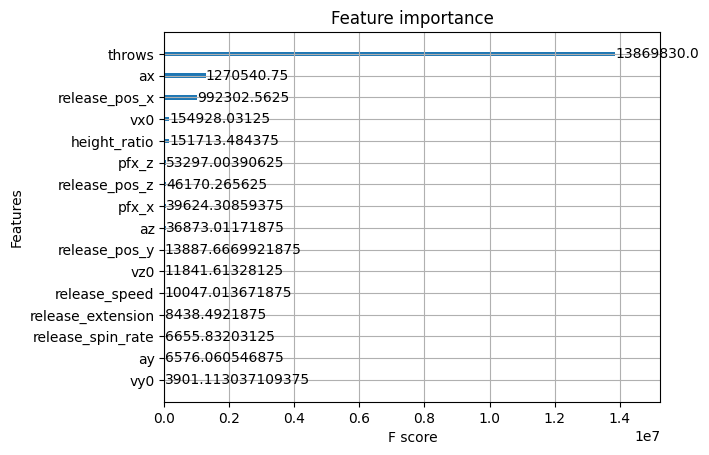

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [ ]:
y_pred = final_model.predict(dtest)

In [ ]:
print(y_pred.min())

100.675934


In [ ]:
difference = angular_difference(y_test, y_pred)

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'height_ratio', 'throws'],
      dtype='object')

In [ ]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [ ]:
testing_identifiers['xspin_axis'] = predictions

In [ ]:
testing_identifiers['diff'] = angular_difference(testing_label, predictions)

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/axis_2022&3_xaxis.csv")